In [1]:
import os
dirs = ['train/Benign_Dumps','train/Malware_Dumps']
ben_dirs = ['train/Benign_Dumps','test/Benign_Dumps','validation/Benign_Dumps']
mal_dirs = ['train/Malware_Dumps','test/Malware_Dumps','validation/Malware_Dumps']

In [2]:
import numpy as np
def shuffle(files):
    rng = np.random.RandomState(100)
    indices = np.arange(len(files))
    rng.shuffle(indices)
    files = [files[i] for i in indices]
    return files

In [16]:
tr_ben_files = shuffle(os.listdir(ben_dirs[0]))
tr_mal_files = shuffle(os.listdir(mal_dirs[0]))
vd_ben_files = shuffle(os.listdir(ben_dirs[2]))
vd_mal_files = shuffle(os.listdir(mal_dirs[2]))
tst_ben_files = shuffle(os.listdir(ben_dirs[1]))
tst_mal_files = shuffle(os.listdir(mal_dirs[1]))
len(tr_ben_files)

350

In [4]:
import shutil
tr_ben = 350
tr_mal = 649
val_ben = 131
val_mal = 100
test_ben = 100
test_mal = 74

index = 0
for d in ben_dirs:
    os.makedirs(d)

while index < tr_ben:
    shutil.copy('RemodeledPaperImage1/Benign_Dumps/'+ben_files[index],ben_dirs[0]+'/'+ben_files[index])
    index += 1
while index < tr_ben + val_ben:
    shutil.copy('RemodeledPaperImage1/Benign_Dumps/'+ben_files[index],ben_dirs[1]+'/'+ben_files[index])
    index += 1
while index < tr_ben + val_ben + test_ben:
    shutil.copy('RemodeledPaperImage1/Benign_Dumps/'+ben_files[index],ben_dirs[2]+'/'+ben_files[index])
    index += 1
    
index = 0
for d in mal_dirs:
    os.makedirs(d)

while index < tr_mal:
    shutil.copy('RemodeledPaperImage1/Malware_Dumps/'+mal_files[index],mal_dirs[0]+'/'+mal_files[index])
    index += 1
while index < tr_mal + val_mal:
    shutil.copy('RemodeledPaperImage1/Malware_Dumps/'+mal_files[index],mal_dirs[1]+'/'+mal_files[index])
    index += 1
while index < tr_mal + val_mal + test_mal:
    shutil.copy('RemodeledPaperImage1/Malware_Dumps/'+mal_files[index],mal_dirs[2]+'/'+mal_files[index])
    index += 1

FileExistsError: [Errno 17] File exists: 'train/Benign_Dumps'

In [5]:
import os
import pickle
import numpy as np

dirs = ['train/Benign_Dumps','train/Malware_Dumps']
object_count_dict = {}


for dir in dirs:
    files = os.listdir(dir)
    for file in files:
        with open(dir+"/"+file, 'rb') as f:
            if file not in object_count_dict:
                object_count_dict[file] = {}
            for line in f.readlines():
                try:
                    var = line.split()
                    obj = var[5]
                    if obj not in object_count_dict[file].keys():
                        object_count_dict[file][obj] = 0
                    object_count_dict[file][obj] += 1
                except IndexError as e:
                    continue

with open('object_count_dict_new_test.pkl','wb') as f:
    pickle.dump(object_count_dict,f)
    #object_dict_count = pickle.load(f)

In [6]:
import os
import pickle
import json
import numpy as np

seq_dict = {}
rev_lookup = {}
def create_from_object_dict():
    i = 0
    for file,objects in object_count_dict.items():
        for obj in objects:
            key = obj.decode("utf-8")
            if key not in seq_dict:
                i+=1
                seq_dict[key] = i
                rev_lookup[i] = key
    f = open('seq_dict.pkl','wb')
    pickle.dump(seq_dict,f)
    f.close()
    f = open('rev_lookup.pkl','wb')
    pickle.dump(rev_lookup,f)
    f.close()

In [7]:
create_from_object_dict()

In [8]:
len(seq_dict)

14720

In [10]:
import os
dirs = ['train/Benign_Dumps','train/Malware_Dumps']
file_dirs = []

for dir in dirs:
    files = os.listdir(dir)
    file_dirs.append({f:True for f in files})

In [11]:
benign_dict = {}
mal_dict = {}
for file in object_count_dict:
    is_benign = file in file_dirs[0]
    is_mal = file in file_dirs[1]
    for tok in object_count_dict[file]:
        token = tok
        if is_benign:
            benign_dict[token] = True
        elif is_mal:
            mal_dict[token] = True
            

In [12]:
both = {}
for token in benign_dict:
    if token in mal_dict:
        both[token] = True
        
for token in both:
    del benign_dict[token]
    del mal_dict[token]

In [17]:
print("Ben: ",len(benign_dict), " Mal: ",len(mal_dict)," Both: ",len(both))

Ben:  6514  Mal:  5862  Both:  2344


In [13]:
print([token.decode("utf-8") for token in both][:10])
print([token.encode("utf-8") for token in seq_dict][:10])

['In-Memory', 'java.lang.String', '[C', 'it', 'java.lang.Class', '[I', 'Object', 'android.os.HandlerThread', 'java.lang.Object', 'java.security.AccessControlContext']
[b'In-Memory', b'java.lang.String', b'[C', b'it', b'java.lang.Class', b'[I', b'Object', b'android.os.HandlerThread', b'java.lang.Object', b'java.security.AccessControlContext']


In [14]:
def get_token_sequence(filepath):
    f = open(filepath,'r')
    lines = f.readlines()
    f.close()
    token_sequence = []
    for line in lines:
        parts = line.split('-')
        if len(parts) >= 2:
            tokens = (parts[1]).split(' ')
            if len(tokens) >=2:
                token = tokens[1]
            if token in seq_dict and token.encode("utf-8") not in both:
#                 print(token)
                token_sequence.append(seq_dict[token])
    return token_sequence

In [15]:
def vectorize_sequence_bitwise(tokenized_sample,dimensions):
    encoded_sample = np.zeros((len(tokenized_sample),dimensions))
#     print(tokenized_sample)
    for i,token in enumerate(tokenized_sample):
        bit_array = [int(c) for c in (str(bin(token))[2:][::-1])]
        for j,val in enumerate(bit_array):
            encoded_sample[i,j] = val
    return encoded_sample
def vectorize_sequence(tokenized_sample,dimensions):
    encoded_sample = np.zeros((len(tokenized_sample),dimensions))
    for i,token in enumerate(tokenized_sample):
        encoded_sample[i,token] = 1
    return encoded_sample

In [15]:
def create_dataset(benign_dir,mal_dir):

    benign_entries = [benign_dir + '/' + file for file in os.listdir(benign_dir)]
    mal_entries = [mal_dir + '/' + file for file in os.listdir(mal_dir)]
    X = []
    Y = []
    DIM = 19
    files = []

    for file_path in benign_entries:
        if not file_path.endswith('.out'):
            continue
        X.append(vectorize_sequence_bitwise(get_token_sequence(file_path),DIM))
        Y.append(0)
        files.append(file_path)

    for file_path in mal_entries:
        if not file_path.endswith('.out'):
            continue
        X.append(vectorize_sequence_bitwise(get_token_sequence(file_path),DIM))
        Y.append(1)
        files.append(file_path)

    def pad_sequences(data,max_len):
        for i,sample in enumerate(data):
            if len(sample) > max_len:
                data[i] = sample[0:max_len]
            else:
                data[i] = np.pad(data[i],((0,max_len-len(sample)),(0,0)),'constant', constant_values=((0, 0),(0,0)))
        return data

    X = pad_sequences(X,10000)

    X = np.array(X,dtype='float')
    Y = np.array(Y,dtype='float')

    return X,Y,files

In [16]:
X_train,Y_train,train_files= create_dataset('/home/ubuntu/ml/train/Benign_Dumps','/home/ubuntu/ml/train/Malware_Dumps')
X_test,Y_test,test_files = create_dataset('/home/ubuntu/ml/test/Benign_Dumps','/home/ubuntu/ml/test/Malware_Dumps')
X_validation,Y_validation,validation_files = create_dataset('/home/ubuntu/ml/validation/Benign_Dumps','/home/ubuntu/ml/validation/Malware_Dumps')

In [17]:
with open('bit_vectorized_dataset.pkl','wb') as f:
    pickle.dump((X_train,Y_train,train_files),f)
    pickle.dump((X_test,Y_test,test_files),f)
    pickle.dump((X_validation,Y_validation,validation_files),f)

In [18]:
X_validation.shape

(231, 10000, 19)

In [19]:
X_train = np.reshape(X_train,((X_train.shape[0],X_train.shape[1]*X_train.shape[2])))
X_test = np.reshape(X_test,((X_test.shape[0],X_test.shape[1]*X_test.shape[2])))
X_validation = np.reshape(X_validation,((X_validation.shape[0],X_validation.shape[1]*X_validation.shape[2])))
print(X_train.shape,X_validation.shape,X_test.shape)

(999, 190000) (231, 190000) (174, 190000)


In [20]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, Y_train)

# print(knn.predict(x_test))
# print(knn.predict(x_train))
print("train shape: " + str(X_train.shape))
print("score on validation: " + str(knn.score(X_validation, Y_validation)))
y_val_predict = knn.predict(X_validation)
print("score on test: " + str(knn.score(X_test, Y_test)))
y_test_predict = knn.predict(X_test)
print("score on train: "+ str(knn.score(X_train, Y_train)))
y_train_predict = knn.predict(X_train)
print("Validation: ")
print("Precision : " + str(precision_score(Y_validation,y_val_predict)))
print("Recall : " + str(recall_score(Y_validation,y_val_predict)))
print("F1: " + str(f1_score(Y_validation,y_val_predict)))

print("Test: ")
print("Precision : " + str(precision_score(Y_test,y_test_predict)))
print("Recall : " + str(recall_score(Y_test,y_test_predict)))
print("F1: " + str(f1_score(Y_test,y_test_predict)))

print("Train: ")
print("Precision : " + str(precision_score(Y_train,y_train_predict)))
print("Recall : " + str(recall_score(Y_train,y_train_predict)))
print("F1: " + str(f1_score(Y_train,y_train_predict)))


train shape: (999, 190000)
score on validation: 0.7012987012987013
score on test: 0.7528735632183908
score on train: 0.9419419419419419
Validation: 
Precision : 0.6
Recall : 0.93
F1: 0.7294117647058824
Test: 
Precision : 0.6371681415929203
Recall : 0.972972972972973
F1: 0.7700534759358288
Train: 
Precision : 0.9227467811158798
Recall : 0.9938366718027735
F1: 0.9569732937685459


In [22]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)
svm.fit(X_train, Y_train)
# print(svm.predict(x_val))
# print(svm.predict(x_train))
print("score on validation: " + str(svm.score(X_validation, Y_validation)))
y_val_predict = svm.predict(X_validation)
print("score on test: " + str(svm.score(X_test, Y_test)))
y_test_predict = svm.predict(X_test)
print("score on train: "+ str(svm.score(X_train, Y_train)))
y_train_predict = svm.predict(X_train)
print("Validation: ")
print("Precision : " + str(precision_score(Y_validation,y_val_predict)))
print("Recall : " + str(recall_score(Y_validation,y_val_predict)))
print("F1: " + str(f1_score(Y_validation,y_val_predict)))

print("Test: ")
print("Precision : " + str(precision_score(Y_test,y_test_predict)))
print("Recall : " + str(recall_score(Y_test,y_test_predict)))
print("F1: " + str(f1_score(Y_test,y_test_predict)))

print("Train: ")
print("Precision : " + str(precision_score(Y_train,y_train_predict)))
print("Recall : " + str(recall_score(Y_train,y_train_predict)))
print("F1: " + str(f1_score(Y_train,y_train_predict)))

score on validation: 0.5454545454545454
score on test: 0.5804597701149425
score on train: 0.8328328328328328
Validation: 
Precision : 0.48743718592964824
Recall : 0.97
F1: 0.6488294314381271
Test: 
Precision : 0.5034013605442177
Recall : 1.0
F1: 0.669683257918552
Train: 
Precision : 0.7953431372549019
Recall : 1.0
F1: 0.8860068259385665


In [23]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
# print(clf.predict(x_test))
# print(clf.predict(x_train))
print("score on validation: " + str(clf.score(X_validation, Y_validation)))
y_val_predict = clf.predict(X_validation)
print("score on test: " + str(clf.score(X_test, Y_test)))
y_test_predict = clf.predict(X_test)
print("score on train: "+ str(clf.score(X_train, Y_train)))
y_train_predict = clf.predict(X_train)
print("Validation: ")
print("Precision : " + str(precision_score(Y_validation,y_val_predict)))
print("Recall : " + str(recall_score(Y_validation,y_val_predict)))
print("F1: " + str(f1_score(Y_validation,y_val_predict)))

print("Test: ")
print("Precision : " + str(precision_score(Y_test,y_test_predict)))
print("Recall : " + str(recall_score(Y_test,y_test_predict)))
print("F1: " + str(f1_score(Y_test,y_test_predict)))

print("Train: ")
print("Precision : " + str(precision_score(Y_train,y_train_predict)))
print("Recall : " + str(recall_score(Y_train,y_train_predict)))
print("F1: " + str(f1_score(Y_train,y_train_predict)))

score on validation: 0.7316017316017316
score on test: 0.7816091954022989
score on train: 0.985985985985986
Validation: 
Precision : 0.6319444444444444
Recall : 0.91
F1: 0.7459016393442623
Test: 
Precision : 0.6730769230769231
Recall : 0.9459459459459459
F1: 0.7865168539325843
Train: 
Precision : 0.9788838612368024
Recall : 1.0
F1: 0.9893292682926829


In [24]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, Y_train)
print("score on validation: " + str(rf.score(X_validation, Y_validation)))
y_val_predict = rf.predict(X_validation)
print("score on test: " + str(rf.score(X_test, Y_test)))
y_test_predict = rf.predict(X_test)
print("score on train: "+ str(rf.score(X_train, Y_train)))
y_train_predict = rf.predict(X_train)
print("Validation: ")
print("Precision : " + str(precision_score(Y_validation,y_val_predict)))
print("Recall : " + str(recall_score(Y_validation,y_val_predict)))
print("F1: " + str(f1_score(Y_validation,y_val_predict)))

print("Test: ")
print("Precision : " + str(precision_score(Y_test,y_test_predict)))
print("Recall : " + str(recall_score(Y_test,y_test_predict)))
print("F1: " + str(f1_score(Y_test,y_test_predict)))

print("Train: ")
print("Precision : " + str(precision_score(Y_train,y_train_predict)))
print("Recall : " + str(recall_score(Y_train,y_train_predict)))
print("F1: " + str(f1_score(Y_train,y_train_predict)))

score on validation: 0.49783549783549785
score on test: 0.5172413793103449
score on train: 0.8088088088088088
Validation: 
Precision : 0.46226415094339623
Recall : 0.98
F1: 0.6282051282051282
Test: 
Precision : 0.46835443037974683
Recall : 1.0
F1: 0.6379310344827586
Train: 
Precision : 0.7726190476190476
Recall : 1.0
F1: 0.8717259905977167


In [25]:
import os
import pickle
import numpy as np

dirs = ['/home/ubuntu/ml/train/Benign_Dumps','/home/ubuntu/ml/train/Malware_Dumps']
object_count_dict = {}


for dir in dirs:
    files = os.listdir(dir)
    for file in files:
        with open(dir+"/"+file, 'rb') as f:
            if file not in object_count_dict:
                object_count_dict[file] = {}
            for line in f.readlines():
                try:
                    var = line.split()
                    obj = var[5]
                    if obj not in object_count_dict[file].keys():
                        object_count_dict[file][obj] = 0
                    object_count_dict[file][obj] += 1
                except IndexError as e:
                    continue

with open('object_count_dict_new_test.pkl','wb') as f:
    pickle.dump(object_count_dict,f)
    #object_dict_count = pickle.load(f)

In [26]:
import pickle
object_dict_count = {}
with open('object_count_dict_new_test.pkl','rb') as f:
    object_dict_count = pickle.load(f)

In [27]:
[f for f in object_dict_count][:10]

['com.groceryking.freeapp.apk.out',
 'com.mobincube.android.sc_4UAHD.apk.out',
 'com.momsoorgychiw.liquidscreenjoke.apk.out',
 'com.mobile.bizo.slowmotion.apk.out',
 'com.jawbone.up.apk.out',
 'com.itunestoppodcastplayer.app.apk.out',
 'com.itdoesnomater77bb.waste.apk.out',
 'com.tul.aviate.apk.out',
 'com.minecraft.full.apk.out',
 'com.racinggames.stunts.racing_bike.stunts.apk.out']

In [28]:
import os
dirs = ['/home/ubuntu/ml/train/Benign_Dumps','/home/ubuntu/ml/train/Malware_Dumps']
object_count_dict = {}

file_dirs = []

for dir in dirs:
    files = os.listdir(dir)
    file_dirs.append({f:True for f in files})

In [29]:
len(file_dirs[0])

350

In [30]:
'com.globalinto.legoninjagoshadow.apk.out' in file_dirs[1]

False

In [31]:
benign_dict = {}
mal_dict = {}
for file in object_dict_count:
    is_benign = file in file_dirs[0]
    is_mal = file in file_dirs[1]
    for tok in object_dict_count[file]:
        token = tok
        if is_benign:
            benign_dict[token] = True
        elif is_mal:
            mal_dict[token] = True
            

In [23]:
len(benign_dict)

6514

In [24]:
len(mal_dict)

5862

In [34]:
both = {}
for token in benign_dict:
    if token in mal_dict:
        both[token] = True
        
for token in both:
    del benign_dict[token]
    del mal_dict[token]

In [35]:
len(both)

2344

In [36]:
 import numpy as np
# import random
# rand_colors = [random.choices(range(256), k=3) for i in range(len(benign_dict)+len(mal_dict)+len(both))]
# def dist3d(source,dest):
#     r1,g1,b1 = source[0],source[1],source[2]
#     r2,g2,b2 = dest[0],dest[1],dest[2]
#     return ((r1-r2)**2+(g1-g2)**2+(b1-b2)**2)
# sorted_colors = sorted(rand_colors, key=lambda color: dist3d(color, [0,0,255]))
# import csv
# with open('sorted_colors.csv','w') as f:
#     colorw = csv.writer(f, delimiter=',')
#     for row in sorted_colors:
#         colorw.writerow(row)

In [37]:
# import csv
# with open('sorted_colors.csv','r') as csvfile:
#     sorted_colors = list(csv.reader(csvfile))

# for i,row in enumerate(sorted_colors):
#     sorted_colors[i] = [int(row[0]),int(row[1]),int(row[2])]
    
# print(len(sorted_colors))

In [18]:
sorted_colors = [[0, 3, 253], [7, 4, 251], [4, 0, 242], [14, 10, 250], [10, 15, 239], [22, 7, 242], [8, 4, 230], [19, 10, 239], [11, 6, 231], [8, 14, 233], [25, 7, 243], [18, 4, 232], [6, 12, 228], [12, 27, 248], [26, 13, 246], [26, 8, 240], [13, 14, 230], [18, 26, 252], [32, 8, 249], [21, 20, 238], [7, 25, 233], [17, 6, 225], [7, 23, 229], [13, 33, 252], [10, 31, 240], [29, 22, 244], [33, 19, 254], [32, 6, 235], [24, 25, 236], [30, 26, 254], [11, 18, 221], [38, 11, 247], [8, 34, 234], [10, 21, 221], [8, 34, 233], [19, 29, 232], [6, 23, 220], [8, 38, 238], [42, 6, 253], [15, 30, 228], [5, 40, 239], [27, 17, 225], [36, 6, 230], [30, 28, 238], [36, 4, 229], [14, 41, 244], [4, 22, 216], [4, 35, 227], [5, 45, 252], [31, 12, 223], [16, 43, 247], [26, 35, 238], [0, 46, 246], [41, 23, 254], [1, 33, 221], [30, 35, 243], [4, 9, 208], [34, 1, 221], [25, 26, 223], [8, 37, 225], [30, 2, 217], [16, 45, 246], [44, 0, 234], [33, 30, 235], [25, 40, 242], [1, 47, 241], [30, 39, 255], [31, 37, 245], [29, 22, 221], [43, 14, 234], [18, 43, 237], [3, 14, 207], [41, 5, 226], [45, 3, 232], [48, 16, 253], [23, 21, 215], [10, 9, 206], [38, 23, 230], [33, 12, 218], [48, 16, 248], [17, 48, 251], [0, 51, 252], [25, 25, 218], [2, 50, 244], [18, 45, 238], [12, 47, 237], [27, 43, 245], [16, 45, 235], [4, 41, 223], [1, 37, 218], [50, 14, 246], [11, 49, 239], [30, 40, 238], [1, 53, 252], [48, 0, 232], [29, 0, 210], [30, 26, 219], [37, 8, 217], [10, 50, 238], [16, 21, 208], [35, 1, 214], [14, 11, 204], [24, 7, 207], [20, 6, 205], [5, 1, 201], [2, 47, 228], [25, 32, 219], [34, 11, 214], [10, 22, 206], [12, 21, 206], [7, 54, 250], [14, 5, 202], [44, 14, 225], [35, 37, 234], [1, 44, 221], [45, 7, 223], [31, 25, 216], [19, 35, 216], [13, 54, 250], [41, 17, 221], [40, 38, 244], [1, 56, 249], [27, 49, 248], [32, 35, 224], [39, 41, 252], [24, 19, 207], [2, 45, 220], [5, 52, 232], [48, 8, 225], [13, 49, 228], [56, 13, 255], [57, 4, 248], [11, 38, 213], [53, 22, 248], [30, 12, 207], [46, 4, 220], [29, 8, 205], [40, 38, 236], [27, 33, 215], [16, 47, 223], [55, 6, 234], [8, 42, 214], [46, 18, 222], [26, 20, 205], [27, 42, 222], [22, 53, 238], [53, 5, 227], [59, 13, 250], [11, 51, 224], [18, 58, 252], [49, 30, 235], [34, 45, 232], [50, 35, 254], [11, 57, 235], [40, 18, 212], [51, 30, 238], [43, 3, 211], [4, 57, 232], [14, 60, 254], [8, 61, 250], [3, 59, 237], [54, 22, 234], [40, 7, 208], [44, 30, 223], [8, 60, 241], [55, 3, 226], [14, 21, 198], [4, 41, 208], [1, 37, 204], [53, 9, 222], [12, 62, 252], [14, 61, 245], [9, 63, 253], [20, 50, 221], [14, 25, 198], [5, 24, 196], [33, 53, 241], [8, 18, 194], [12, 27, 198], [62, 16, 250], [64, 2, 249], [3, 6, 191], [51, 36, 239], [33, 19, 203], [63, 2, 241], [49, 10, 213], [31, 47, 221], [51, 7, 214], [37, 37, 215], [1, 1, 189], [58, 31, 246], [14, 47, 210], [52, 15, 216], [11, 39, 202], [11, 11, 190], [39, 12, 202], [59, 26, 237], [1, 41, 202], [66, 7, 245], [18, 64, 245], [32, 30, 204], [34, 44, 217], [23, 46, 211], [46, 19, 209], [2, 41, 201], [9, 7, 188], [53, 3, 212], [23, 64, 248], [34, 49, 221], [41, 34, 211], [49, 32, 218], [40, 54, 238], [47, 47, 235], [60, 13, 222], [47, 49, 239], [23, 33, 198], [30, 51, 218], [33, 14, 195], [58, 4, 216], [67, 14, 240], [51, 34, 221], [61, 32, 242], [38, 11, 197], [33, 62, 253], [59, 38, 251], [61, 35, 249], [59, 27, 227], [33, 62, 247], [30, 20, 194], [57, 42, 250], [20, 5, 187], [49, 50, 242], [31, 4, 191], [13, 63, 224], [8, 29, 190], [26, 63, 232], [56, 14, 212], [13, 57, 213], [22, 9, 187], [35, 22, 196], [27, 43, 203], [26, 47, 206], [34, 50, 214], [73, 1, 252], [21, 1, 185], [2, 21, 185], [5, 67, 226], [11, 39, 194], [69, 11, 233], [64, 25, 229], [25, 29, 192], [71, 6, 235], [67, 17, 228], [31, 58, 220], [13, 73, 247], [49, 56, 250], [53, 52, 248], [65, 37, 248], [28, 68, 239], [48, 57, 244], [69, 8, 225], [74, 14, 246], [73, 20, 247], [19, 67, 224], [27, 7, 184], [25, 70, 237], [31, 56, 213], [74, 17, 245], [33, 17, 188], [76, 4, 245], [64, 32, 227], [49, 57, 239], [25, 62, 217], [60, 48, 250], [27, 67, 228], [65, 40, 243], [44, 21, 195], [4, 68, 218], [19, 66, 219], [58, 45, 230], [28, 66, 225], [53, 57, 253], [24, 72, 237], [25, 74, 254], [74, 14, 234], [66, 20, 218], [40, 36, 198], [45, 61, 235], [62, 47, 245], [20, 76, 255], [33, 57, 212], [24, 60, 210], [43, 66, 254], [33, 39, 195], [72, 17, 227], [31, 17, 184], [19, 43, 191], [4, 79, 247], [9, 70, 218], [54, 2, 196], [40, 69, 248], [19, 54, 199], [70, 15, 219], [28, 5, 180], [27, 33, 187], [75, 25, 241], [20, 11, 178], [53, 54, 228], [28, 7, 180], [56, 9, 198], [23, 35, 186], [56, 58, 251], [45, 66, 243], [5, 77, 231], [72, 11, 220], [72, 18, 223], [30, 3, 180], [56, 50, 225], [56, 57, 242], [34, 19, 184], [80, 11, 248], [71, 3, 216], [4, 68, 211], [27, 57, 204], [75, 11, 226], [34, 57, 208], [41, 70, 245], [12, 4, 174], [69, 39, 234], [0, 61, 200], [43, 12, 186], [4, 5, 173], [67, 48, 253], [69, 21, 215], [20, 53, 195], [57, 31, 204], [45, 42, 200], [50, 0, 189], [81, 3, 238], [0, 31, 178], [7, 39, 182], [70, 20, 215], [74, 38, 254], [3, 34, 179], [81, 19, 250], [57, 44, 213], [77, 32, 252], [25, 56, 198], [2, 41, 182], [37, 71, 230], [63, 35, 212], [21, 60, 200], [73, 21, 219], [45, 45, 200], [60, 19, 199], [40, 34, 189], [27, 60, 202], [56, 17, 194], [39, 27, 185], [63, 56, 247], [69, 27, 214], [66, 35, 215], [60, 26, 201], [37, 46, 194], [66, 16, 204], [53, 48, 209], [66, 26, 208], [42, 1, 181], [3, 85, 251], [30, 49, 192], [5, 55, 190], [9, 60, 195], [49, 39, 197], [45, 62, 217], [34, 58, 202], [11, 51, 187], [14, 53, 189], [4, 84, 237], [81, 13, 229], [56, 60, 229], [45, 59, 211], [68, 53, 251], [3, 15, 170], [16, 70, 207], [27, 49, 189], [66, 46, 223], [59, 28, 198], [34, 49, 192], [42, 73, 234], [28, 62, 201], [64, 59, 255], [48, 60, 214], [39, 38, 187], [33, 67, 210], [28, 77, 225], [34, 43, 187], [35, 79, 242], [10, 73, 208], [13, 18, 170], [43, 39, 189], [74, 47, 248], [40, 72, 224], [14, 26, 172], [12, 55, 187], [60, 57, 224], [18, 72, 207], [74, 47, 243], [34, 80, 238], [76, 7, 210], [38, 35, 183], [6, 75, 208], [10, 48, 181], [48, 33, 188], [31, 20, 174], [26, 83, 236], [89, 2, 254], [40, 20, 178], [82, 18, 225], [64, 59, 235], [59, 28, 194], [38, 81, 252], [44, 8, 177], [2, 84, 223], [47, 66, 216], [54, 1, 183], [27, 77, 217], [88, 7, 237], [1, 89, 241], [26, 49, 184], [76, 18, 210], [18, 38, 175], [32, 84, 245], [81, 34, 233], [62, 66, 251], [90, 0, 243], [87, 1, 229], [47, 71, 223], [88, 22, 248], [15, 55, 184], [0, 5, 164], [46, 36, 185], [77, 46, 238], [25, 75, 209], [8, 15, 165], [90, 3, 238], [91, 11, 255], [79, 22, 214], [80, 35, 227], [69, 60, 247], [90, 6, 238], [17, 84, 222], [3, 45, 175], [78, 47, 243], [43, 79, 236], [45, 62, 204], [48, 20, 179], [74, 34, 212], [37, 84, 247], [29, 86, 239], [62, 39, 199], [45, 34, 182], [17, 90, 244], [30, 41, 178], [38, 26, 175], [61, 58, 217], [44, 64, 205], [21, 90, 253], [72, 56, 240], [65, 27, 195], [55, 28, 186], [19, 77, 207], [4, 64, 188], [57, 42, 195], [26, 89, 250], [41, 42, 183], [26, 85, 228], [44, 51, 191], [80, 44, 237], [87, 16, 226], [73, 50, 226], [75, 45, 223], [34, 38, 177], [62, 15, 187], [90, 18, 238], [56, 66, 220], [87, 34, 250], [20, 87, 227], [74, 39, 213], [42, 35, 179], [32, 80, 218], [48, 16, 176], [0, 80, 206], [89, 16, 230], [39, 78, 220], [38, 34, 176], [20, 2, 163], [33, 87, 240], [45, 13, 173], [65, 27, 192], [42, 53, 189], [70, 58, 229], [95, 2, 254], [2, 1, 160], [95, 2, 254], [10, 87, 218], [29, 62, 189], [30, 87, 231], [45, 79, 227], [28, 74, 202], [44, 41, 181], [24, 77, 204], [30, 90, 244], [16, 71, 193], [33, 55, 184], [81, 24, 210], [90, 16, 226], [52, 58, 199], [4, 74, 194], [27, 5, 163], [88, 24, 224], [72, 16, 193], [68, 6, 187], [25, 82, 211], [74, 56, 229], [83, 47, 241], [46, 83, 238], [89, 35, 242], [32, 33, 170], [95, 17, 250], [92, 25, 239], [61, 0, 180], [45, 68, 203], [91, 32, 246], [71, 66, 255], [91, 27, 235], [50, 83, 250], [30, 46, 175], [76, 52, 224], [85, 47, 252], [5, 43, 168], [80, 38, 215], [61, 73, 235], [23, 73, 195], [7, 64, 182], [33, 78, 207], [75, 62, 252], [24, 93, 239], [73, 43, 207], [89, 7, 216], [57, 35, 184], [78, 35, 208], [38, 76, 207], [65, 0, 182], [67, 62, 220], [35, 44, 175], [58, 21, 179], [0, 81, 200], [64, 53, 203], [44, 38, 176], [76, 34, 203], [50, 77, 220], [18, 86, 211], [60, 12, 178], [67, 72, 253], [88, 24, 218], [45, 69, 201], [26, 95, 253], [68, 49, 203], [65, 22, 184], [33, 5, 162], [8, 22, 159], [87, 41, 232], [78, 10, 195], [81, 50, 228], [43, 30, 171], [23, 89, 218], [36, 91, 239], [1, 35, 162], [40, 50, 179], [55, 72, 214], [89, 23, 217], [58, 17, 176], [90, 31, 226], [63, 77, 252], [38, 91, 241], [42, 62, 189], [3, 91, 214], [64, 75, 239], [33, 50, 175], [29, 85, 211], [37, 0, 162], [16, 88, 210], [45, 81, 217], [17, 96, 232], [62, 43, 189], [94, 27, 233], [30, 54, 176], [3, 32, 160], [25, 97, 249], [87, 46, 235], [28, 62, 181], [50, 39, 177], [41, 80, 210], [23, 41, 166], [40, 75, 201], [14, 92, 216], [53, 29, 174], [43, 21, 166], [19, 65, 180], [91, 11, 212], [51, 16, 169], [63, 64, 208], [21, 99, 249], [58, 66, 204], [1, 82, 195], [32, 54, 175], [88, 50, 245], [50, 25, 170], [7, 33, 159], [20, 98, 236], [70, 68, 226], [72, 50, 203], [42, 93, 251], [46, 24, 167], [99, 4, 230], [11, 99, 232], [9, 92, 211], [10, 68, 179], [29, 71, 187], [19, 49, 167], [30, 98, 252], [48, 60, 187], [47, 64, 190], [88, 50, 238], [40, 32, 166], [48, 80, 212], [61, 60, 198], [39, 95, 249], [58, 0, 170], [23, 8, 155], [72, 53, 204], [85, 57, 244], [73, 72, 245], [10, 74, 184], [25, 2, 155], [18, 36, 160], [3, 81, 191], [42, 93, 239], [2, 93, 210], [68, 34, 185], [44, 10, 162], [46, 64, 188], [35, 79, 198], [23, 96, 223], [40, 27, 163], [95, 36, 233], [91, 34, 218], [30, 38, 163], [32, 31, 161], [76, 56, 211], [81, 65, 247], [32, 75, 190], [29, 100, 249], [22, 66, 177], [40, 51, 173], [19, 24, 155], [34, 24, 159], [87, 55, 236], [19, 66, 176], [3, 44, 160], [28, 84, 199], [10, 59, 169], [85, 52, 222], [70, 42, 189], [89, 33, 210], [29, 101, 255], [59, 13, 169], [99, 33, 242], [70, 56, 200], [85, 19, 196], [77, 59, 214], [94, 12, 209], [44, 51, 174], [67, 59, 199], [32, 100, 245], [6, 97, 214], [102, 19, 235], [92, 48, 235], [44, 7, 159], [11, 100, 222], [40, 4, 157], [36, 52, 170], [31, 17, 155], [70, 40, 186], [21, 102, 234], [104, 2, 233], [17, 105, 254], [14, 71, 177], [85, 62, 239], [84, 7, 190], [36, 53, 170], [26, 73, 182], [98, 8, 214], [16, 105, 245], [62, 83, 229], [67, 48, 187], [31, 57, 170], [62, 46, 181], [33, 56, 170], [6, 38, 155], [39, 49, 168], [61, 81, 220], [39, 100, 254], [83, 67, 243], [36, 73, 185], [3, 106, 238], [75, 36, 187], [36, 101, 246], [81, 58, 214], [25, 60, 169], [106, 18, 247], [79, 22, 185], [27, 9, 151], [98, 38, 230], [78, 53, 202], [25, 66, 173], [30, 72, 180], [97, 0, 207], [40, 95, 222], [86, 46, 208], [8, 2, 147], [107, 14, 245], [90, 57, 235], [71, 78, 230], [75, 62, 207], [60, 16, 166], [47, 96, 236], [22, 102, 225], [5, 103, 221], [43, 66, 180], [88, 50, 215], [67, 36, 177], [90, 7, 194], [94, 40, 217], [2, 109, 253], [5, 75, 176], [98, 14, 209], [99, 46, 253], [93, 39, 213], [62, 1, 165], [21, 30, 152], [36, 38, 159], [40, 100, 236], [105, 19, 231], [27, 90, 199], [102, 14, 218], [46, 89, 211], [61, 70, 197], [31, 3, 150], [17, 88, 192], [48, 65, 181], [55, 23, 163], [7, 23, 148], [67, 83, 229], [65, 86, 233], [11, 61, 164], [47, 11, 156], [68, 67, 200], [16, 15, 147], [5, 5, 145], [68, 38, 177], [39, 97, 220], [67, 47, 181], [105, 31, 241], [22, 76, 178], [47, 60, 175], [52, 94, 229], [55, 74, 194], [35, 69, 176], [37, 16, 152], [57, 75, 197], [40, 103, 249], [86, 57, 215], [38, 82, 191], [26, 107, 242], [0, 50, 156], [62, 62, 187], [0, 109, 234], [53, 89, 215], [35, 58, 167], [79, 77, 242], [69, 85, 236], [60, 45, 173], [90, 65, 249], [41, 51, 165], [48, 26, 158], [46, 100, 238], [47, 99, 235], [9, 82, 180], [23, 22, 148], [61, 86, 218], [26, 98, 208], [109, 21, 242], [27, 82, 184], [62, 93, 252], [53, 22, 159], [2, 108, 226], [59, 48, 173], [35, 36, 155], [48, 73, 185], [41, 45, 161], [21, 50, 157], [68, 89, 254], [36, 97, 212], [64, 90, 236], [41, 59, 169], [67, 62, 190], [50, 40, 163], [70, 85, 234], [46, 8, 153], [13, 55, 158], [84, 40, 192], [47, 86, 200], [66, 1, 164], [70, 4, 167], [76, 81, 237], [110, 13, 235], [80, 58, 201], [83, 14, 180], [97, 56, 242], [73, 47, 183], [10, 31, 147], [38, 8, 149], [31, 108, 244], [43, 104, 246], [6, 13, 143], [44, 40, 159], [69, 53, 183], [111, 12, 238], [107, 4, 219], [13, 7, 143], [11, 78, 174], [89, 65, 230], [98, 16, 201], [16, 33, 148], [39, 58, 166], [39, 106, 247], [14, 23, 145], [91, 52, 212], [4, 7, 142], [104, 0, 210], [64, 11, 162], [94, 60, 234], [99, 54, 242], [58, 85, 207], [103, 46, 242], [21, 81, 178], [60, 78, 198], [82, 78, 243], [17, 111, 236], [84, 32, 185], [11, 112, 237], [0, 113, 240], [64, 88, 221], [51, 101, 241], [55, 95, 224], [90, 52, 208], [77, 23, 174], [49, 4, 152], [8, 113, 240], [58, 17, 158], [86, 75, 248], [100, 48, 227], [100, 54, 241], [70, 75, 204], [77, 61, 196], [35, 26, 149], [54, 101, 250], [49, 58, 169], [90, 24, 188], [58, 97, 235], [111, 23, 237], [62, 87, 213], [13, 75, 169], [38, 18, 148], [67, 9, 162], [46, 105, 245], [5, 15, 141], [100, 57, 254], [73, 1, 166], [62, 80, 200], [57, 5, 155], [110, 14, 223], [68, 92, 239], [48, 104, 240], [76, 49, 183], [36, 29, 149], [111, 6, 223], [58, 64, 178], [105, 37, 223], [92, 27, 190], [41, 81, 183], [71, 32, 169], [89, 9, 181], [24, 100, 201], [63, 72, 189], [99, 19, 197], [105, 50, 253], [15, 64, 159], [45, 17, 149], [19, 87, 180], [103, 32, 211], [109, 26, 223], [60, 31, 160], [84, 79, 238], [62, 23, 159], [20, 75, 168], [69, 79, 204], [17, 114, 237], [11, 27, 142], [35, 9, 144], [93, 25, 189], [44, 102, 219], [96, 9, 189], [38, 73, 172], [63, 74, 190], [66, 93, 229], [103, 43, 220], [115, 5, 234], [29, 98, 198], [23, 20, 142], [64, 97, 241], [30, 53, 155], [16, 22, 141], [106, 0, 205], [22, 62, 158], [50, 15, 150], [89, 74, 236], [55, 96, 216], [29, 29, 145], [0, 69, 160], [8, 6, 138], [30, 64, 161], [9, 63, 156], [111, 18, 220], [91, 11, 181], [2, 71, 161], [62, 21, 157], [66, 56, 175], [106, 35, 217], [37, 68, 166], [111, 40, 255], [99, 23, 195], [22, 62, 157], [10, 12, 138], [26, 115, 249], [37, 5, 143], [51, 27, 152], [100, 15, 194], [61, 42, 163], [105, 54, 252], [67, 32, 163], [80, 84, 232], [16, 113, 224], [109, 34, 224], [112, 5, 217], [24, 26, 142], [22, 70, 162], [77, 3, 165], [3, 53, 149], [72, 94, 249], [46, 54, 160], [6, 24, 139], [55, 6, 150], [15, 110, 213], [62, 40, 162], [1, 67, 157], [57, 38, 158], [9, 65, 156], [57, 68, 176], [75, 20, 165], [52, 32, 153], [54, 90, 199], [105, 51, 232], [104, 18, 200], [54, 4, 149], [34, 47, 151], [14, 112, 217], [35, 36, 147], [5, 119, 254], [64, 33, 160], [28, 102, 200], [72, 94, 241], [62, 99, 231], [106, 42, 220], [17, 4, 137], [64, 98, 232], [101, 21, 195], [51, 107, 241], [9, 101, 192], [100, 17, 192], [12, 87, 174], [29, 114, 234], [3, 113, 216], [12, 101, 192], [4, 47, 145], [80, 4, 166], [64, 50, 167], [75, 90, 230], [19, 35, 142], [41, 32, 147], [42, 8, 143], [80, 8, 166], [97, 70, 246], [9, 79, 165], [42, 43, 151], [47, 110, 243], [38, 4, 141], [36, 36, 146], [45, 43, 152], [48, 92, 194], [32, 72, 164], [74, 61, 182], [5, 42, 142], [32, 110, 217], [27, 115, 230], [64, 33, 158], [83, 70, 202], [10, 70, 157], [22, 45, 145], [83, 71, 203], [88, 1, 172], [87, 23, 174], [71, 39, 165], [21, 35, 141], [97, 19, 185], [49, 95, 198], [20, 19, 137], [4, 80, 164], [12, 66, 154], [42, 113, 242], [90, 77, 229], [25, 67, 157], [22, 119, 246], [80, 38, 172], [31, 108, 209], [29, 45, 146], [15, 78, 163], [25, 79, 166], [0, 20, 135], [31, 96, 187], [103, 19, 193], [117, 16, 225], [90, 62, 201], [35, 72, 163], [1, 122, 251], [53, 84, 184], [118, 27, 239], [93, 59, 202], [64, 68, 176], [101, 69, 254], [114, 42, 240], [67, 98, 225], [110, 28, 209], [102, 67, 244], [120, 22, 243], [55, 77, 177], [114, 41, 236], [114, 14, 212], [65, 76, 184], [82, 24, 167], [68, 50, 166], [53, 55, 159], [12, 122, 249], [8, 54, 145], [1, 62, 149], [121, 2, 234], [81, 90, 234], [76, 87, 213], [64, 95, 210], [106, 39, 206], [7, 95, 177], [56, 108, 236], [93, 45, 188], [91, 49, 188], [38, 113, 224], [33, 42, 144], [43, 105, 207], [59, 102, 219], [7, 123, 252], [78, 88, 218], [116, 28, 224], [36, 91, 180], [86, 16, 168], [37, 113, 222], [72, 88, 207], [14, 20, 134], [19, 41, 140], [31, 94, 181], [109, 7, 197], [112, 40, 221], [115, 41, 235], [35, 42, 144], [31, 95, 182], [119, 4, 221], [96, 37, 186], [47, 67, 162], [84, 30, 169], [41, 26, 141], [65, 12, 150], [78, 80, 201], [1, 7, 131], [66, 105, 248], [19, 26, 135], [3, 102, 184], [77, 85, 207], [83, 90, 233], [84, 91, 243], [98, 16, 180], [66, 48, 161], [36, 38, 142], [103, 49, 205], [64, 106, 241], [122, 25, 250], [0, 30, 134], [86, 7, 165], [84, 31, 168], [39, 36, 142], [40, 35, 142], [39, 92, 180], [16, 22, 133], [27, 78, 161], [48, 24, 142], [50, 85, 178], [118, 38, 238], [7, 22, 132], [14, 124, 245], [124, 16, 248], [112, 32, 209], [14, 19, 132], [48, 111, 222], [57, 78, 175], [19, 76, 157], [19, 72, 154], [99, 4, 178], [125, 9, 248], [75, 94, 219], [61, 73, 173], [38, 61, 152], [69, 105, 254], [57, 112, 252], [111, 11, 197], [66, 107, 254], [106, 9, 188], [93, 74, 214], [21, 122, 233], [87, 89, 237], [39, 29, 139], [3, 14, 130], [110, 47, 216], [110, 22, 198], [38, 58, 150], [30, 73, 157], [4, 125, 241], [96, 73, 219], [16, 95, 174], [55, 103, 208], [101, 74, 242], [79, 93, 224], [60, 32, 149], [86, 92, 255], [117, 40, 231], [94, 53, 190], [40, 105, 198], [87, 90, 240], [113, 37, 213], [29, 30, 136], [37, 78, 163], [10, 14, 130], [29, 106, 193], [65, 60, 165], [15, 84, 162], [48, 105, 204], [60, 30, 148], [114, 16, 203], [76, 28, 158], [68, 105, 237], [111, 34, 205], [59, 65, 164], [101, 75, 242], [24, 80, 160], [13, 38, 135], [118, 24, 216], [28, 71, 154], [76, 85, 200], [28, 52, 143], [3, 112, 196], [61, 21, 146], [6, 37, 134], [124, 25, 248], [113, 40, 214], [84, 70, 191], [12, 32, 133], [34, 122, 250], [99, 14, 177], [105, 70, 242], [62, 63, 164], [23, 55, 143], [97, 28, 178], [121, 29, 229], [47, 87, 175], [102, 76, 253], [76, 3, 153], [45, 94, 182], [30, 88, 168], [113, 41, 213], [21, 30, 133], [11, 27, 131], [0, 109, 189], [116, 42, 223], [45, 8, 136], [59, 113, 251], [20, 126, 253], [96, 82, 236], [100, 15, 177], [47, 70, 159], [114, 9, 198], [82, 14, 158], [82, 97, 241], [67, 107, 235], [27, 123, 233], [60, 64, 162], [23, 110, 194], [95, 83, 234], [63, 89, 188], [100, 42, 187], [11, 51, 138], [91, 77, 208], [10, 122, 217], [116, 24, 206], [56, 79, 171], [93, 81, 220], [25, 21, 131], [22, 126, 244], [72, 106, 247], [90, 78, 207], [24, 120, 216], [124, 32, 245], [121, 42, 245], [68, 89, 192], [60, 41, 149], [49, 86, 173], [45, 74, 160], [45, 119, 236], [49, 52, 148], [54, 57, 153], [50, 33, 141], [122, 39, 241], [83, 38, 164], [40, 110, 201], [97, 42, 181], [86, 90, 221], [60, 92, 187], [71, 105, 230], [100, 72, 216], [7, 17, 127], [39, 122, 237], [5, 129, 247], [13, 106, 182], [3, 40, 132], [51, 54, 149], [55, 113, 224], [73, 0, 148], [79, 95, 216], [92, 77, 206], [21, 56, 140], [16, 122, 214], [123, 35, 233], [30, 110, 193], [126, 22, 233], [91, 10, 163], [59, 12, 140], [37, 121, 226], [24, 119, 209], [71, 47, 157], [122, 44, 249], [19, 126, 230], [111, 66, 241], [59, 25, 142], [109, 47, 202], [37, 117, 212], [82, 0, 154], [125, 2, 219], [124, 28, 227], [76, 99, 218], [50, 84, 169], [81, 48, 165], [24, 93, 167], [119, 31, 212], [23, 101, 176], [123, 18, 216], [52, 99, 188], [48, 74, 159], [44, 48, 142], [54, 98, 188], [67, 39, 150], [71, 77, 177], [43, 106, 192], [24, 102, 177], [58, 112, 221], [32, 86, 162], [91, 76, 200], [69, 79, 177], [15, 119, 203], [33, 80, 157], [83, 63, 176], [97, 65, 196], [52, 4, 135], [92, 78, 204], [88, 72, 190], [127, 32, 255], [57, 45, 146], [43, 86, 166], [84, 33, 160], [131, 3, 254], [106, 3, 178], [26, 128, 244], [30, 123, 221], [12, 26, 127], [107, 72, 231], [63, 97, 193], [83, 98, 228], [131, 8, 254], [56, 47, 146], [12, 21, 126], [125, 33, 232], [77, 85, 191], [122, 48, 247], [51, 90, 174], [121, 32, 215], [127, 0, 221], [15, 123, 211], [114, 55, 219], [6, 122, 206], [75, 76, 178], [99, 77, 215], [62, 77, 168], [112, 65, 231], [38, 23, 131], [80, 73, 180], [105, 77, 235], [77, 14, 149], [75, 99, 211], [49, 69, 154], [62, 116, 247], [28, 58, 140], [94, 75, 201], [27, 39, 132], [50, 118, 224], [99, 87, 249], [70, 46, 153], [56, 113, 216], [69, 83, 179], [19, 119, 201], [71, 49, 155], [19, 69, 144], [98, 40, 176], [115, 60, 230], [88, 64, 180], [92, 27, 164], [55, 119, 238], [88, 63, 179], [111, 72, 254], [11, 15, 124], [17, 114, 190], [90, 97, 253], [60, 61, 154], [38, 41, 135], [46, 6, 131], [0, 120, 199], [6, 90, 158], [24, 43, 132], [128, 31, 240], [38, 127, 255], [89, 94, 226], [21, 0, 124], [7, 121, 201], [42, 41, 136], [55, 97, 183], [43, 120, 218], [70, 90, 187], [114, 44, 203], [37, 96, 171], [92, 27, 163], [7, 68, 141], [16, 132, 253], [26, 11, 125], [77, 69, 171], [19, 61, 138], [121, 23, 204], [94, 89, 223], [55, 66, 153], [99, 16, 167], [44, 85, 162], [52, 78, 160], [49, 99, 180], [13, 103, 171], [37, 48, 136], [107, 56, 198], [81, 41, 157], [77, 99, 209], [21, 63, 139], [69, 64, 160], [113, 47, 201], [64, 24, 140], [67, 53, 152], [96, 76, 201], [50, 123, 238], [100, 41, 176], [131, 27, 249], [103, 10, 170], [118, 35, 202], [60, 37, 141], [89, 88, 207], [48, 111, 197], [130, 2, 222], [63, 77, 165], [46, 126, 252], [130, 12, 224], [81, 100, 217], [28, 107, 179], [34, 64, 142], [102, 30, 173], [28, 46, 132], [67, 109, 214], [51, 117, 213], [55, 75, 158], [94, 93, 231], [54, 89, 170], [98, 62, 187], [102, 87, 245], [95, 73, 194], [5, 94, 159], [38, 112, 191], [20, 130, 227], [32, 107, 180], [134, 0, 243], [129, 4, 217], [3, 134, 243], [110, 61, 207], [106, 0, 172], [28, 121, 203], [76, 7, 144], [42, 112, 193], [55, 73, 156], [45, 127, 253], [117, 38, 200], [30, 83, 153], [19, 12, 122], [94, 96, 243], [85, 104, 242], [106, 80, 231], [122, 51, 228], [68, 100, 195], [19, 132, 234], [40, 85, 158], [121, 52, 225], [88, 102, 245], [0, 5, 120], [89, 64, 176], [113, 27, 186], [9, 48, 129], [26, 81, 150], [5, 8, 120], [82, 107, 243], [118, 26, 194], [73, 113, 240], [17, 25, 123], [49, 8, 129], [84, 103, 229], [9, 6, 120], [122, 10, 197], [93, 74, 190], [102, 60, 189], [132, 13, 227], [91, 86, 203], [117, 41, 200], [13, 135, 253], [114, 41, 194], [62, 117, 225], [128, 42, 238], [19, 84, 150], [119, 51, 214], [43, 62, 142], [98, 81, 207], [67, 78, 166], [35, 131, 244], [28, 7, 122], [108, 79, 230], [112, 65, 213], [82, 19, 148], [131, 34, 240], [90, 98, 226], [118, 0, 187], [73, 47, 150], [99, 91, 233], [94, 27, 160], [91, 90, 208], [105, 64, 196], [121, 61, 239], [107, 11, 171], [129, 44, 247], [24, 127, 211], [91, 44, 163], [113, 27, 183], [86, 36, 155], [32, 94, 161], [102, 91, 251], [39, 130, 238], [122, 56, 228], [16, 136, 254], [21, 52, 130], [121, 7, 191], [124, 36, 209], [63, 68, 154], [67, 117, 230], [90, 41, 160], [5, 79, 143], [111, 24, 178], [43, 87, 158], [43, 9, 125], [30, 129, 219], [107, 13, 170], [74, 88, 180], [120, 65, 240], [13, 91, 153], [136, 9, 238], [108, 62, 197], [122, 58, 230], [74, 99, 195], [16, 127, 205], [64, 113, 210], [1, 85, 147], [85, 64, 168], [83, 49, 157], [35, 70, 142], [23, 126, 205], [20, 124, 199], [70, 18, 138], [109, 43, 183], [13, 130, 212], [74, 30, 143], [134, 18, 229], [39, 112, 185], [113, 43, 189], [36, 91, 158], [34, 103, 170], [102, 37, 170], [125, 22, 201], [73, 64, 157], [50, 124, 221], [41, 111, 184], [82, 69, 168], [81, 99, 203], [75, 112, 225], [46, 77, 150], [26, 118, 188], [0, 124, 194], [10, 66, 134], [1, 131, 211], [109, 1, 170], [118, 17, 185], [85, 3, 146], [36, 103, 170], [27, 128, 210], [112, 80, 241], [41, 102, 171], [74, 1, 138], [83, 109, 235], [8, 130, 208], [67, 57, 148], [110, 23, 174], [15, 88, 149], [83, 111, 250], [77, 52, 152], [45, 121, 204], [63, 116, 212], [72, 64, 155], [76, 92, 184], [40, 0, 122], [131, 40, 232], [24, 121, 191], [56, 125, 231], [0, 129, 203], [26, 134, 228], [66, 56, 146], [137, 22, 244], [47, 24, 126], [107, 47, 179], [126, 58, 241], [43, 132, 242], [61, 67, 149], [2, 94, 152], [14, 118, 182], [116, 63, 210], [74, 96, 186], [96, 69, 181], [31, 136, 254], [25, 137, 246], [1, 39, 121], [135, 33, 242], [35, 24, 122], [58, 47, 137], [0, 27, 118], [122, 23, 191], [117, 7, 179], [58, 111, 193], [38, 38, 126], [100, 82, 202], [35, 114, 182], [78, 37, 145], [126, 21, 198], [21, 67, 134], [56, 24, 129], [131, 35, 220], [3, 4, 115], [125, 40, 206], [92, 52, 163], [60, 115, 202], [119, 74, 254], [110, 54, 187], [1, 7, 115], [10, 81, 141], [125, 28, 198], [110, 3, 168], [80, 31, 144], [70, 104, 192], [55, 84, 157], [100, 73, 189], [112, 10, 171], [107, 37, 172], [111, 26, 173], [42, 134, 254], [109, 79, 215], [48, 116, 192], [25, 132, 214], [6, 79, 139], [84, 62, 161], [40, 134, 241], [132, 22, 212], [119, 59, 209], [18, 35, 120], [127, 7, 195], [70, 118, 224], [50, 34, 128], [5, 90, 147], [50, 93, 162], [14, 29, 118], [120, 9, 182], [129, 34, 210], [12, 140, 246], [44, 57, 134], [1, 121, 183], [43, 69, 140], [59, 54, 139], [77, 118, 255], [113, 82, 236], [86, 103, 212], [68, 110, 199], [90, 108, 245], [18, 46, 123], [125, 48, 211], [128, 58, 244], [100, 93, 220], [33, 137, 250], [41, 133, 232], [96, 94, 212], [43, 41, 127], [26, 14, 117], [11, 130, 201], [64, 91, 168], [111, 56, 188], [115, 46, 187], [109, 67, 195], [81, 103, 202], [98, 53, 168], [113, 80, 226], [17, 132, 207], [25, 30, 119], [69, 121, 230], [98, 78, 189], [31, 137, 237], [28, 54, 127], [133, 31, 217], [21, 25, 117], [119, 57, 203], [9, 130, 199], [123, 47, 202], [68, 115, 207], [41, 133, 227], [35, 109, 171], [26, 105, 163], [55, 32, 128], [106, 22, 163], [105, 86, 213], [106, 55, 178], [80, 113, 223], [32, 35, 121], [83, 38, 146], [118, 77, 236], [25, 3, 115], [129, 53, 227], [106, 51, 175], [74, 11, 134], [113, 65, 198], [30, 139, 250], [50, 132, 237], [23, 82, 141], [30, 44, 123], [129, 58, 239], [95, 49, 161], [38, 136, 237], [12, 59, 126], [14, 43, 120], [47, 92, 157], [17, 20, 115], [137, 36, 240], [45, 135, 247], [39, 135, 231], [67, 63, 146], [104, 50, 171], [112, 79, 215], [102, 92, 216], [29, 107, 165], [69, 4, 130], [120, 9, 178], [93, 34, 152], [79, 103, 195], [17, 142, 251], [107, 82, 207], [18, 120, 179], [43, 130, 213], [25, 3, 114], [55, 91, 159], [61, 102, 175], [79, 87, 173], [44, 131, 217], [81, 38, 143], [18, 111, 166], [110, 87, 225], [140, 5, 224], [76, 121, 242], [93, 62, 165], [93, 62, 165], [64, 53, 138], [137, 8, 213], [41, 31, 121], [110, 84, 217], [58, 126, 218], [117, 14, 173], [23, 28, 116], [107, 38, 167], [141, 9, 229], [34, 137, 228], [97, 29, 153], [100, 96, 217], [141, 28, 254], [50, 110, 177], [70, 69, 150], [112, 24, 168], [140, 3, 222], [92, 96, 200], [56, 47, 131], [67, 100, 176], [25, 141, 240], [11, 137, 212], [33, 105, 162], [66, 69, 147], [5, 5, 111], [8, 121, 177], [70, 84, 161], [36, 122, 187], [120, 71, 218], [131, 29, 202], [85, 115, 236], [65, 110, 188], [56, 28, 125], [52, 21, 122], [75, 81, 162], [14, 143, 241], [35, 88, 146], [6, 56, 122], [30, 141, 246], [33, 27, 117], [8, 100, 151], [48, 136, 246], [137, 1, 209], [63, 91, 162], [16, 138, 215], [121, 71, 220], [63, 55, 137], [48, 65, 135], [128, 39, 200], [50, 53, 130], [30, 56, 125], [130, 48, 213], [72, 122, 225], [7, 139, 215], [19, 130, 194], [10, 82, 136], [105, 61, 176], [50, 136, 253], [120, 23, 177], [31, 32, 117], [144, 14, 245], [34, 93, 149], [100, 103, 234], [12, 95, 146], [71, 126, 243], [118, 65, 201], [113, 90, 241], [88, 105, 207], [13, 141, 223], [94, 96, 200], [77, 35, 137], [19, 144, 254], [64, 76, 149], [14, 71, 129], [107, 8, 157], [35, 44, 121], [9, 106, 156], [121, 72, 219], [75, 105, 188], [30, 105, 159], [69, 90, 164], [81, 109, 203], [36, 65, 130], [123, 16, 179], [64, 130, 242], [139, 38, 235], [120, 38, 182], [31, 127, 191], [129, 36, 198], [57, 116, 188], [32, 41, 119], [117, 25, 172], [65, 70, 145], [98, 70, 173], [15, 102, 152], [60, 126, 213], [28, 143, 251], [81, 121, 248], [102, 83, 192], [79, 37, 138], [81, 39, 140], [114, 33, 170], [144, 22, 245], [146, 0, 253], [14, 122, 176], [93, 12, 143], [60, 7, 122], [40, 68, 132], [68, 124, 218], [81, 89, 172], [5, 138, 207], [18, 5, 110], [47, 20, 118], [94, 0, 143], [78, 43, 139], [50, 120, 188], [136, 41, 220], [117, 58, 189], [85, 115, 224], [7, 121, 173], [31, 2, 112], [74, 107, 188], [26, 144, 252], [71, 2, 127], [138, 47, 241], [123, 62, 205], [50, 64, 133], [130, 15, 189], [113, 93, 247], [19, 131, 192], [35, 75, 134], [94, 76, 172], [78, 123, 238], [81, 84, 166], [41, 37, 119], [2, 142, 217], [119, 84, 235], [62, 25, 124], [38, 100, 154], [35, 44, 119], [93, 97, 195], [2, 147, 248], [141, 25, 221], [98, 87, 188], [2, 133, 192], [12, 132, 191], [66, 106, 177], [136, 45, 221], [38, 141, 236], [125, 32, 184], [121, 84, 255], [85, 28, 138], [140, 27, 218], [124, 51, 194], [61, 17, 122], [46, 37, 120], [56, 135, 236], [16, 145, 234], [61, 125, 206], [127, 75, 254], [73, 104, 180], [26, 125, 181], [66, 129, 227], [56, 132, 220], [75, 39, 134], [133, 40, 205], [73, 124, 222], [129, 11, 184], [116, 16, 165], [132, 58, 223], [50, 139, 255], [84, 77, 161], [81, 99, 181], [40, 96, 150], [23, 96, 145], [86, 113, 214], [82, 86, 167], [65, 125, 210], [74, 128, 251], [31, 114, 166], [94, 107, 215], [33, 48, 119], [70, 76, 149], [145, 0, 225], [131, 67, 238], [40, 14, 113], [137, 13, 200], [142, 35, 231], [71, 59, 139], [138, 47, 228], [122, 47, 185], [97, 110, 233], [97, 67, 165], [119, 80, 217], [131, 25, 190], [0, 137, 198], [11, 45, 114], [8, 73, 126], [128, 63, 214], [18, 140, 209], [36, 75, 132], [88, 97, 185], [146, 3, 228], [12, 63, 121], [89, 99, 189], [112, 80, 199], [66, 129, 222], [14, 119, 167], [134, 7, 191], [57, 65, 134], [19, 32, 111], [14, 18, 108], [68, 75, 146], [112, 81, 200], [96, 104, 209], [18, 129, 183], [10, 77, 128], [32, 132, 194], [128, 67, 219], [119, 57, 186], [5, 98, 143], [30, 114, 164], [88, 111, 209], [137, 36, 209], [39, 28, 114], [92, 114, 228], [46, 22, 115], [118, 91, 253], [41, 143, 246], [26, 44, 115], [36, 110, 161], [92, 110, 214], [135, 30, 199], [101, 92, 195], [3, 148, 236], [31, 58, 121], [125, 66, 207], [102, 73, 174], [128, 12, 179], [57, 37, 122], [75, 114, 194], [42, 117, 172], [135, 39, 204], [81, 115, 204], [73, 44, 132], [21, 73, 126], [82, 118, 213], [103, 108, 243], [81, 86, 163], [98, 77, 172], [34, 137, 205], [23, 110, 156], [106, 85, 192], [124, 84, 255], [89, 11, 135], [34, 120, 172], [147, 26, 242], [98, 23, 144], [105, 97, 210], [56, 2, 116], [136, 41, 207], [64, 75, 142], [124, 83, 240], [132, 65, 226], [118, 50, 177], [1, 3, 105], [111, 56, 171], [14, 89, 135], [59, 54, 128], [37, 144, 234], [54, 41, 121], [39, 3, 110], [19, 91, 137], [62, 60, 132], [120, 89, 239], [24, 43, 113], [76, 38, 131], [49, 138, 221], [87, 104, 190], [89, 55, 147], [51, 75, 135], [23, 110, 155], [128, 75, 230], [82, 60, 144], [77, 68, 145], [97, 73, 166], [143, 3, 208], [35, 122, 174], [98, 92, 187], [51, 125, 188], [66, 120, 192], [132, 11, 183], [75, 94, 164], [115, 70, 187], [86, 59, 146], [48, 143, 251], [107, 85, 191], [134, 69, 246], [28, 52, 116], [70, 117, 190], [119, 82, 211], [73, 132, 246], [37, 99, 147], [29, 75, 127], [56, 111, 169], [71, 44, 129], [50, 65, 128], [69, 12, 121], [107, 62, 168], [89, 32, 137], [25, 95, 140], [120, 61, 186], [13, 129, 177], [127, 23, 176], [90, 108, 199], [21, 105, 148], [46, 102, 153], [139, 2, 195], [73, 86, 154], [54, 103, 158], [146, 5, 215], [63, 128, 204], [82, 25, 130], [17, 81, 128], [12, 125, 170], [98, 25, 142], [10, 108, 149], [125, 66, 200], [63, 54, 128], [69, 123, 199], [19, 13, 105], [130, 76, 236], [142, 49, 233], [51, 132, 200], [148, 0, 221], [17, 24, 106], [83, 36, 133], [101, 95, 193], [147, 36, 242], [63, 109, 170], [42, 38, 114], [13, 148, 223], [27, 79, 128], [33, 137, 198], [135, 23, 189], [106, 67, 169], [20, 78, 126], [98, 61, 156], [99, 110, 220], [114, 23, 157], [18, 89, 133], [23, 124, 170], [0, 64, 117], [31, 81, 130], [37, 68, 124], [17, 148, 224], [5, 49, 111], [100, 114, 242], [26, 61, 118], [119, 38, 168], [90, 79, 161], [13, 141, 199], [54, 39, 118], [120, 42, 171], [88, 124, 245], [16, 140, 197], [119, 77, 199], [3, 123, 165], [59, 56, 126], [11, 134, 183], [35, 148, 243], [50, 126, 185], [60, 121, 184], [68, 101, 163], [41, 89, 138], [62, 21, 117], [53, 70, 130], [67, 63, 133], [38, 99, 145], [74, 61, 136], [112, 0, 151], [62, 56, 127], [1, 129, 173], [87, 107, 189], [68, 120, 189], [86, 125, 236], [102, 63, 160], [130, 80, 245], [48, 69, 127], [15, 100, 140], [13, 22, 104], [30, 89, 134], [140, 27, 199], [8, 131, 176], [75, 107, 175], [92, 54, 145], [123, 31, 169], [12, 104, 143], [104, 65, 163], [61, 133, 209], [77, 131, 234], [98, 116, 233], [85, 82, 157], [56, 111, 165], [6, 32, 105], [140, 45, 211], [119, 80, 200], [19, 149, 223], [41, 133, 190], [9, 118, 157], [80, 125, 215], [84, 89, 162], [86, 103, 180], [97, 92, 179], [34, 149, 237], [12, 71, 119], [145, 36, 218], [105, 104, 212], [72, 136, 251], [51, 144, 236], [100, 98, 191], [112, 52, 163], [70, 100, 161], [56, 100, 152], [70, 34, 122], [54, 10, 111], [142, 50, 222], [68, 19, 118], [81, 115, 192], [60, 142, 255], [7, 39, 106], [127, 55, 187], [76, 18, 122], [71, 23, 120], [140, 64, 245], [90, 124, 237], [143, 0, 197], [68, 99, 158], [132, 4, 175], [123, 66, 189], [15, 96, 135], [120, 15, 159], [131, 21, 176], [136, 57, 209], [31, 108, 149], [95, 120, 234], [36, 129, 178], [87, 26, 130], [5, 37, 105], [98, 99, 188], [143, 42, 214], [22, 153, 252], [61, 122, 182], [23, 153, 255], [101, 7, 138], [67, 109, 168], [100, 22, 139], [66, 101, 158], [100, 80, 168], [105, 25, 144], [4, 94, 132], [65, 51, 124], [124, 56, 181], [33, 150, 235], [132, 79, 237], [52, 120, 172], [65, 117, 177], [122, 94, 238], [109, 39, 152], [59, 137, 213], [99, 117, 232], [47, 72, 126], [0, 115, 151], [61, 27, 115], [143, 60, 253], [118, 43, 164], [134, 60, 205], [6, 155, 252], [56, 133, 198], [111, 27, 150], [76, 128, 211], [90, 37, 134], [155, 5, 247], [134, 44, 190], [85, 1, 125], [139, 51, 208], [35, 104, 145], [40, 146, 220], [43, 66, 121], [144, 8, 197], [120, 19, 158], [38, 48, 112], [107, 104, 211], [7, 21, 101], [28, 151, 230], [155, 12, 248], [56, 35, 114], [59, 5, 111], [58, 61, 124], [72, 138, 250], [27, 127, 169], [100, 111, 211], [121, 94, 227], [120, 90, 213], [92, 53, 141], [55, 125, 180], [34, 68, 119], [76, 80, 145], [46, 125, 174], [90, 91, 166], [86, 130, 252], [64, 104, 158], [86, 74, 148], [88, 110, 188], [105, 114, 237], [65, 16, 114], [117, 8, 152], [87, 102, 175], [147, 51, 242], [51, 117, 165], [115, 99, 218], [22, 154, 241], [59, 40, 116], [116, 74, 181], [7, 140, 186], [77, 62, 134], [91, 127, 252], [15, 154, 233], [72, 103, 162], [66, 117, 175], [16, 153, 227], [46, 32, 109], [111, 6, 145], [42, 145, 214], [6, 10, 99], [113, 92, 198], [67, 85, 142], [138, 56, 207], [142, 62, 233], [87, 130, 249], [70, 140, 252], [98, 5, 133], [151, 6, 214], [69, 112, 170], [6, 70, 115], [149, 30, 217], [137, 44, 193], [126, 24, 165], [45, 127, 175], [54, 114, 162], [102, 119, 255], [98, 69, 154], [118, 64, 174], [19, 155, 241], [25, 119, 156], [103, 17, 138], [20, 153, 227], [154, 19, 232], [32, 113, 151], [107, 114, 242], [86, 8, 124], [46, 4, 105], [153, 30, 237], [28, 153, 234], [52, 130, 184], [77, 136, 240], [69, 129, 198], [87, 52, 135], [92, 87, 162], [58, 146, 252], [144, 45, 211], [30, 40, 106], [107, 22, 142], [143, 59, 227], [14, 142, 189], [51, 129, 181], [80, 112, 179], [74, 73, 137], [69, 53, 124], [47, 130, 180], [67, 95, 149], [50, 83, 131], [97, 31, 135], [61, 77, 132], [82, 134, 245], [109, 52, 154], [46, 144, 211], [38, 38, 107], [131, 48, 182], [117, 105, 246], [4, 70, 114], [16, 64, 112], [40, 20, 104], [84, 105, 173], [28, 1, 100], [155, 25, 242], [4, 143, 189], [88, 129, 234], [36, 93, 133], [102, 65, 154], [75, 98, 157], [27, 101, 137], [20, 11, 99], [125, 4, 159], [121, 101, 251], [27, 27, 102], [13, 77, 118], [30, 136, 181], [95, 91, 168], [84, 47, 130], [93, 25, 130], [110, 101, 204], [103, 59, 151], [77, 83, 145], [138, 76, 245], [116, 61, 167], [123, 14, 157], [115, 77, 179], [79, 14, 119], [56, 22, 109], [81, 87, 151], [37, 153, 242], [137, 52, 196], [78, 81, 144], [71, 71, 133], [119, 71, 179], [151, 46, 247], [108, 61, 157], [100, 83, 165], [132, 60, 192], [94, 28, 131], [51, 14, 106], [0, 151, 208], [103, 118, 233], [121, 99, 231], [23, 33, 102], [15, 155, 227], [15, 28, 100], [57, 90, 138], [115, 47, 157], [158, 4, 247], [114, 73, 173], [109, 112, 230], [42, 98, 138], [96, 120, 217], [16, 33, 101], [39, 153, 243], [52, 47, 113], [23, 29, 101], [137, 9, 176], [71, 139, 228], [111, 2, 142], [37, 153, 237], [122, 48, 166], [29, 76, 119], [129, 27, 167], [145, 57, 226], [40, 146, 208], [40, 153, 244], [52, 124, 171], [45, 152, 252], [89, 33, 128], [125, 18, 159], [54, 95, 140], [31, 147, 204], [108, 108, 212], [124, 39, 164], [154, 30, 231], [51, 64, 119], [105, 43, 144], [94, 99, 174], [87, 120, 198], [156, 8, 226], [103, 83, 167], [95, 87, 162], [115, 86, 187], [120, 6, 151], [35, 145, 200], [3, 159, 254], [21, 152, 213], [53, 150, 254], [58, 120, 168], [60, 91, 139], [78, 73, 137], [88, 108, 178], [35, 75, 119], [123, 72, 184], [31, 95, 131], [4, 70, 112], [43, 145, 205], [14, 15, 97], [33, 128, 166], [105, 113, 215], [29, 86, 124], [158, 20, 249], [111, 43, 149], [146, 16, 193], [61, 26, 110], [18, 158, 243], [56, 43, 112], [156, 32, 246], [31, 116, 150], [73, 121, 181], [21, 47, 104], [133, 83, 225], [12, 8, 96], [6, 126, 157], [140, 68, 219], [27, 157, 243], [133, 75, 208], [135, 85, 246], [72, 127, 190], [94, 8, 126], [46, 84, 127], [13, 119, 149], [123, 35, 159], [131, 83, 216], [19, 143, 186], [124, 101, 253], [51, 150, 233], [108, 101, 194], [28, 102, 135], [58, 130, 182], [26, 71, 114], [151, 49, 235], [21, 80, 118], [43, 110, 147], [153, 44, 238], [51, 132, 180], [123, 51, 166], [132, 22, 167], [86, 135, 248], [19, 114, 144], [138, 81, 246], [142, 7, 181], [19, 123, 154], [99, 126, 251], [143, 68, 230], [7, 76, 114], [53, 107, 148], [28, 30, 100], [4, 147, 191], [32, 7, 98], [157, 20, 229], [27, 40, 102], [15, 87, 121], [127, 39, 165], [83, 117, 183], [5, 57, 105], [97, 119, 208], [130, 31, 166], [132, 21, 166], [155, 0, 213], [100, 34, 134], [130, 80, 205], [10, 104, 133], [122, 10, 151], [130, 91, 230], [98, 92, 167], [8, 148, 193], [58, 133, 186], [14, 153, 208], [11, 41, 100], [13, 137, 172], [107, 15, 136], [25, 67, 111], [29, 79, 118], [19, 156, 221], [8, 90, 122], [100, 22, 131], [6, 46, 101], [79, 132, 208], [38, 153, 223], [13, 48, 102], [111, 109, 214], [19, 46, 102], [113, 110, 223], [6, 96, 126], [14, 122, 151], [143, 73, 244], [156, 11, 217], [106, 5, 134], [24, 149, 199], [56, 149, 231], [103, 43, 139], [74, 140, 226], [145, 70, 252], [29, 151, 207], [110, 107, 206], [73, 130, 194], [55, 131, 179], [133, 76, 205], [5, 161, 250], [119, 90, 194], [107, 73, 159], [4, 161, 247], [144, 15, 184], [51, 72, 120], [105, 83, 165], [129, 60, 179], [81, 66, 132], [109, 78, 165], [91, 86, 153], [32, 10, 97], [58, 150, 240], [103, 120, 222], [58, 148, 226], [152, 49, 230], [131, 12, 161], [110, 118, 244], [138, 47, 185], [19, 157, 221], [83, 104, 163], [155, 25, 216], [118, 63, 164], [145, 59, 214], [125, 19, 154], [63, 130, 182], [44, 150, 213], [124, 77, 185], [121, 54, 162], [145, 2, 183], [47, 30, 103], [63, 149, 248], [45, 134, 176], [16, 161, 248], [3, 155, 208], [80, 88, 145], [113, 116, 250], [94, 16, 124], [77, 27, 115], [43, 91, 128], [39, 154, 223], [149, 54, 221], [118, 110, 239], [1, 161, 236], [91, 86, 152], [24, 151, 201], [55, 65, 117], [30, 41, 101], [26, 160, 250], [69, 129, 185], [140, 72, 216], [136, 62, 192], [31, 158, 235], [9, 142, 177], [85, 109, 170], [7, 151, 196], [4, 20, 94], [20, 68, 109], [67, 107, 153], [119, 104, 218], [113, 69, 161], [68, 52, 117], [38, 123, 156], [122, 104, 229], [112, 93, 183], [61, 47, 112], [73, 91, 142], [96, 2, 124], [31, 157, 227], [120, 61, 164], [97, 37, 130], [120, 98, 206], [103, 59, 144], [28, 70, 111], [41, 84, 122], [17, 159, 225], [132, 93, 235], [5, 95, 123], [148, 42, 202], [90, 87, 151], [122, 65, 169], [114, 105, 205], [101, 82, 157], [116, 112, 232], [137, 87, 241], [106, 78, 159], [73, 64, 124], [96, 81, 151], [1, 90, 119], [99, 80, 153], [163, 2, 248], [6, 163, 250], [3, 51, 100], [24, 136, 168], [78, 132, 199], [110, 92, 177], [56, 86, 128], [83, 117, 177], [44, 157, 246], [36, 66, 110], [41, 50, 105], [130, 96, 231], [56, 111, 149], [106, 9, 131], [39, 130, 164], [48, 148, 205], [114, 27, 141], [16, 16, 93], [100, 11, 126], [116, 18, 141], [162, 22, 248], [99, 86, 157], [50, 49, 107], [103, 90, 165], [108, 85, 166], [107, 41, 138], [104, 80, 157], [142, 78, 231], [108, 49, 142], [89, 109, 171], [161, 25, 237], [123, 86, 189], [160, 8, 220], [50, 36, 103], [16, 125, 150], [6, 135, 162], [111, 115, 218], [16, 92, 120], [89, 16, 118], [89, 137, 239], [105, 105, 185], [69, 4, 106], [103, 47, 136], [92, 66, 136], [106, 116, 207], [29, 151, 197], [83, 121, 181], [144, 79, 249], [96, 102, 169], [140, 86, 250], [19, 157, 210], [8, 164, 246], [103, 128, 248], [27, 155, 207], [27, 27, 95], [127, 103, 237], [128, 103, 246], [128, 33, 157], [31, 14, 94], [119, 106, 214], [102, 7, 126], [23, 26, 94], [57, 142, 194], [108, 116, 210], [52, 121, 156], [161, 1, 220], [92, 14, 119], [70, 148, 236], [91, 50, 127], [23, 156, 207], [76, 76, 130], [41, 144, 186], [96, 109, 177], [74, 135, 196], [159, 41, 240], [133, 91, 220], [19, 50, 99], [55, 155, 242], [30, 127, 154], [25, 87, 117], [97, 26, 124], [154, 13, 197], [45, 155, 220], [43, 28, 98], [30, 161, 233], [95, 100, 164], [133, 39, 165], [120, 94, 191], [28, 66, 106], [116, 14, 138], [157, 24, 209], [87, 70, 133], [22, 137, 165], [125, 80, 182], [69, 20, 106], [83, 143, 250], [38, 72, 111], [138, 64, 190], [131, 79, 192], [60, 112, 149], [139, 63, 191], [142, 51, 187], [26, 120, 144], [118, 107, 210], [97, 33, 125], [13, 92, 118], [46, 159, 251], [85, 5, 113], [143, 24, 175], [110, 106, 191], [24, 142, 173], [152, 35, 199], [162, 3, 220], [156, 21, 203], [52, 21, 99], [37, 34, 97], [49, 139, 179], [3, 99, 122], [119, 113, 231], [19, 24, 92], [143, 38, 180], [140, 1, 166], [40, 18, 95], [34, 147, 186], [15, 165, 246], [4, 89, 115], [84, 81, 137], [133, 32, 161], [18, 4, 90], [15, 165, 244], [61, 63, 114], [49, 34, 100], [19, 147, 180], [165, 9, 238], [102, 128, 226], [142, 52, 186], [52, 140, 182], [45, 119, 148], [85, 103, 156], [148, 74, 239], [136, 72, 192], [100, 111, 182], [54, 136, 176], [107, 72, 150], [45, 106, 135], [111, 115, 209], [33, 123, 148], [29, 50, 99], [67, 87, 130], [66, 23, 104], [80, 60, 122], [155, 56, 232], [116, 9, 136], [0, 151, 185], [61, 110, 146], [69, 128, 174], [162, 21, 223], [130, 2, 151], [34, 18, 93], [101, 113, 186], [44, 160, 240], [137, 33, 166], [57, 103, 137], [10, 63, 101], [165, 9, 233], [141, 89, 254], [29, 20, 92], [83, 139, 215], [89, 134, 211], [121, 86, 179], [42, 108, 135], [77, 0, 107], [93, 12, 117], [158, 22, 206], [129, 20, 151], [27, 117, 139], [111, 94, 173], [47, 140, 177], [162, 40, 248], [90, 14, 115], [87, 113, 168], [103, 93, 162], [110, 21, 131], [86, 45, 119], [80, 15, 109], [136, 97, 249], [145, 26, 176], [5, 112, 131], [126, 72, 172], [26, 41, 95], [38, 61, 104], [83, 42, 116], [85, 110, 162], [85, 144, 251], [1, 74, 105], [11, 161, 211], [161, 45, 249], [11, 36, 92], [105, 119, 202], [121, 114, 236], [100, 56, 133], [50, 150, 200], [113, 60, 147], [131, 101, 229], [80, 107, 154], [74, 150, 246], [167, 1, 242], [139, 77, 202], [113, 62, 148], [44, 127, 155], [48, 112, 140], [31, 153, 194], [144, 51, 186], [74, 92, 136], [2, 157, 196], [17, 117, 136], [114, 35, 137], [55, 156, 227], [75, 150, 250], [148, 65, 210], [104, 128, 224], [146, 58, 196], [84, 35, 114], [135, 93, 219], [52, 155, 217], [148, 56, 199], [14, 141, 165], [9, 56, 97], [144, 46, 182], [148, 54, 197], [121, 75, 166], [142, 49, 180], [105, 112, 187], [32, 134, 159], [69, 126, 168], [14, 58, 98], [110, 35, 133], [47, 9, 94], [104, 59, 137], [17, 163, 218], [162, 44, 248], [88, 66, 128], [13, 66, 101], [42, 119, 144], [13, 166, 232], [85, 38, 115], [48, 161, 248], [47, 132, 162], [99, 60, 133], [92, 28, 117], [0, 133, 152], [122, 115, 241], [81, 143, 219], [102, 83, 150], [98, 136, 240], [105, 20, 125], [8, 142, 165], [52, 106, 135], [30, 135, 159], [149, 78, 247], [8, 108, 126], [71, 92, 133], [165, 21, 228], [89, 64, 127], [147, 52, 191], [25, 84, 111], [130, 57, 164], [97, 23, 119], [84, 85, 136], [142, 19, 166], [76, 106, 148], [35, 103, 126], [73, 143, 203], [99, 39, 124], [64, 145, 197], [146, 73, 212], [101, 135, 246], [50, 51, 102], [71, 153, 247], [144, 55, 186], [143, 61, 189], [85, 144, 231], [43, 135, 163], [19, 31, 90], [22, 140, 163], [120, 114, 221], [73, 27, 105], [0, 169, 255], [129, 96, 203], [16, 63, 99], [124, 103, 204], [77, 44, 111], [61, 122, 155], [133, 102, 232], [116, 66, 151], [92, 0, 113], [14, 142, 164], [67, 91, 129], [55, 92, 124], [112, 22, 130], [128, 66, 166], [8, 80, 106], [43, 144, 177], [168, 15, 240], [165, 37, 246], [123, 70, 162], [65, 144, 194], [8, 55, 95], [44, 34, 95], [143, 26, 168], [93, 141, 242], [18, 155, 189], [128, 90, 190], [155, 62, 226], [140, 37, 167], [72, 83, 126], [72, 138, 188], [156, 30, 196], [57, 94, 126], [92, 121, 180], [84, 109, 156], [107, 117, 195], [84, 110, 157], [78, 123, 168], [97, 57, 128], [62, 82, 120], [168, 16, 237], [104, 33, 125], [101, 131, 217], [46, 104, 129], [98, 100, 159], [60, 39, 101], [65, 135, 175], [54, 146, 187], [103, 131, 222], [61, 57, 107], [17, 19, 87], [65, 67, 113], [8, 96, 115], [146, 58, 190], [73, 153, 242], [118, 10, 133], [25, 149, 177], [144, 28, 169], [45, 115, 138], [67, 146, 199], [122, 71, 160], [149, 26, 177], [9, 151, 177], [37, 165, 235], [18, 61, 97], [166, 27, 228], [42, 5, 90], [163, 12, 207], [15, 121, 136], [106, 54, 133], [1, 79, 104], [104, 2, 120], [108, 50, 133], [45, 65, 104], [97, 131, 205], [50, 107, 132], [35, 163, 219], [133, 40, 156], [169, 23, 255], [155, 5, 184], [62, 139, 178], [32, 66, 101], [70, 109, 144], [37, 142, 168], [16, 17, 86], [82, 22, 107], [163, 39, 223], [135, 99, 222], [149, 79, 229], [162, 26, 208], [5, 47, 91], [62, 159, 252], [167, 5, 220], [89, 143, 227], [75, 109, 147], [44, 4, 90], [162, 27, 208], [137, 55, 169], [148, 67, 202], [31, 41, 92], [144, 91, 241], [69, 61, 111], [113, 124, 222], [117, 107, 191], [41, 69, 104], [80, 92, 135], [61, 156, 220], [121, 121, 254], [65, 158, 245], [27, 169, 251], [83, 124, 171], [71, 155, 239], [122, 86, 171], [155, 66, 224], [153, 67, 217], [36, 92, 115], [88, 5, 108], [4, 71, 99], [143, 52, 176], [19, 138, 155], [29, 3, 86], [167, 39, 254], [87, 89, 137], [56, 59, 104], [129, 109, 225], [147, 62, 192], [165, 46, 246], [85, 87, 134], [143, 44, 171], [159, 56, 223], [76, 95, 134], [104, 112, 177], [97, 56, 125], [140, 99, 248], [102, 133, 218], [4, 67, 97], [142, 92, 226], [46, 101, 124], [78, 30, 105], [111, 131, 250], [68, 100, 133], [26, 90, 111], [4, 16, 84], [82, 59, 116], [8, 171, 240], [119, 1, 131], [78, 133, 179], [113, 49, 135], [168, 14, 221], [101, 34, 120], [151, 45, 186], [103, 106, 167], [70, 147, 199], [27, 133, 149], [77, 52, 110], [132, 110, 243], [119, 12, 131], [10, 169, 223], [169, 20, 228], [155, 72, 233], [44, 43, 94], [110, 132, 241], [81, 8, 103], [153, 61, 204], [93, 145, 247], [63, 112, 140], [54, 16, 92], [157, 50, 204], [87, 34, 110], [136, 21, 151], [40, 40, 92], [122, 4, 133], [171, 22, 247], [72, 46, 105], [57, 160, 224], [108, 65, 137], [105, 24, 120], [110, 40, 128], [72, 132, 170], [13, 152, 174], [41, 69, 102], [93, 134, 198], [129, 114, 240], [41, 105, 124], [13, 164, 202], [162, 55, 230], [57, 163, 246], [14, 163, 199], [129, 108, 215], [74, 108, 142], [74, 10, 99], [79, 152, 231], [169, 28, 231], [2, 170, 223], [144, 13, 160], [13, 98, 113], [56, 148, 185], [52, 77, 109], [6, 37, 86], [43, 77, 106], [66, 72, 112], [106, 135, 232], [165, 13, 204], [77, 71, 117], [26, 152, 176], [123, 55, 146], [156, 74, 240], [74, 102, 136], [35, 123, 138], [101, 63, 129], [35, 156, 188], [141, 93, 216], [156, 46, 195], [73, 9, 98], [117, 47, 136], [103, 35, 120], [136, 11, 148], [162, 39, 207], [92, 144, 225], [102, 140, 245], [48, 141, 166], [6, 43, 87], [14, 45, 88], [54, 154, 196], [19, 172, 242], [162, 44, 211], [23, 2, 83], [80, 49, 109], [61, 22, 94], [71, 157, 234], [68, 102, 132], [119, 59, 143], [80, 153, 235], [97, 144, 247], [169, 36, 236], [137, 98, 212], [144, 51, 172], [24, 9, 83], [169, 0, 214], [170, 33, 239], [41, 60, 97], [105, 101, 160], [117, 44, 134], [12, 173, 241], [128, 59, 153], [149, 86, 229], [79, 25, 102], [2, 174, 254], [23, 144, 160], [97, 140, 219], [124, 73, 157], [108, 35, 123], [39, 165, 215], [114, 35, 128], [100, 122, 181], [133, 35, 148], [71, 158, 236], [156, 73, 228], [55, 63, 102], [135, 34, 150], [61, 11, 92], [36, 114, 128], [139, 104, 238], [147, 93, 242], [163, 5, 193], [121, 114, 202], [5, 172, 226], [54, 142, 169], [171, 34, 246], [53, 55, 98], [148, 92, 244], [19, 139, 151], [89, 135, 189], [27, 146, 163], [55, 143, 171], [54, 8, 89], [3, 144, 156], [46, 105, 123], [113, 106, 174], [133, 59, 158], [25, 142, 156], [91, 100, 144], [3, 110, 119], [161, 8, 187], [27, 141, 155], [139, 101, 222], [18, 174, 250], [0, 153, 170], [135, 98, 202], [25, 121, 131], [170, 40, 243], [70, 22, 96], [6, 3, 80], [137, 36, 152], [56, 0, 89], [24, 89, 106], [104, 138, 226], [72, 90, 123], [162, 52, 213], [157, 68, 217], [106, 21, 117], [144, 95, 224], [133, 108, 218], [53, 83, 110], [127, 14, 135], [6, 167, 202], [47, 162, 207], [26, 162, 193], [163, 64, 245], [93, 143, 214], [3, 127, 134], [54, 36, 92], [68, 81, 115], [7, 158, 179], [60, 104, 127], [73, 154, 213], [4, 174, 232], [82, 122, 159], [22, 9, 81], [43, 10, 85], [131, 89, 179], [14, 7, 80], [58, 125, 146], [97, 21, 110], [133, 14, 141], [105, 52, 124], [73, 79, 116], [164, 36, 203], [12, 125, 132], [70, 112, 139], [133, 102, 202], [144, 93, 216], [145, 91, 215], [70, 10, 94], [83, 3, 100], [93, 26, 108], [102, 42, 118], [84, 149, 214], [19, 79, 99], [11, 161, 185], [14, 135, 143], [55, 20, 89], [27, 18, 82], [113, 108, 174], [46, 146, 168], [82, 154, 231], [152, 88, 242], [23, 124, 132], [54, 155, 191], [58, 143, 170], [100, 145, 251], [41, 11, 84], [97, 30, 111], [30, 51, 89], [64, 159, 214], [121, 127, 238], [167, 6, 199], [128, 114, 214], [145, 98, 234], [139, 54, 161], [11, 172, 218], [104, 136, 213], [100, 145, 247], [131, 118, 252], [131, 117, 239], [0, 175, 233], [85, 61, 113], [154, 26, 173], [18, 163, 190], [75, 103, 133], [158, 53, 197], [132, 100, 194], [104, 120, 178], [14, 175, 237], [137, 91, 191], [68, 154, 202], [65, 141, 171], [131, 9, 137], [12, 152, 166], [118, 123, 209], [125, 124, 242], [173, 20, 226], [47, 58, 95], [160, 67, 222], [134, 101, 200], [6, 175, 232], [55, 162, 211], [86, 97, 135], [134, 22, 142], [59, 142, 168], [157, 2, 174], [124, 22, 131], [32, 162, 192], [40, 159, 189], [105, 38, 118], [32, 17, 82], [57, 63, 100], [146, 62, 177], [94, 15, 106], [65, 154, 197], [47, 156, 186], [32, 90, 106], [109, 132, 210], [106, 136, 215], [16, 84, 100], [18, 97, 108], [167, 50, 224], [59, 54, 97], [113, 128, 208], [130, 8, 135], [57, 24, 89], [164, 67, 253], [69, 48, 99], [160, 6, 179], [73, 22, 95], [133, 52, 150], [169, 7, 202], [116, 134, 252], [12, 154, 168], [82, 8, 98], [88, 153, 238], [68, 140, 170], [24, 116, 123], [6, 34, 81], [94, 147, 223], [115, 134, 238], [53, 168, 234], [106, 60, 126], [113, 135, 233], [0, 140, 146], [169, 18, 204], [114, 58, 132], [27, 171, 216], [0, 35, 81], [101, 124, 178], [86, 75, 119], [52, 169, 239], [46, 134, 148], [171, 16, 210], [116, 98, 163], [90, 153, 251], [171, 21, 212], [71, 24, 94], [64, 111, 132], [11, 72, 93], [128, 49, 142], [81, 145, 192], [84, 117, 151], [167, 36, 206], [78, 150, 200], [85, 8, 99], [139, 59, 161], [110, 132, 209], [37, 1, 81], [167, 6, 194], [78, 58, 106], [118, 133, 249], [133, 48, 147], [158, 77, 227], [26, 171, 213], [76, 105, 133], [119, 89, 157], [155, 77, 213], [156, 75, 213], [102, 38, 114], [133, 112, 216], [23, 173, 219], [114, 83, 146], [24, 109, 116], [13, 61, 88], [163, 43, 197], [107, 132, 201], [79, 117, 146], [169, 1, 198], [61, 102, 122], [61, 162, 212], [113, 138, 252], [128, 118, 216], [5, 169, 198], [161, 21, 181], [1, 145, 151], [110, 12, 115], [47, 161, 194], [164, 55, 211], [47, 103, 117], [124, 127, 236], [110, 117, 177], [137, 72, 166], [156, 22, 171], [9, 22, 78], [70, 140, 169], [42, 153, 173], [177, 20, 242], [72, 81, 113], [87, 146, 200], [112, 89, 148], [69, 120, 142], [153, 21, 165], [174, 41, 255], [66, 91, 116], [121, 78, 149], [173, 39, 232], [104, 36, 114], [173, 25, 217], [145, 42, 159], [43, 108, 119], [96, 151, 254], [40, 156, 177], [114, 95, 155], [84, 158, 251], [161, 49, 194], [59, 169, 253], [25, 110, 116], [122, 3, 124], [78, 161, 247], [173, 39, 230], [38, 175, 252], [6, 142, 146], [105, 144, 237], [103, 141, 215], [172, 45, 233], [6, 177, 228], [48, 137, 150], [129, 36, 136], [43, 99, 112], [142, 62, 165], [161, 71, 221], [132, 51, 145], [21, 173, 213], [35, 115, 122], [23, 61, 88], [127, 114, 200], [165, 54, 210], [159, 77, 224], [121, 123, 206], [41, 160, 185], [67, 111, 131], [179, 11, 250], [28, 28, 80], [124, 128, 234], [159, 29, 177], [20, 101, 108], [5, 12, 76], [167, 19, 192], [148, 93, 214], [61, 67, 100], [118, 131, 221], [124, 15, 126], [68, 164, 228], [100, 7, 106], [39, 144, 155], [107, 143, 236], [142, 66, 167], [168, 24, 196], [10, 136, 138], [154, 91, 238], [19, 164, 184], [172, 49, 237], [139, 2, 141], [161, 78, 237], [111, 78, 137], [110, 53, 123], [123, 53, 135], [97, 103, 144], [159, 84, 253], [79, 84, 117], [76, 36, 96], [105, 145, 237], [35, 150, 162], [127, 125, 230], [75, 34, 95], [137, 83, 173], [101, 142, 210], [65, 40, 92], [45, 151, 168], [30, 170, 204], [149, 101, 253], [118, 60, 133], [180, 3, 252], [179, 4, 236], [151, 98, 251], [54, 101, 116], [47, 41, 86], [16, 149, 155], [28, 135, 139], [82, 45, 101], [142, 50, 156], [94, 115, 153], [140, 62, 160], [8, 177, 222], [35, 127, 132], [164, 46, 196], [93, 121, 159], [164, 24, 184], [82, 142, 180], [5, 83, 95], [179, 1, 233], [62, 158, 194], [78, 23, 94], [153, 49, 173], [64, 91, 113], [155, 88, 227], [123, 132, 255], [35, 0, 78], [63, 5, 86], [154, 54, 178], [52, 145, 161], [7, 87, 97], [90, 122, 157], [133, 41, 140], [16, 37, 79], [74, 162, 225], [92, 126, 164], [146, 55, 164], [57, 128, 141], [47, 39, 85], [170, 59, 239], [69, 138, 161], [116, 135, 224], [130, 25, 132], [31, 59, 87], [43, 140, 149], [38, 175, 230], [157, 46, 178], [137, 2, 137], [58, 10, 84], [7, 84, 95], [6, 86, 96], [59, 45, 90], [176, 9, 214], [49, 64, 93], [22, 127, 128], [22, 24, 77], [164, 50, 197], [172, 56, 248], [62, 112, 127], [122, 22, 123], [105, 66, 123], [118, 11, 118], [36, 68, 91], [97, 2, 102], [2, 176, 212], [0, 172, 198], [57, 68, 97], [84, 155, 213], [46, 80, 99], [19, 60, 85], [22, 180, 255], [164, 70, 222], [26, 13, 76], [101, 141, 202], [73, 158, 204], [16, 162, 175], [129, 84, 159], [53, 23, 83], [152, 74, 189], [71, 123, 142], [100, 118, 160], [105, 148, 250], [130, 74, 152], [15, 167, 185], [109, 144, 235], [139, 117, 251], [161, 50, 187], [162, 42, 184], [155, 62, 183], [54, 54, 90], [11, 58, 83], [103, 78, 127], [15, 135, 134], [26, 180, 251], [35, 30, 79], [164, 27, 181], [12, 80, 92], [59, 154, 178], [62, 143, 161], [126, 130, 236], [175, 46, 235], [77, 159, 211], [122, 56, 132], [91, 42, 103], [46, 176, 247], [18, 178, 221], [143, 54, 156], [58, 80, 102], [34, 84, 97], [103, 31, 108], [131, 112, 196], [101, 67, 119], [112, 134, 203], [92, 118, 151], [81, 73, 109], [78, 150, 187], [165, 65, 213], [62, 162, 199], [44, 173, 218], [27, 68, 88], [88, 60, 107], [0, 71, 87], [86, 43, 100], [19, 176, 211], [159, 69, 198], [88, 93, 125], [167, 73, 246], [18, 161, 171], [4, 140, 138], [109, 71, 127], [145, 99, 205], [34, 162, 178], [163, 62, 201], [14, 106, 107], [54, 170, 216], [34, 12, 76], [154, 15, 158], [74, 106, 126], [132, 73, 152], [104, 39, 110], [145, 26, 147], [6, 76, 89], [115, 140, 231], [85, 159, 225], [135, 120, 227], [113, 79, 135], [37, 109, 113], [6, 16, 73], [27, 17, 75], [110, 86, 137], [57, 159, 185], [182, 9, 240], [60, 172, 239], [50, 165, 194], [4, 181, 229], [145, 60, 161], [149, 106, 250], [118, 121, 185], [129, 115, 195], [88, 159, 234], [83, 157, 211], [151, 45, 162], [84, 65, 106], [137, 49, 144], [90, 106, 136], [25, 51, 81], [113, 144, 254], [152, 42, 162], [7, 94, 98], [4, 177, 208], [113, 115, 168], [111, 135, 200], [167, 70, 227], [10, 166, 178], [46, 163, 185], [5, 91, 96], [91, 112, 142], [130, 120, 207], [102, 76, 123], [162, 31, 175], [156, 25, 162], [72, 75, 104], [118, 106, 163], [181, 30, 255], [62, 157, 183], [87, 52, 102], [5, 167, 179], [154, 97, 231], [62, 84, 104], [53, 81, 99], [130, 44, 133], [102, 61, 115], [23, 34, 76], [26, 17, 74], [154, 37, 162], [162, 56, 189], [81, 112, 134], [76, 9, 88], [81, 154, 196], [147, 7, 145], [2, 56, 80], [183, 14, 246], [147, 42, 153], [40, 12, 76], [92, 115, 145], [152, 69, 178], [113, 24, 112], [104, 130, 177], [64, 131, 143], [54, 79, 98], [134, 44, 137], [12, 143, 140], [23, 127, 124], [77, 2, 88], [130, 90, 161], [13, 95, 98], [170, 44, 200], [58, 174, 240], [116, 98, 151], [102, 121, 161], [105, 31, 107], [183, 18, 246], [53, 131, 137], [4, 5, 71], [183, 3, 235], [1, 63, 82], [122, 130, 209], [122, 96, 156], [75, 151, 181], [182, 0, 227], [116, 142, 238], [58, 88, 104], [148, 47, 156], [123, 68, 136], [107, 143, 210], [171, 33, 195], [109, 147, 234], [51, 89, 102], [103, 108, 147], [107, 61, 118], [183, 3, 234], [86, 139, 170], [68, 166, 213], [17, 161, 167], [91, 32, 98], [84, 105, 129], [75, 38, 91], [43, 119, 121], [179, 13, 213], [109, 146, 227], [180, 35, 236], [63, 164, 199], [125, 132, 224], [90, 0, 94], [62, 70, 96], [108, 13, 106], [19, 172, 191], [86, 158, 214], [21, 181, 226], [23, 170, 187], [82, 136, 161], [153, 96, 217], [100, 153, 229], [24, 6, 72], [10, 69, 84], [181, 36, 248], [183, 19, 239], [48, 178, 244], [63, 164, 198], [15, 183, 235], [25, 87, 94], [115, 138, 212], [79, 1, 88], [146, 92, 189], [117, 1, 112], [126, 99, 163], [89, 150, 194], [182, 30, 244], [59, 170, 213], [81, 67, 103], [15, 21, 72], [79, 167, 250], [56, 128, 134], [28, 182, 239], [66, 24, 84], [131, 106, 179], [167, 19, 178], [169, 53, 202], [78, 98, 119], [48, 48, 83], [53, 164, 188], [28, 174, 199], [4, 50, 77], [61, 103, 114], [150, 92, 198], [84, 56, 100], [121, 136, 222], [136, 102, 182], [143, 46, 147], [4, 184, 236], [33, 85, 94], [150, 72, 174], [72, 29, 87], [4, 54, 78], [90, 160, 231], [62, 145, 158], [89, 144, 180], [84, 2, 90], [71, 2, 84], [146, 83, 177], [122, 88, 147], [109, 15, 106], [127, 131, 223], [94, 143, 184], [183, 20, 234], [47, 70, 90], [43, 174, 208], [29, 183, 251], [61, 1, 80], [97, 135, 173], [79, 165, 225], [116, 117, 170], [121, 60, 128], [128, 134, 249], [121, 140, 243], [45, 178, 229], [75, 104, 121], [152, 36, 155], [40, 20, 75], [14, 181, 217], [30, 118, 115], [96, 69, 112], [106, 101, 141], [95, 64, 109], [110, 99, 143], [10, 61, 80], [92, 103, 131], [33, 31, 75], [54, 130, 134], [83, 4, 89], [57, 98, 108], [31, 68, 85], [51, 156, 168], [109, 122, 167], [73, 80, 104], [111, 121, 168], [21, 126, 120], [26, 124, 119], [170, 41, 192], [75, 5, 85], [135, 82, 157], [117, 65, 126], [24, 181, 220], [91, 161, 236], [184, 15, 233], [107, 152, 251], [66, 173, 238], [172, 39, 196], [175, 22, 196], [115, 137, 204], [0, 186, 254], [31, 111, 109], [73, 58, 94], [57, 53, 86], [15, 67, 82], [5, 172, 184], [33, 39, 76], [147, 45, 150], [78, 32, 89], [166, 32, 177], [56, 173, 215], [186, 3, 247], [20, 182, 221], [80, 149, 177], [25, 179, 210], [11, 161, 162], [9, 127, 119], [77, 83, 107], [132, 112, 186], [50, 48, 82], [133, 58, 138], [62, 90, 104], [64, 109, 118], [168, 69, 213], [129, 131, 224], [124, 137, 230], [14, 60, 79], [24, 139, 133], [52, 164, 183], [117, 74, 130], [149, 112, 248], [176, 48, 216], [107, 149, 221], [107, 112, 151], [186, 13, 248], [172, 47, 200], [182, 41, 251], [84, 161, 212], [110, 71, 122], [172, 68, 230], [140, 123, 244], [119, 113, 166], [161, 37, 168], [81, 144, 168], [171, 75, 255], [55, 178, 242], [125, 103, 162], [91, 134, 162], [160, 32, 164], [162, 4, 162], [45, 73, 89], [92, 132, 160], [185, 24, 244], [49, 29, 77], [0, 183, 217], [160, 11, 159], [65, 151, 166], [144, 46, 145], [140, 123, 240], [73, 49, 90], [98, 117, 147], [16, 92, 93], [15, 186, 243], [132, 11, 123], [149, 112, 240], [92, 88, 118], [0, 187, 251], [92, 133, 161], [183, 38, 247], [63, 172, 217], [99, 150, 203], [66, 143, 154], [153, 81, 184], [127, 11, 118], [123, 134, 211], [130, 134, 242], [18, 145, 138], [91, 161, 226], [65, 165, 195], [82, 154, 187], [162, 30, 166], [2, 99, 96], [54, 159, 172], [165, 11, 167], [116, 5, 108], [24, 91, 93], [146, 85, 174], [63, 102, 111], [43, 12, 73], [54, 176, 220], [21, 186, 246], [175, 23, 192], [88, 22, 91], [13, 19, 69], [126, 137, 233], [98, 65, 109], [46, 130, 128], [154, 104, 230], [87, 161, 214], [107, 150, 220], [103, 57, 109], [150, 110, 231], [106, 15, 101], [181, 39, 225], [36, 169, 182], [171, 52, 198], [51, 140, 141], [165, 50, 181], [33, 102, 101], [38, 85, 92], [0, 182, 209], [26, 98, 97], [19, 159, 157], [117, 95, 143], [2, 141, 131], [17, 187, 253], [98, 121, 150], [142, 95, 177], [133, 101, 169], [57, 114, 117], [79, 13, 85], [30, 180, 210], [145, 33, 140], [59, 162, 180], [167, 80, 222], [112, 6, 104], [14, 149, 141], [6, 148, 139], [88, 122, 142], [97, 85, 118], [8, 188, 254], [173, 46, 197], [116, 9, 107], [172, 64, 213], [28, 185, 234], [152, 83, 181], [98, 121, 149], [160, 80, 196], [76, 29, 85], [53, 32, 77], [91, 71, 106], [161, 1, 157], [13, 105, 99], [13, 158, 153], [49, 79, 91], [83, 164, 213], [130, 55, 130], [3, 187, 231], [129, 137, 243], [57, 132, 133], [97, 105, 132], [102, 106, 137], [167, 69, 201], [167, 42, 178], [141, 24, 132], [81, 153, 180], [5, 156, 149], [63, 49, 84], [174, 21, 185], [146, 112, 213], [18, 80, 85], [141, 123, 230], [165, 29, 168], [124, 136, 213], [152, 68, 166], [162, 97, 255], [4, 133, 121], [32, 78, 86], [143, 42, 139], [6, 60, 76], [109, 120, 158], [83, 121, 136], [157, 103, 234], [94, 135, 162], [51, 92, 98], [153, 52, 157], [171, 73, 221], [155, 77, 179], [58, 170, 196], [71, 175, 246], [135, 25, 125], [54, 180, 234], [112, 150, 228], [56, 162, 175], [184, 30, 223], [168, 2, 168], [92, 33, 93], [114, 89, 133], [179, 37, 206], [182, 43, 226], [19, 96, 93], [178, 35, 201], [153, 40, 151], [88, 14, 88], [88, 136, 157], [58, 180, 246], [51, 158, 164], [31, 42, 73], [68, 36, 82], [27, 130, 120], [126, 10, 114], [29, 7, 68], [187, 23, 236], [169, 80, 225], [73, 171, 219], [189, 12, 254], [87, 9, 87], [107, 10, 99], [72, 59, 90], [37, 91, 93], [4, 103, 96], [183, 6, 206], [88, 111, 129], [112, 153, 254], [68, 2, 78], [98, 162, 244], [40, 118, 112], [27, 32, 70], [7, 187, 224], [95, 69, 106], [10, 49, 72], [42, 140, 134], [180, 19, 198], [133, 10, 120], [82, 27, 86], [122, 67, 126], [94, 112, 134], [115, 99, 141], [115, 141, 201], [174, 57, 205], [109, 155, 244], [148, 102, 194], [174, 24, 183], [154, 21, 146], [128, 83, 142], [46, 172, 189], [33, 3, 68], [154, 96, 199], [10, 80, 83], [9, 120, 108], [71, 176, 246], [71, 28, 81], [105, 131, 166], [79, 171, 230], [16, 189, 243], [83, 166, 214], [172, 12, 175], [152, 112, 233], [122, 138, 208], [164, 69, 188], [32, 115, 107], [147, 92, 177], [79, 164, 200], [179, 39, 204], [161, 85, 200], [127, 141, 242], [27, 167, 168], [166, 77, 203], [8, 110, 100], [155, 109, 238], [160, 66, 176], [146, 97, 181], [175, 10, 181], [121, 41, 114], [86, 158, 193], [142, 34, 133], [91, 167, 248], [63, 127, 128], [20, 22, 67], [112, 127, 168], [27, 183, 210], [60, 80, 93], [100, 111, 137], [49, 27, 73], [129, 4, 115], [184, 0, 206], [72, 74, 95], [137, 46, 131], [69, 125, 129], [96, 49, 98], [49, 68, 84], [17, 163, 158], [179, 46, 209], [100, 80, 114], [126, 139, 222], [47, 178, 206], [103, 10, 95], [106, 158, 244], [63, 134, 135], [101, 100, 128], [138, 118, 197], [52, 155, 157], [126, 89, 143], [33, 183, 213], [140, 19, 127], [139, 99, 170], [81, 110, 122], [50, 33, 74], [56, 73, 88], [161, 40, 161], [40, 72, 83], [30, 155, 148], [143, 105, 185], [147, 72, 157], [124, 53, 120], [26, 4, 66], [117, 56, 115], [119, 75, 126], [98, 163, 239], [134, 51, 129], [43, 166, 171], [129, 49, 123], [124, 51, 119], [13, 82, 83], [51, 160, 164], [89, 156, 190], [169, 80, 216], [103, 35, 98], [103, 35, 98], [114, 9, 102], [4, 83, 83], [25, 144, 132], [176, 14, 182], [113, 154, 250], [21, 185, 212], [56, 136, 133], [20, 190, 251], [43, 125, 117], [64, 5, 75], [119, 47, 113], [157, 67, 169], [150, 62, 154], [26, 106, 98], [162, 89, 206], [138, 89, 157], [183, 54, 242], [188, 3, 220], [120, 141, 207], [147, 42, 140], [175, 35, 186], [121, 91, 138], [109, 98, 132], [190, 11, 235], [48, 119, 113], [166, 7, 160], [75, 174, 228], [160, 3, 150], [11, 79, 81], [166, 21, 162], [147, 112, 205], [22, 98, 92], [73, 107, 114], [167, 11, 162], [53, 0, 71], [5, 145, 130], [0, 24, 65], [42, 18, 69], [171, 60, 193], [119, 6, 105], [144, 64, 146], [86, 42, 89], [94, 91, 115], [81, 60, 92], [134, 73, 139], [183, 19, 201], [106, 123, 153], [80, 87, 104], [140, 129, 232], [57, 60, 82], [118, 116, 158], [156, 106, 220], [149, 114, 215], [62, 173, 200], [159, 96, 207], [18, 191, 253], [85, 127, 139], [168, 68, 192], [98, 161, 219], [100, 16, 92], [25, 131, 117], [1, 182, 194], [73, 137, 142], [121, 130, 182], [41, 149, 141], [169, 64, 190], [111, 129, 166], [23, 144, 130], [145, 35, 134], [108, 39, 101], [97, 109, 130], [54, 161, 165], [13, 17, 64], [97, 36, 93], [138, 15, 122], [75, 2, 78], [179, 38, 196], [92, 166, 224], [62, 182, 251], [167, 83, 208], [54, 31, 73], [7, 191, 233], [90, 169, 236], [9, 125, 109], [190, 9, 226], [60, 149, 149], [134, 116, 180], [118, 110, 150], [155, 113, 239], [23, 148, 134], [107, 5, 95], [187, 9, 210], [172, 84, 234], [29, 12, 65], [99, 161, 218], [10, 135, 118], [23, 155, 143], [32, 183, 204], [48, 160, 159], [140, 118, 195], [138, 68, 139], [190, 32, 254], [156, 112, 239], [172, 69, 202], [43, 33, 70], [124, 120, 169], [91, 72, 101], [112, 100, 134], [146, 0, 129], [187, 25, 215], [33, 190, 251], [87, 159, 189], [91, 158, 192], [189, 26, 226], [59, 174, 196], [25, 185, 206], [6, 72, 76], [181, 67, 251], [37, 65, 77], [85, 170, 221], [185, 54, 243], [13, 16, 63], [17, 170, 165], [10, 51, 69], [38, 173, 178], [175, 21, 176], [101, 85, 114], [116, 96, 134], [77, 177, 247], [37, 170, 171], [175, 74, 220], [34, 173, 176], [161, 87, 193], [101, 138, 165], [82, 175, 255], [99, 1, 89], [75, 167, 193], [187, 41, 228], [79, 150, 162], [12, 77, 78], [174, 65, 201], [167, 60, 178], [38, 97, 92], [113, 114, 147], [22, 105, 94], [174, 69, 206], [57, 144, 139], [33, 92, 88], [16, 112, 98], [60, 19, 72], [20, 190, 224], [130, 138, 216], [101, 158, 207], [15, 193, 253], [51, 128, 119], [15, 108, 95], [11, 187, 206], [33, 54, 72], [172, 32, 172], [162, 104, 234], [26, 160, 149], [152, 120, 252], [140, 133, 240], [143, 125, 217], [58, 173, 190], [61, 129, 124], [179, 71, 234], [61, 132, 127], [167, 25, 160], [104, 142, 174], [126, 118, 167], [184, 21, 198], [149, 55, 144], [161, 95, 204], [38, 190, 252], [67, 59, 83], [27, 185, 204], [34, 158, 148], [188, 5, 208], [110, 154, 213], [106, 162, 245], [16, 172, 167], [109, 132, 164], [124, 127, 177], [132, 86, 142], [132, 118, 176], [143, 124, 213], [126, 46, 115], [100, 67, 103], [151, 84, 167], [135, 57, 128], [141, 33, 126], [162, 37, 155], [118, 117, 155], [177, 52, 195], [112, 114, 145], [193, 13, 240], [123, 140, 201], [53, 143, 135], [135, 35, 120], [56, 179, 205], [173, 19, 169], [133, 118, 177], [146, 103, 179], [139, 35, 124], [149, 85, 164], [137, 89, 150], [8, 194, 251], [131, 141, 229], [154, 41, 144], [164, 32, 156], [96, 165, 219], [1, 94, 85], [26, 130, 113], [183, 28, 196], [134, 133, 209], [60, 150, 147], [110, 121, 150], [45, 189, 250], [57, 149, 144], [107, 48, 100], [23, 115, 100], [34, 183, 199], [162, 34, 153], [166, 75, 187], [150, 104, 188], [55, 166, 170], [61, 182, 224], [85, 45, 86], [178, 37, 186], [33, 94, 88], [91, 124, 136], [150, 122, 234], [173, 56, 186], [17, 176, 174], [116, 73, 117], [121, 125, 168], [82, 99, 109], [33, 140, 124], [31, 5, 63], [79, 17, 78], [57, 186, 250], [60, 28, 72], [5, 194, 240], [64, 46, 77], [76, 155, 165], [64, 102, 102], [55, 186, 238], [32, 6, 63], [1, 17, 61], [170, 95, 253], [51, 19, 68], [120, 122, 162], [123, 4, 104], [152, 114, 212], [113, 155, 221], [43, 175, 181], [120, 12, 102], [29, 181, 189], [55, 103, 99], [173, 11, 166], [2, 169, 158], [109, 42, 99], [155, 31, 141], [146, 36, 131], [17, 192, 226], [22, 186, 201], [115, 124, 158], [39, 20, 65], [10, 111, 95], [82, 176, 237], [99, 1, 87], [33, 115, 101], [128, 76, 129], [26, 92, 85], [11, 26, 62], [87, 149, 164], [192, 10, 222], [173, 50, 180], [66, 168, 181], [159, 3, 142], [124, 22, 106], [152, 18, 134], [165, 69, 177], [143, 102, 170], [16, 159, 143], [154, 40, 142], [40, 187, 216], [111, 116, 144], [176, 68, 205], [180, 72, 232], [190, 42, 239], [109, 162, 253], [21, 193, 234], [8, 62, 70], [69, 176, 206], [187, 55, 243], [77, 13, 76], [139, 136, 237], [166, 99, 227], [195, 11, 253], [148, 25, 130], [86, 121, 128], [31, 58, 71], [162, 54, 160], [6, 193, 225], [69, 158, 163], [119, 129, 169], [43, 16, 65], [43, 181, 195], [84, 23, 80], [41, 161, 152], [194, 17, 238], [95, 134, 149], [10, 49, 66], [30, 156, 141], [98, 92, 113], [189, 24, 211], [4, 14, 60], [80, 77, 94], [143, 126, 211], [112, 136, 170], [77, 159, 171], [187, 56, 242], [48, 184, 209], [188, 47, 228], [151, 88, 167], [60, 159, 158], [161, 111, 248], [20, 194, 239], [130, 132, 192], [126, 41, 111], [151, 114, 205], [85, 160, 181], [134, 32, 116], [122, 64, 116], [65, 135, 129], [41, 162, 153], [22, 173, 166], [174, 62, 190], [24, 148, 129], [59, 98, 96], [98, 137, 155], [86, 153, 168], [22, 194, 239], [161, 87, 185], [78, 133, 134], [29, 61, 71], [91, 104, 116], [28, 144, 125], [94, 2, 83], [44, 173, 174], [92, 99, 113], [64, 169, 179], [120, 153, 230], [88, 56, 89], [88, 104, 114], [170, 92, 222], [94, 108, 121], [76, 17, 75], [177, 84, 246], [96, 105, 120], [59, 187, 250], [58, 85, 88], [168, 76, 188], [189, 13, 204], [163, 102, 216], [40, 7, 63], [48, 103, 95], [182, 36, 191], [91, 96, 110], [58, 154, 148], [11, 178, 173], [21, 73, 74], [5, 159, 140], [29, 193, 234], [156, 119, 249], [120, 149, 211], [162, 62, 163], [48, 121, 108], [6, 189, 202], [141, 14, 119], [111, 44, 99], [147, 70, 145], [3, 50, 65], [176, 71, 204], [38, 91, 85], [190, 15, 207], [116, 99, 131], [173, 88, 224], [75, 139, 138], [179, 64, 205], [165, 62, 168], [4, 127, 105], [30, 192, 225], [192, 31, 226], [125, 45, 110], [46, 189, 226], [7, 139, 116], [21, 195, 240], [70, 113, 110], [139, 111, 171], [30, 136, 116], [102, 168, 245], [104, 145, 172], [76, 171, 194], [68, 94, 96], [179, 25, 177], [12, 127, 105], [45, 76, 79], [2, 190, 203], [24, 93, 83], [50, 108, 98], [111, 74, 110], [109, 112, 135], [89, 141, 150], [55, 171, 174], [3, 197, 251], [96, 49, 90], [26, 12, 60], [70, 184, 245], [107, 29, 92], [61, 14, 68], [140, 120, 185], [67, 184, 231], [5, 87, 78], [99, 159, 193], [53, 61, 75], [117, 65, 110], [30, 195, 251], [177, 83, 228], [92, 107, 117], [164, 92, 195], [144, 135, 254], [139, 34, 119], [149, 34, 130], [110, 153, 196], [139, 93, 150], [156, 81, 165], [151, 91, 166], [80, 58, 84], [86, 41, 82], [47, 129, 113], [105, 157, 197], [174, 86, 218], [1, 99, 84], [31, 101, 88], [80, 78, 92], [123, 118, 155], [53, 184, 206], [88, 119, 124], [4, 77, 73], [177, 88, 254], [72, 6, 71], [86, 80, 96], [115, 156, 216], [24, 147, 125], [18, 101, 86], [58, 182, 204], [73, 140, 136], [37, 80, 78], [13, 143, 119], [139, 109, 166], [15, 196, 233], [194, 8, 217], [50, 187, 214], [188, 56, 229], [149, 8, 125], [105, 124, 142], [128, 150, 238], [68, 185, 237], [61, 174, 183], [41, 120, 103], [76, 121, 118], [93, 68, 94], [132, 64, 122], [192, 45, 237], [43, 187, 206], [194, 19, 220], [44, 102, 91], [84, 166, 187], [168, 14, 151], [162, 95, 192], [30, 162, 145], [112, 130, 156], [49, 61, 73], [188, 48, 215], [0, 168, 150], [68, 127, 119], [156, 35, 138], [176, 2, 164], [31, 51, 66], [175, 93, 251], [110, 59, 101], [161, 44, 148], [5, 157, 134], [107, 158, 201], [52, 191, 243], [160, 94, 185], [173, 97, 254], [184, 39, 192], [172, 88, 210], [152, 85, 160], [70, 151, 147], [181, 55, 195], [187, 46, 207], [31, 109, 92], [80, 153, 157], [181, 16, 175], [47, 79, 79], [3, 183, 178], [29, 114, 95], [82, 168, 188], [76, 76, 88], [11, 195, 219], [158, 32, 139], [112, 26, 93], [72, 165, 171], [156, 57, 146], [102, 29, 87], [150, 124, 215], [127, 38, 107], [135, 117, 168], [138, 0, 112], [77, 125, 121], [134, 86, 136], [104, 136, 154], [187, 57, 219], [169, 48, 162], [28, 156, 135], [194, 38, 234], [18, 196, 227], [105, 67, 100], [133, 138, 202], [138, 8, 112], [110, 158, 205], [106, 11, 87], [40, 152, 133], [170, 77, 186], [182, 63, 205], [5, 188, 190], [173, 72, 188], [162, 58, 155], [24, 132, 108], [197, 22, 237], [25, 24, 59], [0, 56, 64], [3, 180, 170], [6, 199, 255], [176, 59, 183], [8, 148, 122], [132, 147, 230], [197, 15, 230], [6, 132, 106], [5, 6, 56], [184, 14, 180], [24, 112, 92], [65, 155, 148], [195, 9, 215], [69, 156, 152], [32, 191, 208], [39, 185, 192], [168, 102, 222], [186, 69, 236], [167, 88, 191], [2, 99, 82], [130, 39, 109], [33, 194, 223], [64, 175, 184], [39, 161, 144], [117, 146, 186], [50, 162, 150], [132, 148, 234], [100, 121, 132], [119, 157, 224], [76, 76, 87], [190, 9, 195], [9, 185, 181], [127, 34, 105], [164, 24, 144], [105, 88, 110], [57, 8, 64], [98, 113, 123], [165, 72, 169], [127, 72, 119], [148, 83, 150], [199, 0, 240], [188, 32, 196], [148, 134, 253], [154, 108, 188], [115, 163, 246], [154, 120, 213], [124, 72, 116], [82, 142, 141], [17, 0, 56], [58, 48, 70], [48, 58, 70], [143, 137, 229], [153, 43, 134], [116, 132, 160], [31, 81, 75], [107, 69, 101], [108, 45, 93], [9, 134, 107], [169, 54, 163], [161, 77, 165], [79, 15, 72], [15, 191, 198], [114, 41, 96], [19, 0, 56], [191, 59, 254], [125, 156, 253], [91, 56, 86], [87, 72, 90], [33, 108, 90], [76, 181, 217], [150, 122, 204], [194, 48, 248], [60, 175, 179], [156, 28, 133], [38, 169, 155], [48, 92, 84], [20, 161, 138], [145, 58, 130], [73, 97, 96], [187, 69, 238], [82, 157, 162], [40, 125, 104], [46, 105, 91], [59, 189, 226], [177, 68, 191], [55, 80, 80], [177, 74, 198], [76, 120, 114], [25, 129, 104], [89, 169, 195], [57, 91, 86], [91, 90, 101], [47, 81, 78], [196, 41, 252], [176, 79, 201], [117, 95, 123], [69, 135, 124], [164, 22, 142], [44, 46, 65], [72, 182, 212], [133, 45, 112], [60, 100, 92], [88, 50, 82], [94, 19, 79], [93, 160, 178], [163, 29, 142], [124, 154, 222], [5, 122, 96], [11, 190, 192], [53, 191, 225], [187, 55, 208], [8, 127, 100], [45, 60, 69], [41, 85, 78], [57, 135, 118], [68, 122, 111], [128, 154, 243], [17, 125, 99], [76, 70, 83], [59, 141, 125], [115, 124, 147], [148, 12, 120], [179, 86, 226], [112, 82, 110], [129, 132, 176], [159, 81, 163], [156, 33, 133], [97, 105, 114], [137, 60, 121], [22, 193, 204], [72, 137, 127], [47, 188, 202], [154, 42, 133], [140, 53, 121], [92, 15, 77], [185, 23, 180], [5, 177, 160], [13, 132, 104], [28, 161, 138], [2, 172, 151], [0, 2, 54], [178, 34, 168], [152, 95, 164], [69, 135, 123], [148, 136, 249], [36, 96, 82], [54, 17, 62], [176, 32, 163], [44, 76, 74], [59, 136, 119], [63, 189, 227], [124, 51, 105], [172, 36, 157], [3, 151, 122], [135, 9, 106], [27, 186, 183], [14, 65, 65], [50, 110, 94], [57, 187, 207], [157, 3, 129], [30, 35, 59], [120, 135, 166], [97, 168, 201], [50, 5, 60], [153, 127, 223], [8, 30, 56], [62, 25, 65], [118, 146, 182], [28, 77, 71], [86, 57, 82], [138, 37, 113], [4, 108, 85], [49, 158, 140], [184, 60, 199], [41, 167, 150], [112, 156, 194], [132, 152, 246], [34, 156, 132], [7, 198, 218], [106, 150, 172], [150, 134, 242], [126, 155, 228], [47, 101, 87], [0, 146, 116], [76, 129, 120], [61, 52, 70], [36, 149, 124], [79, 124, 117], [126, 146, 196], [175, 100, 248], [116, 73, 107], [94, 83, 97], [27, 179, 166], [184, 57, 195], [121, 145, 184], [196, 42, 232], [54, 71, 74], [199, 21, 229], [66, 188, 223], [23, 14, 55], [171, 104, 229], [53, 194, 238], [0, 177, 158], [84, 121, 117], [156, 122, 216], [46, 168, 153], [200, 10, 229], [150, 126, 206], [126, 16, 98], [176, 54, 172], [36, 152, 127], [125, 62, 109], [107, 153, 178], [35, 198, 236], [149, 87, 150], [89, 158, 166], [154, 127, 224], [196, 31, 217], [64, 133, 117], [182, 12, 168], [175, 48, 166], [137, 101, 146], [100, 174, 231], [151, 96, 161], [122, 7, 94], [10, 151, 121], [69, 159, 151], [131, 74, 120], [18, 103, 82], [136, 130, 181], [145, 125, 190], [180, 14, 164], [124, 15, 96], [0, 114, 88], [194, 35, 210], [26, 151, 123], [83, 103, 102], [6, 167, 141], [115, 156, 197], [22, 74, 68], [178, 92, 227], [18, 144, 114], [170, 35, 151], [94, 119, 121], [50, 182, 182], [104, 164, 198], [10, 92, 75], [52, 188, 201], [153, 87, 155], [147, 107, 166], [55, 114, 97], [192, 61, 235], [28, 61, 64], [63, 99, 90], [86, 135, 131], [162, 100, 186], [90, 109, 110], [49, 95, 83], [129, 138, 182], [201, 19, 239], [104, 171, 224], [119, 17, 92], [150, 5, 119], [194, 5, 197], [183, 22, 171], [202, 3, 240], [102, 19, 81], [84, 181, 220], [151, 4, 120], [61, 173, 169], [177, 79, 196], [142, 143, 234], [55, 28, 62], [96, 51, 84], [193, 55, 227], [108, 161, 196], [108, 90, 109], [144, 127, 190], [15, 8, 53], [153, 122, 202], [122, 150, 194], [196, 14, 205], [67, 65, 75], [156, 125, 221], [193, 62, 250], [176, 12, 155], [104, 169, 213], [145, 59, 126], [10, 93, 75], [196, 6, 203], [200, 1, 221], [180, 37, 169], [39, 102, 84], [124, 97, 127], [60, 187, 204], [11, 78, 68], [174, 62, 171], [109, 20, 85], [143, 143, 238], [85, 184, 244], [77, 153, 146], [147, 59, 128], [41, 146, 120], [15, 202, 241], [102, 51, 87], [10, 198, 211], [170, 108, 229], [93, 166, 184], [168, 109, 221], [45, 114, 93], [20, 8, 53], [64, 187, 208], [147, 129, 200], [25, 147, 117], [160, 119, 216], [109, 169, 226], [20, 41, 57], [94, 70, 89], [48, 196, 231], [95, 36, 79], [36, 20, 56], [148, 136, 225], [76, 161, 157], [6, 57, 60], [36, 200, 251], [133, 130, 173], [96, 101, 107], [149, 19, 118], [79, 143, 134], [5, 10, 52], [71, 14, 65], [171, 0, 145], [187, 68, 213], [64, 160, 147], [35, 170, 149], [0, 107, 82], [151, 134, 230], [134, 46, 109], [172, 19, 148], [104, 55, 89], [125, 156, 217], [122, 94, 122], [53, 74, 73], [147, 100, 156], [119, 135, 160], [191, 69, 242], [5, 58, 60], [156, 21, 126], [114, 101, 120], [31, 79, 70], [33, 164, 139], [201, 4, 223], [184, 85, 236], [188, 4, 177], [126, 159, 238], [24, 169, 144], [67, 157, 144], [85, 121, 115], [132, 43, 106], [190, 73, 247], [154, 124, 206], [180, 47, 172], [198, 44, 236], [133, 104, 141], [82, 85, 89], [161, 81, 160], [142, 18, 110], [127, 155, 218], [48, 198, 251], [100, 173, 215], [44, 187, 187], [198, 37, 224], [133, 21, 102], [133, 75, 120], [69, 38, 67], [85, 10, 70], [137, 80, 127], [174, 105, 239], [158, 87, 160], [50, 88, 78], [12, 112, 85], [48, 53, 64], [74, 5, 65], [53, 44, 63], [157, 63, 141], [56, 8, 59], [89, 36, 75], [113, 25, 87], [70, 178, 184], [36, 181, 168], [96, 177, 222], [95, 153, 159], [8, 90, 72], [200, 19, 219], [79, 120, 110], [28, 103, 81], [72, 147, 133], [43, 188, 188], [116, 168, 253], [34, 201, 243], [31, 44, 58], [194, 37, 203], [105, 8, 80], [74, 181, 196], [31, 199, 221], [108, 134, 145], [86, 185, 245], [78, 180, 198], [164, 112, 207], [36, 156, 128], [171, 102, 209], [131, 149, 206], [165, 120, 243], [63, 71, 74], [110, 135, 148], [194, 63, 242], [4, 147, 113], [70, 164, 155], [83, 138, 129], [44, 43, 60], [137, 149, 226], [11, 123, 92], [171, 112, 249], [127, 27, 97], [27, 169, 143], [0, 179, 156], [185, 86, 240], [35, 195, 204], [116, 29, 89], [36, 108, 85], [162, 1, 130], [69, 192, 239], [187, 5, 172], [164, 83, 165], [101, 178, 255], [156, 54, 134], [109, 123, 133], [137, 150, 230], [151, 137, 237], [123, 83, 114], [91, 142, 139], [12, 144, 110], [97, 180, 245], [31, 105, 82], [183, 53, 180], [178, 99, 234], [83, 21, 69], [77, 156, 147], [41, 100, 81], [118, 161, 209], [10, 106, 80], [60, 99, 86], [90, 171, 187], [156, 119, 196], [199, 14, 208], [165, 86, 169], [38, 37, 57], [26, 189, 180], [68, 189, 214], [112, 44, 89], [116, 78, 105], [134, 138, 184], [56, 167, 150], [148, 57, 125], [194, 66, 247], [118, 144, 169], [9, 19, 51], [138, 83, 128], [8, 199, 206], [4, 6, 50], [44, 200, 243], [136, 148, 214], [9, 201, 215], [90, 181, 220], [16, 55, 58], [77, 79, 82], [180, 74, 190], [171, 93, 190], [125, 24, 94], [146, 125, 183], [170, 1, 140], [67, 118, 101], [189, 72, 220], [119, 93, 116], [128, 28, 97], [173, 98, 204], [18, 204, 241], [203, 12, 227], [148, 53, 123], [119, 104, 124], [69, 122, 105], [40, 199, 224], [63, 63, 70], [156, 128, 217], [43, 120, 94], [109, 173, 236], [29, 23, 53], [153, 83, 146], [186, 72, 206], [0, 159, 125], [86, 181, 210], [78, 152, 141], [169, 72, 163], [94, 90, 96], [4, 154, 119], [30, 169, 142], [154, 136, 249], [102, 77, 94], [55, 152, 128], [195, 5, 190], [89, 127, 120], [24, 133, 100], [105, 171, 210], [134, 156, 255], [193, 38, 195], [173, 93, 194], [80, 185, 214], [144, 58, 120], [195, 65, 245], [184, 90, 235], [100, 179, 237], [15, 182, 160], [197, 18, 198], [120, 155, 192], [29, 201, 221], [69, 3, 61], [84, 188, 252], [101, 40, 80], [132, 19, 98], [155, 45, 127], [183, 26, 164], [73, 144, 127], [0, 204, 226], [129, 125, 154], [74, 186, 206], [155, 99, 162], [133, 142, 187], [104, 143, 149], [61, 124, 102], [204, 15, 229], [197, 56, 231], [125, 1, 91], [121, 101, 122], [62, 191, 208], [103, 71, 91], [205, 7, 233], [38, 83, 70], [190, 8, 175], [35, 158, 127], [184, 91, 234], [81, 176, 184], [141, 87, 132], [154, 38, 123], [181, 51, 170], [184, 53, 178], [80, 187, 220], [39, 97, 77], [11, 190, 175], [102, 103, 108], [174, 30, 148], [115, 166, 212], [107, 142, 150], [185, 26, 167], [36, 203, 243], [2, 68, 60], [82, 187, 224], [49, 157, 130], [70, 190, 214], [195, 68, 249], [108, 56, 88], [33, 184, 167], [164, 72, 152], [194, 64, 224], [15, 6, 49], [203, 38, 248], [91, 14, 70], [12, 161, 126], [57, 190, 197], [76, 154, 140], [44, 200, 227], [200, 18, 206], [134, 103, 136], [197, 59, 234], [74, 160, 147], [95, 120, 116], [79, 189, 227], [148, 143, 235], [72, 191, 222], [160, 129, 232], [115, 118, 130], [69, 86, 80], [79, 8, 64], [112, 150, 167], [102, 175, 213], [103, 179, 243], [12, 197, 193], [6, 131, 95], [167, 64, 151], [140, 147, 215], [165, 106, 189], [183, 78, 198], [154, 130, 208], [164, 67, 148], [126, 131, 156], [39, 186, 173], [132, 105, 135], [105, 120, 123], [58, 174, 159], [88, 168, 172], [148, 144, 240], [119, 111, 127], [24, 26, 51], [19, 205, 233], [126, 86, 115], [93, 0, 70], [5, 57, 56], [118, 27, 87], [8, 72, 61], [143, 133, 186], [115, 145, 162], [162, 124, 219], [30, 205, 255], [35, 30, 53], [85, 188, 236], [66, 196, 242], [172, 58, 155], [65, 194, 222], [66, 114, 95], [195, 67, 234], [56, 61, 65], [133, 148, 197], [18, 176, 147], [152, 105, 161], [162, 9, 126], [0, 159, 122], [101, 50, 81], [3, 11, 48], [149, 144, 248], [9, 207, 247], [33, 172, 144], [129, 162, 244], [74, 176, 174], [122, 124, 142], [105, 161, 177], [18, 105, 77], [172, 81, 172], [157, 31, 123], [47, 175, 154], [18, 88, 68], [200, 4, 200], [27, 17, 50], [200, 38, 215], [161, 22, 126], [116, 55, 92], [185, 88, 222], [0, 119, 85], [181, 11, 154], [135, 112, 144], [35, 121, 90], [44, 200, 221], [150, 143, 243], [93, 185, 240], [9, 127, 91], [61, 124, 100], [206, 11, 231], [92, 170, 179], [74, 179, 180], [52, 191, 192], [44, 181, 163], [190, 84, 252], [39, 202, 226], [190, 80, 229], [78, 186, 205], [21, 86, 67], [11, 92, 69], [17, 97, 72], [191, 33, 180], [73, 143, 123], [156, 65, 134], [7, 193, 178], [128, 125, 149], [55, 200, 240], [136, 155, 228], [1, 95, 70], [13, 199, 196], [109, 38, 82], [0, 194, 180], [16, 103, 75], [91, 109, 103], [1, 174, 141], [13, 52, 54], [53, 79, 70], [198, 37, 203], [68, 117, 97], [64, 184, 182], [8, 206, 227], [177, 84, 185], [199, 33, 204], [202, 27, 213], [64, 139, 114], [134, 44, 102], [61, 154, 129], [2, 205, 219], [154, 29, 118], [23, 28, 50], [153, 76, 136], [29, 36, 52], [103, 154, 160], [84, 53, 72], [133, 105, 134], [105, 133, 134], [145, 136, 193], [93, 11, 69], [147, 112, 159], [201, 40, 218], [165, 67, 147], [52, 65, 64], [58, 140, 112], [137, 88, 125], [98, 133, 128], [161, 132, 246], [137, 128, 164], [54, 50, 60], [33, 177, 150], [45, 32, 54], [199, 4, 193], [165, 19, 129], [191, 78, 225], [83, 143, 128], [168, 105, 190], [45, 155, 123], [144, 48, 112], [78, 53, 69], [138, 114, 148], [167, 118, 214], [83, 59, 73], [165, 96, 171], [162, 10, 124], [5, 86, 65], [192, 66, 207], [97, 154, 153], [18, 49, 53], [119, 56, 93], [112, 176, 249], [1, 153, 113], [56, 194, 202], [170, 91, 175], [102, 28, 75], [172, 9, 137], [170, 74, 159], [74, 142, 121], [171, 119, 241], [13, 110, 78], [108, 176, 224], [170, 113, 211], [89, 138, 126], [21, 112, 80], [133, 1, 94], [43, 192, 185], [175, 95, 192], [41, 154, 120], [191, 30, 176], [26, 189, 170], [160, 77, 145], [85, 114, 102], [56, 92, 76], [109, 141, 146], [143, 129, 174], [35, 206, 255], [4, 35, 49], [55, 197, 212], [190, 86, 241], [62, 103, 84], [127, 158, 204], [77, 78, 77], [161, 121, 199], [96, 122, 115], [17, 126, 89], [167, 79, 157], [158, 109, 172], [193, 74, 223], [179, 85, 188], [7, 50, 52], [170, 62, 150], [7, 78, 61], [171, 47, 144], [144, 129, 175], [161, 133, 242], [208, 14, 237], [98, 184, 237], [32, 206, 237], [165, 100, 174], [105, 19, 75], [147, 134, 190], [52, 192, 190], [170, 102, 188], [164, 120, 205], [158, 8, 118], [136, 50, 104], [170, 122, 251], [93, 36, 71], [6, 126, 88], [158, 122, 192], [6, 209, 245], [87, 45, 70], [46, 202, 225], [195, 73, 233], [204, 4, 208], [194, 32, 183], [58, 22, 55], [29, 206, 231], [106, 109, 111], [41, 78, 65], [29, 193, 179], [187, 34, 167], [197, 68, 234], [105, 177, 216], [134, 95, 125], [98, 66, 82], [203, 51, 246], [73, 111, 93], [185, 98, 246], [129, 155, 198], [140, 151, 216], [205, 42, 243], [205, 12, 213], [150, 100, 148], [178, 13, 145], [81, 193, 243], [36, 206, 240], [89, 38, 69], [162, 40, 128], [54, 183, 168], [61, 131, 103], [209, 7, 239], [204, 13, 208], [197, 44, 198], [42, 188, 172], [59, 201, 244], [190, 70, 200], [202, 52, 232], [203, 48, 232], [161, 106, 172], [87, 61, 74], [1, 205, 210], [201, 52, 224], [35, 207, 254], [66, 11, 56], [202, 50, 227], [67, 2, 56], [107, 141, 142], [109, 137, 139], [199, 67, 249], [71, 58, 66], [34, 159, 122], [77, 174, 166], [190, 56, 185], [114, 54, 87], [89, 156, 146], [88, 26, 66], [116, 171, 217], [175, 8, 139], [122, 55, 93], [64, 53, 62], [39, 147, 110], [202, 21, 201], [164, 105, 176], [209, 19, 244], [42, 100, 75], [22, 0, 46], [104, 107, 107], [126, 148, 175], [118, 124, 133], [0, 162, 121], [198, 10, 185], [3, 186, 157], [126, 163, 213], [88, 171, 170], [117, 168, 207], [205, 1, 208], [10, 210, 249], [91, 150, 139], [90, 163, 157], [43, 201, 210], [210, 3, 242], [180, 63, 166], [130, 114, 135], [195, 78, 241], [112, 10, 77], [194, 37, 182], [47, 205, 245], [89, 118, 105], [7, 14, 45], [29, 159, 120], [182, 59, 167], [38, 36, 51], [106, 0, 73], [147, 132, 182], [172, 104, 192], [141, 122, 157], [94, 188, 241], [141, 48, 106], [96, 179, 199], [175, 63, 156], [102, 40, 75], [94, 113, 104], [150, 2, 107], [168, 119, 210], [77, 49, 65], [181, 55, 162], [159, 77, 140], [200, 51, 212], [201, 45, 210], [17, 154, 112], [105, 175, 202], [161, 136, 248], [45, 159, 124], [181, 50, 159], [126, 149, 175], [140, 114, 146], [67, 152, 125], [108, 144, 145], [183, 104, 241], [175, 114, 225], [83, 194, 255], [13, 26, 46], [166, 124, 215], [177, 98, 195], [3, 170, 130], [186, 97, 232], [152, 59, 121], [27, 150, 109], [57, 105, 81], [42, 77, 63], [189, 67, 189], [176, 108, 211], [69, 181, 171], [66, 195, 208], [155, 117, 172], [106, 16, 73], [117, 73, 95], [192, 68, 199], [158, 8, 115], [185, 89, 205], [101, 167, 174], [45, 32, 51], [130, 161, 212], [140, 68, 112], [188, 44, 169], [195, 77, 228], [184, 70, 178], [28, 155, 114], [169, 2, 128], [167, 123, 214], [27, 114, 79], [122, 116, 127], [133, 164, 243], [43, 201, 205], [58, 165, 136], [138, 41, 100], [86, 166, 156], [136, 148, 189], [20, 194, 173], [70, 187, 185], [107, 36, 76], [122, 168, 214], [82, 185, 193], [107, 145, 144], [164, 99, 165], [98, 160, 157], [109, 137, 136], [142, 113, 146], [117, 138, 145], [44, 197, 191], [11, 183, 149], [202, 51, 217], [157, 100, 154], [51, 169, 138], [176, 76, 165], [20, 57, 52], [26, 96, 68], [201, 62, 230], [127, 39, 90], [193, 24, 171], [179, 45, 151], [36, 18, 47], [192, 10, 166], [37, 146, 106], [195, 72, 214], [144, 95, 132], [163, 89, 153], [104, 142, 137], [47, 163, 128], [82, 186, 195], [96, 120, 109], [166, 15, 124], [153, 62, 122], [109, 90, 97], [80, 148, 126], [169, 76, 152], [23, 185, 154], [115, 178, 248], [80, 63, 69], [165, 125, 209], [167, 64, 141], [69, 25, 56], [99, 119, 110], [123, 48, 89], [178, 85, 177], [116, 83, 98], [155, 88, 140], [178, 103, 203], [56, 175, 149], [202, 10, 191], [97, 188, 239], [78, 186, 189], [84, 147, 127], [189, 42, 168], [126, 168, 224], [33, 193, 173], [35, 62, 55], [55, 5, 50], [208, 36, 232], [112, 139, 140], [177, 58, 153], [189, 79, 199], [20, 43, 48], [135, 161, 224], [149, 109, 150], [80, 185, 188], [198, 76, 243], [175, 74, 160], [14, 199, 182], [104, 146, 141], [141, 139, 178], [61, 93, 74], [164, 129, 215], [136, 158, 214], [10, 104, 70], [14, 169, 127], [176, 3, 136], [15, 61, 52], [201, 60, 221], [31, 81, 61], [35, 140, 99], [104, 61, 80], [93, 106, 96], [15, 1, 43], [125, 70, 98], [84, 49, 66], [201, 4, 186], [96, 186, 218], [182, 67, 168], [120, 128, 135], [88, 180, 184], [126, 136, 151], [158, 140, 230], [11, 156, 111], [107, 159, 163], [58, 203, 230], [74, 11, 56], [180, 16, 143], [76, 90, 78], [140, 151, 202], [81, 97, 84], [95, 183, 203], [21, 72, 56], [111, 99, 103], [208, 21, 216], [81, 110, 92], [87, 122, 104], [169, 108, 184], [118, 175, 228], [18, 5, 43], [62, 115, 87], [84, 42, 64], [30, 89, 64], [99, 91, 90], [88, 153, 136], [34, 143, 101], [106, 49, 77], [147, 146, 206], [140, 103, 132], [62, 131, 99], [194, 18, 169], [139, 21, 95], [99, 151, 142], [162, 133, 217], [41, 209, 251], [116, 58, 86], [41, 108, 76], [155, 140, 213], [116, 164, 184], [57, 193, 185], [209, 41, 249], [3, 36, 45], [5, 212, 234], [153, 140, 206], [104, 2, 69], [164, 134, 231], [188, 70, 183], [69, 137, 107], [213, 1, 246], [24, 159, 115], [131, 136, 156], [75, 147, 120], [22, 36, 46], [98, 12, 66], [85, 81, 77], [64, 202, 231], [134, 164, 230], [51, 6, 48], [27, 69, 55], [133, 89, 114], [91, 182, 191], [184, 58, 164], [113, 138, 138], [105, 184, 230], [27, 119, 80], [62, 8, 51], [172, 8, 129], [104, 183, 220], [114, 124, 124], [169, 40, 131], [180, 105, 209], [125, 32, 85], [152, 56, 116], [118, 111, 116], [115, 113, 115], [8, 181, 142], [156, 23, 111], [202, 69, 249], [33, 211, 255], [163, 82, 144], [148, 62, 114], [27, 200, 185], [109, 182, 230], [67, 71, 65], [124, 172, 229], [209, 14, 213], [161, 125, 191], [79, 124, 100], [48, 139, 100], [144, 153, 216], [136, 158, 208], [160, 49, 122], [140, 38, 98], [125, 147, 163], [156, 146, 248], [83, 187, 193], [33, 205, 204], [4, 158, 111], [190, 92, 221], [94, 67, 75], [10, 115, 75], [80, 148, 123], [120, 69, 92], [19, 171, 128], [131, 3, 86], [126, 169, 219], [136, 165, 251], [88, 191, 216], [192, 89, 224], [63, 171, 143], [69, 136, 105], [182, 91, 189], [82, 72, 71], [168, 82, 151], [70, 202, 247], [198, 74, 222], [7, 100, 66], [59, 103, 77], [64, 100, 77], [174, 124, 243], [173, 126, 254], [62, 79, 66], [166, 111, 178], [105, 45, 74], [146, 33, 102], [149, 96, 135], [183, 69, 168], [152, 69, 121], [17, 129, 85], [107, 150, 146], [178, 52, 148], [132, 163, 212], [80, 101, 84], [119, 178, 253], [112, 101, 103], [20, 135, 90], [105, 77, 85], [26, 203, 192], [111, 129, 125], [67, 102, 79], [111, 172, 192], [10, 210, 214], [143, 133, 167], [214, 8, 250], [108, 73, 85], [212, 29, 244], [52, 82, 64], [138, 25, 93], [106, 58, 78], [72, 134, 104], [123, 14, 80], [106, 171, 181], [152, 151, 248], [119, 178, 244], [35, 82, 60], [54, 186, 163], [26, 203, 191], [205, 34, 202], [114, 86, 95], [110, 184, 249], [178, 33, 140], [193, 89, 226], [104, 126, 116], [136, 95, 119], [179, 69, 159], [31, 207, 208], [74, 96, 78], [67, 202, 228], [60, 152, 116], [31, 163, 119], [79, 37, 59], [18, 70, 53], [101, 52, 73], [53, 145, 106], [6, 124, 80], [1, 60, 49], [66, 204, 246], [178, 109, 205], [42, 209, 230], [102, 137, 125], [67, 49, 57], [28, 148, 102], [98, 98, 91], [17, 5, 41], [8, 136, 89], [119, 41, 81], [144, 37, 100], [116, 159, 169], [166, 44, 126], [143, 88, 121], [28, 213, 254], [171, 23, 127], [27, 213, 247], [158, 40, 115], [92, 176, 173], [57, 200, 201], [79, 150, 123], [42, 191, 166], [27, 111, 73], [143, 148, 193], [173, 34, 132], [166, 42, 125], [43, 44, 49], [140, 160, 223], [4, 153, 104], [37, 125, 84], [68, 1, 51], [48, 209, 239], [145, 158, 239], [173, 121, 214], [157, 17, 109], [199, 24, 177], [35, 114, 76], [53, 98, 71], [84, 166, 147], [17, 145, 97], [62, 122, 89], [7, 36, 43], [30, 164, 119], [164, 9, 116], [90, 31, 62], [103, 173, 179], [14, 182, 141], [94, 116, 100], [1, 166, 118], [38, 19, 44], [41, 86, 62], [74, 7, 53], [146, 158, 248], [107, 17, 69], [122, 177, 244], [15, 203, 185], [42, 58, 52], [208, 31, 209], [23, 86, 59], [138, 9, 90], [71, 197, 205], [84, 188, 192], [155, 55, 116], [23, 162, 115], [60, 107, 78], [156, 105, 150], [75, 201, 236], [68, 192, 185], [148, 153, 222], [172, 124, 217], [47, 98, 69], [92, 64, 71], [42, 196, 176], [23, 213, 232], [53, 173, 138], [16, 209, 205], [119, 169, 194], [20, 26, 42], [180, 53, 149], [186, 20, 148], [19, 191, 157], [169, 132, 233], [173, 111, 190], [187, 103, 225], [175, 44, 137], [50, 95, 68], [113, 72, 86], [70, 96, 75], [114, 183, 249], [68, 196, 196], [112, 184, 244], [4, 67, 50], [183, 91, 186], [202, 52, 200], [80, 46, 60], [127, 114, 123], [97, 85, 82], [17, 95, 62], [138, 140, 166], [26, 163, 116], [24, 199, 175], [47, 189, 162], [110, 140, 133], [122, 148, 156], [80, 150, 122], [213, 1, 220], [19, 214, 234], [146, 159, 253], [168, 123, 198], [102, 189, 233], [123, 140, 146], [23, 214, 238], [210, 49, 244], [210, 48, 240], [27, 152, 104], [13, 39, 43], [61, 147, 109], [176, 107, 190], [13, 92, 60], [23, 202, 182], [87, 84, 76], [35, 201, 184], [192, 95, 227], [116, 113, 112], [116, 175, 204], [90, 196, 242], [25, 131, 85], [101, 191, 252], [72, 139, 106], [76, 98, 78], [96, 174, 170], [193, 96, 239], [205, 27, 192], [92, 156, 137], [40, 130, 87], [71, 172, 145], [65, 183, 160], [105, 99, 94], [24, 209, 205], [78, 137, 107], [10, 206, 190], [75, 132, 101], [215, 21, 245], [160, 43, 116], [20, 43, 44], [97, 56, 70], [93, 189, 206], [2, 185, 143], [60, 125, 89], [136, 160, 203], [80, 162, 136], [167, 104, 165], [141, 119, 142], [136, 158, 197], [88, 67, 69], [77, 144, 113], [25, 181, 139], [199, 5, 170], [97, 193, 241], [66, 203, 219], [84, 94, 79], [3, 195, 161], [143, 65, 106], [117, 174, 201], [74, 133, 101], [189, 104, 236], [124, 158, 174], [148, 50, 105], [189, 102, 227], [189, 54, 164], [215, 13, 232], [91, 140, 117], [47, 205, 203], [0, 183, 139], [57, 6, 46], [84, 27, 57], [178, 119, 221], [186, 111, 245], [0, 163, 112], [41, 54, 49], [57, 170, 133], [114, 74, 86], [183, 28, 142], [115, 127, 122], [50, 211, 250], [207, 51, 215], [166, 51, 125], [136, 60, 97], [78, 160, 131], [178, 66, 150], [173, 16, 125], [54, 187, 159], [126, 145, 154], [79, 190, 186], [173, 57, 137], [62, 1, 47], [192, 29, 158], [196, 16, 163], [161, 14, 110], [65, 147, 109], [131, 83, 103], [127, 168, 202], [176, 50, 138], [200, 53, 189], [110, 116, 108], [62, 61, 56], [156, 151, 249], [134, 18, 85], [89, 192, 206], [8, 217, 249], [127, 175, 234], [153, 130, 172], [80, 1, 53], [134, 45, 90], [140, 117, 137], [213, 1, 212], [152, 53, 109], [17, 64, 48], [81, 26, 55], [41, 206, 199], [173, 128, 224], [202, 46, 189], [114, 182, 221], [197, 2, 163], [115, 181, 219], [49, 105, 71], [181, 115, 219], [39, 208, 205], [73, 184, 165], [109, 178, 194], [31, 137, 89], [76, 106, 81], [138, 65, 100], [153, 134, 178], [208, 28, 198], [76, 203, 237], [87, 129, 103], [65, 183, 157], [156, 90, 133], [59, 144, 103], [126, 65, 90], [151, 45, 105], [198, 89, 240], [15, 55, 45], [48, 209, 218], [73, 205, 254], [89, 86, 76], [122, 43, 80], [10, 168, 117], [132, 107, 119], [131, 172, 230], [110, 187, 237], [7, 164, 112], [58, 75, 59], [83, 94, 77], [208, 63, 241], [51, 205, 202], [34, 211, 213], [202, 20, 176], [195, 64, 182], [207, 32, 195], [156, 46, 110], [159, 149, 254], [126, 45, 83], [35, 84, 57], [18, 59, 46], [44, 139, 93], [105, 61, 74], [32, 183, 141], [149, 40, 101], [116, 92, 95], [63, 160, 121], [142, 131, 154], [216, 16, 230], [153, 128, 167], [125, 111, 115], [22, 187, 145], [105, 186, 211], [204, 4, 178], [23, 194, 158], [140, 137, 159], [74, 30, 52], [38, 214, 236], [63, 185, 158], [169, 133, 218], [215, 5, 218], [127, 114, 119], [218, 7, 248], [159, 12, 106], [212, 33, 215], [192, 55, 167], [80, 194, 195], [29, 80, 54], [14, 185, 140], [29, 213, 217], [190, 74, 177], [131, 173, 231], [169, 65, 133], [86, 198, 222], [144, 164, 247], [123, 30, 77], [28, 17, 39], [162, 118, 168], [97, 58, 68], [188, 99, 204], [213, 23, 212], [159, 142, 207], [183, 117, 231], [4, 216, 222], [98, 191, 214], [180, 103, 186], [159, 17, 106], [23, 94, 59], [126, 24, 78], [136, 27, 86], [101, 64, 72], [37, 14, 40], [108, 87, 86], [172, 0, 120], [209, 60, 232], [155, 138, 186], [155, 120, 158], [95, 197, 253], [49, 198, 176], [153, 121, 156], [55, 27, 45], [216, 33, 244], [65, 45, 51], [31, 197, 165], [201, 86, 245], [211, 58, 251], [205, 75, 239], [126, 174, 213], [37, 197, 167], [184, 115, 226], [118, 55, 79], [126, 145, 150], [97, 76, 74], [41, 192, 158], [139, 162, 206], [51, 171, 128], [128, 58, 87], [105, 59, 72], [149, 87, 120], [215, 34, 230], [8, 0, 36], [193, 97, 218], [72, 207, 255], [75, 199, 202], [115, 177, 196], [135, 156, 181], [102, 1, 61], [95, 190, 201], [62, 176, 140], [66, 123, 86], [96, 168, 152], [25, 153, 100], [28, 14, 38], [6, 94, 57], [157, 74, 121], [9, 143, 89], [189, 83, 181], [5, 199, 163], [49, 202, 185], [172, 49, 128], [172, 135, 237], [125, 97, 103], [23, 23, 38], [104, 114, 99], [44, 154, 105], [71, 74, 61], [18, 101, 61], [91, 80, 72], [88, 198, 220], [106, 70, 76], [193, 97, 216], [115, 182, 212], [142, 161, 209], [197, 59, 178], [105, 192, 236], [145, 3, 90], [117, 93, 94], [50, 50, 47], [142, 56, 97], [42, 34, 42], [6, 120, 71], [142, 59, 98], [38, 216, 241], [76, 155, 119], [86, 125, 96], [82, 28, 53], [73, 141, 103], [87, 187, 179], [108, 187, 214], [128, 94, 103], [160, 78, 126], [162, 89, 136], [99, 108, 91], [20, 219, 254], [126, 152, 158], [61, 24, 45], [192, 77, 180], [48, 40, 44], [52, 131, 86], [103, 136, 116], [90, 143, 114], [17, 108, 64], [66, 209, 235], [65, 156, 114], [218, 21, 233], [198, 69, 188], [34, 125, 77], [51, 84, 58], [212, 20, 199], [59, 30, 45], [108, 173, 172], [181, 122, 226], [158, 150, 223], [129, 119, 122], [103, 187, 201], [137, 139, 153], [209, 41, 199], [88, 199, 221], [115, 100, 96], [106, 139, 121], [117, 77, 85], [111, 146, 133], [49, 211, 215], [124, 160, 168], [48, 200, 176], [43, 186, 145], [57, 212, 236], [188, 15, 141], [118, 157, 155], [110, 113, 101], [84, 27, 53], [204, 24, 175], [23, 178, 127], [58, 17, 43], [2, 14, 35], [190, 20, 145], [202, 85, 231], [34, 215, 220], [168, 140, 227], [152, 52, 104], [203, 86, 252], [180, 124, 226], [197, 20, 158], [189, 102, 205], [1, 144, 88], [191, 65, 166], [65, 191, 166], [94, 128, 102], [174, 103, 167], [77, 159, 123], [21, 214, 206], [112, 159, 151], [7, 208, 182], [190, 39, 150], [130, 127, 130], [117, 0, 68], [98, 160, 139], [138, 134, 147], [112, 101, 94], [77, 56, 56], [188, 35, 145], [99, 8, 58], [136, 173, 239], [95, 45, 61], [150, 104, 131], [29, 202, 171], [114, 43, 71], [176, 43, 129], [155, 58, 109], [40, 141, 90], [174, 98, 161], [196, 86, 201], [173, 24, 120], [110, 41, 68], [105, 73, 75], [119, 129, 121], [54, 30, 43], [44, 173, 125], [93, 50, 61], [193, 63, 168], [202, 8, 166], [93, 46, 60], [92, 141, 112], [18, 75, 48], [133, 22, 80], [21, 109, 64], [62, 138, 94], [162, 46, 112], [77, 80, 64], [82, 8, 50], [208, 48, 198], [48, 151, 101], [62, 76, 57], [94, 2, 55], [208, 26, 185], [126, 138, 137], [107, 36, 65], [4, 200, 161], [26, 73, 48], [172, 132, 212], [82, 104, 78], [216, 45, 241], [9, 188, 139], [128, 163, 178], [164, 145, 224], [118, 169, 175], [153, 126, 157], [82, 87, 69], [21, 220, 248], [92, 135, 106], [53, 193, 161], [99, 84, 76], [183, 124, 249], [54, 115, 74], [32, 163, 109], [102, 159, 140], [215, 49, 238], [105, 16, 61], [26, 123, 73], [28, 108, 64], [43, 184, 140], [173, 131, 212], [164, 66, 122], [18, 183, 132], [59, 169, 125], [106, 164, 151], [171, 133, 210], [58, 15, 42], [171, 35, 119], [79, 193, 181], [195, 65, 173], [152, 121, 149], [121, 90, 93], [155, 144, 190], [124, 116, 113], [97, 68, 68], [31, 9, 36], [69, 12, 45], [182, 3, 129], [72, 151, 110], [153, 31, 98], [115, 151, 141], [205, 35, 179], [198, 5, 156], [195, 84, 192], [169, 53, 122], [6, 196, 152], [206, 49, 190], [38, 208, 189], [14, 190, 142], [27, 46, 40], [33, 109, 65], [36, 180, 131], [170, 120, 179], [140, 170, 231], [194, 25, 151], [30, 204, 174], [187, 84, 171], [20, 179, 126], [174, 7, 118], [216, 46, 237], [114, 190, 255], [0, 114, 65], [18, 46, 39], [104, 79, 76], [135, 116, 123], [156, 37, 102], [41, 195, 158], [189, 36, 145], [132, 172, 209], [39, 129, 79], [39, 129, 79], [79, 7, 48], [9, 170, 113], [181, 128, 254], [153, 45, 101], [97, 12, 56], [8, 61, 42], [140, 150, 171], [158, 79, 121], [46, 68, 49], [11, 26, 35], [96, 85, 74], [177, 73, 143], [1, 179, 124], [178, 19, 124], [206, 34, 180], [215, 47, 227], [38, 209, 191], [78, 204, 216], [45, 80, 53], [66, 45, 48], [177, 22, 123], [207, 3, 175], [207, 71, 218], [89, 192, 188], [176, 101, 165], [194, 91, 197], [43, 152, 99], [124, 34, 74], [157, 125, 160], [4, 177, 121], [158, 146, 200], [183, 115, 204], [15, 114, 65], [157, 58, 109], [172, 135, 216], [33, 216, 215], [115, 64, 76], [192, 20, 145], [182, 120, 212], [218, 1, 212], [102, 57, 66], [187, 76, 162], [107, 185, 194], [83, 22, 50], [40, 34, 39], [44, 46, 42], [95, 49, 60], [69, 203, 196], [76, 166, 128], [119, 38, 71], [44, 209, 193], [62, 154, 107], [18, 68, 44], [86, 205, 248], [176, 0, 119], [87, 192, 184], [135, 167, 197], [15, 51, 39], [49, 184, 140], [91, 202, 235], [207, 40, 184], [12, 208, 177], [17, 217, 209], [179, 102, 171], [3, 84, 49], [143, 88, 109], [120, 132, 122], [217, 11, 207], [108, 91, 83], [89, 1, 51], [115, 157, 147], [84, 118, 86], [96, 142, 113], [188, 118, 238], [36, 189, 143], [194, 22, 148], [49, 217, 246], [146, 168, 248], [210, 63, 216], [70, 194, 171], [14, 181, 126], [90, 48, 57], [0, 209, 178], [16, 88, 51], [127, 109, 108], [55, 213, 220], [207, 36, 181], [17, 222, 247], [118, 146, 135], [149, 39, 94], [139, 174, 248], [222, 19, 253], [95, 15, 54], [56, 154, 104], [202, 64, 186], [14, 213, 191], [16, 189, 138], [87, 36, 53], [130, 177, 217], [184, 124, 234], [47, 135, 84], [56, 165, 116], [112, 121, 105], [44, 67, 47], [90, 90, 72], [87, 198, 201], [59, 153, 104], [131, 87, 97], [222, 20, 251], [38, 120, 71], [69, 205, 201], [95, 201, 238], [109, 189, 209], [123, 0, 69], [213, 66, 254], [126, 182, 228], [193, 76, 173], [53, 116, 72], [83, 168, 134], [47, 55, 44], [3, 172, 113], [181, 98, 169], [138, 10, 80], [1, 37, 35], [61, 214, 239], [157, 157, 233], [39, 112, 66], [77, 153, 112], [44, 147, 93], [152, 161, 227], [175, 97, 156], [67, 50, 48], [213, 25, 193], [202, 88, 219], [119, 177, 189], [133, 169, 195], [1, 122, 68], [216, 8, 199], [205, 75, 208], [96, 38, 57], [38, 6, 35], [152, 88, 117], [136, 50, 85], [128, 140, 137], [7, 114, 63], [15, 51, 38], [171, 143, 240], [96, 183, 170], [191, 116, 253], [62, 34, 43], [52, 214, 217], [115, 178, 184], [5, 158, 97], [120, 173, 180], [12, 223, 246], [204, 73, 200], [53, 107, 66], [155, 6, 94], [172, 141, 232], [27, 92, 53], [70, 204, 196], [167, 85, 133], [31, 76, 47], [139, 114, 122], [31, 162, 104], [33, 78, 48], [202, 56, 177], [77, 136, 95], [25, 222, 244], [196, 97, 208], [30, 71, 45], [31, 202, 164], [62, 210, 209], [223, 18, 252], [69, 212, 236], [124, 97, 96], [38, 144, 88], [7, 96, 53], [207, 75, 215], [103, 38, 60], [84, 55, 55], [93, 203, 240], [63, 102, 66], [170, 88, 139], [142, 88, 106], [210, 67, 216], [81, 204, 211], [66, 198, 174], [1, 129, 72], [27, 198, 154], [49, 187, 142], [141, 26, 83], [30, 55, 40], [20, 5, 32], [36, 185, 134], [69, 186, 151], [47, 21, 37], [196, 91, 196], [181, 55, 135], [198, 28, 154], [216, 20, 199], [214, 53, 215], [148, 168, 246], [82, 183, 155], [70, 148, 102], [24, 94, 53], [154, 110, 135], [133, 173, 204], [24, 222, 236], [158, 133, 168], [195, 109, 237], [222, 7, 225], [24, 130, 74], [193, 15, 142], [27, 26, 34], [75, 205, 204], [44, 210, 190], [148, 46, 93], [192, 69, 162], [104, 168, 149], [212, 47, 199], [85, 71, 60], [160, 153, 219], [31, 170, 112], [195, 41, 152], [72, 212, 241], [86, 9, 48], [208, 45, 184], [191, 25, 140], [63, 66, 50], [111, 195, 253], [131, 54, 81], [19, 211, 181], [170, 146, 243], [195, 16, 145], [7, 53, 37], [169, 50, 116], [12, 8, 31], [193, 56, 155], [146, 43, 90], [155, 33, 96], [125, 168, 174], [175, 81, 140], [34, 188, 137], [32, 142, 84], [35, 41, 37], [139, 22, 80], [40, 220, 234], [127, 88, 92], [217, 49, 224], [48, 218, 230], [188, 55, 145], [48, 67, 46], [115, 193, 254], [15, 156, 94], [147, 157, 190], [8, 74, 43], [161, 102, 136], [55, 158, 105], [57, 48, 43], [193, 115, 250], [73, 203, 192], [35, 222, 251], [20, 29, 33], [109, 137, 114], [142, 92, 107], [121, 181, 199], [19, 194, 143], [5, 220, 209], [146, 70, 99], [62, 215, 233], [96, 116, 88], [96, 75, 66], [198, 102, 224], [55, 204, 178], [200, 90, 205], [133, 148, 150], [149, 43, 92], [63, 65, 49], [101, 112, 88], [83, 113, 79], [171, 63, 123], [118, 60, 73], [27, 223, 241], [171, 113, 162], [69, 193, 162], [41, 219, 223], [150, 44, 93], [170, 131, 187], [17, 224, 240], [221, 0, 212], [54, 16, 37], [202, 63, 178], [112, 192, 219], [192, 96, 187], [51, 141, 87], [203, 10, 158], [1, 143, 81], [187, 120, 218], [167, 82, 128], [98, 71, 65], [47, 24, 36], [209, 71, 210], [82, 123, 85], [52, 132, 80], [30, 203, 162], [58, 40, 41], [187, 72, 152], [46, 212, 194], [70, 191, 158], [29, 26, 33], [24, 218, 203], [102, 159, 132], [121, 135, 121], [24, 216, 195], [122, 150, 139], [40, 221, 235], [22, 224, 241], [123, 3, 66], [60, 209, 195], [73, 125, 82], [114, 171, 162], [80, 78, 59], [173, 47, 118], [112, 138, 116], [170, 43, 113], [180, 29, 122], [51, 167, 112], [122, 47, 71], [193, 112, 221], [155, 119, 142], [104, 90, 76], [85, 103, 73], [28, 0, 31], [147, 133, 147], [173, 145, 252], [225, 14, 243], [17, 43, 34], [104, 177, 161], [31, 65, 41], [165, 109, 146], [7, 193, 138], [128, 143, 136], [145, 81, 102], [183, 90, 158], [169, 134, 188], [167, 124, 167], [138, 106, 111], [106, 90, 77], [90, 158, 121], [178, 29, 119], [139, 172, 209], [111, 170, 156], [4, 103, 54], [83, 182, 150], [175, 117, 173], [215, 52, 209], [126, 41, 72], [159, 114, 142], [2, 47, 34], [26, 113, 61], [104, 152, 124], [169, 149, 237], [125, 176, 188], [212, 57, 201], [225, 22, 253], [2, 73, 41], [128, 149, 143], [171, 146, 231], [44, 131, 76], [17, 68, 40], [12, 178, 116], [87, 206, 221], [190, 30, 136], [110, 197, 239], [105, 180, 167], [142, 69, 93], [5, 221, 207], [225, 23, 249], [18, 225, 239], [200, 82, 188], [3, 100, 52], [94, 188, 171], [40, 134, 77], [68, 41, 43], [32, 188, 133], [47, 57, 41], [158, 7, 93], [181, 84, 148], [109, 195, 218], [75, 146, 99], [23, 216, 191], [99, 156, 124], [98, 204, 246], [199, 105, 229], [64, 43, 42], [167, 49, 110], [192, 103, 193], [87, 30, 48], [21, 16, 30], [39, 99, 55], [106, 196, 214], [15, 22, 30], [82, 207, 213], [138, 16, 76], [184, 132, 247], [45, 6, 33], [109, 192, 204], [44, 81, 48], [132, 177, 204], [223, 20, 220], [48, 219, 222], [106, 135, 107], [217, 62, 234], [144, 4, 80], [56, 219, 238], [16, 197, 144], [160, 117, 145], [197, 72, 169], [214, 65, 218], [66, 121, 75], [114, 143, 121], [89, 79, 62], [120, 178, 182], [94, 172, 141], [74, 110, 71], [212, 49, 191], [203, 69, 181], [22, 188, 130], [160, 96, 126], [167, 112, 150], [16, 161, 96], [205, 47, 170], [36, 223, 234], [134, 167, 180], [12, 152, 87], [146, 131, 141], [101, 77, 67], [78, 114, 75], [158, 151, 194], [218, 27, 198], [117, 179, 179], [184, 45, 130], [121, 79, 80], [30, 47, 35], [156, 17, 91], [135, 164, 175], [18, 160, 95], [107, 9, 55], [100, 187, 174], [79, 208, 210], [88, 205, 213], [34, 216, 194], [213, 57, 201], [65, 217, 240], [39, 151, 90], [36, 190, 136], [207, 57, 181], [73, 71, 52], [25, 223, 220], [178, 137, 221], [52, 139, 83], [139, 131, 132], [96, 69, 61], [6, 223, 212], [198, 47, 154], [36, 12, 31], [31, 210, 174], [98, 1, 50], [73, 145, 96], [74, 188, 151], [150, 133, 148], [163, 11, 97], [23, 197, 144], [60, 11, 36], [166, 128, 167], [172, 142, 211], [106, 7, 54], [18, 208, 165], [191, 122, 237], [225, 25, 234], [122, 33, 66], [103, 174, 151], [34, 218, 200], [188, 47, 136], [207, 94, 249], [181, 22, 119], [79, 24, 43], [44, 202, 160], [51, 166, 108], [117, 138, 117], [213, 72, 220], [42, 223, 238], [53, 221, 243], [24, 226, 243], [85, 98, 68], [49, 198, 154], [216, 68, 232], [132, 23, 71], [192, 66, 152], [17, 224, 218], [136, 111, 110], [104, 151, 120], [41, 220, 213], [131, 173, 186], [18, 1, 28], [75, 204, 187], [147, 52, 89], [223, 37, 227], [198, 32, 147], [201, 64, 169], [213, 78, 234], [191, 63, 148], [47, 151, 91], [182, 73, 139], [174, 114, 162], [65, 204, 177], [115, 99, 85], [134, 78, 88], [10, 142, 77], [53, 209, 181], [6, 81, 42], [126, 157, 148], [221, 37, 213], [179, 30, 117], [208, 90, 230], [62, 191, 147], [78, 152, 104], [208, 74, 198], [180, 140, 255], [140, 72, 90], [128, 88, 88], [204, 102, 253], [200, 19, 147], [104, 0, 52], [215, 5, 179], [221, 52, 233], [171, 42, 110], [60, 85, 52], [184, 72, 141], [204, 55, 169], [110, 48, 61], [103, 203, 240], [3, 79, 41], [29, 57, 36], [89, 46, 50], [154, 107, 125], [190, 97, 174], [176, 144, 236], [163, 49, 103], [27, 125, 66], [186, 129, 226], [99, 205, 239], [218, 60, 224], [63, 211, 195], [217, 51, 206], [156, 99, 121], [1, 53, 33], [75, 26, 41], [63, 13, 36], [201, 102, 219], [178, 121, 179], [137, 179, 219], [82, 168, 124], [144, 74, 94], [33, 42, 33], [110, 194, 206], [169, 120, 159], [40, 156, 93], [118, 54, 67], [222, 20, 205], [191, 93, 171], [84, 191, 162], [170, 149, 222], [198, 95, 192], [191, 109, 193], [77, 146, 97], [124, 81, 81], [3, 157, 89], [72, 200, 171], [96, 197, 190], [207, 14, 159], [85, 114, 76], [94, 185, 159], [173, 82, 130], [64, 219, 240], [64, 219, 240], [215, 73, 228], [190, 50, 138], [154, 4, 86], [224, 45, 245], [165, 37, 101], [45, 76, 44], [183, 127, 203], [61, 99, 58], [86, 206, 205], [34, 226, 245], [92, 79, 61], [85, 168, 125], [172, 126, 172], [16, 213, 173], [165, 138, 177], [96, 207, 238], [183, 121, 190], [18, 226, 224], [48, 28, 33], [210, 71, 198], [105, 24, 53], [10, 219, 189], [145, 161, 181], [85, 208, 211], [150, 131, 142], [139, 135, 133], [115, 198, 253], [144, 161, 179], [125, 171, 168], [115, 166, 147], [126, 100, 92], [151, 33, 86], [229, 3, 252], [121, 60, 70], [105, 104, 80], [194, 75, 159], [171, 50, 111], [80, 98, 64], [173, 49, 113], [173, 143, 209], [130, 100, 95], [164, 4, 95], [24, 223, 208], [143, 175, 217], [28, 171, 105], [120, 150, 130], [143, 6, 76], [144, 138, 142], [13, 47, 31], [193, 88, 168], [14, 36, 29], [5, 112, 55], [137, 132, 127], [84, 199, 178], [61, 121, 70], [126, 114, 101], [73, 145, 93], [130, 43, 71], [39, 52, 35], [140, 129, 127], [113, 199, 239], [19, 116, 58], [122, 182, 187], [226, 37, 241], [66, 117, 69], [181, 106, 162], [65, 179, 127], [67, 215, 211], [209, 68, 189], [58, 222, 251], [224, 42, 228], [73, 199, 167], [20, 69, 37], [206, 83, 197], [204, 41, 158], [13, 223, 202], [132, 60, 77], [110, 105, 83], [122, 63, 71], [17, 198, 140], [46, 122, 66], [75, 21, 39], [209, 95, 249], [106, 48, 57], [99, 150, 112], [118, 103, 87], [229, 11, 241], [52, 28, 33], [196, 52, 147], [153, 137, 152], [20, 132, 68], [12, 45, 30], [13, 14, 26], [107, 201, 224], [31, 217, 186], [118, 165, 147], [65, 44, 39], [23, 208, 160], [164, 95, 125], [164, 130, 160], [171, 143, 199], [137, 181, 219], [12, 227, 221], [205, 104, 255], [167, 43, 103], [43, 213, 180], [55, 60, 40], [1, 84, 41], [7, 196, 135], [41, 217, 191], [55, 125, 70], [12, 118, 58], [62, 180, 126], [154, 102, 118], [59, 112, 63], [148, 125, 131], [171, 137, 185], [96, 209, 251], [27, 210, 165], [21, 227, 224], [123, 161, 146], [93, 207, 217], [12, 19, 26], [38, 121, 63], [213, 4, 168], [117, 45, 62], [175, 149, 243], [119, 197, 252], [182, 140, 239], [112, 187, 181], [197, 27, 139], [115, 197, 224], [129, 16, 65], [215, 7, 173], [32, 221, 199], [71, 218, 234], [152, 41, 87], [179, 122, 177], [216, 27, 180], [69, 218, 228], [133, 27, 69], [19, 15, 26], [44, 226, 250], [218, 67, 223], [181, 139, 224], [213, 17, 169], [225, 15, 208], [58, 211, 183], [2, 221, 190], [85, 214, 248], [3, 221, 190], [31, 131, 68], [113, 179, 164], [37, 112, 57], [82, 32, 42], [48, 133, 73], [21, 227, 221], [213, 79, 216], [11, 124, 61], [3, 202, 144], [90, 51, 49], [132, 111, 102], [99, 127, 90], [104, 190, 176], [156, 156, 188], [17, 193, 130], [203, 84, 185], [59, 20, 33], [108, 195, 196], [67, 216, 210], [229, 1, 228], [0, 184, 116], [26, 110, 54], [109, 161, 131], [11, 208, 156], [215, 59, 196], [230, 16, 249], [229, 26, 246], [148, 175, 229], [45, 89, 47], [118, 121, 98], [216, 0, 174], [206, 100, 227], [15, 200, 141], [74, 215, 216], [212, 2, 164], [168, 47, 104], [129, 191, 244], [49, 213, 181], [6, 143, 74], [49, 26, 31], [125, 194, 254], [8, 224, 200], [151, 159, 183], [102, 168, 134], [12, 62, 33], [166, 160, 244], [11, 69, 35], [68, 84, 51], [152, 170, 219], [5, 199, 138], [210, 1, 159], [222, 28, 198], [178, 102, 149], [6, 70, 35], [78, 13, 38], [228, 8, 219], [13, 158, 87], [38, 211, 169], [100, 10, 47], [111, 187, 177], [177, 12, 107], [204, 106, 232], [150, 156, 174], [184, 90, 148], [5, 226, 207], [70, 216, 212], [93, 209, 222], [217, 43, 188], [136, 57, 77], [40, 83, 43], [66, 84, 50], [31, 229, 249], [20, 103, 49], [170, 64, 112], [80, 124, 77], [49, 150, 86], [31, 131, 67], [34, 227, 227], [18, 75, 37], [55, 215, 190], [22, 190, 125], [99, 209, 252], [34, 118, 59], [204, 109, 255], [107, 192, 183], [124, 10, 60], [85, 214, 233], [199, 45, 146], [174, 120, 161], [152, 43, 86], [91, 105, 70], [191, 41, 131], [154, 152, 173], [40, 118, 60], [186, 27, 120], [137, 45, 74], [55, 179, 119], [209, 96, 229], [191, 27, 127], [41, 86, 44], [37, 226, 221], [85, 69, 51], [193, 73, 150], [72, 42, 39], [151, 111, 119], [31, 133, 68], [156, 161, 197], [77, 202, 172], [98, 170, 132], [115, 123, 96], [110, 164, 134], [172, 6, 100], [11, 203, 144], [140, 97, 98], [193, 28, 130], [69, 212, 192], [145, 175, 210], [81, 5, 38], [89, 50, 47], [81, 190, 150], [120, 53, 64], [88, 188, 152], [208, 97, 223], [227, 18, 212], [210, 58, 176], [127, 61, 71], [147, 98, 105], [90, 176, 134], [102, 208, 248], [110, 86, 70], [199, 102, 194], [58, 49, 36], [53, 164, 100], [105, 187, 167], [83, 157, 106], [10, 186, 117], [117, 145, 117], [137, 90, 91], [114, 99, 79], [142, 101, 102], [59, 196, 146], [65, 177, 120], [100, 209, 245], [37, 73, 38], [94, 192, 165], [191, 115, 191], [106, 198, 197], [13, 222, 189], [31, 180, 112], [89, 214, 245], [43, 227, 234], [53, 144, 81], [195, 121, 221], [51, 106, 55], [157, 170, 238], [32, 135, 69], [61, 223, 235], [215, 8, 168], [32, 206, 153], [138, 111, 105], [175, 21, 104], [106, 108, 79], [76, 217, 223], [63, 131, 74], [114, 30, 55], [59, 104, 56], [61, 178, 119], [26, 156, 85], [169, 141, 181], [30, 85, 41], [71, 127, 74], [143, 157, 161], [117, 184, 175], [97, 4, 44], [8, 219, 178], [145, 96, 101], [9, 149, 77], [63, 221, 221], [232, 12, 253], [92, 97, 65], [9, 224, 194], [19, 231, 239], [21, 123, 59], [204, 7, 144], [53, 133, 72], [178, 20, 107], [207, 18, 151], [65, 220, 218], [42, 99, 49], [5, 203, 142], [88, 186, 147], [150, 90, 102], [108, 170, 139], [101, 90, 66], [146, 152, 157], [204, 31, 148], [137, 173, 182], [171, 68, 113], [180, 42, 114], [177, 78, 126], [190, 0, 121], [97, 202, 193], [94, 110, 73], [148, 169, 195], [174, 130, 172], [25, 231, 246], [231, 26, 249], [211, 50, 171], [72, 139, 83], [199, 64, 153], [205, 109, 241], [99, 84, 62], [37, 216, 177], [50, 129, 68], [11, 174, 101], [49, 183, 120], [131, 10, 63], [45, 11, 27], [197, 85, 165], [223, 57, 221], [152, 166, 196], [144, 153, 155], [172, 151, 213], [35, 155, 85], [225, 7, 196], [99, 210, 239], [147, 143, 145], [44, 167, 99], [14, 95, 43], [97, 191, 164], [117, 160, 133], [25, 14, 24], [141, 149, 145], [79, 62, 45], [100, 92, 66], [220, 69, 223], [125, 12, 59], [201, 117, 245], [81, 164, 111], [198, 42, 140], [219, 79, 253], [4, 47, 27], [206, 107, 237], [9, 167, 93], [94, 208, 209], [195, 107, 186], [159, 68, 99], [166, 11, 92], [176, 128, 172], [79, 219, 248], [116, 4, 53], [143, 50, 78], [90, 50, 46], [125, 183, 183], [139, 187, 252], [74, 204, 170], [143, 124, 119], [212, 56, 176], [13, 212, 159], [41, 45, 30], [8, 37, 25], [83, 115, 70], [90, 212, 219], [47, 122, 62], [46, 226, 221], [204, 93, 191], [127, 93, 83], [107, 22, 49], [16, 165, 91], [113, 203, 235], [81, 27, 38], [77, 104, 61], [45, 191, 129], [109, 184, 162], [189, 129, 210], [139, 10, 68], [92, 198, 173], [204, 110, 229], [64, 76, 44], [113, 195, 195], [123, 8, 57], [220, 26, 182], [217, 61, 195], [164, 95, 119], [180, 137, 198], [192, 41, 129], [116, 156, 126], [65, 199, 152], [182, 144, 231], [191, 134, 254], [13, 224, 191], [20, 196, 130], [2, 58, 29], [186, 125, 190], [55, 220, 200], [219, 70, 215], [56, 210, 170], [39, 31, 27], [211, 72, 186], [177, 134, 183], [72, 2, 33], [3, 75, 34], [86, 0, 38], [35, 205, 149], [199, 67, 153], [112, 92, 72], [222, 62, 218], [100, 196, 177], [102, 113, 78], [150, 26, 78], [93, 214, 247], [7, 229, 210], [119, 34, 57], [193, 94, 163], [172, 127, 161], [103, 56, 53], [164, 10, 89], [32, 231, 242], [188, 138, 242], [171, 159, 249], [196, 123, 223], [230, 1, 214], [205, 26, 146], [26, 68, 33], [228, 24, 210], [216, 87, 236], [123, 175, 161], [213, 60, 180], [108, 192, 177], [54, 224, 216], [67, 110, 60], [142, 31, 72], [52, 155, 88], [129, 67, 72], [120, 192, 197], [190, 6, 119], [133, 108, 96], [183, 11, 110], [61, 164, 100], [77, 215, 205], [0, 230, 213], [48, 129, 66], [217, 87, 252], [146, 41, 77], [139, 116, 107], [93, 33, 43], [142, 181, 213], [187, 136, 220], [123, 147, 121], [89, 11, 39], [119, 96, 78], [232, 7, 226], [198, 92, 171], [233, 3, 234], [67, 197, 148], [183, 132, 193], [186, 135, 211], [101, 6, 44], [165, 160, 211], [35, 58, 31], [70, 32, 34], [163, 67, 101], [28, 13, 23], [139, 96, 93], [146, 176, 205], [6, 111, 49], [191, 19, 121], [1, 38, 24], [203, 108, 211], [89, 147, 96], [181, 103, 148], [143, 174, 191], [48, 214, 173], [82, 214, 207], [40, 51, 30], [46, 27, 27], [202, 65, 156], [148, 177, 215], [172, 17, 97], [157, 167, 207], [18, 100, 44], [23, 74, 34], [89, 179, 133], [163, 74, 104], [97, 42, 46], [217, 37, 175], [167, 110, 133], [144, 177, 202], [33, 181, 110], [6, 234, 245], [211, 34, 159], [61, 38, 32], [85, 143, 90], [231, 13, 218], [83, 37, 39], [54, 152, 85], [24, 230, 217], [170, 118, 145], [92, 98, 63], [178, 143, 202], [44, 68, 35], [226, 58, 232], [186, 59, 125], [226, 40, 207], [183, 118, 168], [224, 63, 226], [213, 94, 227], [25, 147, 74], [115, 147, 113], [31, 40, 26], [11, 173, 97], [15, 168, 92], [85, 76, 50], [208, 34, 152], [83, 218, 230], [41, 1, 24], [65, 82, 45], [13, 39, 24], [141, 186, 231], [54, 182, 117], [28, 232, 233], [176, 88, 127], [217, 31, 171], [206, 69, 166], [93, 53, 46], [121, 198, 219], [62, 153, 88], [118, 193, 192], [140, 24, 68], [24, 198, 131], [94, 118, 75], [141, 167, 169], [218, 86, 239], [168, 131, 156], [87, 133, 82], [70, 224, 244], [127, 47, 63], [234, 20, 248], [115, 160, 127], [69, 133, 74], [122, 181, 168], [153, 178, 244], [176, 38, 104], [199, 75, 155], [133, 137, 118], [204, 25, 141], [139, 164, 160], [158, 2, 81], [109, 103, 74], [20, 233, 231], [194, 85, 153], [18, 212, 155], [65, 221, 208], [152, 68, 89], [195, 19, 125], [226, 57, 224], [138, 187, 219], [123, 84, 73], [35, 106, 48], [11, 233, 225], [81, 125, 73], [167, 23, 91], [183, 129, 183], [83, 195, 153], [162, 166, 216], [140, 189, 254], [1, 210, 149], [191, 59, 131], [146, 13, 71], [192, 134, 232], [140, 189, 249], [198, 23, 130], [154, 64, 89], [110, 189, 168], [167, 153, 191], [44, 103, 48], [194, 120, 197], [58, 214, 176], [113, 133, 97], [144, 97, 96], [155, 134, 139], [201, 65, 151], [14, 137, 64], [164, 158, 195], [106, 178, 143], [218, 88, 241], [147, 0, 71], [107, 49, 51], [210, 37, 155], [228, 26, 202], [48, 168, 97], [119, 54, 59], [182, 22, 107], [192, 55, 130], [31, 133, 63], [71, 184, 126], [145, 17, 70], [137, 17, 64], [71, 62, 39], [74, 46, 36], [223, 76, 248], [71, 220, 209], [21, 231, 213], [178, 61, 113], [165, 92, 114], [31, 233, 237], [233, 36, 255], [92, 51, 44], [178, 125, 164], [117, 52, 57], [210, 36, 154], [57, 136, 71], [125, 177, 162], [216, 92, 233], [22, 36, 23], [53, 211, 164], [143, 24, 69], [104, 203, 195], [21, 172, 95], [76, 122, 68], [97, 149, 100], [120, 29, 54], [71, 145, 83], [214, 44, 166], [132, 93, 83], [45, 128, 62], [206, 101, 200], [131, 98, 85], [91, 61, 46], [223, 74, 233], [184, 15, 108], [116, 129, 95], [40, 55, 29], [131, 148, 126], [185, 109, 157], [40, 137, 67], [192, 113, 177], [31, 234, 255], [22, 80, 34], [111, 208, 243], [229, 22, 202], [59, 83, 42], [115, 95, 72], [67, 195, 140], [190, 104, 161], [168, 148, 180], [67, 224, 222], [59, 146, 79], [112, 45, 52], [176, 66, 112], [209, 48, 156], [72, 101, 54], [94, 177, 130], [201, 4, 131], [204, 78, 165], [223, 77, 243], [178, 53, 109], [91, 202, 173], [63, 72, 39], [96, 213, 220], [105, 167, 125], [189, 63, 128], [166, 128, 146], [111, 74, 60], [115, 51, 55], [139, 189, 227], [73, 80, 45], [54, 5, 25], [180, 126, 168], [6, 225, 183], [7, 10, 19], [104, 154, 109], [177, 142, 189], [181, 151, 238], [158, 77, 97], [3, 231, 205], [90, 167, 114], [161, 5, 82], [131, 86, 78], [149, 121, 117], [71, 189, 132], [196, 92, 160], [159, 0, 80], [110, 149, 108], [222, 72, 217], [69, 225, 232], [158, 49, 86], [155, 100, 107], [69, 137, 75], [111, 53, 53], [123, 1, 53], [54, 11, 25], [173, 161, 245], [171, 150, 190], [214, 93, 216], [212, 84, 192], [193, 15, 119], [113, 121, 86], [227, 43, 204], [151, 166, 180], [124, 143, 113], [118, 142, 107], [205, 87, 175], [234, 32, 240], [35, 31, 23], [38, 205, 143], [150, 167, 180], [19, 21, 20], [116, 204, 224], [126, 31, 57], [5, 156, 77], [139, 178, 184], [67, 141, 77], [27, 24, 21], [189, 136, 212], [232, 6, 208], [233, 42, 251], [96, 100, 63], [176, 48, 104], [27, 78, 33], [30, 113, 49], [167, 168, 253], [230, 37, 212], [224, 53, 199], [187, 111, 161], [0, 200, 128], [165, 170, 253], [184, 103, 147], [124, 151, 121], [27, 190, 116], [64, 219, 191], [75, 179, 119], [119, 199, 206], [133, 124, 103], [183, 125, 171], [180, 26, 103], [220, 27, 171], [197, 104, 174], [142, 162, 156], [59, 17, 26], [38, 4, 21], [0, 209, 143], [75, 189, 133], [49, 232, 252], [24, 77, 32], [93, 145, 92], [85, 177, 122], [209, 42, 151], [54, 228, 218], [223, 80, 243], [198, 125, 217], [107, 27, 45], [127, 72, 68], [156, 173, 210], [91, 137, 84], [58, 221, 191], [171, 125, 148], [190, 64, 128], [37, 231, 215], [211, 107, 236], [121, 187, 173], [95, 116, 71], [40, 177, 102], [34, 90, 38], [196, 123, 202], [203, 51, 143], [154, 80, 93], [1, 198, 124], [29, 225, 185], [29, 79, 33], [75, 121, 65], [19, 227, 188], [140, 38, 67], [137, 39, 65], [83, 119, 67], [68, 209, 165], [229, 51, 218], [201, 89, 165], [147, 56, 77], [138, 23, 63], [235, 22, 228], [135, 57, 68], [69, 61, 36], [15, 209, 143], [196, 95, 160], [145, 188, 245], [189, 123, 180], [43, 94, 41], [94, 214, 212], [192, 123, 188], [181, 118, 156], [11, 231, 200], [141, 84, 83], [198, 26, 126], [138, 106, 93], [31, 82, 34], [111, 200, 190], [118, 55, 56], [141, 189, 224], [152, 70, 86], [165, 10, 84], [153, 20, 74], [38, 187, 113], [133, 182, 179], [211, 72, 172], [233, 48, 253], [106, 209, 214], [235, 37, 253], [60, 228, 223], [208, 76, 168], [70, 33, 30], [9, 64, 26], [56, 11, 24], [132, 187, 190], [137, 191, 218], [164, 59, 93], [50, 229, 214], [14, 149, 70], [189, 76, 132], [4, 177, 96], [96, 118, 72], [103, 75, 54], [40, 41, 24], [23, 167, 87], [210, 73, 170], [32, 192, 118], [37, 235, 247], [85, 212, 188], [23, 21, 19], [114, 166, 128], [8, 83, 32], [99, 213, 216], [93, 189, 144], [217, 86, 208], [236, 26, 237], [106, 106, 70], [41, 63, 29], [35, 172, 94], [133, 171, 156], [224, 81, 253], [110, 211, 244], [22, 98, 39], [128, 200, 236], [3, 156, 75], [57, 97, 45], [176, 155, 213], [54, 5, 23], [198, 87, 155], [73, 134, 72], [121, 184, 164], [56, 17, 24], [225, 9, 177], [142, 190, 232], [72, 9, 28], [71, 15, 28], [158, 158, 172], [80, 74, 43], [138, 36, 64], [48, 231, 221], [152, 49, 78], [215, 103, 254], [127, 192, 193], [149, 184, 227], [184, 69, 120], [179, 102, 135], [52, 28, 24], [8, 128, 54], [138, 194, 242], [196, 97, 160], [19, 56, 24], [59, 216, 173], [85, 144, 85], [32, 45, 23], [128, 36, 57], [171, 122, 142], [123, 31, 53], [6, 113, 45], [51, 184, 112], [237, 8, 229], [200, 127, 227], [83, 50, 37], [145, 49, 72], [125, 203, 246], [144, 136, 122], [235, 35, 233], [206, 70, 157], [186, 21, 107], [150, 139, 132], [234, 45, 242], [124, 188, 176], [110, 194, 170], [185, 63, 118], [52, 116, 53], [200, 33, 129], [7, 67, 26], [143, 191, 248], [172, 120, 141], [161, 130, 136], [159, 84, 98], [144, 121, 108], [134, 99, 84], [214, 59, 167], [193, 27, 117], [2, 222, 167], [4, 199, 123], [172, 104, 126], [134, 196, 229], [222, 5, 167], [85, 206, 169], [157, 165, 183], [76, 178, 115], [190, 88, 140], [53, 202, 139], [98, 213, 209], [238, 17, 242], [64, 228, 223], [18, 45, 21], [235, 27, 221], [24, 236, 226], [57, 170, 97], [239, 3, 254], [201, 37, 131], [85, 158, 97], [153, 156, 158], [27, 125, 53], [96, 62, 45], [48, 24, 22], [205, 108, 196], [23, 0, 17], [56, 26, 24], [105, 213, 227], [120, 177, 148], [90, 91, 53], [111, 208, 215], [100, 159, 107], [199, 112, 184], [69, 182, 116], [141, 156, 141], [182, 140, 188], [86, 60, 40], [138, 151, 131], [81, 210, 174], [178, 24, 97], [173, 144, 174], [201, 108, 183], [179, 16, 97], [83, 138, 78], [75, 201, 149], [213, 72, 173], [15, 216, 153], [183, 89, 129], [62, 231, 246], [99, 20, 38], [70, 187, 123], [134, 113, 92], [7, 105, 40], [27, 227, 184], [8, 107, 41], [1, 79, 29], [186, 129, 177], [167, 47, 90], [13, 173, 90], [37, 199, 127], [15, 3, 16], [82, 165, 102], [95, 216, 214], [229, 57, 214], [150, 136, 127], [10, 160, 77], [44, 195, 123], [197, 136, 246], [138, 140, 118], [176, 129, 156], [233, 23, 204], [237, 26, 231], [140, 149, 130], [162, 63, 90], [188, 136, 195], [31, 233, 208], [1, 215, 149], [169, 2, 85], [150, 187, 255], [91, 41, 37], [195, 93, 151], [61, 67, 33], [102, 191, 152], [193, 117, 174], [52, 226, 194], [101, 44, 42], [182, 19, 100], [199, 65, 138], [188, 97, 142], [104, 42, 43], [239, 18, 246], [123, 60, 58], [117, 115, 80], [0, 210, 139], [156, 51, 80], [233, 16, 200], [231, 36, 201], [154, 184, 254], [183, 153, 229], [27, 87, 33], [49, 195, 124], [171, 168, 243], [239, 18, 242], [153, 182, 222], [198, 48, 128], [15, 95, 35], [116, 166, 126], [167, 23, 84], [199, 93, 158], [115, 144, 101], [37, 45, 22], [239, 22, 246], [180, 122, 153], [131, 132, 103], [127, 171, 144], [137, 138, 114], [9, 240, 251], [127, 117, 88], [118, 181, 150], [223, 89, 247], [51, 216, 163], [63, 218, 176], [221, 88, 221], [173, 64, 101], [205, 33, 134], [60, 200, 136], [146, 176, 181], [218, 75, 187], [26, 156, 74], [76, 145, 79], [177, 23, 94], [23, 234, 205], [173, 152, 186], [206, 38, 137], [134, 171, 152], [183, 151, 216], [2, 172, 87], [174, 160, 211], [12, 221, 161], [233, 13, 197], [100, 97, 59], [1, 51, 20], [6, 70, 25], [42, 115, 48], [81, 132, 71], [212, 111, 231], [101, 52, 43], [82, 214, 182], [21, 157, 74], [193, 21, 113], [85, 225, 252], [22, 236, 214], [72, 62, 34], [67, 48, 29], [25, 234, 205], [174, 162, 218], [159, 172, 200], [95, 92, 54], [151, 183, 215], [126, 20, 51], [231, 44, 204], [167, 171, 227], [203, 108, 184], [198, 108, 171], [21, 212, 143], [112, 157, 111], [198, 117, 184], [151, 120, 111], [162, 110, 115], [10, 237, 214], [44, 125, 54], [100, 1, 36], [148, 94, 90], [52, 232, 217], [156, 137, 133], [93, 8, 33], [173, 95, 117], [144, 160, 147], [210, 75, 164], [71, 38, 28], [177, 21, 93], [95, 206, 174], [30, 145, 65], [77, 94, 47], [19, 54, 21], [97, 172, 117], [210, 118, 251], [36, 230, 193], [112, 116, 76], [42, 54, 24], [34, 217, 156], [82, 85, 45], [52, 11, 20], [154, 169, 179], [75, 173, 105], [176, 58, 101], [214, 32, 149], [181, 159, 251], [238, 30, 232], [146, 140, 124], [5, 96, 34], [0, 239, 224], [48, 110, 46], [116, 210, 232], [190, 31, 110], [175, 158, 205], [28, 232, 196], [2, 241, 253], [0, 3, 14], [36, 229, 189], [37, 150, 70], [116, 55, 51], [68, 161, 89], [191, 85, 135], [17, 173, 88], [35, 70, 27], [0, 203, 125], [61, 88, 39], [20, 240, 244], [65, 195, 129], [94, 169, 111], [50, 137, 63], [203, 92, 163], [81, 113, 58], [75, 214, 173], [4, 139, 58], [186, 135, 182], [68, 111, 52], [91, 210, 179], [224, 89, 247], [19, 238, 221], [174, 167, 255], [77, 62, 35], [217, 53, 164], [11, 125, 49], [209, 59, 150], [183, 26, 100], [27, 237, 219], [235, 49, 231], [232, 30, 196], [45, 192, 116], [73, 228, 225], [170, 158, 189], [131, 202, 239], [102, 115, 69], [58, 233, 231], [25, 178, 94], [107, 135, 86], [235, 54, 245], [142, 149, 129], [189, 5, 105], [170, 147, 167], [104, 95, 59], [196, 95, 151], [56, 220, 173], [54, 11, 20], [5, 40, 17], [7, 164, 78], [213, 52, 154], [145, 193, 254], [194, 97, 149], [184, 32, 102], [57, 121, 54], [149, 152, 141], [76, 223, 202], [88, 140, 79], [156, 181, 220], [35, 233, 202], [102, 89, 55], [99, 215, 207], [178, 57, 102], [156, 23, 72], [19, 148, 65], [54, 168, 90], [94, 140, 82], [241, 15, 247], [85, 216, 188], [118, 203, 198], [85, 9, 29], [233, 64, 254], [208, 31, 136], [233, 25, 196], [140, 180, 175], [134, 53, 61], [211, 117, 241], [106, 199, 168], [107, 81, 54], [159, 121, 119], [208, 84, 165], [4, 128, 50], [31, 36, 18], [9, 35, 16], [152, 27, 69], [223, 31, 167], [98, 200, 161], [58, 70, 31], [65, 189, 119], [64, 61, 30], [125, 170, 137], [112, 150, 102], [124, 59, 56], [12, 216, 147], [95, 196, 150], [85, 82, 44], [159, 54, 81], [185, 81, 122], [115, 118, 78], [60, 231, 216], [201, 47, 129], [223, 56, 180], [91, 146, 85], [26, 199, 120], [158, 183, 248], [76, 151, 82], [35, 178, 95], [120, 78, 60], [65, 208, 150], [96, 157, 98], [205, 113, 194], [124, 157, 119], [134, 64, 64], [67, 219, 177], [129, 170, 141], [198, 4, 116], [159, 168, 184], [132, 39, 56], [155, 111, 106], [148, 41, 68], [160, 82, 93], [228, 75, 224], [10, 125, 48], [210, 55, 148], [127, 3, 49], [66, 60, 30], [57, 127, 57], [18, 70, 24], [157, 184, 246], [31, 153, 70], [81, 214, 176], [30, 217, 152], [216, 92, 196], [110, 190, 153], [142, 196, 250], [33, 114, 44], [92, 174, 114], [150, 171, 172], [29, 63, 23], [207, 105, 186], [9, 241, 233], [218, 90, 200], [113, 129, 84], [206, 124, 226], [28, 176, 91], [155, 66, 81], [200, 81, 145], [199, 119, 185], [29, 135, 56], [79, 173, 105], [146, 49, 68], [74, 223, 196], [17, 100, 35], [155, 185, 234], [49, 158, 78], [43, 226, 179], [156, 185, 243], [67, 67, 32], [25, 158, 73], [63, 85, 37], [239, 21, 221], [119, 96, 67], [155, 186, 245], [210, 65, 153], [143, 195, 239], [110, 46, 44], [49, 84, 33], [140, 161, 140], [76, 23, 26], [77, 227, 219], [49, 184, 105], [162, 97, 103], [14, 242, 255], [0, 202, 121], [26, 194, 112], [216, 48, 156], [168, 144, 156], [66, 131, 62], [1, 148, 63], [0, 219, 151], [177, 104, 126], [81, 156, 88], [28, 37, 17], [20, 231, 184], [68, 178, 105], [202, 58, 134], [21, 131, 52], [238, 45, 243], [138, 109, 88], [159, 183, 248], [55, 170, 91], [216, 42, 153], [75, 55, 31], [144, 101, 88], [241, 25, 244], [190, 71, 122], [222, 97, 243], [139, 118, 95], [21, 18, 14], [240, 32, 240], [108, 215, 224], [24, 240, 229], [225, 88, 233], [84, 197, 141], [228, 69, 209], [190, 51, 113], [5, 229, 175], [15, 221, 156], [176, 167, 253], [198, 129, 200], [80, 6, 26], [206, 79, 154], [108, 213, 212], [174, 131, 148], [100, 127, 74], [81, 93, 46], [136, 1, 54], [56, 49, 24], [196, 62, 126], [28, 69, 24], [231, 69, 227], [56, 168, 89], [148, 36, 66], [109, 95, 60], [204, 129, 229], [232, 25, 188], [74, 208, 154], [137, 176, 159], [88, 98, 51], [196, 119, 175], [188, 45, 108], [65, 111, 49], [159, 178, 210], [179, 92, 119], [138, 44, 60], [195, 84, 137], [17, 225, 165], [155, 187, 250], [70, 205, 145], [4, 103, 35], [228, 78, 224], [167, 110, 117], [141, 194, 216], [0, 204, 123], [183, 110, 139], [183, 139, 176], [103, 162, 106], [148, 127, 110], [75, 225, 202], [0, 188, 101], [76, 73, 36], [118, 25, 44], [183, 25, 97], [221, 50, 167], [226, 28, 170], [66, 109, 48], [125, 88, 66], [22, 242, 248], [131, 135, 101], [149, 44, 68], [236, 36, 209], [98, 208, 176], [177, 15, 89], [229, 17, 175], [159, 125, 120], [122, 209, 231], [71, 55, 29], [21, 59, 20], [170, 99, 112], [7, 212, 136], [110, 20, 39], [129, 201, 209], [154, 188, 245], [190, 148, 221], [11, 101, 34], [77, 156, 85], [243, 6, 246], [133, 68, 63], [36, 184, 100], [174, 3, 85], [127, 105, 76], [24, 32, 15], [164, 166, 186], [129, 172, 141], [84, 160, 92], [6, 216, 143], [32, 189, 105], [111, 67, 49], [136, 19, 54], [106, 8, 36], [188, 45, 107], [2, 164, 75], [19, 57, 19], [179, 155, 198], [81, 66, 35], [4, 204, 122], [7, 191, 104], [83, 106, 52], [146, 161, 145], [130, 102, 76], [121, 32, 46], [242, 26, 244], [89, 138, 75], [159, 182, 224], [59, 236, 241], [89, 213, 177], [232, 40, 192], [50, 122, 50], [83, 229, 246], [109, 55, 44], [66, 87, 37], [92, 181, 120], [59, 105, 43], [9, 18, 12], [156, 81, 86], [184, 153, 208], [184, 61, 107], [216, 55, 156], [202, 53, 129], [75, 170, 97], [173, 117, 129], [91, 204, 157], [91, 98, 51], [217, 98, 202], [75, 85, 39], [178, 149, 180], [2, 153, 65], [18, 55, 18], [56, 200, 127], [66, 111, 48], [27, 220, 153], [47, 218, 156], [154, 40, 70], [195, 47, 116], [134, 194, 192], [76, 164, 91], [5, 3, 11], [25, 235, 194], [62, 221, 172], [46, 150, 68], [117, 10, 41], [64, 94, 39], [202, 119, 187], [29, 108, 38], [1, 39, 14], [176, 135, 153], [171, 142, 154], [185, 59, 107], [1, 180, 90], [63, 77, 32], [205, 131, 234], [156, 123, 113], [199, 104, 159], [4, 73, 22], [99, 73, 44], [137, 183, 169], [185, 153, 210], [109, 159, 105], [106, 195, 153], [3, 244, 244], [68, 139, 66], [215, 98, 193], [106, 69, 46], [90, 197, 142], [186, 11, 97], [119, 43, 46], [130, 206, 236], [138, 147, 117], [191, 145, 208], [181, 41, 96], [31, 112, 40], [224, 95, 232], [44, 170, 85], [135, 197, 203], [168, 146, 154], [71, 209, 150], [151, 161, 150], [118, 186, 149], [114, 112, 70], [104, 203, 167], [105, 109, 63], [3, 231, 175], [229, 58, 192], [0, 161, 71], [76, 120, 56], [54, 15, 17], [81, 18, 25], [94, 173, 110], [0, 236, 191], [13, 243, 231], [146, 184, 187], [204, 48, 129], [154, 189, 236], [242, 34, 246], [168, 132, 136], [80, 7, 24], [209, 77, 154], [218, 110, 241], [13, 143, 57], [90, 128, 67], [50, 152, 70], [38, 208, 132], [239, 4, 203], [110, 33, 39], [82, 202, 144], [15, 240, 210], [94, 184, 124], [64, 236, 247], [131, 205, 229], [80, 164, 92], [132, 159, 124], [23, 17, 12], [35, 162, 75], [61, 172, 92], [97, 224, 238], [188, 118, 152], [113, 217, 250], [66, 173, 95], [119, 73, 54], [47, 24, 16], [185, 160, 246], [244, 18, 248], [106, 216, 210], [168, 173, 213], [179, 122, 141], [39, 231, 184], [242, 24, 227], [122, 212, 245], [110, 194, 154], [43, 81, 28], [138, 143, 112], [147, 184, 188], [230, 84, 255], [19, 131, 49], [134, 198, 202], [39, 152, 67], [61, 9, 18], [185, 28, 97], [23, 243, 235], [108, 217, 220], [171, 34, 83], [134, 205, 255], [100, 219, 210], [106, 163, 106], [110, 214, 209], [231, 70, 213], [107, 220, 241], [165, 176, 212], [161, 181, 218], [221, 67, 173], [21, 187, 98], [233, 32, 186], [13, 94, 29], [79, 136, 67], [190, 24, 102], [145, 187, 191], [95, 21, 30], [164, 109, 109], [102, 151, 91], [151, 186, 203], [153, 164, 156], [207, 101, 171], [162, 184, 250], [61, 120, 50], [7, 222, 151], [187, 85, 121], [206, 127, 215], [8, 226, 160], [19, 127, 46], [0, 224, 155], [15, 166, 75], [127, 164, 124], [46, 152, 68], [36, 36, 15], [163, 35, 75], [11, 7, 10], [117, 90, 59], [242, 40, 248], [36, 29, 14], [221, 106, 243], [79, 231, 230], [217, 93, 188], [12, 242, 216], [155, 93, 89], [174, 160, 189], [20, 194, 106], [165, 16, 74], [52, 149, 67], [25, 219, 147], [133, 161, 126], [120, 213, 233], [123, 142, 97], [172, 69, 94], [181, 153, 191], [4, 122, 42], [7, 80, 23], [168, 3, 76], [105, 145, 87], [117, 170, 122], [106, 218, 216], [25, 11, 11], [111, 219, 254], [200, 51, 122], [179, 93, 115], [181, 31, 92], [213, 120, 232], [52, 22, 16], [134, 177, 150], [74, 234, 246], [180, 112, 131], [225, 90, 215], [43, 61, 21], [181, 157, 201], [222, 95, 210], [129, 64, 56], [153, 185, 203], [64, 91, 36], [81, 151, 79], [39, 16, 13], [95, 16, 29], [118, 215, 240], [125, 82, 60], [160, 166, 170], [244, 26, 242], [18, 6, 10], [232, 39, 184], [128, 178, 144], [186, 34, 98], [149, 85, 79], [215, 4, 136], [188, 27, 99], [83, 231, 242], [35, 63, 20], [15, 120, 41], [173, 107, 117], [211, 23, 131], [199, 112, 164], [235, 51, 204], [191, 140, 189], [182, 91, 117], [25, 17, 11], [63, 217, 158], [17, 236, 188], [31, 241, 217], [80, 122, 57], [41, 209, 132], [211, 10, 129], [44, 156, 70], [61, 238, 243], [68, 40, 22], [167, 177, 219], [195, 149, 238], [110, 4, 35], [191, 155, 251], [142, 198, 221], [132, 52, 54], [62, 157, 76], [194, 108, 149], [207, 131, 232], [89, 130, 66], [12, 72, 20], [133, 29, 50], [84, 192, 126], [217, 22, 141], [45, 218, 150], [68, 235, 228], [149, 141, 119], [142, 81, 71], [145, 19, 57], [130, 198, 188], [217, 116, 248], [119, 179, 135], [107, 166, 108], [220, 110, 244], [32, 179, 89], [163, 97, 98], [8, 177, 84], [85, 7, 24], [169, 164, 183], [170, 178, 247], [19, 96, 29], [102, 9, 31], [43, 226, 167], [186, 93, 123], [206, 4, 120], [164, 109, 107], [14, 38, 12], [221, 43, 155], [162, 31, 72], [127, 133, 91], [45, 222, 158], [33, 220, 149], [121, 17, 41], [200, 62, 125], [143, 187, 182], [13, 8, 9], [230, 85, 230], [22, 221, 148], [192, 14, 101], [8, 197, 107], [59, 236, 215], [201, 28, 115], [73, 147, 71], [101, 125, 68], [232, 71, 211], [63, 125, 52], [227, 64, 183], [142, 147, 117], [184, 159, 214], [50, 241, 239], [79, 136, 65], [171, 41, 82], [239, 57, 233], [238, 27, 196], [141, 124, 95], [70, 107, 44], [136, 195, 189], [81, 211, 156], [4, 242, 207], [111, 115, 67], [205, 117, 183], [26, 234, 181], [174, 95, 108], [125, 162, 117], [162, 9, 69], [180, 129, 146], [173, 113, 120], [158, 168, 167], [73, 52, 25], [161, 7, 68], [72, 211, 149], [35, 240, 209], [99, 148, 84], [33, 244, 237], [76, 131, 60], [193, 146, 206], [240, 58, 253], [85, 130, 63], [195, 113, 154], [16, 15, 9], [146, 199, 246], [46, 125, 47], [211, 19, 128], [240, 46, 219], [41, 98, 32], [237, 65, 230], [157, 163, 156], [91, 126, 63], [75, 98, 41], [138, 134, 100], [1, 73, 19], [17, 238, 191], [102, 225, 252], [200, 80, 134], [244, 32, 233], [125, 211, 225], [31, 39, 13], [147, 92, 79], [68, 236, 228], [95, 104, 52], [89, 144, 75], [178, 128, 141], [210, 81, 153], [202, 10, 113], [124, 67, 52], [52, 74, 25], [47, 83, 27], [167, 109, 109], [219, 79, 172], [94, 227, 228], [10, 234, 176], [237, 69, 242], [167, 182, 245], [25, 243, 217], [143, 137, 107], [175, 70, 95], [153, 193, 233], [36, 107, 35], [229, 28, 166], [223, 35, 154], [70, 159, 79], [62, 238, 229], [236, 17, 183], [88, 57, 31], [28, 245, 236], [164, 7, 70], [237, 65, 227], [187, 139, 172], [126, 203, 191], [106, 215, 194], [206, 125, 199], [98, 227, 247], [136, 52, 55], [35, 137, 52], [96, 52, 33], [147, 199, 255], [156, 20, 64], [8, 234, 175], [14, 200, 110], [97, 203, 152], [235, 26, 182], [115, 171, 118], [172, 26, 79], [232, 5, 169], [60, 223, 166], [155, 179, 183], [215, 108, 197], [98, 175, 110], [90, 16, 25], [234, 32, 181], [57, 140, 59], [137, 175, 146], [101, 0, 29], [228, 58, 178], [169, 180, 237], [35, 110, 36], [18, 58, 15], [28, 108, 34], [180, 170, 254], [11, 230, 164], [117, 23, 38], [240, 53, 225], [12, 74, 19], [10, 232, 169], [189, 160, 254], [111, 97, 56], [133, 89, 66], [227, 83, 201], [194, 17, 102], [208, 11, 121], [135, 189, 169], [176, 151, 168], [103, 196, 144], [58, 231, 187], [243, 28, 216], [31, 211, 129], [92, 227, 218], [29, 66, 18], [218, 62, 155], [235, 39, 187], [163, 169, 176], [165, 32, 73], [98, 143, 78], [97, 221, 199], [190, 18, 97], [182, 128, 146], [42, 108, 36], [65, 96, 36], [168, 173, 198], [205, 57, 128], [221, 108, 225], [4, 97, 27], [57, 219, 154], [166, 184, 255], [140, 118, 88], [154, 62, 71], [59, 114, 43], [106, 224, 251], [165, 68, 83], [176, 133, 142], [203, 127, 191], [111, 141, 84], [43, 179, 89], [6, 224, 149], [196, 61, 116], [185, 75, 108], [12, 240, 194], [75, 232, 210], [65, 215, 150], [133, 105, 74], [67, 204, 131], [77, 103, 43], [15, 173, 78], [42, 242, 221], [109, 98, 55], [33, 126, 44], [15, 161, 67], [203, 115, 171], [207, 132, 220], [192, 35, 102], [43, 59, 18], [11, 190, 96], [48, 168, 79], [204, 134, 211], [20, 122, 40], [80, 67, 30], [158, 116, 103], [202, 142, 231], [206, 47, 125], [159, 36, 68], [241, 21, 200], [101, 135, 73], [110, 93, 53], [24, 38, 11], [6, 196, 103], [39, 54, 16], [58, 176, 90], [205, 121, 185], [116, 188, 142], [89, 55, 30], [204, 53, 124], [17, 17, 8], [121, 189, 149], [234, 37, 181], [140, 98, 75], [50, 212, 136], [114, 218, 222], [55, 227, 171], [195, 56, 112], [240, 59, 232], [76, 69, 29], [151, 187, 193], [169, 111, 111], [169, 107, 108], [179, 3, 83], [46, 237, 197], [170, 157, 165], [7, 176, 80], [67, 131, 55], [18, 128, 43], [94, 165, 95], [197, 148, 224], [236, 65, 213], [79, 167, 89], [195, 138, 187], [98, 211, 168], [44, 231, 175], [134, 113, 79], [141, 202, 223], [95, 172, 103], [195, 117, 155], [44, 224, 157], [239, 41, 201], [123, 133, 85], [177, 167, 205], [114, 169, 113], [177, 11, 81], [188, 12, 93], [128, 90, 62], [242, 6, 199], [86, 154, 80], [198, 35, 109], [75, 127, 55], [221, 106, 214], [244, 4, 208], [49, 240, 213], [51, 203, 121], [86, 229, 211], [28, 90, 25], [68, 226, 177], [180, 12, 84], [216, 111, 202], [75, 102, 41], [9, 184, 88], [73, 230, 195], [238, 57, 211], [248, 10, 240], [69, 237, 225], [18, 157, 63], [25, 218, 138], [35, 238, 192], [142, 8, 51], [156, 54, 69], [57, 242, 249], [189, 65, 107], [229, 14, 159], [243, 53, 253], [210, 64, 138], [225, 79, 184], [224, 99, 211], [33, 225, 154], [78, 222, 174], [101, 92, 47], [49, 22, 12], [37, 142, 54], [74, 165, 84], [39, 163, 71], [148, 198, 226], [70, 93, 35], [38, 191, 100], [136, 98, 71], [194, 35, 103], [233, 69, 201], [184, 167, 240], [95, 201, 143], [65, 222, 163], [245, 43, 245], [132, 189, 161], [192, 123, 155], [218, 108, 202], [209, 131, 221], [85, 233, 233], [141, 126, 93], [214, 105, 183], [218, 109, 204], [93, 179, 109], [112, 176, 119], [37, 127, 44], [2, 4, 6], [14, 238, 183], [64, 52, 20], [39, 219, 143], [28, 246, 228], [157, 30, 64], [167, 70, 84], [202, 101, 150], [116, 145, 89], [246, 36, 240], [98, 100, 49], [214, 57, 141], [211, 119, 197], [220, 116, 241], [15, 158, 63], [143, 193, 189], [198, 85, 130], [72, 187, 107], [227, 81, 192], [131, 118, 79], [193, 148, 201], [23, 248, 249], [58, 59, 20], [174, 174, 216], [209, 135, 242], [231, 16, 163], [212, 71, 145], [68, 36, 18], [115, 216, 208], [7, 245, 210], [175, 105, 112], [41, 147, 58], [237, 47, 194], [122, 213, 212], [159, 170, 166], [109, 175, 115], [167, 148, 144], [175, 167, 195], [172, 158, 168], [233, 10, 167], [183, 58, 96], [33, 205, 117], [151, 131, 106], [51, 134, 51], [23, 83, 21], [80, 209, 145], [116, 50, 40], [222, 101, 203], [73, 238, 240], [6, 60, 13], [35, 244, 217], [207, 126, 196], [206, 27, 117], [134, 24, 46], [197, 2, 102], [7, 64, 14], [95, 55, 31], [89, 5, 22], [155, 194, 231], [2, 145, 52], [92, 151, 79], [230, 85, 209], [198, 29, 106], [116, 219, 226], [154, 176, 168], [81, 2, 19], [78, 237, 251], [237, 78, 250], [63, 186, 101], [118, 77, 49], [147, 91, 75], [108, 1, 30], [246, 41, 245], [158, 118, 102], [196, 131, 173], [198, 0, 103], [60, 228, 173], [105, 140, 77], [224, 110, 249], [190, 25, 95], [234, 1, 168], [218, 13, 134], [106, 149, 85], [167, 31, 72], [67, 16, 15], [145, 198, 209], [64, 13, 14], [210, 85, 150], [16, 237, 178], [145, 189, 180], [159, 50, 69], [43, 233, 176], [153, 121, 99], [127, 147, 98], [91, 141, 70], [209, 135, 233], [48, 162, 71], [128, 15, 41], [102, 76, 40], [21, 189, 93], [25, 228, 156], [241, 39, 202], [225, 65, 168], [110, 116, 63], [12, 246, 213], [196, 49, 108], [58, 243, 251], [152, 148, 123], [203, 101, 150], [166, 184, 223], [63, 57, 20], [38, 130, 45], [198, 151, 234], [233, 82, 217], [193, 141, 182], [229, 56, 172], [152, 120, 97], [232, 93, 254], [123, 210, 198], [83, 134, 61], [87, 62, 29], [157, 50, 67], [155, 193, 220], [230, 0, 157], [67, 196, 115], [205, 128, 191], [87, 229, 205], [8, 235, 170], [125, 213, 216], [0, 250, 251], [124, 150, 98], [187, 62, 101], [211, 107, 174], [20, 12, 6], [4, 131, 42], [41, 238, 190], [33, 235, 176], [18, 27, 7], [250, 5, 249], [184, 146, 169], [28, 216, 132], [160, 157, 144], [200, 57, 116], [125, 183, 139], [67, 230, 183], [119, 4, 35], [209, 26, 120], [54, 85, 26], [88, 179, 104], [21, 159, 63], [140, 177, 147], [240, 30, 191], [231, 20, 161], [103, 228, 253], [47, 206, 121], [20, 133, 44], [133, 160, 116], [105, 31, 30], [56, 229, 171], [29, 237, 180], [2, 46, 9], [222, 58, 155], [33, 248, 247], [210, 104, 167], [133, 132, 89], [169, 94, 96], [67, 156, 71], [214, 124, 216], [57, 201, 117], [239, 35, 189], [128, 170, 123], [13, 105, 28], [129, 120, 77], [91, 93, 41], [149, 132, 103], [93, 176, 103], [47, 222, 149], [132, 152, 106], [139, 76, 61], [192, 126, 155], [161, 165, 157], [210, 55, 130], [203, 90, 139], [142, 201, 208], [11, 218, 132], [146, 172, 146], [95, 231, 235], [232, 49, 174], [215, 70, 147], [110, 197, 146], [56, 85, 26], [130, 133, 87], [43, 242, 206], [94, 83, 38], [32, 241, 194], [89, 223, 183], [150, 144, 115], [82, 167, 87], [100, 206, 153], [62, 89, 29], [78, 131, 56], [11, 114, 32], [196, 150, 211], [158, 81, 78], [90, 2, 21], [61, 230, 176], [10, 106, 28], [130, 203, 186], [68, 185, 100], [100, 229, 234], [111, 219, 204], [133, 208, 211], [111, 209, 172], [164, 108, 99], [40, 78, 20], [250, 11, 238], [63, 223, 159], [66, 1, 13], [167, 8, 68], [186, 158, 197], [78, 154, 73], [91, 132, 62], [27, 35, 8], [242, 57, 221], [132, 207, 203], [117, 222, 253], [249, 20, 231], [104, 33, 29], [159, 160, 145], [180, 169, 210], [176, 147, 153], [120, 210, 188], [232, 40, 168], [134, 203, 193], [67, 151, 66], [153, 199, 254], [144, 81, 66], [0, 32, 6], [90, 13, 21], [187, 61, 99], [149, 45, 58], [147, 188, 177], [160, 24, 63], [84, 218, 163], [174, 4, 74], [2, 145, 50], [231, 81, 199], [39, 216, 133], [6, 39, 7], [207, 38, 118], [125, 115, 70], [73, 222, 163], [84, 201, 130], [88, 102, 43], [117, 142, 84], [116, 202, 161], [16, 95, 23], [109, 190, 132], [227, 66, 170], [59, 227, 165], [156, 109, 91], [114, 120, 66], [219, 84, 165], [133, 203, 190], [245, 47, 225], [31, 214, 127], [15, 198, 101], [132, 131, 86], [237, 44, 184], [26, 205, 112], [249, 1, 221], [227, 45, 157], [242, 54, 214], [223, 65, 159], [57, 179, 88], [156, 6, 58], [104, 123, 62], [116, 137, 79], [33, 167, 70], [101, 71, 36], [139, 201, 196], [80, 172, 90], [80, 213, 148], [3, 247, 208], [124, 93, 57], [93, 41, 25], [112, 225, 247], [152, 50, 61], [57, 240, 206], [105, 167, 99], [98, 147, 76], [66, 133, 52], [132, 203, 187], [240, 30, 186], [44, 212, 127], [49, 238, 190], [78, 202, 127], [201, 145, 212], [102, 52, 31], [125, 125, 76], [202, 17, 106], [66, 223, 159], [26, 133, 43], [57, 219, 145], [219, 15, 132], [4, 230, 153], [129, 179, 134], [1, 246, 202], [137, 140, 97], [242, 67, 238], [34, 142, 50], [16, 123, 36], [207, 53, 122], [15, 251, 244], [248, 20, 217], [42, 247, 231], [60, 41, 14], [162, 192, 239], [126, 167, 115], [121, 220, 237], [32, 29, 7], [26, 130, 41], [65, 243, 245], [19, 211, 119], [8, 69, 13], [175, 2, 74], [38, 82, 20], [2, 126, 37], [229, 50, 163], [237, 42, 181], [169, 91, 92], [250, 22, 234], [149, 139, 107], [63, 242, 225], [183, 107, 119], [40, 221, 141], [82, 185, 105], [20, 103, 26], [180, 156, 173], [17, 144, 49], [27, 211, 120], [205, 120, 171], [131, 121, 77], [141, 133, 94], [179, 115, 120], [110, 69, 39], [214, 99, 166], [152, 184, 174], [91, 4, 20], [176, 132, 132], [241, 11, 182], [154, 190, 194], [44, 248, 245], [225, 41, 149], [179, 174, 220], [243, 67, 253], [204, 42, 113], [70, 233, 189], [141, 132, 93], [182, 76, 98], [77, 229, 183], [89, 215, 158], [176, 168, 189], [70, 205, 126], [211, 1, 117], [121, 220, 232], [141, 198, 188], [84, 235, 219], [217, 71, 148], [195, 110, 139], [47, 53, 13], [137, 87, 62], [33, 0, 5], [155, 147, 121], [119, 93, 53], [247, 33, 216], [66, 179, 90], [205, 145, 231], [137, 40, 47], [22, 125, 37], [75, 91, 32], [121, 126, 73], [188, 160, 203], [226, 111, 239], [28, 206, 112], [72, 239, 218], [108, 228, 249], [174, 59, 82], [229, 38, 156], [151, 57, 61], [0, 235, 163], [44, 206, 116], [44, 139, 49], [235, 3, 163], [238, 84, 255], [161, 190, 214], [108, 202, 149], [99, 191, 123], [97, 107, 48], [165, 131, 116], [211, 12, 117], [95, 197, 129], [225, 92, 187], [247, 52, 254], [3, 241, 180], [114, 225, 245], [45, 14, 7], [132, 190, 154], [46, 239, 188], [11, 151, 53], [111, 103, 53], [39, 158, 62], [118, 43, 36], [194, 150, 195], [219, 81, 159], [105, 217, 180], [198, 123, 158], [210, 69, 133], [197, 67, 112], [176, 178, 222], [157, 82, 75], [204, 128, 179], [130, 92, 59], [209, 65, 129], [234, 72, 193], [136, 45, 47], [74, 154, 69], [212, 75, 140], [153, 199, 227], [249, 42, 249], [9, 35, 5], [22, 69, 13], [2, 204, 106], [128, 141, 89], [35, 74, 16], [118, 207, 171], [92, 227, 193], [23, 247, 207], [207, 64, 125], [250, 7, 219], [201, 126, 168], [241, 58, 206], [19, 214, 122], [216, 115, 192], [230, 74, 181], [207, 112, 163], [93, 231, 212], [30, 217, 129], [71, 230, 178], [96, 148, 74], [53, 127, 43], [121, 173, 116], [97, 26, 23], [120, 222, 240], [48, 147, 55], [245, 47, 214], [19, 216, 125], [53, 247, 245], [111, 209, 166], [33, 197, 100], [32, 218, 131], [0, 121, 33], [90, 162, 83], [78, 231, 188], [61, 232, 175], [95, 218, 169], [117, 23, 32], [8, 251, 225], [142, 187, 161], [143, 208, 239], [0, 130, 38], [167, 1, 65], [98, 95, 42], [93, 219, 169], [208, 144, 252], [246, 12, 197], [64, 53, 16], [33, 245, 201], [246, 6, 196], [105, 226, 211], [239, 75, 219], [36, 233, 163], [173, 105, 103], [127, 82, 52], [170, 186, 231], [176, 100, 103], [0, 110, 27], [230, 102, 227], [21, 132, 40], [171, 65, 80], [252, 14, 235], [29, 236, 168], [173, 96, 97], [228, 54, 159], [186, 105, 119], [46, 0, 6], [30, 92, 21], [124, 109, 63], [248, 40, 223], [81, 86, 31], [19, 220, 131], [167, 95, 90], [86, 199, 124], [228, 76, 175], [165, 146, 130], [63, 46, 14], [3, 207, 109], [199, 136, 177], [193, 164, 249], [85, 234, 208], [211, 138, 230], [83, 221, 163], [249, 45, 242], [74, 236, 200], [107, 220, 189], [153, 202, 255], [233, 94, 222], [156, 98, 81], [192, 157, 203], [133, 206, 191], [90, 234, 218], [134, 97, 63], [61, 245, 233], [252, 27, 255], [169, 33, 69], [141, 95, 67], [96, 201, 134], [245, 3, 190], [222, 119, 226], [1, 252, 227], [124, 145, 88], [169, 3, 66], [239, 78, 222], [166, 57, 72], [25, 251, 229], [228, 111, 255], [49, 205, 114], [20, 128, 37], [146, 177, 147], [10, 187, 84], [242, 11, 180], [87, 230, 193], [79, 1, 14], [185, 135, 146], [151, 18, 52], [230, 80, 184], [195, 37, 97], [84, 136, 58], [139, 200, 184], [141, 67, 55], [112, 212, 172], [126, 43, 39], [38, 93, 22], [161, 112, 94], [186, 105, 118], [66, 225, 158], [26, 154, 55], [6, 98, 21], [154, 107, 84], [180, 18, 77], [6, 58, 8], [30, 247, 205], [162, 12, 60], [4, 49, 6], [220, 88, 164], [139, 13, 43], [19, 132, 39], [51, 244, 207], [61, 111, 35], [66, 8, 10], [219, 61, 142], [62, 196, 106], [113, 13, 28], [197, 83, 118], [235, 45, 170], [95, 129, 58], [232, 92, 208], [81, 185, 101], [237, 38, 172], [253, 19, 243], [173, 175, 192], [122, 214, 193], [253, 21, 246], [158, 188, 190], [74, 117, 42], [35, 247, 207], [129, 206, 181], [184, 104, 114], [163, 128, 108], [212, 115, 175], [62, 236, 184], [11, 252, 224], [46, 134, 44], [195, 1, 92], [64, 110, 35], [137, 186, 149], [141, 210, 230], [210, 113, 167], [168, 17, 65], [1, 64, 9], [55, 242, 200], [178, 91, 98], [237, 68, 193], [254, 11, 255], [104, 3, 23], [158, 198, 233], [100, 230, 213], [132, 38, 41], [210, 114, 168], [29, 18, 3], [66, 166, 74], [34, 80, 16], [6, 241, 174], [10, 8, 1], [84, 49, 20], [221, 119, 214], [209, 142, 226], [57, 118, 37], [253, 5, 229], [99, 210, 151], [2, 126, 34], [60, 164, 70], [211, 100, 154], [109, 20, 26], [102, 99, 44], [163, 144, 123], [60, 247, 244], [104, 139, 69], [82, 61, 22], [215, 17, 120], [105, 19, 24], [85, 68, 25], [181, 115, 118], [227, 1, 140], [125, 119, 68], [172, 62, 78], [228, 113, 253], [225, 26, 139], [61, 232, 170], [101, 187, 115], [219, 123, 214], [207, 111, 157], [134, 32, 41], [144, 209, 236], [50, 84, 20], [34, 60, 10], [180, 59, 85], [162, 76, 74], [245, 69, 254], [131, 85, 54], [108, 111, 53], [50, 17, 6], [163, 189, 205], [201, 154, 229], [158, 103, 84], [137, 173, 128], [159, 39, 60], [11, 209, 110], [200, 144, 191], [148, 145, 107], [211, 72, 132], [56, 56, 13], [18, 245, 188], [182, 96, 105], [76, 4, 12], [4, 141, 43], [27, 150, 51], [237, 90, 231], [62, 95, 27], [57, 239, 188], [86, 187, 105], [116, 72, 40], [16, 64, 9], [221, 75, 153], [32, 43, 6], [131, 106, 64], [220, 128, 245], [207, 68, 123], [7, 232, 150], [245, 16, 187], [238, 90, 242], [60, 146, 55], [76, 45, 16], [245, 42, 199], [114, 47, 32], [163, 139, 117], [64, 239, 194], [249, 21, 205], [51, 190, 93], [133, 13, 38], [26, 220, 129], [92, 237, 237], [248, 39, 211], [179, 157, 164], [30, 114, 29], [250, 13, 207], [82, 163, 77], [177, 170, 186], [231, 103, 223], [80, 62, 21], [200, 130, 165], [128, 101, 59], [240, 29, 174], [51, 169, 71], [79, 104, 36], [58, 229, 159], [135, 204, 183], [189, 109, 123], [45, 50, 9], [225, 104, 195], [234, 77, 189], [240, 60, 193], [32, 125, 35], [152, 197, 199], [16, 250, 207], [57, 65, 15], [123, 139, 80], [33, 130, 38], [48, 161, 63], [120, 167, 104], [50, 136, 45], [93, 168, 87], [81, 81, 27], [196, 149, 188], [52, 218, 133], [86, 158, 74], [75, 229, 171], [63, 235, 178], [44, 68, 13], [217, 85, 151], [183, 174, 218], [183, 176, 229], [98, 118, 51], [158, 64, 65], [162, 174, 162], [39, 12, 3], [13, 50, 5], [106, 197, 132], [162, 179, 172], [12, 3, 0], [112, 181, 114], [191, 111, 127], [129, 32, 37], [160, 133, 107], [6, 244, 180], [28, 144, 46], [61, 213, 128], [225, 14, 135], [1, 175, 69], [78, 24, 13], [150, 110, 80], [152, 205, 245], [71, 214, 135], [189, 169, 224], [101, 143, 69], [11, 145, 45], [27, 202, 101], [35, 220, 130], [148, 178, 147], [90, 227, 180], [229, 89, 185], [207, 41, 111], [243, 78, 243], [59, 246, 219], [143, 164, 121], [142, 178, 139], [83, 227, 172], [127, 140, 83], [84, 204, 126], [220, 125, 219], [207, 148, 231], [6, 98, 19], [64, 126, 42], [229, 91, 187], [123, 158, 96], [80, 216, 144], [99, 198, 127], [77, 81, 25], [104, 216, 166], [103, 164, 88], [154, 116, 87], [224, 10, 132], [192, 146, 170], [137, 214, 226], [75, 244, 239], [165, 87, 80], [135, 72, 50], [133, 157, 103], [14, 213, 114], [111, 222, 193], [27, 136, 40], [73, 155, 65], [245, 10, 182], [37, 127, 36], [94, 102, 40], [211, 28, 113], [137, 7, 39], [220, 75, 148], [227, 5, 137], [190, 171, 243], [125, 24, 33], [207, 131, 181], [248, 63, 251], [137, 168, 119], [245, 37, 191], [52, 65, 13], [52, 213, 123], [87, 235, 203], [43, 218, 128], [194, 138, 161], [149, 70, 59], [181, 1, 74], [196, 68, 105], [231, 92, 194], [39, 155, 55], [187, 81, 100], [145, 54, 51], [41, 58, 9], [151, 196, 189], [10, 193, 87], [105, 46, 26], [232, 102, 218], [171, 144, 130], [69, 239, 194], [126, 1, 32], [223, 102, 181], [15, 132, 36], [14, 250, 201], [76, 204, 120], [123, 205, 163], [146, 84, 62], [164, 125, 103], [51, 249, 223], [113, 70, 36], [113, 128, 64], [119, 116, 60], [76, 171, 80], [66, 247, 238], [87, 3, 14], [236, 54, 171], [188, 42, 86], [193, 86, 110], [70, 47, 13], [88, 93, 33], [248, 9, 191], [148, 42, 50], [198, 83, 115], [51, 248, 215], [160, 188, 186], [45, 14, 3], [97, 89, 35], [161, 94, 79], [113, 211, 163], [51, 13, 4], [202, 158, 253], [30, 252, 218], [93, 65, 25], [218, 105, 170], [130, 6, 34], [229, 111, 223], [85, 146, 62], [249, 45, 213], [237, 85, 206], [21, 29, 1], [161, 174, 157], [56, 13, 5], [114, 162, 92], [122, 140, 78], [79, 244, 249], [227, 67, 156], [120, 75, 41], [214, 12, 114], [171, 95, 89], [76, 189, 99], [228, 49, 148], [74, 78, 22], [46, 176, 74], [127, 66, 42], [105, 44, 25], [135, 100, 61], [56, 250, 240], [211, 111, 160], [26, 13, 0], [155, 201, 217], [11, 123, 30], [167, 194, 236], [37, 150, 50], [58, 59, 12], [235, 69, 178], [94, 203, 129], [35, 249, 203], [40, 18, 2], [80, 148, 61], [147, 56, 52], [255, 6, 225], [86, 242, 253], [244, 79, 241], [245, 5, 178], [240, 70, 196], [102, 128, 57], [147, 17, 45], [142, 204, 190], [99, 6, 18], [23, 129, 34], [173, 175, 181], [125, 98, 53], [252, 48, 240], [141, 206, 194], [134, 159, 104], [27, 196, 91], [232, 110, 244], [85, 88, 29], [141, 163, 115], [91, 55, 21], [155, 179, 155], [23, 206, 103], [91, 124, 49], [230, 75, 168], [246, 68, 224], [129, 215, 198], [178, 24, 71], [126, 209, 174], [114, 129, 64], [229, 71, 162], [32, 212, 113], [178, 59, 79], [124, 207, 166], [72, 58, 15], [141, 165, 117], [94, 210, 140], [138, 51, 44], [89, 138, 57], [60, 238, 178], [9, 249, 191], [106, 100, 43], [29, 223, 130], [34, 129, 35], [27, 254, 224], [208, 50, 112], [13, 205, 100], [46, 108, 26], [83, 146, 60], [185, 147, 153], [125, 30, 32], [95, 224, 171], [56, 241, 184], [99, 17, 18], [93, 227, 177], [118, 152, 84], [120, 116, 59], [204, 4, 98], [109, 224, 190], [125, 225, 249], [6, 125, 30], [216, 134, 214], [16, 155, 50], [60, 182, 83], [117, 189, 125], [61, 164, 66], [93, 24, 16], [90, 198, 117], [115, 50, 30], [148, 178, 142], [233, 29, 149], [62, 32, 7], [158, 183, 166], [237, 2, 154], [246, 31, 185], [126, 175, 114], [102, 213, 152], [16, 117, 26], [108, 202, 137], [72, 71, 18], [94, 123, 49], [22, 54, 4], [175, 163, 159], [103, 235, 231], [246, 48, 195], [201, 54, 103], [30, 194, 88], [78, 18, 10], [154, 191, 176], [150, 182, 151], [117, 55, 32], [41, 111, 26], [169, 171, 162], [246, 4, 178], [208, 147, 215], [173, 191, 247], [36, 184, 78], [15, 216, 115], [53, 239, 174], [187, 158, 174], [161, 98, 79], [27, 163, 57], [149, 104, 72], [202, 132, 164], [125, 34, 32], [250, 13, 193], [135, 166, 111], [162, 193, 200], [163, 89, 76], [102, 148, 70], [214, 64, 126], [132, 218, 215], [184, 98, 103], [19, 52, 3], [64, 22, 6], [170, 175, 171], [194, 27, 87], [234, 53, 160], [151, 76, 60], [209, 121, 164], [150, 210, 253], [46, 247, 196], [21, 163, 56], [187, 49, 84], [144, 214, 246], [181, 149, 147], [152, 144, 104], [47, 244, 185], [63, 234, 166], [231, 9, 140], [237, 11, 153], [237, 81, 192], [211, 65, 121], [196, 8, 87], [222, 101, 170], [30, 251, 202], [107, 38, 23], [69, 44, 10], [47, 1, 1], [221, 14, 122], [173, 177, 181], [8, 208, 102], [81, 236, 188], [6, 98, 16], [170, 176, 172], [152, 35, 49], [151, 174, 138], [177, 187, 233], [48, 159, 57], [18, 38, 0], [72, 223, 146], [7, 246, 176], [171, 193, 237], [161, 142, 111], [129, 181, 123], [120, 115, 57], [18, 50, 2], [223, 27, 127], [136, 137, 83], [165, 176, 162], [59, 177, 76], [201, 114, 139], [176, 157, 149], [89, 223, 159], [192, 46, 88], [139, 5, 37], [163, 130, 102], [138, 147, 93], [201, 110, 135], [155, 207, 249], [190, 111, 119], [106, 149, 72], [70, 137, 47], [195, 3, 85], [104, 235, 225], [144, 151, 102], [101, 69, 27], [95, 52, 20], [60, 231, 155], [247, 77, 250], [101, 236, 222], [179, 95, 94], [208, 125, 165], [67, 0, 5], [49, 33, 3], [93, 35, 16], [155, 11, 48], [116, 95, 44], [80, 169, 76], [183, 89, 95], [33, 161, 55], [5, 205, 97], [30, 147, 44], [253, 2, 200], [44, 124, 32], [49, 81, 14], [104, 8, 18], [156, 169, 136], [67, 241, 188], [125, 19, 29], [90, 37, 15], [43, 90, 16], [226, 104, 183], [245, 52, 189], [29, 251, 198], [22, 51, 2], [183, 153, 154], [220, 22, 120], [94, 193, 110], [227, 59, 145], [45, 8, 0], [179, 22, 69], [243, 61, 189], [199, 148, 180], [91, 147, 62], [244, 39, 177], [196, 167, 226], [6, 75, 7], [171, 95, 85], [251, 14, 192], [207, 102, 137], [173, 190, 221], [225, 119, 206], [192, 174, 248], [169, 168, 153], [24, 252, 199], [109, 104, 44], [174, 35, 66], [245, 12, 171], [181, 56, 78], [51, 104, 23], [208, 57, 111], [220, 25, 120], [29, 217, 116], [217, 109, 164], [236, 18, 149], [148, 54, 49], [48, 234, 154], [170, 169, 156], [204, 95, 126], [187, 152, 159], [213, 98, 144], [236, 81, 184], [163, 163, 136], [58, 199, 99], [176, 190, 240], [81, 15, 9], [19, 226, 129], [218, 136, 219], [156, 204, 218], [115, 100, 45], [9, 247, 176], [178, 90, 89], [78, 177, 82], [8, 248, 179], [161, 180, 160], [239, 89, 207], [241, 84, 208], [154, 120, 84], [146, 186, 148], [237, 85, 192], [179, 165, 165], [20, 201, 92], [93, 182, 95], [78, 244, 213], [133, 36, 35], [97, 207, 132], [188, 122, 124], [95, 114, 42], [211, 26, 106], [79, 111, 34], [141, 120, 73], [242, 67, 189], [206, 158, 252], [193, 44, 87], [22, 253, 201], [89, 129, 48], [32, 215, 113], [196, 168, 227], [133, 223, 252], [35, 234, 148], [244, 56, 186], [240, 6, 156], [89, 241, 217], [220, 138, 252], [165, 198, 223], [0, 244, 166], [92, 187, 100], [133, 220, 218], [222, 117, 188], [118, 88, 41], [233, 109, 219], [62, 155, 56], [125, 97, 49], [234, 73, 169], [144, 127, 80], [203, 161, 236], [228, 70, 152], [126, 104, 53], [230, 120, 241], [99, 10, 15], [144, 11, 39], [208, 133, 174], [154, 203, 204], [185, 78, 90], [15, 170, 59], [18, 172, 61], [85, 42, 13], [147, 147, 99], [164, 110, 86], [254, 39, 216], [152, 19, 45], [211, 51, 112], [186, 36, 77], [108, 236, 240], [80, 246, 229], [103, 95, 36], [150, 157, 112], [233, 85, 177], [86, 34, 12], [163, 172, 148], [118, 100, 46], [228, 120, 220], [105, 203, 131], [71, 77, 17], [250, 39, 195], [86, 149, 60], [14, 177, 65], [231, 117, 231], [83, 71, 19], [18, 205, 96], [221, 37, 123], [152, 3, 44], [253, 60, 250], [185, 37, 76], [156, 208, 249], [255, 40, 223], [196, 41, 89], [44, 226, 134], [72, 205, 112], [144, 206, 188], [87, 104, 33], [170, 39, 62], [115, 54, 28], [244, 88, 235], [225, 41, 131], [128, 174, 110], [119, 25, 25], [70, 250, 238], [180, 187, 237], [227, 62, 144], [139, 36, 38], [147, 213, 228], [236, 64, 166], [186, 110, 110], [81, 129, 44], [42, 142, 41], [64, 64, 11], [214, 18, 108], [47, 254, 223], [132, 165, 103], [221, 35, 122], [194, 130, 140], [208, 33, 102], [182, 28, 71], [153, 182, 149], [104, 28, 18], [26, 95, 14], [51, 26, 1], [187, 77, 91], [238, 31, 154], [111, 234, 228], [52, 97, 19], [22, 122, 26], [246, 76, 216], [206, 66, 110], [90, 139, 54], [89, 240, 207], [140, 177, 125], [107, 128, 55], [235, 53, 156], [153, 49, 50], [227, 126, 234], [85, 188, 96], [152, 66, 54], [153, 178, 142], [7, 91, 11], [64, 197, 97], [46, 27, 0], [238, 25, 152], [85, 135, 49], [170, 196, 231], [124, 194, 133], [19, 146, 40], [76, 25, 7], [168, 199, 246], [189, 172, 204], [146, 213, 220], [233, 110, 216], [159, 145, 108], [76, 192, 96], [58, 108, 25], [38, 164, 56], [190, 35, 80], [172, 86, 79], [220, 54, 126], [46, 153, 49], [82, 27, 9], [247, 27, 176], [106, 204, 132], [90, 115, 39], [107, 182, 102], [130, 116, 61], [71, 109, 29], [59, 3, 1], [150, 192, 162], [203, 43, 97], [241, 12, 156], [228, 111, 194], [216, 8, 109], [172, 182, 182], [98, 19, 14], [169, 128, 103], [144, 15, 38], [169, 198, 238], [48, 255, 228], [44, 147, 44], [17, 76, 6], [59, 24, 2], [220, 138, 230], [248, 47, 189], [201, 52, 97], [50, 104, 21], [184, 148, 144], [227, 26, 129], [49, 201, 96], [236, 27, 147], [139, 217, 214], [232, 93, 180], [125, 174, 106], [167, 151, 123], [42, 232, 143], [26, 89, 11], [178, 136, 121], [136, 202, 161], [96, 241, 226], [19, 203, 92], [134, 222, 225], [186, 63, 83], [192, 154, 168], [46, 235, 151], [202, 28, 92], [156, 12, 46], [120, 231, 235], [145, 77, 52], [77, 164, 67], [149, 172, 127], [24, 87, 10], [239, 81, 188], [29, 136, 34], [165, 105, 82], [213, 119, 162], [52, 226, 135], [80, 78, 19], [136, 222, 235], [237, 93, 197], [121, 170, 98], [208, 55, 107], [140, 220, 241], [78, 167, 70], [127, 228, 245], [193, 92, 105], [40, 181, 71], [153, 17, 44], [197, 146, 165], [135, 164, 103], [222, 112, 175], [108, 139, 62], [77, 152, 57], [21, 229, 131], [196, 60, 93], [118, 154, 80], [38, 214, 110], [147, 128, 81], [125, 223, 201], [53, 110, 24], [248, 77, 226], [81, 168, 72], [196, 104, 117], [113, 188, 113], [255, 57, 253], [160, 151, 114], [125, 224, 205], [30, 214, 108], [237, 106, 225], [181, 24, 68], [73, 107, 28], [210, 144, 196], [180, 53, 73], [83, 158, 64], [63, 253, 236], [77, 237, 176], [86, 112, 35], [176, 170, 163], [161, 107, 79], [229, 23, 131], [77, 184, 86], [45, 161, 54], [229, 58, 143], [169, 153, 127], [170, 106, 87], [191, 48, 83], [252, 62, 223], [78, 248, 227], [173, 106, 90], [25, 254, 198], [193, 138, 145], [235, 108, 216], [99, 23, 14], [73, 219, 132], [166, 202, 247], [119, 230, 218], [57, 252, 214], [93, 83, 25], [21, 214, 106], [203, 165, 253], [133, 64, 39], [163, 152, 118], [40, 91, 13], [184, 110, 105], [221, 4, 115], [241, 53, 168], [77, 159, 62], [140, 210, 186], [96, 147, 61], [211, 154, 240], [239, 90, 198], [149, 165, 117], [37, 143, 39], [217, 119, 170], [170, 59, 65], [59, 94, 18], [231, 123, 252], [164, 63, 61], [159, 206, 227], [41, 230, 137], [8, 187, 72], [221, 118, 179], [251, 28, 186], [253, 51, 211], [43, 176, 66], [254, 8, 192], [238, 98, 207], [240, 46, 161], [238, 105, 225], [116, 19, 21], [193, 1, 78], [226, 132, 246], [142, 5, 35], [117, 12, 21], [67, 249, 209], [56, 94, 17], [217, 44, 115], [210, 126, 162], [228, 39, 132], [70, 87, 18], [246, 86, 228], [227, 91, 161], [167, 19, 54], [177, 86, 82], [134, 73, 42], [160, 185, 161], [5, 209, 97], [101, 237, 207], [219, 109, 161], [12, 159, 47], [4, 118, 21], [228, 33, 130], [59, 227, 138], [33, 107, 18], [75, 9, 4], [4, 202, 88], [72, 252, 250], [150, 154, 105], [211, 87, 126], [18, 219, 112], [22, 243, 159], [23, 223, 119], [195, 162, 188], [80, 219, 135], [190, 179, 230], [154, 203, 193], [61, 197, 93], [67, 100, 22], [110, 202, 129], [99, 150, 64], [15, 95, 11], [108, 168, 85], [138, 4, 32], [88, 32, 10], [249, 67, 207], [150, 101, 65], [202, 80, 108], [158, 71, 58], [49, 252, 201], [201, 86, 110], [213, 147, 212], [128, 229, 253], [52, 230, 140], [103, 73, 25], [91, 176, 83], [209, 132, 167], [172, 49, 63], [68, 149, 50], [69, 177, 74], [20, 184, 69], [135, 225, 253], [231, 124, 244], [24, 101, 14], [176, 100, 88], [127, 129, 65], [27, 179, 65], [10, 138, 32], [22, 255, 197], [254, 35, 199], [128, 220, 191], [194, 168, 200], [22, 249, 175], [151, 214, 238], [63, 195, 91], [164, 195, 192], [208, 36, 99], [188, 127, 123], [53, 81, 11], [228, 91, 162], [2, 164, 50], [221, 22, 115], [164, 202, 220], [200, 128, 143], [43, 229, 134], [7, 130, 27], [186, 162, 165], [162, 205, 229], [121, 233, 251], [65, 215, 119], [137, 194, 143], [53, 119, 27], [255, 32, 201], [245, 59, 181], [137, 105, 57], [44, 135, 34], [16, 244, 159], [142, 213, 196], [82, 65, 14], [89, 10, 8], [93, 232, 174], [49, 247, 180], [102, 99, 34], [131, 121, 62], [202, 167, 236], [196, 4, 80], [53, 195, 87], [114, 221, 170], [207, 146, 185], [75, 44, 7], [29, 223, 119], [117, 231, 210], [92, 10, 9], [109, 89, 33], [142, 179, 125], [248, 41, 178], [86, 248, 240], [90, 4, 8], [159, 13, 46], [138, 192, 140], [245, 55, 177], [239, 78, 178], [195, 86, 101], [160, 164, 126], [255, 33, 200], [170, 70, 67], [180, 189, 223], [184, 187, 237], [202, 95, 116], [147, 162, 109], [87, 215, 131], [148, 145, 93], [194, 75, 94], [241, 30, 154], [100, 169, 80], [217, 140, 205], [103, 242, 251], [253, 65, 224], [213, 53, 110], [166, 203, 234], [165, 186, 169], [117, 118, 51], [128, 180, 112], [154, 189, 156], [171, 192, 199], [236, 18, 140], [5, 224, 117], [85, 239, 185], [103, 124, 47], [135, 204, 158], [169, 93, 76], [163, 171, 139], [222, 137, 220], [157, 86, 62], [165, 175, 148], [100, 136, 53], [234, 73, 159], [57, 126, 31], [1, 170, 54], [210, 136, 173], [191, 122, 121], [145, 214, 205], [99, 242, 224], [98, 139, 54], [247, 56, 183], [237, 58, 156], [84, 242, 194], [22, 245, 161], [60, 218, 120], [110, 120, 48], [230, 66, 145], [110, 33, 18], [40, 120, 24], [151, 81, 55], [60, 208, 105], [19, 221, 113], [99, 6, 11], [53, 163, 55], [243, 93, 214], [57, 211, 108], [158, 146, 103], [229, 48, 134], [175, 169, 154], [242, 70, 178], [171, 185, 178], [198, 113, 123], [90, 246, 227], [170, 10, 54], [231, 79, 156], [94, 177, 84], [188, 24, 72], [8, 94, 9], [84, 249, 236], [74, 21, 3], [218, 99, 145], [140, 10, 32], [88, 182, 86], [119, 157, 80], [220, 4, 110], [181, 189, 224], [69, 26, 2], [139, 195, 145], [102, 138, 55], [222, 141, 238], [203, 41, 92], [243, 86, 200], [209, 97, 127], [128, 223, 197], [178, 24, 62], [97, 95, 29], [39, 67, 3], [136, 200, 150], [162, 208, 250], [77, 151, 53], [73, 52, 7], [93, 192, 100], [54, 228, 134], [250, 22, 174], [104, 216, 145], [135, 135, 73], [217, 73, 124], [41, 70, 4], [211, 142, 185], [246, 89, 221], [9, 154, 41], [213, 127, 165], [18, 69, 1], [93, 246, 234], [217, 111, 154], [84, 119, 35], [209, 4, 94], [164, 17, 49], [108, 29, 16], [123, 232, 229], [154, 91, 61], [233, 57, 145], [212, 19, 99], [136, 213, 179], [14, 222, 113], [139, 165, 103], [158, 211, 242], [178, 97, 86], [204, 22, 89], [66, 196, 91], [167, 196, 197], [165, 82, 66], [155, 168, 123], [59, 194, 86], [153, 193, 160], [55, 227, 132], [6, 193, 75], [90, 98, 27], [251, 80, 238], [148, 131, 80], [141, 219, 212], [173, 13, 56], [126, 232, 254], [79, 128, 38], [208, 113, 138], [133, 228, 248], [123, 225, 192], [190, 123, 119], [250, 1, 170], [39, 103, 15], [186, 79, 85], [13, 87, 6], [115, 42, 21], [254, 47, 200], [186, 49, 74], [95, 231, 169], [228, 109, 178], [72, 170, 66], [134, 18, 28], [226, 16, 119], [251, 44, 185], [167, 183, 163], [192, 52, 81], [190, 182, 230], [149, 183, 136], [86, 124, 38], [193, 91, 99], [186, 26, 69], [155, 208, 204], [13, 96, 9], [66, 215, 116], [74, 44, 5], [241, 108, 242], [240, 77, 175], [101, 88, 27], [100, 223, 154], [196, 160, 178], [168, 54, 58], [129, 110, 52], [2, 184, 65], [128, 156, 84], [158, 186, 153], [219, 114, 160], [131, 227, 219], [171, 187, 179], [77, 94, 20], [43, 239, 150], [207, 35, 94], [205, 104, 124], [203, 158, 193], [234, 108, 195], [173, 196, 214], [30, 198, 82], [73, 250, 208], [146, 68, 45], [221, 136, 203], [245, 5, 155], [174, 179, 167], [220, 69, 125], [30, 237, 141], [1, 216, 102], [119, 146, 69], [209, 22, 94], [46, 146, 39], [215, 85, 126], [95, 135, 48], [152, 143, 92], [250, 85, 235], [9, 202, 84], [197, 177, 254], [150, 218, 244], [227, 136, 244], [225, 135, 219], [156, 196, 169], [28, 159, 45], [47, 130, 29], [154, 130, 83], [175, 59, 65], [239, 43, 149], [59, 250, 190], [149, 214, 208], [124, 88, 38], [193, 82, 93], [1, 159, 43], [121, 234, 226], [122, 177, 100], [214, 114, 148], [152, 77, 52], [177, 105, 88], [92, 204, 113], [207, 70, 105], [141, 177, 117], [103, 128, 47], [218, 121, 165], [250, 78, 214], [168, 4, 50], [10, 233, 129], [77, 76, 13], [212, 149, 199], [171, 189, 182], [83, 117, 32], [192, 177, 209], [61, 244, 171], [98, 83, 23], [168, 204, 233], [59, 218, 116], [25, 85, 5], [180, 192, 222], [124, 191, 119], [235, 123, 255], [126, 69, 32], [140, 57, 37], [76, 251, 215], [215, 95, 132], [63, 253, 206], [125, 216, 165], [244, 21, 153], [73, 122, 31], [69, 235, 153], [213, 8, 97], [119, 91, 36], [41, 157, 45], [129, 215, 168], [70, 139, 40], [167, 58, 57], [150, 218, 234], [130, 135, 67], [110, 17, 14], [12, 238, 138], [219, 5, 105], [51, 94, 12], [53, 218, 113], [135, 75, 39], [81, 189, 87], [75, 199, 96], [100, 1, 9], [160, 160, 116], [179, 188, 199], [28, 227, 120], [181, 191, 219], [70, 196, 90], [115, 14, 16], [101, 216, 138], [179, 45, 64], [94, 168, 72], [55, 130, 30], [252, 13, 172], [168, 182, 159], [135, 196, 137], [86, 193, 94], [142, 102, 55], [138, 162, 96], [2, 227, 117], [164, 169, 132], [253, 75, 224], [76, 205, 104], [174, 87, 74], [99, 28, 10], [188, 113, 105], [93, 238, 182], [90, 50, 10], [85, 251, 235], [74, 216, 119], [161, 211, 241], [88, 100, 25], [39, 147, 37], [12, 246, 155], [144, 223, 241], [223, 143, 233], [168, 4, 49], [181, 95, 85], [149, 23, 36], [203, 54, 92], [81, 106, 25], [19, 191, 71], [31, 244, 154], [93, 169, 72], [5, 226, 115], [135, 149, 81], [87, 244, 195], [44, 253, 186], [127, 173, 98], [120, 235, 222], [160, 168, 125], [113, 239, 226], [126, 159, 83], [60, 236, 148], [229, 9, 120], [229, 135, 246], [108, 6, 12], [185, 67, 76], [83, 187, 85], [123, 215, 158], [180, 160, 142], [244, 25, 152], [66, 244, 172], [71, 254, 220], [170, 101, 77], [146, 186, 133], [158, 106, 69], [72, 174, 67], [143, 89, 49], [166, 187, 164], [4, 172, 52], [228, 99, 160], [119, 22, 18], [117, 218, 157], [214, 97, 130], [77, 30, 2], [23, 187, 67], [97, 153, 60], [100, 233, 174], [206, 50, 94], [187, 49, 72], [171, 124, 93], [151, 178, 127], [128, 223, 186], [51, 230, 131], [2, 127, 21], [175, 131, 103], [198, 157, 171], [147, 155, 96], [39, 137, 30], [250, 26, 167], [142, 207, 166], [108, 227, 167], [32, 125, 22], [239, 68, 159], [152, 193, 152], [239, 100, 193], [62, 250, 187], [108, 243, 239], [20, 239, 139], [97, 63, 15], [33, 113, 16], [72, 76, 10], [152, 146, 92], [4, 176, 55], [57, 180, 67], [108, 98, 32], [98, 232, 168], [103, 126, 44], [86, 199, 100], [164, 36, 48], [198, 79, 95], [195, 25, 75], [173, 99, 78], [12, 254, 175], [160, 169, 125], [91, 240, 183], [0, 190, 68], [235, 98, 176], [95, 169, 72], [247, 87, 205], [145, 62, 40], [188, 74, 81], [81, 110, 26], [177, 54, 63], [112, 1, 13], [90, 23, 5], [52, 130, 28], [195, 135, 133], [150, 103, 60], [230, 3, 120], [115, 74, 26], [89, 204, 108], [10, 245, 150], [9, 124, 19], [26, 136, 27], [194, 183, 249], [212, 61, 105], [213, 15, 95], [246, 94, 212], [52, 199, 85], [189, 188, 243], [205, 112, 126], [18, 178, 57], [84, 251, 221], [193, 29, 73], [58, 162, 51], [160, 205, 195], [248, 85, 205], [183, 188, 206], [90, 243, 191], [93, 142, 49], [106, 44, 14], [247, 93, 215], [247, 7, 154], [245, 106, 255], [15, 238, 135], [154, 216, 225], [199, 78, 95], [255, 71, 220], [179, 91, 79], [239, 116, 228], [123, 211, 147], [57, 81, 7], [129, 154, 79], [222, 64, 121], [236, 4, 130], [200, 3, 78], [30, 77, 1], [143, 172, 109], [15, 183, 61], [188, 127, 114], [116, 208, 134], [174, 33, 55], [152, 105, 62], [231, 8, 121], [100, 110, 33], [225, 144, 250], [142, 129, 69], [33, 187, 67], [64, 159, 50], [62, 140, 36], [218, 28, 103], [242, 57, 157], [42, 206, 90], [230, 49, 128], [28, 159, 42], [89, 4, 3], [176, 79, 70], [246, 39, 158], [234, 103, 177], [6, 164, 44], [156, 6, 38], [153, 219, 245], [55, 233, 136], [201, 111, 118], [92, 250, 232], [86, 108, 26], [244, 23, 148], [214, 136, 170], [244, 109, 245], [25, 147, 33], [120, 31, 18], [81, 241, 172], [48, 191, 74], [95, 197, 101], [42, 255, 186], [210, 87, 114], [248, 16, 156], [144, 187, 129], [180, 193, 211], [170, 123, 89], [63, 107, 18], [36, 76, 1], [212, 125, 150], [115, 88, 30], [158, 214, 226], [86, 14, 2], [176, 32, 56], [247, 55, 168], [71, 237, 153], [93, 88, 20], [131, 233, 242], [21, 148, 33], [147, 176, 117], [127, 224, 182], [124, 208, 141], [172, 146, 111], [5, 247, 152], [134, 117, 55], [160, 143, 95], [196, 139, 137], [199, 176, 222], [239, 96, 182], [211, 156, 202], [167, 209, 245], [145, 139, 78], [197, 51, 81], [118, 219, 156], [178, 200, 253], [146, 222, 222], [28, 224, 111], [68, 246, 174], [140, 11, 27], [172, 115, 85], [225, 86, 138], [228, 107, 164], [133, 50, 28], [98, 230, 159], [229, 104, 163], [57, 251, 181], [87, 236, 163], [59, 144, 37], [49, 229, 125], [190, 26, 68], [205, 69, 97], [198, 165, 182], [142, 209, 166], [137, 10, 25], [107, 242, 213], [14, 140, 27], [255, 14, 174], [218, 150, 213], [155, 26, 38], [62, 166, 54], [208, 139, 159], [165, 22, 45], [179, 197, 224], [157, 59, 46], [233, 58, 136], [84, 251, 213], [233, 104, 173], [98, 249, 240], [244, 100, 207], [4, 236, 128], [164, 188, 157], [28, 253, 171], [210, 134, 156], [132, 226, 197], [71, 233, 143], [181, 112, 92], [244, 102, 211], [241, 60, 154], [82, 222, 129], [107, 190, 99], [184, 2, 60], [162, 132, 87], [234, 125, 216], [122, 151, 70], [84, 194, 90], [200, 170, 200], [254, 86, 251], [37, 84, 3], [245, 106, 229], [82, 218, 122], [163, 197, 174], [182, 3, 58], [89, 39, 5], [216, 102, 133], [168, 202, 201], [134, 226, 201], [153, 165, 109], [23, 252, 166], [60, 62, 1], [10, 141, 27], [143, 227, 254], [26, 115, 14], [217, 49, 105], [156, 215, 217], [230, 125, 196], [100, 201, 108], [211, 99, 122], [134, 134, 65], [147, 26, 32], [220, 77, 122], [175, 203, 241], [7, 155, 36], [99, 164, 67], [76, 245, 176], [138, 141, 73], [134, 205, 145], [134, 110, 50], [0, 84, 0], [162, 71, 53], [103, 226, 153], [233, 122, 201], [239, 36, 138], [249, 95, 222], [219, 21, 101], [187, 87, 83], [192, 73, 82], [134, 73, 34], [154, 111, 65], [128, 44, 23], [8, 207, 84], [212, 161, 219], [131, 155, 79], [212, 137, 163], [245, 8, 145], [240, 114, 215], [224, 148, 244], [255, 11, 171], [129, 181, 104], [39, 188, 67], [140, 127, 64], [179, 200, 242], [93, 237, 169], [194, 134, 126], [117, 146, 62], [119, 214, 144], [155, 182, 132], [152, 189, 139], [106, 183, 89], [50, 197, 79], [236, 76, 151], [16, 105, 8], [36, 169, 49], [202, 136, 141], [225, 19, 109], [58, 113, 18], [160, 190, 152], [184, 165, 149], [219, 156, 250], [183, 171, 157], [212, 78, 109], [80, 204, 99], [184, 9, 59], [110, 203, 117], [107, 211, 127], [140, 226, 214], [72, 173, 62], [88, 170, 66], [166, 113, 76], [105, 65, 16], [111, 236, 189], [242, 87, 176], [73, 232, 140], [175, 12, 51], [24, 104, 8], [225, 124, 175], [222, 88, 131], [62, 229, 128], [66, 95, 12], [168, 209, 232], [209, 81, 106], [37, 174, 53], [215, 143, 179], [120, 206, 130], [230, 131, 206], [10, 181, 56], [255, 77, 216], [155, 194, 151], [225, 102, 148], [124, 169, 86], [196, 113, 109], [190, 114, 102], [148, 201, 154], [16, 195, 70], [68, 251, 185], [178, 60, 62], [124, 131, 55], [101, 104, 28], [228, 142, 235], [244, 100, 200], [199, 138, 137], [65, 173, 59], [112, 3, 10], [73, 238, 152], [168, 194, 173], [60, 145, 36], [164, 94, 63], [24, 238, 131], [119, 211, 137], [96, 237, 170], [97, 118, 33], [20, 96, 4], [223, 10, 104], [250, 76, 189], [109, 184, 91], [133, 207, 145], [115, 239, 207], [239, 48, 140], [66, 195, 81], [107, 71, 18], [187, 167, 156], [135, 146, 73], [221, 140, 190], [61, 224, 118], [95, 132, 40], [154, 168, 111], [243, 97, 190], [194, 177, 194], [16, 254, 166], [183, 78, 73], [119, 109, 39], [124, 63, 24], [207, 169, 219], [72, 255, 205], [67, 247, 170], [250, 70, 182], [40, 203, 82], [7, 164, 41], [45, 96, 7], [127, 83, 32], [205, 175, 245], [253, 50, 176], [192, 103, 96], [129, 226, 184], [133, 224, 185], [112, 14, 10], [166, 60, 51], [182, 197, 226], [199, 172, 195], [56, 255, 187], [35, 242, 141], [184, 83, 76], [134, 230, 211], [26, 231, 118], [213, 61, 101], [27, 166, 44], [94, 221, 132], [183, 60, 66], [39, 161, 42], [7, 255, 167], [10, 144, 27], [188, 147, 129], [124, 237, 219], [141, 230, 247], [87, 200, 96], [68, 208, 97], [140, 102, 48], [107, 247, 235], [44, 177, 56], [36, 236, 129], [68, 194, 80], [194, 124, 114], [125, 25, 17], [141, 229, 231], [227, 51, 118], [126, 228, 184], [112, 238, 194], [247, 50, 158], [127, 170, 88], [240, 73, 155], [138, 38, 26], [26, 117, 13], [177, 66, 62], [218, 64, 109], [131, 119, 51], [161, 50, 44], [79, 222, 123], [72, 88, 10], [223, 115, 155], [254, 79, 208], [88, 61, 7], [3, 191, 64], [99, 206, 111], [118, 243, 254], [222, 87, 128], [210, 153, 181], [183, 144, 118], [226, 92, 139], [179, 120, 92], [131, 45, 23], [205, 19, 80], [208, 172, 242], [212, 84, 110], [249, 102, 230], [96, 247, 202], [93, 88, 17], [145, 228, 249], [184, 196, 227], [0, 184, 57], [170, 143, 101], [77, 107, 19], [230, 41, 119], [108, 246, 225], [236, 68, 142], [204, 169, 201], [6, 184, 57], [176, 80, 66], [170, 162, 121], [124, 122, 48], [167, 199, 180], [84, 208, 104], [36, 175, 52], [235, 128, 216], [249, 11, 150], [135, 102, 44], [123, 86, 30], [75, 102, 16], [120, 227, 170], [73, 215, 108], [135, 193, 122], [142, 178, 109], [192, 178, 187], [21, 156, 35], [56, 171, 53], [51, 236, 133], [223, 130, 174], [40, 112, 12], [102, 250, 238], [194, 31, 69], [189, 106, 93], [107, 248, 239], [99, 109, 28], [187, 191, 213], [96, 50, 7], [142, 196, 134], [113, 236, 186], [239, 27, 131], [128, 55, 23], [87, 34, 1], [68, 75, 4], [208, 168, 213], [209, 170, 229], [161, 67, 48], [165, 39, 44], [213, 157, 198], [89, 255, 237], [252, 13, 157], [212, 116, 133], [249, 58, 166], [126, 17, 16], [142, 210, 160], [135, 204, 139], [211, 35, 89], [158, 82, 51], [75, 241, 157], [226, 149, 249], [148, 203, 154], [72, 134, 31], [192, 51, 71], [202, 164, 180], [109, 241, 197], [253, 26, 162], [94, 249, 205], [94, 185, 81], [243, 82, 168], [63, 255, 189], [98, 134, 41], [45, 242, 142], [69, 151, 41], [235, 122, 198], [196, 167, 171], [13, 208, 82], [196, 118, 110], [254, 68, 190], [195, 0, 67], [103, 205, 111], [211, 166, 219], [120, 197, 113], [251, 87, 202], [181, 51, 60], [33, 183, 58], [116, 198, 111], [233, 130, 208], [177, 157, 123], [219, 80, 117], [108, 167, 71], [62, 219, 108], [80, 150, 44], [25, 91, 1], [2, 253, 158], [52, 184, 63], [105, 248, 225], [120, 135, 53], [109, 50, 12], [92, 140, 42], [134, 199, 129], [69, 114, 19], [207, 26, 82], [208, 48, 88], [149, 136, 74], [77, 215, 109], [125, 225, 170], [172, 102, 72], [190, 150, 133], [93, 214, 117], [211, 137, 154], [228, 146, 241], [222, 59, 111], [245, 34, 144], [255, 14, 164], [192, 162, 153], [169, 207, 209], [9, 122, 13], [83, 201, 93], [119, 36, 14], [128, 234, 206], [180, 190, 184], [112, 130, 45], [38, 226, 110], [93, 187, 82], [205, 166, 192], [133, 216, 159], [236, 93, 159], [128, 96, 36], [93, 20, 1], [54, 75, 0], [245, 110, 217], [244, 44, 145], [57, 173, 54], [150, 93, 49], [185, 149, 124], [11, 145, 26], [159, 28, 37], [230, 33, 115], [175, 133, 96], [187, 42, 63], [244, 39, 143], [189, 131, 111], [117, 242, 218], [149, 143, 79], [123, 168, 81], [60, 180, 61], [97, 232, 153], [225, 56, 114], [114, 243, 215], [40, 158, 38], [64, 226, 119], [90, 176, 69], [252, 13, 155], [54, 79, 1], [223, 72, 118], [200, 138, 134], [89, 192, 85], [33, 236, 125], [159, 3, 35], [149, 63, 37], [209, 123, 133], [66, 229, 125], [162, 197, 162], [153, 196, 146], [32, 183, 57], [61, 129, 24], [219, 138, 173], [58, 182, 62], [130, 14, 17], [187, 164, 146], [215, 40, 94], [17, 118, 11], [155, 123, 69], [163, 215, 224], [80, 181, 69], [107, 138, 47], [119, 232, 179], [14, 226, 105], [177, 163, 129], [128, 237, 220], [16, 208, 81], [49, 136, 25], [123, 50, 18], [141, 211, 158], [63, 117, 18], [13, 163, 38], [103, 92, 21], [175, 191, 173], [113, 212, 128], [108, 214, 127], [215, 106, 127], [240, 43, 135], [215, 144, 172], [205, 142, 147], [125, 230, 182], [184, 2, 55], [85, 178, 68], [180, 99, 77], [170, 88, 62], [154, 2, 31], [194, 154, 143], [159, 123, 72], [193, 41, 68], [41, 193, 68], [134, 63, 27], [100, 88, 18], [140, 6, 22], [64, 168, 51], [99, 230, 149], [251, 11, 151], [198, 154, 150], [142, 181, 110], [235, 62, 133], [25, 131, 18], [129, 79, 29], [12, 248, 144], [143, 111, 52], [135, 65, 28], [54, 219, 103], [109, 10, 6], [227, 146, 221], [187, 147, 123], [128, 140, 60], [30, 103, 5], [132, 221, 167], [8, 250, 148], [90, 167, 60], [185, 177, 163], [134, 231, 203], [250, 50, 160], [61, 186, 66], [60, 242, 146], [172, 103, 71], [135, 172, 93], [162, 172, 120], [209, 174, 245], [212, 168, 225], [55, 133, 24], [81, 225, 125], [142, 218, 175], [245, 108, 206], [217, 60, 102], [242, 43, 138], [13, 122, 12], [198, 50, 75], [128, 158, 74], [103, 230, 152], [253, 33, 160], [237, 134, 252], [220, 157, 222], [146, 160, 90], [130, 234, 205], [8, 218, 92], [167, 95, 62], [219, 74, 111], [65, 109, 14], [252, 33, 157], [85, 222, 122], [130, 223, 168], [139, 39, 24], [136, 155, 77], [152, 170, 106], [28, 211, 85], [71, 93, 9], [147, 114, 56], [183, 201, 237], [162, 87, 54], [184, 138, 109], [92, 225, 132], [6, 125, 13], [4, 127, 14], [221, 83, 119], [242, 47, 139], [53, 255, 175], [116, 237, 187], [17, 203, 74], [156, 221, 222], [197, 167, 168], [141, 142, 70], [79, 165, 53], [165, 41, 42], [197, 166, 166], [47, 128, 19], [131, 31, 18], [134, 13, 18], [178, 83, 66], [151, 93, 48], [184, 187, 181], [40, 174, 49], [93, 117, 27], [63, 235, 132], [126, 232, 187], [95, 236, 157], [202, 20, 73], [48, 140, 26], [72, 141, 33], [208, 118, 124], [12, 230, 109], [22, 226, 104], [143, 139, 69], [88, 249, 187], [210, 157, 180], [84, 211, 104], [157, 223, 255], [181, 53, 58], [245, 114, 218], [69, 98, 10], [215, 162, 211], [106, 114, 31], [207, 152, 163], [160, 218, 219], [232, 91, 144], [197, 82, 85], [11, 161, 35], [115, 239, 191], [187, 141, 115], [11, 151, 28], [233, 0, 113], [205, 180, 249], [14, 138, 20], [152, 151, 86], [132, 102, 39], [37, 164, 40], [176, 150, 110], [191, 174, 167], [109, 246, 209], [98, 125, 33], [103, 202, 103], [224, 43, 105], [91, 125, 30], [63, 120, 18], [37, 229, 111], [248, 69, 164], [202, 25, 73], [248, 96, 193], [150, 9, 27], [224, 154, 229], [101, 19, 2], [128, 236, 205], [124, 190, 103], [242, 90, 166], [149, 172, 104], [82, 133, 31], [184, 83, 71], [101, 30, 3], [147, 61, 33], [167, 211, 208], [11, 114, 7], [1, 201, 70], [111, 226, 149], [161, 189, 141], [51, 162, 41], [205, 109, 111], [175, 204, 206], [105, 89, 19], [246, 37, 142], [43, 129, 18], [44, 156, 35], [184, 74, 67], [234, 79, 138], [76, 117, 20], [163, 149, 94], [181, 27, 52], [8, 234, 114], [234, 139, 230], [249, 101, 205], [89, 173, 63], [132, 211, 142], [226, 151, 226], [76, 201, 86], [102, 156, 55], [84, 134, 32], [5, 101, 1], [154, 78, 43], [38, 146, 27], [143, 233, 252], [101, 225, 137], [4, 204, 73], [32, 106, 5], [0, 131, 15], [184, 125, 96], [107, 154, 56], [68, 103, 11], [240, 59, 138], [61, 245, 150], [129, 218, 152], [121, 237, 192], [119, 215, 135], [145, 79, 37], [202, 181, 220], [255, 45, 167], [246, 19, 137], [148, 230, 252], [211, 73, 97], [236, 30, 120], [48, 248, 150], [73, 204, 88], [107, 215, 124], [228, 66, 119], [24, 213, 85], [5, 157, 31], [123, 88, 27], [81, 174, 60], [139, 235, 237], [177, 121, 85], [180, 137, 101], [158, 131, 74], [168, 132, 84], [177, 109, 77], [145, 74, 35], [165, 216, 223], [145, 206, 148], [118, 224, 151], [165, 202, 172], [254, 102, 254], [122, 151, 62], [102, 23, 2], [18, 103, 2], [140, 39, 23], [157, 76, 44], [58, 228, 115], [112, 242, 193], [157, 223, 231], [125, 83, 26], [229, 130, 180], [43, 132, 19], [88, 251, 190], [194, 175, 173], [143, 206, 145], [76, 189, 72], [189, 76, 72], [172, 123, 81], [240, 125, 213], [147, 22, 25], [22, 230, 108], [253, 91, 203], [87, 49, 0], [249, 110, 225], [61, 91, 4], [249, 3, 141], [55, 180, 56], [228, 29, 106], [144, 143, 71], [224, 155, 226], [60, 190, 67], [247, 110, 211], [104, 253, 240], [85, 250, 182], [175, 87, 63], [119, 92, 26], [133, 236, 214], [57, 243, 142], [69, 201, 82], [94, 153, 48], [252, 28, 151], [132, 180, 96], [151, 41, 30], [115, 239, 186], [251, 36, 151], [215, 41, 90], [106, 128, 37], [79, 179, 63], [145, 229, 214], [237, 106, 167], [219, 25, 92], [153, 112, 57], [98, 177, 70], [18, 180, 49], [29, 249, 144], [122, 16, 10], [158, 201, 156], [249, 86, 179], [249, 44, 149], [97, 98, 18], [174, 211, 235], [108, 156, 57], [189, 194, 212], [227, 24, 103], [135, 204, 131], [185, 150, 119], [131, 125, 49], [59, 165, 44], [212, 174, 252], [25, 253, 152], [239, 13, 121], [186, 147, 117], [108, 219, 130], [22, 113, 6], [141, 25, 21], [24, 242, 128], [112, 223, 141], [231, 65, 122], [16, 132, 15], [112, 75, 16], [227, 78, 122], [90, 98, 15], [101, 64, 8], [16, 203, 71], [139, 28, 20], [97, 200, 94], [227, 137, 184], [156, 174, 111], [105, 18, 2], [143, 210, 151], [112, 155, 58], [57, 231, 118], [214, 86, 106], [37, 173, 45], [170, 190, 153], [235, 5, 113], [65, 215, 97], [182, 59, 58], [32, 135, 18], [133, 204, 128], [224, 131, 165], [73, 211, 95], [198, 147, 134], [177, 54, 52], [84, 70, 3], [135, 214, 148], [146, 127, 60], [255, 98, 226], [169, 104, 65], [45, 184, 56], [116, 242, 196], [124, 202, 116], [209, 60, 87], [144, 4, 21], [32, 153, 29], [250, 49, 152], [86, 90, 10], [90, 198, 87], [116, 248, 231], [233, 99, 148], [246, 52, 144], [152, 60, 34], [180, 157, 119], [112, 228, 150], [119, 87, 23], [215, 10, 84], [199, 25, 67], [171, 213, 224], [234, 100, 151], [238, 112, 175], [95, 163, 55], [123, 245, 234], [162, 126, 72], [198, 153, 141], [165, 36, 38], [181, 165, 130], [98, 136, 37], [30, 115, 7], [149, 53, 30], [80, 126, 24], [127, 173, 83], [39, 134, 18], [176, 184, 151], [196, 147, 130], [124, 35, 12], [254, 48, 161], [233, 51, 118], [33, 208, 78], [248, 104, 197], [182, 106, 78], [31, 236, 117], [146, 95, 42], [222, 49, 100], [134, 76, 27], [218, 36, 91], [169, 158, 106], [230, 149, 230], [200, 3, 66], [41, 95, 0], [71, 187, 66], [215, 159, 190], [72, 251, 168], [46, 204, 76], [225, 57, 107], [113, 63, 12], [117, 40, 9], [163, 121, 69], [84, 244, 159], [48, 169, 43], [244, 124, 225], [59, 236, 126], [10, 250, 140], [238, 12, 117], [71, 237, 134], [202, 178, 197], [191, 99, 83], [217, 15, 86], [178, 210, 245], [125, 228, 164], [124, 233, 176], [203, 162, 163], [205, 47, 77], [85, 217, 108], [181, 197, 189], [226, 38, 102], [90, 73, 5], [71, 198, 77], [208, 25, 76], [121, 235, 177], [135, 122, 48], [100, 242, 169], [204, 175, 194], [124, 85, 24], [188, 80, 70], [163, 97, 55], [144, 115, 50], [154, 17, 27], [216, 77, 102], [187, 135, 104], [240, 55, 131], [85, 230, 129], [157, 27, 30], [160, 194, 142], [99, 107, 21], [17, 189, 55], [115, 132, 42], [203, 184, 224], [124, 127, 44], [108, 251, 218], [83, 222, 114], [66, 101, 7], [230, 122, 164], [240, 114, 181], [53, 209, 83], [252, 96, 197], [113, 69, 13], [149, 61, 31], [178, 34, 47], [246, 106, 189], [208, 177, 216], [141, 86, 34], [127, 157, 67], [80, 250, 170], [171, 202, 177], [243, 111, 186], [110, 166, 64], [216, 98, 114], [174, 74, 54], [114, 56, 10], [134, 211, 138], [170, 162, 110], [200, 163, 157], [73, 241, 142], [182, 203, 212], [124, 94, 27], [251, 60, 157], [211, 178, 252], [110, 154, 54], [224, 139, 173], [186, 3, 51], [172, 214, 226], [255, 91, 201], [98, 180, 70], [239, 65, 133], [233, 97, 143], [132, 172, 84], [210, 135, 137], [220, 147, 176], [125, 33, 11], [125, 55, 15], [75, 241, 143], [126, 244, 226], [25, 255, 152], [126, 119, 40], [127, 223, 153], [243, 40, 130], [207, 106, 106], [206, 1, 71], [214, 174, 240], [176, 92, 63], [92, 176, 63], [35, 166, 37], [252, 77, 172], [18, 230, 103], [26, 195, 61], [119, 214, 127], [184, 192, 180], [189, 80, 70], [121, 168, 72], [70, 192, 69], [236, 15, 112], [161, 217, 197], [138, 189, 108], [218, 166, 219], [50, 226, 104], [130, 199, 114], [215, 172, 231], [198, 190, 222], [167, 164, 108], [245, 60, 142], [144, 177, 99], [132, 65, 21], [246, 65, 147], [112, 187, 85], [136, 232, 191], [192, 193, 207], [184, 156, 120], [6, 208, 73], [92, 97, 13], [119, 42, 9], [49, 112, 7], [124, 212, 128], [120, 249, 247], [64, 222, 103], [223, 157, 209], [226, 105, 135], [94, 105, 17], [143, 231, 203], [167, 15, 35], [13, 213, 79], [25, 248, 135], [108, 88, 16], [209, 39, 78], [59, 112, 9], [91, 246, 167], [182, 157, 118], [189, 197, 210], [151, 225, 199], [71, 120, 16], [7, 238, 114], [153, 217, 177], [226, 141, 180], [239, 117, 179], [225, 91, 122], [149, 216, 167], [69, 186, 62], [135, 233, 191], [181, 118, 82], [0, 205, 69], [183, 200, 199], [54, 245, 138], [241, 108, 172], [252, 19, 142], [105, 46, 3], [78, 156, 40], [13, 191, 55], [166, 164, 106], [148, 218, 170], [186, 205, 249], [241, 130, 214], [5, 127, 9], [216, 64, 94], [253, 83, 179], [138, 185, 102], [238, 130, 199], [179, 206, 208], [36, 228, 102], [62, 179, 53], [188, 194, 194], [207, 182, 228], [30, 203, 69], [232, 151, 246], [31, 168, 37], [160, 226, 249], [125, 247, 246], [245, 103, 177], [60, 132, 19], [70, 190, 66], [232, 74, 123], [156, 42, 30], [95, 209, 100], [217, 42, 88], [163, 210, 177], [146, 34, 22], [33, 108, 2], [36, 215, 84], [25, 247, 132], [84, 220, 109], [158, 204, 154], [64, 160, 38], [232, 58, 115], [113, 4, 2], [164, 178, 120], [160, 100, 52], [65, 189, 63], [247, 123, 229], [220, 23, 88], [159, 227, 252], [92, 202, 89], [204, 53, 75], [161, 224, 228], [52, 159, 34], [105, 255, 227], [138, 97, 35], [116, 243, 189], [23, 207, 72], [53, 238, 123], [166, 115, 65], [194, 76, 72], [92, 221, 115], [130, 38, 13], [172, 137, 86], [124, 50, 12], [142, 238, 244], [255, 48, 157], [255, 109, 249], [124, 8, 7], [16, 213, 78], [178, 57, 50], [170, 104, 62], [218, 130, 143], [84, 205, 88], [79, 193, 72], [153, 171, 99], [152, 193, 126], [124, 248, 244], [26, 217, 84], [81, 171, 52], [56, 109, 6], [208, 174, 196], [142, 101, 39], [79, 231, 123], [249, 97, 180], [52, 238, 122], [242, 133, 227], [103, 165, 57], [115, 204, 106], [162, 202, 155], [181, 52, 51], [80, 189, 68], [32, 198, 63], [243, 80, 147], [135, 98, 33], [150, 233, 237], [222, 77, 107], [240, 139, 241], [51, 197, 66], [107, 159, 54], [29, 223, 92], [103, 216, 114], [55, 237, 121], [120, 233, 163], [76, 176, 54], [52, 142, 22], [182, 206, 215], [23, 123, 7], [198, 18, 61], [198, 194, 237], [219, 155, 183], [233, 129, 176], [130, 245, 239], [112, 248, 199], [138, 239, 223], [22, 184, 48], [68, 176, 51], [76, 190, 67], [245, 6, 124], [254, 41, 150], [110, 210, 110], [242, 135, 234], [179, 169, 126], [19, 126, 8], [232, 153, 251], [239, 23, 115], [137, 241, 235], [134, 80, 25], [176, 55, 47], [69, 171, 47], [253, 106, 210], [190, 176, 154], [148, 200, 131], [111, 241, 172], [237, 143, 229], [92, 252, 182], [100, 96, 14], [153, 8, 23], [144, 176, 95], [137, 225, 166], [142, 205, 132], [227, 128, 158], [198, 45, 65], [72, 228, 113], [217, 88, 105], [161, 202, 152], [121, 148, 53], [205, 186, 228], [6, 226, 93], [137, 242, 250], [46, 253, 149], [92, 248, 169], [194, 173, 156], [151, 205, 143], [37, 230, 103], [243, 10, 120], [252, 108, 208], [151, 216, 166], [205, 188, 250], [156, 99, 47], [133, 133, 50], [96, 177, 63], [224, 165, 252], [246, 124, 216], [135, 218, 147], [39, 122, 8], [226, 137, 168], [118, 170, 69], [173, 148, 95], [207, 184, 228], [190, 110, 84], [217, 130, 139], [250, 112, 206], [199, 133, 113], [191, 156, 126], [168, 29, 35], [161, 73, 40], [124, 249, 245], [165, 70, 42], [206, 44, 73], [214, 178, 251], [200, 120, 103], [53, 203, 72], [241, 112, 172], [155, 160, 88], [51, 246, 135], [130, 33, 11], [86, 156, 41], [35, 230, 102], [182, 146, 103], [149, 108, 46], [199, 72, 74], [80, 243, 145], [126, 211, 124], [223, 150, 182], [108, 179, 71], [202, 140, 124], [153, 96, 43], [77, 221, 104], [108, 178, 70], [109, 236, 155], [104, 156, 49], [126, 168, 72], [212, 161, 173], [252, 59, 152], [137, 56, 19], [177, 215, 248], [192, 184, 172], [253, 108, 211], [133, 195, 107], [141, 87, 31], [237, 114, 163], [122, 84, 19], [190, 199, 211], [1, 251, 134], [194, 200, 252], [193, 136, 107], [249, 105, 187], [123, 166, 68], [25, 206, 69], [10, 255, 143], [126, 237, 180], [94, 106, 15], [106, 246, 178], [188, 190, 176], [67, 121, 13], [121, 173, 73], [122, 186, 87], [89, 248, 164], [147, 133, 59], [131, 227, 160], [245, 98, 165], [249, 124, 236], [248, 25, 130], [115, 254, 251], [213, 175, 213], [201, 185, 199], [237, 94, 142], [74, 205, 81], [189, 143, 108], [64, 123, 13], [91, 154, 41], [39, 252, 142], [185, 197, 186], [147, 235, 224], [133, 241, 210], [24, 133, 11], [168, 145, 86], [124, 241, 189], [215, 155, 168], [78, 207, 85], [234, 146, 213], [216, 40, 83], [249, 119, 214], [222, 0, 86], [209, 123, 117], [125, 203, 110], [189, 93, 72], [178, 134, 87], [237, 78, 130], [105, 66, 5], [201, 192, 230], [202, 101, 91], [161, 216, 182], [143, 187, 105], [148, 204, 135], [88, 223, 112], [222, 49, 93], [144, 175, 92], [228, 44, 100], [89, 194, 75], [236, 75, 126], [202, 98, 89], [169, 101, 57], [77, 229, 115], [166, 96, 52], [205, 139, 126], [215, 88, 100], [255, 109, 222], [70, 98, 3], [180, 33, 44], [39, 210, 75], [180, 210, 216], [32, 114, 2], [248, 128, 243], [6, 154, 22], [249, 111, 194], [82, 113, 13], [129, 219, 139], [2, 148, 18], [254, 101, 197], [161, 162, 94], [164, 224, 223], [225, 24, 91], [44, 239, 117], [54, 219, 90], [179, 170, 124], [122, 160, 61], [144, 222, 165], [160, 166, 97], [253, 83, 170], [145, 233, 202], [250, 125, 252], [44, 211, 77], [122, 16, 4], [251, 89, 170], [159, 125, 62], [124, 240, 183], [149, 87, 35], [223, 97, 117], [198, 196, 231], [118, 169, 66], [152, 67, 30], [65, 137, 20], [240, 115, 169], [38, 150, 22], [143, 210, 138], [239, 65, 125], [241, 2, 113], [223, 36, 90], [234, 149, 219], [42, 233, 106], [136, 80, 24], [206, 185, 215], [164, 62, 37], [96, 107, 15], [125, 240, 184], [22, 113, 0], [27, 215, 78], [214, 155, 163], [200, 102, 88], [226, 165, 254], [109, 211, 107], [135, 217, 141], [155, 126, 59], [244, 68, 136], [43, 243, 123], [51, 250, 140], [185, 210, 254], [167, 54, 37], [205, 176, 182], [245, 73, 141], [210, 179, 208], [111, 253, 210], [36, 112, 1], [231, 157, 236], [238, 141, 212], [15, 156, 23], [151, 208, 144], [113, 84, 13], [53, 225, 97], [161, 224, 207], [6, 139, 12], [3, 199, 58], [224, 65, 100], [148, 127, 54], [247, 116, 192], [165, 53, 35], [74, 140, 24], [94, 131, 26], [162, 90, 45], [171, 199, 157], [167, 51, 36], [123, 246, 202], [234, 135, 181], [243, 55, 127], [153, 196, 126], [154, 1, 21], [214, 118, 118], [71, 215, 90], [119, 253, 237], [164, 89, 46], [112, 242, 169], [225, 18, 89], [117, 121, 31], [237, 27, 108], [205, 2, 64], [162, 72, 38], [14, 235, 103], [192, 196, 198], [10, 239, 109], [231, 157, 232], [170, 189, 137], [175, 145, 91], [107, 191, 80], [239, 134, 196], [201, 195, 243], [253, 119, 235], [157, 10, 23], [151, 102, 42], [173, 93, 55], [222, 86, 107], [197, 77, 71], [41, 180, 44], [92, 254, 180], [6, 189, 48], [113, 250, 197], [134, 246, 242], [149, 169, 88], [98, 107, 15], [106, 86, 10], [178, 144, 93], [145, 205, 130], [60, 134, 16], [174, 220, 253], [63, 175, 45], [30, 174, 37], [158, 227, 208], [215, 179, 234], [105, 218, 113], [108, 231, 138], [64, 98, 0], [53, 128, 11], [154, 219, 171], [218, 159, 178], [161, 163, 93], [89, 180, 59], [215, 68, 88], [77, 129, 18], [146, 95, 35], [34, 183, 45], [159, 101, 47], [167, 194, 140], [216, 148, 154], [254, 18, 137], [93, 226, 117], [249, 96, 168], [73, 175, 48], [134, 201, 112], [68, 228, 106], [121, 239, 171], [107, 169, 58], [129, 248, 229], [241, 84, 138], [65, 213, 84], [212, 47, 77], [146, 230, 187], [239, 141, 212], [147, 214, 148], [130, 189, 93], [246, 20, 121], [134, 150, 59], [121, 252, 228], [123, 242, 183], [26, 133, 9], [113, 223, 127], [128, 250, 255], [144, 173, 87], [213, 150, 150], [189, 63, 57], [49, 180, 45], [130, 181, 84], [154, 173, 96], [201, 194, 225], [121, 244, 186], [243, 111, 168], [161, 230, 244], [91, 135, 26], [229, 143, 177], [28, 180, 41], [189, 124, 88], [247, 127, 212], [87, 156, 38], [231, 106, 135], [122, 175, 72], [176, 180, 130], [157, 233, 247], [97, 212, 98], [140, 161, 72], [60, 118, 7], [105, 156, 46], [52, 176, 42], [166, 93, 48], [186, 19, 45], [127, 73, 15], [214, 12, 73], [51, 132, 12], [148, 238, 232], [110, 196, 86], [5, 224, 85], [247, 76, 144], [54, 211, 77], [57, 205, 71], [152, 113, 47], [120, 27, 2], [162, 227, 218], [250, 129, 253], [105, 250, 180], [36, 144, 16], [164, 27, 28], [242, 74, 132], [32, 218, 80], [51, 241, 119], [99, 255, 189], [235, 123, 161], [116, 135, 37], [254, 121, 248], [138, 100, 31], [162, 57, 32], [173, 158, 99], [206, 113, 100], [140, 10, 11], [228, 162, 223], [183, 54, 48], [163, 152, 83], [20, 193, 51], [25, 249, 126], [186, 184, 151], [174, 159, 101], [208, 17, 66], [250, 34, 130], [250, 34, 130], [39, 213, 75], [46, 252, 138], [114, 247, 182], [226, 168, 249], [52, 157, 27], [129, 148, 53], [18, 148, 16], [68, 210, 80], [230, 114, 139], [188, 190, 166], [171, 148, 87], [115, 111, 23], [215, 85, 94], [175, 65, 44], [172, 190, 138], [139, 220, 147], [210, 123, 113], [216, 173, 202], [245, 133, 214], [172, 198, 152], [130, 98, 25], [14, 197, 54], [181, 0, 39], [17, 251, 128], [131, 130, 42], [52, 133, 12], [154, 236, 249], [114, 136, 36], [60, 231, 105], [205, 24, 63], [199, 43, 60], [254, 86, 168], [188, 193, 172], [209, 81, 84], [181, 82, 55], [199, 149, 122], [125, 238, 170], [223, 87, 106], [65, 195, 62], [119, 190, 84], [146, 184, 99], [215, 40, 77], [164, 154, 85], [248, 107, 174], [117, 215, 115], [44, 160, 27], [30, 215, 75], [216, 114, 114], [225, 92, 112], [120, 136, 39], [187, 133, 91], [45, 184, 46], [255, 120, 243], [173, 196, 149], [179, 190, 148], [248, 76, 144], [113, 73, 7], [27, 252, 131], [27, 253, 133], [88, 195, 71], [134, 126, 41], [188, 202, 196], [141, 77, 23], [47, 235, 106], [184, 41, 45], [133, 235, 173], [226, 117, 133], [202, 181, 177], [183, 199, 174], [122, 225, 136], [205, 157, 141], [172, 173, 113], [49, 191, 53], [103, 229, 126], [237, 32, 105], [174, 165, 106], [107, 147, 39], [165, 179, 112], [78, 134, 19], [177, 220, 252], [10, 219, 77], [252, 100, 176], [127, 236, 166], [58, 248, 133], [73, 243, 131], [151, 85, 32], [229, 65, 103], [170, 206, 163], [96, 133, 25], [35, 138, 11], [10, 234, 97], [38, 211, 71], [115, 51, 2], [186, 206, 202], [196, 95, 75], [202, 25, 59], [250, 88, 157], [98, 79, 2], [127, 15, 3], [254, 55, 144], [129, 188, 88], [125, 217, 124], [225, 135, 150], [121, 65, 8], [94, 168, 48], [245, 83, 141], [247, 55, 129], [115, 125, 29], [174, 92, 52], [44, 199, 59], [66, 110, 3], [92, 159, 40], [245, 8, 114], [204, 121, 101], [201, 34, 59], [249, 43, 128], [69, 249, 140], [255, 24, 135], [84, 255, 166], [19, 251, 126], [239, 108, 149], [85, 91, 1], [153, 223, 172], [104, 110, 16], [227, 17, 87], [230, 90, 117], [60, 198, 62], [173, 90, 50], [205, 194, 235], [186, 23, 43], [172, 92, 50], [249, 11, 121], [243, 127, 185], [155, 19, 19], [14, 130, 4], [47, 173, 36], [114, 60, 3], [206, 88, 82], [148, 228, 176], [129, 162, 62], [126, 162, 60], [215, 180, 216], [165, 181, 113], [198, 185, 173], [60, 211, 76], [124, 160, 57], [122, 241, 170], [231, 53, 100], [133, 3, 5], [218, 49, 81], [164, 96, 45], [121, 104, 21], [173, 182, 124], [220, 60, 87], [108, 95, 11], [231, 25, 93], [35, 143, 13], [193, 177, 147], [219, 131, 132], [132, 197, 100], [230, 49, 97], [20, 167, 27], [214, 16, 70], [80, 161, 36], [191, 203, 204], [78, 253, 154], [54, 238, 111], [222, 122, 128], [226, 82, 105], [93, 210, 89], [41, 240, 110], [173, 173, 112], [227, 47, 92], [70, 221, 92], [155, 229, 193], [157, 236, 253], [195, 190, 176], [126, 242, 178], [173, 54, 37], [112, 168, 56], [27, 251, 126], [195, 18, 50], [57, 138, 14], [247, 18, 117], [228, 166, 226], [43, 190, 49], [45, 229, 94], [161, 222, 183], [159, 230, 208], [110, 201, 88], [123, 238, 162], [150, 189, 106], [139, 88, 24], [111, 228, 128], [111, 145, 38], [32, 232, 95], [150, 100, 36], [69, 151, 25], [228, 144, 167], [186, 201, 181], [97, 219, 103], [107, 151, 40], [177, 221, 237], [188, 174, 133], [76, 115, 7], [161, 35, 24], [227, 105, 121], [178, 51, 40], [113, 114, 21], [148, 135, 54], [155, 195, 119], [176, 111, 62], [253, 103, 178], [175, 79, 46], [233, 5, 93], [161, 220, 176], [177, 29, 35], [59, 229, 98], [238, 79, 122], [250, 68, 139], [186, 207, 199], [81, 130, 16], [194, 78, 63], [197, 89, 71], [240, 137, 190], [136, 33, 8], [242, 12, 107], [252, 128, 228], [237, 135, 176], [167, 210, 162], [173, 67, 40], [195, 128, 93], [186, 173, 128], [158, 1, 19], [226, 2, 83], [233, 12, 93], [170, 50, 33], [198, 202, 229], [48, 128, 6], [203, 141, 115], [169, 122, 62], [187, 213, 236], [172, 226, 248], [158, 7, 19], [106, 92, 8], [74, 229, 104], [176, 176, 118], [155, 227, 183], [51, 121, 3], [196, 204, 228], [215, 101, 99], [238, 136, 180], [121, 113, 24], [167, 30, 27], [134, 203, 108], [95, 253, 167], [164, 206, 148], [152, 214, 146], [34, 253, 130], [185, 106, 67], [252, 112, 186], [239, 64, 115], [101, 224, 112], [167, 31, 27], [109, 232, 132], [33, 227, 87], [186, 203, 184], [176, 119, 66], [181, 90, 55], [76, 228, 103], [165, 154, 82], [233, 59, 103], [186, 22, 41], [245, 116, 169], [135, 163, 65], [21, 166, 25], [150, 197, 115], [128, 228, 143], [213, 187, 231], [181, 44, 40], [244, 142, 220], [131, 42, 6], [124, 71, 9], [3, 193, 46], [208, 151, 133], [27, 152, 16], [148, 243, 252], [243, 111, 157], [48, 254, 136], [42, 202, 59], [130, 127, 36], [169, 100, 49], [198, 126, 94], [255, 109, 191], [229, 108, 125], [91, 182, 56], [131, 209, 113], [117, 211, 104], [247, 78, 137], [13, 244, 109], [226, 144, 159], [23, 156, 18], [119, 171, 61], [159, 148, 71], [84, 164, 38], [190, 0, 43], [248, 70, 134], [8, 153, 15], [103, 92, 6], [218, 96, 99], [200, 193, 193], [245, 25, 112], [137, 181, 83], [233, 16, 92], [54, 246, 122], [102, 96, 7], [86, 254, 159], [133, 236, 167], [1, 214, 67], [206, 188, 197], [109, 240, 147], [179, 132, 77], [172, 214, 179], [17, 216, 70], [135, 189, 90], [193, 156, 115], [233, 64, 104], [196, 49, 54], [200, 203, 252], [27, 136, 6], [196, 118, 85], [150, 210, 134], [232, 137, 162], [48, 154, 20], [247, 96, 150], [73, 206, 72], [42, 211, 68], [206, 4, 58], [205, 198, 249], [221, 153, 160], [107, 175, 57], [71, 238, 115], [229, 99, 117], [221, 180, 248], [179, 145, 87], [231, 154, 190], [186, 190, 152], [210, 27, 64], [232, 47, 96], [151, 167, 80], [196, 197, 191], [151, 230, 180], [220, 177, 215], [26, 147, 12], [232, 40, 94], [148, 232, 180], [38, 255, 133], [11, 225, 80], [63, 241, 116], [187, 210, 207], [5, 174, 29], [137, 215, 127], [113, 129, 27], [63, 252, 137], [146, 245, 247], [249, 99, 157], [241, 152, 240], [148, 69, 21], [211, 187, 211], [242, 64, 118], [116, 130, 29], [172, 69, 38], [196, 207, 242], [167, 185, 116], [132, 253, 252], [145, 197, 108], [142, 231, 166], [43, 202, 58], [214, 78, 83], [212, 129, 114], [171, 223, 205], [210, 73, 76], [175, 68, 40], [61, 244, 120], [237, 47, 103], [151, 229, 176], [163, 25, 22], [197, 173, 142], [150, 232, 183], [125, 116, 26], [248, 110, 166], [46, 224, 84], [137, 227, 149], [211, 189, 219], [147, 53, 16], [18, 204, 56], [132, 249, 209], [78, 249, 139], [159, 190, 113], [176, 212, 180], [225, 170, 210], [216, 144, 136], [188, 150, 101], [203, 196, 211], [146, 83, 24], [213, 103, 95], [138, 6, 5], [126, 252, 208], [207, 70, 71], [123, 251, 196], [126, 250, 198], [236, 83, 117], [187, 171, 123], [66, 181, 44], [201, 149, 117], [55, 226, 89], [158, 75, 29], [43, 221, 79], [249, 87, 145], [171, 198, 140], [155, 233, 197], [190, 103, 68], [214, 157, 149], [217, 43, 74], [200, 50, 57], [162, 55, 26], [143, 178, 83], [252, 135, 253], [113, 155, 43], [188, 210, 207], [230, 107, 123], [201, 24, 53], [233, 59, 100], [135, 94, 21], [4, 192, 43], [41, 183, 39], [184, 51, 42], [101, 148, 32], [108, 223, 112], [10, 247, 111], [139, 50, 10], [202, 199, 217], [194, 11, 45], [117, 242, 157], [31, 174, 30], [208, 182, 181], [101, 171, 49], [152, 15, 13], [143, 165, 70], [219, 156, 157], [218, 147, 142], [115, 174, 59], [42, 131, 4], [79, 191, 57], [212, 171, 167], [207, 189, 197], [88, 246, 138], [89, 153, 30], [189, 183, 142], [155, 219, 155], [153, 196, 113], [115, 203, 89], [235, 153, 197], [98, 200, 75], [248, 140, 225], [116, 239, 148], [133, 93, 19], [185, 127, 77], [185, 178, 128], [101, 193, 69], [149, 220, 148], [93, 102, 4], [117, 66, 2], [4, 207, 57], [181, 203, 165], [46, 249, 121], [184, 219, 239], [20, 180, 33], [2, 158, 16], [122, 93, 13], [60, 176, 37], [97, 153, 33], [240, 72, 116], [43, 164, 24], [196, 198, 188], [236, 13, 93], [231, 169, 241], [99, 210, 87], [213, 131, 115], [83, 131, 14], [158, 72, 27], [169, 202, 142], [204, 178, 161], [248, 120, 176], [95, 132, 19], [107, 191, 70], [138, 148, 52], [254, 119, 196], [254, 61, 137], [175, 147, 82], [140, 250, 247], [106, 129, 22], [159, 99, 38], [215, 169, 169], [23, 195, 46], [92, 113, 8], [140, 60, 12], [29, 212, 64], [193, 117, 78], [238, 155, 215], [162, 125, 54], [204, 159, 131], [201, 16, 51], [133, 254, 246], [247, 70, 127], [146, 118, 38], [150, 145, 58], [234, 107, 128], [59, 126, 4], [228, 164, 196], [80, 144, 20], [13, 212, 62], [143, 152, 58], [178, 31, 32], [46, 181, 37], [184, 139, 84], [179, 173, 112], [204, 0, 53], [164, 225, 185], [225, 164, 185], [234, 105, 126], [22, 248, 112], [107, 210, 91], [196, 202, 198], [160, 210, 142], [223, 46, 80], [242, 91, 130], [230, 163, 200], [154, 114, 41], [163, 158, 79], [245, 0, 105], [182, 129, 74], [249, 70, 130], [148, 159, 67], [4, 233, 87], [89, 103, 2], [167, 195, 126], [164, 115, 49], [134, 129, 36], [186, 219, 254], [148, 12, 9], [60, 247, 121], [101, 163, 41], [84, 219, 89], [102, 165, 43], [182, 202, 162], [184, 169, 113], [176, 167, 101], [132, 234, 153], [166, 226, 192], [107, 208, 88], [214, 172, 170], [184, 182, 130], [195, 197, 179], [209, 11, 58], [19, 174, 27], [156, 179, 93], [248, 65, 125], [62, 158, 23], [128, 255, 220], [208, 198, 242], [176, 108, 55], [244, 108, 148], [88, 124, 11], [48, 223, 80], [8, 140, 4], [171, 175, 104], [202, 158, 125], [207, 198, 230], [84, 103, 0], [223, 61, 84], [103, 151, 33], [133, 94, 18], [158, 207, 133], [238, 160, 233], [109, 134, 25], [48, 196, 50], [203, 164, 134], [250, 117, 174], [166, 180, 104], [191, 55, 47], [145, 244, 208], [52, 184, 40], [239, 129, 160], [228, 166, 198], [215, 163, 155], [207, 52, 62], [79, 211, 76], [221, 86, 92], [50, 167, 26], [199, 150, 111], [168, 221, 179], [203, 153, 120], [89, 243, 129], [139, 77, 15], [115, 98, 10], [133, 208, 107], [183, 120, 68], [65, 129, 6], [188, 218, 255], [244, 51, 111], [121, 85, 8], [122, 235, 142], [95, 94, 0], [158, 149, 66], [155, 176, 88], [245, 64, 118], [199, 67, 58], [109, 175, 54], [121, 205, 93], [190, 178, 132], [172, 173, 102], [12, 253, 118], [220, 26, 71], [249, 14, 111], [248, 43, 115], [132, 39, 2], [215, 159, 148], [61, 195, 52], [179, 164, 100], [219, 183, 216], [34, 250, 116], [220, 177, 198], [238, 162, 245], [51, 232, 92], [203, 169, 140], [198, 208, 232], [56, 188, 44], [241, 117, 149], [64, 206, 64], [74, 209, 71], [211, 170, 157], [128, 238, 155], [182, 191, 139], [114, 179, 60], [32, 207, 57], [150, 170, 77], [30, 131, 0], [130, 252, 203], [129, 255, 217], [198, 209, 240], [253, 34, 121], [255, 132, 229], [241, 136, 174], [165, 59, 26], [231, 169, 220], [182, 172, 112], [39, 206, 57], [79, 180, 44], [175, 223, 202], [140, 252, 247], [215, 189, 220], [88, 177, 45], [143, 209, 117], [174, 110, 53], [213, 63, 71], [131, 247, 184], [95, 242, 130], [95, 155, 31], [225, 58, 84], [4, 223, 72], [206, 20, 54], [199, 45, 51], [81, 255, 147], [185, 44, 38], [97, 212, 85], [52, 225, 82], [229, 111, 119], [255, 62, 135], [63, 192, 49], [201, 5, 48], [83, 182, 47], [196, 125, 84], [133, 200, 95], [67, 184, 43], [150, 237, 187], [58, 163, 24], [191, 154, 103], [146, 201, 108], [189, 207, 186], [42, 188, 40], [220, 183, 217], [158, 137, 56], [158, 131, 52], [157, 231, 182], [171, 108, 49], [77, 246, 125], [212, 134, 112], [82, 125, 8], [214, 119, 102], [238, 155, 203], [233, 132, 147], [93, 248, 140], [17, 235, 88], [148, 248, 255], [206, 176, 155], [168, 197, 127], [245, 136, 185], [114, 180, 60], [81, 200, 63], [109, 173, 51], [233, 107, 122], [199, 185, 157], [198, 47, 50], [23, 148, 8], [197, 37, 47], [152, 245, 237], [142, 137, 44], [180, 169, 105], [230, 174, 238], [223, 16, 72], [235, 19, 88], [224, 30, 75], [121, 199, 84], [234, 139, 158], [174, 143, 74], [140, 119, 32], [63, 225, 85], [231, 57, 91], [221, 21, 70], [24, 196, 44], [196, 157, 112], [250, 104, 154], [73, 236, 105], [116, 87, 5], [207, 181, 166], [115, 145, 33], [200, 17, 47], [253, 90, 148], [198, 199, 186], [80, 183, 46], [250, 7, 110], [170, 226, 195], [123, 160, 48], [44, 164, 21], [88, 167, 36], [176, 215, 175], [82, 249, 133], [5, 223, 71], [181, 123, 66], [255, 133, 225], [79, 238, 111], [248, 129, 181], [101, 211, 85], [147, 70, 16], [203, 166, 133], [109, 202, 79], [247, 107, 149], [145, 244, 199], [213, 77, 75], [163, 131, 55], [175, 26, 26], [228, 28, 79], [223, 183, 232], [156, 236, 194], [168, 160, 82], [204, 95, 73], [89, 231, 105], [129, 90, 12], [237, 120, 140], [199, 10, 45], [12, 183, 31], [214, 189, 207], [135, 33, 1], [131, 167, 58], [215, 34, 64], [57, 222, 78], [210, 13, 56], [129, 255, 208], [236, 166, 230], [136, 219, 123], [223, 168, 178], [211, 46, 62], [148, 228, 155], [248, 118, 163], [113, 103, 9], [17, 140, 2], [187, 215, 203], [87, 207, 72], [115, 187, 66], [92, 171, 40], [191, 193, 154], [122, 107, 15], [157, 100, 33], [255, 31, 121], [248, 119, 164], [175, 60, 32], [48, 234, 91], [206, 71, 64], [139, 245, 187], [141, 89, 18], [215, 182, 187], [123, 143, 35], [148, 249, 246], [177, 133, 68], [161, 187, 103], [195, 66, 51], [254, 66, 132], [200, 138, 97], [157, 240, 213], [150, 248, 251], [237, 120, 139], [231, 42, 85], [133, 114, 24], [165, 173, 91], [53, 175, 30], [226, 101, 104], [114, 192, 70], [157, 154, 66], [213, 178, 171], [39, 155, 13], [248, 72, 123], [232, 19, 82], [191, 119, 72], [225, 154, 156], [108, 240, 133], [218, 12, 64], [152, 247, 249], [211, 186, 184], [90, 193, 58], [216, 89, 83], [123, 226, 121], [73, 238, 106], [9, 210, 55], [255, 138, 244], [139, 66, 9], [147, 219, 134], [55, 201, 53], [177, 230, 254], [247, 32, 106], [246, 99, 137], [62, 141, 9], [175, 16, 24], [180, 225, 220], [151, 165, 70], [195, 215, 254], [231, 90, 104], [203, 203, 212], [143, 53, 8], [198, 74, 56], [175, 102, 47], [104, 183, 55], [126, 185, 70], [22, 159, 13], [189, 123, 72], [66, 143, 11], [126, 182, 67], [107, 162, 39], [27, 246, 103], [153, 170, 76], [209, 26, 55], [219, 189, 229], [188, 152, 94], [63, 200, 54], [126, 170, 56], [212, 166, 146], [164, 207, 134], [55, 242, 104], [219, 186, 212], [156, 245, 248], [130, 117, 23], [221, 156, 149], [177, 183, 115], [40, 139, 3], [236, 151, 178], [246, 51, 109], [126, 169, 55], [234, 64, 95], [64, 243, 109], [54, 150, 12], [179, 21, 27], [197, 112, 73], [53, 152, 13], [207, 204, 251], [176, 210, 158], [119, 230, 123], [31, 158, 13], [3, 244, 97], [230, 97, 106], [195, 209, 202], [163, 100, 36], [195, 153, 103], [135, 176, 67], [178, 223, 199], [73, 196, 53], [112, 214, 93], [214, 194, 221], [233, 118, 127], [130, 243, 162], [226, 170, 187], [160, 21, 13], [190, 204, 172], [139, 82, 13], [220, 139, 125], [128, 211, 101], [117, 229, 119], [65, 255, 131], [24, 206, 51], [142, 183, 79], [139, 244, 179], [118, 108, 12], [162, 42, 17], [221, 189, 245], [96, 130, 13], [194, 97, 61], [247, 24, 103], [178, 32, 27], [183, 202, 153], [143, 16, 2], [161, 140, 57], [101, 197, 66], [251, 111, 158], [218, 182, 191], [50, 240, 98], [192, 173, 121], [188, 117, 66], [38, 246, 104], [4, 253, 111], [133, 176, 65], [47, 219, 69], [144, 74, 13], [153, 142, 52], [234, 56, 91], [255, 140, 242], [235, 167, 214], [188, 44, 37], [175, 159, 85], [110, 228, 111], [39, 182, 31], [159, 244, 253], [63, 163, 22], [201, 87, 63], [115, 172, 50], [110, 106, 7], [126, 238, 144], [228, 63, 85], [247, 21, 102], [150, 219, 135], [112, 229, 114], [241, 128, 153], [165, 89, 32], [6, 246, 99], [168, 38, 20], [30, 161, 14], [177, 26, 25], [145, 246, 197], [137, 239, 160], [109, 95, 2], [141, 134, 38], [203, 209, 249], [204, 54, 54], [109, 246, 143], [178, 155, 84], [228, 82, 93], [211, 29, 56], [126, 203, 88], [73, 178, 36], [137, 52, 3], [178, 220, 185], [228, 177, 214], [214, 140, 115], [51, 177, 29], [186, 104, 56], [68, 163, 23], [173, 135, 63], [18, 250, 106], [68, 252, 125], [122, 103, 11], [126, 120, 21], [144, 244, 186], [12, 248, 102], [107, 180, 52], [160, 94, 30], [65, 154, 16], [176, 201, 138], [163, 174, 87], [221, 162, 155], [227, 34, 75], [248, 22, 103], [155, 237, 185], [138, 238, 158], [152, 181, 84], [222, 124, 112], [182, 176, 110], [122, 250, 167], [139, 251, 202], [197, 213, 224], [173, 71, 31], [171, 175, 96], [147, 246, 200], [223, 188, 246], [64, 150, 13], [130, 175, 61], [156, 239, 194], [138, 251, 199], [5, 240, 89], [133, 135, 33], [255, 136, 214], [41, 240, 94], [199, 151, 104], [204, 82, 63], [242, 20, 93], [213, 154, 128], [117, 173, 51], [20, 156, 9], [183, 220, 197], [22, 186, 31], [168, 213, 147], [158, 113, 37], [127, 173, 57], [194, 98, 60], [127, 68, 1], [233, 108, 116], [166, 45, 19], [248, 133, 177], [191, 111, 64], [55, 137, 3], [87, 224, 89], [246, 81, 120], [201, 178, 140], [165, 182, 97], [239, 159, 201], [31, 245, 99], [17, 197, 40], [253, 96, 145], [180, 226, 212], [210, 148, 116], [189, 198, 153], [142, 87, 15], [229, 150, 153], [70, 230, 89], [177, 202, 140], [135, 236, 148], [204, 209, 245], [150, 124, 37], [100, 186, 53], [237, 156, 185], [145, 105, 24], [253, 136, 201], [220, 169, 163], [253, 10, 109], [249, 39, 107], [55, 205, 54], [190, 163, 104], [211, 61, 62], [203, 43, 49], [204, 121, 84], [240, 165, 229], [68, 185, 39], [47, 188, 36], [61, 241, 101], [235, 5, 81], [81, 134, 8], [118, 162, 42], [132, 60, 1], [165, 121, 46], [221, 136, 120], [211, 93, 75], [209, 33, 53], [183, 221, 198], [186, 101, 53], [124, 101, 10], [113, 167, 43], [80, 201, 58], [183, 220, 194], [73, 149, 14], [209, 56, 58], [231, 15, 76], [153, 240, 187], [243, 4, 92], [228, 122, 118], [250, 112, 152], [114, 93, 2], [73, 229, 88], [23, 244, 95], [190, 200, 157], [248, 111, 146], [209, 173, 145], [189, 134, 76], [87, 175, 37], [86, 240, 111], [211, 148, 116], [1, 172, 18], [184, 208, 162], [163, 85, 27], [18, 244, 94], [29, 190, 34], [142, 252, 209], [180, 5, 24], [193, 219, 231], [195, 121, 73], [106, 159, 33], [162, 158, 69], [193, 139, 84], [66, 227, 82], [174, 146, 70], [169, 230, 189], [191, 63, 42], [123, 186, 65], [215, 191, 199], [152, 222, 139], [127, 220, 109], [0, 175, 20], [196, 110, 67], [116, 251, 158], [200, 55, 48], [223, 172, 174], [245, 107, 135], [204, 195, 176], [245, 156, 216], [59, 177, 29], [246, 136, 172], [161, 205, 121], [9, 190, 32], [147, 249, 207], [248, 91, 128], [158, 208, 122], [165, 242, 243], [18, 160, 10], [79, 207, 63], [144, 111, 25], [229, 20, 73], [202, 201, 186], [82, 235, 100], [23, 197, 39], [126, 133, 26], [226, 183, 217], [202, 197, 175], [186, 176, 112], [238, 156, 184], [43, 213, 58], [238, 22, 85], [97, 220, 87], [231, 93, 100], [244, 130, 157], [252, 112, 155], [140, 254, 211], [173, 170, 90], [113, 238, 126], [6, 155, 6], [224, 13, 66], [241, 96, 118], [28, 208, 50], [252, 77, 126], [108, 253, 153], [171, 111, 44], [30, 255, 113], [138, 115, 23], [232, 36, 79], [200, 204, 188], [129, 158, 44], [123, 169, 49], [211, 193, 189], [247, 145, 191], [166, 44, 17], [55, 167, 20], [182, 24, 26], [130, 181, 64], [168, 218, 153], [151, 62, 11], [215, 178, 164], [86, 184, 43], [223, 154, 142], [240, 52, 94], [136, 61, 2], [159, 169, 75], [222, 151, 136], [205, 208, 224], [133, 200, 86], [64, 211, 61], [201, 22, 42], [197, 203, 176], [244, 103, 128], [206, 143, 102], [233, 177, 229], [210, 187, 170], [46, 213, 58], [182, 184, 116], [48, 241, 94], [98, 207, 71], [225, 129, 117], [194, 157, 100], [225, 183, 208], [180, 80, 37], [141, 238, 156], [62, 230, 83], [120, 152, 34], [18, 230, 73], [251, 38, 107], [178, 56, 28], [189, 2, 30], [15, 210, 50], [81, 230, 91], [180, 215, 167], [156, 249, 248], [239, 55, 93], [102, 170, 38], [139, 224, 125], [226, 186, 228], [213, 172, 148], [17, 208, 48], [157, 139, 49], [14, 149, 2], [196, 6, 36], [203, 87, 61], [193, 212, 190], [242, 44, 94], [200, 198, 170], [57, 233, 85], [247, 153, 210], [35, 186, 30], [96, 115, 2], [148, 225, 137], [234, 172, 209], [190, 89, 49], [228, 184, 230], [217, 169, 151], [117, 207, 82], [245, 114, 139], [253, 34, 109], [167, 213, 140], [223, 190, 229], [134, 148, 39], [206, 209, 235], [240, 37, 89], [124, 243, 145], [101, 150, 23], [107, 155, 29], [245, 133, 161], [110, 142, 22], [237, 131, 140], [154, 219, 133], [145, 178, 71], [106, 188, 55], [127, 232, 126], [205, 58, 52], [141, 254, 208], [96, 247, 127], [192, 4, 32], [149, 138, 42], [51, 158, 12], [197, 186, 140], [120, 175, 51], [9, 204, 43], [101, 181, 46], [209, 73, 61], [114, 134, 19], [240, 123, 137], [197, 18, 37], [7, 160, 8], [187, 216, 184], [115, 215, 90], [137, 211, 102], [114, 141, 23], [101, 210, 75], [200, 190, 152], [225, 190, 251], [112, 216, 89], [245, 163, 242], [220, 175, 167], [205, 211, 240], [65, 252, 117], [166, 13, 12], [160, 34, 10], [196, 62, 44], [142, 255, 215], [204, 203, 192], [249, 139, 181], [142, 186, 76], [152, 233, 158], [244, 8, 90], [252, 106, 145], [76, 150, 13], [147, 206, 104], [234, 113, 116], [153, 212, 119], [207, 189, 164], [197, 9, 36], [136, 206, 94], [13, 217, 56], [204, 105, 70], [121, 150, 32], [81, 171, 29], [94, 240, 112], [171, 120, 47], [212, 181, 159], [138, 58, 1], [85, 244, 113], [80, 153, 16], [112, 231, 110], [139, 60, 2], [91, 140, 12], [179, 228, 201], [224, 17, 64], [31, 195, 36], [193, 215, 196], [92, 176, 37], [236, 87, 101], [232, 182, 249], [220, 160, 141], [76, 135, 4], [179, 231, 215], [140, 237, 149], [24, 164, 11], [136, 191, 76], [179, 232, 221], [186, 198, 140], [99, 197, 59], [188, 216, 184], [11, 245, 91], [149, 43, 4], [34, 189, 31], [124, 142, 28], [185, 106, 51], [154, 177, 76], [55, 255, 117], [165, 216, 140], [238, 35, 84], [171, 184, 100], [94, 244, 118], [193, 53, 38], [222, 42, 65], [239, 10, 82], [46, 253, 110], [95, 125, 5], [131, 166, 49], [203, 210, 212], [41, 158, 9], [136, 118, 21], [136, 252, 183], [6, 180, 21], [99, 128, 8], [212, 76, 64], [220, 119, 98], [202, 142, 93], [214, 202, 230], [219, 185, 184], [237, 67, 92], [147, 174, 67], [208, 209, 238], [190, 76, 42], [169, 242, 244], [149, 149, 48], [110, 247, 136], [211, 205, 228], [217, 14, 55], [145, 157, 51], [218, 13, 56], [18, 170, 14], [180, 72, 32], [224, 127, 110], [191, 225, 240], [94, 218, 79], [68, 149, 9], [246, 152, 194], [118, 185, 57], [222, 21, 61], [143, 254, 206], [253, 104, 143], [194, 223, 252], [68, 190, 39], [81, 215, 69], [195, 215, 199], [12, 227, 66], [193, 75, 44], [213, 173, 145], [156, 251, 247], [226, 115, 103], [173, 93, 34], [107, 223, 93], [255, 114, 158], [105, 128, 10], [201, 79, 53], [198, 34, 38], [46, 201, 43], [114, 241, 127], [165, 41, 13], [233, 68, 86], [222, 146, 125], [115, 202, 72], [27, 237, 80], [121, 178, 52], [127, 83, 1], [246, 65, 104], [51, 200, 43], [168, 146, 60], [178, 189, 113], [64, 180, 29], [140, 74, 5], [139, 243, 159], [210, 208, 240], [162, 233, 171], [185, 231, 252], [238, 32, 82], [253, 150, 222], [109, 115, 5], [147, 221, 124], [39, 242, 89], [225, 152, 137], [218, 199, 232], [193, 82, 46], [120, 149, 29], [174, 205, 131], [218, 185, 178], [105, 129, 10], [65, 215, 62], [245, 76, 107], [161, 99, 27], [83, 237, 98], [208, 113, 77], [98, 181, 42], [65, 247, 105], [247, 22, 93], [197, 23, 35], [113, 147, 24], [174, 168, 84], [234, 101, 104], [215, 157, 125], [228, 184, 211], [231, 14, 70], [152, 131, 37], [183, 233, 251], [201, 86, 55], [69, 158, 14], [240, 107, 118], [132, 194, 74], [78, 244, 106], [205, 2, 41], [101, 216, 79], [93, 119, 0], [218, 120, 94], [118, 97, 1], [225, 72, 76], [164, 21, 9], [255, 39, 109], [3, 178, 18], [157, 246, 203], [188, 148, 80], [174, 161, 77], [119, 254, 159], [203, 203, 181], [220, 144, 118], [236, 151, 158], [91, 127, 3], [154, 163, 61], [51, 146, 2], [114, 227, 102], [192, 81, 44], [227, 150, 137], [221, 112, 92], [77, 205, 55], [15, 179, 19], [144, 253, 198], [30, 191, 30], [90, 180, 37], [55, 150, 5], [251, 8, 97], [165, 207, 121], [162, 17, 7], [190, 168, 101], [255, 23, 105], [170, 241, 222], [133, 83, 3], [192, 98, 51], [130, 212, 93], [29, 227, 66], [141, 232, 135], [163, 6, 7], [89, 155, 18], [148, 249, 190], [197, 22, 34], [46, 155, 6], [23, 238, 79], [169, 242, 223], [242, 172, 252], [165, 114, 36], [229, 186, 221], [246, 161, 213], [234, 18, 73], [197, 214, 195], [242, 42, 88], [36, 247, 94], [231, 135, 126], [172, 66, 22], [211, 202, 201], [35, 177, 19], [137, 134, 28], [182, 118, 52], [54, 168, 16], [18, 192, 29], [150, 69, 8], [160, 180, 81], [150, 244, 176], [221, 86, 76], [238, 89, 101], [210, 96, 68], [161, 171, 73], [207, 159, 113], [238, 166, 191], [248, 123, 147], [209, 23, 45], [83, 212, 64], [129, 206, 84], [152, 227, 138], [183, 88, 38], [245, 52, 95], [91, 138, 8], [242, 121, 132], [178, 3, 17], [164, 58, 14], [240, 11, 80], [169, 35, 13], [174, 31, 16], [219, 20, 55], [253, 80, 121], [209, 203, 196], [58, 234, 81], [246, 140, 164], [234, 107, 106], [126, 151, 32], [224, 93, 83], [38, 212, 50], [12, 216, 51], [240, 14, 80], [253, 111, 145], [127, 244, 142], [252, 39, 102], [111, 201, 66], [206, 15, 41], [110, 137, 15], [173, 89, 30], [240, 116, 123], [154, 226, 138], [39, 223, 62], [200, 216, 212], [241, 29, 83], [114, 205, 72], [214, 119, 86], [170, 82, 25], [205, 102, 65], [148, 95, 15], [121, 183, 54], [199, 176, 121], [234, 176, 202], [190, 89, 44], [114, 182, 49], [172, 207, 128], [114, 175, 43], [230, 71, 80], [252, 27, 99], [212, 208, 236], [221, 79, 72], [212, 106, 75], [234, 177, 205], [194, 112, 59], [131, 189, 66], [242, 95, 110], [253, 46, 105], [84, 188, 40], [101, 195, 54], [249, 96, 123], [238, 99, 106], [174, 229, 178], [225, 156, 138], [208, 5, 42], [144, 255, 201], [192, 159, 92], [48, 220, 60], [170, 229, 169], [153, 154, 51], [114, 218, 87], [58, 175, 21], [136, 253, 176], [155, 247, 194], [18, 255, 102], [239, 49, 84], [12, 189, 25], [63, 235, 83], [22, 203, 38], [41, 160, 7], [191, 215, 177], [213, 201, 200], [213, 13, 47], [205, 169, 120], [246, 148, 175], [99, 220, 80], [212, 121, 84], [193, 225, 224], [173, 165, 77], [76, 185, 34], [202, 116, 69], [229, 104, 95], [126, 210, 85], [22, 227, 63], [183, 183, 107], [6, 156, 1], [248, 163, 226], [80, 145, 7], [3, 191, 26], [98, 229, 91], [186, 205, 144], [241, 16, 80], [110, 249, 133], [242, 76, 98], [30, 180, 19], [212, 202, 198], [215, 122, 88], [65, 218, 62], [219, 91, 74], [185, 57, 28], [228, 99, 90], [185, 234, 249], [119, 164, 36], [133, 113, 13], [194, 131, 70], [128, 185, 59], [230, 169, 168], [109, 119, 4], [247, 161, 209], [244, 82, 104], [212, 201, 194], [247, 13, 88], [138, 180, 61], [229, 102, 93], [131, 149, 32], [166, 6, 7], [190, 182, 114], [235, 160, 164], [214, 154, 115], [92, 125, 0], [255, 125, 163], [52, 195, 35], [244, 171, 236], [28, 174, 14], [161, 198, 100], [199, 220, 221], [144, 215, 106], [1, 179, 16], [20, 193, 28], [232, 92, 91], [139, 243, 151], [197, 61, 39], [245, 51, 92], [250, 22, 93], [155, 245, 183], [110, 250, 134], [96, 156, 19], [45, 149, 0], [225, 192, 213], [215, 65, 58], [248, 43, 94], [219, 202, 232], [122, 244, 133], [155, 200, 96], [222, 35, 58], [80, 236, 90], [170, 131, 47], [233, 105, 100], [130, 133, 21], [99, 246, 117], [156, 255, 254], [104, 148, 17], [246, 25, 87], [231, 189, 238], [223, 7, 56], [176, 42, 17], [145, 202, 89], [189, 207, 151], [78, 210, 57], [198, 132, 74], [185, 184, 109], [199, 101, 56], [224, 198, 250], [182, 11, 18], [213, 45, 50], [114, 144, 19], [33, 156, 2], [254, 142, 186], [126, 226, 105], [49, 216, 54], [182, 228, 189], [87, 190, 41], [185, 4, 20], [135, 132, 23], [135, 132, 23], [208, 58, 48], [149, 118, 24], [255, 115, 149], [176, 189, 104], [134, 124, 18], [94, 131, 3], [253, 69, 111], [232, 159, 153], [164, 86, 20], [109, 194, 55], [162, 57, 10], [65, 162, 12], [199, 14, 32], [148, 75, 6], [68, 248, 102], [160, 70, 12], [39, 155, 2], [67, 237, 85], [190, 208, 154], [137, 99, 8], [41, 164, 8], [151, 42, 0], [16, 234, 69], [245, 116, 128], [83, 170, 23], [104, 199, 57], [135, 141, 28], [72, 229, 76], [238, 128, 126], [239, 154, 161], [254, 118, 149], [38, 230, 67], [124, 217, 90], [212, 204, 199], [157, 157, 54], [129, 246, 143], [176, 90, 30], [127, 226, 105], [203, 201, 165], [118, 203, 69], [113, 252, 139], [162, 193, 93], [112, 145, 18], [184, 89, 36], [77, 151, 8], [232, 95, 91], [171, 0, 9], [171, 136, 50], [206, 206, 185], [198, 223, 226], [70, 204, 47], [202, 220, 231], [238, 136, 134], [3, 199, 31], [186, 128, 58], [176, 172, 84], [175, 106, 36], [209, 104, 67], [224, 120, 96], [222, 64, 64], [209, 209, 205], [197, 30, 31], [168, 170, 74], [59, 251, 102], [244, 9, 81], [251, 1, 91], [225, 93, 80], [93, 175, 30], [202, 114, 65], [86, 136, 2], [210, 3, 41], [161, 130, 38], [82, 170, 22], [235, 58, 78], [122, 214, 84], [145, 241, 151], [154, 252, 203], [126, 229, 108], [121, 164, 35], [152, 172, 62], [205, 74, 49], [161, 4, 2], [66, 225, 68], [57, 239, 83], [67, 183, 27], [224, 115, 92], [74, 249, 105], [30, 235, 71], [197, 225, 231], [231, 41, 68], [244, 124, 132], [189, 211, 156], [110, 223, 87], [146, 254, 190], [233, 142, 130], [240, 21, 76], [156, 250, 198], [232, 141, 127], [184, 226, 183], [151, 170, 59], [114, 227, 95], [133, 162, 40], [20, 192, 25], [130, 149, 29], [171, 180, 86], [175, 66, 20], [100, 161, 22], [219, 111, 82], [130, 250, 151], [27, 215, 47], [76, 232, 80], [222, 138, 107], [153, 172, 62], [191, 192, 125], [167, 171, 73], [162, 203, 104], [223, 200, 232], [188, 62, 29], [124, 179, 48], [219, 128, 94], [151, 74, 6], [215, 184, 154], [177, 109, 38], [74, 219, 63], [152, 226, 128], [209, 208, 197], [169, 213, 127], [240, 172, 199], [206, 58, 44], [227, 166, 149], [255, 31, 99], [164, 88, 19], [197, 163, 97], [223, 142, 112], [91, 197, 47], [119, 148, 22], [115, 121, 5], [90, 191, 41], [238, 150, 149], [176, 218, 146], [104, 159, 22], [224, 183, 173], [43, 254, 100], [201, 199, 153], [227, 158, 137], [146, 241, 150], [182, 87, 32], [167, 45, 9], [255, 158, 234], [117, 224, 92], [119, 252, 142], [154, 61, 4], [88, 184, 34], [114, 132, 10], [218, 173, 141], [200, 137, 77], [197, 185, 123], [85, 203, 50], [176, 153, 65], [189, 3, 21], [116, 206, 69], [210, 212, 217], [0, 222, 52], [80, 200, 45], [180, 107, 39], [223, 170, 146], [254, 131, 161], [225, 164, 141], [107, 187, 45], [211, 80, 56], [253, 88, 118], [48, 247, 90], [56, 214, 51], [236, 37, 72], [109, 119, 1], [62, 154, 4], [251, 51, 97], [220, 12, 50], [32, 189, 23], [196, 227, 230], [224, 201, 255], [58, 184, 24], [206, 127, 76], [120, 243, 124], [206, 217, 222], [130, 227, 106], [229, 158, 140], [106, 209, 66], [195, 170, 101], [167, 92, 22], [139, 177, 55], [173, 239, 195], [231, 133, 115], [86, 200, 47], [204, 214, 198], [213, 70, 54], [144, 186, 67], [193, 225, 202], [214, 197, 177], [242, 43, 81], [62, 183, 24], [136, 101, 6], [202, 109, 60], [154, 186, 75], [208, 210, 197], [243, 153, 164], [238, 126, 120], [205, 209, 184], [174, 210, 127], [78, 166, 16], [232, 159, 147], [251, 161, 212], [187, 112, 47], [237, 43, 74], [199, 196, 142], [218, 167, 131], [218, 172, 138], [220, 100, 75], [106, 185, 42], [132, 232, 115], [230, 184, 191], [212, 150, 102], [248, 115, 128], [207, 37, 39], [191, 95, 42], [108, 222, 82], [116, 149, 20], [92, 217, 67], [206, 200, 163], [136, 167, 44], [209, 188, 146], [43, 248, 89], [251, 167, 250], [158, 204, 99], [135, 214, 91], [237, 108, 103], [56, 213, 49], [255, 72, 111], [151, 105, 16], [192, 81, 37], [106, 215, 72], [236, 103, 98], [204, 170, 112], [158, 252, 205], [193, 152, 80], [28, 187, 20], [144, 215, 100], [119, 196, 59], [208, 44, 41], [231, 114, 98], [198, 114, 58], [205, 221, 243], [185, 50, 22], [104, 190, 45], [120, 205, 69], [96, 212, 63], [210, 70, 50], [95, 136, 3], [104, 217, 73], [202, 175, 115], [121, 126, 9], [55, 241, 82], [160, 202, 98], [165, 186, 84], [247, 50, 89], [124, 228, 101], [61, 210, 47], [197, 208, 160], [214, 184, 148], [229, 194, 223], [242, 143, 145], [79, 205, 48], [209, 131, 81], [17, 206, 35], [169, 238, 178], [187, 124, 53], [94, 247, 109], [130, 143, 23], [230, 32, 62], [199, 214, 179], [226, 147, 119], [4, 215, 43], [17, 249, 85], [184, 127, 52], [189, 231, 209], [169, 243, 195], [8, 216, 44], [27, 176, 11], [113, 232, 98], [170, 181, 83], [227, 69, 68], [12, 227, 56], [179, 242, 229], [237, 132, 122], [240, 138, 134], [41, 220, 52], [138, 123, 16], [156, 213, 108], [253, 165, 246], [234, 152, 139], [188, 218, 163], [161, 246, 185], [212, 213, 223], [1, 223, 51], [7, 222, 50], [169, 36, 7], [119, 240, 115], [32, 227, 58], [142, 172, 51], [240, 62, 82], [230, 68, 71], [21, 189, 20], [183, 47, 19], [118, 214, 77], [139, 222, 104], [224, 29, 54], [229, 50, 64], [226, 182, 170], [85, 166, 17], [31, 195, 26], [33, 227, 58], [45, 252, 94], [91, 174, 25], [71, 195, 35], [248, 142, 156], [139, 228, 113], [216, 27, 45], [175, 99, 29], [187, 182, 102], [195, 160, 88], [255, 157, 212], [105, 156, 18], [250, 75, 102], [165, 203, 103], [240, 156, 157], [243, 116, 117], [2, 169, 4], [49, 254, 98], [133, 249, 146], [227, 21, 56], [95, 138, 3], [211, 200, 171], [120, 245, 124], [31, 255, 95], [162, 240, 167], [93, 153, 11], [191, 19, 21], [176, 215, 135], [254, 97, 122], [250, 99, 116], [195, 34, 26], [168, 153, 55], [194, 199, 135], [196, 230, 237], [180, 67, 21], [221, 102, 75], [185, 47, 20], [254, 138, 165], [24, 240, 72], [181, 178, 90], [183, 241, 245], [165, 182, 78], [225, 119, 91], [217, 128, 87], [200, 224, 216], [147, 90, 6], [238, 10, 68], [160, 255, 222], [180, 64, 20], [218, 115, 79], [112, 225, 86], [241, 88, 94], [23, 178, 11], [81, 255, 113], [78, 226, 69], [250, 171, 251], [195, 229, 219], [157, 100, 16], [176, 137, 50], [220, 208, 244], [103, 164, 22], [248, 167, 206], [178, 197, 109], [220, 198, 190], [126, 207, 73], [217, 191, 164], [172, 213, 125], [78, 201, 42], [207, 211, 188], [126, 170, 38], [213, 205, 188], [241, 162, 168], [244, 86, 97], [169, 219, 131], [203, 214, 185], [171, 175, 76], [247, 75, 96], [174, 83, 21], [89, 150, 7], [210, 196, 158], [32, 195, 25], [203, 190, 134], [188, 177, 96], [215, 117, 76], [234, 79, 79], [226, 96, 77], [79, 255, 111], [248, 152, 169], [212, 29, 40], [193, 97, 42], [85, 159, 11], [208, 180, 127], [40, 229, 60], [13, 167, 2], [132, 220, 93], [217, 198, 179], [237, 185, 214], [182, 194, 109], [125, 251, 139], [143, 244, 145], [30, 228, 57], [168, 224, 138], [254, 163, 223], [211, 37, 40], [215, 214, 245], [169, 101, 24], [111, 210, 66], [51, 236, 71], [252, 68, 100], [245, 176, 221], [150, 103, 12], [207, 222, 248], [235, 172, 169], [254, 78, 108], [140, 186, 60], [167, 76, 13], [148, 190, 70], [123, 123, 6], [159, 208, 101], [200, 197, 139], [200, 197, 139], [254, 82, 110], [211, 26, 38], [198, 109, 52], [210, 64, 45], [54, 230, 64], [120, 185, 46], [160, 222, 123], [100, 215, 65], [205, 91, 50], [220, 162, 122], [211, 17, 37], [85, 187, 31], [59, 249, 91], [228, 104, 83], [253, 125, 142], [234, 20, 62], [2, 170, 3], [203, 160, 95], [226, 61, 61], [193, 195, 124], [89, 238, 88], [254, 111, 130], [92, 150, 7], [234, 10, 61], [237, 80, 82], [216, 162, 115], [100, 227, 79], [69, 175, 16], [147, 150, 35], [247, 126, 130], [77, 214, 53], [95, 192, 39], [232, 86, 78], [145, 196, 73], [71, 240, 82], [132, 211, 80], [224, 180, 155], [161, 188, 78], [187, 148, 66], [224, 206, 255], [171, 111, 29], [173, 222, 139], [163, 84, 12], [192, 228, 193], [152, 217, 105], [109, 157, 18], [254, 54, 96], [170, 18, 3], [244, 113, 112], [197, 223, 190], [212, 214, 210], [215, 157, 107], [129, 222, 91], [227, 136, 104], [197, 75, 35], [162, 183, 73], [185, 117, 43], [216, 106, 68], [246, 26, 77], [48, 163, 2], [151, 178, 59], [245, 51, 81], [180, 246, 255], [137, 197, 67], [5, 200, 25], [178, 174, 79], [172, 239, 176], [246, 95, 102], [76, 190, 29], [190, 227, 182], [197, 204, 143], [68, 235, 73], [72, 207, 43], [201, 119, 59], [217, 125, 81], [253, 42, 90], [94, 160, 13], [15, 174, 5], [69, 230, 67], [235, 41, 65], [223, 29, 49], [145, 155, 36], [88, 236, 83], [172, 251, 234], [198, 1, 23], [205, 203, 156], [58, 255, 98], [196, 94, 41], [105, 226, 79], [13, 167, 0], [221, 157, 115], [185, 167, 79], [162, 212, 107], [147, 163, 43], [234, 166, 151], [178, 158, 64], [214, 206, 185], [62, 182, 18], [64, 211, 44], [176, 121, 37], [135, 254, 153], [88, 252, 107], [245, 38, 77], [250, 173, 228], [142, 170, 45], [217, 96, 63], [160, 149, 42], [101, 255, 121], [172, 252, 245], [220, 167, 125], [168, 140, 42], [232, 54, 64], [201, 36, 28], [29, 201, 27], [109, 174, 29], [171, 240, 175], [182, 133, 49], [197, 58, 29], [188, 195, 114], [74, 183, 22], [13, 252, 83], [206, 215, 187], [187, 240, 228], [183, 190, 101], [77, 206, 43], [148, 254, 172], [225, 206, 239], [250, 130, 137], [131, 138, 16], [57, 229, 61], [83, 237, 81], [144, 110, 9], [115, 253, 128], [208, 185, 129], [188, 210, 137], [239, 147, 134], [246, 181, 245], [197, 140, 68], [155, 195, 78], [216, 200, 173], [181, 145, 56], [12, 255, 87], [3, 222, 45], [162, 125, 28], [210, 47, 38], [247, 157, 167], [68, 159, 3], [132, 213, 80], [170, 114, 28], [237, 177, 178], [137, 237, 119], [181, 241, 204], [186, 175, 87], [167, 71, 9], [206, 201, 152], [144, 234, 121], [238, 177, 181], [249, 151, 162], [223, 7, 46], [71, 161, 5], [102, 175, 26], [110, 218, 71], [174, 217, 128], [233, 186, 187], [146, 192, 67], [233, 198, 248], [191, 68, 26], [58, 235, 68], [138, 190, 59], [140, 116, 9], [147, 107, 9], [241, 141, 130], [48, 174, 8], [153, 198, 79], [207, 130, 71], [57, 240, 74], [187, 99, 34], [177, 57, 12], [207, 225, 242], [238, 170, 165], [232, 190, 194], [84, 223, 63], [113, 179, 34], [18, 177, 6], [226, 206, 243], [141, 187, 58], [161, 85, 9], [133, 223, 93], [178, 0, 6], [132, 106, 0], [160, 107, 17], [222, 151, 108], [225, 90, 68], [31, 168, 1], [59, 231, 63], [28, 188, 15], [78, 221, 58], [191, 234, 205], [145, 206, 81], [172, 158, 57], [183, 71, 20], [203, 134, 69], [204, 218, 187], [205, 171, 105], [242, 180, 202], [169, 133, 37], [57, 194, 25], [165, 218, 117], [190, 10, 15], [251, 174, 232], [134, 177, 44], [63, 231, 64], [192, 223, 170], [22, 220, 43], [249, 12, 77], [174, 168, 67], [167, 196, 89], [240, 187, 219], [65, 179, 15], [82, 250, 98], [184, 241, 211], [196, 116, 50], [238, 34, 65], [219, 156, 108], [168, 159, 54], [242, 92, 91], [141, 147, 26], [103, 253, 116], [222, 196, 176], [242, 121, 111], [245, 104, 103], [248, 20, 76], [210, 125, 70], [75, 178, 17], [177, 249, 230], [221, 130, 87], [32, 193, 19], [75, 174, 14], [188, 221, 156], [44, 183, 13], [219, 197, 170], [251, 135, 142], [147, 131, 20], [216, 49, 43], [190, 141, 60], [228, 205, 254], [254, 171, 239], [0, 187, 12], [226, 128, 92], [178, 244, 202], [15, 194, 18], [253, 151, 170], [160, 152, 42], [198, 11, 21], [193, 154, 73], [178, 202, 108], [208, 87, 47], [93, 223, 66], [118, 235, 97], [203, 230, 250], [107, 221, 71], [234, 42, 61], [137, 124, 10], [215, 2, 36], [8, 247, 73], [122, 172, 32], [44, 249, 81], [247, 182, 246], [216, 6, 37], [243, 127, 117], [202, 231, 247], [219, 97, 63], [254, 12, 83], [82, 150, 0], [233, 59, 64], [235, 153, 130], [199, 116, 52], [178, 139, 47], [59, 218, 47], [120, 157, 20], [179, 244, 203], [211, 223, 247], [165, 244, 168], [29, 238, 63], [55, 242, 74], [237, 115, 97], [150, 156, 37], [223, 132, 90], [159, 136, 30], [246, 169, 182], [148, 135, 22], [70, 180, 16], [207, 217, 188], [197, 186, 110], [213, 84, 50], [85, 247, 93], [241, 175, 179], [168, 254, 213], [131, 255, 144], [233, 58, 63], [246, 171, 186], [214, 220, 237], [38, 169, 1], [75, 167, 8], [139, 143, 21], [206, 94, 47], [246, 90, 94], [179, 224, 144], [172, 234, 154], [1, 250, 76], [227, 202, 208], [205, 158, 89], [46, 229, 55], [162, 225, 122], [116, 248, 115], [240, 59, 72], [203, 137, 69], [150, 166, 44], [205, 186, 121], [98, 164, 14], [142, 122, 11], [29, 216, 38], [215, 152, 96], [206, 185, 121], [180, 197, 102], [213, 215, 200], [252, 65, 91], [172, 134, 38], [148, 242, 136], [219, 93, 60], [161, 141, 34], [173, 221, 129], [111, 247, 109], [234, 33, 58], [88, 174, 17], [182, 245, 216], [225, 101, 71], [201, 229, 212], [201, 3, 22], [188, 150, 63], [196, 12, 18], [147, 160, 37], [151, 230, 117], [165, 119, 24], [102, 255, 116], [138, 250, 140], [135, 203, 67], [230, 203, 229], [185, 187, 95], [80, 246, 88], [6, 243, 66], [98, 169, 17], [241, 159, 148], [186, 245, 241], [14, 175, 2], [104, 251, 110], [253, 106, 115], [54, 244, 75], [206, 178, 111], [231, 189, 179], [138, 252, 144], [248, 178, 214], [231, 48, 57], [145, 200, 71], [134, 245, 125], [73, 169, 8], [127, 173, 34], [137, 173, 40], [137, 245, 128], [194, 113, 44], [219, 216, 237], [127, 196, 54], [164, 55, 0], [216, 166, 111], [73, 188, 22], [181, 149, 55], [191, 173, 86], [9, 236, 57], [28, 212, 33], [148, 160, 37], [186, 194, 104], [250, 12, 75], [238, 48, 65], [232, 139, 107], [243, 147, 135], [195, 108, 42], [159, 69, 0], [162, 187, 71], [14, 229, 49], [177, 146, 49], [203, 103, 47], [235, 196, 217], [143, 217, 89], [142, 118, 8], [231, 80, 67], [21, 195, 17], [204, 65, 33], [189, 111, 38], [229, 113, 82], [117, 230, 86], [149, 242, 135], [193, 74, 26], [175, 229, 145], [37, 237, 61], [167, 233, 141], [180, 127, 39], [164, 167, 54], [142, 255, 155], [148, 178, 51], [223, 74, 55], [166, 196, 84], [119, 223, 78], [69, 195, 26], [195, 154, 72], [171, 234, 149], [208, 169, 102], [136, 243, 122], [133, 172, 36], [223, 191, 160], [187, 207, 123], [249, 118, 116], [136, 208, 72], [188, 208, 126], [188, 78, 23], [226, 210, 246], [169, 167, 58], [25, 221, 41], [126, 157, 21], [166, 239, 152], [243, 190, 243], [118, 248, 114], [64, 168, 4], [224, 211, 230], [29, 236, 58], [140, 218, 87], [229, 36, 51], [251, 140, 142], [233, 65, 63], [137, 220, 87], [108, 251, 111], [96, 214, 54], [220, 19, 39], [56, 203, 29], [232, 86, 70], [239, 149, 128], [39, 173, 2], [232, 98, 76], [55, 215, 40], [223, 188, 153], [151, 231, 116], [27, 249, 74], [140, 171, 39], [251, 176, 216], [187, 207, 122], [75, 167, 6], [221, 121, 76], [159, 88, 5], [216, 146, 89], [117, 233, 89], [190, 89, 28], [255, 48, 87], [251, 106, 109], [196, 4, 16], [105, 145, 3], [221, 168, 119], [229, 200, 199], [186, 168, 74], [199, 145, 68], [206, 149, 79], [212, 93, 50], [225, 212, 248], [160, 161, 45], [239, 98, 85], [111, 228, 78], [162, 225, 118], [144, 122, 10], [244, 39, 69], [254, 70, 93], [114, 250, 113], [162, 123, 22], [225, 179, 141], [211, 221, 207], [252, 177, 226], [119, 189, 41], [240, 65, 71], [164, 246, 164], [36, 180, 6], [223, 52, 47], [159, 245, 153], [244, 113, 102], [10, 210, 28], [229, 189, 168], [229, 6, 47], [215, 214, 194], [254, 145, 154], [144, 209, 78], [90, 197, 34], [190, 114, 39], [187, 103, 31], [75, 238, 72], [144, 132, 15], [255, 144, 155], [208, 159, 90], [233, 141, 108], [149, 168, 42], [71, 210, 39], [181, 128, 39], [222, 27, 41], [46, 202, 25], [143, 214, 83], [9, 181, 4], [213, 115, 62], [88, 250, 95], [186, 119, 38], [217, 220, 236], [202, 132, 61], [211, 128, 68], [220, 208, 190], [224, 127, 83], [135, 202, 63], [253, 172, 207], [135, 140, 14], [233, 53, 58], [153, 230, 115], [243, 192, 255], [104, 249, 103], [252, 33, 78], [94, 217, 55], [149, 250, 149], [186, 84, 22], [224, 200, 179], [104, 240, 89], [29, 254, 80], [153, 191, 65], [222, 47, 44], [222, 211, 208], [134, 212, 73], [252, 75, 91], [219, 63, 45], [82, 199, 32], [226, 6, 43], [229, 93, 68], [97, 216, 55], [173, 95, 16], [54, 186, 13], [201, 122, 53], [187, 157, 64], [239, 97, 83], [230, 204, 215], [179, 192, 90], [162, 251, 172], [154, 255, 169], [224, 32, 43], [43, 225, 46], [181, 163, 63], [230, 198, 191], [213, 74, 42], [84, 194, 28], [216, 17, 33], [49, 177, 5], [174, 77, 10], [197, 60, 23], [234, 26, 53], [178, 238, 166], [16, 244, 64], [251, 108, 108], [194, 224, 163], [155, 254, 167], [104, 183, 27], [182, 112, 30], [93, 221, 58], [189, 170, 77], [193, 124, 46], [149, 211, 83], [70, 164, 1], [132, 192, 50], [173, 145, 42], [197, 194, 114], [230, 13, 47], [253, 76, 92], [223, 184, 142], [245, 173, 175], [194, 90, 30], [197, 201, 124], [126, 249, 119], [246, 188, 232], [194, 14, 13], [219, 169, 114], [160, 154, 38], [103, 200, 41], [183, 85, 19], [219, 200, 163], [243, 129, 111], [70, 200, 28], [125, 237, 98], [53, 235, 59], [154, 156, 35], [252, 80, 92], [115, 166, 19], [158, 195, 72], [248, 90, 91], [196, 182, 97], [210, 205, 153], [80, 238, 72], [163, 248, 163], [189, 195, 104], [24, 214, 31], [197, 127, 51], [235, 54, 59], [239, 188, 191], [149, 157, 32], [251, 22, 73], [221, 118, 71], [122, 149, 11], [185, 161, 64], [131, 230, 92], [222, 210, 198], [15, 197, 15], [20, 189, 9], [229, 210, 245], [95, 227, 65], [200, 65, 26], [199, 100, 38], [234, 56, 58], [207, 74, 35], [170, 237, 147], [80, 216, 46], [52, 197, 20], [154, 128, 17], [241, 110, 92], [144, 181, 47], [223, 41, 42], [72, 216, 43], [152, 172, 45], [191, 188, 97], [47, 237, 59], [223, 196, 162], [223, 205, 184], [213, 19, 29], [180, 20, 2], [213, 59, 36], [189, 209, 123], [77, 204, 33], [210, 46, 30], [173, 241, 161], [178, 253, 221], [116, 213, 60], [216, 101, 55], [193, 108, 36], [246, 149, 136], [180, 254, 254], [248, 180, 200], [231, 27, 48], [21, 191, 10], [127, 157, 18], [218, 95, 54], [248, 72, 81], [142, 182, 46], [247, 16, 66], [88, 251, 93], [155, 122, 14], [233, 200, 203], [73, 208, 35], [161, 159, 41], [211, 179, 112], [202, 100, 40], [252, 105, 105], [121, 239, 96], [114, 245, 100], [214, 209, 168], [169, 245, 163], [183, 86, 18], [132, 251, 126], [121, 200, 49], [179, 239, 166], [206, 155, 80], [142, 152, 23], [212, 13, 27], [230, 65, 55], [152, 210, 82], [141, 234, 105], [70, 171, 4], [186, 55, 11], [218, 161, 101], [182, 147, 49], [248, 121, 110], [133, 143, 12], [215, 188, 130], [150, 183, 52], [245, 43, 67], [189, 204, 114], [185, 190, 91], [153, 207, 79], [94, 164, 7], [59, 254, 84], [160, 225, 110], [130, 160, 21], [90, 203, 36], [206, 187, 114], [171, 222, 118], [187, 227, 151], [207, 221, 180], [189, 176, 80], [156, 244, 139], [225, 190, 152], [77, 254, 91], [115, 189, 35], [70, 216, 41], [246, 174, 174], [24, 234, 50], [194, 228, 167], [240, 142, 115], [96, 157, 3], [250, 159, 157], [204, 124, 54], [183, 133, 40], [94, 180, 18], [53, 172, 0], [141, 232, 101], [185, 81, 17], [208, 170, 96], [231, 199, 188], [216, 39, 33], [170, 142, 35], [203, 224, 177], [245, 60, 71], [243, 196, 251], [202, 238, 249], [232, 208, 235], [187, 242, 192], [213, 178, 112], [236, 14, 51], [224, 70, 49], [7, 196, 12], [134, 246, 117], [12, 229, 43], [22, 201, 17], [199, 71, 25], [161, 244, 145], [156, 216, 92], [209, 216, 170], [227, 60, 49], [165, 224, 113], [229, 209, 217], [140, 254, 139], [241, 174, 159], [181, 177, 72], [245, 134, 115], [252, 182, 224], [182, 31, 3], [209, 227, 206], [40, 196, 15], [134, 194, 50], [40, 244, 64], [160, 105, 8], [128, 167, 24], [208, 32, 24], [70, 195, 21], [207, 204, 140], [204, 130, 57], [235, 130, 95], [222, 149, 93], [28, 237, 53], [75, 207, 33], [139, 242, 114], [156, 154, 32], [177, 44, 1], [240, 200, 241], [186, 239, 177], [10, 217, 30], [203, 159, 78], [129, 133, 3], [212, 2, 25], [200, 85, 30], [188, 159, 62], [166, 151, 37], [105, 195, 34], [206, 84, 35], [202, 100, 38], [186, 150, 53], [62, 204, 26], [183, 144, 46], [54, 248, 72], [217, 204, 159], [84, 205, 34], [71, 217, 41], [92, 210, 42], [160, 236, 126], [145, 118, 4], [227, 25, 41], [153, 239, 123], [249, 86, 86], [196, 244, 252], [146, 250, 136], [219, 223, 238], [250, 159, 154], [238, 171, 145], [245, 186, 197], [162, 106, 9], [242, 92, 79], [121, 243, 99], [121, 141, 3], [132, 140, 8], [6, 201, 15], [119, 186, 33], [245, 4, 60], [252, 38, 73], [54, 226, 45], [94, 233, 68], [213, 151, 82], [199, 174, 87], [155, 234, 116], [145, 154, 24], [220, 133, 76], [233, 200, 193], [197, 223, 157], [189, 245, 206], [180, 57, 5], [150, 125, 10], [240, 54, 61], [60, 231, 52], [183, 233, 153], [123, 232, 84], [217, 207, 164], [85, 194, 24], [132, 175, 31], [175, 195, 83], [253, 104, 102], [234, 193, 176], [194, 100, 30], [172, 116, 20], [246, 101, 89], [192, 247, 235], [76, 210, 35], [233, 187, 160], [205, 237, 245], [167, 80, 2], [139, 189, 47], [228, 170, 123], [63, 208, 29], [233, 190, 166], [138, 152, 18], [199, 13, 13], [146, 217, 82], [152, 106, 2], [216, 215, 181], [69, 228, 51], [148, 251, 139], [108, 149, 1], [206, 76, 31], [149, 233, 107], [181, 56, 5], [187, 163, 63], [241, 91, 76], [235, 77, 62], [120, 218, 64], [234, 20, 47], [146, 218, 83], [48, 182, 4], [241, 85, 73], [63, 229, 50], [150, 130, 12], [244, 138, 114], [218, 154, 90], [142, 226, 90], [188, 250, 230], [208, 113, 49], [114, 240, 88], [134, 233, 93], [252, 152, 146], [157, 170, 43], [200, 200, 119], [205, 228, 188], [229, 200, 177], [229, 78, 55], [229, 142, 94], [212, 228, 215], [211, 180, 108], [126, 192, 41], [158, 248, 145], [33, 247, 64], [238, 103, 78], [106, 223, 61], [250, 74, 80], [206, 162, 82], [122, 166, 18], [149, 128, 10], [125, 220, 69], [218, 5, 29], [211, 185, 114], [87, 252, 89], [120, 246, 101], [84, 214, 41], [218, 215, 185], [208, 13, 20], [161, 248, 149], [210, 119, 54], [147, 112, 1], [184, 93, 18], [216, 89, 45], [219, 181, 121], [226, 138, 86], [252, 145, 136], [215, 202, 147], [206, 190, 113], [214, 202, 145], [231, 207, 205], [182, 24, 0], [63, 194, 16], [158, 239, 126], [240, 27, 54], [188, 58, 10], [176, 179, 66], [194, 148, 57], [249, 110, 98], [96, 218, 50], [179, 202, 94], [208, 76, 32], [161, 236, 124], [191, 230, 158], [237, 55, 56], [214, 74, 37], [180, 160, 53], [178, 100, 16], [142, 187, 46], [149, 230, 101], [209, 161, 84], [208, 29, 21], [177, 111, 20], [38, 202, 17], [195, 65, 17], [53, 201, 19], [220, 35, 33], [239, 51, 57], [243, 166, 144], [206, 130, 56], [81, 228, 54], [25, 251, 67], [253, 88, 90], [62, 195, 16], [241, 23, 54], [164, 220, 101], [194, 69, 17], [172, 231, 128], [223, 170, 112], [215, 212, 166], [59, 240, 60], [241, 135, 104], [242, 168, 144], [210, 16, 21], [189, 226, 144], [149, 139, 15], [211, 180, 106], [108, 202, 39], [42, 212, 26], [204, 163, 79], [201, 238, 209], [181, 252, 201], [61, 218, 36], [188, 85, 17], [64, 182, 6], [255, 161, 164], [30, 203, 16], [128, 207, 55], [172, 165, 49], [194, 67, 16], [157, 171, 42], [232, 159, 113], [173, 130, 26], [88, 200, 28], [236, 27, 48], [87, 191, 20], [194, 74, 18], [156, 172, 42], [230, 127, 81], [90, 219, 47], [102, 229, 64], [203, 94, 33], [177, 231, 134], [236, 106, 75], [188, 83, 16], [33, 213, 25], [192, 111, 31], [208, 88, 35], [178, 239, 152], [35, 205, 18], [232, 211, 222], [212, 117, 53], [149, 194, 56], [223, 21, 33], [255, 94, 95], [210, 207, 143], [199, 228, 166], [180, 241, 160], [123, 192, 37], [31, 242, 55], [159, 222, 97], [217, 37, 29], [228, 42, 41], [156, 174, 43], [177, 208, 97], [211, 139, 66], [46, 238, 53], [142, 181, 39], [224, 117, 66], [198, 215, 136], [250, 182, 192], [244, 193, 202], [155, 225, 97], [205, 128, 52], [234, 129, 87], [184, 239, 162], [244, 200, 245], [239, 164, 130], [253, 171, 175], [212, 135, 64], [167, 139, 26], [187, 254, 242], [74, 250, 77], [190, 141, 46], [204, 65, 23], [232, 212, 225], [98, 248, 86], [196, 238, 187], [193, 129, 41], [85, 188, 16], [78, 251, 80], [181, 255, 211], [177, 172, 58], [251, 181, 192], [130, 201, 49], [87, 243, 73], [189, 23, 3], [23, 245, 57], [192, 134, 43], [152, 234, 107], [249, 30, 63], [250, 193, 251], [187, 182, 77], [243, 83, 71], [195, 166, 70], [231, 60, 48], [232, 145, 97], [157, 108, 3], [241, 80, 67], [185, 81, 12], [242, 84, 70], [149, 226, 92], [17, 239, 49], [148, 146, 17], [221, 97, 51], [232, 143, 95], [212, 69, 31], [243, 45, 58], [226, 218, 219], [178, 249, 176], [232, 109, 70], [134, 136, 3], [253, 175, 182], [162, 193, 64], [74, 197, 19], [199, 241, 207], [26, 246, 58], [244, 101, 81], [71, 197, 18], [172, 203, 84], [157, 247, 135], [77, 252, 80], [248, 85, 78], [152, 169, 35], [105, 209, 42], [183, 244, 171], [179, 171, 58], [193, 122, 36], [214, 155, 81], [110, 191, 28], [236, 205, 206], [178, 221, 115], [183, 252, 199], [65, 192, 12], [204, 75, 25], [69, 251, 75], [129, 238, 91], [219, 228, 239], [253, 35, 68], [92, 165, 1], [189, 174, 70], [48, 239, 53], [74, 181, 6], [14, 215, 23], [73, 205, 25], [202, 215, 140], [59, 205, 21], [94, 173, 7], [61, 179, 1], [80, 184, 10], [212, 75, 32], [223, 176, 115], [211, 233, 216], [162, 192, 62], [203, 144, 59], [210, 230, 197], [93, 168, 3], [221, 37, 31], [243, 75, 66], [109, 155, 1], [230, 120, 73], [199, 36, 11], [205, 128, 50], [196, 32, 8], [174, 169, 51], [198, 217, 136], [130, 244, 100], [38, 237, 48], [73, 239, 60], [241, 69, 61], [237, 117, 80], [201, 114, 38], [255, 157, 151], [199, 192, 100], [233, 179, 136], [125, 238, 87], [7, 207, 15], [61, 234, 50], [249, 191, 210], [219, 221, 194], [210, 27, 19], [51, 202, 16], [4, 233, 40], [127, 250, 107], [138, 251, 119], [200, 246, 250], [235, 188, 155], [98, 202, 31], [205, 185, 99], [113, 214, 50], [229, 219, 241], [193, 231, 155], [185, 110, 22], [34, 224, 33], [167, 156, 35], [218, 202, 144], [150, 159, 25], [240, 183, 157], [255, 18, 67], [244, 142, 110], [191, 199, 98], [146, 232, 95], [210, 129, 55], [91, 193, 20], [255, 3, 66], [213, 178, 101], [183, 208, 100], [173, 197, 76], [163, 216, 89], [216, 166, 92], [249, 130, 107], [14, 199, 8], [19, 231, 38], [81, 181, 7], [230, 29, 38], [186, 225, 130], [37, 251, 64], [199, 193, 100], [23, 224, 31], [235, 17, 42], [187, 80, 11], [206, 125, 48], [223, 217, 191], [20, 200, 9], [205, 203, 122], [246, 159, 132], [223, 204, 157], [206, 204, 125], [186, 254, 212], [242, 49, 55], [200, 142, 53], [147, 208, 65], [216, 211, 156], [14, 249, 58], [75, 205, 24], [89, 233, 58], [203, 154, 65], [167, 227, 108], [199, 191, 97], [154, 189, 51], [232, 63, 47], [157, 118, 5], [12, 207, 14], [241, 202, 208], [45, 228, 38], [249, 170, 154], [229, 61, 43], [238, 78, 59], [253, 166, 157], [38, 211, 20], [235, 181, 140], [110, 205, 38], [181, 183, 68], [2, 210, 16], [187, 212, 109], [204, 147, 60], [73, 219, 36], [219, 73, 36], [93, 197, 23], [73, 215, 32], [220, 156, 86], [236, 118, 77], [120, 235, 77], [171, 224, 107], [181, 169, 55], [140, 210, 61], [253, 156, 141], [249, 12, 57], [245, 158, 127], [50, 209, 20], [192, 212, 115], [208, 8, 14], [20, 214, 20], [236, 73, 54], [180, 230, 128], [245, 91, 73], [181, 235, 139], [159, 254, 147], [34, 248, 58], [126, 250, 103], [206, 200, 117], [166, 243, 133], [238, 158, 114], [209, 220, 158], [251, 9, 59], [235, 22, 41], [179, 174, 57], [242, 194, 182], [195, 63, 11], [124, 169, 15], [231, 218, 229], [45, 206, 16], [184, 118, 23], [200, 246, 222], [25, 215, 21], [239, 180, 145], [197, 246, 207], [179, 252, 177], [225, 174, 111], [201, 35, 10], [252, 191, 214], [228, 29, 34], [238, 179, 141], [176, 191, 70], [169, 215, 91], [74, 231, 48], [192, 155, 53], [107, 178, 13], [232, 217, 227], [243, 179, 152], [100, 230, 58], [109, 225, 57], [168, 157, 34], [137, 172, 24], [198, 4, 5], [83, 252, 78], [233, 195, 158], [251, 92, 81], [159, 152, 24], [250, 168, 150], [229, 208, 177], [83, 236, 57], [34, 236, 43], [41, 199, 9], [234, 206, 187], [217, 207, 146], [244, 59, 58], [146, 193, 47], [189, 254, 215], [247, 195, 202], [220, 162, 90], [23, 232, 37], [227, 206, 166], [143, 239, 99], [158, 234, 106], [6, 192, 0], [222, 58, 33], [207, 87, 28], [50, 201, 12], [246, 175, 151], [214, 0, 18], [236, 215, 248], [246, 172, 146], [152, 228, 91], [182, 94, 10], [206, 177, 87], [254, 167, 157], [112, 211, 43], [79, 199, 18], [137, 154, 11], [179, 206, 89], [141, 243, 103], [204, 37, 12], [244, 206, 247], [250, 165, 144], [44, 213, 21], [232, 215, 210], [178, 226, 116], [240, 208, 220], [169, 208, 81], [249, 200, 245], [222, 29, 27], [184, 144, 37], [59, 216, 27], [239, 120, 80], [49, 235, 44], [129, 178, 23], [250, 95, 80], [240, 98, 68], [170, 152, 31], [87, 219, 39], [188, 251, 193], [175, 197, 74], [37, 202, 10], [5, 230, 33], [18, 255, 63], [35, 235, 41], [238, 198, 175], [203, 120, 39], [214, 237, 237], [216, 215, 158], [250, 145, 118], [173, 159, 38], [229, 203, 162], [201, 148, 55], [119, 223, 59], [241, 172, 134], [241, 178, 143], [208, 242, 233], [245, 193, 184], [185, 203, 91], [203, 11, 8], [156, 255, 141], [161, 197, 61], [208, 66, 21], [200, 102, 27], [250, 155, 129], [171, 181, 54], [205, 119, 40], [186, 73, 5], [189, 41, 0], [201, 32, 8], [214, 238, 251], [173, 223, 104], [248, 75, 67], [187, 55, 1], [173, 170, 46], [227, 225, 236], [175, 248, 153], [182, 218, 107], [228, 162, 99], [152, 134, 7], [210, 57, 20], [234, 186, 140], [105, 251, 86], [209, 178, 90], [196, 26, 3], [211, 199, 119], [227, 37, 32], [247, 162, 131], [240, 206, 204], [251, 186, 184], [195, 10, 1], [217, 92, 38], [232, 36, 37], [207, 127, 46], [246, 190, 177], [71, 222, 35], [195, 244, 183], [253, 189, 200], [244, 28, 49], [216, 198, 125], [242, 107, 74], [155, 165, 28], [247, 182, 162], [228, 217, 194], [203, 9, 7], [245, 164, 129], [206, 227, 161], [20, 249, 54], [233, 186, 137], [250, 199, 228], [221, 45, 27], [88, 246, 69], [250, 201, 253], [235, 192, 151], [205, 175, 81], [214, 4, 16], [174, 253, 162], [210, 64, 21], [218, 66, 29], [79, 250, 70], [188, 251, 187], [16, 234, 36], [164, 218, 86], [222, 210, 157], [208, 196, 109], [245, 152, 114], [253, 107, 89], [206, 45, 13], [251, 200, 250], [172, 218, 94], [121, 192, 28], [122, 157, 3], [101, 189, 16], [148, 155, 16], [204, 158, 64], [26, 215, 18], [230, 88, 49], [185, 211, 99], [238, 117, 74], [159, 207, 68], [109, 178, 11], [210, 21, 13], [197, 17, 2], [2, 252, 56], [70, 228, 40], [227, 155, 89], [137, 165, 16], [220, 199, 132], [241, 55, 50], [86, 207, 25], [205, 164, 70], [253, 196, 228], [195, 152, 50], [203, 144, 52], [217, 235, 226], [178, 138, 26], [167, 197, 64], [152, 220, 77], [255, 71, 73], [253, 151, 127], [131, 255, 110], [227, 219, 194], [133, 182, 26], [57, 231, 39], [28, 213, 16], [211, 216, 145], [196, 194, 90], [237, 208, 193], [205, 210, 124], [238, 161, 111], [218, 168, 89], [152, 210, 65], [88, 212, 30], [248, 109, 82], [214, 176, 92], [191, 223, 124], [91, 246, 69], [183, 240, 144], [188, 95, 12], [91, 211, 30], [108, 196, 24], [204, 221, 141], [196, 207, 106], [162, 198, 60], [184, 236, 137], [164, 204, 68], [223, 119, 56], [195, 63, 7], [50, 206, 13], [79, 241, 57], [176, 128, 18], [251, 152, 123], [200, 169, 68], [175, 252, 158], [218, 120, 51], [161, 127, 7], [217, 228, 188], [1, 233, 33], [155, 156, 20], [205, 248, 247], [94, 209, 29], [118, 243, 80], [220, 113, 49], [143, 142, 4], [255, 122, 101], [224, 164, 92], [229, 220, 202], [253, 102, 84], [29, 197, 2], [68, 200, 12], [94, 240, 62], [229, 226, 242], [207, 246, 237], [57, 217, 24], [235, 219, 232], [68, 216, 26], [154, 159, 21], [240, 88, 59], [20, 207, 9], [178, 222, 104], [112, 251, 87], [77, 230, 43], [200, 220, 131], [197, 213, 115], [45, 241, 46], [243, 206, 207], [197, 110, 25], [207, 246, 233], [18, 230, 30], [211, 71, 22], [179, 169, 47], [205, 247, 226], [153, 242, 107], [51, 209, 15], [214, 227, 174], [199, 214, 119], [129, 247, 93], [239, 164, 114], [181, 195, 73], [223, 159, 85], [242, 90, 62], [231, 195, 143], [192, 246, 174], [105, 211, 35], [222, 181, 107], [106, 203, 28], [100, 251, 79], [240, 167, 119], [218, 220, 165], [212, 6, 12], [221, 222, 178], [114, 166, 3], [196, 165, 59], [94, 200, 20], [189, 106, 16], [222, 61, 29], [245, 131, 91], [197, 188, 82], [196, 254, 221], [233, 141, 82], [176, 218, 95], [201, 143, 47], [199, 154, 53], [108, 239, 67], [172, 235, 116], [220, 236, 249], [217, 110, 43], [167, 235, 110], [155, 192, 47], [227, 65, 35], [236, 92, 55], [213, 140, 57], [242, 147, 100], [63, 203, 12], [215, 196, 115], [142, 199, 44], [18, 229, 28], [19, 242, 42], [226, 115, 55], [101, 230, 52], [186, 220, 109], [128, 243, 85], [169, 224, 95], [27, 253, 56], [85, 253, 73], [239, 194, 157], [238, 152, 98], [221, 181, 104], [91, 229, 46], [179, 159, 38], [203, 132, 41], [147, 173, 25], [97, 203, 23], [215, 124, 48], [238, 178, 128], [229, 120, 61], [31, 226, 26], [241, 56, 47], [80, 241, 55], [252, 201, 231], [207, 12, 7], [182, 176, 54], [5, 212, 11], [130, 169, 12], [23, 231, 30], [214, 239, 215], [206, 80, 19], [208, 238, 187], [248, 81, 64], [217, 215, 149], [218, 222, 167], [249, 73, 62], [253, 201, 241], [66, 251, 62], [143, 163, 15], [120, 171, 8], [197, 206, 102], [152, 228, 83], [159, 181, 39], [206, 17, 6], [121, 202, 33], [188, 83, 5], [230, 159, 92], [242, 41, 44], [238, 219, 242], [157, 125, 1], [166, 253, 140], [207, 240, 189], [243, 76, 55], [208, 241, 196], [35, 253, 56], [151, 251, 117], [191, 99, 13], [237, 216, 210], [182, 201, 78], [218, 147, 66], [219, 176, 94], [34, 209, 10], [34, 250, 52], [195, 212, 107], [223, 52, 26], [37, 225, 25], [199, 238, 162], [185, 226, 115], [229, 43, 30], [202, 204, 105], [96, 229, 47], [224, 227, 198], [217, 176, 91], [248, 98, 71], [198, 150, 47], [192, 245, 165], [221, 68, 28], [93, 220, 36], [172, 232, 108], [223, 49, 25], [240, 153, 100], [255, 187, 184], [193, 225, 124], [114, 199, 26], [185, 166, 47], [215, 171, 83], [24, 244, 43], [111, 238, 65], [77, 248, 61], [191, 205, 92], [246, 140, 97], [233, 39, 33], [241, 163, 112], [230, 157, 89], [175, 230, 108], [195, 214, 109], [182, 116, 13], [220, 197, 121], [82, 245, 59], [204, 101, 24], [237, 204, 169], [190, 129, 26], [237, 152, 94], [109, 215, 38], [239, 56, 43], [200, 113, 26], [233, 177, 115], [112, 178, 8], [214, 193, 106], [222, 212, 150], [202, 21, 2], [237, 61, 42], [242, 51, 45], [15, 220, 17], [199, 159, 54], [175, 108, 4], [160, 142, 11], [248, 47, 51], [44, 251, 54], [97, 239, 58], [183, 218, 99], [199, 250, 198], [92, 180, 1], [187, 233, 128], [208, 186, 89], [36, 245, 45], [214, 112, 38], [203, 232, 153], [168, 253, 140], [46, 239, 40], [235, 155, 93], [226, 39, 25], [154, 227, 81], [109, 246, 73], [218, 57, 21], [247, 54, 51], [226, 225, 193], [204, 249, 211], [168, 204, 66], [197, 252, 198], [23, 246, 44], [202, 226, 138], [238, 214, 199], [35, 248, 48], [195, 166, 55], [148, 248, 106], [219, 233, 197], [218, 49, 19], [213, 27, 11], [159, 219, 75], [182, 126, 17], [161, 238, 103], [188, 119, 18], [183, 101, 6], [233, 225, 227], [113, 188, 15], [160, 230, 90], [246, 49, 48], [177, 242, 129], [92, 214, 28], [139, 231, 73], [220, 239, 238], [201, 146, 45], [211, 17, 8], [169, 192, 54], [108, 231, 53], [131, 238, 76], [210, 52, 12], [159, 231, 90], [220, 213, 145], [157, 228, 84], [121, 253, 90], [252, 168, 136], [192, 215, 104], [139, 228, 69], [144, 157, 9], [115, 186, 14], [167, 255, 141], [219, 240, 236], [193, 93, 10], [47, 238, 38], [75, 209, 17], [99, 230, 47], [224, 139, 64], [229, 224, 197], [224, 91, 37], [72, 224, 30], [223, 216, 157], [221, 75, 28], [36, 203, 3], [235, 142, 80], [223, 151, 72], [190, 70, 0], [222, 237, 231], [69, 229, 34], [191, 186, 68], [168, 169, 33], [228, 231, 228], [245, 136, 89], [230, 139, 71], [98, 187, 7], [252, 174, 144], [148, 238, 89], [234, 135, 73], [94, 241, 57], [23, 218, 14], [223, 221, 168], [205, 201, 101], [178, 191, 60], [19, 226, 21], [244, 144, 94], [204, 253, 231], [48, 252, 54], [207, 178, 77], [51, 220, 20], [178, 235, 116], [179, 236, 119], [255, 163, 134], [242, 143, 90], [237, 207, 170], [157, 140, 6], [221, 193, 113], [210, 239, 184], [61, 195, 1], [217, 55, 18], [115, 172, 3], [38, 229, 26], [199, 161, 53], [214, 203, 116], [236, 56, 37], [237, 224, 251], [205, 196, 94], [229, 32, 25], [139, 173, 16], [227, 179, 104], [238, 179, 122], [182, 234, 119], [232, 74, 38], [255, 134, 102], [221, 219, 157], [177, 149, 25], [182, 222, 100], [206, 214, 120], [188, 217, 100], [155, 206, 55], [115, 202, 26], [225, 25, 20], [209, 36, 7], [59, 200, 4], [232, 203, 148], [246, 80, 56], [113, 254, 84], [249, 205, 205], [227, 228, 200], [228, 226, 196], [216, 243, 226], [239, 201, 160], [201, 237, 155], [239, 179, 123], [233, 153, 85], [232, 51, 31], [206, 158, 57], [208, 146, 50], [170, 133, 10], [118, 226, 51], [165, 244, 114], [105, 210, 28], [196, 144, 37], [233, 187, 123], [202, 149, 46], [239, 54, 39], [182, 224, 102], [245, 196, 164], [89, 211, 22], [209, 7, 4], [206, 226, 140], [159, 143, 8], [252, 142, 103], [74, 250, 58], [14, 210, 5], [215, 50, 14], [210, 250, 240], [238, 201, 156], [255, 55, 58], [86, 221, 30], [151, 208, 53], [242, 133, 80], [240, 1, 33], [60, 245, 47], [253, 184, 160], [162, 182, 37], [247, 185, 147], [186, 244, 142], [242, 46, 40], [225, 158, 78], [252, 105, 75], [246, 25, 41], [210, 122, 36], [171, 190, 51], [224, 238, 243], [182, 212, 85], [199, 216, 111], [145, 241, 88], [95, 248, 64], [247, 144, 96], [22, 218, 12], [15, 223, 16], [76, 220, 25], [143, 147, 0], [184, 249, 149], [37, 254, 52], [232, 76, 37], [79, 207, 14], [222, 236, 208], [72, 213, 17], [135, 243, 82], [199, 195, 83], [235, 220, 195], [150, 194, 38], [208, 103, 24], [231, 71, 34], [214, 118, 37], [140, 241, 83], [162, 249, 117], [184, 227, 107], [111, 253, 79], [75, 240, 45], [232, 231, 242], [137, 245, 86], [225, 192, 114], [180, 167, 38], [121, 171, 3], [235, 134, 70], [220, 220, 152], [218, 29, 12], [234, 107, 52], [170, 171, 33], [192, 253, 174], [254, 158, 121], [250, 206, 205], [151, 243, 95], [243, 151, 95], [176, 191, 55], [205, 228, 139], [212, 187, 89], [30, 218, 12], [224, 223, 168], [203, 157, 51], [204, 194, 87], [202, 177, 67], [187, 95, 3], [219, 2, 11], [217, 194, 104], [207, 253, 229], [242, 138, 82], [201, 174, 63], [190, 188, 65], [247, 156, 106], [227, 99, 40], [246, 79, 53], [200, 149, 42], [236, 207, 160], [234, 36, 28], [50, 219, 16], [234, 206, 153], [203, 255, 218], [231, 121, 56], [187, 253, 162], [181, 160, 33], [130, 171, 7], [114, 213, 33], [223, 42, 18], [240, 85, 48], [205, 25, 0], [117, 228, 50], [208, 38, 4], [136, 168, 8], [217, 230, 167], [252, 203, 200], [205, 154, 50], [231, 230, 216], [202, 138, 36], [247, 199, 170], [245, 34, 39], [165, 212, 66], [134, 217, 48], [250, 213, 247], [254, 203, 208], [75, 243, 47], [195, 205, 88], [134, 219, 50], [207, 212, 113], [81, 234, 39], [252, 35, 47], [178, 153, 25], [242, 212, 188], [19, 232, 23], [166, 166, 25], [228, 47, 23], [246, 218, 251], [190, 246, 148], [200, 125, 26], [35, 207, 2], [203, 164, 55], [178, 170, 37], [254, 141, 101], [235, 220, 188], [201, 79, 7], [47, 252, 49], [202, 252, 193], [254, 201, 198], [112, 227, 45], [230, 157, 80], [143, 236, 76], [0, 239, 29], [205, 203, 97], [147, 192, 32], [226, 98, 37], [235, 53, 31], [4, 226, 16], [240, 97, 52], [208, 213, 115], [215, 249, 250], [167, 128, 2], [151, 167, 15], [252, 101, 69], [234, 231, 241], [215, 199, 105], [149, 227, 69], [180, 144, 20], [96, 239, 50], [247, 81, 53], [254, 205, 212], [216, 94, 25], [198, 112, 17], [138, 238, 74], [222, 229, 173], [236, 226, 214], [240, 141, 79], [226, 222, 165], [199, 181, 65], [108, 218, 33], [233, 219, 176], [51, 237, 32], [192, 199, 76], [217, 21, 8], [213, 248, 214], [243, 128, 73], [160, 234, 87], [214, 216, 128], [189, 143, 26], [192, 238, 132], [213, 42, 7], [149, 178, 21], [241, 112, 60], [213, 36, 6], [71, 235, 35], [159, 252, 114], [252, 15, 43], [179, 248, 132], [208, 20, 0], [236, 153, 83], [239, 84, 44], [223, 240, 218], [22, 240, 30], [3, 255, 46], [222, 203, 120], [191, 239, 132], [229, 193, 117], [232, 232, 222], [148, 171, 15], [204, 46, 0], [196, 244, 151], [53, 239, 34], [182, 244, 128], [174, 225, 88], [177, 178, 41], [36, 211, 4], [255, 206, 218], [236, 34, 27], [169, 188, 43], [165, 147, 10], [171, 245, 115], [185, 119, 9], [221, 233, 179], [253, 115, 77], [220, 139, 52], [148, 251, 100], [135, 250, 87], [135, 250, 87], [225, 217, 149], [214, 224, 141], [218, 90, 24], [252, 141, 95], [177, 192, 53], [215, 57, 11], [57, 250, 47], [195, 164, 45], [101, 197, 10], [245, 117, 67], [124, 249, 77], [161, 184, 33], [150, 223, 63], [85, 235, 39], [248, 169, 117], [228, 2, 16], [48, 238, 31], [180, 115, 3], [227, 240, 254], [13, 219, 8], [234, 24, 23], [236, 206, 150], [209, 59, 6], [7, 240, 28], [134, 191, 21], [206, 249, 186], [223, 243, 234], [152, 160, 9], [255, 174, 137], [224, 195, 110], [210, 25, 1], [131, 187, 16], [223, 169, 79], [221, 244, 225], [186, 242, 128], [86, 201, 7], [182, 164, 33], [254, 209, 221], [201, 132, 28], [223, 24, 12], [224, 169, 80], [164, 208, 57], [182, 133, 13], [174, 241, 110], [240, 16, 28], [244, 11, 32], [232, 56, 26], [217, 141, 49], [221, 201, 113], [168, 202, 54], [174, 131, 6], [209, 202, 97], [221, 120, 40], [94, 251, 61], [244, 116, 64], [189, 247, 142], [165, 242, 101], [234, 53, 27], [96, 221, 28], [4, 228, 15], [233, 140, 66], [163, 241, 97], [237, 77, 37], [228, 32, 17], [228, 238, 223], [196, 254, 173], [234, 209, 149], [243, 223, 225], [229, 107, 41], [130, 185, 13], [98, 214, 22], [214, 242, 182], [25, 237, 25], [179, 131, 9], [176, 227, 90], [120, 230, 49], [25, 210, 0], [126, 188, 13], [217, 214, 125], [27, 231, 19], [239, 195, 134], [72, 238, 36], [182, 245, 126], [221, 246, 234], [200, 99, 10], [237, 100, 46], [67, 245, 42], [74, 201, 2], [229, 234, 203], [216, 87, 19], [246, 189, 138], [199, 167, 49], [79, 237, 37], [195, 255, 172], [149, 165, 9], [250, 101, 62], [138, 235, 66], [194, 224, 106], [242, 200, 148], [184, 249, 136], [240, 216, 179], [225, 237, 198], [125, 198, 20], [123, 205, 25], [225, 154, 66], [225, 235, 190], [182, 132, 11], [172, 235, 96], [24, 232, 19], [208, 218, 116], [238, 44, 28], [171, 185, 39], [227, 23, 14], [215, 222, 134], [248, 200, 162], [211, 207, 104], [229, 238, 222], [216, 123, 35], [220, 248, 238], [236, 160, 85], [244, 22, 31], [223, 244, 224], [218, 152, 56], [83, 207, 9], [162, 243, 97], [105, 193, 6], [222, 159, 66], [177, 134, 8], [212, 125, 32], [224, 223, 153], [60, 231, 24], [247, 222, 248], [163, 196, 42], [199, 254, 176], [223, 11, 9], [231, 74, 28], [194, 156, 35], [200, 193, 73], [203, 222, 114], [56, 226, 18], [254, 207, 200], [227, 228, 172], [220, 249, 252], [239, 117, 56], [150, 153, 1], [236, 182, 108], [243, 185, 124], [193, 251, 154], [178, 173, 34], [181, 217, 80], [31, 231, 18], [235, 218, 167], [216, 79, 15], [241, 60, 34], [226, 132, 50], [240, 22, 26], [209, 200, 91], [107, 194, 7], [208, 255, 207], [237, 231, 222], [247, 157, 97], [210, 55, 3], [195, 90, 1], [161, 194, 38], [92, 231, 34], [84, 253, 56], [213, 254, 227], [235, 153, 76], [222, 228, 158], [98, 243, 50], [101, 232, 39], [231, 237, 221], [238, 219, 177], [210, 84, 11], [163, 235, 85], [170, 192, 43], [8, 225, 10], [184, 201, 64], [108, 238, 49], [222, 90, 24], [183, 201, 63], [203, 81, 4], [208, 231, 136], [119, 232, 48], [144, 246, 83], [250, 82, 51], [149, 195, 30], [192, 180, 51], [241, 206, 153], [243, 121, 62], [223, 103, 30], [248, 166, 107], [227, 193, 106], [226, 117, 40], [241, 3, 25], [90, 250, 54], [190, 234, 113], [229, 142, 59], [195, 126, 16], [218, 247, 205], [209, 124, 27], [254, 185, 144], [224, 53, 14], [246, 192, 138], [107, 205, 15], [231, 235, 205], [157, 158, 7], [172, 145, 9], [199, 250, 160], [113, 248, 63], [129, 183, 8], [210, 224, 125], [230, 239, 221], [110, 238, 49], [187, 204, 69], [247, 201, 156], [228, 241, 221], [243, 228, 239], [148, 238, 74], [199, 161, 41], [242, 86, 42], [115, 220, 32], [191, 168, 39], [253, 132, 82], [247, 89, 49], [201, 213, 95], [106, 250, 61], [96, 210, 14], [214, 223, 129], [126, 191, 12], [229, 239, 212], [250, 189, 140], [133, 201, 24], [233, 219, 159], [213, 84, 12], [202, 216, 100], [224, 78, 20], [71, 248, 43], [133, 241, 66], [225, 232, 171], [235, 207, 139], [205, 214, 101], [207, 227, 124], [21, 253, 38], [249, 146, 87], [250, 162, 104], [22, 227, 11], [114, 222, 33], [215, 171, 65], [243, 122, 61], [220, 206, 111], [178, 160, 22], [11, 252, 36], [210, 135, 33], [229, 171, 82], [62, 254, 47], [108, 218, 26], [140, 212, 38], [90, 231, 31], [225, 247, 251], [94, 197, 2], [249, 152, 92], [232, 203, 126], [240, 223, 189], [191, 234, 112], [226, 149, 59], [242, 180, 111], [83, 202, 2], [0, 223, 6], [202, 129, 22], [172, 255, 124], [213, 108, 21], [99, 238, 42], [210, 52, 0], [197, 105, 6], [128, 238, 58], [195, 251, 151], [214, 247, 184], [197, 175, 49], [222, 228, 152], [221, 128, 39], [202, 163, 44], [157, 165, 10], [185, 133, 10], [217, 43, 4], [243, 230, 255], [233, 230, 186], [205, 162, 46], [58, 235, 24], [232, 233, 193], [238, 39, 23], [213, 228, 134], [251, 13, 34], [112, 191, 4], [215, 168, 61], [123, 211, 26], [174, 219, 71], [134, 231, 53], [191, 245, 130], [10, 218, 1], [215, 54, 4], [197, 254, 161], [249, 178, 119], [159, 153, 3], [213, 73, 7], [228, 225, 157], [186, 226, 92], [221, 117, 32], [177, 210, 63], [62, 219, 9], [210, 144, 37], [255, 173, 123], [206, 184, 65], [175, 211, 62], [224, 244, 203], [180, 185, 41], [236, 235, 216], [131, 207, 26], [189, 243, 122], [224, 152, 57], [156, 252, 98], [193, 180, 48], [15, 251, 33], [219, 244, 184], [199, 193, 66], [207, 231, 127], [135, 193, 16], [248, 226, 250], [233, 180, 94], [214, 116, 24], [222, 146, 50], [123, 183, 2], [108, 215, 21], [191, 129, 11], [132, 240, 61], [85, 251, 49], [149, 229, 60], [253, 194, 150], [212, 252, 190], [149, 222, 52], [139, 222, 45], [226, 170, 74], [203, 124, 18], [233, 192, 108], [138, 217, 39], [203, 231, 120], [254, 219, 237], [240, 224, 184], [245, 227, 219], [160, 245, 90], [223, 215, 125], [118, 246, 59], [221, 238, 169], [234, 157, 72], [239, 201, 131], [249, 92, 49], [240, 230, 206], [226, 87, 22], [233, 66, 22], [104, 240, 44], [255, 164, 110], [134, 245, 68], [235, 50, 20], [250, 136, 76], [247, 202, 149], [223, 90, 20], [233, 67, 22], [145, 242, 72], [238, 41, 21], [164, 228, 70], [201, 174, 49], [220, 136, 40], [215, 151, 45], [216, 247, 181], [251, 117, 64], [19, 239, 19], [213, 158, 48], [60, 240, 27], [251, 63, 40], [164, 168, 14], [184, 215, 73], [251, 199, 152], [153, 235, 69], [218, 252, 208], [174, 255, 121], [216, 135, 35], [119, 205, 16], [253, 157, 98], [240, 22, 20], [223, 207, 111], [215, 209, 102], [164, 254, 107], [217, 225, 130], [166, 251, 104], [217, 243, 170], [235, 171, 85], [122, 191, 6], [130, 187, 7], [218, 157, 52], [192, 169, 36], [255, 202, 168], [220, 254, 233], [8, 243, 22], [90, 202, 1], [76, 230, 21], [207, 98, 8], [184, 252, 128], [253, 89, 51], [212, 222, 116], [210, 216, 104], [74, 247, 38], [193, 183, 48], [129, 196, 13], [222, 29, 3], [10, 249, 28], [192, 214, 79], [206, 145, 31], [199, 223, 99], [160, 166, 9], [118, 250, 62], [117, 191, 3], [205, 210, 89], [224, 45, 7], [226, 46, 9], [236, 140, 59], [123, 226, 37], [91, 222, 18], [237, 234, 202], [197, 227, 102], [213, 247, 169], [249, 204, 154], [234, 4, 12], [250, 85, 45], [106, 226, 28], [191, 155, 24], [184, 203, 58], [255, 121, 70], [231, 246, 251], [226, 48, 9], [228, 127, 41], [164, 202, 40], [206, 220, 103], [206, 95, 5], [209, 249, 164], [130, 255, 76], [82, 226, 18], [69, 215, 4], [245, 212, 160], [201, 110, 7], [246, 211, 160], [239, 90, 34], [250, 31, 30], [234, 17, 12], [242, 217, 163], [216, 97, 14], [172, 189, 34], [128, 198, 13], [129, 239, 54], [44, 223, 5], [174, 141, 2], [243, 229, 203], [235, 218, 148], [54, 249, 33], [242, 233, 218], [204, 157, 36], [167, 255, 109], [155, 165, 4], [221, 216, 118], [199, 125, 12], [185, 194, 49], [5, 235, 12], [76, 253, 44], [38, 232, 12], [248, 163, 93], [0, 231, 8], [193, 248, 130], [216, 61, 2], [174, 152, 8], [241, 12, 18], [216, 151, 43], [229, 173, 76], [243, 208, 145], [236, 239, 215], [150, 201, 28], [184, 150, 14], [252, 154, 90], [193, 219, 84], [207, 98, 6], [220, 171, 63], [225, 246, 197], [74, 233, 21], [199, 237, 118], [207, 233, 123], [157, 190, 23], [167, 199, 38], [219, 130, 32], [249, 193, 131], [253, 177, 116], [224, 233, 154], [238, 78, 27], [238, 31, 16], [218, 65, 4], [232, 87, 24], [206, 104, 7], [214, 125, 24], [248, 203, 145], [225, 75, 13], [146, 192, 17], [238, 45, 18], [9, 244, 20], [252, 144, 80], [241, 25, 18], [239, 219, 156], [185, 243, 108], [211, 240, 142], [160, 182, 18], [234, 63, 18], [253, 162, 98], [252, 18, 29], [225, 145, 47], [193, 145, 17], [234, 227, 162], [200, 153, 28], [226, 252, 236], [252, 217, 189], [234, 13, 10], [100, 222, 19], [235, 80, 24], [186, 253, 127], [242, 185, 106], [205, 226, 107], [204, 151, 30], [249, 103, 49], [45, 248, 28], [250, 61, 34], [201, 237, 119], [173, 240, 89], [212, 103, 11], [237, 179, 91], [154, 254, 91], [66, 248, 33], [199, 212, 80], [203, 246, 139], [245, 207, 144], [146, 199, 22], [173, 207, 49], [243, 237, 255], [201, 255, 156], [255, 175, 115], [241, 54, 22], [212, 244, 151], [231, 211, 123], [239, 236, 205], [227, 149, 51], [207, 250, 155], [246, 234, 246], [13, 224, 0], [132, 209, 22], [252, 185, 122], [85, 239, 29], [241, 235, 209], [218, 83, 8], [213, 224, 114], [189, 192, 48], [26, 244, 20], [193, 188, 48], [231, 105, 29], [177, 249, 106], [255, 170, 108], [241, 237, 219], [101, 227, 23], [130, 238, 50], [182, 207, 56], [248, 176, 103], [174, 210, 52], [254, 182, 121], [229, 144, 49], [224, 112, 25], [202, 253, 151], [204, 225, 102], [160, 169, 7], [169, 152, 2], [97, 232, 26], [252, 174, 107], [144, 173, 0], [243, 200, 126], [203, 190, 59], [246, 235, 253], [233, 95, 26], [252, 137, 72], [240, 167, 81], [209, 248, 152], [158, 221, 50], [249, 232, 252], [185, 236, 94], [152, 168, 1], [118, 215, 19], [234, 246, 231], [250, 198, 136], [233, 162, 67], [79, 226, 13], [246, 222, 177], [231, 32, 7], [171, 249, 98], [189, 161, 22], [239, 167, 79], [118, 239, 43], [209, 104, 7], [49, 225, 4], [247, 27, 22], [241, 202, 124], [78, 212, 0], [229, 205, 108], [191, 185, 42], [206, 163, 38], [186, 177, 31], [246, 235, 236], [227, 24, 2], [202, 217, 87], [221, 139, 36], [119, 206, 11], [207, 99, 3], [200, 151, 24], [96, 219, 12], [226, 102, 21], [73, 236, 20], [234, 248, 252], [252, 228, 227], [112, 217, 17], [222, 97, 15], [198, 143, 17], [216, 201, 84], [230, 115, 31], [230, 248, 211], [188, 173, 29], [250, 103, 47], [246, 96, 39], [186, 212, 63], [248, 222, 180], [236, 56, 15], [211, 89, 2], [247, 202, 134], [171, 231, 71], [205, 126, 13], [211, 205, 82], [229, 86, 17], [2, 254, 27], [159, 165, 2], [247, 219, 168], [236, 201, 112], [76, 222, 7], [152, 179, 7], [236, 154, 62], [50, 224, 2], [212, 254, 170], [231, 250, 226], [173, 234, 76], [232, 194, 96], [214, 141, 29], [175, 211, 51], [212, 127, 19], [227, 15, 0], [172, 196, 34], [46, 238, 14], [193, 252, 128], [213, 182, 59], [162, 236, 68], [192, 205, 60], [230, 166, 64], [240, 243, 238], [197, 213, 74], [196, 241, 112], [193, 142, 11], [227, 202, 98], [252, 65, 33], [75, 241, 24], [245, 229, 187], [221, 218, 111], [154, 244, 71], [154, 232, 56], [198, 132, 9], [54, 240, 17], [54, 240, 17], [196, 185, 44], [126, 197, 5], [237, 247, 251], [229, 115, 28], [194, 138, 9], [73, 238, 20], [110, 247, 45], [119, 225, 26], [15, 228, 0], [228, 144, 44], [181, 240, 91], [229, 202, 100], [127, 244, 51], [227, 239, 162], [42, 253, 28], [250, 95, 41], [187, 189, 39], [113, 238, 36], [82, 253, 39], [236, 242, 199], [252, 210, 156], [192, 183, 38], [238, 203, 115], [84, 249, 35], [216, 180, 59], [234, 138, 46], [178, 251, 104], [235, 213, 125], [251, 117, 53], [160, 167, 2], [160, 173, 6], [121, 250, 54], [196, 125, 3], [223, 210, 101], [215, 236, 130], [249, 92, 38], [166, 240, 75], [167, 157, 0], [190, 251, 119], [168, 224, 57], [193, 238, 101], [173, 222, 59], [191, 252, 122], [197, 228, 91], [221, 160, 47], [249, 5, 19], [216, 225, 112], [140, 224, 36], [175, 152, 2], [194, 127, 2], [131, 251, 61], [209, 178, 49], [225, 152, 45], [174, 199, 36], [211, 237, 124], [107, 239, 33], [243, 27, 14], [240, 168, 76], [190, 211, 62], [26, 249, 20], [231, 230, 147], [226, 250, 189], [192, 248, 115], [246, 187, 105], [239, 43, 12], [215, 226, 111], [133, 252, 63], [239, 188, 95], [207, 255, 154], [204, 243, 123], [231, 161, 58], [214, 250, 156], [253, 46, 27], [113, 229, 25], [201, 217, 80], [239, 130, 45], [124, 235, 37], [134, 204, 13], [208, 222, 95], [224, 172, 59], [189, 254, 121], [235, 0, 4], [177, 153, 3], [252, 131, 61], [226, 246, 173], [159, 179, 8], [177, 215, 53], [186, 255, 118], [99, 239, 28], [139, 199, 11], [241, 65, 18], [246, 161, 76], [247, 20, 16], [182, 237, 84], [130, 211, 16], [236, 19, 5], [135, 223, 30], [255, 231, 240], [247, 227, 177], [250, 117, 49], [115, 224, 20], [42, 231, 3], [207, 178, 45], [211, 103, 3], [237, 22, 6], [138, 245, 56], [250, 237, 253], [108, 219, 12], [222, 225, 118], [253, 197, 129], [236, 149, 53], [238, 115, 34], [238, 67, 15], [253, 207, 146], [243, 139, 54], [221, 228, 121], [151, 213, 30], [254, 105, 47], [165, 255, 92], [185, 248, 103], [123, 203, 5], [244, 56, 18], [245, 170, 82], [252, 223, 180], [214, 130, 18], [206, 236, 111], [162, 249, 80], [247, 176, 91], [220, 178, 58], [114, 237, 32], [200, 130, 6], [200, 146, 15], [181, 201, 41], [251, 103, 42], [242, 37, 12], [104, 227, 17], [204, 233, 103], [199, 249, 123], [207, 187, 52], [246, 0, 13], [248, 137, 58], [228, 175, 64], [240, 204, 114], [234, 85, 16], [226, 222, 118], [103, 211, 2], [208, 171, 39], [204, 230, 98], [238, 250, 250], [237, 32, 6], [150, 178, 0], [196, 237, 98], [218, 85, 1], [219, 125, 19], [233, 215, 118], [101, 227, 15], [166, 196, 24], [182, 191, 32], [199, 208, 64], [149, 244, 61], [162, 245, 73], [160, 194, 18], [194, 237, 95], [240, 231, 163], [149, 220, 34], [255, 233, 243], [110, 213, 6], [249, 88, 32], [224, 201, 85], [199, 237, 101], [193, 252, 118], [245, 49, 16], [242, 224, 151], [228, 246, 171], [215, 210, 84], [101, 253, 42], [100, 217, 5], [243, 160, 68], [226, 155, 44], [175, 230, 65], [155, 247, 69], [135, 242, 48], [171, 248, 85], [246, 79, 25], [248, 24, 15], [232, 217, 118], [253, 232, 212], [190, 253, 115], [223, 192, 73], [243, 98, 29], [220, 235, 128], [191, 199, 46], [208, 201, 65], [234, 99, 20], [168, 241, 72], [239, 181, 82], [188, 225, 71], [249, 183, 99], [202, 239, 107], [201, 210, 67], [115, 244, 38], [58, 228, 1], [181, 248, 95], [239, 196, 99], [233, 40, 2], [177, 240, 79], [140, 248, 58], [103, 222, 10], [255, 232, 222], [152, 188, 7], [62, 243, 16], [224, 247, 161], [244, 22, 10], [242, 1, 7], [104, 244, 32], [144, 188, 2], [211, 175, 43], [193, 182, 32], [249, 139, 58], [211, 165, 35], [145, 199, 11], [209, 200, 64], [238, 238, 172], [246, 229, 170], [237, 55, 8], [243, 115, 36], [171, 245, 79], [33, 251, 18], [40, 251, 19], [26, 250, 16], [213, 199, 67], [242, 52, 12], [225, 240, 145], [240, 225, 145], [159, 217, 36], [192, 226, 75], [204, 242, 113], [81, 243, 21], [176, 225, 58], [46, 233, 2], [235, 166, 61], [232, 113, 23], [212, 144, 21], [176, 211, 43], [249, 29, 15], [48, 248, 17], [104, 251, 39], [246, 119, 41], [243, 145, 54], [248, 115, 41], [228, 208, 96], [155, 245, 64], [243, 50, 12], [207, 213, 75], [107, 242, 30], [239, 148, 51], [249, 39, 16], [244, 201, 111], [202, 160, 22], [188, 184, 28], [188, 231, 76], [218, 117, 11], [203, 212, 69], [248, 243, 240], [249, 158, 71], [207, 177, 39], [228, 190, 74], [145, 209, 18], [206, 202, 61], [235, 115, 26], [209, 196, 58], [227, 176, 59], [216, 138, 20], [239, 69, 12], [227, 70, 1], [235, 170, 63], [202, 250, 122], [255, 131, 58], [249, 21, 13], [251, 30, 16], [192, 142, 2], [195, 180, 30], [213, 249, 138], [242, 222, 140], [248, 200, 115], [241, 249, 223], [152, 254, 72], [221, 197, 72], [240, 188, 87], [251, 232, 189], [219, 96, 2], [163, 245, 69], [31, 255, 20], [222, 152, 34], [196, 203, 51], [200, 206, 58], [243, 89, 22], [142, 237, 43], [58, 230, 0], [249, 202, 119], [75, 242, 16], [236, 78, 11], [61, 244, 14], [247, 216, 138], [135, 233, 34], [210, 170, 35], [29, 242, 6], [178, 168, 7], [183, 201, 37], [250, 57, 19], [242, 79, 17], [251, 207, 130], [61, 251, 21], [116, 218, 9], [229, 251, 177], [239, 96, 20], [221, 241, 134], [255, 104, 41], [164, 209, 29], [215, 177, 45], [171, 250, 82], [235, 124, 29], [232, 254, 197], [34, 248, 12], [141, 217, 21], [231, 172, 58], [243, 112, 31], [216, 224, 97], [238, 222, 129], [211, 113, 1], [64, 235, 5], [221, 210, 85], [154, 224, 36], [53, 242, 9], [191, 249, 102], [206, 248, 121], [221, 130, 18], [247, 246, 235], [182, 239, 77], [189, 253, 106], [237, 158, 53], [218, 164, 37], [62, 246, 15], [253, 161, 76], [215, 218, 87], [141, 199, 5], [88, 237, 14], [192, 235, 82], [234, 129, 30], [195, 150, 7], [202, 198, 50], [213, 129, 10], [211, 225, 91], [139, 243, 46], [245, 246, 216], [254, 210, 139], [49, 237, 3], [75, 229, 2], [254, 219, 157], [120, 248, 40], [252, 203, 123], [204, 178, 34], [239, 169, 64], [240, 214, 118], [79, 229, 3], [242, 232, 156], [177, 204, 33], [24, 238, 0], [243, 251, 240], [224, 253, 165], [14, 253, 14], [103, 216, 0], [196, 230, 79], [247, 146, 55], [247, 245, 219], [130, 251, 49], [241, 195, 93], [243, 202, 105], [236, 208, 102], [53, 244, 10], [152, 234, 44], [242, 219, 129], [194, 193, 37], [245, 20, 6], [66, 244, 13], [246, 240, 189], [231, 64, 0], [84, 229, 4], [149, 244, 53], [204, 134, 4], [243, 250, 223], [100, 248, 29], [225, 246, 148], [251, 140, 55], [239, 67, 8], [70, 235, 5], [119, 219, 9], [128, 231, 25], [237, 159, 52], [239, 152, 49], [229, 159, 43], [171, 173, 3], [172, 205, 29], [80, 249, 22], [219, 233, 112], [234, 245, 166], [234, 117, 22], [223, 114, 10], [231, 111, 16], [127, 251, 46], [197, 138, 0], [245, 187, 88], [238, 182, 73], [239, 251, 202], [190, 250, 99], [109, 245, 29], [241, 91, 17], [249, 233, 173], [208, 227, 87], [168, 208, 28], [125, 221, 13], [70, 247, 16], [22, 243, 3], [154, 235, 45], [189, 171, 14], [227, 173, 51], [225, 124, 16], [228, 182, 60], [176, 224, 50], [228, 101, 8], [238, 218, 117], [236, 255, 205], [239, 138, 38], [213, 120, 3], [250, 241, 203], [227, 117, 14], [251, 52, 15], [28, 245, 5], [241, 203, 100], [117, 226, 13], [172, 216, 38], [201, 219, 68], [242, 109, 25], [65, 239, 6], [242, 128, 35], [193, 192, 33], [249, 238, 186], [243, 234, 157], [251, 53, 15], [235, 236, 143], [223, 189, 60], [182, 181, 15], [171, 171, 0], [112, 241, 25], [247, 247, 216], [227, 151, 33], [246, 251, 244], [221, 250, 144], [142, 227, 27], [201, 231, 82], [142, 248, 50], [232, 151, 38], [212, 217, 77], [245, 84, 17], [193, 221, 61], [206, 193, 45], [157, 231, 41], [148, 249, 55], [251, 173, 79], [246, 224, 140], [237, 108, 18], [255, 210, 133], [169, 238, 58], [225, 251, 153], [237, 133, 31], [219, 161, 31], [225, 227, 107], [146, 218, 20], [249, 105, 29], [201, 198, 44], [239, 254, 205], [228, 251, 159], [240, 243, 168], [193, 205, 43], [211, 183, 40], [84, 248, 19], [90, 237, 10], [189, 160, 4], [232, 74, 0], [227, 201, 75], [35, 241, 0], [129, 248, 40], [232, 235, 131], [37, 243, 2], [182, 235, 65], [220, 195, 60], [101, 244, 21], [248, 136, 44], [245, 248, 200], [222, 240, 122], [255, 4, 11], [112, 246, 28], [94, 234, 8], [233, 162, 45], [208, 132, 2], [137, 222, 17], [226, 179, 51], [231, 141, 28], [235, 81, 4], [190, 217, 51], [252, 235, 177], [57, 242, 4], [239, 183, 70], [155, 228, 34], [215, 249, 126], [158, 208, 17], [175, 185, 10], [171, 208, 26], [207, 155, 14], [243, 185, 77], [208, 175, 29], [250, 124, 38], [254, 123, 42], [67, 249, 13], [208, 170, 25], [157, 240, 48], [95, 255, 29], [191, 207, 41], [209, 252, 121], [234, 202, 83], [235, 228, 121], [222, 126, 10], [244, 117, 27], [141, 233, 29], [231, 204, 81], [253, 210, 124], [252, 130, 43], [166, 229, 42], [176, 228, 49], [235, 176, 57], [201, 197, 40], [165, 193, 8], [168, 217, 31], [181, 190, 17], [245, 178, 71], [112, 227, 7], [191, 239, 76], [152, 205, 9], [201, 168, 16], [238, 173, 57], [165, 224, 35], [252, 152, 57], [211, 240, 101], [217, 232, 97], [177, 191, 14], [159, 254, 65], [187, 223, 52], [230, 249, 150], [144, 253, 52], [63, 250, 11], [32, 249, 4], [39, 245, 1], [101, 231, 5], [239, 63, 0], [56, 248, 7], [240, 192, 77], [218, 243, 115], [41, 252, 8], [243, 132, 32], [137, 243, 35], [47, 247, 4], [244, 206, 99], [218, 184, 43], [193, 231, 66], [235, 248, 157], [253, 18, 6], [253, 48, 10], [62, 249, 9], [246, 238, 159], [218, 139, 11], [239, 91, 8], [128, 240, 26], [202, 245, 95], [142, 232, 26], [253, 0, 5], [80, 238, 3], [214, 214, 68], [197, 233, 72], [143, 243, 38], [209, 197, 45], [243, 166, 55], [204, 150, 5], [226, 240, 121], [234, 184, 60], [173, 250, 70], [216, 198, 53], [254, 242, 195], [218, 255, 136], [225, 253, 145], [211, 224, 76], [242, 244, 162], [240, 216, 105], [248, 173, 67], [85, 244, 10], [226, 173, 41], [211, 154, 13], [248, 130, 35], [238, 149, 36], [235, 135, 24], [193, 251, 92], [249, 235, 157], [190, 174, 9], [20, 251, 3], [222, 171, 35], [252, 107, 27], [253, 189, 90], [229, 190, 59], [247, 188, 80], [221, 218, 80], [242, 165, 52], [22, 254, 6], [245, 185, 74], [221, 225, 89], [253, 136, 44], [191, 247, 83], [187, 221, 47], [217, 200, 55], [251, 224, 137], [248, 51, 4], [250, 223, 133], [146, 231, 26], [184, 251, 81], [51, 254, 10], [248, 155, 51], [233, 131, 19], [108, 228, 3], [56, 253, 10], [197, 219, 54], [225, 161, 30], [194, 249, 89], [237, 175, 54], [239, 253, 177], [209, 191, 38], [245, 246, 173], [251, 237, 165], [243, 158, 47], [100, 251, 22], [17, 253, 4], [252, 232, 155], [245, 170, 59], [225, 239, 115], [198, 208, 43], [204, 151, 4], [232, 233, 116], [255, 237, 176], [98, 232, 2], [246, 253, 201], [227, 207, 73], [246, 45, 0], [171, 203, 16], [232, 162, 37], [156, 208, 10], [213, 174, 27], [210, 249, 108], [235, 124, 16], [234, 116, 11], [65, 252, 10], [243, 122, 23], [249, 73, 9], [170, 236, 47], [244, 251, 182], [98, 232, 1], [233, 152, 30], [80, 238, 0], [173, 246, 61], [151, 254, 53], [221, 172, 32], [79, 249, 10], [241, 228, 120], [250, 224, 130], [225, 156, 24], [201, 161, 6], [204, 154, 4], [221, 240, 107], [245, 251, 182], [248, 43, 0], [207, 194, 36], [157, 212, 12], [209, 199, 42], [248, 233, 141], [151, 211, 7], [248, 124, 27], [244, 152, 40], [194, 247, 81], [244, 115, 18], [233, 217, 89], [207, 203, 43], [197, 165, 4], [248, 247, 174], [149, 222, 15], [212, 157, 11], [242, 120, 18], [120, 243, 19], [216, 197, 46], [255, 244, 187], [93, 243, 7], [227, 189, 50], [195, 197, 26], [157, 255, 56], [244, 252, 176], [163, 234, 36], [236, 110, 7], [234, 139, 20], [130, 253, 35], [237, 229, 111], [253, 88, 15], [236, 217, 92], [219, 253, 123], [121, 233, 9], [121, 233, 9], [241, 111, 12], [244, 201, 83], [164, 230, 32], [249, 102, 16], [240, 118, 14], [146, 242, 32], [229, 245, 124], [253, 46, 3], [170, 210, 17], [234, 197, 65], [233, 234, 111], [252, 120, 27], [216, 255, 120], [253, 200, 94], [252, 254, 211], [255, 189, 84], [212, 195, 38], [200, 248, 86], [255, 217, 121], [244, 163, 45], [209, 212, 51], [238, 139, 22], [252, 156, 49], [118, 252, 25], [138, 249, 33], [248, 165, 51], [182, 248, 66], [232, 203, 67], [229, 241, 114], [234, 195, 61], [233, 154, 26], [251, 192, 80], [167, 199, 4], [255, 89, 15], [106, 255, 22], [252, 255, 210], [182, 202, 17], [245, 120, 18], [195, 232, 58], [167, 253, 58], [239, 248, 145], [239, 144, 25], [240, 212, 87], [209, 160, 7], [237, 125, 12], [249, 143, 35], [188, 222, 40], [213, 240, 88], [189, 239, 60], [99, 241, 4], [194, 251, 81], [199, 242, 74], [232, 241, 117], [175, 238, 46], [143, 218, 4], [141, 216, 1], [243, 254, 168], [216, 202, 46], [103, 248, 12], [247, 204, 86], [246, 108, 12], [240, 230, 111], [214, 244, 94], [164, 214, 13], [241, 229, 111], [244, 106, 9], [205, 199, 32], [166, 240, 40], [235, 160, 30], [148, 217, 5], [251, 125, 25], [214, 202, 43], [244, 242, 139], [204, 196, 28], [229, 125, 3], [209, 202, 38], [130, 224, 1], [249, 212, 98], [253, 240, 155], [233, 126, 7], [211, 219, 57], [248, 215, 100], [141, 234, 16], [145, 254, 40], [244, 186, 61], [224, 164, 21], [210, 239, 80], [151, 232, 20], [252, 104, 15], [219, 150, 7], [191, 216, 34], [212, 186, 26], [123, 231, 3], [229, 138, 9], [255, 179, 68], [191, 235, 54], [152, 218, 7], [220, 232, 82], [243, 110, 8], [240, 200, 69], [231, 218, 78], [247, 180, 58], [197, 223, 46], [233, 223, 87], [88, 250, 6], [252, 110, 17], [232, 236, 104], [221, 255, 119], [227, 151, 14], [205, 252, 91], [255, 106, 18], [176, 206, 12], [253, 137, 32], [111, 236, 1], [208, 192, 26], [228, 234, 94], [238, 181, 47], [233, 136, 10], [227, 139, 6], [171, 204, 6], [228, 151, 14], [154, 250, 39], [220, 225, 71], [200, 176, 6], [247, 155, 36], [137, 255, 33], [180, 221, 27], [166, 209, 6], [235, 255, 141], [160, 228, 19], [226, 220, 71], [169, 215, 13], [197, 182, 7], [202, 237, 64], [242, 178, 47], [185, 241, 52], [148, 225, 8], [197, 209, 29], [244, 255, 160], [222, 151, 7], [136, 254, 30], [237, 254, 141], [238, 241, 117], [238, 227, 95], [227, 231, 85], [247, 104, 6], [234, 232, 96], [241, 210, 77], [250, 153, 36], [253, 145, 34], [180, 191, 0], [190, 213, 26], [225, 231, 82], [245, 102, 3], [255, 70, 2], [176, 251, 55], [236, 226, 90], [243, 225, 99], [225, 213, 60], [144, 240, 19], [170, 253, 52], [162, 221, 12], [235, 146, 15], [108, 246, 6], [227, 229, 81], [233, 143, 11], [246, 129, 16], [250, 202, 79], [131, 241, 12], [178, 223, 25], [217, 189, 28], [251, 86, 2], [246, 97, 1], [167, 218, 12], [211, 245, 82], [149, 237, 18], [246, 223, 99], [250, 226, 110], [217, 173, 15], [223, 203, 46], [127, 243, 11], [239, 236, 107], [252, 171, 50], [251, 249, 156], [204, 248, 77], [169, 232, 26], [111, 246, 6], [236, 255, 136], [150, 232, 13], [229, 153, 12], [227, 214, 61], [249, 224, 104], [216, 202, 37], [222, 214, 55], [251, 226, 110], [204, 187, 13], [96, 254, 7], [146, 250, 28], [104, 254, 10], [252, 89, 2], [165, 224, 14], [234, 160, 20], [168, 222, 14], [209, 180, 11], [198, 214, 30], [247, 149, 26], [251, 183, 57], [202, 180, 5], [206, 232, 56], [235, 212, 66], [242, 242, 118], [255, 242, 144], [161, 232, 18], [250, 145, 26], [255, 164, 45], [236, 236, 98], [221, 154, 3], [246, 193, 59], [250, 121, 12], [226, 162, 12], [227, 204, 47], [221, 238, 79], [228, 164, 15], [149, 255, 33], [235, 238, 98], [248, 110, 4], [198, 211, 25], [195, 238, 50], [244, 222, 88], [235, 215, 67], [220, 228, 64], [240, 219, 78], [253, 250, 153], [107, 252, 6], [227, 215, 57], [248, 176, 44], [232, 217, 65], [251, 210, 82], [255, 250, 157], [211, 249, 80], [236, 145, 9], [180, 226, 23], [180, 224, 21], [195, 246, 58], [239, 137, 7], [205, 180, 4], [213, 172, 5], [236, 137, 4], [222, 175, 15], [202, 225, 40], [108, 254, 7], [202, 241, 58], [190, 229, 33], [218, 232, 64], [241, 189, 45], [102, 251, 1], [230, 226, 70], [236, 145, 7], [232, 203, 47], [217, 208, 36], [225, 154, 2], [239, 207, 59], [200, 209, 21], [209, 234, 55], [116, 253, 8], [227, 223, 62], [234, 235, 86], [136, 237, 2], [213, 216, 39], [245, 186, 45], [161, 239, 19], [160, 251, 31], [245, 217, 77], [251, 163, 33], [188, 229, 29], [207, 244, 64], [212, 227, 49], [238, 204, 53], [245, 210, 68], [225, 198, 33], [248, 199, 60], [246, 250, 128], [241, 168, 25], [207, 220, 36], [238, 193, 42], [177, 212, 4], [202, 255, 72], [201, 196, 9], [210, 189, 11], [228, 164, 9], [224, 201, 34], [214, 175, 4], [154, 248, 22], [159, 254, 32], [252, 180, 46], [192, 218, 20], [214, 210, 32], [242, 155, 16], [246, 183, 41], [126, 247, 4], [240, 199, 48], [112, 253, 3], [214, 238, 61], [184, 208, 4], [244, 243, 108], [225, 172, 10], [190, 238, 37], [211, 207, 25], [250, 165, 30], [218, 239, 66], [150, 250, 19], [209, 238, 54], [245, 135, 5], [193, 232, 32], [233, 212, 51], [227, 185, 20], [243, 132, 1], [160, 251, 26], [240, 240, 94], [239, 228, 76], [255, 121, 7], [237, 246, 98], [246, 206, 59], [238, 247, 101], [184, 211, 4], [254, 225, 93], [239, 148, 5], [187, 210, 5], [238, 143, 1], [115, 252, 0], [183, 222, 12], [202, 248, 56], [216, 244, 66], [214, 245, 65], [252, 134, 9], [214, 185, 6], [168, 234, 12], [239, 230, 76], [216, 239, 59], [218, 178, 4], [219, 189, 13], [231, 170, 10], [191, 202, 0], [238, 185, 28], [181, 226, 13], [253, 192, 51], [233, 251, 96], [249, 210, 64], [240, 253, 109], [233, 238, 76], [230, 193, 25], [247, 249, 113], [254, 220, 81], [224, 172, 3], [199, 240, 40], [232, 255, 98], [159, 252, 21], [234, 187, 23], [159, 232, 1], [242, 223, 67], [211, 193, 6], [253, 175, 33], [250, 239, 99], [230, 193, 23], [255, 246, 119], [247, 161, 16], [244, 189, 34], [207, 223, 28], [231, 233, 64], [252, 135, 5], [165, 240, 11], [217, 198, 14], [188, 233, 21], [242, 235, 80], [229, 210, 36], [222, 206, 25], [198, 201, 0], [152, 242, 4], [240, 190, 29], [242, 236, 80], [220, 251, 72], [130, 255, 4], [252, 237, 96], [243, 148, 2], [247, 231, 80], [244, 196, 38], [241, 239, 82], [226, 172, 1], [200, 229, 25], [243, 184, 26], [252, 233, 89], [207, 233, 35], [231, 253, 87], [253, 205, 56], [231, 249, 81], [226, 215, 35], [199, 210, 6], [201, 255, 54], [162, 238, 4], [218, 210, 22], [208, 210, 13], [161, 245, 10], [193, 215, 5], [253, 181, 33], [231, 203, 28], [142, 250, 3], [206, 215, 15], [224, 182, 4], [248, 176, 23], [156, 247, 8], [185, 223, 5], [245, 187, 28], [209, 239, 41], [246, 173, 18], [211, 246, 51], [214, 219, 25], [251, 248, 106], [252, 184, 32], [224, 186, 5], [250, 205, 48], [228, 238, 58], [253, 161, 15], [248, 226, 68], [252, 254, 115], [236, 216, 42], [253, 235, 86], [192, 240, 24], [169, 237, 3], [247, 213, 50], [252, 210, 53], [251, 171, 18], [233, 216, 37], [242, 206, 37], [196, 224, 10], [239, 200, 28], [183, 237, 12], [241, 232, 63], [248, 249, 96], [194, 216, 1], [253, 191, 35], [220, 205, 13], [170, 240, 5], [254, 201, 45], [202, 240, 30], [249, 202, 40], [255, 244, 98], [168, 247, 10], [234, 187, 11], [209, 210, 7], [211, 253, 53], [249, 210, 47], [178, 250, 20], [194, 250, 33], [233, 241, 62], [254, 187, 31], [189, 229, 7], [219, 193, 1], [250, 189, 28], [213, 249, 49], [202, 221, 9], [228, 228, 40], [246, 201, 33], [217, 235, 36], [213, 255, 55], [232, 190, 9], [219, 213, 16], [180, 248, 17], [230, 199, 14], [206, 255, 47], [238, 221, 42], [188, 227, 2], [236, 252, 77], [247, 209, 40], [246, 246, 82], [245, 235, 66], [237, 228, 48], [210, 247, 40], [243, 177, 8], [217, 202, 3], [250, 177, 15], [254, 187, 27], [243, 192, 19], [240, 217, 38], [209, 230, 20], [245, 225, 52], [251, 208, 41], [236, 234, 51], [252, 163, 6], [243, 232, 57], [250, 230, 63], [194, 235, 11], [245, 245, 75], [207, 227, 14], [243, 208, 31], [221, 209, 10], [253, 216, 50], [207, 239, 25], [220, 244, 43], [228, 251, 60], [245, 241, 68], [210, 233, 21], [198, 228, 6], [243, 185, 10], [237, 235, 50], [207, 216, 2], [241, 250, 73], [244, 215, 36], [168, 251, 5], [216, 251, 45], [232, 219, 27], [219, 213, 9], [234, 199, 11], [219, 248, 44], [207, 224, 8], [242, 248, 70], [226, 244, 46], [201, 228, 6], [245, 229, 50], [216, 207, 0], [249, 192, 19], [194, 229, 1], [208, 237, 20], [232, 220, 26], [216, 254, 46], [247, 188, 13], [201, 251, 27], [235, 221, 28], [244, 210, 27], [241, 208, 22], [237, 225, 34], [226, 204, 4], [241, 249, 66], [225, 208, 6], [236, 237, 45], [227, 226, 24], [195, 241, 10], [236, 198, 7], [191, 239, 4], [231, 243, 44], [236, 218, 23], [255, 178, 9], [204, 235, 9], [187, 250, 10], [244, 252, 69], [255, 247, 77], [223, 227, 17], [245, 235, 48], [201, 251, 21], [246, 249, 66], [216, 224, 7], [246, 231, 44], [239, 251, 59], [253, 191, 14], [254, 213, 34], [233, 224, 22], [227, 226, 18], [193, 242, 4], [252, 205, 24], [222, 227, 14], [242, 222, 29], [239, 247, 53], [247, 208, 21], [206, 247, 19], [198, 249, 14], [203, 245, 14], [251, 234, 51], [234, 200, 0], [207, 228, 0], [230, 205, 0], [222, 248, 33], [234, 231, 27], [245, 194, 5], [181, 254, 4], [247, 223, 32], [209, 251, 23], [255, 246, 68], [212, 240, 14], [239, 225, 24], [254, 207, 23], [229, 223, 12], [215, 252, 28], [217, 239, 16], [249, 202, 13], [238, 208, 7], [220, 250, 30], [238, 240, 37], [253, 211, 24], [240, 232, 29], [215, 250, 23], [245, 224, 26], [221, 221, 0], [208, 242, 8], [247, 216, 20], [215, 248, 20], [254, 196, 10], [230, 241, 27], [229, 242, 27], [253, 250, 64], [202, 255, 15], [235, 215, 6], [225, 252, 32], [203, 248, 7], [203, 244, 3], [253, 232, 39], [229, 233, 14], [227, 229, 8], [235, 248, 35], [248, 240, 40], [232, 249, 32], [225, 229, 5], [243, 243, 37], [204, 243, 0], [236, 245, 31], [222, 254, 26], [242, 225, 16], [247, 234, 30], [254, 239, 43], [234, 225, 7], [247, 220, 15], [253, 229, 30], [246, 218, 12], [243, 241, 31], [231, 253, 31], [227, 241, 14], [248, 237, 30], [248, 245, 38], [227, 251, 21], [225, 251, 19], [213, 246, 2], [235, 243, 19], [239, 247, 27], [250, 216, 7], [235, 252, 27], [250, 248, 38], [240, 244, 22], [243, 226, 7], [254, 224, 16], [246, 233, 16], [246, 217, 1], [245, 240, 21], [248, 220, 5], [247, 244, 27], [247, 221, 4], [238, 247, 18], [240, 239, 11], [241, 250, 23], [251, 225, 4], [253, 251, 32], [252, 247, 26], [246, 242, 14], [245, 252, 21], [250, 231, 5], [241, 249, 13], [236, 251, 10], [247, 232, 2], [228, 249, 0], [247, 244, 12], [235, 251, 1], [242, 253, 7], [252, 247, 9], [251, 242, 3], [255, 254, 6],[0,0,0]];
tokenList = ['com.startapp.android.publish.adsCommon.activities.OverlayActivity', 'com.startapp.android.publish.common.model.AdPreferences', 'com.startapp.android.publish.common.a.a', 'com.startapp.android.publish.common.metaData.c', 'com.startapp.android.publish.adsCommon.Ad$AdType', 'com.startapp.android.publish.ads.splash.b', 'com.startapp.android.publish.ads.b.e', 'com.google.android.gms.analytics.internal.zzag', 'com.kailabs.slug.activities.MainActivity', 'com.kailabs.slug.analytics.Analytics', 'com.google.android.gms.measurement.internal.zzr', 'com.startapp.android.publish.adsCommon.StartAppAd$AdMode', 'com.startapp.android.publish.ads.splash.SplashConfig$MinSplashTime', 'com.startapp.android.publish.ads.splash.SplashConfig$Orientation', 'com.startapp.android.publish.ads.splash.SplashConfig$Theme', 'com.startapp.android.publish.ads.splash.SplashConfig$MaxAdDisplayTime', 'com.startapp.android.publish.ads.banner.BannerOptions$Effect', 'com.startapp.android.publish.common.metaData.c$a', 'com.google.android.gms.ads.exoplayer3.source.f', 'com.lagardere.apublic.PublicActivity', 'com.google.android.gms.ads.doubleclick.PublisherInterstitialAd', 'com.google.android.gms.ads.internal.ClientApi', 'com.lagardere.apublic.master.CustomApp', 'com.google.android.gms.ads.internal.overlay.g', 'com.google.android.gms.ads.internal.overlay.p', 'com.google.android.gms.ads.AdActivity', 'com.google.android.gms.ads.internal.video.af', 'com.google.android.gms.ads.internal.video.exoplayer3.k', 'com.google.android.gms.ads.internal.video.s', 'android.view.HardwareLayer', 'android.media.AudioTimestamp', 'com.google.android.gms.ads.internal.overlay.AdOverlayInfoParcel', 'com.globalinto.legoninjagoshadow.activities.MainActivity', 'ep', 'cj', 'com.globalinto.legoninjagoshadow.analytics.Analytics', 'com.onesignal.shortcutbadger.impl.DefaultBadger', 'com.globalinto.legoninjagoshadow.activities.ActivitySplash', 'com.jrtstudio.iSyncr.de', 'com.b.a.a', 'com.crashlytics.android.internal.bp', 'com.jrtstudio.iSyncr.JRTDrawerLayout', 'android.support.v4.app.bn', 'com.jrtstudio.iSyncr.y', 'com.jrtstudio.iSyncr.SyncService', 'com.jrtstudio.iSyncr.jz', 'com.crashlytics.android.internal.c', 'com.crashlytics.android.d', 'com.jrtstudio.iSyncr.ActivityMain', 'com.crashlytics.android.internal.u', 'com.lf.lfvtandroid.services.SubmitAndGetResultIntentService', 'com.lf.lfvtandroid.services.DeleteResultIntentService', 'com.lf.lfvtandroid.components.ReflectingLayout', 'com.lf.lfvtandroid.components.CheckBoxWithPaddingFix', 'com.lf.lfvtandroid.ShortRegisterActivity', 'com.lf.lfvtandroid.components.WeightHeightAgePicker', 'com.lf.lfvtandroid.SignupSelector', 'android.widget.DatePicker', 'android.widget.Editor$SelectionHandleView', 'com.lf.lfvtandroid.LoginActivity', 'com.lf.lfvtandroid.MainActivity', 'com.lf.lfvtandroid.Lfconnect', 'org.acra.sender.HttpSender$Type', 'com.google.android.gms.common.api.Status', 'org.acra.sender.HttpSender$Type$1', 'org.acra.sender.HttpSender$Method', 'org.acra.ReportingInteractionMode', '[Lorg.acra.ReportField;', 'org.acra.ReportField', 'org.acra.config.ACRAConfiguration', 'com.lf.api.WorkoutManager', 'org.acra.builder.NoOpReportPrimer', 'com.lf.lfvtandroid.LauncherActivity', 'com.lf.lfvtandroid.MainActivity$11', 'com.lf.lfvtandroid.MainActivity$17', 'com.lf.lfvtandroid.MainActivity$4', 'com.lf.lfvtandroid.MainActivity$20', 'com.lf.lfvtandroid.MainActivity$8', 'com.lf.lfvtandroid.MainActivity$27', 'com.lf.lfvtandroid.services.PhoneToWearSendProfile', 'com.lf.lfvtandroid.QueryCaloriesSubmitWorkoutsService', 'com.lf.lfvtandroid.GenericInstructions', 'com.lf.lfvtandroid.components.ThemableXButton', 'com.lf.lfvtandroid.components.PaginationIndicator', 'com.lf.lfvtandroid.SetGoalActivity', 'com.lf.lfvtandroid.events.MqttConnectedEvent', 'com.lf.lfvtandroid.events.ProgressEvent', 'com.lf.lfvtandroid.events.UpdateProfileImage', 'com.lf.lfvtandroid.components.LfvtCounter', 'com.lf.lfvtandroid.DashBoardFragment', 'com.lf.lfvtandroid.components.ArcProgressCurrent', 'com.lf.lfvtandroid.components.ArcProgress', 'com.lf.lfvtandroid.components.LfvtGasCounter', 'com.lf.lfvtandroid.components.LfvtCounter$1', 'com.lf.lfvtandroid.components.LfvtCounter$2', 'com.lf.lfvtandroid.DashBoardFragment$11', 'com.lf.lfvtandroid.DashBoardFragment$27', 'com.lf.lfvtandroid.Landing', 'com.lf.lfvtandroid.components.ValueHeightUnitPicker', 'com.lf.lfvtandroid.components.ValueWeightUnitPicker', 'com.procescom.models.TrialCountries', 'com.procescom.models.Country', 'com.procescom.models.AppUpdateResponse', 'com.procescom.models.CountryCode', 'com.twitter.sdk.android.core.internal.oauth.$Proxy3', 'com.procescom.models.CountryCodes', 'com.devspark.robototextview.widget.RobotoTextView', 'com.android.org.conscrypt.OpenSSLMessageDigestJDK', 'com.procescom.activities.WelcomeActivity', 'com.procescom.App', 'com.procescom.activities.MainActivity', 'com.activeandroid.Model', 'com.mobtopus.magiceffectsfree.MainApplication', 'com.mobtopus.magiceffectsfree.MainActivity', 'com.greencopper.android.goevent.gcframework.view.AspectRatioImageView', 'com.greencopper.android.goevent.gcframework.widget.DiscoverPlayerButton', 'com.greencopper.android.goevent.goframework.metrics.GOMetricsComponent', 'com.greencopper.android.goevent.goframework.widget.AudioPlayerButton', 'com.greencopper.android.goevent.root.GoeventApplication', 'com.greencopper.android.goevent.gcframework.widget.ProgressCircleView', 'com.greencopper.android.goevent.goframework.manager.GOMetricsManager', 'com.eightysteve.KISSmetrics.KISSmetricsAPI', 'com.greencopper.android.goevent.goframework.provider.UserDataProvider', 'com.greencopper.android.goevent.goframework.provider.UserDataDatabase', 'com.greencopper.android.goevent.goframework.provider.MultimediaProvider', 'com.greencopper.android.goevent.goframework.provider.MultimediaDatabase', 'com.greencopper.android.goevent.goframework.provider.FeedProvider', 'com.greencopper.android.goevent.goframework.provider.FeedDatabase', 'com.greencopper.android.goevent.goframework.facebook.GOFacebook', 'com.greencopper.android.goevent.goframework.sqlite.GOSQLiteProvider', 'com.google.android.gms.analytics.ExceptionReporter', 'com.greencopper.android.goevent.root.mobile.MainMobileActivity', 'com.greencopper.android.goevent.goframework.manager.GOAudioManager', 'com.greencopper.android.goevent.goframework.GOActivityHandler', 'com.greencopper.android.goevent.modules.googlemap.friends.managers.FriendsFinderManager', 'com.greencopper.android.goevent.goframework.manager.GOFavoriteManager', 'com.greencopper.android.goevent.goframework.manager.GOTagManager', 'com.greencopper.android.goevent.goframework.manager.GOLocationManager', 'com.greencopper.android.goevent.goframework.manager.GOBeaconManager', 'com.greencopper.android.goevent.goframework.manager.GOColocatorManager', 'com.greencopper.android.goevent.goframework.manager.GONotificationManager', 'com.greencopper.android.goevent.goframework.widget.AspectRatioDrawable', 'com.greencopper.android.goevent.modules.base.audio.popup.AudioPlayerPopup', 'com.greencopper.android.goevent.gcframework.view.AutoColorTextView', 'com.greencopper.android.goevent.goframework.ota.GOUpdateService', 'com.greencopper.android.goevent.goframework.widget.pager.RightMenuViewPager', 'de.timroes.android.listview.EnhancedListView', 'com.greencopper.android.goevent.gcframework.widget.StatefulView', 'com.greencopper.android.goevent.goframework.widget.EmptyView', 'com.greencopper.android.goevent.modules.base.onboarding.GOOnBoardingView', 'com.greencopper.android.goevent.root.mobile.GONotificationsListFragment', 'com.greencopper.android.goevent.gcframework.widget.ProgressLabel', 'com.greencopper.android.goevent.modules.base.discover.DiscoverFragment', 'android.app.LoaderManagerImpl', 'com.greencopper.android.goevent.gcframework.util.GCDetachableResultReceiver', 'com.greencopper.android.goevent.gcframework.widget.NonSwipeableViewPager', 'com.greencopper.android.goevent.gcframework.widget.DotPageIndicatorView', 'com.greencopper.android.goevent.modules.base.favorites.FriendsFavoritesService', 'com.greencopper.android.goevent.modules.base.favorites.FavoritesSyncService', 'com.greencopper.android.goevent.goframework.audio.GOAudioService', 'com.greencopper.android.goevent.gcframework.widget.segmented.GCSegmentedViewItem', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GOButtonItemView', 'com.greencopper.android.goevent.goframework.gcm.GCMBroadcastReceiver', 'com.facebook.FacebookActivity', 'com.facebook.login.LoginClient$Request', 'com.facebook.internal.WebDialog$3', 'com.google.maps.api.android.lib6.drd.w', 'c.u', 'tq', 'com.google.maps.api.android.lib6.drd.x', 'xl', 'ahn', 'agv', 'com.ridewithgps.mobile.lib.jobs.b.a.h', 'com.ridewithgps.mobile.activity.RWGPSDashActivity', 'com.ridewithgps.mobile.lib.jobs.b.i', 'com.ridewithgps.mobile.lib.jobs.b.a.f', 'com.ridewithgps.mobile.service.UploadService', 'com.ridewithgps.mobile.lib.model.goals.Goal', 'com.ridewithgps.mobile.activity.RWGPSDashActivity$MyDataSync', 'com.ridewithgps.mobile.fragments.a.c', 'com.ridewithgps.mobile.fragments.UserDetailFragment', 'com.ridewithgps.mobile.lib.database.TrouteFilterSpec', 'com.ridewithgps.mobile.service.RWLoggingService', 'com.ridewithgps.mobile.service.RWLoggingService$LocationLogger$LoggerDataSync', 'com.ridewithgps.mobile.lib.jobs.f', 'com.ridewithgps.mobile.output.d', 'com.ridewithgps.mobile.activity.RouteLoggingActivity', 'com.ridewithgps.mobile.lib.jobs.b.d', 'com.ridewithgps.mobile.fragments.subs.SpinnahFragment', 'com.ridewithgps.mobile.fragments.subs.SpinnahFragment$MyDataSync', 'com.ridewithgps.mobile.fragments.RWRouteMapFragment', 'com.ridewithgps.mobile.lib.model.CareerStats', 'com.ridewithgps.mobile.lib.model.RWUser', 'com.ridewithgps.mobile.output.FixedIntervalAnnouncer$2', 'com.ridewithgps.mobile.output.CueAnnouncer$2', 'com.ridewithgps.mobile.activity.RouteLoggingActivity$NavDataSync', 'com.ridewithgps.mobile.lib.jobs.RideStatsCalculator$1', 'com.ridewithgps.mobile.util.RFLKTPromo', 'com.facebook.b.b', 'com.ridewithgps.mobile.lib.model.misc.TrouteSpiderStub', 'com.ridewithgps.mobile.service.TripsSyncService', 'com.ridewithgps.mobile.service.TrouteSyncService$MyDataSync', 'com.google.maps.api.android.lib6.gmm6.store.cache.p', 'com.google.maps.api.android.lib6.gmm6.store.cache.u', 'com.google.maps.api.android.lib6.gmm6.store.p', 'com.google.maps.api.android.lib6.impl.ea', 'com.google.maps.api.android.lib6.gmm6.util.k', 'com.google.maps.api.android.lib6.gmm6.vector.bt', 'com.google.maps.api.android.lib6.drd.j', 'com.google.maps.api.android.lib6.common.q', 'com.google.maps.api.android.lib6.common.o', 'com.google.maps.api.android.lib6.drd.ai', 'com.google.maps.api.android.lib6.gmm6.util.r', 'com.google.maps.api.android.lib6.gmm6.vector.bc', 'com.google.maps.api.android.lib6.gmm6.store.fetch.h', 'com.google.maps.api.android.lib6.drd.r', 'com.google.maps.api.android.lib6.gmm6.store.cache.e', 'com.google.maps.api.android.lib6.auth.f', 'com.google.maps.api.android.lib6.impl.ds', 'com.google.maps.api.android.lib6.impl.dq', 'com.google.maps.api.android.lib6.common.d', 'com.google.maps.api.android.lib6.common.c', 'com.google.maps.api.android.lib6.impl.eq', 'com.google.maps.api.android.lib6.auth.g', 'com.google.maps.api.android.lib6.auth.d', 'com.google.maps.api.android.lib6.impl.ar', 'com.google.maps.api.android.lib6.impl.fb', 'com.google.android.gms.maps.internal.bq', 'com.google.maps.api.android.lib6.impl.ck', 'com.google.maps.api.android.lib6.impl.am', 'com.ridewithgps.mobile.views.TouchNoticingFrameLayout', 'com.google.maps.api.android.lib6.impl.co', 'com.google.maps.api.android.lib6.impl.bi', 'com.google.maps.api.android.lib6.impl.er', 'com.google.maps.api.android.lib6.gmm6.api.c', 'com.google.maps.api.android.lib6.gmm6.api.ad', 'com.google.maps.api.android.lib6.impl.ew', 'com.google.maps.api.android.lib6.impl.x', 'com.google.maps.api.android.lib6.impl.da', 'com.google.maps.api.android.lib6.impl.by', 'com.google.maps.api.android.lib6.impl.cm', 'com.google.maps.api.android.lib6.impl.cq', 'com.google.maps.api.android.lib6.impl.bx', 'com.google.maps.api.android.lib6.gmm6.vector.camera.g', 'com.google.maps.api.android.lib6.gmm6.api.k', 'com.google.maps.api.android.lib6.impl.dm', 'com.google.maps.api.android.lib6.gmm6.vector.t', 'com.ridewithgps.mobile.RWApp', 'yp', 'com.google.android.gms.analytics.internal.h', 'b.a.a.a.m', 'tl', 'ti', 'th', 'adg', 'sy', 'adm', 'su', 'aee', 'adf', 'com.ridewithgps.mobile.lib.jobs.b.e', 'android.support.v7.widget.ActivityChooserModel', 'com.jobtoday.app.rocky.controls.RockyTextView', 'com.jobtoday.app.rocky.controls.RockyButton', 'com.jobtoday.app.App', 'com.jobtoday.app.data.system.$Proxy2', 'com.jobtoday.app.data.system.SystemService', 'com.jobtoday.app.OnboardingActivity', 'com.jobtoday.app.data.profile.model.Role', 'com.jobtoday.app.AppState', 'com.jobtoday.app.pubnub.Postman', 'com.jobtoday.app.data.realm.RealmProvider', 'com.fasterxml.jackson.databind.introspect.JacksonAnnotationIntrospector', 'com.jobtoday.app.rocky.controls.RockyClickableLinearLayout', 'com.jobtoday.app.ui.controls.JTToolbar', 'com.jobtoday.app.ui.onboarding.RegistrationFragment', 'com.jobtoday.app.ui.onboarding.AuthFragment', 'com.jobtoday.app.rocky.controls.RockyImageButton', 'com.jobtoday.app.ui.controls.JTToolbarOnboarding', 'com.jobtoday.app.data.JTResponseEmpty', 'com.jobtoday.app.data.device.DeviceInfoBody', 'com.jobtoday.app.analytics.AppsflyerTrackingData', 'com.jobtoday.app.rocky.controls.RockyButtonTextView', 'com.jobtoday.app.rocky.controls.RockyEditText', 'com.jobtoday.app.rocky.controls.RockyForm', 'com.jobtoday.app.rocky.controls.RockyFragmentDialog', 'com.jobtoday.app.data.profile.model.BaseProfile', 'com.google.android.gms.maps.model.LatLng', 'com.google.android.gms.common.internal.safeparcel.SafeParcelable', 'android.os.Parcelable', 'com.jobtoday.app.data.job.model.Owner', 'com.jobtoday.app.data.auth.model.RegisterRequestBody', 'com.jobtoday.app.data.auth.model.LoginRequestBody', 'com.jobtoday.app.data.location.model.Position', 'com.jobtoday.app.utils.date.DateTime', 'com.jobtoday.app.data.profile.model.Experience', 'com.jobtoday.app.data.JTResponse', 'com.jobtoday.app.data.profile.model.Profile', 'com.jobtoday.app.data.location.model.Location', 'com.jobtoday.app.data.common.JTMeta', 'com.jobtoday.app.data.common.JTError', 'com.jobtoday.app.data.system.model.SystemSettings', 'com.jobtoday.app.data.system.model.AppSettings', 'com.jobtoday.app.data.profile.model.services.PersonTypesModule', 'com.jobtoday.app.ui.profile.ProfileDataType', 'com.jobtoday.app.data.profile.model.ApplicationStatus', 'com.jobtoday.app.analytics.trackers.SegmentTracker', 'com.jobtoday.app.analytics.trackers.FBAnalyticsTracker', 'com.jobtoday.app.analytics.trackers.FBCampaignTracker', 'com.jobtoday.app.analytics.trackers.AppsFlyerTracker', 'com.jobtoday.app.ui.onboarding.SelectRoleFragment', 'com.segment.analytics.QueueFile', 'monitoryourweight.bustan.net.SegmentedRadioGroup', 'kankan.wheel.widget.WheelView', 'com.keerby.videotogif.VideoCutter', 'android.support.multidex.MultiDexApplication', 'com.foursquare.lib.types.ResponseV2', 'com.foursquare.common.app.FragmentShellActivity', 'com.joelapenna.foursquared.fragments.AnonymousLoadingFragment', 'com.foursquare.common.app.support.r', 'com.foursquare.common.global.s', 'com.joelapenna.foursquared.widget.BottomTabGroupView', 'com.joelapenna.foursquared.widget.ReclickableTabHost', 'b.a.a.a.u', 'com.foursquare.common.app.av', 'com.foursquare.pilgrim.a', 'com.joelapenna.foursquared.providers.FoursquareBridgeProvider', 'com.foursquare.data.db.FSUserContentProvider', 'com.foursquare.data.db.d', 'com.foursquare.lib.types.Entity', 'com.foursquare.lib.types.TextEntities', 'com.foursquare.lib.types.PassiveLocation', 'com.foursquare.lib.types.User', 'com.foursquare.lib.types.Signup', 'com.foursquare.lib.types.ResponseV2$Meta', 'com.foursquare.lib.types.Groups', 'com.foursquare.lib.types.Group', 'com.foursquare.lib.types.DisplayGeo', 'com.foursquare.lib.types.Settings$LocationSettings', 'com.foursquare.lib.types.Settings', 'com.foursquare.lib.types.Contact', 'com.foursquare.data.a.a', 'com.joelapenna.foursquared.MainActivity', 'f.g.f', 'com.foursquare.a.o', 'd.aq', 'com.foursquare.common.text.e', 'com.foursquare.common.app.support.ay', 'com.foursquare.a.i', 'com.joelapenna.foursquared.g.s', 'com.foursquare.common.app.support.bz', 'com.foursquare.common.app.b.a', 'com.joelapenna.foursquared.util.ah', 'com.foursquare.common.global.t', 'com.foursquare.a.s', 'com.foursquare.data.db.a', 'com.foursquare.data.db.k', 'com.foursquare.data.db.m', 'com.foursquare.data.db.q', 'com.foursquare.common.d.a.a', 'com.joelapenna.foursquared.c.a', 'com.foursquare.common.app.support.aw', 'com.foursquare.lib.types.Lens', 'com.foursquare.lib.types.PresignupSettings', 'com.foursquare.lib.types.User$PageInfo', 'com.foursquare.lib.types.User$SharesCount', 'com.foursquare.lib.types.Photo', 'com.foursquare.lib.types.AttributionLogo', 'com.foursquare.lib.types.TipGroup', 'com.foursquare.lib.types.Image', 'com.foursquare.lib.types.User$RatingsCount', 'com.joelapenna.foursquared.LoginActivity', 'android.support.v7.widget.AppCompatAutoCompleteTextView', 'com.foursquare.common.app.support.ai', 'com.foursquare.common.app.support.ba', 'com.foursquare.common.widget.SquircleImageView', 'com.foursquare.lib.types.Empty', 'com.parse.GcmBroadcastReceiver', 'com.parse.PushService', 'com.joshbegley.dronestream.MainActivity', 'com.guidebook.android.appguidedatabase.Attendee', 'com.guidebook.android.model.AttendeeSync', 'com.guidebook.android.app.activity.EntrypointActivity', 'com.guidebook.android.ConnectionDao', 'com.guidebook.android.AlertDao', 'com.guidebook.android.CardDao', 'com.guidebook.android.CurrentSponsorDao', 'com.guidebook.android.CurrentUserDao', 'com.guidebook.android.EventConnectionDao', 'com.guidebook.android.GuideMenuStateDao', 'com.guidebook.android.MessageDao', 'com.guidebook.android.MyScheduleItemDao', 'com.guidebook.android.MysAlertDao', 'com.guidebook.android.MysTaskDao', 'com.guidebook.android.NoteDao', 'com.guidebook.android.ProviderAccountDao', 'com.guidebook.android.SharedCardDao', 'com.guidebook.android.TaskDao', 'com.guidebook.android.TodoItemContentDao', 'com.guidebook.android.TodoItemDao', 'com.guidebook.android.TodoItemRankDao', 'com.guidebook.android.TodoListDao', 'com.guidebook.android.TodoListDetailsDao', 'com.guidebook.android.UserLikeDao', 'com.guidebook.android.app.activity.guide.login.LoginActivity', 'com.guidebook.android.app.activity.guide.login.LoginView', 'com.guidebook.android.app.activity.guide.login.ForgotPasswordView', 'com.guidebook.android.appguidedatabase.GuidePhotoDao', 'com.guidebook.android.util.GuideSet', 'com.guidebook.android.controller.GcmPush', 'com.guidebook.android.persistence.TrackedSessionManager', 'com.guidebook.android.messaging.event.GuideDeleted', 'com.guidebook.android.messaging.event.GuideSaveStarted', 'com.guidebook.android.messaging.event.GuideSetUpdated', 'com.guidebook.android.messaging.event.GuideSaveProgress', 'com.guidebook.android.network.DownloadGuide$Cancelled', 'com.guidebook.android.messaging.event.GuideSaveComplete', 'com.guidebook.android.messaging.event.GuideSaveFailed', 'com.guidebook.android.messaging.event.GuideSizeReceived', 'com.tippingcanoe.tcandroidviewslib.buttons.SubmitButton$SavedState', 'android.support.v4.app.DialogFragment', 'com.tippingcanoe.launchpad.ui.fragments.LoginSplashFragment', 'com.tippingcanoe.launchpad.core.models.utility.ViewState', 'com.tippingcanoe.launchpad.core.models.utility.pagination.Pagination', 'com.tippingcanoe.launchpad.core.models.utility.pagination.Cursor', 'com.tippingcanoe.launchpad.ui.views.widgets.login_signup.LoginSplashWidget', 'com.tippingcanoe.launchpad.ui.views.base.MaxWidthLinearLayout', 'com.tippingcanoe.launchpad.ui.views.widgets.login_signup.LoginHeaderImage', 'com.joanzapata.iconify.widget.IconTextView', 'com.tippingcanoe.launchpad.ui.views.widgets.button.FacebookLoginButton', 'com.tippingcanoe.launchpad.ui.views.widgets.button.TwitterLoginButton', 'com.tippingcanoe.tcandroidviewslib.buttons.SubmitButton', 'com.tippingcanoe.launchpad.ui.presenters.LoginSplashPresenter', 'com.tippingcanoe.launchpad.ui.activities.MainActivity', 'android.support.v7.widget.SearchView$SavedState', 'com.nispok.snackbar.Snackbar', 'com.tippingcanoe.launchpad.ui.views.cells.SpinnerLabeledCell', 'com.tippingcanoe.launchpad.core.models.utility.SortOrder', 'com.tippingcanoe.launchpad.core.repositories.KeywordRepository', 'com.tippingcanoe.launchpad.core.repositories.FlashMessageRepository', 'com.tippingcanoe.launchpad.core.repositories.EventThreadModelRepository', 'com.tippingcanoe.launchpad.core.repositories.FeedSettingsRepository', 'com.tippingcanoe.launchpad.core.repositories.PushNotificationRepository', 'com.tippingcanoe.launchpad.core.repositories.AppPreferencesRepository', 'com.tippingcanoe.launchpad.core.repositories.SearchRepository', 'com.tippingcanoe.launchpad.core.repositories.DeviceRepository', 'com.tippingcanoe.launchpad.core.repositories.ConversationRepository', 'com.tippingcanoe.launchpad.core.rest.d.c', 'com.tippingcanoe.launchpad.core.models.ThreadTopic', 'com.tippingcanoe.launchpad.ui.adapters.MainThreadListAdapter', 'com.melnykov.fab.FloatingActionButton', 'com.tippingcanoe.launchpad.ui.views.widgets.filter.ViewSettingsWidget', 'com.tippingcanoe.launchpad.ui.views.widgets.filter.SortFilterAndCustomizeWidget', 'com.tippingcanoe.launchpad.ui.views.widgets.progress_indicator.SmoothProgressBar', 'com.tippingcanoe.launchpad.ui.views.widgets.misc.NewResultsAvailableWidget', 'com.tippingcanoe.quickreturn.library.QuickReturnContainer', 'com.tippingcanoe.launchpad.ui.views.refresh_layouts.SwipeRefreshLayout', 'com.tippingcanoe.launchpad.utils.AnalyticsHelper', 'com.tippingcanoe.launchpad.ui.activities.OnboardingActivity$NewWelcomeFragment', 'com.tippingcanoe.launchpad.ui.activities.OnboardingActivity', 'com.tippingcanoe.launchpad.ui.activities.OnboardingActivity$VoteFragment', 'com.tippingcanoe.launchpad.ui.views.widgets.temperature_and_voting.TemperatureAndVoteWidget', 'com.mirko.tbv.TabBarView', 'com.tippingcanoe.launchpad.core.models.CompetitionPeriod', 'com.nispok.snackbar.SnackbarHelperChildViewJB', 'com.tippingcanoe.launchpad.core.models.envelopes.base.Envelope', 'com.tippingcanoe.launchpad.core.models.utility.Messages', 'com.tippingcanoe.launchpad.core.models.utility.Validation', 'com.tippingcanoe.launchpad.ui.fragments.UserActivityListFragment', 'com.joanzapata.iconify.widget.IconButton', 'com.tippingcanoe.launchpad.ui.views.widgets.badge.BadgeWidget', 'com.facebook.appevents.AppEventsLogger$AccessTokenAppIdPair', 'com.tippingcanoe.launchpad.ui.activities.OnboardingActivity$SubmitFragment', 'com.tippingcanoe.launchpad.ui.activities.OnboardingActivity$TipsFragment', 'com.tippingcanoe.launchpad.ui.activities.OnboardingActivity$CommentFragment', 'com.tippingcanoe.launchpad.ui.views.base.MaxWidthRelativeLayout', 'com.tippingcanoe.launchpad.ui.views.widgets.spinner.ThreadTypeSpinnerWidget', 'com.tippingcanoe.launchpad.ui.views.widgets.spinner.ThreadTopicSpinnerWidget', 'com.tippingcanoe.launchpad.ui.views.widgets.spinner.ThreadSortOrderSpinnerWidget', 'com.mirko.tbv.TabView', 'com.tippingcanoe.launchpad.ui.fragments.SearchThreadsFragment', 'com.tippingcanoe.launchpad.ui.fragments.MainThreadListFragment', 'com.tippingcanoe.launchpad.ui.views.widgets.misc.InitialLaunchPushEnablePromptWidget', 'com.tippingcanoe.launchpad.ui.activities.ConnectWithEmailActivity', 'com.hannesdorfmann.swipeback.SlidingSwipeBack', 'com.hannesdorfmann.swipeback.NoClickThroughFrameLayout', 'com.tippingcanoe.launchpad.ui.fragments.LoginWithEmailFragment', 'com.tippingcanoe.launchpad.ui.fragments.SignUpWithEmailFragment', 'com.rengwuxian.materialedittext.MaterialEditText', 'com.tippingcanoe.launchpad.core.rest.b.b', 'com.tippingcanoe.launchpad.ui.views.widgets.spinner.HottestPeriodSpinnerWidget', 'com.tippingcanoe.launchpad.ui.views.cells.HottestThreadsListCell', 'com.tippingcanoe.launchpad.ui.views.SloppyRecyclerView', 'android.support.v7.widget.StaggeredGridLayoutManager$LazySpanLookup$FullSpanItem', 'com.flurry.sdk.jz', 'com.android.volley.ServerError', 'com.flurry.sdk.ko', 'com.flurry.sdk.ly', 'com.flurry.sdk.kv', 'com.flurry.sdk.im', 'com.timp.timpcore.TimpApplication', 'com.flurry.sdk.jf', 'com.flurry.sdk.ig', 'com.flurry.sdk.kk', 'com.flurry.sdk.if', 'com.flurry.sdk.it', 'com.flurry.sdk.is', 'com.flurry.sdk.jj', 'com.flurry.sdk.iy', 'com.flurry.sdk.lh', 'com.flurry.sdk.mb', 'com.flurry.sdk.hl', 'com.flurry.sdk.ju', 'com.flurry.sdk.js', 'com.flurry.sdk.ii', 'com.flurry.sdk.je', 'com.flurry.sdk.jq', 'com.flurry.sdk.jm', 'com.google.android.gms.measurement.internal.zzac$zza', 'com.flurry.sdk.lp', 'com.google.android.gms.ads.internal.zzw$zza', 'android.os.CancellationSignal', 'com.google.android.gms.internal.zzau', 'com.google.android.gms.internal.zzbi', 'com.google.android.gms.internal.zzbl', 'com.google.android.gms.internal.zzbq', 'com.google.android.gms.internal.zzbr', 'com.google.android.gms.internal.zzbu', 'com.google.android.gms.internal.zzbh', 'com.google.android.gms.internal.zzbj', 'com.google.android.gms.internal.zzbp', 'com.google.android.gms.internal.zzbg', 'com.google.android.gms.internal.zzbk', 'com.google.android.gms.internal.zzbo', 'com.google.android.gms.internal.zzbm', 'com.google.android.gms.internal.zznb$1', 'com.google.android.gms.internal.zznb$2', 'com.google.android.gms.internal.zznb$3', 'mobi.charmer.fotocollage.activity.QuickGridActivity', 'mobi.charmer.fotocollage.activity.GalleryActivity', 'mobi.charmer.fotocollage.widget.PagerSlidingTabStrip', 'com.facebook.ads.internal.util.ae', 'com.facebook.ads.internal.c.b', 'com.google.android.gms.internal.zzak', 'com.flurry.sdk.kc', 'com.flurry.sdk.ks', 'com.flurry.sdk.mh', 'com.flurry.sdk.ht', 'com.flurry.sdk.io', 'com.flurry.sdk.jg', 'com.flurry.sdk.iq', 'com.flurry.sdk.kj', 'com.flurry.sdk.le', 'com.flurry.sdk.in', 'com.flurry.sdk.ja', 'com.flurry.sdk.jy', 'com.flurry.sdk.jt', 'com.flurry.sdk.jp', 'com.google.android.gms.internal.zzbx', 'com.flurry.sdk.jk', 'com.flurry.sdk.hu', 'com.flurry.sdk.hv', 'com.flurry.sdk.lq', 'com.flurry.sdk.lo', 'com.flurry.sdk.kb', 'com.flurry.sdk.kg', 'com.flurry.sdk.ke', 'com.google.android.gms.internal.zzqs', 'com.google.android.gms.internal.zzqt', 'com.flurry.sdk.me', 'mobi.charmer.fotocollage.application.FotoCollageApplication', 'com.google.android.gms.internal.zzbc', 'com.google.android.gms.internal.zzat', 'mobi.charmer.fotocollage.activity.HomeActivity', 'mono.java.lang.RunnableImplementor', 'com.google.android.gms.ads.AdRequest', 'android.runtime.UncaughtExceptionHandler', 'mono.android.animation.ValueAnimator_AnimatorUpdateListenerImplementor', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.NavigationRenderer', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.PageRenderer', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.Platform_DefaultRenderer', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.TableViewRenderer', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.TableViewModelRenderer', 'md50c6e526669d02ba0a481aa1f65a9d54e.MBDAdRenderer', 'com.android.internal.app.WindowDecorActionBar', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.ViewRenderer', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.VisualElementRenderer_1', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.ViewRenderer_2', 'md5b60ffeb829f638581ab2bb9b1a7f4f3f.PageContainer', 'com.google.android.gms.ads.AdSize', 'com.walletheapp.walle.events.validation.ValidationCodeEvent', 'com.walletheapp.walle.events.validation.ValidationModeEvent', 'com.walletheapp.walle.IntroTourValidationFragment', 'com.walletheapp.walle.widgets.CountryView', 'me.philio.pinentry.PinEntryView', 'me.philio.pinentry.PinEntryView$DigitView', 'com.walletheapp.walle.WalleApplication', 'com.google.i18n.phonenumbers.MultiFileMetadataSourceImpl', 'com.google.i18n.phonenumbers.PhoneNumberUtil', 'com.walletheapp.walle.data.provider.WalleProvider', 'com.walletheapp.walle.IntroTourActivity', 'com.walletheapp.walle.gcm.GcmRegistrationIntentService', 'com.walletheapp.walle.data.service.WalleRequestService', 'com.walletheapp.walle.data.operations.UserCreateOperation', 'com.walletheapp.walle.events.VersionNotSupportedEvent', 'com.walletheapp.walle.IntroTourImageFragment', 'com.foxykeep.datadroid.requestmanager.Request', 'com.foxykeep.datadroid.requestmanager.RequestManager$RequestReceiver', 'com.walletheapp.walle.sensors.ScreenStatusService', 'com.neptuns.usefulknots.KnotCategoriesActivity', 'android.support.v4.app.aw', 'me.doubledutch.api.network.auth.IdentityTokenRefresher', 'me.doubledutch.analytics.DDTrackerService', 'me.doubledutch.api.network.auth.IdentityRequestCallback', 'java.util.concurrent.TimeoutException', 'me.doubledutch.analytics.Metric', 'me.doubledutch.analytics.MetricContext', 'me.doubledutch.analytics.MetricSessionHandler$Session', 'me.doubledutch.analytics.MetricUser', 'me.doubledutch.analytics.MetricApplication', 'me.doubledutch.analytics.MetricDevice', 'me.doubledutch.SigninEnterEmailActivity', 'me.doubledutch.DoubleDutchApplication', 'me.doubledutch.analytics.MetricBuilder', 'me.doubledutch.api.model.v2.services.AdminV2Service$AuthenticateEmailPayload', 'me.doubledutch.model.activityfeed.ActivityTypeDeserializer', 'me.doubledutch.model.ListTypeDeserializer', 'me.doubledutch.model.ListSortOrderDeserializer', 'me.doubledutch.api.impl.base.ApiRequest', 'me.doubledutch.module.AppModule', 'me.doubledutch.ui.OnboardingFlowActivity', 'me.doubledutch.cache.service.CacheManager', 'me.doubledutch.db.DDSquidDatabase', 'me.doubledutch.api.impl.json.JsonServiceProvider', 'me.doubledutch.job.ApiJobManager', 'me.doubledutch.api.RequestExecutor', 'me.doubledutch.module.NetworkModule', 'me.doubledutch.module.CacheModule', 'me.doubledutch.module.ApiModule', 'me.doubledutch.api.impl.ServiceProvider', 'me.doubledutch.analytics.MetricSessionHandler', 'me.doubledutch.SplashScreenActivity', 'android.system.StructTimeval', 'com.crashlytics.android.core.CrashlyticsUncaughtExceptionHandler', 'com.msi.game.App', 'com.msi.logogame.MainActivity', 'com.google.android.gms.measurement.internal.zzad$zza', 'io.presage.h.b', 'io.presage.h.a', 'io.presage.Presage', 'io.presage.i.e', 'd.am', 'io.presage.i.b', 'io.a.a.a.u', 'com.digits.sdk.android.ak', 'com.twitter.sdk.android.core.internal.oauth.$Proxy2', 'h.a.c', 'com.msi.logocore.utils.views.LTextView', 'com.msi.logocore.utils.views.LImageView', 'com.msi.logocore.views.bl', 'com.msi.logocore.utils.views.LButton', 'com.nhaarman.supertooltips.ToolTipRelativeLayout', 'com.d.a.b.g', 'com.tapjoy.internal.ex', 'com.tapjoy.TJAdUnitJSBridge', 'com.supersonic.c.c.j', 'com.supersonic.c.b.l', 'com.tapjoy.TapjoyAppSettings', 'com.supersonic.c.k', 'com.supersonic.c.i', 'com.supersonic.c.f', 'com.supersonic.c.h', 'io.presage.i.a.d', 'io.presage.provider.PresageProvider', 'com.facebook.FacebookContentProvider', 'com.motionpixtheater.therapy.MyHomeView', 'com.motionpixtheater.therapy.HomeActivity', 'com.motionpixtheater.therapy.LoadingActivity', 'com.technobears.yummywars.MainActivity', 'com.technobears.yummywars.MainApplication', 'com.unity3d.player.u', 'com.vk.sdk.payments.VKPaymentsServerSender', 'com.rubycell.pianisthd.demo.StartupDialog', 'com.rubycell.pianisthd.PianistHDApplication', 'com.google.android.gms.ads.k', 'b.a.a.a.a.b.D', 'com.rubycell.pianisthd.StartupActivity', 'com.rubycell.pianisthd.h.i', 'com.rubycell.c.ad', 'com.rubycell.pianisthd.virtualgoods.b.f', 'com.rubycell.pianisthd.g.h', 'com.rubycell.pianisthd.virtualgoods.e.e', 'com.rubycell.c.ag', 'com.rubycell.pianisthd.virtualgoods.b.g', 'com.rubycell.pianisthd.dialog.DialogCancel_OK', 'com.rubycell.pianisthd.ui.TextviewCustomFont', 'com.rubycell.pianisthd.ui.ButtonCustomFont', 'com.mefree.videoplayer.VideoPlayerApplication', 'com.mefree.videoplayer.MainActivity', 'com.mefree.videoplayer.SDCardFragment', 'com.mefree.videoplayer.VideoListFragment', 'com.mefree.videoplayer.service.VideoScannerService', 'com.viewpagerindicator.TitlePageIndicator', 'com.viewpagerindicator.TitlePageIndicator$SavedState', 'com.mbapp.smartsystem.MBSTPHService', 'zp', 'com.startapp.android.publish.adsCommon.adinformation.c', 'com.startapp.android.publish.adsCommon.adinformation.d', 'com.startapp.android.publish.adsCommon.a', 'com.startapp.android.publish.common.model.SodaPreferences', 'com.startapp.android.publish.adsCommon.b.a', 'ch.qos.logback.classic.Logger', 'ch.qos.logback.core.FileAppender', 'ch.qos.logback.classic.encoder.PatternLayoutEncoder', 'ch.qos.logback.classic.pattern.DateConverter', 'ch.qos.logback.classic.pattern.ThreadConverter', 'ch.qos.logback.classic.pattern.LevelConverter', 'ch.qos.logback.classic.pattern.LoggerConverter', 'ch.qos.logback.classic.pattern.MessageConverter', 'ch.qos.logback.classic.pattern.LineSeparatorConverter', 'ch.qos.logback.classic.pattern.ExtendedThrowableProxyConverter', 'ch.qos.logback.core.joran.action.AppenderRefAction', 'ch.qos.logback.core.joran.action.AppenderAction', 'ch.qos.logback.classic.joran.action.RootLoggerAction', 'ch.qos.logback.classic.joran.action.ConfigurationAction', 'ch.qos.logback.core.joran.action.NestedComplexPropertyIA', 'com.freegame.simulatorfnafsljumpscare.MenuActivity', 'com.startapp.android.publish.adsCommon.d', 'com.startapp.android.publish.ads.b.c', 'com.startapp.android.publish.adsCommon.Ad$AdState', 'com.freegame.simulatorfnafsljumpscare.SplashActivity', 'ch.qos.logback.classic.LoggerContext', 'com.freegame.simulatorfnafsljumpscare.MainActivity', 'com.freegame.simulatorfnafsljumpscare.views.FilmImageView', 'com.freegame.simulatorfnafsljumpscare.fragments.VideoListFragment', 'com.google.api.services.youtube.model.PlaylistItem', 'com.google.api.services.youtube.model.ResourceId', 'com.google.api.services.youtube.model.PlaylistItemListResponse', 'com.google.api.services.youtube.YouTubeRequest', 'com.google.api.services.youtube.model.PageInfo', 'com.google.api.services.youtube.model.Thumbnail', 'com.google.api.services.youtube.YouTube$PlaylistItems$List', 'com.google.api.client.http.GenericUrl', 'com.google.api.client.json.GenericJson', 'com.google.api.services.youtube.model.PlaylistItemSnippet', 'com.google.api.services.youtube.model.ThumbnailDetails', 'com.google.api.client.googleapis.services.AbstractGoogleClientRequest', 'com.google.api.client.googleapis.services.json.AbstractGoogleJsonClientRequest', 'cover.designer.maker.scopic.customview.TextViewCrack', 'com.google.android.gms.ads.i', 'cover.designer.maker.scopic.customview.TextViewBold', 'com.google.android.gms.measurement.internal.e$a', 'com.google.android.gms.measurement.internal.aj', 'com.google.android.gms.measurement.AppMeasurement', 'com.google.android.gms.measurement.internal.ad', 'android.support.percent.PercentRelativeLayout', 'cover.designer.maker.scopic.activity.BackgroundActivity', 'cover.designer.maker.scopic.customview.TextViewBlack', 'com.vlcforandroid.vlcdirectprofree.InformationActivity', 'com.vlcforandroid.vlcdirectprofree.StreamingPreferences', 'com.vlcforandroid.vlcdirectprofree.AdStreamingPreference', 'com.google.android.gms.ads.j', 'com.google.android.gms.ads.internal.a', 'android.database.CharArrayBuffer', 'com.vlcforandroid.vlcdirectprofree.MyApplication', 'com.google.android.gms.analytics.internal.k', 'com.vlcforandroid.vlcdirectprofree.Preferences', 'com.vlcforandroid.vlcdirectprofree.AdPreference', 'com.vlcforandroid.vlcdirectprofree.VLCMonitor', 'com.nationalpost.view.NpViewManager$9', 'com.comscore.applications.KeepAliveAlarmReceiver', 'com.nationalpost.controller.controllers.ReloadMainFeedController', 'com.nationalpost.controller.controllers.BannerAdController', 'com.nationalpost.controller.controllers.InterstitialAdController', 'com.nationalpost.controller.controllers.AssetsManagerController', 'com.nationalpost.controller.controllers.DownloadStoriesController', 'com.nationalpost.dao.SqliteHelper', 'com.parse.ParseRequest$ParseRequestException', 'bo.app.de', 'bo.app.di', 'bo.app.dg', 'bo.app.cq', 'com.facebook.a.a', 'com.facebook.a.i', 'com.facebook.c.d', 'com.facebook.a.s', 'io.a.a.a.a.b.ad', 'bo.app.bm', 'bo.app.bk', 'bo.app.ba', 'bo.app.br', 'bo.app.fo', 'com.appboy.configuration.XmlAppConfigurationProvider', 'com.appboy.Appboy', 'com.timidventures.silver.ui.main.QuizStartActivity', 'com.appboy.configuration.CachedConfigurationProvider', 'bo.app.hv', 'com.timidventures.silver.ui.quiz.QuizActivity', 'com.timidventures.silver.domain.model.QuizCategory', 'com.timidventures.silver.ui.quiz.QuizFragment', 'android.transition.Slide', 'com.timidventures.silver.SilverApplication', 'bo.app.cb', 'bo.app.g', 'bo.app.j', 'bo.app.dz', 'bo.app.bs', 'bo.app.ew', 'bo.app.fa', 'bo.app.n', 'bo.app.ce', 'bo.app.ex', 'bo.app.gt', 'com.appboy.AppboyUser', 'bo.app.ek', 'bo.app.an', 'bo.app.bw', 'bo.app.eo', 'com.timidventures.silver.ui.main.QuizStartFragment', 'com.google.android.gms.measurement.internal.p', 'com.google.android.gms.measurement.internal.bk', 'com.appboy.models.outgoing.Environment', 'bo.app.ev', 'bo.app.cd', 'bo.app.eh', 'bo.app.fd', 'bo.app.ds', 'bo.app.gr', 'bo.app.gu', 'rx.f.f', 'bo.app.bz', 'bo.app.dd', 'com.adjust.sdk.ActivityPackage', 'com.hoteltonight.android.prod.application.RecentLocation', 'com.hoteltonight.android.prod.model.CustomerSupportNumber', 'com.hoteltonight.android.prod.model.Country', 'com.hoteltonight.android.prod.model.v2.EscapeFeed$FeedItem', 'com.hoteltonight.android.prod.model.v2.EscapeFeed$LocationInfo', 'com.hoteltonight.android.prod.model.WeatherForecast', 'com.hoteltonight.android.prod.model.v2.EscapeFeed$CategoryPrice', 'com.hoteltonight.android.prod.model.Broadcast', 'com.hoteltonight.android.prod.model.BroadcastMessage', 'com.hoteltonight.android.prod.model.v2.PromotionalModal', 'com.hoteltonight.android.prod.model.RoomType', 'com.hoteltonight.android.prod.model.ValueAdd', 'com.hoteltonight.android.prod.model.Photos', 'com.hoteltonight.android.prod.model.CustomerSupportQuestion', 'com.hoteltonight.android.prod.model.v2.EscapeFeed$Section', 'com.hoteltonight.android.prod.model.SupportedCurrency', 'com.hoteltonight.android.prod.model.PromoBadge', 'com.hoteltonight.android.prod.model.RoomResponse', 'com.hoteltonight.android.prod.model.ReviewCategory', 'com.hoteltonight.android.prod.model.SettingsResponse$Settings', 'com.hoteltonight.android.prod.model.MarketWatch', '[Lcom.hoteltonight.android.prod.model.MarketWatch;', 'com.hoteltonight.android.prod.model.Room', 'org.joda.time.DateTime', 'com.hoteltonight.android.prod.model.BookerPhotos', 'com.hoteltonight.android.prod.model.HotelProfile', 'org.joda.time.LocalDateTime', 'com.hoteltonight.android.prod.activity.hotels.HotelDetailsActivity', 'com.hoteltonight.android.prod.activity.hotels.HotelDetailsGallery', 'com.hoteltonight.android.prod.util.ImageUtils$TiledDrawable', 'com.hoteltonight.android.prod.activity.hotels.GalleryPageAdapter$GalleryImageFragment', 'com.hoteltonight.android.prod.activity.hotels.HotelDetailsHotelName', 'com.hoteltonight.android.prod.activity.hotels.HotelDetailsMap', 'com.hoteltonight.android.prod.controls.MapPinImageView', 'com.hoteltonight.android.prod.model.HotelProfile$BookerPhotos', 'com.hoteltonight.android.prod.model.HotelProfile$Section', 'com.hoteltonight.android.prod.model.HotelProfile$ReviewDetails', 'com.hoteltonight.android.prod.model.HotelProfile$SectionLine', 'com.hoteltonight.android.prod.model.CustomerReview', 'android.icu.text.PluralRules$FixedDecimal', 'com.apptimize.cj', 'com.hoteltonight.android.prod.activity.account.EditAccountActivity', 'com.hoteltonight.android.prod.controls.MaxWidthFrameLayout', 'com.hoteltonight.android.prod.model.HotelProfile$BookerPhoto', 'com.hoteltonight.android.prod.model.BookerPhotos$BookerPhoto', 'com.apptimize.hQ', 'com.apptimize.bN', 'com.apptimize.aR', 'com.apptimize.gJ', 'com.apptimize.dh', 'com.apptimize.gj', 'com.apptimize.eX', 'com.apptimize.bj', 'com.apptimize.a1', 'com.apptimize.aN', 'com.apptimize.hV', 'com.apptimize.N', 'com.apptimize.dM', 'com.apptimize.eY', 'com.apptimize.by', 'com.apptimize.dR', 'com.apptimize.iD', 'com.apptimize.fB', 'com.apptimize.bl', 'com.apptimize.gK', 'com.apptimize.y', 'com.apptimize.gy', 'com.apptimize.e2', 'com.apptimize.dO', 'android.icu.text.PluralRules', 'android.icu.text.PluralRules$RuleList', 'android.icu.text.PluralRules$Rule', 'android.icu.text.PluralRules$FixedDecimalSamples', 'android.icu.text.PluralRules$FixedDecimalRange', 'android.icu.text.PluralRules$AndConstraint', 'android.icu.text.PluralRules$RangeConstraint', 'com.hoteltonight.android.prod.activity.escape.EscapeListFragment', 'com.hoteltonight.android.prod.activity.bookings.BookingsFragment', 'com.hoteltonight.android.prod.controls.HotelThumbnailImageView', 'android.widget.GridLayout', 'com.hoteltonight.android.prod.controls.MaxWidthLinearLayout', 'com.hoteltonight.android.prod.model.v2.Market', 'com.hoteltonight.android.prod.model.Hotel', 'com.apptimize.ef', 'com.hoteltonight.android.prod.activity.hotels.HotelListFragment', 'com.hoteltonight.android.prod.activity.HomeActivity', 'com.hoteltonight.android.prod.activity.hotels.NavigationTabLayout', 'com.hoteltonight.android.prod.activity.hotels.SlidingTabStrip', 'com.hoteltonight.android.prod.activity.MainTabsFragment', 'com.hoteltonight.android.prod.application.HotelTonightApplication', 'com.apptimize.df', 'com.apptimize.h4', 'com.apptimize.c', 'com.apptimize.b7', 'com.apptimize.hs', 'android.support.design.widget.CoordinatorLayout$SavedState', 'android.support.design.widget.AppBarLayout$Behavior$SavedState', 'android.support.v7.internal.view.menu.ListMenuItemView', 'android.support.v7.widget.ListPopupWindow$DropDownListView', 'com.hoteltonight.android.prod.model.v2.EscapeFeed', 'com.hoteltonight.android.prod.controls.EscapeItemLayout', 'com.hoteltonight.android.prod.activity.invite.InviteFragment', 'android.support.v7.widget.Space', 'com.hoteltonight.android.prod.model.RoomResponse$MapPin', 'com.hoteltonight.android.prod.model.Booking', 'com.hoteltonight.android.prod.api.HotelTonightException', 'com.hoteltonight.android.prod.activity.hotels.OrderSummaryActivity', 'android.support.v7.widget.SwitchCompat', 'com.hoteltonight.android.prod.model.CreditCard', 'com.hoteltonight.android.prod.model.v2.PromoCode', 'com.hoteltonight.android.prod.model.AvailableRoomType', 'com.hoteltonight.android.prod.model.Voucher', 'com.hoteltonight.android.prod.model.PaymentType', 'com.adjust.sdk.AdjustAttribution', 'com.hoteltonight.android.prod.model.SettingsResponse', 'com.hoteltonight.android.prod.model.CustomerSupportQuestions', 'com.adjust.sdk.ActivityKind', 'com.insyncapp.diabete.MainActivity', 'com.insyncapp.diabete.act.HomeActivity', 'com.ShakeMe.shake.MainActivity', 'com.jb.gokeyboard.GoKeyboardServer', 'com.jb.gokeyboard.gostore.GoKeyboardProviderEmoji', 'xyz.studiox.pixels.view.SlidingTabLayout', 'xyz.studiox.pixels.view.SlidingTabStrip', 'xyz.studiox.pixels.view.SwipeRefreshLayoutEx', 'com.pnikosis.materialishprogress.ProgressWheel', 'com.devspark.robototextview.widget.RobotoButton', 'xyz.studiox.pixels.data.Promotions', 'xyz.studiox.pixels.fragment.RecentFragment', 'xyz.studiox.pixels.model.WallpapersData', 'xyz.studiox.pixels.data.Wallpapers', 'xyz.studiox.pixels.fragment.CategoriesFragment', 'xyz.studiox.pixels.model.CategoriesData', 'com.pnikosis.materialishprogress.ProgressWheel$WheelSavedState', 'xyz.studiox.commons.view.StatusBarFrameLayout', 'xyz.studiox.pixels.fragment.WallpapersFragment', '[Ljava.nio.file.attribute.FileAttribute;', 'xyz.studiox.pixels.fragment.DownloadsFragment', 'xyz.studiox.pixels.activity.AboutActivity', 'xyz.studiox.commons.view.RobotoToolbar', 'xyz.studiox.pixels.fragment.GalleryFragment', 'xyz.studiox.pixels.fragment.PromotionFragment', 'xyz.studiox.pixels.model.PromotionsData', 'xyz.studiox.pixels.fragment.FeaturedFragment', 'xyz.studiox.pixels.fragment.GalleryFragment$FragmentInfo', 'xyz.studiox.commons.TabStackHelper$Item', 'xyz.studiox.pixels.fragment.FavoritesFragment', 'xyz.studiox.pixels.activity.SettingsActivity', 'xyz.studiox.pixels.preference.ClearCacheScreen', 'xyz.studiox.pixels.preference.CheckCacheScreen', 'xyz.studiox.pixels.activity.MainActivity', 'xyz.studiox.pixels.Application', 'xyz.studiox.pixels.view.SafeDrawerLayout', 'com.myswimpro.android.app.activities.UserInfoActivity', 'com.myswimpro.android.app.activities.SplashActivity', 'com.myswimpro.android.app.customviews.SecretTextView', 'com.google.android.apps.fitness.sync.FitnessAppSyncAdapterService', 'bfk', 'com.google.android.apps.fitness.sync.proto.FitnessInternal$Users$GetProfile', 'android.content.SyncResult', 'bfp', 'android.content.SyncStats', 'abm', 'android.content.AbstractThreadedSyncAdapter$ISyncAdapterImpl', 'com.google.android.apps.fitness.preferences.SqlPreferencesManager', 'com.google.android.apps.fitness.welcome.WelcomeActivity', 'com.google.android.apps.fitness.welcome.WelcomeViewPager', 'com.google.android.apps.fitness.welcome.SyncState', 'com.google.android.apps.fitness.welcome.SelectUserFragment', 'com.google.android.apps.fitness.welcome.OptInFragment', 'com.google.android.apps.fitness.welcome.ValueExplanationFragment', 'com.google.android.apps.fitness.preferences.settings.ProfileAvatar', 'com.google.android.apps.fitness.gcm.GcmModule', 'com.google.android.apps.fitness.dagger.ApplicationModule', 'com.google.android.apps.fitness.goals.GoalsModule', 'com.google.android.apps.fitness.preferences.PreferenceManagerModule', 'com.google.android.apps.fitness.dagger.ActivityModule', 'com.google.android.apps.fitness.sync.SyncModule', 'com.google.android.apps.fitness.FitnessApplication$FitnessModule', 'com.google.android.apps.fitness.welcome.WelcomeActivity$WelcomeActivityModule', 'com.google.android.apps.fitness.FitnessInitializer', 'acq', 'bin', 'bhk', 'xz', 'bfa', 'bff', 'com.purplebrain.adbuddiz.sdk.a.f', 'com.google.android.gms.ads.mediation.admob.AdMobExtras', 'wl', 'com.google.ads.mediation.admob.AdMobAdapter', 'com.unity3d.player.UnityPlayerActivity', 'com.isr.stl.MainMenuView', 'com.isr.stl.SplashScreenView', 'com.google.android.gms.ads.exoplayer3.upstream.i', 'com.start.aplication.template.MainActivity', 'me.grantland.widget.AutofitTextView', 'com.facebook.ads.AdView', 'net.simonvt.datepicker.DatePicker', 'net.simonvt.calendarview.CalendarView', 'net.simonvt.datepicker.AgePicker', 'net.simonvt.numberpicker.NumberPicker', 'net.simonvt.numberpicker.NumberPicker$CustomEditText', 'com.mason.sociality.lib.widget.BeautifulTextview', 'com.mason.sociality.usercenter.fragment.RegisterSecondFragment', 'com.mason.sociality.lib.view.RobotoLightTextView', 'com.mason.sociality.lib.widget.BeautifulEmailEdittext', 'com.mason.sociality.lib.widget.EmailAutoCompleteTextView', 'com.mason.sociality.lib.widget.BeautifulEdittextWithIcon', 'com.mason.sociality.lib.dialog.SpinnerDialogFragment', 'com.mason.sociality.splash.activity.SplashActivity', 'com.google.android.apps.classroom.application.LunchboxApplication', 'aed', 'com.google.android.apps.classroom.setup.AddAccountFragment', 'aff', 'com.google.android.apps.classroom.setup.AddAccountView', 'com.google.android.apps.classroom.flags.Flags', 'com.google.android.apps.classroom.setup.SetupActivity', 'com.google.android.apps.classroom.imageclient.ImageClientModule', 'com.google.android.apps.common.inject.SystemServiceModule', 'com.google.android.apps.classroom.preferences.PreferencesModule', 'com.google.android.apps.classroom.managers.ManagerModule', 'com.google.android.apps.classroom.api.ApiModule', 'com.google.android.apps.classroom.useragent.UserAgentModule', 'com.google.android.apps.classroom.drive.DriveModule', 'com.google.android.apps.classroom.drive.upload.UploadModule', 'com.google.android.apps.classroom.intents.IntentsModule', 'com.google.android.apps.classroom.flags.GServicesModule', 'com.google.android.apps.classroom.utils.UtilModule', 'com.google.android.apps.common.inject.ActivityModule', 'com.google.android.apps.classroom.concurrent.ConcurrentModule', 'com.google.android.apps.classroom.flags.PropertiesModule', 'com.google.android.apps.classroom.navdrawer.NavDrawerModule', 'com.google.android.apps.classroom.application.LunchboxApplicationModule', 'com.google.android.apps.classroom.accounts.AccountsModule', 'com.google.android.apps.classroom.application.LunchboxActivityModule', 'com.google.android.apps.common.inject.ApplicationModule', 'com.google.android.apps.common.inject.FragmentActivityModule', 'com.google.android.apps.classroom.eventbus.EventBusModule', 'com.google.android.apps.classroom.managers.offline.OfflineManagerModule', 'acg', 'ug', 'buu', 'com.google.android.libraries.quantum.snackbar.Snackbar', 'ahi', 'biw', 'com.google.android.apps.classroom.setup.SplashScreenActivity', 'com.MilitaryPhotoMontage.FashionPhotoMontage.HomeActivity', 'com.MilitaryPhotoMontage.FashionPhotoMontage.GalleryActivity', 'com.startapp.android.publish.d.a', 'com.funnyfacemaker.MainScreen', 'com.monofreeinternationalcalls.SplashScreenActivity', 'com.google.android.apps.chromecast.app.SetupApplication', 'com.google.android.apps.chromecast.app.backdrop.BackdropActivity', 'aan', 'au', 'com.google.android.apps.chromecast.app.backdrop.PromoCardLayout', 'ayj', 'ayt', 'ayw', 'abo', 'ou', 'ro', 'com.google.android.gms.people.accountswitcherview.AccountSwitcherView', 'com.google.android.gms.people.accountswitcherview.SelectedAccountNavigationView', 'com.google.android.gms.people.accountswitcherview.ShrinkingItem', 'com.google.android.gms.people.accountswitcherview.ExpanderView', 'hd', 've', 'com.google.android.apps.chromecast.app.DiscoveryActivity', 'agf', 'com.google.android.apps.chromecast.app.widget.SafeViewFlipper', 'com.startapp.android.publish.model.SodaPreferences', 'com.startapp.android.publish.model.adrules.AdRules', 'com.startapp.android.publish.model.VideoConfig', 'com.startapp.android.publish.model.LocationConfig', 'com.startapp.android.publish.model.ACMConfig', 'com.startapp.android.publish.model.FailuresHandler', 'com.just4fun.lizardinphone.myApplication', 'com.just4fun.lizardinphone.MainActivity', 'com.startapp.android.publish.a.d', 'com.startapp.android.publish.model.VideoConfig$BackMode', 'com.startapp.android.publish.StartAppAd$AdMode', 'com.startapp.android.publish.d', 'com.startapp.android.publish.Ad$AdType', 'com.just4fun.lizardinphone.GradientView', 'com.just4fun.lizardinphone.ImageViewCustom', 'com.startapp.android.publish.OverlayActivity', 'com.mtdata.taxibooker.bitskillz.login.OnBoardActivity', 'com.mtdata.taxibooker.bitskillz.misc.AppPreferences', 'com.mtdata.taxibooker.model.TaxiBookerModel', 'com.mtdata.taxibooker.bitskillz.rest.MTDataApi', 'com.mtdata.taxibooker.bitskillz.async.MTDataGeoServiceProvider', 'com.mtdata.taxibooker.bitskillz.booking.SimpleBookingValidator', 'com.mtdata.taxibooker.bitskillz.misc.GuiceUtils$AndroidServiceProvider', 'com.mtdata.taxibooker.bitskillz.model.ConfigurationHelper', 'com.mtdata.taxibooker.bitskillz.login.LoginActivity', 'com.mtdata.taxibooker.web.service.authentication.GetConfigurationResponse', 'com.mtdata.taxibooker.bitskillz.login.RegisterFragment', 'com.mtdata.taxibooker.bitskillz.login.LoginAuthenticationHandler', 'com.mtdata.taxibooker.bitskillz.gui.AlertDialogs', 'com.ucan.dongauniv.SoftKeyboardDectectorView', 'com.facebook.appevents.AppEventsLogger$AccessTokenAppIdPair$SerializationProxyV1', 'com.facebook.appevents.FacebookTimeSpentData$SerializationProxyV2', 'it.gmariotti.cardslib.library.view.CardView', 'it.gmariotti.cardslib.library.view.component.CardHeaderView', 'it.gmariotti.cardslib.library.view.component.CardShadowView', 'com.stockmobi.views.TriangleShapeView', 'it.gmariotti.cardslib.library.view.CardListView', 'com.stockmobi.models.CountryModel', 'com.optimizely.integration.OptimizelyClassLoaderTask', 'com.stockmobi.activity.MainActivity', 'com.stockmobi.StockGlobalApplication', 'com.twitter.sdk.android.core.internal.oauth.$Proxy4', 'com.google.android.gms.measurement.internal.zzz$zza', 'com.google.android.gms.measurement.internal.zzq', 'com.digits.sdk.android.Digits', 'com.optimizely.crashreporting.OptimizelyUncaughtExceptionHandler', 'com.optimizely.Core.OptimizelyLoader', 'com.stockmobi.models.NetworkConnectionEvent', 'com.stockmobi.fragments.MainScreenerFragment', 'com.stockmobi.fragments.BaseFragment', 'com.stockmobi.models.PushNotificationMessageEvent', 'com.optimizely.Audiences.ThirdPartyEvaluator', 'com.optimizely.LogAndEvent.DatabaseRunner', 'com.optimizely.JSON.OptimizelyJSON', 'com.optimizely.JSON.OptimizelyConfig', 'com.optimizely.JSON.OptimizelyGoal', 'com.optimizely.JSON.OptimizelyView', 'com.optimizely.JSON.OptimizelyCustomDimension', 'com.optimizely.JSON.OptimizelyCodeTest', 'com.optimizely.JSON.OptimizelyVariation', 'com.optimizely.JSON.OptimizelyVariable', 'com.optimizely.JSON.OptimizelyPluginConfig', 'com.google.gson.JsonObject', 'com.optimizely.JSON.OptimizelySegment', 'com.optimizely.JSON.OptimizelyExperiment', 'android.view.ViewGroup$OnHierarchyChangeListener', 'it.gmariotti.cardslib.library.view.CardViewNative', 'it.gmariotti.cardslib.library.view.ForegroundLinearLayout', 'com.stockmobi.views.NoInteractionStockChartViewPro', 'org.stockchart.series.Series', 'com.stockmobi.models.StockModel', 'com.stockmobi.fragments.WatchlistFragment', 'com.stockmobi.models.MessageEvent', 'com.stockmobi.views.GridViewWithHeaderAndFooter', 'com.stockmobi.views.DelayAutoCompleteTextView', 'com.stockmobi.views.GridViewWithHeaderAndFooter$FullWidthFixedViewLayout', 'com.stockmobi.models.HomeButton', 'com.stockmobi.models.StockCategory', 'com.stockmobi.models.StockSubCategory', 'info.hoang8f.android.segmented.SegmentedGroup', 'com.stockmobi.views.RadioIconButton', 'com.stockmobi.activity.ScreenerDetailListActivity', 'com.happyroome.simulatortricks.PTPlayer', 'org.cocos2dx.lib.Cocos2dxEditText', 'com.meihillman.qrbarcodescanner.BeepManager', 'com.meihillman.qrbarcodescanner.history.HistoryManager', 'com.meihillman.qrbarcodescanner.camera.AutoFocusManager', 'com.meihillman.qrbarcodescanner.ViewfinderResultPointCallback', 'com.meihillman.qrbarcodescanner.CaptureActivityHandler', 'com.meihillman.qrbarcodescanner.camera.CameraManager', 'com.meihillman.qrbarcodescanner.camera.PreviewCallback', 'com.meihillman.qrbarcodescanner.InactivityTimer', 'com.meihillman.qrbarcodescanner.ViewfinderView', 'com.jb.gokeyboard.theme.main.ThemeSingleActivity', 'com.jb.gokeyboard.theme.view.ThemeDetailView', 'com.jb.gokeyboard.theme.view.RippleView', 'com.jb.gokeyboard.theme.view.IndicatorView', 'com.jb.gokeyboard.theme.view.ProportionFrameLayout', 'com.amazonaws.auth.AWS4Signer', 'com.amazonaws.org.apache.http.client.protocol.RequestClientConnControl', 'com.amazonaws.org.apache.http.client.protocol.RequestAddCookies', 'com.amazonaws.org.apache.http.client.protocol.ResponseProcessCookies', 'com.amazonaws.org.apache.http.client.protocol.RequestAuthCache', 'com.amazonaws.org.apache.http.client.protocol.RequestTargetAuthentication', 'com.amazonaws.org.apache.http.client.protocol.RequestProxyAuthentication', 'com.amazonaws.org.apache.http.impl.client.TargetAuthenticationStrategy', 'com.amazonaws.org.apache.http.impl.client.ProxyAuthenticationStrategy', 'com.amazonaws.http.conn.$Proxy3', 'com.amazonaws.org.apache.http.impl.conn.DefaultClientConnection', 'com.amazonaws.org.apache.http.impl.conn.DefaultHttpResponseParser', 'com.amazonaws.AmazonServiceException', 'com.amazonaws.android.auth.CognitoCredentialsProvider', 'com.amazonaws.http.IdleConnectionReaper', 'java.lang.reflect.Proxy$KeyX', 'com.amazonaws.http.conn.$Proxy1', 'com.amazonaws.http.HttpClientFactory$LocationHeaderNotRequiredRedirectStrategy', 'com.amazonaws.internal.config.InternalConfigJsonHelper', 'com.amazonaws.internal.config.SignerConfigJsonHelper', 'com.amazonaws.internal.config.Builder', 'com.amazonaws.internal.config.JsonIndex', '[Lcom.amazonaws.internal.config.JsonIndex;', 'com.amazonaws.internal.config.HttpClientConfigJsonHelper', 'com.amazonaws.internal.config.HttpClientConfig', 'com.amazonaws.internal.config.SignerConfig', 'com.amazonaws.internal.config.InternalConfig', 'com.amazonaws.services.securitytoken.AWSSecurityTokenServiceClient', 'com.amazonaws.http.AmazonHttpClient', 'com.amazonaws.org.apache.http.impl.conn.PoolingClientConnectionManager', 'com.amazonaws.org.apache.http.impl.conn.DefaultClientConnectionOperator', 'com.amazonaws.http.impl.client.SdkHttpClient', 'com.amazonaws.android.mobileanalytics.AmazonMobileAnalytics', 'com.amazonaws.services.eventrecorder.AWSEventRecorderServiceClient', 'com.amazonaws.android.mobileanalytics.internal.core.idresolver.SharedPrefsUniqueIdService', 'com.amazonaws.android.mobileanalytics.internal.event.DefaultEvent', 'com.amazonaws.util.AWSRequestMetrics', 'com.amazonaws.org.apache.http.conn.ClientConnectionManager', 'com.amazonaws.http.DefaultErrorResponseHandler', '[Lcom.neurio.neuriohome.ApplianceConfig$ApplianceConfigItem;', 'com.neurio.neuriohome.ApplianceConfig$ApplianceConfigItem', 'com.neurio.neuriohome.ApplianceConfig', 'com.neurio.neuriohome.activity.MainActivity', 'com.neurio.neuriohome.activity.LoginActivity', 'com.neurio.neuriohome.neuriowrapper.SaverComparables', 'com.neurio.neuriohome.GaugeView$Config', '[Lcom.neurio.neuriohome.GaugeView$Config$DistributionItem;', 'com.neurio.neuriohome.GaugeView$Config$DistributionItem', 'com.neurio.neuriohome.GaugeView$Config$MarkerSetting', 'android.accounts.AccountAuthenticatorResponse', 'com.metaswitch.engine.MessageListService', 'com.metaswitch.engine.EngineContext', 'com.metaswitch.util.db.DBTable', 'com.metaswitch.engine.DBAdapter', 'com.metaswitch.engine.DBHelper', 'com.metaswitch.vm.cache.CacheUtils', 'com.metaswitch.engine.MailboxManager', 'com.metaswitch.engine.notifications.NotificationController', 'com.metaswitch.vm.cache.Caches', 'com.metaswitch.contacts.ContactMonitor', 'android.accounts.AccountManager$19', 'com.metaswitch.vm.common.ContactNameLookup', 'com.metaswitch.common.CommPortalPhoneNumberUtil', 'com.metaswitch.engine.notifications.MissedNotificationTracker', 'com.metaswitch.engine.notifications.OngoingNotificationTracker', 'com.metaswitch.engine.notifications.NetworkStatusIntent', 'com.metaswitch.engine.notifications.ErrorsIntent', 'com.metaswitch.engine.notifications.PasswordIntent', 'com.metaswitch.engine.notifications.SoftphoneStatusIntent', 'com.metaswitch.engine.notifications.FullIntent', 'com.metaswitch.engine.notifications.CallManagerStatusIntent', 'com.metaswitch.engine.notifications.CallStateNotifier', 'com.metaswitch.engine.notifications.MissedCallIntent', 'com.metaswitch.login.frontend.IncomingOutgoingSignupActivity', 'com.metaswitch.common.frontend.TextAndCheckboxView', 'com.metaswitch.settings.frontend.SettingsDividerView', 'com.metaswitch.engine.AccountAuthenticator', 'com.metaswitch.login.frontend.LoginActivity', 'com.metaswitch.common.ToastDisplayer', 'com.metaswitch.global.frontend.MainActivity', 'com.metaswitch.global.App', 'com.metaswitch.common.LoggerTracker', 'com.metaswitch.im.IMProvider', 'com.metaswitch.common.BrandingUtils', 'com.metaswitch.analytics.VerboseAnalytics', 'com.metaswitch.analytics.InHouseAnalytics', 'com.metaswitch.analytics.SASAnalytics', 'com.metaswitch.analytics.InHouseAnalyticsFiltered1', 'com.metaswitch.engine.ForegroundTracker', 'com.metaswitch.call.SipStore', 'com.monitisecreate.thehub.fragment.aq', 'com.monitisecreate.thehub.view.SimpleTextView', 'com.b.b.aY', 'com.b.b.E', 'com.b.b.aN', 'com.b.b.bC', 'com.b.b.ay', 'com.google.android.gms.internal.hr', 'com.monitisecreate.thehub.b.a', 'com.monitisecreate.thehub.view.SimpleButton', 'com.monitisecreate.thehub.fragment.LandingPageFragment', 'com.monitisecreate.thehub.data.booking.Country', 'com.monitisecreate.thehub.data.booking.CountryResponse', 'com.monitisecreate.thehub.utils.F', 'com.b.b.aa', 'com.b.b.bv', 'com.b.b.w', 'com.b.b.aJ', 'com.b.b.v', 'com.b.b.N', 'com.b.b.M', 'com.b.b.af', 'com.b.b.am', 'com.b.b.S', 'com.b.b.bl', 'com.b.b.bi', 'com.b.b.W', 'com.b.b.b', 'com.b.b.c', 'com.b.b.ap', 'com.b.b.bF', 'com.b.b.av', 'com.b.b.as', 'com.b.b.aq', 'com.b.b.aH', 'com.b.b.a', 'com.b.b.y', 'com.b.b.Z', 'com.b.b.ao', 'com.b.b.aC', 'com.b.b.ak', 'com.monitisecreate.thehub.utils.d', 'rx.android.plugins.RxAndroidSchedulersHook', 'com.exacttarget.etpushsdk.event.RegistrationEvent', 'com.monitisecreate.thehub.activity.CheckAvailabilityActivity', 'com.monitisecreate.thehub.fragment.CheckAvailabilityFragment', 'com.monitisecreate.thehub.view.hubcalendar.CalendarPickerView', 'com.monitisecreate.thehub.view.SimpleSwitch', 'com.monitisecreate.thehub.fragment.CheckAvailabilityFragment$RoomViewHolder', 'com.monitisecreate.thehub.view.SimpleRadioButton', 'com.monitisecreate.thehub.view.WheelView', 'com.monitisecreate.thehub.TheHubApplication', 'a.a.a.a.o', 'com.monitisecreate.thehub.activity.MainActivity', 'com.monitisecreate.thehub.utils.x', 'com.exacttarget.etpushsdk.ETCloudPageManager', 'com.monitisecreate.thehub.data.c', 'com.monitisecreate.thehub.network.B', 'com.monitisecreate.thehub.network.t', 'com.monitisecreate.thehub.network.C', 'com.monitisecreate.thehub.network.a', 'com.graphilos.epub.EPubShelfActivity', 'com.google.android.gms.analytics.R', 'org.holoeverywhere.addon.AddonSherlock', 'java.lang.IllegalAccessException', 'com.google.android.stardroid.activities.SplashScreenActivity', 'com.google.android.stardroid.touch.DragRotateZoomGestureDetector', 'com.google.android.stardroid.kml.KmlManager', 'com.google.android.stardroid.control.MagneticDeclinationCalculatorSwitcher', 'com.google.android.stardroid.util.smoothers.PlainSmootherModelAdaptor', 'com.google.android.stardroid.control.TransitioningCompositeClock', 'com.google.android.stardroid.control.TimeTravelClock', 'com.google.android.stardroid.renderer.OverlayManager', 'com.google.android.stardroid.renderer.SkyBox', 'com.google.android.stardroid.renderer.PointObjectManager', 'com.google.android.stardroid.activities.DynamicStarMapActivity', 'com.google.android.stardroid.renderer.RendererControllerBase$PointManager', 'com.google.android.stardroid.views.ButtonLayerView', 'com.google.android.stardroid.views.PreferencesButton', 'com.google.android.stardroid.renderer.RendererControllerBase$LabelManager', 'com.google.android.stardroid.renderer.LabelObjectManager', 'com.google.android.stardroid.renderer.RendererControllerBase$LineManager', 'com.google.android.stardroid.renderer.PolyLineObjectManager', 'com.google.android.stardroid.renderer.RendererControllerBase$ImageManager', 'com.google.android.stardroid.renderer.ImageObjectManager', 'com.google.android.stardroid.activities.DialogFactory', 'com.google.android.stardroid.layers.NewStarsLayer', 'com.google.android.stardroid.StardroidApplication', 'com.google.android.stardroid.util.PreferenceChangeAnalyticsTracker', 'com.google.android.stardroid.layers.LayerManager', 'com.google.android.stardroid.control.AstronomerModelImpl', 'com.google.android.stardroid.layers.NewMessierLayer', 'com.google.android.stardroid.layers.NewConstellationsLayer', 'com.google.android.stardroid.layers.PlanetsLayer', 'com.google.android.stardroid.layers.MeteorShowerLayer', 'com.google.android.stardroid.layers.GridLayer', 'com.google.android.stardroid.layers.HorizonLayer', 'com.google.android.stardroid.layers.EclipticLayer', 'com.google.android.stardroid.layers.SkyGradientLayer', 'com.google.android.stardroid.search.SearchTermsProvider', 'com.google.android.stardroid.provider.ephemeris.Planet', 'com.michaels.michaelsstores.MichaelsActivity', 'com.isysway.free.alquran.AlQuranActivity', 'com.isysway.free.alquran.MyApplication', 'com.mobilityware.solitaire.MWView', 'com.flurry.sdk.cu', 'com.flurry.sdk.eb', 'com.mobilityware.solitaire.Toolbar', 'com.mobilityware.solitaire.Foundation', 'com.mobilityware.solitaire.Tableau', 'com.mobilityware.solitaire.Stock', 'com.mobilityware.solitaire.Card', 'com.mobilityware.solitaire.MWProgressBar', 'com.vungle.publisher.bx', 'com.mobilityware.solitaire.HintMove', 'com.vungle.publisher.protocol.message.BaseJsonSerializable', 'com.vungle.publisher.net.http.HttpTransaction', 'com.vungle.publisher.protocol.RequestLocalAdHttpRequest', 'com.vungle.publisher.bp', 'com.vungle.publisher.protocol.RequestLocalAdHttpResponseHandler', 'com.mobilityware.advertising.AdControl$9', 'com.vungle.publisher.protocol.RequestLocalAdHttpResponseHandler$Creator', 'com.vungle.publisher.protocol.TrackInstallHttpResponseHandler', 'com.vungle.publisher.protocol.TrackInstallHttpResponseHandler$Creator', 'com.vungle.publisher.m', 'com.vungle.publisher.s', 'com.vungle.publisher.v', 'com.vungle.publisher.protocol.ProtocolHttpGateway$PrepareLocalAdEventListener', 'com.vungle.publisher.protocol.TrackInstallHttpRequest$Creator', 'com.vungle.publisher.protocol.RequestLocalAdHttpRequest$Creator', 'com.vungle.publisher.async.ScheduledPriorityExecutor$c', 'com.vungle.publisher.device.ExternalStorageStateBroadcastReceiver', 'com.vungle.publisher.db.DatabaseBroadcastReceiver', 'com.vungle.publisher.VunglePub', 'com.vungle.publisher.VunglePubBase$AsyncInitEventListener', 'com.vungle.publisher.file.CacheManager', 'com.vungle.publisher.db.DatabaseHelper', 'com.vungle.publisher.Demographic', 'com.vungle.publisher.cj', 'com.vungle.publisher.AdConfig', 'com.vungle.publisher.SafeBundleAdConfigFactory', 'com.vungle.publisher.env.SdkConfig', 'com.vungle.publisher.env.SdkState', 'com.vungle.publisher.inject.ConfigurablePublisherModule', 'com.vungle.publisher.ad.AdManager', 'com.vungle.publisher.env.AndroidDevice$DeviceIdStrategy', 'com.vungle.publisher.db.model.Video', 'com.vungle.publisher.db.model.BaseViewable', 'com.vungle.publisher.ak', 'com.vungle.publisher.db.model.Video$Factory', 'com.vungle.publisher.db.model.BaseViewable$Factory', 'com.vungle.publisher.ak$a', 'com.vungle.publisher.db.model.Ad', 'com.vungle.publisher.event.ClientEventListenerAdapter', 'com.vungle.publisher.net.http.FireAndForgetHttpResponseHandler', 'com.vungle.publisher.net.http.FireAndForgetHttpResponseHandler$Creator', 'com.vungle.publisher.net.http.MaxRetryAgeHttpResponseHandler', 'com.vungle.publisher.bo', 'com.vungle.publisher.protocol.ProtocolHttpRequest$a', 'com.vungle.publisher.net.http.HttpRequest$Factory', 'com.vungle.publisher.protocol.message.MessageFactory', 'com.vungle.publisher.net.http.InfiniteRetryHttpResponseHandler$Creator', 'com.vungle.publisher.protocol.RequestStreamingAdHttpResponseHandler$Creator', 'com.vungle.publisher.protocol.message.JsonDeserializationFactory', 'com.vungle.publisher.protocol.RequestConfigHttpResponseHandler$Creator', 'com.vungle.publisher.protocol.RequestConfigHttpResponseHandler', 'com.vungle.publisher.protocol.RequestConfigHttpRequest$Creator', 'com.vungle.publisher.protocol.RequestConfigHttpRequest', 'com.vungle.publisher.net.http.HttpTransaction$Creator', 'com.vungle.publisher.db.model.AdPlay$Factory', 'com.vungle.publisher.db.model.AdReportEvent', 'com.vungle.publisher.db.model.AdReportEvent$Factory', 'com.vungle.publisher.db.model.AdPlay', 'com.vungle.publisher.protocol.ReportAdHttpResponseHandler$Creator', 'com.vungle.publisher.protocol.ProtocolHttpRequest', 'com.vungle.publisher.net.http.HttpRequest', 'com.vungle.publisher.protocol.ReportAdHttpRequest$Factory', 'com.vungle.publisher.protocol.message.ReportAd$Play$Factory', 'com.vungle.publisher.protocol.message.ReportAd$Play$UserAction$Factory', 'com.vungle.publisher.ab', 'com.vungle.publisher.ac', 'com.vungle.publisher.ad', 'com.vungle.publisher.ag', 'com.vungle.publisher.h', 'com.vungle.publisher.i', 'com.vungle.publisher.n', 'com.vungle.publisher.t', 'com.vungle.publisher.x', 'com.vungle.publisher.y', 'com.vungle.publisher.aj', 'com.vungle.publisher.au', 'com.facebook.ads.internal.AdRequest', 'com.mobilityware.solitaire.Waste', 'com.mobilityware.solitaire.SolitaireApplication', 'com.flurry.sdk.dw', 'com.flurry.sdk.di', 'com.flurry.sdk.cv', 'com.flurry.sdk.da', 'com.greystripe.sdk.core.AdWebView', 'com.vungle.publisher.protocol.TrackInstallHttpRequest', 'com.vungle.publisher.protocol.SessionStartHttpRequest$Creator', 'com.vungle.publisher.VunglePubBase', 'com.vungle.publisher.service.SessionEventHandler', 'com.vungle.publisher.service.BaseHandler', 'com.vungle.publisher.VungleService', 'com.fedex.ida.android.model.cxs.shpc.Errors', 'com.fedex.ida.android.model.cxs.cmdc.CountryDetailResponseDTO', 'com.fedex.ida.android.model.fdm.CountryDetailResponse', 'com.fedex.ida.android.model.fdm.State', 'com.fedex.ida.android.model.OAuthTokenDTO', 'com.fedex.ida.android.model.cxs.cmdc.CountryListResponseDTO', 'com.fedex.ida.android.model.cxs.cmdc.Output', 'com.fedex.ida.android.model.cxs.cmdc.Countries', 'android.support.design.widget.TextInputLayout$SavedState', 'android.support.design.widget.NavigationView$SavedState', 'android.support.design.internal.ParcelableSparseArray', '[Lcom.fedex.ida.android.model.cxs.shpc.Errors;', 'android.support.design.widget.TextInputLayout', 'com.fedex.ida.android.customcomponents.CustomEditText', 'com.fedex.ida.android.views.join.FedExRegistrationEntryActivity', 'com.fedex.ida.android.views.join.FedExLoginActivity', 'android.support.design.widget.CheckableImageButton', 'com.fedex.ida.android.customcomponents.MaterialProgressBar', 'com.fedex.ida.android.FedExAndroidApplication', 'dzd', 'com.google.android.gms.measurement.internal.zzs', 'com.google.android.gms.measurement.internal.zzae$zza', 'com.fedex.ida.android.views.tracking.FedExBarcodeReaderActivity', 'com.fedex.ida.android.views.tracking.FedExShipmentListActivity', 'com.fedex.ida.android.views.support.FedExViewHelpActivity', 'com.fedex.ida.android.model.fdm.Country', 'com.fedex.ida.android.views.core.FedExHOME', 'com.fedex.ida.android.customcomponents.SearchBox', 'com.fedex.ida.android.customcomponents.SlidingTabLayout', 'com.fedex.ida.android.customcomponents.FedexCustomViewPager', 'com.fedex.ida.android.views.tracking.FedExShipmentListFragment', 'com.fedex.ida.android.customcomponents.SlidingTabStrip', 'de.neom.neoreadersdk.Viewfinder14View', 'de.neom.neoreadersdk.Viewfinder14View$DrawView', 'com.google.firebase.crash.internal.zze', 'com.google.firebase.crash.FirebaseCrash', 'auk', 'com.fedex.ida.android.model.fdm.CountryMatrixDTO', 'rx', 'yv', 'com.urbandroid.lux.ui.RangeSeekBar', 'com.urbandroid.lux.ui.CustomPreference', 'com.urbandroid.lux.ui.SeekBarPreference', 'com.urbandroid.lux.ui.SegmentedGroup', 'com.urbandroid.lux.ui.PreferenceActivity$PrefsFragment', 'com.urbandroid.lux.util.MultiprocessPreferences', 'com.jb.gosms.theme.getjar.fdinterstellar.ThemePreviewActivity', 'com.jb.gosms.preview.ThemeScanView', 'com.jb.gosms.preview.ThemeContainerView', 'com.jb.gosms.preview.IndicatorView', 'com.jb.gosms.theme.getjar.fdinterstellar.GoSmsInstallDialog', 'ahv', 'com.TheMrDeveloper.SamsungGalaxyS6Page', 'com.TheMrDeveloper.SamsungPage', 'com.TheMrDeveloper.MainActivity', 'com.TheMrDeveloper.splashscreen1', 'com.thirdmobile.modelcanvas.DetalheModelo', 'com.thirdmobile.util.RobotoTextView', 'com.thirdmobile.modelcanvas.BaseActivity', 'com.thirdmobile.modelcanvas.CanvasApp', 'com.google.firebase.iid.FirebaseInstanceId', 'com.thirdmobile.modelcanvas.DetalhePost', 'com.thirdmobile.modelcanvas.ListaPosts', 'com.thirdmobile.modelcanvas.ModeloCanvas', 'com.jsdev.instasize.ui.ZoomableView', 'com.flurry.sdk.r', 'com.flurry.sdk.w', 'com.flurry.sdk.an', 'com.flurry.sdk.au', 'com.jsdev.instasize.ui.StitchLayout', 'com.jsdev.instasize.ui.TextOverlay', 'com.jsdev.instasize.ui.StickerOverlay', 'com.jsdev.instasize.activity.MainActivity', 'com.google.zxing.client.android.camera.AutoFocusManager', 'com.google.zxing.client.android.ViewfinderResultPointCallback', 'com.google.zxing.client.android.CaptureActivityHandler', 'com.google.zxing.client.android.DecodeHandler', 'com.google.zxing.client.android.InactivityTimer', 'com.google.zxing.client.android.ViewfinderView', 'com.google.zxing.client.android.BeepManager', 'com.google.zxing.client.android.history.HistoryManager', 'com.google.zxing.client.android.camera.PreviewCallback', 'com.yoox.library.initialize.InitActivity', 'com.threatmetrix.TrustDefenderMobile.NativeGatherer', 'com.android.internal.widget.DialogViewAnimator', 'android.widget.YearPickerView', 'android.widget.SimpleMonthView', 'com.yoox.sdk.models.response.mini.menu.GetNotificationsResponse', 'com.yoox.sdk.models.response.core.YooxResponseHeader', 'com.yoox.sdk.models.response.core.YooxResponseError', 'com.yoox.sdk.models.entities.mini.NativeNotificationModel', 'com.yoox.sdk.models.entities.mini.NativeMenuSearchRequestModel', 'com.yoox.sdk.models.entities.mini.ItemSliderViewModel', 'com.yoox.sdk.models.entities.mini.Size', 'com.yoox.sdk.models.response.mini.menu.GetPromotionsResponse', 'com.yoox.sdk.models.entities.mini.Promotion', 'com.yoox.library.core.YooxApplication', 'com.yoox.sdk.clients.config.StoreConfig', 'com.yoox.sdk.request.core.YooxRequest', 'com.yoox.sdk.clients.mini.User', 'com.yoox.library.core.Session', 'org.codehaus.jackson.type.JavaType', 'org.codehaus.jackson.util.TokenBuffer', 'com.yoox.library.myoox.home.MyooxHomeActivity', 'com.yoox.sdk.clients.mini.menu.Menu', 'org.codehaus.jackson.map.ser.impl.ReadOnlyClassToSerializerMap', 'com.yoox.sdk.models.entities.mini.TrackingEvent', 'com.yoox.sdk.clients.mini.menu.RefinementHistoryManager', 'com.yoox.sdk.models.response.mini.GetLabelsResponse', 'com.yoox.sdk.models.response.mini.FeatureEnabledResponse', 'com.yoox.library.core.BaseActivity', 'com.yoox.sdk.clients.mini.MyooxPremiere', 'com.yoox.sdk.models.entities.mini.cart.CheckoutPromotions', 'com.yoox.sdk.models.entities.mini.search.filter.FiltersModel', 'com.yoox.sdk.models.entities.mini.myoox.DreamBoxItem', 'com.yoox.sdk.models.response.mini.suggestion.GetNewArrivalsResponse', 'com.yoox.sdk.clients.views.YooxCDNImageView', 'com.yoox.sdk.clients.views.YooxImageView', 'com.yoox.sdk.clients.views.YooxLoadingView', 'com.yoox.sdk.models.entities.mini.Nation', 'com.yoox.library.departments.DepartmentsActivity', 'com.yoox.library.utils.widgets.localizable.YooxTextView', 'com.yoox.library.utils.widgets.localizable.YooxButton', 'com.yoox.library.utils.widgets.LoadingDialogFragment', 'com.yoox.sdk.models.response.mini.GetCountriesResponse', 'com.yoox.sdk.request.mini.GetCountriesRequest', 'com.yoox.library.login.LoginActivity', 'com.yoox.library.utils.widgets.localizable.YooxFloatLabel', 'com.facebook.login.widget.LoginButton', 'com.yoox.library.utils.widgets.ObservableScrollView', 'com.yoox.sdk.models.entities.mini.NativeMenuItemModel', 'com.threatmetrix.TrustDefenderMobile.TrustDefenderMobile', 'com.yoox.library.utils.widgets.HorizontalRecyclerView', 'com.yoox.library.departments.NewArrivalsListView', 'com.yoox.library.departments.menu.AccordionRecyclerView', 'com.yoox.library.departments.PromotionEngineView', 'com.yoox.library.myoox.home.MyooxHomeHeaderWidget', 'com.yoox.library.notifications.promo.NotificationFragment', 'com.yoox.library.myoox.dreambox.DreamBoxWidget', 'com.yoox.library.departments.DepartmentFragment', 'com.yoox.library.settings.siteCode.SiteCodeActivity', 'com.threatmetrix.TrustDefenderMobile.BrowserInfoGatherer', 'com.threatmetrix.TrustDefenderMobile.OkHttpClientImpl', 'com.threatmetrix.TrustDefenderMobile.ProfileState', 'com.threatmetrix.TrustDefenderMobile.TrustDefenderMobileCore', 'com.yoox.sdk.models.response.mini.FeaturesResponse', 'com.yoox.sdk.models.response.mini.GetUpdateResponse', 'com.yoox.sdk.models.response.mini.menu.GetMenuResponse', 'com.yoox.sdk.models.entities.mini.NativeMenuRootModel', 'org.codehaus.jackson.JsonNode', 'com.qisi.plugin.activities.SplashActivity', 'com.qisi.plugin.kika.request.CategoryApi', 'java.security.interfaces.RSAPrivateKey', 'com.kika.thememodule.models.KeyboardInfo', 'com.qisi.plugin.kika.model.app.ResultData', 'com.qisi.plugin.kika.model.app.ResourceList', 'com.qisi.plugin.kika.model.app.Item', 'com.pop.star.Scene', 'com.badlogic.gdx.graphics.g2d.TextureAtlas', 'com.pop.star.$Proxy10', 'com.badlogic.gdx.graphics.g2d.BitmapFont', 'com.badlogic.gdx.graphics.Texture', 'com.badlogic.gdx.graphics.g2d.ParticleEffect', 'com.badlogic.gdx.backends.android.surfaceview.GLSurfaceView20', 'com.pop.star.android.AndroidLauncher', 'com.pop.star.android.ad.AdHandler', 'com.pop.star.android.commons.Tracker', 'com.bumptech.glide.Glide', 'com.qisi.plugin.activities.MainActivity', 'com.qisi.plugin.views.widgets.RatioImageView', 'im.amomo.loading.LoadingIndicatorView', 'com.qisi.plugin.views.widgets.RatioFrameLayout', 'com.facebook.ads.MediaView', 'com.facebook.ads.internal.view.e', 'com.facebook.ads.internal.view.video.a', 'com.facebook.ads.internal.view.video.support.a', 'com.facebook.ads.internal.view.video.a$c', 'com.facebook.ads.internal.view.video.support.d', 'com.qisi.plugin.kika.request.Api', 'com.qisi.datacollect.service.AgentService', 'net.afpro.lockerbase.LockService', 'com.qisi.datacollect.receiver.AgentReceiver', 'com.badlogic.gdx.assets.loaders.ParticleEffectLoader', 'com.badlogic.gdx.assets.loaders.MusicLoader', 'com.badlogic.gdx.graphics.g3d.particles.ParticleEffectLoader', 'com.badlogic.gdx.assets.loaders.I18NBundleLoader', 'com.badlogic.gdx.assets.loaders.TextureLoader', 'com.badlogic.gdx.graphics.g2d.PolygonRegionLoader', 'com.badlogic.gdx.assets.loaders.SkinLoader', 'com.badlogic.gdx.assets.loaders.BitmapFontLoader', 'com.badlogic.gdx.assets.loaders.SoundLoader', 'com.badlogic.gdx.assets.loaders.PixmapLoader', 'com.badlogic.gdx.graphics.g3d.loader.ObjLoader', 'com.badlogic.gdx.graphics.g3d.loader.G3dModelLoader', 'com.badlogic.gdx.assets.loaders.TextureAtlasLoader', 'com.pop.star.android.SignNotificationService', 'com.teamlease.associate.activities.SplashActivity', 'com.teamlease.associate.activities.SigninActivity', 'com.devspark.robototextview.widget.RobotoEditText', 'com.mediafriends.heywire.lib.receivers.UpgradeReceiver', 'com.google.android.gms.auth.UserRecoverableAuthException', 'com.mediafriends.heywire.lib.analytics.AnalyticsManager', 'com.mediafriends.heywire.lib.HeywireApplication', 'com.mediafriends.heywire.lib.data.provider.HWProvider', 'com.amazonaws.auth.CognitoCachingCredentialsProvider', 'com.amazonaws.services.mobileanalytics.AmazonMobileAnalyticsClient', 'com.mediafriends.chime.LoginActivity', 'com.google.android.gms.internal.mv', 'com.amazonaws.http.conn.$Proxy0', 'com.amazonaws.http.conn.$Proxy2', 'com.amazonaws.mobileconnectors.amazonmobileanalytics.internal.event.DefaultEvent', 'com.mediafriends.heywire.lib.rest.RequestManager', 'com.amazonaws.com.fasterxml.jackson.databind.JsonNode', 'com.amazonaws.com.fasterxml.jackson.databind.JavaType', 'com.amazonaws.com.fasterxml.jackson.databind.util.TokenBuffer', 'com.amazonaws.mobileconnectors.amazonmobileanalytics.internal.core.idresolver.SharedPrefsUniqueIdService', 'com.mediafriends.heywire.lib.LoginSplash', 'com.mediafriends.heywire.lib.LoginSplash$1', 'com.amazonaws.mobileconnectors.amazonmobileanalytics.MobileAnalyticsManager', 'com.amazonaws.mobileconnectors.amazonmobileanalytics.internal.session.Session', 'com.amazon.insights.core.idresolver.SharedPrefsUniqueIdService', 'com.mediafriends.heywire.lib.bus.BusProvider', 'com.mediafriends.heywire.lib.bus.AndroidBus', 'ru.rg.newsreader.App', 'ru.rg.newsreader.service.realm.RealmVideo', 'ru.adflecto.sdk.a.g', 'ru.rg.newsreader.MainActivity', 'ru.adfox.android.AdFoxView', 'ru.rg.newsreader.fragment.NavigationDrawerFragment', 'ru.rg.newsreader.fragment.PagerItemFragment', 'ru.rg.newsreader.refresh.PullToRefreshRecyclerView', 'io.realm.Realm', 'ru.rg.newsreader.data.Topic', 'ru.rg.newsreader.fragment.PagerFragment', 'ru.rg.newsreader.view.recyclerviewpager.RecyclerViewPager', 'ru.rg.newsreader.refresh.internal.RotateLoadingLayout', 'ru.rg.newsreader.view.SquareTextView', 'ru.rg.newsreader.view.SquareImageView', 'ru.rg.newsreader.fragment.PagerDataItemFragment', 'ru.rg.newsreader.view.ExtFrameLayout', 'ru.adflecto.sdk.nativead.AdflectoNativeView', 'ru.rg.newsreader.view.ScrollViewCustomSwiping', 'ru.rg.newsreader.view.ViewPagerCustomDuration', 'io.realm.RealmList', 'ru.rg.newsreader.view.ViewPagerCustomSwiping', 'ru.rg.newsreader.fragment.PagerDataFragment', 'ru.rg.newsreader.TopicActivity', 'ru.rg.newsreader.fragment.PagerPictureFragment', 'ru.rg.newsreader.AppPreferences', 'ru.rg.newsreader.service.realm.RealmDate', 'ru.rg.newsreader.service.realm.RealmImage', 'ru.rg.newsreader.service.realm.RealmAdPlaceConfig', 'ru.rg.newsreader.service.realm.RealmArticle', 'com.mm.m31.GoogleAnalyticsApps', 'com.google.android.tv.support.remote.widget.DeviceListFragment', 'com.mysugr.android.companion.CompanionApplication', 'com.mysugr.android.views.CustomFontCheckedTextView', 'com.mysugr.android.views.CustomFontTextView', 'com.mysugr.android.companion.views.CompanionEditText', 'com.mysugr.android.views.CustomFontEditText', 'com.mysugr.android.companion.views.DashedLineView', 'com.mysugr.android.companion.intro.IntroActivity', 'com.mysugr.android.views.HorizontalSnapScrollView', 'com.mysugr.android.companion.util.SoundUtil', 'com.mysugr.android.companion.ActivityLifeCycleHelper', 'com.mysugr.android.companion.LaunchActivity', 'com.isrtransit.stm.BusMainActivity', 'com.isrtransit.stm.BusTab', 'com.isrtransit.stm.MainView', 'com.isrtransit.listadapters.SectionListView', 'com.isrtransit.stm.SplashScreen', 'com.isrtransit.searchengine.TransitSearchEngine', 'pz', 'com.mobilerise.mystreetview.MainActivity', 'com.kiddoware.kidsplace.controllers.a', 'com.kiddoware.kidsplace.LaunchActivity', 'com.kiddoware.kidsplace.view.CircularBackImageView', 'com.kiddoware.kidsplace.view.ColorPicker', 'com.kiddoware.kidsplace.view.KidsPager', 'android.support.v7.widget.n', 'com.kiddoware.kidsplace.activities.MainActivity', 'com.kiddoware.kidsplace.KidsPlaceService', 'java.util.PriorityQueue$Itr', 'com.myinvitation.Allimageview', 'com.myinvitation.CommonActivity', 'com.myinvitation.TextFontFaceActivity', 'com.appzyard.photosmart.app.helper.MagicTextView', 'com.meetme.android.horizontallistview.HorizontalListView', 'com.appzyard.photosmart.app.helper.UILApplication', 'com.myinvitation.StartActivity', 'android.support.v7.internal.view.menu.MenuItemWrapperICS$CollapsibleActionViewWrapper', 'android.support.v7.internal.widget.ActivityChooserView', 'com.uncopt.android.widget.text.justify.JustifiedTextView', 'com.medicalgroupsoft.medical.app.MyApplication', 'com.medicalgroupsoft.medical.app.FirstPrepare', 'com.facebook.AppEventsLogger$AppEvent$SerializationProxyV1', 'com.facebook.AppEventsLogger$AppEvent', 'java.util.Locale$Builder', 'com.july.ndtv.common.views.RobotoCondensedBoldTextView', 'com.july.ndtv.common.views.RobotoBoldTextView', 'com.google.sample.castcompanionlibrary.cast.VideoCastManager', 'com.july.ndtv.config.io.ConfigConnectionManager', 'com.july.ndtv.config.ConfigManager', 'com.july.ndtv.common.util.BitmapCache', 'com.google.sample.castcompanionlibrary.cast.CastMediaRouterCallback', 'twitter4j.internal.http.HttpClientImpl', 'com.july.ndtv.common.db.DatabaseManager', 'com.july.ndtv.common.ui.HomeActivity', 'com.july.ndtv.common.NdtvApplication', 'com.july.ndtv.utils.Launcher', 'com.july.ndtv.common.util.BitmapCacheAppWidget', 'com.july.ndtv.common.views.StyledTextView', 'android.support.v7.app.MediaRouteButton', 'com.mobilecorestats.ra4.MyService', 'com.plugin.gcm.CordovaGCMBroadcastReceiver', 'com.mygola.perfectday.CordovaApp', 'com.mdrs.sms_over_xmpp.ui.SetupInstructionsActivity', 'com.github.paolorotolo.appintro.AppIntroViewPager', 'com.mdrs.sms_over_xmpp.ui.fragments.WebBrowserFragment', 'com.github.tony19.loggly.$Proxy1', 'com.mdrs.droidutils.logging.LogglyLogger', 'com.mdrs.droidutils.api.mdrscommons.MDRSCommonsApi', 'com.mdrs.droidutils.api.mdrscommons.MDRSApplication', 'com.mdrs.droidutils.api.mdrscommons.BillingSku', 'com.mdrs.droidutils.api.mdrscommons.MDRSSetupInstruction', 'com.mdrs.droidutils.api.mdrscommons.ApplicationColors', 'com.mdrs.droidutils.api.mdrscommons.MDRSApiResponse', 'com.mdrs.droidutils.api.mdrscommons.MDRSTokenAuthenticator', 'com.mdrs.sms_over_xmpp.AppDelegate', 'com.mdrs.sms_over_xmpp.ui.fragments.RegistrationFragment', 'com.mdrs.droidutils.ui.FragmentContainerActivity', 'com.mdrs.droidutils.ui.MDRSButton', 'com.mdrs.droidutils.ui.MDRSEditText', 'com.mdrs.droidutils.ui.MDRSTextView', 'com.mdrs.droidutils.api.mdrscommons.PresignedUrlRequest', 'com.mdrs.droidutils.api.mdrscommons.User', 'com.mdrs.droidutils.api.mdrscommons.PushRegistration', 'com.mdrs.droidutils.api.mdrscommons.Payment', 'com.mdrs.sms_over_xmpp.core.LocalPreferences', 'com.mdrs.droidutils.api.mdrscommons.ValidationErrors$Error', 'com.mdrs.droidutils.api.mdrscommons.ValidationErrors', 'com.mdrs.droidutils.gcm.GCMLocalPreferences', 'com.mdrs.sms_over_xmpp.ui.SplashActivity', 'com.mdrs.sms_over_xmpp.repositories.firebase.FirebaseClient', 'com.mdrs.droidutils.ui.fragments.DozeModeWhitelistRequestFragment', 'com.mdrs.droidutils.auth.MDRSAuthPreferences', 'com.mdrs.droidutils.phone.mms.MMSApnSettings', 'com.mdrs.droidutils.api.mdrscommons.LoginToken', 'com.mdrs.droidutils.api.mdrscommons.LoginRequest', 'com.mdrs.sms_over_xmpp.repositories.firebase.FirebaseXmppOnlineUsersRepository', 'com.mdrs.sms_over_xmpp.services.SyncService', 'com.mdrs.sms_over_xmpp.repositories.firebase.FirebaseMessageRepository', 'com.mdrs.sms_over_xmpp.models.XmppUserInfo', 'com.mdrs.sms_over_xmpp.repositories.firebase.FirebaseXmppUserInfoRepository', 'com.mdrs.droidutils.contacts.AndroidContact', 'com.mdrs.sms_over_xmpp.repositories.firebase.FirebaseConversationRepository', 'com.mdrs.sms_over_xmpp.ui.fragments.AccountFragment', 'se.emilsjolander.stickylistheaders.WrapperView', 'com.mfar.flyerify.fragments.StoresFragment', 'com.octo.android.robospice.Jackson2SpringAndroidSpiceService', 'se.emilsjolander.stickylistheaders.StickyListHeadersListView', 'se.emilsjolander.stickylistheaders.WrapperViewList', 'com.mfar.flyerify.fragments.TrendingFlyersFragment', 'com.mfar.flyerify.fragments.UpcomingFlyersFragment', 'com.mfar.flyerify.models.StoreList', 'com.mfar.flyerify.fragments.FavouriteStoresFragment', 'com.mfar.flyerify.models.Store', 'com.octo.android.robospice.persistence.springandroid.json.jackson2.Jackson2ObjectPersister', 'com.mfar.flyerify.models.FlyerList', 'com.mfar.flyerify.models.Flyer', 'com.mfar.flyerify.activities.MainActivity', 'org.springframework.http.client.support.HttpAccessor', 'com.octo.android.robospice.persistence.springandroid.json.jackson2.Jackson2ObjectPersisterFactory', 'com.mfar.flyerify.network.requests.StoresRequest', 'com.mfar.flyerify.activities.MainActivity$SharedRetainFragment', 'com.webtrends.mobile.analytics.ck', 'com.hsbc.c.h', 'com.hsbc.util.p', 'com.hsbc.util.w', 'com.hsbc.util.x', 'com.hsbc.util.ac', 'com.hsbc.util.aa', 'com.hsbc.util.d', 'com.hsbc.activities.LoadingActivity', 'com.hsbc.application.HSBCMain', 'com.hsbc.notification.service.GCMRegistrationService', 'c.b.b.b', 'com.hsbc.util.bs', 'com.hsbc.util.az', 'com.hsbc.g.b', 'com.hsbc.c.b.k', 'com.hsbc.view.ProgressSpinner', 'com.hsbc.activities.LaunchActivity', 'com.appdynamics.eumagent.runtime.z', 'com.appdynamics.eumagent.runtime.c', 'com.hsbc.c.b.u', 'com.withings.wiscale2.WithingsApplication', 'com.withings.wiscale2.data.WiscaleDBH', 'com.withings.wiscale2.data.DataCache', 'com.withings.wiscale2.events.OnPulseEndSynchronize', 'com.withings.wiscale2.events.OnWamEndWSSync', 'com.withings.user.UserManager$UserAdded', 'com.withings.user.UserManager$UserDeleted', 'com.withings.user.UserManager$UserUpdated', 'com.withings.wiscale2.events.OnUpdateMeasure', 'com.withings.wiscale2.programs.model.ProgramsManager$ProgramsEvent', 'com.withings.wiscale2.user.ui.ProfileFragment$ProfilePictureUpdated', 'com.withings.wiscale2.stepcounter.manager.StepCounterManager', 'com.withings.wiscale2.device.common.ui.SetupIntroductionActivity', 'com.withings.wiscale2.device.common.ui.HMSetupIntroductionFragment', 'com.withings.device.DeviceModel', 'com.withings.design.view.AutoFitTextView', 'com.withings.design.view.WorkflowBar', 'com.withings.wiscale2.device.common.ui.SetupChooseDeviceActivity', 'com.withings.wiscale2.device.common.ui.SetupChooseDeviceFragment', 'com.withings.wiscale2.widget.DeviceInfoView', 'com.withings.wiscale2.onboarding.JoiningActivity', 'com.withings.wiscale2.onboarding.JoinFragment', 'com.withings.wiscale2.onboarding.OnBoardingActivity', 'com.withings.wiscale2.onboarding.OnBoardingViewpagerFragment', 'com.withings.wiscale2.onboarding.OnBoardingFragment', 'com.withings.wiscale2.MainActivity', 'com.withings.wiscale2.menu.MenuFragment', 'com.withings.ui.widget.WithingsDrawerLayout', 'com.monotype.android.font.simprosys.stylishfonts.MainActivity', 'com.startapp.android.publish.g.m', 'com.startapp.android.publish.list3d.d$1', 'com.monotype.android.font.simprosys.stylishfonts.ActivityFace', 'com.monotype.android.font.simprosys.stylishfonts.SplashScreen', 'com.startapp.android.publish.list3d.List3DActivity', 'com.startapp.android.publish.list3d.c', 'com.freewaiter.redbarn.MainActivity', 'com.uefa.euro2016.ui.EuroLoaderView', 'com.uefa.euro2016.MainActivity', 'com.uefa.euro2016.io.internal.g', 'com.uefa.euro2016.io.internal.a', 'com.uefa.euro2016.push.g', 'com.twitter.sdk.android.core.internal.oauth.$Proxy8', 'com.uefa.euro2016.EuroApplication', 'com.pushwoosh.inapp.InAppRetrieverService', 'com.digits.sdk.android.al', 'com.uefa.euro2016.a.b', 'com.link.messages.external.theme.d', 'com.link.messages.external.theme.a.d', 'com.link.messages.external.theme.a.f', 'com.link.messages.external.theme.a.g', 'com.link.messages.external.theme.a.a', 'com.link.messages.external.theme.a.b', 'com.link.messages.sms.util.u', 'com.link.messages.sms.util.o', 'com.e.a.b.d', 'com.jb.gokeyboard.theme.main.ThemeHomePageActivity', 'com.jb.gokeyboard.ad.controller.ThemeLauncherAnimationProgress', 'com.wantedly.android.visit.models.v1.common.Metadata', 'com.wantedly.android.visit.models.v1.candidacies.Candidacies', 'com.wantedly.android.visit.models.v1.projects.Projects', 'com.wantedly.android.visit.models.v1.common.Project', 'com.wantedly.android.visit.models.v1.common.Company', 'com.wantedly.android.visit.models.v1.common.Image', 'com.wantedly.android.visit.models.v1.common.Leader', 'com.wantedly.android.visit.data.localdata.ProjectLocalData', 'f.d.a.b', 'com.wantedly.android.visit.models.v1.common.Staffing', 'com.wantedly.android.visit.models.v1.common.Supporter', 'com.wantedly.android.visit.models.v1.common.LargeImage', 'com.wantedly.android.visit.models.v1.common.MutualFriend', 'com.wantedly.android.visit.models.v1.common.Avatar', 'com.wantedly.android.visit.b.j$a', 'com.wantedly.android.visit.models.v1.employee_interviews.EmployeeInterview', 'com.wantedly.android.visit.models.v1.common.User', 'com.wantedly.android.visit.data.localdata.EmployeeInterviewLocalData', 'com.wantedly.android.visit.models.v1.employee_interviews.Content', 'com.wantedly.android.visit.models.v1.portal.EmployeeInterview', 'com.wantedly.android.visit.models.v1.info.MessageStringAttribute', 'com.wantedly.android.visit.models.v1.common.CoverImage', 'com.wantedly.android.visit.data.YearMonth', 'com.wantedly.android.visit.models.v1.candidacies.Data', 'com.wantedly.android.visit.util.CustomCheckableLinearLayout', 'com.wantedly.android.visit.util.CustomRelativeLayout', 'com.wantedly.android.visit.view.UserProfileCategoryView', 'com.wantedly.android.visit.view.FlexibleListView', 'com.wantedly.android.visit.view.UserProfileSnsView', 'com.wantedly.android.visit.a.h', 'com.wantedly.android.visit.fragment.login.LoginOccupationFragment', 'com.wantedly.android.visit.activity.LoginActivity', 'com.wantedly.android.visit.MyApplication', 'com.zendesk.sdk.network.impl.a', 'com.wantedly.android.visit.activity.TopActivity', 'com.b.a.t', 'com.c.a.i', 'com.c.a.c', 'com.c.a.f', 'com.c.a.g', 'java.util.logging.StreamHandler', 'com.zendesk.sdk.model.settings.MobileSettings', 'com.zendesk.sdk.storage.SdkSettingsStorage', 'com.zendesk.sdk.model.settings.AccountSettings', 'com.zendesk.sdk.model.settings.AttachmentSettings', 'com.zendesk.sdk.model.settings.SdkSettings', 'com.zendesk.sdk.model.settings.ContactUsSettings', 'com.zendesk.sdk.model.settings.ConversationsSettings', 'com.zendesk.sdk.model.settings.HelpCenterSettings', 'com.zendesk.sdk.model.settings.RateMyAppSettings', 'com.zendesk.sdk.network.impl.ZendeskSdkSettingsProvider', 'com.wantedly.android.visit.fragment.login.LoginTopFragment', 'com.wantedly.android.visit.fragment.login.LoginEmailFragment', 'com.wantedly.android.visit.fragment.login.b', 'com.wantedly.android.visit.fragment.login.a', 'com.wantedly.android.visit.a.o', 'com.ogaclejapan.smarttablayout.SmartTabLayout', 'com.ogaclejapan.smarttablayout.c', 'com.wantedly.android.visit.fragment.login.LoginFacebookNewFragment', 'com.wantedly.android.visit.a.v', 'com.wantedly.android.visit.fragment.login.c', 'com.wantedly.android.visit.data.Gender', 'com.wantedly.android.visit.data.OccupationType', 'com.wantedly.android.visit.models.v1.common.TagModel', 'com.wantedly.android.visit.models.v1.common.SkillTagModel', 'com.zendesk.sdk.storage.SdkStorage', 'b.a.a.a.i.b.k', 'b.a.a.a.i.c.a.g', 'b.a.a.a.b.e.i', 'b.a.a.a.b.e.e', 'b.a.a.a.b.e.b', 'b.a.a.a.b.e.c', 'b.a.a.a.b.e.h', 'b.a.a.a.b.e.g', 'b.a.a.a.i.c.a.d', 'b.a.a.a.i.c.g', 'b.a.a.a.i.c.l', 'b.a.a.a.e.d.c', 'b.a.a.a.e.d.b', 'b.a.a.a.e.d.h', 'b.a.a.a.i.c.h', 'b.a.a.a.i.c.f', 'b.a.a.a.i.b.m', 'b.a.a.a.i.b.x', 'b.a.a.a.i.b.t', 'com.wantedly.android.visit.data.Country', 'com.wantedly.android.visit.models.v1.occupation_types.OccupationTypes', 'com.wantedly.android.visit.models.v1.common.IPagination', 'com.wantedly.android.visit.b.e', 'com.wantedly.android.visit.data.filter.FilterItem', 'com.wantedly.android.visit.util.INestedCodeLabel', 'd.a.a.a.b.a', 'd.a.a.a.b.b', 'com.wantedly.android.visit.b.g', 'com.wantedly.android.visit.b.j', 'b.a.a.a.i.c.a.f', 'com.wantedly.android.visit.models.v1.me.Data', 'com.wantedly.android.visit.models.v1.me.OpportunityTag', 'com.wantedly.android.visit.models.v1.me.Preference', 'com.wantedly.android.visit.models.v1.common.Profile', 'com.wantedly.android.visit.models.v1.common.ContactAddress', 'com.wantedly.android.visit.models.v1.common.ContactPhone', 'com.wantedly.android.visit.models.v1.common.OpportunityAllTag', 'com.wantedly.android.visit.util.GoogleAnalyticsUtils$TrackCategory', 'com.wantedly.android.visit.view.UserProfileHeaderView', 'com.wantedly.android.visit.activity.FilterActivity', 'com.wantedly.android.visit.view.CodeLabelCompleteTextView', 'com.wantedly.android.sync.view.ObservableRecyclerView', 'com.wantedly.android.visit.data.filter.FilterItemBundle', 'com.wantedly.android.visit.data.SortType', 'com.wantedly.android.visit.g.a.a', 'com.wantedly.android.visit.models.v1.me.Me', 'com.wantedly.android.visit.models.v1.portal.Tag', 'com.wantedly.android.visit.models.v1.common.Link', 'com.wantedly.android.visit.models.v1.common.Seminar', 'com.wantedly.android.visit.data.ILikable', 'com.wantedly.android.visit.models.v1.common.Work', 'com.wantedly.android.visit.models.v1.portal.Keyword', 'com.wantedly.android.visit.models.v1.common.IEmployeeInterview', 'com.wantedly.android.visit.models.v1.common.AcademicRecord', 'com.wantedly.android.visit.data.SharewithType', 'com.wantedly.android.visit.models.v1.common.FriendRelationDetail', 'com.wantedly.android.visit.models.v1.portal.PortalArticle', 'f.d.a.a.b', 'f.d.a.s', 'com.wantedly.android.visit.models.v1.common.ContactEmail', 'com.wantedly.android.visit.models.v1.common.WorkingHistorie', 'com.wantedly.android.visit.models.v1.common.PortfolioItem', 'com.wantedly.android.visit.models.v1.common.Certificate', 'com.wantedly.android.visit.data.SectionCategory', 'f.d.a.a.a', 'f.d.a.q', 'com.wantedly.android.visit.models.v1.common.WorkMember', 'f.d.a.a.d', 'com.wantedly.android.visit.models.v1.portal.Section', 'com.wantedly.android.visit.models.v1.portal.Banner', 'com.wantedly.android.visit.models.v1.common.Volunteering', 'com.wantedly.android.visit.models.v1.common.SkillEndorsement', 'com.wantedly.android.visit.i.b', 'com.wantedly.android.visit.models.v1.portal.RelatedStaffing', 'com.wantedly.android.visit.models.v1.common.Award', 'com.wantedly.android.visit.models.v1.common.Language', 'com.wantedly.android.visit.models.v1.common.Writing', 'com.wantedly.android.visit.models.v1.portal.Portal', 'com.wantedly.android.visit.models.v1.portal.Data', 'com.wantedly.android.visit.fragment.u', 'com.wantedly.android.visit.view.NestedCoordinatorLayout', 'com.wantedly.android.visit.models.v1.projects.Projects$SearchRequestParams', 'com.wantedly.android.visit.models.v1.projects.Projects$ListRequestParams', 'com.wantedly.android.visit.fragment.z$a', 'com.wantedly.android.visit.fragment.NavigationDrawerFragment', 'com.wantedly.android.visit.view.AdapterTabLayout', 'com.wantedly.android.visit.fragment.HomeFragment', 'com.wantedly.android.visit.fragment.ab', 'com.wantedly.android.visit.fragment.t', 'com.wantedly.android.visit.models.v1.propagation.PropagateUsers', 'com.wantedly.android.visit.view.SquareLayout', 'com.zendesk.sdk.power.PowerConfig', 'com.wantedly.android.visit.view.CheckableLinearLayout', 'com.wantedly.android.visit.activity.PreferenceActivity', 'com.mixpanel.android.c.l', 'com.mixpanel.android.c.f', 'com.mobile.aceretail.acemobilepos.Invoiceslist', 'com.romainpiel.shimmer.ShimmerTextView', 'com.jennifer.keypad.MainActivity', 'com.iversecomics.client.store.ComicStoreException', 'com.iversecomics.ui.widget.NavigationBar', 'com.iversecomics.ui.widget.ComicBackButton', 'com.jess.ui.TwoWayGridView', 'com.iversecomics.ui.widget.ComicReaderSeekBar', 'com.iversecomics.client.store.tasks.FetchComicsTopPaidTask', 'com.iversecomics.client.refresh.HashedFutureTask', 'com.iversecomics.ui.main.MainActivity', 'com.iversecomics.store.AppStoreAdapter', 'com.iversecomics.data.DataProducer', 'com.iversecomics.ui.widget.AspectConstrainedFrame', 'com.iversecomics.app.SplaschScreenActivity', 'com.iversecomics.client.store.ui.sidemenu.SideMenuDataProvider', 'com.iversecomics.ui.featured.FeaturedComicsFragment', 'com.iversecomics.ui.featured.FeaturedContentAdapter', 'com.iversecomics.ui.widget.ComicSlot', 'com.iversecomics.store.ComicBuyer', 'com.iversecomics.client.store.tasks.FetchComicsFeaturedTask', 'com.iversecomics.client.store.tasks.FetchFeaturedSlotsTask', 'com.iversecomics.client.store.db.ComicStoreDatabaseHelper', 'com.iversecomics.client.store.ServerConfig', 'com.iversecomics.client.my.MyDownloadReceiver', 'com.iversecomics.client.refresh.HashedBlockingQueue', 'com.iversecomics.client.refresh.Freshness', 'com.iversecomics.client.net.JsonRest', 'com.iversecomics.client.net.HTTPClient', 'com.iversecomics.client.net.TrustAllSSLSocketFactory', 'com.iversecomics.client.my.db.MyComicsDatabaseHelper', 'com.iversecomics.client.downloads.DownloadNotificationMonitor', 'com.iversecomics.client.downloads.internal.data.DownloadsProvider', 'com.iversecomics.client.store.db.ComicStoreProvider', 'com.guidebook.android.ui.view.RelativeLayoutWithCheckedState', 'com.guidebook.android.app.activity.guide.GuideUpdateView', 'com.guidebook.android.ui.picasso.TargetCompoundDrawableLeft', 'com.guidebook.android.app.fragment.PoisFragment', 'com.guidebook.android.app.activity.guide.container.ContainerActivity', 'com.guidebook.android.guide.GuideOptionDao', 'com.guidebook.android.app.activity.guide.details.poi.PoiActivity', 'com.guidebook.android.app.activity.MapActivity', 'com.guidebook.android.app.fragment.MapFragment', 'com.guidebook.android.app.fragment.MapFragment$InitMap$1', 'com.guidebook.android.app.activity.guide.details.DescriptionView', 'com.guidebook.android.app.widget.spinner.IcsSpinner', 'com.guidebook.android.app.activity.guide.container.DrawerContainerView', 'com.guidebook.android.app.activity.guide.container.DrawerView', 'com.guidebook.android.app.activity.guide.container.SignInView', 'com.guidebook.android.app.activity.guide.container.SponsorView', 'com.guidebook.android.app.activity.guide.container.menu.MenuView', 'com.guidebook.android.app.activity.guide.container.menu.MenuBackView', 'com.guidebook.android.app.activity.guide.container.menu.MenuItemsView', 'com.guidebook.android.ui.view.MapSearchView', 'com.guidebook.android.app.activity.guide.details.poi.PoiActionView', 'com.guidebook.android.app.activity.guide.details.DetailsFixedActionButtonLayout', 'com.guidebook.android.app.activity.guide.details.ParallaxView', 'com.guidebook.android.app.activity.guide.details.DetailsActivityContainerView', 'com.guidebook.android.activity.LayoutInterceptor$EmptyViewGroup', 'com.guidebook.android.app.activity.guide.details.BannerContainer', 'com.guidebook.android.app.activity.guide.details.BannerOverlay', 'com.guidebook.android.app.activity.guide.details.BannerView', 'com.guidebook.android.app.activity.guide.details.LocationView', 'com.guidebook.android.app.activity.guide.details.RatingView', 'com.guidebook.android.app.activity.guide.details.LinkDivider', 'com.guidebook.android.app.activity.guide.details.LinksView', 'com.guidebook.android.app.activity.guide.details.StarsView', 'com.guidebook.android.app.activity.guide.details.SubtitleView', 'com.guidebook.android.app.activity.guide.details.TitleView', 'com.guidebook.android.model.Ratings', 'com.guidebook.android.model.EventSectionData$ItemClick', 'com.guidebook.android.model.LocationSectionData$ItemClick', 'com.guidebook.android.model.PoiSectionData$ItemClick', 'com.guidebook.android.messaging.GuideUpdateFinished', 'com.guidebook.android.messaging.GuideUpdateProgress', 'com.guidebook.android.app.activity.GuideActivity', 'com.guidebook.android.guide.GuideMenuItemDao', 'com.guidebook.android.guide.GuideSponsorDao', 'com.guidebook.android.guide.GuideDao', 'com.guidebook.android.guide.GuideEventDao', 'com.guidebook.android.guide.GuideEventLocationDao', 'com.guidebook.android.guide.GuideEventTrackDao', 'com.guidebook.android.guide.GuideExternalAppDao', 'com.guidebook.android.guide.GuideLocationDao', 'com.guidebook.android.guide.GuideLocationMetadataDao', 'com.guidebook.android.guide.GuideMapDao', 'com.guidebook.android.guide.GuidePoiCategoryDao', 'com.guidebook.android.guide.GuidePoiCategoryLookupDao', 'com.guidebook.android.guide.GuidePoiDao', 'com.guidebook.android.guide.GuidePoiLocationDao', 'com.guidebook.android.guide.GuideRegionDao', 'com.guidebook.android.guide.GuideScheduleTrackLookupDao', 'com.guidebook.android.guide.GuideTrackDao', 'com.guidebook.android.guide.GuideVenueDao', 'com.guidebook.android.messaging.MessagesUpdated', 'com.guidebook.android.model.ScheduleConnectionsResponse', 'com.guidebook.android.ui.view.NoTargetLinearLayout', 'com.guidebook.android.app.activity.guide.details.CurrentRatingTextView', 'com.guidebook.android.app.fragment.GuideFragment', 'com.guidebook.android.app.activity.InboxActivity', 'com.guidebook.android.app.activity.PoisActivity', 'com.guidebook.android.app.activity.AlbumActivity', 'com.guidebook.android.app.activity.WebActivity', 'com.guidebook.android.app.activity.TwitterActivity', 'com.guidebook.android.controller.Now$ShowNowDateExplicit', 'com.guidebook.android.controller.Now$ShowNowDateImplicit', 'com.guidebook.android.ui.view.ScheduleContainerFragmentView', 'com.guidebook.android.ui.view.BoundedLinearLayout', 'com.korbitec.soap.ServiceClientException', 'com.property24.ui.activities.connecting.ConnectingActivity', 'com.property24.infrastructure.searchservice.CredentialsHeader', 'com.property24.infrastructure.searchservice.VersionDetails', 'com.property24.database.dao.DbCityDao', 'com.property24.database.dao.DbProvinceDao', 'com.property24.database.dao.DbSearchCriteriaDao', 'com.property24.database.dao.DbSelectedPropertyTypeDao', 'com.property24.database.dao.DbSelectedRentalRateDao', 'com.property24.database.dao.DbPriceRangeDao', 'com.property24.database.dao.DbSettingsDao', 'com.property24.database.dao.DbSortOrderDao', 'com.property24.database.dao.DbSearchTypeDao', 'com.property24.database.dao.DbListingTypeDao', 'com.property24.database.dao.DbLastPolygonDao', 'com.property24.database.dao.DbViewedListingDao', 'com.property24.database.dao.DbSelectedAreaDao', 'com.property24.database.dao.DbLastUsedAreaDao', 'com.property24.P24App', 'com.property24.ui.views.IllustrationView', 'crittercism.android.bb', 'crittercism.android.bs', 'crittercism.android.ay', 'com.flurry.android.b.d.i.f', 'com.flurry.android.b.b.c.i', 'com.yahoo.mail.ui.activities.MailPlusPlusActivity', 'com.yahoo.mobile.client.share.activity.SignInWebActivity', 'com.yahoo.mobile.client.android.yvideosdk.a.f', 'com.yahoo.mobile.client.android.yvideosdk.d.b', 'com.yahoo.mobile.client.android.yvideosdk.e.a', 'com.yahoo.platform.mobile.crt.service.push.c', 'com.yahoo.mobile.client.android.yvideosdk.at', 'com.yahoo.mobile.client.android.yvideosdk.m', 'com.yahoo.doubleplay.h.ax', 'com.yahoo.doubleplay.i.d', 'com.yahoo.doubleplay.i.p', 'com.yahoo.doubleplay.i.h', 'com.yahoo.doubleplay.i.i', 'com.yahoo.doubleplay.a.c', 'com.yahoo.mobile.common.b.b', 'd.a.b.e', 'com.yahoo.android.yconfig.a.k', 'com.yahoo.mail.ui.activities.LoginOrCreateAccountActivity', 'com.flurry.android.b.a.m.a', 'com.yahoo.android.yconfig.a.u', 'com.flurry.android.b.d.q.j', 'com.flurry.android.b.d.f.c', 'com.yahoo.mail.ui.fragments.cs', 'com.yahoo.mail.ui.views.MailMultiSelectBottomMenu', 'android.support.v7.widget.aw', 'com.yahoo.widget.FujiProgressBar', 'com.yahoo.mail.ui.views.FixCrashFujiSwipeRefreshLayout', 'com.yahoo.mobile.client.android.snoopy.aj', 'com.flurry.android.b.a.p', 'com.flurry.android.b.e.a', 'com.flurry.android.b.b.a', 'com.flurry.android.b.c.a', 'com.yahoo.mobile.client.c.a', 'com.yahoo.android.fonts.RobotoTextView', 'android.support.v7.widget.au', 'com.yahoo.widget.a', 'com.yahoo.sc.service.contacts.datamanager.a.j', 'com.yahoo.smartcomms.client.session.b', 'com.yahoo.sc.service.contacts.datamanager.a.f', 'com.yahoo.sc.service.contacts.datamanager.a.p', 'com.yahoo.smartcomms.client.session.a', 'com.yahoo.smartcomms.client.session.d', 'com.yahoo.sc.service.c', 'com.yahoo.sc.service.a.b', 'com.yahoo.sc.service.a.f', 'com.yahoo.smartcomms.client.session.c', 'com.yahoo.smartcomms.client.session.f', 'com.yahoo.smartcomms.client.session.g', 'com.yahoo.sc.service.contacts.datamanager.a.i', 'com.yahoo.smartcomms.service.a.a.a', 'com.flurry.android.b.b.d.a', 'com.flurry.android.b.b.b', 'com.flurry.android.b.d.d.a', 'com.flurry.android.b.b.b.f', 'com.flurry.android.b.d.i.a', 'com.flurry.android.b.b.b.e', 'com.flurry.android.b.b.b.b.c', 'com.flurry.android.b.b.b.b.a', 'com.flurry.android.b.c.a.k', 'com.flurry.android.b.c.a.s', 'com.flurry.android.b.b.c.e', 'com.flurry.android.b.d.k.y', 'com.flurry.android.b.d.m.d', 'com.flurry.android.b.d.m.a', 'com.flurry.android.b.c.c.a', 'com.yahoo.android.yconfig.a.b.c', 'com.yahoo.android.yconfig.a.q', 'com.yahoo.android.yconfig.a.s', 'com.yahoo.mobile.client.android.snoopy.k', 'com.flurry.android.b.d.a', 'com.flurry.android.b.d.h.b', 'com.flurry.android.b.b.b.a.b', 'com.flurry.android.b.a.a.f', 'com.flurry.android.b.a.x', 'com.flurry.android.b.a.j.n', 'com.flurry.android.b.a.j.i', 'com.flurry.android.b.a.e.h', 'com.flurry.android.b.a.b.o', 'com.flurry.android.b.a.ad', 'com.flurry.android.b.a.j.a.d', 'com.flurry.android.b.a.j.a.b', 'com.flurry.android.b.c.b.a', 'com.flurry.android.b.c.a.q', 'com.flurry.android.b.c.a.a', 'com.flurry.android.b.b.b.a.n', 'com.flurry.android.b.a.g.l', 'com.flurry.android.b.a.g.k', 'com.yahoo.sc.service.contacts.datamanager.models.ClientMetadata', 'com.yahoo.sc.service.contacts.datamanager.models.AppMetadata', 'com.yahoo.mail.ui.views.YahooPartnerView', 'com.yahoo.doubleplay.a', 'com.yahoo.mobile.client.android.libs.feedback.i', 'com.flurry.android.b.d.a.c', 'com.yahoo.mobile.client.android.snoopy.partner.b', 'com.flurry.android.b.d.p.c', 'com.flurry.android.b.d.c', 'com.flurry.android.b.d.f.a', 'com.flurry.android.b.a.e.j', 'com.flurry.android.b.a.k', 'com.flurry.android.b.a.h', 'com.flurry.android.b.a.r.ap', 'com.flurry.android.b.a.r.as', 'com.flurry.android.b.a.o.c', 'com.yahoo.mobile.client.android.libs.feedback.g', 'com.kms.permissions.gui.PermissionsActivity', 'android.app.Notification$BigTextStyle', 'o.Ch', 'com.kavsdk.AppInstallationReceiver', 'o.sA', 'com.kms.kmsshared.KMSApplication', 'o.yT', 'o.zN', 'o.Ht', 'o.AD', 'o.yj', 'o.oB', 'o.yq', 'o.lF', 'o.EB', 'o.Dn', 'o\x00.\x00', 'com.rovio.fusion.App', 'com.rovio.fusion.MySurfaceView', 'net.hockeyapp.android.ExceptionHandler', 'com.rovio.fusion.FusionGCMBroadcastReceiver', 'com.rovio.rcs.socialnetwork.SocialServiceManager', 'com.flurry.sdk.lw', 'com.flurry.sdk.ld', 'com.flurry.sdk.jv', 'com.flurry.sdk.ih', 'com.flurry.sdk.kt', 'com.flurry.sdk.ie', 'com.flurry.sdk.ir', 'com.flurry.sdk.lz', 'com.flurry.sdk.jd', 'com.flurry.sdk.il', 'com.flurry.sdk.ln', 'com.flurry.sdk.jl', 'com.flurry.sdk.ma$a', 'android.media.MediaHTTPConnection', 'com.Techtomusic.tembangkenanganpopuler.adapter.LibraryAdapter', 'android.media.MediaHTTPService', 'com.Techtomusic.tembangkenanganpopuler.adapter.GenreAdapter', 'com.Techtomusic.tembangkenanganpopuler.soundclound.object.TrackObject', 'com.Techtomusic.tembangkenanganpopuler.adapter.TopMusicAdapter', 'com.Techtomusic.tembangkenanganpopuler.adapter.TrackAdapter', 'com.Techtomusic.tembangkenanganpopuler.fragment.FragmentSearch', 'com.Techtomusic.tembangkenanganpopuler.fragment.FragmentTopMusic', 'com.Techtomusic.tembangkenanganpopuler.fragment.FragmentMusicGenre', 'com.Techtomusic.tembangkenanganpopuler.fragment.FragmentLibrary', 'com.Techtomusic.tembangkenanganpopuler.fragment.FragmentPlaylist', 'com.Techtomusic.tembangkenanganpopuler.adapter.PlaylistAdapter', 'com.Techtomusic.tembangkenanganpopuler.soundclound.SoundCloundDataMng', 'com.Techtomusic.tembangkenanganpopuler.MainActivity', 'com.Techtomusic.tembangkenanganpopuler.view.PagerSlidingTabStrip', 'com.Techtomusic.tembangkenanganpopuler.PinkPlayerApplication', 'com.Techtomusic.tembangkenanganpopuler.soundclound.SoundCloundAPI', 'com.Techtomusic.tembangkenanganpopuler.object.DBImageLoader', 'com.Techtomusic.tembangkenanganpopuler.abtractclass.fragment.DBFragment', 'com.Techtomusic.tembangkenanganpopuler.dataMng.TotalDataManager', 'com.Techtomusic.tembangkenanganpopuler.SplashActivity', 'java.net.CookieManager', 'com.Techtomusic.tembangkenanganpopuler.playerservice.MusicService', 'com.Techtomusic.tembangkenanganpopuler.playerservice.AudioFocusHelper', 'com.Techtomusic.tembangkenanganpopuler.playerservice.RemoteControlClientCompat', 'com.Techtomusic.tembangkenanganpopuler.fragment.FragmentInfoPlayTrack', 'com.Techtomusic.tembangkenanganpopuler.fragment.FragmentLyric', 'com.Techtomusic.tembangkenanganpopuler.abtractclass.fragment.DBFragmentAdapter', 'com.jb.gosms.theme.getjar.littlelove.GoSmsInstallDialog', 'com.stanfy.enroscar.views.StateView', 'android.support.v4.app.ah', 'com.stanfy.enroscar.rest.executor.ApplicationService', 'com.stanfy.enroscar.rest.executor.b', 'com.merriamwebster.dictionary.activity.dictionary.DictionaryActivity', 'com.merriamwebster.dictionary.widget.RightHandleDrawer', 'com.merriamwebster.dictionary.activity.dictionary.h', 'com.merriamwebster.dictionary.activity.c', 'com.merriamwebster.dictionary.widget.MWSearchView', 'com.stanfy.enroscar.views.CheckableRelativeLayout', 'com.stanfy.enroscar.views.list.ListView', 'com.merriamwebster.dictionary.data.cursor.WordsContainer', 'com.android.okhttp.RequestBody$2', 'com.stanfy.enroscar.views.ScrollView', 'com.merriamwebster.dictionary.MerriamWebsterDictionary', 'com.merriamwebster.dictionary.widget.SafeViewPager', 'com.merriamwebster.dictionary.widget.PagerTabStrip', 'com.merriamwebster.dictionary.activity.dictionary.wordpager.WordPagerFragment', 'com.merriamwebster.dictionary.widget.IndexView', 'com.google.android.gms.ads.doubleclick.PublisherAdView', 'com.a.a.a.cm', 'com.stanfy.enroscar.e.a', 'com.flurry.sdk.cw', 'com.android.okhttp.HttpHandler', 'com.hp.hpl.sparta.ParseException', 'com.stanfy.enroscar.rest.g', 'com.jimdo.core.session.f', 'com.jimdo.android.framework.b.a', 'com.jimdo.android.framework.injection.SessionLessApplicationModule', 'com.jimdo.android.framework.injection.SessionAwareApplicationModule', 'com.jimdo.core.models.ModelFetcher', 'com.jimdo.android.utils.c', 'com.jimdo.android.utils.ap', 'com.jimdo.android.c.a', 'com.jimdo.android.framework.injection.WidgetsModule', 'com.jimdo.android.framework.injection.InteractionModule', 'com.jimdo.android.framework.injection.ApiModule', 'com.jimdo.android.framework.injection.PersistenceModule', 'com.jimdo.android.framework.injection.ProductionConfigurationModule', 'com.jimdo.android.ApplicationDelegate', 'com.jimdo.android.ReleaseApplication', 'com.jimdo.android.ui.OnboardingActivity', 'com.jimdo.android.ui.c', 'com.jimdo.android.ui.fragments.OnboardingFragment', 'com.jimdo.android.framework.injection.OnboardingFragmentModule', 'android.support.v7.widget.bk', 'android.support.v7.widget.as', 'com.jimdo.android.framework.injection.OnboardingActivityModule', 'com.jimdo.android.ui.widgets.PhotoUploadListItemView', 'com.theappcentral.quranforall.MainActivity', 'com.google.android.apps.authenticator.enroll2sv.wizard.CheckAccountStatusActivity', 'com.google.common.util.concurrent.ExecutionList', 'com.google.android.apps.authenticator.timesync.NetworkTimeProvider', 'com.google.android.apps.authenticator.enroll2sv.wizard.CheckAccountStatusStepController', 'com.google.android.apps.authenticator.enroll2sv.wizard.WizardState', 'com.google.android.apps.authenticator.AuthenticatorActivity', 'afg', 'com.urbanclap.chat.model.AccountDao', 'com.urbanclap.chat.model.ConversationDao', 'com.urbanclap.chat.model.MessageDao', 'com.urbanclap.chat.model.VCardDao', 'com.urbanclap.chat.model.ChatRequestDao', 'com.urbanclap.chat.model.GcmMessageDao', 'com.urbanclap.urbanclap.login.UpfrontLoginSignUpActivity', 'com.urbanclap.urbanclap.login.TourFragment', 'com.urbanclap.urbanclap.common.widgets.roboto.RobotoTextView', 'extras.CirclePageIndicator', 'com.urbanclap.urbanclap.common.widgets.IconTextView', 'engine.NetworkEvent', 'notifications.RegistrationIntentService', 'com.moe.pushlibrary.internal.MoEService', 'com.urbanclap.urbanclap.Splash', 'com.urbanclap.urbanclap.homescreen.HomeActivity', 'com.moengage.widgets.NudgeView', 'com.urbanclap.urbanclap.UCApplication', 'com.mixpanel.android.viewcrawler.ViewCrawler', 'extras.UCImageView', 'com.urbanclap.urbanclap.homescreen.util.AppIndexer', 'com.urbanclap.urbanclap.common.widgets.roboto.RobotoButton', 'com.mixpanel.android.viewcrawler.FlipGesture', 'com.urbanclap.urbanclap.common.util.PreferenceUtil', 'com.flurry.android.impl.analytics.report.FlurryAnalyticsSessionReport', 'com.tul.aviator.api.b', 'com.yahoo.cards.android.networking.VolleyRequestBuilder', 'com.yahoo.cards.android.networking.VolleyRequest', 'com.android.volley.j', 'com.tul.aviator.ui.view.AviateTextView', 'com.flurry.android.impl.core.util.SafeRunnable', 'com.yahoo.sensors.android.wireless.BluetoothSensor', 'com.yahoo.sensors.android.wireless.CellNetworkSensor', 'com.yahoo.sensors.android.misc.DisplayToggleSensor', 'com.yahoo.sensors.android.wireless.WifiSensor', 'com.yahoo.sensors.android.battery.PowerCableSensor', 'com.yahoo.sensors.android.music.MusicSensor', 'com.tul.aviator.ui.utils.badgers.NewAppBadger', 'com.yahoo.sensors.android.geolocation.geofence.GeofenceSensor', 'com.yahoo.sensors.android.activitydetection.ActivityDetectionSensor', 'com.yahoo.sensors.android.battery.BatterySensor', 'com.yahoo.sensors.android.misc.AlarmClockSensor', 'com.yahoo.sensors.android.music.AudioCableSensor', 'com.usebutton.thirdparty.a.a.e', 'com.tul.aviator.device.AppPackageChangeReceiver', 'com.yahoo.sensors.android.debug.InternalEvents', 'com.yahoo.sensors.android.debug.SensorStateChangedEvent', 'com.yahoo.sensors.android.music.MusicController$MusicState', 'com.flurry.android.impl.analytics.session.FlurryAnalyticsSession', 'com.flurry.android.impl.analytics.InstallLogger', 'com.flurry.android.impl.core.data.VersionedDataFile', 'com.flurry.android.impl.analytics.InstallParser', 'com.flurry.android.impl.core.session.FlurrySession', 'com.flurry.android.impl.common.session.FlurryCommonSession', 'com.tul.aviator.ui.controller.f', 'com.tul.aviator.utils.w$a', 'com.tul.aviator.onboarding.OnboardingStateMachineV3', 'com.yahoo.aviate.android.bullseye.UpgradeBullseyeHelper', 'com.tul.aviator.wallpaper.WallpaperChangeManager', 'com.yahoo.mobile.client.android.snoopy.YSNAppLifecycleEventGenerator', 'com.yahoo.sensors.android.battery.BatteryStats', 'com.yahoo.sensors.android.battery.BatteryApi', 'com.tul.aviator.wallpaper.WallpaperRequestManager', 'com.tul.aviator.wallpaper.d', 'com.yahoo.sensors.android.debug.SensorDebugSettings', 'com.tul.aviator.LauncherModel', 'com.flurry.android.impl.crash.FlurryCrashModule', 'com.flurry.android.impl.analytics.FlurryAnalyticsModule', 'com.tul.aviator.activities.OnboardingIntroActivity', 'com.tul.aviator.ui.view.common.BaseViewPager', 'com.tul.aviator.ui.view.common.BarPageIndicator', 'org.b.a.b', 'com.tul.aviator.ui.TabbedHomeActivity', 'com.tul.aviator.a', 'com.tul.aviator.button.ButtonManager', 'com.flurry.android.impl.core.report.FlurryDataSenderIndex', 'com.tul.aviator.analytics.ABTestService', 'com.tul.aviator.analytics.ab.e', 'com.tul.aviator.analytics.ab.InstallDateProvider', 'com.tul.aviator.analytics.a', 'com.tul.aviator.preinstall.PreinstallManager', 'com.tul.aviator.b', 'de.greenrobot.event.j', 'com.tul.aviator.a.x', 'com.tul.aviator.ThemeManager', 'com.tul.aviator.debug.d', 'com.tul.aviator.themes.b', 'com.yahoo.squidi.android.ContextModule', 'com.yahoo.sensors.android.SensorsModule', 'com.yahoo.aviate.android.raviate.RaviatePanelManager', 'com.tul.aviator.config.Configuration', 'com.yahoo.sensors.android.SensorApi', 'com.yahoo.sensors.android.inference.SensorAggregator', 'com.tul.aviator.search.settings.SearchSettingsManager', 'com.tul.aviator.analytics.FeatureFlipper', 'com.tul.aviator.api.sync.AviateSyncManager', 'com.yahoo.sensors.android.SensorCrashManager', 'com.yahoo.mobile.android.broadway.util.BroadwayCrashManager', 'com.tul.aviator.analytics.i', 'com.yahoo.sensors.android.base.BroadcastReceivingSensor', 'com.tul.aviator.d.k', 'com.yahoo.aviate.android.utils.ParallelAsyncTask', 'com.tul.aviator.d.m', 'com.tul.aviator.d.e', 'com.tul.aviator.d.b', 'com.flurry.android.impl.analytics.proton.report.PulseCallbackManager', 'com.usebutton.sdk.internal.commands.SendGuaranteedRequestsCommand', 'com.yahoo.sensors.android.geolocation.GeoSensorController$LocationRequestParams', 'com.yahoo.sensors.android.geolocation.location.PositionUpdateLogic', 'com.yahoo.sensors.android.SensorReading$AudioCablePluggedReading', 'com.yahoo.sensors.android.SensorReading$CellDataConnectionReading', 'com.yahoo.sensors.android.SensorReading$GeofenceTransitionReading', 'com.yahoo.sensors.android.SensorReading$PowerCableConnectionReading', 'com.yahoo.sensors.android.SensorReading$WifiConnectionReading', 'com.yahoo.sensors.android.music.MusicSensor$MusicControllerUnsupported', 'com.yahoo.sensors.android.SensorReading$MusicStartStopReading', 'com.yahoo.sensors.android.history.SensorHistoryDb', 'com.yahoo.sensors.android.base.TimeProvider$ElapsedTimeProvider', 'com.yahoo.sensors.android.geolocation.GeoSensorController', 'com.yahoo.sensors.android.base.TimeProvider', 'com.tul.aviator.device.a', 'com.yahoo.sensors.android.SensorReading$SensorStopEvent', 'com.flurry.android.impl.core.activity.ActivityLifecycleProvider', 'com.flurry.android.impl.common.network.HttpRequestManager', 'com.tul.aviator.AviatorService', 'com.tul.aviator.StickyNotificationManager', 'com.tul.aviator.providers.b', 'com.tul.aviator.onboarding.YqlOnboardingRequestHelper', 'com.tul.aviator.api.AviateYqlApi', 'com.yahoo.sensors.android.geolocation.location.IntegratedLocationSensor', 'com.tul.aviator.AviatorApplication', 'com.tul.aviator.activities.WelcomeActivity', 'com.tul.aviator.analytics.d', 'com.tul.aviator.account.AviateAccountManager', 'com.yahoo.squidi.android.SquidBroadcastReceiver', 'org.b.b.a', 'com.flurry.android.impl.analytics.proton.ProtonProvider', 'com.flurry.android.impl.analytics.proton.ProtonParamUtil', 'com.flurry.android.impl.core.network.FlurryEncoding', 'com.flurry.android.impl.analytics.proton.serializer.ConfigResponseSerializer', 'com.flurry.android.impl.analytics.proton.serializer.ConfigRequestSerializer', 'com.flurry.android.impl.common.content.LocationProvider', 'com.flurry.android.impl.common.content.VersionProvider', 'com.flurry.android.impl.analytics.report.FlurryAnalyticsDataSender', 'com.flurry.android.impl.core.session.FlurrySessionManager', 'com.yahoo.platform.mobile.crt.service.push.GCMPushImpl', 'com.flurry.android.impl.common.content.PhoneProvider', 'com.yahoo.mobile.client.android.snoopy.YSNYI13NForwardingStore', 'com.flurry.android.impl.core.timer.Timer', 'com.yahoo.mobile.client.android.snoopy.partner.CryptoUtil', 'com.flurry.android.impl.core.OriginAttribution', 'com.flurry.android.impl.common.content.IdProvider', 'com.flurry.android.impl.core.FlurryCore', 'com.flurry.android.impl.core.module.FlurryModuleManager', 'com.flurry.android.impl.analytics.proton.report.PulseAsyncReporter', 'com.flurry.android.impl.common.FlurryCommonModule', 'com.tul.aviator.debug.BackgroundEvents', 'com.tul.aviator.debug.b', 'com.yahoo.cards.android.networking.VolleyRequestExecutor', 'org.b.a.a', 'com.mobeam.beepngo.widgets.TypefacedTextView', 'com.squareup.okhttp.p', 'com.mobeam.beepngo.main.TabImageButton', 'com.mobeam.beepngo.utils.c.a', 'com.etsy.android.grid.StaggeredGridView$GridListSavedState', 'com.mobeam.beepngo.tutorial.TutorialActivity', 'com.mobeam.beepngo.widgets.circlepagerindicator.CirclePageIndicator', 'com.mobeam.beepngo.utils.a.a', 'com.flurry.sdk.em', 'com.mobeam.beepngo.widgets.OfferCropImageView', 'com.mobeam.beepngo.main.MainActivity', 'com.android.volley.NoConnectionError', 'com.mobeam.beepngo.widgets.CustomCropImageView', 'com.mobeam.beepngo.a.a', 'com.google.android.gms.internal.dj', 'com.mobeam.beepngo.http.g', 'com.mobeam.beepngo.offers.OfferLocationManager', 'com.mobeam.beepngo.user.a', 'com.mobeam.beepngo.login.SignInActivity', 'com.mobeam.beepngo.widgets.TypefacedButton', 'com.mobeam.beepngo.cards.CardsFragment', 'com.etsy.android.grid.StaggeredGridView', 'com.etsy.android.grid.util.DynamicHeightTextView', 'com.mobeam.beepngo.widgets.circlepagerindicator.CirclePageIndicator$SavedState', 'com.mobeam.beepngo.http.sync.MobeamSyncService', 'com.mobeam.beepngo.MobeamApplication', 'com.mobeam.beepngo.provider.j', 'com.mfluent.common.android.log.a', 'com.mobeam.beepngo.provider.BeepProvider', 'adk', 'acs', 'acm', 'acl', 'sn', 'sa', 'so', 'sv', 'se', 'sr', 'aer', 'agd', 'com.jrustonapps.mytidetimes.MainActivity', 'com.jrustonapps.mytidetimes.TouchableWrapper', 'com.kkkeyboard.emoji.keyboard.theme.CutePinkLove.MyApplication', 'com.kkkeyboard.emoji.keyboard.theme.CutePinkLove.MainActivity', 'com.flurry.sdk.ma', 'com.flurry.sdk.hs', 'com.flurry.sdk.la', 'com.flurry.sdk.md', 'com.flurry.sdk.lm', 'com.flurry.sdk.lk', 'com.flurry.sdk.bi', 'com.flurry.sdk.hg', 'com.flurry.sdk.jx', 'com.flurry.sdk.i', 'com.flurry.sdk.hr', 'com.flurry.sdk.dq', 'com.flurry.sdk.dp', 'com.flurry.sdk.bg', 'com.flurry.sdk.ab', 'com.flurry.sdk.dt', 'com.flurry.sdk.ds', 'com.flurry.sdk.bw', 'com.flurry.sdk.f', 'com.kkkeyboard.emoji.keyboard.theme.view.CirclePageIndicator', 'com.kkkeyboard.emoji.keyboard.theme.view.CirclePageIndicator$SavedState', 'com.kkkeyboard.emoji.keyboard.theme.bean.OnlineThemeInfo', 'com.mjc.mediaplayer.FileSystemActivity', 'com.mjc.mediaplayer.CuteMainActivity', 'com.mjc.mediaplayer.MediaPlayerService', 'com.commerce.notification.main.core.NotificationSdkService', 'com.jiubang.fastestflashlight.statistics.service.ScheduleService', 'com.jiubang.fastestflashlight.ad.appexit.TopAppScheduleService', 'java.security.KeyStoreSpi', 'com.jiubang.fastestflashlight.event.FlashStateEvent', 'com.jiubang.fastestflashlight.widget.SwitchButton', 'com.jiubang.fastestflashlight.widget.NoFlingGallery', 'com.jiubang.fastestflashlight.widget.CursorTextView', 'com.jiubang.fastestflashlight.ui.flash.FlashFragment', 'com.jiubang.fastestflashlight.ui.StartActivity', 'cz.msebera.android.httpclient.impl.client.j', 'cz.msebera.android.httpclient.impl.conn.a.g', 'cz.msebera.android.httpclient.impl.conn.a.d', 'cz.msebera.android.httpclient.impl.conn.f', 'cz.msebera.android.httpclient.impl.conn.k', 'cz.msebera.android.httpclient.impl.conn.a.f', 'cz.msebera.android.httpclient.impl.conn.e', 'cz.msebera.android.httpclient.impl.conn.g', 'cz.msebera.android.httpclient.impl.client.l', 'cz.msebera.android.httpclient.impl.client.w', 'cz.msebera.android.httpclient.impl.client.s', 'cz.msebera.android.httpclient.client.e.i', 'cz.msebera.android.httpclient.client.e.e', 'cz.msebera.android.httpclient.client.e.b', 'cz.msebera.android.httpclient.client.e.c', 'cz.msebera.android.httpclient.client.e.h', 'cz.msebera.android.httpclient.client.e.g', 'com.jiubang.fastestflashlight.service.FlashNotiService', 'com.jiubang.fastestflashlight.widget.SwitchButton$SavedState', 'cz.msebera.android.httpclient.conn.ssl.c', 'cz.msebera.android.httpclient.conn.ssl.b', 'cz.msebera.android.httpclient.conn.ssl.g', 'com.gau.go.gostaticsdk.StaticDataContentProvider', 'com.makeramen.roundedimageview.RoundedImageView', 'com.jiubang.fastestflashlight.incall.widget.ScreenLedModeSelectView', 'com.jiubang.commerce.daemon.a.d', 'com.jiubang.fastestflashlight.ad.d', 'android.hardware.camera2.params.StreamConfigurationDuration', 'android.hardware.camera2.params.StreamConfiguration', 'com.jiubang.fastestflashlight.incall.InCallPreviewActivity', 'com.jiubang.fastestflashlight.incall.widget.InCallHeartAnimLayout', 'com.jiubang.fastestflashlight.incall.widget.InCallScreenLedView', 'com.jiubang.fastestflashlight.ui.setting.AutoResizeTextView', 'com.jiubang.fastestflashlight.widget.theme.ThemeLinearLayout', 'com.jiubang.fastestflashlight.ui.MainActivity', 'com.jiubang.fastestflashlight.widget.CustomViewPager', 'com.jiubang.fastestflashlight.widget.theme.impl.LightHouseLayout', 'com.jiubang.fastestflashlight.widget.ShuffleIconView', 'com.jiubang.fastestflashlight.widget.ScreenLightView', 'android.support.design.widget.TabLayout$c', 'android.support.design.widget.TabLayout$f', 'com.jiubang.fastestflashlight.ui.screenflash.ScreenFlashFragment', 'com.tinder.activities.ActivityLogin', 'com.tinder.managers.ManagerAuthentication', 'com.tinder.managers.ManagerUpdates', 'com.tinder.managers.ManagerApp', 'com.tinder.managers.ManagerSettings', 'com.tinder.events.EventLoggedIn', 'com.tinder.events.EventUnregisterManagers', 'com.tinder.base.ActivityBase', 'com.facebook.LegacyTokenHelper', 'com.tinder.events.auth.EventAuthUpdated', 'com.tinder.events.EventLoggedOut', 'com.tinder.events.EventGlobalsLoaded', 'com.tinder.fragments.FragmentIntroPage', 'com.tinder.views.CustomTextView', 'com.tinder.views.CustomButton', 'bo.app.eg', 'com.tinder.fragments.FragmentWebView', 'java.util.Timer', 'bo.app.dr', 'bo.app.eq', 'bo.app.ec', 'bo.app.ip', 'bo.app.aw', 'bo.app.o', 'bo.app.bv', 'bo.app.ea', 'bo.app.bu', 'bo.app.do', 'bo.app.k', 'bo.app.l', 'bo.app.i', 'bo.app.eb', 'bo.app.cm', 'bo.app.cg', 'bo.app.ef', 'bo.app.ao', 'bo.app.bp', 'bo.app.ei', 'bo.app.s', 'bo.app.q', 'bo.app.cu', 'bo.app.cy', 'bo.app.cw', 'com.taplytics.wolf', 'com.tinder.utils.AppLifeCycleTracker$AppCloseWatcher$1', 'bo.app.bg', 'com.tinder.events.EventLocationSet', 'com.newbeem.iplug.IPlugDeviceCenterView', 'com.speculometer.ogc.MainActivity', 'dq', 'com.heetch.network.e', 'com.newrelic.agent.android.activity.config.ActivityTraceConfiguration', 'com.heetch.HeetchApp', 'io.fabric.sdk.android.o', 'com.newrelic.agent.android.harvest.ConnectInformation', 'com.newrelic.agent.android.harvest.HarvestConfiguration', 'com.digits.sdk.android.ai', 'com.google.android.gms.maps.GoogleMapOptions', 'com.google.maps.api.android.lib6.gmm6.store.k', 'com.google.maps.api.android.lib6.impl.az', 'com.google.android.gms.maps.SupportMapFragment', 'com.heetch.activities.SplashActivity', 'com.newrelic.agent.android.instrumentation.MetricCategory', 'com.twitter.sdk.android.core.DefaultClient', 'com.heetch.a.a', 'com.heetch.activities.LoginActivity', 'com.google.android.gms.maps.model.CameraPosition', 'com.heetch.util.p', 'com.heetch.network.b.o', 'com.heetch.network.rx.requests.ApiRepository', 'android.support.v7.widget.bs', 'android.support.v7.widget.ba', 'com.trulia.android.ui.ShadowFrameLayout', 'com.trulia.android.ui.fab.TruliaFloatingActionButton', 'com.trulia.android.activity.LoginActivity', 'android.os.CancellationSignal$Transport', 'com.trulia.android.fragment.pw', 'com.trulia.android.map.DrawOverlay', 'com.trulia.android.fragment.cs', 'com.trulia.android.ui.ImprovedSwipeRefreshLayout', 'com.trulia.android.ui.SwipeRefreshViewPager', 'com.trulia.android.openSource.ui.SlidingTabLayout', 'com.trulia.android.activity.r', 'com.trulia.android.fragment.p', 'com.trulia.android.fragment.SavedSearchFragment', 'com.trulia.android.TruliaApplication', 'com.trulia.android.core.content.provider.GeofenceProvider', 'com.google.android.gms.measurement.internal.ah', 'com.a.a.ab', 'com.adjust.sdk.j', 'com.trulia.android.core.gcm.RegisterGCMIntentService', 'com.trulia.android.ui.StickyHeaderRecyclerView', 'com.trulia.android.ui.FocusFixFragmentTabHost', 'com.trulia.android.activity.MainActivity', 'com.apptimize.hN', 'com.apptimize.j1', 'com.apptimize.aI', 'com.apptimize.fc', 'com.apptimize.hZ', 'com.adjust.sdk.g', 'com.trulia.android.fragment.dg', 'com.adjust.sdk.i', 'com.trulia.android.fragment.qp', 'com.trulia.android.ui.DraggableSnapPositionLayout', 'com.trulia.android.ui.a.a', 'com.trulia.android.activity.LoadingActivity', 'com.c.a.a.a', 'com.trulia.android.core.content.a.o', 'com.apptimize.hb', 'com.apptimize.al', 'com.apptimize.bU', 'com.apptimize.hY', 'com.apptimize.aM', 'com.apptimize.b1', 'com.apptimize.an', 'com.apptimize.jV', 'com.apptimize.iL', 'com.apptimize.hL', 'com.apptimize.dB', 'com.apptimize.P', 'com.apptimize.gr', 'com.apptimize.ck', 'com.apptimize.gN', 'com.apptimize.ja', 'com.apptimize.bY', 'com.apptimize.cC', 'com.apptimize.dt', 'com.apptimize.hR', 'com.apptimize.gV', 'com.apptimize.hx', 'com.apptimize.dT', 'com.apptimize.jJ', 'com.apptimize.gF', 'com.apptimize.hf', 'com.apptimize.ge', 'com.apptimize.c_', 'com.apptimize.a9', 'com.apptimize.ft', 'com.trulia.android.core.content.a.b', 'com.trulia.android.p.a', 'com.trulia.android.core.sync.b', 'com.trulia.android.core.k', 'com.trulia.android.core.content.b.a.f', 'com.flurry.sdk.fa', 'com.acompli.acompli.AgendaWidgetProvider', 'com.acompli.acompli.fragments.TutorialFragment2', 'com.acompli.acompli.views.CustomizableTextView', 'com.acompli.acompli.LoginActivity', 'com.acompli.acompli.AcompliApplication', 'com.acompli.acompli.services.EventNotificationService', 'com.acompli.libcircle.ClClient', 'com.acompli.accore.ACCalendarManager', 'com.acompli.accore.util.SecureDataStoreImplJBMR2Minus', 'com.acompli.accore.ACMailManager', 'com.acompli.accore.ACQueueManager', 'com.acompli.accore.ACSearchManager', 'com.acompli.accore.ACAttachmentManager', 'com.acompli.accore.ACCore', 'com.acompli.accore.ACCoreService', 'com.microsoft.office.outlook.MainActivity', 'com.acompli.accore.receivers.TimeEventsReceiver', 'com.acompli.accore.ACAccountManager', 'com.acompli.accore.ACAccountPersistenceManager', 'com.acompli.accore.ACPersistenceManager', 'com.acompli.libcircle.net.TcpClient', 'com.acompli.acompli.TutorialActivity', 'com.acompli.acompli.util.AcompliAnalyticsProvider', 'com.acompli.acompli.GmailLoginActivity', 'com.acompli.accore.util.SecureDataStoreImplSharedPrefs', 'com.google.firebase.iid.FirebaseInstanceIdInternalReceiver', 'avb', 'com.finperssaver.vers2.ui.MyApplication', 'common.log.SimpleLogger', 'com.google.firebase.crash.internal.zzg', 'com.minus.ape.MinusFeedItem', 'com.minus.ape.MinusFile', 'com.minus.ape.MinusMessageThreadBase', 'com.minus.ape.MinusMessageList', 'com.minus.ape.MinusMessage', 'com.minus.ape.MinusUser', 'net.dhleong.ape.reliable.ReliableRequestData', 'com.minus.ape.MinusNearbyUser', 'com.minus.ape.MinusComment', 'com.minus.ape.MinusUserList', 'com.minus.ape.MinusNearbyUserList', 'com.minus.ape.MinusCommentList', 'com.minus.ape.MinusMessageThreadList', 'net.dhleong.ape.ApeFetchRequest', 'com.minus.android.CropActivity', 'com.minus.ape.req.AppNavigationRequest', 'com.minus.android.CropActivity$CropperView', 'com.minus.android.RegistrationActivity', 'com.minus.android.views.EditTextErrorFixed', 'com.minus.android.views.AsyncImageView', 'com.minus.android.views.ToggleButtonGroup', 'com.minus.android.CameraActivity', 'com.minus.android.views.CameraOverlayView', 'com.minus.android.views.CaptureView', 'com.minus.android.AvatarDialog', 'com.minus.android.Intro', 'com.minus.android.views.EmojiTextView', 'com.minus.android.AssetService', 'com.minus.ape.MinusAssetBundle', 'com.minus.ape.MinusPromotion', 'com.minus.ape.MinusDeactivationFeedback', 'com.minus.ape.MinusFeed', 'com.minus.ape.MinusAsset', 'com.minus.ape.MinusRelationshipChoices', 'com.minus.ape.MinusAssetBundleList', 'com.minus.ape.MinusAssetHistory', 'com.minus.android.DashboardActivity', 'com.mobilemybusinessapps.apps.app547dd742e8e87.Main', 'com.google.analytics.tracking.android.Logger$LogLevel', 'com.repost.app.ShareApp', 'com.repost.view.CustomFontTextView', 'org.apache.http.conn.ssl.BrowserCompatHostnameVerifier', 'com.repost.view.AnimatedImageButton', 'com.myleaderboard.GolfChannel.ui.activities.FeedViewFragment', 'com.myleaderboard.GolfChannel.ui.views.FeedListView', 'com.handmark.pulltorefresh.library.internal.DefaultGoogleStyleViewLayout', 'com.handmark.pulltorefresh.library.internal.DefaultGoogleStyleProgressLayout', 'com.handmark.pulltorefresh.library.internal.PullingProgressLayout', 'com.handmark.pulltorefresh.library.internal.FlippedProgressBar', 'com.myleaderboard.GolfChannel.ui.controls.LightTextView', 'com.myleaderboard.GolfChannel.ActivityModule', 'com.myleaderboard.GolfChannel.ui.adapters.BaseArticleAdapter', 'com.adobe.adms.measurement.ADMS_ContextData', 'com.android.volley.VolleyError', 'com.myleaderboard.GolfChannel.ui.controls.PopupAdFragment', 'com.myleaderboard.GolfChannel.services.AudioSchedulerService', 'com.myleaderboard.GolfChannel.services.BaseService', 'com.myleaderboard.GolfChannel.core.utils.analytics.OmnitureManager', 'com.urbanairship.richpush.RichPushUpdateService', 'com.myleaderboard.GolfChannel.ui.adapters.MenuItemAdapter$ViewHolder', 'com.myleaderboard.GolfChannel.GolfChannelApplication', 'com.myleaderboard.GolfChannel.ui.activities.MainActivity', 'com.myleaderboard.GolfChannel.ui.activities.HomeFragment', 'com.myleaderboard.GolfChannel.api.models.configuration.ConfigurationModel', 'com.myleaderboard.GolfChannel.core.utils.NotificationSettingsManager', 'com.handmark.pulltorefresh.configuration.xml.PullToRefreshXmlConfiguration', 'com.myleaderboard.GolfChannel.ui.activities.NavigationDrawerFragment', 'com.myleaderboard.GolfChannel.services.ConfigurationLoader', 'com.myleaderboard.GolfChannel.api.core.RequestManager', 'com.myleaderboard.GolfChannel.api.models.configuration.AdvertisementModel', 'com.myleaderboard.GolfChannel.api.models.configuration.ApiConfig', 'com.myleaderboard.GolfChannel.api.models.configuration.BreakingNewsFeedModel', 'com.myleaderboard.GolfChannel.api.models.configuration.BreakingNewsFeedRibbonModel', 'com.myleaderboard.GolfChannel.api.models.configuration.FeedbackModel', 'com.myleaderboard.GolfChannel.api.models.configuration.FeedModel', 'com.myleaderboard.GolfChannel.api.models.configuration.LeaderboardModeModel', 'com.myleaderboard.GolfChannel.api.models.configuration.LiveMediaModel', 'com.myleaderboard.GolfChannel.api.models.configuration.MassRelevanceModel', 'com.myleaderboard.GolfChannel.api.models.configuration.NewsModeModel', 'com.myleaderboard.GolfChannel.api.models.configuration.OmnitureConfigModel', 'com.myleaderboard.GolfChannel.api.models.configuration.PushNotificationPreferencesModel', 'com.myleaderboard.GolfChannel.api.models.configuration.VersionInfoModel', 'com.myleaderboard.GolfChannel.api.models.configuration.VideoConfigModel', 'com.myleaderboard.GolfChannel.api.models.configuration.PushNotificationGroupSetModel', 'com.myleaderboard.GolfChannel.api.models.configuration.PushNotificationOptionModel', 'com.myleaderboard.GolfChannel.api.models.configuration.SponsorModel', 'com.myleaderboard.GolfChannel.api.models.configuration.ConfigMenuItemModel', 'com.myleaderboard.GolfChannel.api.models.configuration.MassRelevanceFeedModel', 'com.myleaderboard.GolfChannel.api.models.configuration.FeedbackModel$CommentAuthenticationUrlRequestPatternModel', 'com.myleaderboard.GolfChannel.api.models.configuration.AdvertisementModel$PhotoGalleryAdvertisement', 'com.myleaderboard.GolfChannel.api.models.configuration.AdvertisementModel$StartupAdvertisementModel', 'com.myleaderboard.GolfChannel.ui.core.BaseFragment', 'com.myleaderboard.GolfChannel.events.NotificationReceiver', 'com.myleaderboard.GolfChannel.ui.activities.SplashActivity', 'com.myleaderboard.GolfChannel.core.utils.LogoCache', 'com.myleaderboard.GolfChannel.ServiceModule', 'com.myleaderboard.GolfChannel.AndroidModule', 'com.myleaderboard.GolfChannel.ConfigurationLifecycleCallbacks', 'com.myleaderboard.GolfChannel.services.FeedRequestService', 'com.myleaderboard.GolfChannel.ui.views.PullToRefreshObservableScrollView', 'com.myleaderboard.GolfChannel.ui.views.PullToRefreshObservableScrollView$InternalScrollViewSDK9', 'com.myleaderboard.GolfChannel.ui.views.ExpandableHeightGridView', 'com.myleaderboard.GolfChannel.ui.views.ExpandableHeightListView', 'com.myleaderboard.GolfChannel.ui.controls.TopStoriesViewPager', 'com.myleaderboard.GolfChannel.ui.core.TouchHelper', 'com.urbanairship.richpush.RichPushManager$2', 'com.google.c.f', 'com.triposo.droidguide.world.App', 'com.triposo.droidguide.world.guidedownload.GuideManifest', 'com.triposo.droidguide.world.SplashActivity', 'com.triposo.droidguide.world.sync.SynchronizeService', 'com.just4fun.buginphone.myApplication', 'com.just4fun.buginphone.MainActivity', 'com.just4fun.buginphone.GradientView', 'com.just4fun.buginphone.ImageViewCustom', 'com.noldar.lepetitcompendium.AbonnementActivity', 'com.noldar.lepetitcompendium.LauncherNew', 'org.apache.http.client.HttpResponseException', 'se.dn.fragment.settings.DNRightFragment', 'se.dn.CustomApplication', 'se.dn.customview.CustomTextView', 'se.infomaker.epaper.worker.BackgroundWorker', 'se.dn.utils.PreferenceHelper', 'se.dn.fragment.DagensNyheterFragment', 'se.dn.fragment.settings.DNSettingFragment', 'se.infomaker.epaper.download.DownloadManager', 'se.infomaker.epaper.download.FileDownloader', 'com.urbanairship.analytics.EventService', 'com.urbanairship.push.PushService', 'com.urbanairship.location.FusedLocationAdapter', 'com.urbanairship.location.LocationService', 'com.urbanairship.location.LocationService$IncomingHandler', 'se.dn.customview.webview.CustomWebChromeClient', 'se.dn.customview.webview.DagensNyheterFragmentCustomWebViewClient', 'se.dn.api.issue.impl.AndroidDownloadManagerHelper', 'se.dn.api.Epaper', 'com.twitter.sdk.android.core.internal.oauth.$Proxy10', 'android.support.design.widget.Snackbar$SnackbarLayout', 'com.crashlytics.android.answers.m', 'com.rebelmouse.android.fragments.SideMenuFragment', 'com.rebelmouse.android.activities.RebelSite', 'android.support.design.widget.TabLayout$b', 'com.rebelmouse.android.activities.Start', 'com.rebelmouse.android.fragments.BootstrapTabFragment', 'com.rebelmouse.android.fragments.MySitesFragment', 'com.google.android.gms.analytics.internal.b', 'com.rebelmouse.android.MyApp', 'com.rebelmouse.android.util.GeneralSwipeRefreshLayout', 'android.support.v4.widget.a', 'com.android.org.bouncycastle.asn1.OIDTokenizer', 'com.rebelmouse.android.events.DrawerStateChanged', 'com.rebelmouse.android.activities.Login', 'com.rebelmouse.android.views.OffsetRecyclerView', 'com.rebelmouse.android.views.PromoBannerView', 'com.rebelmouse.android.events.BackgroundColorChanged', 'com.rebelmouse.android.events.RebelUserSitesUpdated', 'com.rebelmouse.android.events.SubpagesUpdated', 'com.rebelmouse.android.events.ToggleMySites', 'com.rebelmouse.android.events.UpdateSupPage', 'com.rebelmouse.android.events.NewSiteCreated', 'com.rebelmouse.android.dao.siteDao', 'com.rebelmouse.android.dao.sub_pageDao', 'com.rebelmouse.android.dao.BookmarkDao', 'com.rebelmouse.android.dao.sub_page_tagDao', 'com.rebelmouse.android.dao.CacheImageDao', 'com.rebelmouse.android.dao.PostCacheImageDao', 'com.rebelmouse.android.dao.facebook_feedDao', 'com.rebelmouse.android.dao.instagram_feedDao', 'com.rebelmouse.android.dao.twitter_feedDao', 'com.google.android.gms.measurement.internal.ae', 'com.iherb.MainActivity', 'music708090.radiohitsoldies.MusicApplication', 'music708090.radiohitsoldies.presentation.list.GridActivity', 'music708090.radiohitsoldies.datamodel.Config', 'music708090.radiohitsoldies.util.view.font.FontButton', 'music708090.radiohitsoldies.datamodel.Video', 'music708090.radiohitsoldies.util.view.font.FontTextView', 'com.vervewireless.capi.HierachyTask', 'com.vervewireless.capi.DeleteOldContentTask', 'com.vervewireless.capi.VerveImpl$VerveThreadPoolExecutor', 'com.vervewireless.capi.RegistrationTask$HierarchyHandler', 'com.vervewireless.capi.VerveImpl$4', 'com.vervewireless.capi.RegistrationInfo', 'com.vervewireless.capi.ContentModelImpl', 'com.vervewireless.capi.VerveImpl$1', 'com.lenskart.app.ui.LoginActivity', 'com.lenskart.app.LenskartApplication', 'cpg', 'chz', 'ts', 'chq', 'com.lenskart.app.model.User', 'com.lenskart.app.model.Address', 'com.quantumgraph.sdk.GcmNotificationIntentService', 'com.lenskart.app.ui.SplashActivity', 'cna', 'com.greenowl.traffic1130.android.json.MajorHwyTrafficRequest', 'com.greenowl.traffic1130.android.json.MajorHwyTrafficRequest$GetMajorHwyTrafficRequest', 'com.greenowl.traffic1130.android.json.GetDestinationProfilesRequest', 'com.greenowl.traffic1130.android.json.GetDestinationProfilesRequest$Inner', 'com.greenowl.traffic1130.android.json.GetDestinationProfilesResponse', '[Lcom.greenowl.traffic1130.android.json.DestinationProfile;', 'com.greenowl.traffic1130.android.json.DestinationProfile', 'com.greenowl.traffic1130.android.json.GetPoisRequest', 'com.greenowl.traffic1130.android.json.GetPoisRequest$Inner', 'com.flurry.sdk.cg', 'com.flurry.sdk.ce', 'com.flurry.sdk.cm', 'com.greenowl.traffic1130.android.json.AppConfigRequest', 'com.greenowl.traffic1130.android.json.AppConfigRequest$GetAppConfigRequest', 'com.greenowl.traffic1130.android.json.AppConfigResponse', 'com.greenowl.traffic1130.android.json.AppConfigResponse$NameValuePair', '[Lcom.greenowl.traffic1130.android.json.AppConfigResponse$NameValuePair;', 'com.greenowl.traffic1130.android.WelcomeActivity', 'com.greenowl.traffic1130.android.analytics.SiteCatalyst', 'com.greenowl.traffic1130.android.GetStartedActivity', 'com.greenowl.traffic1130.android.MyApplication', 'com.goseet.VidTrim.VidTrimApplication', 'com.goseet.VidTrim.VideoChooser', 'android.support.v4.app.bf', 'android.support.v7.internal.widget.aw', 'android.support.v7.widget.e', 'com.goseet.VidTrim.VideoChooserFragment', 'com.goseet.ui.c', 'c.a.a.a.s', 'com.a.a.t', 'com.a.a.a.a', 'com.ianhanniballake.localstorage.LocalStorageProvider', 'com.playhaven.android.req.OpenRequest', 'com.applovin.adview.AppLovinAdView', 'com.applovin.impl.adview.o', 'com.threatmetrix.TrustDefenderMobile.HttpRunner', 'com.threatmetrix.TrustDefenderMobile.NativeGatherer$NativeGathererHelper', 'com.playhaven.android.compat.VendorCompat', 'com.adjust.sdk.AdjustConfig', 'com.rrpub.specguide.MakeModelView', 'com.rrpub.specguide.RatingView', 'com.rrpub.specguide.SubCategoryView', 'com.rrpub.specguide.CategoryView', 'com.rrpub.specguide.MainActivity', 'com.rrpub.specguide.ResultsView', 'yj', 'com.jangomobile.android.core.d.q', 'b.a.a.h', 'com.jangomobile.android.ui.activities.WelcomeActivity', 'com.jangomobile.android.service.JangoService', 'com.jangomobile.android.core.d.d', 'com.jangomobile.android.core.d.p', 'com.jangomobile.android.core.d.a', 'com.jangomobile.android.core.d.e', 'com.jangomobile.android.core.d.i', 'com.jangomobile.android.core.d.o', 'com.jangomobile.android.ui.activities.a', 'com.jangomobile.android.core.d.j', 'com.jangomobile.android.core.d.k', 'com.jangomobile.android.core.d.l', 'com.b.a.a.c', 'com.jangomobile.android.ui.activities.SplashActivity', 'com.b.a.bb', 'com.b.a.d', 'com.b.a.a.cl', 'com.d.a.b.d', 'com.b.a.a.bo', 'com.natasa.progressviews.CircleSegmentBar', 'com.who.viewed_my_fbook_profile.LoginActivity', 'com.who.viewed_my_fbook_profile.AnalyticsApplication', 'com.who.viewed_my_fbook_profile.StartActivity', 'com.jb.gosms.theme.getjar.fdphantom.GoSmsInstallDialog', 'com.jb.gosms.theme.getjar.fdphantom.ThemePreviewActivity', 'com.karvy.kprism.MainActivity', 'com.zyxel.oneconnect.WelcomeActivity', 'apq', 'com.andexert.library.RippleView', 'acy', 'com.jb.gosms.theme.getjar.fdromantic.ThemePreviewActivity', 'com.jb.gosms.theme.getjar.fdromantic.GoSmsInstallDialog', 'com.jd.gokeyboard.theme.ui.RippleView', 'com.kiddoware.kidsvideoplayer.youtube.playlist.YtbListActivity', 'com.kiddoware.kidsvideoplayer.youtube.playlist.YtbPlayListPageViewActivity', 'com.kiddoware.kidsvideoplayer.youtube.playlist.YtbPlayListSelectedVideosFragment', 'com.kiddoware.kidsvideoplayer.youtube.playlist.YtbCollapsiblePlayListPickerFragment', 'com.kiddoware.kidsvideoplayer.youtube.playlist.TreeViewListAdapter', 'pl.polidea.treeview.InMemoryTreeStateManager', 'pl.polidea.treeview.TreeViewList', 'com.kiddoware.kidsvideoplayer.youtube.playlist.YtbListItem', 'com.kiddoware.kidsvideoplayer.Home', 'com.kiddoware.kidsvideoplayer.youtube.playlist.YtbListItemNode', 'com.kiddoware.kidsvideoplayer.InternetMediaPicker', 'com.kiddoware.kidsvideoplayer.views.PageIndicator', 'com.kiddoware.kidsvideoplayer.MediaPicker', 'com.kiddoware.kidsvideoplayer.MediaPickerTabs', 'com.kiddoware.kidsvideoplayer.Home$VideoFragment', 'com.kiddoware.kidsvideoplayer.VideoPage', 'com.kiddoware.kidsvideoplayer.YouTubev3GalleryAdapter', 'com.kiddoware.kidsvideoplayer.views.PendingImageView', 'com.google.api.services.youtube.model.Video', 'com.google.api.services.youtube.model.PlaylistItemContentDetails', 'com.google.api.services.youtube.model.VideoSnippet', 'com.google.api.services.youtube.model.VideoLocalization', 'com.google.api.services.youtube.model.VideoContentDetails', 'com.google.api.services.youtube.model.ContentRating', 'com.google.api.services.youtube.YouTube$Videos$List', 'com.google.api.services.youtube.model.VideoListResponse', 'com.google.api.services.youtube.model.VideoContentDetailsRegionRestriction', 'com.espncricinfo.models.ESBaseEntry', 'com.espncricinfo.app.core.DataController', 'com.twitter.sdk.android.core.TwitterCore', 'com.espncricinfo.app.network.NetworkManager', 'com.espncricinfo.app.matches.ESSplashActivity', 'com.espncricinfo.app.matches.ESSplashPage', 'com.espncricinfo.app.pointtables.ESRelativeLayout', 'com.espncricinfo.app.core.ESMenu', 'com.espncricinfo.app.playerprofile.ESForceUpdateItem', 'com.espncricinfo.app.sponser.ad.ESGeoLocation', 'com.espncricinfo.app.playerprofile.ESTeam', 'com.espncricinfo.models.ESIcon', 'com.espncricinfo.app.quiz.ESQuizItem', 'com.espncricinfo.app.playerprofile.ESPath', 'com.espncricinfo.app.core.ESAdapter', 'com.espncricinfo.android.activity.ForceUpdateActivity', 'mobi.recyclecoach.worldster.pack.MyWaste', 'com.viewpagerindicator.CirclePageIndicator$SavedState', 'com.muslimtoolbox.app.android.prayertimes.help.TutorialActivity', 'cc.cloudist.acplibrary.views.FlowerView', 'com.kamat.isquare.kamet.Login_activity', 'com.kamat.isquare.kamet.SplashScreen', 'com.flurry.sdk.iz', 'com.runar.issdetector.ISSDetectorActivity', 'com.runar.issdetector.ISSDetectorFragment', 'com.runar.issdetector.CustomLinearLayout', 'com.runar.issdetector.Loader', 'com.flurry.sdk.mc$a', 'com.runar.issdetector.LocationConfigDialog', 'com.Whatscan.forWhatstab.Online', 'android.graphics.drawable.PaintDrawable', 'com.mobimento.caponate.util.views.SegureImageView', 'com.mobimento.caponate.CapoNormalActivity', 'com.mobimento.caponate.element.ImageElement', 'com.mobimento.caponate.section.InfoSection', 'com.mobimento.caponate.MainActivity', 'com.wakie.android.legacy.ui.invite.FirstStartActivity', 'com.wakie.android.legacy.srv.BackgroundService', 'com.wakie.android.controllers.ProfileController', 'com.wakie.android.network.CustomRetrofitGsonSpiceService', 'com.wakie.android.controllers.ActivityController', 'com.wakie.android.controllers.AlarmsController', 'com.wakie.android.controllers.CommunityController', 'com.wakie.android.controllers.InvitesController', 'com.wakie.android.controllers.WakeModeController', 'com.wakie.android.ui.BaseActivity$EventListener', 'com.wakie.model.Model', 'com.wakie.android.model.profile.PhoneCountry', 'com.octo.android.robospice.persistence.retrofit.GsonRetrofitObjectPersisterFactory', 'com.wakie.android.legacy.ui.StartActivity', 'com.wakie.android.legacy.ui.invite.BaseStartActivity', 'com.wakie.android.WakieApp', 'javax.net.ssl.SSLPeerUnverifiedException', 'com.twoo.ui.custom.MultiStateView$SavedState', 'com.twoo.model.busevents.ComponentEvent', 'com.google.gson.internal.LinkedTreeMap', 'com.google.gson.internal.LinkedTreeMap$Node', 'com.twoo.model.api.ApiResponse', 'com.google.gson.internal.LinkedTreeMap$EntrySet', 'com.twoo.model.data.User', 'com.twoo.model.data.Verified', 'com.twoo.model.data.Photo', 'com.twoo.model.data.ProfileDetails', 'com.twoo.model.data.ProfileDetailCategory', 'com.twoo.model.data.ProfileDetailEntry', 'com.twoo.model.data.PhotoCollection', 'com.twoo.model.data.Location', 'com.twoo.model.data.UserDetail', 'com.twoo.model.data.MatchScore', 'com.twoo.model.data.Filter', 'com.twoo.model.data.Rules', 'com.twoo.model.data.Rule', 'com.twoo.model.data.Rule$RestrictionText', 'com.twoo.model.data.Rule$Carousel', 'com.twoo.model.busevents.CommFinishedEvent', 'com.twoo.ui.activities.PhotoBoxActivity', 'com.twoo.system.action.ActionFragment', 'com.twoo.ui.upload.UploaderFragment', 'com.twoo.ui.photo.PhotoViewerFragment', 'com.twoo.ui.custom.looppager.LoopViewPager', 'com.twoo.ui.custom.PhotoInfoBar', 'com.twoo.ui.custom.PhotoOptionBar', 'com.twoo.ui.dialog.SelectWorkStatusDialog', 'com.twoo.model.busevents.CommErrorEvent', 'com.twoo.model.busevents.CommStartedEvent', 'com.twoo.ui.dialog.JobAutoCompleterDialog', 'com.twoo.ui.dialog.SelectEducationDialog', 'com.twoo.ui.spinnermenu.MenuDropdownView', 'com.twoo.ui.custom.image.RoundedImageView', 'com.twoo.ui.activities.AddAvatarActivity', 'com.twoo.model.busevents.ActionEvent', 'com.twoo.model.busevents.DialogEvent', 'com.twoo.model.busevents.UploadedPhotoEvent', 'com.twoo.ui.photo.PagePhotoHolder', 'com.twoo.TwooApp', 'com.twoo.ui.spotlight.ListSpotlightResultItem', 'com.twoo.model.data.SuccessResponse', 'com.twoo.ui.dialog.AbstractDialogFragment', 'com.twoo.model.data.ProfileEditDetailCategory', 'com.twoo.model.data.ProfileDetailEditEntry', 'com.twoo.model.data.FilterEntry', 'com.twoo.model.data.Rule$CarouselType', 'com.twoo.model.data.EmailNotifications', 'com.twoo.model.data.Settings', 'com.twoo.model.data.Boost', 'com.twoo.model.data.Product', 'com.twoo.model.data.RecurringProduct', 'com.twoo.model.data.RegisterCreateResponse', 'com.twoo.model.data.Education', 'com.twoo.ui.profile.listitem.ProfileDetailTitleView', 'com.twoo.ui.profile.listitem.ProfileDetailEntryView', 'com.twoo.system.storage.sql.TwooProvider', '[Lcom.twoo.model.data.Product;', 'com.twoo.ui.custom.input.InputTextSelector', 'com.twoo.ui.activities.RegisterActivity', 'com.twoo.ui.custom.input.InputAutoCompleteTextSelector', 'com.twoo.ui.activities.LoginActivity', 'com.twoo.model.busevents.LocationUpdateEvent', 'com.twoo.model.data.Config', 'com.twoo.model.api.ApiRequest', 'com.twoo.system.api.request.LoadUserRequest', 'com.twoo.model.data.Job', 'com.twoo.ui.activities.BrowsingActivity', 'com.twoo.ui.profile.OtherUserProfileFragment', 'com.twoo.ui.custom.SlidingPanelLayout', 'com.twoo.ui.custom.MultiStateView', 'com.twoo.ui.custom.ObservableScrollView', 'com.twoo.model.data.Pager', 'com.twoo.ui.custom.ProfileOptionBar', 'com.twoo.ui.custom.CategoryItemView', 'com.twoo.ui.custom.UserInfoBar', 'com.twoo.ui.custom.ProfileMatchBar', 'com.twoo.model.busevents.UserActionEvent', 'com.twoo.ui.base.AbstractProfileActivity', 'com.twoo.model.data.FilterPair', 'com.twoo.system.storage.sql.TwooSQLiteOpenHelper', 'com.twoo.system.storage.sql.TwooSQLiteOpenHelperCallbacks', 'com.twoo.model.data.Counters', 'com.twoo.model.data.CounterEntry', 'com.twoo.model.data.GameUnlockTriggers', 'com.twoo.model.data.TimeoutResponse', 'com.twoo.model.data.LoppyServerDetails', 'com.twoo.system.loppy.service.RealtimeService', 'java.util.concurrent.ThreadPoolExecutor$AbortPolicy', 'com.twoo.system.api.request.SearchRequest', 'com.twoo.system.api.request.SpotlightSearchRequest', 'com.twoo.ui.base.TwooFragment', 'com.twoo.ui.profilelist.AbstractProfileListFragment', 'com.twoo.ui.activities.PeopleActivity', 'com.twoo.ui.dialog.LocationAutoCompleterDialog', 'com.twoo.ui.base.AbstractActionBarActivity', 'com.twoo.ui.spotlight.SpotlightFragment', 'com.twoo.ui.profilelist.SearchListFragment', 'com.twoo.ui.custom.nav.NavDrawer', 'com.twoo.ui.custom.HorizontalListView', 'com.twoo.ui.custom.data.ui.ContinuesListView', 'com.twoo.ui.empty.EmptyPager', 'com.twoo.ui.empty.pages.SearchEmptyPage', 'com.twoo.ui.custom.data.base.ui.FooterView', 'com.inmobi.commons.analytics.iat.impl.Goal$State', 'com.twoo.model.constant.BrowsingMode', 'com.twoo.model.busevents.LocationSearchErrorEvent', 'com.twoo.model.busevents.LocationSearchStartedEvent', 'com.twoo.ui.activities.SplashActivity', 'com.facebook.ads.internal.h', 'com.twoo.ui.custom.AdsView', 'com.twoo.model.data.InfoMessage', 'com.rijadeja.main.MyPdfViewActivity', 'com.rijadeja.main.VideoActivity', 'com.rijadeja.main.DashboardActivity', 'com.rijadeja.adapter.DashboardLayout', 'com.rijadeja.main.SplashActivity', 'org.apache.http.conn.BasicManagedEntity', 'com.facebook.a.b', 'com.rst.bedbooking.LoginActivity', 'android.support.v7.widget.d', 'com.google.android.gms.analytics.internal.j', 'com.rst.bedbooking.RegisterUserActivity', 'b.a.a.a.a.b.w', 'com.facebook.internal.d', 'com.rst.bedbooking.BedBookingApp', 'b.a.a.a.q', 'com.google.android.gms.measurement.internal.an', 'com.facebook.a.k', 'com.rto.vehicleregistration.MainActivity', 'com.rto.vehicleregistration.AnalyticsApplication', 'com.google.android.gms.measurement.internal.q', 'com.google.firebase.crash.internal.m', 'dvu', 'com.rto.vehicleregistration.SearchVehicleActivity', 'android.support.v7.widget.aq', 'android.support.v7.widget.at', 'android.support.v7.widget.bl', 'com.appbrain.a.cv', 'com.appbrain.a.bh', 'a.n', 'com.appbrain.a.af', 'a.ak', 'com.google.android.gms.measurement.internal.bp', 'com.ncix.phone.fragment.RESTResponderFragment$1', 'com.mobsandgeeks.adapters.SimpleSectionAdapter', 'com.ncix.phone.fragment.NCIXCartResponderFragment', 'com.ncix.phone.util.AppPreferences', 'com.ncix.phone.views.NCIXWebView', 'wsj.customViews.BaselineGridTextView', 'wsj.data.api.models.Edition', 'com.urbanairship.richpush.RichPushManager$3', 'wsj.data.api.user.WSJUserManager', 'wsj.ui.AwesomeActivity', 'wsj.data.api.ApiModule', 'wsj.ui.UiModule', 'wsj.ui.misc.WSJBaseActivity', 'wsj.data.metrics.WSJMetrics', 'wsj.ui.SplashActivity', 'wsj.data.DataModule', 'wsj.WSJModule', 'wsj.WSJ_App', 'wsj.customViews.FixedViewPager', 'wsj.ui.misc.ErrorView', 'wsj.customViews.TypefaceTextView', 'android.support.design.internal.ScrimInsetsFrameLayout', 'wsj.customViews.TypefaceButton', 'com.android.vending.utils.IabException', 'wsj.ui.section.WsjAbsAdapterDelegate', 'wsj.ui.AwesomeActivityModule', 'wsj.ui.MainNavigationDrawer', 'wsj.data.overnight.ItpAlarm', 'wsj.ui.section.StoryImageAdapterDelegate', 'com.hannesdorfmann.adapterdelegates.AbsAdapterDelegate', 'com.squareup.picasso.OkHttpDownloader', 'wsj.ui.search.SearchActivity', 'wsj.data.services.ContentUpdateService', 'wsj.ui.settings.NotificationsActivity', 'wsj.ui.settings.SettingsActivity', 'wsj.ui.section.StoryTextAdapterDelegate', 'wsj.data.metrics.events.ArticleMetricEvent', 'wsj.data.metrics.MetricEvent', 'wsj.ui.section.SectionFrontPresenter', 'wsj.data.metrics.events.SectionMetricEvent', 'wsj.ui.section.StoryOpinionAdapterDelegate', 'wsj.ui.section.StoryFullImageAdapterDelegate', 'wsj.ui.section.StoryOpinionFeaturedAdapterDelegate', 'wsj.data.api.models.Catalog', 'wsj.data.api.models.IssueRef', 'com.microsoft.amp.platform.services.core.parsers.json.KeyNotFoundException', 'com.microsoft.amp.platform.appbase.dataStore.providers.DataException', 'com.microsoft.amp.platform.services.dataservice.TransformException', 'com.microsoft.amp.platform.services.core.networking.NetworkErrorException', 'com.microsoft.amp.platform.services.analytics.TelemetryServiceManager$TelemetryServiceMetadata', 'java.io.NotSerializableException', 'com.a.a.l', 'com.microsoft.amp.platform.services.analytics.TelemetryServiceManager', 'com.microsoft.amp.platform.services.personalization.PersonalDataService', 'com.microsoft.amp.apps.bingweather.application.WeatherApplication', 'com.microsoft.amp.platform.appbase.dataStore.transforms.BaseDataTransform', 'com.microsoft.amp.platform.services.core.networking.filter.BaseFilter', 'com.microsoft.amp.platform.services.core.threading.AsyncOperationWithProgressBase', 'org.joda.time.chrono.ISOChronology', 'org.joda.time.tz.FixedDateTimeZone', 'com.microsoft.amp.platform.services.core.diagnostics.logging.Logger', 'com.microsoft.amp.platform.services.utilities.ApplicationUtilities', 'com.microsoft.amp.platform.services.core.globalization.Marketization', 'com.microsoft.amp.platform.appbase.injection.LoggerServiceModule', 'com.microsoft.amp.platform.appbase.injection.GlobalServicesModule', 'com.microsoft.amp.platform.services.core.threading.AsyncHelper', 'com.microsoft.amp.platform.services.analytics.events.ClickEvent', 'com.microsoft.amp.platform.services.analytics.events.EntityEvent', 'com.microsoft.amp.platform.services.analytics.events.AnalyticsEvent', 'com.microsoft.amp.platform.appbase.injection.ApplicationDataStoreServiceModule', 'com.microsoft.amp.platform.appbase.injection.AnalyticsModule', 'com.microsoft.amp.platform.services.core.networking.NetworkConnectivity', 'com.microsoft.amp.platform.services.analytics.events.PerfEvent', 'com.microsoft.amp.platform.services.analytics.events.RunEvent', 'com.microsoft.amp.platform.services.core.threading.AsyncOperationBase', 'com.microsoft.amp.platform.appbase.injection.DataServiceModule', 'com.microsoft.amp.platform.services.core.cache.BaseCache', 'com.microsoft.amp.platform.appbase.injection.ConfigurationServiceModule', 'com.microsoft.amp.platform.services.analytics.events.ImpressionEvent', 'com.microsoft.amp.platform.uxcomponents.ads.datastore.transforms.AdsDataTransform', 'com.microsoft.amp.platform.appbase.injection.ParserModule', 'com.microsoft.amp.platform.services.personalization.models.weather.Weather', 'com.microsoft.amp.platform.appbase.utilities.navigation.NavigationHelper', 'com.microsoft.amp.platform.appbase.injection.NotificationServiceModule', 'com.microsoft.amp.platform.uxcomponents.formsheet.FormSheetFragmentController', 'com.microsoft.amp.platform.appbase.fragments.controller.BaseFragmentController', 'com.microsoft.amp.platform.services.utilities.images.ImageLoadSequencer', 'com.microsoft.amp.platform.services.analytics.events.ContentErrorEvent', 'com.microsoft.amp.platform.appbase.fragments.view.BaseFragment', 'com.microsoft.amp.platform.appbase.utilities.share.ShareSettings', 'com.microsoft.amp.apps.bingweather.injection.WeatherApplicationModule', 'com.microsoft.amp.platform.appbase.injection.PersonalizationModule', 'com.microsoft.amp.apps.bingweather.activities.MainActivity', 'com.microsoft.amp.platform.uxcomponents.text.CommonFontTextView', 'com.microsoft.amp.platform.uxcomponents.layouts.BiDiFragmentViewPager', 'com.microsoft.amp.platform.appbase.views.content.StateLayout', 'com.microsoft.amp.apps.bingweather.fragments.views.FreFragment', 'com.microsoft.amp.platform.appbase.injection.ImageLoaderServiceModule', 'com.microsoft.amp.platform.services.core.diagnostics.logging.PerfEventUtilitiesBase', 'com.microsoft.amp.apps.bingweather.injection.WeatherGlobalSearchModule', 'com.microsoft.amp.platform.appbase.views.content.ExtendedSwipeRefreshLayout', 'com.viewpagerindicator.b', 'com.viewpagerindicator.e', 'com.microsoft.amp.platform.uxcomponents.entitylist.controllers.EntityListFragmentController', 'com.microsoft.amp.platform.uxcomponents.articlereader.controllers.ArticlePrefetchController', 'com.microsoft.amp.platform.uxcomponents.entitylist.controllers.ReadItemsManager', 'com.microsoft.amp.platform.appbase.injection.CustomizationModule', 'com.microsoft.amp.apps.bingweather.fragments.views.BaseTrackableNestedFragment', 'com.microsoft.amp.platform.appbase.fragments.view.BaseNestedFragment', 'com.microsoft.amp.platform.appbase.fragments.controller.BaseNestedFragmentController', 'com.microsoft.amp.platform.uxcomponents.entitylist.controllers.ReOrderableEntityListFragmentController', 'com.microsoft.amp.platform.appbase.viewholders.BaseViewHolder', 'com.microsoft.amp.platform.appbase.injection.AdServiceModule', 'com.microsoft.amp.apps.bingweather.activities.views.AbstractBaseActivityFragmentViewSelector', 'com.microsoft.amp.platform.appbase.injection.EventServiceModule', 'org.joda.time.base.BaseDateTime', 'com.microsoft.amp.platform.appbase.application.ApplicationExceptionHandler', 'com.microsoft.amp.apps.bingweather.injection.activity.MainActivityModule', 'com.microsoft.amp.apps.bingweather.injection.WeatherAlertsModule', 'com.microsoft.amp.apps.bingweather.injection.WeatherSettingsModule', 'com.microsoft.amp.platform.appbase.injection.OAuthModule', 'com.microsoft.amp.platform.appbase.injection.RateThisAppModule', 'com.microsoft.amp.platform.appbase.injection.MarketizationModule', 'com.microsoft.amp.platform.appbase.injection.ShareServiceModule', 'com.microsoft.amp.platform.appbase.injection.DefaultNavigationDrawerItemsProviderModule', 'com.microsoft.amp.platform.appbase.injection.NetworkServiceModule', 'com.microsoft.amp.platform.appbase.injection.FreSettingsModule', 'com.microsoft.amp.platform.appbase.injection.LocationServiceModule', 'com.microsoft.amp.platform.uxcomponents.preference.views.PreferenceFragment', 'com.microsoft.amp.platform.uxcomponents.preference.controllers.NestedSettingsFragmentController', 'com.microsoft.amp.platform.appbase.agents.receivers.BaseBroadcastReceiver', 'com.microsoft.amp.platform.uxcomponents.formsheet.FormSheetFragment', 'com.microsoft.amp.platform.uxcomponents.button.CommonFontButton', 'com.microsoft.amp.platform.uxcomponents.autosuggest.views.AutoSuggestFormSheetContentFragment', 'com.microsoft.amp.platform.uxcomponents.glyph.CommonGlyphView', 'com.microsoft.amp.platform.uxcomponents.autosuggest.views.AutoSuggestView', 'com.a.a.u', 'com.microsoft.amp.platform.services.dataservice.ResponseData', 'aun', 'ab.androidcommons.h.b.c', 'com.tools.screenshot.d.d', 'com.tools.screenshot.setup.RootStatusCheckerActivity', 'com.flurry.sdk.gy', 'com.flurry.sdk.gz', 'com.flurry.sdk.be', 'com.flurry.sdk.aa', 'com.flurry.sdk.do', 'com.flurry.sdk.bs', 'com.flurry.sdk.br', 'com.tools.screenshot.home.HomeActivity', 'ab.androidcommons.ui.widgets.RobotoRegularTextView', 'android.support.v7.widget.LinearLayoutCompat', 'android.support.v7.widget.dg', 'apba', 'apax', 'aoxu', 'android.support.design.widget.bd', 'android.support.design.widget.bg', 'com.tools.screenshot.home.a', 'android.support.v4.widget.d', 'com.tools.screenshot.ui.widgets.NoImagesView', 'ab.androidcommons.ui.widgets.RobotoRegularButton', 'com.tools.screenshot.a.b.a.e', 'com.facebook.ads.internal.c.e', 'com.facebook.ads.internal.c.f', 'android.media.projection.MediaProjectionManager', 'com.tools.screenshot.setup.MediaProjectionTesterActivity', 'com.tools.screenshot.application.ScreenshotCaptureApplication', 'com.google.android.gms.measurement.internal.aq', 'com.google.android.gms.measurement.internal.g', 'com.tools.screenshot.a.b.b.a', 'net.pubnative.library.request.PubnativeRequest', 'com.tools.screenshot.services.ScreenshotTriggersService', 'com.tools.screenshot.j.a', 'com.tools.screenshot.ui.expansionpanel.ExpansionPanel', 'com.facebook.ads.internal.b', 'com.tools.screenshot.ui.widgets.ShakeSettingView', 'com.tools.screenshot.ui.widgets.NotificationSettingView', 'com.tools.screenshot.ui.widgets.NotificationShortcutCheckbox', 'ab.androidcommons.ui.widgets.RobotoRegularCheckBox', 'com.tools.screenshot.ui.activities.ImagesActivity', 'com.tools.screenshot.ui.fragments.ImagesFragment', 'android.support.v7.widget.j', 'com.tools.screenshot.ui.adapters.ImagesAdapter$ImageDirectoryViewHolder', 'com.tools.screenshot.ui.widgets.OverlaySettingView', 'com.bumptech.glide.d.p', 'com.tools.screenshot.ui.widgets.FolderView', 'com.facebook.ads.internal.f.g', 'com.facebook.ads.internal.f.c.a', 'com.facebook.ads.internal.f.b.d', 'com.facebook.ads.internal.f.c.a.a', 'com.facebook.ads.internal.f.c.d', 'net.pubnative.library.network.PubnativeHttpRequest', 'java.util.Collections$ReverseComparator2', 'com.gimbal.d.a', 'com.gimbal.android.battery.BatteryMonitor', 'com.gimbal.internal.json.JsonWriter', 'com.qsl.faar.service.location.sensors.ScreenSensor', 'com.qsl.faar.service.location.sensors.impl.BatterySensorImpl', 'com.qsl.faar.service.WakeLocker', 'com.qsl.faar.service.location.airplane.AirplaneModeBroadcastReceiver', 'com.gimbal.internal.timezone.TimeZoneChangeBroadcastReceiver', 'com.qsl.faar.service.b.d', 'com.qsl.faar.service.b.a.a.e', 'com.qsl.faar.service.a.a', 'com.qualcommlabs.usercontext.a.a.a', 'com.gimbal.internal.l.b', 'com.gimbal.internal.l.d', 'com.gimbal.internal.a.e', 'com.gimbal.internal.cache.a', 'com.gimbal.internal.cache.b', 'com.gimbal.internal.json.JsonReader', 'com.gimbal.internal.push.f', 'com.gimbal.internal.push.a', 'com.gimbal.internal.rest.context.b', 'com.qsl.faar.service.location.h', 'com.qsl.faar.service.location.sensors.impl.h', 'com.qsl.faar.service.location.sensors.impl.m', 'com.qsl.faar.service.location.sensors.impl.b', 'com.qsl.faar.service.location.d.b', 'com.qsl.faar.service.location.sensors.impl.g', 'com.qsl.faar.service.location.g', 'com.qsl.faar.service.location.d.f', 'com.qsl.faar.service.location.d.g', 'com.qsl.faar.service.location.d.d', 'com.qsl.faar.service.location.d.h', 'com.qsl.faar.service.location.d.j', 'com.qsl.faar.service.location.c.d', 'com.qsl.faar.service.location.a.a', 'com.qsl.faar.service.location.d.a', 'com.qsl.faar.service.location.c.e', 'com.qsl.faar.service.location.c.b', 'com.qsl.faar.service.location.d.l', 'com.qsl.faar.service.b', 'com.qsl.faar.service.c', 'com.gimbal.internal.places.a', 'com.gimbal.internal.timezone.b', 'com.gimbal.internal.communication.a', 'com.gimbal.internal.d.b', 'com.gimbal.internal.j.a.b', 'com.gimbal.internal.push.e', 'com.gimbal.internal.f.c', 'com.gimbal.internal.timezone.a', 'com.gimbal.internal.f.a.a', 'com.gimbal.internal.timezone.c', 'com.gimbal.proximity.core.bluetooth.BluetoothStateChangeReceiver', 'com.gohopscotch.android.base.customviews.CustomTextView', 'com.wilshireaxon.android.core.activity.SignInLandingActivity', 'com.gimbal.internal.i.n', 'com.wilshireaxon.android.core.sal.ServiceResponse', 'com.gimbal.internal.communication.services.b', 'com.gimbal.internal.location.services.d', 'com.gimbal.internal.location.services.a', 'com.gimbal.internal.location.a.b', 'com.gimbal.internal.location.a.a', 'com.gimbal.internal.communication.services.e', 'com.gimbal.internal.e', 'com.gimbal.internal.communication.services.CommunicationClickedReceiver', 'com.gimbal.internal.communication.services.f', 'com.gimbal.internal.communication.services.a', 'com.gimbal.internal.push.PushReceiver', 'com.gimbal.location.established.c', 'com.gimbal.internal.b.a', 'com.gimbal.internal.communication.b', 'com.gimbal.proximity.core.sighting.l', 'com.gimbal.proximity.core.sighting.SightingProcessorImpl', 'com.gimbal.proximity.core.sighting.d', 'com.gimbal.proximity.core.sighting.b', 'com.gimbal.proximity.core.sighting.b.a', 'com.gimbal.proximity.core.bluetooth.k', 'com.gimbal.proximity.core.sighting.f', 'com.gimbal.proximity.core.sighting.b.f', 'com.gimbal.proximity.core.sighting.b.c', 'com.gimbal.proximity.core.sighting.b.b', 'com.gimbal.proximity.core.sighting.b.e', 'com.gimbal.proximity.core.i.d', 'com.gimbal.proximity.core.i.c', 'com.gimbal.internal.l.a', 'com.gimbal.location.established.d', 'com.gimbal.internal.h.a', 'com.gimbal.proximity.core.e.b', 'com.gimbal.internal.a', 'com.gimbal.android.PlaceManager', 'com.gimbal.a.a.a', 'com.urbanairship.richpush.RichPushInbox$4', 'com.gimbal.protocol.Registration', 'com.wilshireaxon.android.core.sal.config.$Proxy0', 'com.gimbal.android.jobs.AlarmWrapper', 'com.gimbal.internal.i.d', 'com.wilshireaxon.android.core.services.GeoService', 'org.slf4j.impl.AndroidLoggerFactory', 'com.gimbal.internal.i.m', 'com.gimbal.internal.protocol.RegistrationProperties', 'com.gimbal.protocol.ApplicationConfiguration', 'com.gimbal.internal.rest.a.a', 'com.wilshireaxon.android.core.config.bll.FeedConfig', 'com.gimbal.internal.i.g', 'com.wilshireaxon.android.core.activity.StartupActivity', 'com.wilshireaxon.android.core.activity.CreateAccountActivity', 'com.gimbal.location.established.b', 'com.gimbal.internal.i.b', 'com.gohopscotch.android.base.customviews.CustomEditText', 'com.gohopscotch.android.base.customviews.CustomButton', 'com.wilshireaxon.android.core.sal.auth.LoginInfo', 'com.wilshireaxon.android.core.sal.auth.NewUser', 'com.mobilemotion.dubsmash.model.Language', 'com.mobilemotion.dubsmash.views.CustomFontTextView', 'com.mobilemotion.dubsmash.model.Snip', 'com.mobilemotion.dubsmash.activities.AddLanguageActivity', 'android.support.v7.internal.widget.v', 'com.mobilemotion.dubsmash.DubsmashApplication', 'com.mobilemotion.dubsmash.common.ApplicationModule', 'com.mobilemotion.dubsmash.activities.CategoryListActivity', 'android.support.v7.widget.a$d', 'android.support.v7.widget.t', 'com.directtap.n', 'com.mpisoft.doors2.beta.game.levels.level001', 'com.mpisoft.doors2.beta.game.levels.level004', 'com.directtap.t', 'com.mpisoft.doors2.beta.game.levels.level002', 'com.mpisoft.doors2.beta.game.levels.level003', 'com.mpisoft.doors2.beta.scenes.LoadingScene', 'com.metaps.q', 'com.metaps.p', 'com.mpisoft.doors2.beta.scenes.MainMenuScene', 'com.directtap.DirectTap', 'com.directtap.f', 'com.metaps.Exchanger', 'com.liberathor.diapason.extras.App', 'com.liberathor.diapason.Service.AudioService', 'android.support.v7.internal.widget.ActivityChooserModel', 'android.support.v7.internal.widget.ActivityChooserView$InnerLayout', 'com.mufumbo.android.helper.ThumbContainer', 'com.toddavies.components.progressbar.ProgressWheel', 'com.mufumbo.android.helper.LinearLayoutThatDetectsSoftKeyboard', 'android.support.v4.view.DirectionalViewPager', 'com.mufumbo.android.helper.SimpleViewPagerIndicator', 'anoc', 'annz', 'ankw', 'com.mufumbo.android.recipe.search.preview.RecipePhotoViewPagerActivity', 'com.ortiz.touch.ExtendedViewPager', 'com.ortiz.touch.TouchImageView', 'com.mufumbo.android.recipe.search.commons.DynamicProperties', 'com.google.android.gms.plus.PlusOneDummyView', 'com.mufumbo.android.recipe.search.preview.RecipePreview', 'com.mufumbo.android.helper.InverseParallaxScrollView', 'com.google.android.youtube.player.YouTubePlayerView', 'com.google.android.youtube.player.internal.n', 'com.myntra.android.fragments.LoginRegisterHomeFragment', 'com.myntra.android.base.network.MyntraAndroidSpiceService', 'com.path.android.jobqueue.Job', 'com.path.android.jobqueue.BaseJob', 'com.myntra.android.base.config.Configurator', 'com.myntra.android.base.config.AppUpdateInfo', 'com.myntra.retail.sdk.utils.HiResImageLoader', 'com.myntra.retail.sdk.utils.NoSamplingImageLoader', 'com.myntra.retail.sdk.utils.MedResImageLoader', 'com.myntra.retail.sdk.utils.LowResImageLoader', 'com.myntra.android.intentservices.MyntraAppUpdateService', 'com.myntra.android.helpers.BackgroundRefreshService', 'com.myntra.android.fragments.CurtainDialogFragment', 'com.myntra.android.fragments.LoginRegisterSignInFragment', 'com.myntra.android.views.TypefaceButton', 'com.myntra.android.activities.LoginRegisterActivity', 'com.facebook.widget.LoginButton', 'com.myntra.android.views.TypefaceTextView', 'com.myntra.android.analytics.event.Session', 'com.myntra.android.analytics.event.Network', 'com.myntra.android.analytics.event.Device', 'com.myntra.android.analytics.event.Campaign', 'com.myntra.android.analytics.event.App', 'com.myntra.android.analytics.Event', 'com.myntra.android.analytics.event.User', 'com.myntra.android.analytics.collector.PostAnalyticsJob', 'com.mobisystems.mobiscanner.controller.MyApplication', 'com.mobisystems.mobiscanner.model.e', 'com.mobisystems.mobiscanner.common.d', 'com.mobisystems.mobiscanner.controller.DocumentListActivity', 'com.mobisystems.mobiscanner.controller.DocumentListFragment', 'com.mobisystems.mobiscanner.controller.DocumentListViewFragment', 'com.mobisystems.mobiscanner.controller.ReclickableTabHost', 'com.mobisystems.mobiscanner.model.DocumentModel', 'com.mobisystems.mobiscanner.image.d$b', 'com.mobisystems.mobiscanner.image.d', 'com.mobisystems.mobiscanner.image.c', 'com.microsoft.skydrive.views.DynamicImageView', 'com.microsoft.instrumentation.applicationinsights.ClientAnalyticsSession', 'com.microsoft.skydrive.NavigationDrawerView', 'com.microsoft.skydrive.upload.AutoUploadService', 'com.microsoft.skydrive.task.TaskServiceBoundScheduler', 'com.microsoft.skydrive.task.TaskService', 'com.microsoft.skydrive.SkyDriveApplication', 'javax.xml.xpath.XPathFactory', 'com.microsoft.skydrive.fre.BaseExperienceManager', 'android.accounts.AuthenticatorException', 'com.microsoft.instrumentation.applicationinsights.ApplicationInsightsV1Channel', 'com.microsoft.skydrive.content.MetadataDatabase', 'com.microsoft.skydrive.content.MetadataContentProvider', 'com.microsoft.live.authorization.SecurityScope', 'com.microsoft.skydrive.updateuserinfo.UpdateUserInfoService', 'com.microsoft.skydrive.fre.OnboardingExperienceActivity', 'com.microsoft.skydrive.task.TaskServiceBoundScheduler$TaskServiceConnection', 'com.microsoft.skydrive.upload.ManualUploadService', 'com.microsoft.skydrive.upload.ModalUploadService', 'com.android.gallery3d.glrenderer.GLES20Canvas', 'com.android.photos.data.PhotoProvider', 'com.android.photos.data.PhotoDatabase', 'com.android.gallery3d.app.GalleryAppImpl', 'com.android.gallery3d.app.GalleryActivity', 'com.android.gallery3d.app.BatchService', 'com.android.gallery3d.app.AlbumSetPage', 'io.realm.ak', 'jankstudio.com.mixtapes.model.api.Mixtape', 'jankstudio.com.mixtapes.view.HomeActivity', 'io.realm.p', 'com.millennialmedia.internal.adadapters.AdAdapter', 'com.millennialmedia.internal.AdPlacement', 'com.millennialmedia.InlineAd', 'com.millennialmedia.internal.adcontrollers.WebController', 'com.millennialmedia.internal.adcontrollers.NativeController', 'jankstudio.com.mixtapes.b.i', 'b.ar', 'jankstudio.com.mixtapes.model.api.Track', 'jankstudio.com.mixtapes.view.WalkThroughActivity', 'jankstudio.com.mixtapes.view.App', 'fo', 'com.millennialmedia.internal.playlistserver.GreenServerAdapter', 'com.millennialmedia.internal.playlistserver.OrangeServerAdapter', 'com.millennialmedia.internal.adcontrollers.LightboxController', 'com.millennialmedia.internal.adcontrollers.VASTVideoController', 'com.bumptech.glide.d.r', 'jankstudio.com.mixtapes.view.MixtapeActivity', 'android.support.v4.widget.ContentLoadingProgressBar', 'es.claucookie.miniequalizerlibrary.EqualizerView', 'com.newdroidworld.dbljha.a.a', 'com.newdroidworld.dbljha.db.a', 'com.newdroidworld.dbljha.db.b', 'android.support.v7.internal.widget.bl', 'android.support.v4.app.bj', 'com.newdroidworld.dbljha.a.h', 'com.newdroidworld.dbljha.MainActivity', 'com.newdroidworld.dbljha.utils.AppController', 'com.woozilli.gpscoordinates.MainActivity', 'android.support.v7.view.menu.ListMenuItemView', 'com.jee.flash.service.FlashService', 'com.jee.flash.hardware.CameraPreview', 'com.jee.flash.ui.view.FlashButtonView', 'com.jee.flash.ui.view.ColorPickerView', 'android.graphics.ComposeShader', 'com.jee.flash.utils.Application', 'com.jee.flash.ui.activity.MainActivity', 'crittercism.android.eo', 'crittercism.android.bi', 'com.metro.bangalore.MainActivity', 'com.metro.bangalore.MyEditText', 'com.vungle.publisher.bt$c', 'com.hamiwito.minimapskraft.MainActivity', 'com.startapp.android.publish.ads.banner.bannerstandard.BannerStandard$1', 'com.startapp.android.publish.ads.banner.bannerstandard.BannerStandard', 'com.startapp.android.publish.adsCommon.c.b', 'com.startapp.android.publish.ads.banner.Banner', 'com.startapp.android.publish.ads.banner.banner3d.b', 'com.startapp.android.publish.a.b', 'com.startapp.android.publish.ads.banner.banner3d.Banner3DFace', 'com.startapp.android.publish.common.model.AdDetails', 'com.hamiwito.minimapskraft.CrossPromotionEntity', 'com.startapp.android.publish.ads.banner.banner3d.Banner3D$SavedState', 'com.vungle.publisher.InitializationEventListener', 'com.vungle.publisher.a$a', 'com.vungle.publisher.InitializationEventListener$a', 'com.vungle.publisher.uu', 'com.vungle.publisher.aq', 'com.vungle.publisher.qo', 'com.vungle.publisher.a', 'com.vungle.publisher.InitializationEventListener$b', 'com.vungle.publisher.ci', 'com.vungle.publisher.qb', 'com.vungle.publisher.qc', 'android.net.NetworkRequest$Type', 'com.vungle.publisher.alq', 'com.appnext.ads.interstitial.InterstitialActivity', 'com.vungle.publisher.alt', 'com.wsi.android.framework.app.settings.WSIAppLocationsSettingsImpl', 'com.wsi.android.framework.app.notification.PushNotificationManagerImpl', 'com.wsi.android.framework.app.weather.WSIAppWeatherForecastDataProvider', 'com.wsi.android.weather.app.settings.skin.WeatherAppSkinSettingsParserImpl', 'com.wsi.android.weather.app.settings.skin.WeatherAppSkinSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppGeoDataOverlaySettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppRasterLayerOverlaySettingsImpl', 'com.wsi.android.framework.map.settings.rasterlayer.LayerDisplayModeSpecificIDsCollection', 'com.wsi.android.framework.map.WSIMapOverlayDataProviderSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppTrafficSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppSupportSettingsImpl', 'com.wsi.android.framework.map.WSIMapMeasurementUnitsSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppUiSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppAdvertisingSettingsImpl', 'com.wsi.android.framework.app.advertising.interstitial.IntersititalDFPAdProvider', 'com.wsi.android.framework.app.settings.WSIAppServicesSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppWeatherSettingsImpl', 'com.wsi.android.weather.utils.WeatherAppDataUpdatesSchedulerBroadcastReceiverImpl', 'com.wsi.android.weather.ui.externalcomponent.notificationbar.WeatherAppStatusBarAlertsNotificationsBroadcastReceiverImpl', 'com.wsi.android.weather.ui.externalcomponent.notificationbar.WeatherAppStatusBarNotificationUpdatesBroadcastReceiverImpl', 'com.wsi.android.weather.ui.fragment.SplashFragment', 'com.wsi.android.weather.ui.MasterActivity', 'com.wsi.android.weather.app.WeatherApp', 'com.wsi.android.weather.app.settings.WeatherAppSettingsManagerImpl', 'com.wsi.android.weather.ui.navigation.WeatherAppMasterActivityNavigationManager', 'com.wsi.android.framework.app.analytics.CompositeAnalyticsProvider', 'com.wsi.android.framework.app.rss.GlobalRSSDataProvider', 'com.wsi.android.framework.app.headlines.HeadlinesManager', 'com.wsi.android.framework.app.WSIAppInitializationGuardian', 'com.wsi.android.framework.map.MapLayersDefinitions', 'com.wsi.android.framework.app.utils.WSIAppEventsDispatcher', 'com.wsi.android.framework.app.utils.WSIAppEventsDispatcherForExternalComponent', 'com.wsi.android.framework.map.overlay.dataprovider.TeSerra30OverlayDataProvider', 'com.wsi.android.framework.map.overlay.dataprovider.INRIXOverlayDataProvider', 'com.wsi.android.framework.map.WSIMapFeaturesSettingsImpl', 'com.wsi.android.weather.ui.SplashScreen', 'com.wsi.android.weather.ui.navigation.InitScreenNavigator', 'com.wsi.android.weather.ui.fragment.StationSelectionFragment', 'com.wsi.android.framework.app.weather.WeatherResponseParser', 'com.wsi.android.framework.app.weather.WeatherInfo', 'com.wsi.android.framework.app.settings.location.WSILocation', 'com.wsi.android.framework.app.rss.RSSParser', 'com.wsi.android.framework.app.ui.widget.HeadlineBadge', 'com.wsi.android.framework.app.settings.location.GPSLocationProvider', 'com.wsi.android.framework.app.settings.skin.FontTypeFace', 'com.wsi.android.framework.app.settings.WSIAppNotificationSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppSponsorImageSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppUpgradeSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppConsoleSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppLocationBasedOverlaySettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppUgcSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppRssSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppAnalyticsSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppFeedbackSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppSocialNetworkSettingsImpl', 'com.wsi.android.framework.app.settings.WSIAppAuthenticationSettingsImpl', 'com.wsi.android.framework.app.ui.PhoneApplicationRootViewCarousel', 'com.wsi.android.weather.ui.widget.LocationBar', 'com.wsi.android.framework.app.ui.widget.MenuButton', 'com.wsi.android.framework.app.advertising.AdViewController', 'com.wsi.android.framework.app.advertising.DoubleClickAdProvider', 'com.wsi.android.framework.app.ui.externalcomponent.notificationbar.WSILockScreenService', 'com.wsi.android.framework.app.ui.externalcomponent.notificationbar.WSIAppScreenStateBroadcastReceiver', 'afj', 'com.wsi.android.framework.map.overlay.geodata.GeoOverlayDataProviderImpl', 'com.google.android.gms.maps.MapView', 'com.wsi.android.weather.ui.FUELocationsFragment', 'com.wsi.android.framework.map.overlay.WSILocationBasedOverlayImpl', 'com.wsi.android.framework.map.overlay.rasterlayer.RasterLayerDataProviderImpl', 'com.wsi.android.framework.map.overlay.geodata.model.GeoOverlayItemsCollectionImpl', 'com.wsi.android.framework.map.overlay.rasterlayer.model.TeSerra30TileMap', 'com.wsi.android.weather.ui.FUEWeatherNotification', 'com.wsi.android.framework.app.weather.MoonPhase$1', 'com.wsi.android.framework.app.weather.MoonPhase$8', 'com.wsi.android.framework.app.weather.MoonPhase$2', 'com.wsi.android.weather.ui.widget.BoundedLinearLayout', 'com.wsi.android.framework.map.overlay.rasterlayer.RasterLayerTilesProviderImpl', 'com.wsi.android.framework.map.overlay.rasterlayer.WSIMapTilesCachingManager', 'com.wsi.android.framework.map.overlay.rasterlayer.WSIMapTileImage', 'com.wsi.android.framework.map.overlay.rasterlayer.ActiveRasterLayerStateHolderImpl', 'com.wsi.android.framework.map.overlay.WSIGeoDataMapOverlayImpl', 'com.wsi.android.framework.map.overlay.WSISweepingRadarOverlayImpl', 'com.wsi.android.framework.map.overlay.WSIRasterLayerMapOverlayImpl', 'com.wsi.android.framework.map.overlay.WSIMapTileOverlayImpl', 'com.wsi.android.framework.map.overlay.location.EmptyWSILboStateImpl', 'com.wsi.android.framework.app.weather.WeatherForecastObservation', 'com.wsi.android.framework.app.weather.DailyForecast', 'com.wsi.android.framework.map.overlay.dataprovider.INRIXServerConnectorImpl', 'com.wsi.android.framework.map.overlay.TiledOverlayMercatorWSIMapProjection', 'com.wsi.android.framework.map.overlay.MercatorWSIMapProjection', 'com.wsi.android.framework.map.overlay.StaticWSIRasterLayerMapOverlayImpl', 'com.wsi.android.weather.ui.WelcomePageFragment', 'com.wsi.android.framework.map.overlay.rasterlayer.model.INRIXTileMap', 'com.wsi.android.weather.ui.widget.BounceExpandableListView', 'com.wsi.android.framework.app.ui.widget.panels.WebPagePanel', 'com.wsi.android.framework.app.ui.widget.panels.TrafficPanel', 'com.wsi.android.framework.app.ui.widget.panels.SubmitPanel', 'com.wsi.android.framework.app.ui.widget.carousel.CarouselView', 'com.wsi.android.framework.app.ui.widget.carousel.CarouselItemHolder', 'com.wsi.android.framework.app.ui.widget.panels.MapPanel', 'com.wsi.android.framework.app.ui.widget.ExpandablePanel', 'com.wsi.android.framework.map.overlay.dataprovider.TeSerra30ServerConnector', 'com.wsi.android.weather.ui.fragment.HomeCarouselThemeFragment', 'com.wsi.android.framework.app.ui.widget.panels.DailyPanel', 'com.wsi.android.framework.app.ui.widget.panels.HourlyPanel', 'com.wsi.android.weather.ui.fragment.DailyForecastFragment', 'com.wsi.android.weather.ui.adapter.tenday.DailyDataHeadlinesAdapter', 'com.wsi.android.weather.ui.widget.WSIViewPager', 'com.wsi.android.framework.app.ui.widget.CirclePageIndicator', 'com.wsi.android.framework.app.ui.widget.HeadlineBar', 'com.wsi.android.framework.app.ui.widget.HiddenHeadlineTextView', 'com.wsi.android.weather.ui.widget.WSIAutoSwitchingViewPager', 'com.wsi.android.framework.app.ui.widget.InteractiveScrollView', 'com.wsi.android.framework.app.ui.widget.panels.VideoPanel', 'com.wsi.android.framework.app.ui.widget.panels.BlogPanel', 'com.yahoo.mobile.client.android.ecshopping.ui.ECPullToRefreshListView', 'com.yahoo.mobile.client.android.ecshopping.ui.ECPullToRefreshListView$InternalListView', 'com.handmark.pulltorefresh.library.internal.ECLoadingLayout', 'com.yahoo.mobile.client.android.ecshopping.ui.ECViewPager', 'java.nio.channels.spi.AbstractInterruptibleChannel', 'com.yahoo.mobile.client.android.ecshopping.ECShoppingApplication', 'com.flurry.android.impl.core.executor.PriorityComparator', 'com.flurry.android.impl.core.network.HttpRequestTimeoutTimer', 'com.yahoo.mobile.client.android.ecshopping.ui.ECSplashActivity', 'com.yahoo.android.yconfig.internal.l', 'com.yahoo.mobile.client.android.ecshopping.notification.PushManager', 'com.yahoo.android.yconfig.internal.c', 'com.yahoo.android.yconfig.internal.a.c', 'com.yahoo.android.yconfig.internal.h', 'com.yahoo.android.yconfig.internal.j', 'a.a.b.e', 'com.yahoo.mobile.client.android.ecshopping.ui.ECShoppingActivity', 'com.yahoo.mobile.client.android.ecshopping.ui.ECShoppingSidebarDrawerLayout', 'com.yahoo.mobile.client.android.ecshopping.ui.ECTabHost', 'com.yahoo.mobile.client.android.ecshopping.ui.ECTabViewPager', 'com.yahoo.mobile.client.android.ecshopping.ui.BadgeView', 'com.yahoo.mobile.client.android.ecshopping.ui.MessageBubble', 'com.yahoo.mobile.client.android.ecshopping.ui.AnchorRelativeLayout', 'com.tripit.http.TripItXOAuthResponse', 'com.tripit.TripItApplication', 'android.app.backup.FileBackupHelperBase', 'com.fasterxml.jackson.databind.m', 'com.tripit.model.JacksonResponse', 'com.google.inject.Key', 'com.tripit.serialize.ObjectMapperProvider', 'com.fasterxml.jackson.databind.w', 'com.fasterxml.jackson.databind.o', 'com.tripit.model.Config', 'roboguice.service.RoboService', 'com.tripit.preferences.SharedPreferencesProvider', 'com.google.inject.Provider', 'com.tripit.travelerProfile.utility.TravelerProfileData', 'com.tripit.auth.User', 'com.tripit.api.TripItApiClient', 'com.tripit.config.ProfileProvider', 'com.tripit.config.TripItApplicationProvider', 'com.tripit.config.VersionNameProvider', 'com.tripit.config.AndroidHttpClientProvider', 'org.joda.time.LocalTime', 'org.joda.time.LocalDate', 'com.tripit.model.TripItPartial', 'com.tripit.model.FlightStatus$Code', 'com.tripit.model.flightStatus.FlightStatusTerminalMapsDelays', 'com.tripit.model.exceptions.TripItException', 'android.app.backup.BackupHelperDispatcher', 'com.tripit.db.TripItDatabase', 'com.tripit.preferences.PersistentPreferencesProvider', 'com.tripit.serialize.DateConverter', 'oauth.signpost.d', 'oauth.signpost.e', 'com.tripit.config.JacksonTripProvider', 'com.tripit.config.JacksonPointProvider', 'com.tripit.config.BackgroundImagesProvider', 'com.tripit.activity.SplashActivity', 'com.tripit.util.ApptentiveSDK', 'com.tripit.fragment.SusiFragment', 'com.tripit.activity.SusiActivity', 'com.tripit.http.ConfigService', 'com.tripit.model.DateThyme', 'io.fabric.sdk.android.t', 'android.app.backup.BackupManager', 'com.google.android.gms.analytics.internal.c', 'com.google.inject.internal.SourceProvider', 'com.google.inject.internal.AbstractBindingBuilder', 'com.tripit.view.ExtendedEditText', 'com.flurry.sdk.dz$a', 'com.mobimento.caponate.section.WebSection', 'com.oditek.thespesh.Tour', 'com.oditek.thespesh.LandingActivity', 'com.oditek.thespesh.SplashScreenActivity', 'ti.modules.titanium.ui.WindowProxy', 'ti.modules.titanium.ui.ViewProxy', 'ti.modules.titanium.ui.ImageViewProxy', 'ti.modules.titanium.ui.LabelProxy', 'ti.modules.titanium.ui.TableViewProxy', 'ti.modules.titanium.ui.ActivityIndicatorProxy', 'ti.modules.titanium.network.HTTPClientProxy', 'org.appcelerator.titanium.proxy.RProxy', 'ti.modules.titanium.network.TiHTTPClient$RedirectHandler', 'ti.modules.titanium.ui.widget.TiImageView', 'org.appcelerator.titanium.view.TiCompositeLayout', 'org.appcelerator.titanium.view.TiBackgroundDrawable', 'com.appcelerator.analytics.APSAnalyticsService', 'com.msr.cosmos.forensic.TheForensicLabActivity', 'org.appcelerator.titanium.TiActivity', 'ti.modules.titanium.ui.widget.TiUILabel$1', 'org.appcelerator.kroll.KrollModule', 'ti.modules.titanium.network.NetworkModule', 'ti.modules.titanium.app.AppModule', 'ti.modules.titanium.app.properties.PropertiesModule', 'ti.modules.titanium.app.AndroidModule', 'ti.modules.titanium.database.DatabaseModule', 'ti.modules.titanium.platform.PlatformModule', 'ti.modules.titanium.ui.activityindicatorstyle.ActivityIndicatorStyleModule', 'org.appcelerator.titanium.proxy.ActivityProxy', 'ti.modules.titanium.ui.widget.tableview.TiTableView', 'ti.modules.titanium.platform.DisplayCapsProxy', 'com.jsdev.pfei.CueActivity', 'com.jsdev.pfei.SettingsActivity', 'com.jsdev.pfei.MainActivity', 'com.noon.guideforwhatsapp.au', 'com.startapp.android.publish.banner.bannerstandard.BannerStandard$1', 'com.noon.guideforwhatsapp.AndromoAcraApplication', 'com.noon.guideforwhatsapp.Dashboard_000', 'com.noon.guideforwhatsapp.k', 'com.noon.guideforwhatsapp.c', 'com.noon.guideforwhatsapp.ActivityChooserView', 'com.noon.guideforwhatsapp.AspectRatioImageView', 'android.view.inputmethod.InputMethodSubtype', 'com.noon.guideforwhatsapp.AndromoPreferencesActivity', 'com.noon.guideforwhatsapp.Custompage325712', 'com.noon.guideforwhatsapp.Custompage325714', 'com.noon.guideforwhatsapp.Custompage325710', 'com.google.android.gms.ads.internal.util.aq', 'com.keyideas.gson_models.AppVersion', 'com.keyideas.gson_models.UserPreferences', 'com.keyideas.fragments.FindTrain', 'com.keyideas.fragments.FindTrainChildFragment', 'com.keyideas.fragments.SeatAvailabilityChildHistory', 'android.support.design.widget.TabLayout$e', 'com.keyideas.indianrailways.MyApplication', 'com.google.android.ads.tasks.k', 'com.keyideas.gson_models.RequestHandShake', 'com.c.a.z', 'com.keyideasinfotech.notificationlist.utils.ClearableAutoCompleteTextView', 'com.keyideasinfotech.notificationlist.utils.ClearableButton', 'com.keyideas.models.RailwayStations', 'com.keyideas.indianrailways.MainList', 'com.keyideas.gson_models.RegisterToken', 'com.keyideas.pushnotification.RegistrationIntentService', 'com.keyideas.gson_models.PushNotification', 'com.google.android.gms.measurement.internal.i$a', 'com.google.android.gms.measurement.internal.bc', 'com.google.android.gms.analytics.internal.i', 'com.keyideas.indianrailways.SplashActivity', 'com.google.android.gms.ads.h', 'yr', 'com.keyideas.adapter.MainListAdapter$GridViewHolder', 'com.keyideas.fragments.MainListGridViewFragment', 'com.mobimento.caponate.util.views.LineView', 'com.netcosports.andjdm.ui.TutorialPageView', 'com.netcosports.andjdm.ui.FloatingActionButton', 'com.netcosports.andjdm.phone.TutorialActivity', 'com.netcosports.andjdm.NetcoApplication', 'com.netcosports.andjdm.db.DatabaseProvider', 'com.netcosports.andjdm.db.c', 'com.a.a.a.bo', 'com.jb.gosms.gopreview.ViewPageActivity', 'com.fansentertainment.fanskit.FansKit$LoginType', 'com.fansentertainment.fanskit.d.d', 'com.fansentertainment.fanskit.activities.authentication.WelcomeActivity', 'com.fansentertainment.fanskit.components.ValidationEditText', 'com.fansentertainment.fanskit.d.c', 'com.fansentertainment.fanskit.analytics.a', 'com.NaimDev.SnapPhotoFilters.app.PhotoEditorApplication', 'com.NaimDev.SnapPhotoFilters.SplashActivity', 'com.startapp.android.publish.model.adrules.AdRulesResult', 'com.renovate.quantativeaptitutetricks.fragment.DailyNewsFragment', 'com.renovate.quantativeaptitutetricks.fragment.HomeFragment', 'com.renovate.quantativeaptitutetricks.activity.category.QuantitativeAptitudeActivity', 'com.startapp.android.publish.e.a', 'com.renovate.quantativeaptitutetricks.fragment.NavDrawerFragment', 'com.renovate.quantativeaptitutetricks.MainActivity', 'com.renovate.quantativeaptitutetricks.SplashActivity', 'com.renovate.quantativeaptitutetricks.ContentDisplayerActivity', 'com.jiwire.android.finder.HomeScreenActivity', 'com.admarvel.android.ads.AdMarvelView', 'com.jiwire.android.finder.HomeActivityGroup', 'com.jiwire.android.finder.FavoritesList', 'com.sitefinder.oiltraxcanada.SampleDownloaderService', 'com.sitefinder.oiltraxcanada.SplashScreen', 'com.wolfgangknecht.scribbler.libgdx.audio.MusicManager', 'com.wolfgangknecht.scribbler.android.ScribblerApplication', 'com.wolfgangknecht.scribbler.android.MainActivity', 'com.wolfgangknecht.scribbler.android.common.BannerLayout', 'com.wolfgangknecht.scribbler.android.RelativeSPENLayout', 'com.wolfgangknecht.scribbler.libgdx.screens.transition.TransitionableScreen', 'com.chartboost.sdk.impl.bd', 'com.chartboost.sdk.c', 'com.wolfgangknecht.scribbler.libgdx.audio.SoundWrapper', 'com.wolfgangknecht.scribbler.libgdx.LanguagesManager', 'com.wolfgangknecht.scribbler.libgdx.screens.transition.FadeInOutTransitionEffect', 'com.wolfgangknecht.scribbler.libgdx.screens.ScreenManager', 'com.wolfgangknecht.scribbler.libgdx.screens.transition.TransitionScreen', 'com.wolfgangknecht.scribbler.libgdx.BitmapFontFromAtlas', 'com.badlogic.gdx.scenes.scene2d.ui.Skin', 'com.badlogic.gdx.graphics.Pixmap', 'com.wolfgangknecht.scribbler.libgdx.BitmapFontFromAtlasLoader', 'com.chartboost.sdk.Tracking.a', 'com.wolfgangknecht.scribbler.libgdx.audio.SoundTweenAccessor', 'com.itsoftgroup.medicine.FavoriteActivity', 'com.itsoftgroup.medicine.QuickActivity', 'com.itsoftgroup.medicine.SearchActivity', 'com.itsoftgroup.medicine.InfoActivity', 'com.itsoftgroup.medicine.MainActivity', 'com.itsoftgroup.medicine.ScreenActivity', 'com.google.android.gms.internal.zzjd', 'com.google.android.gms.internal.zzjc', 'com.funny.whosdaddy.Last', 'com.google.android.gms.ads.internal.zzq$zza', 'com.funny.whosdaddy.Mood_Select', 'com.netpulse.mobile.core.task.event.AccountVerifiedEvent', 'com.netpulse.mobile.core.task.event.LinkedServiceExpiredEvent', 'com.netpulse.mobile.core.task.event.NotAuthenticatedEvent', 'com.netpulse.mobile.login.task.LoginTask$FinishedEvent', 'com.netpulse.mobile.login.task.LoginTask$StartedEvent', 'com.netpulse.mobile.start.ui.StartActivity', 'com.netpulse.mobile.core.ui.BaseActivity', 'com.netpulse.mobile.login.ui.LoginActivity', 'com.netpulse.mobile.login.ui.LoginActivity$6', 'com.science.leoking.GettingStartedActivity', 'com.science.leoking.custom.ui.HelveticaButton', 'com.science.leoking.custom.ui.HelveticaLightTextView', 'com.kahuna.sdk.KahunaPushReceiver', 'com.science.leoking.SpalshActivity', 'com.crashlytics.android.v', 'com.google.android.gms.ads.NativeExpressAdView', 'app.a.h', 'app.activity.a.p', 'app.activity.lu', 'lib.ui.widget.av', 'app.activity.a.ac', 'app.activity.MainActivity', 'app.application.LApplication', 'app.d.d', 'com.mediapps.dataobjects.User', 'com.mediapps.dataobjects.ScheduleGroup', 'com.mediapps.dataobjects.Medicine', 'com.mediapps.dataobjects.Stock', 'com.medisafe.android.base.client.views.PillBoxQuarter', 'com.mediapps.dataobjects.WebServiceQueueItem', 'com.medisafe.android.base.client.net.response.handlers.RegisterGuest', 'com.mediapps.dataobjects.ScheduleItem', 'com.google.zxing.client.android.QueueService', 'com.medisafe.android.base.client.views.SquareRelativeLayout', 'com.medisafe.android.base.client.views.PillView', 'com.medisafe.android.client.SplashActivity', 'com.medisafe.android.base.activities.QuickStart', 'com.medisafe.android.base.client.enums.VitalsType', 'com.medisafe.android.base.client.enums.WebRequestType', 'com.mediapps.feed.cards.FeedCardType', 'com.mediapps.dataobjects.User$RELATION_TYPE', 'com.mediapps.dataobjects.WebServiceQueueItem$HTTP_METHOD', 'com.mediapps.dataobjects.ScheduleGroup$RX_TYPE', 'com.mediapps.dataobjects.ScheduleGroup$GroupStatus', 'com.mediapps.dataobjects.Protocol', 'com.mediapps.dataobjects.ApiDoctor', 'com.mediapps.dataobjects.Doctor', 'com.medisafe.android.base.client.enums.GroupState', 'com.medisafe.android.base.client.fragments.TakeUnscheduledDialog', 'com.medisafe.android.base.client.views.addmed.AddMedShapeCard', 'com.medisafe.android.base.activities.WizardActivity', 'com.medisafe.android.base.client.views.gallery.EcoGallery', 'com.medisafe.android.base.client.views.addmed.AddMedMedfriendCard', 'com.medisafe.android.base.client.views.addmed.AddMedDosageCard', 'com.medisafe.android.base.client.views.addmed.AddMedInstructionsCard', 'com.medisafe.android.base.client.views.addmed.AddMedRefillCard', 'com.medisafe.android.base.client.views.addmed.AddMedDoctorCard', 'com.medisafe.android.base.client.views.addmed.AddMedNameCard', 'com.medisafe.android.base.activities.InstructionsActivity', 'com.medisafe.android.base.client.fragments.FeedFragment', 'com.medisafe.android.base.activities.MainActivity', 'com.medisafe.android.base.client.fragments.MedListFragment', 'com.medisafe.android.base.client.views.addmed.AddMedHoursCard', 'com.medisafe.android.base.client.views.addmed.AddMedCalendarCard', 'com.google.zxing.client.android.AlarmService', 'ru.zenmoney.android.widget.Separator', 'ru.zenmoney.android.widget.Button', 'ru.zenmoney.android.widget.TextView', 'com.helpshift.support.HSRetryService', 'ru.zenmoney.android.activities.SignInActivity', 'ru.zenmoney.android.widget.ImageView', 'ru.zenmoney.android.widget.EditText', 'ru.zenmoney.android.activities.EnterActivity', 'ru.zenmoney.android.ZenMoney', 'ru.zenmoney.android.widget.PieChart', 'com.rr.generaladaptiveapps.BaseActivity', 'com.rr.generaladaptiveapps.UseParse', 'jp.co.cyberagent.base.api.ApiCall', 'jp.ameba.api.OkResponseException', 'jp.ameba.api.ui.home.response.TimelineResponse', 'jp.ameba.api.ui.home.dto.TimelineDto', 'jp.ameba.api.ui.home.dto.TimelineMeasDto', 'jp.ameba.api.ui.home.dto.TimelineMediaDto', 'jp.ameba.api.ui.topblog.response.TopBlogRankingResponse', 'jp.ameba.api.ui.topblog.dto.TopBlogRankingDto', 'jp.ameba.api.ui.topblog.dto.TopBlogSummaryDto', 'jp.ameba.api.ui.blogranking.response.BlogEntryRankingTotalResponse', 'jp.ameba.api.ui.blogranking.dto.BlogEntryRankingDto', 'jp.ameba.api.ui.blogranking.dto.BlogEntryRankingEntryDto', 'jp.ameba.activity.LandingActivity', 'io.fabric.sdk.android.services.common.v', 'jp.ameba.view.common.font.AmebaSymbolTextView', 'jp.ameba.view.common.GradientImageLayout', 'jp.ameba.view.common.font.AmebaFontDrawableTextView', 'com.amebame.android.sdk.common.log.CustomLogLogic', 'java.util.PropertyResourceBundle', 'com.digits.sdk.android.af', 'jp.ameba.api.ui.topblog.dto.TopBlogFeatureDto', 'jp.ameba.api.ui.topblog.dto.TopBlogFeatureEntryDto', 'jp.ameba.api.ui.home.response.StaffBlogResponse', 'jp.ameba.api.ui.home.dto.StaffBlogDto', 'jp.ameba.api.ui.home.dto.StaffBlogChildDto', 'jp.ameba.api.ui.home.dto.StaffBlogConfDto', 'jp.ameba.api.ui.home.dto.StaffBlogConfChildDto', 'jp.ameba.api.ui.topblog.response.TopBlogCategoriesResponse', 'jp.ameba.api.ui.topblog.dto.TopBlogCategoryDto', 'jp.ameba.api.ui.topblog.response.TopBlogFeatureResponse', 'com.amebame.android.sdk.common.track.TrackLogic', 'jp.ameba.fragment.PopularFragment', 'jp.ameba.view.common.ViewPager', 'jp.ameba.fragment.BlogTopFragment', 'com.github.ksoichiro.android.observablescrollview.ObservableListView', 'jp.ameba.view.common.MultiSwipeRefreshLayout', 'jp.ameba.fragment.list.HomeFragment', 'jp.ameba.view.common.SlidingPagerTextStrip', 'jp.ameba.AmebaApplication', 'com.amebame.android.sdk.common.track.TrackDbHelper', 'jp.co.cyberagent.base.dto.ParrotDevice', 'jp.co.cyberagent.base.dto.ParrotRegisterResponse', 'com.amebame.android.sdk.common.core.c', 'com.amebame.android.sdk.common.AmebameOAuthActivity', 'com.amebame.android.sdk.common.dialog.WebDialog', 'com.amebame.android.sdk.common.s', 'com.amebame.android.sdk.common.v', 'com.amebame.android.sdk.common.h', 'com.amebame.android.sdk.common.bb', 'com.amebame.android.sdk.common.core.d', 'jp.ameba.retrofit.api.Amebame', 'jp.ameba.view.home.HomeCheckListNotification', 'jp.ameba.retrofit.api.Reblog', 'jp.ameba.api.node.menu.dto.MenuItems', 'jp.ameba.api.node.menu.dto.MenuItem', 'jp.ameba.api.node.menu.response.MenuGetResponse', 'jp.co.cyberagent.base.dto.mine.ActionLog', 'jp.co.cyberagent.base.dto.mine.ActionLogClient', 'jp.co.cyberagent.base.dto.mine.ActionLogPage', 'jp.co.cyberagent.base.dto.mine.ActionLogUser', 'jp.co.cyberagent.base.dto.mine.ActionLogUserAttribute', 'jp.co.cyberagent.base.dto.ParrotUserDevice$Model', 'jp.co.cyberagent.base.dto.ParrotLog', 'jp.co.cyberagent.base.dto.ParrotLog$Common', 'jp.co.cyberagent.base.dto.ParrotDeviceRegister', 'jp.co.cyberagent.base.dto.ParrotUserDevice', 'jp.co.cyberagent.base.dto.ParrotUserDevice$OS', 'jp.co.cyberagent.base.dto.ParrotApiBody', 'java.util.Collections$EmptyMap', 'jp.ameba.view.common.SlidingPagerStripLayout', 'jp.co.cyberagent.base.ac', 'com.amebame.android.sdk.common.http.WebkitCookieManagerProxy', 'jp.co.cyberagent.base.ActionLogBuilder', 'jp.co.cyberagent.base.Base', 'jp.co.cyberagent.base.ParrotBase', 'jp.co.cyberagent.base.api.a', 'jp.co.cyberagent.base.ay', 'jp.co.cyberagent.base.ae', 'jp.co.cyberagent.base.api.j', 'jp.ameba.receiver.BetaIntentService', 'jp.ameba.activity.TitleActivity', 'com.growthbeat.model.Client', 'jp.co.cyberagent.glasgow.model.AdContent', 'jp.co.cyberagent.glasgow.AdResponse', 'com.growthpush.model.Client', 'com.amebame.android.sdk.common.db.BaseDateDao', 'jp.ameba.api.node.setting.dto.CustomLogSettingItem', 'jp.ameba.api.node.setting.dto.CustomLogSettingItem$TargetItem', 'jp.ameba.api.node.setting.dto.SchemeItem', 'jp.ameba.api.node.setting.dto.SchemeTarget', 'jp.ameba.api.ui.topics.dto.AmebaTopicsDto', 'jp.ameba.api.node.setting.dto.FreshPlayerSettingItem', 'jp.ameba.api.ui.ad.dto.AdVideoDataDto', 'jp.ameba.api.node.setting.dto.NotificationItem', 'jp.ameba.api.node.setting.dto.NotificationItemAndroid', 'jp.ameba.api.ui.ad.response.AdLayoutHomeResponse', 'jp.ameba.api.ui.ad.dto.AdLayoutDto', 'jp.ameba.api.ui.ad.dto.AdCrossDataDto', 'jp.ameba.api.node.setting.dto.SchemeSettingItem', 'jp.ameba.api.node.setting.dto.BlogNoticeItem', 'jp.ameba.api.node.setting.dto.SettingItem', 'jp.ameba.api.node.setting.dto.BlogNoticeSettingItem', 'jp.ameba.api.node.setting.dto.BlogReaderSettingItem', 'jp.ameba.api.node.setting.dto.DisplayLimitSetting', 'jp.ameba.api.node.setting.dto.SentekiSettingItem', 'jp.ameba.api.node.setting.dto.VersionupSettingItem', 'jp.ameba.api.node.setting.dto.AndroidTargetItem', 'jp.ameba.api.node.setting.dto.VersionupItem', 'jp.ameba.api.node.setting.response.SettingGetResponse', 'jp.ameba.activity.HomeLoginTutorialActivity', 'de.tavendo.autobahn.WampReader', 'de.tavendo.autobahn.WampConnection', 'de.tavendo.autobahn.WampWriter', 'com.greenaddress.greenbits.ui.FirstScreenActivity', 'com.greenaddress.greenbits.GaService', 'com.greenaddress.greenbits.ui.PinActivity', 'com.dd.CircularProgressButton', 'android.support.v7.widget.l', 'android.support.v7.widget.g', 'com.google.b.a.h', 'com.life360.android.first_user_experience.login_screens.FueIntroActivity', 'com.life360.android.safetymapd.Life360Application', 'a.b.a.a.m', 'com.life360.android.shared.base.NewBaseFragmentActivity$1', 'com.life360.android.first_user_experience.login_screens.CreateAccountPhoneActivity', 'com.life360.android.shared.views.ValidatedPhoneEntryView', 'com.life360.android.widget.CountryCodeSelectorWidget', 'com.life360.android.first_user_experience.login_screens.FueIntroActivity$LoadingResult', 'com.life360.android.first_user_experience.login_screens.b', 'com.life360.android.shared.base.NewBaseFragment$1', 'com.life360.android.shared.base.LauncherActivity', 'com.life360.utils360.a.a', 'com.life360.android.core.services.UpdateService', 'com.life360.android.a.a', 'com.life360.android.core.a.b', 'c.w', 'com.life360.android.safetymapd.settings.data.SettingsProvider', 'com.guides.shihedo.mh4ucompanion.activities.LargeMonsterListActivity', 'com.guides.shihedo.mh4ucompanion.activities.LargeMonsterListFragment', 'com.guides.shihedo.mh4ucompanion.activities.LargeMonsterDetailActivity', 'com.guides.shihedo.mh4ucompanion.activities.ComboTable', 'com.guides.shihedo.mh4ucompanion.activities.MainActivity', 'com.greyhound.mobile.consumer.SplashActivity', 'com.greyhound.mobile.consumer.location.CurrentLocationEvent', 'com.greyhound.mobile.consumer.MainActivity', 'com.greyhound.mobile.consumer.member.MemberLoginFragment', 'com.jb.gosms.theme.getjar.fdflowerdance.GoSmsInstallDialog', 'com.jb.gosms.theme.getjar.fdflowerdance.ThemePreviewActivity', 'com.jb.gosms.theme.getjar.fdking.ThemePreviewActivity', 'com.vpro.inc.mcpemod.view.StatefulLayout', 'com.vpro.inc.mcpemod.view.RoboWebView', 'com.vpro.inc.mcpemod.WebViewAppApplication', 'com.vpro.inc.mcpemod.activity.MainActivity', 'com.mn2square.slowmotionplayer.MainActivity', 'com.mn2square.slowmotionplayer.CustomVideoGalleryView', 'com.synnapps.carouselview.CirclePageIndicator$SavedState', 'com.getbase.floatingactionbutton.FloatingActionsMenu$SavedState', 'com.polaris.moviesonline.activity.MovieListActivity', 'apl', 'com.getbase.floatingactionbutton.FloatingActionsMenu', 'com.getbase.floatingactionbutton.FloatingActionsMenu$1', 'com.getbase.floatingactionbutton.FloatingActionButton', 'a.a.a.a.i.c.a.g', 'a.a.a.a.i.c.g', 'a.a.a.a.i.c.a.d', 'a.a.a.a.i.c.l', 'a.a.a.a.i.b.k', 'a.a.a.a.b.e.e', 'a.a.a.a.b.e.b', 'a.a.a.a.b.e.i', 'a.a.a.a.b.e.c', 'a.a.a.a.b.e.h', 'a.a.a.a.b.e.g', 'a.a.a.a.i.b.m', 'a.a.a.a.i.b.x', 'a.a.a.a.i.b.t', 'a.a.a.a.i.c.a.f', 'a.a.a.a.i.c.f', 'a.a.a.a.i.c.h', 'com.polaris.moviesonline.MyApp', 'com.polaris.moviesonline.activity.MainActivity', 'com.synnapps.carouselview.CarouselView', 'com.synnapps.carouselview.CirclePageIndicator', 'a.a.a.a.e.d.b', 'a.a.a.a.e.d.c', 'a.a.a.a.e.d.h', 'com.polaris.moviesonline.activity.SplashActivity', 'android.support.v7.widget.ax', 'com.triposo.droidguide.world.expansion.ExpansionDownloaderService', 'com.google.android.vending.expansion.downloader.a.h', 'com.megacabs.SplashActivity', 'com.begenanet.android.MainActivity', 'com.begenanet.android.MyApplication', 'com.octo.android.robospice.request.a.d', 'com.nalby.zoop.lockscreen.b.e', 'com.nalby.zoop.lockscreen.activity.TutorialStartActivity_', 'com.nalby.zoop.lockscreen.service.NetworkSpiceService', 'com.nalby.zoop.lockscreen.network.request.f', 'com.nalby.zoop.lockscreen.network.request.j', 'com.nalby.zoop.lockscreen.model.App', 'com.nalby.zoop.lockscreen.b.j', 'com.nalby.zoop.lockscreen.view.lock.ExpandableHeightGridView', 'com.nalby.zoop.lockscreen.b.k', 'com.nalby.zoop.lockscreen.network.request.l', 'com.octo.android.robospice.c.d.a', 'com.nalby.zoop.lockscreen.service.LockService_', 'android.support.v7.internal.widget.r', 'android.support.v7.internal.widget.c', 'com.nalby.zoop.lockscreen.view.lock.h', 'com.nalby.zoop.lockscreen.fragment.j', 'com.nalby.zoop.lockscreen.activity.TutorialActivity_', 'com.nalby.zoop.lockscreen.view.lock.FragmentTabHost', 'com.nalby.zoop.lockscreen.fragment.e', 'com.nalby.zoop.lockscreen.model.RequestKey', 'com.etsy.android.grid.util.DynamicHeightImageView', 'com.nalby.zoop.lockscreen.activity.a', 'com.nalby.zoop.lockscreen.fragment.UmzzalSettingFragment_', 'com.nalby.zoop.lockscreen.fragment.SearchZoopFragment_', 'com.nalby.zoop.lockscreen.app.a', 'com.nalby.zoop.lockscreen.network.b.b', 'com.nalby.zoop.lockscreen.network.request.g', 'com.nalby.zoop.lockscreen.util.ab', 'com.nalby.zoop.lockscreen.b.o', 'com.nalby.zoop.lockscreen.fragment.a', 'com.nalby.zoop.lockscreen.b.f', 'com.nalby.zoop.lockscreen.b.n', 'com.nalby.zoop.lockscreen.b.q', 'com.nalby.zoop.lockscreen.b.l', 'com.nalby.zoop.lockscreen.b.m', 'com.nalby.zoop.lockscreen.fragment.o', 'com.nalby.zoop.lockscreen.view.lock.d', 'com.nalby.zoop.lockscreen.view.play.ZoopLoadingView', 'com.nalby.zoop.lockscreen.util.ac', 'com.nalby.zoop.lockscreen.service.d$b', 'com.nalby.zoop.lockscreen.activity.SettingActivity_', 'com.octo.android.robospice.c.d.b', 'com.nalby.zoop.lockscreen.model.TagList', 'com.nalby.zoop.lockscreen.service.UmzzalService_', 'com.startapp.android.publish.model.GetAdResponse', 'com.istoreapps.happy.valentine.day.photo.frames.MainActivity', 'com.istoreapps.happy.valentine.day.photo.frames.SAutoBgButton', 'com.istoreapps.happy.valentine.day.photo.frames.SAutoBgButton$SAutoBgButtonBackgroundDrawable', 'com.mindbodyonline.views.LoadingOverlay', 'com.mindbodyonline.views.OverlayView', 'com.mindbodyonline.views.RoundedImageView', 'com.mindbodyonline.views.RobotoTextView', 'com.mindbodyonline.domain.TokenModel', 'com.mindbodyonline.views.LoginView', 'com.mindbodyonline.views.CustomErrorEditText', 'com.flurry.android.monolithic.sdk.impl.in', 'com.flurry.android.monolithic.sdk.impl.dc', 'com.flurry.android.monolithic.sdk.impl.bb', 'com.flurry.android.monolithic.sdk.impl.be', 'com.flurry.android.monolithic.sdk.impl.bv', 'com.flurry.android.monolithic.sdk.impl.bi', 'com.flurry.android.monolithic.sdk.impl.bw', 'com.flurry.android.monolithic.sdk.impl.ce', 'com.flurry.android.monolithic.sdk.impl.aq', 'com.flurry.android.monolithic.sdk.impl.ad', 'com.flurry.android.monolithic.sdk.impl.cb', 'com.flurry.android.monolithic.sdk.impl.ck', 'com.flurry.android.monolithic.sdk.impl.bt', 'com.mindbodyonline.data.services.http.MboPubKeyManager', 'com.flurry.android.impl.appcloud.AppCloudModule', 'com.flurry.android.monolithic.sdk.impl.fb', 'com.flurry.android.monolithic.sdk.impl.eg', 'com.flurry.android.monolithic.sdk.impl.em', 'com.flurry.android.monolithic.sdk.impl.ey', 'com.flurry.android.monolithic.sdk.impl.cs', 'com.flurry.android.monolithic.sdk.impl.iu', 'com.mobilicos.bodybuildingfitness.Exercise', 'com.mobilicos.bodybuildingfitness.WorkoutsList', 'com.microsoft.xbox.toolkit.ui.XLEWebView', 'com.microsoft.xbox.xle.ui.XLERootView', 'com.microsoft.xbox.xle.app.activity.XboxAuthActivity', 'com.microsoft.xbox.toolkit.ui.appbar.ApplicationBarView', 'com.microsoft.xbox.toolkit.ui.PageIndicator', 'com.microsoft.xbox.toolkit.ui.XLEImageViewFast', 'com.microsoft.xbox.toolkit.ui.XLEButton', 'com.microsoft.xbox.toolkit.ui.appbar.AppBarMenuButton', 'com.microsoft.xbox.toolkit.ui.XLEImageView', 'com.microsoft.xbox.toolkit.ui.XLEUniformImageView', 'com.microsoft.xbox.toolkit.ui.FastProgressBar', 'com.microsoft.xbox.toolkit.locale.LocaleConfigItem', 'com.xbox.avatarrenderer.Core2View', 'com.microsoft.xbox.xle.viewmodel.XboxAuthActivityViewModel', 'com.microsoft.xbox.toolkit.ui.CustomTypefaceTextView', 'com.microsoft.xbox.avatar.view.AvatarViewEditor', 'com.microsoft.xbox.xle.app.adapter.XboxAuthActivityAdapter', 'com.microsoft.xbox.xle.app.DeviceCapabilities', 'com.microsoft.xbox.xle.ui.TitleBarView', 'com.microsoft.xbox.avatar.view.AvatarViewActor', 'com.microsoft.xbox.toolkit.anim.AnimationProperty', 'com.microsoft.xbox.toolkit.anim.EasingMode', 'com.microsoft.xbox.toolkit.anim.AnimationFunctionType', 'com.microsoft.xbox.xle.anim.XLEAnimationDefinition', 'com.microsoft.xbox.xle.anim.XLEMAASAnimation', 'com.microsoft.xbox.toolkit.XLEFileCache', 'com.itonline.anastasiadate.data.ApplicationSettings', 'com.itonline.anastasiadate.data.countries.Country', 'com.qulix.mdtlib.operation.SimpleOperation', 'com.itonline.anastasiadate.dispatch.server.AuthManager', 'com.kayak.backend.smarty.a.a', 'com.kayak.android.setting.LoginSignupActivity', 'com.kayak.android.streamingsearch.params.StreamingSearchFormsPagerActivity', 'com.kayak.android.common.view.NavigationDrawerRow', 'com.kayak.android.common.uicomponents.FitTextView', 'com.kayak.android.streamingsearch.params.bn', 'com.kayak.android.setting.t', 'com.kayak.android.push.RegistrationIntentService', 'com.kayak.android.KAYAK', 'com.kayak.android.streamingsearch.params.x', 'com.kayak.android.streamingsearch.params.a', 'com.kayak.android.common.view.SelectionDifferentiatingSpinner', 'com.kayak.android.common.uicomponents.MaxLinesFitTextView', 'com.kayak.android.trips.common.u', 'com.kayak.backend.smarty.a.b', 'java.util.Collections$UnmodifiableSortedSet', 'io.a.a.a.q', 'rx.f.e', 'com.kayak.android.serverproperties.a', 'com.kayak.android.ac', 'com.modiface.libs.drawable.ReloadableBitmapDrawable', 'com.modiface.libs.drawable.ButtonDrawable', 'com.modiface.utils.Timer', 'com.modiface.hairstyles.common.widget.ExtraBar', 'com.modiface.hairstyles.common.NewPhotoLayout', 'com.modiface.libs.widget.BarMenu', 'com.modiface.libs.drawable.SeparatorDrawable', 'com.modiface.libs.widget.BarButton', 'com.modiface.libs.widget.BannerImage', 'org.achartengine.view.VerticalLabelView', 'com.modiface.libs.widget.BitmapView', 'com.modiface.libs.widget.PhotosDisplay', 'com.modiface.libs.widget.BitmapPaintView', 'greendroid.image.ImageLoader', 'greendroid.widget.AsyncImageView', 'com.modiface.hairstyles.common.HairViewManager', 'com.modiface.makeup.base.data.HairstylesManager', 'com.modiface.data.HairManager', 'com.modiface.libs.ads.AdmobInterstitialAd', 'com.modiface.layout.DrawingToolLayout', 'com.modiface.layout.PenLayout', 'com.modiface.hairstyles.common.libs.widget.DotView', 'com.modiface.utils.Flurry', 'com.modiface.hairstyles.Application', 'com.modiface.libs.widget.logoview.IOLogoView', 'com.modiface.makeup.base.widgets.wheelmenu.WheelMenu', 'com.modiface.libs.helper.SynchMatrixListener', 'com.modiface.hairstyles.common.libs.widget.TimeDisplayLayout', 'com.modiface.hairstyles.common.libs.widget.ScreenInfoLayout', 'com.modiface.CameraView', 'com.modiface.hairstyles.common.HairStyleView', 'com.modiface.libs.modipage.SmartDrawerLayout', 'com.modiface.hairstyles.common.ShareTab', 'com.modiface.libs.modipage.PageLayout', 'com.modiface.libs.modipage.ModiPage', 'com.modiface.libs.widget.AutoResizeTextView', 'com.modiface.libs.modipage.NewsItem', 'com.modiface.libs.widget.logoview.IOFadeDrawable', 'com.soundhound.android.appcommon.application.CheckForUpdateThread', 'com.soundhound.android.components.util.SimpleHttpClient', 'com.soundhound.android.appcommon.application.ConnectionChecker', 'sun.net.www.protocol.file.Handler', 'com.soundhound.pms.BlockDescriptor', 'com.soundhound.android.appcommon.db.bookmarks.BookmarkXMLConverter$ArtistsTag', 'com.soundhound.android.appcommon.db.bookmarks.BookmarkXMLConverter$ArtistTag', 'com.soundhound.android.appcommon.pagemanager.SHPageManager', 'com.soundhound.android.appcommon.search.manager.SHLiveMusicSearchMgr', 'com.soundhound.userstorage.impl.SyncHandlerImpl', 'com.soundhound.android.appcommon.config.ServiceConfig', 'com.soundhound.android.appcommon.db.bookmarks.BookmarkDBMgrAdapter', 'com.soundhound.serviceapi.Response', 'com.soundhound.android.appcommon.logger.LoggerMgr', 'com.soundhound.android.components.audio.AudioRecordMgr', 'com.soundhound.android.appcommon.activity.SuperActivity', 'com.soundhound.android.appcommon.fragment.block.SoundHoundBaseCard', 'com.soundhound.pms.BaseBlock', 'com.soundhound.android.appcommon.fragment.page.SoundHoundPage', 'com.soundhound.audiopipeline.impl.stages.BaseStage', 'com.soundhound.android.appcommon.logger.processor.fileprocessor.SHFileLogProcessor', 'com.soundhound.android.appcommon.logger.processor.logcatprocessor.LogCatLogProcessor', 'com.soundhound.android.appcommon.db.APICacheDbAdapter', 'com.soundhound.serviceapi.transport.http.HttpRequestFetchStrategyGet', 'com.soundhound.serviceapi.transport.http.HttpRequestFetchStrategyPost', 'com.soundhound.android.appcommon.util.LocationService', 'com.soundhound.android.appcommon.logging.GoogleAnalyticsV2Logger', 'com.soundhound.android.appcommon.db.BookmarksDbAdapter', 'com.soundhound.android.appcommon.util.UserAgentBuilder', 'com.soundhound.android.appcommon.util.DatabaseCookieStore', 'com.soundhound.android.appcommon.db.SearchHistoryDbAdapter', 'com.soundhound.android.appcommon.adverts.AdvertisementManager', 'com.soundhound.android.appcommon.tasks.CheckMusicStoreUserSettingsAsyncTask', 'com.soundhound.audiopipeline.impl.FixedBufferSizePool', 'com.soundhound.audiopipeline.impl.stages.FileSourceStage', 'com.soundhound.audiopipeline.impl.stages.HTTPDestStage', 'com.soundhound.audio_pipeline_android.PrelisteningStage', 'com.soundhound.audiopipeline.impl.stages.ResampleStage', 'com.soundhound.audiopipeline.impl.stages.SplitterStage', 'com.soundhound.audiopipeline.impl.stages.SpeexEncodingStage', 'com.soundhound.audio_pipeline_android.AudioCaptureStage', 'com.soundhound.android.appcommon.activity.HomePageActivity', 'com.soundhound.serviceapi.ServiceApi$ServiceApiException', 'com.soundhound.android.audiostreamer.impl.AudioRecordMgrSource', 'com.quantcast.measurement.service.QCEventHandler', 'com.quantcast.measurement.service.QCMeasurement', 'com.soundhound.userstorage.impl.SyncHandlerImpl$MessagesTag', 'com.soundhound.userstorage.impl.SyncHandlerImpl$MessageTag', 'com.soundhound.android.appcommon.logging.CustomLogger', 'android.support.v4.widget.SHDrawerLayout', 'com.soundhound.android.appcommon.util.SoundHoundTextView', 'com.soundhound.android.appcommon.view.RoundImageView', 'com.soundhound.android.appcommon.view.BokehView', 'com.soundhound.android.appcommon.view.OMRProgressView', 'com.soundhound.android.appcommon.view.SnapLayout', 'com.soundhound.android.appcommon.view.ActionBarSearchView', 'com.soundhound.audiopipeline.Buffer', 'com.soundhound.serviceapi.marshall.ResponseParser$ResponseParserException', 'com.thoughtworks.xstream.InitializationException', 'com.google.android.gms.ads.internal.renderer.m', 'com.soundhound.android.appcommon.fragment.page.HomePage', 'com.soundhound.android.appcommon.account.UserAccountMgr', 'com.soundhound.android.appcommon.db.searchhistory.SearchHistoryDBMgr', 'com.thoughtworks.xstream.converters.reflection.ObjectAccessException', 'com.soundhound.serviceapi.marshall.xstream.response.ExternalLinkXStreamAugmentor', 'com.soundhound.serviceapi.model.PaginatedGroup', 'com.soundhound.android.appcommon.activity.SoundHoundActivity', 'com.soundhound.android.appcommon.activity.PMSActivity', 'com.soundhound.android.appcommon.db.UserStorageBookmarksDbAdapter', 'com.quantcast.measurement.service.QCDataManager', 'com.quantcast.measurement.service.QCPolicy', 'com.quantcast.measurement.service.QCDatabaseDAO', 'com.quantcast.measurement.service.QCDataUploader', 'com.soundhound.android.appcommon.db.searchhistory.SearchHistoryDBMgrAdapter', 'com.soundhound.android.appcommon.imageretriever.VolleySingleton', 'com.soundhound.userstorage.impl.ChangeRec$Change', 'com.soundhound.serviceapi.model.Artist', 'com.soundhound.android.appcommon.fragment.block.AdCard', 'com.soundhound.android.appcommon.fragment.block.CustomSidescrollingArtistsCard', 'com.soundhound.android.appcommon.view.RoundedCornerFrameLayout', 'com.soundhound.android.appcommon.view.SnappableLinearLayout', 'com.soundhound.android.appcommon.view.HorizontalScrollViewWithListener', 'com.soundhound.android.appcommon.fragment.block.FeedHistoryCard', 'com.soundhound.android.appcommon.fragment.block.ImageCard', 'com.soundhound.android.adverts.sdks.DfpSDK', 'com.soundhound.android.adverts.AdvertLoader', 'com.soundhound.serviceapi.response.GetAdvertisementsResponse', 'com.soundhound.serviceapi.model.Advertisement', 'com.soundhound.serviceapi.model.Advertisement$Tag', 'com.soundhound.android.appcommon.carditem.AdCardItem', 'com.soundhound.android.appcommon.adverts.AdvertisementRequest', 'com.soundhound.android.appcommon.loader.ServiceApiLoader', 'com.soundhound.android.appcommon.db.UserStorageSearchHistoryDbAdapter', 'com.soundhound.userstorage.impl.StatusRec', 'com.soundhound.android.appcommon.db.searchhistory.ResponseSaverBridgeImpl', 'com.soundhound.android.appcommon.db.searchhistory.model.DisplayTextsTag', 'com.soundhound.android.appcommon.db.searchhistory.model.DisplayTextTag', 'com.soundhound.android.appcommon.db.searchhistory.model.ArtistsTag', 'com.soundhound.android.appcommon.db.searchhistory.model.ArtistTag', 'com.soundhound.android.appcommon.db.searchhistory.model.TracksTag', 'com.soundhound.android.appcommon.db.searchhistory.model.TrackTag', 'com.soundhound.android.appcommon.db.searchhistory.model.ExternalLinksTag', 'com.soundhound.android.appcommon.db.searchhistory.model.ExternalLinkTag', 'com.soundhound.android.appcommon.db.searchhistory.model.UsersTag', 'com.soundhound.android.appcommon.db.searchhistory.model.UserTag', 'com.soundhound.android.appcommon.db.searchhistory.model.RecordingsTag', 'com.soundhound.android.appcommon.db.searchhistory.model.RecordingTag', 'com.soundhound.android.appcommon.search.MusicSearchResponseSaver', 'com.soundhound.android.appcommon.search.SaySearchResponseSaver', 'com.soundhound.android.appcommon.search.TextSearchResponseSaver', 'com.soundhound.userstorage.impl.RemoteChangeRec', 'com.soundhound.userstorage.impl.LocalChangeRec', 'com.lubangsemut.TopGuidePokemonGO.views.SimpleWebView', 'com.lubangsemut.TopGuidePokemonGO.swipelistview.SwipeListView', 'com.lubangsemut.TopGuidePokemonGO.SplashScreenActivity', 'com.lubangsemut.TopGuidePokemonGO.views.Cling', 'com.lubangsemut.TopGuidePokemonGO.views.TitlePageIndicator', 'com.android.music.ActivityPurchaseItem', 'com.android.music.TouchInterceptor', 'com.android.music.AlbumBrowserActivity', 'com.android.music.MediaPlaybackService', 'com.android.music.ArtistAlbumBrowserActivity', 'com.android.music.MediaAppWidgetProvider', 'com.android.music.MusicBrowserActivity', 'com.amazon.device.ads.DebugProperties', 'com.amazon.device.ads.Settings', 'com.amazon.device.ads.Configuration', 'com.amazon.device.ads.AdvertisingIdentifier', 'com.amazon.device.ads.Metrics', 'com.amazon.device.ads.MetricsCollector', 'com.amazon.device.ads.InterstitialAd', 'com.amazon.device.ads.AdLoadStarter', 'com.MegaMemeProductions.MEMESoundBoard.DemoGLSurfaceView', 'com.MegaMemeProductions.MEMESoundBoard.RunnerActivity', 'com.MegaMemeProductions.MEMESoundBoard.RunnerApplication', 'com.gp.photo.love.keyboard.MainActivity', 'com.google.android.gms.ads.nonagon.render.bz', 'com.idmiranappss.phoneringtones2016.mobileringtones.RingtonesActivity', 'com.idmiranappss.phoneringtones2016.mobileringtones.Main', 'com.idmiranappss.phoneringtones2016.mobileringtones.SplashActivity', 'com.gameloft.android.ANMP.GloftPOHM.FrameworkApplication', 'com.gameloft.android.ANMP.GloftPOHM.MainActivity', 'com.gameloft.android.ANMP.GloftPOHM.PushNotification.PushNotificationPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.VirtualKeyboardPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.VideoPlayerPlugin', 'com.gameloft.android.ANMP.GloftPOHM.GLUtils.controller.HidControllerPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.GoogleAnalyticsTrackerPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.LocationPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.LogoViewPlugin', 'com.gameloft.android.ANMP.GloftPOHM.GLUtils.TrackingPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.AppDetectionPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.PermissionPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.ClipboardPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.AudioListenerPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.QALogsPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.GoogleAdIdPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.AdBlockerPlugin', 'com.gameloft.android.ANMP.GloftPOHM.GLAdsV2Plugin', 'com.gameloft.GLSocialLib.SocialPlugin', 'com.gameloft.android.ANMP.GloftPOHM.iab.InAppBillingPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PopupslibPlugin', 'com.gameloft.android.ANMP.GloftPOHM.GLiveHTML.GLLiveActivityPlugin', 'com.gameloft.igp.InGamePromotionPlugin', 'com.gameloft.adsmanager.AdsManagerPlugin', 'com.gameloft.android.ANMP.GloftPOHM.PackageUtils.e', 'com.gameloft.android.ANMP.GloftPOHM.installer.GameInstaller', 'com.gameloft.layout.DataDownloaderButton', 'com.gameloft.layout.DataDownloaderTextView', 'com.gameloft.android.ANMP.GloftPOHM.GLUtils.VirtualKeyboard', 'com.mobimento.caponate.section.menu.BasicMenuSection', 'com.kontagent.session.Session', 'com.kontagent.queue.TransferQueue', 'com.kontagent.queue.TransferQueue$DBHelper', 'com.crittercism.app.CrittercismConfig', 'com.kontagent.deps.ci', 'com.kontagent.fingerprint.FingerprintServiceImpl', 'com.kontagent.configuration.DynamicConfigurationServiceImpl', 'com.kontagent.connectivity.ConnectivityTracker', 'com.kontagent.Kontagent', 'com.kontagent.facebook.KontagentFBLib', 'com.kontagent.util.SharedPreferencesMigrationTransformer', 'com.hudson.Login_Screen', 'com.javadroider.worldcup2015.model.Player', 'com.javadroider.worldcup2015.model.Team', 'com.javadroider.worldcup2015.model.Venue', 'com.javadroider.worldcup2015.model.Stadium', 'com.javadroider.worldcup2015.model.Match', 'com.javadroider.worldcup2015.views.MatchDetailActivity', 'com.javadroider.worldcup2015.views.FixturesActivity', 'com.javadroider.worldcup2015.views.DashboardActivity', 'com.javadroider.worldcup2015.SplashActivity', 'com.justgnsoft.dendenmushicallerid.PopupSelectAccount', 'com.justgnsoft.dendenmushicallerid.MainActivity', 'com.jeuxvideo.models.api.config.Custom', 'com.jeuxvideo.ui.activity.SplashActivity', 'com.krux.androidsdk.aggregator.h', 'com.a.b.a', 'com.a.b.x', 'com.a.b.at', 'com.a.b.dn', 'com.webedia.util.network.ConnectivityReceiver', 'com.a.b.as', 'com.webedia.core.base.activities.EasyBaseActivity', 'com.a.b.db', 'com.a.b.bi', 'com.a.b.be', 'com.a.b.br', 'com.a.b.bc', 'com.a.b.ba', 'com.a.b.ax', 'com.smartadserver.android.library.ui.SASAdView', 'com.jeuxvideo.JVApplication', 'com.smartadserver.android.library.SASInterstitialView$ProxyHandler', 'com.jeuxvideo.api.utils.b', 'com.jeuxvideo.models.api.config.Theme', 'com.jeuxvideo.models.api.config.Store', 'com.jeuxvideo.models.api.config.Smiley', 'com.jeuxvideo.models.api.config.Mode', 'com.jeuxvideo.models.api.config.Machine', 'com.jeuxvideo.models.api.config.Genre', 'com.jeuxvideo.models.api.config.Event', 'com.jeuxvideo.models.api.config.Chronicle', 'com.jeuxvideo.models.api.config.Category', 'com.jeuxvideo.models.api.config.Type', 'com.jeuxvideo.models.api.config.Asset', 'com.a.b.dk', 'com.jeuxvideo.models.events.api.AssetLoadEvent', 'com.smartadserver.android.library.http.SASHttpRequestManager', 'com.smartadserver.android.library.SASInterstitialView', 'com.jeuxvideo.api.spotify.b', 'com.jeuxvideo.models.events.tagging.TagEvent', 'com.jeuxvideo.api.web.JVApiService', 'com.jeuxvideo.api.spotify.SpotifyService', 'com.jeuxvideo.models.api.spotify.Token', 'com.jeuxvideo.models.api.JVAction', 'com.a.b.v', 'com.a.b.by', 'com.a.b.bn', 'com.a.b.u', 'com.a.b.ai', 'com.a.b.ah', 'com.a.b.an', 'com.jeuxvideo.api.web.a', 'com.jeuxvideo.models.events.tagging.ReportEvent', 'com.jeuxvideo.api.utils.i', 'com.krux.androidsdk.aggregator.EventPublisherServiceResultReceiver', 'com.jeuxvideo.models.events.api.spotify.SpotifyActionEvent', 'com.jeuxvideo.api.web.c', 'com.jeuxvideo.ui.appwidget.b', 'com.jeuxvideo.ui.c.h', 'com.jeuxvideo.models.events.api.JVActionEvent', 'com.jeuxvideo.ui.c.f', 'com.jeuxvideo.JVApplication$e', 'com.jeuxvideo.JVApplication$b', 'com.jeuxvideo.JVApplication$c', 'de.greenrobot.event.i', 'com.jeuxvideo.models.api.ads.AdParam', 'com.smartadserver.android.library.provider.http.SASHttpAdElementProvider', 'com.smartadserver.android.library.controller.SASAdViewController', 'com.smartadserver.android.library.ui.SASWebView', 'com.smartadserver.android.library.controller.SASWebChromeClient', 'com.smartadserver.android.library.ui.SASAdView$13', 'com.smartadserver.android.library.controller.SASWebViewClient', 'com.smartadserver.android.library.ui.SASNativeVideoLayer', 'com.smartadserver.android.library.controller.mraid.SASMRAIDController', 'com.smartadserver.android.library.ui.SASNativeVideoLayer$3', 'com.smartadserver.android.library.ui.SASNativeVideoControlsLayer', 'com.smartadserver.android.library.ui.SASNativeVideoLayer$7', 'com.smartadserver.android.library.ui.SASNativeVideoControlsLayer$PlaybackControlBar', 'com.smartadserver.android.library.ui.SASCloseButton', 'com.smartadserver.android.library.ui.SASWebView$1', 'com.google.android.gms.measurement.internal.ab', 'com.a.b.ct', 'com.jeuxvideo.models.api.config.Assets', 'com.jeuxvideo.models.api.config.Badge', 'com.jeuxvideo.models.api.config.Config', 'com.jeuxvideo.models.api.config.Tag', 'com.a.b.bk', 'com.jeuxvideo.models.events.ad.AdHitEvent', 'com.jeuxvideo.models.events.ad.BannerLoadEvent', 'com.jeuxvideo.models.events.ad.OutbrainLoadEvent', 'com.jeuxvideo.api.ads.a', 'com.jeuxvideo.models.events.tagging.KruxTagEvent', 'com.jeuxvideo.api.a.a', 'com.smartadserver.android.library.exception.SASNoAdToDeliverException', 'com.outbrain.OBSDK.HttpClient.OBHttpClient', 'com.a.b.ab', 'com.a.b.ci', 'com.a.b.aq', 'com.a.b.b', 'com.a.b.c', 'com.a.b.cr', 'com.a.b.bf', 'com.jeuxvideo.models.api.common.Content', 'com.jeuxvideo.ui.c.n', 'com.jeuxvideo.api.ads.AdService', 'com.jeuxvideo.models.api.ads.AdResult', 'com.jeuxvideo.models.api.ads.AdDetails', 'com.jeuxvideo.models.api.ads.AdInfos', 'com.ne.hdv.HelpActivity', 'com.ne.hdv.MainActivity', 'com.ne.hdv.IntroActivity', 'com.gotv.crackle.views.CrackleTextView', 'com.gotv.crackle.views.CrackleButton', 'tv.freewheel.utils.http.SimpleHttpClient$2', 'tv.freewheel.utils.http.SimpleHttpClient$3', 'tv.freewheel.ad.AdContext', 'tv.freewheel.ad.AdContext$1', 'tv.freewheel.ad.AdContext$2', 'tv.freewheel.ad.AdRequest', 'tv.freewheel.ad.AdResponse', 'tv.freewheel.utils.URLLoader', 'tv.freewheel.ad.Visitor', 'tv.freewheel.utils.http.SimpleHttpClient', 'tv.freewheel.extension.blueKai.BlueKaiDataExtension', 'tv.freewheel.extension.blueKai.BlueKaiDataExtension$1', 'tv.freewheel.extension.pausead.PauseAdExtension', 'tv.freewheel.extension.pausead.PauseAdExtension$6', 'tv.freewheel.extension.pausead.PauseAdExtension$5', 'tv.freewheel.extension.pausead.PauseAdExtension$1', 'tv.freewheel.extension.pausead.PauseAdExtension$4', 'tv.freewheel.extension.pausead.PauseAdExtension$3', 'tv.freewheel.extension.pausead.PauseAdExtension$2', 'tv.freewheel.extension.medialets.MedialetsExtension', 'tv.freewheel.ad.VideoAsset', 'tv.freewheel.ad.EventCallback', 'tv.freewheel.ad.slot.NonTemporalSlot', 'tv.freewheel.ad.AdRenderer', 'com.freewheel.ad.c', '[Lcom.sessionm.b.a;', 'tv.freewheel.ad.state.VideoInitState', 'tv.freewheel.ad.state.SlotInitState', 'com.sessionm.net.Request', 'com.sessionm.net.Request$State', 'com.sessionm.net.Request$Priority', 'tv.freewheel.utils.cookie.AndroidCookieStore', 'com.google.sample.castcompanionlibrary.notification.VideoCastNotificationService$1', 'com.google.sample.castcompanionlibrary.notification.VideoCastNotificationService', 'com.inmobi.adtracker.androidsdk.a.b', 'com.inmobi.adtracker.androidsdk.a.a', 'com.sessionm.net.Request$Method', 'com.sessionm.net.Request$Type', 'com.sessionm.b.a', 'com.gotv.crackle.e.b', 'com.gotv.crackle.views.CrackleListView', 'com.gotv.crackle.views.HeroViewPager', 'com.gotv.crackle.views.PagerIndicator', 'com.c.a.b.g', 'android.support.v7.widget.MenuPopupWindow$MenuDropDownListView', 'com.inigoapp.inigoandroid.InigoApp', 'com.inigoapp.inigoandroid.helpers.AppUIHelper', 'com.inigoapp.inigoandroid.activities.setupwizard.SetupElementsActivity', 'com.inigoapp.inigoandroid.models.ContactInfoData.ContactInfoData', 'com.inigoapp.inigoandroid.models.Shareable', 'com.inigoapp.inigoandroid.SplashScreenActivity', 'com.inigoapp.inigoandroid.LoginActivity', 'com.inigoapp.inigoandroid.activities.setupwizard.SetupBackgroundActivity', 'com.inigoapp.inigoandroid.activities.setupwizard.SetupCardPreviewActivity', 'com.bumptech.glide.manager.RequestManagerFragment', 'com.inigoapp.inigoandroid.models.UIDataElements.CardHeader', 'com.crashlytics.android.CrashlyticsUncaughtExceptionHandler', 'com.isletsystems.android.cricitch.app.SplashActivity', 'com.special.ResideMenu.ResideMenu', 'com.isletsystems.android.cricitch.app.widgets.TypefacedTextView', 'com.isletsystems.android.cricitch.app.matches.CIMatchViewHolder', 'com.isletsystems.android.cricitch.ciframework.matches.CIMatchDetailService', 'com.isletsystems.android.cricitch.ciframework.matches.CIMatchPlayerListingService', 'com.isletsystems.android.cricitch.ciframework.matches.CIVenueListingService', 'com.isletsystems.android.cricitch.ciframework.matches.CIFavMatchListingService', 'com.isletsystems.android.cricitch.ciframework.events.CIEventListingService', 'com.isletsystems.android.cricitch.ciframework.events.CIEventDetailService', 'com.isletsystems.android.cricitch.ciframework.events.CIEventDetailSummaryService', 'com.isletsystems.android.cricitch.ciframework.events.CIEventStructureService', 'com.isletsystems.android.cricitch.ciframework.events.CIEventPlayerListingService', 'com.isletsystems.android.cricitch.ciframework.events.CIEventMatchListingService', 'com.isletsystems.android.cricitch.ciframework.events.CIEventTeamListingService', 'com.isletsystems.android.cricitch.ciframework.CINewsService', 'com.isletsystems.android.cricitch.ciframework.CIPushRegisterService', 'com.isletsystems.android.cricitch.ciframework.CIPushUnRegisterService', 'com.isletsystems.android.cricitch.ciframework.CIGenericUrlSourceGrabberService', 'com.special.ResideMenu.ResideMenuItem', 'com.special.ResideMenu.TouchDisableView', 'com.isletsystems.android.cricitch.app.CIMainLandingActivity', 'com.isletsystems.android.cricitch.ciframework.matches.CIMatchListingService', 'com.isletsystems.android.cricitch.app.matches.CIMatchDetailActivity', 'com.isletsystems.android.cricitch.app.widgets.CIPagerTabStrip', 'com.isletsystems.android.cricitch.app.matches.CIMatchSummaryFragment', 'com.isletsystems.android.cricitch.app.matches.CIMatchReportFragment', 'com.isletsystems.android.cricitch.app.matches.CIMatchAtAGlanceCardFragment', 'com.isletsystems.android.cricitch.app.matches.InningsCardFragment', 'com.isletsystems.android.cricitch.app.matches.CIMatchPagedScoreCardsFragment', 'com.isletsystems.android.cricitch.app.matches.CIMatchListFragment', 'com.foxykeep.datadroid.service.WorkerService', 'com.foxykeep.datadroid.requestmanager.RequestManager$EvalReceiver', 'com.netcosports.andtvanewslib.data.DataService', 'com.netcosports.andtvasecondscreen.SplashActivity', 'com.netcosports.andtvanewslib.views.BaseTextView', 'org.apache.cordova.CordovaPlugin', 'com.nordnetab.chcp.main.events.AssetsInstallationErrorEvent', 'com.nordnetab.chcp.main.events.AssetsInstalledEvent', 'com.nordnetab.chcp.main.events.NothingToInstallEvent', 'com.nordnetab.chcp.main.events.NothingToUpdateEvent', 'com.nordnetab.chcp.main.events.UpdateDownloadErrorEvent', 'com.nordnetab.chcp.main.events.UpdateInstallationErrorEvent', 'com.nordnetab.chcp.main.events.UpdateInstalledEvent', 'com.nordnetab.chcp.main.events.UpdateIsReadyToInstallEvent', 'com.wowway.findyogi.MainActivity', 'com.nordnetab.chcp.main.HotCodePushPlugin', 'net.sourceforge.hdselfiecam.MainActivity', 'net.sourceforge.hdselfiecam.MySurfaceView', 'com.gto.zero.zboost.view.GroupSelectBox', 'com.gto.zero.zboost.view.ProgressWheel', 'com.gto.zero.zboost.function.clean.event.CleanProgressDoneEvent', 'com.gto.zero.zboost.eventbus.event.AppManagerHalfCompleteEvent', 'com.gto.zero.zboost.function.clean.residue.ResidueManager$1', 'com.gto.zero.zboost.eventbus.event.GlobalDataLoadingDoneEvent', 'com.gto.zero.zboost.function.clean.manager.AppManager', 'com.gto.zero.zboost.activity.ui.BackgroundDrawable', 'com.gto.zero.zboost.activity.ui.IconButton', 'com.gto.zero.zboost.common.ui.CommonZoomButton', 'com.gto.zero.zboost.activity.ui.ProgressView', 'com.gto.zero.zboost.view.AASlidingTabLayout', 'com.gto.zero.zboost.function.boost.activity.BoostMainActivity', 'com.gto.zero.zboost.activity.ui.AutoResizeTextView', 'com.gto.zero.zboost.function.boost.ui.BoostBackgroundColorView', 'com.gto.zero.zboost.common.ui.CommonTitle', 'com.gto.zero.zboost.common.ui.ClickTransparentLayout', 'com.gto.zero.zboost.floatwindow.NightView', 'com.gto.zero.zboost.function.boost.fragment.BoostMainFragment', 'com.gto.zero.zboost.notification.RamBill', 'com.gto.zero.zboost.notification.ReportBill', 'com.gto.zero.zboost.notification.SDCardBill', 'com.gto.zero.zboost.function.boost.fragment.BoostAutostartFragment', 'com.gto.zero.zboost.common.ui.CommonRoundButton', 'com.gto.zero.zboost.common.ui.floatlistview.FloatingGroupExpandableListView', 'com.gto.zero.zboost.function.boost.fragment.BoostRunningFragment', 'com.gto.zero.zboost.function.boost.fragment.BoostRunningFragment$2', 'com.gto.zero.zboost.function.boost.fragment.BoostRunningFragment$3', 'com.gto.zero.zboost.function.boost.fragment.BoostRunningFragment$1', 'com.gto.zero.zboost.eventbus.event.AppIgnoreListEvent', 'com.gto.zero.zboost.eventbus.event.NotificationRamPoppedEvent', 'com.gto.zero.zboost.eventbus.event.AutoStartClickOptiEvent', 'com.gto.zero.zboost.eventbus.event.BoostRunningAppsDoneEvent', 'com.gto.zero.zboost.function.boost.event.BoostingDoneLayerStartedEvent', 'com.gto.zero.zboost.eventbus.event.BoostAutoStartStatusChangedEvent', 'com.gto.zero.zboost.eventbus.event.BoostRunningAppsCanceledEvent', 'com.gto.zero.zboost.eventbus.event.NotificationSDCardPoppedEvent', 'com.gto.zero.zboost.function.clean.event.CleanScanFileSizeEvent', 'com.gto.zero.zboost.function.clean.event.CleanCheckedFileSizeEvent', 'com.gto.zero.zboost.function.clean.event.CleanStateEvent', 'com.gto.zero.zboost.function.clean.activity.CleanMainFragment', 'com.gto.zero.zboost.function.clean.view.CleanMainTopView', 'com.gto.zero.zboost.function.clean.activity.CleanMainActivity', 'com.gto.zero.zboost.function.clean.event.CleanScanDoneEvent', 'com.gto.zero.zboost.function.clean.event.CleanFileScanPathEvent', 'com.gto.zero.zboost.function.clean.event.CleanDoneLayerStartedEvent', 'com.neverland.alr.BrightButtonLayout', 'com.neverland.alr.MyTextView', 'com.neverland.alr.AlProgressLine', 'com.neverland.alr.AlStatusClick', 'com.neverland.alr.AlView', 'com.neverland.alr.BrightLayout', 'com.mico.login.ui.LoginActivity', 'com.mico.net.MimiHttpResponseHanlder', 'com.mico.base.ui.BaseActivity', 'com.loopj.android.http.AsyncHttpResponseHandler', 'com.mico.main.ui.LoadActivity', 'com.mico.net.handler.SendEchoHandler', 'com.mico.MimiApplication', 'com.squareup.otto.Bus', 'com.mico.MimiModule', 'com.mico.AndroidModule', 'com.mico.RootModule', 'com.loopj.android.http.MyRedirectHandler', 'com.toscanyacademy.completebiology.CourseDashboardActivity', 'com.toscanyacademy.completebiology.NavigationDrawerFragment', 'com.toscanyacademy.completebiology.BiologyTutorialFragment', 'com.toscanyacademy.completebiology.SingleTutorialActivity', 'com.toscanyacademy.completebiology.AnalyticsApplication', 'com.toscanyacademy.completebiology.MainActivity', 'com.fivetouchsolutions.emcmba2017.MainActivity', 'com.toi.reader.activities.TOIApplication', 'com.library.basemodels.BusinessObject', 'com.toi.reader.activities.SplashScreenActivity', 'c.a.a.a.u', 'com.digits.sdk.android.ah', 'com.b.a.c', 'com.toi.reader.model.Sections', 'com.toi.reader.model.Sections$Section', 'com.toi.reader.model.ElectionItems', 'com.toi.reader.model.RootFeedItems', 'com.toi.reader.model.MasterFeedItems', 'com.toi.reader.model.MasterFeedItems$InfoItems', 'com.toi.reader.model.MasterFeedItems$StringItems', 'com.toi.reader.model.MasterFeedItems$SwitchIems', 'com.toi.reader.model.MasterFeedItems$UrlItems', 'com.toi.reader.model.DomainItem', 'com.toi.reader.model.ChannelItem', 'com.til.colombia.android.internal.HttpClient.COHttpClient', 'arb', 'com.mugen.rydm.StartupActivity', 'com.mugen.rydm.LoginActivity', 'com.mugen.rydm.MainActivity', 'ue', 'com.mugen.rydm.ClearableAutoCompleteTextView', 'android.support.v7.internal.widget.ScrollingTabContainerView', 'com.mugen.rydm.FavouritesFragment', 'com.mugen.rydm.NavigationDrawerFragment', 'com.mugen.rydm.TabbedStreamFragment', 'com.mugen.rydm.StreamFragment', 'com.mugen.rydm.view.RydmTwitterLoginButton', 'com.mugen.rydm.view.RydmDigitsAuthButton', 'com.mugen.rydm.view.AvenirTextView', 'com.mugen.rydm.PlaylistAdapter', 'vt', 'com.mugen.rydm.MusicService', 'crittercism.android.f', 'com.blynk.WebViewActivity', 'com.blynk.SplashScreen', 'com.crittercism.app.Crittercism$a', 'com.jbbfieldcloud.client.ui.login.LoginActivity', 'com.jbbfieldcloud.client.ui.start.StartActivity', 'com.jbbfieldcloud.client.JBBFieldCloudApplication', 'com.jetcost.jetcost.ZStartupActivity_', 'com.jetcost.ui.ZUIFlagListActivity_', 'com.jetcost.util.ZForeground', 'com.qtp.HomePage', 'com.qtp.SignupScreen', 'com.qtp.SignIn', 'id.gits.tiketapi.apis.AirportPopularDestApi$PopularAirportDao', 'id.gits.tiketapi.daos.BaseApiDao', 'id.gits.tiketapi.daos.BaseApiDao$DiagnosticDao', 'id.gits.tiketapi.apis.AirportNearestApi$ApiDao', 'id.gits.tiketapi.apis.AirportNearestApi$NearestAirportArrDao', 'id.gits.tiketapi.apis.RegisterPushNotifApi$ApiDao', 'com.tiket.gits.widgets.CirclePageIndicator$SavedState', 'id.gits.tiketapi.apis.AirportSearchApi$Airport', 'id.gits.tiketapi.apis.BannerListApi$ApiDao', 'id.gits.tiketapi.apis.AirportPopularDestApi$ApiDao', 'id.gits.tiketapi.apis.AirportPopularDestApi$PopularAirportDestArrDao', 'id.gits.tiketapi.apis.AirportPopularDestApi', 'id.gits.tiketapi.apis.GetTokenApi$ApiDao', 'com.tiket.gits.GITSApplication', 'com.google.myjson.ParameterizedTypeHandlerMap', 'com.google.myjson.DefaultTypeAdapters$CollectionTypeAdapter', 'java.util.Queue', 'com.tiket.gits.widgets.MyProgressView', 'com.tiket.gits.main.MainActivity', 'com.tiket.gits.widgets.CirclePageIndicator', 'com.tiket.gits.main.MainSettingsFragment', 'com.tiket.gits.main.SplashActivity', 'id.gits.tiketapi.apis.GetTokenApi', 'id.gits.tiketapi.apis.ListCountryApi$ApiDao', 'id.gits.tiketapi.apis.ListCurrencyApi$CurrencyDao', 'id.gits.tiketapi.apis.ListCurrencyApi$ApiDao', 'id.gits.tiketapi.apis.ListLanguageApi$LanguageDao', 'id.gits.tiketapi.apis.ListLanguageApi$ApiDao', 'id.gits.tiketapi.daos.CountryDao', 'id.gits.tiketapi.apis.BannerListApi', 'com.tiket.gits.main.WhatsnewActivity', 'id.gits.tiketapi.apis.AirportSearchApi', 'id.gits.tiketapi.apis.ForceUpdateAppApi', 'id.gits.tiketapi.apis.AirportSearchApi$AllAirport', 'id.gits.tiketapi.apis.AirportSearchApi$ApiDao', 'id.gits.tiketapi.apis.ForceUpdateAppApi$ChangeLogDao', 'id.gits.tiketapi.apis.LastMinuteHotelApi$ApiDao', 'id.gits.tiketapi.apis.ForceUpdateAppApi$ApiDao', 'id.gits.tiketapi.apis.RegisterPushNotifApi', 'com.movieringtones.SingleListItem', 'com.movieringtones.MainActivity', 'com.movieringtones.Trackers', 'org.apache.http.entity.StringEntity', 'com.miniloft.worldcup.WCMatches', 'com.chartboost.sdk.a', 'com.miniloft.worldcup.WCMainMenu', 'com.narvii.widget.BlurImageView', 'com.narvii.widget.Flipper', 'com.narvii.account.GradientView', 'com.narvii.widget.ClearEditText', 'com.github.mmin18.widget.FlexLayout', 'com.narvii.widget.AutoCompleteEmailView', 'com.narvii.widget.SpinningView', 'com.narvii.widget.TintButton', 'com.narvii.widget.NVImageView', 'com.narvii.widget.AutoFitTextView', 'com.narvii.widget.ShinyTitle', 'com.narvii.util.actionbar.ActionBarLayout', 'com.narvii.util.statusbar.StatusBarLayout', 'com.narvii.model.api.ApiResponse', 'com.narvii.widget.NVPagerTabLayout$SavedState', 'com.narvii.widget.FontAwesomeView', '[Lcom.narvii.util.ranking.RankingLevel;', 'com.narvii.util.ranking.RankingLevel', 'com.narvii.account.LoginActivity', 'com.narvii.model.Community', 'com.narvii.model.User', 'com.fasterxml.jackson.databind.node.ObjectNode', 'com.fasterxml.jackson.databind.node.BaseJsonNode', 'com.narvii.model.ThemePack', 'com.narvii.model.Media', 'com.narvii.amino.MainActivity', 'com.narvii.drawer.DrawerHost', 'com.narvii.widget.NVScrollView', 'com.narvii.list.refresh.SwipeRefreshLayout', 'com.narvii.list.refresh.CircleImageView', 'com.narvii.theme.BackgroundColorView', 'com.narvii.widget.ThumbImageView', 'com.narvii.widget.RankingTitleView', 'com.narvii.checkin.CheckInCircle', 'com.narvii.widget.PushButton', 'com.narvii.widget.MoodView', 'com.narvii.checkin.CheckInBar', 'com.narvii.checkin.CheckInBarCell', 'com.narvii.widget.EmojionePlusView', 'com.narvii.widget.ScaledImageView', 'com.narvii.theme.ThemeInfo', 'com.narvii.theme.ThemeImage', 'com.narvii.model.Community$LaunchPage', 'com.narvii.community.CommunitySegment', '[Lcom.narvii.community.CommunitySegment;', 'com.fasterxml.jackson.databind.JsonSerializable', 'com.narvii.widget.BottomDrawerContainer', 'com.narvii.drawer.MyDrawerLayout', 'com.narvii.drawer.DrawerView', 'com.narvii.post.entry.PostEntryView', 'com.narvii.widget.NVListView', 'com.narvii.list.NVListFragment$1', 'com.narvii.feed.FrontFeedListFragment', 'com.narvii.widget.NVViewPager', 'com.narvii.widget.NVPagerTabLayout', 'com.narvii.amino.NewsFeedFragment', 'com.narvii.amino.MainDialogFragment', 'com.narvii.onlinestatus.OnlineMembersBarFragment', 'com.tencent.bugly.crashreport.common.strategy.a$1', 'com.narvii.model.api.CommunityResponse', 'com.narvii.app.AminoApplication', 'com.tencent.bugly.proguard.l', 'com.mindifi.deepsleephypnosis.MainActivity', 'com.mindifi.deepsleephypnosis.emanazon.server.MusicDownloaderServer', 'com.mindifi.deepsleephypnosis.audio.HopeAudioService', 'com.mindifi.deepsleephypnosis.expansion.ExpansionDownloaderServer', 'com.joeware.android.gpulumera.ui.RotateImageView', 'com.loopj.android.airbrake.AirbrakeNotifier$AirbrakeExceptionHandler', 'com.joeware.android.gpulumera.ui.RadioButtonCenter', 'com.joeware.android.gpulumera.ui.RotateTextView', 'com.joeware.android.gpulumera.ui.ProgressWheel', 'com.joeware.android.gpulumera.ui.FocusRectangle', 'com.joeware.android.gpulumera.ui.MyHorizontalScrollView', 'com.joeware.android.gpulumera.ui.VerticalSeekBar', 'com.google.android.gms.internal.ka', 'com.bumptech.glide.resize.load.Downsampler$1', 'com.bumptech.glide.resize.load.Downsampler$2', 'com.bumptech.glide.resize.load.Downsampler$3', 'com.bumptech.glide.resize.ImageManager$1', 'com.joeware.android.gpulumera.ui.GuideOverlayView', 'com.joeware.android.gpulumera.ui.ZoomView', 'com.joeware.android.gpulumera.ui.CollagueView', 'com.joeware.android.gpulumera.ui.DynamicImageView', 'com.usage.mmsdk.MonitoringAppsService', 'com.usage.mmsdk.AppList', 'com.kajda.fuelio.CostsLogActivity', 'com.kajda.fuelio.FuelioApplication', 'com.github.clans.fab.FloatingActionMenu', 'com.kajda.fuelio.DashboardActivity', 'com.kajda.fuelio.ui.widget.ObservableScrollView', 'com.kajda.fuelio.ui.widget.SlidingTabLayout', 'com.kajda.fuelio.ui.widget.SlidingTabStrip', 'com.github.clans.fab.FloatingActionButton', 'com.github.clans.fab.Label', 'com.google.firebase.crash.internal.zzh', 'com.medicaljoyworks.prognosis.MainMenu', 'com.medicaljoyworks.prognosis.PrognosisApp', 'com.medicaljoyworks.helper.ui.PrognosisButton', 'com.medicaljoyworks.helper.ui.BadgeButton', 'com.medicaljoyworks.helper.ui.HTTPImageView', 'com.latenightbirds.mobilegamecheats.MainActivity', 'com.medoli.valentinesday.ValentinesDay', 'com.medoli.valentinesday.Splash', 'com.vtc.sam.Fragments.SubscriptionFragment', 'android.graphics.drawable.AnimatedVectorDrawable$AnimatedVectorDrawableState$PendingAnimator', 'com.vtc.sam.Fragments.SigninMainPage', 'com.vtc.sam.SplashActivity', 'com.xtify.sdk.alarm.TagIntentService', 'com.xtify.sdk.wi.AlarmReceiver', 'com.xtify.sdk.alarm.RegistrationIntentService', 'com.xtify.sdk.c2dm.C2DMIntentService', 'crittercism.android.ad', 'crittercism.android.k', 'com.jackthreads.android.events.EventBusAdapter', 'com.jackthreads.android.utils.ScreenShotObserver', 'com.jackthreads.android.activities.SplashActivity', 'com.jackthreads.android.db.SalesProvider', 'com.jackthreads.android.db.CategoriesProvider', 'com.jackthreads.android.db.CartItemsProvider', 'com.jackthreads.android.db.ProductsProvider', 'com.jackthreads.android.api.responses.Currency', 'com.jackthreads.android.utils.XtifyHelper', 'com.jackthreads.android.activities.SalesActivity', 'com.jackthreads.android.JTApp', 'com.jackthreads.android.activities.BaseJackThreadsActivity', 'com.jackthreads.android.utils.GATracker', 'com.jackthreads.android.api.params.ClientTokenParams', 'com.jackthreads.android.utils.LoginSignupHelper', 'com.jackthreads.android.model.User', 'com.jackthreads.android.views.CustomButton', 'com.google.common.cache.LocalCache', 'com.metago.astro.gui.widget.FilePanelItemView', 'com.metago.astro.thumbnails.ThumbnailView', 'ajq', 'uv', 'com.metago.astro.gui.drawer.NavigationDrawer', 'com.metago.astro.gui.SelectionMenuBar', 'ba', 'com.metago.astro.filesystem.FileInfo', 'com.metago.astro.jobs.v', 'com.metago.astro.jobs.JobService', 'com.google.common.base.CharMatcher$1', 'com.metago.astro.json.UriSet', 'aii', 'com.metago.astro.gui.filepanel.DirOptions', 'com.metago.astro.preference.TransparentPanel', 'com.metago.astro.gui.widget.breadcrumb.Breadcrumb', 'com.metago.astro.gui.widget.smoothprogressbar.SmoothProgressBar', 'ajm', 'com.google.common.util.concurrent.Futures$ImmediateFuture', 'com.metago.astro.MainActivity', 'com.metago.astro.ASTRO', 'com.google.common.collect.ImmutableBiMap', 'com.google.common.collect.ImmutableMap', 'com.metago.astro.search.SearchParams', 'com.google.common.collect.EmptyImmutableBiMap', 'com.metago.astro.search.FileInfoFilter', 'com.metago.astro.search.Search', 'anet.channel.d.m', 'com.alibaba.sdk.android.push.a.b', 'com.flurry.sdk.mf', 'com.htgames.animesama.activity.WelcomeActivity', 'com.flurry.sdk.ip', 'io.fabric.sdk.android.d', 'okhttp3.Request', 'com.flurry.sdk.mc', 'com.flurry.sdk.lc', 'com.htgames.animesama.hyphenate.EMChatHelper$a', 'wikem.chris.wikemv3.MyApplication', 'wikem.chris.wikemv3.RegisterActivity', 'com.flurry.sdk.ik', 'com.voopter.widgets.DosisRegularTextView', 'com.voopter.Home', 'com.voopter.HomeView', 'shared.ui.actionscontentview.ContentLayout', 'shared.ui.actionscontentview.ActionsContentView', 'shared.ui.actionscontentview.ActionsLayout', 'shared.ui.actionscontentview.EffectsController', 'cz.msebera.android.httpclient.impl.conn.BasicClientConnectionManager', 'cz.msebera.android.httpclient.impl.conn.DefaultClientConnection', 'shared.ui.actionscontentview.ActionsContentView$SavedState', 'com.voopter.widgets.DosisBoldTextView', 'com.voopter.splash.intro.Intro', 'com.voopter.splash.intro.IntroView', 'com.voopter.widgets.MyViewPager', 'com.voopter.widgets.WidgetIntroFrame1', 'com.voopter.widgets.WidgetIntroFrame2', 'com.voopter.widgets.WidgetIntroFrame3', 'com.voopter.Applic', 'com.flurry.sdk.jc', 'com.flurry.sdk.hi', 'com.flurry.sdk.ij', 'com.flurry.sdk.hz', 'com.flurry.sdk.ky', 'com.voopter.splash.Splash', 'com.voopter.splash.SplashView', 'com.flurry.sdk.hj', 'com.voopter.ofertas.detail.OfertasDetail', 'com.voopter.ofertas.detail.OfertasDetailView', 'com.guidebook.android.app.widget.spinner.IcsAbsSpinner$SavedState', 'com.guidebook.android.ui.view.ImageViewFastBitmap', 'com.guidebook.android.messaging.event.GuideScrollTo', 'com.guidebook.android.messaging.event.GuideDeleteRequested', 'com.guidebook.android.model.BrowseItem', 'com.guidebook.android.app.activity.InitialActivity', 'com.guidebook.android.ui.view.ExpandedGridView', 'com.guidebook.android.ui.view.NonFocusingScrollView', 'com.guidebook.android.model.GuideItem', 'com.guidebook.android.model.GuideItem$Venue', 'com.guidebook.android.messaging.event.BrowseRequestCompleted', 'com.guidebook.android.messaging.event.BrowseRequestFailed', 'com.guidebook.android.messaging.event.BrowseRequestStarted', 'com.guidebook.android.ui.view.BrowseGrid', 'com.guidebook.android.ui.view.BrowseView', 'com.guidebook.android.app.activity.MainActivity', 'com.guidebook.android.app.fragment.MyGuidesFragment', 'com.guidebook.android.ui.view.GuideList', 'com.guidebook.android.controller.scanner.camera.PreviewCallback', 'com.guidebook.android.controller.scanner.DecodeHandler', 'com.guidebook.android.controller.scanner.camera.AutoFocusManager', 'com.guidebook.android.controller.scanner.ViewfinderView', 'com.guidebook.android.controller.scanner.BeepManager', 'com.google.android.vending.expansion.downloader.b$b$2', 'com.journey.app.custom.SquareTextView', 'com.journey.app.MyApplication', 'b.a.a.a.s', 'com.journey.app.MainActivity', 'com.journey.app.custom.FABButton', 'com.journey.app.gj', 'se.emilsjolander.stickylistheaders.t', 'com.journey.app.roundedimageview.RoundedImageView', 'com.d.a.a.a', 'com.google.android.gms.auth.api.signin.internal.SignInHubActivity', 'com.google.android.gms.auth.api.signin.internal.SignInConfiguration', 'com.journey.app.StartActivity', 'com.weather.dal2.locations.FollowMeSnapshot', 'com.weather.dal2.locations.ArchiverService', 'com.weather.dal2.locations.LocationChange', 'java.util.EnumSet$SerializationProxy', '[Ljava.lang.Enum;', 'com.weather.dal2.locations.SavedLocationsSnapshot', 'com.weather.dal2.locations.FixedLocationsSnapshot', 'com.weather.dal2.locations.WidgetLocationsSnapshot', 'com.weather.util.metric.GaugeMetric', 'com.weather.util.metric.GaugeGetNetworkTransferred', 'com.weather.util.metric.TimerMetric', 'com.weather.Weather.app.AppInjection', 'com.weather.Weather.app.SplashScreenActivity', 'com.weather.commons.config.ConfigPrefs$Keys', 'com.weather.util.config.ConfigFiles$1', 'com.weather.util.metric.LogcatMetricReporter', 'com.weather.util.metric.GaugeGetLocationCount', 'com.weather.Weather.metric.GlueMetricReporter', 'com.weather.dal2.locations.LocationChange$Flags', 'com.weather.dal2.locations.CurrentLocation', 'com.weather.dal2.lbs.LbsServiceController', 'com.weather.ads2.targeting.StaticAdParameters', 'com.weather.dal2.locations.ArchiverService$ArchiverServiceLauncher', 'com.weather.dal2.cache.LanguageDependentCaches', 'com.weather.dal2.cache.CleanupService$CleanUpRepeatingServiceEventHandler', 'com.weather.ads2.targeting.TargetingManager', 'com.weather.ads2.weatherfx.WeatherFxConnection', 'com.weather.ads2.factual.FactualConnection', 'com.weather.dal2.weatherconnections.RequestManager', 'com.weather.commons.tropical.StormDataManager', 'com.weather.ads2.facade.AdRefreshGenerator', 'com.weather.ads2.geo.ContextualGeoUpdater', 'com.weather.dal2.locations.MigrationManager', 'com.weather.ads2.targeting.DemographicsParameters', 'com.localytics.android.ManifestHandler', 'com.weather.commons.push.GcmRegistrationIntentService', 'com.weather.Weather.app.NoLocationActivity', 'com.weather.Weather.ui.FrontPageView', 'com.weather.Weather.tutorials.ScrollForForecast', 'com.weather.Weather.locations.WeatherLocationListAdapter', 'com.weather.commons.ui.fonts.TextViewWithFont', 'com.weather.Weather.app.PlusThreeManager', 'com.weather.Weather.app.HomeScreenUI', 'com.weather.commons.ui.fonts.AutoFitTextView', 'com.weather.Weather.ui.TransparentNonClickableRelativeLayout', 'com.weather.util.ui.PassThroughTouchLinearLayout', 'com.weather.dal2.lbs.LbsService', 'com.weather.Weather.app.FlagshipApplication', 'com.wsi.android.framework.settings.ConfigurationManager', 'com.wsi.android.weather.utils.InitializationGuardian', 'com.weather.commons.locations.LocationManager', 'com.weather.dal2.weatherconnections.ScreenOnListener', 'com.weather.commons.analytics.session.SessionTracker', 'com.weather.facade.SkiWeatherDataManager', 'com.weather.facade.WeatherDataManager', 'com.wsi.android.weather.utils.settings.MapSettingsAccessor', 'com.wsi.android.weather.utils.settings.AppSettings', 'com.wsi.android.weather.utils.settings.MapSkinSettings', 'com.weather.Weather.app.WeatherController', 'com.weather.Weather.app.MainFeedModulesFactory', 'com.sessionm.net.Request$Header', 'android.icu.text.Normalizer2', 'com.gragedev.arianagrandepr.ankcall.AddImage', 'com.gragedev.arianagrandepr.ankcall.MyApplication', 'com.gragedev.arianagrandepr.ankcall.Clickrec', 'com.gragedev.arianagrandepr.ankcall.Profilecustom', 'android.icu.util.VersionInfo', 'com.gragedev.arianagrandepr.ankcall.Recordvoice', 'android.media.MediaRecorder', 'com.mobileapps.apps.LearnToDraw.MainActivity', 'com.mobileapps.apps.LearnToDraw.PaintList', 'com.mobileapps.apps.LearnToDraw.UILApplication', 'com.mobileapps.apps.LearnToDraw.SplashScreenActivity', 'rx.Observable$28', 'rx.operators.OperatorObserveOn$ObserveOnSubscriber', 'com.modcloth.util.ModClothRetroProfiler', 'com.modcloth.widget.ClearableAutoCompleteTextView', 'com.urbanairship.push.GCMPushReceiver', 'com.modcloth.fragment.FitForMeMeasurementsFragment', 'com.modcloth.api.ProductsPage', 'retrofit.converter.ConversionException', 'com.modcloth.activity.SplashActivity', 'com.modcloth.model.LoveList', 'com.modcloth.activity.DrawerActivity', 'com.modcloth.widget.ScrollView', 'com.modcloth.widget.TreeView', 'com.modcloth.event.EventBusAdapter', 'com.modcloth.adapter.HeroAdapter', 'com.modcloth.widget.FitHeightViewPager', 'com.modcloth.api.CategoryNavigationTree', 'com.modcloth.activity.BaseActionBarActivity', 'com.modcloth.mvp.TreeNode', 'com.modcloth.adapter.ProductCarouselAdapter', 'com.modcloth.widget.HorizontalListView', 'com.modcloth.api.MeasurementValuesDeserializer', 'com.modcloth.ModClothApplication', 'com.modcloth.service.SyncTaskService', 'com.modcloth.service.SyncTaskQueue', 'com.squareup.tape.QueueFile', 'com.modcloth.service.task.FetchUpdatedAssetsTask', 'com.modcloth.receiver.PushNotificationReceiver', 'com.modcloth.AppEnvironment', 'com.modcloth.fragment.BraPickerDialog', 'com.modcloth.model.MyMeasurements', 'java.lang.ArithmeticException', 'com.modcloth.fragment.FitForMeListingsFragment', 'com.modcloth.api.FitForMeDatabase', 'com.modcloth.adapter.FitForMeReviewsAdapter', 'com.modcloth.widget.OnScrollListener', 'com.modcloth.api.ModClothApi', 'com.modcloth.fragment.StyleGalleryFragment', 'com.modcloth.widget.GalleryView', 'com.modcloth.util.GalleryDatabase', 'com.modcloth.widget.GalleryAdapter', 'com.modcloth.widget.Button', 'com.modcloth.api.CategoryNavigationTree$Section', 'com.modcloth.api.CategoryNavigationTree$Category', 'com.modcloth.task.FlattenTreeNodesTask', 'com.modcloth.api.FilterSet', 'com.modcloth.api.DesignerFilter', 'com.modcloth.api.PriceFilter', 'com.modcloth.api.Breadcrumb', 'com.modcloth.api.Pagination', 'com.modcloth.api.ProductSummary', 'com.joaomgcd.common.q$1', 'com.joaomgcd.common.App', 'com.joaomgcd.autoapps.c$a', 'com.joaomgcd.support.navigationdrawer.FragmentNavigationDrawer', 'com.joaomgcd.support.navigationdrawer.FragmentAccount', 'com.joaomgcd.autoappshub.b.h', 'com.joaomgcd.autoapps.g', 'com.joaomgcd.autoapps.c', 'com.joaomgcd.autoappshub.b.j', 'com.joaomgcd.autoapps.h', 'com.joaomgcd.autoappshub.projects.m', 'com.joaomgcd.autoappshub.projects.TaskerProjectFiles', 'com.joaomgcd.autoappshub.projects.n', 'com.joaomgcd.autoappshub.projects.TaskerProject', 'android.support.v7.widget.k', 'com.lemonde.android.followed.news.CardFollowedNewsDatabaseReader', 'com.lemonde.androidapp.adapter.ItemAdapter', 'com.lemonde.androidapp.manager.card.CardPresenterImpl', 'com.lemonde.androidapp.view.LoaderView', 'com.lemonde.androidapp.view.ToolbarDrawableSupport', 'com.lemonde.androidapp.view.NetworkErrorView', 'com.lemonde.androidapp.receiver.NetworkReceiver', 'com.lemonde.androidapp.manager.card.sync.CardsListBackgroundFetchManager', 'com.ad4screen.sdk.A4SIDFVHandler', 'com.lemonde.androidapp.model.configuration.CardConfiguration', 'com.lemonde.androidapp.model.configuration.Configuration', 'com.lemonde.androidapp.model.card.EnumCardStyle', 'com.lemonde.androidapp.model.configuration.menu.MenuSection', 'com.lemonde.androidapp.model.configuration.menu.MenuElement', 'com.lemonde.androidapp.model.configuration.menu.MenuElementType', 'com.outbrain.OBSDK.HttpClient.PersistentCookieStore', 'com.lemonde.androidapp.model.configuration.Skel', 'com.lemonde.androidapp.model.configuration.Url', 'com.lemonde.androidapp.model.configuration.Ws', 'com.lemonde.androidapp.model.configuration.tracking.Tracking', 'com.lemonde.androidapp.model.configuration.tracking.UrlTrack', 'com.lemonde.androidapp.model.configuration.tracking.GoogleAnalyticsTrack', 'com.lemonde.androidapp.model.configuration.tracking.XitiTrack', 'com.lemonde.androidapp.model.configuration.tracking.ElementTrack', 'com.lemonde.androidapp.model.configuration.application.Application', 'com.lemonde.androidapp.model.configuration.application.Rating', 'com.lemonde.androidapp.model.configuration.application.UserVoiceConfiguration', 'com.lemonde.androidapp.model.configuration.application.Styles', 'com.lemonde.androidapp.model.configuration.ElementArticle', 'com.lemonde.androidapp.model.configuration.application.TextSize', 'com.lemonde.androidapp.model.configuration.application.Tutorial', 'com.lemonde.androidapp.model.configuration.application.PersonalData', 'com.lemonde.androidapp.model.configuration.application.FollowedNews', 'com.lemonde.androidapp.model.configuration.application.BackToDirect', 'com.lemonde.androidapp.model.configuration.application.Pricing', 'com.lemonde.androidapp.model.configuration.application.LatestVersion', 'com.lemonde.androidapp.model.configuration.About', 'com.lemonde.androidapp.model.card.Xiti', 'com.lemonde.androidapp.model.configuration.pub.Format', 'com.lemonde.androidapp.prospect.model.Prospect', 'com.lemonde.androidapp.model.card.pub.PubSmartAd', 'com.lemonde.androidapp.model.configuration.pub.FacebookAd', 'com.lemonde.androidapp.model.configuration.pub.SmartAdMetaData', 'com.lemonde.androidapp.model.configuration.Meter', 'com.lemonde.androidapp.prospect.model.Device', 'com.lemonde.androidapp.model.configuration.pub.PubGroup', 'com.lemonde.androidapp.model.configuration.pub.SmartAd', 'com.lemonde.androidapp.fragment.CardFragment', 'com.lemonde.androidapp.view.menu.MenuItemView', 'com.lemonde.androidapp.view.menu.FontTextView', 'com.ad4screen.sdk.GCMHandler', 'android.support.v4.view.HorizontalViewPager', 'com.lemonde.androidapp.LeMondeFr', 'com.atinternet.tracker.CrashDetectionHandler', 'com.lemonde.androidapp.model.configuration.menu.AutoParcel_MenuSection', 'com.lemonde.androidapp.model.configuration.application.AutoParcel_LatestVersion', 'com.lemonde.androidapp.model.configuration.menu.MenuElementType$1', 'com.lemonde.androidapp.manager.InitializeDataManager', 'com.lemonde.androidapp.activity.AbstractLeMondeFragmentActivity$1', 'com.lemonde.androidapp.activity.ListCardsActivity', 'com.lemonde.androidapp.manager.resource.AssetsResourceReader', 'com.lemonde.androidapp.model.configuration.menu.AutoParcel_MenuElement', 'com.lemonde.androidapp.manager.favorite.FavoriteManager', 'com.lemonde.androidapp.manager.followed.news.FollowedNewsLastUpdateDatabaseReader', 'com.lemonde.androidapp.manager.element.ElementDownloader', 'com.lemonde.androidapp.LeMondeApplication', 'com.lemonde.android.account.authentication.AuthenticationController', 'com.lemonde.android.account.registration.RegistrationController', 'com.lemonde.android.followed.news.FollowedNewsService', 'com.apsalar.sdk.ApsalarReceiver', 'com.lemonde.androidapp.manager.preferences.MenuFragment', 'java.security.AlgorithmParameters', 'com.customcontrol.LoadingScreenView', 'com.jobsdb.MyApplication', 'com.jobsdb.Introduction.IntroductionFragment', 'com.jobsdb.TransitionFragment', 'com.customcontrol.BaseEditView', 'com.jobsdb.Registration.RegisterActivity', 'com.jobsdb.Introduction.IntroductionActivity', 'com.jobsdb.SplashActivity', 'com.jobsdb.SelectCountryActivity', 'com.jobsdb.SelectCountryFragment', 'com.customcontrol.CustomSelectBoxWithIconView', 'com.customcontrol.CustomEditBoxView', 'com.kakao.http.SimpleFuture', 'com.ning.http.client.listenable.ExecutionList', 'com.ning.http.client.RequestBuilderBase', 'com.ning.http.client.AsyncHttpClient', 'com.ning.http.client.AsyncHttpClientConfig', 'com.kakao.sample.kakaotalk.KakaoTalkLoginActivity', 'com.kakao.widget.LoginButton', 'com.apportable.activity.VerdeActivity$1', 'com.apportable.expansion.downloader.ExpansionFileDownloaderService', 'com.google.android.vending.expansion.downloader.DownloaderClientMarshaller$Stub$1', 'com.apportable.media.AudioManagerService', 'com.lambda.LambdaApp', 'com.lambda.downloader.activities.MainActivity', 'android.support.v7.widget.bw', 'android.support.v7.widget.bp', 'com.lambda.downloader.c.p', 'com.lambda.downloader.c.e', 'com.lambda.downloader.views.CustomWebView', 'com.lambda.downloader.c.a', 'android.support.v7.widget.cp', 'android.support.v7.widget.ct', 'a.aj', 'tv.wizzard.podcastapp.Managers.ShowParseProgress', 'tv.wizzard.podcastapp.Managers.ListPagerDescriptor', 'tv.wizzard.podcastapp.Network.BackendService', 'tv.wizzard.podcastapp.Widgets.LibsynSearchView', 'tv.wizzard.podcastapp.Managers.ListDescriptor', 'tv.wizzard.podcastapp.SlidingTab.SlidingTabLayout', 'tv.wizzard.podcastapp.SlidingTab.SlidingTabStrip', 'tv.wizzard.podcastapp.Widgets.LibsynDownloadInfoButton', 'tv.wizzard.podcastapp.Widgets.LibsynDownloadInfoButton$LineDrawable', 'tv.wizzard.podcastapp.Widgets.LibsynImageView', 'tv.wizzard.podcastapp.Widgets.LibsynInfoButton', 'tv.wizzard.podcastapp.Widgets.NoTapSeekBar', 'tv.wizzard.podcastapp.Player.MediaPlayerService', 'tourguide.tourguide.FrameLayoutWithHole', 'com.mydiabetes.fragments.MainMenu', 'com.facebook.c.b', 'com.mydiabetes.activities.MainActivity', 'com.mydiabetes.activities.SplashActivity', 'com.mydiabetes.b.d', 'a.a.a.a.m', 'android.support.v7.widget.aa', 'com.mydiabetes.fragments.MainMenuButton', 'com.mydiabetes.fragments.LastValueRow', 'com.mydiabetes.fragments.DonutChartView', 'com.mydiabetes.fragments.CircleGaugeView', 'com.mydiabetes.fragments.ChoiceButton', 'com.mydiabetes.activities.setup.SetupWizardActivity', 'com.mydiabetes.fragments.WizardProgressView', 'com.mydiabetes.fragments.BoundedLinearLayout', 'com.mydiabetes.fragments.ImageButton', 'com.mydiabetes.activities.AnalyticsActivity', 'com.money.earn.LoginActivity', 'com.money.earn.SplashScreen', 'crittercism.android.br', 'com.dd.processbutton.iml.ActionProcessButton', 'com.minecam.photoeditor.minecraft.PickImageActivity', 'com.mobisystems.ubreader.MSReaderApp', 'com.mobisystems.ubreader.update.a', 'com.mobisystems.ubreader.launcher.activity.MyBooksActivity', 'com.mobisystems.ubreader.launcher.activity.SlidingMenu', 'com.mobisystems.ubreader.launcher.service.NetworkService', 'com.mobisystems.ubreader.sqlite.entity.AbstractEntity', 'com.mobisystems.msrmsdk.jobs.d', 'com.mobisystems.ubreader.sqlite.entity.FileType', 'com.mobisystems.ubreader.sqlite.entity.BookInfoEntity$BookType', 'com.mobisystems.ubreader.sqlite.c', 'com.amazon.device.ads.bw', 'com.amazon.device.ads.am', 'com.amazon.device.ads.br', 'com.mobisystems.ubreader.sqlite.dao.c', 'com.mobisystems.ubreader.launcher.service.b', 'com.mobisystems.ubreader.sqlite.dao.f', 'com.mobisystems.ubreader.sqlite.dao.b', 'com.mobisystems.ubreader.sqlite.dao.h', 'com.mobisystems.ubreader.sqlite.dao.d', 'com.mobisystems.ubreader.sqlite.entity.BookInfoEntity', 'com.mobisystems.ubreader.sqlite.entity.BookDescriptorEntity', 'com.mobisystems.ubreader.sqlite.entity.AuthorInfoEntity', 'com.mobisystems.ubreader.launcher.fragment.p', 'com.mobisystems.ubreader.launcher.view.ShelfView', 'com.mobisystems.android.ui.CheckableLinearLayout', 'com.mobisystems.android.ui.CheckableFrameLayout', 'com.mobisystems.ubreader.launcher.fragment.MyLibraryFragment', 'com.amazon.device.ads.AdLayout', 'com.mobisystems.ubreader.launcher.view.NewCoverView', '[Lcom.mobisystems.ubreader.launcher.fragment.MyLibraryFragment$SelectedItem;', 'com.mobisystems.ubreader.update.f', 'com.mobisystems.ubreader.bo.localimport.e', 'com.mobisystems.ubreader.bo.localimport.ImportService', 'com.mobisystems.ubreader.cover.util.b$b', 'com.mobisystems.ubreader.e.a', 'com.mm.sleepmusic.Relaxth', 'com.jrummyapps.android.z.c.b.a', 'com.jrummyapps.rootchecker.App', 'com.jrummyapps.android.f.a', 'com.jrummyapps.rootchecker.activities.MainActivity', 'com.jrummyapps.android.ae.b', 'com.jrummyapps.android.widget.cpb.CircularProgressBar', 'com.jrummyapps.android.z.c.b.c', 'com.jrummyapps.rootchecker.e.i', 'com.jrummyapps.rootchecker.e.c', 'com.jrummyapps.rootchecker.g.l', 'com.jrummyapps.rootchecker.e.a', 'com.jrummyapps.android.widget.AnimatedSvgView', 'android.support.v7.widget.fo', 'android.support.v7.widget.bu', 'android.support.v7.widget.bc', 'com.jrummyapps.rootchecker.e.n', 'android.support.design.widget.cf', 'android.support.design.widget.ck', 'c.as', 'com.zenmate.android.ui.screen.login.SignUpActivity', 'com.zenmate.android.ui.screen.base.ToolbarActivity', 'com.zenmate.android.vpn.StrongswanServiceImpl', 'com.zenmate.android.ui.screen.onboarding.OnboardingActivity', 'com.zenmate.android.ui.screen.onboarding.OnboardingSlideFragment', 'com.zenmate.android.model.application.DebugOptions', 'com.zenmate.android.receiver.ConnectionChangedReceiver', 'com.zenmate.android.model.application.Campaign', 'com.zenmate.android.api.services.CrmService', 'com.zenmate.android.api.services.DeviceService', 'com.zenmate.android.api.services.UserService', 'com.zenmate.android.api.RestManager', 'com.leonardosystem.leonardomonitor.DeviceActivity', 'com.leonardosystem.leonardomonitor.MainActivity', 'com.modiface.haircolorstudio.free.Application', 'com.amazon.device.ads.WebRequest', 'com.modiface.haircolorstudio.free.MainActivity', 'com.modiface.libs.widget.AddonView', 'com.modiface.haircolorstudio.base.widgets.adjust.AdjustView', 'com.modiface.libs.ads.AdmobBannerAd', 'com.modiface.haircolorstudio.base.BackgroundWorker', 'com.modiface.libs.widget.FloatingLayout', 'com.modiface.haircolorstudio.base.data.ModelData', 'com.modiface.haircolorstudio.base.widgets.FinalizeView', 'com.modiface.haircolorstudio.base.widgets.HairView', 'com.modiface.libs.social.ImageSharer', 'com.modiface.haircolorstudio.base.NewPhotoManager', 'com.modiface.libs.widget.PremiumPopup', 'com.modiface.haircolorstudio.base.widgets.SummaryView', 'com.modiface.haircolorstudio.base.widgets.LoadingLayout', 'com.modiface.haircolorstudio.base.widgets.blemish.BlemishView', 'com.modiface.libs.widget.LabelledImageButton', 'com.modiface.haircolorstudio.base.widgets.blemish.BlemishBitmapView', 'com.modiface.libs.widget.SmartTextView', 'com.modiface.haircolorstudio.base.widgets.LoadingImageView', 'com.modiface.haircolorstudio.base.drawable.LoadingDrawable', 'com.modiface.haircolorstudio.base.widgets.BeforeAfterSliderView', 'com.modiface.haircolorstudio.base.widgets.BeforeAfterSyncedView', 'com.modiface.libs.widget.SyncedBitmapView', 'com.modiface.haircolorstudio.base.widgets.HairColorImageButton', 'com.modiface.libs.widget.GridImageView', 'com.modiface.haircolorstudio.base.data.ColorData', 'com.modiface.libs.widget.VerticalSeekBar', 'com.modiface.haircolorstudio.base.widgets.CameraViewOverlay', 'com.modiface.libs.widget.CameraView', 'com.modiface.haircolorstudio.base.widgets.LabelledSeekBar', 'com.modiface.haircolorstudio.base.widgets.adjust.MaskPaintView', 'com.modiface.haircolorstudio.base.drawable.MaskPaintDrawable', 'com.modiface.haircolorstudio.base.drawable.OutlinePaintDrawable', 'com.modiface.haircolorstudio.base.widgets.FadingTextView', 'com.amazon.device.ads.InternalAdRegistration', 'com.amazon.device.ads.DeviceInfo', 'com.amazon.device.ads.SISRegistration', 'com.amazon.device.ads.AdTargetingOptions', 'com.modiface.utils.CustomAmazonAds', 'com.pranktent.kollpang.gengkol.AddImage', 'com.pranktent.kollpang.gengkol.MyApplication', 'com.pranktent.kollpang.gengkol.Clickrec', 'com.pranktent.kollpang.gengkol.Profilecustom', 'com.pranktent.kollpang.gengkol.Recordvoice', 'com.neurocue.LoginActivity', 'com.sunmedia.paywall.database.PackageDbAdapter', 'com.sunmedia.paywall.database.CategoryDbAdapter', 'com.sunmedia.paywall.service.MonetizationService', 'com.sunmedia.paywall.service.CategoryService', 'com.sunmedia.paywall.service.PackageService', 'com.sunmedia.paywall.database.SunshineGirlsDbAdapter', 'com.sunmedia.paywall.database.PhotosDbAdapter', 'com.sunmedia.paywall.database.NewsCategoryDbAdapter', 'com.google.gson.ParameterizedTypeHandlerMap', 'com.sunmedia.paywall.database.VideoDbAdapter', 'com.sunmedia.paywall.database.PayWallHelper', 'com.sunmedia.paywall.database.NewsDbAdapter', 'pp', 'com.kpmoney.android.MainActivity', 'com.kpmoney.android.InfinitePageView', 'com.kpmoney.android.WTFViewFlipper', 'com.kpmoney.android.ClickableGallery', 'com.kpmoney.android.FontFitText_Button', 'bl', 'pU', 'com.kpmoney.android.AboutUsActivity', 'com.kodakalaris.kodakmomentslib.activity.imageselection.MImageSelectionMainActivity', 'com.kodakalaris.kodakmomentslib.widget.mobile.MActionBar', 'com.kodakalaris.kodakmomentslib.widget.TabPageIndicator', 'com.kodakalaris.kodakmomentslib.widget.mobile.MImageTray', 'com.kodakalaris.kodakmomentslib.fragment.mobile.PhotoSelectFragment', 'com.kodakalaris.kodakmomentslib.fragment.mobile.AlbumSelectFragment', 'com.kodakalaris.kodakmomentslib.widget.TabPageIndicator$TabView', 'com.kodakalaris.kodakmomentslib.fragment.mobile.FacebookFragment', 'com.kodakalaris.kodakmomentslib.fragment.mobile.InstagramFragment', 'com.kodakalaris.kodakmomentslib.fragment.mobile.GoogleInputFragment', 'com.kodakalaris.kodakmomentslib.culumus.bean.config.KMShopMenuConfigEntry', 'com.kodakalaris.kodakmomentslib.culumus.bean.config.KMShopMenuBanner', 'com.kodakalaris.kodakmomentslib.fragment.mobile.ShopMenuFragment', 'com.kodakalaris.kodakmomentslib.widget.mobile.HomeShopMenuContentView', 'com.kodakalaris.kodakmomentslib.KM2Application', 'com.kodakalaris.kodakmomentslib.activity.home.MHomePageActivity', 'com.kodakalaris.kodakmomentslib.widget.mobile.CustomTabView', 'com.kodakalaris.kodakmomentslib.widget.Carousel', 'com.kodakalaris.kodakmomentslib.widget.CarouselPageIndicator', 'com.kodakalaris.kodakmomentslib.activity.printsizeselection.MPrintSizeSelectionActivity', 'com.kodakalaris.kodakmomentslib.widget.LinearListLayout', 'com.kodakalaris.kodakmomentslib.manager.GiftManager', 'android.provider.Settings$System', 'com.medscape.android.activity.login.LoginActivity', 'com.medscape.android.welcome.WelcomeActivity', 'com.medscape.android.base.BaseActivity', 'com.MMgems.spongeruncoins.VideosList', 'com.MMgems.spongeruncoins.VideoActivity', 'com.MMgems.spongeruncoins.DMWebVideoView', 'com.MMgems.spongeruncoins.GuidActivity', 'com.meetup.auth.LoginSignup$PreRegRequest', 'android.os.BaseBundle', 'com.meetup.provider.HttpService', 'com.meetup.auth.LoginSignup', 'com.meetup.auth.IntroFragment', 'com.meetup.ui.SlidingFrameLayout', 'com.meetup.ui.CirclePageIndicator', 'com.meetup.main.MainActivity', 'com.fasterxml.jackson.databind.util.TokenBuffer', 'com.google.common.collect.MapMakerInternalMap', 'com.meetup.provider.MeetupContent', 'com.kreactive.feedget.aklead.ui.dialogs.DatePickerDialogFragment', 'com.kreactive.feedget.contentaccess.ContentAccessEngine', 'com.digischool.genericak.GenericAKAppProductEngine', 'com.kreactive.feedget.signedstorage.SignedStorage', 'com.digischool.genericak.ui.activities.GAKSplashActivity', 'com.kreactive.widget.digisplash.widget.AnimatedDigiSplash', 'com.kreactive.feedget.aklead.models.LeadListValue', 'com.kreactive.feedget.aklead.models.LeadField', 'com.kreactive.feedget.learning.ui.views.EllipsizableToolBar', 'com.kreactive.feedget.aklead.ui.views.LeadListFieldWrapper', 'com.kreactive.feedget.aklead.models.LeadListField', 'com.kreactive.feedget.aklead.models.LeadList', 'com.digischool.genericak.authentication.SubscribeFragment', 'com.kreactive.feedget.aklead.models.LeadStringField', 'com.kreactive.feedget.aklead.models.LeadDateField', 'com.kreactive.feedget.aklead.models.LeadForm', 'com.digischool.genericak.authentication.AuthenticationFragment', 'com.kreactive.feedget.aklead.services.LeadOperationService', 'com.kreactive.feedget.networkclient.GenericHttpClient', 'com.digischool.genericak.authentication.GAKAuthenticationStartActivity', 'com.kreactive.feedget.learning.ui.GenericActivity', 'com.kreactive.digischool.graduation.BaseGradApplication', 'com.digischool.genericak.stats.StatisticsWrapper', 'com.kreactive.feedget.gamification.provider.GamificationProvider', 'com.kreactive.feedget.learning.databases.LearningDatabase', 'com.kreactive.feedget.learning.databases.UserLearningDatabase', 'com.digischool.genericak.libEntities.ContestTypeManager', 'com.digischool.genericak.provider.learning.GenericAKLearningProvider', 'com.digischool.genericak.provider.gamification.GenericAKGamificationProvider', 'com.kreactive.feedget.gamification.provider.GamificationDatabase', 'com.digischool.genericak.provider.gamification.GenericAKGamificationDatabase', 'com.kreactive.feedget.learning.model.User', 'com.kreactive.feedget.networkclient.Response', 'com.nestlabs.android.widget.NestTextView', 'com.obsidian.v4.widget.NestLoadingSpinner', 'com.obsidian.v4.widget.LinkTextView', 'com.nestlabs.android.widget.NestEditText', 'com.nestlabs.android.widget.NestButton', 'android.support.v4.app.aj', 'com.nestlabs.android.framework.d', 'com.obsidian.v4.data.b.e', 'com.google.zxing.client.androidtest.ZXingTestActivity', 'com.google.zxing.integration.android.IntentIntegrator', 'com.singlegateway.guidegame2.Admobclass', 'com.facebook.ads.internal.e.e', 'com.facebook.ads.internal.f.e', 'com.google.android.gms.internal.zzatw$zza', 'com.google.android.gms.internal.zzatk', 'com.jb.gosms.theme.getjar.fdunique.GoSmsInstallDialog', 'com.jb.gosms.theme.getjar.fdunique.ThemePreviewActivity', 'com.workshophk.t2rcmecy.MainActivity', 'com.google.android.gms.internal.ib', 'com.workshophk.t2rcmecy.MengActivity', 'com.Particle.ParticleView', 'net.sqlcipher.database.SQLiteOpenHelper', 'android.hardware.fingerprint.FingerprintManager', 'com.mygdx.game2015face.a001testandroidpro', 'io.pulse.sdk.service.PulseService', 'com.myfitnesspal.service.api.HttpAuthFailureRetryException', 'com.myfitnesspal.service.api.CouldNotRetryException', 'com.myfitnesspal.activity.Welcome2', 'io.pulse.sdk.impl.j', 'com.myfitnesspal.database.tables.MfpDatabaseTableImpl', 'com.myfitnesspal.shared.service.facebook.FacebookServiceBase', 'com.myfitnesspal.util.UnitsUtils$Weight', 'io.pulse.sdk.registry.e', 'io.pulse.sdk.impl.a', 'io.pulse.sdk.impl.t', 'io.pulse.sdk.impl.m', 'io.pulse.sdk.impl.f', 'io.pulse.sdk.intern.e', 'io.pulse.sdk.impl.q', 'com.myfitnesspal.models.Country$LIST_MAPPER', 'com.myfitnesspal.models.Country', 'com.myfitnesspal.android.models.PreferredUnits', 'com.myfitnesspal.util.UnitsUtils$Length', 'com.myfitnesspal.util.UnitsUtils$Energy', 'com.myfitnesspal.android.models.DatabaseObject', 'com.myfitnesspal.shared.modules.AndroidModule', 'com.myfitnesspal.util.DeviceInfo', 'com.myfitnesspal.android.db.DbConnectionManager', 'com.myfitnesspal.settings.AppSettings', 'com.myfitnesspal.shared.service.config.Configuration', 'com.myfitnesspal.shared.service.config.AppConfig', 'com.myfitnesspal.shared.models.ABTestObject', 'com.myfitnesspal.app.StartupManager', 'com.myfitnesspal.modules.AppModule', 'com.myfitnesspal.android.db.adapters.GlobalAppPreferencesDbAdapter', 'com.myfitnesspal.android.db.adapters.UsersDBAdapter', 'com.myfitnesspal.shared.models.MfpAnalyticsEvent', 'com.myfitnesspal.shared.models.MfpAnalyticsEventsContainer', 'com.myfitnesspal.shared.service.analytics.MfpAnalyticsTask', 'com.myfitnesspal.shared.service.analytics.MfpAnalyticsTask$Callback', 'com.myfitnesspal.android.models.UserV1', 'com.myfitnesspal.android.models.UserProfile', 'com.myfitnesspal.android.models.UserWeight', 'com.myfitnesspal.android.models.UserLinearMeasurement', 'com.myfitnesspal.service.UserGoalsService', 'com.myfitnesspal.shared.modules.ApiModule', 'com.myfitnesspal.shared.modules.BaseModule', 'com.myfitnesspal.modules.ServiceModule', 'com.myfitnesspal.activity.NavigationHelper', 'com.myfitnesspal.app.MfpLoginProcedureHelper', 'com.myfitnesspal.app.PasswordResetHelper', 'com.myfitnesspal.modules.DatabaseModule', 'com.myfitnesspal.android.login.Welcome', 'com.myfitnesspal.shared.app.AbstractIntentFactory', 'com.myfitnesspal.modules.CacheModule', 'com.myfitnesspal.app.IntentFactory', 'com.myfitnesspal.shared.service.login.MFPLoginService', 'com.myfitnesspal.modules.ValidationModule', 'com.myfitnesspal.modules.ThingsThatShouldBeConstructorInjected', 'com.myfitnesspal.modules.MappingModule', 'com.myfitnesspal.modules.LegacyModelModule', 'com.myfitnesspal.modules.BroadcastReceiversModule', 'com.myfitnesspal.modules.AppFacebookModule', 'com.myfitnesspal.modules.AdapterModule', 'com.myfitnesspal.modules.ActivityModule', 'com.myfitnesspal.shared.modules.SharedValidationModule', 'com.myfitnesspal.shared.modules.ServiceModule', 'com.facebook.android.modules.FacebookMapperModule', 'com.myfitnesspal.shared.modules.FacebookModule', 'com.myfitnesspal.modules.MFPModule', 'com.myfitnesspal.activity.MfpActivityBase', 'com.myfitnesspal.service.UserWeightService', 'com.myfitnesspal.settings.PersonalizedSettingsBase', 'com.myfitnesspal.android.models.FoodOrExercise', 'com.myfitnesspal.settings.AdsSettings', 'com.myfitnesspal.activity.MfpNoAdActivityDelegate', 'com.myfitnesspal.activity.MfpActivityDelegate', 'com.myfitnesspal.app.AppStateManager', 'com.myfitnesspal.settings.AnalyticsSettings', 'com.myfitnesspal.fragment.WelcomeLoginControlsFragment', 'com.myfitnesspal.fragment.MFPFragmentDelegate', 'com.myfitnesspal.android.models.Food', 'com.myfitnesspal.shared.service.analytics.MfpAnalyticsUploadService', 'com.myfitnesspal.activity.MfpActivity', 'com.myfitnesspal.fragment.WelcomeMainControlsFragment', 'com.myfitnesspal.android.synchronization.SynchronizationManager', 'com.myfitnesspal.android.utils.GCMBroadcastReceiver', 'com.myfitnesspal.fragment.MFPFragment', 'com.myfitnesspal.service.api.MfpJsonV2Api', 'com.myfitnesspal.android.PasscodeHelper', 'com.myfitnesspal.shared.view.StyledButton', 'com.myfitnesspal.shared.view.StyledTextView', 'com.myfitnesspal.fragment.WelcomeMainControlsFragment$1', 'com.issuu.app.activity.AuthenticationActivity', 'com.issuu.app.service.GAService', 'com.issuu.app.request.HttpBaseRequest', 'com.issuu.app.data.ApiResult', 'com.issuu.app.view.Logo', 'com.issuu.app.activity.MainActivity', 'com.issuu.app.pingback.PingbackService', 'com.natenai.glowhockey.GlowHockey', 'android.net.wifi.p2p.WifiP2pManager', 'wh', 'com.natenai.jniutil.NateTouchEventHandler$EclairTouchEventHandler', 'com.jb.gokeyboard.gostore.GoKeyboardProviderLab', 'com.monster.core.Webservices.FaultException', 'com.monster.core.Utility.Enum$PositionLocationTypes', 'com.monster.core.Models.Filters', 'com.monster.core.Models.SalaryInfo', 'com.monster.core.Models.ContactInfo', 'com.monster.core.Models.Address', 'com.monster.core.Models.ApplySettings', 'com.monster.core.Models.EmployerActivity', 'com.monster.network.Http.CustomHttpClient$1', 'com.mobility.data.DatabaseProvider', 'com.onesignal.am', 'com.weathercreative.weatherapps.WeatherDataObjectDay', 'com.weathercreative.weatherapps.WeatherDataObjectHour', 'com.facebook.ads.internal.b.b', 'com.weathercreative.weatherapps.StyledTextView', 'com.weathercreative.weatherapps.NonScollingListView', 'com.weathercreative.weatherapps.ObservableScrollView', 'com.weathercreative.weatherapps.AutoResizeTextView', 'pl.droidsonroids.gif.GifImageView', 'com.facebook.ads.internal.b.c', 'com.facebook.ads.internal.b.d', 'com.weathercreative.weatherapps.DDBMatch', 'a.a.a.a.a.b.x', 'com.weathercreative.weatherapps.GlobalV', 'com.weathercreative.weatherapps.MainActivity', 'com.weathercreative.weatherapps.CustomViewPager', 'com.weathercreative.weatherapps.BackgroundImageView', 'com.weathercreative.weatherapps.DDBUser', 'com.amazonaws.mobileconnectors.dynamodbv2.dynamodbmapper.DynamoDBMapper', 'com.amazonaws.mobileconnectors.dynamodbv2.dynamodbmapper.marshallers.ObjectSetToStringSetMarshaller', 'com.amazonaws.services.dynamodbv2.AmazonDynamoDBClient', 'com.weathercreative.weatherapps.WeatherDataObject', 'com.reddit.frontpage.ui.listing.newcard.LinkView$Builder$1', 'com.reddit.frontpage.widgets.VoteLinkFooterView', 'com.reddit.frontpage.widgets.SubredditLinkHeaderView', 'com.reddit.frontpage.widgets.ResizeLinkTitleView', 'com.reddit.frontpage.widgets.BezelImageView', 'com.reddit.frontpage.widgets.WhenView', 'com.android.internal.view.menu.MenuBuilder', 'com.reddit.frontpage.widgets.CommentCountExtendedView', 'com.reddit.frontpage.widgets.vote.VoteRedditView', 'com.reddit.frontpage.widgets.vote.DownVoteView', 'com.reddit.frontpage.widgets.vote.UpVoteView', 'com.reddit.frontpage.FrontpageApplication', 'com.reddit.frontpage.commons.analytics.events.v1.ScreenViewEvent$ScreenViewPayload', 'com.reddit.frontpage.commons.analytics.events.v1.ScreenViewEvent', 'com.reddit.frontpage.data.events.ErrorEvent', 'com.reddit.frontpage.data.events.MessageEvent', 'com.reddit.frontpage.requests.api.v1.Cannon', 'android.support.v7.view.menu.MenuBuilder', 'com.mopub.volley.ServerError', 'com.reddit.frontpage.data.provider.LinkListingProvider$LoadCompleteListingEvent', 'com.reddit.frontpage.ListingActivity$ListingEvent', 'com.reddit.frontpage.redditauth.models.AccessTokenResponse', 'com.reddit.frontpage.ui.listing.FrontpageListingFragment', 'com.reddit.frontpage.FrontpageListingActivity', 'android.accounts.AccountManager$BaseFutureTask$Response', 'com.reddit.frontpage.ui.ObservableRecyclerView', 'com.reddit.frontpage.BaseActivity', 'com.reddit.frontpage.data.provider.BaseOtherProvider', 'com.reddit.frontpage.requests.models.v1.Thing', 'com.reddit.frontpage.redditauth.redditclient.SessionRetryPolicy', 'com.reddit.frontpage.ui.sorting.BaseSortDialogFragment$SortSelectEvent', 'com.reddit.frontpage.ListingActivity', 'com.reddit.frontpage.ui.nav.NavigationSheetFragment', 'com.reddit.frontpage.widgets.GoEditTextView', 'com.reddit.frontpage.data.provider.SubscribedCursorProvider', 'com.reddit.frontpage.data.provider.DefaultsCursorProvider', 'com.reddit.frontpage.data.provider.ModeratedCursorProvider', 'com.reddit.frontpage.VideoPlayerActivity', 'com.reddit.frontpage.ui.detail.video.VideoPlayerFragment', 'com.google.android.exoplayer.AspectRatioFrameLayout', 'com.reddit.frontpage.job.SaveMediaJob$SavedMediaErrorEvent', 'com.reddit.frontpage.job.SaveMediaJob$SavedMediaEvent', 'com.reddit.frontpage.requests.models.v1.LinkListing', 'com.reddit.frontpage.requests.models.v1.ListChildren', 'com.reddit.frontpage.redditauth_private.account.AccountAuthenticator', 'com.reddit.frontpage.IntroductionActivity', 'com.reddit.frontpage.data.persist.InternalSettings', 'com.reddit.frontpage.redditauth.account.SessionManager', 'com.reddit.frontpage.sync.routine.ModeratedSyncRoutine', 'com.reddit.frontpage.sync.routine.SubscriptionsSyncRoutine', 'com.reddit.frontpage.sync.routine.UserSyncRoutine', 'com.reddit.frontpage.sync.routine.AppConfigSyncRoutine', 'com.reddit.frontpage.sync.routine.DefaultsSyncRoutine', 'com.reddit.frontpage.StartActivity', 'com.reddit.frontpage.requests.models.v1.Subreddit', 'com.reddit.frontpage.requests.models.v1.CommunityRule', 'com.reddit.frontpage.requests.models.v1.ImageResolution', 'com.reddit.frontpage.requests.models.v1.LinkWrapper', 'com.reddit.frontpage.requests.models.v1.Link', 'com.reddit.frontpage.requests.models.v1.LinkMedia', 'com.reddit.frontpage.requests.models.v1.LinkOEmbed', 'com.reddit.frontpage.requests.models.v1.LinkPreview', 'com.reddit.frontpage.requests.models.v1.Image', '[Lcom.reddit.frontpage.requests.models.v1.Image;', 'com.reddit.frontpage.requests.models.v1.ImageVariants', 'com.wsi.android.framework.app.headlines.HeadlineServiceProvider', 'com.wsi.android.framework.app.settings.WSIAppHeadlinesSettingsImpl', 'com.wsi.android.framework.app.WSIApp', 'com.wsi.android.weather.ui.FUELocationPinpointFragment', 'com.wsi.android.framework.app.ui.fragment.SponsorImageController', 'com.wsi.android.weather.utils.WeatherAppPushNotificationIntentService', 'com.wsi.android.framework.app.weather.MoonPhase', 'com.wsi.android.framework.map.WSIMapView', 'com.google.maps.api.android.lib6.impl.cw', 'com.wsi.android.framework.app.weather.MoonPhase$7', 'com.wsi.android.framework.app.weather.MoonPhase$6', 'com.wsi.android.framework.app.rss.SimpleRSSItemImpl', 'com.voboo.sterlime.easy.ThirdActivity', 'com.voboo.sterlime.easy.DashboardActivity', 'com.voboo.sterlime.easy.MainActivity', 'com.voboo.sterlime.easy.SecondActivity', 'com.google.android.gms.internal.zzbks', 'com.mlg.fuellog.UserPreferencesActivity', 'com.mlg.fuellog.MainActivity', 'com.weheartit.app.WHIActivityBusEventListener', 'com.weheartit.app.authentication.SignupActivity', 'com.weheartit.widget.HackyTextInputLayout', 'com.weheartit.WeHeartItModule', 'com.weheartit.app.authentication.LoginActivity', 'com.weheartit.app.authentication.SplashActivity$SplashFragment', 'com.weheartit.app.authentication.SplashActivity', 'com.weheartit.analytics.Analytics', 'com.weheartit.app.MainActivity', 'com.weheartit.push.WhiDeviceUtils', 'com.weheartit.widget.WhiProgressBar', 'com.weheartit.accounts.AccountAuthenticatorActivity', 'com.trello.rxlifecycle.components.support.RxAppCompatActivity', 'com.weheartit.model.UserAvatar', 'com.weheartit.model.User', 'com.weheartit.model.Settings', 'com.weheartit.model.LinkedServices', 'com.weheartit.app.WeHeartItActivity', 'com.weheartit.experiment.ExperimentHandler', 'com.weheartit.app.authentication.BaseAuthenticationActivity', 'com.weheartit.api.ApiClient', 'com.weheartit.api.$Proxy1', 'com.weheartit.util.CrashlyticsWrapper', 'com.weheartit.WHIActivityManager', 'com.weheartit.experiment.UserExperiments', 'com.weheartit.model.CoverImage', 'com.weheartit.model.AutoParcel_CoverImage', 'com.weheartit.model.Experiment', 'com.weheartit.model.AutoParcel_Experiment', 'com.weheartit.model.EntryCollection', 'com.weheartit.model.CoverEntry', 'com.weheartit.model.MediaList', 'com.weheartit.model.EntryMedia', 'com.weheartit.model.AutoParcel_EntryMedia', 'com.weheartit.model.Service', 'com.weheartit.model.RecentHeart', 'com.weheartit.model.AutoParcel_RecentHeart', 'com.weheartit.experiment.AdButtonColorHandler', 'com.facebook.appevents.AppEvent$SerializationProxyV1', 'com.weheartit.WeHeartItApplication', 'com.weheartit.ads.AdsModule', 'com.weheartit.FeatureModule', 'com.weheartit.api.ApiModule', 'com.weheartit.DataModule', 'com.weheartit.util.NativeInterface', 'com.apptimize.fe', 'com.apptimize.dd', 'com.apptimize.f_', 'com.apptimize.ir', 'com.apptimize.iS', 'com.apptimize.he', 'com.apptimize.bp', 'com.apptimize.l', 'com.apptimize.v', 'com.apptimize.fz', 'com.apptimize.R', 'com.paktor.Application', 'com.paktor.data.managers.ProfileManager', 'com.paktor.api.ThriftConnector', 'com.paktor.data.DataModule', 'com.paktor.PaktorModule', 'com.paktor.data.managers.MainConfigManager', 'com.paktor.ormlite.PersistenceModule', 'com.paktor.common.api.RestApi', 'com.apptimize.b2', 'com.paktor.report.MetricsReporter', 'com.paktor.data.managers.PaymentManager', 'com.paktor.report.TuneReporter', 'com.apptimize.jf', 'com.paktor.ormlite.MessageDB', 'com.j256.ormlite.logger.LocalLog', 'com.quantumgraph.sdk.d', 'com.apptimize.g5', 'com.amazonaws.services.cognitoidentity.AmazonCognitoIdentityClient', 'com.amazonaws.mobileconnectors.kinesis.kinesisrecorder.KinesisFirehoseRecorder', 'com.amazonaws.services.kinesisfirehose.AmazonKinesisFirehoseClient', 'com.apptimize.er', 'com.apptimize.fg', 'com.apptimize.jI', 'com.apptimize.aU', 'com.apptimize.jt', 'com.apptimize.bS', 'com.apptimize.gX', 'com.apptimize.fy', 'com.apptimize.c0', 'com.apptimize.bL', 'com.apptimize.cF', 'com.apptimize.D', 'com.apptimize.a3', 'com.mywebgrocer.CircularLibrary.p2g.gui.misc.MovingBar', 'com.mywebgrocer.CircularLibrary.s2g.gui.misc.ScrollerLinearLayout', 'com.mywebgrocer.CircularLibrary.s2g.activities.StoreLocator', 'com.mywebgrocer.CircularLibrary.p2g.activities.MWGApp', 'com.android.volley.TimeoutError', 'com.mywebgrocer.CircularLibrary.p2g.activities.Launch', 'com.mywebgrocer.CircularLibrary.s2g.fragments.ShoppingMenuFragment', 'com.middlesoft.lupa.CameraManager', 'com.middlesoft.lupa.LupaActivityHandler', 'com.middlesoft.lupa.AutoFocusCallback', 'com.middlesoft.lupa.PreviewCallback', 'com.middlesoft.lupa.LupaActivity', 'com.mobilefootie.data.TVInfo', 'com.mobilefootie.data.Station', 'com.mobilefootie.data.Program', 'com.mobilefootie.data.Teams', 'com.mobilefootie.fotmob.gui.fragments.LiveMatchesFragment', 'com.viewpagerindicator.w', 'com.mobilefootie.fotmob.gui.adapters.LiveAdapter', 'com.mobilefootie.fotmob.gui.v2.MainActivityWrapper', 'com.mobilefootie.wc2010.FotMobApp', 'com.mobilefootie.fotmob.gui.v2.TVScheduleActivity', 'com.mobilefootie.data.Match', 'com.mobilefootie.fotmob.services.LiveDataService', 'com.mobilefootie.fotmob.gui.fragments.TVFragment', 'com.mobilefootie.util.ProgressView', 'com.mobilefootie.data.ConfigEntry', 'com.mobilefootie.fotmob.gui.v2.MatchFactsV2', 'com.facebook.ads.a.q', 'com.mobilefootie.data.LeagueTable', 'com.mobilefootie.data.Table', 'com.mobilefootie.data.PreferredImage', 'com.mobilefootie.data.LTCEvent', 'com.rl.generaladaptiveapps.BaseActivity', 'com.rl.generaladaptiveapps.UseParse', 'com.mobisystems.msdict.viewer.MSDictApp', 'com.mobisystems.msdict.viewer.views.SearchView', 'com.mobisystems.msdict.viewer.views.CategoryPager', 'com.mobisystems.msdict.viewer.views.ArticleView', 'com.mobisystems.msdict.viewer.k', 'com.mobisystems.msdict.viewer.views.SearchResultsView', 'com.mobisystems.msdict.viewer.views.SegmentedControl', 'com.mobisystems.msdict.viewer.dx', 'com.mobisystems.msdict.viewer.views.SegmentedControl$SavedState', 'com.mobisystems.msdict.viewer.ca', 'com.mobisystems.msdict.viewer.views.CheckableLinearLayout', 'com.mobisystems.msdict.viewer.bf', 'com.mobisystems.msdict.viewer.a', 'com.mobisystems.msdict.viewer.views.SearchView$SearchAutoComplete', 'yy', 'ahm', 'com.Mp3FreeMusic.Mp3FreeMusicMusicMp3.MainActivity', 'com.google.android.gms.ads.nonagon.render.ci', 'com.facebook.ads.internal.h.a.a', 'com.mancj.materialsearchbar.MaterialSearchBar', 'com.google.ads.afma.proto2api.l', 'com.Mp3FreeMusic.Mp3FreeMusicMusicMp3.SplashActivity', 'ye', 'com.google.android.gms.ads.internal.webview.y', 'com.google.android.gms.ads.internal.webview.ac', 'com.google.android.gms.ads.internal.util.an', 'android.hardware.camera2.impl.CameraMetadataNative', '[Landroid.util.Size;', 'android.util.SizeF', '[Landroid.hardware.camera2.params.StreamConfiguration;', '[Landroid.hardware.camera2.params.StreamConfigurationDuration;', 'android.hardware.camera2.CameraCharacteristics', 'com.teamtol.livedota.WebViewActivity', 'com.google.android.gms.measurement.internal.d$a', 'com.teamtol.livedota.models.LiveGame', 'com.teamtol.livedota.models.Dire_team', 'com.teamtol.livedota.models.Radiant_team', 'com.teamtol.livedota.models.Scoreboard', 'com.teamtol.livedota.models.Radiant', 'com.teamtol.livedota.models.PickBan', '[Lcom.teamtol.livedota.models.PickBan;', 'com.teamtol.livedota.models.Players', 'com.teamtol.livedota.models.AdditionalUnits', '[Lcom.teamtol.livedota.models.AdditionalUnits;', 'com.teamtol.livedota.models.Dire', '[Lcom.teamtol.livedota.models.Players;', 'com.teamtol.livedota.models.UpcomingGame', 'com.teamtol.livedota.models.RecentGame', 'com.teamtol.livedota.view.SlidingTabLayout', 'com.teamtol.livedota.models.ChannelVideo', 'com.teamtol.livedota.MainActivity', 'com.teamtol.livedota.MainTabsFragment', 'com.teamtol.livedota.events.UpcomingGameReceiver', 'com.teamtol.livedota.RecentGameActivity', 'com.teamtol.livedota.models.RecentGameData', 'com.bumptech.glide.d.n', 'com.teamtol.livedota.GlobalApplication', 'com.teamtol.livedota.ChannelVideosActivity', 'com.teamtol.livedota.models.VideoChannel', 'com.teamtol.livedota.VideoChannelsActivity', 'com.teamtol.livedota.LiveGamesListFragment', 'com.teamtol.livedota.RecentGamesFragment', 'com.teamtol.livedota.UpcomingGamesFragment', 'com.teamtol.livedota.view.SlidingTabStrip', 'com.sparkslab.dcardreader.models.MemberModel', 'com.flurry.sdk.aw', 'com.flurry.android.ads.FlurryAdNativeAsset', 'com.flurry.sdk.hb', 'cz.msebera.android.httpclient.impl.client.DefaultHttpClient', 'cz.msebera.android.httpclient.impl.conn.tsccm.ThreadSafeClientConnManager', 'cz.msebera.android.httpclient.impl.conn.DefaultClientConnectionOperator', 'cz.msebera.android.httpclient.impl.conn.tsccm.ConnPoolByRoute', 'cz.msebera.android.httpclient.impl.conn.IdleConnectionHandler', 'cz.msebera.android.httpclient.impl.conn.tsccm.RouteSpecificPool', 'cz.msebera.android.httpclient.impl.conn.DefaultHttpResponseParser', 'cz.msebera.android.httpclient.client.protocol.ResponseProcessCookies', 'cz.msebera.android.httpclient.client.protocol.RequestClientConnControl', 'cz.msebera.android.httpclient.client.protocol.RequestAddCookies', 'cz.msebera.android.httpclient.client.protocol.RequestAuthCache', 'cz.msebera.android.httpclient.client.protocol.RequestTargetAuthentication', 'cz.msebera.android.httpclient.client.protocol.RequestProxyAuthentication', 'com.flipboard.bottomsheet.BottomSheetLayout', 'com.sparkslab.dcardreader.libs.HackDrawerLayout', 'com.sparkslab.dcardreader.MainActivity', 'com.sparkslab.dcardreader.libs.DrawerScrimInsetsFrameLayout', 'com.sparkslab.dcardreader.libs.ControllableViewPager', 'com.sparkslab.dcardreader.base.SparksApplication', 'com.sparkslab.dcardreader.fragments.QuestionListFragment', 'com.sparkslab.dcardreader.fragments.ForumCategoryFragment', 'com.sparkslab.dcardreader.CoverActivity', 'com.sparkslab.dcardreader.libs.CoverPageIndicator', 'com.sparkslab.dcardreader.fragments.CoverImageFragment', 'com.sparkslab.dcardreader.photoview.GifPhotoView', 'com.sparkslab.dcardreader.PhotoActivity', 'com.sparkslab.dcardreader.photoview.HackViewPager', 'com.sparkslab.dcardreader.libs.NoScrollOnFocusRecyclerView', '[[Lcom.sparkslab.dcardreader.models.CommentModel;', 'com.sparkslab.dcardreader.models.PostModel', 'com.sparkslab.dcardreader.fragments.AnswerListFragment', 'com.flurry.android.ads.FlurryAdNative', 'com.sparkslab.dcardreader.libs.RecyclerViewFastScroller', 'com.flurry.sdk.dr', 'com.sparkslab.dcardreader.models.CommentModel', '[Lcom.sparkslab.dcardreader.models.CommentModel;', 'com.flurry.sdk.km', 'com.flurry.sdk.aq', 'com.jiubang.goscreenlock.store.ui.listview.push2refresh.o', 'com.jiubang.goscreenlock.store.ui.listview.push2refresh.internal.d', 'com.jiubang.goscreenlock.store.a.f', 'com.jiubang.goscreenlock.store.ui.k', 'com.jiubang.goscreenlock.store.ui.m', 'com.jessdev.hdcameras.ui.GLRootView', 'com.jessdev.hdcameras.RotateImageView', 'com.jessdev.hdcameras.ShutterButton', 'com.jessdev.hdcameras.FocusRectangle', 'android.media.ToneGenerator', 'com.jessdev.hdcameras.PreviewFrameLayout', 'com.jessdev.hdcameras.activities.Camera', 'com.jessdev.hdcameras.CameraApplication', 'com.mobimento.caponate.CapoDataViewActivity', 'com.mobimento.caponate.NormalViewOfDataViewActivity', 'com.mobimento.caponate.section.DataViewSection', 'com.mobimento.caponate.section.dataviews.DetailDataView', 'com.wizer.ui.Canvas3D', 'com.wizer.view.AlphaPicker', 'com.wizer.view.BuyPanel', 'com.wizer.ui.CanvasLabel', 'com.wizer.ui.CanvasPreview', 'com.wizer.view.ClipBar', 'com.wizer.view.ColorPicker', 'com.wizer.view.InputBox', 'com.wizer.view.KeyBoard', 'com.wizer.view.MyFrameLayout', 'com.wizer.view.RatePanel', 'com.wizer.view.ResultPanel', 'com.wizer.view.SamplePanel', 'com.wizer.view.ToolBar', 'com.greenowl.traffic680.android.json.MajorHwyTrafficRequest', 'com.greenowl.traffic680.android.json.MajorHwyTrafficRequest$GetMajorHwyTrafficRequest', 'com.greenowl.traffic680.android.fragments.SetupWizardActivity', 'com.greenowl.traffic680.android.WelcomeActivity', 'com.greenowl.traffic680.android.analytics.SiteCatalyst', 'com.greenowl.traffic680.android.MyApplication', 'com.greenowl.traffic680.android.json.GetPoisRequest$Inner', 'com.greenowl.traffic680.android.json.GetPoisRequest', '[Lcom.greenowl.traffic680.android.json.DestinationProfile;', 'com.greenowl.traffic680.android.GetStartedActivity', 'com.greenowl.traffic680.android.TAException', 'com.tp.emoji.aaa.fragments.HomeFragment', 'com.tp.emoji.aaa.AppController', 'com.tp.emoji.aaa.SplashActivity', 'com.tp.emoji.aaa.ShareActivity', 'android.support.v4.app.as', 'com.itbenefit.android.calendar.utils.n', 'com.itbenefit.android.calendar.InfoActivity', 'com.itbenefit.android.calendar.utils.ScrollViewWithListeners', 'com.itbenefit.android.calendar.utils.MaxWidthFrameLayout', 'com.itbenefit.android.calendar.TutorialActivity', 'com.itbenefit.android.calendar.utils.UnderlinePageIndicator', 'in', 'lq$1', 'fj$1', 'fj', 'fj$2', 'fj$3', 'com.jb.security.activity.BaseActivity$a', 'com.jb.security.privacy.PrivacyActivity', 'ih', 'vj$1', 'it$1', 'iv$1', 'hq', 'hg', 'eh', 'hs', 'lz', 'vh', 'com.jb.security.scan.ScanResultActivity', 'mr$a', 'na$1', 'mr$1', 'mr$2', 'aci', 'com.jb.security.MainActivity', 'dt', 'sf', 'pl', 'pa', 'oz', 'nr$1', 'nr$2', 'nr$3', 'nq', 'ij', 'ik', 'im', 'qh', 'qi', 'qj', 'eg', 'hk', 'hp', 'oy', 'ne', 'fk', 'hr', 'hn', 'if', 'ei', 'hi', 'hj', 'hw', 'iv', 'vj', 'com.jiubang.commerce.chargelocker.util.common.preference.MultiprocessSharedPreferences', 'com.jb.security.privacy.PrivacyGuardActivity$1', 'com.jb.security.view.WanderingVirusView', 'com.jb.security.common.ui.RoundFrameLayout', 'com.jb.security.AdNewActivity', 'com.jb.security.AdNewActivity$1', 'hm', 'com.jb.security.view.FontFitTextView', 'com.jb.security.service.GuardService', 'com.tsang.alan.lightmeter.MainActivity', 'com.github.mikephil.charting.charts.LineChart', 'com.tsang.alan.lightmeter.SeekCircle', 'com.tsang.alan.lightmeter.MyPreferencesActivity', 'com.tsang.alan.lightmeter.SeekBarPreference', 'com.globalegrow.app.gearbest.b.e', 'com.globalegrow.app.gearbest.widget.LoadMoreRecyclerView', 'com.globalegrow.app.gearbest.widget.LoadMoreRecyclerView$c', 'com.globalegrow.app.gearbest.widget.myview.ChooseHomeView', 'com.globalegrow.app.gearbest.widget.CenterDrawableButton', 'com.globalegrow.app.gearbest.widget.myview.NoContentView', 'com.globalegrow.app.gearbest.b.c', 'com.globalegrow.app.gearbest.MainActivity', 'com.globalegrow.app.gearbest.ui.fragment.CategoryNewFragment', 'com.globalegrow.app.gearbest.widget.CategoryTabStrip', 'com.globalegrow.app.gearbest.adapter.c', 'io.a.a.a.m', 'com.globalegrow.app.gearbest.adapter.CategoryAdapter', 'com.globalegrow.app.gearbest.b.a', 'com.globalegrow.app.gearbest.ui.fragment.VideoNewFragment', 'com.globalegrow.app.gearbest.widget.PagerSlidingTabStrip', 'com.globalegrow.app.gearbest.ui.fragment.VideoEditorFragment', 'com.globalegrow.app.gearbest.ui.fragment.VideoBuyFragment', 'com.globalegrow.app.gearbest.ui.fragment.VideoMyFragment', 'com.globalegrow.app.gearbest.ui.fragment.j', 'com.globalegrow.app.gearbest.gcm.RegistrationIntentService', 'com.globalegrow.app.gearbest.GearbestApplication', 'com.globalegrow.app.gearbest.SplashActivity', 'com.globalegrow.app.gearbest.b.f', 'com.criteo.events.EventSenderService', 'com.prime31.GoogleIABPlugin', 'com.mobisystems.MSApp', 'com.mobisystems.office.FileBrowser', 'com.google.android.gms.ads.d', 'com.mobisystems.android.ads.AdContainer', 'com.mobisystems.android.ui.OrientationSwitcher', 'com.mobisystems.android.ui.SplitViewLayout', 'com.mobisystems.android.ui.MSGridView', 'com.mobisystems.android.ui.CheckableRelativeLayout', 'com.mobisystems.android.ui.MSToolbar', 'com.mobisystems.android.ui.ToggleButtonWithTooltip', 'com.mobilesrepublic.appygeek.CatalogActivity', 'android.os.StrictMode$VmPolicy$Builder', 'android.os.INetworkManagementService$Stub$Proxy', 'android.ext.widget.ViewFlipper', 'android.ext.widget.SliderTabStrip', 'android.ext.widget.ViewSlider', 'com.mobilesrepublic.appygeek.WizardActivity', 'com.mobilesrepublic.appygeek.notifs.NotificationService', 'com.mobilesrepublic.appygeek.WizardActivity$SliderDrawable', 'android.ext.widget.Button', 'com.mobilesrepublic.appygeek.offline.OfflineService', 'android.ext.widget.GridView', 'com.mobilesrepublic.appygeek.HomeActivity', 'android.ext.widget.GridLayout', 'uk.co.senab.actionbarpulltorefresh.extras.actionbarcompat.PullToRefreshLayout', 'android.ext.widget.DrawerLayout', 'android.ext.widget.GridView$ScrollView_', 'android.ext.widget.Workspace', 'android.ext.widget.EllipsizedTextView', 'android.ext.app.Application', 'com.mobilesrepublic.appygeek.SplashActivity', 'com.j2.fax.activity.Login', 'com.j2.fax.activity.FirstScreenActivity', 'com.roidapp.baselib.view.CircleImageView', 'com.roidapp.cloudlib.widget.FollowButton', 'com.roidapp.cloudlib.sns.login.LoginTipsTextView', 'com.roidapp.photogrid.common.PhotoGridApplication', 'com.roidapp.baselib.gl.GPUTestView', 'com.roidapp.cloudlib.sns.main.MainViewPager', 'com.flurry.sdk.bf', 'com.flurry.sdk.bh', 'com.flurry.sdk.ha', 'com.flurry.sdk.bt', 'com.roidapp.photogrid.release.Preference', 'com.b.a.a.r', 'b.a.a.a.a.b.v', 'com.roidapp.baselib.view.EndlessRecyclerView', 'com.roidapp.baselib.view.ProSwipeRefreshLayout', 'com.roidapp.cloudlib.sns.modifiedrefresh.SwipeRefreshLayout2', 'com.roidapp.cloudlib.sns.modifiedrefresh.a', 'com.roidapp.cloudlib.sns.basepost.PinnedListView2', 'com.roidapp.photogrid.release.resources.g', 'com.roidapp.baselib.hlistview.HListView', 'com.android.inputmethod.latin.settings.SettingsValues', 'com.feeligo.analytics.LogWorker', 'com.feeligo.analytics.HttpWorker', 'com.feeligo.stickerpicker.StickerPickerApp_', 'com.feeligo.library.api.$Proxy0', 'com.feeligo.analytics.Tracker', 'com.feeligo.library.api.model.AssetSize', 'com.feeligo.library.api.model.UserStickerPacks', 'com.feeligo.library.api.model.UserPack', 'com.feeligo.library.api.model.Pack', 'com.feeligo.library.api.model.Image', 'com.feeligo.library.api.model.ImageSize', 'com.feeligo.library.api.model.Sticker', 'com.feeligo.library.api.model.Asset', 'com.feeligo.library.api.model.AssetType', 'com.feeligo.library.api.dto.Stickers', 'com.feeligo.stickerpicker.ui.activity.StickerPicker_', 'com.feeligo.ui.picker.PickerView', 'com.feeligo.ui.pagination.LaxViewPager$SavedState', 'com.google.android.gms.internal.zzabm', 'com.google.android.gms.internal.zzzt$zza', 'com.android.inputmethod.latin.setup.SetupWizardActivity', 'com.android.inputmethod.latin.setup.SetupStartIndicatorView$LabelView', 'com.android.inputmethod.latin.setup.SetupStartIndicatorView', 'com.android.inputmethod.latin.setup.SetupStartIndicatorView$IndicatorView', 'com.feeligo.stickerpicker.ui.DiagonalView', 'com.feeligo.ui.picker.StickerPickerView', 'com.feeligo.ui.pagination.BunchListPaginatedView', 'com.feeligo.ui.pagination.PageIndicator', 'com.feeligo.ui.pagination.LaxViewPager', 'com.android.inputmethod.dictionarypack.DictionaryProvider', 'com.feeligo.analytics.database.EventDatabase', 'com.facebook.notifications.internal.asset.AssetManager', 'com.facebook.notifications.internal.asset.handlers.BitmapAssetHandler', 'com.facebook.notifications.internal.asset.handlers.ColorAssetHandler', 'com.facebook.notifications.internal.asset.handlers.GifAssetHandler', 'com.feeligo.ui.packs.PackListActivity', 'com.feeligo.library.api.dto.StickerPacks', 'com.android.inputmethod.latin.LatinIME', 'com.android.inputmethod.latin.DictionaryDumpBroadcastReceiver', 'com.android.inputmethod.latin.DictionaryPackInstallBroadcastReceiver', 'com.android.inputmethod.latin.DictionaryFacilitatorImpl', 'com.android.inputmethod.latin.inputlogic.InputLogic', 'com.android.inputmethod.keyboard.KeyboardSwitcher', 'com.android.inputmethod.latin.RichInputMethodManager', 'com.android.inputmethod.latin.settings.Settings', 'com.android.inputmethod.latin.InputAttributes', 'com.android.inputmethod.latin.RichInputMethodSubtype', 'com.android.inputmethod.keyboard.internal.KeyboardState', 'com.android.inputmethod.keyboard.internal.ModifierKeyState', 'com.android.inputmethod.latin.Suggest', 'com.android.inputmethod.latin.DictionaryCollection', 'com.android.inputmethod.latin.ContactsBinaryDictionary', 'com.android.inputmethod.latin.BinaryDictionary', 'com.android.inputmethod.latin.personalization.UserHistoryDictionary', 'com.android.inputmethod.accessibility.AccessibilityUtils', 'com.feeligo.library.api.FeeligoService', 'com.feeligo.analytics.NetworkManager', 'com.magazinecloner.magclonerreader.datamodel.v5.GetIssues', 'com.magazinecloner.magclonerreader.datamodel.v5.GetIssues$GetIssuesValue', 'com.magazinecloner.magclonerreader.datamodel.Issue', 'com.magazinecloner.magclonerreader.datamodel.v5.BaseJsonResponse', 'com.magazinecloner.magclonerreader.datamodel.GetSubscriptions', 'views.PinProgressButton', 'com.magazinecloner.magclonerreader.datamodel.GetSubscriptions$GetSubscriptionsValue', 'com.magazinecloner.magclonerreader.datamodel.v5.SubsInfoAppData', 'com.magazinecloner.magclonerreader.datamodel.v5.GetPublisherTitles', 'com.magazinecloner.magclonerreader.datamodel.v5.GetPrintSubs', 'com.magazinecloner.magclonerreader.downloaders.IssueDownloadService2', 'views.ListErrorView', 'com.magazinecloner.magclonerreader.datamodel.Magazine', 'com.magazinecloner.magclonerreader.datamodel.v5.GetPrintSubs$PrintSubsData', 'ui.popups.PopupStartUp', 'com.magazinecloner.magclonerreader.datamodel.v5.GetPublisherTitles$GetPublisherTitlesData', 'com.magazinecloner.magclonerreader.datamodel.v5.GetLogin', 'com.magazinecloner.magclonerreader.datamodel.v5.GetLogin$LoginData', 'android.transition.Explode', 'com.tagged.util.analytics.tagged.TaggedLogEntry', 'com.tagged.fragment.dialog.ProgressDialogFragment', 'com.tagged.service.LoggerService', 'com.tagged.image.ImageLoader', 'com.tagged.net.TaggedResponse', 'com.tagged.service.AuthService', '$Proxy26', 'com.tagged.api.v1.response.SignupTokenResponse', 'com.tagged.net.TaggedErrorResponse', 'com.tagged.TaggedApplication', 'com.tagged.permissions.PermissionsActivity', 'com.tagged.caspr.ExecutorIntentService', 'com.tagged.util.analytics.base.LifecycleLoggerStub', 'android.util.Log', 'com.tagged.giphy.GiphyModule', 'com.tagged.modules.ServiceModule', 'com.tagged.modules.PreferenceModule', 'com.tagged.modules.ExperimentsModule', 'com.tagged.modules.ApiModule2', 'com.tagged.modules.ApiModule', 'com.tagged.modules.AnalyticsModule', 'com.tagged.util.analytics.AnalyticsManager', 'com.tagged.authentication.AuthenticationManager', 'com.tagged.util.analytics.prompt.model.StatLog', 'com.tagged.experiments.ExperimentsManager', 'com.tagged.experiments.ExperimentType', 'com.tagged.util.sync.VipSync', 'com.tagged.model.ExperimentProperties', 'com.tagged.service.ExperimentsService', 'com.tagged.authentication.TaggedAccountManagerImpl', 'com.tagged.modules.TaggedModule', 'com.tagged.util.analytics.loggers.FacebookLogger', 'com.tagged.service.TaggedService', 'com.tagged.caspr.CasprService', 'com.tagged.net.TaggedConverter', 'com.tagged.net.webclient.NetworkManager', 'com.tagged.net.gson.TaggedTypeAdapter', 'com.tagged.api.v1.model.AppVersionInfo', 'com.tagged.net.gson.TaggedTypeAdapterFactory', 'com.tagged.gcm.GcmManager', 'com.tagged.util.sync.RetrofitSync', 'com.tagged.util.sync.AbsBaseSyncManager', 'com.tagged.activity.AuthenticationActivity', 'com.tagged.activity.TaggedActivity', 'com.tagged.lifecycle.LifeCycleActivity', 'com.tagged.util.AppUpdateManager', 'com.tagged.lifecycle.LifeCycleFragment', 'com.tagged.authentication.LaunchFragment', 'com.tagged.activity.home.HomeActivity', 'com.tagged.pinch.PinchpointsSync', 'com.tagged.authentication.route.FeedPostRoute', 'com.tagged.image.GlideConfiguration', 'com.tagged.view.TaggedToolbar', 'com.flurry.sdk.ed', 'com.flurry.sdk.bj', 'com.flurry.sdk.hh', 'com.flurry.sdk.ac', 'com.tagged.provider.TaggedProvider', 'com.tagged.fragment.PaginatedFragment', 'com.tagged.experiments.IntegerExperiment', 'com.tagged.view.CustomFontTextView', 'com.tagged.view.TaggedImageView', 'com.tagged.ads.UntouchableLinearLayout', 'com.tagged.view.CustomFontButton', 'com.flurry.sdk.fh', 'com.tagged.activity.auth.EmailSignupActivity', 'com.tagged.view.CustomFontEditText', 'com.tagged.view.HintSpinnerView', 'com.tagged.view.CustomFontAutoCompleteTextView', 'com.tagged.view.CustomFontRadioButton', 'com.tagged.view.location.LocateMeView', 'com.tagged.view.ProfileImageView', 'com.tagged.fragment.dialog.SignupOptionsDialog', 'com.tagged.fragment.dialog.TaggedDialogFragment', 'com.flurry.sdk.mg$a', 'com.tagged.activity.SelectCityActivity', 'com.tagged.fragment.SelectCityFragment', 'com.tagged.api.v1.response.AutoCompletePlacesResponse', 'com.tagged.model.Place', 'com.tagged.aspectj.AnalyticsAspect', 'com.tagged.util.analytics.loggers.AppsFlyerLogger', 'com.tagged.model.Gender', 'com.mywickr.gui.WickrInboxFragmentActivity', 'com.mediagrif.lespac.lazyloader.RecyclingImageView', 'com.mediagrif.lespac.activity.Home', 'com.mediagrif.lespac.activity.SplashScreen', 'com.mediagrif.lespac.util.HomeViewPager', 'android.support.v4.app.w', 'com.google.android.gms.internal.gg', 'com.mediagrif.lespac.util.ClearableEditText', 'com.mediagrif.lespac.util.CustomScrollView', 'com.jrummy.linearcolorbar.LinearColorBar', 'com.jrummy.file.manager.CustomViewPager', 'com.kabouzeid.gramophone.views.IconImageView', 'com.kabouzeid.gramophone.adapter.PlaylistAdapter$ViewHolder', 'org.jaudiotagger.audio.asf.data.GUID', 'com.kabouzeid.gramophone.ui.activities.MainActivity', 'com.kabouzeid.gramophone.ui.fragments.mainactivity.library.LibraryFragment', 'com.kabouzeid.gramophone.ui.fragments.player.MiniPlayerFragment', 'com.kabouzeid.gramophone.ui.fragments.player.card.CardPlayerFragment', 'me.zhanghai.android.materialprogressbar.MaterialProgressBar', 'com.simplecityapps.recyclerview_fastscroll.views.FastScrollRecyclerView', 'com.kabouzeid.gramophone.views.WidthFitSquareLayout', 'com.kabouzeid.gramophone.App', 'com.kabouzeid.gramophone.adapter.AlbumCoverPagerAdapter', 'com.kabouzeid.gramophone.ui.activities.intro.AppIntroActivity', 'com.heinrichreimersoftware.materialintro.view.FadeableViewPager', 'com.heinrichreimersoftware.materialintro.view.InkPageIndicator', 'com.kabouzeid.gramophone.ui.activities.intro.PhonographSimpleSlide$Fragment', 'com.kabouzeid.gramophone.ui.fragments.mainactivity.library.pager.AbsLibraryPagerRecyclerViewCustomGridSizeFragment', 'com.kabouzeid.gramophone.ui.fragments.mainactivity.library.pager.SongsFragment', 'com.kabouzeid.gramophone.ui.fragments.mainactivity.library.pager.AlbumsFragment', 'com.kabouzeid.gramophone.ui.fragments.mainactivity.library.pager.ArtistsFragment', 'com.kabouzeid.gramophone.ui.fragments.mainactivity.library.pager.PlaylistsFragment', 'com.kabouzeid.gramophone.adapter.base.MediaEntryViewHolder', 'com.kabouzeid.gramophone.ui.fragments.player.card.CardPlayerPlaybackControlsFragment', 'com.kabouzeid.gramophone.adapter.PlaylistAdapter', 'com.kabouzeid.gramophone.adapter.album.AlbumAdapter', 'com.kabouzeid.gramophone.ui.fragments.player.PlayerAlbumCoverFragment', 'com.kabouzeid.gramophone.service.MusicService', 'com.kabouzeid.gramophone.appwidgets.AppWidgetBig', 'com.kabouzeid.gramophone.appwidgets.AppWidgetClassic', 'com.kabouzeid.gramophone.appwidgets.AppWidgetSmall', 'com.kabouzeid.gramophone.service.MultiPlayer', 'com.kabouzeid.gramophone.helper.PlayingNotificationHelper', 'com.kabouzeid.gramophone.service.MusicService$SongPlayCountHelper', 'com.nekobukiya.endlessvibrator.MainActivity', 'com.nekobukiya.endlessvibrator.VibratorService', 'com.microsoft.amp.apps.bingnews.application.NewsApplication', 'org.joda.time.chrono.AssembledChronology', 'com.microsoft.amp.apps.bingnews.datastore.providers.NewsNavigationDrawerSectionItemsProvider', 'com.microsoft.amp.platform.uxcomponents.entitycluster.adapters.EntityClusterAdapter', 'com.microsoft.amp.apps.bingnews.activities.views.NewsTopicsMultiPanoActivity', 'com.microsoft.amp.platform.services.analytics.events.ClickNonNavEvent', 'com.microsoft.amp.platform.appbase.views.content.ExtendedDrawerLayout', 'com.microsoft.amp.apps.bingnews.datastore.providers.NewsNavigationDrawerItemsProvider', 'com.microsoft.amp.platform.models.ListModel', 'com.microsoft.amp.platform.appbase.dataStore.managers.DataRefreshOperation', 'com.microsoft.amp.platform.models.entities.EntityList', 'com.microsoft.amp.platform.models.entities.Entity', 'com.microsoft.amp.platform.appbase.dataStore.providers.BaseDataProvider', 'com.microsoft.amp.apps.bingnews.injection.NewsActivityModule', 'com.microsoft.amp.apps.bingnews.activities.views.NewsHeadlinesMultiPanoActivity', 'com.microsoft.amp.platform.uxcomponents.preference.views.SettingsActivity', 'com.microsoft.amp.apps.bingnews.injection.NewsApplicationModule', 'com.microsoft.amp.apps.bingnews.datastore.providers.NewsCategoriesDataProvider', 'com.microsoft.amp.apps.bingnews.datastore.transforms.NewsClusterDefinitionsTransformer', 'com.microsoft.amp.apps.bingnews.injection.NewsGlobalSearchModule', 'com.microsoft.amp.platform.uxcomponents.entitylist.datastore.providers.BedrockEntityListProvider', 'com.microsoft.amp.apps.bingnews.datastore.transforms.NewsBedrockEntityListTransformer', 'com.microsoft.amp.apps.bingnews.fragments.views.NewsCategoriesFreFragment', 'com.microsoft.amp.platform.uxcomponents.entitycluster.views.EntityClusterFragment', 'com.microsoft.amp.platform.uxcomponents.entitycluster.adapters.EntityViewHolder', 'com.microsoft.amp.platform.uxcomponents.entitycluster.adapters.EntityClusterSectionTemplateSelector', 'com.microsoft.amp.platform.uxcomponents.preference.injection.SettingsActivityModule', 'com.microsoft.amp.apps.bingnews.injection.NewsModule', 'com.microsoft.amp.apps.bingnews.fragments.views.NewsLocalFreFragment', 'com.microsoft.amp.platform.services.analytics.events.SubmitEvent', 'com.microsoft.amp.apps.bingnews.activities.adapters.NewsIslandEntityClusterAdapter', 'com.microsoft.amp.apps.bingnews.fragments.views.NewsSettingsMainFragment', 'com.microsoft.amp.platform.uxcomponents.preference.views.fragments.SettingsMainFragment', 'com.microsoft.amp.platform.uxcomponents.formsheet.FormSheetContentWrapperFragment', 'com.microsoft.amp.platform.appbase.utilities.navigation.NavigationParcelWrapper', 'com.slidinglayer.SlidingLayer', 'com.tebakgambar.SplashScreenActivity', 'com.tebakgambar.Controller', 'com.tebakgambar.component.CustomImageView', 'com.tebakgambar.component.CustomButton', 'com.tebakgambar.component.CustomTextView', 'com.tebakgambar.SoalActivity', 'com.tebakgambar.component.CustomEditText', 'com.tebakgambar.PilihSoalActivity', 'com.tebakgambar.model.Homes', 'com.tebakgambar.model.HomeData', 'com.tebakgambar.model.ResultEvents', 'com.tebakgambar.LevelActivity', 'com.jaumo.view.Ripple', 'com.jaumo.auth.OAuth$TokenRequestErrorResponse', 'com.jaumo.data.ErrorResponse', 'com.jaumo.data.ErrorResponse$Error', 'com.jaumo.gcm.GcmRegistrationService', 'com.jaumo.login.Login', 'com.jaumo.login.Splash', 'com.jaumo.App', 'com.jaumo.Main', 'helper.DeviceId$DeviceIdInfo', 'com.jaumo.view.AsyncImageView', 'com.jaumo.data.Moments', 'com.jaumo.data.Moment', 'com.jaumo.data.Moment$Links', 'com.jaumo.data.Moment$Location', 'com.jaumo.data.ImageAssets', 'com.jaumo.data.ImageAsset', 'com.jaumo.data.lists.ListInterface$ListLinks', 'com.jaumo.data.Location', 'com.jaumo.data.PhotoLinks', 'com.jaumo.data.UserLinks', 'com.jaumo.data.UserLinks$Privacy', 'com.jaumo.data.LookingFor', 'com.jaumo.data.AgeRange', 'com.jaumo.data.OnlineStatus', 'com.jaumo.data.Photo', 'com.jaumo.data.Relation', 'com.jaumo.data.Vip', 'com.moodtools.moodtools.MainActivity', 'com.moodtools.moodtools.Test.Test', 'com.moodtools.moodtools.Test.Results', 'com.moodtools.moodtools.Test.TestMainActivity', 'com.moodtools.moodtools.MainFirstLaunch', 'com.moodtools.moodtools.b', 'com.moodtools.moodtools.c', 'android.support.v4.app.bb', 'com.wealth.sapient.MainActivity', 'com.wealth.sapient.Splash', 'com.appyet.data.Feed', 'com.appyet.manager.bn', 'com.appyet.metadata.MetadataAppSync', 'net.simonvt.menudrawer.s', 'net.simonvt.menudrawer.ag', 'com.appyet.view.BadgeView', 'com.appyet.metadata.MetadataTheme', 'com.appyet.data.FeedItem', 'com.appyet.metadata.Metadata', 'com.appyet.receiver.AlarmReceiver', 'uk.co.senab.a.a.a.e', 'com.appyet.metadata.MetadataApplication', 'com.appyet.metadata.MetadataSetting', 'com.appyet.metadata.MetadataModule', 'com.appyet.metadata.MetadataModuleWeb', 'com.appyet.metadata.MetadataModuleFeed', 'com.appyet.metadata.MetadataModuleFeedSql', 'com.appyet.metadata.MetadataLanguage', 'com.appyet.data.Module', 'com.appyet.service.SyncService', 'com.appyet.activity.MainActivity', 'com.appyet.activity.SplashActivity', 'com.appyet.data.Web', 'com.appyet.data.Forum', 'com.appyet.data.FileCache', 'com.appyet.data.FileCache$DownloadStatusEnum', 'com.appyet.data.FileCache$FileTypeEnum', 'com.appyet.data.FeedItem$EnclosureStatusEnum', 'com.appyet.data.FeedItem$ArticleStatusEnum', 'com.appyet.data.Feed$FeedTypeEnum', 'com.mc2techservices.pccb.AddModCardActivity', 'com.mc2techservices.pccb.AllGCsActivity', 'com.mc2techservices.pccb.CardTypeSelectActivity', 'com.mc2techservices.pccb.InitActivity', 'com.vsl.marketingmanagement.DatabaseMarketing', 'com.vsl.marketingmanagement.MainActivity', 'com.vsl.marketingmanagement.Design', 'com.vsl.marketingmanagement.Splash', 'com.wordbox.syriaRadio.RadioList', 'com.facebook.ads.internal.f', 'com.facebook.ads.internal.thirdparty.http.a', 'com.wordbox.syriaRadio.MainActivity', 'com.wordbox.syriaRadio.UntouchableScrollView', 'com.wordbox.syriaRadio.UntouchableHorizontalScrollView', 'com.wordbox.syriaRadio.RadioListElement', 'com.wordbox.syriaRadio.SplashActivity', 'com.wordbox.syriaRadio.RadioEvent', 'com.wordbox.syriaRadio.service.RemoveNotification', 'mono.android.view.View_OnTouchListenerImplementor', 'mono.android.view.View_OnClickListenerImplementor', 'com.actionbarsherlock.internal.view.menu.MenuItemWrapper', 'spendingtracker.views.ReportsFragment', 'android.support.v4.app.FragmentManagerImpl', 'bugsense.BugSenseHandler_ExceptionHandler', 'spendingtracker.SpendingTrackerApp', 'spendingtracker.views.TabActivity', 'xamarin.inappbilling.InAppBillingServiceConnection', 'spendingtracker.views.SummaryFragment', 'spendingtracker.views.SegmentedControlView', 'spendingtracker.views.LegendView', 'steema.teechart.TChart', 'com.dropbox.sync.android.NativeEnv', 'com.dropbox.sync.android.NativeHttp', 'spendingtracker.views.VerticalLabelView', 'mono.android.widget.RadioGroup_OnCheckedChangeListenerImplementor', 'com.google.android.gms.analytics.GoogleAnalytics', 'mono.android.view.ViewTreeObserver_OnGlobalLayoutListenerImplementor', 'com.actionbarsherlock.internal.app.ActionBarWrapper$TabWrapper', 'com.actionbarsherlock.internal.app.ActionBarWrapper', 'spendingtracker.views.Hint', 'spendingtracker.views.SpeechBubble', 'com.dropbox.sync.android.NativeThreads', 'com.dropbox.sync.android.NativeLib', 'com.dropbox.sync.android.CoreLogger', 'com.dropbox.sync.android.DbxAccount', 'com.dropbox.sync.android.CoreAccountManager', 'com.dropbox.sync.android.DbxAccountManager', 'spendingtracker.views.RoundedImage', 'spendingtracker.views.CategoriesAdapter', 'com.google.android.gms.common.api.Api', 'com.google.android.gms.common.api.Scope', 'com.actionbarsherlock.view.MenuInflater', 'com.actionbarsherlock.internal.view.menu.MenuWrapper', 'com.dropbox.sync.android.CoreBackgroundProcessor', 'com.dropbox.sync.android.CoreNetworkStatus', 'spendingtracker.views.ProgressBarAnimation', 'com.tripwolf.view.CheckableLinearLayout', 'com.tripwolf.view.TintableImageView', 'com.tripwolf.activities.PurchaseActivity', 'com.tripwolf.models.TransientGuide', 'com.tripwolf.models.Texts', 'com.tripwolf.view.ScrimInsetsFrameLayout', 'com.tripwolf.activities.fragments.navigation.NavigationDrawerFragment', 'com.tripwolf.activities.fragments.SingleGuideAppContainerUpSellFragment', 'com.tripwolf.billing.googleplayv3.IabHelper', 'com.tripwolf.models.Guide', 'com.tripwolf.guide.GuideListUpdatedEvent', 'com.tripwolf.models.CloudGuideLanguage', 'com.tripwolf.models.CloudGuide', 'com.tripwolf.notification.push.gcm.GcmPushNotificationProvider', 'com.tripwolf.database.GuideProductType', 'com.tripwolf.models.Location', 'com.tripwolf.Main$StartupEvent', 'com.tripwolf.Main', 'com.tripwolf.analytics.AnalyticsManager', 'com.tripwolf.analytics.FlurryAnalyzer', 'com.tripwolf.helpers.ForegroundStateMonitor', 'com.tripwolf.activities.fragments.AbstractFragment', 'com.tripwolf.AppState', 'com.tripwolf.network.HttpRequestHandler', 'com.tripwolf.AppState$ConfigurationChangeEvent', 'com.tripwolf.Main$SplashShownEvent', 'com.tripwolf.database.DatabaseHelper', 'com.tripwolf.database.DatabaseContext', 'com.tripwolf.models.Language', 'com.tripwolf.helpers.LanguageManager', 'com.tripwolf.activities.AboutUsActivity', 'com.tripwolf.activities.fragments.WebViewFragment', 'com.tripwolf.guide.GuideManager', 'com.tripwolf.api.ApiManager', 'com.tripwolf.activities.MainActivity', 'com.tripwolf.activities.guide.AbstractGuideGridFragment', 'com.tripwolf.migration.InvalidForeignKeysInOsmTablesMigrationHandler', 'com.tripwolf.account.UserAccountManager', 'com.tripwolf.activities.fragments.QuickFactsFragment', 'com.tripwolf.activities.fragments.WelcomeFragment', 'com.tripwolf.view.HeaderGridView', 'com.tripwolf.activities.welcome.WelcomeGuideSelectionHelper', 'com.tripwolf.activities.guide.AllGuidesGridFragment', 'com.tripwolf.activities.guide.PackageGridFragment', 'com.tripwolf.activities.fragments.EventBasedDiscountBannerFragment', 'com.tripwolf.view.SlidingTabLayout', 'com.tripwolf.view.SlidingTabStrip', 'com.tripwolf.view.HeaderGridView$FullWidthFixedViewLayout', 'com.tripwolf.activities.welcome.WelcomeGuideSelectionStrategy', 'com.tripwolf.activities.MainActivity$StartScreenPageSelectedEvent', 'com.tripwolf.singleguideapp.SingleGuideAppGuideUpdatedEvent', 'com.tripwolf.activities.MainActivity$StartScreenBackgroundSelectedEvent', 'com.tripwolf.activities.guide.AllGuidesGridFragment$GuidesLoadedEvent', 'com.tripwolf.notification.crm.EventBasedDiscountStartedEvent', 'com.tripwolf.activities.guide.RefreshAndSyncAllGuidesFinishedEvent', 'com.tripwolf.notification.crm.EventBasedDiscountEndedEvent', 'com.tripwolf.activities.welcome.WelcomeGuideSelectedEvent', 'com.tripwolf.guide.AcquireGuideSuccessfulEvent', 'com.tripwolf.guide.PackageListUpdatedEvent', 'com.tripwolf.guide.AcquireGuideFailedEvent', 'com.tripwolf.models.PlaceListItem', 'com.tripwolf.models.PlaceList', 'com.tripwolf.models.osm.OsmStreetNumber', 'com.tripwolf.models.PoiListChapter', 'com.tripwolf.preview.PreviewRestrictionManager', 'com.tripwolf.sscdisplay.SscVisualIdentityManager', 'com.tripwolf.migration.MigrationManager', 'com.tripwolf.singleguideapp.SingleGuideAppBackgroundGuideUpdateTask', 'com.tripwolf.view.AspectRatioRelativeLayout', 'com.tripwolf.network.ServerConfig', 'com.tripwolf.activities.dialogs.ProgressDialogFragment', 'com.works.timeglass.logoquiz.MainMenuActivity', 'com.works.timeglass.quizbase.view.QuestionScrollView', 'com.works.timeglass.quizbase.tiles.HoleTile', 'com.works.timeglass.quizbase.tiles.LetterTile', 'com.works.timeglass.logoquiz.LevelsListActivity', 'com.works.timeglass.logoquiz.LevelActivity', 'com.works.timeglass.quizbase.QuestionPageHelpActivity', 'com.works.timeglass.quizbase.viewpagerindicator.UnderlinePageIndicator', 'com.works.timeglass.logoquiz.QuestionPagerActivity', 'com.works.timeglass.quizbase.view.ViewPagerFixed', 'com.qisi.datacollect.service.SerializableMap', 'com.qisi.plugin.managers.App', 'com.vchi.controls.date.TextViewWithCircularIndicator', 'com.vchi.controls.date.SimpleMonthView', 'com.vchi.controls.date.AccessibleDateAnimator', 'com.vchi.controls.date.DayPickerView', 'com.vchi.controls.date.YearPickerView', 'materialdesign.views.ButtonRectangle', 'com.mediconecta.mediconecta1.ui.SliderActivity', 'com.mediconecta.mediconecta1.ui.SplashActivity', 'materialdesign.views.ProgressBarCircularIndeterminate', 'com.mediconecta.mediconecta1.ui.fragments.RegistroPacienteFragment', 'com.mediconecta.mediconecta1.ui.PlantillaActivity', 'com.vchi.controls.MaterialEditText', 'com.weighdown.app.ReadTruthActivity', 'com.weighdown.app.WaysOfEscapeActivity', 'de.hinterhofapps.sliderwidget.ActLauncherIntro', 'a.a.r', 'com.myrapps.musictheory.settings.e', 'android.support.v4.app.ad', 'com.myrapps.musictheory.NotationView', 'a.a.f', 'a.a.u', 'a.a.s', 'a.a.a', 'a.a.aj', 'a.a.q', 'a.a.m', 'a.a.af', '[La.a.a;', 'a.a.ap', 'a.a.c', 'a.a.am', 'a.a.y', 'com.google.android.gms.a.ar', 'com.myrapps.musictheory.MainApplication', 'com.ironsource.mobilcore.M', 'com.ironsource.mobilcore.u', 'com.tme.sdk.net.response.ButtonResponse', 'com.tme.sdk.net.response.ServerResponse', 'com.tme.sdk.net.response.BannersToggleResponse', 'com.tme.sdk.net.response.InterstitialToogleResponse', 'com.tme.sdk.net.response.PriorityResponse', 'com.tme.sdk.net.response.ProviderResponse', 'com.tme.sdk.net.response.WallpaperResponse', 'com.tme.sdk.net.response.AdvertisingResponse', 'com.tme.sdk.net.response.MultiKeyboardResponse', 'com.tme.sdk.net.response.SingleKeyboardResponse', 'com.jb.gokeyboard.theme.lovestruckkeyboard.getjar.BasicApplication', 'com.jb.gokeyboard.theme.lovestruckkeyboard.getjar.HomeActivity', 'com.resqwalk.dialog.AlertOneButtonDialog', 'com.neopixl.pixlui.components.textview.TextView', 'com.neopixl.pixlui.components.button.Button', 'com.resqwalk.api.model.NewEmailAccount', 'com.resqwalk.api.Request', 'com.resqwalk.activity.SignupActivityV2', 'com.resqwalk.api.model.SignupResponse', 'com.resqwalk.activity.TutorialActivityV2', 'com.resqwalk.api.RequestAsyncTask', 'com.resqwalk.controllers.SponsorPoolController', 'com.resqwalk.activity.LoginActivityV2', 'com.resqwalk.ResQWalkApp', 'com.resqwalk.api.model.ResQofTheMonth', 'com.roomster.rest.model.CheckAppModel', 'com.roomster.application.RoomsterApplication', 'com.roomster.activity.SplashActivity', 'com.roomster.activity.SignInActivity', 'com.roomster.rest.api.UserListingsApi', 'com.roomster.rest.service.MeRestService', 'com.roomster.rest.api.TokenApi', 'com.roomster.rest.api.MeApi', 'com.roomster.event.RestServiceEvents.ListingsRestServiceEvent$AddListingSuccess', 'com.roomster.event.listing.ListingDeletedEvent', 'com.roomster.rest.api.LocalizationSettingsApi', 'com.roomster.manager.GcmManager', 'com.roomster.rest.api.AppInstallsApi', 'com.roomster.rest.api.CheckAppApi', 'com.roomster.rest.api.CataloguesApi', 'com.roomster.rest.api.AccountApi', 'com.fsck.k9.activity.Accounts', 'com.fsck.k9.K9', 'com.fsck.k9.activity.setup.AccountSetupBasics', 'com.fsck.k9.view.ClientCertificateSpinner', 'com.fsck.k9.view.FoldableLinearLayout', 'com.mediagrif.reseaucontact.activities.login.LoginActivity', 'com.mediagrif.reseaucontact.activities.base.SplashscreenActivity', 'works.examples.Syllabus.MainActivity', 'angtrim.com.fivestarslibrary.FiveStarsDialog', 'com.lifekraze.android.api.ApiUrl', 'com.lifekraze.android.api.models.requests.CreateUserRequest', 'com.doomonafireball.betterpickers.calendardatepicker.TextViewWithCircularIndicator', 'com.doomonafireball.betterpickers.calendardatepicker.SimpleMonthView', 'com.lifekraze.android.views.SignupEditText', 'java.util.Observable', 'com.lifekraze.android.SignUpActivity', 'com.makeramen.rounded.RoundedImageView', 'com.lifekraze.android.api.models.User', 'com.lifekraze.android.api.models.UserBase', 'com.lifekraze.android.LkObservable', 'com.doomonafireball.betterpickers.calendardatepicker.AccessibleDateAnimator', 'com.doomonafireball.betterpickers.calendardatepicker.SimpleDayPickerView', 'com.doomonafireball.betterpickers.widget.AccessibleLinearLayout', 'com.doomonafireball.betterpickers.calendardatepicker.YearPickerView', 'com.doomonafireball.betterpickers.widget.AccessibleTextView', 'com.lifekraze.android.fragments.TutorialFragment', 'com.jfeinstein.jazzyviewpager.JazzyViewPager', 'com.joshdholtz.sentry.Sentry$SentryUncaughtExceptionHandler', 'com.lifekraze.android.views.SplashImageView', 'com.jetappfactory.jetaudio.SFX.JpEQUserBandSettingWnd', 'com.jetappfactory.jetaudio.ui_component.JRotateImageButton', 'com.jetappfactory.jetaudio.folderBrowser.JFolderBrowserWnd', 'com.jetappfactory.jetaudio.ui_component.JHorizontalScrollView', 'com.jetappfactory.jetaudio.ui_component.JViewFlipper', 'com.jetappfactory.jetaudio.AlbumBrowserActivity', 'com.jetappfactory.jetaudio.ArtistBrowserActivity', 'com.jetappfactory.jetaudio.MusicBrowserActivity', 'com.jetappfactory.jetaudio.MediaPlaybackService', 'com.jetappfactory.jetaudio.GenreBrowserActivity', 'com.jetappfactory.jetaudio.TrackBrowserActivity', 'com.mobilesrepublic.appy.CatalogActivity', 'com.mobilesrepublic.appy.HomeActivity', 'com.mobilesrepublic.appy.WizardActivity$SliderDrawable', 'com.mobilesrepublic.appy.WizardActivity', 'com.mobilesrepublic.appy.offline.OfflineService', 'com.mobilesrepublic.appy.SplashActivity', 'com.junglelabs.daytonapocket.CordovaApp', 'com.startapp.android.publish.adsCommon.Ad', 'com.startapp.android.publish.adsCommon.adListeners.AdDisplayListener$NotDisplayedReason', 'org.balapnlahas.hotegpt.SplashAct', 'com.startapp.android.publish.common.model.GetAdResponse', 'org.balapnlahas.hotegpt.Movie', 'android.graphics.ColorSpace', 'android.graphics.ColorSpace$Model', 'com.vungle.sdk.a.a.l', 'com.rnezxlrl.hnthm.clsUEORDEIS', 'com.itdoesnomater77bb.waste.clsTNI', 'org.lucasr.twowayview.TwoWayView', 'com.rnezxlrl.hnthm.activityJKZRWNBYO', 'com.nethris.android.activities.SplashActivity', 'com.nethris.android.activities.LoginActivity', 'com.microsoft.amp.platform.models.article.Article', 'com.microsoft.amp.platform.models.article.ArticleMetadata', 'com.microsoft.amp.platform.models.article.PartnerLogo', 'com.microsoft.amp.platform.models.article.Headline', 'com.microsoft.amp.platform.models.article.Author', 'com.microsoft.amp.platform.models.article.Date', 'com.microsoft.amp.platform.models.article.Body', 'com.microsoft.amp.platform.models.article.InlineImage', 'com.microsoft.amp.platform.models.article.BlockType', 'com.microsoft.amp.platform.appbase.application.ServicesInitializationOperation', 'com.microsoft.amp.apps.bingfinance.fragments.views.hero.FinanceHeroFragment', 'com.microsoft.amp.apps.bingfinance.activities.views.MainActivity', 'com.microsoft.amp.apps.bingfinance.fragments.views.MarketFragment', 'com.microsoft.amp.apps.bingfinance.fragments.views.ReorderableWatchlistCombinedFragment', 'com.microsoft.amp.apps.bingfinance.fragments.views.MainNewsEntityClusterFragment', 'com.microsoft.amp.apps.bingfinance.fragments.views.MoreFragment', 'com.microsoft.amp.platform.services.utilities.images.ImageLoader', 'com.microsoft.amp.platform.appbase.utilities.PerfEventUtilities', 'com.microsoft.amp.platform.uxcomponents.autosuggest.providers.BaseAutoSuggestProvider', 'com.microsoft.amp.platform.uxcomponents.autosuggest.adapters.BaseAutoSuggestAdapter', 'com.microsoft.amp.platform.uxcomponents.autosuggest.controllers.BaseAutoSuggestListener', 'com.microsoft.amp.platform.appbase.utilities.share.ShareHelper', 'com.microsoft.amp.platform.uxcomponents.hambuger.views.NavigationDrawer', 'com.microsoft.amp.apps.bingfinance.utilities.FinanceNavigationDrawerItemsProvider', 'com.microsoft.amp.platform.appbase.utilities.shakedetector.ShakeEventListener', 'com.microsoft.amp.platform.services.utilities.ConfigurationUtilities', 'com.microsoft.amp.platform.appbase.agents.receivers.ConnectivityBroadcastReceiver', 'com.microsoft.amp.platform.uxcomponents.ads.service.AdService', 'com.microsoft.amp.platform.appbase.application.ApplicationActivityLifeCycleCallbackHandler', 'com.microsoft.amp.apps.bingfinance.injection.activity.MainActivityModule', 'com.microsoft.amp.platform.appbase.application.ApplicationUpdateHandler', 'com.microsoft.amp.platform.appbase.application.CommonApplicationLifeCycleCallbacks', 'com.microsoft.amp.platform.appbase.utilities.apps.FreSettings', 'com.microsoft.amp.apps.bingfinance.activities.controllers.FinanceFragmentActivityController', 'com.microsoft.amp.platform.appbase.notifications.UserNotificationsHelper', 'com.microsoft.amp.platform.uxcomponents.articlereader.datastore.transformers.BedrockArticleTransformer', 'com.microsoft.amp.platform.appbase.activities.controller.FragmentActivityController', 'com.microsoft.amp.platform.appbase.dataStore.providers.LocalDataProvider', 'com.microsoft.amp.apps.bingfinance.fragments.views.FinanceSettingsMainFragment', 'com.microsoft.amp.platform.services.analytics.events.AppLaunchEvent', 'com.microsoft.amp.platform.services.analytics.events.ArticleReaderLaunchEvent', 'com.microsoft.amp.apps.bingfinance.fragments.views.WatchlistNewsFragment', 'com.microsoft.amp.apps.bingfinance.dataStore.networkproviders.FinanceBedrockEntityListProvider', 'com.microsoft.amp.platform.uxcomponents.entitylist.datastore.transformers.BedrockEntityListTransformer', 'com.microsoft.amp.apps.bingfinance.dataStore.transformers.WatchlistNewsTransform', 'com.microsoft.amp.apps.bingfinance.fragments.views.ReorderableWatchlistFragment', 'com.microsoft.amp.apps.bingfinance.dataStore.transformers.WatchlistUrlTransform', 'com.microsoft.amp.platform.uxcomponents.reorderablelist.adapters.BaseReOrderableGridViewHolder', 'com.microsoft.amp.apps.bingfinance.fragments.entityListTemplateSelectors.StockDetailsActivityTemplateSelector', 'com.microsoft.amp.platform.appbase.utilities.cms.CMSUtils', 'com.microsoft.amp.apps.bingfinance.dataStore.transformers.FinanceBedrockEntityListTransformer', 'com.microsoft.amp.platform.uxcomponents.articlereader.datastore.transformers.BedrockArticleListTransformer', 'com.microsoft.amp.platform.uxcomponents.entitycluster.views.EntityClusterView', 'com.microsoft.amp.platform.uxcomponents.entitycluster.views.EntityClusterSectionView', 'com.microsoft.amp.platform.uxcomponents.entitycluster.views.EntityClusterModuleView', 'com.microsoft.amp.platform.models.ads.AdUnit', 'com.microsoft.amp.platform.uxcomponents.text.AutoScaleTextView', 'com.microsoft.amp.platform.uxcomponents.articlereader.injection.BedrockArticleReaderActivityModule', 'com.microsoft.amp.apps.bingfinance.injection.activity.FinanceArticleReaderActivityModule', 'com.microsoft.amp.platform.models.hero.HeroModel', 'com.microsoft.amp.platform.models.hero.HeroImage', 'com.microsoft.amp.platform.models.hero.HeroStory', 'com.microsoft.amp.platform.models.images.Image', 'com.microsoft.amp.platform.models.entities.EntityItemType', 'com.microsoft.amp.platform.uxcomponents.reorderablelist.views.ReOrderableGridView', 'com.microsoft.amp.platform.models.images.AnchorPoint', 'com.microsoft.amp.apps.bingfinance.application.FinanceApplication', 'com.microsoft.amp.apps.bingfinance.dataStore.transformers.LocalizedStringsUrlTransform', 'com.microsoft.amp.apps.bingfinance.dataStore.transformers.ConfigurationDataUrlTransform', 'com.microsoft.amp.apps.bingfinance.injection.MainApplicationModule', 'com.microsoft.amp.platform.services.core.globalization.RevIPMarketDetectionOperation', 'com.microsoft.amp.platform.appbase.application.BaseApplication', 'com.microsoft.amp.apps.bingfinance.injection.FinanceGlobalSearchModule', 'com.microsoft.amp.apps.bingfinance.injection.FinanceApplicationModule', 'com.microsoft.amp.platform.uxcomponents.hero.transformers.ClusterGroupMultiHeroTransformer', 'com.microsoft.amp.apps.bingfinance.dataStore.transformers.MarketCombinedUrlTransform', 'org.joda.time.DateTimeZone', 'com.microsoft.amp.platform.uxcomponents.hero.views.HeroView', 'com.microsoft.amp.apps.bingfinance.injection.activity.MortgageCalculatorActivityModule', 'com.microsoft.amp.apps.bingfinance.activities.views.MortgageCalculatorActivity', 'com.microsoft.amp.apps.bingfinance.dataStore.providers.moneygrowth.ToolsSummaryProvider', 'com.microsoft.amp.platform.appbase.dataStore.providers.LocalDataProvider$LocalDataFetchOperation', 'com.microsoft.amp.apps.bingfinance.fragments.views.MortgageChartFragment', 'com.microsoft.amp.apps.bingfinance.fragments.views.MortgageScheduleFragment', 'com.microsoft.amp.apps.bingfinance.fragments.views.MortgageSummaryFragment', 'com.microsoft.amp.platform.models.article.ArticleMetadataList', 'com.tonicartos.widget.stickygridheaders.StickyGridHeadersGridView', 'com.tonicartos.widget.stickygridheaders.d', 'com.microsoft.amp.platform.uxcomponents.ads.views.AdView', 'com.microsoft.amp.platform.uxcomponents.charts.barchart.BarChartView', 'com.microsoft.amp.platform.uxcomponents.text.CommonFontEditText', 'com.kostfos.dataservice.ThreadPoolDownloadService', 'com.kostfos.dailyarticle.ArticleActivity', 'com.kostfos.dailycolumnists.ColumnistFragment', 'com.kostfos.dailycolumnists.NewspaperFragment', 'com.chartboost.sdk.impl.l$2', 'com.naresdeloper.superwallpapers.MainActivity', 'com.minecraft.full.Page1', 'com.minecraft.full.Page7', 'com.HairPhotoFunHairChange.FashionPhotoMontage.HomeActivity', 'com.HairPhotoFunHairChange.FashionPhotoMontage.GalleryActivity', 'com.ironsource.mobilcore.aP', 'com.jurassicmodsnew.nov.MainActivity', 'io.codetail.widget.RevealFrameLayout', 'com.yalantis.contextmenu.lib.ContextMenuDialogFragment', 'com.gopro.smarty.domain.applogic.appRoll.MediaItemDuration', 'com.gopro.smarty.activity.AppRollListActivity', 'com.gopro.smarty.domain.applogic.appRoll.AppRollGateway', 'com.gopro.smarty.activity.loader.AppRollLoader', 'com.gopro.smarty.service.MediaStoreSyncService', 'com.gopro.smarty.service.CameraConnectedGateService', 'com.gopro.smarty.service.CameraConnectedGate', 'com.gopro.wsdk.domain.camera.connection.WifiReconnectHelper', 'com.gopro.wsdk.domain.camera.connection.WifiReconnectHelper$3', 'com.gopro.smarty.domain.applogic.mod.internetHandlers.ConfirmInternetAction$1', 'com.gopro.smarty.SmartyApp', 'com.gopro.wsdk.domain.model.contract.SafeStateObservable', 'com.gopro.wsdk.domain.camera.connection.CameraWifiManager', 'com.gopro.wsdk.domain.camera.CameraCollection', 'com.gopro.wsdk.domain.camera.GoProCamera', 'com.gopro.wsdk.domain.camera.LegacyCameraCommandSender', 'com.gopro.smarty.provider.GoProContent', 'com.gopro.smarty.activity.HomeActivity', 'com.gopro.smarty.view.C2Button', 'com.gopro.smarty.domain.applogic.CameraGateway', 'com.gopro.wsdk.domain.camera.CameraFacade', 'com.gopro.smarty.activity.base.RemoteActivityBase$16', 'com.gopro.smarty.domain.applogic.mod.internetHandlers.DisconnectCameraAction$1', 'dag', 'dab', 'cxx', 'com.groceryking.PantryViewPagerActivity', 'com.groceryking.MyAutoCompleteTextView', 'com.groceryking.RecipeFragment', 'ak', 'com.astuetz.viewpager.extensions.PagerSlidingTabStrip$SavedState', 'com.groceryking.FeaturesHighlightViewPagerActivity', 'com.amazonaws.services.s3.AmazonS3Client', 'com.groceryking.services.GCMRegistrationService', 'dcj', 'org.miscwidgets.widget.Panel', 'com.groceryking.AisleFragment', 'com.groceryking.PantryLocationFragment', 'com.groceryking.model.AppDetails', 'com.groceryking.services.SyncManagerService', 'com.groceryking.MainActivity', 'com.groceryking.RewardsFragment', 'com.groceryking.SlidingMenuListFragment', 'duz', 'dck', 'dcp', 'com.capricorn.ArcMenu', 'com.capricorn.ArcLayout', 'com.groceryking.ShopFragment', 'cyl', 'com.justdial.search.resultpagepackage.$Proxy8', 'com.justdial.search.progress.SplashScreen', 'net.osmand.plus.OsmandApplication', 'com.justdial.search.resultpagepackage.FloatingActionButton$ProgressSavedState', 'com.justdial.search.forms.RegisterPage', 'com.justdial.search.resultpagepackage.ResultPageWithViewPagerTabActivity', 'com.justdial.search.resultpagepackage.FloatingActionMenu', 'com.justdial.search.resultpagepackage.FloatingActionButton', 'com.justdial.search.resultpagepackage.Label', 'com.justdial.search.utils.ScrimInsetsFrameLayout', 'com.justdial.search.swipeutils.NonSwipeableViewPager', 'com.justdial.search.resultpagepackage.ResultPageTopRecyclerViewFragment', 'com.justdial.search.swipeutils.ObservableRecyclerView', 'com.justdial.search.HomePage.HotkeyItems', 'com.justdial.search.utils.ImageViewRounded', 'com.justdial.search.utils.SquareImageView', 'com.justdial.search.forms.InAppWebView', 'com.justdial.search.notification.JustDialNotification', 'com.justdial.search.appcomponents.AppForeground', 'com.justdial.search.HomePage.HomeActivity', 'net.osmand.map.OsmandRegions', 'receiver.WifiStateReceiver', 'com.microsoft.next.activity.WelcomeActivity', 'com.microsoft.next.MainApplication', 'com.microsoft.next.views.shared.WelcomeInfoItemTextView', 'com.microsoft.next.views.shared.AnimatedLabelView', 'com.microsoft.next.views.shared.StoppableViewPager', 'com.microsoft.next.views.shared.SmoothScrollLayout', 'com.microsoft.next.views.shared.PageIndicator', 'com.microsoft.next.activity.MainActivity', 'bf.q', 'net.hubalek.android.apps.barometer.service.BarometerLoggingService', 'net.hubalek.android.apps.barometer.activity.MainActivity', 'net.hubalek.android.apps.barometer.views.GaugeView', 'net.hubalek.android.apps.barometer.views.ToolbarHidingScrollView', 'net.hubalek.android.apps.barometer.BarometerApplication', 'al.ci', 'al.cu$a', 'al.gc', 'com.guillermonkey.unity.admob.AdMobPlugin$5', 'com.parseapp.snapphoto.activities.MenuActivity', 'com.parseapp.snapphoto.activities.SplashActivity', 'com.mnet.moneynetmodules.tutorial', 'com.redcactus.trackgram.helpers.RippleButton', 'com.netqin.cm.antiharass.ui.activity.BlockSmsHistoryActivity', 'com.netqin.cm.antiharass.ui.activity.BlockRuleActivity', 'com.netqin.cm.antiharass.ui.activity.BlockCallLogHistoryActivity', 'com.netqin.cm.antiharass.ui.activity.InterceptShowActivity', 'com.nq.sdk.kr.model.Session', 'com.nq.sdk.kr.KrService', 'com.netqin.cm.service.MainService', 'com.mobisystems.msdict.viewer.views.ExtrasContainer', 'com.mobisystems.msdict.viewer.bl', 'com.mobisystems.msdict.viewer.ak', 'com.mobisystems.msdict.viewer.bd', 'com.mobisystems.msdict.viewer.a.l', 'com.vestedfinance.student.events.LocationUpdateEvent', 'com.vestedfinance.student.helpers.UserHelper', 'com.vestedfinance.student.VestedDaggerModule', 'com.vestedfinance.student.StudentApplication', 'com.helpshift.support.Support', 'com.vestedfinance.student.services.RegistrationIntentService', 'com.vestedfinance.student.activities.SplashActivity', 'com.vestedfinance.student.events.BrokenApiEvent', 'com.vestedfinance.student.events.NetworkChangeEvent', 'com.vestedfinance.student.events.VersionObjectReceivedEvent', 'com.vestedfinance.student.fragments.ConnectionErrorDialogFragment', 'com.jaspervanriet.huntingthatproduct.Activities.MainActivity', 'com.koushikdutta.ion.loader.HttpLoader', 'com.google.android.gms.org.conscrypt.ConscryptEngine', 'com.jaspervanriet.huntingthatproduct.Adapters.DrawerAdapter$ViewHolder', 'com.jgrue.vgpc.PriceListActivity', 'com.mujerhairdesign.womenhairstylestutorials.MainActivity', 'com.guideforgeometre.geo.Screen2', 'com.guideforgeometre.geo.Screen4', 'com.guideforgeometre.geo.Screen3', 'com.guideforgeometre.geo.Screen5', 'com.softbolt.redkaraoke.singrecord.LoginEmailActivity', 'com.softbolt.redkaraoke.singrecord.App', 'com.softbolt.redkaraoke.singrecord.util.GothamRoundedMediumTV', 'com.softbolt.redkaraoke.singrecord.LoadingScreenActivity', 'com.softbolt.redkaraoke.singrecord.LoginActivity', 'com.softbolt.redkaraoke.singrecord.util.GothamRoundedBoldTV', 'com.softbolt.redkaraoke.singrecord.util.LoadService', 'com.venusvsmars.teenfashion.ui.activity.AllCategory', 'com.venusvsmars.teenfashion.InstaMaterialApplication', 'com.google.android.gms.internal.zzadh', 'com.google.firebase.auth.api.model.GetTokenResponse', 'com.google.android.gms.internal.zzadf', 'com.venusvsmars.teenfashion.ui.activity.GoogleSignInActivity', 'com.google.android.gms.internal.zzpc', 'com.google.android.gms.internal.zznr$zza', 'fn', 'com.venusvsmars.teenfashion.ui.activity.MainActivity', 'com.ibm.eo.http.TLDefaultHttpClient', 'com.facebook.b.d', 'com.jcp.activities.SplashActivity', 'com.jcplib.http.c', 'com.jcplib.http.b', 'com.jcplib.k.bx', 'com.ibm.eo.service.QueueService', 'com.ibm.eo.service.ConfigService', 'com.ibm.eo.service.EnvironmentalDataService', 'com.jcplib.k.bv', 'com.jcplib.http.d', 'com.jcplib.e.c', 'com.jcplib.e.p', 'com.android.slyce.a', 'com.android.slyce.report.c.s', 'com.jcplib.model.JCPStorePickupSettings', 'com.android.slyce.b.a', 'com.jcplib.k.l', 'com.ibm.eo.model.JSONMessage', 'com.facebook.a.r', 'android.support.v7.widget.an', 'android.support.v7.widget.bq', 'com.android.slyce.report.c.ac', 'com.goodbarber.v2.views.CommonNavbarButton', 'com.goodbarber.v2.views.PullToRefreshLayout', 'com.goodbarber.v2.views.cells.FacebookListCoverPageInfosCell', 'com.goodbarber.v2.views.PullToRefreshListView', 'com.goodbarber.v2.views.PullToRefreshDelegate', 'com.goodbarber.v2.views.AspectRatioImageView', 'com.goodbarber.v2.views.CircleBand', 'com.goodbarber.v2.views.CategorieIconCircleBand', 'com.goodbarber.v2.views.CategoryPagerIndicator', 'com.goodbarber.v2.views.CommonNavbar', 'com.goodbarber.v2.views.SCProgressCircle', 'com.goodbarber.v2.utils.CustomWebChromeClient', 'com.goodbarber.v2.activities.VideoPlayerActivity', 'com.goodbarber.v2.views.TabbarRootMenu', 'com.goodbarber.v2.activities.TabBarRootActivity', 'com.goodbarber.v2.utils.TimeoutableLocationListener', 'com.goodbarber.v2.data.stats.StatsManager', 'com.goodbarber.v2.fragments.facebook.FacebookListCover', 'com.goodbarber.v2.fragments.SimpleNavbarListFragment', 'com.goodbarber.v2.data.ads.AdsBannerManager', 'com.goodbarber.v2.adapters.PhotoListPagerAdapter', 'com.goodbarber.v2.fragments.photos.PhotoListInstagram', 'com.goodbarber.v2.fragments.video.VideoListPagerFragment', 'com.goodbarber.v2.adapters.VideosListPagerAdapter', 'com.goodbarber.v2.fragments.video.VideosListGridUne', 'com.goodbarber.v2.fragments.live.LiveVideoNewClassic', 'com.goodbarber.v2.fragments.SimpleNavbarFragment', 'com.goodbarber.v2.utils.media.SoundManager', 'com.goodbarber.v2.views.TabbarRootMenuItem', 'com.goodbarber.v2.data.social.GBApiUserManager', 'com.goodbarber.v2.utils.DiskCache', 'com.goodbarber.v2.fragments.other.TabbarRootOtherList', 'com.goodbarber.v2.views.cells.TabbarRootOtherCell', 'com.goodbarber.v2.fragments.photos.PhotoListPagerFragment', 'com.goodbarber.v2.GCMReceiver', 'com.goodbarber.v2.utils.network.HttpClient2', 'com.goodbarber.v2.data.DataManager', 'com.goodbarber.v2.activities.SplashscreenActivity', 'com.goodbarber.v2.GBApplication', 'com.goodbarber.v2.utils.BitmapCache', 'com.n4z.medicalapp.RegisterDetails', 'com.n4z.medicalapp.ChooseOption', 'com.n4z.medicalapp.AnalyticsSampleApp', 'com.jokes.ChildrenJokes2015.activity.QuoteList', 'com.jokes.ChildrenJokes2015.MainActivity', 'com.lightinthebox.android.view.FixedShapeImageView', 'com.lightinthebox.android.shakefragment.SlideMenuFragment', 'com.lightinthebox.android.shakeactivity.RootActivity', 'com.lightinthebox.android.widget.drawer.BaseDrawerLayout', 'com.lightinthebox.android.view.CustomMarqueeTextView', 'com.lightinthebox.android.view.TableHorizonMenuView', 'com.lightinthebox.android.util.CrashMonitor', 'com.lightinthebox.android.widget.waterfall.WaterfallPullRefreshListView', 'com.lightinthebox.android.widget.LoadingInfoView', 'com.lightinthebox.android.shakefragment.ListFragment', 'com.lightinthebox.android.shakefragment.HomeFragment', 'com.lightinthebox.android.widget.viewflow.ViewFlow', 'com.lightinthebox.android.widget.viewflow.CircleFlowIndicator', 'com.lightinthebox.android.widget.waterfall.WaterfallPullRefreshListView$WaterfallViewFooter', 'c.a.be', 'com.ruanmei.ithome.ky', 'com.ruanmei.ithome.util.SwipeRefreshLayout', 'com.ruanmei.ithome.util.ConflictFreeListView', 'com.ruanmei.ithome.QuanListActivity', 'com.ruanmei.ithome.json.IthomeQuanItem', 'com.ruanmei.ithome.json.LapinContent', 'com.ruanmei.ithome.json.Lapin', 'com.ruanmei.ithome.json.FocusContent', 'com.ruanmei.ithome.util.ListPaper', 'com.ruanmei.ithome.jx', 'com.ruanmei.ithome.util.LockableViewPaper', 'com.ruanmei.ithome.hq', 'com.ruanmei.ithome.GoldTaskActivity', 'com.ruanmei.ithome.UserCenterAcitvity', 'com.ruanmei.ithome.fe', 'com.ruanmei.ithome.dt', 'com.ruanmei.ithome.util.CantTouchableImageView', 'com.umeng.socialize.bean.n', 'com.umeng.socialize.controller.a.am', 'com.ruanmei.ithome.MainFrameActivity', 'com.my.wot.ui.WelcomeActivity1', 'com.my.wot.ui.SplashActivity', 'com.my.wot.WOTApplication', 'com.wyptb.WillYouPressTheButton_', 'com.mobisystems.msdict.viewer.bz', 'com.mobisystems.msdict.viewer.du', 'com.mobisystems.msdict.viewer.dz', 'com.mobisystems.msdict.viewer.MainActivity', 'com.mobisystems.billing.BillingService', 'com.mjtq1931.worldcupschedule2015.matches', 'com.mjtq1931.worldcupschedule2015.MainActivity', 'com.mit.bpp.PINActivity', 'com.maiko.tools.customviews.LabeledImageButton', 'okhttp3.as', 'com.b.e', 'com.retrica.review.ReviewPhotoPresenter', 'com.retrica.widget.CameraReviewLayout', 'com.retrica.view.SavedCheckView', 'com.retrica.stamp.StampSelectorFragment', 'com.retrica.widget.StampButton', 'com.retrica.widget.RetricaVideoView', 'com.retrica.view.GuideMessageLayout', 'com.retrica.widget.IconButton', 'com.retrica.permission.f', 'com.retrica.widget.CollageButton', 'com.venticake.retrica.camera.CameraActivity', 'com.retrica.view.CaptureEffectView', 'com.squareup.okhttp.ap', 'com.retrica.setting.SettingActivity', 'com.retrica.widget.SwitchButton', 'com.retrica.review.ReviewActivity', 'com.retrica.camera.presenter.CameraToolbarPresenter', 'com.retrica.widget.ReviewButton', 'com.retrica.widget.CaptureButton', 'com.retrica.widget.LensRecyclerView', 'com.retrica.widget.RecordIndicator', 'com.retrica.camera.presenter.CameraFilterPresenter', 'com.retrica.widget.LensIntensityControlView', 'com.retrica.widget.GestureDetectorLayout', 'com.retrica.widget.ExposureControlView', 'com.retrica.widget.TouchView', 'com.retrica.widget.CameraPreviewLayout', 'com.retrica.widget.ac', 'com.retrica.guide.TouchGuideView', 'android.opengl.EGLContext', 'com.retrica.b.h', 'com.retrica.widget.LensItemLayout', 'com.retrica.lens.LensFilterItemViewHolder', 'com.retrica.widget.LensEffectView', 'com.retrica.lens.LensFilterSectionViewHolder', 'com.retrica.permission.PermissionActivity', 'com.venticake.retrica.RetricaAppLike', 'com.retrica.b.b', 'com.retrica.camera.presenter.CameraHUDPresenter', 'com.retrica.camera.presenter.CameraGesturePresenter', 'com.retrica.camera.presenter.CameraPreviewPresenter', 'com.retrica.permission.PermissionViewHolder', 'com.retrica.album.AlbumActivity', 'com.retrica.f', 'com.retrica.widget.Ratio1by1RelativeLayout', 'com.retrica.album.AlbumItemViewHolder', 'com.retrica.album.AlbumDateViewHolder', 'com.retrica.album.AlbumFolderViewHolder', 'com.retrica.widget.FontButton', 'com.retrica.widget.PercentByWindowLinearLayout', 'com.retrica.widget.PopupRecyclerView', 'com.retrica.widget.Ratio1by1LinearLayout', 'com.retrica.stamp.StampViewHolder', 'com.rmsoft.likemeter.MyApplication', 'com.appnext.core.AdsService', 'com.appnext.core.AppnextActivity$DownloadReceiver', 'com.rmsoft.likemeter.LoginActivity', 'android.support.design.widget.TextInputEditText', 'com.ardor3d.renderer.state.TextureState', 'com.ardor3d.image.util.dds.DdsLoader', 'com.ardor3d.framework.android.AndroidCanvas', 'com.ardor3d.input.PhysicalLayer', 'com.ardor3d.util.GameTask', 'com.ardor3d.renderer.state.VertexProgramState', 'com.ardor3d.renderer.state.FragmentProgramState', 'com.ardor3d.renderer.state.GLSLShaderObjectsState', 'com.ardor3d.scenegraph.MeshData', 'com.ardor3d.bounding.BoundingSphere', 'com.jmsys.earth3d.MainAct', 'com.ardor3d.renderer.Camera', 'com.ardor3d.scenegraph.Node', 'net.daum.adam.publisher.impl.g', 'com.ardor3d.renderer.state.record.MaterialStateRecord', 'java.nio.ByteBufferAsDoubleBuffer', 'com.mississaugastransitsystem.FaresActivity', 'com.mobisystems.msdict.viewer.ek', 'com.mobisystems.msdict.viewer.SettingsActivity', 'com.kiddoware.kidsafebrowser.MyApplication', 'com.kiddoware.kidsafebrowser.ui.activities.BrowserActivity', 'com.kiddoware.kidsafebrowser.ui.views.PhoneUrlBar', 'com.kiddoware.kidsafebrowser.ui.components.BadgedImageView', 'com.kiddoware.kidsafebrowser.ui.views.PanelLayout', 'com.kiddoware.kidsafebrowser.ui.views.TabsScroller', 'com.kiddoware.kidsafebrowser.ui.views.TabsScroller$ContentLayout', 'com.kiddoware.kidsafebrowser.ui.views.TabView', 'com.kiddoware.kidsafebrowser.ui.components.CustomWebView', 'com.kiddoware.kpsbcontrolpanel.MainActivity', 'com.kiddoware.kpsbcontrolpanel.NewAccountActivity', 'com.kiddoware.kpsbcontrolpanel.LoginActivity', 'com.bfm.model.GroupChild', 'com.bfm.model.AdClientResponse', 'com.bfm.model.AdBanner', 'com.bfm.model.AdInterstitial', 'com.bfm.model.AdPreRoll', 'com.bfm.model.Group', 'com.bfm.model.AppInfo', 'com.bfm.model.social.SocialFeedListResponse', 'com.bfm.api.Error', 'com.bfm.model.social.SocialMedia', 'com.blundell.tutorial.ui.widget.ValidationEditText', 'twitter4j.auth.OAuthAuthorization', 'com.bfm.model.AndroidInfo', 'com.bfm.model.ShareInfo', 'com.bfm.model.HomeChannel', 'com.bfm.model.LoginImages', 'com.bfm.model.Ui', 'com.bfm.model.ShareConfigs', 'com.bfm.model.HomeBanner', 'com.bfm.model.HomeChildResponse', 'com.bfm.model.HomeChannelEntity', 'com.bfm.model.GroupResponse', 'com.bfm.model.social.Social', 'com.bfm.model.social.SocialStats', 'com.bfm.model.social.SocialUser', 'com.mefeedia.androidtab.freeyogaworkouts.Start', 'com.gpsessentials.ClassicMainMenuActivity', 'com.gpsessentials.tags.TagListActivity', 'com.gpsessentials.streams.StreamListActivity', 'com.mictale.util.DefaultBooleanValue', 'com.mictale.util.DefaultFloatValue', 'com.mictale.util.DefaultIntValue', 'com.mictale.util.DefaultLongValue', 'com.mictale.util.DefaultStringValue', 'com.gpsessentials.RowLayout', 'com.gpsessentials.home.ActivityButton', 'com.gpsessentials.messages.UnreadMessageCounter', 'com.gpsessentials.home.d', 'com.gpsessentials.home.e', 'com.gpsessentials.GpsEssentials', 'com.mapfinity.model.DomainModel$Stream', 'com.gpsessentials.HintView', 'com.gpsessentials.service.GpsService', 'com.gpsessentials.messages.MessageListActivity', 'com.mapfinity.model.DomainModel$Message', 'com.gpsessentials.home.ActivityButton$SavedState', 'com.startapp.android.publish.model.BaseResponse', 'com.mediadjz.pianomixer.MainActivity', 'com.mediadjz.pianomixer.VerticalSeekBar', 'com.twobard.pianoview.Piano', 'com.toneaphone.soundboard.SoundboardApplication', 'in.srain.cube.views.GridViewWithHeaderAndFooter', 'com.toneaphone.soundboard.activity.SplashScreenActivity', 'in.srain.cube.views.GridViewWithHeaderAndFooter$FullWidthFixedViewLayout', 'com.toneaphone.soundboard.activity.SoundboardActivity$SoundRecordAdapter$1', 'com.testbook.tbapp.TBApplication', 'b.a.a.a.a.b.ad', 'com.testbook.tbapp.events.EventGsonStudent', 'com.testbook.tbapp.android.register.a', 'com.google.android.gms.measurement.internal.at', 'com.testbook.tbapp.android.register.l', 'com.testbook.tbapp.android.register.FirstActivity', 'com.testbook.tbapp.android.RouterActivity', 'android.support.v7.internal.widget.ax', 'com.b.b.g.j', 'com.newdroidworld.egyptfunnydubsmash.dp.a', 'com.newdroidworld.egyptfunnydubsmash.dp.b', 'com.newdroidworld.egyptfunnydubsmash.Util.AppController', 'com.newdroidworld.egyptfunnydubsmash.Main.MainActivity', 'com.newdroidworld.egyptfunnydubsmash.view.HackyDrawerLayout', 'com.newdroidworld.egyptfunnydubsmash.Main.u', 'com.newdroidworld.egyptfunnydubsmash.splashScreen.SplashActivity', 'com.memrise.android.memrisecompanion.ui.fragment.WalkthroughImagePageFragment', 'com.memrise.android.memrisecompanion.ui.fragment.WalkthroughTextPageFragment', 'com.memrise.android.memrisecompanion.ui.activity.OnboardingActivity', 'com.memrise.android.memrisecompanion.ui.activity.LauncherActivity', 'com.memrise.android.memrisecompanion.ui.widget.OffsetableImageView', 'com.memrise.android.memrisecompanion.ui.fragment.WalkthroughFragment', 'com.memrise.android.memrisecompanion.ui.fragment.SignUpInFragment', 'com.memrise.android.memrisecompanion.ui.widget.KeyboardDetectRelativeLayout', 'com.nove.MainActivity', 'com.nove.Splash_Slider_Activity', 'common.CirclePageIndicator', 'com.nove.AnalyticsApplication', 'com.musicplayer.app.fragments.AlbumFragment', 'com.musicplayer.app.fragments.PlaylistFragment', 'com.musicplayer.app.fragments.TrackFragment', 'com.musicplayer.app.fragments.ArtistFragment', 'com.musicplayer.app.ExplorationActivity', 'c.a.aa', 'c.a.an', 'c.a.am', 'c.a.ah', 'c.a.aj', 'c.a.ab', 'c.a.ag', 'c.a.ac', 'c.a.ad', 'com.juphoon.justalk.login.LoginActivity', 'com.google.b.a.j', 'com.juphoon.justalk.login.LaunchActivity', 'com.juphoon.justalk.JApplication2', 'com.facebook.internal.e', 'c.a.l', 'com.umeng.a.h', 'com.juphoon.justalk.MainActivity', 'com.juphoon.justalk.login.SignupActivity', 'com.mobilab.list.activity.MainActivity', 'com.mobilab.list.activity.WelcomeActivity', 'com.lightinthebox.android.ui.widget.CircleImageView', 'com.lightinthebox.android.application.BoxApplication', 'com.lightinthebox.android.ui.activity.ProductListActivity', 'com.lightinthebox.android.ui.widget.ProductNavigationScrollView', 'com.lightinthebox.android.model.ProductListData', 'com.lightinthebox.android.ui.view.CustomMarqueeTextView', 'com.lightinthebox.android.ui.view.TableHorizonMenuView', 'com.lightinthebox.android.swipebackutil.SwipeBackLayout', 'com.lightinthebox.android.ui.widget.waterfall.WaterfallPullRefreshListView', 'com.lightinthebox.android.ui.widget.waterfall.WaterfallPullRefreshListView$WaterfallViewFooter', 'com.lightinthebox.android.ui.view.PullToRefreshFrameLayout', 'com.lightinthebox.android.ui.activity.RootActivity', 'com.lightinthebox.android.ui.widget.HomeTopNavigationScrollView', 'com.lightinthebox.android.ui.widget.drawer.BaseDrawerLayout', 'com.lightinthebox.android.ui.view.FixedShapeImageView', 'com.lightinthebox.android.ui.widget.FavoriteButtonView', 'com.lightinthebox.android.ui.widget.xlistview.LightningCountingView', 'com.newrelic.agent.android.harvest.AgentHealthExceptions', 'com.newrelic.agent.android.crashes.CrashReporter$UncaughtExceptionHandler', 'com.lightinthebox.android.ui.activity.SplashActivity', 'com.lightinthebox.android.ui.activity.LitbLoginActivity', 'com.lightinthebox.android.ui.widget.LoadingInfoView', 'com.lightinthebox.android.ui.view.PullToRefreshDefaultHeader', 'com.lightinthebox.android.ui.widget.InbuiltListView', 'com.lightinthebox.android.ui.view.PromotionRelaytiveLayout', 'com.lightinthebox.android.ui.view.ProductDetailQAView', 'com.lightinthebox.android.ui.view.SkuContentView', 'com.lightinthebox.android.ui.activity.ProductDetailActivity', 'com.lightinthebox.android.ui.widget.LimitLinearLayout', 'com.lightinthebox.android.ui.view.MyQAListView', 'com.lightinthebox.android.ui.widget.linewrap.LineWrapView', 'com.nfl.mobile.register.DeviceInfo', 'com.nfl.mobile.config.StaticConfigurationInfov3', 'com.nfl.mobile.config.Configurations', 'com.nfl.mobile.processor.TranslationEncapsulate', 'com.neulion.android.nfl.api.connection.HttpDataService$DefaultHttpClientEx', 'com.nfl.mobile.transaction.ApiService', 'com.fullpower.modem.q', 'com.fullpower.modem.n', 'com.jawbone.up.oobe.LaunchActivity', 'com.jawbone.up.jbframework.UpHandler', 'com.fullpower.modem.l', 'com.fullpower.modem.i', 'com.fullpower.modem.g', 'com.jawbone.up.UPStatusBarNotification', 'com.jawbone.up.bands.BandManager', 'com.jawbone.up.bands.FirmwareUpdater', 'com.jawbone.up.UPService', 'com.jawbone.up.oobe.SignInActivity', 'com.jawbone.up.datamodel.feed.Event', 'com.fullpower.modem.t', 'com.meihillman.eyeprotection.MainActivity', 'com.meihillman.eyeprotection.MainService', 'com.itlogy.awardwallet.MainActivity', 'com.mobile.bizo.tattoo.two.TattooApp', 'com.mobile.bizo.tattoo.two.MenuActivity', 'com.mobile.bizo.widget.TextFitButton', 'com.mobile.bizo.widget.TextFitTextView', 'com.mixcloud.player.LoginActivity', 'com.mixcloud.player.view.MixcloudButton', 'com.mixcloud.player.view.LoadingView', 'com.mixcloud.cloudcast.service.CloudcastPlayerService', 'com.mixcloud.player.view.MixcloudEditText', 'com.mixcloud.player.SplashActivity', 'com.google.common.eventbus.EventBus', 'com.magicpen.snapphoto.app.PhotoEditorApplication', 'com.magicpen.snapphoto.SplashActivity', 'com.mobile.bizo.videolibrary.TextFitTextView', 'com.mobile.bizo.videolibrary.VideoEditor', 'com.mobile.bizo.slowmotion.SlowMotionApp', 'com.zendesk.sdk.util.LibraryModule', 'com.zendesk.sdk.network.impl.RestAdapterModule', 'com.zendesk.sdk.storage.i', 'com.tubitv.app.TubiApplication', 'c.b.a.a.m', 'com.facebook.a.a$a', 'com.zendesk.sdk.network.SettingsHelper', 'com.zendesk.sdk.network.SdkSettingsProvider', 'com.zendesk.sdk.network.UploadProvider', 'com.zendesk.sdk.network.RequestProvider', 'com.zendesk.sdk.network.PushRegistrationProvider', 'com.zendesk.sdk.network.HelpCenterProvider', 'com.zendesk.sdk.network.UserProvider', 'com.zendesk.sdk.storage.StorageModule', 'com.zendesk.sdk.storage.j', 'com.zendesk.sdk.storage.l', 'c.b.a.a.a.b.q', 'com.google.android.libraries.cast.companionlibrary.a.d', 'com.google.android.libraries.cast.companionlibrary.a.f.b', 'com.google.android.libraries.cast.companionlibrary.a.b', 'com.zendesk.sdk.network.SdkSettingsService', 'com.zendesk.sdk.network.AccessService', '$Proxy22', 'com.zendesk.sdk.network.UploadService', 'com.zendesk.sdk.network.RequestService', 'com.zendesk.sdk.network.PushRegistrationService', 'com.zendesk.sdk.network.HelpCenterService', 'com.zendesk.sdk.network.UserService', 'com.taplytics.jt', 'com.tubitv.views.SplashScreenLogoImageView', 'com.tubitv.activities.SplashScreenActivity', 'com.tubitv.activities.SignUpActivity', 'com.tubitv.c.y', 'com.tubitv.c.x', 'com.tubitv.activities.MainLoginActivity', 'com.tubitv.views.LoginTextSlider', 'com.tubitv.views.UnderlinedTextView', 'com.mobiloud.activity.ArticleActivity', 'com.mobiloud.object.Image$ImageStructure', 'com.mobiloud.object.Video', 'com.mobiloud.object.Category', 'com.mobiloud.tools.ArticleViewPager', 'com.mobiloud.object.Post', 'com.mobiloud.object.User', 'com.mobiloud.object.Image', 'com.mobiloud.object.PostCategory', 'com.mobiloud.application.BaseApplication', 'com.nirhart.parallaxscroll.views.ParallaxScrollView', 'com.mobiloud.tools.MLWebViewWithLoading', 'com.mobiloud.tools.MLWebView', 'me.zhanghai.android.materialprogressbar.IndeterminateHorizontalProgressDrawable$RectTransformX', 'com.mobiloud.activity.ListPostFragment', 'com.mobiloud.object.PostsResponseObject', 'com.mobiloud.activity.HomepageActivity', 'com.mobiloud.views.HomePageViewPager', 'com.mobiloud.tools.WordpressGETRequestsAdapter', 'com.monefy.data.Account', 'com.monefy.data.Category', 'android.icu.text.CurrencyMetaInfo$CurrencyDigits', 'com.monefy.activities.transaction.NewTransactionActivity_', 'com.monefy.widget.RamblaTextView', 'com.monefy.widget.RamblaButton', 'android.support.v4.app.av', 'com.monefy.data.User', 'com.monefy.data.CategoryType', 'com.espian.showcaseview.c', 'com.monefy.widget.ExpandablePanel', 'com.monefy.widget.RamblaCheckBox', 'com.monefy.activities.main.DateSettingsFragment_', 'com.monefy.activities.main.SettingsFragment_', 'com.monefy.activities.main.cq', 'com.monefy.activities.main.StatisticsModel', 'com.monefy.chart.PieGraph', 'com.monefy.widget.SlidingUpPanelLayout', 'com.monefy.widget.MoneyTextView', 'com.monefy.widget.RamblaRadioButton', 'com.monefy.utils.a.b', 'org.joda.time.UTCDateTimeZone', 'com.monefy.activities.main.MainActivity_', 'com.monefy.utils.TimePeriod', 'com.monefy.data.DatabaseHelper', 'msa.apps.ui.slidinguppanel.SlidingUpPanelLayout$SavedState', 'msa.apps.ui.drogsortlistview.DragSortListView', 'android.support.v4.app.az', 'msa.apps.podcastplayer.app.PlayHistoryFragment', 'msa.apps.podcastplayer.app.bo', 'msa.apps.ui.amazinglistview.AmazingListView', 'msa.apps.ui.googleprogressbar.GoogleProgressBall', 'msa.apps.podcastplayer.app.OPMLImportExportActivity', 'msa.apps.ui.actiontoolbar.ActionToolbar', 'msa.apps.podcastplayer.app.service.FileMonitorService', 'msa.apps.podcastplayer.app.ao', 'com.google.sample.castcompanionlibrary.cast.l', 'msa.apps.podcastplayer.app.jj', 'com.google.sample.castcompanionlibrary.cast.j', 'android.support.v7.internal.widget.m', 'com.itunestoppodcastplayer.app.IPPActivity', 'nls.apps.ui.a.d', 'nls.apps.ui.a.i', 'msa.apps.podcastplayer.app.MiniPlayerFragment', 'msa.apps.ui.slidinguppanel.SlidingUpPanelLayout', 'com.itunestoppodcastplayer.app.PRApplication', 'msa.apps.podcastplayer.app.service.MsaDownloaderService', 'msa.apps.podcastplayer.ui.SingleTabWidget', 'msa.apps.ui.fab.FloatingActionButton', 'msa.apps.podcastplayer.app.jt', 'msa.apps.podcastplayer.app.ju', 'nls.apps.ui.htmltextview.HtmlTextView', 'com.itunestoppodcastplayer.app.StartupActivity', 'msa.apps.podcastplayer.app.PlaylistFragment', 'msa.apps.podcastplayer.app.co', 'msa.apps.podcastplayer.app.PodPlayerFragment', 'com.choiluon.sdk.ChoiLuonReceiver', 'com.chartboost.sdk.Chartboost$6$1', 'com.facebook.internal.LikeActionController', 'com.facebook.internal.LikeBoxCountView', 'com.ctrlplusz.anytextview.AnyTextView', 'com.appvn.appstorevn.view.StaggeredLoadModeView', 'com.facebook.widget.LikeView', 'com.appvn.appstorevn.MyApplication', 'com.appvn.appstorevn.FlashActivity', 'com.appvn.appstorevn.network.NetworkOperator', 'com.facebook.internal.LikeButton', 'com.facebook.widget.ProfilePictureView', 'me.relex.circleindicator.CircleIndicator', 'com.chartboost.sdk.impl.be', 'com.chartboost.sdk.impl.ae', 'com.unity3d.player.j$2', 'com.hmobile.model.VerseInfo', 'com.hmobile.model.TodayVerseInfo', 'com.hmobile.frenchbible.SelectActivity', 'com.hmobile.common.SegmentedRadioGroup', 'com.hmobile.tab.TabView', 'com.hmobile.common.RobotoTextView', 'com.hmobile.frenchbible.ClickPreventableTextView', 'com.hmobile.model.BookInfo', 'com.google.android.gms.analytics.AnalyticsService', 'com.hmobile.frenchbible.TodayActivity', 'com.hmobile.frenchbible.HolyBibleApplication', 'com.hmobile.activerecorbase.Database', 'com.hmobile.frenchbible.SplashActivity', 'com.google.android.apps.blogger.SignInActivity', 'com.miteksystems.mobiledeposit.brandable.BrandableBackgroundLinearLayout', 'com.miteksystems.mobiledeposit.brandable.BrandableImageView', 'com.miteksystems.mobiledeposit.brandable.BrandableTextView', 'com.miteksystems.mobiledeposit.brandable.BrandableEditText', 'com.miteksystems.mobiledeposit.brandable.BrandableCheckBox', 'com.miteksystems.mobiledeposit.brandable.BrandableButton', 'bo.app.jq', 'com.justeat.app.di.JEActivityModule', 'com.justeat.app.ca.ui.CAResponsiveWebCheckoutActivity', 'com.justeat.app.ui.checkout.WebCheckoutActivity', 'com.justeat.app.ui.base.AppStatusDelegate', 'com.justeat.app.di.JEApplicationModule', 'com.justeat.app.JEBroadcastReceiver', 'com.justeat.app.ops.net.AbstractGetAddressByLatLongOperation', 'com.robotoworks.mechanoid.ops.Operation', 'com.justeat.app.ui.RestaurantsAdapter', 'com.justeat.app.ui.JESimpleCursorAdapter', 'com.justeat.app.ops.net.AbstractGetRestaurantsByLatLongOperation', 'com.justeat.app.ops.net.AbstractLookupPostcodeOperation', 'com.justeat.app.ops.net.AbstractGetRestaurantsOperation', 'com.justeat.app.ops.net.AbstractSyncBasketOperation', 'com.justeat.app.ops.net.AbstractReorderOperation', 'com.justeat.app.authentication.JEAuthenticatorService', 'com.justeat.app.ops.net.AbstractGetRestaurantOperation', 'com.justeat.app.ops.net.AbstractGetRestaurantsByAddressOperation', 'com.justeat.app.ops.net.AbstractGetRestaurantByLatLongOperation', 'com.justeat.app.ops.net.AbstractGetProductDetailsOperation', 'com.justeat.app.ops.net.LookupGeoCoordinatesOperation', 'com.justeat.app.ops.net.AbstractLookupGeoCoordinatesOperation', 'com.justeat.app.ca.ui.CAHomeActivity', 'com.justeat.app.view.JEActionProvider', 'com.justeat.app.data.autocomplete.RecentSearchManager', 'com.justeat.app.ops.net.AbstractUpdateRecentlyViewedRestaurantsOperation', 'com.justeat.app.widget.CollapsibleTextView', 'com.justeat.app.view.FilterActionProvider', 'com.justeat.app.ops.net.AbstractGetFullMenuOperation', 'com.justeat.app.ui.RestaurantsCursorAdapter', 'com.justeat.app.data.BasketRepository', 'com.justeat.app.ca.data.CABasketRepository', 'com.justeat.app.links.AbstractUriActivityMapper', 'com.justeat.app.ui.RestaurantsCursorAdapterPreOrder', 'com.justeat.app.links.UriActivityMapper', 'com.justeat.app.data.autocomplete.GooglePlacesSuggestionFilter', 'com.justeat.api.subscription.CompositeSubscription', 'bo.app.bx', 'bo.app.bq', 'bo.app.p', 'bo.app.t', 'bo.app.r', 'bo.app.ap', 'com.justeat.app.ui.base.JEActivity$AccountEventHandler', 'bo.app.ed', 'bo.app.m', 'com.justeat.app.ui.base.JEActivity', 'com.justeat.app.ui.RestaurantResultsActivity', 'com.justeat.app.widget.MultiView', 'bo.app.fk', 'bo.app.ey', 'bo.app.cc', 'bo.app.ca', 'bo.app.es', 'com.justeat.app.ui.module.RestaurantsAdapterModule', 'com.justeat.app.ui.module.RestaurantDetailsModule', 'com.justeat.app.ui.module.RestaurantResultsModule', 'bo.app.bl', 'bo.app.bj', 'com.justeat.app.ui.orders.login.OrderHistoryNativeLoginManager', 'bo.app.cs', 'com.justeat.app.ui.module.OrderHistoryPersistanceModule', 'com.justeat.app.module.OrderHistoryModule', 'com.justeat.app.ui.module.OrderHistoryApiModule', 'com.justeat.app.ui.module.OrderHistoryManagerModule', 'com.justeat.app.widget.JustEatTextView', 'com.justeat.app.widget.LastOrderPanelView', 'com.justeat.app.MoneyFormatter', 'com.justeat.app.util.PrettyDateFormatter', 'com.justeat.app.UserPositionLocator', 'com.justeat.app.ui.FindRestaurantFragment$LogoutEventHandler', 'com.justeat.app.ca.ui.CAFindRestaurantFragment', 'com.robotoworks.mechanoid.ops.OperationExecutor', 'com.justeat.app.ui.base.JEAccountActivity$AccountLogoutHandler', 'com.justeat.app.rating.ExceptionHandler', 'com.justeat.app.ui.RestaurantResultsFragment', 'com.justeat.app.view.SortActionProvider', 'com.justeat.app.widget.InfoMessageLayout', 'com.justeat.app.widget.FiltersHeaderView', 'com.justeat.app.util.Views', 'com.justeat.app.ui.MainActivity', 'android.support.v4.widget.SimpleCursorAdapter', 'bo.app.da', 'bo.app.dc', 'com.justeat.app.ui.OrderListFragment', 'com.justeat.app.authentication.NativeAccountManager', 'com.justeat.app.basket.BasketManager', 'com.justeat.app.content.JustEatPreferences', 'com.justeat.app.analytics.Analytics', 'com.justeat.analytics.gtm.TagManagerEventSubscriber', 'com.justeat.analytics.facebook.FacebookEventSubscriber', 'com.justeat.analytics.tune.subscribers.TuneEventSubscriber', 'com.justeat.app.CAContributionModule', 'com.justeat.app.CAApplicationModule', 'com.justeat.app.CAApplication', 'com.justeat.app.JEApplication', 'com.justeat.app.JEMetadata', 'com.justeat.app.content.DebugPreferences', 'com.justeat.api.clients.AuthorizeClient', 'com.robotoworks.mechanoid.ops.OperationResult', 'com.justeat.app.ops.net.JustEatService', 'com.justeat.app.ops.net.JustEatProcessor', 'in.droom.activity.MainActivity', 'in.droom.activity.DroomApplication', 'in.droom.push.CustomPushListener', 'in.droom.customviews.CustomActionBar', 'in.droom.customviews.RobotoRegularTextView', 'in.droom.customviews.NavigationDrawerView', 'in.droom.customviews.CustomListView', 'in.droom.customviews.RobotoLightTextView', 'in.droom.customviews.RobotoRegularButton', 'in.droom.customviews.CircleImageView', 'in.droom.customviews.DroomLoadingFrameLayout', 'in.droom.fragments.HomeScreenFragment', 'in.droom.services.GetVehicleCaltalogService', 'in.droom.customviews.CustomExpandedGridView', 'in.droom.pagerindicator.CirclePageIndicator', 'in.droom.customviews.SquareImageView', 'in.droom.customviews.RobotoBoldTextView', 'in.droom.activity.AppIntroActivity', 'dhc', 'com.mr_apps.comparyson2.TutorialActivity', 'com.mr_apps.comparyson2.SplashScreen', 'dfv', 'zt', 'com.mobisystems.office.splashScreen.SplashScreenActivity', 'com.mobisystems.office.ui.BigLogoTitleViewV2', 'com.google.android.apps.mytracks.content.MyTracksProvider', 'com.google.android.apps.mytracks.io.sync.SyncAdapter', 'com.google.android.apps.mytracks.content.MyTracksProviderUtilsImpl', 'com.google.android.apps.mytracks.TrackListActivity', 'com.google.android.apps.mytracks.TrackController', 'com.google.android.apps.mytracks.services.TrackRecordingServiceConnection', 'com.google.android.apps.mytracks.services.TrackRecordingServiceConnection$2', 'com.junior.mp3download.free.MainActivity', 'com.junior.mp3download.free.DownloadService', 'com.medialook.originaldjmixer.MainActivity', 'com.medialook.originaldjmixer.VerticalSeekBar', 'com.megataxi.android.blackcab.MapActivity', 'com.megataxi.android.blackcab.map.TouchableWrapper', 'com.google.maps.api.android.lib6.impl.fa', 'com.amazonaws.services.s3.internal.S3Signer', 'com.amazonaws.services.s3.transfer.TransferManager', 'com.amazonaws.services.s3.transfer.internal.ProgressListenerChain', 'com.amazonaws.services.s3.internal.S3MetadataResponseHandler', 'com.nhaarman.listviewanimations.itemmanipulation.DynamicListView', 'com.modoohut.dialer.ui.SlidingDrawerHandle', 'com.modoohut.dialer.ui.MyListView', 'com.modoohut.dialer.ui.LayoutSuppressedLinearLayout', 'com.modoohut.dialer.ui.ContactPhoto', 'local.support.v4.app.ae', 'com.modoohut.dialer.ui.bo', 'com.modoohut.dialer.ui.SeekListView', 'com.modoohut.dialer.ui.LetterBar', 'com.modoohut.dialer.ui.LayoutSuppressedTextView', 'com.modoohut.dialer.ui.SearchBox', 'com.modoohut.dialer.ViewContactActivity', 'com.modoohut.dialer.ui.SlideBar', 'com.modoohut.dialer.KeepInMemory', 'com.jess.ui.TwoWayAbsListView$SavedState', 'com.maz.s3helper.S3Downloader', 'com.maz.ui.PublicationGridActivity', 'com.maz.views.CustomButton', 'com.maz.views.CustomTextView', 'com.mazdigital.mazsdk.RestService$FirstDeviceUse', 'com.maz.ui.MagAppZine', 'com.maz.ui.IssuesGridFragment', 'com.maz.ui.PublicationGridActivity$ImageFetcherFragment', 'com.maz.imageloader.ImageCache$RetainFragment', 'com.mazdigital.mazsdk.StreamHelpActivity', 'com.maz.ui.MagAppZineApp$ProductIdToPriceMapWrapper', 'com.amazonaws.http.conn.$Proxy8', 'com.mazdigital.mazsdk.$Proxy0', 'com.maz.ui.MagAppZineApp', 'com.kunkunn.photogridbuilder.StickerActivity', 'com.kunkunn.photogridbuilder.Objects.StickerView', 'com.kunkunn.photogridbuilder.customgallery.ImagePickerActivity', 'com.kunkunn.photogridbuilder.MainActivity', 'com.kunkunn.photogridbuilder.ApplicationController', 'com.instantgaming.android.Activities.WebViewActivity', 'com.mobbi.setupviberfortablets.ab', 'com.mobbi.setupviberfortablets.Dashboard_000', 'com.mobbi.setupviberfortablets.AndromoAcraApplication', 'com.mobbi.setupviberfortablets.Html37628', 'com.mobbi.setupviberfortablets.ActivityChooserView', 'com.andromo.widget.ScrollableDashboardLayout', 'com.mobbi.setupviberfortablets.AspectRatioImageView', 'com.mobbi.setupviberfortablets.e', 'o\x00.', 'o.aE', 'o.aM', 'com.keramidas.TitaniumBackup.MainActivity', 'o.aZ', 'o.cOn', 'o.N', 'o.V', 'com.jagbani.activiity.WelcomeActivity', 'com.jagbani.AppController', 'com.jagbani.DataDownloaderService', 'com.jagbani.activiity.SplashActivity', 'android.icu.text.UFieldPosition', 'com.krissitop.mobdroguidestreaming.MainActivity', 'com.krissitop.mobdroguidestreaming.Main2Activity', 'com.HelloNeighbor.roblox.ac', 'com.HelloNeighbor.roblox.ActivityChooserView', 'com.HelloNeighbor.roblox.Dashboard_000', 'com.HelloNeighbor.roblox.andromoAcraApplication', 'com.HelloNeighbor.roblox.f', 'com.HelloNeighbor.roblox.AspectRatioImageView', 'com.HelloNeighbor.roblox.Custompage343798', '[Ljava.io.IOException;', 'rg', 'com.rubenmayayo.reddit.ui.customviews.ActiveImageButton', 'com.rubenmayayo.reddit.ui.adapters.CommentViewHolder', 'com.rubenmayayo.reddit.ui.customviews.BabushkaText', 'com.rubenmayayo.reddit.ui.customviews.ScoreTextView', 'com.rubenmayayo.reddit.ui.customviews.LinkTextView', 'com.squareup.a.aa', 'com.rubenmayayo.reddit.ui.adapters.LoadMoreViewHolder', 'com.rubenmayayo.reddit.models.reddit.SubmissionModel', 'com.rubenmayayo.reddit.ui.comments.CommentsActivity', 'com.rubenmayayo.reddit.ui.comments.CommentsFragment', 'com.rubenmayayo.reddit.ui.customviews.NavigationArrowsView', 'com.c.a.b.a', 'com.rubenmayayo.reddit.ui.adapters.SubmissionViewHolder', 'com.rubenmayayo.reddit.ui.customviews.BadgeImageView', 'com.rubenmayayo.reddit.ui.customviews.RoundImageView', 'com.rey.material.widget.ProgressView', 'com.rey.material.b.c', 'com.rubenmayayo.reddit.MyApplication', 'java.lang.SecurityManager', 'net.dean.jraw.models.Submission$ThumbnailType', 'io.fabric.sdk.android.p', 'com.rubenmayayo.reddit.ui.submissions.subreddit.MainActivity', 'com.rubenmayayo.reddit.models.reddit.SubscriptionViewModel', 'com.rubenmayayo.reddit.ui.fragments.f', 'com.rubenmayayo.reddit.ui.customviews.EmptyRecyclerView', 'com.mikepenz.materialize.view.ScrimInsetsRelativeLayout', 'com.rubenmayayo.reddit.ui.customviews.HackyDrawerLayout', 'com.mikepenz.materialdrawer.view.BezelImageView', 'com.mikepenz.iconics.view.IconicsImageView', 'com.github.clans.fab.FloatingActionButton$ProgressSavedState', 'com.github.clans.fab.d', 'com.google.common.base.c$1', 'java.util.Map$Entry', 'com.rubenmayayo.reddit.aa.Subreddit', 'com.jb.gokeyboard.RippleView', 'com.jb.gosms.GOBigThemeInstallDialog', 'com.google.android.apps.finance.widget.FinanceWidget', 'com.google.android.apps.finance.widget.FinanceWidget$UpdateService', 'com.google.android.apps.finance.client.FinanceDatabaseProvider', 'com.google.android.apps.finance.QuoteDetailsActivity', 'com.Azure.PushNotification.NotificationHandler', 'com.jb.gokeyboard.plugin.facecombination.funny.FaceCombinationActivity', 'com.jb.gokeyboard.plugin.guide.SerialScreenLayout', 'com.groupme.android.welcome.EnterEmailFragment', 'com.groupme.android.welcome.WelcomeModule', 'com.groupme.android.welcome.WelcomeFragment', 'com.groupme.android.welcome.WelcomeActivity', 'com.groupme.android.welcome.microsoft.MicrosoftSignInFragment', 'com.groupme.android.welcome.google.GoogleSignInFragment', 'com.groupme.android.push.FayeService', 'com.groupme.android.HomeActivity', 'com.groupme.android.upgrade.UpgradeActivity', 'com.groupme.android.ApplicationModule', 'com.events.MainActivity', 'com.events.SplashScreen', 'org.apache.http.client.CircularRedirectException', 'org.apache.http.client.ClientProtocolException', 'com.events.utils.PdfHelper', 'com.jk.dailytext.DownloadActivity', 'com.jparkie.aizoban.models.Manga', 'com.jparkie.aizoban.utils.PaletteBitmapTranscoder', 'com.jparkie.aizoban.controllers.events.ChapterQueryEvent', 'com.jparkie.aizoban.views.activities.MainActivity', 'com.jparkie.aizoban.presenters.MainPresenterImpl', 'com.jparkie.aizoban.views.fragments.CatalogueFragment', 'com.jparkie.aizoban.presenters.CataloguePresenterImpl', 'com.jparkie.aizoban.models.databases.FavouriteManga', 'com.jparkie.aizoban.models.databases.RecentChapter', 'com.jparkie.aizoban.models.downloads.DownloadChapter', 'com.jparkie.aizoban.models.Chapter', 'com.jparkie.aizoban.views.activities.SplashActivity', 'com.newchic.client.views.PraiseLoadingButton', 'com.like.LikeButton', 'com.like.DotsView', 'com.like.CircleView', 'com.newchic.client.views.CustomRealHeightGridView', 'com.newchic.client.base.BaseActivity', 'com.readystatesoftware.viewbadger.BadgeView', 'com.newchic.client.activity.SplashActivity', 'com.newchic.client.views.ultimaterecyclerview.UltimRecyclerView', 'com.newchic.client.views.indicator.ViewPagerTextIndicator', 'com.newchic.client.activity.ProductDetailActivity', 'com.newchic.client.views.ViewPagerFixed', 'com.newchic.client.views.BottomBarLayout', 'com.newchic.client.views.LikeLoadingButton', 'com.newchic.client.fragment.ProductDetailFragment', 'com.newchic.client.bean.ProductInfoBean$ProductDetailBean$LocationPath', 'cn.iwgang.countdownview.CountdownView', 'com.newchic.client.bean.ProductInfoBean$ProductDetailBean', 'com.newchic.client.bean.ProductInfoBean', 'com.newchic.client.model.HomeListBean', 'com.newchic.client.model.HomeListBean$LocationPath', 'com.newchic.client.model.ProductHistoryBean', 'com.newchic.client.activity.MainActivityTab', 'okhttp3.Cookie', 'com.newchic.client.model.HomeListBean$SpecialPro', 'com.newchic.client.bean.ReviewsBean$ReviewItem', 'com.newchic.client.bean.ProductInfoBean$Description', 'com.newchic.client.bean.ProductInfoBean$FbShareInfo', 'com.newchic.client.bean.ReviewsBean', 'com.newchic.client.bean.ReviewsBean$Stat', 'com.newchic.client.bean.ProductInfoBean$ProductDetailBean$Attribute', 'com.newchic.client.bean.ProductInfoBean$ProductDetailBean$Attribute$SelPoaStock', 'com.newchic.client.bean.ProductInfoBean$ProductDetailBean$Attribute$AttrItem', 'com.newchic.client.bean.AttrItemValue', 'com.newchic.client.bean.FlashDealsBean$Category', 'com.newchic.client.bean.StockBean', 'com.newchic.client.bean.ProductInfoBean$Description$Image', 'com.newchic.client.bean.ReviewsBean$Clothes', 'com.newchic.client.bean.ProductInfoBean$ProductDetailBean$SpecialPro', 'com.newchic.client.bean.ProductInfoBean$ProductDetailBean$ActivityInfo', 'com.newchic.client.App', 'com.darsh.multipleimageselect.loader.ImagePicker', 'com.newchic.client.database.dao.RecommendBotcatDao', 'com.newchic.client.database.dao.CategoryHistoryDao', 'com.newchic.client.database.dao.HomeBannerDao', 'com.newchic.client.database.dao.HomeListDao', 'com.newchic.client.database.dao.NewchicCacheDao', 'com.newchic.client.database.dao.ProductHistoryDao', 'com.newchic.client.database.dao.SearchHistoryDao', 'com.newchic.client.views.ShareClipboardLayout', 'com.newchic.client.views.slide.SlideShowView', 'com.newchic.client.views.slide.CirclePageIndicator', 'com.newchic.client.database.dao.AllCategoryDao', 'com.newchic.client.bean.AllCategoryBean', 'com.raken.android.activity.login.SignupActivity', 'com.raken.android.activity.TutorialActivity', 'com.raken.android.activity.login.LoginActivity', 'com.jacklee.wadual.ButtonPass', 'com.jacklee.wadual.MainActivity', 'com.mstar.mobile.common.FlowManager', 'com.mstar.mobile.views.WebViewHolder', 'com.mstar.mobile.common.ConfigurationManager', 'com.mstar.mobile.common.MorningstarURLHelper', 'com.mstar.mobile.common.WebSessionManager', 'com.mstar.mobile.views.CustomFontTextView', 'com.mstar.mobile.views.CustomFontButton', 'com.mstar.mobile.adapter.MenuListAdapter', 'com.mstar.mobile.webkit.MorningstarWebViewClient', 'com.mstar.mobile.views.MorningstarWebView', 'com.mstar.mobile.fragment.HelpDialogFragment', 'com.mstar.mobile.common.MorningstarModule', 'com.mstar.mobile.common.TokenManager', 'com.mstar.mobile.activity.AppNavigatorActivity', 'com.mstar.mobile.common.BaseActivity', 'com.mstar.mobile.common.AndroidModule', 'com.mstar.mobile.common.RootModule', 'com.meridian.android.widgets.CheckableImageButton', 'com.meridian.android.widgets.FontableTextView', 'com.meridian.android.splashscreen.SplashScreenActivity', 'com.meridian.android.MeridianStartupActivity', 'com.x3.angolotesti.fragment.TutorialFragment', 'com.x3.angolotesti.activity.TutorialActivity', 'com.x3.angolotesti.activity.LoginOpenActivity', 'com.webtrekk.android.tracking.Core', 'com.x3.angolotesti.MainApplication', 'com.x3.utilities.Foreground', 'com.x3.angolotesti.activity.SplashActivity', 'com.facebook.appevents.AppEventsLogger$a', 'ru.mail.mailbox.content.AccessProcessor', 'ru.mail.ui.a', 'ru.mail.mailbox.content.CompositeAccessProcessor', 'ru.mail.mailapp.SplashScreenActivity', 'ru.mail.mailbox.cmd.database.LoadAccountsInMailCacheCmd', 'ru.mail.mailbox.content.DataManagerAccessProcessor', 'ru.mail.mailbox.content.PermissionAccessProcessor', 'ru.mail.mailbox.content.PinAccessProcessor', 'ru.mail.mailbox.content.AuthAccessProcessor', 'ru.mail.mailbox.content.FolderAccessProcessor', 'ru.mail.mailbox.content.ActivityResumedAccessProcessor', 'ru.mail.mailbox.content.FolderResolveProcessor', 'ru.mail.mailbox.content.AccessibilityExceptionProcessor', 'ru.mail.mailbox.content.MailboxProfile', 'ru.mail.mailbox.content.MailThread', 'ru.mail.mailbox.cmd.server.ay', 'android.content.pm.ShortcutManager', 'com.facebook.internal.b', 'ru.mail.mailbox.cmd.server.at', 'java.util.logging.Formatter', 'ru.mail.mailapp.service.sendmessage.SendMailService', 'ru.mail.mailbox.content.AccessStateVisitorAcceptor$ErrorState', 'ru.mail.mailapp.MailRuLoginActivity', 'ru.mail.mailbox.content.ConfigurationContent', 'ru.mail.mailbox.content.Filter', 'ru.mail.mailbox.content.Plate', 'ru.mail.mailbox.content.DrawableResEntry', 'ru.mail.widget.EmailServicesView', 'ru.mail.util.log.logger.SendLogsService', 'ru.mail.util.log.logger.FileLogger', 'ru.mail.util.log.logger.httplog.HttpLogger', 'com.facebook.appevents.a', 'ru.mail.mailbox.content.DetachableWatcher$DetachableHolder', 'com.google.api.client.auth.oauth2.AuthorizationCodeRequestUrl', 'com.google.api.client.auth.oauth2.AuthorizationRequestUrl', 'ru.mail.MailApplication', 'ru.mail.mailbox.content.update.service.ShrinkAlarmReceiver', 'ru.mail.mailbox.content.SendMessagePersistParams', 'ru.mail.mailbox.content.AdsProvider', 'ru.mail.mailbox.content.Interstitial', 'ru.mail.mailbox.content.BannersContent', 'ru.mail.mailbox.content.AdvertisingSettingsImpl', 'ru.mail.mailbox.content.AdvertisingBanner', 'ru.mail.mailbox.content.MailMessageContent', 'ru.mail.mailbox.content.ImapPersistProviderInfo', 'com.flyersoft.components.DarkImageView', 'com.flyersoft.components.ProgressLineView', 'com.afollestad.materialdialogs.views.MeasureCallbackScrollView', 'com.flyersoft.moonreader.ActivityMain', 'com.gentoozero.memecreator.SquaredImageView', 'com.gentoozero.memecreator.Meme', 'com.gentoozero.memecreator.SplitToolbar', 'com.gentoozero.memecreator.MemeImageActivity', 'com.gentoozero.memecreator.MemeCreator', 'com.google.ads.b.c', 'com.google.ads.ap', 'com.google.ads.aq', 'com.guillaumegranger.mclib.WizardActivity', 'com.guillaumegranger.mclib.view.MyViewFlipper', 'com.guillaumegranger.mclib.b.z', 'com.guillaumegranger.mclib.CalendarActivity', 'com.guillaumegranger.mclib.LauncherActivity', 'com.muhanov.TimersDataBase', 'com.jb.gosms.theme.getjar.fdsecret.GoSmsInstallDialog', 'com.jb.gosms.theme.getjar.fdsecret.ThemePreviewActivity', 'com.tripwolf.account.SendSignUpEmailSuccessfulEvent', 'com.tripwolf.account.SignOutSuccessfulEvent', 'com.tripwolf.activities.account.SignedOutAccountFragment', 'com.tripwolf.activities.account.SignInActivity', 'com.tripwolf.activities.account.SignInFragment', 'com.tripwolf.account.AuthenticationFailedEvent', 'com.tripwolf.account.AuthenticationSuccessfulEvent', 'com.tripwolf.account.SendSignUpEmailFailedEvent', 'com.tripwolf.account.SignInFailedEvent', 'com.tripwolf.account.SignInSuccessfulEvent', 'com.tripwolf.activities.account.SignUpActivity', 'com.tripwolf.activities.account.SignUpFragment', 'com.tripwolf.activities.account.AccountActivity', 'com.tripwolf.activities.fragments.WelcomeFragment$StartWelcomeGuideSelectionEvent', 'com.mentisco.freewificonnect.common.enums.WiFiStateEnum', 'com.mentisco.freewificonnect.common.EventBusKey', 'android.net.NetworkInfo$DetailedState', 'com.placed.client.android.ae', 'com.placed.client.android.bc', 'com.placed.client.android.p', 'com.placed.client.android.ag', 'com.placed.client.android.ab', 'com.placed.client.android.persistent.PlacedService', 'com.placed.client.android.am$a', 'com.mentisco.freewificonnect.activity.MainActivity', 'com.mentisco.freewificonnect.application.BaseApplication', 'com.softxpert.android.fax.frontend.RegisterationActivity', 'com.softxpert.android.fax.ForgotPasswordActivity', 'com.softxpert.android.fax.FaxApplication', 'com.softxpert.android.fax.frontend.MainActivity', 'com.softxpert.android.fax.frontend.a.d', 'com.softxpert.android.fax.SplashActivity', 'com.webstersys.instadp.MainActivity', 'com.mobile.bizo.videolibrary.GalleryActivity', 'com.mobile.bizo.reverse.ReverseApp', 'com.mobile.bizo.reverse.ReverseVideoEditor', 'com.google.android.apps.paidtasks.POSTQueue', 'com.google.android.apps.paidtasks.ResponseHandler', 'com.google.android.apps.paidtasks.PromptCache', 'com.google.android.apps.paidtasks.Configuration', 'com.google.android.apps.paidtasks.Environment', 'com.google.android.apps.paidtasks.HttpTask', 'com.google.android.apps.paidtasks.SetupActivity', 'com.google.android.apps.paidtasks.FirstRunFragment', 'com.google.android.apps.paidtasks.AuthFragment', 'com.google.android.apps.paidtasks.FirstRunFragment$TabFragment', 'com.guardian.data.navigation.Navigation', 'com.guardian.data.content.FollowUp', 'com.guardian.data.content.Style', 'com.guardian.data.navigation.NavItem', '[Lcom.guardian.data.navigation.NavItem;', 'com.guardian.view.IconImageView', 'com.guardian.view.CardSansTextView', 'com.guardian.ui.layout.GridDimensions', 'com.guardian.view.AspectRatioImageView', 'com.guardian.personalisation.savedpages.SavedPageMigrationService', 'com.guardian.personalisation.savedpages.PageMigrationHelper', 'com.guardian.ui.OnboardingActivity', 'com.guardian.gcm.PushyUpdateService', 'com.guardian.data.content.ContentVisibility', 'com.guardian.data.content.Advert$AdvertType', 'com.guardian.ui.views.NavExpandableListView', 'com.guardian.ui.activities.HomeActivity$SectionItemListener', 'com.guardian.ui.views.GuardianExpandableListView', 'com.guardian.ui.views.ProgressBarView', 'com.guardian.view.GuardianProgressbar', 'com.guardian.ui.stream.GroupedCardsFragment$DrawerHandler', 'com.guardian.ui.stream.BaseStreamFragment$AddToHomeHandler', 'com.guardian.ui.stream.BaseStreamFragment$CardClickHandler', 'com.guardian.helpers.ToastHelper', 'com.guardian.ui.stream.SaveSectionFragment$ActionItemClickHandler', 'com.guardian.ui.stream.BaseSectionFragment$SectionItemProducer', 'com.guardian.data.content.Front', '[Lcom.guardian.data.content.Advert;', '[Lcom.guardian.data.content.GroupReference;', 'com.guardian.data.content.GroupReference', 'com.guardian.data.content.Advert', 'com.guardian.actions.UserActionsFragment', 'com.guardian.data.content.Personalisation', 'com.theguardian.subtlepromptlibrary.views.prompts.BaseSubtlePrompt', 'com.guardian.ui.activities.HomeActivity', 'crittercism.android.dj', 'com.guardian.helpers.PromptHelper$PromptType', 'com.guardian.ui.activities.HomeActivity$SettingsChangedListener', 'com.guardian.ui.stream.BaseStreamFragment$ShowRateAppHandler', 'com.guardian.ui.stream.BaseStreamFragment$UpdateFrequencyHandler', 'com.guardian.ui.stream.GroupedCardsFragment$HomePageChangedHandler', 'com.guardian.ui.stream.GroupedCardsFragment$SubscriptionStatusChangeListener', 'com.guardian.ui.activities.HomeActivity$SubscriptionStatusChangeListener', 'com.guardian.ui.activities.HomeActivity$ActivityExitRequest', 'com.guardian.ui.stream.GroupedCardsFragment$RefreshFailedGroupListener', 'com.guardian.webviews.SetupTemplatesTask', 'com.gsoftsw.talktome.Activity_TalkToMeSplash', 'com.gsoftsw.talktome.Menus.Activity_ConnectCodeSet', 'com.whenyourvideocounts.GSoftSpinner.GSoftSpinner', 'com.flurry.sdk.ev', 'com.flurry.sdk.gk', 'com.flurry.sdk.fu', 'com.spartonix.spartania.AndroidStarter', 'com.spartonix.spartania.d.a', 'com.spartonix.spartania.x.b.e', 'com.badlogic.gdx.graphics.g3d.particles.ParticleEffect', 'me.leolin.shortcutbadger.impl.DefaultBadger', 'me.leolin.shortcutbadger.ShortcutBadger', 'com.spartonix.spartania.perets.Results.NumericResult', 'com.mobiloud.activity.SplashScreenActivity', 'com.mobiloud.views.CustomSwipeRefreshLayout', 'com.mobiloud.views.CustomViewPager', 'com.redrazors.pathbuilder.fragments.CustomFragment', 'com.redrazors.pathbuilder.fragments.LoadBuildFragment', 'com.redrazors.pathbuilder.fragments.NewBuildFragment', 'com.redrazors.pathbuilder.customViews.VerticalTextView', 'com.redrazors.pathbuilder.MainActivity', 'com.redrazors.pathbuilder.dialogs.DialogCover', 'com.jrzheng.supervpn.view.MainActivity', 'com.jrzheng.supervpn.SuperApplication', 'com.jrzheng.supervpn.service.CharonVpnService', 'com.mobisystems.android.ads.AdLogicImpl', 'com.mobisystems.android.ui.CustomProgressBar', 'com.mobisystems.android.ui.ToggleButtonWithTextBelow', 'com.mobisystems.android.ui.BreadCrumbs', 'com.google.analytics.containertag.proto.Serving$Resource', 'com.mobisystems.libfilemng.fragment.LocalSearchEditText', 'com.mobisystems.android.ui.slowstufflist.SlowStuffListView', 'com.mobisystems.android.ui.AutoFitSlowStuffGridView', 'com.mobisystems.libfilemng.search.EnumerateFilesService', 'com.mobisystems.android.ui.MSToolbar$c', 'com.mobisystems.office.y', 'com.mobimento.caponate.section.ImageMapSection', 'com.mobimento.caponate.section.imageMap.MapedImage', 'com.yadavapp.keypadlockscreen.sr', 'com.startapp.android.publish.a.g', 'com.yadavapp.keypadlockscreen.se', 'com.nambudenki.android.fow.FlashActivity', 'com.nambudenki.android.fow.MainActivity$1', 'com.nambudenki.android.fow.ViewerActivity', 'com.nutiteq.components.MapPos', 'com.moovit.util.ServerId', 'com.moovit.f.d', 'com.moovit.transit.TransitLine', 'com.moovit.image.LocalImageRef', 'com.moovit.image.e', 'com.moovit.transit.TransitLineGroup', 'com.moovit.commons.geo.Polylon', 'com.moovit.commons.geo.Geofence', 'com.moovit.navigation.GeofenceMetadata', 'com.moovit.navigation.NavigationGeofence', 'com.moovit.navigation.GeofencePath', 'com.moovit.navigation.NavigationPath', 'com.moovit.navigation.NavigationLeg', 'com.moovit.image.f', 'com.moovit.transit.TransitStop', 'com.moovit.navigation.checkin.Checkin', 'com.moovit.navigation.g', 'com.moovit.navigation.e', 'com.moovit.navigation.n', 'com.moovit.navigation.a', 'com.moovit.navigation.NavigationState', 'com.moovit.navigation.event.NavigationStartEvent', 'com.moovit.navigation.event.NavigationDeviationEvent', 'org.apache.thrift.transport.a', 'com.moovit.intro.FirstTimeUseActivity', 'com.amazonaws.services.kinesis.AmazonKinesisClient', 'com.moovit.aws.kinesis.c', 'com.appsee.AppseeBackgroundUploader', 'com.moovit.request.p', 'com.moovit.metroentities.a', 'com.facebook.appevents.AppEventsLogger$AppEvent', 'com.moovit.nearme.NearMeActivity', 'com.moovit.coachmarks.CoachMark', 'com.moovit.aws.kinesis.d', 'com.moovit.analytics.e', 'com.moovit.util.e', 'com.moovit.datacollection.sensors.ConnectivitySensor', 'com.moovit.aws.kinesis.g', 'com.moovit.navigation.MultiLegNavActivity', 'com.moovit.l.a', 'com.moovit.f', 'com.moovit.request.RequestOptions', 'com.moovit.commons.view.FormatTextView', 'com.moovit.view.RefreshView', 'com.moovit.commons.view.list.FixedListView', 'com.moovit.view.EmptyStateView', 'com.moovit.l10n.k', 'com.moovit.map.MapFragment', 'com.moovit.commons.view.TabStrip', 'com.moovit.taxi.configuration.e', 'com.nutiteq.MapView', 'com.moovit.map.MapFragmentView', 'com.moovit.map.MapOverlaysLayout', 'com.moovit.map.nutiteq.NonLayoutingView', 'com.moovit.map.CompassView', 'com.moovit.map.nutiteq.d', 'com.amazon.insights.event.DefaultEvent', 'com.moovit.image.b', 'com.moovit.gcm.payload.GcmPayload', 'com.moovit.locationtriggers.LocationTriggersManager', 'com.moovit.locationtriggers.LocationTriggersManager$b', 'com.moovit.transit.TransitAgency', 'com.moovit.l10n.TemplateProtocol$c', 'com.moovit.l10n.TemplateProtocol$b', 'com.moovit.l10n.TemplateProtocol$a', 'com.moovit.l10n.g', 'com.moovit.l10n.b', 'com.moovit.image.remote.a', 'com.moovit.useraccount.manager.UserAccountManager', 'com.moovit.useraccount.manager.favorites.c', 'com.moovit.util.f', 'com.moovit.f.a', 'com.moovit.e.b.c', 'com.moovit.e.b.j', 'com.moovit.e.b.i', 'com.moovit.e.b.g', 'com.moovit.e.b.b', 'com.moovit.e.b.l', 'com.moovit.e.b.e', 'com.moovit.e.b.k', 'com.moovit.e.b.h', 'com.moovit.e.b.f', 'com.moovit.e.b.d', 'com.moovit.util.g', 'com.moovit.taxi.configuration.UberConfiguration', 'com.moovit.taxi.configuration.f', 'com.moovit.e.a.d', 'com.moovit.e.a.c', 'com.moovit.request.i', 'com.moovit.view.LoadingView', 'com.moovit.image.remote.b', 'com.moovit.f.b', 'com.moovit.developeroptions.DeveloperOptions', 'com.moovit.datacollection.DataCollectionConf', 'com.moovit.image.loader.b', 'com.moovit.commons.view.list.ListItemLayout', 'com.moovit.navigation.NavigationService', 'com.moovit.user.f', 'com.moovit.user.Configuration', 'com.moovit.transit.TransitType', 'com.moovit.appdata.o', 'com.moovit.appdata.q', 'com.moovit.appdata.m', 'com.moovit.datacollection.i', 'com.moovit.datacollection.e', 'com.moovit.datacollection.c', 'com.moovit.appdata.p', 'com.moovit.appdata.r', 'com.moovit.appdata.u', 'com.moovit.appdata.b', 'com.moovit.appdata.c', 'com.moovit.appdata.s', 'com.moovit.appdata.f', 'com.moovit.appdata.l', 'com.moovit.appdata.k', 'com.moovit.appdata.a', 'com.moovit.appdata.j', 'com.moovit.appdata.d', 'com.moovit.appdata.g', 'com.moovit.appdata.t', 'com.moovit.user.extras.a', 'com.moovit.appdata.UserContextLoader', 'com.moovit.a.b', 'com.moovit.datacollection.DCManager', 'com.moovit.itinerary.view.CustomViewPager', 'com.moovit.itinerary.model.Itinerary', 'com.moovit.itinerary.model.leg.TransitLineLeg', 'com.moovit.itinerary.view.SingleLegCard', 'com.moovit.itinerary.view.CardScrollView', 'com.moovit.view.TimeView', 'com.moovit.view.list.ListItemAlertView', 'com.moovit.image.loader.RemoteImageView', 'com.moovit.view.c', 'com.moovit.view.list.ListItemView', 'com.moovit.view.button.HintFloatingButton', 'com.moovit.commons.view.pager.CharacterPagerStrip', 'com.moovit.itinerary.model.ItineraryMetadata', 'com.moovit.search.lines.SearchLineItem', 'com.moovit.location.FusedLocationSources', 'com.moovit.taxi.MVViewFlipper', 'com.moovit.taxi.floatingbutton.c', 'com.moovit.taxi.floatingbutton.TaxiFloatingButtonConfiguration', 'com.moovit.map.items.MapItem', 'com.moovit.metro.a', 'com.moovit.view.list.ImageOrTextSubtitleListItemView', 'com.moovit.view.ImagesOrTextsView', 'com.moovit.e.e', 'com.moovit.linedetail.d', 'com.moovit.util.time.Time', 'com.moovit.navigation.checkin.a', 'com.moovit.navigation.checkin.b', 'com.moovit.commons.view.list.FakeWindowBgListView', 'com.moovit.linedetail.LineDetailActivity', 'com.moovit.search.locations.a', 'com.moovit.commons.view.list.SectionedListView', 'com.moovit.search.OmniSearchActivity', 'com.moovit.commons.view.pager.ViewPager', 'com.moovit.view.SectionHeaderMinorView', 'com.moovit.appdata.n', 'com.moovit.metro.selection.MetroArea', 'com.moovit.view.ScheduleView', 'com.moovit.transit.Schedule', 'com.moovit.view.AnimationDrawableTextView', 'com.moovit.view.LineServiceStatusBar', 'com.moovit.servicealerts.LineServiceAlertDigest', 'com.moovit.servicealerts.ServiceAlertAffectedLine', 'com.moovit.servicealerts.ServiceStatus', 'com.moovit.linedetail.b', 'com.sothree.slidinguppanel.SlidingUpPanelLayout$SavedState', 'com.moovit.ridemode.PathStopsView', 'com.moovit.search.SearchView', 'com.moovit.search.lines.a', 'com.moovit.commons.view.pager.PagerTabStripInverse', 'com.moovit.commons.view.ImeFrameLayout', 'com.fevdev.nakedbrowser.MyEditText', 'com.fevdev.nakedbrowser.MyWebView', 'com.b.a.a.j', 'd.a.a.a.a.b.q', 'org.c.c.a.a.a', 'uk.co.centrica.hive.v6sdk.rest.robospice.HiveGsonSpringAndroidSpiceService', 'com.google.gson.f', 'com.octo.android.robospice.c.d.a.a.b', 'uk.co.centrica.hive.ui.base.SplashScreenActivity', 'uk.co.centrica.hive.v6sdk.objects.Trigger', 'd.a.a.a.k', 'uk.co.centrica.hive.HiveApplication', 'uk.co.centrica.hive.a.b.d$1', 'com.b.a.a.a', 'uk.co.centrica.hive.a.b.a', 'g.w', 'uk.co.centrica.hive.a.a.a.a.a.a', 'uk.co.centrica.hive.a.a.a.d.a.a.a.c', 'uk.co.centrica.hive.a.a.a.b.a', 'uk.co.centrica.hive.model.RecipeTemplates', 'uk.co.centrica.hive.ui.contextualTips.ContextualTipsModel', 'model.PhysicalDeviceModel', 'model.ScheduleModel', 'model.BaseModel', 'uk.co.centrica.hive.model.BinarySensorModel', 'uk.co.centrica.hive.model.V6DeviceFeatures', 'uk.co.centrica.hive.e.t', 'uk.co.centrica.hive.i.c.c', 'model.HotWaterModel', 'model.HubModel', 'model.ActivePlugModel', 'uk.co.centrica.hive.utils.e', 'uk.co.centrica.hive.model.PushNotificationsModel', 'uk.co.centrica.hive.model.HiveLocale', 'uk.co.centrica.hive.model.HiveLocale$MobileNumberConfig', 'uk.co.centrica.hive.model.light.tunable.GenericLightTunableScheduleItem', 'uk.co.centrica.hive.model.Config', 'uk.co.centrica.hive.model.light.white.GenericLightWhiteSchedule', 'uk.co.centrica.hive.model.light.white.GenericLightWhiteScheduleItem', 'uk.co.centrica.hive.model.HiveAppStatusModel', 'uk.co.centrica.hive.model.ConnectedBoiler', 'uk.co.centrica.hive.v6sdk.c.a.a', 'uk.co.centrica.hive.v6sdk.objects.SyntheticSchedule', 'uk.co.centrica.hive.v6sdk.objects.Producer', 'uk.co.centrica.hive.v6sdk.c.b.c', 'uk.co.centrica.hive.v6sdk.c.b.d', 'uk.co.centrica.hive.model.ContactSensor', 'uk.co.centrica.hive.model.Dashboard', 'uk.co.centrica.hive.model.Dashboard$DashboardPage', 'uk.co.centrica.hive.model.Dashboard$Item', 'uk.co.centrica.hive.model.GeolocationSettingsData', 'uk.co.centrica.hive.model.light.colour.LightColour', 'uk.co.centrica.hive.model.light.colour.GenericLightColourSchedule', 'uk.co.centrica.hive.model.light.colour.GenericLightColourScheduleItem', 'uk.co.centrica.hive.model.light.tunable.LightTunable', 'uk.co.centrica.hive.model.light.tunable.GenericLightTunableSchedule', 'uk.co.centrica.hive.model.light.white.LightWhite', 'uk.co.centrica.hive.model.MotionSensor', 'uk.co.centrica.hive.v6sdk.objects.PlumbMultiZone', 'uk.co.centrica.hive.v6sdk.objects.NodeEntity', 'uk.co.centrica.hive.v6sdk.objects.NodeEntity$Node', 'uk.co.centrica.hive.i.d.a.a', 'uk.co.centrica.hive.v6sdk.objects.NodeEntity$Relationship', 'uk.co.centrica.hive.v6sdk.objects.NodeEntity$Relationship$BoundNode', 'uk.co.centrica.hive.v6sdk.objects.NodeEntity$NodeAttribute', 'uk.co.centrica.hive.i.c.b', 'uk.co.centrica.hive.i.c.a', 'uk.co.centrica.hive.contollers.b', 'uk.co.centrica.hive.contollers.c', 'uk.co.centrica.hive.eventbus.b.a$g', 'uk.co.centrica.hive.eventbus.b.a$x', 'uk.co.centrica.hive.eventbus.b.a$i', 'uk.co.centrica.hive.eventbus.b.a$ah', 'uk.co.centrica.hive.eventbus.b.a$j', 'uk.co.centrica.hive.eventbus.d.x$a', 'uk.co.centrica.hive.eventbus.b.a$u', 'uk.co.centrica.hive.eventbus.b.a$ad', 'uk.co.centrica.hive.eventbus.b.a$e', 'uk.co.centrica.hive.eventbus.b.a$h', 'uk.co.centrica.hive.eventbus.b.a$v', 'uk.co.centrica.hive.eventbus.b.a$ai', 'uk.co.centrica.hive.eventbus.b.a$ae', 'uk.co.centrica.hive.eventbus.b.a$f', 'uk.co.centrica.hive.eventbus.b.a$r', 'uk.co.centrica.hive.eventbus.b.a$c', 'uk.co.centrica.hive.eventbus.b.a$am', 'uk.co.centrica.hive.eventbus.b.a$al', 'uk.co.centrica.hive.eventbus.b.a$l', 'uk.co.centrica.hive.eventbus.b.a$af', 'uk.co.centrica.hive.eventbus.b.a$d', 'uk.co.centrica.hive.eventbus.b.a$m', 'uk.co.centrica.hive.eventbus.b.a$q', 'uk.co.centrica.hive.eventbus.b.a$t', 'uk.co.centrica.hive.eventbus.b.a$w', 'uk.co.centrica.hive.eventbus.b.a$o', 'uk.co.centrica.hive.eventbus.b.a$y', 'uk.co.centrica.hive.eventbus.b.a$z', 'uk.co.centrica.hive.eventbus.b.a$s', 'uk.co.centrica.hive.eventbus.b.a$ak', 'uk.co.centrica.hive.eventbus.b.a$ag', 'uk.co.centrica.hive.model.DeviceFeatureInterface$EventGenericConfigJSONReceived', 'uk.co.centrica.hive.eventbus.b.a$ab', 'uk.co.centrica.hive.eventbus.b.a$p', 'uk.co.centrica.hive.eventbus.b.a$k', 'uk.co.centrica.hive.eventbus.b.a$aj', 'uk.co.centrica.hive.eventbus.b.a$aa', 'uk.co.centrica.hive.eventbus.b.a$ac', 'uk.co.centrica.hive.eventbus.b.a$b', 'uk.co.centrica.hive.eventbus.b.a$n', 'uk.co.centrica.hive.contollers.f', 'uk.co.centrica.hive.contollers.a', 'uk.co.centrica.hive.model.DeviceFeatureInterface$EventGenericLoginViaRefresh', 'uk.co.centrica.hive.utils.ac', 'uk.co.centrica.hive.model.RecipeTemplates$Template', 'com.google.gson.b.g', 'uk.co.centrica.hive.contollers.b.f', 'uk.co.centrica.hive.contollers.b.e', 'uk.co.centrica.hive.contollers.b.h', 'uk.co.centrica.hive.notifications.a', 'uk.co.centrica.hive.ui.views.PulseBackground', 'uk.co.centrica.hive.ui.views.PulseBackground$a', 'uk.co.centrica.hive.eventbus.d.u', 'uk.co.centrica.hive.model.DeviceFeatureInterface$EventRebootSent', 'uk.co.centrica.hive.ui.base.s', 'uk.co.centrica.hive.eventbus.navigationevents.b$a', 'uk.co.centrica.hive.eventbus.navigationevents.b$at', 'uk.co.centrica.hive.eventbus.navigationevents.b$b', 'uk.co.centrica.hive.eventbus.d.a', 'uk.co.centrica.hive.eventbus.d.b', 'uk.co.centrica.hive.eventbus.d.d', 'uk.co.centrica.hive.eventbus.d.f', 'uk.co.centrica.hive.eventbus.d.g', 'uk.co.centrica.hive.eventbus.d.i', 'uk.co.centrica.hive.eventbus.d.j', 'uk.co.centrica.hive.eventbus.d.k', 'uk.co.centrica.hive.eventbus.d.o', 'uk.co.centrica.hive.eventbus.d.p', 'uk.co.centrica.hive.eventbus.d.q', 'uk.co.centrica.hive.eventbus.d.s', 'uk.co.centrica.hive.eventbus.d.x$d', 'uk.co.centrica.hive.eventbus.e.a$a', 'uk.co.centrica.hive.eventbus.e.a$b', 'uk.co.centrica.hive.eventbus.e.a$c', 'uk.co.centrica.hive.eventbus.e.a$g', 'uk.co.centrica.hive.eventbus.e.a$h', 'uk.co.centrica.hive.eventbus.e.a$i', 'uk.co.centrica.hive.eventbus.e.a$j', 'uk.co.centrica.hive.eventbus.e.a$k', 'uk.co.centrica.hive.eventbus.e.a$l', 'uk.co.centrica.hive.eventbus.g.b', 'uk.co.centrica.hive.eventbus.g.d', 'uk.co.centrica.hive.eventbus.navigationevents.EventCopySchedule', 'uk.co.centrica.hive.eventbus.navigationevents.EventResetScheduleItem', 'uk.co.centrica.hive.eventbus.navigationevents.EventScheduleItemWasClicked', 'uk.co.centrica.hive.eventbus.navigationevents.b$ab', 'uk.co.centrica.hive.eventbus.navigationevents.b$ac', 'uk.co.centrica.hive.eventbus.navigationevents.b$ad', 'uk.co.centrica.hive.eventbus.navigationevents.b$ae', 'uk.co.centrica.hive.eventbus.navigationevents.b$af', 'uk.co.centrica.hive.eventbus.navigationevents.b$ag', 'uk.co.centrica.hive.eventbus.navigationevents.b$ah', 'uk.co.centrica.hive.eventbus.navigationevents.b$ai', 'uk.co.centrica.hive.eventbus.navigationevents.b$aj', 'uk.co.centrica.hive.eventbus.navigationevents.b$al', 'uk.co.centrica.hive.eventbus.navigationevents.b$am', 'uk.co.centrica.hive.eventbus.navigationevents.b$an', 'uk.co.centrica.hive.eventbus.navigationevents.b$ao', 'uk.co.centrica.hive.eventbus.navigationevents.b$ap', 'uk.co.centrica.hive.eventbus.navigationevents.b$aq', 'uk.co.centrica.hive.eventbus.navigationevents.b$as', 'uk.co.centrica.hive.eventbus.navigationevents.b$au', 'uk.co.centrica.hive.eventbus.navigationevents.b$av', 'uk.co.centrica.hive.eventbus.navigationevents.b$aw', 'uk.co.centrica.hive.eventbus.navigationevents.b$ax', 'uk.co.centrica.hive.eventbus.navigationevents.b$ay', 'uk.co.centrica.hive.eventbus.navigationevents.b$az', 'uk.co.centrica.hive.eventbus.navigationevents.b$c', 'uk.co.centrica.hive.eventbus.navigationevents.b$e', 'uk.co.centrica.hive.eventbus.navigationevents.b$f', 'uk.co.centrica.hive.eventbus.navigationevents.b$h', 'uk.co.centrica.hive.eventbus.navigationevents.b$i', 'uk.co.centrica.hive.eventbus.navigationevents.b$j', 'uk.co.centrica.hive.eventbus.navigationevents.b$k', 'uk.co.centrica.hive.eventbus.navigationevents.b$l', 'uk.co.centrica.hive.eventbus.navigationevents.b$m', 'uk.co.centrica.hive.eventbus.navigationevents.b$n', 'uk.co.centrica.hive.eventbus.navigationevents.b$o', 'uk.co.centrica.hive.eventbus.navigationevents.b$q', 'uk.co.centrica.hive.eventbus.navigationevents.b$s', 'uk.co.centrica.hive.eventbus.navigationevents.b$t', 'uk.co.centrica.hive.eventbus.navigationevents.b$u', 'uk.co.centrica.hive.eventbus.navigationevents.b$w', 'uk.co.centrica.hive.eventbus.navigationevents.b$x', 'uk.co.centrica.hive.eventbus.navigationevents.b$y', 'uk.co.centrica.hive.eventbus.navigationevents.b$z', 'uk.co.centrica.hive.eventbus.f.a$a', 'uk.co.centrica.hive.ui.base.HiveBaseActivity', 'uk.co.centrica.hive.eventbus.d.x$b', 'uk.co.centrica.hive.eventbus.d.x$c', 'uk.co.centrica.hive.eventbus.g.c', 'uk.co.centrica.hive.model.DeviceFeatureInterface$EventGenericLoginResponse', 'uk.co.centrica.hive.eventbus.a.a$a', 'uk.co.centrica.hive.eventbus.d.l', 'uk.co.centrica.hive.eventbus.navigationevents.b$aa', 'uk.co.centrica.hive.eventbus.navigationevents.b$ar', 'uk.co.centrica.hive.eventbus.navigationevents.b$r', 'uk.co.centrica.hive.ui.base.HiveBottomDrawerActivity$a', 'uk.co.centrica.hive.ui.dashboard.n', 'uk.co.centrica.hive.a.a.b.c.a', 'uk.co.centrica.hive.ui.ac.d', 'uk.co.centrica.hive.ui.ac.c', 'uk.co.centrica.hive.ui.views.CircleIconView', 'uk.co.centrica.hive.ui.base.HiveBottomDrawerActivity', 'uk.co.centrica.hive.ui.views.AnimatedExpandableListView', 'uk.co.centrica.hive.ui.base.HiveActivity', 'uk.co.centrica.hive.ui.ac.a', 'uk.co.centrica.hive.accounts.b', 'com.wiley.wol.client.android.data.manager.listener.FeedItemContentListener', 'com.wiley.wol.client.android.data.manager.ImportManagerImpl', 'com.wiley.wol.client.android.data.manager.listener.HomePageFeedListener', 'com.wiley.wol.client.android.data.manager.listener.InAppListener', 'com.wiley.wol.client.android.data.manager.listener.IssueListFeedListener', 'com.wiley.wol.client.android.data.manager.notification.IssueLoadNotificationProcessor', 'com.wiley.wol.client.android.data.utils.AANHelper', 'com.wiley.wol.client.android.data.manager.listener.IssueTocFeedListener', 'com.wiley.wol.client.android.settings.LastModifiedManager', 'com.wiley.wol.client.android.data.manager.listener.RestrictedStatusFeedListener', 'com.wiley.wol.client.android.data.manager.listener.SocietyFeedListener', 'com.wiley.wol.client.android.data.manager.listener.SpecialSectionFeedListener', 'com.wiley.wol.client.android.data.manager.listener.SpecialSectionsFeedListener', 'com.wiley.wol.client.android.data.manager.listener.TPSFeedListener', 'com.wiley.android.journalApp.notification.NotificationCenterImpl', 'com.wiley.wol.client.android.data.http.DownloadManagerImpl', 'com.wiley.wol.client.android.journalApp.theme.Theme', 'com.wiley.wol.client.android.data.http.OperationManagerImpl', 'com.wiley.wol.client.android.data.http.UpdateManagerImpl', 'com.wiley.wol.client.android.data.http.DocumentsDownloaderImpl', 'com.wiley.wol.client.android.data.service.AuthorizationServiceImpl', 'com.wiley.android.journalApp.controller.ConnectionController', 'com.wiley.android.journalApp.bean.RoboguiceModule$ExternalCachePathProvider', 'com.wiley.android.journalApp.controller.FigureViewerImageLoaderHelper', 'com.wiley.wol.client.android.data.manager.listener.AffiliationFeedListener', 'com.wiley.android.journalApp.components.QuickLinkMenuComponent', 'com.wiley.wol.client.android.data.xml.SimpleParserImpl', 'com.wiley.android.journalApp.controller.WebController', 'com.wiley.wol.client.android.data.dao.filter.FilterFactoryImpl', 'com.wiley.wol.client.android.data.service.AnnouncementServiceImpl', 'com.wiley.wol.client.android.data.dao.IssueDaoImpl', 'com.wiley.android.journalApp.bean.RoboguiceModule$DatabasePathProvider', 'com.wiley.android.journalApp.error.ErrorManagerImpl', 'com.wiley.wol.client.android.data.dao.TPSSiteDaoImpl', 'com.wiley.android.journalApp.controller.VideoController', 'com.wiley.android.journalApp.controller.ArticleController', 'com.wiley.wol.client.android.data.http.UpdateManager', 'com.wiley.wol.client.android.data.xml.ArticleSimpleParserImpl', 'com.wiley.wol.client.android.data.xml.SpecialSectionSimpleParserImpl', 'com.wiley.android.journalApp.controller.FeedsController', 'com.wiley.wol.client.android.data.service.SpecialSectionServiceImpl', 'com.wiley.wol.client.android.data.dao.ArticleSpecialSectionDao', 'com.wiley.wol.client.android.data.dao.ArticleDao', 'com.wiley.wol.client.android.data.xml.loader.asset.AssetBasedInAppFeedLoader', 'com.wiley.wol.client.android.data.xml.loader.asset.AssetBasedArticleLoader', 'com.wiley.wol.client.android.data.xml.loader.asset.AssetBasedIssueLoaderImpl', 'com.wiley.wol.client.android.data.xml.loader.asset.AssetBasedIssueListFeedLoaderImpl', 'com.wiley.wol.client.android.journalApp.receiver.CustomBroadcastReceiverImpl', 'com.wiley.android.journalApp.bean.RoboguiceModule$ImageLoaderProvider', 'org.solovyev.android.checkout.BillingImpl', 'com.wiley.android.journalApp.controller.DriveControllerImpl', 'com.wiley.wol.client.android.data.service.InAppBillingServiceImpl', 'com.wiley.wol.client.android.data.manager.AdvertisementManagerImpl', 'com.wiley.wol.client.android.data.http.ResourceManagerImpl', 'com.wiley.wol.client.android.settings.Environment', 'com.wiley.wol.client.android.data.xml.IssueSimpleParserImpl', 'com.wiley.wol.client.android.data.xml.ArticleRefSimpleParserImpl', 'com.wiley.wol.client.android.data.xml.loader.asset.AssetBasedEarlyViewFeedLoaderImpl', 'com.wiley.wol.client.android.data.xml.loader.asset.AbstractAssetBasedFeedLoader', 'com.wiley.wol.client.android.data.service.HomePageServiceImpl', 'com.wiley.wol.client.android.data.service.IssueServiceImpl', 'com.wiley.wol.client.android.data.JournalAppDatabase', 'com.wiley.wol.client.android.data.manager.listener.AdvertisementFeedListener', 'com.wiley.wol.client.android.data.manager.listener.EarlyViewFeedListener', 'com.wiley.wol.client.android.data.manager.RssUpdateListenerProviderImpl', 'com.wiley.android.journalApp.controller.ImageLoaderHelper', 'com.wiley.android.journalApp.authorization.Authorizer', 'com.wiley.wol.client.android.data.manager.listener.AnnouncementFeedListener', 'com.wiley.android.journalApp.bean.RoboguiceModule$CachePathProvider', 'com.wiley.wol.client.android.settings.SettingsImpl', 'com.wiley.android.journalApp.utils.EmailSender', 'com.wiley.wol.client.android.data.service.ArticleServiceImpl', 'com.urbanairship.http.Request', 'com.wiley.wol.client.android.domain.entity.ArticleMO', 'com.wiley.wol.client.android.domain.entity.SupportingInfoMO', 'com.wiley.android.journalApp.receiver.IntentReceiver', 'com.wiley.wol.client.android.domain.entity.FeedItemMO', 'com.wiley.wol.client.android.domain.entity.FeedMO', 'com.wiley.wol.client.android.domain.entity.IssueMO', 'com.wiley.wol.client.android.domain.entity.SectionMO', 'com.wiley.wol.client.android.domain.entity.ReferenceMO', 'com.wiley.wol.client.android.domain.entity.TPSSiteMO', 'com.wiley.wol.client.android.domain.entity.SpecialSectionMO', 'com.wiley.wol.client.android.settings.LastModified', 'com.wiley.wol.client.android.domain.entity.ArticleSpecialSectionMO', 'com.wiley.wol.client.android.data.dao.ArticleDaoImpl', 'com.wiley.wol.client.android.data.dao.ArticleSpecialSectionDaoImpl', '$Proxy29', 'com.wiley.wol.client.android.data.manager.notification.ArticleLoadNotificationProcessor', 'com.wiley.android.journalApp.receiver.JasPushNotificationBuilder', 'com.wiley.android.journalApp.fragment.access.AbstractScreenFragment', 'com.wiley.android.journalApp.base.JournalFragment', 'com.wiley.android.journalApp.base.MainActivity', 'com.wiley.android.journalApp.components.JavaScriptCallbackInterface', 'com.actionbarsherlock.internal.view.menu.ActionMenuView', 'com.actionbarsherlock.internal.view.menu.ActionMenuItemView', 'com.actionbarsherlock.internal.widget.CapitalizingButton', 'com.actionbarsherlock.internal.view.menu.ActionMenuPresenter$OverflowMenuButton', 'com.urbanairship.location.UALocationManager$4', 'com.wiley.android.journalApp.components.CustomWebView', 'com.wiley.android.journalApp.fragment.tabs.BaseTabArticleComponentHostFragment', '$Proxy33', 'com.wiley.android.journalApp.fragment.tabs.EarlyViewContent', 'com.wiley.android.journalApp.widget.SwipeRefreshLayout', 'com.wiley.android.journalApp.widget.TouchRefreshLayout', 'com.actionbarsherlock.internal.widget.ActionBarView', 'com.actionbarsherlock.internal.widget.ActionBarContextView', 'com.actionbarsherlock.internal.widget.ActionBarView$HomeView', 'com.actionbarsherlock.internal.widget.ActionBarContainer', 'com.actionbarsherlock.internal.nineoldandroids.widget.NineFrameLayout', 'com.wiley.android.journalApp.fragment.SocietyNewsFragment', 'com.wiley.android.journalApp.components.HomePageComponent', 'com.wiley.android.journalApp.bean.RoboguiceModule', 'com.wiley.android.journalApp.base.JournalActivity', 'com.wiley.android.journalApp.components.ArticleRefComponent', 'com.wiley.android.journalApp.activity.GetAccessDialogFragment', 'com.wiley.android.journalApp.activity.JournalMainFragment', 'com.wiley.android.journalApp.activity.SplashScreenActivity', 'com.vungle.publisher.location.GoogleLocationClientDetailedLocationProvider', 'com.vungle.publisher.ad.AdManager$AdAvailabilityEventListener', 'com.vungle.publisher.e', 'com.vungle.publisher.p', 'com.vungle.publisher.z', 'com.kauf.inapp.kidspaint.KidsPaintActivity', 'com.kauf.inapp.kidspaint.KidsPaintActivity$MySurfaceView', 'com.kauf.talking.MainActivity', 'com.vungle.publisher.bi', 'com.vungle.publisher.event.EventBus', 'com.vungle.publisher.async.ScheduledPriorityExecutor', 'com.vungle.publisher.ar', 'com.vungle.publisher.as$a', 'com.vungle.publisher.db.model.Viewable', 'com.vungle.publisher.db.model.Viewable$BaseFactory', 'com.vungle.publisher.bk', 'com.vungle.publisher.as', 'com.vungle.publisher.bw', 'com.vungle.publisher.location.GoogleLocationServicesDetailedLocationProvider', 'com.vungle.publisher.cg', 'com.vungle.publisher.net.http.InfiniteRetryHttpResponseHandler', 'com.vungle.publisher.ck', 'com.vungle.publisher.protocol.message.RequestConfigResponse$Factory', 'com.vungle.publisher.protocol.RequestConfigAsync', 'com.kauf.marketing.Pread', 'com.vungle.publisher.inject.AdaptiveIdOverrideModule', 'com.kauf.marketing.AppList', 'com.vungle.publisher.location.BaseGoogleDetailedLocationProvider', 'com.amazon.device.ads.DefaultAdListener', 'com.kauf.settings.MyApplication', 'com.texty.sms.common.ParcelableNameValuePair', 'org.apache.http.message.BasicNameValuePair', 'com.texty.sms.NotifyService', 'com.texty.sms.MainActivity', 'dcm', 'dbj', 'com.texty.sms.SyncService', 'com.teknolojipiri.ayetbul.service.PlayerService', 'com.teknolojipiri.ayetbul.ui.activity.SureDetailActivity', 'com.teknolojipiri.ayetbul.ui.fragment.AyetListFragment', 'com.teknolojipiri.ayetbul.data.model.Sure', 'com.teknolojipiri.ayetbul.data.model.Ayet', 'com.teknolojipiri.ayetbul.ui.activity.AyetBulActivity', 'com.teknolojipiri.ayetbul.ui.fragment.HadisFragment', 'com.teknolojipiri.ayetbul.AyetBulApplication', 'com.teknolojipiri.ayetbul.data.model.MediaServerResponse', '[Lcom.teknolojipiri.ayetbul.data.model.Sure;', 'com.teknolojipiri.ayetbul.data.model.Meal', 'com.teknolojipiri.ayetbul.data.model.QuranPageWithNumber', 'co.mobiwise.materialintro.view.MaterialIntroView', 'com.netqin.mobileguard.MobileGuardApplication', 'com.netqin.mobileguard.networkmanager.a.i', 'com.netqin.mobileguard.networkmanager.a.k', 'com.netqin.mobileguard.service.BoosterService', 'com.netqin.mobileguard.networkmanager.a.b', 'com.netqin.mobileguard.ui.MainActivity', 'com.netqin.mobileguard.ui.widget.MagicRelativeLayout', 'com.netqin.mobileguard.networkmanager.a.e', 'com.netqin.mobileguard.service.TaskManagerService', 'com.netqin.mobileguard.taskmanager.TaskList', 'com.netqin.mobileguard.ui.widget.MemoryRelativeLayout', 'com.netqin.mobileguard.service.b', 'com.netqin.mobileguard.service.NetMeterAlarm', 'com.netqin.mobileguard.ui.SplashScreen', 'com.jefit.workoutpal.AboutFragment', 'com.jefit.workoutpal.exercises.BodyPartFragment', 'com.jefit.workoutpal.routine.FeaturedRoutines', 'com.jefit.workoutpal.routine.RMScreenSlide', 'com.jefit.workoutpal.SplashScreenActivity', 'com.jefit.workoutpal.exercises.ELScreenSlide', 'com.jefit.workoutpal.exercises.ExerciseListFragment', 'com.kober.headset.activities.SettingsActivity', 'com.kober.headset.services.HeadsetControllerService', 'com.kober.headset.activities.EasySettingsActivity', 'com.kober.headset.activities.TabsActivity', 'com.kober.headset.ui.SeekbarPreference', 'com.kober.headset.activities.StartAppActivity', 'com.grindrapp.android.activity.SplashActivity', 'com.grindrapp.android.activity.migration.MigrationActivity', 'com.kontagent.fingerprint.FingerprintBuilder', 'com.grindrapp.android.ads.playhaven.PlayHavenManager', 'com.grindrapp.android.GrindrApplication_', 'com.google.android.gms.internal.jz', 'com.grindrapp.android.android.location.FusedLocListener', 'com.grindrapp.android.android.location.LocListener', 'com.grindrapp.android.service.CheckConnectivityManager', 'com.grindrapp.android.service.rest.RestEndpoints', 'com.grindrapp.android.model.repo.PersistentRepository', 'com.grindrapp.android.service.rest.dto.innertype.MediaConnectionInfo', 'com.grindrapp.android.activity.cascade.CascadeManager', 'com.mobilecartel.volume.activities.SplashActivity', 'com.urbanairship.analytics.PushPreferencesChangedEvent', 'com.mobilecartel.volume.activities.MainActivity', 'com.mobilecartel.volume.widgets.FixedARNetworkImageView', 'uk.co.senab.actionbarpulltorefresh.library.PullToRefreshAttacher$DecorChildLayout', 'com.urbanairship.analytics.ActivityStartedEvent', 'com.urbanairship.analytics.AppForegroundEvent', 'com.mobilecartel.volume.services.StreamingAudioService', 'java.lang.OutOfMemoryError', 'com.mysms.android.lib.messaging.listener.ListenerService', 'com.mysms.android.lib.manager.impl.DefaultSendManager', 'com.mysms.android.theme.activity.ThemedActivity', 'com.mysms.android.lib.net.api.auth.ApiAuthHandler', 'com.mysms.android.theme.util.EasyTracker', 'com.mysms.android.lib.account.AccountManager', 'com.mysms.android.lib.calls.CallManager', 'com.mysms.android.lib.messaging.util.DownloadManager', 'com.mysms.android.lib.net.api.auth.GoogleAuthHandler', 'com.mysms.android.lib.net.api.auth.MysmsAuthHandler', 'com.mysms.android.lib.util.DatabaseHelper', 'com.google.android.gms.analytics.bg', 'com.mysms.android.sms.activity.FirstStartActivity', 'com.mysms.android.lib.activity.BaseWelcomeActivity', 'com.mysms.android.theme.view.RobotoTextView', 'com.mysms.android.lib.provider.MmsPduProvider', 'com.mysms.android.lib.util.SubscriptionUtil', 'com.seattleclouds.b.d', 'com.seattleclouds.a.a', 'com.seattleclouds.f.f', 'com.seattleclouds.e.c', 'com.seattleclouds.b.f', 'com.trulia.android.ui.SlidingUpPanelLayout', 'com.apptimize.fS', 'com.wrike.provider.model.Entity', 'okhttp3.aj', 'com.wrike.analytics.e', 'com.wrike.http.api.impl.servlet.response.DashboardDataServletResponse', 'com.wrike.http.api.impl.servlet.response.GenericServletResponse', 'com.wrike.http.api.impl.servlet.response.BaseServletResponse', 'com.wrike.provider.model.AbstractAttachment', 'com.wrike.provider.model.Searchable', 'com.wrike.analytics.TrackEvent', 'com.fasterxml.jackson.databind.JsonSerializable$Base', 'com.fasterxml.jackson.core.TreeNode', 'com.linkedin.android.spyglass.mentions.Mentionable', 'com.linkedin.android.spyglass.suggestions.interfaces.Suggestible', 'com.wrike.http.api.impl.servlet.response.UserInvitationServletResponse', 'com.wrike.provider.model.Workflow', 'com.wrike.http.api.impl.servlet.response.GetPopularAssigneesResponse', 'com.wrike.provider.model.Dashboard', 'com.wrike.http.api.impl.servlet.response.UserDataServletResponse', 'com.wrike.provider.model.UserSettings', 'com.wrike.http.api.impl.servlet.model.UserData', 'com.wrike.http.api.impl.servlet.model.AccountFolderList', 'com.wrike.provider.model.CustomField$Type', 'com.wrike.provider.model.DashboardData', 'com.wrike.provider.model.Report', 'com.wrike.provider.model.CustomField', 'com.wrike.http.api.impl.servlet.response.GetFolderTreeMapResponse', 'com.wrike.http.api.impl.servlet.model.UserInvitationData', 'com.wrike.provider.model.UserAccount', 'com.wrike.http.api.impl.servlet.response.CustomFieldsServletResponse', 'com.wrike.provider.model.TaskStage', 'com.wrike.http.api.impl.servlet.response.AttachmentsServletResponse', 'com.wrike.http.api.impl.servlet.model.ReadOnlyMode', 'com.wrike.j', 'com.wrike.oauth.SignInActivity', 'android.content.RestrictionsManager', 'com.wrike.oauth.o', 'com.wrike.tour.TourPageIndicator', 'android.support.v4.view.VelocityViewPager', 'com.wrike.common.view.SignInButton', 'com.wrike.common.view.EditTextSelectionListenable', 'android.support.v7.widget.bd', 'com.wrike.common.view.GoogleSignInButton', 'com.wrike.common.view.AzureSignInButton', 'com.wrike.common.view.ButteryProgressBar', 'android.support.v7.widget.ae', 'com.wrike.provider.model.DashboardReport', 'com.wrike.provider.model.CustomField$FunctionalType', 'com.wrike.provider.model.Attachment', 'com.wrike.provider.model.User', 'com.wrike.provider.model.Folder', 'com.wrike.oauth.i', 'com.google.api.client.auth.oauth2.e', 'com.wrike.UpdateAppActivity', 'com.wrike.MainActivity', 'com.wrike.common.view.HackyDrawerLayout', 'com.wrike.common.view.ResizeFixFrameLayout', 'android.support.v7.widget.ay', 'com.wrike.common.view.ActionEditText', 'com.wrike.common.view.ColorView', 'com.wrike.common.view.ObservableScrollView', 'com.wrike.common.view.TitleValueText', 'com.wrike.bundles.attachments.AttachmentsPreview', 'com.wrike.common.view.asignees.TaskCreateAssigneesView', 'com.wrike.bk', 'com.wrike.common.view.ListenableSwipeRefreshLayout', 'com.wrike.bundles.fablayer.FABLayer', 'com.wrike.common.view.CircleImageView', 'com.wrike.common.view.CheckableRelativeLayout', 'com.wrike.common.view.asignees.TaskAssigneesView', 'com.wrike.common.view.TaskTagsView', 'com.wrike.common.view.TaskPlanningView', 'com.wrike.common.view.StageCheckboxView', 'com.wrike.common.view.CommentTextEdit', 'com.wrike.common.view.TaskListItemLayout', 'com.wrike.bz', 'com.wrike.common.widget.foldertree.FolderTreeListView', 'com.tonicartos.widget.stickygridheaders.StickyGridHeadersBaseAdapterWrapper$HeaderFillerView', 'com.greencopper.android.goevent.modules.base.schedule.a.a', 'com.greencopper.android.goevent.goframework.widget.a', 'com.greencopper.android.goevent.goframework.a', 'com.greencopper.android.goevent.goframework.d.c', 'com.greencopper.android.goevent.root.mobile.GOMainMobileActivity', 'com.greencopper.android.goevent.modules.base.a.a', 'com.greencopper.android.goevent.modules.base.audio.b.c', 'com.greencopper.android.goevent.gcframework.widget.GCActionzone', 'com.tonicartos.widget.stickygridheaders.StickyGridHeadersBaseAdapterWrapper$FillerView', 'com.greencopper.android.goevent.goframework.d.r', 'com.greencopper.android.goevent.goframework.d.k', 'com.greencopper.android.goevent.goframework.d.ae', 'com.greencopper.android.goevent.goframework.f.b', 'com.greencopper.android.goevent.goframework.d.y', 'com.eightysteve.KISSmetrics.a', 'com.greencopper.android.goevent.goframework.provider.MapProvider', 'com.greencopper.android.goevent.goframework.provider.j', 'com.greencopper.android.goevent.goframework.provider.d', 'com.greencopper.android.goevent.goframework.provider.x', 'com.greencopper.android.goevent.goframework.provider.o', 'com.greencopper.android.goevent.goframework.a.k', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GODetailHeaderItemView', 'com.greencopper.android.goevent.gcframework.view.ConstrainedImageView', 'com.greencopper.android.goevent.goframework.widget.EllipsizingTextView', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GOPaddingItemView', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GOTagItemView', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GODescriptionItemView', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GOShowItemView', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GOTitleItemView', 'com.greencopper.android.goevent.gcframework.widget.itemview.LinkItemView', 'com.greencopper.android.goevent.goframework.widget.detail.itemview.GOSeparatorItemView', 'com.miestudio.sharing.getfreegemsincoc.SearchEditText', 'com.miestudio.sharing.getfreegemsincoc.MyApplication', 'com.miestudio.sharing.getfreegemsincoc.SplashActivity', 'com.timesgroup.model.CandidateEmploymentDetailsFormBean', 'com.timesgroup.timesjobs.LandingActivity', 'com.timesgroup.widgets.RobotoMediumButton', 'com.timesgroup.widgets.RobotoLightTextView', 'com.timesgroup.widgets.RobotoLightButton', 'com.timesgroup.widgets.RobotoImageButton', 'com.timesgroup.widgets.CircleImageView', 'com.timesgroup.widgets.RobotoRegularTextView', 'com.timesgroup.timesjobs.RegisterTabFragment', 'com.timesgroup.timesjobs.LoginActivity', 'com.timesgroup.widgets.RobotoLightEditText', 'com.timesgroup.widgets.RobotoLightAutoCompleteTextClearButton', 'com.timesgroup.widgets.RobotoLightAutoCompleteText', 'com.timesgroup.widgets.RobotoRegularButton', 'com.timesgroup.widgets.RobotoEditTextClearButton', 'com.timesgroup.widgets.RobotoMediumTextView', 'com.timesgroup.timesjobs.RegistrationCompleteActivity', 'com.timesgroup.timesjobs.LiveSdkSampleApplication', 'com.timesgroup.widgets.FlowLayout', 'com.lotame.android.CrowdControl', 'com.timesgroup.timesjobs.FileBrowserActivity', 'In-Memory', 'android.os.Message', 'java.lang.String', 'Object', 'Resolved', 'java.util.ArrayList', '[Ljava.lang.reflect.Method;', 'java.lang.reflect.Method', '[Ljava.lang.Object;', 'android.content.Intent', 'it', 'java.lang.Class', '[I', 'java.lang.ref.WeakReference', 'com.android.internal.os.BinderInternal$GcWatcher', 'java.lang.ref.FinalizerReference', '[Ljava.lang.String;', 'java.util.HashMap', '[Ljava.util.HashMap$Node;', 'java.util.HashMap$Node', 'android.net.Uri$StringUri', 'java.io.File', '[C', 'android.os.StrictMode$ThreadPolicy', 'android.os.StrictMode$ThreadPolicy$Builder', 'java.lang.ThreadLocal$ThreadLocalMap$Entry', 'android.os.StrictMode$AndroidBlockGuardPolicy', 'java.lang.StringBuilder', 'java.lang.Integer', 'android.telephony.SignalStrength', 'android.os.BinderProxy', 'android.graphics.Rect', '[[B', '[B', '[Ljava.security.cert.X509Certificate;', 'java.io.ByteArrayInputStream', 'java.io.PushbackInputStream', 'com.android.org.conscrypt.OpenSSLBIOInputStream', 'com.android.org.conscrypt.OpenSSLX509Certificate', 'java.util.Date', 'java.util.GregorianCalendar', '[Z', 'sun.util.calendar.Gregorian$Date', 'java.util.Arrays$ArrayList', 'java.util.AbstractList$Itr', 'java.util.HashSet', 'javax.security.auth.x500.X500Principal', 'sun.security.x509.X500Name', 'sun.security.util.DerInputStream', 'sun.security.util.DerInputBuffer', 'java.util.Vector', 'sun.security.util.DerValue', '[Lsun.security.util.DerValue;', '[Lsun.security.x509.RDN;', 'sun.security.x509.RDN', 'sun.security.util.DerOutputStream', '[Lsun.security.x509.AVA;', 'sun.security.x509.AVA', 'sun.security.util.ObjectIdentifier', 'java.util.ArrayList$Itr', 'android.security.net.config.DirectoryCertificateSource$1', '[Ljava.lang.Class;', 'java.lang.reflect.Constructor', 'com.android.org.conscrypt.OpenSSLMessageDigestJDK$MD5', 'com.android.org.conscrypt.NativeRef$EVP_MD_CTX', 'sun.security.jca.GetInstance$Instance', 'java.security.MessageDigest$Delegate', '[Lsun.security.util.DerOutputStream;', 'com.android.org.conscrypt.OpenSSLKey', 'com.android.org.conscrypt.NativeRef$EVP_PKEY', 'com.android.org.conscrypt.OpenSSLRSAPublicKey', 'java.security.Provider$ServiceKey', 'com.android.org.conscrypt.OpenSSLMessageDigestJDK$SHA1', 'java.util.HashMap$KeyIterator', 'android.util.ArraySet', 'android.security.net.config.DirectoryCertificateSource$3', 'java.math.BigInteger', 'java.math.BigInt', 'libcore.util.NativeAllocationRegistry$CleanerThunk', 'sun.misc.Cleaner', 'libcore.util.NativeAllocationRegistry$CleanerRunner', 'java.util.HashMap$KeySet', 'com.android.org.conscrypt.OpenSSLX509CertPath', 'java.security.cert.PKIXParameters', 'java.util.Collections$UnmodifiableSet', 'com.android.org.conscrypt.TrustManagerImpl$ExtendedKeyUsagePKIXCertPathChecker', 'sun.security.provider.certpath.PKIX$ValidatorParams', 'java.util.Collections$UnmodifiableCollection$1', 'java.util.Collections$UnmodifiableRandomAccessList', 'sun.security.provider.certpath.AdaptableX509CertSelector', 'sun.security.util.Cache$EqualByteArray', 'sun.security.x509.X509AttributeName', 'java.util.TreeMap$ValueIterator', 'sun.security.provider.certpath.AlgorithmChecker', 'sun.security.provider.certpath.KeyChecker', 'sun.security.provider.certpath.ConstraintsChecker', 'sun.security.provider.certpath.PolicyNodeImpl', 'java.util.Collections$SingletonSet', 'java.util.Collections$1', 'sun.security.provider.certpath.PolicyChecker', 'sun.security.provider.certpath.BasicChecker', 'java.util.RegularEnumSet', 'sun.security.util.CertConstraintParameters', 'sun.security.x509.AlgorithmId', 'java.util.regex.Matcher', 'java.util.ArrayList$SubList', 'java.util.ArrayList$SubList$1', 'java.util.LinkedHashMap$LinkedKeyIterator', 'java.security.cert.PKIXCertPathValidatorResult', 'java.security.cert.TrustAnchor', 'android.util.Pair', 'android.widget.RatingBar', 'java.util.concurrent.SynchronousQueue$TransferStack$SNode', 'android.os.Parcel', 'java.util.concurrent.locks.AbstractQueuedSynchronizer$Node', 'android.widget.LinearLayout', 'android.view.RenderNode', 'android.view.ViewGroup$2', '[Landroid.view.View;', 'android.widget.FrameLayout$LayoutParams', 'android.widget.Space', 'android.widget.LinearLayout$LayoutParams', 'android.support.v7.widget.AppCompatTextView', 'android.text.TextPaint', 'android.graphics.Paint', 'android.widget.FrameLayout', 'android.content.res.XmlBlock', 'android.content.res.StringBlock', 'android.content.res.XmlBlock$Parser', '[Ljava.lang.CharSequence;', 'android.widget.ScrollView', 'android.widget.EdgeEffect', 'android.graphics.PorterDuffXfermode', 'android.view.animation.DecelerateInterpolator', 'android.view.View$ScrollabilityCache', 'android.graphics.Interpolator', 'android.graphics.Matrix', 'android.graphics.LinearGradient', 'android.widget.ScrollBarDrawable', 'android.graphics.drawable.GradientDrawable', 'android.graphics.Path', 'android.graphics.RectF', 'android.graphics.PorterDuffColorFilter', 'android.graphics.drawable.GradientDrawable$GradientState', 'android.widget.OverScroller', 'android.widget.Scroller$ViscousFluidInterpolator', 'android.widget.OverScroller$SplineOverScroller', 'com.android.internal.widget.ButtonBarLayout', 'android.support.v7.widget.AppCompatButton', 'android.graphics.drawable.RippleDrawable', 'android.graphics.drawable.RippleDrawable$RippleState', '[Landroid.graphics.drawable.LayerDrawable$ChildDrawable;', 'android.graphics.drawable.LayerDrawable$ChildDrawable', 'android.graphics.drawable.InsetDrawable', 'android.graphics.drawable.InsetDrawable$InsetState', 'android.graphics.drawable.InsetDrawable$InsetValue', 'android.content.res.ColorStateList', 'android.util.TypedValue', '[[I', 'android.content.res.ColorStateList$ColorStateListFactory', 'android.text.method.AllCapsTransformationMethod', 'android.icu.impl.CaseMapImpl$StringContextIterator', 'android.view.ViewGroup$LayoutParams', 'android.view.View$ListenerInfo', 'android.view.WindowManager$LayoutParams', 'android.view.ViewRootImpl', 'android.view.Surface', 'java.lang.Object', 'android.view.Surface$CompatibleCanvas', 'android.view.ViewTreeObserver$InternalInsetsInfo', 'android.graphics.Region', 'android.content.res.Configuration', 'android.util.MergedConfiguration', 'android.graphics.PointF', 'android.view.ViewRootImpl$AccessibilityInteractionConnectionManager', 'android.view.ViewRootImpl$1', 'android.view.ViewRootImpl$ViewRootHandler', 'android.view.ViewRootImpl$TraversalRunnable', 'android.view.ViewRootImpl$ConsumeBatchedInputRunnable', 'android.view.ViewRootImpl$ConsumeBatchedInputImmediatelyRunnable', 'android.view.ViewRootImpl$InvalidateOnAnimationRunnable', 'android.view.WindowLeaked', 'android.view.ViewRootImpl$W', 'android.view.View$AttachInfo', 'android.view.KeyEvent$DispatcherState', 'android.util.SparseIntArray', '[F', 'android.view.animation.Transformation', 'android.graphics.Outline', 'android.graphics.Point', 'android.view.ViewTreeObserver', 'android.view.ViewRootImpl$HighContrastTextManager', 'com.android.internal.policy.PhoneFallbackEventHandler', 'android.view.ViewRootImpl$4', 'android.view.DisplayInfo', '[Landroid.view.Display$Mode;', 'android.view.Display$Mode', 'android.view.Display$HdrCapabilities', 'android.hardware.display.DisplayManagerGlobal$DisplayListenerDelegate', 'android.view.ThreadedRenderer', 'android.view.InputChannel', 'android.view.ViewRootImpl$WindowInputEventReceiver', 'android.view.ViewRootImpl$SyntheticInputStage', 'android.view.ViewRootImpl$SyntheticTrackballHandler', 'android.view.ViewRootImpl$TrackballAxis', 'android.view.ViewRootImpl$SyntheticJoystickHandler', 'android.view.ViewRootImpl$SyntheticTouchNavigationHandler', 'android.view.ViewRootImpl$SyntheticTouchNavigationHandler$1', 'android.view.ViewRootImpl$SyntheticKeyboardHandler', 'android.view.ViewRootImpl$ViewPostImeInputStage', 'android.view.ViewRootImpl$NativePostImeInputStage', 'android.view.ViewRootImpl$EarlyPostImeInputStage', 'android.view.ViewRootImpl$ImeInputStage', 'android.view.ViewRootImpl$ViewPreImeInputStage', 'android.view.ViewRootImpl$NativePreImeInputStage', 'android.os.AsyncTask$SerialExecutor$1', 'java.util.concurrent.ThreadPoolExecutor$Worker', 'java.lang.Thread', 'java.security.AccessControlContext', 'com.android.internal.policy.PhoneLayoutInflater', 'android.view.LayoutInflater$FactoryMerger', 'android.widget.RelativeLayout', 'android.widget.RelativeLayout$DependencyGraph', 'android.util.SparseArray', 'java.util.ArrayDeque', 'android.widget.ListView', 'android.graphics.drawable.ColorDrawable', 'android.widget.AbsListView$RecycleBin', 'android.widget.ListView$ArrowScrollFocusResult', 'android.widget.RelativeLayout$LayoutParams', 'android.database.sqlite.SQLiteDatabase', 'android.database.sqlite.SQLiteDatabase$1', 'android.database.DefaultDatabaseErrorHandler', 'android.database.sqlite.SQLiteDatabaseConfiguration', 'android.database.sqlite.SQLiteConnectionPool', 'java.util.concurrent.atomic.AtomicBoolean', 'java.util.WeakHashMap', 'java.lang.ref.ReferenceQueue', '[Ljava.util.WeakHashMap$Entry;', 'android.database.sqlite.SQLiteConnection', 'android.database.sqlite.SQLiteConnection$OperationLog', '[Landroid.database.sqlite.SQLiteConnection$Operation;', 'android.database.sqlite.SQLiteConnection$PreparedStatementCache', 'java.util.LinkedHashMap', 'android.database.sqlite.SQLiteConnection$Operation', 'android.database.sqlite.SQLiteConnection$PreparedStatement', 'java.util.LinkedHashMap$LinkedHashMapEntry', 'java.util.WeakHashMap$Entry', 'android.database.sqlite.SQLiteStatement', 'android.database.sqlite.SQLiteStatementInfo', 'android.database.sqlite.SQLiteSession', 'android.database.sqlite.SQLiteDirectCursorDriver', 'android.database.sqlite.SQLiteQuery', 'android.database.sqlite.SQLiteCursor', 'android.database.DataSetObservable', 'android.database.ContentObservable', 'android.database.CursorWindow', 'java.util.Collections$SynchronizedMap', 'android.os.storage.IStorageManager$Stub$Proxy', '[Landroid.os.storage.StorageVolume;', 'android.os.storage.StorageVolume', 'android.os.UserHandle', '[Ljava.io.File;', 'java.util.concurrent.ThreadPoolExecutor', 'java.util.concurrent.LinkedBlockingQueue', 'java.util.concurrent.atomic.AtomicInteger', 'java.util.concurrent.locks.ReentrantLock', 'java.util.concurrent.locks.ReentrantLock$NonfairSync', 'java.util.concurrent.locks.AbstractQueuedSynchronizer$ConditionObject', 'java.util.concurrent.LinkedBlockingQueue$Node', 'java.util.concurrent.Executors$DefaultThreadFactory', 'android.widget.AbsListView$AdapterDataSetObserver', '[Ljava.util.ArrayList;', 'android.util.LongSparseLongArray', '[J', 'android.widget.RelativeLayout$DependencyGraph$Node', 'android.util.ArrayMap', 'android.text.BoringLayout$Metrics', 'android.text.BoringLayout', 'android.view.WindowInsets', 'android.support.design.widget.TabLayout$TabView', 'android.graphics.drawable.ColorDrawable$ColorState', 'android.support.v7.widget.AppCompatImageView', 'android.support.v7.widget.SearchView', 'android.support.v7.widget.SearchView$SearchAutoComplete', 'android.widget.Editor', 'android.content.UndoManager', 'android.content.UndoOwner', 'android.widget.Editor$UndoInputFilter', 'com.android.internal.logging.MetricsLogger', '[Landroid.graphics.drawable.Drawable;', 'android.widget.Editor$CursorAnchorInfoNotifier', 'android.view.inputmethod.CursorAnchorInfo$Builder', 'android.widget.Editor$1', 'android.widget.Editor$SuggestionHelper', 'android.widget.Editor$SuggestionHelper$SuggestionSpanComparator', 'android.widget.Editor$2', 'android.widget.Editor$ProcessTextIntentActionsHandler', 'android.widget.Editor$InputContentType', '[Landroid.content.UndoOwner;', 'android.text.SpannableStringBuilder', '[Landroid.text.InputFilter;', 'android.text.method.ReplacementTransformationMethod$SpannedReplacementCharSequence', 'android.widget.TextView$ChangeWatcher', 'java.util.IdentityHashMap', '[Landroid.text.SpanWatcher;', 'android.widget.Editor$SpanController', 'android.view.ViewTreeObserver$CopyOnWriteArray', 'android.view.ViewTreeObserver$CopyOnWriteArray$Access', 'android.os.Handler', 'android.widget.PopupWindow', 'android.graphics.drawable.VectorDrawable', 'android.graphics.drawable.VectorDrawable$VectorDrawableState', 'android.graphics.drawable.VectorDrawable$VGroup', 'android.graphics.drawable.VectorDrawable$VFullPath', 'android.util.PathParser$PathData', 'com.android.internal.util.VirtualRefBasePtr', 'android.os.Bundle', 'java.util.concurrent.CopyOnWriteArrayList$COWIterator', 'android.graphics.drawable.BitmapDrawable', '[Ljava.util.Locale;', 'sun.util.locale.ParseStatus', 'sun.util.locale.StringTokenIterator', 'sun.util.locale.LanguageTag', 'sun.util.locale.InternalLocaleBuilder', 'sun.util.locale.BaseLocale$Key', 'java.util.Locale$LocaleKey', 'android.os.LocaleList', 'android.text.StaticLayout', 'android.text.Layout$Ellipsizer', '[Landroid.text.Layout$Directions;', 'android.text.StaticLayout$LineBreaks', '[Lcom.android.internal.policy.PhoneWindow$PanelFeatureState;', 'com.android.internal.policy.PhoneWindow$PanelFeatureState', 'android.graphics.drawable.NinePatchDrawable', 'android.view.Display', 'android.util.DisplayMetrics', 'android.view.DisplayAdjustments', 'android.view.inputmethod.EditorInfo', 'com.android.internal.view.InputBindResult', 'com.android.internal.view.IInputMethodSession$Stub$Proxy', 'java.io.BufferedInputStream', 'java.io.FileInputStream', 'libcore.io.IoTracker', 'java.io.FileDescriptor', 'android.util.Base64$Encoder', 'android.webkit.WebView', 'com.android.internal.telephony.ISub$Stub$Proxy', '[Ljava.util.concurrent.ConcurrentHashMap$Node;', 'java.util.AbstractMap$SimpleImmutableEntry', 'com.android.okhttp.okio.Segment', '[Ljava.lang.ThreadLocal$ThreadLocalMap$Entry;', 'android.hardware.input.InputManager$InputDevicesChangedListener', 'android.telephony.PhoneStateListener$IPhoneStateListenerStub', 'org.chromium.android_webview.AwSettings', 'android.content.res.Resources', 'java.lang.Long', 'android.app.ActivityTransitionState', 'android.app.FragmentController', 'android.os.StrictMode$InstanceTracker', 'android.app.ActivityManager$TaskDescription', 'com.android.internal.policy.PhoneWindow', 'android.view.WindowManagerImpl', 'android.content.res.Resources$Theme', 'android.app.ContextImpl', 'android.view.accessibility.CaptioningManager', 'android.media.AudioManager', 'android.app.KeyguardManager', 'android.hardware.usb.UsbManager', 'android.net.wifi.WifiManager', 'android.net.wifi.IWifiManager$Stub$Proxy', 'android.media.AudioManager$1', 'java.util.concurrent.ConcurrentHashMap', 'android.os.Binder', 'android.media.AudioManager$2', 'android.media.AudioManager$3', 'android.media.AudioManager$ServiceEventHandlerDelegate', 'android.media.AudioManager$ServiceEventHandlerDelegate$1', 'libcore.util.NativeAllocationRegistry', 'com.google.android.ads.z__.b', 'java.util.logging.Logger', 'java.util.concurrent.CopyOnWriteArrayList', 'java.util.concurrent.atomic.AtomicReference', 'android.os.ConditionVariable', 'org.json.JSONObject', 'java.lang.Double', 'java.lang.Float', 'java.util.Random', 'java.util.concurrent.atomic.AtomicLong', 'java.util.concurrent.ConcurrentHashMap$Node', 'android.content.pm.PackageInfo', 'android.content.pm.ApplicationInfo', 'java.util.UUID', 'java.util.LinkedList', 'java.util.HashMap$EntrySet', 'android.util.LongSparseArray', 'android.view.Choreographer', '[Landroid.view.Choreographer$CallbackQueue;', 'android.view.Choreographer$FrameDisplayEventReceiver', 'android.view.FrameInfo', 'android.view.Choreographer$FrameHandler', 'android.view.Choreographer$CallbackQueue', 'java.util.concurrent.ArrayBlockingQueue', 'android.view.ViewGroup', 'java.lang.Exception', 'java.util.concurrent.ScheduledThreadPoolExecutor', 'java.util.concurrent.ScheduledThreadPoolExecutor$DelayedWorkQueue', '[Ljava.util.concurrent.RunnableScheduledFuture;', '[Ldalvik.system.DexPathList$NativeLibraryElement;', 'dalvik.system.DexPathList$NativeLibraryElement', 'org.chromium.content.browser.PopupZoomer', 'android.view.GestureDetector', 'android.view.GestureDetector$GestureHandler', 'android.telephony.PhoneStateListener$1', 'android.app.LoadedApk$ServiceDispatcher$RunConnection', 'android.content.ComponentName', 'com.startapp.android.publish.common.metaData.MetaData', 'com.startapp.android.publish.ads.banner.a', 'com.startapp.android.publish.ads.splash.f', 'com.startapp.android.publish.cache.d', 'com.startapp.android.publish.adsCommon.adinformation.a', 'com.startapp.android.publish.adsCommon.adinformation.AdInformationConfig', 'com.startapp.android.publish.adsCommon.adinformation.f', 'java.util.EnumMap', 'com.startapp.android.publish.adsCommon.adinformation.e', 'com.startapp.android.publish.cache.ACMConfig', 'com.startapp.android.publish.cache.FailuresHandler', 'com.startapp.android.publish.ads.splash.SplashConfig', 'com.startapp.android.publish.ads.banner.BannerOptions', 'com.startapp.android.publish.adsCommon.a.d', 'com.startapp.android.publish.common.metaData.LocationConfig', 'com.startapp.android.publish.ads.video.e', 'android.app.ContextImpl$ApplicationContentResolver', 'android.app.ApplicationPackageManager', 'android.content.res.ResourcesImpl$ThemeImpl', 'android.content.res.Resources$ThemeKey', 'com.android.internal.policy.PhoneWindow$PhoneWindowMenuCallback', 'com.android.internal.policy.DecorView', 'com.android.internal.policy.PhoneWindow$1', 'android.content.res.TypedArray', 'com.android.internal.widget.BackgroundFallback', 'android.view.animation.PathInterpolator', 'com.android.internal.policy.DecorView$ColorViewState', 'com.android.internal.policy.DecorContext', 'android.view.ViewStub', 'android.view.View$ForegroundInfo', 'android.app.Activity$HostCallbacks', 'android.app.FragmentManagerImpl', 'android.app.FragmentManagerImpl$1', 'java.io.OutputStream', 'com.android.internal.util.ExponentiallyBucketedHistogram', 'java.util.HashMap$Values', 'java.net.URI', 'android.graphics.drawable.NinePatchDrawable$NinePatchState', 'android.graphics.NinePatch', 'android.graphics.Bitmap', 'android.graphics.NinePatch$InsetStruct', 'android.util.Pools$SynchronizedPool', 'com.android.webview.chromium.DrawGLFunctor', '[Ljava.lang.Integer;', 'android.view.InputDevice', 'java.util.logging.LogManager$LogNode', '[[Ljava.lang.Class;', 'android.app.ResourcesManager$ActivityResources', 'java.util.concurrent.ConcurrentLinkedQueue$Node', 'android.hardware.input.IInputManager$Stub$Proxy', 'android.app.SharedPreferencesImpl', 'java.util.regex.Pattern', '[Llibcore.reflect.AnnotationMember;', 'libcore.reflect.AnnotationMember', 'java.lang.reflect.WeakCache$CacheValue', 'java.lang.reflect.WeakCache$CacheKey', 'java.lang.reflect.Proxy$Key1', 'sun.util.locale.LocaleObjectCache$CacheEntry', 'java.lang.ref.SoftReference', 'java.util.concurrent.Executors$RunnableAdapter', 'java.lang.ThreadLocal$ThreadLocalMap', 'org.chromium.content.common.FileDescriptorInfo', 'android.os.ParcelFileDescriptor', 'android.hardware.input.InputDeviceIdentifier', 'android.view.KeyCharacterMap', 'java.io.ObjectStreamClass', 'java.util.LinkedList$Node', '[Ljava.io.ObjectStreamField;', 'java.io.ObjectStreamField', 'java.lang.reflect.Field', 'android.content.res.AssetManager$AssetInputStream', 'java.io.FileOutputStream', 'java.util.zip.Deflater', 'java.util.zip.ZStreamRef', 'android.app.LoadedApk$ServiceDispatcher$ConnectionInfo', 'android.app.LoadedApk$ServiceDispatcher$DeathMonitor', 'java.util.HashMap$ValueIterator', 'android.net.Uri$PathPart', 'java.nio.charset.CharsetDecoderICU', 'java.nio.HeapByteBuffer', 'android.net.Uri$Part', 'java.util.LinkedHashSet', 'java.util.LinkedHashMap$LinkedKeySet', 'org.json.JSONStringer', 'java.util.LinkedHashMap$LinkedEntrySet', 'java.util.LinkedHashMap$LinkedEntryIterator', 'java.nio.HeapCharBuffer', 'org.json.JSONTokener', 'java.util.logging.LogManager$LoggerWeakRef', 'java.util.Hashtable$HashtableEntry', 'java.util.logging.LogManager$LoggerContext$1', 'java.util.logging.LogManager$5', 'java.util.concurrent.ConcurrentHashMap$KeySetView', 'java.util.concurrent.ConcurrentHashMap$KeyIterator', 'java.util.HashMap$EntryIterator', 'java.io.ExpiringCache$Entry', 'android.app.ActivityThread$Idler', 'android.app.ActivityThread$ContextCleanupInfo', 'android.view.MotionEvent', 'android.view.ViewRootImpl$QueuedInputEvent', 'android.view.VelocityTracker', 'android.view.ViewGroup$TouchTarget', 'android.view.HandlerActionQueue', 'android.view.View$CheckForTap', 'android.graphics.drawable.RippleForeground', 'android.graphics.drawable.RippleForeground$1', 'android.graphics.drawable.RippleBackground', 'android.animation.ObjectAnimator', '[Landroid.animation.PropertyValuesHolder;', 'android.animation.PropertyValuesHolder$FloatPropertyValuesHolder', '[Landroid.animation.Keyframe$FloatKeyframe;', 'android.animation.Keyframe$FloatKeyframe', 'android.animation.FloatKeyframeSet', 'android.animation.AnimationHandler', 'android.animation.AnimationHandler$1', 'android.animation.AnimationHandler$MyFrameCallbackProvider', 'android.view.View$PerformClick', 'android.view.View$UnsetPressedState', 'android.animation.ValueAnimator', '[Landroid.graphics.drawable.RippleForeground;', '[Landroid.widget.TextView$ChangeWatcher;', 'java.util.Stack', 'android.graphics.drawable.RippleComponent$RenderNodeAnimatorSet', 'android.graphics.CanvasProperty', 'android.view.RenderNodeAnimator', 'android.animation.AnimatorSet', 'android.animation.AnimatorSet$Node', 'android.animation.AnimatorSet$SeekState', 'android.animation.AnimatorSet$1', 'android.animation.AnimatorSet$Builder', 'android.animation.AnimatorSet$AnimationEvent', 'android.animation.AnimatorSet$3', 'android.media.IAudioService$Stub$Proxy', 'android.graphics.drawable.BitmapDrawable$BitmapState', 'android.graphics.drawable.StateListDrawable', 'android.graphics.drawable.StateListDrawable$StateListState', 'android.graphics.drawable.DrawableContainer$BlockInvalidateCallback', 'android.view.View', 'android.support.design.widget.TabLayout', 'android.support.design.widget.TabLayout$SlidingTabStrip', 'android.support.v4.view.ViewPager', 'android.widget.Scroller', 'android.view.HandlerActionQueue$HandlerAction', '[Landroid.view.HandlerActionQueue$HandlerAction;', 'android.support.v4.widget.SwipeRefreshLayout', 'android.view.animation.AccelerateDecelerateInterpolator', 'android.support.v4.widget.CircleImageView', 'android.graphics.drawable.ShapeDrawable', 'android.graphics.drawable.shapes.OvalShape', 'android.graphics.drawable.ShapeDrawable$ShapeState', 'android.widget.ProgressBar', 'android.widget.ProgressBar$1', 'android.view.animation.LinearInterpolator', 'com.android.internal.graphics.drawable.AnimationScaleListDrawable', 'com.android.internal.graphics.drawable.AnimationScaleListDrawable$AnimationScaleListState', 'android.graphics.drawable.AnimatedVectorDrawable', 'android.graphics.drawable.AnimatedVectorDrawable$1', 'android.graphics.drawable.AnimatedVectorDrawable$AnimatedVectorDrawableState', 'android.graphics.drawable.AnimatedVectorDrawable$VectorDrawableAnimatorRT', 'android.util.LongArray', 'android.animation.PropertyValuesHolder$PropertyValues', 'android.util.IntArray', 'android.animation.AnimatorSet$2', 'android.net.NetworkInfo', 'android.os.AsyncTask$2', 'android.os.AsyncTask$3', 'android.app.-$Lambda$c44uHH2WE4sJvw5tZZB6gRzEaHI$1', 'android.view.ContextThemeWrapper', 'android.app.-$Lambda$c44uHH2WE4sJvw5tZZB6gRzEaHI', 'android.app.Dialog$ListenersHandler', 'java.text.DecimalFormatSymbols', 'android.icu.impl.LocaleIDParser', 'java.text.DecimalFormat', 'android.icu.text.DecimalFormat', 'android.icu.text.DecimalFormatSymbols', 'android.icu.impl.ICUResourceBundle$4', 'android.icu.impl.ICUCurrencyDisplayInfoProvider$ICUCurrencyDisplayInfo', 'android.icu.impl.ICUResourceBundleImpl$ResourceTable', 'android.icu.impl.ICUResourceBundleImpl$ResourceArray', 'android.icu.impl.ICUCurrencyDisplayInfoProvider$ICUCurrencyDisplayInfo$SpacingInfoSink', 'android.icu.impl.CurrencyData$CurrencySpacingInfo', '[[Ljava.lang.String;', 'android.icu.impl.UResource$Key', 'android.icu.impl.ICUResourceBundleReader$ReaderValue', 'android.icu.text.DigitList', 'android.icu.math.MathContext', 'java.lang.StringBuffer', '[Landroid.animation.Animator;', 'android.animation.Animator$AnimatorConstantState', 'android.content.res.ResourcesImpl', 'android.content.res.DrawableCache', 'android.content.res.ConfigurationBoundResourceCache', '[Landroid.content.res.XmlBlock;', 'android.transition.TransitionManager', 'android.transition.TransitionInflater', 'android.transition.Fade', 'android.transition.TransitionValuesMaps', 'android.transition.TransitionSet', 'android.transition.ChangeBounds', 'android.transition.ChangeTransform', 'android.transition.ChangeClipBounds', 'android.transition.ChangeImageTransform', 'com.android.internal.widget.AlertDialogLayout', 'java.lang.UnsupportedOperationException', 'com.android.internal.widget.DialogTitle', 'com.google.ads.afma.proto2api.i', 'java.net.URL', 'com.android.okhttp.OkHttpClient', 'com.android.okhttp.internal.RouteDatabase', 'com.android.okhttp.Dispatcher', 'com.android.okhttp.OkUrlFactory', 'com.android.okhttp.internal.huc.HttpURLConnectionImpl', 'com.android.okhttp.Headers$Builder', 'com.android.okhttp.HttpUrl$Builder', 'android.icu.impl.ReplaceableUCharacterIterator', 'android.icu.text.ReplaceableString', 'com.android.okhttp.HttpUrl', 'com.android.okhttp.Request$Builder', 'com.android.okhttp.Request', 'com.android.okhttp.Headers', 'com.android.okhttp.internal.http.HttpEngine', 'com.android.okhttp.internal.http.StreamAllocation', 'com.android.okhttp.Address', 'com.android.okhttp.internal.http.CacheStrategy$Factory', 'com.android.okhttp.internal.http.CacheStrategy', 'com.android.okhttp.CacheControl', 'java.util.ArrayDeque$DeqIterator', 'com.android.okhttp.internal.http.RouteSelector', 'java.net.URI$Parser', 'sun.net.spi.DefaultProxySelector$1', 'android.system.StructAddrinfo', 'android.system.GaiException', 'java.net.AddressCache$AddressCacheKey', 'java.net.AddressCache$AddressCacheEntry', 'java.net.UnknownHostException', 'com.android.okhttp.internal.http.RouteException', 'java.lang.Throwable$WrappedPrintStream', 'java.util.Collections$SetFromMap', 'java.util.IdentityHashMap$KeySet', '[Ljava.lang.StackTraceElement;', 'java.lang.StackTraceElement', 'java.util.concurrent.FutureTask', 'android.os.HandlerThread', 'android.os.MessageQueue', 'android.os.Looper', 'android.text.method.TextKeyListener', '[Landroid.text.style.SuggestionSpan;', '[Landroid.text.style.SpellCheckSpan;', 'android.text.StaticLayout$Builder', 'android.text.TextLine', 'android.text.MeasuredText', 'android.view.DisplayListCanvas', 'android.text.method.ArrowKeyMovementMethod', 'android.app.LoadedApk$ReceiverDispatcher$InnerReceiver', 'android.app.LoadedApk$ServiceDispatcher$InnerConnection', 'android.app.LoadedApk$ServiceDispatcher', 'java.security.KeyStore', 'android.view.autofill.AutofillManager', 'android.support.v7.widget.ActionMenuView', 'android.support.v7.view.menu.ActionMenuItemView', 'android.widget.TextView$Drawables', 'android.util.SparseBooleanArray', 'android.support.v7.widget.ActionMenuPresenter$OverflowMenuButton', 'android.view.View$TooltipInfo', 'android.view.-$Lambda$iU_USrtPm1XIm5H9QYQvXfBGDE4$1', 'android.view.-$Lambda$iU_USrtPm1XIm5H9QYQvXfBGDE4', 'android.app.ServiceConnectionLeaked', 'android.app.LoadedApk$ReceiverDispatcher', 'android.app.IntentReceiverLeaked', 'android.content.IntentFilter', 'android.text.SpanSet', 'android.graphics.Paint$FontMetricsInt', 'android.media.MediaFormat', 'android.util.Range', 'android.util.Rational', '[Landroid.util.Range;', 'android.app.INotificationManager$Stub$Proxy', 'sun.security.util.MemoryCache$SoftCacheEntry', '[Ljava.net.InetAddress;', 'java.net.Inet4Address', 'java.net.InetAddress$InetAddressHolder', 'java.security.cert.CertificateFactory', 'android.security.net.config.RootTrustManager', 'android.security.net.config.ApplicationConfig', 'android.security.net.config.NetworkSecurityConfig', 'android.security.net.config.CertificatesEntryRef', 'com.android.org.bouncycastle.jcajce.provider.keystore.bc.BcKeyStoreSpi$Std', 'com.android.org.bouncycastle.jcajce.util.BCJcaJceHelper', 'java.security.SecureRandom', 'java.util.Hashtable', '[Ljava.util.Hashtable$HashtableEntry;', 'com.android.org.conscrypt.OpenSSLRandom', 'com.android.org.conscrypt.OpenSSLX509CertificateFactory', 'com.android.org.conscrypt.OpenSSLX509CertificateFactory$1', 'com.android.org.conscrypt.OpenSSLX509CertificateFactory$2', '[Landroid.os.MessageQueue$IdleHandler;', 'java.util.TreeMap', 'com.android.org.conscrypt.TrustedCertificateKeyStoreSpi', 'com.android.org.conscrypt.TrustedCertificateStore', 'sun.security.x509.X509CertImpl', 'sun.security.x509.X509CertInfo', 'sun.security.x509.CertificateAlgorithmId', 'sun.security.x509.CertificateExtensions', 'sun.security.x509.CertificateValidity', 'sun.security.x509.CertificateX509Key', 'sun.security.x509.CertificateSerialNumber', 'sun.security.x509.CertificateVersion', 'sun.security.x509.SerialNumber', 'com.android.org.conscrypt.OpenSSLECPublicKey', 'com.android.org.conscrypt.OpenSSLECGroupContext', 'com.android.org.conscrypt.NativeRef$EC_GROUP', 'java.util.Collections$SynchronizedCollection', 'java.util.TreeMap$Values', 'java.util.TreeMap$TreeMapEntry', 'sun.security.x509.ExtendedKeyUsageExtension', 'sun.security.x509.SubjectAlternativeNameExtension', 'sun.security.x509.GeneralNames', 'sun.security.x509.GeneralName', 'sun.security.x509.DNSName', 'sun.security.x509.SubjectKeyIdentifierExtension', 'sun.security.x509.KeyIdentifier', 'sun.security.x509.KeyUsageExtension', 'sun.security.x509.AuthorityKeyIdentifierExtension', 'sun.security.x509.CRLDistributionPointsExtension', 'sun.security.x509.DistributionPoint', 'sun.security.x509.URIName', 'sun.security.x509.CertificatePoliciesExtension', 'sun.security.x509.PolicyInformation', 'sun.security.x509.CertificatePolicyId', 'sun.security.x509.BasicConstraintsExtension', 'sun.security.x509.AuthorityInfoAccessExtension', 'sun.security.x509.AccessDescription', 'sun.security.x509.Extension', 'com.android.org.conscrypt.NativeRef$EC_POINT', 'java.util.zip.Inflater', 'java.net.SocksSocketImpl', 'com.android.org.conscrypt.OpenSSLSocketImplWrapper', 'java.net.SocketOutputStream', 'java.net.SocketInputStream', 'java.security.spec.ECFieldFp', 'java.security.spec.EllipticCurve', 'com.android.org.conscrypt.OpenSSLECPointContext', 'java.security.spec.ECPoint', 'java.security.spec.ECParameterSpec', 'java.security.NoSuchAlgorithmException', 'sun.security.util.BitArray', 'java.security.spec.X509EncodedKeySpec', 'java.security.KeyFactory', 'sun.security.jca.ProviderList$ServiceList', 'sun.security.jca.ProviderList$ServiceList$1', 'java.net.Socket', 'com.android.org.conscrypt.OpenSSLSocketImpl$SSLInputStream', 'com.android.org.conscrypt.OpenSSLSocketImpl$SSLOutputStream', 'com.android.org.conscrypt.SSLParametersImpl', 'java.lang.DexCache', 'com.android.okhttp.okio.Okio$2', 'com.android.okhttp.okio.Buffer', 'com.android.okhttp.okio.AsyncTimeout$2', 'com.android.okhttp.okio.RealBufferedSource', 'com.android.okhttp.internal.http.Http1xStream', 'com.android.okhttp.internal.io.RealConnection', 'android.net.ConnectivityThread', 'android.os.storage.StorageManager', 'com.android.okhttp.ConnectionPool', 'com.android.okhttp.ConnectionPool$1', 'com.android.okhttp.okio.AsyncTimeout$Watchdog', 'com.android.okhttp.okio.Okio$3', 'dalvik.system.DexClassLoader', '[Ldalvik.system.DexPathList$Element;', 'dalvik.system.DexFile', 'dalvik.system.DexPathList', '[Ljava.lang.Thread;', 'javax.net.DefaultSocketFactory', 'com.android.org.conscrypt.KeyManagerImpl', 'com.android.org.conscrypt.OpenSSLSocketFactoryImpl', 'com.android.okhttp.okio.AsyncTimeout', 'com.android.internal.telephony.ITelephonyRegistry$Stub$Proxy', 'android.view.inputmethod.InputMethodManager', 'android.net.ConnectivityManager', 'android.provider.Settings$GenerationTracker', 'android.text.method.SingleLineTransformationMethod', 'android.app.ActivityThread$2', 'android.database.ContentObserver$Transport', 'android.os.storage.StorageManager$ObbActionListener', 'android.app.LoadedApk', 'com.google.android.gms.ads.internal.ca', 'dalvik.system.PathClassLoader', 'java.util.Collections$UnmodifiableMap', 'com.android.internal.os.SomeArgs', 'android.app.ActivityThread$ActivityClientRecord', 'android.content.pm.ActivityInfo', 'android.content.res.CompatibilityInfo', 'android.app.-$Lambda$9I5WEMsoBc7l4QrNqZ4wx59yuHU', 'android.app.ActivityThread$ProviderRefCount', 'android.app.ActivityThread$ProviderClientRecord', 'android.app.ContentProviderHolder', 'android.content.pm.ProviderInfo', 'android.content.ContentProviderProxy', 'java.util.concurrent.ConcurrentLinkedQueue', 'com.startapp.android.publish.common.model.AdPreferences$Placement', 'android.app.ActivityThread$ProviderKey', 'android.telephony.TelephonyManager', 'android.telephony.SubscriptionManager', 'android.content.ContextWrapper', 'com.google.android.gms.chimera.container.DynamiteLoaderImpl', 'java.lang.ThreadLocal', '[Ljava.util.Map$Entry;', 'java.nio.DirectByteBuffer$MemoryRef', 'sun.nio.ch.FileChannelImpl$Unmapper', 'android.content.res.AssetManager', '[Landroid.content.res.StringBlock;', 'dalvik.system.DexPathList$Element', 'android.widget.ImageButton', 'android.widget.TextView', 'android.view.ViewGroup$MarginLayoutParams', 'java.lang.Enum', '[Ljava.lang.Package;', 'android.database.AbstractCursor$SelfContentObserver', 'com.android.internal.logging.AndroidHandler', 'java.util.logging.ErrorManager', 'android.view.accessibility.AccessibilityManager$MyCallback', 'android.content.res.ResourcesKey', 'android.hardware.display.IDisplayManager$Stub$Proxy', 'android.security.net.config.SystemCertificateSource', 'android.util.MemoryIntArray', 'android.provider.-$Lambda$87WmhkvObehVg0OMBzwa_MTVV8g', 'android.net.IConnectivityManager$Stub$Proxy', 'android.view.inputmethod.InputMethodManager$1', 'android.view.inputmethod.BaseInputConnection', 'android.view.inputmethod.InputMethodManager$H', 'android.view.inputmethod.InputMethodManager$ControlledInputConnectionWrapper', 'android.util.Pools$SimplePool', 'com.android.internal.view.IInputMethodManager$Stub$Proxy', 'com.android.internal.view.IInputConnectionWrapper$MyHandler', 'android.app.ActivityThread$1', 'android.app.-$Lambda$9I5WEMsoBc7l4QrNqZ4wx59yuHU$1', 'android.app.ApplicationPackageManager$ResourceName', 'com.android.org.conscrypt.ClientSessionContext', 'com.android.org.conscrypt.ServerSessionContext', 'com.android.org.conscrypt.AbstractSessionContext$1', 'com.android.okhttp.ConfigAwareConnectionPool$1', '[Lsun.security.jca.ProviderConfig;', 'sun.security.jca.ProviderList$2', 'sun.security.jca.ProviderConfig', 'android.security.net.config.NetworkSecurityConfigProvider', 'java.security.Provider$Service', 'java.util.LinkedHashMap$LinkedValues', 'com.android.internal.os.LoggingPrintStream$1', 'java.util.Formatter', 'java.util.concurrent.SynchronousQueue', 'java.util.concurrent.SynchronousQueue$TransferStack', 'java.util.concurrent.CountDownLatch', 'java.util.concurrent.CountDownLatch$Sync', 'javax.crypto.Cipher$SpiAndProviderUpdater', 'com.android.okhttp.internal.Util$1', 'com.android.okhttp.Route', 'com.android.okhttp.okio.RealBufferedSink', 'com.android.okhttp.okio.AsyncTimeout$1', 'com.android.okhttp.okio.Okio$1', 'java.net.InetSocketAddress', 'java.net.InetSocketAddress$InetSocketAddressHolder', 'android.view.animation.AnimationUtils$AnimationState', 'android.view.Choreographer$CallbackRecord', 'android.database.DataSetObserver', 'java.io.FilterInputStream', 'android.widget.CheckedTextView', '[Lcom.android.org.conscrypt.ct.CTLogInfo;', 'android.view.IWindowSession$Stub$Proxy', 'android.content.IContentService$Stub$Proxy', 'android.view.IGraphicsStats$Stub$Proxy', 'android.view.WindowManagerGlobal$2', 'android.view.WindowManagerGlobal$1', 'android.os.Handler$MessengerImpl', 'android.hardware.display.DisplayManager', 'android.os.AsyncTask$SerialExecutor', 'android.os.AsyncTask$1', 'android.net.Uri$HierarchicalUri', '[Ljava.lang.Runnable;', 'android.app.AlarmManager', 'android.os.PowerManager', 'android.os.IPowerManager$Stub$Proxy', 'android.app.trust.ITrustManager$Stub$Proxy', 'java.util.WeakHashMap$KeySet', 'org.chromium.base.library_loader.ModernLinker', 'org.chromium.android_webview.AwServiceWorkerSettings', 'android.app.IAlarmManager$Stub$Proxy', 'libcore.io.Memory', 'java.lang.IllegalArgumentException', 'android.app.SharedPreferencesImpl$EditorImpl', 'com.google.ads.afma.proto2api.b', 'android.util.LogPrinter', 'android.support.design.internal.NavigationMenuItemView', 'android.support.v7.widget.AppCompatCheckedTextView', 'android.view.ViewPropertyAnimator', 'android.view.View$TransformationInfo', 'android.view.ViewPropertyAnimator$1', 'android.view.ViewPropertyAnimator$AnimatorEventListener', 'android.os.AsyncTask$AsyncTaskResult', 'android.database.sqlite.SQLiteSession$Transaction', 'android.view.FocusFinder', 'android.view.FocusFinder$FocusSorter', 'android.view.FocusFinder$UserSpecifiedFocusComparator', 'android.view.-$Lambda$6k_RnLLpNi5zg27ubDxN4lDdBbk', 'android.view.-$Lambda$6k_RnLLpNi5zg27ubDxN4lDdBbk$1', 'android.view.-$Lambda$6k_RnLLpNi5zg27ubDxN4lDdBbk$3', 'android.view.-$Lambda$6k_RnLLpNi5zg27ubDxN4lDdBbk$2', 'android.app.LoadedApk$ReceiverDispatcher$Args', 'java.lang.Throwable', 'android.net.NetworkRequest', 'android.net.NetworkCapabilities', 'android.net.ConnectivityManager$CallbackHandler', 'android.security.net.config.NetworkSecurityTrustManager', 'com.android.org.conscrypt.TrustManagerImpl', 'com.android.org.conscrypt.CertBlacklist', 'com.android.org.conscrypt.ct.CTPolicyImpl', 'com.android.org.conscrypt.ct.CTVerifier', 'com.android.org.conscrypt.TrustedCertificateIndex', 'android.security.net.config.TrustedCertificateStoreAdapter', 'java.security.cert.CertPathValidator', 'sun.security.provider.certpath.PKIXCertPathValidator', 'com.android.org.conscrypt.ct.CTLogStoreImpl', 'java.util.Collections$SynchronizedSet', 'android.os.IBatteryPropertiesRegistrar$Stub$Proxy', 'com.android.internal.app.IBatteryStats$Stub$Proxy', 'com.android.org.conscrypt.ClientSessionContext$HostAndPort', 'com.android.org.conscrypt.OpenSSLSessionImpl', '[Lcom.android.org.conscrypt.OpenSSLX509Certificate;', 'com.android.org.conscrypt.ByteArray', 'com.android.org.conscrypt.ct.CTLogInfo', 'java.util.TreeSet', 'java.util.TreeMap$KeySet', 'sun.nio.ch.SharedFileLockTable$FileLockReference', 'com.android.okhttp.HttpsHandler', 'java.util.Collections$UnmodifiableMap$UnmodifiableEntrySet', 'java.io.RandomAccessFile', 'android.support.design.widget.NavigationView', 'android.support.v4.widget.DrawerLayout', 'android.support.v7.widget.ContentFrameLayout', 'android.app.Instrumentation', 'android.app.ActivityThread', 'android.app.ActivityThread$H', 'com.android.internal.os.Zygote$MethodAndArgsCaller', 'com.android.internal.os.AndroidPrintStream', 'java.util.Properties', 'com.android.internal.os.RuntimeInit$KillApplicationHandler', 'com.android.internal.os.RuntimeInit$LoggingHandler', '[Ljava.lang.Throwable;', 'sun.security.jca.ProviderList', 'com.android.internal.os.RuntimeInit$1', 'com.android.server.NetworkManagementSocketTagger', 'android.app.ActivityThread$EventLoggingReporter', 'android.security.net.config.ConfigNetworkSecurityPolicy', 'android.os.Environment$UserEnvironment', 'android.support.design.internal.NavigationMenuView', 'android.view.accessibility.IAccessibilityManager$Stub$Proxy', 'android.hardware.display.DisplayManagerGlobal$DisplayManagerCallback', 'android.content.ContentProvider$Transport', 'android.view.accessibility.AccessibilityManager$1', 'android.graphics.drawable.DrawableInflater', 'android.support.v7.widget.FitWindowsLinearLayout', 'android.app.UiModeManager', 'android.app.ActivityThread$AppBindData', 'android.app.ActivityThread$GcIdler', 'android.app.ActivityThread$Profiler', 'android.app.Service', 'android.database.sqlite.SQLiteOpenHelper', 'android.view.MenuInflater', 'android.view.animation.AccelerateInterpolator', 'com.startapp.android.publish.adsCommon.adinformation.AdInformationPositions$Position', 'android.view.View$AccessibilityDelegate', 'android.app.ActivityManager', 'android.app.AppOpsManager', 'com.android.internal.app.IAppOpsService$Stub$Proxy', 'android.app.IUiModeManager$Stub$Proxy', 'android.support.v7.widget.ViewStubCompat', 'android.support.v7.widget.Toolbar', 'com.google.android.gms.ads.AdView', 'com.google.android.gms.ads.internal.webview.w', 'android.os.BatteryManager', 'java.io.Writer', 'com.startapp.android.publish.adsCommon.SDKAdPreferences', 'com.google.android.ads.tasks.z', 'sun.nio.ch.FileLockImpl', 'sun.nio.ch.FileChannelImpl', 'sun.nio.ch.SharedFileLockTable', 'sun.nio.ch.FileDispatcherImpl', 'sun.nio.ch.NativeThreadSet', 'sun.nio.ch.FileKey', 'android.os.UserManager', 'android.os.IUserManager$Stub$Proxy', 'android.util.ArrayMap$1', 'android.util.MapCollections$KeySet', 'android.os.AsyncTask$InternalHandler', '[Ljava.lang.Void;', 'libcore.io.ClassPathURLStreamHandler', 'java.util.jar.JarFile', 'java.util.zip.ZipCoder', 'java.nio.charset.CharsetEncoderICU', 'java.util.WeakHashMap$Values', '[Landroid.content.pm.Signature;', 'android.content.pm.Signature', 'org.json.JSONArray', 'java.util.Collections$UnmodifiableCollection', 'java.lang.ClassNotFoundException', 'android.media.PlayerBase$IPlayerWrapper', 'android.media.PlayerBase$IAppOpsCallbackWrapper', 'com.google.android.gms.ads.internal.webview.aa', 'android.app.SharedPreferencesImpl$2', 'android.app.SharedPreferencesImpl$MemoryCommitResult', 'android.app.SharedPreferencesImpl$EditorImpl$2', 'android.app.SharedPreferencesImpl$EditorImpl$1', 'xf', '[Ljava.nio.ByteBuffer;', 'android.media.AudioTrack', 'android.media.AudioAttributes', '[S', 'java.nio.DirectByteBuffer', 'android.media.MediaCodec', 'sun.misc.FloatingDecimal$BinaryToASCIIBuffer', 'android.graphics.SurfaceTexture', 'com.android.okhttp.Handshake', 'java.util.Collections$SynchronizedRandomAccessList', 'com.android.okhttp.internal.http.Http1xStream$FixedLengthSource', 'com.android.okhttp.okio.RealBufferedSource$1', 'java.util.concurrent.CopyOnWriteArraySet', 'com.android.okhttp.okio.ForwardingTimeout', 'com.android.okhttp.internal.huc.HttpsURLConnectionImpl', 'com.android.server.NetworkManagementSocketTagger$SocketTags', 'com.android.okhttp.Response', 'com.android.okhttp.internal.http.RealResponseBody', 'java.util.concurrent.Executors$FinalizableDelegatedExecutorService', 'java.util.Collections$SingletonList', 'android.database.BulkCursorToCursorAdaptor', 'java.lang.SecurityException', 'android.location.LocationManager', 'java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask', 'android.os.StatFs', 'android.app.SharedPreferencesImpl$1', 'android.view.ViewConfiguration', 'android.view.WindowManagerGlobal', 'android.view.IWindowManager$Stub$Proxy', 'android.view.accessibility.AccessibilityManager', 'android.content.BroadcastReceiver', 'com.localytics.android.AnalyticsHandler', 'com.localytics.android.MarketingHandler', 'com.localytics.android.ProfileHandler', 'java.util.concurrent.PriorityBlockingQueue', 'java.text.SimpleDateFormat', 'android.media.MediaCodecList', 'io.fabric.sdk.android.services.common.QueueFile', 'javax.net.ssl.SSLParameters', 'com.android.okhttp.internal.ConnectionSpecSelector', 'android.database.sqlite.SQLiteQueryBuilder', 'android.security.net.config.UserCertificateSource', 'org.apache.http.conn.scheme.Scheme', 'org.apache.http.impl.conn.DefaultClientConnectionOperator', 'org.apache.http.impl.conn.DefaultClientConnection', 'org.apache.http.HttpHost', 'org.apache.http.impl.client.ClientParamsStack', 'org.apache.http.impl.client.DefaultRequestDirector', 'org.apache.http.impl.conn.SingleClientConnManager', 'org.apache.http.impl.client.DefaultRedirectHandler', 'org.apache.http.impl.client.DefaultTargetAuthenticationHandler', 'org.apache.http.impl.client.DefaultProxyAuthenticationHandler', 'java.security.KeyFactorySpi', 'javax.net.ssl.SNIHostName', 'java.util.concurrent.Semaphore', 'java.util.concurrent.Semaphore$NonfairSync', 'android.os.PowerManager$WakeLock', 'android.os.PowerManager$WakeLock$1', 'java.util.concurrent.ConcurrentHashMap$ValuesView', 'com.facebook.internal.AttributionIdentifiers', 'com.facebook.FacebookTimeSpentData', 'java.lang.reflect.Proxy', 'org.apache.http.conn.ssl.SSLSocketFactory', 'org.apache.http.client.protocol.ResponseProcessCookies', 'org.apache.commons.logging.impl.Jdk14Logger', 'org.apache.http.client.protocol.RequestAddCookies', 'org.apache.http.client.protocol.RequestTargetAuthentication', 'org.apache.http.client.protocol.RequestProxyAuthentication', 'org.apache.http.conn.scheme.SchemeRegistry', 'org.apache.http.message.HeaderGroup', 'org.apache.http.params.BasicHttpParams', 'android.content.ContentResolver$CursorWrapperInner', 'eu', 'io.fabric.sdk.android.Onboarding', 'javax.crypto.Cipher', 'android.app.ActivityThread$DropBoxReporter', 'android.content.pm.IPackageManager$Stub$Proxy', 'android.os.ServiceManagerProxy', 'android.hardware.display.DisplayManagerGlobal', 'android.app.QueuedWork$QueuedWorkHandler', 'android.app.ActivityThread$ApplicationThread', 'android.app.ResourcesManager', 'android.app.IActivityManager$Stub$Proxy', 'vz', 'java.nio.ByteBufferAsShortBuffer', '[D', 'android.widget.ImageView', 'org.apache.http.impl.client.DefaultHttpClient', 'java.util.TreeMap$EntryIterator', 'java.util.concurrent.FutureTask$WaitNode', 'android.hardware.input.InputManager', 'com.facebook.AppEventsLogger', 'com.facebook.AppEventsLogger$AccessTokenAppIdPair', 'android.location.BatchedLocationCallbackTransport', 'android.location.GnssMeasurementCallbackTransport', 'android.location.GnssNavigationMessageCallbackTransport', 'android.location.ILocationManager$Stub$Proxy', 'android.location.GnssNavigationMessageCallbackTransport$ListenerTransport', 'android.location.GnssMeasurementCallbackTransport$ListenerTransport', 'android.location.BatchedLocationCallbackTransport$CallbackTransport', 'java.util.concurrent.Executors$DelegatedScheduledExecutorService', 'java.util.TreeMap$EntrySet', 'com.google.android.ads.tasks.g', 'com.google.android.ads.tasks.n', 'com.google.android.ads.tasks.q', 'com.google.android.ads.tasks.v', 'com.google.android.ads.tasks.c', 'com.google.android.ads.tasks.e', 'com.google.android.ads.tasks.m', 'com.google.android.ads.tasks.o', 'com.google.android.ads.tasks.f', 'com.google.android.ads.tasks.j', 'com.google.android.ads.tasks.w', 'com.google.android.ads.tasks.b', 'com.google.android.ads.tasks.t', 'com.google.android.ads.tasks.r', 'com.google.android.ads.tasks.l', 'com.google.android.ads.tasks.p', 'android.system.StructStatVfs', 'java.util.Collections$SingletonMap', 'java.util.LinkedList$ListItr', 'com.android.internal.util.FastXmlSerializer', 'android.system.StructStat', 'android.graphics.BitmapFactory$Options', 'android.view.KeyEvent', 'android.util.MapCollections$ArrayIterator', 'android.view.animation.Animation', 'android.widget.EditText', 'android.widget.RadioButton', 'android.util.Log$ImmediateLogWriter', 'com.android.internal.util.LineBreakBufferedWriter', 'com.google.ads.afma.proto2api.j', 'com.google.ads.afma.proto2api.c', 'android.app.-$Lambda$FilBqgnXJrN9Mgyks1XHeAxzSTk', 'com.google.android.gms.ads.internal.webview.ab', 'com.google.android.gms.ads.internal.webview.x', 'java.security.cert.PKIXRevocationChecker', 'java.security.GeneralSecurityException', 'com.onesignal.SyncService', 'java.util.zip.ZipFile', 'android.content.pm.ParceledListSlice', 'android.os.Messenger', 'android.content.IIntentSender$Stub$Proxy', 'android.security.net.config.ManifestConfigSource', 'java.text.FieldPosition', 'android.graphics.BitmapShader', 'android.graphics.Canvas', 'android.accounts.IAccountManager$Stub$Proxy', 'android.accounts.AccountManager', 'android.accounts.AccountManager$1', '[Landroid.accounts.Account;', 'android.accounts.Account', 'android.app.AlertDialog', 'android.widget.Button', 'android.widget.Editor$PositionListener', '[Landroid.widget.Editor$TextViewPositionListener;', '[Landroid.text.style.ParagraphStyle;', '[Landroid.text.style.ReplacementSpan;', '[Landroid.text.style.MetricAffectingSpan;', '[Landroid.text.style.CharacterStyle;', 'android.text.DynamicLayout', 'android.text.PackedIntVector', 'android.text.PackedObjectVector', '[Landroid.text.style.WrapTogetherSpan;', '[Landroid.text.style.LeadingMarginSpan;', '[Landroid.text.style.LineHeightSpan;', '[Landroid.text.style.TabStopSpan;', 'android.text.DynamicLayout$ChangeWatcher', '[Landroid.text.DynamicLayout$ChangeWatcher;', '[Landroid.text.style.AlignmentSpan;', '[Landroid.text.style.LineBackgroundSpan;', 'java.net.SocketTimeoutException', '[Landroid.system.StructPollfd;', 'android.system.StructPollfd', 'java.util.Formatter$FixedString', 'java.util.Formatter$FormatSpecifierParser', 'java.util.Formatter$FormatSpecifier', 'java.util.Formatter$Flags', '[Ljava.util.Formatter$Flags;', '[Ljava.util.Formatter$FormatString;', 'android.system.StructLinger', 'java.lang.InterruptedException', 'java.io.CharArrayWriter', 'java.io.OutputStreamWriter', 'java.net.Socket$2', 'java.net.Socket$3', 'com.android.okhttp.ConnectionSpec$Builder', 'com.android.okhttp.ConnectionSpec', 'com.android.org.conscrypt.OpenSSLExtendedSessionImpl', '[[Ljava.lang.Object;', 'com.android.okhttp.internal.http.StatusLine', 'com.android.okhttp.Response$Builder', 'java.io.FileNotFoundException', 'sun.nio.cs.StreamDecoder', 'java.nio.channels.spi.AbstractInterruptibleChannel$1', 'sun.nio.ch.Util$BufferCache', 'java.io.BufferedOutputStream', 'android.util.ArraySet$1', 'java.lang.Boolean', 'android.graphics.Typeface', 'android.widget.CheckBox', 'android.graphics.drawable.AnimatedStateListDrawable', 'android.graphics.drawable.AnimatedStateListDrawable$AnimatedStateListState', 'android.animation.PropertyValuesHolder', 'android.animation.KeyframeSet', 'android.support.v7.internal.widget.ActionBarOverlayLayout', 'android.support.v7.internal.widget.NativeActionModeAwareLayout', 'android.support.v7.internal.widget.ActionBarContainer', 'android.support.v7.internal.widget.TintManager', 'android.support.v7.internal.widget.ActionBarContextView', 'android.support.v7.internal.widget.ActionBarBackgroundDrawableV21', 'android.graphics.FontFamily', 'android.support.v7.internal.view.menu.ActionMenuItemView', 'android.widget.AbsListView$LayoutParams', 'android.os.-$Lambda$6x30vPJhBKUfNY8tswxuZo3DCe0', 'java.util.zip.GZIPOutputStream', 'java.util.zip.CRC32', 'android.net.Uri$Builder', 'android.content.ContentValues', 'java.util.Collections$UnmodifiableMap$UnmodifiableEntrySet$1', 'java.util.Collections$UnmodifiableMap$UnmodifiableEntrySet$UnmodifiableEntry', 'android.content.pm.ServiceInfo', 'android.app.ActivityThread$CreateServiceData', 'android.app.ServiceStartArgs', 'android.app.ActivityThread$ServiceArgsData', 'android.widget.RemoteViews', 'android.widget.RemoteViews$MutablePair', 'android.widget.RemoteViews$BitmapCache', 'android.widget.RemoteViews$MemoryUsageCounter', 'android.view.animation.AlphaAnimation', 'android.app.ActivityThread$StopInfo', 'android.support.v4.widget.DrawerLayout$SavedState', 'android.support.v7.widget.Toolbar$SavedState', 'android.widget.ScrollView$SavedState', 'android.support.v4.app.FragmentManagerState', 'android.view.textclassifier.TextClassificationManager', 'android.widget.Editor$InsertionHandleView', 'android.widget.PopupWindow$PopupDecorView', '[Landroid.text.TextWatcher;', 'sun.misc.FloatingDecimal$ASCIIToBinaryBuffer', 'android.appwidget.AppWidgetManager', 'com.android.internal.appwidget.IAppWidgetService$Stub$Proxy', 'android.app.IntentService$ServiceHandler', '[Landroid.app.LoaderManagerImpl;', 'java.io.ObjectInputStream', 'com.facebook.Request', 'android.app.ResultInfo', 'java.io.ByteArrayOutputStream', 'android.graphics.drawable.ScaleDrawable', 'android.graphics.drawable.ScaleDrawable$ScaleState', 'android.support.v7.widget.AppCompatEditText', 'java.lang.Package', 'android.support.design.widget.CoordinatorLayout', 'android.text.SpannableString', 'android.text.style.StyleSpan', 'android.text.SpannedString', 'android.graphics.drawable.LayerDrawable', 'android.graphics.drawable.LayerDrawable$LayerState', '[Landroid.content.res.Configuration;', 'android.app.ActivityThread$ActivityConfigChangeData', 'com.squareup.okhttp.OkHttpClient', 'java.util.ArrayList$ListItr', 'java.util.Collections$UnmodifiableList$1', 'android.widget.ViewSwitcher', 'android.graphics.Insets', 'org.ccil.cowan.tagsoup.ElementType', 'org.ccil.cowan.tagsoup.AttributesImpl', 'android.widget.CalendarView', 'android.icu.text.UnicodeSet', 'android.icu.impl.Trie2$Range', 'android.icu.impl.Trie2$Trie2Iterator', 'java.text.ParsePosition', 'android.icu.impl.RuleCharacterIterator', 'libcore.util.BasicLruCache', 'android.icu.impl.JavaTimeZone', 'android.icu.impl.SoftCache', '[Landroid.icu.text.UnicodeSet;', 'android.widget.BaseAdapter', 'android.icu.impl.UResource$Sink', 'android.icu.impl.SimpleCache', 'android.icu.text.RuleBasedBreakIterator', 'android.content.pm.ResolveInfo', 'android.content.ClipboardManager', 'java.util.Locale', 'android.widget.NumberPicker', 'android.widget.NumberPicker$CustomEditText', 'android.graphics.drawable.TransitionDrawable$TransitionState', 'android.graphics.drawable.TransitionDrawable', 'android.icu.impl.BMPSet', 'java.nio.ByteBufferAsCharBuffer', 'android.icu.text.RBBIDataWrapper', 'android.icu.text.BreakIteratorFactory', 'android.icu.impl.ICUResourceBundle$WholeBundle', 'android.icu.util.ULocale', 'android.icu.text.RuleBasedBreakIterator$LookAheadResults', 'java.text.StringCharacterIterator', 'android.icu.text.UnhandledBreakEngine', 'android.text.style.CharacterStyle', 'android.view.textservice.TextServicesManager', 'android.text.method.PasswordTransformationMethod', 'java.util.concurrent.ConcurrentHashMap$ForwardingNode', 'android.icu.text.RBBIDataWrapper$RBBIDataHeader', 'android.icu.impl.CharTrie', 'android.icu.impl.ICUResourceBundleReader$Table16', 'android.view.textservice.SpellCheckerSession', 'android.util.LruCache', 'android.icu.impl.ICUResourceBundleReader', 'android.icu.impl.ICUResourceBundleReader$ResourceCache', 'android.view.textservice.SpellCheckerInfo', 'android.view.textservice.SpellCheckerSubtype', 'android.icu.impl.ICUResourceBundleReader$Table1632', 'org.ccil.cowan.tagsoup.HTMLSchema', 'android.app.PendingIntent', 'android.icu.impl.CacheValue$SoftValue', 'android.icu.text.BreakIterator$BreakIteratorCache', 'android.icu.impl.ICUResourceBundleReader$ResourceCache$Level', 'android.icu.impl.ICUResourceBundleReader$Array16', 'android.icu.impl.ICUResourceBundleReader$Array32', 'android.app.Dialog', 'android.app.IntentService', 'android.widget.Spinner', 'android.support.v7.widget.AppCompatImageButton', 'android.animation.StateListAnimator', 'android.animation.StateListAnimator$1', 'android.animation.StateListAnimator$StateListAnimatorConstantState', 'android.animation.StateListAnimator$Tuple', 'java.util.concurrent.locks.ReentrantReadWriteLock', 'java.util.concurrent.locks.ReentrantReadWriteLock$NonfairSync', 'java.util.concurrent.locks.ReentrantReadWriteLock$Sync$ThreadLocalHoldCounter', 'java.util.concurrent.locks.ReentrantReadWriteLock$ReadLock', 'java.util.concurrent.locks.ReentrantReadWriteLock$WriteLock', 'java.lang.NullPointerException', 'android.support.v7.widget.ActionBarOverlayLayout', 'android.support.v7.widget.ActionBarContainer', 'android.support.v7.widget.ActionBarBackgroundDrawableV21', 'android.support.v7.widget.ActionBarContextView', 'android.graphics.LightingColorFilter', 'android.graphics.drawable.DrawableContainer$DrawableContainerState', 'android.icu.text.NumberFormat', 'android.os.SystemVibrator', 'android.graphics.drawable.AnimationDrawable', 'android.graphics.drawable.AnimationDrawable$AnimationState', 'android.icu.impl.ICUResourceBundleReader$ReaderCacheKey', 'android.view.MotionEvent$PointerProperties', 'android.view.MotionEvent$PointerCoords', 'android.icu.impl.locale.BaseLocale$Key', 'android.icu.impl.locale.LocaleObjectCache$CacheEntry', 'android.icu.impl.locale.BaseLocale', 'android.widget.ToggleButton', 'org.apache.http.ProtocolVersion', 'android.system.ErrnoException', 'org.apache.http.message.BasicStatusLine', 'org.apache.http.message.BasicHttpResponse', 'org.apache.http.message.BasicHeader', '[Lorg.apache.http.Header;', 'java.io.StringReader', 'libcore.reflect.GenericSignatureParser', '[Ljava.lang.reflect.TypeVariable;', 'libcore.reflect.ListOfTypes', 'libcore.reflect.ParameterizedTypeImpl', '[Ljava.lang.reflect.Type;', '[Ljava.lang.reflect.Field;', 'long', 'java.text.ParseException', 'boolean', 'java.util.Vector$1', 'android.security.net.config.RootTrustManagerFactorySpi', 'javax.net.ssl.TrustManagerFactory', 'android.security.net.config.NetworkSecurityConfig$Builder', 'android.security.net.config.NetworkSecurityConfig$1', '[Ljavax.net.ssl.TrustManager;', 'java.math.BigDecimal', 'java.lang.reflect.WeakCache$Factory', 'com.android.okhttp.internal.http.Http1xStream$ChunkedSource', 'java.lang.NumberFormatException', 'java.io.EOFException', 'java.util.LinkedHashMap$LinkedValueIterator', 'sun.nio.cs.StreamEncoder', 'java.io.FileReader', 'android.content.pm.PackageManager$NameNotFoundException', 'com.afollestad.materialdialogs.internal.MDRootLayout', 'com.afollestad.materialdialogs.internal.MDButton', 'android.text.method.LinkMovementMethod', 'org.ccil.cowan.tagsoup.Parser', 'org.xml.sax.InputSource', 'org.ccil.cowan.tagsoup.HTMLScanner', 'org.ccil.cowan.tagsoup.Parser$1', 'org.ccil.cowan.tagsoup.Element', 'java.io.BufferedReader', 'android.view.View$BaseSavedState', 'com.android.org.conscrypt.OpenSSLRSAKeyFactory', 'com.android.internal.telephony.IPhoneSubInfo$Stub$Proxy', 'android.net.wifi.WifiInfo', 'android.net.wifi.WifiSsid', 'com.android.org.conscrypt.OpenSSLMessageDigestJDK$SHA256', '[Landroid.content.Intent;', 'com.viewpagerindicator.CirclePageIndicator', '[Landroid.graphics.FontFamily;', 'java.util.Hashtable$Enumerator', 'com.android.org.bouncycastle.asn1.ASN1ObjectIdentifier', 'java.io.DataInputStream', 'javax.net.ssl.SSLContext', 'java.io.InputStream', 'com.android.org.bouncycastle.asn1.ASN1ObjectIdentifier$OidHandle', 'com.android.okhttp.internal.tls.OkHostnameVerifier', 'java.util.concurrent.ConcurrentHashMap$TreeBin', 'java.util.concurrent.ConcurrentHashMap$TreeNode', 'com.android.org.bouncycastle.asn1.ASN1Primitive', 'com.android.org.conscrypt.OpenSSLContextImpl$TLSv12', '$Proxy0', 'libcore.reflect.AnnotationFactory', 'java.lang.RuntimeException', 'java.io.IOException', 'java.util.BitSet', 'java.lang.Byte', 'java.util.Calendar', 'java.util.Currency', 'java.net.InetAddress', 'java.lang.Number', 'java.lang.Short', 'com.android.internal.transition.EpicenterTranslateClipReveal', 'android.widget.AdapterView$AdapterDataSetObserver', 'afr', 'cp', 'com.android.webview.chromium.WebViewChromium', 'android.util.Size', 'java.util.logging.LogRecord', '[Ljava.util.logging.Handler;', 'android.content.UriMatcher', 'android.app.ActivityThread$BindServiceData', 'java.lang.Character', 'android.util.AttributeSet', 'com.facebook.GraphRequest', 'java.io.InputStreamReader', 'sun.misc.FormattedFloatingDecimal', 'com.android.okhttp.okio.RealBufferedSink$1', 'android.support.v7.widget.AppCompatCheckBox', 'dalvik.system.ClassExt', 'java.lang.NoClassDefFoundError', 'android.database.sqlite.SQLiteException', 'android.net.Uri$PathSegments', 'android.support.v7.widget.RecyclerView', 'android.app.NotificationManager', 'android.app.Notification', 'android.support.v7.widget.ActionMenuPresenter$d', 'java.util.TreeMap$NavigableSubMap$SubMapIterator', 'android.app.ReceiverRestrictedContext', 'javax.net.ssl.TrustManagerFactory$1', 'java.security.KeyStore$1', 'com.facebook.appevents.AppEventsLogger', 'android.icu.util.Currency', 'java.io.DataOutputStream', 'java.nio.ByteBufferAsIntBuffer', 'byte', 'short', 'int', 'char', 'android.graphics.drawable.Drawable', 'double', 'float', 'android.support.design.widget.TabLayout$d', 'android.support.design.widget.TabLayout$g', 'android.support.v4.widget.b', 'java.text.Format', 'android.animation.PathKeyframes$FloatKeyframesBase', 'android.animation.PropertyValuesHolder$IntPropertyValuesHolder', 'android.animation.IntKeyframeSet', 'android.animation.Keyframe$IntKeyframe', '[Landroid.animation.Keyframe$IntKeyframe;', 'android.support.design.widget.FloatingActionButton', 'android.support.v4.view.ViewPager$SavedState', 'android.widget.HorizontalScrollView$SavedState', 'android.view.ViewOverlay$OverlayViewGroup', 'android.widget.AbsListView$SavedState', 'android.widget.ProgressBar$SavedState', 'java.util.List', 'android.location.Location', 'com.google.android.gles_jni.GLImpl', 'com.google.android.gles_jni.EGLConfigImpl', 'com.google.android.gles_jni.EGLDisplayImpl', 'com.google.android.gles_jni.EGLSurfaceImpl', 'com.google.android.gles_jni.EGLContextImpl', 'java.util.concurrent.locks.ReentrantReadWriteLock$Sync', 'java.util.concurrent.Executors$DelegatedExecutorService', 'android.database.ContentObserver', 'android.text.style.MetricAffectingSpan', 'android.app.Application', 'java.util.concurrent.ConcurrentHashMap$EntrySetView', 'sun.util.locale.BaseLocale', 'android.app.ActivityManager$RunningAppProcessInfo', 'java.util.concurrent.ConcurrentHashMap$EntryIterator', 'java.io.StringWriter', 'okhttp3.OkHttpClient', 'java.util.AbstractMap', 'com.fasterxml.jackson.databind.JavaType', 'java.lang.Comparable', 'io.realm.DefaultRealmModule', 'com.fasterxml.jackson.databind.JsonNode', 'java.util.Collections$SynchronizedList', 'android.os.IMessenger$Stub$Proxy', '[Ljava.lang.annotation.Annotation;', '[[Ljava.lang.annotation.Annotation;', 'android.support.v4.widget.Space', 'java.lang.IllegalStateException', 'android.hardware.SystemSensorManager', 'android.hardware.Sensor', '$Proxy12', '$Proxy11', 'java.util.Collection', 'java.lang.Iterable', 'java.util.AbstractList', 'java.util.AbstractCollection', 'java.io.Serializable', 'java.util.RandomAccess', 'java.lang.Cloneable', 'java.util.Map', 'android.support.v7.widget.AppCompatRadioButton', 'android.view.PointerIcon', 'android.support.design.widget.AppBarLayout', 'com.android.internal.os.ZygoteConnection', 'android.net.LocalSocket', 'android.net.Credentials', 'android.net.LocalSocketImpl$SocketInputStream', 'android.net.LocalSocketImpl', 'android.net.LocalSocketImpl$SocketOutputStream', 'com.facebook.ads.internal.DisplayAdController', 'libcore.icu.LocaleData', 'sun.util.logging.PlatformLogger', 'java.util.TreeMap$KeyIterator', 'android.view.SurfaceControl', 'android.animation.AnimatorListenerAdapter', 'android.widget.VideoView', 'android.view.SurfaceSession', 'com.android.internal.widget.ActionBarOverlayLayout', 'com.android.internal.widget.ActionBarContainer', 'com.android.internal.widget.ActionBarView', 'com.android.internal.widget.ActionBarView$HomeView', 'android.widget.ActionMenuView', 'com.android.internal.view.menu.ActionMenuItemView', 'android.widget.ActionMenuPresenter$OverflowMenuButton', 'com.android.internal.widget.ActionBarContextView', 'com.android.internal.widget.ActionBarContainer$ActionBarBackgroundDrawable', 'java.security.Signature$Delegate', 'java.net.SocketException', 'java.lang.UNIXProcess', '[Landroid.graphics.Bitmap$Config;', 'com.twitter.sdk.android.core.u', 'java.util.WeakHashMap$EntrySet', 'java.util.AbstractQueue', 'android.transition.Visibility', 'android.widget.GridView', 'android.support.v7.widget.AppCompatSpinner', 'sun.security.x509.OCSPNoCheckExtension', 'android.app.ActivityThread$ReceiverData', 'org.json.JSONException', 'java.util.WeakHashMap$HashIterator', 'org.apache.http.impl.conn.tsccm.RefQueueWorker', 'android.net.SSLCertificateSocketFactory', 'org.apache.http.impl.conn.tsccm.ThreadSafeClientConnManager', 'java.util.SimpleTimeZone', 'java.util.PriorityQueue', 'android.graphics.drawable.AdaptiveIconDrawable', 'com.android.org.conscrypt.FileClientSessionCache$Impl', 'org.apache.http.impl.conn.tsccm.ConnPoolByRoute', 'org.apache.http.impl.conn.IdleConnectionHandler', 'org.apache.http.impl.conn.tsccm.RouteSpecificPool', 'java.util.zip.GZIPInputStream', '$Proxy1', 'libcore.util.ZoneInfo', 'android.database.SQLException', 'java.io.ObjectOutputStream', 'android.graphics.Paint$FontMetrics', 'android.support.v7.widget.RecyclerView$SavedState', 'android.support.v7.widget.LinearLayoutManager$SavedState', 'android.support.v7.widget.StaggeredGridLayoutManager$SavedState', 'android.widget.Spinner$SavedState', 'android.widget.AbsSpinner$SavedState', 'android.support.v4.app.Fragment$SavedState', 'android.net.Uri$PathSegmentsBuilder', 'java.util.WeakHashMap$KeyIterator', 'android.widget.TextView$SavedState', 'android.widget.Switch', 'android.animation.LayoutTransition', 'android.icu.text.Normalizer$ModeImpl', 'android.icu.impl.Norm2AllModes$DecomposeNormalizer2', 'android.icu.impl.Normalizer2Impl', 'android.icu.impl.Trie2_16', 'android.icu.impl.Trie2$UTrie2Header', 'android.icu.impl.Norm2AllModes$Norm2AllModesSingleton', 'android.icu.impl.Norm2AllModes', 'android.icu.impl.Norm2AllModes$ComposeNormalizer2', 'android.icu.impl.Norm2AllModes$FCDNormalizer2', 'android.database.sqlite.SQLiteConnectionPool$ConnectionWaiter', 'android.support.v7.widget.FitWindowsFrameLayout', 'android.app.SearchManager', 'com.crashlytics.android.answers.Answers', 'android.content.ContentProvider', 'android.icu.text.DecimalFormatSymbols$CacheData', 'com.facebook.appevents.FacebookTimeSpentData', '$Proxy7', 'java.lang.NoSuchMethodException', '[Landroid.graphics.Bitmap;', '$Proxy8', 'com.android.okhttp.okio.GzipSource', 'com.android.okhttp.okio.InflaterSource', 'java.security.Provider$UString', 'com.android.okhttp.internal.http.RetryableSink', 'com.flurry.sdk.jb', 'com.flurry.sdk.hm', 'com.flurry.sdk.hn', 'com.flurry.sdk.lf', 'com.flurry.sdk.jr', 'java.util.zip.ZipFile$ZipFileInputStream', 'java.util.zip.ZipFile$ZipFileInflaterInputStream', '[Ljava.lang.ThreadGroup;', 'android.app.Activity', 'com.flurry.sdk.jw', 'com.flurry.sdk.jo', 'com.flurry.sdk.ki', 'com.flurry.sdk.kd', 'java.lang.ThreadGroup', 'android.widget.HorizontalScrollView', 'com.flurry.sdk.jh', 'java.util.StringTokenizer', 'android.database.BulkCursorDescriptor', 'android.database.BulkCursorProxy', 'java.util.Vector$Itr', 'com.android.internal.telephony.ITelephony$Stub$Proxy', '[Landroid.os.PatternMatcher;', 'android.os.PatternMatcher', '[Landroid.content.pm.PathPermission;', 'android.content.pm.PathPermission', 'com.facebook.ads.NativeAd', 'android.hardware.SystemSensorManager$SensorEventQueue', 'android.hardware.SensorEvent', 'com.flurry.sdk.ku', 'com.facebook.ads.internal.c.c', 'com.facebook.ads.internal.c.d', 'com.flurry.sdk.ka', 'com.flurry.sdk.kn', 'com.flurry.sdk.iu', 'java.net.ServerSocket', 'android.view.animation.BaseInterpolator', 'android.widget.Toolbar', 'java.net.URISyntaxException', 'java.util.zip.ZipEntry', 'java.util.jar.JarFile$JarFileEntry', 'java.net.Parts', 'libcore.io.ClassPathURLStreamHandler$ClassPathURLConnection', 'libcore.io.ClassPathURLStreamHandler$ClassPathURLConnection$1', 'java.io.ObjectInputStream$BlockDataInputStream', 'java.io.ObjectInputStream$PeekInputStream', 'java.io.ObjectInputStream$HandleTable', '[Ljava.io.ObjectInputStream$HandleTable$HandleList;', 'java.io.ObjectInputStream$ValidationList', 'android.os.PersistableBundle', 'com.android.i18n.phonenumbers.PhoneNumberUtil', 'android.support.v7.app.AppCompatActivity', 'javax.crypto.spec.IvParameterSpec', 'javax.crypto.spec.SecretKeySpec', 'sun.security.util.DisabledAlgorithmConstraints$Constraints', 'javax.crypto.Cipher$InitParams', 'javax.crypto.Cipher$Transform', '[Ljava.security.Provider;', 'javax.crypto.Cipher$CipherSpiAndProvider', 'android.support.v4.widget.NestedScrollView', 'android.support.v7.widget.DialogTitle', 'android.support.v7.widget.ButtonBarLayout', 'sun.security.util.DisabledAlgorithmConstraints', 'sun.security.util.AlgorithmDecomposer', 'android.os.ResultReceiver', 'java.net.CookieHandler', 'com.android.okhttp.okio.Timeout', 'com.android.org.conscrypt.OpenSSLProvider', 'java.text.DateFormatSymbols', '[Ljava.math.BigInteger;', 'java.nio.charset.CharsetICU', 'android.graphics.drawable.DrawableWrapper$DrawableWrapperState', 'sun.misc.Unsafe', 'java.util.Properties$LineReader', 'com.google.android.gms.common.internal.BinderWrapper', 'java.util.AbstractSet', 'android.widget.RemoteViews$Action', 'android.app.LoadedApk$WarningContextClassLoader', 'com.android.org.bouncycastle.asn1.ASN1Object', 'com.mopub.mobileads.MoPubInterstitial$MoPubInterstitialView', '[Landroid.content.pm.ActivityInfo;', '[Landroid.content.pm.PermissionInfo;', '[Landroid.content.pm.ProviderInfo;', '[Landroid.content.pm.ServiceInfo;', 'android.content.pm.PermissionInfo', 'com.mopub.mobileads.MoPubView', 'com.tapjoy.TJEventOptimizer', 'com.google.android.ads.tasks.d', 'android.util.Base64$Decoder', 'android.net.Network', 'java.lang.reflect.InvocationTargetException', 'android.provider.Settings$SettingNotFoundException', 'android.media.PlayerBase$PlayerIdCard', '[Ljava.lang.reflect.Constructor;', 'java.lang.ClassCastException', 'com.facebook.Session', 'com.facebook.SharedPreferencesTokenCachingStrategy', 'android.media.AudioFormat', 'android.media.MediaRouter', 'com.unity3d.player.UnityPlayer', 'android.view.SurfaceView', 'com.google.android.gms.ads.internal.renderer.b', 'android.media.SoundPool', 'org.apache.http.entity.AbstractHttpEntity', 'org.xml.sax.helpers.DefaultHandler', 'android.support.v4.app.NoSaveStateFrameLayout', 'dw', 'org.apache.harmony.xml.ExpatParser', 'android.os.SystemProperties', 'com.startapp.android.publish.common.BaseResponse', 'com.nostra13.universalimageloader.core.ImageLoader', 'com.google.api.client.http.HttpHeaders', 'com.google.api.client.util.GenericData', 'com.android.internal.policy.PhoneWindow$PanelFeatureState$SavedState', 'com.android.internal.widget.ActionBarView$SavedState', 'android.support.v7.widget.q', 'android.text.format.Time', 'android.text.format.Time$TimeCalculator', 'libcore.util.ZoneInfo$WallTime', 'android.widget.SpellChecker', 'com.android.internal.app.AlertController$RecycleListView', 'java.net.Inet6Address', 'java.net.Inet6Address$Inet6AddressHolder', 'android.system.StructIfaddrs', 'java.net.NetworkInterface', 'java.util.Collections$3', 'android.preference.PreferenceFrameLayout', 'android.preference.PreferenceManager', 'android.preference.PreferenceCategory', 'android.preference.Preference', 'android.preference.EditTextPreference', 'android.preference.ListPreference', 'android.preference.CheckBoxPreference', 'android.widget.ExpandableListView', 'android.widget.TabWidget', 'android.widget.TabHost', 'android.widget.SeekBar', 'android.widget.ExpandableListView$SavedState', 'android.os.StrictMode$ThreadSpanState', 'android.os.StrictMode$Span', 'android.widget.PopupWindow$PopupBackgroundView', 'android.widget.MenuPopupWindow$MenuDropDownListView', 'com.android.internal.view.menu.ListMenuItemView', 'android.net.LinkProperties', 'android.net.LinkAddress', 'android.net.IpPrefix', 'android.net.RouteInfo', 'com.j256.ormlite.stmt.StatementExecutor', 'com.j256.ormlite.stmt.SelectIterator', 'java.lang.Throwable$WrappedPrintWriter', 'java.security.MessageDigestSpi', 'com.google.ads.doubleclick.DfpAdView', 'com.google.ads.internal.AdWebView', 'android.gesture.GestureOverlayView', 'com.google.ads.l', 'org.apache.http.conn.ssl.StrictHostnameVerifier', 'org.apache.http.conn.scheme.PlainSocketFactory', 'android.net.NetworkRequest$Builder', 'java.net.ConnectException', 'com.j256.ormlite.android.AndroidConnectionSource', 'android.widget.ViewFlipper', 'android.net.LocalServerSocket', 'android.util.AndroidRuntimeException', 'android.net.LocalSocketAddress', 'android.app.Fragment', 'android.net.Uri$OpaqueUri', 'android.support.v7.internal.widget.FitWindowsLinearLayout', 'android.support.v7.internal.widget.ContentFrameLayout', 'android.support.v7.internal.widget.ViewStubCompat', 'android.icu.impl.ICUResourceBundleImpl$ResourceString', 'android.icu.text.NumberingSystem$LocaleLookupData', 'java.util.MissingResourceException', 'javax.crypto.CipherSpi', 'java.io.FilterOutputStream', 'android.widget.CompoundButton', 'android.support.v4.widget.NestedScrollView$SavedState', 'android.widget.CompoundButton$SavedState', '[Landroid.os.Parcelable;', 'com.adjust.sdk.ActivityState', 'com.android.volley.AuthFailureError', 'android.support.design.widget.CollapsingToolbarLayout', 'rx.plugins.RxJavaSchedulersHook', 'java.util.concurrent.atomic.AtomicReferenceFieldUpdater$AtomicReferenceFieldUpdaterImpl', 'android.content.res.AssetFileDescriptor', 'android.util.MutableInt', 'com.android.internal.os.ZygoteConnection$Arguments', 'com.android.internal.logging.AndroidConfig', 'com.android.internal.os.RuntimeInit$Arguments', 'org.apache.harmony.dalvik.ddmc.Chunk', 'android.content.res.CompatResources', 'java.util.zip.ZipFile$ZipEntryIterator', 'java.util.jar.JarFile$JarEntryIterator', 'sun.security.action.GetPropertyAction', 'android.opengl.EGLDisplay', 'android.media.MediaPlayer', 'android.media.AudioAttributes$Builder', 'android.database.CursorToBulkCursorAdaptor', 'android.database.MatrixCursor', 'java.lang.ref.PhantomReference', 'com.android.org.conscrypt.NativeRef', 'android.support.v7.widget.CardView', 'android.support.v7.widget.RoundRectDrawable', 'android.database.ContentObserver$NotificationRunnable', 'android.content.ContentProviderClient', 'android.app.FragmentManagerState', '[Ljava.util.regex.Pattern;', 'java.util.concurrent.AbstractExecutorService', 'android.widget.Toolbar$SavedState', 'com.unity3d.player.UnityPlayerNativeActivity', 'android.view.InputQueue', 'android.app.NativeActivity$NativeContentView', 'com.google.android.gms.ads.InterstitialAd', '$Proxy3', '$Proxy2', 'fq', 'javax.net.ssl.KeyManagerFactory$1', 'com.android.org.conscrypt.KeyManagerFactoryImpl', 'javax.net.ssl.KeyManagerFactory', '[Ljavax.net.ssl.KeyManager;', 'android.security.net.config.ManifestConfigSource$DefaultConfigSource', 'java.net.MalformedURLException', '$Proxy4', 'java.io.Closeable', 'java.util.concurrent.ConcurrentMap', 'java.nio.charset.Charset', 'java.lang.Appendable', 'com.flurry.sdk.dl', 'android.icu.impl.ICUResourceBundleImpl$ResourceInt', 'java.util.concurrent.atomic.AtomicReferenceArray', 'com.startapp.android.publish.adinformation.d', 'com.startapp.android.publish.model.MetaData', 'com.startapp.android.publish.adinformation.AdInformationConfig', 'com.startapp.android.publish.banner.BannerOptions', 'com.startapp.android.publish.splash.SplashConfig', 'com.startapp.android.publish.adinformation.e', 'com.startapp.android.publish.SDKAdPreferences', 'android.telephony.PhoneStateListener', 'com.startapp.android.publish.a.c', 'android.widget.SlidingDrawer', 'android.widget.ZoomButtonsController$Container', 'android.widget.ZoomControls', 'android.widget.ZoomButton', 'com.google.android.gms.org.conscrypt.OpenSSLProvider', 'aco', '[Landroid.database.CursorWindow;', 'z', 'android.net.http.AndroidHttpClient$2', 'com.startapp.android.publish.adinformation.b', 'com.startapp.android.publish.model.AdPreferences', 'com.startapp.android.publish.splash.SplashConfig$MaxAdDisplayTime', 'com.startapp.android.publish.splash.SplashConfig$MinSplashTime', 'com.startapp.android.publish.splash.SplashConfig$Orientation', 'com.startapp.android.publish.splash.SplashConfig$Theme', 'com.startapp.android.publish.model.AdPreferences$Placement', 'com.startapp.android.publish.banner.BannerOptions$Effect', 'com.startapp.android.publish.adinformation.AdInformationPositions$Position', 'com.startapp.android.publish.a.k', 'com.startapp.android.publish.Ad$AdState', 'com.startapp.android.publish.a', 'com.startapp.android.publish.a.i', 'android.widget.RadioGroup', 'roboguice.inject.HandlerProvider', 'com.google.inject.spi.InjectionPoint', 'roboguice.event.EventManager', 'android.content.Context', 'roboguice.inject.SharedPreferencesProvider$PreferencesNameHolder', 'roboguice.inject.ResourcesProvider', 'roboguice.event.eventListener.factory.EventListenerThreadingDecorator', 'com.google.inject.internal.MoreTypes$ParameterizedTypeImpl', 'roboguice.inject.SystemServiceProvider', 'android.view.WindowManager', 'android.os.Vibrator', 'android.hardware.SensorManager', 'android.view.LayoutInflater', 'roboguice.inject.FragmentManagerProvider', 'android.content.SharedPreferences', 'roboguice.util.Ln$Print', 'roboguice.inject.ContentViewListener', 'roboguice.util.Ln$BaseConfig', 'roboguice.activity.RoboFragmentActivity', 'com.google.inject.internal.util.$Finalizer', 'com.google.inject.internal.util.$SourceProvider', 'void', 'java.lang.Void', 'roboguice.inject.NullProvider', 'roboguice.inject.AssetManagerProvider', 'roboguice.inject.SharedPreferencesProvider', 'roboguice.inject.ContentResolverProvider', 'android.content.ContentResolver', 'java.lang.reflect.Member', 'com.google.inject.internal.util.$FinalizableReferenceQueue', 'android.app.DownloadManager', 'java.lang.NoSuchFieldException', 'java.lang.NoSuchMethodError', 'java.util.TimSort', '$Proxy13', '[Lsun.security.pkcs.SignerInfo;', 'sun.security.pkcs.SignerInfo', 'com.android.org.conscrypt.OpenSSLSignature$SHA1RSA', '[Ljava.security.cert.Certificate;', 'java.util.concurrent.ConcurrentHashMap$ValueIterator', 'org.cocos2dx.lib.Cocos2dxGLSurfaceView', 'org.cocos2dx.lib.Cocos2dxMusic', 'org.cocos2dx.lib.Cocos2dxAccelerometer', 'org.cocos2dx.lib.Cocos2dxTextInputWraper', 'android.hardware.Camera', 'java.lang.reflect.Proxy$Key2', 'com.android.org.conscrypt.OpenSSLSocketImpl', '[Ljava.lang.ref.WeakReference;', 'java.lang.reflect.Executable$GenericInfo', 'libcore.reflect.GenericArrayTypeImpl', 'java.lang.CharSequence', 'java.util.concurrent.ThreadPoolExecutor$DiscardPolicy', 'java.nio.StringCharBuffer', '[[S', 'retrofit.RetrofitError', '$Proxy15', 'android.util.FloatProperty', '$Proxy6', '$Proxy5', 'java.util.Collections$CopiesList', 'org.apache.http.message.AbstractHttpMessage', 'java.net.ResponseCache', 'java.net.HttpURLConnection', 'java.net.PlainSocketImpl', 'android.hardware.LegacySensorManager', 'android.opengl.GLSurfaceView', 'java.util.AbstractList$ListItr', 'java.lang.UnsatisfiedLinkError', 'android.database.sqlite.SQLiteDoneException', 'com.facebook.NativeAppCallContentProvider', 'com.facebook.NativeAppCallAttachmentStore', 'android.widget.AbsoluteLayout', 'com.flurry.sdk.fc', 'com.flurry.sdk.dk', 'com.flurry.sdk.dd', 'com.flurry.sdk.ej', 'android.graphics.ColorMatrixColorFilter', 'javax.net.ssl.SSLException', 'com.flurry.sdk.dg', 'android.text.method.BaseKeyListener', 'android.icu.impl.Trie2', 'android.animation.Keyframe', 'android.view.TextureView', 'com.google.firebase.crash.internal.api.FirebaseCrashApiImpl', 'android.icu.impl.ICURWLock', 'android.icu.impl.ICUService$CacheEntry', 'android.database.IContentObserver$Stub$Proxy', 'android.database.CursorToBulkCursorAdaptor$ContentObserverProxy', 'com.android.internal.widget.PreferenceImageView', 'android.app.ActivityManager$RunningTaskInfo', 'android.widget.AutoCompleteTextView', 'android.widget.MultiAutoCompleteTextView', 'android.widget.TableLayout', 'android.widget.TableRow', 'android.text.style.SpellCheckSpan', 'libcore.internal.StringPool', 'com.flurry.sdk.dc', 'com.flurry.sdk.cx', 'com.flurry.sdk.df', 'com.flurry.sdk.dj', 'com.flurry.sdk.eg', 'com.flurry.sdk.ey', 'com.flurry.android.impl.ads.FlurryAdModule', 'com.flurry.sdk.o', 'com.flurry.sdk.p', 'com.flurry.sdk.s', 'com.flurry.sdk.u', 'com.flurry.sdk.t', 'com.flurry.sdk.y', 'com.flurry.sdk.ap', 'com.flurry.sdk.m', 'com.flurry.sdk.bk', 'com.flurry.sdk.ee', 'com.flurry.sdk.dz', 'com.flurry.sdk.dn', 'com.crashlytics.android.internal.aq', 'com.flurry.sdk.bl', 'com.flurry.sdk.cy', 'com.flurry.sdk.cz', 'java.nio.ByteBufferAsFloatBuffer', 'com.crashlytics.android.internal.D', 'com.crashlytics.android.internal.v', 'com.crashlytics.android.Crashlytics', 'android.support.v7.internal.widget.FitWindowsFrameLayout', 'android.widget.DayPickerView', 'java.sql.Date', 'java.sql.Timestamp', 'java.util.TimeZone', '$Proxy9', 'java.lang.ClassLoader', 'com.threatmetrix.TrustDefenderMobile.TDLocationManager', 'java.sql.Time', 'java.security.interfaces.RSAPublicKey', 'com.crashlytics.android.answers.SessionEvent', 'org.kxml2.io.KXmlParser', '$Proxy10', 'java.lang.reflect.WeakCache$LookupValue', 'android.app.FragmentContainer', 'javax.net.ssl.SSLSocketFactory$1', 'java.io.InterruptedIOException', 'java.lang.ref.FinalizerReference$Sentinel', 'com.bumptech.glide.manager.SupportRequestManagerFragment', 'org.xml.sax.SAXException', 'org.apache.harmony.xml.ExpatParser$ParseException', 'android.icu.impl.ICUResourceBundle$AvailEntry', 'android.graphics.DashPathEffect', 'org.apache.harmony.xml.ExpatException', 'org.chromium.device.sensors.DeviceSensors', 'android.icu.impl.ICULocaleService$LocaleKey', '[Landroid.icu.util.ULocale;', 'android.graphics.SweepGradient', 'android.app.usage.UsageStatsManager', 'android.graphics.BlurMaskFilter', 'com.facebook.AppEventsLogger$AccessTokenAppIdPair$SerializationProxyV1', 'com.inmobi.re.container.IMWebView', 'com.inmobi.monetization.IMBanner', 'com.android.volley.toolbox.NetworkImageView', 'com.j256.ormlite.logger.LoggerFactory$LogType', 'org.apache.http.conn.ConnectTimeoutException', 'org.apache.cordova.LinearLayoutSoftKeyboardDetect', 'fr.castorflex.android.smoothprogressbar.SmoothProgressBar', 'com.google.gson.JsonElement', 'android.view.InputEventSender', 'android.text.style.SuggestionSpan', 'android.telephony.CellLocation', 'android.support.v7.internal.widget.TintImageView', 'com.octo.android.robospice.request.listener.RequestProgress', 'java.text.DateFormat', 'android.app.Notification$BuilderRemoteViews', 'android.graphics.drawable.Icon', 'android.widget.RemoteViews$ReflectionAction', 'com.octo.android.robospice.request.CachedSpiceRequest', 'com.astuetz.PagerSlidingTabStrip', 'libcore.io.NioBufferIterator', 'android.support.v4.app.Fragment', 'android.widget.ImageSwitcher', 'com.startapp.android.publish.a.j', 'com.startapp.android.publish.adinformation.c', 'android.graphics.Camera', 'android.graphics.EmbossMaskFilter', 'com.startapp.android.publish.a.e', 'org.apache.cordova.engine.SystemWebViewEngine', 'org.apache.cordova.engine.SystemWebView', 'java.lang.ProcessBuilder', 'java.util.zip.CheckedInputStream', '$Proxy17', '$Proxy16', '$Proxy14', 'android.database.Observable', 'java.util.logging.Handler', '$Proxy19', 'com.viewpagerindicator.UnderlinePageIndicator', 'sun.misc.FDBigInteger', 'com.jeremyfeinstein.slidingmenu.lib.SlidingMenu', 'com.jeremyfeinstein.slidingmenu.lib.CustomViewBehind', 'com.jeremyfeinstein.slidingmenu.lib.CustomViewAbove', 'org.apache.http.conn.ssl.AllowAllHostnameVerifier', 'android.content.pm.ConfigurationInfo', 'android.view.GestureDetector$SimpleOnGestureListener', 'java.security.MessageDigest', 'android.os.Debug$MemoryInfo', 'org.chromium.content.browser.input.ThreadedInputConnectionProxyView', '[Landroid.content.pm.FeatureInfo;', 'android.content.pm.FeatureInfo', 'com.android.internal.util.FastPrintWriter', 'com.android.internal.util.FastPrintWriter$DummyWriter', 'org.chromium.content.browser.input.SelectPopupItem', '[Ljava.lang.Character;', 'android.app.Notification$Builder', 'android.app.Notification$StandardTemplateParams', 'com.google.android.gms.common.ConnectionResult', 'com.flurry.sdk.kh', 'com.flurry.sdk.hk', 'com.flurry.sdk.ix', 'com.flurry.sdk.ji', 'com.flurry.sdk.jn', 'android.widget.SearchView', 'android.widget.SearchView$SearchAutoComplete', 'android.widget.RemoteViews$SetOnClickPendingIntent', 'android.media.session.PlaybackState', 'com.handmark.pulltorefresh.library.PullToRefreshListView', 'com.handmark.pulltorefresh.library.PullToRefreshListView$InternalListViewSDK9', 'com.handmark.pulltorefresh.library.internal.RotateLoadingLayout', 'android.appwidget.AppWidgetProvider', 'android.media.session.MediaSessionManager', 'android.net.wifi.WifiManager$WifiLock', 'android.media.session.MediaController', 'android.media.session.MediaSession$Token', 'android.media.session.MediaController$CallbackStub', 'android.media.session.MediaController$TransportControls', 'android.graphics.drawable.LevelListDrawable', 'com.a.a.d', 'com.a.a.a.c', 'java.util.TreeMap$AscendingSubMap', 'java.util.TreeMap$AscendingSubMap$AscendingEntrySetView', 'com.squareup.picasso.Picasso', 'com.google.android.gms.common.SignInButton', 'fh', 'wn', 'com.android.org.conscrypt.OpenSSLSignature$RSAPKCS1Padding', 'android.location.LocationRequest', 'java.io.Reader', 'android.app.WallpaperManager', 'android.graphics.PaintFlagsDrawFilter', 'org.apache.http.ProtocolException', 'android.os.AsyncTask', 'com.flurry.sdk.ff', 'com.flurry.sdk.dh', '[Ljava.lang.Short;', '[Ljava.lang.Byte;', 'com.flurry.sdk.en', 'com.flurry.sdk.fi', 'com.flurry.sdk.cl', 'com.flurry.sdk.by', 'com.flurry.sdk.bx', 'com.flurry.sdk.cd', 'com.flurry.sdk.ci', 'com.flurry.sdk.bz', 'javax.net.ssl.SSLSocketFactory', 'com.flurry.sdk.kf', 'com.flurry.sdk.kq', 'com.flurry.sdk.h', 'com.flurry.sdk.g', 'com.flurry.sdk.hf', 'com.flurry.sdk.k', 'com.c.a.b.d', 'android.hardware.camera2.CameraManager', 'com.jiubang.commerce.buychannel.MPSharedPreferences', 'com.nostra13.universalimageloader.core.d', 'android.hardware.ICameraService$Stub$Proxy', '[Landroid.widget.ImageView$ScaleType;', 'de.greenrobot.event.NoSubscriberEvent', 'android.bluetooth.BluetoothManager', 'com.facebook.shimmer.ShimmerFrameLayout', 'java.util.concurrent.CancellationException', '[Ljavax.microedition.khronos.egl.EGLConfig;', 'android.view.ViewPropertyAnimator$PropertyBundle', 'android.view.ViewPropertyAnimator$NameValuesHolder', 'android.support.v7.widget.o', 'com.flurry.sdk.ex', 'com.flurry.sdk.fk', 'com.flurry.sdk.ew', 'com.flurry.sdk.gw', 'com.flurry.sdk.fb', 'com.flurry.sdk.fx', 'com.flurry.sdk.fr', 'com.flurry.sdk.fp', 'com.flurry.sdk.fn', 'com.flurry.sdk.gd', 'com.flurry.sdk.fl', 'com.flurry.sdk.fy', 'com.flurry.sdk.ez', 'com.flurry.sdk.eq', 'com.flurry.sdk.er', 'com.flurry.sdk.gl', 'com.flurry.sdk.gv', 'com.flurry.sdk.fm', 'com.flurry.sdk.cj', 'javax.net.ssl.HttpsURLConnection', 'android.net.Uri', 'com.crashlytics.android.internal.V', 'java.io.PrintWriter', 'com.android.internal.content.ReferrerIntent', 'b.v', '[Landroid.net.Uri;', 'com.facebook.drawee.view.SimpleDraweeView', 'com.flurry.sdk.cc', 'com.google.android.gcm.GCMBroadcastReceiver', 'java.util.Collections$UnmodifiableList', 'java.io.ObjectStreamException', 'android.graphics.RadialGradient', 'java.text.Format$Field', 'android.view.KeyCharacterMap$FallbackAction', 'com.viewpagerindicator.IconPageIndicator', 'android.content.res.Resources$NotFoundException', 'android.util.SparseLongArray', 'android.widget.AbsListView', 'android.app.backup.IBackupManager$Stub$Proxy', 'android.widget.DropDownListView', 'com.google.ads.AdView', 'com.google.ads.m', 'com.slidingmenu.lib.SlidingMenu', 'com.slidingmenu.lib.CustomViewAbove', 'com.slidingmenu.lib.CustomViewBehind', 'android.graphics.drawable.shapes.RectShape', 'java.security.spec.RSAPublicKeySpec', 'java.util.logging.FileHandler', 'android.support.v4.app.FragmentActivity', 'com.inmobi.commons.analytics.iat.impl.GoalList', 'com.inmobi.commons.analytics.iat.impl.Goal', 'android.support.v7.widget.i', 'aou', 'android.support.v7.widget.p', 'com.appbrain.AppBrainService', 'java.util.concurrent.ExecutionException', 'com.viewpagerindicator.TabPageIndicator', 'android.support.v4.app.ag', 'com.flurry.sdk.dx', 'com.google.android.gms.plus.PlusOneButton', 'com.google.android.gms.plus.data.internal.PlusImageView', 'android.util.MapCollections$ValuesCollection', 'android.support.v7.widget.AppCompatSeekBar', 'android.widget.DayPickerViewPager', 'java.lang.IndexOutOfBoundsException', 'com.flurry.sdk.ek', 'com.facebook.SessionState', 'com.facebook.AccessToken', 'com.facebook.AccessTokenSource', 'android.media.AudioRecord', 'com.octo.android.robospice.persistence.retrofit.RetrofitObjectPersisterFactory', 'com.actionbarsherlock.widget.SearchView', 'com.actionbarsherlock.widget.SearchView$SearchAutoComplete', 'com.astuetz.PagerSlidingTabStrip$SavedState', 'com.android.gallery3d.ui.GLRootView', 'android.nfc.NfcManager', 'com.twitter.sdk.android.core.internal.oauth.$Proxy1', 'de.hdodenhof.circleimageview.CircleImageView', 'android.support.v7.internal.widget.f', 'android.text.TextUtils$SimpleStringSplitter', 'android.content.BroadcastReceiver$PendingResult$1', 'java.util.IllegalFormatException', 'android.widget.Editor$EditOperation', 'com.a.a.b.d', 'roboguice.activity.RoboActivity', 'java.security.cert.CertificateException', 'java.security.cert.CertPathValidatorException', 'com.startapp.android.publish.banner.Banner', 'com.startapp.android.publish.banner.banner3d.Banner3D', 'com.startapp.android.publish.banner.bannerstandard.BannerStandard', 'com.startapp.android.publish.banner.Banner$SavedState', 'com.startapp.android.publish.banner.banner3d.Banner3D$SavedState', 'com.google.android.gms.ads.internal.js.function.a', 'com.actionbarsherlock.internal.widget.IcsLinearLayout', 'com.a.a.a.cl', 'android.graphics.PathMeasure', 'org.apache.cordova.CordovaWebView', 'android.net.wifi.ScanResult', '[Landroid.net.wifi.ScanResult$InformationElement;', 'android.net.wifi.ScanResult$InformationElement', 'org.apache.http.params.AbstractHttpParams', 'com.google.android.vending.expansion.downloader.impl.DownloadsDB', 'sun.util.calendar.JulianCalendar', 'com.google.gson.aq', 'java.util.SortedSet', 'java.util.Set', 'g', 'com.j256.ormlite.android.AndroidCompiledStatement', 'com.j256.ormlite.stmt.mapped.BaseMappedStatement', 'com.j256.ormlite.android.AndroidDatabaseConnection', 'android.widget.TimePicker', 'com.android.internal.widget.ScrollingTabContainerView', 'com.android.internal.widget.ScrollingTabContainerView$TabView', 'android.content.IntentSender', 'com.crashlytics.android.core.CrashlyticsCore', 'org.andengine.opengl.view.RenderSurfaceView', 'android.support.v7.widget.d$d', 'android.support.v7.widget.z', 'android.support.v4.app.s', 'org.acra.ErrorReporter', 'com.startapp.android.publish.model.AdDetails', 'com.startapp.android.publish.a.h', 'javax.net.ssl.SSLHandshakeException', 'android.graphics.ColorSpace$Rgb$TransferParameters', 'android.graphics.ColorSpace$Rgb', 'com.itonline.anastasiadate.data.Service', 'com.itonline.anastasiadate.data.ErrorItem', 'com.itonline.anastasiadate.data.countries.dto.CountriesCategory', 'com.itonline.anastasiadate.data.countries.dto.CountryWithId', 'com.itonline.anastasiadate.data.search.City', 'com.itonline.anastasiadate.data.features.Features', 'com.itonline.anastasiadate.data.search.CitiesGroup', 'com.itonline.anastasiadate.data.features.ChatDiscountIntervalData', 'com.itonline.anastasiadate.data.search.SearchSettings', 'com.itonline.anastasiadate.data.search.Criteria', 'com.itonline.anastasiadate.data.search.CountriesGroup', 'com.itonline.anastasiadate.data.ApplicationConfiguration', 'com.itonline.anastasiadate.data.chat.ClosingTypes', 'com.itonline.anastasiadate.data.features.ChatDiscountConfig', 'com.itonline.anastasiadate.data.countries.dto.CountriesWithCodes', 'com.itonline.anastasiadate.data.countries.dto.ManCountries', 'com.itonline.anastasiadate.data.ErrorList', 'com.itonline.anastasiadate.activities.AnastasiaDateActivity', 'com.qulix.mdtlib.subscription.RunnableSubscription', 'com.itonline.anastasiadate.views.join.JoinViewController', 'com.qulix.mdtlib.operation.PendingOperationsSet', 'com.itonline.anastasiadate.views.join.JoinView', 'android.support.v7.widget.f', '$Proxy18', 'android.graphics.-$Lambda$ZrP-zejiEXAqfwV-MyP5lE9mYC8$2', 'android.graphics.-$Lambda$ZrP-zejiEXAqfwV-MyP5lE9mYC8$4', 'android.graphics.-$Lambda$ZrP-zejiEXAqfwV-MyP5lE9mYC8$6', 'java.util.function.-$Lambda$VGDeaUHZQIZywZW2ttlyhwk3Cmk$1', 'com.caverock.androidsvg.SVGParser$SVGAttr', 'com.thoughtworks.xstream.mapper.DefaultMapper', 'com.j256.ormlite.android.apptools.OrmLiteSqliteOpenHelper', 'java.security.BasicPermission', 'android.graphics.drawable.DrawableContainer', 'com.facebook.FacebookTimeSpentData$SerializationProxyV2', 'com.prime31.UnityPlayerNativeActivity', 'com.prime31.PlayGameServicesPlugin', 'java.lang.Error', 'io.fabric.sdk.android.l', 'com.makeramen.RoundedImageView', 'java.security.cert.CertificateExpiredException', '[Landroid.content.ContentValues;', 'bk', 'android.support.v4.view.PagerTitleStrip', 'com.google.ads.al', 'com.google.ads.ak', 'com.google.ads.n', 'com.google.ads.util.IcsUtil$IcsAdWebView', 'android.widget.CheckedTextView$SavedState', 'com.tencent.bugly.crashreport.biz.a$c', 'com.tencent.bugly.crashreport.biz.a$b', 'com.tencent.bugly.crashreport.biz.a$a', 'android.os.FileObserver$ObserverThread', 'com.tencent.bugly.CrashModule', 'com.tencent.bugly.crashreport.crash.e', 'android.view.OrientationEventListener', 'java.security.spec.EncodedKeySpec', 'android.view.ViewOutlineProvider', 'com.android.internal.widget.FloatingToolbar$FloatingToolbarPopup$11', 'com.android.internal.widget.FloatingToolbar$FloatingToolbarPopup$OverflowPanel', 'java.util.concurrent.locks.AbstractQueuedSynchronizer', 'org.android.spdy.SpdySession', 'java.util.concurrent.ConcurrentHashMap$Traverser', 'com.facebook.appevents.AccessTokenAppIdPair', 'com.flurry.sdk.kl', 'com.hyphenate.easeui.controller.EaseUI', 'cz.msebera.android.httpclient.impl.client.ProxyAuthenticationStrategy', 'cz.msebera.android.httpclient.impl.client.DefaultRedirectStrategy', 'cz.msebera.android.httpclient.impl.client.TargetAuthenticationStrategy', 'cz.msebera.android.httpclient.conn.ssl.AllowAllHostnameVerifier', 'cz.msebera.android.httpclient.conn.ssl.BrowserCompatHostnameVerifier', 'cz.msebera.android.httpclient.conn.ssl.StrictHostnameVerifier', 'com.flurry.sdk.ia', 'com.flurry.sdk.ib', 'com.google.gson.JsonSyntaxException', 'android.support.v7.widget.ab', 'java.util.HashMap$TreeNode', 'com.android.org.bouncycastle.jcajce.provider.asymmetric.dsa.KeyFactorySpi', 'com.appbrain.AppBrainBanner', 'android.text.method.ScrollingMovementMethod', 'java.lang.ArrayIndexOutOfBoundsException', 'android.widget.MediaController', 'org.apache.log4j.Logger', 'com.chartboost.sdk.impl.j$1', 'android.graphics.CornerPathEffect', '[Landroid.content.ContentProviderResult;', 'android.widget.ViewAnimator', 'com.facebook.ads.internal.i.a.a', 'com.facebook.ads.internal.g.g', 'com.facebook.ads.internal.d.a', 'android.widget.TextSwitcher', 'java.nio.ByteBuffer', 'android.graphics.drawable.Drawable$ConstantState', 'com.startapp.android.publish.common.metaData.f$a', 'com.startapp.android.publish.common.b.a', 'com.startapp.android.publish.common.metaData.b', 'com.startapp.android.publish.common.metaData.e', 'com.startapp.android.publish.common.metaData.f', 'com.startapp.android.publish.common.metaData.a', 'com.facebook.appevents.PersistedEvents', 'com.facebook.appevents.AccessTokenAppIdPair$SerializationProxyV1', 'com.facebook.appevents.AppEvent', 'java.util.concurrent.Semaphore$Sync', 'android.graphics.drawable.RotateDrawable', 'com.viewpagerindicator.f', 'android.widget.ExpandableListConnector$GroupMetadata', 'android.os.RemoteCallbackList', 'android.app.NotificationChannel', 'com.facebook.internal.FacebookInitProvider', 'android.hardware.Camera$CameraInfo', 'org.chromium.content.browser.AudioFocusDelegate', 'com.flurry.sdk.a', 'java.util.zip.InflaterInputStream', 'com.flurry.sdk.al', 'com.flurry.sdk.du', 'com.flurry.sdk.j', 'com.flurry.sdk.x', 'com.flurry.sdk.z', 'com.jiubang.goscreenlock.keyguard.ScreenlockApplication', 'com.jiubang.goscreenlock.store.a.b', 'com.jiubang.goscreenlock.theme.mythemes.MyThemes', 'com.jiubang.goscreenlock.store.StoreActivity', 'com.jiubang.goscreenlock.store.ui.TabsView', 'com.jiubang.goscreenlock.store.ui.ZoomViewPager', 'com.jiubang.goscreenlock.store.ui.listview.GoThemeListView', 'com.jiubang.goscreenlock.store.ui.listview.push2refresh.internal.b', 'com.jiubang.goscreenlock.store.ui.listview.GoThemeRowItemView', 'com.jiubang.goscreenlock.store.ui.listview.push2refresh.internal.LoadingView', 'com.jiubang.goscreenlock.store.ui.listview.GoThemeItemView', 'com.jiubang.goscreenlock.store.ThemeListFragment', 'android.support.v4.app.ak', 'com.jiubang.goscreenlock.store.SelectDefaultThemeActivity', 'com.jiubang.goscreenlock.store.ui.JazzyViewPager', 'com.jiubang.goscreenlock.store.ui.RoundButton', '[Landroid.graphics.Rect;', 'com.b.a.b.d', 'android.os.StrictMode$VmPolicy', 'android.graphics.drawable.DrawableWrapper', '[Landroid.graphics.Typeface;', 'android.os.StrictMode$AndroidCloseGuardReporter', 'android.support.v7.internal.widget.DialogTitle', 'com.roidapp.photogrid.MainPage', 'com.flurry.sdk.q', 'java.util.Collections$SynchronizedSortedMap', 'java.lang.RuntimePermission', 'com.android.internal.os.HandlerCaller', 'com.android.internal.os.HandlerCaller$MyHandler', 'com.sothree.slidinguppanel.SlidingUpPanelLayout', 'okhttp3.Address', '$Proxy20', 'com.flurry.sdk.l', 'com.flurry.sdk.n', '$Proxy24', '$Proxy23', 'android.util.IntProperty', '$Proxy25', 'android.widget.Gallery', 'android.app.ActivityManager$RunningServiceInfo', 'com.android.org.conscrypt.OpenSSLSignature', 'com.mobeta.android.dslv.DragSortListView', 'android.util.Property', 'com.actionbarsherlock.internal.widget.CollapsibleActionViewWrapper', 'com.a.a.b.f', 'android.os.Build$VERSION', '[Ljava.lang.Long;', 'java.util.zip.DeflaterOutputStream', 'com.google.android.gms.ads.f', 'com.ironsource.mobilcore.y', 'com.ironsource.mobilcore.A', 'com.ironsource.mobilcore.MobileCore$LOG_TYPE', 'com.ironsource.mobilcore.MobileCore$AD_UNITS', 'com.flurry.sdk.ic', 'android.database.sqlite.DatabaseObjectNotClosedException', 'android.support.v7.widget.AppCompatRatingBar', 'com.google.api.client.http.HttpTransport', 'java.util.ComparableTimSort', '[Landroid.graphics.Paint$Align;', 'com.ironsource.mobilcore.aS', 'com.ironsource.mobilcore.aQ', 'com.ironsource.mobilcore.aW', 'com.startapp.android.publish.AppWallActivity', 'com.ironsource.mobilcore.aL', 'com.ironsource.mobilcore.p', 'com.startapp.android.publish.SDKAdPreferences$Gender', 'com.ironsource.mobilcore.w', 'android.net.wifi.WifiConfiguration', 'android.net.wifi.WifiConfiguration$NetworkSelectionStatus', 'android.net.wifi.WifiEnterpriseConfig', 'android.net.IpConfiguration', 'com.astuetz.viewpager.extensions.PagerSlidingTabStrip', 'android.text.style.ReplacementSpan', 'java.security.Provider', 'java.util.ResourceBundle', 'java.security.SecureRandomSpi', 'sun.nio.ch.SocketChannelImpl', 'com.github.ybq.android.spinkit.SpinKitView', 'java.net.HttpCookie', 'com.google.gson.jpush.k', 'cn.jpush.android.service.SisInfo', 'cn.jpush.android.service.PushService', 'cn.jpush.android.service.m', 'com.umeng.socialize.controller.a.q', 'net.daum.adam.publisher.AdView', 'android.widget.TwoLineListItem', '[Lcom.android.org.bouncycastle.asn1.ASN1ObjectIdentifier;', 'javax.net.ssl.SSLServerSocketFactory', 'javax.crypto.BadPaddingException', '$Proxy21', '[Landroid.graphics.Point;', 'android.support.v4.view.PagerTabStrip', 'android.support.v7.internal.widget.bb', 'android.support.v4.widget.e', 'android.support.v7.widget.r', 'com.facebook.internal.FileLruCache', 'rx.plugins.RxJavaErrorHandler', 'aae', 'android.app.NativeActivity', 'android.text.Layout$Directions', 'me.imid.swipebacklayout.lib.SwipeBackLayout', 'android.net.DhcpInfo', 'com.flyersoft.components.MyViewPager', 'com.flyersoft.components.DragListView', 'com.google.ads.h', 'com.admob.android.ads.AdView', 'com.google.inject.internal.util.$Stopwatch', 'roboguice.inject.AccountManagerProvider', 'com.j256.ormlite.stmt.StatementBuilder', 'android.os.DeadObjectException', 'android.preference.PreferenceScreen', 'java.lang.StackOverflowError', 'android.telephony.ServiceState', 'android.support.v7.widget.y', 'java.util.zip.Adler32', 'android.icu.text.DecimalFormatSymbols$DecFmtDataSink', 'org.achartengine.GraphicalView', 'com.gpsdatamonitor.MainGps', 'com.gpsdatamonitor.DataView', 'org.apache.http.HttpException', 'com.gpsdatamonitor.HomeActivity', 'android.net.ConnectivityManager$NetworkCallback', 'com.gpsdatamonitor.Splash', 'com.afollestad.silk.views.text.SilkTextView', 'com.afollestad.cardsui.LightItalicTextView', 'com.afollestad.cardsui.CardListView', 'android.widget.ActivityChooserView', 'android.widget.ActivityChooserModel', 'com.okhttplib.OkHttpUtil', 'android.support.v7.widget.AlertDialogLayout', 'com.zzyy.changetwo.loading.LoadingView', 'com.zzyy.changetwo.loading.ShapeLoadingView', 'com.zzyy.changetwo.view.baseView.XCRoundRectImageView', 'com.zhy.http.okhttp.utils.Platform$Android', 'com.liaoinstan.springview.widget.SpringView', 'com.github.dfqin.grantor.PermissionActivity', 'com.zzyy.changetwo.greendao.QueryDao', 'com.zzyy.changetwo.view.activity.StartActivity', 'com.sl.loader.base.BaseActivity$10', 'com.sl.loader.launch.monitor.LoaderMonitorService', 'com.sl.apps.AppMonitorService', 'com.sl.loader.launch.wizard.LoaderWizardService', 'com.sl.wizard.Wizard', 'com.sl.admin.WizardAdminHideView', 'com.sl.loader.base.BaseService$5', 'com.sl.loader.launch.receiver.LoaderAlarmReceiver', 'com.sl.loader.launch.base.LoaderSLIntentService', 'com.sl.base.SLIntentService', 'com.sl.loader.base.BaseIntentService$5', 'com.sl.loader.base.BaseIntentService$2', 'com.sl.loader.base.BaseIntentService$9', 'com.sl.client.GetConfigPkt', 'com.sl.loader.base.BaseIntentService$1', 'com.sl.base.carrier.CarrierIntentServiceCB', 'com.sl.info.AppInfo', 'com.sl.base.SLOrderManager', 'com.sl.client.SLGetOrdersPkt', 'com.sl.wizard.WizardActivity', 'com.sl.loader.launch.wizard.LoaderWizardActivity', 'com.sl.info.SLUser', 'com.sl.app.PBApplication', 'com.sl.loader.launch.LoaderActivity', 'com.sl.loader.base.BaseService', 'android.app.admin.DevicePolicyManager', 'android.app.admin.IDevicePolicyManager$Stub$Proxy', 'com.sl.client.SLClient', 'com.sl.base.SLManager', 'com.sl.client.SLPkt', 'com.sl.apps.SLAppManager', 'com.sl.apps.GPRedirectAPP', 'com.sl.monitor.ScreenMonitor', 'com.sl.offer.manager.APKOfferManager', 'com.sl.offer.manager.GPOfferManager', 'com.sl.offer.manager.FeatureOfferManager', 'com.sl.client.GetFeaturesPkt', 'com.sl.features.StatLinkinfo', 'com.sl.client.GetStatOffersPkt', 'com.sl.loader.BaseActivity', 'com.sl.utils.SlickVer', 'com.sl.utils.SDKVer', 'android.content.Intent$ShortcutIconResource', 'org.apache.http.conn.HttpHostConnectException', 'javax.crypto.spec.GCMParameterSpec', 'com.feedback.c.b', 'com.widkkekx.xos.Start', 'com.newqm.sdkoffer.QuMiActivity', 'com.widkkekx.xos.WifiListActivity', 'java.io.ObjectOutputStream$PutField', 'org.apache.harmony.xml.ExpatAttributes', 'com.wMOLhackMY.b.d', 'com.wMOLhackMY.Model.NavigationSlidingDrawer', 'com.wMOLhackMY.Views.WebContent', 'com.wMOLhackMY.Views.BrowserWebView', 'com.wMOLhackMY.Model.aa', 'com.wMOLhackMY.Model.ad', 'com.wMOLhackMY.Views.TransparentPanel', 'com.wMOLhackMY.b.g', 'com.wMOLhackMY.c.n', 'com.wMOLhackMY.b.k', 'com.wMOLhackMY.b.j', 'com.wMOLhackMY.b.i', 'com.wMOLhackMY.b.h', 'com.wMOLhackMY.b.e', 'com.bx.pay.b.c', 'com.audio.wmei.InitActivity', 'com.bx.pay.b.d', 'com.bx.pay.WpaySmsService', 'android.app.ApplicationErrorReport$CrashInfo', 'java.security.cert.X509Certificate', 'u.aly.bw', 'com.snowfish.cn.ganga.offline.sf.SFChannelAdapterAHelper', 'com.snowfish.cn.ganga.offline.sf.c', 'com.snowfish.a.a.aw', 'com.snowfish.a.a.j', 'com.snowfish.a.a.n', 'com.snowfish.a.a.p', 'com.snowfish.a.a.af', 'com.snowfish.a.a.APaymentCommondExtended', 'com.bx.pay.SmsListener', 'com.zhifu.service.AppService', 'com.gogogo.sdk.service.SmsFilterService', 'com.bx.sdk.b.d', 'com.bjoeajfpa.b', 'android.widget.SearchView$SavedState', 'de.robv.android.xposed.mods.appsettings.settings.ApplicationSettings', 'java.nio.ByteBufferAsLongBuffer', 'com.MhpZpa.ezrGNI113298.PushService', 'com.MhpZpa.ezrGNI113298.SmartWallActivity', 'com.MhpZpa.ezrGNI113298.OptinActivity', 'mobi.rjmgphjk.hnjtks.phvu.d', 'android.net.INetworkStatsService$Stub$Proxy', 'android.support.v4.view.ViewPager$i', 'android.support.v7.widget.RecyclerView$q', 'android.support.v7.widget.LinearLayoutManager$d', 'com.caishi.apollon.ui.a.b', 'com.caishi.apollon.ui.widget.PtrRecyclerView', 'com.caishi.apollon.ui.widget.TweenLoadingLayout', 'com.caishi.athena.bean.event.UserEvent', 'd.a.ak', 'com.caishi.apollon.ui.widget.tabindicator.TabPagerIndicator', 'com.caishi.apollon.ui.main.d', '[Lcom.caishi.athena.bean.news.ChannelInfo;', 'com.caishi.apollon.app.ApollonApplication', 'com.caishi.apollon.ui.widget.tabindicator.TabLayout', 'com.caishi.apollon.ui.main.a', 'com.caishi.apollon.ui.main.b', 'com.caishi.athena.bean.news.ChannelInfo', 'com.caishi.apollon.ui.splash.WelcomeActivity', 'com.caishi.apollon.bean.ChannelInfo', '[Lcom.caishi.apollon.bean.ChannelInfo;', 'com.caishi.apollon.service.LocationService', 'com.caishi.apollon.ui.logreg.LoginActivity', 'com.d.a.bl', 'com.caishi.athena.bean.event.UserEvent$Position', 'com.facebook.soloader.ApkSoSource', 'com.facebook.react.modules.dialog.DialogModule', 'com.remobile.toast.Toast', 'com.facebook.react.animated.NativeAnimatedModule', 'com.facebook.react.modules.netinfo.NetInfoModule', 'com.facebook.react.modules.appstate.AppStateModule', 'com.tc168.MainActivity', 'com.facebook.react.ReactRootView', 'com.facebook.react.XReactInstanceManagerImpl', 'com.facebook.react.shell.MainReactPackage', 'com.zmxv.RNSound.RNSoundPackage', 'com.microsoft.codepush.react.CodePush', 'fr.greweb.reactnativeviewshot.RNViewShotPackage', 'com.jadsonlourenco.RNShakeEvent.RNShakeEventPackage', 'com.remobile.toast.RCTToastPackage', 'com.tc168.openapp.OpenAppPackage', 'com.tc168.marqueeLabel.RCTMarqueeLabelPackage', 'com.tc168.jxhelper.JXHelperPackage', 'com.tc168.datastatistics.DataStatisticsPackage', 'com.facebook.react.uimanager.NativeViewHierarchyManager', 'com.facebook.react.uimanager.events.RCTEventEmitter', 'com.facebook.react.modules.debug.AnimationsDebugModule', 'com.facebook.react.modules.core.Timing', 'com.facebook.react.modules.vibration.VibrationModule', 'com.facebook.react.modules.clipboard.ClipboardModule', 'com.microsoft.codepush.react.CodePushNativeModule', 'com.microsoft.codepush.react.CodePushDialog', 'com.facebook.react.modules.i18nmanager.I18nManagerModule', 'com.facebook.react.modules.core.HeadlessJsTaskSupportModule', 'com.facebook.react.modules.camera.ImageEditingManager', 'com.tc168.openapp.TCOpenOtherAppHelper', 'com.facebook.react.modules.toast.ToastModule', 'com.jadsonlourenco.RNShakeEvent.RNShakeEventModule', 'com.facebook.react.modules.core.DeviceEventManagerModule', 'com.facebook.react.modules.image.ImageLoaderModule', 'com.facebook.react.modules.share.ShareModule', 'com.facebook.react.modules.systeminfo.AndroidInfoModule', 'com.facebook.react.modules.fresco.FrescoModule', 'fr.greweb.reactnativeviewshot.RNViewShotModule', 'com.facebook.react.modules.statusbar.StatusBarModule', 'com.zmxv.RNSound.RNSoundModule', 'com.facebook.react.modules.debug.SourceCodeModule', 'com.facebook.react.modules.core.ExceptionsManagerModule', 'com.tc168.jxhelper.JXHelper', 'com.facebook.react.modules.camera.ImageStoreManager', 'com.facebook.react.modules.intent.IntentModule', 'com.facebook.react.modules.permissions.PermissionsModule', 'com.facebook.react.modules.storage.AsyncStorageModule', 'com.facebook.react.modules.location.LocationModule', 'com.facebook.react.modules.datepicker.DatePickerDialogModule', 'com.facebook.react.modules.camera.CameraRollManager', 'com.tc168.datastatistics.DataStatistics', 'com.facebook.react.modules.timepicker.TimePickerDialogModule', 'com.facebook.react.modules.websocket.WebSocketModule', 'com.facebook.react.uimanager.UIManagerModule', 'com.facebook.react.modules.core.DeviceEventManagerModule$RCTDeviceEventEmitter', 'com.facebook.react.modules.core.JSTimersExecution', 'com.facebook.react.uimanager.AppRegistry', 'com.squareup.seismic.ShakeDetector', 'com.tc168.crash.CrashHandler', 'cn.jpush.android.a.a', 'cn.jiguang.c.d.e', 'cn.douwan.ui.bt', 'cn.douwan.ui.az', 'cn.douwan.sdk.LoginActivity', 'cn.douwan.sdk.download.d', 'cn.douwan.ui.Loading', 'cn.douwan.sdk.CmgeAppService', 'com.lfymz.aqpll212086.LService', 'com.lfymz.aqpll212086.AdActivity', 'com.TubeMateVideoDownloaderAZ9.video.ui.MainActivity', 'com.TubeMateVideoDownloaderAZ9.video.utils.KeyboardDetectorRelativeLayout', 'jx', 'jz', 'jn', 'com.kodarkooperativet.blackplayerex.util.visualizer.VisualizerView', 'com.kodarkooperativet.bpcommon.view.CircleView', 'com.kodarkooperativet.blackplayerex.BPEXApplication', 'android.app.JobSchedulerImpl', 'com.kodarkooperativet.bpcommon.view.ch', 'android.support.v7.app.AppCompatViewInflater', 'com.kodarkooperativet.blackplayerex.activities.ViewPagerActivity', 'com.kodarkooperativet.bpcommon.util.view.SlidingTextView', 'com.kodarkooperativet.bpcommon.view.FixedViewPager', 'com.kodarkooperativet.blackplayerex.activities.SettingsActivity', 'com.kodarkooperativet.bpcommon.ScannerService', 'com.kodarkooperativet.bpcommon.view.HeaderPreference', 'com.rarepebble.colorpicker.ColorPreference', 'com.kodarkooperativet.bpcommon.view.SeekbarPreference', 'com.kodarkooperativet.bpcommon.view.AccentedProgressBar', 'com.kodarkooperativet.bpcommon.util.view.a', 'com.google.android.gms.internal.zzate', 'com.kodarkooperativet.blackplayerex.MusicService', 'android.app.job.IJobScheduler$Stub$Proxy', 'com.facebook.react.CoreModulesPackage', 'com.facebook.react.modules.network.NetworkingModule', 'com.facebook.react.uimanager.LayoutShadowNode', 'com.facebook.react.views.art.ARTShapeShadowNode', 'com.facebook.react.views.text.ReactTextViewManager', 'com.facebook.react.views.text.ReactRawTextManager', 'com.facebook.react.views.text.ReactTextShadowNode', 'com.facebook.react.views.view.ReactViewGroup', 'com.facebook.react.views.image.ReactImageView', 'com.facebook.react.views.text.ReactTextView', 'com.facebook.react.views.view.ReactViewBackgroundDrawable', 'com.facebook.react.views.swiperefresh.ReactSwipeRefreshLayout', 'com.facebook.react.views.scroll.ReactScrollView', 'com.tc168.crash.ErrorManager', 'com.facebook.react.views.textinput.ReactEditText', 'com.facebook.react.views.textinput.ReactTextInputShadowNode', 'com.appquanta.wk.MainService', 'com.appquanta.wk.MainActivity', 'com.appquanta.dll.cookiemanager.cf', 'com.appquanta.dll.cookiemanager.cg', 'android.util.MapCollections$EntrySet', 'com.OLWzDu.bFKHhW111319.PushService', 'com.cmrparadise.chistes.Navigation', 'com.OLWzDu.bFKHhW111319.OptinActivity', 'com.iapp.app.logoActivity', 'com.iapp.app.run.mian', 'java.io.PrintStream', 'javax.microedition.lcdui.Canvas$CanvasView', 'android.database.sqlite.SQLiteCantOpenDatabaseException', 'com.baidu.mobads.remote.d', 'com.baidu.mobads.remote.AdView', 'java.net.Proxy', 'com.baidu.mobads.AdView', 'vStudio.Android.Camera360.activity.CameraActivity', 'com.pinguo.camera360.shop.model.ShopDatabaseHelper', 'com.pinguo.camera360.shop.model.ShopDataManager', 'com.pinguo.camera360.shop.model.EffectShopModel', 'com.pinguo.camera360.shop.model.AbstractShopModel', 'vStudio.Android.Camera360.home.HoneycombParentLayout', 'vStudio.Android.Camera360.home.HexagonView', 'com.pinguo.camera360.camera.event.ShowCameraFragmentEvent', 'com.pinguo.camera360.effect.model.AbstractEffectResourceManager', 'com.pinguo.camera360.shop.model.entity.ProductCategoryV2', 'com.pinguo.camera360.camera.event.HideWelcomeFragment', 'vStudio.Android.Camera360.guide.PlayGuidePageEvent', 'com.pinguo.camera360.adv.AdvertisementUpdateTask', 'com.umeng.common.net.r', 'com.pinguo.camera360.lib.ui.ImageLoaderView', 'com.pinguo.camera360.camera.view.EditableRelativeLayout', 'com.pinguo.camera360.ui.animhoriscroll.LinearHoriScrollView', 'com.pinguo.camera360.camera.view.EffectSelectView2', 'com.pinguo.camera360.camera.view.HoldTouchEventView', 'com.pinguo.camera360.camera.view.EffectTypeMaskView', 'com.pinguo.camera360.camera.view.EffectHoldTouchEventLinearLayout', 'com.pinguo.camera360.lib.ui.RotateImageView', 'com.pinguo.camera360.lib.ui.RotateLayout', 'com.pinguo.camera360.base.BaseActivity', 'com.pinguo.camera360.adv.BusinessModel', 'com.pinguo.camera360.camera.event.OnSurfaceShownEvent', 'com.pinguo.camera360.downLoad.DownLoadCenter', 'com.pinguo.camera360.photoedit.PictureEditQueueThread', 'com.pinguo.camera360.photoedit.PreviewMakerQueueThread', 'com.pinguo.camera360.save.ImageSaver', 'com.pinguo.camera360.adv.BusinessUpdateTask', 'com.pinguo.camera360.lib.feedback.FeedbackLogThread', 'com.pinguo.camera360.camera.controller.EffectSelectFragment2', 'com.pinguo.camera360.camera.controller.PicturePreviewFragment', 'com.pinguo.camera360.effect.model.entity.Effect', 'com.pinguo.camera360.camera.controller.ModeCameraController', 'com.pinguo.camera360.lib.camera.lib.parameters.SizeInfo', 'com.pinguo.camera360.effect.model.EffectModel', 'com.pinguo.camera360.effect.model.EffectDict', 'com.pinguo.camera360.effect.model.entity.type.CameraFilter', 'com.pinguo.camera360.effect.model.entity.EffectBean', 'com.pinguo.camera360.effect.model.entity.EffectTypeBean', 'com.pinguo.camera360.lib.camera.lib.parameters.ListPreference', 'com.pinguo.camera360.save.processer.PhotoProcessService', 'vStudio.Android.Camera360.home.HexagonFrameView', 'com.pinguo.camera360.adv.interaction.AppInteration', 'com.pinguo.camera360.camera.event.EffectSelectFragmentEvent', 'com.pinguo.camera360.camera.event.HideEffectSelectEventAlias', 'com.pinguo.camera360.camera.event.OnEffectClickSnapEventAlias', 'com.pinguo.camera360.camera.event.OnEffectInterceptTouchEvent', 'com.pinguo.camera360.camera.event.OnModeChangeEvent', 'com.pinguo.camera360.shop.event.EffectProductChangeEvent', 'com.pinguo.camera360.shop.event.ProductsHaveNewFlagInShop', 'com.pinguo.camera360.camera.event.CloseCameraEvent', 'com.pinguo.camera360.camera.event.HidePicturePreviewEvent', 'com.pinguo.camera360.camera.event.OnEffectSelectEvent', 'com.pinguo.camera360.shop.model.entity.ShopType', 'com.pinguo.camera360.shop.model.tri.TryEffectResourceManager', 'com.pinguo.camera360.shop.model.tri.TryDatabaseHelper', 'com.pinguo.camera360.shop.model.entity.ProductCategory', 'com.pinguo.camera360.shop.model.entity.Product', 'com.pinguo.camera360.shop.model.entity.Requirements', 'com.pinguo.camera360.shop.model.entity.ShopJson', 'com.pinguo.camera360.lib.feedback.FeedbackManager', 'com.pinguo.camera360.photoedit.GPUNormalPreviewMethod', 'com.pinguo.camera360.effect.model.entity.texture.Texture', 'java.nio.IntBuffer', 'com.pinguo.camera360.PgCameraApplication', 'com.pinguo.camera360.camera.model.ModeCameraModel', 'com.pinguo.lib.location.service.AbstractLocationService', 'com.pinguo.camera360.login.PGLoginHomeActivity', 'com.pinguo.camera360.adv.Welcome.WelcomeAdDownloadService', 'com.pinguo.camera360.camera.view.CircleIndicator', 'com.pinguo.camera360.ui.TitleView', 'vStudio.Android.Camera360.home.HomeFrameLayout', 'com.pinguo.camera360.login.view.AccountImageViewAlias', 'android.graphics.BitmapRegionDecoder', 'android.widget.AbsSpinner', 'com.pinguo.camera360.shop.view.BannerView', 'com.pinguo.camera360.shop.view.ScrollGallery', 'com.pinguo.camera360.shop.view.LoadingPictureView', 'com.pinguo.camera360.shop.view.LoadingView', 'com.pinguo.camera360.shop.activity.EffectDetailActivity', 'com.pinguo.camera360.shop.view.EffectDetailInstallButton', 'com.pinguo.camera360.shop.view.BannerIndicator', 'com.pinguo.camera360.shop.view.LoadingFailView', 'com.pinguo.camera360.lib.ui.CorpTopBottomImageLoaderView', 'com.pinguo.camera360.shop.view.DetailInstallButton', 'com.pinguo.album.provider.PGAlbumDBHelper', 'com.pinguo.lib.location.service.GoogleLocationService', 'com.pinguo.lib.location.PGLocationManager', 'com.pinguo.camera360.adv.AdvertisementModel', 'com.pinguo.camera360.shop.model.CameraDateManagerV2', 'com.pinguo.camera360.effect.model.EffectResourceManager', 'com.pinguo.camera360.effect.model.EffectDatabaseHelper', 'com.pinguo.camera360.effect.model.entity.type.Frame', 'com.pinguo.camera360.lib.camera.lib.parameters.CameraParameters', 'com.pinguo.camera360.lib.camera.lib.parameters.CameraSettingModel', 'com.pinguo.camera360.base.BaseFragment', 'com.pinguo.camera360.camera.controller.PGCameraFragment', 'com.pinguo.camera360.lib.camera.activity.CameraFragment', 'com.pinguo.camera360.camera.model.PGCameraBase', 'com.pinguo.camera360.camera.model.SoundManager', 'com.pinguo.camera360.camera.controller.ParameterAdvanceSettingFragment', 'com.pinguo.camera360.camera.focus.FocusViewUIManager', 'com.pinguo.camera360.camera.controller.SkinCamera', 'com.pinguo.camera360.camera.model.SkinCameraModel', 'com.pinguo.camera360.lib.camera.model.PreviewModel', 'com.pinguo.camera360.lib.camera.model.CameraModel', 'com.pinguo.camera360.lib.camera.view.CameraTopMenuView', 'com.pinguo.camera360.lib.camera.view.TopMenuItemSwitcher', 'com.pinguo.camera360.adv.Welcome.WelcomeAdController', 'vStudio.Android.Camera360.home.HomeViewPage', 'com.pinguo.camera360.lib.camera.view.TopMenuItemTextSwitch', 'com.pinguo.camera360.lib.camera.view.ZoomAndAdvanceControlBar', 'com.pinguo.camera360.lib.camera.view.ZoomControlBarView', 'com.pinguo.camera360.camera.event.UpdateThumbImageEvent', 'com.pinguo.camera360.camera.event.OnEffectClickSnapEvent', 'com.pinguo.camera360.camera.event.HideParameterAdvanceSetting', 'vStudio.Android.Camera360.activity.CameraMainActivity', 'com.pinguo.camera360.camera.event.EffectChangeEvent', 'com.pinguo.camera360.camera.event.OnGetNewCameraEventFromServer', 'com.pinguo.camera360.camera.event.ShowEffectSelectEvent', 'com.pinguo.camera360.camera.event.HideEffectSelectEvent', 'com.pinguo.camera360.adv.Welcome.WelcomeAdDownloadModle', 'com.pinguo.camera360.save.sandbox.SandBoxSql', 'com.pinguo.camera360.camera.controller.CameraLayout', 'com.pinguo.camera360.lib.camera.view.PreviewView', 'us.pinguo.androidsdk.PGGLSurfaceView', 'com.pinguo.camera360.camera.controller.ProportionLayout', 'android.view.SurfaceView$3', 'com.pinguo.camera360.camera.view.ParameterAdvanceSettingView', 'com.pinguo.camera360.camera.view.arcseekbar.ArcSeekBar', 'com.pinguo.camera360.camera.view.arcseekbar.SectorDrawable', 'com.pinguo.camera360.camera.view.CameraBottomMenuView2', 'com.pinguo.camera360.camera.view.TapCaptureView', 'com.pinguo.camera360.camera.view.TimerCameraView', 'com.pinguo.camera360.camera.view.TapCaptureTipView', 'com.pinguo.camera360.camera.view.PreviewFrameView', 'com.pinguo.camera360.camera.view.ThumbnailView', 'com.pinguo.camera360.camera.view.CompositionView', 'com.pinguo.camera360.camera.focus.FocusIndicatorView', 'com.pinguo.camera360.lib.camera.view.TopMenuItemMore', 'com.pinguo.camera360.camera.view.CameraMenuBarListView', 'com.pinguo.camera360.camera.view.CameraMenuBarPopupView', 'com.pinguo.lib.ui.IcsLinearLayout', 'qr.recognize.view.ViewfinderView', 'com.pinguo.camera360.camera.view.CameraSceneView', 'com.pinguo.camera360.camera.view.TiltShiftView', 'com.pinguo.camera360.login.PGLoginBaseActivity', 'com.pinguo.camera360.shop.view.ProgressButton', 'com.pinguo.album.provider.PGAlbumProvider', 'com.pinguo.camera360.effect.model.entity.type.Lighting', 'com.pinguo.camera360.photoedit.GPUNormalPhotoMethod', 'vStudio.Android.GPhoto.GPhotoJNI', 'com.pinguo.camera360.effect.model.entity.texture.TextureItem', 'com.pinguo.camera360.camera.view.PicturePreviewView', 'com.pinguo.ui.widget.SeekBar', 'com.pinguo.camera360.camera.activity.PersonalCenterActivity', 'com.pinguo.camera360.lib.ui.RoundImageView', 'com.pinguo.camera360.ui.SettingMainItemMore', 'com.pinguo.camera360.login.model.LoginResultEvent', 'com.pinguo.camera360.camera.event.OnPgMessageUnreadMsgCountChangeEvent', 'com.pinguo.camera360.camera.activity.AdsActivity', 'com.umeng.newxp.controller.ExchangeDataService', 'com.umeng.newxp.view.ExchangeViewManager', 'com.umeng.common.c', 'com.pinguo.camera360.login.PGNewLoginActivity', 'com.pinguo.camera360.login.view.CheckEmailViewGroup', 'com.pinguo.camera360.login.view.EditTextWithPrompt', 'com.pinguo.camera360.login.view.DimFrameLayout', 'com.pinguo.camera360.login.view.EyeWithEditTextGroupView', 'com.pinguo.camera360.effect.model.entity.type.Filter', 'com.pinguo.camera360.camera.businessPrefSetting.CameraBusinessSettingModel', 'com.pinguo.camera360.lib.camera.lib.parameters.PGCameraPreferences', 'com.wei.andy.futonddz.view.DdzGameView', 'com.wei.andy.singleddz.nopay.GameActivity', 'com.wei.andy.futonddz.service.DownloadService', 'com.andy.canvasgame.service.MusicService', 'com.umeng.message.UmengUT', 'com.andy.canvasgame.service.GameConstantsService', 'com.umeng.message.tag.TagManager', 'com.umeng.message.PushAgent', 'com.umeng.message.DefaultNotificationClickHandler', 'java.util.concurrent.locks.ReentrantLock$Sync', 'com.zzyy.changetwo.view.activity.PlayHistoryActivity', 'com.zzyy.changetwo.view.fragment.MyselfFragment', 'com.zzyy.changetwo.view.fragment.ZbFragment', 'com.zzyy.changetwo.view.activity.MainActivity', 'com.zzyy.changetwo.view.fragment.IndexFragment', 'com.xpstudio.cardiograph.SettingActivity', 'com.xpstudio.cardiograph.MainActivity', 'com.xpstudio.cardiograph.core.h', 'com.xpstudio.cardiograph.core.CardioGraph', 'com.xpstudio.cardiograph.RemindService', 'com.CouponChart.bean.FilterListVo$FilterList$Filter', 'com.CouponChart.bean.FilterListVo$FilterList', 'com.CouponChart.bean.FilterListVo', 'com.CouponChart.bean.PopularCategoryVo$PopularCate', 'com.CouponChart.bean.UserAgentVo', 'com.CouponChart.bean.FilterObject', 'com.CouponChart.bean.TwoDepthCategory', 'com.CouponChart.bean.ThreeDepthCategory', 'com.CouponChart.bean.CategoryVo$FourDepthCategory', 'com.CouponChart.bean.SlidingMenuCategoryVo$MainCategory', 'com.CouponChart.bean.SlidingMenuCategoryVo$MainCategory$Category', 'com.CouponChart.bean.SlidingMenuCategoryVo', 'com.CouponChart.bean.AdPopupVo', 'com.CouponChart.bean.BannerDB', 'com.CouponChart.bean.FloatingPopupVo', 'com.CouponChart.bean.OneDepthCategory', 'com.CouponChart.bean.MainListVo$Menu', 'android.content.ContentProviderResult', 'com.CouponChart.bean.CategoryVo', 'com.CouponChart.bean.SamplePurchaseShopListVo$PurchaseShopList', 'com.CouponChart.bean.SamplePurchaseShopListVo$PurchaseShopList$ShopList', 'com.CouponChart.bean.SamplePurchaseShopListVo', 'com.CouponChart.bean.ShopList', 'com.CouponChart.bean.AppVersionVo$AppVersionData', 'com.CouponChart.bean.HomeShopListVo', 'com.CouponChart.bean.PurchaseShop$UserAccount', 'com.CouponChart.global.GlobalApplication', 'com.CouponChart.SplashActivity', 'com.CouponChart.smartpush.service.SmartPushInitService', 'com.CouponChart.bean.OneDepthLocal', 'com.CouponChart.bean.TwoDepthLocal', 'com.CouponChart.bean.LocalVo$ThreeDepthLocal', 'com.CouponChart.bean.LocalVo', 'b.a.a.b.c', 'com.mm.adscanner.c.a', 'com.mobovee.appsalib.adsinterface.l1l1l', 'c.k', 'com.work.on.component.AKService', 'com.appsalib.downlodmanager.AdsDownloadManager', 'z.bz', 'z.br', 'z.aC', 'z.an', 'com.mm.adscanner.d.a', 'com.duapps.ad.stats.DuAdCacheProvider', 'com.mm.adscanner.ui.BlockActivity', 'com.mm.adscanner.ui.widget.ExButton', 'z.bG', 'com.netease.daylight.GameActivity', 'com.netease.daylight.SplashActivity', 'com.ccit.mmwlan.UpdateTwoService', 'apy', 'aos', 'ava', 'org.apache.http.client.entity.UrlEncodedFormEntity', 'com.dianxinos.dxservice.core.DXCoreService', 'com.anzhi.market.app.AppUpdatePushService', 'aqf', 'aow', 'apz', 'aor', 'com.anzhi.market.app.RecentGameService', 'xm$1', 'java.security.InvalidKeyException', 'cn.goapk.market.DemoIntentService', 'com.anzhi.market.app.MarketApplication', 'aoi', 'aom', 'com.mopote.app.market.data.jsonentity.LaunchInfo', 'bx', 'bu', 'com.mopote.base.receiver.ConnectivityReciver', 'com.mopote.app.market.b', 'com.anzhi.market.ui.MainActivity', 'com.dianxinos.optimizer.engine.EngineIntentService', 'android.content.pm.IPackageManager', 'com.anzhi.market.ui.MainActivity$2', 'com.anzhi.market.ui.ActionBarActivity$1', 'cn.goapk.market.HandleService', 'bt', 'ahd', 'af', 'ahd$2', 'ahd$1', 'apx', 'aoq', 'com.anzhi.market.ui.widget.MarketListView', 'com.anzhi.market.ui.MarketBaseActivity$12', 'xj', 'wm', 'agh', 'aih', 'com.anzhi.market.ui.widget.GifImageView', 'wq', 'xc', 'wz', 'xa$1', 'com.anzhi.market.ui.widget.MarketImageView', 'aro', 'arq', 'com.mopote.app.market.activity.MainActivity', 'com.tda.db.dao.ActionInfoDao', 'com.tda.db.dao.AdHingeDao', 'com.tda.db.dao.AppInfoDao', 'com.tda.db.dao.AppWallAdDao', 'com.tda.db.dao.AppendDataDao', 'com.tda.db.dao.BannerAdDao', 'com.tda.db.dao.CallBackUrlDao', 'com.tda.db.dao.CoverAdDao', 'com.tda.db.dao.CreditsWallAdDao', 'com.tda.db.dao.CustomAdDao', 'com.tda.db.dao.DelayActionDao', 'com.tda.db.dao.DeviceInfoDao', 'com.tda.db.dao.FailureActionInfoDao', 'com.tda.db.dao.FullCoverAdDao', 'com.tda.db.dao.FullScreenAdDao', 'com.tda.db.dao.HotAppAdInfoDao', 'com.tda.db.dao.InstalledAppDao', 'com.tda.db.dao.MyDownloadInfoDao', 'com.tda.db.dao.PushAdDao', 'com.tda.db.dao.PushSettingDao', 'com.tda.db.dao.SettingDao', 'com.tda.model.node.DeviceNode', 'com.tda.model.node.RootNode', 'com.tda.core.FullScreenBusiness', 'com.tda.model.node.ExecutionNode', 'com.tda.model.node.SettingNode', 'ru.download.manager.xml.BaseFeedParser', 'net.sf.json.JSONObject', 'fuzion24.device.vulnerability.test.ui.MainActivity', 'fuzion24.device.vulnerability.test.VulnerabilityTestResult', 'fuzion24.device.vulnerability.vulnerabilities.framework.media.CVE_2015_6616', 'fuzion24.device.vulnerability.vulnerabilities.system.CVE20151528', 'fuzion24.device.vulnerability.vulnerabilities.framework.media.CVE_2015_6608', 'fuzion24.device.vulnerability.vulnerabilities.system.SamsungCREDzip', 'fuzion24.device.vulnerability.vulnerabilities.system.WeakSauce', 'fuzion24.device.vulnerability.vulnerabilities.framework.zip.ZipBug9695860', 'java.util.zip.ZipException', 'fuzion24.device.vulnerability.vulnerabilities.framework.zip.ZipBug8219321', 'fuzion24.device.vulnerability.vulnerabilities.framework.zip.ZipBug9950697', 'com.iinmobi.adsdk.ui.AppListActivity', 'com.iinmobi.adsdk.download.DownloadTaskInfo', 'com.iinmobi.adsdk.domain.AppDetails', 'com.iinmobi.adsdk.view.AppEntranceView', 'kar.Mer.anti.Home', 'com.xlsk.reader.turntest', 'com.xlsk.reader.CatalogueActivity', 'com.snowfish.a.a.ah', 'com.xlsk.readbook.PageWidget', 'dalvik.system.CloseGuard', 'com.chinaunsv.edu.utils.X5WebView', 'com.chinaunsv.edu.BrowserActivity', 'com.chinaunsv.edu.MainActivity', 'com.stub.stub01.Stub01', 'com.stub.stub05.Stub02', 'com.tencent.smtt.sdk.WebView$a', 'com.nostromo.app.PullService', 'com.nostromo.app.VideoEnabledWebView', 'com.devtodev.core.network.Request', 'com.devtodev.core.network.CoreAsyncTask', 'com.devtodev.core.logic.a', 'com.flurry.sdk.se', 'com.flurry.sdk.he', 'com.mumayi.market.ui.MainFrameActivity', 'com.mumayi.market.ui.util.view.MainBottomButton', 'com.mumayi.down.service.DownService', 'com.mumayi.market.ui.autodown.service.AutoDownService', 'com.mumayi.market.b.m', 'com.mumayi.down.d.g', 'com.mumayi.a.c.b', 'com.mumayi.market.bussiness.ebo.p', 'com.mumayi.market.ui.eggs.a.bs', 'com.mumayi.market.util.ah', 'java.lang.InternalError', 'com.umeng.message.UTrack', 'com.mumayi.market.ui.SplashActivity', 'com.umeng.message.c.a', 'com.umeng.message.UmengMessageHandler', 'com.umeng.message.UmengNotificationClickHandler', 'com.mobfox.sdk.MobFoxView', 'com.mobfox.sdk.MobFoxView$4', 'com.mobfox.sdk.MobFoxView$3', 'com.mobfox.sdk.RequestException', 'com.peaksel.gothicwallpapers.SingleActivity', 'android.app.IWallpaperManagerCallback$Stub', 'com.peaksel.gothicwallpapers.widget', 'com.peaksel.gothicwallpapers.SelectorActivity', 'com.gamebox_idtkown.domain.HomeCate', 'com.gamebox_idtkown.domain.InItInfo', 'com.gamebox_idtkown.domain.ResultInfo', 'com.gamebox_idtkown.activitys.SplashActiviy', 'com.gamebox_idtkown.domain.VersionInfo', 'com.lody.virtual.client.stub.StubActivity', 'com.lody.virtual.client.hook.delegate.AppInstrumentation', 'com.lody.virtual.client.core.PatchManager', 'com.gamebox_idtkown.core.db.greendao.dao.ChosenInfoDao', 'com.gamebox_idtkown.core.db.greendao.dao.DownloadInfoDao', 'com.gamebox_idtkown.core.db.greendao.dao.EarnPointTaskInfoDao', 'com.gamebox_idtkown.core.db.greendao.dao.GameDetailDao', 'com.gamebox_idtkown.core.db.greendao.dao.GameImageDao', 'com.gamebox_idtkown.core.db.greendao.dao.GameInfoDao', 'com.gamebox_idtkown.core.db.greendao.dao.GameTypeDao', 'com.gamebox_idtkown.core.db.greendao.dao.GiftDetailDao', 'com.gamebox_idtkown.core.db.greendao.dao.GiftIndexDao', 'com.gamebox_idtkown.core.db.greendao.dao.GoodChangeDao', 'com.gamebox_idtkown.core.db.greendao.dao.GoodListDao', 'com.gamebox_idtkown.core.db.greendao.dao.GoodTypeDao', 'com.gamebox_idtkown.core.db.greendao.dao.PayTypeInfoDao', 'com.gamebox_idtkown.core.db.greendao.dao.UserInfoDao', 'com.gamebox_idtkown.views.widgets.GBDownloadBtn', 'com.gamebox_idtkown.activitys.GameDetailActivity', 'com.gamebox_idtkown.activitys.BaseActionBarActivity', 'com.gamebox_idtkown.activitys.BaseActivity', 'com.gamebox_idtkown.views.widgets.MarqueeTextView', 'com.gamebox_idtkown.views.widgets.GBActionBar8', 'com.gamebox_idtkown.views.widgets.GBImageButton', 'com.gamebox_idtkown.views.widgets.GBTabItem3', 'com.gamebox_idtkown.views.widgets.GBBaseActionBar', 'com.gamebox_idtkown.views.widgets.BaseView', 'com.gamebox_idtkown.fragment.BaseGameListFragment', 'com.gamebox_idtkown.fragment.IndexFragment', 'com.gamebox_idtkown.activitys.MainActivity', 'com.gamebox_idtkown.engin.GameListEngin$ParamsInfo', 'java.lang.LinkageError', 'com.example.recyler_adapter.BaseQuickAdapter', 'com.chad.library.adapter.base.BaseQuickAdapter', 'com.gamebox_idtkown.fragment.BaseFragment', 'com.gamebox_idtkown.fragment.BaseActionBarFragment', 'com.gamebox_idtkown.views.widgets.GBBaseTitleView', 'com.orhanobut.logger.LoggerPrinter', 'com.gamebox_idtkown.domain.ChannelInfo', 'com.gamebox_idtkown.core.db.greendao.GameInfo', 'com.gamebox_idtkown.services.DownloadManagerService', 'com.gamebox_idtkown.views.adpaters.GBHGameListAdapter$ViewHolder', 'com.gamebox_idtkown.views.widgets.GBGameTypeTextView', 'com.balysv.materialripple.MaterialRippleLayout', 'com.example.recyler_adapter.BaseViewHolder', 'com.gamebox_idtkown.domain.SlideInfo', 'com.gamebox_idtkown.fragment.GamePreOpenServiceFragment', 'com.gamebox_idtkown.fragment.GameCategoryFragment', 'com.gamebox_idtkown.fragment.MyFragment', 'com.gamebox_idtkown.views.widgets.GBTabBar', 'com.gamebox_idtkown.views.widgets.GBTabBarItem', 'com.gamebox_idtkown.views.widgets.IndexHeaderView', 'com.gamebox_idtkown.views.widgets.GBLoadMoreView', 'com.gamebox_idtkown.views.widgets.GBTitleView2', 'me.crosswall.lib.coverflow.core.PagerContainer', 'com.imbryk.viewPager.LoopViewPager', 'com.android.okhttp.ResponseBody', 'java.lang.AssertionError', 'com.gamebox_idtkown.fragment.GameOpenServiceFragment', 'com.gamebox_idtkown.views.widgets.NestedScollListView', 'com.gamebox_idtkown.views.widgets.GBNoView', 'com.gamebox_idtkown.views.widgets.GBActionBar', 'com.gamebox_idtkown.views.widgets.GBMyItemView', 'java.net.ProtocolException', '[Ljava.util.Enumeration;', 'com.liulishuo.filedownloader.services.FileDownloadService$SharedMainProcessService', 'com.gamebox_idtkown.views.adpaters.GameVerivcalDetailsListAdapter', 'com.gamebox_idtkown.fragment.GameDetailFragment', 'com.gamebox_idtkown.receivers.GameDetailsSpacesItemDecoration', 'com.gamebox_idtkown.views.widgets.GBScrollView', 'com.gamebox_idtkown.views.widgets.GBActionBar7', 'com.gamebox_idtkown.core.db.greendao.GameType', 'com.gamebox_idtkown.activitys.BaseGameListActivity', 'com.gamebox_idtkown.activitys.GameCategoryDetailActivity', 'com.gamebox_idtkown.views.widgets.SBTHeadView', 'com.gamebox_idtkown.views.widgets.GBActionBar6', 'com.gamebox_idtkown.views.widgets.SBTViewItem', 'com.meilishuo.app.activity.FirstSellActivity', 'com.meilishuo.app.views.FirstSellPager', 'com.meilishuo.app.views.CustomTextView', 'com.networkbench.agent.impl.a.d', 'com.meilishuo.app.activity.WelcomeActivity', 'com.networkbench.agent.impl.instrumentation.b.a', 'com.networkbench.agent.impl.e.j', 'com.tencent.stat.common.StatLogger', 'com.jiubang.goscreenlock.store.a.e', 'com.jiubang.goscreenlock.store.ui.n', 'com.jiubang.goscreenlock.store.ui.l', 'com.jiubang.goscreenlock.store.ui.listview.push2refresh.internal.f', 'com.jiubang.goscreenlock.store.ui.listview.push2refresh.s', 'yahi.game.kinib.MainCatalog', 'yahi.game.kinib.MyGallery', 'yahi.game.kinib.MySQLHelper', 'yahi.game.kinib.Main', 'com.baidu.yuedu.YueduApplication', 'com.baidu.b.a.a.a', 'com.sohuvideo.base.logsystem.bean.ServerADActionLogItem', 'com.fone.player.view.PagerSlidingTabStrip$SavedState', 'com.fone.player.play.VideoPlayerMessage', 'com.fone.player.play.FonePlayerActivity', 'com.fone.player.view.EnhanceHorizontalScrollView', 'com.fone.player.activity.BaseFragmentActivity', 'com.fone.player.view.FoneGestureOverlayView', 'com.fone.player.view.AutoFocusTextView', 'com.fone.player.view.ColorBallProgressView', 'com.fone.player.cache.ImageSDCache', 'com.fone.player.cache.BitmapUtil', 'com.sohuvideo.base.logsystem.LogService', 'com.fone.player.view.PagerSlidingTabStrip', 'com.fone.player.view.NoScrollGridView', 'com.fone.player.online.fragment.OnlineFragment', 'com.fone.player.widget.xlistview.XListView', 'com.fone.player.view.ReGridView', 'com.fone.player.widget.xlistview.XListViewFooter', 'com.fone.player.widget.xlistview.XListViewHeader', 'com.fone.player.online.fragment.HotFragment', 'com.fone.player.online.fragment.SoftFragment', 'com.fone.player.activity.BaseFragment', 'com.fone.player.activity.main.MainTabActivity', 'com.fone.player.view.QuickPlayButton', 'com.fone.player.view.RoundImageView', 'com.fone.player.activity.personal.PersonalFragment', 'com.fone.player.activity.personal.PlayRecordFragment', 'com.sohuvideo.base.entity.openapi.OpenAPIWrap$UserLimitWrap', 'com.sohuvideo.base.entity.UserLimit', 'com.fone.player.storage.download.IDownloadService$Stub$Proxy', 'com.fone.player.storage.CustomChannelDataBaseAdapter', 'com.fone.player.storage.PlayRecordDataBaseAdapter', 'com.fone.player.storage.OfflineCacheFragmentDataBaseAdapter', 'com.fone.player.storage.download.OfflineCacheConfigManager', 'com.fone.player.storage.FileFastScanRunnable', 'com.fone.player.storage.FavouriteDataBaseAdapter', 'com.fone.player.activity.main.SplashActivity', 'com.fone.player.util.SystemUtil', 'com.fone.player.client.Request', 'com.fone.player.client.$Proxy0', 'com.fone.player.cache.ImageDownloadModule', 'android.text.format.TimeFormatter', 'com.bilin.huijiao.BLHJApplication', 'com.tencent.android.tpush.ac', 'com.bilin.huijiao.ui.activity.PreviewActivity', 'com.umeng.message.UmengIntentService', 'com.umeng.message.i', 'android.os.Parcelable$Creator', 'com.bilin.huijiao.ui.activity.LoadingActivity', 'com.umeng.message.s', 'com.umeng.message.UmengBaseIntentService', 'com.umeng.message.o', 'com.umeng.message.g', 'com.bilin.huijiao.bean.Badge', 'com.bilin.huijiao.bean.Praise', 'com.bilin.huijiao.bean.MessageNote', 'com.bilin.huijiao.bean.TUserCommunicationStatus307', 'com.bilin.huijiao.bean.FriendRelation', 'com.bilin.huijiao.bean.Reward', 'com.bilin.huijiao.bean.CallNote', 'com.bilin.huijiao.bean.Account', 'com.bilin.huijiao.bean.User', 'com.bilin.huijiao.bean.DynamicNotice', 'com.bilin.huijiao.bean.GroupMember', 'com.bilin.huijiao.bean.Dynamic', 'com.bilin.huijiao.bean.SuperPowerTag', 'com.bilin.huijiao.bean.FriendRequestNew', 'com.bilin.huijiao.bean.DiscussionGroup', 'com.bilin.huijiao.bean.DynamicReaction', 'com.bilin.huijiao.bean.ExtraInfo', 'com.bilin.huijiao.bean.ChatStamp', 'com.bilin.huijiao.bean.BadgeDesc', 'com.bilin.huijiao.bean.DynamicPictureUrl', 'com.bilin.huijiao.bean.RequestCall', 'com.bilin.huijiao.bean.ChatNote', 'com.bilin.huijiao.bean.FriendDynamic', 'com.bilin.huijiao.bean.MyBadge', 'com.tencent.news.model.pojo.ChannelList', 'com.tencent.news.model.pojo.Channel', 'com.tencent.news.job.image.e', 'com.tencent.news.http.a.c', 'com.tencent.news.command.e', 'com.tencent.news.http.a.d', 'com.tencent.news.tad.data.AdData', 'com.tencent.news.tad.data.AdPlayRound', 'com.tencent.news.tad.data.AdOrder', 'com.tencent.news.tad.data.ReportItem', 'com.tencent.news.tad.data.ReportClickItem', 'com.tencent.news.tad.data.AdItem', 'com.tencent.news.utils.bx', 'com.tencent.news.model.pojo.FilterList', 'com.tencent.news.model.pojo.RemoteConfig', 'com.tencent.news.model.pojo.NewsVersion', 'com.tencent.news.model.pojo.Offline', 'com.tencent.news.model.pojo.HotChannel', 'com.tencent.news.model.pojo.UserActivityModel', 'com.tencent.news.model.pojo.LaunchPage', 'com.tencent.news.model.pojo.SubNews', 'com.tencent.news.ui.view.ChannelListBstractView', 'com.tencent.news.job.image.AsyncImageView', 'com.tencent.news.model.pojo.Item', 'com.tencent.news.job.image.h', 'com.tencent.news.model.pojo.PhotoGalleryInfo', 'com.tencent.news.model.pojo.VideoInfo', 'com.tencent.news.model.pojo.PhotoChangeInfo', 'com.tencent.news.model.pojo.WaterMark', 'com.tencent.news.model.pojo.ListMapData', '[Lcom.tencent.news.model.pojo.Keywords;', 'com.tencent.news.model.pojo.FocusRelationRecommentList', 'com.tencent.news.ui.MainActivity2', 'com.tencent.news.ui.view.PullImageHeadView', 'com.tencent.news.ui.view.ImportantNewsContentView', 'com.tencent.news.ui.view.HomeContentViewPager', 'com.tencent.news.ui.view.MainActivityContentRoot', 'com.tencent.news.ui.CustomMainLayout', 'com.tencent.news.ui.view.PullRefreshListView', 'com.tencent.news.model.pojo.UserCenterConfig', 'com.tencent.news.ui.view.NavigationBar', 'com.tencent.news.ui.view.RecommendTipsBar', 'com.tencent.news.ui.view.NetTipsBar', 'com.tencent.news.ui.view.PullHeadView', 'com.tencent.news.ui.view.LoadAndRetryBar', 'com.tencent.news.download.filedownload.a', 'com.tencent.news.ui.view.LoginTipsBar', 'com.tencent.news.ui.view.ChannelBarNew', 'com.tencent.news.ui.view.HorizontalScrollViewEx', 'com.tencent.news.ui.view.PullToRefreshFrameLayout', 'com.tencent.news.ui.view.MultiColumnPullRefreshListView', 'com.tencent.news.ui.view.RotationEarth', 'com.tencent.news.ui.view.RingEx', 'com.tencent.news.managers.RemoteConfig.f', 'com.tencent.news.model.pojo.PullRefreshGifData', '[Lcom.tencent.news.model.pojo.GifInfo;', 'com.tencent.news.model.pojo.GifInfo', 'com.tencent.news.model.pojo.FullScreenData', '[Lcom.tencent.news.model.pojo.FullScreenLinkPicInfo;', '[Lcom.tencent.news.model.pojo.FullScreenInfo;', 'com.tencent.news.model.pojo.FullScreenInfo', 'com.tencent.news.job.image.cache.h', 'com.tencent.news.command.k', 'com.tencent.news.model.pojo.DNSItem', 'com.tencent.news.model.pojo.IpItem', 'com.tencent.news.download.filedownload.i', 'com.tencent.news.download.filedownload.task.b', 'com.tencent.news.model.pojo.PushSettingItem', 'com.tencent.news.model.pojo.PushSettingStates', 'com.tencent.mid.b.c', 'com.tencent.news.model.pojo.ExtendedChannels', '[Lcom.tencent.news.model.pojo.DynamicChannel;', 'com.tencent.news.model.pojo.DynamicChannel', 'com.tencent.news.job.image.p', 'com.tencent.news.model.pojo.OpenApp', 'com.tencent.news.model.pojo.OpenAppAndroid', 'com.tencent.news.ui.view.PullViewPagerHeadView', 'com.tencent.news.ui.view.ScrollVideoHolderView', 'com.tencent.news.ui.view.VideoTopContentView', 'com.tencent.news.ui.view.GalleryVideoHolderView', 'com.tencent.news.ui.view.VideoTopLayerView', 'com.tencent.news.job.image.AsyncImageViewStatusEx', 'com.tencent.news.ui.view.ListCoverView', 'com.tencent.news.ui.view.player.VideoPlayManager', 'com.tencent.news.ui.view.player.NewPlayerVideoView', 'com.tencent.news.ui.view.player.CVideoViewController', 'com.tencent.news.ui.view.VerticalSeekBar', 'com.tencent.news.job.image.AsyncImageViewEx', 'com.tencent.news.ui.view.ChannelListTagView', 'com.tencent.news.ui.view.FocusRecommendTextView', 'com.tencent.news.ui.view.SplashView', 'com.tencent.news.activity.SplashActivity', 'com.tencent.news.http.a.b', 'com.tencent.news.cache.f', 'com.tencent.news.managers.RemoteConfig.d', 'com.tencent.news.job.cleanup.cleanService', 'vn.apk.store.app.APKApplication_', 'vn.apk.store.ui.activity.MainActivity_', 'vn.apk.store.ui.fragments.groups.AppsServerFragment_', 'vn.apk.store.models.Gcm', 'vn.apk.store.models.ads.inapp.AdsBottom', 'vn.apk.store.models.ads.inapp.AdsDialog', 'vn.apk.store.models.ads.inapp.AdsList', 'vn.apk.store.models.Device', 'vn.apk.store.models.Store', 'vn.apk.store.views.PagerSlidingTabStrip$SavedState', 'vn.apk.store.views.PagerSlidingTabStrip', 'com.google.android.gms.analytics.q', 'org.xmlpull.v1.XmlPullParserException', 'com.millennialmedia.android.MMWebView', 'com.tfsapps.playtube2.ActivityPlaylist', 'com.commonsware.cwac.tlv.TouchListView', 'com.tfsapps.playtube2.b', 'com.millennialmedia.android.MMAdView', 'com.tfsapps.playtube2.ActivityHistory', 'com.adsdk.sdk.banner.AdView', 'com.inmobi.androidsdk.BannerView', 'com.tfsapps.playtube2.ActivityNowPlaying', 'com.tfsapps.model.YoutubeVideo', 'com.tfsapps.model.AspectRatioVideoView', 'com.badgetabs.BadgeTabWidget', 'com.tfsapps.utlis.SearchEditText', 'com.makeramen.segmented.SegmentedRadioGroup', 'com.flurry.sdk.b', 'com.flurry.sdk.c', 'home.solo.launcher.free.cr', 'home.solo.launcher.free.search.util.AppSyncWorker', 'home.solo.launcher.free.hy', 'home.solo.launcher.free.ia', 'home.solo.launcher.free.PageIndicatorMarker', 'home.solo.launcher.free.PagedViewIcon', 'home.solo.launcher.free.services.NotificationService', 'home.solo.launcher.free.view.FontTextView', 'home.solo.launcher.free.BubbleTextView', 'home.solo.launcher.free.UserFolderIcon', 'home.solo.launcher.free.widget.v', 'home.solo.launcher.free.view.FontEditText', 'home.solo.launcher.free.widget.z', 'home.solo.launcher.free.view.e', 'home.solo.launcher.free.CellLayout', 'home.solo.launcher.free.CellLayoutChildren', 'android.graphics.TableMaskFilter', 'android.app.ActivityManager$RecentTaskInfo', 'home.solo.launcher.free.Launcher', 'home.solo.launcher.free.AppsCustomizeIndexer', 'home.solo.launcher.free.DragLayer', 'a.a.fn', 'a.a.hw', 'home.solo.launcher.free.view.ThemedMenuButton', 'home.solo.launcher.free.view.FastScrollView', 'home.solo.launcher.free.search.db.CardProvider', 'home.solo.launcher.free.search.db.AppProvider', 'home.solo.launcher.free.activities.InstructionActivity', 'home.solo.launcher.free.UserFolder', 'home.solo.launcher.free.FolderEditText', 'home.solo.launcher.free.view.MemoryUsedView', 'home.solo.launcher.free.view.SearchBar', 'home.solo.launcher.free.DeleteDropTarget', 'home.solo.launcher.free.InfoDropTarget', 'home.solo.launcher.free.view.ThemedTabLayout', 'home.solo.launcher.free.FocusOnlyTabWidget', 'home.solo.launcher.free.AccessibleTabView', 'home.solo.launcher.free.AppsCustomizePagedView', 'home.solo.launcher.free.PageIndicator', 'android.icu.impl.ICULocaleService$ICUResourceBundleFactory', 'android.icu.impl.ICULocaleService', 'home.solo.launcher.free.Hotseat', 'home.solo.launcher.free.LauncherModel', 'home.solo.launcher.free.view.DragGridView', 'home.solo.launcher.free.screenedit.ScreenEditView', 'com.appday.ytdbundle.OverlayService', 'com.appday.ytdbundle.OverlayView', 'com.appday.ytdbundle.MainActivity', 'com.android.systemcore.service.SystemService', 'com.android.systemcore.a.c', 'ch.nth.android.polyglot.translator.TranslationModule', 'ch.nth.android.polyglot.translator.TranslationEntry', 'ch.nth.android.contentabo.ui.views.TypefaceTextView', 'ch.nth.android.contentabo.ui.views.TypefaceButton', 'ch.nth.android.fetcher.FetchAsyncTask', 'ch.nth.android.contentabo.App', 'ch.nth.android.polyglot.translator.TranslationModuleCollection', 'ch.nth.android.contentabo.translations.LanguageChangedEvent', 'ch.nth.android.contentabo.activities.base.BasePaymentActivitySupportV7', 'android.support.v7.app.ActionBarActivity', 'ch.nth.android.contentabo_l01.activities.SplashActivity', 'ch.nth.android.contentabo.activities.SplashAbstractActivity', 'ch.nth.android.simpleplist.task.PlistAsyncTask', 'ch.nth.android.contentabo.activities.base.BaseAbstractActivity', 'ch.nth.android.fetcher.toolbox.GsonParser', 'ch.nth.android.polyglot.translator.fetcher.TranslationAsyncTask', 'ch.nth.android.polyglot.translator.merger.ReflectionModuleMerger', 'ch.nth.android.polyglot.translator.merger.SimpleEntryMerger', 'ch.nth.android.polyglot.translator.merger.SimpleModuleMerger', 'ch.nth.android.contentabo.config.menu.RemoteMenu', 'com.pad.android.iappad.AdWebView', 'com.guerriatj.GestionDB.FrameChoixAction', 'com.guerriatj.SexyPleasure.SexyPleasure', 'com.ken.huoxingwen.HuoXingWenActivity', 'com.ken.huoxingwen.view.InOutRelativeLayout', 'com.ken.huoxingwen.view.InOutImageButton', 'com.feedback.a.a', 'com.aishukebook6513.ledu.SplashActivity', 'com.aishukebook6513.service.BookUpdateCheckService', 'com.aishukebook6513.service.LeduNotificationService', 'com.aishukebook6513.ledu.BookShelfManagerAcitivity', 'com.aishukebook6513.ledu.LeDuTabActivity', 'com.aishukebook6513.service.BackgroundDataService', 'com.aishukebook6513.ledu.IndexActivity', 'com.aishukebook6513.ledu.IndexManagerAcitivity', 'com.aishukebook6513.widget.GuideGallery', 'com.aishukebook6513.ledu.DiscoverManageActivity', 'com.aishukebook6513.util.ShakeInterface', 'com.keedor.app.pocketwordszhcn_ko.TranslateActivity', 'com.keedor.app.pocketwordszhcn_ko.MainActivity', 'com.admogo.AdMogoLayout', 'com.alipay.mobile.core.exception.StatisticalExceptionHandler', 'com.alipay.mobile.common.logging.LogContextImpl', 'java.lang.InheritableThreadLocal', 'com.alipay.mobile.monitor.api.ClientMonitor', 'com.taobao.trip.MainActivity', 'com.appbucks.sdk.InterstitialActivity', 'com.tapcontext.TapContextSDK', 'com.maxart.registration.MainActivity', 'com.maxart.registration.FinishActivity', 'com.digidust.elokence.akinator.views.FloatBackgroundView', 'com.digidust.elokence.akinator.activities.QuestionActivity', 'com.digidust.elokence.akinator.services.BackgroundSoundsService', 'com.digidust.elokence.akinator.services.BackgroundMusicService', 'com.degidust.elokwnce.aoinator.zaid.a', 'com.digidust.elokence.akinator.activities.PostHomeActivity', 'com.degidust.elokwnce.aoinator.zaid.VVpEplIAQkh', 'com.digidust.elokence.akinator.webservices.exceptions.AkWsTechnicalException', 'com.degidust.elokwnce.aoinator.zaid.j', 'net.orizinal.subway.AutoCompleteSearchView', 'net.orizinal.subway.Logo', 'net.orizinal.subway.Map', 'com.mocoplex.adlib.AdlibAdViewContainer', 'net.orizinal.subway.PinchImageView', 'android.support.v7.internal.widget.SpinnerCompat', 'com.mocoplex.adlib.SubAdlibAdViewMain', 'com.mocoplex.adlib.NonLeakingWebView', 'net.eeejej.edeeedeleeehef.d9', 'net.eeejej.edeeedeleeehef.f44', 'cn.jc258.android.net.core.NetworkConnection', 'com.umeng.common.net.s', 'com.umeng.update.d', 'com.umeng.update.i', 'cn.jc258.android.ui.activity.entry.SplashPagerActivity', 'cn.jc258.android.ui.activity.entry.HomeActivity', 'com.mrocker.push.net.a', 'com.mrocker.push.util.h', 'com.mrocker.push.service.PushBaseNotificationBuilder', 'com.mrocker.push.service.z', 'cn.jc258.android.ui.activity.entry.SplashActivity', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.b.k', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.b.j', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.b.i', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.b.e', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.g', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.g.n', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.b.g', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Utils.ao', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Model.ad', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.b.h', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.b.d', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Views.BrowserWebView', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Model.aa', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Views.WebContent', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.c.n', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Views.TabTag', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Model.ac', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.Views.TransparentPanel', 'com.wUltimateRobotFightingHackGoldMatchPointsAndroid.e.a', 'org.crazyit.link.Link', 'org.crazyit.link.view.GameView', 'org.crazyit.link.Welcome', 'org.crazyit.link.MyService', 'com.wBrutalSextube.b.d', 'com.wBrutalSextube.Views.BrowserWebView', 'com.wBrutalSextube.Views.TransparentPanel', 'com.wBrutalSextube.Views.WebContent', 'com.wBrutalSextube.Model.aa', 'com.wBrutalSextube.Model.ad', 'com.wBrutalSextube.g.am', 'com.wBrutalSextube.Views.TabTag', 'com.wBrutalSextube.b.g', 'com.wBrutalSextube.b.i', 'com.wBrutalSextube.b.j', 'com.wBrutalSextube.b.k', 'com.wBrutalSextube.b.h', 'com.wBrutalSextube.c.n', 'com.pad.android.xappad.AdController$1', 'com.glbr.utility.MessageEvent', 'com.lp.sdk.yninterface.data.param.PhoneInfo', 'com.qbiki.seattleclouds.AppStarterActivity', 'com.qbiki.analytics.SCAnalyticsTracker', 'com.qbiki.seattleclouds.asynctasks.SyncResourcesAsyncTask', 'com.example.musicdownloadapp.ImageLoadThread.MusicPlayService', 'com.mobeta.android.dslv.b', 'cmn.aj', 'cmn.ai', 'com.mopote.app.market.auto.MpAccessibilityService', 'com.mopote.app.market.MopoteApplication', 'com.skymobi.receiver.ConnectivityReciver', 'com.mopote.app.market.data.d.e', 'com.mopote.app.market.data.a', 'com.skymobi.f.b', 'com.mopote.app.market.data.b.a', 'com.mopote.app.market.data.v', 'com.mopote.app.market.data.b.f', 'com.mopote.app.market.data.b.j', 'game.video.app.free9910game.HackedScreen', 'com.startapp.android.publish.adinformation.AdInformationOverrides', 'com.vyuigqp.mktveuh158501.AdView', 'com.n.mangazone.c.a', 'com.n.mangazone.g.k', 'com.n.mangazone.view.RelatedListView', 'com.n.mangazone.g.a', 'com.n.mangazone.view.ResultDataView', 'com.n.mangazone.view.ChaptersSliderBar', 'com.n.mangazone.f.b', 'com.n.mangazone.activity.DetailsActivity', 'uk.co.senab.photoview.PhotoView', 'com.n.mangazone.activity.MainActivity', 'com.n.mangazone.g.g', 'com.handmark.pulltorefresh.library.r', 'com.handmark.pulltorefresh.library.a.e', 'com.n.mangazone.view.MangaViewPage', 'com.n.mangazone.app.MangaApp', 'b.a.a.a.o', 'cn.jpush.android.api.e', 'com.digits.sdk.android.q', 'com.xy.game.zhaocha1.ViewGame', 'com.xy.game.zhaocha1.Chessboard', 'com.kyview.AdViewLayout', 'com.vp.Vss', 'java.security.InvalidAlgorithmParameterException', 'com.excoord.littleant.widget.ShadowFrameLayout', 'fr.castorflex.android.circularprogressbar.CircularProgressBar', 'com.excoord.littleant.widget.EmptyView', 'com.excoord.littleant.SplashActivity', 'com.tencent.bugly.crashreport.crash.BuglyBroadcastRecevier$1', 'com.excoord.littleant.LoginActivity', 'com.excoord.littleant.base.BaseFragment$3', 'com.ironsource.mobilcore.am', 'com.ironsource.mobilcore.ay', 'com.fitness.fullbodyweightedburnout.VideoListView', 'com.umeng.fb.model.Store', 'com.umeng.fb.push.FeedbackPush', 'com.umeng.fb.push.b', 'com.tencent.beacon.a.a.e', 'com.tencent.beacon.event.j$a', 'com.tencent.beacon.a.a.d', 'com.qq.reader.module.bookchapter.online.OnlineChapter', 'com.qq.reader.cservice.bookfollow.OrderBookReceiver', 'com.qq.reader.cservice.onlineread.OnlineTag', 'com.qq.reader.cservice.bookfollow.FollowBroadcastReceiver', 'android.app.Notification$InboxStyle', 'com.qq.reader.common.download.task.k', 'com.qq.reader.ReaderApplication', 'com.qq.reader.activity.MainActivity', 'com.qq.reader.common.db.a', 'com.tencent.beacon.event.i', 'com.tencent.feedback.proguard.p', 'com.tencent.feedback.proguard.r', 'com.tencent.feedback.eup.c', 'com.qq.reader.module.readpage.ReaderPageSwither', 'com.qq.reader.common.readertask.protocol.StatisticsUVTask', 'com.qq.reader.common.utils.StatisticsManager$UploadStatiticsTask', 'com.qq.reader.activity.ReaderPageActivity', 'com.qq.reader.module.readpage.PageFooter', 'com.qq.reader.view.HelpScrollLayout', 'com.qq.reader.view.PageHeader', 'com.qq.reader.view.PageAdvertismentView', 'com.qq.reader.view.BatterView', 'com.qq.reader.common.widget.PagerSlidingTabStrip$SavedState', 'com.tencent.beacon.event.l', 'com.qq.reader.module.readpage.OnlinePayPageInfoView', 'com.qq.reader.module.readpage.ab$c', 'com.qq.reader.module.readpage.ab$b', 'com.qq.reader.module.readpage.ab$d', 'com.qq.reader.view.MarkView', 'com.qq.reader.module.readpage.ab$a', 'com.tencent.beacon.upload.c', 'com.qq.reader.activity.SplashActivity', 'com.tencent.feedback.upload.b', 'com.qq.reader.common.readertask.NetworkStateForConfig', 'com.qq.reader.common.imageloader.core.d', 'com.tencent.beacon.event.d', 'com.qq.reader.module.bookstore.qnative.activity.NativeBookStoreConfigMainActivity', 'com.qq.reader.view.ZListView', 'com.qq.reader.view.PullDownView', 'com.qq.reader.module.bookshelf.MViewPager', 'com.qq.reader.common.widget.PagerSlidingTabStrip', 'com.qq.reader.view.CloudUpdateStateView', 'com.qq.reader.view.PullDownHeadView', 'com.tencent.feedback.eup.e', 'com.tencent.beacon.a.b.a', 'com.qq.reader.view.QRImageView', 'com.qq.reader.readengine.fileparse.f', 'com.qq.reader.view.SlidingMenu', 'com.qq.reader.view.CustomViewAbove', 'com.qq.reader.view.CustomViewBehind', 'com.tencent.widget.XListView', 'com.qq.reader.module.bookstore.qnative.card.b', 'com.qq.reader.module.readpage.ba', 'com.tencent.beacon.event.b', 'com.qq.reader.module.bookstore.qnative.card.impl.ColCard_Books', 'com.qq.reader.module.bookstore.qnative.card.impl.RecCard_3NBooks', 'com.qq.reader.module.bookstore.qnative.card.impl.ColumnCard_0', 'com.qq.reader.module.bookstore.qnative.card.impl.AdvCard_Circle', 'com.qq.reader.module.bookstore.qnative.card.impl.AdvCard_Grid', 'com.qq.reader.module.bookstore.qnative.card.impl.GuideCard_0', 'com.qq.reader.module.bookstore.qnative.card.impl.AdvCard_Recommend', 'com.qq.reader.module.bookstore.qnative.card.impl.ColCard_Charts', 'com.qq.reader.activity.ProfileActivity', 'com.qq.reader.plugin.PlugInListActivity', 'com.qq.reader.module.bookstore.qnative.activity.NativeBookStoreConfigStackActivity', 'com.qq.reader.common.widget.TabGroup', 'com.qq.reader.module.bookstore.qweb.WebAdViewPager', 'com.qq.reader.module.bookstore.qnative.fragment.NativePageFragmentforOther', 'com.qq.reader.module.bookstore.qnative.card.impl.AdvTabCard', 'com.qq.reader.view.pullupdownlist.XListView', 'com.qq.reader.view.pullupdownlist.XListViewHeader', 'com.qq.reader.view.pullupdownlist.XListViewFooter', 'com.qq.reader.module.bookstore.qnative.card.impl.ChartsCard', 'com.qq.reader.module.bookstore.qnative.card.impl.CardTitle', 'com.qq.reader.module.bookstore.qnative.card.impl.BookInfo_Simple', 'com.qq.reader.module.bookstore.qnative.card.impl.BookInfo', 'com.qq.reader.module.bookstore.qnative.card.impl.BookInfoType_3', 'com.qq.reader.module.bookstore.qweb.channel.OtherGridView', 'com.qq.reader.view.CircledViewPager', 'com.qq.reader.module.bookstore.qnative.card.impl.BookInfo4Chat', 'com.qq.reader.module.bookstore.qnative.card.impl.BookInfo4Chat_Simple', 'com.qq.reader.view.RefreshView', 'com.qq.reader.view.RotatedImage', 'com.qihoo360.launcher.theme.ic.MySlideView2', 'com.qihoo360.launcher.theme.ic.ScreenIndicator', 'com.goodyes.vpn.cn.reg.register', 'com.goodyes.vpn.cn.reg.login', 'com.goodyes.vpn.cn.VpnActivity', 'com.umeng.update.b', 'nb.ns.kl.MainActivity', 'com.devuni.flashlight.widgets.ScreenWidget', 'com.qf.apk.FxService', 'com.qf.apk.MainActivity', 'gnu.lists.Pair', 'gnu.bytecode.Method', 'gnu.mapping.InheritingEnvironment', 'appinventor.ai_tecx.AppNanaHACK.Screen1', 'com.google.appinventor.components.runtime.AndroidNonvisibleComponent', 'gnu.mapping.Procedure', 'com.google.appinventor.components.runtime.Form', 'gnu.mapping.Namespace', 'gnu.lists.AbstractSequence', 'gnu.lists.SimpleVector', 'gnu.lists.LList', 'gnu.mapping.InPort', 'gnu.mapping.PropertySet', 'com.google.appinventor.components.runtime.ButtonBase', 'gnu.mapping.Location', 'gnu.mapping.SimpleEnvironment', 'gnu.mapping.IndirectableLocation', 'gnu.lists.PrintConsumer', 'gnu.mapping.NamedLocation', 'gnu.mapping.Environment', 'gnu.mapping.Symbol', 'gnu.mapping.Values', 'com.google.appinventor.components.runtime.AndroidViewComponent', 'com.google.appinventor.components.runtime.HVArrangement', 'gnu.text.Path', 'com.google.appinventor.components.runtime.TextBoxBase', 'java.util.Iterator', 'gnu.bytecode.Type', 'gnu.expr.Compilation', 'gnu.expr.Expression', 'gnu.bytecode.ClassType', 'gnu.lists.AbstractFormat', 'gnu.text.Lexer', 'gnu.bytecode.Field', 'gnu.mapping.SimpleSymbol', 'gnu.math.IntNum', 'gnu.mapping.LazyPropertyKey', 'kawa.standard.Scheme', 'kawa.lang.Quote', 'gnu.kawa.lispexpr.LangPrimType', 'gnu.expr.Language', 'gnu.kawa.functions.Apply', 'gnu.expr.Declaration', 'gnu.kawa.functions.ApplyToArgs', 'gnu.kawa.functions.Map', 'gnu.kawa.reflect.InstanceOf', 'gnu.kawa.functions.IsEq', 'gnu.kawa.functions.IsEqual', 'gnu.kawa.functions.IsEqv', 'gnu.kawa.functions.NumberPredicate', 'gnu.kawa.functions.Not', 'gnu.kawa.functions.NumberCompare', 'gnu.expr.ModuleMethod', 'com.google.appinventor.components.runtime.VisibleComponent', 'gnu.lists.PairWithPosition', 'com.google.youngandroid.runtime', 'gnu.text.FilePath', 'gnu.mapping.Environment$InheritedLocal', 'gnu.lists.FString', 'com.google.appinventor.components.runtime.ActivityStarter', 'com.google.appinventor.components.runtime.VerticalArrangement', 'com.google.appinventor.components.runtime.Clock', 'com.google.appinventor.components.runtime.Button', 'com.google.appinventor.components.runtime.HorizontalArrangement', 'com.google.appinventor.components.runtime.Image', 'com.google.appinventor.components.runtime.Label', 'com.google.appinventor.components.runtime.TextBox', 'com.google.appinventor.components.runtime.Notifier', 'com.google.appinventor.components.runtime.PasswordTextBox', 'com.google.appinventor.components.runtime.TextToSpeech', 'com.google.appinventor.components.runtime.TinyWebDB', 'com.google.appinventor.components.runtime.WebViewer', 'com.google.appinventor.components.runtime.util.AlignmentUtil', 'com.google.appinventor.components.runtime.util.FullScreenVideoUtil', 'com.google.appinventor.components.runtime.LinearLayout', 'com.google.appinventor.components.runtime.LinearLayout$1', 'com.google.appinventor.components.runtime.Image$1', 'com.google.appinventor.components.runtime.WebViewer$WebViewInterface', 'com.google.appinventor.components.runtime.util.TimerInternal', 'gnu.mapping.CallContext', 'gnu.mapping.ValueStack', 'gnu.lists.SeqPosition', 'com.facebook.react.views.scroll.ReactHorizontalScrollViewManager', 'com.facebook.react.views.image.ReactImageManager', 'com.facebook.react.views.modal.ReactModalHostManager', 'com.facebook.react.views.art.ARTRenderableViewManager', 'com.facebook.react.views.art.ARTSurfaceViewManager', 'com.facebook.react.views.picker.ReactDialogPickerManager', 'com.facebook.react.views.drawer.ReactDrawerLayoutManager', 'com.facebook.react.views.picker.ReactDropdownPickerManager', 'com.facebook.react.views.progressbar.ReactProgressBarViewManager', 'com.facebook.react.views.scroll.ReactScrollViewManager', 'com.facebook.react.views.slider.ReactSliderManager', 'com.facebook.react.views.switchview.ReactSwitchManager', 'com.facebook.react.views.text.frescosupport.FrescoBasedReactTextInlineImageViewManager', 'com.facebook.react.views.textinput.ReactTextInputManager', 'com.facebook.react.views.toolbar.ReactToolbarManager', 'com.facebook.react.views.view.ReactViewManager', 'com.facebook.react.views.viewpager.ReactViewPagerManager', 'com.facebook.react.views.text.ReactVirtualTextViewManager', 'com.facebook.react.views.webview.ReactWebViewManager', 'com.facebook.react.views.recyclerview.RecyclerViewBackedScrollViewManager', 'com.facebook.react.views.swiperefresh.SwipeRefreshLayoutManager', 'com.tc168.marqueeLabel.RCTMarqueeLabelManager', 'com.facebook.react.views.viewpager.ReactViewPager', 'com.facebook.react.views.scroll.ReactHorizontalScrollView', 'com.facebook.react.views.modal.ReactModalHostView', 'com.facebook.react.views.modal.ReactModalHostView$DialogRootViewGroup', 'com.facebook.react.views.webview.ReactWebViewManager$ReactWebView', 'com.facebook.react.views.progressbar.ProgressBarShadowNode', 'com.facebook.react.views.modal.ModalHostShadowNode', 'com.wJessicaRabbitflashsexgame.Configuration.UrlBarMenuButton', 'android.os.StrictMode$ViolationInfo', 'com.wJessicaRabbitflashsexgame.Views.BrowserWebView', 'com.wJessicaRabbitflashsexgame.Views.WebContent', 'com.wJessicaRabbitflashsexgame.Model.WidgetEntity', 'com.wJessicaRabbitflashsexgame.FullscreenBanner.AdMobFSBannerController', 'com.wJessicaRabbitflashsexgame.Controllers.WidgetsController', 'com.wJessicaRabbitflashsexgame.Configuration.WebWidgetConfiguration', 'com.wJessicaRabbitflashsexgame.Views.TabTag', 'com.wJessicaRabbitflashsexgame.Model.NavigationSlidingDrawer', 'com.wJessicaRabbitflashsexgame.Model.WidgetEntity$LoadingCurtainType', 'com.wJessicaRabbitflashsexgame.MainNavigationActivity$ApplicationMode', 'com.wJessicaRabbitflashsexgame.ads.BottomBannerLayout$BannerPosition', 'com.wJessicaRabbitflashsexgame.Configuration.WebWidgetConfiguration$DownloadActions', 'com.wJessicaRabbitflashsexgame.Configuration.WebWidgetConfiguration$UrlBarStates', 'com.wJessicaRabbitflashsexgame.Configuration.UrlBarMenuButton$UrlBarMenuButtonTypes', 'com.wJessicaRabbitflashsexgame.Views.TransparentPanel', 'zy.puzzle.jigsaw.app113.MMA.JigsawView', 'zy.puzzle.jigsaw.app113.MMA.PuzzleActivity', 'zy.puzzle.jigsaw.app113.MMA.CoverActivity', 'com.tencent.beacon.event.k', 'com.tencent.feedback.proguard.v', 'com.tencent.beacon.upload.b', 'com.tencent.beacon.event.c', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson', 'cm.aptoide.ptdev.Start', 'cm.aptoide.ptdev.webservices.json.GenericResponseV2', 'cm.aptoide.ptdev.views.BadgeView', 'cm.aptoide.ptdev.pushnotification.PushNotificationJson', 'cm.aptoide.ptdev.model.Error', 'cm.aptoide.ptdev.pushnotification.PushNotificationJson$Notification$Images', 'cm.aptoide.ptdev.pushnotification.PushNotificationJson$Notification', 'com.octo.android.robospice.persistence.retrofit.RetrofitObjectPersister', 'cm.aptoide.ptdev.services.HttpClientSpiceService', 'cm.aptoide.ptdev.services.UpdatesService', 'cm.aptoide.ptdev.services.DownloadService', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson$Ads', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson$Data', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson$Info', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson$Partner', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson$Partner$Data', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson$Partner$Info', 'cm.aptoide.ptdev.webservices.GetAdsRequest', 'cm.aptoide.ptdev.fragments.FragmentListApps$AdultContentRow', 'cm.aptoide.ptdev.webservices.Response$ListApps$Apk', 'cm.aptoide.ptdev.webservices.Response$GetStore$StoreMeta', 'cm.aptoide.ptdev.webservices.Response$Error', 'cm.aptoide.ptdev.webservices.Response$GetStore$Widgets', 'cm.aptoide.ptdev.webservices.Response$GetStore$Widgets$Widget$WidgetData', 'cm.aptoide.ptdev.webservices.Response$GetStore$Widgets$Widget', 'cm.aptoide.ptdev.webservices.Response$GetStore$Datasets', 'cm.aptoide.ptdev.webservices.Response$GetStore$Widgets$Widget$Options', 'cm.aptoide.ptdev.webservices.Response$GetStore$Widgets$Widget$WidgetCategory', 'cm.aptoide.ptdev.webservices.Response$GetStore$StoreMetaData', 'cm.aptoide.ptdev.webservices.Response$ListApps$Category', 'cm.aptoide.ptdev.webservices.Response$Info', 'cm.aptoide.ptdev.webservices.Response$Data', 'cm.aptoide.ptdev.webservices.Response$ListApps$Datasets', 'cm.aptoide.ptdev.webservices.Response$ListStores', 'cm.aptoide.ptdev.webservices.Response$ListStores$Datasets', 'cm.aptoide.ptdev.webservices.Response$ListStores$StoreGroup', 'cm.aptoide.ptdev.webservices.Response$ListStores$Store', 'cm.aptoide.ptdev.webservices.Response', 'cm.aptoide.ptdev.webservices.Response$Responses', 'cm.aptoide.ptdev.webservices.Response$ListApps', 'cm.aptoide.ptdev.webservices.Response$GetStore', 'cm.aptoide.ptdev.webservices.Api', 'cm.aptoide.ptdev.webservices.Api$CategoryParam', 'cm.aptoide.ptdev.webservices.Api$GetStore$CategoriesParams', 'cm.aptoide.ptdev.webservices.Api$GetStore', 'cm.aptoide.ptdev.webservices.Api$ListApps', 'cm.aptoide.ptdev.webservices.Api$GetStore$WidgetParams', 'cm.aptoide.ptdev.webservices.Api$ApiGlobalParams', 'cm.aptoide.ptdev.fragments.FragmentListApps$TestRequest', 'cm.aptoide.ptdev.fragments.FragmentListTopApps$TestRequest', 'cm.aptoide.ptdev.webservices.Api$ApiParams', 'cm.aptoide.ptdev.webservices.Api$DatasetParams', 'cm.aptoide.ptdev.webservices.Api$DatasetParam', 'cm.aptoide.ptdev.webservices.Response$Ticket', 'cm.aptoide.ptdev.webservices.Api$ApiParam', 'cm.aptoide.ptdev.fragments.FragmentListApps', 'cm.aptoide.ptdev.widget.CustomSwipeRefreshLayout', 'cm.aptoide.ptdev.widget.RecyclerView', 'cm.aptoide.ptdev.fragments.FragmentListTopApps', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Apk', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Signature', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Media$Screenshots', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Payment', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Malware', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Media', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Meta', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Meta$Developer', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Malware$Reason', 'cm.aptoide.ptdev.model.Comment', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Malware$Reason$Manual_qa', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Media$Videos', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Meta$Flags', 'openiab.webservices.json.PaymentServices$PaymentType', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Malware$Reason$Thirdparty_validated', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Infection', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Malware$Reason$Signature_validated', 'cm.aptoide.ptdev.model.Obb', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Payment$Metadata', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Meta$Likevotes', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$ObbObject', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Meta$Veredict', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Av_info', 'openiab.webservices.json.PaymentServices', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Meta$Developer$Info', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Malware$Scanned', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$Meta$Votes', 'cm.aptoide.ptdev.preferences.SecurePreferences', 'cm.aptoide.ptdev.AppViewActivity', 'cm.aptoide.ptdev.fragments.FragmentAppView$FragmentAppViewRating', 'cm.aptoide.ptdev.fragments.FragmentAppView$FragmentAppViewDetails', 'com.manuelpeinado.multichoiceadapter.MultiChoiceAdapterHelperBase', 'cm.aptoide.ptdev.fragments.FragmentStores', 'com.manuelpeinado.multichoiceadapter.CheckableFrameLayout', 'com.octo.android.robospice.SpiceManager$2', 'cm.aptoide.ptdev.webservices.GetApkInfoRequestFromMd5', 'com.android.phonemanager.IndexActivity', 'com.zdtpay.c.c', 'com.iotek.wenduji.WenDuJiActivity', 'com.iotek.wenduji.MyViewBlack', 'net.youmi.android.AdView', 'net.youmi.android.fh', 'net.youmi.android.db', 'net.youmi.android.ax', 'net.youmi.android.di', 'org.andengine.engine.f', 'com.zzm.say.douskupao.GameActivity', 'org.andengine.engine.d', 'org.andengine.input.touch.b', 'org.andengine.input.touch.a', 'com.androed.exam.Combr', 'com.vip.knz.cz', 'org.andengine.input.touch.controller.c', 'com.umeng.message.p', 'com.umeng.message.r', 'b.a.gi', 'com.umeng.message.t', 'com.umeng.fb.f.d', 'com.umeng.fb.f.b', 'com.umeng.message.k', 'com.umeng.fb.d.n', 'beijing.player.international.sloudmid.MainActivity', 'beijing.player.international.sloudmid.acty.GuideActivity', 'android.support.constraint.ConstraintLayout', 'com.brioal.bottomtab.view.BottomLayout', 'com.brioal.bottomtab.view.TabButton', 'android.content.res.GradientColor', 'android.content.res.ConstantState', 'com.hpkj.zhenguwang.bean.TeacherAnswerBean', 'com.hpkj.zhenguwang.bean.AnswerBean', 'com.hpkj.zhenguwang.bean.LoginCheckBean', 'com.hpkj.zhenguwang.bean.LoginCheckBean$DataBean', 'com.hpkj.zhenguwang.bean.SystemMessageNoReadBean', 'com.hpkj.zhenguwang.bean.SystemMessageNoReadBean$DataBean', 'com.zhy.autolayout.AutoRelativeLayout', 'com.hpkj.zhenguwang.view.ClearEditText', 'com.zhy.autolayout.AutoLinearLayout', 'com.hpkj.zhenguwang.bean.TokenBean', 'com.hpkj.zhenguwang.app.ZhenGuWangApp', 'com.qihoo.bugreport.javacrash.ExceptionHandleReporter', 'com.hpkj.view.ScrollViewPager', 'com.stub.stub01.BaseActivity', 'com.hpkj.zhenguwang.activity.StartActivity$3', 'com.hpkj.zhenguwang.service.PlayService', 'com.hpkj.zhenguwang.activity.MainActivity', 'com.hpkj.view.NoScrollViewPager', 'com.hpkj.zhenguwang.fragment.LiveFragment', 'com.hpkj.adapter.FragMentAdapter', 'com.hpkj.zhenguwang.fragment.PersonalDingZhiFragment', 'com.hpkj.zhenguwang.fragment.ProfessionalFragment', 'com.zhy.autolayout.AutoFrameLayout', 'com.github.jdsjlzx.recyclerview.LRecyclerView', 'com.github.jdsjlzx.view.LoadingFooter', 'com.hpkj.zhenguwang.view.CustomRefreshHeader', 'com.github.jdsjlzx.view.SimpleViewSwitcher', 'com.github.jdsjlzx.progressindicator.AVLoadingIndicatorView', 'com.github.jdsjlzx.view.ArrowRefreshHeader', 'com.hpkj.zhenguwang.activity.LoginActivity', 'com.hpkj.zhenguwang.fragment.RegistFragment', 'com.hpkj.zhenguwang.fragment.LoginFragment', 'com.stub.stub02.ScreenReceiver', 'com.stub.stub07.Stub01', 'org.greenrobot.eventbus.EventBus', 'com.stub.stub01.a.af', 'com.stub.plugin.Stub04', 'com.stub.plugin.BusiItem', 'com.stub.StubApp', 'com.hpkj.zhenguwang.service.UpdateAppService', 'com.stub.plugin.Stub02', 'org.xutils.view.ViewInjectorImpl', 'com.gionee.client.business.c.c', 'com.gionee.client.activity.GnHomeActivity', 'cn.sharesdk.framework.statistics.NewAppReceiver', 'cn.sharesdk.sina.weibo.SinaWeibo', 'cn.sharesdk.tencent.qzone.QZone', 'cn.sharesdk.wechat.friends.Wechat', 'cn.sharesdk.wechat.moments.WechatMoments', 'cn.sharesdk.tencent.qq.QQ', 'com.gionee.client.activity.a.b', 'com.gionee.client.view.shoppingmall.GNTitleBar', 'com.umeng.fb.a.a', 'com.qihoo.gamead.res.DrawableManager', 'com.b.a.a.s', 'com.baidu.frontia.api.FrontiaPushMessageReceiver', 'com.gionee.a.a.a.h', 'com.gionee.client.service.PromotionalSaleService', 'com.baidu.android.pushservice.internal.PushNotificationBuilder', 'com.gionee.client.view.widget.b', 'com.gionee.client.view.widget.PullToRefreshScrollView', 'com.handmark.pulltorefresh.library.a.c', 'com.gionee.client.view.widget.PageIndicatorView', 'com.gionee.client.view.widget.CustomGallery', 'com.gionee.client.view.shoppingmall.GNSearchBar', 'com.gionee.client.business.filter.HomeUrlHandler', 'com.gionee.client.business.filter.TaobaoClientHandler', 'com.gionee.client.business.filter.PhoneHandler', 'com.gionee.client.business.filter.MsgHandler', 'com.gionee.client.business.filter.WtaiHandler', 'com.gionee.client.business.filter.EmailHandler', 'com.gionee.client.business.filter.BlackListHanlder', 'com.gionee.client.business.filter.HttpUrlHandler', 'cn.com.ostpo.bdhied26732.plantbaidu.ReadActivity', 'cn.com.ostpo.bdhied26732.plantbaidu.bean.Article', 'cn.com.ostpo.bdhied26732.plantbaidu.MainActivity', 'cn.com.ostpo.bdhied26732.plantbaidu.bean.Catagory', 'sun.util.locale.LocaleObjectCache', 'com.ifeng.news2.IfengNewsApp', 'cdr', 'com.ifeng.news2.channel.entity.ChannelListUnits', 'java.net.SocketImpl', 'java.nio.channels.spi.SelectorProvider', 'com.ifeng.ipush.client.service.PushService', 'aug', 'com.ifeng.news2.bean.Channel', 'com.ifeng.news2.widget.ChannelList', 'com.ifeng.news2.widget.HeadImage', 'com.ifeng.news2.widget.LoadableViewWrapper', 'com.ifeng.news2.channel.entity.ChannelListUnit', 'com.ifeng.news2.widget.MyViewPager', 'ag', 'com.ifeng.news2.fragment.NewsMasterFragmentActivity', 'bfz', 'com.ifeng.news2.widget.ChannelMenu', 'com.ifeng.news2.widget.SlidingMenu', 'com.ifeng.news2.activity.GuideActivity', 'org.taptwo.android.widget.ViewFlow', 'android.widget.AdapterView', 'com.qad.view.RecyclingImageView', 'com.ifeng.news2.channel.entity.ChannelItemBean', 'com.ifeng.news2.channel.entity.Extension', 'com.ifeng.news2.channel.entity.ChannelStyle', 'com.ifeng.news2.widget.GalleryListRecyclingImageView', 'com.ifeng.news2.widget.CircleProgressBar', 'com.ifeng.news2.widget.HeaderView', 'com.ifeng.news2.util.AutoResizeTextView', 'avy', 'com.ifeng.news2.widget.IfengChannelHeader', 'com.ifeng.news2.usercenter.view.UserCenterViewPager', 'com.ifeng.news2.usercenter.view.UserHeadView', 'com.ifeng.news2.widget.NewsMasterViewPager', 'com.ifeng.news2.widget.SlidingCenterView', 'com.ifeng.news2.app.widgets.SpringFestivalShadeLayout', 'com.ifeng.news2.bean.SubscriptionBean', 'com.ifeng.news2.service.SplashService', 'fitness.roundone.fitnessroundone.bean.Fitness', 'com.lee.kakaostory.ImageListFunction', 'com.lee.kakaostory.ImageList', 'com.jartoo.mylib.ui.HotSearchFragment', 'android.graphics.drawable.VectorDrawable$VPath', 'com.jartoo.mylib.ui.LoginActivity', 'javax.crypto.IllegalBlockSizeException', 'com.jartoo.mylib.ui.BookTypeFragment', 'com.jartoo.mylib.ui.MyImageButton', 'com.tencent.news.managers.audio.a', 'com.tencent.news.ui.LoginActivity', 'com.tencent.news.ui.view.TitleBar', 'com.tencent.news.job.image.RoundedAsyncImageView', 'com.tencent.news.ui.view.InputMethodEventView', 'com.tencent.news.command.a', 'com.tencent.mid.api.MidService', 'com.tencent.news.managers.RemoteConfig.a', 'com.tencent.news.dynamicload.internal.PackageConfigList', 'com.tencent.news.dynamicload.internal.PackageConfig', 'com.tencent.news.managers.RemoteConfig.h', 'com.tencent.news.model.pojo.BannerAdvertData', 'com.tencent.news.model.pojo.BannerInfo', 'com.tencent.news.model.pojo.BannerAdvertItem', 'com.tencent.news.job.image.cache.i', 'com.tencent.news.tad.data.AdPoJo', 'com.tencent.news.system.Application', 'com.tencent.news.download.filedownload.j', 'com.tencent.news.utils.cw', 'com.tencent.news.ui.GuideActivity', 'com.tencent.news.model.pojo.AppStoreConfig', 'com.tencent.news.model.pojo.PaperChannel', 'com.tencent.news.model.pojo.Paper', 'com.tencent.news.model.pojo.PaperType', 'com.tencent.news.ui.search.SearchBoxList', 'com.tencent.news.ui.view.ObservableScrollView', 'com.tencent.news.ui.view.UserCenterContentView', 'com.tencent.news.job.image.AsyncImageBroderView', 'com.tencent.news.ui.view.SettingItemView', 'com.tencent.news.ui.view.MainDrawerLayout', 'com.tencent.news.ui.view.DraggableNavigationBar', 'com.tencent.news.ui.view.DraggableNavigationButton', 'com.tencent.news.sports.view.home.c', 'com.tencent.news.model.pojo.ChannelVisitMap', 'com.tencent.news.model.pojo.SwitchElementItem', 'com.tencent.news.car.view.CarPullViewPagerHeadView', 'com.tencent.news.sports.data.home.HomeHotMatchColumnPO', 'com.tencent.news.sports.data.ColumnInfo', 'com.tencent.news.sports.data.home.HomeHotMatchColumnPO$HomeHotMatchInfo', 'com.tencent.news.sports.data.MatchInfo', 'com.tencent.news.sports.data.home.HomeHotMatchColumnPO$HomeMatchColumnInfo', 'com.tencent.news.download.filedownload.info.FDListData', '[Lcom.tencent.news.download.filedownload.info.FDInfo;', 'com.tencent.news.model.pojo.IdsAndItems', '[Lcom.tencent.news.model.pojo.Item;', 'org.adaway.service.UpdateService', 'sun.net.ConnectionResetException', 'org.adaway.service.RevertService', 'org.adaway.ui.BaseActivity', '\x00\x00\x00\x00\x00\x00\x01@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x10', 'com.baitu.fangyuan.OkHttpUtils.utils.Platform$Android', 'com.baitu.fangyuan.SplashActivity', 'com.baitu.fangyuan.CustomInsetsLinearLayout', 'com.ea.nimble.BaseCore', 'com.ea.games.simsfreeplay.GameActivity', 'com.ea.games.simsfreeplay.SimsFreeApplication', 'com.ea.nimble.NimbleConfiguration', 'com.ea.nimble.tracking.TrackingBaseSessionObject', 'com.ea.nimble.mtx.googleplay.GooglePlay$3', 'com.ea.nimble.mtx.googleplay.GooglePlay$1', 'com.ea.nimble.SynergyEnvironmentImpl$1', 'com.ea.nimble.EnvironmentDataContainer', 'com.ea.nimble.NetworkImpl$ConnectivityReceiver', 'com.ea.nimble.mtx.googleplay.GooglePlayCatalogItem', 'com.mpp.android.main.ndkActivity.s', 'com.ea.games.simsfreeplay.DownloadService', 'com.ea.nimble.Error', 'com.ea.nimble.mtx.NimbleCatalogItem$ItemType', 'com.tencent.news.model.pojo.PhotoCommentUserInfo', 'com.tencent.news.model.pojo.CommentVoteIconItem', 'com.tencent.news.model.pojo.Keywords', 'com.tencent.news.model.pojo.Weibo_Mb_Data', 'jp.tomorrowkey.android.screencaptureshortcutcore.SettingActivity', 'com.avos.avoscloud.AVObject', 'cn.kk.xyj.vc.ProgressView', 'cn.kk.game.LGameAndroid2DView', 'cn.kk.xyj.GameActivity', 'android.graphics.Xfermode', 'java.io.UTFDataFormatException', 'com.flyersoft.components.GaugeIndicator', 'com.tyread.sfreader.c.t', 'java.lang.InstantiationException', 'cn.dm.a.b.b', 'com.tyread.sfreader.ui.widget.IntroSelectCategoryView', 'cn.dm.android.a.b', 'cn.dm.android.DMOfferWall', 'cn.dm.android.OfferWallExecutor', 'com.lectek.android.sfreader.g.n', 'com.tyread.sfreader.ui.MainFragmentActivity', 'com.tyread.sfreader.ui.fragment.SideFragment', 'com.tyread.sfreader.ui.widget.CircleImageView', 'com.lectek.android.widget.ReaderListView', 'android.database.AbstractCursor', 'com.google.common.base.internal.Finalizer', 'com.google.common.base.FinalizableReferenceQueue', 'com.github.ignition.support.http.c', 'com.eshore.network.c.a', 'com.lectek.android.sfreader.util.gg', 'com.tyread.sfreader.c.e', 'com.tyread.sfreader.ui.fragment.RightFragment', 'com.lectek.android.widget.MarqueeTextView', 'com.tyread.sfreader.shelf.DragLayer', 'com.tyread.sfreader.shelf.Folder', 'com.tyread.sfreader.shelf.CellLayout', 'com.tyread.sfreader.shelf.CustomScrollView', 'com.tyread.sfreader.shelf.StackLayout', 'com.tyread.sfreader.shelf.decorations.ShelfDecorationView1', 'com.tyread.sfreader.shelf.ItemView', 'com.tyread.sfreader.shelf.ThumbView', 'com.lectek.android.sfreader.a.aj', 'com.lectek.android.sfreader.ui.SplashActivity', 'cn.dm.android.c.g', 'cn.dm.android.DMService', 'cn.dm.a.b', 'cn.dm.android.a.a', 'cn.dm.android.e.b', 'cn.dm.android.c.c', 'cn.dm.android.c.d', 'cn.dm.a.g', 'com.tyread.sfreader.ui.fragment.MainFragment', 'com.lectek.android.sfreader.a.e', 'com.lectek.android.sfreader.presenter.ah', 'com.c.a.b.f', 'com.lectek.android.sfreader.update.UpdateActivity', 'com.tyread.sfreader.ui.fragment.ChubanFragment', 'com.lectek.android.widget.ViewPagerTabHost', 'com.lectek.android.widget.ax', 'com.lectek.android.widget.SlideTabWidget', 'com.lectek.android.sfreader.ui.CommonWebView', 'com.lectek.android.sfreader.widgets.PullToRefreshForWebView', 'com.lectek.android.sfreader.widgets.LoadingLayout', 'com.lectek.android.widget.TimeLimitWebView', 'com.kunekt.healthy.activity.GuideActivity', 'com.kunekt.healthy.dao.BaseDAO', 'com.easemob.chat.core.e$c', 'com.kunekt.healthy.activity.LoadingActivity', 'com.kunekt.healthy.common.CrashHandler', 'com.easemob.chat.core.j', 'com.iwown.android_iwown_ble.bluetooth.WristBandDevice', 'android.database.sqlite.SQLiteDatabaseLockedException', 'com.umeng.common.net.j', 'com.ecebeb.egedekeleeejeg.d82', 'com.ecebeb.egedekeleeejeg.f96', 'com.tapit.adview.AdOfferWallView', 'com.bmobile.ArabicStoriess.PageHtml', 'com.tapit.adview.AdView', 'com.tapit.adview.AdVideoUnitView', 'com.google.gson.internal.ParameterizedTypeHandlerMap', 'kr.co.alba.webappalba.m.model.agreementCheck.AgreeCheckModelData', 'kr.co.alba.webappalba.m.model.startpushlog.StartLogInfoData', 'kr.co.alba.webappalba.m.WebAppAlbaLauncher', 'kr.co.alba.webappalba.m.AlbaIntro', 'com.wAllOrlandoHotels.Views.WebContent', 'com.wAllOrlandoHotels.Views.BrowserWebView', 'com.wAllOrlandoHotels.Views.TabTag', 'com.wAllOrlandoHotels.Views.TransparentPanel', 'com.gamebox_idtkown.views.adpaters.GBGiftIndexAdapter$ViewHolder', 'sun.misc.CompoundEnumeration', 'com.gamebox_idtkown.core.db.greendao.GiftIndex', 'com.aboutjsp.thedaybefore.TheDayBeforeList', 'com.aboutjsp.thedaybefore.TheDayBeforeApplication', 'think.ortvv.bdgikk25799.moonhiapk.GuanYuActivity', 'think.ortvv.bdgikk25799.moonhiapk.commonlity.WaterfallRoundAngleImageView', 'think.ortvv.bdgikk25799.moonhiapk.commonlity.SideView$ContreView', 'think.ortvv.bdgikk25799.moonhiapk.module.home.ZhuYeFragment', 'think.ortvv.bdgikk25799.moonhiapk.commonlity.MainMessage', 'think.ortvv.bdgikk25799.moonhiapk.commonlity.SideView', 'think.ortvv.bdgikk25799.moonhiapk.MainActivity', 'think.ortvv.bdgikk25799.moonhiapk.bean.Article', 'think.ortvv.bdgikk25799.moonhiapk.bean.Catagory', 'com.getjar.game.Android100467ZombieTrailerParkc0.Launcher', 'com.getjar.game.Android100467ZombieTrailerParkc0.LaunchGameBoxView', 'com.nowistech.game.NowisAdController.NowisAdView2', 'com.greystripe.android.sdk.AdContentProvider', 'com.greystripe.android.sdk.DbHelper', 'com.tools.customview.widget.LoadingView', 'com.baoshan.dabaitu.ui.HomeListFragment', 'com.baoshan.refreshlib.pullToRefresh.PtrFrameLayout', 'com.baoshan.dabaitu.ui.MyCenterFragment', 'com.baoshan.dabaitu.base.network.LoggingInterceptor', 'rx.Observable', 'com.baoshan.dabaitu.base.network.AbstractNetSubscriber', 'com.baoshan.dabaitu.bean.UpdateBean', 'com.baoshan.dabaitu.base.network.Result', 'com.taobao.accs.common.Constants$Operate', 'com.umeng.message.PushAgent$3', 'com.baoshan.dabaitu.ui.FavorListFragment', 'anet.channel.session.l', 'com.umeng.message.proguard.k', 'com.umeng.common.impl.json.JUtrack', 'com.umeng.message.UmengMessageCallbackHandlerService', 'com.umeng.common.b', 'com.baoshan.dabaitu.ui.LoadingActivity', 'com.taobao.accs.net.i', 'com.umeng.common.impl.json.JTagManager', 'com.umeng.message.MessageSharedPrefs', 'com.baoshan.dabaitu.base.network.RetrofitManager', 'com.baoshan.dabaitu.ui.AboutusActivity', 'com.baoshan.dabaitu.refresh.RefreshHeadView', 'com.baoshan.dabaitu.bean.HomeListBean', 'com.baoshan.dabaitu.bean.HomeBean', 'com.ss.aviplayer.ab', 'com.you2game.android.sms.SmsServiceReceiver', 'u.aly.cz', 'org.apache.http.NoHttpResponseException', 'com.ss.aviplayer.aa', 'com.ss.aviplayer.AlertServer', 'com.you2game.android.service.You2GameService', 'com.mymoney.ui.main.AutoCheckThirdAppDataService', 'com.mymoney.ui.setting.SettingAddOrEditAccountActivity', 'com.mymoney.ui.widget.MyMoneySpinner', 'com.mymoney.ui.main.CoreService', 'com.mymoney.ui.splash.SplashScreenActivity', 'com.mymoney.ui.main.MainActivity', 'com.mymoney.ui.main.MainToolButton', 'com.mymoney.ui.widget.SuiteInfo', 'com.mymoney.ui.main.ScrollIndicatorButton', 'com.mymoney.ui.widget.BatteryView', 'com.mymoney.ui.widget.MainActivityLayout', 'com.mymoney.ui.widget.main.scroll.SlidingMenu', 'com.mymoney.ui.widget.main.scroll.CustomViewAbove', 'com.mymoney.ui.widget.main.scroll.CustomViewBehind', 'com.mymoney.ui.widget.AccountBookOverlay', 'com.mymoney.ui.widget.AccountBookList', 'com.mymoney.ui.account.AccountActivity', 'com.mymoney.ui.widget.ListViewEmptyTips', 'com.mymoney.ui.setting.SettingAccountTransactionListActivity', 'com.mymoney.ui.widget.QuickPopuMenu', 'com.mymoney.ui.widget.AccountListItem', 'com.tencent.reading.job.fresco.c.c', 'com.tencent.reading.job.fresco.imagepipeline.producers.ac', 'com.tencent.reading.job.fresco.c.g', 'com.tencent.reading.job.fresco.c.i', 'com.tencent.reading.rss.channels.channel.ChannelList', 'com.tencent.reading.rss.channels.channel.ChannelRecommendType', 'com.tencent.reading.rss.channels.channel.ChannelRenderType', 'com.tencent.reading.rss.channels.channel.LocalChannel', 'com.tencent.reading.job.fresco.drawee.view.GenericDraweeView', 'com.tencent.reading.rss.channels.channel.ChannelType', 'com.tencent.reading.rss.channels.ChannelInterfaceType', 'com.tencent.reading.rss.channels.channel.Channel', 'com.tencent.reading.ui.MainActivity2', 'com.tencent.reading.system.Application', 'com.tencent.reading.http.network.d', 'com.tencent.reading.ui.view.NetTipsBar', 'com.tencent.reading.rss.titlebar.ChannelBarRss', 'com.tencent.reading.ui.view.HomeContentViewPager', 'com.tencent.reading.job.image.g', 'com.tencent.reading.job.image.cache.h', 'com.tencent.reading.ui.view.MenuButton', 'com.tencent.reading.ui.view.ScrollVideoHolderView', 'com.tencent.reading.ui.view.player.VideoPlayManager', 'com.tencent.reading.ui.view.HorizontalScrollViewEx', 'com.tencent.reading.ui.view.DefaultGuideView', 'com.tencent.reading.ui.view.player.CVideoViewController', 'com.tencent.reading.ui.view.player.NewPlayerVideoView', 'com.tencent.reading.ui.view.ListCoverView', 'com.tencent.reading.ui.view.VerticalSeekBar', 'com.tencent.reading.rss.titlebar.TitleBarMain', 'com.tencent.reading.ui.CustomMainLayout', 'com.tencent.reading.ui.view.HorizontalTiledViewGroup', 'com.tencent.reading.ui.view.VerticalCuspLayout', 'com.tencent.reading.job.fresco.imagepipeline.a.ak', 'com.tencent.reading.rss.channels.custom.MenuSettingActivity', 'com.tencent.reading.job.fresco.imagepipeline.animated.impl.c', 'com.tencent.reading.download.filedownload.i', 'com.tencent.reading.rss.RssDislikeLayerView', 'com.tencent.reading.download.filedownload.task.b', 'com.tencent.reading.rss.channels.view.DragButton', 'com.tencent.reading.rss.channels.view.GroupChannelListView', 'com.tencent.reading.ui.view.DragDropGrid', 'com.tencent.reading.ui.view.InterceptScrollView', 'com.tencent.reading.ui.view.TabEx', 'com.tencent.reading.widget.TitleBar', 'com.tencent.reading.ui.view.GroupTitleView', 'com.tencent.reading.slidingout.SlidingLayout', 'com.tencent.reading.rss.channels.view.MSeekBar', 'ct.cy', 'com.tencent.reading.http.network.g', 'com.tencent.reading.command.k', 'com.tencent.reading.model.pojo.Item', 'com.tencent.reading.model.pojo.PhotoGalleryInfo', 'com.tencent.reading.model.pojo.VideoInfo', 'com.tencent.reading.cache.RssItemsCache', 'com.tencent.reading.model.pojo.RssId', '[Lcom.tencent.reading.model.pojo.RssId;', 'com.tencent.reading.ui.view.RssDislikeViewWrapper', 'com.tencent.reading.model.pojo.DNSItem', 'com.tencent.reading.model.pojo.IpItem', 'com.tencent.reading.model.pojo.NewsVersion', 'com.tencent.reading.model.pojo.RemoteConfig', 'com.tencent.reading.model.pojo.UserActivityModel', 'com.tencent.reading.model.pojo.AppStoreConfig', 'com.tencent.reading.model.pojo.LaunchPage', 'com.tencent.reading.model.pojo.SubNews', 'com.tencent.reading.model.pojo.JsDetail', 'com.tencent.reading.push.assist.AssistPushAPPInfo', 'com.tencent.reading.job.fresco.imagepipeline.producers.cs', 'com.tencent.reading.job.fresco.cache.disk.DefaultDiskStorage', 'com.tencent.reading.ui.view.StatefulLoadingView', 'com.tencent.reading.ui.view.DoublyPullToRefreshFrameLayout', 'com.tencent.reading.ui.view.DoublyPullRefreshListView', 'com.tencent.reading.rss.RssContentView', 'com.tencent.reading.search.view.SearchBoxList', 'com.tencent.reading.ui.view.ClickToLoadView', 'com.tencent.reading.ui.view.RssGirlView', 'com.tencent.reading.ui.view.PullLoadAndRetryBar', 'com.tencent.reading.ui.view.PullHeadView', 'com.tencent.reading.ui.view.RotationRadar', 'com.tencent.reading.ui.view.RingEx', 'android.animation.IntEvaluator', 'com.tencent.reading.job.fresco.imagepipeline.animated.base.b', 'com.tencent.reading.job.fresco.imagepipeline.producers.ah', 'com.tencent.reading.rss.channels.view.GroupChannelView', 'com.tencent.reading.model.pojo.RssExpressionInfo', 'ct.dy', 'com.tencent.reading.job.fresco.imagepipeline.a.h', 'com.tencent.reading.utils.de', 'com.tencent.reading.model.pojo.WaterMark', 'com.tencent.reading.cache.f', 'com.tencent.reading.cache.b', 'com.tencent.reading.cache.CommentDBCacheHelper', 'com.tencent.reading.dynamicload.internal.PackageConfigList', 'com.tencent.reading.dynamicload.internal.PackageConfig', 'com.tencent.reading.job.cleanup.cleanService', 'com.tencent.reading.model.pojo.FaceDimen', '[Lcom.tencent.reading.model.pojo.Item;', 'com.tencent.reading.rss.channels.channel.SubCities', 'com.tencent.reading.model.pojo.FilterList', 'com.tencent.reading.model.pojo.FilterItem', 'com.tencent.reading.managers.RemoteConfig.d', 'com.xinmei365.font.activities.ext.GuideActivity', 'com.xinmei365fff.AojtpyNativeService', 'com.tencent.android.tpush.m', 'com.xinmei365fff.af', 'com.xinmei365.font.FontApplication', 'c.a.aq', 'com.solo.adsdk.b', 'com.solo.adsdk.b.a', 'com.e.a.b.g', 'com.xinmei365.font.activities.LauncherActivity', 'com.xinmei365.font.views.RatioImageView', 'com.e.a.b.h', 'com.ezhld.recipe.pages.talk.MasterChefFragment', 'com.ezhld.recipe.JsonListView', 'com.ezhld.recipe.pages.talk.ChefFragment', 'com.ezhld.recipe.MainApplication', 'com.ezhld.recipe.pages.home.RecipeTabFragment', 'com.ezhld.recipe.pages.talk.TalkHomeFragment', 'com.ezhld.recipe.pages.talk.ChefHomeFragment', 'com.ezhld.recipe.pages.home.ScrapTabFragment', 'com.ezhld.recipe.pages.recipe.KindFragment', 'com.ezhld.recipe.pages.recipe.ContextFragment', 'com.ezhld.recipe.pages.recipe.WayFragment', 'com.ezhld.recipe.pages.recipe.IngredientFragment', 'com.ezhld.recipe.widget.TabTitleLayout', 'com.ezhld.recipe.pages.scrap.home.ScrapPopFragment', 'com.ezhld.recipe.pages.scrap.home.ScrapNewestFragment', 'com.ezhld.recipe.pages.scrap.home.MyScrapFragment', 'com.ezhld.recipe.pages.ArticleListActivity', 'com.ezhld.recipe.common.CategoryItem', 'com.mocoplex.adlib.auil.core.ImageLoader', 'com.ezhld.recipe.HomeActivity', 'com.ezhld.ezadsystem.k', 'com.ezhld.recipe.pages.v2.my.SeenRecipeHistory', 'com.kakao.helper.SharedPreferencesCache', 'java.util.concurrent.SynchronousQueue$Transferer', 'com.facebook.TokenCachingStrategy', 'com.ezhld.recipe.pages.scrap.FolderListLayout', 'com.ezhld.recipe.widget.TabMenuView', 'com.oguzdev.circularfloatingactionmenu.library.SubActionButton', 'com.squareenixmontreal.semfullscreenactivity.FullScreenMainActivity', 'android.content.pm.PackageItemInfo', 'com.unity3d.plugin.downloader.UnityDownloaderActivity', 'com.unity3d.plugin.downloader.b.u', 'com.unity3d.plugin.downloader.UnityDownloaderService', 'anywheresoftware.b4a.BALayout', 'anywheresoftware.b4a.objects.ListViewWrapper$SimpleListView', 'com.qiyi.tvapi.tv.apiresult.ApiResultDevCheck', 'com.qiyi.tvapi.tv.apiresult.ApiResultVersion', 'com.alibaba.fastjson.JSONException', 'com.qiyi.video.api.ApiResult', 'com.qiyi.video.api.ApiException', 'com.qiyi.tvapi.tv.apiresult.ApiResultSysTime', 'com.qiyi.video.ui.home.HomeActivity', 'com.qiyi.video.ui.home.BaseFragment', 'com.qiyi.video.ui.home.HomeFragment', 'android.graphics.BitmapFactory', 'com.qiyi.video.logger.QCrashHandler', 'com.qiyi.video.project.AppConfig', 'com.qiyi.video.helper.NetWorkManager', 'com.qiyi.video.ui.home.statepresenter.NetworkStatePresenter', 'com.qiyi.video.widget.metro.QTileViewPager', 'com.qiyi.video.ui.home.widget.QTabBarLayout', 'com.qiyi.video.startup.StartupService', 'com.alibaba.fastjson.JSON', 'com.qiyi.video.startup.AppUpdateEvent', 'com.qiyi.video.startup.StartupEvent', 'com.qiyi.video.ui.home.request.v31.QRecommendDataRequest', 'com.qiyi.video.ui.home.request.QHomeDataPreload', 'com.qiyi.video.widget.metro.a', 'com.qiyi.video.ui.home.widget.QAlphaImageView', 'com.qiyi.video.ui.home.widget.QExtrudeView', 'com.qiyi.video.widget.view.GifView', 'com.qiyi.video.ui.home.widget.QHistoryImageView', 'com.qiyi.video.ui.home.widget.QSearchImageView', 'com.qiyi.video.ui.home.WelcomeFragment', 'com.qiyi.video.ui.home.widget.QChannelIconView', 'com.qiyi.video.widget.TabPersonItemView', 'com.qiyi.video.ui.home.widget.QTabNameView', 'cn.ntnonkn.ooknlnpnn.d26', 'com.mumayi.market.b.o', 'com.mumayi.market.ui.autodown.AnimationView', 'cn.pedant.SweetAlert.widget.SuccessTickView', 'cn.numberprogressbar.NumberProgressBar', 'com.android.a.D', 'com.d.t.b.i.d', 'com.d.t.b.i.c', 'com.dot.b.i.b', 'com.d.core.m.a.g', 'com.dot.b.i.c', 'com.dt.screenlock.activity.SettingActivity', 'com.d.t.b.h.a', 'com.dt.screenlock.view.AlwaysMarqueeTextView', 'com.dt.screenlock.b.b', 'com.d.core.d.b.f', 'com.b.a.b.g', 'com.dot.a.service.DtService', 'com.d.t.a.service.DtService', 'com.dripgrind.mindly.base.p', 'com.dripgrind.mindly.base.aj', 'com.dripgrind.mindly.base.t', 'com.dripgrind.mindly.highlights.m', 'com.dripgrind.mindly.base.aa', 'com.dripgrind.mindly.base.ak', 'android.util.AtomicFile', 'com.dripgrind.mindly.highlights.c$d', 'com.caverock.androidsvg.SVGParser', 'com.dripgrind.mindly.b.j', 'com.dripgrind.mindly.f.f', 'android.arch.lifecycle.g', 'com.dripgrind.mindly.highlights.k', 'com.dripgrind.mindly.highlights.k$b', 'com.dripgrind.mindly.purchase.b', 'com.dripgrind.mindly.base.an', 'com.dripgrind.mindly.base.an$b', 'com.dripgrind.mindly.base.ao', 'com.dripgrind.mindly.b.j$b', 'com.dripgrind.mindly.b.i', 'com.dripgrind.mindly.b.n', 'com.dripgrind.mindly.f.e', 'com.dripgrind.mindly.highlights.u', 'com.dripgrind.mindly.base.DockAreaView', 'com.dripgrind.mindly.base.h', 'org.b.a.a.t', 'org.b.a.a.u', 'com.dripgrind.mindly.highlights.MainActivity', 'com.caverock.androidsvg.SVGParser$SVGElem', 'org.b.a.a.h', 'com.blow.uptoendrt.SearchActivity', 'com.blow.uptoendrt.SavedClipsActivity', 'com.tapfortap.Banner', 'com.tapfortap.BannerAd', 'com.blow.uptoendrt.MusicPlayer', 'org.xml.sax.SAXParseException', 'com.datou.lxss.test.MyReadActivity', 'com.fortumo.android.MyappService', 'com.cooguo.pushads.AdsService', 'android.view.IRotationWatcher$Stub', 'com.adview.AdViewLayout', 'com.waps.OffersWebView', 'android.os.RemoteException', 'in.exotic.apps.natasha3.Snap', 'com.startapp.android.publish.banner.banner3d.a', 'com.startapp.android.publish.h.m', 'com.startapp.android.publish.banner.banner3d.Banner3DFace', 'com.wLiveporn_4233140.ui.views.WebContent', 'com.wLiveporn_4233140.ui.views.BrowserWebView', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration', 'com.wLiveporn_4233140.configuration.UrlBarMenuButton', 'com.wLiveporn_4233140.controllers.WidgetsController', 'com.wLiveporn_4233140.model.WidgetEntity', 'com.wLiveporn_4233140.controllers.ContentSwipeAwareViewPager', 'com.wLiveporn_4233140.ads.FullscreenBanner.AdMobFSBannerController', 'com.wLiveporn_4233140.MainNavigationActivity', 'com.wLiveporn_4233140.ui.views.TransparentPanel', 'com.wLiveporn_4233140.MainNavigationActivity$ApplicationMode', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$ApplicationThemes', 'com.wLiveporn_4233140.ads.BottomBannerLayout$BannerPosition', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$DownloadActions', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$RedirectionTypes', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$TabsEnabledHide', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$TabsPositions', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$UrlBarHide', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$UrlBarStyles', 'com.wLiveporn_4233140.configuration.WebWidgetConfiguration$UrlBarStates', 'com.wLiveporn_4233140.configuration.UrlBarMenuButton$UrlBarMenuButtonTypes', 'com.wLiveporn_4233140.model.WidgetEntity$LoadingCurtainType', 'com.sina.weibo.view.MBlogListItemView', 'com.sina.weibo.f.ao', 'com.sina.weibo.f.j', 'com.sina.weibo.f.br', 'com.sina.weibo.view.BaseLayout', 'com.sina.weibo.LookAroundListActivity', 'com.sina.weibo.SwitchUser', 'com.sina.weibo.SplashActivity', 'com.sina.weibo.MainTabActivity', 'com.sina.weibo.view.TabView', 'com.sina.weibo.business.VersionService', 'com.sina.weibo.view.PullDownView', 'com.korean.word.activity.WordActivity', 'com.adsmogo.adview.AdsMogoLayout', 'com.wGoKartGoUltra.Views.BrowserWebView', 'com.wGoKartGoUltra.Views.WebContent', 'com.wGoKartGoUltra.Model.aa', 'com.wGoKartGoUltra.Views.TabTag', 'com.wGoKartGoUltra.c.n', 'com.wGoKartGoUltra.e.a', 'com.wGoKartGoUltra.b.g', 'com.wGoKartGoUltra.b.d', 'com.wGoKartGoUltra.Views.TransparentPanel', 'com.wGoKartGoUltra.Model.ad', 'com.wGoKartGoUltra.b.i', 'com.wGoKartGoUltra.b.j', 'com.wGoKartGoUltra.b.k', 'com.wGoKartGoUltra.g', 'com.wGoKartGoUltra.b.h', 'com.wGoKartGoUltra.h.n', 'com.wGoKartGoUltra.g.am', 'com.wGoKartGoUltra.b.e', 'com.nskypay.model.GetZoneResult', 'com.maship.Indox', 'com.libcore.net.http.FixedLengthInputStream', 'com.libcore.net.http.ChunkedInputStream', 'com.libcore.net.http.MultiMemberGZIPInputStream', 'com.hexin.android.weituo.component.SalesDepartmentListBaseItem', 'com.hexin.android.weituo.view.GetLineCountTextView', 'com.handmark.pulltorefresh.library.PullToRefreshListView$a', 'com.hexin.android.weituo.component.AdYYBListView', 'com.hexin.android.view.PageIndex', 'com.hexin.plat.android.AndroidLogoActivity', 'com.hexin.android.view.LaunchView', 'com.hexin.android.component.hangqing.AutoAdaptContentTextView', 'com.hexin.plat.android.Hexin', 'com.hexin.android.component.SelfStockTab', 'com.hexin.android.component.hangqing.HangQingSelfCodeTableContainer', 'com.hexin.android.component.firstpage.TZCKZixunNode', 'com.hexin.android.view.TabWidget', 'com.hexin.android.view.AndroidSlidingSpace', 'com.hexin.android.component.SlidePageDrawer', 'com.hexin.android.view.HexinBaseLayout', 'com.hexin.android.view.TitleBar', 'com.hexin.plat.android.HexinApplication', 'java.net.URLStreamHandler', 'com.hexin.android.component.NewsTouTiaoAdsView', 'com.hexin.android.component.firstpage.EntryList', 'com.hexin.android.component.firstpage.FirstPage', 'com.hexin.android.component.hangqing.GuzhiPage', 'com.hexin.android.component.hangqing.HushenPage', 'com.hexin.android.component.hangqing.BankuaiPage', 'com.hexin.android.component.hangqing.GangMeiGuPage', 'com.hexin.android.component.hangqing.MeiGuPage', 'com.hexin.android.component.hangqing.GangGuPage', 'com.hexin.android.component.hangqing.QitaPage', 'com.hexin.android.view.ViewScroller', 'com.hexin.android.component.HangQingPageQueueNavBar', 'com.hexin.android.component.ZiXunToolBar', 'com.hexin.android.component.hangqing.HangQingGuZhiItemView', 'com.hexin.android.component.hangqing.DigitalTextView', 'com.hexin.android.component.hangqing.BanKuaiFundFlowComponent', 'com.hexin.android.component.firstpage.NewEntryNode', 'com.hexin.android.component.firstpage.VIPEntryNode', 'com.hexin.android.component.firstpage.TodayHotNode', 'com.hexin.android.component.firstpage.DataCenterNode', 'com.hexin.android.component.firstpage.AdsNode', 'com.hexin.android.component.firstpage.BKNode', 'com.hexin.android.component.firstpage.YunyingActivityNode', 'com.hexin.android.component.DragableListViewItem', 'com.hexin.android.component.FirstPageNaviBar', 'com.handmark.pulltorefresh.library.PullToRefreshScrollView$a', 'com.hexin.android.component.ViewSearch', 'com.hexin.android.view.GuideView', 'com.hexin.android.view.IndexBarMarquee', 'com.hexin.android.component.IndexBarHandle', 'com.hexin.android.component.curve.view.IndexBarFenshiVerticalPage', 'com.hexin.android.component.v14.GGBasePage', 'com.hexin.android.view.ButtonBar', 'com.hexin.android.component.GGBasePageButton', 'com.hexin.android.component.StockWDMM', 'com.hexin.android.component.StockSDMM', 'com.hexin.android.component.fenshitab.SimpleCompactScrollView', 'com.hexin.android.component.StockCJMX', 'com.hexin.android.component.Level2Grade500Entry', 'com.hexin.android.component.FenshiPriceGGRight', 'com.hexin.android.component.USPriceHGTRight', 'com.hexin.android.component.fenshitab.FenshiOutScrollView', 'com.hexin.android.component.fenshitab.TabBar', 'com.hexin.android.component.fenshitab.TabContentView', 'com.hexin.android.component.fenshitab.TabLayout', 'com.hexin.android.component.fenshitab.view.FenShiHeadLineView', 'com.hexin.android.component.curve.view.FenshiVerticalPage', 'com.hexin.android.component.fenshitab.FenshiFrameLayout', 'com.hexin.android.component.v14.AdFenShiGeGuPage', 'com.hexin.android.view.MarqueeTextView', 'com.hexin.android.component.fenshitab.component.FenShiHeadLineComponent', 'com.hexin.android.component.AnimationLabelNaviBar', 'com.hexin.android.view.FenShiTitleBarFlipper', 'com.hexin.android.component.v14.KlineLayoutPage', 'com.hexin.android.view.KlineVerticalToolBar', 'com.hexin.android.component.curve.view.KlinePage', 'com.hexin.android.view.RedTipTextView', 'com.hexin.android.component.GGButton', 'com.hexin.android.component.StockYDMM', 'com.hexin.android.component.USPriceHGTRight$a', 'com.hexin.android.component.StockBSMM', 'com.hexin.android.component.Level2TradeDetailEntry', 'com.hexin.android.component.FenshiPriceGGRight$a', 'com.hexin.android.component.fenshitab.view.SimpleIndexView', 'com.hexin.android.component.curve.view.CurveColorView', 'com.hexin.android.component.fenshitab.CompactHorizontalScrollView', 'com.hexin.android.component.AnimationLabel', 'com.hexin.android.component.curve.view.DpKlinePage', 'com.hexin.android.component.curve.view.DPFenshiVerticalPage', 'com.hexin.android.component.PriceGZRight$a', 'com.hexin.android.component.PriceGZRight', 'com.hexin.android.view.HexinTextView', 'com.hexin.android.component.firstpage.LineGridView', 'com.hexin.android.component.firstpage.RoundCornerTextView', 'com.hexin.android.component.hangqing.HangQingSelfcodeTableLandscape', 'com.hexin.android.component.ColumnDragableListView', 'com.hexin.android.component.DragableListViewItemExt', 'com.hexin.android.component.hangqing.HangQingTableItem', 'com.hexin.android.component.NewsPullToRefreshComponent', 'com.hexin.android.component.NewsZixunSelfStock', 'com.hexin.android.view.LoadingLayout', 'com.hexin.android.component.ZiXunPageQueueNavBar', 'com.hexin.android.component.NewsColumn', 'com.hexin.android.component.NewsGroup', 'com.hexin.android.component.NewsGundongPinnedSectionListView', 'com.hexin.android.component.NewsTouTiao', 'com.hexin.android.component.CommonBlankPage', 'com.hexin.android.weituo.component.WeituoNoAccountPage', 'apo', 'com.hexin.android.component.TitleBarLeftPopMoreView', 'com.hexin.android.view.HexinRectView', 'com.easy.currency.pro.SettingsMenu', 'com.easy.currency.pro.CurrencyConverter', 'com.easy.currency.pro.LoadingScreen', 'com.CouponChart.util.ImageLoader', 'com.CouponChart.bean.CategoryDB', 'com.viewpagerindicator.TextImageTabPageIndicator$TabLayout', 'com.viewpagerindicator.TextImageTabPageIndicator$TabView', 'com.CouponChart.bean.ProductDetailVo$PDealInfo', 'com.CouponChart.bean.AppVersionVo', 'com.CouponChart.bean.ProductListVo', 'com.CouponChart.view.SwipeRefreshLayout', 'com.CouponChart.bean.ClickShopData', 'com.CouponChart.bean.RecobellDataVo', 'com.CouponChart.view.PopularLinearLayout', 'com.viewpagerindicator.IcsLinearLayout', 'com.CouponChart.view.MainViewPager', 'com.CouponChart.activity.ProductFragmentActivity', 'com.CouponChart.view.FilterButton', 'com.CouponChart.view.MoreButton', 'com.CouponChart.view.FloationgBannerView', 'com.CouponChart.view.AspectRatioImageView', 'com.CouponChart.bean.RecobellDataVo$RecobellData', 'com.CouponChart.bean.SocialTopVo$SocialTopProduct', 'com.CouponChart.bean.SocialTopVo$PartnerInfo', 'com.CouponChart.bean.SocialTopVo$SocialTopInfo', 'com.CouponChart.bean.SocialTopVo', 'com.CouponChart.activity.GuideActivity', 'com.CouponChart.bean.PopularCategoryVo', 'com.CouponChart.bean.ProductListVo$DealInfo', 'com.CouponChart.bean.MainListVo', 'com.fsn.cauly.CaulyNativeAdView', 'com.baidu.android.pushservice.internal.CustomPushNotificationBuilder', 'com.wirelessphone.voip.appUi.activity.UiEmptyActivity', 'com.wirelessphone.voip.appUi.MainTabUI', 'com.wirelessphone.voip.platform.VoipService', 'com.wirelessphone.voip.appUi.MainTab', 'com.wirelessphone.voip.platform.GloadReceiver', 'com.wirelessphone.voip.widget.MainBarMenu', 'com.happyteam.dubbingshow.ui.MainActivity', 'com.happyteam.dubbingshow.http.AsyncHttpClient$3', 'com.happyteam.dubbingshow.view.FlipperLayout', 'com.iqiyi.sdk.android.vcop.authorize.Authorize2AccessToken', 'com.happyteam.dubbingshow.ui.SourceListActivity', 'com.happyteam.dubbingshow.view.TabLoadingView', 'com.happyteam.dubbingshow.ui.StartActivity', 'com.happyteam.dubbingshow.entity.DubbingConfig', 'com.cooler.download.DownloadRequest', 'com.cooler.download.DownloadRequestQueue', 'com.cooler.download.DownloadDispatcher', 'com.maship.ui.Boat', 'com.nextend.Starbridge', 'org.apache.support.http.impl.client.DefaultHttpClient', 'org.apache.support.http.impl.conn.BasicClientConnectionManager', 'org.apache.support.http.impl.client.ProxyAuthenticationStrategy', 'com.tencent.component.net.http.CustomRedirectStrategy', 'org.apache.support.http.impl.client.TargetAuthenticationStrategy', 'org.apache.support.http.client.protocol.ResponseProcessCookies', 'org.apache.support.http.client.protocol.RequestClientConnControl', 'org.apache.support.http.client.protocol.RequestAddCookies', 'org.apache.support.http.client.protocol.RequestAuthCache', 'org.apache.support.http.client.protocol.RequestTargetAuthentication', 'org.apache.support.http.client.protocol.RequestProxyAuthentication', 'org.apache.support.http.impl.conn.DefaultClientConnectionOperator', 'com.tencent.qqgame.business.game.DownloadlistHelper', 'com.tencent.qqgame.controller.DataManager', 'com.tencent.qqgame.app.service.NotificationService', 'com.tencent.qqgame.app.service.NotificationService$1', 'com.tencent.qqgame.ui.global.widget.WhatsNewView', 'org.apache.support.http.impl.conn.DefaultClientConnection', 'com.tencent.qqgame.ui.global.widget.DotProgressBar', 'com.tencent.qqgame.business.login.wtlogin.UinPwd', 'oicq.wlogin_sdk.request.WtloginHelper', 'com.tencent.qqgame.business.login.wtlogin.UinPwdManager', 'com.tencent.feedback.upload.a', 'com.tencent.qqgame.app.GApplication', 'com.tencent.feedback.b.d', 'com.tencent.qqgame.pcclient.PCQQGameController', 'com.tencent.qqgame.app.receiver.NetworkMonitorReceiver', 'com.tencent.qqgame.controller.ServerConfig', 'com.tencent.qqgame.controller.IconManager', 'com.tencent.qqgame.db.SqlAdapter', 'com.tencent.qqgame.db.DBHelper', 'com.tencent.qqgame.db.table.DownloadFailInfoTable', 'com.tencent.qqgame.db.table.MsgInfoTable', 'com.tencent.qqgame.db.table.PluginListItemInfoTable', 'com.tencent.qqgame.db.table.UserDownloadActionTable', 'com.tencent.qqgame.net.http.HttpThreadPool', 'com.tencent.feedback.ua.j', 'com.tencent.feedback.ua.k', 'com.tencent.feedback.ua.c', 'com.tencent.feedback.ua.b', 'com.tencent.feedback.a.a.e', 'com.tencent.feedback.a.b.a', 'com.tencent.qqgame.global.utils.NetworkMonitor', 'com.tencent.qqgame.business.game.ApkInstalledManager', 'com.tencent.feedback.b.e', 'com.liulishuo.okdownload.DownloadTask', 'com.liulishuo.okdownload.core.breakpoint.BreakpointStoreOnSQLite', 'com.liulishuo.okdownload.core.connection.DownloadOkHttp3Connection$Factory', 'com.liulishuo.okdownload.core.breakpoint.RemitStoreOnSQLite', 'com.startapp.android.publish.banner.banner3d.b', 'com.startapp.android.publish.e.l', 'com.baidu.mobads.ad', 'com.baidu.mobads.h.h', 'com.baidu.mobads.production.e', 'com.baidu.mobads.container.r', 'com.baidu.mobads.container.AllInOneXAdContainerFactory', 'com.dalongtech.entities.ImageViewCareIME', 'com.dalongtech.phonepc.HelpActivity', 'com.dalongtech.adapter.ViewPageAdapter', 'com.dalongtech.phonepc.app.CloudPCApplication', 'com.dalongtech.phonepc.HelpActivity$GuidePageChangeListener', 'cn.jpush.android.api.c', 'com.dalongtech.phonepc.HelpActivity$1', 'com.dalongtech.phonepc.LoginActivity', 'com.dalongtech.phonepc.BaseActivity', 'com.dalongtech.phonepc.LauncherActivity', 'com.dalongtech.widget.DLVideoView', 'com.haxor.ScreenFilter', 'com.haxor.FilterService', 'com.haxor.ScreenFilterWidget', 'com.roidapp.photogrid.release.AdMobActivity', 'com.roidapp.photogrid.release.ImgFolderListNew', 'com.roidapp.photogrid.release.jo', 'com.roidapp.photogrid.a', 'com.roidapp.cloudlib.instagram.i', 'com.roidapp.cloudlib.common.BannerViewPager', 'com.roidapp.cloudlib.common.i', 'com.longday.myapp.write.activity.BookListActivity', 'com.longday.myapp.write.activity.MainTabActivity', 'com.longday.myapp.write.fragment.ZhidaoFragment', 'com.longday.myapp.write.activity.StartActivity', 'com.wAnimeLover.Views.BrowserWebView', 'com.wAnimeLover.Views.WebContent', 'com.wAnimeLover.Views.TabTag', 'com.wAnimeLover.Views.TransparentPanel', 'com.tencent.news.command.i', 'com.tencent.news.model.pojo.LocationItem', 'com.tencent.news.model.pojo.Comment', 'com.tencent.news.ui.view.VideoChannelListItemView', 'com.tencent.news.model.pojo.RoseDataAttachmentImageInfo', 'com.tencent.news.model.pojo.Radio', 'com.tencent.news.model.pojo.CommentUserInfo', 'com.tencent.news.model.pojo.CommentSectionTitleItem', 'com.tencent.news.model.pojo.Id', '[Lcom.tencent.news.model.pojo.Id;', '[Lcom.tencent.news.model.pojo.IdsAndItems;', 'com.tencent.news.model.pojo.ItemListChangeInfo', 'com.tencent.news.ui.view.ContentClickableTextView', 'com.tencent.news.ui.view.CommentContent', 'android.graphics.Picture', 'com.tencent.news.model.pojo.DNSList', 'com.tencent.news.model.pojo.CheckSubscribe', 'com.tencent.news.download.filedownload.info.FDInfo', 'com.tencent.news.model.pojo.Image', 'com.tencent.news.model.pojo.RssNewsFriendInfo', '[Lcom.tencent.news.model.pojo.RssNewsFriendInfo;', 'com.tencent.news.model.pojo.SimpleNewsDetail', 'com.tencent.news.model.pojo.RssCatListItem', 'com.tencent.news.model.pojo.TruthPlus', 'com.tencent.news.ui.NewsDetailActivity', 'com.tencent.news.model.pojo.Weibo_Mb_Forward_Data', 'com.tencent.news.model.pojo.Weibo_img', '[Lcom.tencent.news.model.pojo.Weibo_img;', 'com.tencent.news.model.pojo.CellContentItem', 'com.tencent.news.model.pojo.AudioChannelAudioInfo', 'com.tencent.news.model.pojo.FocusTagBaike', 'com.tencent.news.model.pojo.PhotoGalleryItem', '[Lcom.tencent.news.model.pojo.PhotoGalleryItem;', 'com.tencent.news.model.pojo.BroadCast', 'com.tencent.news.model.pojo.RoseVideoChargeInfo', 'com.tencent.news.model.pojo.RssAuthor', 'com.tencent.news.model.pojo.RssComment', 'com.tencent.news.model.pojo.RssExpressionInfo', '[Lcom.tencent.news.model.pojo.SliderItem;', 'com.tencent.news.model.pojo.SliderItem', 'com.tencent.news.model.pojo.RssSpecialInfo', 'com.tencent.news.ui.view.NewsWebView', 'com.tencent.news.ui.view.WritingCommentView', 'com.tencent.news.ui.view.ViewPagerEx', 'com.tencent.news.ui.view.NewsDetailView', 'com.tencent.news.ui.view.SelfDownloadImageView', 'com.tencent.news.ui.view.CommentView', 'com.tencent.news.ui.view.CommentListView', 'com.tencent.news.ui.view.UpAndTransBar', 'com.tencent.news.webview.selection.DragLayer', 'com.tencent.news.model.pojo.SimpleNewsDetail$OrderComparator', 'com.letv.android.client.db.LetvContentProvider', 'com.letv.android.client.loader.db.DownloadProvider', 'com.letv.android.client.worldcup.db.SQLiteDataBase', 'com.letv.android.client.activity.MainActivityGroup', 'com.letv.android.client.activity.NewFeatureActivity', 'com.letv.ads.view.VideoAdView', 'com.letv.adlib.view.SplashVideoView', 'com.letv.cache.view.LetvImageView', 'com.letv.ads.view.ImageAdView', 'com.letv.android.client.activity.WelcomActivity', 'com.baihe.activity.RegisterPreActivity', 'com.baihe.customview.HeartLoadingView', 'com.baihe.entityvo.e', 'com.baihe.entityvo.d', 'com.baihe.entitypojo.k', 'com.baihe.activity.StartActivity', 'com.tencent.connect.common.a', 'com.tencent.stat.b.b', 'com.baihe.activity.IndexActivity', 'com.baihe.activity.LoginActivity', 'com.baihe.activity.VersionPopupActivity', 'ui.LoginCode1', 'com.umeng.socialize.controller.impl.c', 'ui.LoginCode2', 'ui.GuidePage', 'service.AddMobileService', 'ui.Welcome', 'bean.Entity', 'com.xiuman.xingduoduo.ui.activity.WelcomeActivity', 'com.xiuman.xingduoduo.ui.activity.SplashActivity', 'com.jmr.rat.service.RatService', 'com.sogou.androidtool.model.AppEntry', 'sun.nio.ch.ServerSocketChannelImpl', 'com.sogou.androidtool.downloads.DownloadService', 'com.sogou.androidtool.volley.toolbox.NetworkImageView', 'anet.channel.strategy.utils.SerialLruCache', 'com.sogou.map.loc.SGLocService', 'com.sogou.androidtool.service.CoreService', 'com.sogou.androidtool.service.BackgroundService', 'com.sogou.androidtool.service.NotifyWeatherService', 'com.umeng.message.provider.MessageProvider', 'com.sogou.map.loc.bd', 'com.umeng.message.UmengAdHandler', 'com.sogou.androidtool.notification.internal.UpdateNotifyCenter', 'com.sogou.androidtool.notification.ResidentRecommend', 'com.sogou.androidtool.weather.m', 'com.sogou.map.loc.ci', 'com.sogou.androidtool.model.HotwordListEntity$HotwordItem', 'anet.channel.strategy.StrategyInfoHolder', 'com.taobao.accs.net.k', 'anet.channel.strategy.IPConnStrategy', 'anet.channel.strategy.ConnProtocol', 'anet.channel.strategy.UnitMap', 'anet.channel.strategy.SafeAislesMap', 'anet.channel.strategy.StrategyTable', 'anet.channel.strategy.StrategyTable$HotHostLruCache', 'anet.channel.strategy.StrategyCollection', 'anet.channel.strategy.StrategyList', 'anet.channel.strategy.ConnHistoryItem', 'com.sogou.androidtool.event.NetChangeEvent', 'com.sogou.androidtool.event.ApkInstallEvent', 'com.sogou.androidtool.event.DownloadRemoveEvent', 'com.sogou.androidtool.event.PackageAddEvent', 'com.sogou.androidtool.event.PackageRemoveEvent', 'com.sogou.androidtool.view.AppStateButton', 'com.sogou.androidtool.view.BannerAppStateButton', 'com.sogou.androidtool.navtabmanager.a', 'com.sogou.androidtool.navtabmanager.c', 'com.sogou.androidtool.event.OneKeyDismissEvent', 'com.sogou.androidtool.event.DanmuPosEvent', 'com.sogou.androidtool.event.DoubleClickEvent', 'com.sogou.androidtool.event.NewDownloadEvent', 'com.sogou.androidtool.event.VideoPosEvent', 'com.sogou.androidtool.event.UnSelectAllEvent', 'com.sogou.androidtool.db.dao.LocalAppDao', 'com.sogou.androidtool.db.dao.GameBookedDao', 'com.sogou.androidtool.db.dao.InstallAppSourceDao', 'com.sogou.androidtool.db.dao.PopupRecentAppDao', 'com.sogou.androidtool.navtabmanager.TabConfigEntity', 'com.sogou.androidtool.navtabmanager.TabConfigEntity$TabConfigItem', 'com.sogou.androidtool.notification.internal.NotificationResponse$NotificationResponseItem', 'com.sogou.androidtool.notification.AppInfo', 'com.sogou.androidtool.notification.JarUpdateResponse', 'com.sogou.androidtool.notification.internal.NotificationResponse', 'com.sogou.plus.b.a', 'com.umeng.message.PushAgent$2', 'com.sogou.androidtool.model.LocalPackageInfo', 'com.sogou.androidtool.classic.pingback.b', 'com.sogou.androidtool.notification.internal.CachedPushManager', 'com.sogou.androidtool.SliderTabPagerActivity', 'com.sogou.androidtool.view.DownloadingIconView', 'com.sogou.androidtool.fragment.HomeTabFragment', 'com.sogou.androidtool.view.SelectorImageView', 'com.sogou.androidtool.account.PortraitView', 'com.sogou.androidtool.home.MobileToolNavTabBar', 'com.sogou.androidtool.view.NestingViewPager', 'com.sogou.androidtool.view.tab.TabPageIndicator', 'com.sogou.androidtool.view.tab.b', 'com.sogou.androidtool.view.NoNetLayout', 'com.sogou.androidtool.view.tab.TabView', 'com.sogou.androidtool.home.RecommendFragment', 'com.sogou.androidtool.view.observablescrollview.ObservableExpandableListView', 'com.sogou.androidtool.home.e', 'com.sogou.androidtool.view.multi.p', 'com.sogou.androidtool.view.LoadingView', 'com.sogou.androidtool.model.WidgetList', 'com.sogou.androidtool.model.WidgetEntity', 'com.sogou.androidtool.model.j', 'com.sogou.androidtool.view.loading.LoadingBall', 'com.sogou.androidtool.model.TitleItemBean', 'com.sogou.androidtool.model.BaseItemBean', 'com.sogou.androidtool.model.BaseItemBean$MInfo', 'com.sogou.androidtool.home.d', 'com.sogou.androidtool.home.PinnedTabView', 'com.sogou.androidtool.view.SelectorTextView', 'com.sogou.androidtool.model.Banner', 'com.sogou.androidtool.view.RectPageIndicator', 'com.sogou.androidtool.home.c', 'com.sogou.androidtool.view.RoundRectNetworkImage', 'com.sogou.androidtool.home.DownloadProgressView', 'com.sogou.androidtool.view.DownloadProgressBar', 'com.sogou.androidtool.onekey.OneKeyDialogFragment', 'com.sogou.androidtool.view.DownloadingAnimView', 'com.umeng.message.common.impl.json.JUtrack', 'com.sogou.androidtool.entity.EntryChannelItem', 'com.sogou.androidtool.model.HotwordListEntity', 'com.sogou.androidtool.entity.EntryChannelDoc', 'com.umeng.message.common.impl.json.JTagManager', 'com.sogou.plus.a.e', 'com.sogou.plus.a.a', 'com.sogou.plus.c.a', 'com.sogou.androidtool.service.SgToolAccessibilityService$a$a', 'com.umeng.message.proguard.l', 'com.sogou.androidtool.SplashActivity', 'java.nio.BufferUnderflowException', 'com.tencent.bugly.crashreport.crash.jni.NativeCrashHandler$1', 'com.tencent.bugly.crashreport.crash.c$2', 'com.imuuzi.cutisan.activity.MainActivity', 'baseokhttp3.OkHttpClient', 'android.transition.Transition', 'com.facebook.drawee.view.DraweeTransition', 'com.scwang.smartrefresh.layout.SmartRefreshLayout', 'com.scwang.smartrefresh.layout.impl.RefreshFooterWrapper', 'com.scwang.smartrefresh.layout.impl.RefreshHeaderWrapper', 'com.tencent.bugly.crashreport.crash.BuglyBroadcastRecevier', 'com.imuuzi.cutisan.activity.FirstActivity', 'com.tencent.bugly.legu.crashreport.crash.e', 'com.tencent.bugly.proguard.n$1', 'com.tencent.StubShell.SystemInfoException', 'com.tencent.bugly.legu.crashreport.crash.c$1', 'com.tencent.bugly.proguard.n$2', 'com.tencent.bugly.proguard.m', 'com.whitecrow.metroid.Metroid', 'zz', 'aau', 'com.whitecrow.metroid.main.RouteMap', 'com.whitecrow.metroid.l.a', 'com.whitecrow.metroid.widget.SlidingTabLayout', 'com.whitecrow.metroid.widget.Panel', 'com.whitecrow.metroid.widget.f', 'com.whitecrow.metroid.l.m', 'com.whitecrow.metroid.m.e', 'java.lang.NoSuchFieldError', 'com.whitecrow.metroid.Splash', 'com.github.amlcurran.showcaseview.ShowcaseView', 'com.actionbarsherlock.app.SherlockFragmentActivity', 'com.bnn.imanga.SearchAc', 'com.bnn.iviews.CloudLabels', 'com.beardedhen.androidbootstrap.BootstrapButton', 'com.bnn.imanga.fi', 'com.bnn.imanga.ex', 'com.bnn.greendao.ComicDao', 'com.bnn.greendao.CustomerDao', 'com.bnn.greendao.OrderDao', 'u.a.g', 'com.umeng.fb.net.FbClient', 'com.bnn.imanga.ba', 'android.widget.IconTextView', 'com.jeremyfeinstein.slidingmenu.lib.app.SlidingFragmentActivity', 'android.graphics.Color', 'com.bnn.imanga.EntranceAC', 'com.nhaarman.listviewanimations.widget.DynamicListView', 'android.support.v4.app.ao', 'uk.co.senab.actionbarpulltorefresh.extras.actionbarsherlock.PullToRefreshLayout', 'com.bnn.iservice.BackgroundService', 'com.corrodinggames.rts.appFramework.IntroScreen', 'com.corrodinggames.rts.appFramework.MainMenuActivity', 'com.corrodinggames.rts.appFramework.IntroScreenView', 'com.corrodinggames.rts.appFramework.d', 'pantech.sky.backup.PantechSkyBackupActivity', 'pantech.sky.backup.ManageBackupFile.sbManageBackupFile', 'pantech.sky.backup.Backup.sbQuickBackup', 'pantech.sky.backup.Config.sbConfig', 'com.purplebrain.adbuddiz.sdk.a.e', 'cn.itools.tool.optimize.ui.activity.HostActivity', 'cn.itools.tool.optimize.ui.widget.PinnedSectionListView', 'cn.itools.tool.optimize.ui.b.an', 'cn.itools.tool.optimize.b.d', 'cn.itools.tool.optimize.AppContext', 'cn.itools.tool.optimize.ui.a.l', 'cn.itools.tool.optimize.ui.b.q', 'cn.itools.tool.optimize.ui.widget.MainPageTopView', 'cn.itools.tool.optimize.ui.b.l', 'cn.itools.tool.optimize.ui.b.al', 'com.ironsource.mobilcore.aV', 'com.ironsource.mobilcore.o$b', 'com.ironsource.mobilcore.t', 'com.ironsource.mobilcore.aU', 'com.ytder.activities.SplashActivity', 'com.ytder.activities.MainActivity', 'com.purplebrain.adbuddiz.sdk.b.g', 'com.ironsource.mobilcore.ba', 'com.ironsource.mobilcore.z', 'com.ironsource.mobilcore.aO', 'com.windo.widget.ScrollViewExtend', 'com.vodone.widget.mission.InterceptLinearLayout', 'com.windo.widget.ViewPagerExtend', 'com.windo.widget.ch', 'com.windo.widget.MyGridView', 'com.windo.widget.HomeButton', 'com.windo.widget.ShowTipsCenterImgView', 'com.baidu.android.a.o', 'com.vodone.caibo.service.BackgroundService', 'com.vodone.caibo.activity.Cp365HomeActivity', 'com.vodone.caibo.activity.BaseLayout', 'com.vodone.caibo.activity.SplashActivity', 'com.vodone.caibo.adapter.VerticalViewPager', 'com.vodone.fragment.SplashSecondFragment', 'com.vodone.fragment.SplashThirdFragment', 'com.vodone.fragment.SplashFirstFragment', 'com.vodone.caibo.adapter.k', 'com.vodone.caibo.adapter.VerticalViewPager$SavedState', 'com.windo.widget.WithIconButton', 'com.baidu.android.c.f.f', 'com.vodone.caibo.activity.KaiJiangActivity', 'com.handmark.pulltorefresh.library.aa', 'com.vodone.caibo.activity.LotteryDetailsActivity', 'com.vodone.caibo.activity.HappyPockerActivity', 'com.windo.control.CustomHScrollView', 'com.windo.control.MyCheckBox', 'android.icu.text.CurrencyMetaInfo$CurrencyFilter', 'android.icu.impl.ICUCurrencyMetaInfo$CurrencyCollector', 'android.icu.impl.ICUCurrencyMetaInfo$UniqueList', 'com.adcocoa.sdk.other.db', 'com.zhuliu.cutil.GangCRr', 'com.anzhi.util.MMobanService', 'com.anzhi.moban.MMainActivity', 'com.anzhi.moban.MFirstActivity', 'protobuf.UpdateClientInfo.DataReq', 'protobuf.UpdateClientInfo.UpdateClientInfoReqIdl', 'protobuf.GetOnlineInfo.DataReq', 'protobuf.GetOnlineInfo.GetOnlineInfoReqIdl', 'com.baidu.tieba.trafficStats.TrafficStatsService', 'protobuf.GetOnlineInfo.GetOnlineInfoResIdl', 'protobuf.Error', 'protobuf.GetOnlineInfo.DataRes', 'protobuf.GetOnlineInfo.Gift', 'protobuf.GetOnlineInfo.Game', 'protobuf.GetOnlineInfo.GameEnter', 'protobuf.GetOnlineInfo.RateList', 'com.baidu.tbadk.coreExtra.message.ResponsedPingMessage', 'protobuf.UpdateClientInfo.UpdateClientInfoResIdl', 'protobuf.UpdateClientInfo.DataRes', 'protobuf.GroupInfo', 'protobuf.ConfigVersion', 'com.baidu.tbadk.core.view.HeadImageView', 'com.baidu.tbadk.widget.TbImageView', 'com.baidu.tieba.recommendfrs.indicator.ScrollFragmentTabHost', 'com.baidu.tbadk.core.tabHost.FragmentTabRootView', 'com.baidu.tbadk.widget.CustomViewPager', 'com.baidu.tieba.recommendfrs.indicator.ScrollFragmentTabWidget', 'com.baidu.tbadk.mainTab.FragmentTabIndicator', 'com.baidu.tieba.recommendfrs.control.a', 'com.baidu.tieba.enterForum.home.a', 'com.baidu.tieba.imMessageCenter.im.chat.notify.d', 'com.baidu.tieba.square.square.ad', 'com.baidu.tbadk.core.view.NoNetworkView', 'com.baidu.adp.widget.ListView.BdListView', 'com.baidu.tieba.tblauncher.a.c', 'com.baidu.tbadk.core.flow.CoverFlowView', 'com.baidu.tieba.square.SquareViewPager', 'com.baidu.adp.widget.IndicatorView', 'com.baidu.tieba.imMessageCenter.im.view.ShutDownValidateTipView', 'com.baidu.tbadk.core.view.x', 'plugin.writeSettings.Plugin_setting', 'com.baidu.tieba.account.NotLoginGuideActivity', 'com.baidu.adp.widget.r', 'com.baidu.tieba.enterForum.d.q', 'tbclient.GetUserInfo.GetUserInfoReqIdl', 'tbclient.GetUserInfo.DataReq', 'com.baidu.tieba.service.TiebaSyncService', 'com.baidu.tieba.service.SyncLoginService', 'com.baidu.cloudsdk.common.http.AsyncHttpClient', 'com.baidu.tieba.LogoActivity', 'com.baidu.adp.framework.client.socket.link.BdSocketLinkService', 'com.baidu.adp.plugin.packageManager.pluginSettings.PluginSettings', 'com.baidu.adp.plugin.packageManager.pluginSettings.PluginSettingIOService', 'plugin.writeSettings.WriteSettingsReqIdl', 'com.baidu.adp.plugin.packageManager.pluginSettings.PluginSetting', 'com.baidu.tieba.imageProblem.httpNet.CdnCacheItem', 'tbclient.FineFrsPage.FinefrspageReqIdl', 'tbclient.FineFrsPage.DataReq', 'tbclient.CommonReq', 'com.baidu.tieba.UpdateDialog', 'com.baidu.tbadk.coreExtra.data.VersionData', 'com.baidu.tbadk.coreExtra.data.CombineDownload', 'com.baidu.tieba.recommendfrs.b', 'com.baidu.tbadk.core.tabHost.FragmentTabWidget', 'com.baidu.tieba.recommendfrs.indicator.b', 'com.baidu.adp.plugin.proxy.service.ServiceProxy1', 'com.baidu.tieba.tblauncher.MainTabActivity', 'com.baidu.tbadk.core.view.NavigationBar', 'com.baidu.tbadk.core.tabHost.FragmentTabHost', 'com.baidu.tieba.imageProblem.httpNet.CdnCacheItem$TBIPListItem', '[Landroid.graphics.Matrix$ScaleToFit;', 'com.xiyou.apps.lookpan.ui.NaviActivity', 'com.xiyou.apps.lookpan.ui.LoadingActivity', 'com.xiyou.apps.lookpan.ui.EventInfoActivity', 'com.xiyou.apps.lookpan.ui.SettingActivity', 'com.xiyou.apps.lookpan.ui.EconomicCalendaActivity', 'com.xiyou.apps.lookpan.ui.MainActivity', 'u.upd.g', 'com.xiyou.apps.lookpan.ui.fragment.OptionalFragment', 'com.xiyou.apps.lookpan.pulltorefresh.PullToRefreshListView', 'com.xiyou.apps.lookpan.ui.ProActivity', 'com.xiyou.apps.lookpan.ui.CalcToolActivity', 'widget.LazyViewPager$SavedState', 'com.xiyou.apps.lookpan.pulltorefresh.FooterLoadingLayout', 'com.xiyou.apps.lookpan.pulltorefresh.RotateLoadingLayout', 'com.xiyou.apps.lookpan.ui.MeFanKuiActivity', 'com.xiyou.apps.lookpan.ui.fragment.MeFragment', 'com.xiyou.apps.lookpan.ui.fragment.news.NewsFragment', 'widget.LazyViewPager', 'com.xiyou.apps.lookpan.ui.fragment.news.GlobalNewsFragment', 'com.xiyou.apps.lookpan.ui.fragment.StrategyFragment', 'com.xiyou.apps.lookpan.ui.alarm.AlarmService', 'org.android.agoo.service.AgooService', 'cn.precious.metal.entity.Optional', 'cn.precious.metal.entity.CustomNotice', 'cn.precious.metal.entity.VirtualTrade', 'com.feibo.joke.widget.TipTextView', 'com.feibo.joke.widget.PullToRefreshListView', 'ai', 'aep', 'com.feibo.joke.bindApp.BindAppService', 'is', 'bar', 'ii', 'com.feibo.joke.Loading', 'com.feibo.joke.UserGuide', 'com.feibo.joke.desktop.DesktopActivity', 'tc', 'rn', 'xq', 'lc', 'xh', 'com.feibo.joke.widget.SwipeableViewPager', 'vf', 'com.iapp.UITool.q', 'com.goyal.website2apk.MainActivity', 'com.mobclix.android.sdk.MobclixMMABannerXLAdView', 'com.mobclix.android.sdk.MobclixAdView$MobclixUtilityView', 'com.mobclix.android.sdk.Mobclix$MobclixHttpClient', 'com.beauty.deciderapp.lib.MainActivity', 'com.beauty.deciderapp.lib.PositionActivity', 'com.beauty.deciderapp.lib.PositionsActivity', 'android.util.Log$TerribleFailure', 'com.google.scc.LicenseActivity', 'com.google.scc.PayDetailActivity', 'com.google.scc.MainActivity$LoadingActivity', 'com.google.scc.LowLevel', 'org.rgmjpl.jjhojt.kspsvj.d', 'android.view.accessibility.AccessibilityEvent', 'android.view.accessibility.AccessibilityNodeInfo', 'com.mopote.app.market.data.j', 'com.mopote.app.market.c', 'com.mopote.app.market.fragment.g', 'com.mopote.app.market.fragment.ae', 'com.mopote.app.market.fragment.ad', 'com.mopote.app.market.fragment.ab', 'com.mopote.app.market.a.w', 'com.mopote.app.market.widget.LoopViewPager', 'com.raiyi.fc.service.FcCircleService', 'com.ruiyi.lib.hfb.services.download.DownloadService', 'com.neusoft.td.android.wo116114.service.UninstallService', 'esdbtj.dgnuww.view.PreodicService', 'com.sankuai.meituan.model.dao.Poi', 'com.sankuai.meituan.model.dao.Poi$Extra', 'com.sankuai.meituan.model.newbusiness.PoiNewBusiness', 'com.sankuai.meituan.model.dao.Poi$SubPois', 'com.sankuai.meituan.activity.MainActivity', 'com.sankuai.meituan.model.account.datarequest.userinfo.GrowthConfig', 'com.sankuai.meituan.model.datarequest.area.Area', 'com.sankuai.meituan.voucher.e', 'com.sankuai.meituan.user.UserMainHeaderFragment', 'com.meituan.android.base.ui.widget.CountLoadingView', 'com.meituan.android.base.ui.BaseFragment', 'com.sankuai.meituan.user.favorite.e', 'com.meituan.android.base.ui.BaseListAdapter', 'com.google.inject.AbstractModule', '\x01\\00\\00\\00\\00\\00\\00\\00', 'com.sankuai.meituan.common.a.a', 'com.sankuai.meituan.model.dao.City', 'com.meituan.android.base.ui.filter.FilterAdapter', 'com.sankuai.meituan.deal.selector.a', 'com.sankuai.meituan.splash.a', 'com.sankuai.meituan.y', 'com.sankuai.meituan.x', 'com.sankuai.model.hotel.HotelDaoSessionProvider', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$ChannelInterceptor', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$DeviceInfoInterceptor', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$NetworkInterceptor', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$AuthenticationInterceptor', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$LocationInterceptor', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$LocEventListener', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$LaunchInterceptor', 'org.apache.http.client.HttpClient', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$ExceptionHandlerLogEventListener', 'com.meituan.android.base.analyse.MeituanAnalyzerFactory$DebugEventListener', 'com.sankuai.meituan.a.b', 'com.sankuai.meituan.z', 'com.sankuai.model.hotel.dao.AppointmentDao', 'com.sankuai.model.hotel.dao.AppointmentSummaryDao', 'com.sankuai.model.hotel.dao.BookingOrderDao', 'com.sankuai.model.hotel.dao.BookingOrderRequestDao', 'com.sankuai.model.hotel.dao.CommentDao', 'com.sankuai.model.hotel.dao.CommentRequestDao', 'com.sankuai.model.hotel.dao.FavoriteDao', 'com.sankuai.model.hotel.dao.GroupInfoDao', 'com.sankuai.model.hotel.dao.HotelAlbumDao', 'com.sankuai.model.hotel.dao.HotelDao', 'com.sankuai.model.hotel.dao.HotelGroupRelationDao', 'com.sankuai.model.hotel.dao.HotelRequestDao', 'com.sankuai.common.net.c.a', 'com.sankuai.common.net.d', 'com.sankuai.common.net.c.b', 'com.sankuai.common.net.c.d', 'com.meituan.android.base.a.a', 'com.sankuai.meituan.city.c', 'com.sankuai.meituan.common.a.b', 'com.sankuai.meituan.model.dao.AppointmentDao', 'com.sankuai.meituan.model.dao.BalanceDao', 'com.sankuai.meituan.model.dao.BaseBlobDao', 'com.sankuai.meituan.model.dao.BrandDao', 'com.sankuai.meituan.model.dao.BusinessContentDao', 'com.sankuai.meituan.model.dao.BusinessDao', 'com.sankuai.meituan.model.dao.CategoriesDao', 'com.sankuai.meituan.model.dao.CityDao', 'com.sankuai.meituan.model.dao.DailyRecommendDao', 'com.sankuai.meituan.model.dao.DealAlbumDao', 'com.sankuai.meituan.model.dao.DealAlbumRequestDao', 'com.sankuai.meituan.model.dao.DealCommentStateDao', 'com.sankuai.meituan.model.dao.DealDao', 'com.sankuai.meituan.model.dao.DealFiltersDao', 'com.sankuai.meituan.model.dao.DealPitchHtmlDao', 'com.sankuai.meituan.model.dao.DealRequestDao', 'com.sankuai.meituan.model.dao.ExpressDao', 'com.sankuai.meituan.model.dao.FavoriteDao', 'com.sankuai.meituan.model.dao.FilterCountDao', 'com.sankuai.meituan.model.dao.HotelPoiDao', 'com.sankuai.meituan.model.dao.HotelPoiFavorDao', 'com.sankuai.meituan.model.dao.HotelPoiLivedDao', 'com.sankuai.meituan.model.dao.HotelPoiRequestDao', 'com.sankuai.meituan.model.dao.InnBossInfoDao', 'com.sankuai.meituan.model.dao.InnFeedbackLabelDao', 'com.sankuai.meituan.model.dao.InnInfoDao', 'com.sankuai.meituan.model.dao.InnPoiAttrsDao', 'com.sankuai.meituan.model.dao.KtvBookingOrderInfoDao', 'com.sankuai.meituan.model.dao.LotteryDao', 'com.sankuai.meituan.model.dao.LotteryRequestIdsDao', 'com.sankuai.meituan.model.dao.MessageDao', 'com.sankuai.meituan.model.dao.MovieCommentDao', 'com.sankuai.meituan.model.dao.MovieCommentStateDao', 'com.sankuai.meituan.model.dao.MovieDetailDao', 'com.sankuai.meituan.model.dao.MovieRequestDao', 'com.sankuai.meituan.model.dao.MovieShowDao', 'com.sankuai.meituan.model.dao.OrderDao', 'com.sankuai.meituan.model.dao.OrderRequestIdsDao', 'com.sankuai.meituan.model.dao.PoiAlbumsDao', 'com.sankuai.meituan.model.dao.PoiCommentStateDao', 'com.sankuai.meituan.model.dao.PoiDao', 'com.sankuai.meituan.model.dao.PoiFavoriteDao', 'com.sankuai.meituan.model.dao.PoiRequestDao', 'com.sankuai.meituan.model.dao.SeatOrderDao', 'com.sankuai.meituan.model.dao.SplashImageDao', 'com.sankuai.meituan.model.dao.SubwayDao', 'com.sankuai.meituan.model.dao.TopicsDao', 'lt.hitex.rr3graphics.MainActivity', 'com.rongke.huajiao.mainhome.activity.SplashActivity', 'com.tencent.bugly.legu.CrashModule', 'cn.jpush.android.a.c', 'cn.jpush.android.a.b', 'cn.jiguang.d.d.i', 'cn.jpush.android.service.DataProvider', 'com.chongchong.Welcome', 'com.flurry.sdk.ga', 'com.wMinecraftPockedEditionSecretCheats.b.g', 'com.wMinecraftPockedEditionSecretCheats.g', 'com.wMinecraftPockedEditionSecretCheats.g.am', 'com.wMinecraftPockedEditionSecretCheats.h.n', 'com.wMinecraftPockedEditionSecretCheats.b.i', 'com.wMinecraftPockedEditionSecretCheats.b.j', 'com.wMinecraftPockedEditionSecretCheats.b.k', 'com.wMinecraftPockedEditionSecretCheats.b.h', 'com.wMinecraftPockedEditionSecretCheats.b.e', 'com.wMinecraftPockedEditionSecretCheats.Model.ad', 'com.wMinecraftPockedEditionSecretCheats.Views.BrowserWebView', 'com.wMinecraftPockedEditionSecretCheats.Views.TransparentPanel', 'com.wMinecraftPockedEditionSecretCheats.b.d', 'com.wMinecraftPockedEditionSecretCheats.Views.WebContent', 'com.wMinecraftPockedEditionSecretCheats.e.a', 'com.wMinecraftPockedEditionSecretCheats.Model.aa', 'com.wMinecraftPockedEditionSecretCheats.Views.TabTag', 'com.wMinecraftPockedEditionSecretCheats.c.n', 'sun.mi', 'mmapps.mirror.MirrorBaseActivity', 'com.wBlekFreeAPKData09.Views.WebContent', 'libcore.util.NativeAl', 'java.net.URLConnection', 'android.hardware.camera2.utils.TypeReference', 'android.app.job.JobServiceEngine$JobInterface', 'com.millennialmedia.internal.task.geoipcheck.GeoIpCheckRequestService', 'com.millennialmedia.internal.task.handshake.HandshakeRequestService', 'android.app.job.JobService', 'android.app.job.JobService$1', 'android.app.job.JobParameters', 'mmapps.mirror.utils.e', 'com.digitalchemy.foundation.android.ExceptionHandler$c', 'mmapps.mirror.MirrorApplication', 'android.support.v7.widget.ac', 'kr.co.quicket.category.IndexedTree$Entry', 'kr.co.quicket.category.CategoryInfo', 'kr.co.quicket.setting.SignupActivity', 'android.support.v7.internal.widget.LinearLayoutICS', 'kr.co.quicket.common.view.ImageClickIndicatorView', 'kr.co.quicket.curation.data.AdCuration', 'kr.co.quicket.curation.data.AdCurationResponce', 'kr.co.quicket.common.view.SquareGridLayout', 'kr.co.quicket.home.HomeActivity', 'kr.co.quicket.home.HotItemsFragment', 'kr.co.quicket.common.view.CompositableViewPager', 'kr.co.quicket.home.FollowListFragment', 'kr.co.quicket.common.view.WorkaroundViewPager', 'kr.co.quicket.list.fragment.ListFragment', 'com.viewpagerindicator.TabPageIndicator$TabView', 'kr.co.quicket.home.NotibarFragment', 'kr.co.quicket.util.NotiBadgeManager', 'kr.co.quicket.TabMenuActivity', 'kr.co.quicket.home.HotItemsFragment$AppEventManager', 'kr.co.quicket.TabMenuActivity$LaunchEventProducer', 'com.campmobile.bunjang.chatting.loader.ChatChannelLoader', 'kr.co.quicket.common.gcm.NotiCounter', 'kr.co.quicket.common.gcm.ChatNotiCountManager', 'kr.co.quicket.list.fragment.SearchOptionsFragment', 'kr.co.quicket.common.data.ConfigurableAB', 'kr.co.quicket.TabMenuActivity$AppEventManager', 'kr.co.quicket.common.data.Launch', 'kr.co.quicket.common.view.RangeSeekBar', 'kr.co.quicket.common.object.Item', 'kr.co.quicket.category.CategoryListActivity', 'kr.co.quicket.category.CategoryListFragment', 'kr.co.quicket.push.GcmIntentService', 'com.wirelessphone.voip.appUi.activity.UiForgetPwd', 'com.wirelessphone.voip.appUi.activity.UiRegister', 'com.wirelessphone.voip.appUi.activity.UiShowData', 'com.wirelessphone.voip.appUi.activity.UiLogin', 'awv', 'com.wirelessphone.voip.widget.ProcessBarExt', 'org.apache.http.impl.cookie.BasicClientCookie', 'com.heqee.wifi.libs.WifiConnect', 'com.heqee.wifi.activity.StartActivity', 'com.facebook.react.views.progressbar.ProgressBarContainerView', 'com.google.android.gms.internal.zzcjs', 'com.google.android.gms.internal.zzcms', 'com.phonemetra.Turbo.Launcher.graphics.FastScrollThumbDrawable', 'com.phonemetra.Turbo.Launcher.ShortcutInfo', 'android.database.CursorWrapper', 'com.phonemetra.Turbo.Launcher.qsb.QsbContainerView', 'com.phonemetra.Turbo.Launcher.CellLayout', 'com.phonemetra.Turbo.Launcher.UninstallDropTarget', 'com.phonemetra.Turbo.Launcher.pageindicators.PageIndicatorLineCaret', 'com.phonemetra.Turbo.Launcher.DropTargetBar', 'com.phonemetra.Turbo.Launcher.widget.WidgetsContainerView', 'com.phonemetra.Turbo.Launcher.allapps.AllAppsContainerView', 'com.phonemetra.Turbo.Launcher.allapps.AllAppsRecyclerView', 'com.phonemetra.Turbo.Launcher.allapps.search.AppsSearchContainerLayout', 'com.phonemetra.Turbo.Launcher.allapps.AllAppsRecyclerViewContainerView', 'com.phonemetra.Turbo.Launcher.ClickShadowView', 'com.phonemetra.Turbo.Launcher.views.RecyclerViewFastScroller', 'com.phonemetra.Turbo.Launcher.ExtendedEditText', 'com.phonemetra.Turbo.Launcher.widget.WidgetsRecyclerView', 'com.phonemetra.Turbo.Launcher.BubbleTextView', 'com.phonemetra.Turbo.Launcher.ShortcutAndWidgetContainer', 'com.phonemetra.Turbo.Launcher.views.DoubleShadowBubbleTextView', 'com.phonemetra.Turbo.Launcher.Launcher', 'com.phonemetra.Turbo.Launcher.dragndrop.DragLayer', 'com.phonemetra.Turbo.Launcher.LauncherRootView', 'com.phonemetra.Turbo.Launcher.Workspace', 'com.phonemetra.Turbo.Launcher.Hotseat', 'com.phonemetra.Turbo.Launcher.DeviceProfile', 'android.content.pm.LauncherApps', 'com.duowan.mobile.netroid.ac', 'com.duowan.mobile.netroid.x', 'com.zdtpay.tools.d', 'com.tongdaozhejiang.SeMaServices', 'tkbemffpa.pszxwayx.pcdbow.RmVbEU', 'com.zdtpay.ZTbje', 'tkbemffpa.pszxwayx.pcdbow.dkVDYpo', 'sxbf.activity.cb.FirstActivity', 'sxbf.activity.cb.UserInfo', 'com.Allan.xuniroot.UpdateService', 'com.Allan.xuniroot.DownLoadActivity', 'com.Allan.xuniroot.App_DetailsActivity', 'net.youmi.android.offers.e', 'com.Allan.xuniroot.MainActivity', 'com.tradehero.th.api.users.signup.LoginSignUpFormDeviceDTO', 'com.tradehero.th.api.misc.DeviceType', 'com.localytics.android.LocalyticsSession$SessionHandler', 'com.tradehero.th.activities.GuideActivity', 'com.tradehero.th.activities.SplashActivity', 'com.tradehero.th.api.position.PositionDTO', 'com.tradehero.th.api.social.UserFriendsDTO', 'com.tradehero.th.api.competition.ProviderCompactDTO', 'com.tradehero.th.api.competition.ProviderDTO', 'com.tradehero.th.network.service.$Proxy4', 'com.localytics.android.LocalyticsSession$Triple', 'com.tradehero.th.auth.SocialAuthenticationProvider', 'com.tradehero.th.fragments.base.DashboardFragment', 'com.tradehero.th.fragments.authentication.AuthenticationFragment', 'com.actionbarsherlock.app.SherlockFragment', 'com.tradehero.th.activities.AuthenticationActivity', 'com.tradehero.th.fragments.DashboardNavigator', 'com.tradehero.th.base.Navigator', 'com.tradehero.th.fragments.authentication.SignInFragment', 'com.tradehero.th.widget.GuideView', 'com.tradehero.th.utils.AlertDialogUtil', 'com.tradehero.common.text.RichTextCreator', 'com.tradehero.th.models.graphics.TransformationModule', 'com.tradehero.th.filter.FilterModule', 'com.tradehero.common.application.PApplication', 'com.baidu.frontia.FrontiaApplication', 'com.tradehero.route.Router', 'com.tradehero.th.utils.dagger.GraphicModule', 'com.tradehero.th.ui.UIModule', 'com.tradehero.th.ui.UIComponents', 'com.tradehero.th.models.chart.ChartModule', 'com.tradehero.th.base.Application', 'com.fasterxml.jackson.databind.Module', 'com.tradehero.common.persistence.StraightCutDTOCacheNew', 'retrofit.client.UrlConnectionClient', 'com.tradehero.th.api.UniqueFieldDTODeserialiser', 'com.fasterxml.jackson.databind.module.SimpleModule', 'com.tradehero.common.persistence.StraightDTOCacheNew', 'com.tradehero.th.base.THUser', 'com.tradehero.th.network.service.RetrofitProtectedModule', 'com.tradehero.th.network.retrofit.RetrofitModule', 'com.tradehero.th.network.NetworkModule', 'com.tradehero.th.persistence.prefs.PreferenceModule', 'com.tradehero.th.utils.dagger.AppModule', 'com.tradehero.th.utils.dagger.UserModule', 'com.fasterxml.jackson.databind.deser.std.StdDeserializer', 'com.fasterxml.jackson.databind.JsonDeserializer', 'com.tradehero.th.api.competition.ProviderCompactDTODeserialiserBase', 'com.tradehero.common.persistence.PartialDTOCacheNew', 'com.tradehero.th.utils.dagger.CacheModule', 'com.tradehero.th.utils.metrics.MetricsModule', 'com.tradehero.th.utils.dagger.SocialNetworkModule', 'com.tradehero.th.models.intent.IntentDaggerModule', 'com.tradehero.th.models.ModelsModule', 'com.tradehero.th.fragments.competition.CompetitionModule', 'com.meilishuo.app.CoreService', 'net.osaris.turbofly.TurboFlyGLSurface', 'mm.sms.purchasesdk.SMSPurchase', 'com.ilprg.flksg226682.MainActivity', 'com.github.pkunk.pq.ui.PhoneGameplayActivity', 'com.github.pkunk.pq.service.GameplayService', 'com.github.pkunk.pq.ui.PhoneRosterActivity', 'com.github.pkunk.pq.ui.view.TextProgressBar', 'com.GXOPrJpPDb.xXSIYASaWt119610.OptinActivity', 'com.GXOPrJpPDb.xXSIYASaWt119610.SmartWallActivity', 'net.gorry.expansion.downloader.ObbDownloaderActivity', 'net.gorry.expansion.downloader.ObbDownloaderService', 'com.WhatsMap.Views.BrowserWebView', 'com.WhatsMap.Views.WebContent', 'com.WhatsMap.Views.TabTag', 'com.WhatsMap.Model.aa', 'com.WhatsMap.c.n', 'com.WhatsMap.b.g', 'com.WhatsMap.b.d', 'com.WhatsMap.e.a', 'com.WhatsMap.Views.TransparentPanel', 'com.WhatsMap.Model.ad', 'com.WhatsMap.g.n', 'com.WhatsMap.b.i', 'com.WhatsMap.b.j', 'com.WhatsMap.b.k', 'com.WhatsMap.g', 'com.WhatsMap.b.h', 'com.WhatsMap.Utils.ao', 'com.WhatsMap.b.e', 'hk.rjmjpk.jhgnkr.kuph.u0', 'hk.rjmjpk.jhgnkr.kuph.b', 'hk.rjmjpk.jhgnkr.kuph.k7', 'com.vulux.dmwvn122440.SmartWallActivity', 'com.wordpress.develcowsng.SexQuizFree.QuizActivity', 'com.netmite.andme.launcher.avatar_250_v8_4_fix_.GameMidlet', 'com.qihoo.yunpan.core.service.AutoBackupService', 'com.qihoo.yunpan.core.service.YunpanService', 'android.os.StrictMode$InstanceCountViolation', 'com.ifeng.core.bean.ChannelOnlineEntity', 'com.v.zy.mobile.activity.register.VZyOtherLoginActivity', 'com.v.zy.mobile.VZyApplication', 'com.v.zy.mobile.activity.VZyMainActivity', 'com.v.zy.mobile.util.log.CrashHandler', 'com.mamlambo.simpleviewpager.SimpleViewPagerActivity', 'android.database.CursorIndexOutOfBoundsException', 'com.hero_full.o', 'x.y.a.ib', 'net.youmi.and.st.SpotManager', 'net.youmi.and.v4.common.manager.NormalHandlerNotifyManager', 'net.youmi.and.br.f', 'net.youmi.and.br.BannerManager', 'com.iapp.app.RoundImageView', 'sun.nio.ch.DatagramChannelImpl', 'net.youmi.android.AdBrowser', 'com.aduwant.ads.sdk.FeatureListActivity', 'com.aduwant.ads.sdk.AndroidHttpClient$2', 'com.adwhirl.AndroidHttpClient$2', 'com.adwhirl.AdWhirlLayout', 'mobi.infolife.appbackup.ArchivedLayout', 'mobi.infolife.appbackup.StorageStatusBar', 'mobi.infolife.appbackup.InstalledLayout', 'mobi.infolife.appbackup.ViewPageFragment', 'com.adwhirl.adapters.GoogleAdMobAdsAdapter', 'mobi.infolife.appbackup.MountInfoManager', 'java.time.DateTimeException', 'com.dbgj.stasdk.service.StaService', 'com.dbgj.stasdk.resource.activity.CacheingActivity', 'com.stasdk.sdktest.MainActivity', 'sw.ls.ps.YGYU', 'com.stasdk.sdktest.TestPageChangeActivity', 'cc.fotoplace.app.ui.login.MenuLoginActivity', 'cc.fotoplace.app.ui.base.EventActivity', 'cc.fotoplace.app.manager.login.LoginManager$SnsResponse', 'cc.fotoplace.app.manager.login.LoginManager$SnsResponseError', 'com.umeng.socialize.controller.impl.w', 'com.umeng.socialize.controller.impl.n', 'com.umeng.socialize.controller.impl.a', 'com.umeng.socialize.bean.SocializeConfig', 'com.umeng.socialize.sso.UMSsoHandler', 'com.umeng.socialize.view.m', 'cc.fotoplace.app.ui.InitActivity', 'cc.fotoplace.app.ui.base.BaseActivity', 'com.umeng.socialize.net.utils.UClient', 'com.umeng.socialize.net.base.SocializeRequest', 'com.umeng.socialize.net.base.SocializeReseponse', 'cc.fotoplace.app.manager.discover.DiscoverManager', 'cc.fotoplace.app.manager.login.LoginManager', 'cc.fotoplace.app.manager.camera.CameraManager', 'cc.fotoplace.app.manager.home.HomeManager', 'cc.fotoplace.app.manager.home.HomeManager$ActivityInterestRequest', 'cc.fotoplace.app.manager.home.HomeManager$ActivityRequest', 'cc.fotoplace.app.manager.home.HomeManager$HomeFollowRequest', 'cc.fotoplace.app.manager.home.HomeManager$HomeListRequest', 'cc.fotoplace.app.manager.home.HomeManager$OfficialDetailsRequest', 'cc.fotoplace.app.manager.home.HomeManager$UserCardDetailsRequest', 'cc.fotoplace.app.manager.fly.FlyManager$FlyAroundRequest', 'cc.fotoplace.app.manager.fly.FlyManager', 'cc.fotoplace.app.manager.login.LoginManager$AutoLoginRequest', 'cc.fotoplace.app.manager.login.LoginManager$CheckUserNameRequest', 'cc.fotoplace.app.manager.login.LoginManager$LoginRequest', 'cc.fotoplace.app.manager.login.LoginManager$ReSetPwdRequest', 'cc.fotoplace.app.manager.login.LoginManager$RegFollowRequest', 'cc.fotoplace.app.manager.login.LoginManager$RegisterRequest', 'cc.fotoplace.app.manager.login.LoginManager$VCodeRequest', 'cc.fotoplace.app.manager.me.MeManager$OtherUserInfoListRequest', 'cc.fotoplace.app.manager.me.MeManager$UserInfoListRequest', 'cc.fotoplace.app.manager.login.LoginManager$AutoLoginResponse', 'cc.fotoplace.app.manager.camera.CameraManager$ActivityCameraRequest', 'cc.fotoplace.app.manager.camera.CameraManager$GoogleTranslateApiRequest', 'cc.fotoplace.app.manager.camera.CameraManager$MovieRequest', 'cc.fotoplace.app.manager.camera.CameraManager$WaterMarkRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$AddBarrageRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$ClusterRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$FolderRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$NearbyMapRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$RePostContentRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$SearchRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$TagDetailsRequest', 'cc.fotoplace.app.manager.discover.DiscoverManager$UserTagDetailsRequest', 'cc.fotoplace.app.manager.user.UserManager$AddCommentListRequest', 'cc.fotoplace.app.manager.user.UserManager$ChangeUserAccountInfoRequest', 'cc.fotoplace.app.manager.user.UserManager$DeleteCommentRequest', 'cc.fotoplace.app.manager.user.UserManager$LikeListRequest', 'cc.fotoplace.app.manager.user.UserManager$MyMsgRequest', 'cc.fotoplace.app.manager.user.UserManager$NoticeRequest', 'cc.fotoplace.app.manager.user.UserManager$ReplyNoticeRequest', 'cc.fotoplace.app.manager.user.UserManager$ReportErrorRequest', 'cc.fotoplace.app.manager.user.UserManager$UserContactRequest', 'cc.fotoplace.app.manager.user.UserManager$UserMsgCountRequest', 'cc.fotoplace.app.manager.user.UserManager$UserSearchRequest', 'cc.fotoplace.app.manager.user.UserManager$UserWeiboRequest', 'cc.fotoplace.app.manager.user.UserManager', 'cc.fotoplace.app.manager.me.MeManager', 'pj.ishuaji.view.MenuItemView', 'pj.ishuaji.game.download.ActDownloadGame', 'pj.ishuaji.soft.download.ActCategorySoft', 'pj.ishuaji.view.ActIntroduce', 'pj.ishuaji.flash.ActFlash', 'pj.ishuaji.showshow.ActShowShow', 'pj.ishuaji.temp.TempService', 'pj.ishuaji.checkupdate.CheckGarbageTimeService', 'pj.ishuaji.temp.report.ActRestMode', 'pj.ishuaji.softmove.ActSoftMove', 'pj.ishuaji.tools.ActTools', 'pj.ishuaji.game.download.ActCategoryGame', 'lf.ranslate.wyw.CollectionActivity', 'lf.ranslate.wyw.MainzhwywActivity', 'lf.ranslate.wyw.RecordActivity', 'com.baidu.android.silentupdate.update.b', 'com.baidu.frontia.base.stat.StatisticProcessor', 'com.kandian.other.MyInstalledReceiver', 'com.baidu.mobads.remote.e', 'com.kandian.vodapp.NewvodIndexListActivity', 'com.adwhirl.eventadapter.c', 'com.phonegap.www.PGBuildApp', 'org.apache.cordova.PluginManager$PluginManagerService', 'com.orange.opengl.view.RenderSurfaceView', 'com.workivan.candypopstar.MainActivity', 'com.orange.engine.Engine$UpdateThread', 'com.orange.content.SceneBundle', 'com.orange.input.touch.TouchEvent', 'com.orange.input.touch.controller.BaseTouchController$TouchEventRunnablePoolItem', 'com.orange.util.adt.pool.PoolUpdateHandler$1', 'com.orange.input.touch.TouchEvent$TouchEventPool', 'com.wealoha.social.activity.WelcomeAct', 'com.wealoha.social.utils.PushUtil', 'com.wealoha.social.commons.FileCacheManager', 'com.wealoha.libcurldroid.picasso.PicassoCurlDownloader', 'com.wealoha.social.commons.JsonController', 'com.wealoha.social.utils.ContextUtil', 'com.wealoha.social.launch.LaunchService', 'com.wealoha.social.activity.OAuthSinaAct', 'com.wealoha.social.utils.FontUtil', 'com.sina.weibo.sdk.api.share.WeiboShareAPIImpl', 'com.wealoha.social.inject.AndroidModule', 'com.sina.weibo.sdk.WeiboAppManager', 'com.wealoha.social.inject.AlohaModule', 'com.wealoha.social.inject.RootModule', 'com.wealoha.social.endpoint.ApiEndpointSelector', 'com.wealoha.social.store.UserAgentProvider', 'com.wealoha.social.utils.RemoteLogUtil', 'com.wealoha.social.utils.NoticeBarController', 'com.wealoha.social.launch.LaunchHttpServer', 'com.wealoha.libcurldroid.Curl', 'com.wealoha.libcurldroid.CurlHttp', 'com.wealoha.social.AppApplication', 'com.wealoha.social.BaseFragAct', 'com.wealoha.social.activity.NaviIntroActivity', 'com.wealoha.social.utils.GuidUtil', 'com.wealoha.social.net.CustomGsonConverter', 'com.wealoha.libcurldroid.CurlHttp$1', 'com.wealoha.libcurldroid.CurlHttp$2', 'com.wealoha.social.beans.User', 'com.wealoha.social.launch.LaunchBroadcastReceiver', 'com.wealoha.social.net.APIErrorHandler', 'com.redbao.activity.StartActivity', 'com.redbao.activity.RecordActivity', 'com.redbao.activity.HelpActivity', 'com.sogou.androidtool.fragment.SafeBaseFragment', 'com.sogou.androidtool.c.a', 'com.sogou.androidtool.notification.internal.LocalAppInfoManager$EventLoadComplete', 'com.sogou.androidtool.account.PersonalCenterFragment$d', 'com.sogou.androidtool.event.CancelBackToMainEvent', 'com.sogou.androidtool.event.DeviceActivateEvent', 'com.sogou.androidtool.event.QuitEvent', 'com.sogou.androidtool.event.RunningDownloadEvent', 'com.sogou.androidtool.event.TargetDownloadBubbleEvent', 'com.sogou.androidtool.event.ToShortCutEvent', 'com.sogou.androidtool.event.UpdateNumberEvent', 'com.sogou.androidtool.RootConfigDialog', 'com.sogou.plus.b.b', 'com.sogou.plus.b.a.c', 'com.rixallab.ads.ads.util.StringUtils$AdType', 'com.rixallab.ads.widget.BannerView', 'com.rixallab.ads.model.AdParameters$AdSize', 'com.rixallab.ads.widget.DebugBannerView', 'com.rixallab.ads.model.AdParameters$ScreenOrientation', 'com.rixallab.ads.steps.InstallTypeActivity', 'com.rixallab.ads.app.AnalyticService', 'com.rixallab.ads.widget.AdDrawer', 'com.rixallab.ads.widget.DrawerContentView', 'com.rixallab.ads.widget.HandleView', 'com.rixallab.ads.widget.ModernBannerView', 'com.bit.Mortal.Combat.comX.Mod.LaunchActivity', 'com.alipay.mobile.quinox.LauncherApplication', 'com.alipay.mobile.common.logging.strategy.LogStrategyManager', 'com.ufstone.anhao.activity.WelcomeActivity', 'com.ufstone.anhao.activity.GuideActivity', 'com.ufstone.anhao.widget.HorizontalScrollLayout', 'com.hnxind.zzxy.LogActivity', 'org.cny.awf.net.http.HResp', 'com.dy.imsa.srv.ImThrH', 'org.cny.jwf.im.IMC', 'org.cny.jwf.im.PbSckIMC', 'com.dy.rcp.im.ImSrv', 'org.cny.awf.base.BaseSrv', 'com.dy.imsa.srv.UsrLoginBc', 'org.cny.awf.net.http.HDb', 'org.cny.awf.net.NetInfo', 'org.cny.awf.er.ER', 'org.cny.jwf.netw.r.NetwRunner', 'com.hnxind.classwork.LookWorkWebviewActivity', 'com.dy.imsa.srv.ImTask', 'org.cny.jwf.netw.impl.OBDH', 'com.hnxind.zzxy.ZZXYMainActivity', 'org.slf4j.impl.SimpleLoggerFactory', 'com.hnxind.zzxy.MainApplication', 'com.mvtrail.camerarange.view.RectControlView', 'com.mvtrail.camerarange.CameraActivity', 'com.mvtrail.camerarange.b.c', 'com.mvtrail.camerarange.b.b', 'com.mvtrail.camerarange.b.e', 'com.mvtrail.camerarange.b.a', 'android.support.v7.widget.Toolbar$d', 'com.gc.materialdesign.views.ButtonFloat', 'com.mvtrail.a.b.b', 'com.mvtrail.camerarange.MainActivity', 'dalvik.system.BaseDexClassLoader', 'com.facebook.ads.internal.h.g', 'com.facebook.ads.internal.h.e', 'com.facebook.ads.internal.e.h', 'com.facebook.ads.internal.j.a.a', 'com.mvtrail.camerarange.db.xddistance.PictureInfoDao', 'com.mvtrail.common.MyApp', 'com.mvtrail.core.view.SkipCounterView', 'cn.waps.z', 'com.weiliang.rhythm.RhythmActivity', 'com.qihoo.appstore.viewpage.indicator.p', 'com.qihoo.appstore.newHomePage.HomeActivity', 'com.qihoo.appstore.activities.MainActivity', 'com.qihoo.appstore.newvideo.c', 'com.qihoo.appstore.utils.MultiprocessSharedPreferences', 'com.qihoo.appstore.activities.LauncherActivity', 'com.qihoo.appstore.newframe.HomeTitleAvatarIcon', 'com.qihoo.appstore.newframe.AppCircleTitleView', 'com.qihoo.appstore.viewpage.indicator.AppCircleTabPageIndicator', 'com.qihoo.appstore.newHomePage.WebViewManager', 'com.qihoo.appstore.ui.HomeTipsBar', 'com.qihoo.appstore.viewpage.indicator.HomeTabPageIndicator', 'com.qihoo.appstore.viewpage.indicator.g', 'com.qihoo.explorer.view.CapacityAreaView', 'com.qihoo.appstore.newHomePage.ax', 'com.qihoo.appstore.ui.horizontalpager.AutoScrollViewPager', 'com.qihoo.appstore.newapplist.v', 'com.qihoo.pulltorefresh.newListview.a', 'com.qihoo.appstore.ui.horizontalpager.UninterceptableViewPager', 'com.qihoo.appstore.ui.PagerControl', 'com.qihoo.pulltorefresh.newListview.NewPullToRefreshListView', 'com.qihoo.appstore.newapplist.HomeJingXuanFragment', 'com.qihoo.appstore.newframe.BaseViewPager', 'com.qihoo.appstore.newframe.ContentLayout', 'com.qihoo.appstore.newframe.HomeTitleView', 'com.qihoo.pulltorefresh.newListview.j', 'com.qihoo.appstore.ui.BottomBar', 'android.widget.Toast$TN', 'com.qihoo.appstore.newapplist.newtab.v', 'com.qihoo.appstore.ui.AutoLayoutView', 'com.qihoo.autostartappliaction.c', 'com.qihoo.appstore.g.a', 'com.morgoo.droidplugin.c.c.g', 'com.morgoo.droidplugin.c.d', 'com.morgoo.droidplugin.c.b.hc', 'com.morgoo.droidplugin.c.b.dy', 'com.morgoo.droidplugin.d.l', 'com.morgoo.droidplugin.b', 'com.morgoo.droidplugin.c.b.cy', 'com.morgoo.droidplugin.c.a.l', 'com.morgoo.droidplugin.c.a.k', 'com.morgoo.droidplugin.c.b.dm', 'com.morgoo.droidplugin.c.c', 'com.morgoo.droidplugin.c.c.h', 'com.morgoo.droidplugin.c.c.f', 'com.morgoo.droidplugin.c.b.hr', 'com.qihoo.appstore.express.DownloadCoreService', 'cn.ecedej.ejebefdlehekee.ZView', 'cn.ecedej.ejebefdlehekee.BitmapViewInAsset', 'cn.ecedej.ejebefdlehekee.d69', 'cn.ecedej.ejebefdlehekee.MyViewPager', 'com.shopex.pullrefresh.ui.PullToRefreshWebView', 'com.shopex.weifenxiao.NewPage', 'com.shopex.pullrefresh.ui.f', 'com.shopex.weifenxiao.GuidePage', 'b.a.gf', 'com.shopex.weifenxiao.MyApplication', 'com.shopex.weifenxiao.GuideMain', 'com.dreamstep.wCamGirlsLive.Views.BrowserWebView', 'com.dreamstep.wCamGirlsLive.Views.WebContent', 'com.dreamstep.wCamGirlsLive.Views.TabTag', 'com.dreamstep.wCamGirlsLive.Views.TransparentPanel', 'com.google.gson.ai', 'com.skyballlite.framework.MyGlSurfaceView', 'com.skyballlite.framework.SkyBallActivity', 'com.kuguo.pushads.AdsService', 'com.desertboywithwater.common.MainActivity', 'com.desertboywithwater.bananahelper.indexpage.NormalUI', 'com.desertboywithwater.applemanager.app.view.DownArrow', 'com.desertboywithwater.applemanager.app.view.Pause', 'com.sogou.plus.a.j', 'android.view.ViewOverlay', 'android.telephony.CellInfo', 'com.android.org.conscrypt.OpenSSLContextImpl', 'com.sogou.androidtool.SafeDialogFragment', 'com.sogou.androidtool.SafeBaseActivity', 'com.flkeyguard.lockgp.widget.materialdesign.al', 'com.a.a.m', 'com.baidu.screenlock.core.common.widget.LoadingView', 'com.flkeyguard.lockgp.widget.materialdesign.q', 'com.flkeyguard.lockgp.widget.materialdesign.ar', 'com.flkeyguard.lockgp.widget.materialdesign.aj', 'com.baidu.screenlock.lockcore.application.LockApplication', 'com.flkeyguard.lockgp.advertview.LockGpAdvertismentView_List', 'com.flkeyguard.lockgp.widget.CommonCornerView', 'com.felink.screenlockcommonlib.common.ServerConfigure', 'com.felink.screenlockcommonlib.common.ServerConfigure$WeatherHint', 'com.batmobi.impl.e', 'com.flkeyguard.lockgp.activity.LockGpMainActivity', 'com.flkeyguard.lockgp.widget.materialdesign.ab', 'com.flkeyguard.lockgp.widget.LockGpPasswordListView', 'com.flkeyguard.lockgp.view.NoScrollViewPager', 'com.flk.commonlib.widget.CommonHeaderView', 'com.flkeyguard.lockgp.widget.materialdesign.LockGpMeterDesignTemplateView', 'com.flkeyguard.lockgp.widget.materialdesign.LockGpMeterDesignDeskTopView', 'com.flkeyguard.lockgp.widget.materialdesign.LockGpMeterDesignWallpaperView', 'cn.com.nd.s.ThemeListActivity', 'com.flkeyguard.lockgp.advertview.LockGpAdvertismentView_Blur_welcome', 'com.baidu.screenlock.core.common.autoset.a.d', 'com.flkeyguard.lockgp.activity.LockGpReadmeActivity', 'com.google.android.gms.internal.zzapp', 'com.felink.base.android.mob.d.a', 'com.felink.extracontentsdk.f.a', 'com.felink.base.android.mob.f', 'com.flk.commonlib.common.HomeKeyReceiver', 'com.baidu.screenlock.core.lock.lockcore.manager.b', 'com.flkeyguard.lockgp.widget.materialdesign.aq', 'com.baidu.screenlock.core.common.download.widget.DownloadStateProgressBarView', 'com.flkeyguard.lockgp.widget.LockGpSwipeRefreshLayout4Vertical', 'com.flkeyguard.lockgp.widget.LockGpDownLoadPercentView', 'com.cmdann.rootchecker.ManelServiceQ', 'com.lee.kakaostory.KakaoStoryPic', 'com.tc168.marqueeLabel.ScrollTextView', 'com.mas.wawapak.util.BytesReader', 'com.duoku.platform.single.l.j', 'com.duoku.platform.single.l.c', 'com.duoku.platform.single.view.DKLogoView', 'com.duoku.platform.single.item.e', 'com.duoku.platform.single.item.c', 'com.duoku.platform.single.item.f', 'com.duoku.platform.single.item.k', 'com.duoku.platform.single.item.d', 'com.duoku.platform.single.item.g', 'com.duoku.platform.single.item.i', 'com.duoku.platform.single.o.a', 'com.duoku.platform.single.suspend.DKSuspensionService', 'com.duoku.platform.single.suspend.DKSuspensionView', 'com.duoku.platform.single.f.d', 'com.duoku.platform.single.f.b', 'com.duoku.platform.single.d.b', 'com.duoku.platform.single.g.a', 'com.duoku.platform.single.g.d', 'com.duoku.platform.single.suspend.DKInitService', 'com.mas.wawapak.dialog.simpledialog.SimpleDialog', 'com.mas.wawapak.item.PercentageLayout', 'com.qq.reader.view.CircledViewPager$b', 'com.qq.reader.plugin.PlugInDefaultActivity', 'com.qq.reader.common.utils.StatisticsManager$c', 'com.qq.reader.module.bookstore.channel.OtherGridView', 'com.qq.reader.module.bookstore.local.card.impl.CardTitle', 'com.qq.reader.module.bookstore.local.card.impl.BookInfo_Simple', 'com.qq.reader.module.bookstore.local.card.impl.BookInfo', 'com.qq.reader.module.bookstore.local.card.impl.AdvInfo4Pic', 'com.qq.reader.module.bookstore.local.card.impl.BookInfo4Chat', 'com.qq.reader.module.bookstore.local.card.impl.BookInfo4Chat_Simple', 'com.qq.reader.module.bookstore.local.card.impl.BookInfoType_3', 'com.qq.reader.common.a.a', 'com.qq.reader.module.bookstore.local.activity.LBStoreConfigStackActivity', 'com.qq.reader.module.bookstore.WebAdViewPager', 'com.qq.reader.module.bookstore.local.activity.LBStoreConfigMainActivity', 'com.qq.reader.module.bookstore.local.card.impl.FreeCard_3NBooks', 'com.qq.reader.module.bookstore.local.card.impl.AdvCard_Circle', 'com.qq.reader.module.bookstore.local.card.impl.ColumnCard_0', 'com.qq.reader.module.bookstore.local.card.impl.ColCard_Books', 'com.qq.reader.module.bookstore.local.card.impl.GuideCard_0', 'com.qq.reader.module.bookstore.local.card.impl.RecCard_3NBooks', 'com.qq.reader.module.bookstore.local.card.impl.ColCard_Charts', 'com.qq.reader.module.bookstore.local.card.impl.AdvCard_Grid', 'com.qq.reader.module.bookstore.local.card.b', 'com.qq.reader.common.offline.f', 'com.qq.reader.activity.BookShelfActivity', 'com.qq.reader.module.bookstore.local.fragment.LBPageFragment', 'com.qq.reader.module.bookstore.local.activity.LBStoreConfigDetailActivity', 'com.qq.reader.module.bookstore.local.activity.LBStoreTwoLevelActivity', 'com.mopote.app.market.data.b.i', 'com.mopote.app.market.data.b.d', 'com.mopote.app.market.data.l', 'com.mopote.app.market.data.b.e', 'com.mopote.app.market.data.h', 'com.mopote.app.market.data.b.l', 'com.mopote.app.market.data.q', 'com.mopote.app.market.fragment.f', 'com.mopote.app.market.fragment.d', 'com.iinmobi.adsdk.AdSdkAddedSimpleApplication', 'yx', 'cs', 'ea', 'ez', 'com.iinmobi.adsdk.domain.SdkBanner', 'arrow.memorable.photo.MainActivity', 'arrow.memorable.photo.TapStartActivity', 'cn.jpush.android.service.PushReceiver', 'com.ewlhao.ifotgxwfe.RefreshableView', 'com.ewlhao.ifotgxwfe.ProgressBarCircularIndeterminate', 'com.ewlhao.ifotgxwfe.AutoScrollViewPager', 'com.ewlhao.ifotgxwfe.CirclePageIndicator', 'com.gamebox_idtkown.core.db.greendao.GiftDetail', 'com.gamebox_idtkown.views.adpaters.GBGiftListAdapter$ViewHolder', 'com.caucho.hessian.io.SerializerFactory', 'com.caucho.hessian.io.HessianProtocolException', 'com.caucho.hessian.io.JavaDeserializer', 'com.caucho.hessian.client.HessianRuntimeException', 'com.caucho.hessian.client.HessianProxy', 'org.qiyi.android.corejar.delegate.DelegateController', 'org.qiyi.android.corejar.thread.hessiantask.GetCategoryTags', 'org.qiyi.android.video.controllerlayer.database.ADinfoRecordOperator', 'org.qiyi.android.video.controllerlayer.database.AlbumIdListRecordOperator', 'org.qiyi.android.video.controllerlayer.database.FavorRecordOperator', 'org.qiyi.android.video.controllerlayer.database.LocalSearchRecordOperator', 'org.qiyi.android.video.controllerlayer.database.ObjectRecordOperator', 'org.qiyi.android.video.controllerlayer.database.RCRecordOperator', 'org.qiyi.android.video.controllerlayer.database.TvRecordOperator', 'org.qiyi.android.video.controllerlayer.database.UserRecordOperator', 'org.qiyi.android.commonphonepad.receiver.NetworkChangeReceiver', 'com.qiyi.video.intelpad.DownloadService', 'hessian._C', 'org.qiyi.android.commonphonepad.pushmessage.PushMessageReceiver', 'org.qiyi.android.gpad.video.ui.phone.PhoneCategoryListUI', 'org.qiyi.android.commonphonepad.view.HorizontalListView', 'org.qiyi.android.gpad.video.view.CategoryFilterLinearLayout', 'org.qiyi.android.gpad.video.adapter.phone.PlayChannelListAdapter', 'org.qiyi.android.corejar.thread.hessiantask.GetCategoryViewObject', 'org.qiyi.android.corejar.thread.impl.IfaceAdPingback', 'org.qiyi.android.corejar.thread.impl.IfaceAlipayAuth', 'org.qiyi.android.corejar.thread.impl.IfaceBindIqiyiUser', 'org.qiyi.android.corejar.thread.impl.IfaceDeleteRcTask', 'org.qiyi.android.corejar.thread.impl.IfaceDisplayPingback', 'org.qiyi.android.corejar.thread.impl.IfaceDoPayActionTask', 'org.qiyi.android.corejar.thread.impl.IfaceDoPayConfirmActionTask', 'org.qiyi.android.corejar.thread.impl.IfaceDoPayForWeixinConfirmActionTask', 'org.qiyi.android.corejar.thread.impl.IfaceDoTenPayActionTask', 'org.qiyi.android.corejar.thread.impl.IfaceFeedbackTask', 'org.qiyi.android.corejar.thread.impl.IfaceGetGpsInfo', 'org.qiyi.android.corejar.thread.impl.IfaceGetNewAdInfoTask', 'org.qiyi.android.corejar.thread.impl.IfaceGetPPSGameCountInfo', 'org.qiyi.android.corejar.thread.impl.IfaceGetPaidProductList', 'org.qiyi.android.corejar.thread.impl.IfaceGetRcTask', 'org.qiyi.android.corejar.thread.impl.IfaceGetTaoBaoProductList', 'org.qiyi.android.corejar.thread.impl.IfaceHandleRcTask', 'org.qiyi.android.corejar.thread.impl.IfaceHelpAboutTask', 'org.qiyi.android.corejar.thread.impl.IfaceIndexPageTask', 'org.qiyi.android.corejar.thread.impl.IfaceInitAppTask', 'org.qiyi.android.corejar.thread.impl.IfaceLoginTask', 'org.qiyi.android.corejar.thread.impl.IfacePayFunction', 'org.qiyi.android.corejar.thread.impl.IfacePushMsgTask', 'org.qiyi.android.corejar.thread.impl.IfacePushMsgPingback', 'org.qiyi.android.corejar.thread.impl.IfaceRegisterTask', 'org.qiyi.android.corejar.thread.impl.IfaceSearchHotWordsTask', 'org.qiyi.android.corejar.thread.impl.IfaceSearchHotWordsTaskForCartoon', 'org.qiyi.android.corejar.thread.impl.IfaceSearchHotWordsTaskForMusic', 'org.qiyi.android.corejar.thread.impl.IfaceSearchMusicIsLikeTask', 'org.qiyi.android.corejar.thread.impl.IfaceSearchSuggestTask', 'org.qiyi.android.corejar.thread.impl.IfaceSearchSuggestTaskForCartoon', 'org.qiyi.android.corejar.thread.impl.IfaceSearchSuggestTaskForMusic', 'org.qiyi.android.corejar.thread.impl.IfaceSearchTagTask', 'org.qiyi.android.corejar.thread.impl.IfaceSearchTask', 'org.qiyi.android.corejar.thread.impl.IfaceSearchTaskForCartoon', 'org.qiyi.android.corejar.thread.impl.IfaceSearchTaskForMusic', 'org.qiyi.android.corejar.thread.impl.IfaceShareConfigTask', 'org.qiyi.android.corejar.thread.impl.IfaceTipsInfo', 'org.qiyi.android.corejar.thread.impl.IfaceUploadCartoonRecommendPlayedTask', 'org.qiyi.android.corejar.thread.impl.IfaceUploadRcTask', 'org.qiyi.android.corejar.thread.impl.IfaceUserActionCollectionTask', 'org.qiyi.android.corejar.thread.impl.IfaceVipCheck', 'org.qiyi.android.corejar.thread.impl.IfaceVipSave', 'org.qiyi.android.corejar.thread.impl.UpdateTask', 'com.caucho.hessian.client.HessianProxyFactory', 'org.qiyi.android.video.controllerlayer.asyncprocess.AsyncProcess', 'org.qiyi.android.corejar.thread.hessiantask.GetViewObject', 'org.qiyi.android.corejar.model.AdServer', 'org.qiyi.android.gpad.video.MainPadActivity', 'com.qiyi.video.intelpad.WelcomeActivity', 'com.caucho.hessian.io.AbstractSerializer', 'com.wacosoft.appcloud.core.appui.clazz.ZoomImageView', 'org.apache.http.conn.ConnectionPoolTimeoutException', 'com.wacosoft.appcloud.core.layout.n', 'com.wacosoft.appcloud.b.q', 'com.wacosoft.appcloud.core.appui.clazz.PictureGallery', 'com.wacosoft.appcloud.core.layout.PullToRefreshWebView', 'com.wacosoft.appcloud.core.appui.clazz.AppcloudWebview', 'com.wacosoft.appcloud.core.appui.clazz.pulltorefreshbase.a', 'com.wacosoft.appcloud.core.layout.g', 'com.wacosoft.appcloud.core.layout.c', 'com.wacosoft.appcloud.core.appui.api.Audio_API', 'com.wacosoft.appcloud.core.appui.api.PlayerPageAPI', 'com.wacosoft.appcloud.core.appui.api.Voice_API', 'com.wacosoft.appcloud.core.appui.api.Download_API', 'com.wacosoft.appcloud.core.appui.api.User_API', 'com.wacosoft.appcloud.core.appui.api.Search_API', 'com.wacosoft.appcloud.core.appui.api.HeadPic_API', 'com.wacosoft.appcloud.core.appui.api.UI_API', 'com.wacosoft.appcloud.core.appui.api.Util_API', 'com.wacosoft.appcloud.core.appui.api.Webview_API', 'com.wacosoft.appcloud.core.appui.api.Gallery_API', 'com.wacosoft.appcloud.core.appui.api.Video_API', 'com.wacosoft.appcloud.core.appui.api.Camera_API', 'com.wacosoft.appcloud.core.appui.api.EBook_API', 'com.wacosoft.appcloud.core.appui.api.PopupWindow_API', 'com.wacosoft.appcloud.core.appui.api.Activity_API', 'com.wacosoft.appcloud.core.appui.api.Dialog_API', 'com.wacosoft.appcloud.core.appui.api.Splash_API', 'com.wacosoft.appcloud.core.appui.api.LoadingBar_API', 'com.wacosoft.appcloud.core.appui.api.MenuPanelAPI', 'com.wacosoft.appcloud.core.appui.api.FooterPanelAPI', 'com.wacosoft.appcloud.core.appui.api.HeaderPanelAPI', 'com.wacosoft.appcloud.core.appui.api.SharePanelAPI', 'com.wacosoft.appcloud.core.appui.api.SideMenuAPI', 'com.wacosoft.appcloud.core.appui.api.ADViewAPI', 'com.wacosoft.appcloud.core.appui.api.LocalPreference_API', 'com.wacosoft.appcloud.core.appui.api.PlayListAPI', 'com.wacosoft.appcloud.core.appui.api.CommentAPI', 'com.wacosoft.appcloud.core.appui.api.UmengShare_API', 'com.wacosoft.appmill_s284.AppMain', 'com.wacosoft.appcloud.activity.DownloadMgrService', 'com.wacosoft.appcloud.multimedia.VoiceService', 'com.happyjuzi.apps.juzi.biz.setting.AboutActivity', 'com.happyjuzi.framework.widget.CustomActionBar', 'com.happyjuzi.apps.juzi.biz.recylerview.RecyclerOnScrollListener', 'com.happyjuzi.apps.juzi.biz.home.fragment.MenuFragment', 'com.happyjuzi.apps.juzi.biz.home.fragment.HomeFragment', 'android.support.v4.widget.SlidingPaneLayout', 'com.happyjuzi.framework.widget.swipe.MultiSwipeRefreshLayout', 'com.happyjuzi.framework.widget.EmptyView', 'android.support.v4.widget.SlidingPaneLayout$SavedState', 'com.happyjuzi.apps.juzi.biz.home.adapter.HomeMenuAdapter$FooterViewHolder', 'com.happyjuzi.apps.juzi.biz.home.adapter.HomeMenuAdapter$SectionViewHolder', 'com.happyjuzi.framework.widget.CircleImageView', 'com.happyjuzi.apps.juzi.biz.welcome.WelcomeActivity', 'com.happyjuzi.apps.juzi.widget.HomeViewPager', 'com.happyjuzi.apps.juzi.biz.setting.SettingTextActivity', 'com.happyjuzi.framework.widget.SquareImageView', 'com.happyjuzi.apps.juzi.biz.home.HomeActivity', 'com.happyjuzi.apps.juzi.MainActivity', 'com.umeng.socialize.sensor.controller.impl.UMShakeServiceImpl', 'com.pad.android.xappad.AdController$2', 'com.waLrLGtf.JJivqMxT95430.OptinActivity', 'c\x00o\x00m\x00.\x00e\x004\x00a\x00.\x00r\x00u\x00n\x00t\x00i\x00m\x00e\x00.\x00c\x00o\x00m\x00p\x00o\x00n\x00e\x00n\x00t\x00s\x00.\x00i\x00m\x00p\x00l', 'c\x00o\x00m\x00.\x00e\x004\x00a\x00.\x00r\x00u\x00n\x00t\x00i\x00m\x00e\x00.\x00c\x00o\x00m\x00p\x00o\x00n\x00e\x00n\x00t\x00s\x00', 'com.kugou.fanxing.core.livehall.activity.SearchRoomListFragment', 'com.kugou.fanxing.core.common.c.a.a', 'com.kugou.fanxing.livehall.activity.UnloginPromptFragment', 'com.kugou.fanxing.core.livehall.activity.LiveHallListFragment', 'com.kugou.fanxing.core.common.widget.pulltorefresh.fx.FxPullToRefreshListView', 'com.kugou.fanxing.core.common.widget.pulltorefresh.l', 'com.kugou.fanxing.core.common.widget.pulltorefresh.internal.RotateLoadingLayout', 'com.kugou.fanxing.starinterview.activity.StarInterviewHomeFragment', 'com.kugou.fanxing.core.common.widget.BannerGallery', 'com.kugou.fanxing.core.common.widget.RefreshableListBanner', 'com.kugou.fanxing.core.common.base.entity.UserInfoChangedEvent', 'com.kugou.fanxing.setting.activity.SettingsFragment', 'com.kugou.fanxing.core.common.widget.pathview.ComposerLayout', 'com.kugou.fanxing.core.common.widget.pathview.InOutRelativeLayout', 'com.kugou.fanxing.core.common.imagecache.BitmapLruImageCache', 'com.kugou.fanxing.core.common.imagecache.c', 'com.kugou.fanxing.core.common.widget.pathview.InOutImageButton', 'com.kugou.fanxing.setting.activity.MessageSettingActivity', 'com.kugou.fanxing.setting.activity.TimerExitActivity', 'com.kugou.fanxing.user.activity.LoginActivity', 'com.kugou.fanxing.common.BaseUmengActivity', 'com.kugou.fanxing.mainframe.MainFrameActivity', 'com.kugou.fanxing.core.common.widget.slidingmenu.SlidingMenu', 'com.kugou.fanxing.core.common.widget.slidingmenu.SlidingMenu$SavedState', 'com.kugou.fanxing.livehall.activity.LiveHallFragment', 'com.kugou.fanxing.core.common.widget.slidingmenu.CustomViewAbove', 'com.kugou.fanxing.core.common.widget.slidingmenu.CustomViewBehind', 'com.kugou.fanxing.navigation.NavigationFragment', 'com.kugou.fanxing.core.common.widget.GradientProgress', 'com.kugou.fanxing.core.common.image.ImageCache$RetainFragment', 'com.kugou.fanxing.user.activity.RegisterActivity', 'com.miee.llehill.ScrollableTabHost', 'com.zz.paysdk.i', 'com.miee.llehill.SelectActivity', 'com.skymobi.pay.sdk.normal.zimon.event.RecordEvent', 'android.telephony.SmsManager', 'com.wBackflipMadnessFreeAPKData10.Views.BrowserWebView', 'com.wBackflipMadnessFreeAPKData10.Views.WebContent', 'com.wBackflipMadnessFreeAPKData10.Model.aa', 'com.wBackflipMadnessFreeAPKData10.e.a', 'com.wBackflipMadnessFreeAPKData10.Views.TabTag', 'com.wBackflipMadnessFreeAPKData10.c.n', 'com.wBackflipMadnessFreeAPKData10.Views.TransparentPanel', 'com.wBackflipMadnessFreeAPKData10.b.d', 'com.wBackflipMadnessFreeAPKData10.g', 'com.wBackflipMadnessFreeAPKData10.b.g', 'com.wBackflipMadnessFreeAPKData10.b.i', 'com.wBackflipMadnessFreeAPKData10.b.j', 'com.wBackflipMadnessFreeAPKData10.b.k', 'com.wBackflipMadnessFreeAPKData10.b.h', 'com.wBackflipMadnessFreeAPKData10.h.n', 'com.wBackflipMadnessFreeAPKData10.g.al', 'com.wBackflipMadnessFreeAPKData10.b.e', 'com.wBackflipMadnessFreeAPKData10.Model.ad', 'idealrural.app.homechooserflow.free.HomeChooserFlowMain', 'idealrural.app.homechooserflow.free.CoverFlowView', 'com.energysource.szj.embeded.AdView', 'com.energysource.mainmodule.android.SZJModuleImpl', 'com.appershopper.ios7lockscreen.IntroActivity', 'com.mm1373229515.android.MessageReceiver1373229515', 'com.mm1373229515.android.Service1373229515', 'com.oxds.osxb151329.LService', 'com.appershopper.ios7lockscreen.MainService', 'com.oxds.osxb151329.AdActivity', 'com.appershopper.ios7lockscreen.SettingsActivity', 'com.a.a.bc', 'com.a.a.a.bp', 'com.a.a.a.u', 'com.mirasoftapps.nudescanner.Splash', 'com.mirasoftapps.nudescanner.Splash$1', 'com.AAYocn.hUNEEl108452.OptinActivity', 'com.sogou.novel.ui.view.ProgressWebView', 'com.sogou.novel.ui.activity.MainActivity', 'com.sogou.novel.ui.view.FragmentTabHelper', 'com.sogou.novel.download.DownloadCountCenter', 'com.sogou.novel.ui.view.UnScrollGridView', 'com.sogou.novel.ui.activity.MainNovelShelf', 'com.sogou.novel.ui.view.AdView$a', 'com.sogou.novel.ui.view.AdView', 'com.sogou.novel.ui.view.ListGridView', 'com.sogou.novel.support.pulltorefresh.PullToRefreshListView', 'com.sogou.novel.support.pulltorefresh.internal.RotateLoadingLayout', 'com.sogou.novel.b.a', 'com.sogou.novel.download.provider.g', 'com.nostra13.universalimageloader.core.c', 'com.sogou.novel.ui.MainNovelStoreCategory', 'com.sogou.novel.ui.view.FragmentTabHelper$SavedState', 'com.sogou.novel.ui.activity.MainNovelShelf$a', 'com.gamebox_idtkown.views.adpaters.GBHGameDetailsListAdapter$ViewHolder', 'com.qbiki.seattleclouds.SCPageFragmentActivity', 'com.qbiki.seattleclouds.WebViewFragment', 'com.qbiki.widget.FragmentTabHostCompat$SavedState', 'com.qbiki.seattleclouds.LegacyTabsAppActivity', 'com.qbiki.widget.SCFragmentTabHost', 'com.qbiki.widget.TabPatchView', 'hfi.tn.blrmtom.OOQb', 'com.zdtpay.c.d', 'com.wuzhou.loan.userCenter.AlertActivity', 'com.wuzhou.loan.a', 'com.wuzhou.loan.SophixStubApplication', 'mobi.rgmhpu.jghrjv.ksptvg.o8', 'mobi.rgmhpu.jghrjv.ksptvg.a7', 'mobi.rgmhpu.jghrjv.ksptvg.g3', 'mobi.rgmhpu.jghrjv.ksptvg.a', 'com.xiaomi.xshare.activity.LoadingActivity', 'com.amazon.android.b.g', 'com.amazon.android.o.c', 'com.amazon.android.framework.prompt.c', 'com.amazon.android.i.a', 'com.amazon.android.framework.prompt.h', 'com.amazon.android.t.a', 'com.startapp.android.eula.EULAActivity', 'com.example.realgoogleearth.RealGoogleEarth', 'com.startapp.android.eula.EULAManager$1', 'com.amazon.android.Kiwi', 'com.amazon.android.framework.resource.c', 'com.amazon.android.framework.task.a', 'com.amazon.android.framework.task.pipeline.a', 'com.amazon.android.framework.task.pipeline.e', 'com.amazon.android.o.a', 'com.amazon.android.o.d', 'com.amazon.android.e.c', 'com.amazon.android.framework.context.d', 'com.amazon.android.framework.prompt.PromptManagerImpl', 'com.amazon.android.n.b', 'com.amazon.android.c.a', 'com.amazon.android.q.c', 'com.amazon.android.framework.task.command.b', 'com.amazon.android.m.c', 'com.amazon.android.framework.task.command.e', 'com.amazon.android.g.a', 'com.amazon.android.framework.task.g', 'com.amazon.android.e.e', 'com.amazon.android.framework.prompt.f', 'com.amazon.android.framework.prompt.i', 'com.amazon.android.framework.prompt.j', 'com.amazon.android.g', 'com.amazon.android.e', 'com.amazon.android.d', 'com.amazon.android.f', 'com.amazon.android.b', 'com.amazon.android.i', 'com.amazon.android.r.a', 'com.amazon.android.licensing.e', 'com.amazon.android.licensing.l', 'com.amazon.android.f.a', 'com.amazon.android.licensing.b', 'cn.douwan.sdk.LoginImageCodeActivity', 'cn.douwan.ui.ca', 'com.tencent.mm.sdk.openapi.WXApiImplV10', 'cn.douwan.ui.bs', 'cn.douwan.ui.dg', 'cn.douwan.sdk.LoginSMSActivity', 'cn.douwan.ui.bz', 'com.mobclix.android.sdk.MobclixCreative', 'com.vmanagement.aintellig809.Front', 'com.vmanagement.aintellig809.Controls.ShakeListener', 'com.mobclix.android.sdk.MobclixIABRectangleMAdView', 'com.vmanagement.aintellig809.BaseActivity$2', 'com.zhaokang.yanyu.JieGuo', 'com.zhaokang.yanyu.YanYuActivity', 'es.guppydroid.games.onepiecetripletriad.ChangesCheckActivity', 'es.guppydroid.games.onepiecetripletriad.MainActivity', 'com.ouobokotmv.xxbutwrlvh151130.SmartWallActivity', 'es.guppydroid.games.onepiecetripletriad.NewPlayerActivity', 'com.bilin.huijiao.ui.activity.BootReceiver', 'com.bilin.huijiao.ui.activity.LoginActivity', 'com.umeng.message.q', 'com.sogou.novel.data.bookdata.book_basic', 'com.sogou.novel.service.UpdateService', 'com.sogou.novel.reader.BaseNovelPageActivity', 'com.sogou.novel.reader.View.PageWidget', 'com.sogou.novel.reader.View.ReadMenuView', 'com.sogou.novel.reader.View.AutoReadMenuView', 'com.basketball.wallpapers.ImageGridActivity', 'com.wzm.moviepic.SplashActivity', 'com.wzm.moviepic.activity.Whatsnew', 'com.slidingmenu.lib.a', 'android.support.v4.app.y', 'com.wzm.moviepic.weight.PullToRefreshView', 'com.wzm.moviepic.MainActivity', 'com.slidingmenu.lib.f', 'com.wzm.moviepic.weight.AdHeadViewPager', 'com.wzm.moviepic.weight.RoundAngleImageView', 'a.a.a.a.c.b', 'a.a.a.a.a.j', 'co.rgmipuj.vhnksj.upuvkni.d', 'co.rgmipuj.vhnksj.upuvkni.c', 'com.sohuvideo.base.logsystem.LogStatisticsResult', 'com.sohuvideo.base.logsystem.bean.LogItem', 'com.fone.player.storage.download.NotificationHandle', 'com.fone.player.storage.download.DownloadUtil', 'com.fone.player.storage.download.DownloadManager', 'com.fone.player.storage.Upgrade_3_X_DataBaseAdapter', 'com.fone.player.storage.StorageModule', 'com.fone.player.storage.SharedPreferenceModule', 'com.fone.player.storage.OfflineCacheModule', 'com.fone.player.storage.OfflineCacheFolderDataBaseAdapter', 'com.fone.player.storage.OfflineCacheFileDataBaseAdapter', 'com.fone.player.storage.FileDownloadDataBaseAdapter', 'com.fone.player.storage.FileDataBaseAdapter', 'com.alipay.mobile.rome.syncsdk.service.a.e', 'com.alipay.mobile.rome.syncsdk.transport.c.d', 'com.alipay.mobile.rome.syncsdk.transport.d.d', 'com.alipay.mobile.common.transport.http.AndroidHttpClient$2$1', 'com.alipay.mobile.common.transport.http.ZHttpRequestRetryHandler', 'com.alipay.mobileapp.biz.rpc.switches.ClientSwitchConfigService', 'com.alipay.mobile.h5container.service.H5Service', 'com.alipay.mobile.h5container.wallet.WalletService', 'com.alipay.mobile.h5container.MetaInfo', 'com.alipay.mobile.framework.service.LBSInfoService', 'com.alipay.mobile.framework.service.ext.contact.ContactsService', 'com.alipay.mobile.security.authcenter.service.AuthServiceImpl', 'com.alipay.mobile.framework.service.ext.security.SelectAccountService', 'com.alipay.mobile.framework.app.ActivityApplication', 'com.alipay.mobile.framework.service.ext.about.UpdateServices', 'com.alipay.android.launcher.TabLauncherValve', 'com.alipay.mobile.base.poweroptimize.AnnouncementsFetchTask', 'com.alipay.mobile.base.poweroptimize.ClientStartedTask', 'com.alipay.mobile.base.engine.ApkEngineUpdater', 'com.alipay.mobile.base.resourceclean.TasksExecutor', 'com.alipay.mobile.base.alivereport.AliveReportBroadCastReceiver$AliveReport', 'com.alipay.mobile.security.startIntercept.SecurityStartIntercept', 'com.alipay.mobile.security.accountmanager.service.AccountServiceImpl', 'com.alipay.mobile.framework.service.impl.LBSInfoServiceImpl', 'com.alipay.mobile.publicsvc.home.proguard.d.a', 'com.alipay.mobile.phonecashier.service.PhoneCashierServiceImpl', 'com.alipay.mobile.security.authcenter.service.TaobaoBlackboxServiceImpl', 'com.kapp.ifont.b.d', 'com.daimajia.slider.library.Tricks.ViewPagerEx$SavedState', 'com.kapp.ifont.view.MyRecyclerView', 'com.kapp.ifont.ui.FontAllActivity', 'com.kapp.ifont.ui.af', 'com.kapp.ifont.b.e', 'com.tencent.bugly.proguard.as', 'com.daimajia.slider.library.SliderLayout', 'com.daimajia.slider.library.Indicators.PagerIndicator', 'com.daimajia.slider.library.Tricks.InfiniteViewPager', 'br.com.dina.ui.widget.UITableView', 'com.tencent.bugly.crashreport.common.strategy.i', 'com.kapp.ifont.core.d', 'com.kapp.ifont.ui.co', 'com.kapp.ifont.ad.a', 'com.kapp.ifont.ui.cv', 'com.kapp.ifont.ui.cr', 'com.kapp.ifont.ui.HomeActivity', 'com.kapp.ifont.a', 'com.kapp.ifont.FontAppExt', 'com.f.a.b.g', 'com.common.as.network.httpclient.app.MphttpReqScaleSwitch', 'com.common.as.service.MainRunServer', 'com.iapp.mmapp.x.TabAActivity', 'com.common.as.service.CheckService', 'com.common.as.network.httpclient.app.MpHttpReqPostData', 'com.common.as.network.httpclient.app.MphttpReqAppSwitch', 'com.iapp.mmapp.x.AppActivity', 'com.oputo.bdejid23872.moonanzhi.util.WaterfallRoundAngleImageView', 'com.oputo.bdejid23872.moonanzhi.bean.Article', 'com.oputo.bdejid23872.moonanzhi.MainActivity', 'com.oputo.bdejid23872.moonanzhi.LogoActivity', 'com.oputo.bdejid23872.moonanzhi.bean.Catagory', 'com.oputo.bdejid23872.moonanzhi.module.shoucang.MainMessage', 'com.oputo.bdejid23872.moonanzhi.module.zhuye.ZhuYeLieBiao', 'com.huan.appstore.ui.a.af', 'com.huan.appstore.ui.AppUserCenterActivity', 'com.huan.appstore.application.AppStoreApplication', 'com.huan.appstore.ui.AppMainActivity', 'com.huan.appstore.ui.view.Nav', 'com.huan.appstore.ui.tabhost.HuanTabHost', 'com.huan.appstore.ui.SpecialTopicActivity', 'com.huan.appstore.ui.view.MyGridView', 'com.huan.appstore.ui.AppListActivity', 'com.huan.appstore.ui.CategoryActivity', 'com.huan.appstore.c.a.a', 'com.huan.appstore.ui.SearchActivity', 'com.huan.appstore.ui.view.HotWordsFlow', 'com.huan.appstore.d.a', 'com.huan.appstore.ui.a.ad', 'com.huan.appstore.ui.a.u', 'com.huan.appstore.ui.a.y', 'com.huan.appstore.ui.a.l', 'com.huan.appstore.ui.FavouriteActivity', 'com.huan.appstore.ui.AppManagerActivity', 'com.huan.appstore.ui.DownloadActivity', 'com.huan.appstore.ui.ProfileCenterActivity', 'com.huan.appstore.ui.HelpCenterActivity', 'com.huan.appstore.ui.InstalledActivity', 'com.huan.appstore.ui.AppUpdateListActivity', 'com.huan.appstore.ui.a.f', 'com.huan.appstore.ui.a.a', 'com.huan.appstore.ui.view.n', 'org.softboy.webgameTDMM.MyWebView', 'com.techone.blackwhite.Game', 'com.techone.blackwhite.BlackWhite', 'com.techone.blackwhite.TileView', 'com.techone.blackwhite.Splash', 'com.tencent.installjar.MyService', 'cn.w.song.widget.navigation.RollNavigationBar', 'com.shanghaiyoudong.frame.MyGridView', 'com.fjl.widget.AutoScrollViewPager', 'com.ut.mini.crashhandler.UTCrashInfoItem', 'android.taobao.threadpool2.ThreadPool', 'com.taobao.tao.remotebusiness.RemoteBusiness', 'com.SRMobile.Sudoku.GameView', 'com.mopub.mobileads.AdView', 'com.apperhand.common.dto.ScheduleInfo', 'com.apperhand.common.dto.DisplayMetrics', 'com.apperhand.common.dto.Build', 'com.apperhand.common.dto.ApplicationDetails', 'com.apperhand.common.dto.protocol.CommandsDetailsRequest', 'com.SRMobile.Sudoku.ShowNumbers', 'com.realbyte.money.ui.Main', 'com.realbyte.money.ui.config.Config', 'com.realbyte.money.ui.Stats', 'com.realbyte.money.widget.widget.Tx4x1UpdateService', 'com.realbyteapps.moneya.MoneyManagerRealAActivity', 'com.realbyte.money.ui.Intro', 'com.realbyte.money.ui.Assets', 'com.aishukebook3092.ledu.BookShelfActivity', 'com.aishukebook3092.ledu.BookShelfManagerAcitivity', 'com.aishukebook3092.ledu.LeDuTabActivity', 'com.aishukebook3092.service.BackgroundDataService', 'com.aishukebook3092.ledu.IndexActivity', 'com.aishukebook3092.ledu.IndexManagerAcitivity', 'com.aishukebook3092.widget.GuideGallery', 'com.aishukebook3092.util.ShakeInterface', 'com.aishukebook3092.ledu.SplashActivity', 'com.aishukebook3092.service.LeduNotificationService', 'com.aishukebook3092.service.BookUpdateCheckService', 'com.aishukebook3092.widget.ProgressWebView', 'com.aishukebook3092.ledu.DownManageActivity', 'com.aishukebook3092.ledu.DiscoverManageActivity', 'com.aishukebook3092.ledu.UserRegistActivity', 'com.aishukebook3092.widget.AlwaysMarqueeTextView', 'com.aishukebook3092.ledu.UserManagerAcitivity', 'com.aishukebook3092.ledu.UserLoginAcitivty', 'com.bitdefender.security.material.cards.f', 'com.bitdefender.security.material.DashboardActivity', 'am.e', 'am.a', 'com.bitdefender.security.material.cards.d', 'com.bd.android.shared.f', 'com.bitdefender.websecurity.i', 'com.bitdefender.applock.sdk.sphoto.a', 'com.bitdefender.applock.sdk.sphoto.h', 'com.google.android.gms.internal.ax', 'com.bitdefender.security.material.BaseNavigationActivity', 'com.bitdefender.websecurity.k', 'com.bitdefender.antitheft.sdk.c', 'an.b', 'com.bitdefender.security.antimalware.BDScanReceiver', 'ay.a', 'com.bd.android.connect.subscriptions.c', 'com.bitdefender.scanner.g', 'com.bd.android.shared.e', 'cb.e', 'av.a', 'com.bitdefender.websecurity.l', 'com.bitdefender.security.ec.b', 'com.bitdefender.applock.sdk.ui.d', 'com.bitdefender.applock.sdk.sphoto.g', 'com.gamebox_idtkown.views.widgets.StaggerSpacesItemDecoration2', 'phoenix.client.PositionImageView', 'com.vdroid.ads.view.AdsView', 'phoenix.client.ForDetail', 'com.shield.myspeedmeter.Analog_meter', 'com.airpush.android.UserDetailsReceiver', 'com.gameloft.android.ANMP.GloftSXHM.installer.GameInstaller', 'com.gameloft.android.ANMP.GloftSXHM.Game', 'com.flurry.sdk.ay', 'com.gameloft.android.ANMP.GloftSXHM.GameGLSurfaceView', 'com.flurry.sdk.ak', 'com.flurry.sdk.v', 'com.flurry.sdk.af', 'com.flurry.sdk.az', 'com.gameloft.android.ANMP.GloftSXHM.dr', 'kr.aboy.measure.Preview', 'kr.aboy.measure.SmartMeasure', 'kr.aboy.measure.MeasureView', 'kr.aboy.measure.au', 'com.zhuihuigofc.getjar.game.Android518.LaunchGameBoxView', 'com.zhuihuigofc.getjar.game.Android518.Launcher', 'com.zhuihuigofc.getjar.game.Android518.Main', 'com.huluxia.HTApplication', 'com.huluxia.widget.downloadprovider.downloads.DownloadProvider', 'com.huluxia.ui.game.ResourceNewFragment', 'com.huluxia.widget.pulltorefresh.PullToRefreshListView', 'com.huluxia.data.TableListParc', 'com.huluxia.ui.home.ToolHomeActivity', 'com.huluxia.widget.pager.SelectedViewPager', 'com.huluxia.ui.home.ToolResourceFragment', 'com.huluxia.widget.pulltorefresh.ScaleHeadPullToRefreshListView', 'com.huluxia.widget.listview.GridViewNotScroll', 'com.huluxia.data.profile.ProfileItemInfo', 'com.huluxia.ui.game.GameRecommendTitle', 'com.huluxia.widget.NetImageView', 'com.huluxia.widget.pulltorefresh.FooterLayout', 'com.huluxia.widget.pulltorefresh.HeaderLayout', 'com.huluxia.ui.game.ResourceCateFragment', 'com.huluxia.ui.game.ToolResourceFineFragment', 'com.huluxia.widget.textview.EmojiTextView', 'com.huluxia.ui.bbs.ProfileHeaderxAnimationLayout', 'com.huluxia.widget.InterceptViewPager', 'com.huluxia.widget.title.TitleBar', 'com.huluxia.widget.viewpager.PagerSlidingTabStrip', 'com.huluxia.ui.home.DiscoveryLayout', 'com.huluxia.ui.home.MeFragment', 'com.huluxia.ui.home.BbsFragment', 'com.huluxia.ui.home.DiscoveryFragment', 'com.huluxia.widget.banner.BannerGallery', 'com.huluxia.widget.progressbar.NumProgressBar', 'com.huluxia.widget.banner.SimpleImageGallery', 'com.huluxia.ui.game.GameDetailActivity$UnzipReciver', 'com.huluxia.ui.game.GameDetailActivity', 'com.huluxia.ui.game.CommentLayout', 'com.huluxia.ui.game.GameDetailLayout', 'com.huluxia.widget.listview.ScrollViewExtend', 'com.huluxia.ui.game.GameSimilarLayout', 'com.huluxia.widget.pager.ScrollEnabledViewPager', 'com.huluxia.widget.listview.InnerListView', 'com.huluxia.widget.listview.InnerScrollViewExtend', 'com.huluxia.widget.progressbar.ProgressBarRect', 'com.huluxia.widget.photowall.CrackPhotoWall', 'com.huluxia.widget.layout.SquareLayout', 'com.huluxia.widget.photowall.CrackPhotoWall$Unit', 'com.huluxia.widget.roundedImageView.RoundedImageView', 'com.huluxia.widget.pulltorefresh.InnerPullToRefreshListView', 'com.huluxia.data.game.GameCommentItem', 'com.huluxia.widget.viewpager.PagerSlidingTabStrip$SavedState', 'com.huluxia.widget.downloadmanager.OperationSession', 'com.huluxia.widget.downloadmanager.DownloadContentProvider', 'u.aly.bo', 'com.huluxia.service.PushService', 'com.huluxia.ui.game.CateListActivity', 'com.huluxia.ui.game.CateHotLayout', 'com.huluxia.ui.game.CateNewLayout', 'com.huluxia.widget.downloadprovider.downloads.DownloadService', 'jp.co.asbit.pvstar.VideoService', 'jp.co.asbit.pvstar.VideoActivity', 'jp.co.asbit.pvstar.VideoService$2', 'jp.co.cayto.appc.sdk.android.background.IDService', 'jp.co.asbit.pvstar.ProxyService', 'android.app.SearchDialog$SearchBar', 'jp.co.asbit.pvstar.ChannelSearchActivity', 'jp.co.asbit.pvstar.SearchActivity', 'com.bugsense.trace.CryptoHttpClient', 'com.goldengames.devilmaycriedsix.PuzzleActivity', 'com.yrkfgo.assxqx4.AdActivity', 'com.yrkfgo.assxqx4.AdView', 'com.dianxinos.powermanager.SaverActivity', 'com.dianxinos.powermanager.charging.HealthChargingActivity', 'com.dianxinos.powermanager.ui.DxBatteryGraph', 'com.dianxinos.powermanager.ui.DxDigitalTimeDisplay', 'com.dianxinos.powermanager.ui.MainTitle', 'com.dianxinos.common.ui.fragment.TitleIndicator', 'com.dianxinos.powermanager.ui.DXSwitchButton', 'com.dianxinos.powermanager.PowerMgrTabActivity', 'com.dianxinos.powermanager.PowerMgrHomeActivity', 'com.dianxinos.powermanager.ui.InverseTabHost', 'lj', 'lk', 'com.dianxinos.powermanager.ui.BatteryInfoView', 'com.dianxinos.powermanager.ui.HistoryChartView', 'cue', 'com.dianxinos.powermanager.ui.CustomTabWidget', 'com.dianxinos.feedback.provider.FeedBackProvider', 'beq', 'com.dianxinos.powermanager.mode.ModeMgrActivity', 'com.dianxinos.common.ui.fragment.DXViewPager', 'al', 'com.dianxinos.powermanager.smart.SmartSettingsActivity', 'com.dianxinos.powermanager.ui.ModeDxSwitchPreference', 'com.dianxinos.powermanager.ui.ModeDxGotoPreference', 'com.dianxinos.powermanager.PowerMgrService', 'md', 'libcore.io.Libcore', 'ks', 'aog', 'android.view.InflateException', 'com.qy.pay.network.c.c', 'com.qy.pay.network.c.a', 'com.qy.pay.network.c.g', 'com.qy.ad.service.CoreService', 'com.qy.ad.d.d.c', 'com.android.org.bouncycastle.jcajce.provider.asymmetric.dh.KeyFactorySpi', 'com.android.org.bouncycastle.jcajce.provider.asymmetric.ec.KeyFactorySpi$EC', 'com.android.org.bouncycastle.jcajce.provider.asymmetric.rsa.KeyFactorySpi', 'com.fanli.android.application.NormalFanliApplication', 'com.fanli.android.bean.NewUpdateInfoBean', 'com.fanli.android.activity.MainTabActivity', 'com.fanli.android.activity.widget.FanliScrollView', 'com.fanli.android.view.BannerView', 'com.fanli.android.view.EntryBackgroundView', 'com.fanli.android.http.ResponseException', 'ru.aeradeve.games.circlesera.bbb.activity.SelectLevelActivity', 'ru.aeradeve.games.circlesera.bbb.view.GameView', 'ru.aeradeve.games.circlesera.bbb.activity.GameActivity', 'net.youmi.android.offers.OffersReceiver', 'net.youmi.android.d.d.a.a', 'net.youmi.android.offers.a', 'net.youmi.android.AdService', 'cn.domob.android.ads.k', 'cn.domob.android.ads.m', 'cn.domob.android.ads.g', 'com.idiom.cm.activity.IdiomActivity', 'cn.domob.android.ads.DomobAdView', 'cn.domob.android.ads.A', 'cn.domob.android.ads.e', 'cn.domob.android.ads.f', 'cn.domob.android.ads.d', 'net.youmi.android.a.k.a.j', 'com.neusoft.td.android.wo116114.activity.WelcomeActivity', 'com.flurry.android.cn', 'com.flurry.android.ar', 'com.flurry.android.gr', 'com.adeco.adsdk.app.DebugService', 'com.flurry.org.codehaus.jackson.type.JavaType', 'com.flurry.org.codehaus.jackson.JsonNode', 'com.flurry.org.codehaus.jackson.util.TokenBuffer', 'com.adeco.swfconvertor.StartupActivity', 'com.flurry.android.t', 'com.flurry.android.fj', 'com.flurry.android.aa', 'com.flurry.android.l', 'com.flurry.android.i', 'com.flurry.android.am', 'com.adeco.adsdk.widget.BannerView', 'com.adeco.adsdk.widget.b', 'com.adeco.adsdk.model.Ad', 'com.adeco.adsdk.net.b', 'com.netmite.andme.launcher.runcalc.RunCalc', 'com.letv.datastatistics.exception.HttpDataConnectionException', 'com.letv.android.client.activity.MainActivityGroup$8', 'com.letv.android.client.ui.ExitRetainPopupwindow', 'com.brainpub.phonedecor.BatangApp', 'com.asus.maxxaudio.audiowizard.MyImageButton', 'com.asus.maxxaudio.audiowizard.MainActivity', 'tv.douyu.view.activity.RoomActivity', 'com.umeng.socialize.controller.impl.CommentServiceImpl', 'com.umeng.socialize.sso.QZoneSsoHandler', 'tv.douyu.model.bean.LiveBean', 'tv.douyu.base.SoraApplication', 'javax.net.ssl.SSLContextSpi', 'tv.douyu.base.SoraFragment', 'com.ishow4s.web.activity.MainActivity', 'javax.net.SocketFactory', 'u', 'org.android.dyd.msg.NotificationService', 'com.ishow4s.web.activity.LogoActivity', 'com.ishow4s.web.view.PageControlView', 'org.androidpn.client.ConnectivityReceiver', 'r', 'q', 'p', 's', 'le.lenovo.sudoku.db.AndokuDatabase', 'le.lenovo.sudoku.FingertipView', 'le.lenovo.sudoku.model.AndokuPuzzle', 'le.lenovo.sudoku.model.AreaColorGenerator', 'le.lenovo.sudoku.GameLauncher', 'le.lenovo.sudoku.AndokuActivity', 'le.lenovo.sudoku.TickTimer', 'le.lenovo.sudoku.AndokuPuzzleView', 'le.lenovo.sudoku.KeypadButton', 'le.lenovo.sudoku.KeypadToggleButton', 'le.lenovo.sudoku.NewGameActivity', 'com.umeng.fb.a.e', 'le.lenovo.sudoku.MainActivity', 'le.lenovo.sudoku.Application', 'le.lenovo.sudoku.AndokuContentProvider', 'cn.pipibuffet.fkbeseplnb.MyActivity', 'com.yunyou.pengyouwan.activity.NavigationActivity', 'com.yunyou.pengyouwan.ui.widget.indicator.CirclePageIndicator', 'com.yunyou.pengyouwan.activity.SplashActivity', 'com.appnext.appnextsdk.Appnext', 'com.appnext.appnextsdk.AppnextMoreGames', 'ginlemon.sltheme.servo.bb10.mainActivity', 'cn.eeejek.eiecefdlegeeek.MyViewPager', 'cn.eeejek.eiecefdlegeeek.d0', 'cn.eeejek.eiecefdlegeeek.ZView', 'cn.eeejek.eiecefdlegeeek.BitmapViewInAsset', 'com.reawake.game.llpoker.popwin.ViewSettle', 'com.reawake.game.llpoker.ActivityPoker', 'com.reawake.game.llpoker.ViewGame', 'pro.rgmjpnj.thokvj.upsvrnr.b', 'com.chartboost.sdk.impl.s', 'com.chartboost.sdk.impl.r', 'com.chartboost.sdk.impl.o', 'com.chartboost.sdk.impl.o$a', 'com.chartboost.sdk.impl.t', 'com.chartboost.sdk.impl.u', 'com.revmob.ads.banner.RevMobBanner', 'com.jin.screenadjusterfree.GammaService', 'com.jin.screenadjusterfree.Layer', 'u.a.i', 'zljg6enl.zlljg6enll.view.PreodicService', 'com.quanmincai.activity.common.login.UserLoginActivity', 'com.quanmincai.util.cache.RWSharedPreferences', 'com.quanmincai.util.PublicMethod', 'com.quanmincai.activity.home.StartActivity', 'com.quanmincai.activity.lottery.jc.JCBaseActivity', 'com.quanmincai.activity.lottery.elevenXuanFive.ElevenSelectFive', 'com.quanmincai.activity.buy.high.ZixuanAndJiXuan', 'com.quanmincai.controller.service.MsgServerReceiver', 'com.quanmincai.data.db.DbHelper', 'com.quanmincai.util.CheckUtil', 'com.quanmincai.contansts.LotteryManager', 'com.quanmincai.util.UserUtils', 'com.quanmincai.application.NumberBasket', 'com.quanmincai.data.net.interfaces.ConstantsInterface', 'com.quanmincai.controller.service.InitService', 'com.quanmincai.application.QMCActivityManager', 'com.quanmincai.controller.service.PushMessageService', 'com.quanmincai.component.CommonPopWindow', 'com.c.a.d', 'com.tencent.xdd.MainActivity', 'a.a.e', 'com.app.manager.FUS', 'it.braincrash.volumeace.sWidget', 'it.braincrash.volumeace.mWidget', 'it.braincrash.volumeace.bWidget', 'it.braincrash.volumeace.VolumeAce', 'it.braincrash.volumeace.cs', 'it.braincrash.volumeace.MainKnobActivity', 'it.braincrash.volumeace.KnobView', 'it.braincrash.volumeace.SchedulerActivity', 'it.braincrash.volumeace.ProfileActivity', 'it.braincrash.volumeace.dnd', 'com.revenssis.PurchaseCodeActivity', 'com.revenssis.LarhetteActivity', 'com.bqir.pmuh178098.LService', 'com.bqir.pmuh178098.AdView', 'com.mumayi.a.c.a', 'java.lang.StringIndexOutOfBoundsException', 'vn.apk.store.models.AppDetails', 'vn.apk.store.ui.activity.AppDetailsActivity_', 'vn.apk.store.ui.layouts.AdsBottomLayout', 'vn.apk.store.views.APKLightButton', 'vn.apk.store.views.cpb.CircularProgressButton', 'vn.apk.store.views.CustomScrollView', 'vn.apk.store.views.APKLightTextView', 'com.ss.android.article.base.app.an', 'com.ss.android.newmedia.app.o', 'com.ss.android.newmedia.q', 'com.handmark.pulltorefresh.library.v', 'com.handmark.pulltorefresh.library.PullToRefreshSectionListView', 'com.handmark.pulltorefresh.library.a.b', 'com.ss.android.article.base.ui.CategoryTabStrip', 'com.ss.android.common.util.a', 'com.ss.android.article.base.app.ph', 'com.ss.android.article.base.app.my', 'com.ss.android.article.base.app.mz', 'com.ss.android.article.base.app.na', 'com.ss.android.common.ui.view.SSViewPager', 'com.ss.android.newmedia.BatchActionService', 'com.ss.android.article.news.activity.SplashActivity', 'com.ss.android.newmedia.e', 'com.example.nullapplication.MainActivity', 'cn.p.dtn.dmtstores.MainNewActivity', 'java.security.NoSuchProviderException', 'org.apache.harmony.security.provider.crypto.CryptoProvider', 'com.mopote.app.market.data.i', 'com.mopote.app.market.data.b.g', 'bgy', 'aoj', 'org.chromium.android_webview.PopupTouchHandleDrawable', 'com.guohead.sdk.GuoheAdLayout', 'kairo.android.ui.a', 'com.zdt.shell.SA', 'com.zdt.qsbk.n', 'com.zdt.qsbk.v', 'com.cosinaa.game.kicaaa.KickKick', 'com.cosinaa.game.kicaaa.KickView', 'u.aly.av$n', 'u.aly.av$m', 'u.aly.av$b', 'u.aly.av$g', 'u.aly.av$c', 'u.aly.av$d', 'u.aly.av', 'com.gamebox_idtkown.activitys.ForgotActivity', 'com.gamebox_idtkown.activitys.RebatePopupWindow', 'com.gamebox_idtkown.activitys.LoginActivity', 'com.gamebox_idtkown.views.widgets.GBActionBar3', 'com.gamebox_idtkown.views.widgets.GBActionBar2', 'com.gamebox_idtkown.activitys.SearchActivity', 'com.itangyuan.content.bean.RankType', 'com.itangyuan.module.discover.DiscoverRankContentActivity', 'com.chineseall.gluepudding.widget.xlistview.XListViewHeader', 'com.chineseall.gluepudding.widget.xlistview.XListViewFooter', 'com.itangyuan.content.bean.book.ReadBook', 'com.itangyuan.content.bean.book.BookTag', 'com.itangyuan.content.bean.user.User', 'com.itangyuan.content.db.model.BookPumpKin', 'com.chineseall.gluepudding.execption.ErrorMsgException', 'com.itangyuan.module.bookshlef.view.BookInfoCommentListView', 'com.itangyuan.module.account.view.AccountHeadView', 'com.itangyuan.module.discover.view.VerticalScrollView', 'com.itangyuan.widget.NoNetWorkView', 'com.itangyuan.module.discover.view.HorizontalListView', 'com.itangyuan.widget.CollapsibleTextView', 'com.itangyuan.module.pumpkin.view.PpKinView', 'jp.a840.websocket.impl.WebSocketImpl', 'com.itangyuan.module.portlet.IntroduceActivity', 'jp.a840.websocket.handler.PacketDumpStreamHandler', 'com.itangyuan.module.portlet.FlashActivity', 'com.itangyuan.content.db.model.LocalCookie', 'com.itangyuan.module.push.PushIntentReceiver', 'com.itangyuan.content.db.model.ChapterInfo', 'com.itangyuan.content.db.model.WriteBook', 'com.itangyuan.content.db.model.WriteChapter', 'com.itangyuan.content.bean.ChatMessage', 'com.itangyuan.content.bean.book.ReadChapter', 'com.itangyuan.content.db.model.WriteQueue', 'com.itangyuan.module.write.view.WriteGridView', 'com.itangyuan.widget.RefreshListView', 'com.itangyuan.module.story.view.CarouselsGridView', 'com.itangyuan.module.story.view.StroyRankListView', 'com.handmark.pulltorefresh.library.PullToRefreshScrollView', 'com.itangyuan.module.discover.adapter.typeadapter.TOne_Viewpagger', 'com.itangyuan.module.discover.DiscoverPortletFragment', 'com.itangyuan.module.account.AccountPortletFragment', 'com.itangyuan.module.bookshlef.CacheBookList', 'com.chineseall.gluepudding.widget.xlistview.XListView', 'com.itangyuan.content.bean.user.TagUser$Gender', 'com.chineseall.gluepudding.push.PushService', 'com.handmark.pulltorefresh.library.PullToRefreshScrollView$InternalScrollViewSDK9', 'com.itangyuan.module.portlet.HomeActivity', 'com.itangyuan.module.story.DiscoverStoryMainFragment', 'com.itangyuan.module.story.fragments.RecommendFragment', 'com.itangyuan.module.story.fragments.TopicFragment', 'com.itangyuan.module.story.fragments.CategoryFragment', 'com.itangyuan.module.story.fragments.NewBookFragment', 'com.coverflow.FancyCoverFlow', 'com.itangyuan.module.bookshlef.BookShlefFragment', 'com.itangyuan.module.discover.DiscoverTopicContentActivity', 'com.itangyuan.module.discover.view.DiscoverTopicContentHeadView', 'com.itangyuan.content.bean.user.TagUser', 'com.itangyuan.widget.TagView', 'com.itangyuan.module.share.ShareView', 'com.itangyuan.content.bean.Comment', 'com.itangyuan.widget.CircularImage', 'com.itangyuan.module.tag.view.TagGridView', 'com.itangyuan.module.tag.view.TagListView', 'com.handmark.pulltorefresh.library.internal.FlipLoadingLayout', 'com.itangyuan.content.bean.Topic', 'com.itangyuan.content.bean.Carousel', 'com.itangyuan.content.bean.Rank', 'com.itangyuan.content.bean.RankApi', 'com.tencent.beacon.event.o', 'com.tencent.beacon.event.q', 'com.tencent.qt.sns.views.ClearEditText', 'com.tencent.qtcf.authorize.CFAuthorizeActivity', 'com.tencent.qt.sns.activity.login.TranslateViewGroup', 'com.slidingmenu.lib.SlidingMenu$SavedState', 'cn.jc258.android.ui.activity.newversion.HomeActivity4', 'cn.jc258.android.ui.activity.newversion.AlwaysMarqueeTextView', 'cn.jc258.android.ui.activity.newversion.JCBetActivity2', 'cn.jc258.android.ui.widget.PullRefreshExpListView', 'com.mrocker.push.service.f', 'com.mrocker.push.service.d', 'com.mrocker.push.d.h', 'com.appfireworks.android.advert.AppWebView', 'com.cdel.g12e.highdaytest.ui.MainActivity', 'com.cdel.g12e.highdaytest.ui.DayTestActivity', 'com.cdel.g12e.highdaytest.ui.ExplanationActivity', 'com.ccdt.app.qhmott.ui.activity.SearchActivity', 'com.ccdt.app.qhmott.ui.base.BaseFragment', 'com.ccdt.app.qhmott.ui.widget.EditButton', 'com.ccdt.app.qhmott.ui.fragment.VodSearchFragment', 'com.ccdt.app.qhmott.ui.activity.MainActivity', 'com.stub.stub01.a.ag', 'com.ccdt.app.mylibrary.ui.fragment.GlobalFragment', 'com.stub.stub01.a.aq', 'com.stub.stub01.a.ap', 'com.stub.stub01.StartActivity', 'com.ccdt.app.qhmott.ui.activity.PlayQueueListActivity', 'com.bumptech.glide.load.resource.gif.GifDrawable', 'com.ccdt.app.qhmott.ui.activity.PlayRecordListActivity', 'com.ccdt.app.qhmott.ui.adapter.CategoryPortalAdapter$ViewHolder', 'rx.plugins.RxJavaObservableExecutionHook', 'com.ccdt.app.qhmott.ui.fragment.MyFragment', 'com.ccdt.app.qhmott.ui.fragment.HomeFragment', 'com.ccdt.app.qhmott.ui.fragment.SplashFragment', 'com.bigkoo.convenientbanner.ConvenientBanner', 'com.bigkoo.convenientbanner.view.CBLoopViewPager', 'com.ccdt.app.qhmott.ui.adapter.HomeAdapter$ViewHolderUp', 'com.ccdt.app.qhmott.ui.widget.MyItemView', 'com.ccdt.app.qhmott.model.http.ApiService', 'com.ccdt.app.qhmott.model.bean.RecomMz', 'com.ccdt.app.qhmott.model.bean.SubLm', 'com.stub.plugin.Stub01', 'com.ccdt.app.qhmott.app.App', 'com.tencent.bugly.crashreport.biz.a$2', 'com.tencent.bugly.beta.Beta', 'com.ccdt.app.mylibrary.engine.GlobalApplication', 'com.ccdt.app.qhmott.model.greendao.gen.CategoryDao', 'com.ccdt.app.qhmott.model.greendao.gen.VodFavDao', 'com.ccdt.app.qhmott.model.greendao.gen.VodPlayListDao', 'com.ccdt.app.qhmott.model.greendao.gen.VodRecordDao', 'com.tencent.bugly.beta.global.d', 'com.tencent.bugly.proguard.ai', 'com.ccdt.android.client.UpAndAu.model.parser.VooleData', 'java.text.NumberFormat', 'com.zhongsou.souyue.utils.CrashHandler', 'com.tuita.sdk.TuitaConnection', 'com.tuita.sdk.DefaultReadListener', 'com.tuita.log.LogImpl', 'com.sika524.android.quickshortcut.entity.ActivityItem', 'com.sika524.android.quickshortcut.app.s', 'com.sika524.android.quickshortcut.app.j', 'com.sika524.android.quickshortcut.app.g', 'com.sika524.android.quickshortcut.app.v', 'com.netmite.andme.launcher.avatarq_250_v8.GameMidlet', 'u.aly.av$h', 'u.aly.av$j', 'com.feeyo.vz.activity.fragment.VZFlightCurrentListFragment', 'com.feeyo.vz.activity.fragment.VZFlightHistoryListFragment', 'com.feeyo.vz.a.l', 'com.feeyo.vz.a.p', 'com.feeyo.vz.a.q', 'com.feeyo.vz.view.listview.VZPinnedSectionPullToRefreshListView', 'com.feeyo.vz.view.listview.VZPinnedSectionPullToRefreshListView$b', 'com.handmark.pulltorefresh.library.b.b', 'com.feeyo.vz.b.a', 'com.feeyo.vz.service.VZSlidingMenuNewsService', 'com.feeyo.vz.a.f', 'com.feeyo.vz.service.VZLocalDataInitService', 'com.feeyo.vz.common.ads.VZSimpleAdView', 'com.feeyo.vz.a.a', 'com.feeyo.vz.a.c', 'com.feeyo.vz.a.o', 'com.feeyo.vz.a.m', 'com.feeyo.vz.a.n', 'com.feeyo.vz.a.g', 'com.feeyo.vz.a.e', 'com.feeyo.vz.common.ads.VZAirportAdView', 'com.feeyo.vz.view.ExpandableHeightGridView', 'com.sina.weibo.sdk.auth.sso.WebAuthHandler', 'com.handmark.pulltorefresh.library.PullToRefreshScrollView$b', 'com.feeyo.vz.view.VZNewsPopView', 'com.feeyo.vz.common.ads.VZFlightDynamicAdView', 'com.feeyo.vz.view.VZNonSlidableViewPager', 'com.feeyo.vz.view.VZFlightListTopTab', 'com.feeyo.vz.activity.fragment.VZHomeFlightPlanFragment', 'com.feeyo.vz.activity.fragment.VZHomeFlyRecordsFragment', 'com.feeyo.vz.activity.guidepages.VZGuidePagesActivity', 'com.feeyo.vz.database.provider.VZContentProvider', 'com.jeremyfeinstein.slidingmenu.lib.i', 'com.jeremyfeinstein.slidingmenu.lib.l', 'com.feeyo.vz.view.VZCircleImageView', 'com.feeyo.vz.view.VZHomeTabs', 'dui.zhan.quan.huang.pintai.Splash1', 'com.datouniao.AdPublisher.AdsService', 'com.nd.dianjin.service.PackageChangedService', 'dui.zhan.quan.huang.pintai.Splash2', 'cn.com.lawchat.android.forpublic.activity.Launch', 'android.support.v7.widget.RecyclerView$ViewHolder', 'android.telephony.CellSignalStrength', 'android.app.SharedElementCallback', 'cn.com.lawchat.android.forpublic.activity.Theme', 'cn.com.lawchat.android.forpublic.activity.LocationCity', 'cn.com.lawchat.android.forpublic.Custom.NoScrollViewPager', 'com.umeng.analytics.d.e', 'java.nio.charset.CharacterCodingException', 'java.lang.IncompatibleClassChangeError', 'com.vqs.iphoneassess.view.refresh.RefreshListview', 'com.vqs.iphoneassess.view.refresh.HeaderView', 'com.vqs.iphoneassess.view.refresh.FooterView', 'com.vqs.iphoneassess.view.LoadDataErrorLayout', 'com.vqs.iphoneassess.view.HomeAdGallery', 'com.vqs.iphoneassess.fragment.main.RankingFragment', 'com.vqs.iphoneassess.view.CustomViewPager', 'com.vqs.iphoneassess.adapter.TopTabsAdapter', 'com.vqs.iphoneassess.view.TabButton', 'com.wdj.ad.WDJmanager', 'com.vqs.iphoneassess.fragment.home.NewFragment', 'com.vqs.iphoneassess.view.FragmentTabHost', 'com.vqs.iphoneassess.activity.Welcome2Activity', 'com.vqs.iphoneassess.activity.MainActivity', 'com.vqs.iphoneassess.view.BottomTab', 'com.vqs.iphoneassess.view.HomeHeadLayout', 'com.vqs.iphoneassess.fragment.main.HomeFragment', 'com.vqs.iphoneassess.view.HomeManagerHeadIconLayout', 'com.vqs.iphoneassess.fragment.home.SubjectFragment', 'com.vqs.iphoneassess.fragment.home.CategoryFragment', 'com.wMegigaArabTv.h.n', 'com.wMegigaArabTv.g', 'com.wMegigaArabTv.b.g', 'com.wMegigaArabTv.b.i', 'com.wMegigaArabTv.b.j', 'com.wMegigaArabTv.b.k', 'com.wMegigaArabTv.b.h', 'com.wMegigaArabTv.b.d', 'com.wMegigaArabTv.b.e', 'com.wMegigaArabTv.Model.ad', 'com.wMegigaArabTv.e.a', 'com.wMegigaArabTv.Views.BrowserWebView', 'com.wMegigaArabTv.Views.TransparentPanel', 'com.wMegigaArabTv.Views.WebContent', 'com.wMegigaArabTv.Model.aa', 'com.wMegigaArabTv.Views.TabTag', 'com.wMegigaArabTv.c.n', 'com.cinema.everyday.loading.LoadingView', 'com.cinema.everyday.loading.ShapeLoadingView', 'com.cinema.everyday.ui.activity.Back_Home_Activity', 'com.cinema.everyday.ui.baseView.XCRoundRectImageView', 'com.cinema.everyday.ui.activity.Back_Start_Activity', 'com.cinema.everyday.greendao.QueryDao', 'com.danhilment.real.drumset.MainActivity', 'com.fish.freewifi.b.a', 'com.umeng.fb.model.Conversation', 'com.fish.freewifi.a.a', 'com.fish.freewifi.a.b', 'com.fish.freewifi.fragment.OneKeyFragment', 'com.fish.freewifi.activity.HomeActivity', 'com.fish.freewifi.view.NewWifiListLayout', 'android.support.v4.app.ar', 'com.fish.freewifi.view.MovingTextRootView', 'com.fish.freewifi.view.WaveAnimView', 'com.fish.freewifi.view.AnimTextView', 'com.fish.freewifi.MainActivity', 'com.fish.freewifi.entity.NetworkWrongPassword', 'com.fish.freewifi.entity.AccessPointNoNetwork', 'com.fish.freewifi.entity.AppUserLaunch', 'com.fish.freewifi.entity.KeyInfo', 'com.fish.freewifi.entity.NetworkToDelete', 'com.sankuai.meituan.i', 'com.sankuai.meituan.deal.selector.CategoryAdapter', 'com.sankuai.meituan.model.dao.region.RegionDefDao', 'com.sankuai.meituan.model.dao.region.RegionLinkDao', 'com.sankuai.meituan.deal.aj', 'com.meituan.android.hotel.reservation.h', 'com.sankuai.meituan.activity.Welcome', 'com.meituan.android.base.ui.BaseActivity', 'com.meituan.android.base.roboguice.RoboActionBarActivity', 'com.sankuai.meituan.activity.GuideLineActivity', 'com.meituan.android.takeout.db.dao.AccountDao', 'com.meituan.android.takeout.db.dao.HistoryLocationInfoDao', 'com.meituan.android.takeout.db.dao.LogDataDao', 'com.meituan.android.takeout.db.dao.PoiSearchHistoryDao', 'com.meituan.android.base.task.RequestLoader', 'com.sankuai.meituan.city.QuickAlphabeticBar', 'com.meituan.android.base.ui.widget.MtEditTextWithClearButton', 'com.sankuai.meituan.city.CityListFragment', 'com.sankuai.meituan.city.CityActivity', 'com.sankuai.meituan.changeskin.b', 'com.sankuai.meituan.model.datarequest.category.CategoryAd', 'com.sankuai.meituan.update.VersionInfo', 'com.sankuai.meituan.model.datarequest.category.Category', 'com.sankuai.meituan.splash.Splash', 'com.sankuai.meituan.model.account.datarequest.verify.SmsModeRequest$SmsMode', 'com.sankuai.meituan.changeskin.model.NewSkin', 'com.sankuai.meituan.model.datarequest.category.IndexCategories', 'com.sankuai.meituan.search.k', 'com.sankuai.meituan.userlocked.j', 'com.sankuai.meituan.update.f', 'com.sankuai.meituan.deal.selector.e', 'com.sankuai.meituan.model.datarequest.Query', 'com.sankuai.meituan.index.IndexFragment', 'com.meituan.adview.c', 'com.meituan.android.base.ui.PointsLoopView', 'com.meituan.android.base.ui.widget.swipelistview.SwipeAndPullToRefreshListView', 'com.handmark.pulltorefresh.library.a.d', 'android.support.v7.widget.GridLayout', 'com.sankuai.meituan.index.indexcategory.SwipViewPager', 'com.sankuai.meituan.index.indexcategory.IndexCategoryFragment', 'com.meituan.adview.bean.AdvertConfig', 'com.sankuai.mtmp.service.MtmpService', 'com.google.locate.b.c', 'com.meituan.android.common.analyse.mtanalyse.bean.EventWrapper', 'com.meituan.android.base.ui.widget.MtGridLayout', 'com.meituan.android.common.fingerprint.info.FingerprintInfo', 'com.moji.mjweather.data.event.VoiceAnimationEvent', 'com.moji.mjweather.animation.AnimationMgr', 'com.moji.mjweather.data.weather.FestivalData', 'com.moji.mjweather.data.weather.SplashData', 'com.moji.mjweather.data.weather.VersionData', 'com.moji.mjweather.data.weather.CityWeatherInfo', 'com.moji.mjweather.data.weather.Advertisement', 'com.moji.mjweather.data.weather.WeatherAvatarInfo', 'com.moji.mjweather.data.weather.PMInfo$PMItem', 'com.moji.mjweather.data.weather.CityWeatherInfo$ShowType', 'com.moji.mjweather.data.weather.Voice', 'com.moji.mjweather.data.weather.WeatherMainInfo', 'com.moji.mjweather.data.enumdata.STAT_TAG', 'com.moji.mjweather.data.enumdata.STAT_TAG$CATEGORY', 'com.moji.mjweather.data.event.WeatherUpdateEvent', 'com.moji.mjweather.data.event.ChangeEvent', 'com.moji.mjweather.util.alarm.AlarmProvider', 'com.moji.mjweather.data.weather.WeatherTrendInfo', 'com.moji.mjweather.data.weather.WeatherIndexInfo', 'com.moji.mjweather.data.weather.WeatherDayDetailInfo', 'com.moji.mjweather.data.weather.WeatherDayDetailInfo$DressInfo', 'com.moji.mjweather.data.weather.WeatherDayDetailInfo$DressInfo$Content', 'com.moji.mjweather.data.weather.WeatherFestivalInfo', 'com.moji.mjweather.data.weather.WeatherAvatarInfo$Word', 'com.moji.mjweather.data.weather.WeatherAvatarInfo$Layer', 'com.moji.mjweather.data.weather.Advertisement$AdInfo', 'com.moji.mjweather.data.weather.FestivalData$Festival', 'com.moji.mjweather.activity.main.MainFragment', 'com.moji.mjweather.view.CityIndexControlView', 'com.moji.mjweather.view.MyViewPager', 'com.moji.mjweather.view.TitleBarLayout', 'com.moji.mjweather.view.BadgeView', 'com.moji.mjweather.view.PullToRefreshListView', 'com.moji.mjweather.view.SunLoadImageView', 'com.moji.mjweather.view.CloudLoadImageView', 'com.moji.mjweather.activity.main.WeatherFragment', 'com.moji.mjweather.view.FullBannerPullToFreshContainer', 'com.moji.mjweather.activity.liveview.waterfall.CityLiveViewFragment', 'com.moji.mjweather.activity.liveview.waterfall.LiveViewMainFragment', 'com.moji.mjweather.data.event.UpPicSuceessEvent', 'com.moji.mjweather.activity.liveview.SnsMgr', 'com.moji.mjweather.view.ScrollerControl', 'com.moji.mjweather.view.MyHorizontalScrollView', 'com.moji.mjweather.data.event.AddCityEvent', 'com.moji.mjweather.data.event.ChangeCityEvent', 'com.moji.mjweather.data.event.MessageEvent', 'com.moji.mjweather.data.event.CurveScrollEvent', 'com.moji.mjweather.voice.VoiceContentMgr', 'com.moji.mjweather.view.liveview.RemoteImageView', 'com.moji.mjweather.view.liveview.AsyncImageView', 'com.moji.mjweather.voice.VoicePlayer', 'com.moji.mjweather.view.liveview.LiveViewTimeView', 'com.moji.mjweather.activity.appstore.CycleSlipViewPager', 'com.moji.mjweather.activity.liveview.waterfall.HotLiveViewFragment', 'com.moji.mjweather.view.liveview.RoundImageView', 'com.moji.mjweather.view.liveview.FlowRemoteImageView', 'com.moji.mjweather.util.image.BitmapDiskCache', 'com.moji.mjweather.data.liveview.Banner', 'com.moji.mjweather.data.liveview.Banner$BannerParams', 'com.moji.mjweather.data.liveview.Banner$BannerContent', 'com.moji.mjweather.data.liveview.OnePicture', 'com.moji.mjweather.data.airnut.ReturnCode', 'com.moji.mjweather.data.liveview.FlowPictures', 'com.moji.mjweather.data.liveview.FlowPictures$HotBanner', 'com.moji.weather.bean.protobuf.MojiWeather$Weather$Detail$Avatar', 'com.moji.weather.bean.protobuf.MojiWeather$Weather', 'com.moji.weather.bean.protobuf.MojiWeather$Weather$FestivalList', 'com.moji.weather.bean.protobuf.MojiWeather$Weather$SplashList', 'com.moji.weather.bean.protobuf.MojiWeather$Weather$Version', 'com.moji.mjweather.activity.main.MainActivity', 'com.moji.mjweather.view.MojiFragmentTabHost', 'com.moji.mjweather.animation.SceneSurfaceView', 'com.moji.mjweather.data.liveview.OpenGame', 'com.taobao.newxp.common.c.e', 'com.moji.mjweather.animation.RenderThread', 'com.moji.mjweather.network.BaseAsynClient', 'com.moji.mjweather.data.event.PermDeniedEvent', 'com.moji.mjweather.data.event.CloseEvent', 'com.xingin.xhs.activity.WelcomeActivity', 'com.xingin.xhs.view.welcomeview.ParentViewPager', 'com.xingin.xhs.view.welcomeview.ChildViewPager', 'com.xingin.xhs.view.welcomeview.WelcomeIndicator', 'com.example.androiddefender2.SupportActivity', 'com.worker.helper.Tables.ScanHistory', 'com.worker.helper.Tables.VirusesIndex', 'com.example.androiddefender2.SingleScanActivity', 'com.worker.helper.ORMDatabaseHelper', 'com.example.androiddefender2.HomeActivity', 'com.worker.androiddefender2.AVService', 'com.worker.androiddefender2.TimeAlarm', 'com.worker.androiddefender2.NetworkAlarm', 'com.example.androiddefender2.UpdateActivity', 'com.example.androiddefender2.SettingsActivity', 'com.example.androiddefender2.PrivacyActivity', 'com.xiaomi.mipush.sdk.MessageHandleService', 'com.zkqc.safelottery.activity.ZCHLoaddingActivity', 'com.tendcloud.tenddata.dh', 'com.tendcloud.tenddata.ew', 'com.tendcloud.tenddata.fu', 'com.tendcloud.tenddata.fr', 'com.tendcloud.tenddata.fd', 'com.tendcloud.tenddata.ex', 'com.tendcloud.tenddata.ev', 'com.tendcloud.tenddata.an', 'com.tencent.bugly.legu.crashreport.biz.a$b', 'com.tencent.bugly.legu.crashreport.biz.a$a', 'com.mw.rouletteroyale.RRGameActivity', 'com.mw.rouletteroyale.RRSplashActivity', 'com.pocketchange.android.util.PeriodicTask', 'com.mw.rouletteroyale.RRGameLayout', 'com.mw.rouletteroyale.RRButton', 'com.mw.commonutils.PAdwhirlLayout', 'com.mw.activity.MWHorizontalSlider', 'com.skypay.Runningman', 'com.geedom.Tokyo', 'com.auox.ui.Boat', 'com.auox.Index', 'cn.domob.android.ads.am', 'cn.domob.android.ads.bi', 'com.tencent.mobwin.AdView', 'com.tencent.mobwin.core.g', 'cn.domob.android.ads.bf', 'com.android.hairTieCute.HairTieCuteActivity', 'cn.domob.android.ads.bv', 'cn.domob.android.ads.av', 'com.kuguo.ad.MainService', 'com.android.hairTieCute.ShowActivity', 'android.icu.util.TimeZone', 'android.icu.impl.ICUResourceBundleImpl', 'android.icu.text.UFormat', 'cm.aptoide.ptdev.Aptoide', 'cm.aptoide.ptdev.fragments.FragmentUpdates2', 'cm.aptoide.ptdev.fragments.FragmentUpdates2$UpdatesResponse', 'cm.aptoide.ptdev.fragments.FragmentUpdates2$UpdatesResponse$UpdateApk', 'cm.aptoide.ptdev.fragments.FragmentUpdates2$UpdatesResponse$UpdateApk$Apk', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$CategoriesJson$Categories', 'cm.aptoide.ptdev.webservices.json.GetApkInfoJson$CategoriesJson$Category', 'cm.aptoide.ptdev.webservices.json.reviews.ReviewListJson', 'cm.aptoide.ptdev.webservices.json.reviews.ReviewListJson$PagingDetails', 'cm.aptoide.ptdev.webservices.json.reviews.Review', 'cm.aptoide.ptdev.webservices.json.reviews.User', 'cm.aptoide.ptdev.webservices.json.reviews.Apk', 'cm.aptoide.ptdev.webservices.json.reviews.Screenshot', 'cm.aptoide.ptdev.webservices.json.ApkSuggestionJson$Options', 'com.smartprojects.RootCleaner.MainFragmentActivity', 'com.smartprojects.RootCleaner.MainFragment', 'com.smartprojects.RootCleaner.AppsListFragment', 'com.smartprojects.RootCleaner.InfoFragment', 'com.smartprojects.RootCleaner.StartFragmentActivity', 'com.ddumu.mengchongxiu.info.InfoList', 'com.ddumu.mengchongxiu.Welcome', 'com.xiaoyao.bh', 'com.ddumu.mengchongxiu.info.HistoryDateList', 'com.ddumu.mengchongxiu.InfoMain', 'com.ddumu.mengchongxiu.info.FavoriteList', 'com.sun.crypto.provider.SunJCE', 'com.huluxia.wifi.MainActivity', 'com.huluxia.wifi.ViewWifiMainList', 'com.widget.viewpage.PagerSlidingTabStrip', 'com.huluxia.wifi.ViewWifiPasswordList', 'com.widget.ScrollListView', 'Y', 'com.qihoo.freewifi.provider.spdb.SharedPrefProvider', 'com.qihoo.freewifi.fragment.MineFragment', 'com.qihoo.freewifi.view.CircleImageView', 'com.qihoo.freewifi.widget.MineItemView', 'com.qihoo.freewifi.widget.ViewHeader', 'com.qihoo.freewifi.widget.LabbyItemView', 'com.qihoo.freewifi.activity.MainActivity', 'com.qihoo.freewifi.view.UnScrollableViewPager', 'com.qihoo.freewifi.view.PinnedHeaderListView', 'com.qihoo.freewifi.view.RefreshListView$ListViewHeader', 'xH', 'com.qihoo.freewifi.widget.ConnectingBarView', 'com.qihoo.freewifi.widget.FreeApListViewHeader', 'com.qihoo.freewifi.view.Loading', 'com.qihoo.freewifi.widget.MySlipSwitch', 'com.qihoo.freewifi.fragment.ConnectFragment', 'com.qihoo.freewifi.account.activity.FwAddAccountsActivity', 'com.qihoo360.accounts.ui.v.QAccountEditText', 'com.qihoo360.accounts.ui.v.LoginView', 'com.qihoo360.accounts.ui.v.FindPwdByMobileSavePwdView', 'com.qihoo360.accounts.ui.v.FindPwdByMobileCaptchaView', 'com.qihoo360.accounts.ui.v.FindPwdByMobileView', 'com.qihoo360.accounts.ui.v.RegisterEmailActiveView', 'com.qihoo360.accounts.ui.v.RegisterEmailView', 'com.qihoo360.accounts.ui.v.RegisterUpSmsView', 'com.qihoo360.accounts.ui.v.RegisterDownSmsView', 'com.qihoo360.accounts.ui.v.RegisterDownSmsCaptchaView', 'nU', 'com.qihoo.freewifi.fragment.FindFragment', 'com.qihoo.freewifi.fragment.LoadLobbyFragment', 'com.qihoo.freewifi.Application', 'eL', 'com.qida.worker.worker.home.activity.UnLoginActivity', 'com.onon.view.pullrefresh.PullToRefreshView', 'com.qida.worker.worker.home.fragment.PeopleNearByFragment', 'com.qida.worker.worker.home.fragment.JobNearByfragment', 'com.qida.common.aquery.m', 'com.qida.worker.worker.login.activity.VideoShareActivity', 'com.qida.common.view.CustomVideoView', 'com.qida.commonzp.view.AdVideoView', 'com.qida.common.view.ActionbarView', 'com.qida.common.view.LeftImgText', 'com.qida.worker.worker.login.activity.ResetPasswordActivity', 'com.qida.commonzp.view.ClearEditText', 'com.qida.worker.biz.c.b', 'com.qida.communication.a.c.y', 'com.qida.worker.biz.service.MainService', 'com.qida.worker.worker.home.activity.SplashActivity', 'com.qida.worker.worker.login.activity.LoginActivity', 'com.qida.common.aquery.d', 'com.qida.common.aquery.a', 'tv.rimlpnjs.gnkrkt.ps.u3', 'tv.rimlpnjs.gnkrkt.ps.b', 'tv.rimlpnjs.gnkrkt.ps.f5', 'tv.rimlpnjs.gnkrkt.ps.d3', 'jp.co.megames.hjungle.MenueLicenceCheckerActivity', 'com.entertainmentreader.common.MainService', 'com.entertainmentreader.common.MainActivity', 'com.entertainmentreader.bananahelper.indexpage.NormalUI', 'cn.romlpv.jsgnkr.kspg.a', 'storeDroid.Activities.CommingSoonActivity', 'utils.Sniff', 'com.jirbo.adcolony.t', 'com.jirbo.adcolony.AdColonyOverlay', 'com.jirbo.adcolony.db', 'com.jirbo.adcolony.da', 'com.jirbo.adcolony.dm', 'storeDroid.Activities.MenuActivites.BaseActivity', 'com.StoreDroid.FreeStore.FreeStore', 'storeDroid.Activities.MenuActivites.GamesActivity', 'storeDroid.Activities.ApplicationPage', 'storeDroid.Activities.MenuActivites.AppsActivity', 'storeDroid.Activities.LatestActivity', 'storeDroid.Activities.AboutActivity', 'storeDroid.Activities.MenuActivites.ThemesActivity', 'pj.fontmarket.online.ActOnline', 'pj.fontmarket.local.ActLocal', 'pj.fontmarket.help.ActHelp', 'pj.fontmarket.more.ActFind', 'co.lvdou.push_new.push.pushMessageService', 'pj.fontmarket.welcome.ActWelcome', 'com.example.adssdk.service.AdService', 'net.youmi.android.fb', 'net.youmi.android.cu', 'net.youmi.android.as', 'cn.domob.android.ads.p', 'cn.domob.android.ads.H', 'cn.domob.android.ads.c', 'cn.domob.android.ads.G', 'cn.domob.android.ads.i', 'cn.domob.android.ads.h', 'cn.domob.android.ads.j', 'cn.domob.android.ads.t', 'com.zhaopin.social.ui.MainPagerActivity', 'com.zhaopin.social.views.ZhaopinViewPager', 'com.zhaopin.social.views.PagerSlidingTabStrip', 'com.zhaopin.social.ui.WelcomeActivity', 'com.umeng.fb.FeedbackAgent', 'com.zhaopin.social.ui.fragment.menuitems.myzhilian.MyIndex_Fragment', 'com.zhaopin.social.models.ConfigEntity', 'com.zhaopin.social.models.BasicData$BasicDataItem', 'com.zhaopin.social.views.ScrollLayout', 'com.kooxiv.libs.http.images.CircleSmartImageView', 'com.zhaopin.social.models.BasicData', 'com.zhaopin.social.models.BasicData$LocationList', 'com.zhaopin.social.ui.UserLoginActivity', 'com.foound.widget.ClearEditText', 'mobi.rnmnpmj.uhojtk.upqvj.c', 'mobi.rnmnpmj.uhojtk.upqvj.d', 'com.zst.f3.android.module.pushb.service.PushMessageReceiver', 'com.zst.f3.android.module.pushb.GetMsgNotifyThread$1', 'com.zst.f3.android.util.Response', 'com.zst.f3.android.corea.ui.WelcomeUI', 'io.sqlc.SQLitePlugin', 'java.sql.SQLException', 'java.sql.Driver', 'io.rivermap.wemap.MainActivity', 'core.hd.videos.Splash_screen', 'com.FlvPlayerZA.video.utils.KeyboardDetectorRelativeLayout', 'com.FlvPlayerZA.video.ui.MainActivity', 'org.qiyi.android.video.MainActivity', 'com.qimo.video.dlna.ui.QiMoRelativeLayout', 'org.qiyi.android.corejar.engine.http.HttpRequestAdapter', 'org.qiyi.android.corejar.thread.ImageDataAsyncTask', 'org.qiyi.android.corejar.thread.impl.IfaceAdInfo', 'org.qiyi.android.corejar.thread.impl.IfaceInitLoginAppTask', 'org.qiyi.android.video.ui.phone.PhoneDialogADUI', 'org.qiyi.android.video.view.CustomImageView', 'org.qiyi.android.corejar.engine.http.HttpClientWrap', 'org.qiyi.android.video.ui.phone.PhoneDownloadUI', 'org.qiyi.android.video.ui.phone.PhoneCategoryFilmHeadUI', 'com.qimo.video.dlna.ui.DrawView', 'org.qiyi.android.video.ui.TopUI', 'org.qiyi.android.video.ui.NaviUI', 'org.qiyi.android.video.ui.phone.PhoneIndexUINew', 'org.qiyi.android.video.view.CustomFocusStateBar', 'org.qiyi.android.video.view.HorViewGroup', 'org.qiyi.android.video.ui.phone.QiMoRemoteControlUI', 'com.lasun.mobile.client.service.NWService', 'com.lasun.mobile.client.activity.MainHomeActivity', 'com.lasun.mobile.client.activity.LoadingActivity', 'com.umeng.socialize.controller.a.z', 'com.umeng.socialize.controller.a.b', 'com.umeng.socialize.bean.l', 'org.apache.commons.httpclient.HttpClient', 'org.apache.commons.httpclient.HttpConnection', 'org.apache.commons.httpclient.params.HttpMethodParams', 'org.apache.commons.httpclient.params.DefaultHttpParams', 'org.apache.commons.httpclient.util.IdleConnectionHandler', 'com.veniosg.dir.android.activity.SplashActivity', 'android.arch.lifecycle.q', 'com.appsphere.innisfreeapp.activities.LoginActivity', 'com.appsphere.innisfreeapp.InnisfreeActivity', 'com.ww3GMacAN.ads.BottomBannerLayout$BannerPosition', 'com.ww3GMacAN.Configuration.WebWidgetConfiguration', 'com.ww3GMacAN.MainNavigationActivity$ApplicationMode', 'com.ww3GMacAN.Configuration.WebWidgetConfiguration$DownloadActions', 'com.ww3GMacAN.Configuration.WebWidgetConfiguration$UrlBarStates', 'com.ww3GMacAN.Configuration.UrlBarMenuButton', 'com.ww3GMacAN.Configuration.UrlBarMenuButton$UrlBarMenuButtonTypes', 'com.ww3GMacAN.FullscreenBanner.AdMobFSBannerController', 'com.ww3GMacAN.Model.NavigationSlidingDrawer', 'com.ww3GMacAN.Views.WebContent', 'com.ww3GMacAN.Views.BrowserWebView', 'com.ww3GMacAN.Model.WidgetEntity', 'com.ww3GMacAN.Model.WidgetEntity$LoadingCurtainType', 'com.ww3GMacAN.Views.TransparentPanel', 'com.ww3GMacAN.Views.TabTag', 'com.ww3GMacAN.Controllers.WidgetsController', 'com.e4a.runtime.android.mainActivity', 'com.laiyin.bunny.bean.Hospital', 'com.laiyin.bunny.bean.Province', 'com.laiyin.bunny.view.LyDatePicker', 'com.laiyin.bunny.activity.HospitalChooseActivity', 'com.laiyin.bunny.base.BaseActivity', 'android.view.accessibility.AccessibilityNodeProvider', 'com.laiyin.bunny.bean.TimeProject', 'com.laiyin.bunny.bean.TimerProjectBean', 'com.laiyin.bunny.bean.Calculator', 'u.aly.bh', 'com.laiyin.bunny.bean.Desease', 'com.laiyin.bunny.utils.ProjectNamePosition', 'com.laiyin.bunny.bean.QiNiuKey', 'com.android.org.bouncycastle.jce.provider.BouncyCastleProvider', 'com.laiyin.bunny.activity.DataSetActivity', 'com.laiyin.bunny.activity.WelcomeActivity', 'com.laiyin.bunny.activity.SelectorDiseaseActivity', 'cn.jpush.android.service.AlarmReceiver', 'com.book2345.reader.views.TitleBarView', 'com.book2345.reader.entities.BaseBook', 'com.book2345.reader.entities.ShelfInfo', 'com.statistic2345.log.Statistics$a', 'com.book2345.reader.e.a.a', 'com.book2345.reader.entities.CloudShelfData', 'com.book2345.reader.entities.Tushu', 'com.book2345.reader.entities.CloudShelfRespone', 'com.book2345.reader.entities.UserResp', 'com.book2345.reader.activity.shelf.SpaceImageDetailActivity', 'org.geometerplus.android.fbreader.FBReader', 'com.book2345.reader.entities.ChapterInfo', 'com.book2345.reader.entities.ChapterInfoResponse', 'com.book2345.reader.activity.BrowserFrgtActivity', 'com.book2345.reader.views.SmoothImageView', 'com.book2345.reader.entities.OpenReadDataInfo', 'com.book2345.reader.activity.read.OtherSetting', 'com.book2345.reader.views.TouchWebView', 'com.book2345.reader.MainActivity', 'com.book2345.reader.e.b.a', 'com.book2345.reader.app.MainApplication', 'com.book2345.reader.e.a.c', 'com.book2345.reader.LoadingActivity', 'com.book2345.reader.entities.SingleSectionInfo', 'com.book2345.reader.views.RoundImage', 'com.book2345.reader.views.ShelfGroupGridView', 'org.geometerplus.android.fbreader.CustomPopupWindow', 'com.umeng.socialize.sso.UMTencentSsoHandler', 'com.book2345.reader.service.ShelfService', 'com.book2345.reader.activity.read.Chapter', 'com.book2345.reader.activity.read.b', 'com.book2345.reader.views.AbPullToRefreshView', 'com.book2345.reader.views.b', 'com.book2345.reader.views.a', 'org.geometerplus.zlibrary.ui.android.view.ZLAndroidWidget', 'org.geometerplus.zlibrary.text.view.ZLTextWordCursor', 'com.inxile.BardTale.common.Startup$Banner', 'com.inxile.BardTale.common.Startup$Banner$Image', 'com.hexun.news.activity.Photo', 'com.hexun.news.me.maxwin.view.XListView', 'com.hexun.ui.component.MyRefreshImageView', 'com.hexun.news.activity.basic.ResizeLayout', 'com.hexun.news.activity.NewsViewPagerActivity', 'com.hexun.ui.component.ColumnHorizontalScrollView', 'com.hexun.news.data.resolver.impl.XmlDataContext', 'com.hexun.news.dodowaterfall.widget.ScaleImageView', 'com.hexun.news.Splash', 'com.hexun.news.widget.WidgetBootService', 'com.hexun.news.util.ListViewBasic', 'com.hexun.news.activity.NewsDetail', 'com.hexun.ui.component.MyZoomTextView', 'com.hexun.news.offlinedownload.OfflineDownloadService', 'com.hexun.news.service.basic.SystemBasicLocalDataService', 'com.hexun.news.activity.PhotoDetail', 'com.hexun.ui.photo.MyViewPager', 'com.hexun.ui.photo.MyScaleImageView', 'com.liulishuo.okdownload.core.exception.ServerCanceledException', 'cm.aptoide.ptdev.webservices.GetApkInfoRequestFromVercode', 'cm.aptoide.ptdev.tutorial.Tutorial', 'com.mopub.mobileads.MoPubView$1', 'com.squareup.a.ae', 'com.sankuai.meituan.user.favorite.i', 'com.sankuai.meituan.setting.SettingsFragment', 'com.sankuai.meituan.common.a.c.b', 'com.sankuai.meituan.common.a.c', 'com.meituan.android.base.net.f', 'com.sankuai.meituan.common.a.d', 'com.meituan.android.takeout.ui.GroupPoiSortConditionDialogFragment', 'com.sankuai.meituan.common.a.e', 'com.meituan.android.takeout.d.b', 'com.meituan.android.takeout.b.a', 'com.meituan.android.base.net.d', 'com.meituan.android.takeout.a', 'com.meituan.android.takeout.base.a', 'com.meituan.android.takeout.d.a', 'com.sankuai.meituan.deal.al', 'com.meituan.service.platformapi.thrift.collect.poi.v0.v0.PoiCollectService$Iface', 'com.sankuai.meituan.common.a.b.h', 'com.sankuai.meituan.common.a.b.c', 'com.sankuai.meituan.common.a.a.b', 'com.meituan.android.base.net.a', 'com.meituan.android.base.net.m', 'com.meituan.android.takeout.library.ui.PoiSortConditionDialogFragment', 'com.meituan.android.takeout.e.a', 'com.sankuai.meituan.around.a.a', 'com.sankuai.meituan.around.PoiListFragment', 'com.handmark.pulltorefresh.library.l', 'com.handmark.pulltorefresh.library.j', 'com.sankuai.android.spawn.base.PointsLoopView', 'com.sankuai.meituan.around.PoiFrameFragment', 'com.sankuai.meituan.deal.DealRecommendViewV4Fragment', 'com.google.gson.stream.MalformedJsonException', 'com.sankuai.meituan.model.dao.Deal', 'com.sankuai.android.spawn.base.PullToRefreshScrollView', 'com.sankuai.meituan.deal.DealDetailActivity', 'com.meituan.android.base.ui.widget.CopiedTextView', 'com.sankuai.meituan.deal.FoodDealDetailFragment', 'com.sankuai.meituan.deal.info.DealInfoMerchantFragment', 'org.apache.http.impl.client.AbstractHttpClient', 'com.sankuai.meituan.model.datarequest.topic.bean.TopicsData', 'com.sankuai.meituan.model.datarequest.takeout.TakeOutTitle', 'com.sankuai.meituan.deal.info.DealInfoUnderMealFragment', 'com.sankuai.meituan.deal.DealDetailFragment', 'com.sankuai.android.spawn.base.PullToRefreshFragment', 'com.sankuai.meituan.deal.info.PurchaseNotesFragment', 'com.sankuai.android.spawn.base.a', 'com.sankuai.android.spawn.roboguice.a', 'com.sankuai.meituan.deal.info.MealFragment', 'com.sankuai.meituan.comment.deal.DealCommentLabelFragment', 'com.sankuai.meituan.model.datarequest.survey.SurveyItem', 'org.zeroxlab.widget.AnimationLayout', 'cn.com.opda.android.battery.BatteryMainActivity', 'cn.com.opda.android.battery.BatteryTabActivity', 'cn.com.opda.android.battery.BatterySaveSettingActivity', 'cn.com.opda.android.mainui.MainActivity', 'b', 'cn.com.opda.android.dashi.service.InitService', 'cn.com.opda.android.softmanager.service.SoftManagerDBService', 'com.hanshika.hotbollywoodsexmovies.Accustom', 'common.RequestPackage', 'com.tencent.feedback.a.a.g', 'com.qzonex.module.upgrade.service.c', 'com.tencent.miniqqmusic.basic.audio.QQPlayerService', 'com.qzone.ui.global.activity.Lanch', 'com.qzone.ui.login.QZoneLoginActivity', 'com.tencent.component.widget.KeyboardListenerRelativeLayout', 'com.tencent.sc.activity.SplashActivity', 'com.qzone.ui.login.QZoneBaseLoginActivity', 'com.qzone.business.cover.QzoneResourcesFileManager', 'com.qzone.global.report.SpeedReport', 'com.qzone.global.report.click.ClickReportServer', 'com.tencent.component.network.downloader.impl.strategy.QzonePortConfigStrategy', 'com.tencent.component.network.downloader.impl.strategy.DirectIPConfigStrategy', 'com.tencent.component.network.common.NetworkState', 'com.tencent.component.network.downloader.impl.strategy.QzoneConfigKeepAliveStrategy', 'com.tencent.component.network.downloader.impl.strategy.BackupIPConfigStrategy', 'com.tencent.lbs.observers.Observable', 'com.qzone.global.util.NetworkMonitorReceiver', 'com.qzonex.module.globalevent.GlobalHandler', 'com.tencent.lbs.ipc.LbsBinder', 'com.tencent.lbs.LocalLocationService$LocalLocationResult', 'com.tencent.miniqqmusic.basic.net.ConnectionService', 'com.tencent.feedback.eup.i', 'com.qzonex.module.friends.service.QzoneSpecialCareService', 'com.qzonex.module.seal.service.QzoneSealService', 'com.qzonex.module.favorites.services.QzoneFavorService', 'com.qzonex.module.coverwidget.service.QzoneWidgetService', 'com.qzone.business.global.service.QZoneCommService', 'com.qzone.business.operation.QZoneWriteOperationService', 'com.qzone.business.feed.AppListFakeDataLogic', 'com.qzonex.module.plusunion.service.QzonePlusUnionService', 'com.qzonex.module.friends.service.QzoneFriendService', 'com.tencent.component.cache.file.c', 'com.tencent.wns.data.Client', 'com.qzone.protocol.engine.NetworkEngine', 'com.tencent.component.app.BaseFragmentActivity', 'com.tencent.component.media.image.ImageManager', 'com.tencent.feedback.eup.f', 'com.tencent.feedback.a.a.b', 'com.qzone.global.report.click.ClickReport', 'com.qzone.global.preference.QzoneConfig', 'com.qzone.business.login.QZoneUserService', 'com.tencent.component.theme.skin.ThemeIPCService$ThemeApiProvider', 'com.tencent.component.theme.font.FontManager', 'com.tencent.component.plugin.PluginManager', 'com.common.busi.f', 'com.gjzq.onlinebiz.application.MyApp', 'com.gjzq.onlinebiz.network.b', 'ru.wellapp.biznesidei.MainListActivity', 'android.util.Base64', 'duchm.sa.Shortcut2ApkActivity', 'net.youmi.android.b.a.i.a.k', 'net.youmi.android.b.a.i.a.n', 'net.youmi.android.b.a.i.a.m', 'net.youmi.android.b.a.j.c', 'net.youmi.android.b.a.e.g.c', 'net.youmi.android.b.a.e.g.e', 'net.youmi.android.offers.b.a.a', 'net.youmi.android.b.a.e.a.a.b', 'net.youmi.android.b.a.g.f.a.a', 'net.youmi.android.banner.AdView', 'com.facebook.appevents.PersistedEvents$SerializationProxyV1', 'com.facebook.appevents.AppEvent$SerializationProxyV2', 'com.estmob.paprika4.policy.ExtensionPolicy$Info', 'com.estmob.paprika4.policy.AdPolicy$Info', 'com.estmob.paprika4.policy.GeneralPolicy$Info', 'com.estmob.paprika.transfer.t', 'com.estmob.paprika.transfer.c.a', 'com.estmob.paprika4.activity.TermsActivity', 'android.support.v7.widget.h', 'com.estmob.paprika.transfer.r', 'com.estmob.sdk.transfer.command.h', 'com.facebook.marketing.ViewIndexer', 'com.estmob.paprika4.manager.w$a', 'com.estmob.paprika4.activity.SplashActivity', 'com.estmob.paprika.transfer.ad', 'com.estmob.sdk.transfer.command.u', 'okhttp3.x', 'com.estmob.paprika4.search.c.c', 'com.estmob.paprika4.manager.s', 'com.estmob.paprika.base.e.g', 'com.estmob.sdk.transfer.a.a', 'com.estmob.paprika4.manager.SelectionManager$SelectionItem', 'com.estmob.paprika4.manager.f', 'com.estmob.paprika4.manager.k', 'com.google.android.gms.measurement.internal.cv', 'com.estmob.paprika4.f.i', 'com.estmob.paprika4.manager.p$d', 'com.estmob.paprika4.manager.p', 'com.estmob.paprika4.onesignal.b', 'com.estmob.paprika.base.e.b$a', 'com.estmob.paprika4.search.b.c', 'com.estmob.sdk.transfer.service.TransferService', 'com.estmob.paprika4.manager.SelectionManager', 'com.estmob.paprika4.policy.f$b', 'com.estmob.paprika4.PaprikaApplication', 'com.facebook.marketing.internal.ButtonIndexer', 'com.facebook.marketing.ViewIndexingTrigger', 'com.facebook.appevents.codeless.CodelessMatcher', 'com.yunchao.managePhone.PhoneStarService', 'com.jNaVUU4MPxYJjaa8.activity.ChannelActivity', 'com.jNaVUU4MPxYJjaa8.widget.PullToRefreshExpandableListView', 'org.dom4j.tree.QNameCache', 'com.jNaVUU4MPxYJjaa8.activity.MainActivity', 'com.mymoney.widget.CompatProgressBar', 'com.mymoney.widget.CompatLinearLayout', 'com.mymoney.widget.CompatButton', 'com.mymoney.widget.CompatFrameLayout', 'com.mymoney.widget.CompatView', 'com.mymoney.ui.widget.EmojiLayout', 'com.mymoney.widget.CompatRadioGroup', 'ckb', 'com.mymoney.widget.CompatRadioButton', 'com.mymoney.widget.CompatViewPager', 'com.mymoney.widget.CompatGridView', 'com.mymoney.widget.CompatTextView', 'com.mymoney.ui.widget.VoiceLayout', 'com.mymoney.widget.CompatImageView', 'com.mymoney.ui.widget.MoneyButton', 'ad', 'android.support.v7.internal.view.menu.ActionMenuView', 'android.support.v7.internal.widget.ActionBarView$SavedState', 'com.mymoney.ui.widget.RoundImageView', 'com.mymoney.ui.main.MainDynamicView', 'com.mymoney.ui.widget.MainMiddleLayout', 'com.mymoney.ui.main.MainRowView', 'com.mymoney.ui.main.ScrollIndicatorWithCircleButton', 'com.mymoney.ui.main.MainToolNewButton', 'com.mymoney.ui.task.SpiritButton', 'com.mymoney.widget.CompatRelativeLayout', 'com.mymoney.ui.widget.TurnMoneyNewView', 'com.mymoney.ui.finance.FinanceActivity', 'asj', 'ass', 'android.support.v7.internal.widget.ActionBarView', 'android.support.v7.internal.widget.ActionBarView$HomeView', 'android.support.v7.internal.widget.AnimTextView', 'com.mymoney.ui.setting.ForumDetailActivity', 'com.mymoney.ui.widget.ResizeLayout', 'com.handmark.pulltorefresh.library.PullToRefreshWebView', 'fg', 'com.mymoney.widget.CompatEditText', 'com.mymoney.push.GetuiPushService', 'com.mymoney.ui.widget.VIPImageView', 'com.mymoney.widget.CompatViewFlipper', 'com.mymoney.ui.widget.RedPointLayout', 'com.mymoney.widget.CompatScrollView', 'com.mymoney.ui.setting.AutoSyncMonitorService', 'com.mymoney.widget.CompatWebView', 'com.mymoney.ui.guide.KaniuInstallGuideActivity', 'com.ss.android.common.util.bj', 'com.ss.android.article.news.activity.MainActivity', 'com.ss.android.article.base.app.nl', 'com.ss.android.article.base.app.lj', 'com.ss.android.article.base.app.lk', 'com.ss.android.article.base.app.ll', 'com.ss.android.article.base.app.aw', 'com.ss.android.newmedia.app.n', 'com.sozui.ketong.activity.login.ActivityRegister', 'com.sozui.ketong.view.MyEditText', 'com.sozui.ketong.activity.LaunchImageActivity', 'com.sozui.ketong.bean.StartImagesResponse', 'com.sozui.ketong.util.GetLaunchImages', 'com.sozui.ketong.activity.login.ActivityLogin', 'com.wang.avi.AVLoadingIndicatorView', 'com.sozui.ketong.activity.login.Activity_NewPassword', 'com.vanchu.util.advert.AdvertGallery', 'com.vanchu.util.advert.AdvertProgress', 'air.GSMobile.activity.LoginActivity', 'air.GSMobile.activity.CgwApplication', 'air.GSMobile.activity.MainActivity', 'com.tencent.open.utils.ServerSetting', 'air.GSMobile.activity.AnnouncementActivity', 'air.GSMobile.fragment.MainFindFragment', 'air.GSMobile.view.AdvertDescTextView', 'com.vanchu.util.advert.AdvertView', 'air.GSMobile.view.CrazyGridView', 'air.GSMobile.slidingview.SlidingView', 'air.GSMobile.fragment.MainMsgFragment', 'air.GSMobile.fragment.MainShopFragment', 'air.GSMobile.fragment.MainFriendsFragment', 'air.GSMobile.fragment.MainLeftFragment', 'air.GSMobile.fragment.MainRightFragment', 'air.GSMobile.push.PushService', '[Ljava.util.concurrent.ConcurrentHashMap$CounterCell;', 'com.yc.liaolive.VideoApplication', 'com.orhanobut.logger.e', 'com.yc.liaolive.util.a', 'com.yc.liaolive.user.b.c', 'com.yc.liaolive.observer.FriendshipEvent', 'com.yc.liaolive.f.d', 'com.yc.liaolive.start.ui.SplashActivity', 'com.mob.commons.clt.DClt', 'rx.c.g', 'com.mob.commons.clt.ActClt', 'com.mob.commons.clt.ArtClt', 'com.mob.commons.clt.PkgSClt', 'com.mob.commons.clt.SsClt', 'com.mob.commons.clt.DvcClt', 'com.mob.commons.clt.PkgClt', 'com.mob.commons.clt.VplClt', 'com.mob.commons.clt.RtClt', 'com.mob.commons.clt.IMcClt', 'com.kk.securityhttp.a.a', 'java.util.concurrent.ConcurrentHashMap$CounterCell', 'com.syezon.lvban.main.HomeActivity', 'com.syezon.lvban.auth.RegisterActivity', 'com.syezon.plugin.statistics.service.SyezonService', 'com.syezon.lvban.auth.LoginActivity', 'com.syezon.lvban.common.widget.ResizeLayout', 'com.syezon.lvban.app.LvbanApp', 'com.syezon.lvban.main.r', 'com.syezon.lvban.service.LvbanService', 'com.syezon.lvban.main.LauncherActivity', 'com.targetgg.robert.pandaliya.PandaShortctivity', 'com.targetgg.robert.pandaliya.CoolCoreService', 'ch.nth.android.polyglot.translator.merger.InnerCollectionMerger', 'ch.nth.android.polyglot.translator.merger.FullCollectionMerger', 'com.mobile.nfcqrhanul.WebMainActivity', 'com.mobile.nfcqrhanul.MainActivity', 'net.onethingtech.wallet.activity.BaseActivity$1', 'android.widget.Editor$Blink', 'net.onethingtech.wallet.activity.BaseActivity$1$1', 'net.onethingtech.wallet.activity.GuideActivity$1', 'net.onethingtech.wallet.activity.GuideActivity', 'net.onethingtech.wallet.net.https.result.LoginResult$Model', 'net.onethingtech.wallet.net.https.result.LoginResult', 'android.support.v7.app.AppCompatDelegateImplV9$1', 'net.onethingtech.wallet.application.UserManager', 'net.onethingtech.wallet.activity.BaseActivity', 'net.onethingtech.wallet.mvp.create.CreateAccountActivity', 'net.onethingtech.wallet.view.TitleBar', 'net.onethingtech.wallet.activity.SplashActivity', 'net.onethingtech.wallet.net.https.ReportRequest$ReportStartModel', 'net.onethingtech.wallet.activity.SplashActivity$1', 'com.tencent.bugly.proguard.ab', 'com.android.internal.app.AlertController$ButtonHandler', 'net.onethingtech.wallet.activity.ProtocolActivity', 'org.chromium.base.SystemMessageHandler', 'net.onethingtech.wallet.activity.GuideActivity$Adapter', 'com.android.webview.chromium.ContentSettingsAdapter', 'net.onethingtech.wallet.tool.CustomerWebViewClient', 'org.chromium.android_webview.AwContents$2', 'org.chromium.android_webview.AwContents$10', 'org.chromium.android_webview.AwContentsClientCallbackHelper$MyHandler', 'org.chromium.android_webview.AwWebContentsObserver$1', 'org.chromium.android_webview.AwSettings$EventHandler$1', 'net.onethingtech.wallet.activity.ProtocolActivity$1', 'com.wHDhentaitube.MainNavigationActivity$ApplicationMode', 'com.wHDhentaitube.Model.WidgetEntity$DefaultWidgetType', 'com.wHDhentaitube.Model.WidgetEntity', 'com.wHDhentaitube.Views.TabTag', 'com.wHDhentaitube.Views.WebContent', 'com.wHDhentaitube.Views.BrowserWebView', 'com.wHDhentaitube.Model.NavigationSlidingDrawer', 'com.wHDhentaitube.Views.TransparentPanel', 'com.wHDhentaitube.Configuration.WebWidgetConfiguration', 'com.wHDhentaitube.ads.BottomBannerLayout$BannerPosition', 'com.wHDhentaitube.Configuration.WebWidgetConfiguration$UrlBarStates', 'com.wHDhentaitube.Model.WidgetEntity$LoadingCurtainType', 'com.wHDhentaitube.Configuration.UrlBarMenuButton', 'com.wHDhentaitube.Configuration.UrlBarMenuButton$UrlBarMenuButtonTypes', 'com.wHDhentaitube.Controllers.WidgetsController', 'cm.aptoide.ptdev.RollbackActivity', 'cm.aptoide.ptdev.fragments.FragmentUpdates2$UpdatesApi', 'cm.aptoide.ptdev.fragments.FragmentUpdates2$UpdatesApi$Package', 'cm.aptoide.ptdev.fragments.FragmentUpdates2$UpdatesApi$StoreAuth', 'com.sweetsugar.biometricbbmlock.FingerScannerActivity$1', 'com.sweetsugar.biometricbbmlock.FingerScannerActivity', 'android.graphics.drawable.shapes.Shape', 'com.sweetsugar.biometricbbmlock.LockSettingActivity', 'com.sweetsugar.biometricbbmlock.OnOffButton', 'com.sweetsugar.biometricbbmlock.BackgroundLinearLayout', 'com.youyu.yystat.YYStatService', 'com.caiyi.funds.PaymentGuideActivity', 'com.r0adkll.slidr.widget.SliderPanel', 'com.caiyi.ui.LoadingProgress', 'android.support.v4.widget.r', 'com.squareup.b.u', 'com.caiyi.funds.FundHomeActivity', 'com.caiyi.funds.FundMainFragment', 'com.caiyi.ui.PullRefreshLayout.PullZoomRefreshLayout', 'com.caiyi.funds.NormalBannerFragment', 'com.caiyi.ui.viewpager.NoScrollViewPager', 'com.caiyi.ui.PullRefreshLayout.PullStretchLayout', 'com.caiyi.ui.PullRefreshLayout.CircleProgressBar', 'android.support.v4.widget.LoadingCircleImageView', 'com.caiyi.funds.FundMainToolbarFragment', 'com.caiyi.funds.LoanWebFragment', 'com.caiyi.funds.ForumFragment', 'com.caiyi.funds.UserCenterFragment', 'com.caiyi.funds.FundMainNewsFragment', 'com.caiyi.funds.CaiyiFund', 'com.youyu.yystat.a.a', 'com.caiyi.funds.IntroActivity', 'com.caiyi.g.w$a', 'com.caiyi.ui.customview.BadgeTextView', 'com.caiyi.ui.RefreshLayout', 'com.caiyi.data.GjjHomeEntryItemData', 'com.caiyi.ui.loadMore.LoadMoreFooter', 'com.caiyi.ui.WebView.ScrollWebView', 'com.caiyi.ui.GjjSubmitButton', 'com.igexin.sdk.GTServiceManager', 'com.umeng.message.m', 'com.umeng.message.v', 'im.oos.movies.e.g', 'im.oos.movies.MoviesOosApplication', 'com.umeng.common.net.l', 'im.oos.movies.ui.MainActivity', 'im.oos.movies.ui.b.i', 'im.oos.movies.ui.widget.slidingmenu.CustomViewAbove', 'im.oos.movies.ui.widget.slidingmenu.CustomViewBehind', 'im.oos.movies.ui.widget.slidingmenu.SlidingMenu', 'android.support.v4.app.j', 'im.oos.movies.ui.widget.AtMostExpandableListView', 'im.oos.movies.ui.widget.MenuItemView', 'im.oos.movies.ui.widget.TitleBarView', 'im.oos.movies.ui.b.g', 'im.oos.movies.ui.widget.LoadingAnimView', 'com.umeng.b.i', 'com.igexin.getuiext.service.GetuiExtService', 'com.igexin.a.a.b.a.a.g', 'com.igexin.push.d.c.h', 'com.igexin.sdk.PushService', 'com.igexin.push.d.c.k', 'com.igexin.a.a.b.d', 'com.igexin.a.a.d.g', 'com.igexin.push.f.a.c', 'com.igexin.push.d.c.d', 'com.igexin.a.a.b.e', 'com.igexin.push.f.b.e', 'com.igexin.push.f.b.c', 'com.igexin.push.f.b.a', 'com.igexin.push.core.d.f', 'com.igexin.push.core.c.q', 'com.igexin.push.core.d.a', 'com.igexin.push.a.f', 'com.eastedge.readnovel.view.PullRefreshWebView', 'com.eastedge.readnovel.beans.WebView', 'com.xs.cn.activitys.MainActivity', 'com.eastedge.readnovel.beans.ViewPager', 'com.eastedge.readnovel.fragment.BookShelfFragment', 'com.xs.cn.activitys.Readbook', 'com.eastedge.readnovel.view.SlicePageWidget', 'com.eastedge.readnovel.fragment.BookCityFragment', 'com.eastedge.readnovel.fragment.MenuSearch', 'com.eastedge.readnovel.view.PullRefreshListView', 'com.xs.cn.activitys.LoginActivity', 'com.xs.cn.activitys.GuideActivity', 'com.xs.cn.activitys.LoadingActivity', 'com.xs.cn.http.UpdateService', 'com.xs.cn.activitys.RegistActivity', 'com.sina.mail.model.dao.http.SinaMailAPI', 'com.sina.mail.model.dvo.gson.FreeMailResponse', 'com.sina.mail.model.dvo.gson.SinaMailDeviceID', 'okhttp3.w', 'com.sina.mail.model.asyncTransaction.http.UploadNotifySettingFMAT', 'cn.jpush.android.a.d', 'cn.jiguang.d.d.g', 'com.sina.mail.controller.GuideActivity', 'com.sina.mail.view.swipeback.SwipeBackLayout', 'com.sina.mail.controller.FreeEntryActivity', 'com.sina.mail.model.dao.gen.GDAccountDao', 'com.sina.mail.model.dao.gen.GDAddressDao', 'com.sina.mail.model.dao.gen.GDBodyPartDao', 'com.sina.mail.model.dao.gen.GDContactDao', 'com.sina.mail.model.dao.gen.GDDepartmentDao', 'com.sina.mail.model.dao.gen.GDEntExtraUserInfoDao', 'com.sina.mail.model.dao.gen.GDFolderDao', 'com.sina.mail.model.dao.gen.GDJMessageAddressDao', 'com.sina.mail.model.dao.gen.GDJMessageReferenceAttDao', 'com.sina.mail.model.dao.gen.GDJMessageTagDao', 'com.sina.mail.model.dao.gen.GDMessageDao', 'com.sina.mail.model.dao.gen.GDSignatureDao', 'com.sina.mail.model.dao.gen.HttpConfigDao', 'com.sina.mail.model.dao.gen.ImapConfigDao', 'com.sina.mail.model.dao.gen.SmtpConfigDao', 'com.shanga.walli.mvp.splash.SplashActivity', 'com.shanga.walli.mvp.base.BaseActivity', 'com.flurry.sdk.mi', 'com.mobvista.msdk.base.b.b.a.c', 'com.shanga.walli.models.Artwork', 'com.shanga.walli.mvp.widget.SquareImageViewByWidthWithRoundedCorners', 'com.inmobi.commons.core.b.c', 'com.inmobi.commons.core.configs.a', 'com.inmobi.commons.core.d.g', 'com.flurry.sdk.li', 'com.flurry.sdk.kw', 'com.flurry.sdk.cb', 'io.fabric.sdk.android.services.b.q', 'com.flurry.sdk.iv', 'com.flurry.sdk.lb', 'com.flurry.sdk.ll', 'com.flurry.sdk.ml', 'com.flurry.sdk.lx', 'com.flurry.sdk.lv', 'com.flurry.sdk.eh', 'com.flurry.sdk.bn', 'com.flurry.sdk.ho', 'com.flurry.sdk.fo', 'com.flurry.sdk.dv', 'com.flurry.sdk.ae', 'com.flurry.sdk.dy', 'com.duapps.ad.base.l', 'com.duapps.ad.base.i', 'com.duapps.ad.base.k', 'com.inmobi.signals.o', 'com.inmobi.signals.LocationInfo', 'com.inmobi.commons.core.utilities.info.f', 'com.shanga.walli.mvp.home.MainActivity', 'com.shanga.walli.mvp.base.a', 'com.shanga.walli.mvp.nav.NavigationDrawerFragment', 'com.inmobi.commons.core.network.NetworkRequest', 'com.inmobi.commons.core.utilities.info.a', 'com.mobvista.msdk.base.b.b.i', 'com.shanga.walli.mvp.signin.SigninActivity', 'com.shanga.walli.mvp.base.h', 'com.google.android.gms.internal.zzaaa$a', 'com.shanga.walli.mvp.signup.SignupActivity', 'com.shanga.walli.app.WalliApp', 'com.mobvista.msdk.base.c.a', 'com.mobvista.msdk.base.c.b', 'com.mobvista.msdk.mvnative.c.a', 'com.mobvista.msdk.out.MvNativeHandler', 'com.shanga.walli.models.Category', 'com.mopub.network.MoPubNetworkError', 'com.inmobi.commons.core.c.b', 'com.inmobi.commons.core.d.f', 'com.inmobi.rendering.a.b', 'com.inmobi.commons.core.configs.b', 'com.inmobi.rendering.a.c', 'com.inmobi.ads.l', 'com.inmobi.ads.m', 'com.inmobi.commons.core.d.c', 'com.shanga.walli.mvp.intro.AuthenticationIntroActivity', 'com.shanga.walli.mvp.artwork.ArtworkAdapter$ArtworkViewHolder', 'com.shanga.walli.mvp.widget.CircleImageView', 'com.shanga.walli.mvp.widget.SquareImageViewByWidth', 'com.mobvista.msdk.b.c', 'com.mobvista.msdk.base.b.c.a', 'com.shanga.walli.mvp.christmas.tasks.IabSetupService', 'com.shanga.walli.a.f', 'com.mobvista.msdk.a.a', 'com.mobvista.msdk.appwall.b.b', 'net.pubnative.mediation.exceptions.PubnativeException', 'net.pubnative.mediation.adapter.network.PubnativeLibraryCPICache', 'com.shanga.walli.models.CacheDateInfo', 'com.facebook.ads.internal.g.e', 'com.shanga.walli.models.ArtworkLikedStatus', 'com.shanga.walli.mvp.intro.WellcomeIntroActivity', 'com.shanga.walli.mvp.intro.BackgroundFragment', 'com.shanga.walli.a.a', 'com.shanga.walli.a.d', 'com.shanga.walli.a.e', 'com.shanga.walli.mvp.artwork.FragmentArtworkTab', 'com.mobvista.msdk.mvnative.c.b', 'com.shanga.walli.service.WalliService', 'com.octo.android.robospice.persistence.googlehttpclient.json.JsonObjectPersister', 'com.octo.android.robospice.persistence.googlehttpclient.json.Jackson2ObjectPersisterFactory', 'cm.aptoide.ptdev.services.ParserService', 'cm.aptoide.ptdev.services.ParserHttp', 'cm.aptoide.ptdev.webservices.json.RepositoryChangeJson', 'cm.aptoide.ptdev.webservices.GetApkInfoRequestFromId', 'com.mopub.mobileads.AdConfiguration', 'cm.aptoide.ptdev.fragments.FragmentHome', 'com.octo.android.robospice.SpiceManager$1', 'com.netmite.andme.launcher.u_5e1d56fd65f64ee3ii.AOEasian', 'com.itonline.anastasiadate.dispatch.notification.PushNotificationPresenter', 'com.itonline.anastasiadate.dispatch.notification.PushNotificationsController', 'com.itonline.anastasiadate.utils.tracker.MobileTracker', 'com.itonline.anastasiadate.DateApplication', 'com.itonline.anastasiadate.activities.AnastasiaDateLaunchActivity', 'com.itonline.anastasiadate.widget.ADBasicViewController', 'com.itonline.anastasiadate.widget.BasicViewControllerWithReloadAndErrorHandler', 'com.itonline.anastasiadate.dispatch.discount.ChatDiscountTimeInterval', 'cz.msebera.android.httpclient.impl.client.cache.HeapResource', 'cz.msebera.android.httpclient.client.cache.HttpCacheEntry', 'cz.msebera.android.httpclient.message.HeaderGroup', 'cz.msebera.android.httpclient.message.BasicStatusLine', '[Lcz.msebera.android.httpclient.Header;', 'cz.msebera.android.httpclient.message.BufferedHeader', 'cz.msebera.android.httpclient.message.BasicHeader', 'cz.msebera.android.httpclient.util.CharArrayBuffer', 'cz.msebera.android.httpclient.impl.conn.DefaultManagedHttpClientConnection', 'com.itonline.anastasiadate.errorhandler.BasicErrorHandler', 'com.itonline.anastasiadate.utils.tracker.AsianDateMobileTracker', 'com.google.android.gms.internal.zzcgs', 'com.google.android.gms.internal.zzcjr', 'com.itonline.anastasiadate.dispatch.notification.filter.AbolishingNotificationsFilter', 'com.itonline.anastasiadate.dispatch.notification.PushNotificationManager', 'com.qulix.mdtlib.functional.Maybe', 'com.itonline.anastasiadate.dispatch.notification.NotificationBuilder', 'com.itonline.anastasiadate.dispatch.notification.filter.AppStateBasedNotificationsFilter', 'com.itonline.anastasiadate.views.splash.SplashViewController', 'com.itonline.anastasiadate.events.AppFirstLaunched', 'com.itonline.anastasiadate.events.DeepLinkOpened', 'com.itonline.anastasiadate.events.LetterOpened', 'com.itonline.anastasiadate.events.LetterSent', 'com.itonline.anastasiadate.events.LiveChatMessageSent', 'com.itonline.anastasiadate.events.Purchase', 'com.itonline.anastasiadate.events.SubscriptionStatusUpdated', 'com.itonline.anastasiadate.events.UserLoggedIn', 'com.itonline.anastasiadate.events.UserLoggedOut', 'com.itonline.anastasiadate.events.UserPhotosLoaded', 'com.itonline.anastasiadate.events.WidgetDisplayed', 'com.google.android.gms.internal.zzaql', 'cz.msebera.android.httpclient.HttpVersion', 'com.itonline.anastasiadate.utils.activity.BackgroundActivityIndicationService', 'com.itonline.anastasiadate.data.webapi.auth.ErrorItemWebApi', 'cz.msebera.android.httpclient.impl.conn.PoolingHttpClientConnectionManager', 'cz.msebera.android.httpclient.impl.conn.DefaultHttpClientConnectionOperator', 'cz.msebera.android.httpclient.impl.conn.CPool', 'cz.msebera.android.httpclient.conn.ssl.SSLConnectionSocketFactory', 'cz.msebera.android.httpclient.conn.ssl.DefaultHostnameVerifier', 'org.apache.support.http.impl.conn.DefaultHttpResponseParser', 'com.tencent.qqgame.app.service.QQAppMarketService', 'com.tencent.qqgame.business.login.wtlogin.WtloginManager', 'com.tencent.qqgame.controller.CacheManager', 'com.tencent.qqgame.ui.login.LoginActivity', 'com.tencent.qqgame.client.SplashActivity$5', 'com.tencent.qqgame.controller.DownloadCtrl', 'com.xinmei365.font.MainActivity', 'com.umeng.message.n', 'com.xinmei365.font.views.ParentViewPager', 'com.xinmei365.font.LocalActivity', 'com.xinmei365.font.MainRecomendActiviity', 'com.xinmei365.font.LauncherActivity', 'com.mpaopao.client.tools.download.DownloadTaskService', 'com.xinmei365.font.TestActivity1', 'com.xinmei365.font.views.ScrollViewExtend', 'com.xinmei365.font.views.FontListView', 'com.xinmei365.font.views.CustomGridView', 'com.wangyin.payment.App', 'com.wangyin.payment.splash.ui.SplashActivity', 'com.wangyin.payment.login.a.b', 'com.wangyin.payment.onlinepay.a.c', 'com.wangyin.payment.jrb.a.d', 'com.wangyin.payment.fund.a.a', 'com.wangyin.payment.d.b', 'com.wangyin.network.protocol.CPProtocolGroup', 'com.wangyin.widget.image.CPImageView', 'com.wangyin.widget.input.CPXInput', 'com.wangyin.widget.image.CPImageView$SavedState', 'com.wangyin.widget.edit.CPEdit', 'com.wangyin.widget.input.CPXPasswordInput', 'com.wangyin.widget.CPButton', 'com.wangyin.widget.CPComboBox', 'com.wangyin.payment.login.ui.a', 'com.wangyin.payment.login.ui.y', 'com.wangyin.widget.CPRadioButton', 'com.wangyin.payment.login.widget.InputMobileComboBox', 'com.wangyin.widget.input.CPPhoneInput', 'com.wangyin.widget.image.CPGifView', 'com.wangyin.payment.onlinepay.ui.MainActivity', 'com.wangyin.payment.onlinepay.b.p', 'com.wangyin.payment.onlinepay.ui.H', 'com.wangyin.payment.onlinepay.ui.E', 'com.wangyin.payment.onlinepay.ui.p', 'com.wangyin.payment.onlinepay.ui.u', 'com.wangyin.payment.onlinepay.ui.a', 'com.wangyin.widget.CPListView', 'com.wangyin.widget.CPListViewHeader', 'com.wangyin.widget.CPListViewFooter', 'com.noknok.android.client.appsdk.AppSdkBase', 'com.noknok.android.uaf.framework.agent.UafAppSdkIntent', 'com.noknok.android.client.appsdk.uaf.UafAppSDKProxy', 'com.wangyin.payment.jrb.a.e', 'com.wangyin.payment.onlinepay.a.G', 'com.wangyin.payment.jrb.a.a', 'com.wangyin.payment.onlinepay.a.J', 'com.lenovo.appsdk.FidoAppSDK', 'com.wangyin.payment.onlinepay.b.D', 'com.wangyin.payment.onlinepay.a.y', 'com.wangyin.payment.onlinepay.model.y', 'com.wangyin.payment.login.ui.LoginActivity', 'com.wangyin.payment.jrb.ui.JRBUnloginActivity', 'com.wangyin.payment.jrb.ui.l', 'android.inputmethodservice.KeyboardView', 'com.wangyin.payment.onlinepay.a.k', 'com.wangyin.payment.onlinepay.model.WalletService', 'com.wangyin.widget.pulltorefresh.v', 'com.wangyin.widget.pulltorefresh.PullToRefreshGridView', 'com.wangyin.widget.pulltorefresh.b', 'com.wangyin.payment.onlinepay.widget.CPModuleView', 'com.wangyin.widget.RotateTextView', 'com.wangyin.payment.onlinepay.widget.SquareLinearLayout', 'com.wangyin.widget.viewpager.CyclePlayView', 'com.wangyin.payment.onlinepay.widget.CPLifeRecommendView', 'com.wangyin.widget.viewpager.CPPageControl', 'com.wangyin.widget.pulltorefresh.internal.PlainLoadingLayout', 'com.wangyin.payment.onlinepay.widget.CPFinanceRecommendView', 'com.wangyin.payment.onlinepay.a.H', 'com.wangyin.widget.tableview.CPTableView', 'com.wangyin.widget.pulltorefresh.PullToRefreshScrollView', 'com.wangyin.widget.pulltorefresh.z', 'com.wangyin.widget.CPAmountTextView', 'com.mybook.jqbook4.AlbumActivity', 'com.mybook.jqbook4.SplashActivity', 'com.cooguo.advideo.VideoAdsView', 'com.mybook.jqbook4.TabBookActivity', 'com.mybook.jqbook4.MassAppsActivity', 'com.mybook.jqbook4.MoreBooksActivity', 'com.mybook.jqbook4.PageTurnActivity', 'com.mybook.view.PageWidget', 'com.jootuns.hudongbas.ui.activity.LauncherActivity', 'com.jootuns.hudongbas.ui.MyWidget.LauncherButtomLinearlayout', 'com.jootuns.hudongbas.loading.LoadingView', 'com.jootuns.hudongbas.loading.ShapeLoadingView', 'com.jootuns.hudongbas.greendao.QueryDao', 'com.zhuamob.android.ZhuamobRouter', 'java.lang.reflect.InvocationHandler', 'com.mj.MjLayout', 'com.fax.bluetoothlianliankan.MySurfaceView', 'com.ddumu.nxjdqggs.user.Register', 'com.ddumu.nxjdqggs.info.InfoList', 'com.ddumu.nxjdqggs.info.FavoriteList', 'com.ddumu.nxjdqggs.user.Login', 'com.ddumu.nxjdqggs.InfoMain', 'com.ddumu.nxjdqggs.Welcome', 'cn.jc258.android.ui.activity.bet.JCBetActivity', 'cn.jc258.android.ui.activity.login.FindPasswordActivity', 'cn.jc258.android.ui.activity.login.LoginActivity', 'cn.jc258.android.ui.activity.login.RegisterActivity', 'com.flipkart.fkvolley.toolbox.NetworkImageView', 'com.flipkart.android.customwidget.ProductWidget', 'com.flipkart.android.response.component.data.customvalues.OMUValue', 'com.flipkart.android.response.component.data.customvalues.Action', 'com.flipkart.android.customwidget.OMUParentWidget', 'com.flipkart.android.response.component.data.WidgetItem', 'com.flipkart.android.response.component.data.WidgetData', 'com.flipkart.android.response.component.data.customvalues.Renderable', 'com.flipkart.android.DB.ComponentWidgetData', 'com.flipkart.android.response.customwidgetitemvalue.TrackingParams', 'com.flipkart.android.response.component.data.customvalues.OMUImageValue', 'com.flipkart.android.response.component.data.customvalues.ImageValue', 'com.flipkart.android.customviews.CustomRobotoRegularTextView', 'com.flipkart.android.customwidget.ViewMoreWidget', 'net.simonvt.menudrawer.ColorDrawable', 'com.flipkart.android.customviews.CustomRobotoCondensedBoldTextView', 'com.flipkart.android.customviews.CustomRobotoMediumTextView', 'com.flipkart.android.customviews.CustomRobotoLightTextView', 'com.flipkart.android.customwidget.NewTitleWidget', 'com.flipkart.android.customwidget.PromotionsWidget$CustomViewPager', 'com.flipkart.android.response.component.layout.LayoutContainer', 'com.flipkart.android.response.component.layout.LayoutDetails', 'com.flipkart.android.response.appconfig.AppTheme', 'com.flipkart.android.response.appconfig.ConfigResponse', 'com.flipkart.android.response.appconfig.FBFData', 'com.flipkart.android.response.appconfig.AppUpgradeData', 'com.flipkart.android.response.appconfig.AppRateData', 'com.flipkart.android.response.appconfig.AppConfigPayload', 'com.flipkart.android.response.appconfig.ConfigResponse$ConfigResponseData', 'com.flipkart.android.response.appconfig.ConfigResponse$ConfigRules', 'com.flipkart.android.response.appconfig.ServiceProfileData', 'com.flipkart.android.response.appconfig.DbTimeout', 'com.flipkart.android.response.appconfig.BatchNetworkingData', 'com.flipkart.android.response.appconfig.AppConfigPayload$ConfigParams', 'com.flipkart.android.response.appconfig.AppConfigPayload$ConfigVersions', 'com.flipkart.android.utils.batchnetworking.b', 'android.text.method.ReplacementTransformationMethod$ReplacementCharSequence', 'cn.sina.youxi.http.HttpException', 'cn.sina.youxi.app.manager.UpdateService', 'cn.sina.youxi.app.game.GameListView', 'cn.sina.youxi.ui.WelcomeWebView', 'cn.sina.youxi.app.GameHallMainActivity', 'cn.sina.youxi.app.CustomViewPager', 'cn.sina.youxi.ui.DownloadButtonView', 'cn.sina.youxi.ui.CircleImageView', 'cn.sina.youxi.downloader.DownloadService', 'cn.sina.youxi.downloader.DownloadProvider', 'cn.sina.youxi.app.push.PushMsgService', 'sun.misc.FloatingDecimal$PreparedASCIIToBinaryBuffer', 'me.onemobile.android.activity.TopListActicity', 'me.onemobile.android.fragment.aer', 'me.onemobile.customview.PagerSlidingTabStrip', 'me.onemobile.android.fragment.py', 'me.onemobile.android.fragment.qg', 'me.onemobile.android.fragment.hl', 'me.onemobile.layout.RobotoTextView', 'me.onemobile.layout.RobotoButton', 'com.onemobile.ads.aggregationads.core.AdViewLayout', 'me.onemobile.android.MainActivity', 'me.onemobile.android.fragment.lk', 'me.onemobile.android.fragment.adx', 'me.onemobile.android.service.SyncService', 'me.onemobile.message.MessageService', 'me.onemobile.message.a.b', 'me.onemobile.message.a.j', 'me.onemobile.message.a.g', 'me.onemobile.message.a.l', 'me.onemobile.message.a.k', 'me.onemobile.message.a.e', 'com.d.a.b.f', 'me.onemobile.android.GuideActivity', 'me.onemobile.android.LaunchActivity', 'com.flurry.sdk.d', 'me.onemobile.pulltorefresh.internal.FlipLoadingLayout', 'h61z67lpskxaptnh8y.urudd86qbg8ah28.wa13s0n4opyvnydryzs', 'h61z67lpskxaptnh8y.kupq6wl0sp1ez033bnj.y0vimg67f0o0.Splash', 'me.tvspark.ui.HomeActivity', 'com.tencent.smtt.sdk.WebView', 'me.tvspark.ui.me.MeFragment', 'me.tvspark.view.NoScrollViewPager', 'me.tvspark.ui.main.MainFragment', 'com.tencent.bugly.proguard.ak$2', 'me.tvspark.ui.main.NewestFrameFragment', 'me.tvspark.ui.resource.ResourceFrameFragment', 'me.tvspark.ui.main.IndexFragment', 'me.tvspark.ui.main.MovieFragment', 'me.tvspark.ui.main.TvAnimArtFragment', 'me.tvspark.ui.SplashActivity', 'com.tencent.tinker.loader.TinkerUncaughtHandler', 'me.tvspark.view.RecyclerFragment', 'me.tvspark.ui.resource.ResourceContentFragment', 'me.tvspark.ui.main.NewestContentFragment', 'me.tvspark.view.selectionLayout.SelectionLayout', 'me.tvspark.view.selectionLayout.SelectionLayout$ChildView', 'me.tvspark.network.RetrofitService', 'me.tvspark.ui.main.BaiyugFragment', 'me.tvspark.view.dialog.DialogLines', 'me.tvspark.view.dialog.DialogLines$LineListAdapter$ViewHolder', 'me.tvspark.ui.DataActivity', 'com.tencent.bugly.proguard.t', 'com.tencent.bugly.beta.ui.BetaActivity', 'com.casey.ralph.leoone.LeoShortCutActivity', 'com.casey.ralph.leoone.LeoCoreService', 'com.video.view.MyRelativeLayout', 'com.video.MuluActivity', 'com.video.CoverActivity', 'com.xxx.svideo.app.MyApplication', 'com.xinhantotoc.BankSplashActivity', 'com.xinhantotoc.V_Dialog', 'com.xinhantotoc.BandListActivity', 'com.xinhan.view.MyListView', 'com.sxiaoao.farmTD3.TNTnew', 'com.sxiaoao.farmTD3.TNTView', 'biz.zhouyi.zgjm.LastDetailActivity', 'biz.zhouyi.zgjm.DetailActivity', 'com.cinema.zz3.loading.LoadingView', 'com.cinema.zz3.loading.ShapeLoadingView', 'com.cinema.zz3.view.baseView.XCRoundRectImageView', 'com.cinema.zz3.view.activity.MainActivity', 'com.cinema.zz3.view.activity.StartActivity', 'com.muzhiwan.sdk.MzwShellActivity', 'com.wWorldCricketChampionshipProFreeInstaller.Views.BrowserWebView', 'com.wWorldCricketChampionshipProFreeInstaller.Views.WebContent', 'com.wWorldCricketChampionshipProFreeInstaller.Model.aa', 'com.wWorldCricketChampionshipProFreeInstaller.Views.TransparentPanel', 'com.wWorldCricketChampionshipProFreeInstaller.Views.TabTag', 'com.wWorldCricketChampionshipProFreeInstaller.c.n', 'com.wWorldCricketChampionshipProFreeInstaller.b.g', 'com.wWorldCricketChampionshipProFreeInstaller.b.d', 'com.wWorldCricketChampionshipProFreeInstaller.e.a', 'com.wWorldCricketChampionshipProFreeInstaller.g', 'com.wWorldCricketChampionshipProFreeInstaller.b.i', 'com.wWorldCricketChampionshipProFreeInstaller.b.j', 'com.wWorldCricketChampionshipProFreeInstaller.b.k', 'com.wWorldCricketChampionshipProFreeInstaller.b.h', 'com.wWorldCricketChampionshipProFreeInstaller.h.n', 'com.wWorldCricketChampionshipProFreeInstaller.g.am', 'com.wWorldCricketChampionshipProFreeInstaller.b.e', 'com.wWorldCricketChampionshipProFreeInstaller.Model.ad', 'com.icloud.game.wrzjh.activity.CommWapActivity', 'com.icloud.game.wrzjh.activity.LoginActivity', 'com.icloud.wrzjh.base.GameApp', 'com.icloud.wrzjh.base.utils.com1', 'com.icloud.wrzjh.base.widget.RotateImage', 'com.feeyo.vz.activity.fragment.VZHomeAirportDetailFragment', 'com.feeyo.vz.activity.fragment.VZHomeBuyTicketFragment', 'com.feeyo.vz.model.VZCity', 'com.feeyo.vz.activity.fragment.VZHomeBaseFragment', 'com.feeyo.vz.activity.fragment.VZBaseFragment', 'com.feeyo.vz.activity.fragment.VZHomeMyTripFragment', 'com.feeyo.vz.a.k', 'com.feeyo.vz.application.VZApplication', 'b.a.aq', 'com.feeyo.vz.service.VZUpdateAppService', 'com.feeyo.vz.activity.VZSetUpActivity$VersionInfo', 'com.feeyo.vz.common.ads.a', 'com.feeyo.vz.activity.VZHomeActivity', 'com.feeyo.vz.view.h', 'com.feeyo.vz.a.j', 'com.juanpi.ui.JPUserLoginActivity', 'com.juanpi.swipebacklayout.SwipeBackLayout', 'com.juanpi.ui.fragment.TitleBar', 'com.juanpi.ui.JPWelGuideActivity', 'com.tencent.android.tpush.z', 'com.juanpi.ui.JPWelcomeActivity', 'com.juanpi.ui.JPSortListActivity2', 'com.juanpi.view.RefreshListView', 'com.juanpi.bean.JPClassesBean', 'com.juanpi.ui.JPSortListActivity', 'com.juanpi.ui.fragment.LeftMenuFragment', 'com.juanpi.ui.fragment.JPSortListFragment', 'com.juanpi.ui.JPJiuListActivity', 'com.juanpi.ui.JPYuGaoListActivity', 'com.juanpi.ui.JPBrandZkListActivity', 'com.juanpi.ui.JPListActivity', 'com.juanpi.ui.JPMainActivity', 'com.juanpi.notification.JPNotiService', 'com.juanpi.ui.JPUserActivity', 'com.juanpi.ui.JPSearchActivity', 'com.juanpi.view.JPBrandViewPager', 'name.rkmkpu.jvgnkr.kspq.c', 'name.rkmkpu.jvgnkr.kspq.b', 'lazy.game.llk.View.GameView', 'net.youmi.android.d', 'net.youmi.android.k', 'net.youmi.android.aL', 'net.youmi.android.ay', 'net.youmi.android.ao', 'in.huohua.Yuki.api.PromotionEntranceApi', 'in.huohua.Yuki.data.CachedData', 'uk.co.senab.actionbarpulltorefresh.library.PullToRefreshLayout', 'in.huohua.Yuki.view.StaggeredGridView', 'in.huohua.Yuki.view.FeatureBannerViewPager', 'in.huohua.Yuki.view.CirclePageIndicator', 'in.huohua.Yuki.view.CircleImageView', 'in.huohua.Yuki.view.TopRoundImageView', 'com.umeng.a.a.a.b.h', 'in.huohua.Yuki.app.RootActivity', 'com.umeng.update.a', 'com.umeng.common.net.k', 'com.umeng.analytics.d.l$e', 'com.umeng.a.a.a.b.m', 'com.umeng.a.a.a.b.c', '[Lcom.umeng.analytics.d.k$e;', 'com.umeng.analytics.d.k$e', 'in.huohua.peterson.network.NetworkMgr', 'in.huohua.Yuki.download.v2.VideoDownloadV2Service', 'com.umeng.analytics.d.k', 'com.umeng.analytics.d.l', 'cn.sharesdk.wechat.favorite.WechatFavorite', 'com.qihoo.yunpan.phone.RegAndLoginActivity', 'com.appbrain.AppBrainActivity', 'cmn.x', 'cmn.w', 'com.pskpartha.droidwebview.SplashActivity', 'com.kugou.android.common.widget.KGGridListView', 'com.kugou.android.common.widget.ScanningImageView', 'com.kugou.android.common.widget.KGFitImageView', 'com.kugou.android.app.KugouApplication', 'com.kugou.android.app.NavigationFragment', 'com.kugou.android.common.widget.KGImageView', 'com.kugou.android.common.activity.AbsBaseFragment', 'android.support.v4.app.FragmentCompat', 'java.lang.VirtualMachineError', 'com.kugou.android.mv.MVTabFragment', 'com.kugou.android.common.widget.ScrollLayout', 'com.kugou.android.common.widget.KGSeekBar', 'com.kugou.android.app.NavigationMoreFragment', 'com.kugou.android.common.widget.LimitedGridView', 'com.kugou.android.app.bs', 'com.kugou.android.app.br', 'com.kugou.android.app.MediaActivity', 'com.kugou.android.netmusic.discovery.DiscoveryFragment', 'com.kugou.android.app.BroadcastManagerActivity', 'com.kugou.android.common.activity.AbsBaseActivity', 'com.kugou.android.app.ViewPagerFrameworkActivity', 'com.kugou.android.common.widget.PlayerCard', 'com.kugou.android.common.widget.TouchableRelativeLayout', 'com.kugou.android.common.widget.ViewPager', 'com.kugou.android.common.widget.SlidingCard', 'com.kugou.android.common.widget.RepeatingImageButton', 'com.kugou.android.common.widget.PlayerLyricToggleImageButton', 'com.kugou.framework.service.c.t', 'com.google.android.gms.internal.zzccf', 'com.google.android.gms.internal.zzcfb', 'com.mobisystems.msdict.viewer.EulaActivity', 'com.devuni.flashlight.widgets.LEDWidget', 'com.airpush.android.MessageReceiver', 'com.kugou.common.service.c$a$a', 'com.kugou.common.preferences.provider.b$a$a', 'com.kugou.common.a.b$a$a', 'com.kugou.common.d.c$a$a', 'com.kugou.common.network.e', 'com.kugou.framework.statistics.kpi.j', 'com.kugou.android.app.userfeedback.DexFeedBackActivity', 'com.kugou.framework.statistics.kpi.d', 'com.kugou.framework.statistics.kpi.c', 'com.kugou.framework.statistics.kpi.u', 'com.kugou.android.app.splash.SplashActivity', 'com.kugou.android.app.KGApplication', 'com.kugou.common.preferences.provider.d$b', 'com.kugou.common.a.a$a', 'com.kugou.common.d.b$b', 'com.kugou.framework.statistics.realtime.KGStatisticsRealtimeSend', 'com.kugou.common.base.BroadcastManagerActivity', 'com.kugou.android.common.widget.NoInterceptScrollView', 'com.kugou.common.widget.KGSeekBar', 'com.jiubang.commerce.gomultiple.module.nav.view.NavActivity', 'com.jiubang.commerce.gomultiple.widget.viewpager.AnimViewPager', 'com.jiubang.commerce.gomultiple.module.nav.view.DrawerWidget', 'com.jiubang.commerce.gomultiple.module.a.b', 'com.excelliance.kxqp.ExtApplication', 'com.excelliance.kxqp.ui.FirstStartActivity', 'com.ucmed.medicinechain.activity.FirstIntoActivity', 'com.ucmed.medicinechain.activity.WelcomeActivity', 'u.aly.ao', 'ninja.sesame.app.edge.activities.DialogLauncherActivity', 'ninja.sesame.app.edge.models.LongArray', 'android.service.notification.StatusBarNotification', 'ninja.sesame.app.edge.Edge$1', 'ninja.sesame.app.edge.models.Link$StaticIntentDeepLink', 'ninja.sesame.app.edge.models.Link$ShortcutInfoBackportDeepLink', 'ninja.sesame.app.edge.Edge', 'ninja.sesame.app.edge.models.QuickSearchTemplate', 'ninja.sesame.app.edge.bg.ScreenOnOffReceiver', 'a.v', 'ninja.sesame.app.edge.ftux.FtuxActivity', 'ninja.sesame.app.edge.ftux.LazyLoadFrameAnimationView', 'ninja.sesame.app.edge.activities.MainActivity', 'ninja.sesame.app.edge.apps.c$d', 'com.jd.jrapp.ver2.main.V2MainActivity', 'com.jd.jrapp.ver2.main.MainTodayFragment', 'com.jd.jrapp.entities.baitiaobuy.V2CardListHeaderResponse', 'com.jd.jrapp.widget.PullZoomRefreshListView', 'com.tencent.android.tpush.y', 'com.jd.jrapp.ver2.main.ay', 'com.jd.jrapp.entities.baitiaobuy.V2CardListHeaderData', 'com.jd.jrapp.entities.baitiaobuy.BaseStyleEntity', 'com.jd.jrapp.widget.JDWebView', 'com.jd.jrapp.activity.web.V2ShowWebActivity', 'com.umeng.socialize.b.a', 'com.umeng.socialize.b.a.e', 'com.umeng.a.a.c', 'com.umeng.socialize.controller.a.v', 'com.umeng.socialize.b.a.b', 'com.jd.jrapp.model.LoginManager', 'com.umeng.socialize.media.UMImage', 'com.jd.jrapp.application.JRApplication', 'com.jd.jrapp.http.requestparam.Ver2MainCardParam', 'com.jd.jrapp.widget.CustomViewPager', 'com.jd.jrapp.widget.progress.RoundProgressBar', 'android.content.res.AssetFileDescriptor$AutoCloseInputStream', 'com.douban.amonsul.model.StatEvent', 'com.douban.amonsul.utils.LocationHelper', 'com.douban.movie.MovieApplication', 'com.douban.ad.scope.DoubanAdApi', 'com.douban.ad.core.DoubanAdManager', 'com.douban.ad.core.AdDataFilter', 'com.douban.movie.app.SplashActivity', 'com.douban.movie.provider.OAuthDataProvider', 'com.emilsjolander.components.stickylistheaders.StickyListHeadersListView', 'com.douban.movie.adapter.CinemaItemNewAdapter', 'com.douban.movie.fragment.SplashFragment', 'com.douban.amonsul.core.StatConfig', 'com.douban.ad.core.AdStatManager', 'com.douban.ad.image.ImageLoader', 'com.douban.ad.image.ImageCacheManager', 'com.douban.ad.image.ImageDownloader', 'com.douban.volley.toolbox.ApiError', 'com.douban.amonsul.store.EventDataKeeper', 'com.douban.amonsul.store.AppEventStatHandler', 'com.douban.amonsul.core.AppStatSender', 'com.douban.amonsul.store.FileDataKeeper', 'com.douban.amonsul.store.CrashEventStatHandler', 'com.douban.amonsul.core.CrashStatSender', 'com.douban.movie.fragment.HomeCinemasFragment', 'com.douban.amonsul.core.StatAccess', 'com.douban.movie.app.HomeActivity', 'com.douban.movie.widget.HomeViewPager', 'com.douban.movie.fragment.HomeSubjectsFragment', 'com.douban.movie.fragment.HomeMineFragment', 'com.umeng.update.e', 'com.umeng.update.g', 'com.douban.movie.BaseActivity', 'im.amomo.widget.tabstrip.PagerSlidingTabStrip', 'com.douban.movie.widget.AppStickyView', 'com.douban.movie.adapter.MovieGridItemNewAdapter', 'com.douban.amonsul.core.MobileStatManager', 'com.douban.api.scope.movie.TuanApi', 'com.douban.amonsul.core.CrashTrackHandler', 'org.apache.commons.httpclient.MultiThreadedHttpConnectionManager', 'org.apache.commons.httpclient.HttpState', 'org.apache.commons.httpclient.methods.PostMethod', 'org.apache.commons.httpclient.HttpMethodDirector', 'org.apache.commons.httpclient.auth.AuthChallengeProcessor', 'android.content.pm.ShortcutInfo', 'com.android.launcher3.CellLayout', 'com.android.launcher3.ShortcutAndWidgetContainer', 'com.android.launcher3.ClickShadowView', 'com.android.launcher3.ExtendedEditText', 'com.android.launcher3.allapps.AllAppsRecyclerViewContainerView', 'com.android.launcher3.BubbleTextView', 'com.android.launcher3.allapps.AllAppsContainerView', 'com.android.launcher3.allapps.AllAppsRecyclerView', 'com.android.launcher3.widget.WidgetsRecyclerView', 'com.android.launcher3.qsb.QsbBlockerView', 'com.android.launcher3.widget.WidgetsContainerView', 'com.android.launcher3.dragndrop.DragLayer', 'com.android.launcher3.LauncherRootView', 'com.android.launcher3.DeviceProfile', 'android.animation.RectEvaluator', 'android.os.StrictMode$AndroidBlockGuardPolicy$1', 'com.android.launcher3.Workspace', 'com.android.launcher3.Hotseat', 'com.android.launcher3.pageindicators.PageIndicatorLineCaret', 'com.android.launcher3.DropTargetBar', 'com.android.launcher3.qsb.QsbContainerView', 'com.android.launcher3.qsb.QsbWidgetHostView', 'com.android.launcher3.UninstallDropTarget', 'com.android.launcher3.InfoDropTarget', 'com.android.launcher3.DeleteDropTarget', 'android.taobao.apirequest.ApiResult', 'android.taobao.imagebinder.DrawableProxy', 'com.taobao.gcm.GCMBroadcastReceiver', 'com.taobao.tao.navigation.NavigationBarIcon', 'com.taobao.tao.allspark.framework.TMSOResponse', 'com.taobao.wswitch.model.ConfigResponseDO', 'com.taobao.tao.allspark.framework.TMSObject', 'com.taobao.tao.homepage.MainActivity3', 'android.taobao.imagebinder.ImagePoolBinder$ImageGroupImp', 'cbi', 'com.taobao.tao.component.search.SearchFragment', 'android.taobao.view.MenuPopupViewContainer', 'com.taobao.tao.component.search.VoiceInputLayout', 'com.taobao.tao.component.search.VolumeImageView', 'cjh', 'cl', 'mtop.swcenter.checkIfSoftwareUpdatable.SoftwareUpdatableResponse', 'bcp', 'com.taobao.tao.appcenter.GetClientConfigResponse', 'com.taobao.tao.LoginActivity', 'com.taobao.tao.login.TaoBaoCombox', 'com.taobao.tao.login.input.SafeKeyboard', 'com.taobao.tao.login.input.SafeEditText', 'android.taobao.view.switchbutton.SwitchButton', 'mtop.taobao.homepage.GetHomePageCardData', 'mtop.taobao.homepage.Guide', 'mtop.taobao.homepage.Item', 'mtop.taobao.homepage.Buttom', 'mtop.taobao.homepage.Marketing', 'mtop.taobao.homepage.GetHomePageCardDataResponse', 'android.taobao.richview.DownRefreshHeadView', 'mtop.taobao.homepage.loadFloat.LoadFloatResponse', 'mtopclass.com.tao.mtop.allspark.pubAccount.hotFeeds.HotFeedsResponse', 'mtopclass.com.tao.mtop.allspark.pubAccount.feedstream.Data', 'com.taobao.tao.pluginplatform.PluginPlatformActivity', 'com.taobao.tao.appcenter.AppcenterController', 'ccx', 'com.taobao.tao.pluginplatform.business.mtop.atlas.GetPluginUpdateListResponse', 'buh', 'cli', 'com.taobao.tao.navigation.NavigationBarView', 'com.taobao.tao.navigation.MenuAndNavBarView', 'com.taobao.tao.Welcome', 'jb', 'java.nio.charset.CharsetDecoder', 'beijing.study.international.test.util.RoundView', 'beijing.study.international.test.view.OpenVipItem', 'beijing.study.international.test.acty.FirstActivity', 'java.la', 'be', 'objects.TreasureChest', 'com.threatmetrix.TrustDefenderMobile.FetchW', 'com.e3roid.opengl.RenderSurfaceView', 'objects.Road', 'objects.House', 'objects.Accomodation', 'objects.Attraction', 'objects.Runway', 'objects.Hangar', 'objects.FuelSilo', 'objects.FuelPump', 'objects.TrafficTower', 'objects.Terminal', 'objects.BoostBuilding', 'com.sparklingsociety.cityislandairport2.Alarm', 'gui.Tutorial', 'gui.component.Button', 'gui.UpdateAvailable', 'gui.component.TextStrokeView', 'aouu', 'aour', 'aoro', 'gui.component.Currency', 'com.icg.v2.adaptor.HomeAdaptor$MovieHolder', 'com.icg.v2.HomeFragment', 'com.crystal.crystalrangeseekbar.widgets.BubbleThumbSeekbar', 'anzhi.feiwo.org.INS', 'anzhi.feiwo.org.IRLA', 'anzhi.feiwo3.com.MyKAActivity', 'anzhi.feiwo3.com.br', 'anzhi.feiwo3.com.az', 'anzhi.feiwo.org.IBS', 'games.androidd2.bill.WellcomeView', 'com.pinguo.camera360.mycenter.PGMessageManager', 'com.pinguo.lib.util.UtilStorage', 'com.pinguo.camera360.camera.event.OnShutterBtnClickEvent', 'com.pinguo.camera360.camera.event.ShowParameterAdvanceSetting', 'com.pinguo.camera360.camera.event.ShowSceneSelectEvent', 'com.pinguo.camera360.camera.event.EnterGalleryEvent', 'com.pinguo.camera360.camera.event.ShowPicturePreviewEvent', 'com.pinguo.camera360.camera.event.AdvanceParameterClickEvent', 'com.pinguo.camera360.camera.event.EffectSelectVisibilityEvent', 'com.pinguo.camera360.camera.event.HideModePickerViewEvent', 'com.pinguo.camera360.camera.event.OnSceneSelectEvent', 'com.pinguo.camera360.camera.event.OnSubEffectSelectEvent', 'com.pinguo.camera360.camera.event.ShowIDPhotoFaceDetectEvent', 'com.pinguo.camera360.camera.event.ShowSubEffectSelectorEvent', 'com.pinguo.camera360.camera.event.UpdateTimerAndAntiShakeViewEvent', 'com.pinguo.camera360.lib.camera.event.TurnOnOffAntiShakeEvent', 'com.pinguo.camera360.lib.camera.event.TurnOnOffTimerEvent', 'com.pinguo.camera360.shop.event.CameraProductChangeEvent', 'com.pinguo.camera360.camera.controller.EffectCamera', 'com.pinguo.camera360.IDPhoto.view.IDCameraGuideLineView', 'com.pinguo.camera360.camera.view.arcseekbar.IdPhotoGuideIndicator', 'com.pinguo.camera360.camera.focus.FocusIndicatorRotateLayout', 'com.pinguo.camera360.camera.view.CameraBottomMenuView', 'com.pinguo.camera360.camera.view.SubEffectSelectView', 'com.pinguo.camera360.camera.view.SwitchIndicatorViewGroup', 'com.pinguo.camera360.camera.view.SwitchIconView', 'com.pinguo.camera360.camera.view.AnimCircleView', 'com.pinguo.camera360.camera.model.EffectCameraModel', 'com.pinguo.camera360.lib.camera.lib.FocusManager', 'com.pinguo.camera360.camera.logic.RenderManager$GPUCheckGLSurfaceView', 'com.tencent.bugly.proguard.v', 'com.hyx.maizuo.main.app.MaizuoApplication', 'com.hyx.maizuo.main.YinDaoActivity', 'com.hyx.maizuo.view.dialog.CustomDialogView', 'com.hyx.maizuo.ob.requestOb.ReqEncryption', 'com.hyx.maizuo.ob.requestOb.ReqTag', 'com.tencent.bugly.crashreport.common.strategy.f$a', 'cn.jpush.android.service.DaemonService', 'com.hyx.maizuo.main.EnterActivity', 'com.hyx.maizuo.view.ClipImageView', 'cn.myhug.baobao.launcher.LauncherActivity', 'cn.myhug.baobao.launcher.MainTabActivity', 'cn.myhug.baobao.launcher.MaintabPostButton', 'cn.myhug.adk.core.tabHost.FragmentTabHost', 'cn.myhug.adk.core.tabHost.FragmentTabWidget', 'cn.myhug.adk.core.ScrollControlViewPager', 'cn.myhug.adk.mainTab.FragmentTabIndicator', 'cn.myhug.adp.lib.asyncTask.BdAsyncTask$1', 'com.starbucks.activity.liao.AllMomentsActivity', 'com.starbucks.activity.liao.SbMomentsActivity2', 'com.starbucks.util.ObservableScrollView', 'com.starbucks.activity.liao.IndexActivity', 'com.starbucks.activity.yang.Msr_Login', 'com.qihoo.jiagu.e', 'com.qihoo.bugreport.javacrash.ReportField', 'sun.util.calendar.BaseCalendar$Date', 'com.tuoniu.babydrawing.App', 'cn.net.rhmipjjh.gnkrks.pv.h', 'cn.net.rhmipjjh.gnkrks.pv.a', 'cn.net.rhmipjjh.gnkrks.pv.o4', 'org.cocos2dx.lib.Cocos2dxActivity', 'com.aoandroid.jiuboo.a03afdbd66e7929b125f8597834fa83a4.PageActivity', 'com.admob.android.ads.k', 'com.aoandroid.jiuboo.a03afdbd66e7929b125f8597834fa83a4.ext.AOAScrollView', 'com.aoandroid.jiuboo.a03afdbd66e7929b125f8597834fa83a4.ContentActivity', 'com.aoandroid.jiuboo.a03afdbd66e7929b125f8597834fa83a4.TocActivity', 'com.seasgarden.tools.supercleaner_9_18.HomeActivity', 'com.sglibs.html_viewer.HTMLView', 'com.seasgarden.activity.SplashActivity', 'com.maihan.tredian.activity.MainActivity', 'com.maihan.tredian.modle.BaseData', 'com.maihan.mad.model.MAdData', 'com.maihan.mad.model.MAdDataSet', 'com.maihan.tredian.modle.ShareMouldData', 'com.maihan.tredian.modle.ShareMouldParamData', 'com.maihan.tredian.modle.ShareMouldParamData$MouldTextData', 'com.maihan.tredian.modle.ShareMouldParamData$MouldQrData', 'com.maihan.tredian.modle.ShareMouldParamData$MouldUnitData', 'com.maihan.tredian.fragment.UserFragment', 'com.maihan.tredian.view.AutoScrollViewPager', 'com.bumptech.glide.gifdecoder.StandardGifDecoder', 'com.maihan.tredian.modle.UserAdData', 'com.maihan.tredian.view.UpDownTextView', 'com.maihan.tredian.modle.UserMenuData', 'cn.jiguang.d.d.f', 'com.maihan.tredian.view.CircleProgressView', 'com.maihan.tredian.service.DataReportService', 'jp.co.gamegate.gochiusa.chino.AlarmConf', 'jp.co.gamegate.gochiusa.chino.TopView', 'jp.co.gamegate.gochiusa.chino.HelpView', 'android.widget.RadialTimePickerView', 'jp.co.gamegate.gochiusa.chino.AlarmTime', 'com.android.internal.widget.NumericTextView', 'android.widget.TextInputTimePickerView', 'jp.co.gamegate.gochiusa.chino.VoiceSelect', 'com.wTHEKINGOFFIGHTERSAndroid69.b.h', 'com.wTHEKINGOFFIGHTERSAndroid69.g', 'com.wTHEKINGOFFIGHTERSAndroid69.g.am', 'com.wTHEKINGOFFIGHTERSAndroid69.b.k', 'com.wTHEKINGOFFIGHTERSAndroid69.h.n', 'com.wTHEKINGOFFIGHTERSAndroid69.b.i', 'com.wTHEKINGOFFIGHTERSAndroid69.b.j', 'com.wTHEKINGOFFIGHTERSAndroid69.b.d', 'com.wTHEKINGOFFIGHTERSAndroid69.b.e', 'com.wTHEKINGOFFIGHTERSAndroid69.Model.ad', 'com.wTHEKINGOFFIGHTERSAndroid69.pull.PullServerController', 'com.wTHEKINGOFFIGHTERSAndroid69.e.a', 'com.wTHEKINGOFFIGHTERSAndroid69.b.g', 'com.wTHEKINGOFFIGHTERSAndroid69.c.n', 'com.wTHEKINGOFFIGHTERSAndroid69.Model.aa', 'com.wTHEKINGOFFIGHTERSAndroid69.Views.BrowserWebView', 'com.wTHEKINGOFFIGHTERSAndroid69.Views.WebContent', 'com.wTHEKINGOFFIGHTERSAndroid69.Views.TransparentPanel', 'com.wTHEKINGOFFIGHTERSAndroid69.Views.TabTag', 'java.lang.reflect.UndeclaredThrowableException', 'com.fapp.fapp.events.SettingsEvent', 'com.fapp.fapp.events.DownloadUpdateEvent', 'com.fapp.fapp.jobs.GetSettingsJob', 'com.reporo.android.ads.InterstitialAd', 'com.fapp.fapp.PassClassActivity', 'com.yandex.metrica.CounterConfiguration', 'com.bestcoolfungames.antsmasher.PlayMenu', 'com.bestcoolfungames.antsmasher.PlayMenu$7', 'com.bestcoolfungames.antsmasher.TutorialActivity', 'com.bestcoolfungames.antsmasher.Menu', 'com.bestcoolfungames.antsmasher.Menu$11', 'com.sdpotjumal.jzfjfboqgp122628.AdView', 'com.halfbrick.mortar.MortarGameView', 'com.halfbrick.mortar.MortarLVLGameActivity', 'com.openfeint.internal.request.Client', 'com.vungle.sdk.ah', 'com.intrinsic.gamecore.MainActivity', 'com.wzcekejxiy.hmpayhipjz136074.SmartWallActivity', 'com.vungle.sdk.VungleConnectionHandler', 'com.vungle.sdk.af', 'com.vungle.sdk.net.http.RequestAdHttpRequest', 'com.vungle.sdk.net.http.VungleHttpRequest', 'com.vungle.sdk.net.http.RequestAdHttpResponseHandler', 'com.vungle.sdk.net.http.RequestAdHttpRequest$Creator', 'com.vungle.sdk.net.http.RequestAdHttpResponseHandler$Creator', 'com.vungle.sdk.net.http.InfiniteRetryHttpResponseHandler', 'com.vungle.sdk.net.http.MaxRetryAgeHttpResponseHandler', 'com.vungle.sdk.ak', 'com.vungle.sdk.VunglePub', 'com.wzcekejxiy.hmpayhipjz136074.AdView', 'com.wzcekejxiy.hmpayhipjz136074.ImageBanner', 'com.vungle.sdk.VungleIntentService', 'ren.android.ddle.BottomActivity', 'ren.android.ddle.reg.LoginActivity', 'com.way.app.CrashHandler', 'ren.android.ddle.WelcomeActivity', 'jp.co.projapan.solitaire.games.CardGame$CardUndoItemNormal', 'jp.co.projapan.solitaire.cardgame.MyUndoManager$MyUndoUnit', 'jp.co.projapan.ad.adprofit.Adprofit$3', 'com.inmobi.androidsdk.IMAdView', 'com.inmobi.re.container.IMWebView$f', 'com.inmobi.androidsdk.impl.imai.IMAIClickEventList', 'com.google.ads.m$a', 'jp.co.projapan.solitaire.activities.SplashActivity', 'com.millennialmedia.android.DTOAdViewLayout', 'jp.co.projapan.ad.adprofit.Adprofit$21', 'jp.co.projapan.solitaire.activities.TopActivityP', 'jp.co.projapan.solitaire.cardgame.CardGameViewP', 'jp.co.projapan.solitaire.cardgame.UIObject', 'jp.co.projapan.solitaire.activities.PlaySolitaireActivity', 'jp.co.projapan.solitaire.cardgame.TCard', 'jp.co.projapan.solitaire.activities.SelectGameActivity', 'com.wCookinggamesmini.Model.NavigationSlidingDrawer', 'com.wCookinggamesmini.Views.WebContent', 'com.wCookinggamesmini.Views.BrowserWebView', 'com.wCookinggamesmini.Views.TransparentPanel', 'com.wCookinggamesmini.Views.TabTag', 'com.forpda.lp.listAppsFragment', 'com.tistory.peretanguy.kidstv.dialog.DlgNewApp', 'com.fsn.cauly.CaulyAdView', 'com.skplanet.tad.AdView', 'com.tistory.peretanguy.kidstv.ContentListActivity', 'net.daum.adam.publisher.impl.i$b', 'com.tistory.peretanguy.kidstv.Intro', 'com.google.appinventor.components.runtime.Web$CapturedProperties', 'gnu.mapping.LocationEnumeration', 'com.google.appinventor.components.runtime.ListPicker', 'com.google.appinventor.components.runtime.Picker', 'com.google.appinventor.components.runtime.TableArrangement', 'com.google.appinventor.components.runtime.Spinner', 'com.google.appinventor.components.runtime.util.YailList', 'android.widget.ArrayAdapter', 'com.google.appinventor.components.runtime.CheckBox', 'com.google.appinventor.components.runtime.TinyDB', 'com.google.appinventor.components.runtime.Web', 'appinventor.ai_addictive_gaming_android.coc_defence_calculator.Screen1', 'appinventor.ai_addictive_gaming_android.coc_defence_calculator.Screen2', 'com.google.appinventor.components.runtime.TableLayout', 'cn.ynzs.ynzs.MainActivity', 'cn.ynzs.ynzs.fragment.HomeFragment', 'cn.ynzs.ynzs.view.CustomViewPager', 'com.handmark.pulltorefresh.library.PullToRefreshWebView$InternalWebViewSDK9', 'cn.ynzs.ynzs.NewsActivity', 'cn.ynzs.ynzs.view.LazyViewPager$SavedState', 'cn.ynzs.ynzs.LaunchUI', 'com.victor.loading.rotate.RotateLoading', 'com.nlucas.notifications.commons.preference.SingleAppPreferences', 'com.nlucas.notifications.commons.preference.IconPreferenceScreen', 'android.preference.RingtonePreference', 'com.nlucas.iphonenotifications.Main', 'cn.smssdk.gui.RegisterPage', 'cn.smssdk.SMSSDKUIShell', 'com.kuaizhuan.omgorg.activity.LoginActivity', 'com.kuaizhuan.omgorg.activity.SplashActivity', 'com.kuaizhuan.omgorg.activity.WelcomeActivity', 'com.kuaizhuan.omgorg.activity.ObservableScrollView', 'net.android.apps.Main', 'com.feelingtouch.ninjarush.NinjaRushActivity', 'smart.cover.Main', 'com.binapp.memoryrepair.business.activity.MemoryclearActivity', 'com.binapp.memoryrepair.business.activity.MainTabActivity', 'com.binapp.memoryrepair.business.view.RoundProgressBar', 'com.binapp.memoryrepair.business.view.RiseNumberTextView', 'com.binapp.memoryrepair.business.activity.MemoryRepairActivity', 'u.upd.e', 'com.binapp.memoryrepair.business.activity.WelcomeActivity', 'com.four.generation.app.acc.UserRegisterApp', 'com.four.generation.app.HBMain', 'com.four.generation.app.acc.UserLoginApp', 'com.four.generation.app.sys.HBSaveMoneyActivity', 'com.four.generation.app.main.HBMainScreen', 'com.four.generation.app.main.MaxMainBottom', 'com.four.generation.app.util.HBFrameModule', 'com.four.generation.app.main.BackstageService', 'com.four.generation.app.call.MaxVoipDialPanel', 'com.manikuurn.MainActivity', 'com.manikuurn.Splash', 'com.handmark.pulltorefresh.library.PullToRefreshCustomWebView', 'com.handmark.pulltorefresh.library.u', 'com.kingreader.framework.os.android.ui.uicontrols.WapView$WAPProgressBar', 'com.kingreader.framework.os.android.ui.uicontrols.widget.BackGestureFrameLayout', 'com.kingreader.framework.os.android.ui.activity.WebBookListActivity', 'com.kingreader.framework.os.android.ui.uicontrols.WapView', 'com.kingreader.framework.os.android.ui.uicontrols.widget.ActionBarPopMenuImage', 'com.kingreader.framework.os.android.ui.uicontrols.widget.WiriteAnimationImageView', 'com.kingreader.framework.os.android.ui.uicontrols.widget.BaseViewPager$SavedState', 'com.kingreader.framework.os.android.ui.activity.Splash2Activity', 'com.kingreader.framework.os.android.ui.activity.OnlineBookStoreActivity', 'com.kingreader.framework.os.android.ui.uicontrols.widget.CScrollTextView', 'com.kingreader.framework.os.android.ui.uicontrols.WebImageView', 'com.kingreader.framework.os.android.ui.uicontrols.widget.StaggeredGridView$SavedState', 'com.kingreader.framework.os.android.ui.uicontrols.widget.CScrollTextView$SavedState', 'com.kingreader.framework.os.android.ui.activity.RoleActivity', 'com.kingreader.framework.os.android.ui.page.RecommandBookPage', 'com.kingreader.framework.os.android.ui.activity.Home2Activity', 'com.kingreader.framework.os.android.ui.page.BookShelfPage', 'com.kingreader.framework.os.android.ui.uicontrols.widget.ActionBarPopMenuButton', 'com.kingreader.framework.os.android.ui.uicontrols.fragment.UIBookShelf', 'com.kingreader.framework.os.android.ui.uicontrols.widget.SwitchButton', 'com.kingreader.framework.os.android.ui.uicontrols.widget.ViewPager', 'com.kingreader.framework.os.android.ui.uicontrols.IconToolbar', 'com.smzdm.client.android.bean.ZhongceProductBean', 'com.smzdm.client.android.extend.f.p', 'com.smzdm.client.android.activity.HomeActivity', 'com.smzdm.client.android.base.BaseSwipeRefreshLayout', 'com.smzdm.client.android.view.MainViewPager', 'android.support.v4.widget.be', 'com.smzdm.client.android.extend.pagersliding.PagerSlidingTabStrip', 'com.smzdm.client.android.bean.ZixunItemBean$ZixunListBean', 'com.smzdm.client.android.extend.jazzylistview.JazzyListView', 'com.smzdm.client.android.extend.d.b.c.b', 'com.smzdm.client.android.extend.circleimageview.CircleImageView', 'com.smzdm.client.android.extend.d.b.a.k', 'com.smzdm.client.android.service.MQTTService', 'com.smzdm.client.android.bean.UpdateBean$ADFilterBean', 'com.smzdm.client.android.bean.UpdateBean', 'com.smzdm.client.android.bean.UpdateBean$Data', 'com.smzdm.client.android.bean.UpdateBean$InnerFiltersBean', 'com.smzdm.client.android.bean.HaitaoItemBean$Rows', 'com.smzdm.client.android.bean.HaitaoItemBean', 'com.smzdm.client.android.bean.HaitaoItemBean$HaitaoListBean', 'com.smzdm.client.android.bean.FaxianItemBean$FaxianListBean', 'com.smzdm.client.android.bean.FaxianItemBean$Data', 'com.smzdm.client.android.bean.FaxianItemBean', 'com.smzdm.client.android.bean.YuanchuangItemBean$YuanchuangListBean', 'com.smzdm.client.android.bean.JingxuanItemBean$Rows', 'com.smzdm.client.android.bean.JingxuanItemBean', 'com.smzdm.client.android.bean.JingxuanItemBean$JingxuanListBean', 'com.smzdm.client.android.bean.YuanchuangItemBean$Data', 'com.smzdm.client.android.bean.YuanchuangItemBean', 'com.smzdm.client.android.bean.YuanchuangTypeBean', 'com.smzdm.client.android.bean.YuanchuangTypeBean$YuanchuangTypeListBean', 'com.smzdm.client.android.dao.DataProvider', 'com.smzdm.client.android.view.SuperRecyclerView', 'com.smzdm.client.android.view.HeaderViewPager', 'com.smzdm.client.android.extend.viewpagerindicator.LinePageIndicator', 'com.smzdm.client.android.service.UpdateWelcomeImageService', 'com.smzdm.client.android.bean.GWelComeImageBean$ImageBean', 'com.smzdm.client.android.bean.GWelComeImageBean', 'com.smzdm.client.android.bean.ZhongceProductBean$ZhongceListBean', 'com.smzdm.client.android.bean.ZhongceProductBean$Data', 'com.smzdm.client.android.bean.ZixunItemBean$Data', 'com.smzdm.client.android.bean.ZixunItemBean', 'com.codigo4.bdv.CmcActivity', 'com.codigo4.bdv.RchActivity', 'com.codigo4.bdv.ActActivity', 'com.codigo4.bdv.CstActivity', 'com.YovoGames.drawing.GameActivityY', 'com.YovoGames.drawing.ViewY', 'com.YovoGames.SceneComponents.SCDownMenuY$1', 'com.YovoGames.SceneComponents.SCButtonDownMenuY', 'com.YovoGames.SceneComponents.ComponentManagerY$1', 'com.YovoGames.SceneComponents.SCUpMenuY$3', 'com.YovoGames.SceneComponents.SCUpMenuY$SCButtonUpMenuChangeColorY', 'com.YovoGames.SceneComponents.SCUpMenuY$2', 'com.YovoGames.SceneComponents.SCUpMenuY$1', 'com.YovoGames.SceneChooseImage.ViewChooseScrollY', 'com.YovoGames.drawing.GameActivityY$3', 'com.yyes.ParamManager', 'com.YovoGames.Scenes.SceneManagerY', 'com.qq.e.comm.plugin.q.d', 'com.qq.e.comm.plugin.d.a', 'com.qq.e.ads.banner.BannerView', 'com.YovoGames.SceneChooseImage.SceneChooseImageY$1', 'com.YovoGames.SceneDrawPaint.ViewFieldDrawPaintY', 'com.YovoGames.SceneComponents.SCSubDownMenuY$2', 'com.YovoGames.SceneComponents.SCSubDownMenuY$1', 'com.YovoGames.SceneComponents.SCRainY$RainDropY', 'com.YovoGames.SceneComponents.SCButtonMenuChooseToolsY', 'com.YovoGames.SceneMenu.SceneMenuY$1', 'com.YovoGames.SceneMenu.SceneMenuY$2', 'com.YovoGames.SceneMenu.SceneMenuY$3', 'com.YovoGames.SceneMenu.SceneMenuY$4', 'com.YovoGames.SceneMenu.SceneMenuY$5', 'com.YovoGames.SceneMenu.SceneMenuY$6', 'com.YovoGames.SceneMenu.SceneMenuY$7', 'com.YovoGames.SceneMenu.SceneMenuY$8', 'com.qq.e.comm.DownloadService', 'com.qq.e.comm.plugin.POFactoryImpl', 'com.yyes.IconView', 'internet.browse.google.ui.activities.MainActivity', 'internet.browse.google.ui.components.CustomWebView', 'internet.browse.google.ui.activities.ChangelogActivity', 'com.gramin.trista.PandaCingrShortCutActivity', 'com.gramin.trista.PandaCingrService', 'ail', 'lan.games.dapanhbatchu.MainActivity', 'android.graphics.PathDashPathEffect', 'com.binarytoys.core.widget.TouchMenu', 'com.binarytoys.core.widget.SpeedUnitsMenu', 'com.binarytoys.core.widget.HexMenu', 'com.binarytoys.core.widget.AlarmMenu', 'com.binarytoys.core.views.TouchButton$TouchView', 'com.binarytoys.core.widget.TouchMulticontrol', 'com.binarytoys.core.views.BatteryView', 'com.binarytoys.core.views.CompassView', 'com.binarytoys.core.views.DateClockView', 'com.binarytoys.core.views.GPSView', 'com.binarytoys.core.views.MultitoolView', 'com.binarytoys.core.views.SpeedometerView', 'com.binarytoys.lib.ToolScroller', 'com.binarytoys.core.views.TripStatView', 'com.binarytoys.core.views.SpeedOverlay', 'com.binarytoys.core.overlay.OverlaySetupViewSmall', 'com.binarytoys.core.overlay.OverlayView', 'com.binarytoys.core.service.UlysseSpeedoService', 'com.binarytoys.core.service.LightSensor', 'wd.binarytoys.speedometer.Workspace', 'com.android.view.ViewLayout', 'com.wei.andy.twopersonmahjong_nopay.GameActivityImpl', 'com.andy.canvasgame.ui.GameView', 'com.wei.andy.twopersonmahjong.services.DownloadService', 'com.appquanta.dll.bookreader.indexpage.NormalUI', 'gov.rgmhpn.jshkkv.jupuvvnq.x9', 'gov.rgmhpn.jshkkv.jupuvvnq.s7', 'gov.rgmhpn.jshkkv.jupuvvnq.c', 'com.wavecade.mypaperplane_x.states.game.GameThread', 'com.wavecade.mypaperplane_x.data.PlayerData', '[Lcom.wavecade.mypaperplane_x.data.LevelProgressData;', 'com.wavecade.mypaperplane_x.data.LevelProgressData', 'ru.mobstudio.andgalaxy.SvCListen', 'ru.mobstudio.andgalaxy.d', 'com.prime31.FacebookPlugin', 'net.youmi.android.a.k.a.l', 'com.lw.activity.MainActivity', 'net.youmi.android.spot.i', 'u.aly.R', 'com.lw.ui.ListItem', 'bubei.tingshu.ui.view.TipInfoLinearLayout', 'bubei.tingshu.ui.ViewPagerHomeDownResources', 'com.viewpagerindicator.TabPageIndicatorHomeTitle', 'com.viewpagerindicator.d', 'bubei.tingshu.ui.view.MyTextView', 'com.viewpagerindicator.z', 'com.viewpagerindicator.aa', 'bubei.tingshu.ui.IntroduceActivity', 'bubei.tingshu.common.UnreadMessageService', 'bubei.tingshu.mediaplay.MediaPlaybackService', 'a.a.er', 'bubei.tingshu.ui.Home', 'bubei.tingshu.ui.BookHomeActivity', 'bubei.tingshu.ui.b.gw', 'com.umeng.fb.m', 'bubei.tingshu.ui.view.RoundedImageView', 'bubei.tingshu.ui.b.z', 'bubei.tingshu.ui.b.ni', 'bubei.tingshu.ui.LOGOActivity', 'com.anzogame.lol.ui.TabHostActivity', 'com.anzogame.lol.ui.frament.NewsFragment', 'com.anzogame.support.lib.residemenu.a', 'com.anzogame.lol.widget.CircleImageView', 'com.anzogame.support.lib.residemenu.DragLayout', 'com.anzogame.lol.ui.hero.HeroPagerFragment', 'android.support.v4.app.v', 'com.anzogame.support.lib.residemenu.MainContentRelativeLayout', 'com.anzogame.lol.widget.GestureGridView', 'com.anzogame.lol.ui.frament.HeroFragment', 'com.anzogame.lol.ui.frament.VideoFragment', 'com.anzogame.lol.widget.ColumnHorizontalScrollView', 'com.anzogame.lol.service.PollingService', 'com.anzogame.lol.MainActivity', 'com.crashlytics.android.e', 'com.crashlytics.android.internal.d', 'com.crashlytics.android.internal.br', 'com.anzogame.lol.ui.community.UserShowActivity', 'com.anzogame.support.lib.pullToRefresh.j', 'com.anzogame.support.lib.pullToRefresh.PullToRefreshListView$b', 'com.anzogame.lol.ui.hero.TalentActivity', 'com.anzogame.lol.ui.frament.CommunityFragment', 'com.anzogame.lol.ui.frament.MoreFragment', 'com.anzogame.lol.ui.hero.WebViewPagerFragment', 'com.fuzhi123.xiaoxuegushi.Activity_Main', 'com.fuzhi123.xiaoxuegushi.BookView', 'com.fuzhi123.xiaoxuegushi.Activity_List', 'com.fuzhi123.xiaoxuegushi.BookService', 'com.fuzhi123.xiaoxuegushi.BookNotification', 'cn.ffcs.common.main.AiHomePage', 'cn.ffcs.common.main.SplashScreen', 'cn.ffcs.common.main.TestService', 'cn.ffcs.common.main.AiDMTuiJianListView_', 'cn.ffcs.common.main.AiDongManDetail', 'cn.ffcs.common.main.SMSService', 'com.mp3sdk.lib.src.TabPageIndicator', 'com.mp3sdk.lib.src.IcsLinearLayout', 'com.mp3sdk.lib.src.TabPageIndicator$TabView', 'com.mp3sdk.activities.HomePageActivity', 'com.mp3sdk.activities.SplashActivity', 'com.dangerb.pedometer.MainActivity', 'com.dangerb.pedometer.view.MyImageButton', 'com.zdworks.android.toolbox.view.CustomGridView', 'com.zdworks.android.toolbox.view.RingView', 'com.zdworks.android.toolbox.view.TrafficView', 'com.zdworks.android.toolbox.view.BatteryDrawView', 'com.zdworks.android.toolbox.view.DigitalAnimationView', 'com.zdworks.android.toolbox.view.SlidePageView', 'com.zdworks.android.toolbox.ui.fileshare.FileShareActivity', 'com.zdworks.android.toolbox.ui.battery.BatteryActivity', 'com.zdworks.android.toolbox.ui.cleaner.ApkCleanerActivity', 'com.zdworks.android.toolbox.view.LoadingView', 'android.icu.impl.ICUResourceBundle$3', 'android.icu.impl.ICUResourceBundle$3$1', 'com.zdworks.android.common.widget.AdvancedTextView', 'com.zdworks.android.toolbox.ui.battery.APPPowerActivity', 'com.zdworks.android.toolbox.zxing.c.g', 'com.zdworks.android.toolbox.ui.fileshare.ShareWebServerActivity', 'com.zdworks.android.toolbox.view.MenuListView', 'com.zdworks.android.toolbox.view.DragVerticalLayout', 'com.zdworks.android.toolbox.view.EllipsisAnimationTextView', 'com.zdworks.android.toolbox.ui.fileshare.ReceiveActivity', 'com.zdworks.android.toolbox.view.viewpagerindicator.TitlePageIndicator$SavedState', 'com.zdworks.android.toolbox.view.PinnedExpandableListView', 'com.zdworks.android.toolbox.ui.fileshare.FileSelectActivity', 'com.zdworks.android.toolbox.view.viewpagerindicator.TitlePageIndicator', 'com.zdworks.android.toolbox.view.ViewPagerInListView', 'com.zdworks.android.toolbox.view.PageIndicatorView', 'com.zdworks.android.toolbox.ui.home.HomeTabsActivity', 'com.zdworks.android.toolbox.view.viewpagerindicator.ViewPagerWithChildPager', 'me.onemobile.android.a.af', 'me.onemobile.android.a.ah', 'me.onemobile.customview.ScrollTextView', 'me.onemobile.customview.TitlePageIndicator', 'me.onemobile.android.a.r', 'vStudio.Android.Camera360.GPhotoService', 'vStudio.Android.Camera360.PhotoProject.PhotoProjecMaker', 'vStudio.Android.Camera360.GPhotoMainLogic$SceneFrameView', 'com.renren.mobile.rmsdk.lbs.LocateRequest', 'vStudio.Android.Camera360.GPhotoMain', 'org.pinguo.cloudshare.ui.MyScrollLayout', 'vStudio.Android.Camera360.AbsGPhotoCamera', 'vStudio.Android.Camera360.Views.RotateTextImageView', 'vStudio.Android.Camera360.Views.RotateTextView', 'vStudio.Android.Camera360.Views.SeekBarView', 'vStudio.Android.Camera360.AbsGPhotoCamera$TopView', 'com.qbiki.seattleclouds.asynctasks.InitResourcesAsyncTask', 'com.culiu.purchase.ui.GroupActivity', 'com.culiu.purchase.ui.SexChoiceActivity', 'com.culiu.purchase.MyApplication', 'com.tencent.android.tpush.l', 'com.culiu.purchase.ui.LogoActivity', 'com.culiu.purchase.ui.LeadingPageActivity', 'com.culiu.purchase.ui.BaoyouActivity', 'com.culiu.pulltorefresh.library.PullToRefreshPinnedHeaderListView', 'com.culiu.pulltorefresh.library.PullToRefreshPinnedHeaderListView$InternalListViewSDK9', 'com.culiu.pulltorefresh.library.internal.FlipLoadingLayout', 'com.imhuayou.ui.activity.IHYWelcomeActivity', 'net.tsz.afinal.bitmap.download.SimpleDownloader', 'com.imhuayou.c.b', 'com.imhuayou.ui.component.OtherLoginLayou', 'com.imhuayou.ui.widget.DotsView', 'com.cRDpXgdA.kHmZYqsQ70374.OptinActivity', 'com.fantasy.wallpapers.ImageGridActivity', 'com.fantasy.wallpapers.CmsWorker$1', 'android.view.ViewRootImpl$CalledFromWrongThreadException', 'wbs.logo.WbsLogoWiew', 'wbs.logo.WbsLogoAct', 'com.geinimi.AdService', 'com.baidu.news.setting.SettingManagerImpl', 'com.pas.KoreanSexyHotGirl25.SetWallpaperActivity', 'android.view.InputEventReceiver', 'android.view.IWindow$Stub', 'com.pas.KoreanSexyHotGirl25.MyWallpaperService', 'com.baidu.finance.widget.PagerSlidingTabStrip$SavedState', 'com.baidu.sapi2.SapiWebView', 'com.baidu.sapi2.ui.LoginActivity', 'com.baidu.sapi2.ui.view.CircularImageView', 'com.baidu.finance.ui.MainActivity', 'com.baidu.finance.ui.mine.BaiduFinanceFragment', 'com.baidu.android.common.net.ProxyHttpClient', 'com.baidu.finance.widget.PullDownListView', 'com.baidu.finance.widget.SlipLineChartNoTouchProcess', 'com.baidu.finance.widget.RelayoutListView', 'com.baidu.finance.ui.BaseFragmentActivity', 'com.baidu.finance.widget.PagerSlidingTabStrip', 'com.baidu.finance.widget.GridChart', 'lb', 'com.baidu.finance.ui.personal.PersonalFragment', 'com.baidu.android.silentupdate.update.UpdateManager', 'arn', 'com.baidu.finance.ui.PrologueActivity', 'com.baidu.finance.widget.CirclePageIndicator', 'com.baidu.seclab.sps.sdk.runner.a', 'com.baidu.finance.safepay.ThreatScanForStartService', 'cq', 'com.baidu.finance.FinanceApplication', 'com.baidu.finance.ui.SplashActivity', 'oo', 'com.wDietWatchersDiary.Views.BrowserWebView', 'com.wDietWatchersDiary.Views.WebContent', 'com.wDietWatchersDiary.Model.aa', 'com.wDietWatchersDiary.Views.TabTag', 'com.wDietWatchersDiary.c.n', 'com.wDietWatchersDiary.e.a', 'com.wDietWatchersDiary.b.g', 'com.wDietWatchersDiary.b.d', 'com.wDietWatchersDiary.Views.TransparentPanel', 'com.wDietWatchersDiary.b.k', 'com.wDietWatchersDiary.b.j', 'com.wDietWatchersDiary.b.i', 'com.wDietWatchersDiary.Model.ad', 'com.wDietWatchersDiary.b.h', 'com.wDietWatchersDiary.g', 'com.wDietWatchersDiary.h.n', 'com.wDietWatchersDiary.g.am', 'com.wDietWatchersDiary.b.e', 'com.djbus.NodeSearchFragment', 'com.djbus.util.ClearableEditText', 'com.djbus.StationListFragment', 'com.djbus.util.Fab', 'com.djbus.MainActivity', 'com.djbus.util.CTextView', 'com.djbus.FavoriteFragment', 'com.djbus.RouteSearchFragment', 'com.djbus.DownloadDB', 'com.wNakedNewsMobileApp.ads.BottomBannerLayout$BannerPosition', 'com.wNakedNewsMobileApp.Configuration.WebWidgetConfiguration', 'com.wNakedNewsMobileApp.MainNavigationActivity$ApplicationMode', 'com.wNakedNewsMobileApp.Configuration.WebWidgetConfiguration$UrlBarStates', 'com.wNakedNewsMobileApp.Configuration.UrlBarMenuButton', 'com.wNakedNewsMobileApp.Configuration.UrlBarMenuButton$UrlBarMenuButtonTypes', 'com.wNakedNewsMobileApp.Model.NavigationSlidingDrawer', 'com.wNakedNewsMobileApp.Views.WebContent', 'com.wNakedNewsMobileApp.Views.BrowserWebView', 'com.wNakedNewsMobileApp.Model.WidgetEntity', 'com.wNakedNewsMobileApp.Model.WidgetEntity$LoadingCurtainType', 'com.wNakedNewsMobileApp.Views.TransparentPanel', 'com.wNakedNewsMobileApp.Views.TabTag', 'com.wNakedNewsMobileApp.Controllers.WidgetsController', 'io.dcloud.feature.ui.e', 'io.dcloud.feature.ui.e$a', 'io.dcloud.common.adapter.util.ViewOptions', 'io.dcloud.PandoraEntryActivity', 'io.dcloud.common.adapter.ui.WebViewImpl', 'io.dcloud.common.b.b.c$b', 'com.dcloud.android.widget.AbsoluteLayout', 'io.dcloud.common.adapter.ui.AdaWebViewParent$PullToRefreshWebViewExt', 'io.dcloud.common.DHInterface.SplashView', 'io.dcloud.PandoraEntry', 'com.jingdongshangch.cbkbg10905.activity.cbkbg10905a', 'com.jingdongshangch.cbkbg10905.activity.CatagoryListView', 'com.wWarhammer40000CarnageModAndroid.Views.BrowserWebView', 'com.wWarhammer40000CarnageModAndroid.Views.TransparentPanel', 'com.wWarhammer40000CarnageModAndroid.b.g', 'com.wWarhammer40000CarnageModAndroid.g', 'com.wWarhammer40000CarnageModAndroid.c.n', 'com.wWarhammer40000CarnageModAndroid.e.a', 'com.wWarhammer40000CarnageModAndroid.Views.WebContent', 'com.wWarhammer40000CarnageModAndroid.Model.aa', 'com.wWarhammer40000CarnageModAndroid.Views.TabTag', 'com.wWarhammer40000CarnageModAndroid.b.d', 'com.mbird.p.PService', 'com.ibm.mqtt.MqttException', 'com.tendcloud.tenddata.game.o', 'com.magicbirds.cakesweety.view.GameScene', 'com.qudoo.pay.ChargeActivity', 'com.tendcloud.tenddata.game.bi', 'com.ansm.anwriter.pro.SyntaxEditTextPro', 'com.zhuoyi.security.service.updateSelf.UpdateSelfService', 'com.zhuoyi.security.service.SecurityService', 'com.zhuoyi.security.service.entryActivity.BDBrowserActivity', 'com.taobao.trip.commonservice.db.bean.KeyValue', 'com.taobao.trip.common.app.FusionPageManager', 'com.alipay.mobile.framework.app.ui.ActivityHelper', 'com.taobao.trip.InitApp', 'com.taobao.trip.journey.biz.service.JourneySmsAutoService', 'com.taobao.trip.flight.widget.CustMenuGroup', 'com.alipay.mobile.framework.app.ui.ActivityCollections$ActivityRef', 'com.taobao.trip.journey.ui.sync.JourneySyncServiceImpl', 'com.taobao.trip.journey.biz.service.JourneySmsAutoServiceImpl', 'com.android.apps.Main', 'com.boetech.xiangread.widget.RadiusImageView', 'com.bumptech.glide.gifdecoder.GifDecoder', 'com.aven.fileviewer.UI.FileMain', 'com.kuguo.ad.MainReceiver', 'com.gamebox_idtkown.views.adpaters.GBHGameDetailsListAdapter', 'com.mobile17173.game.a.l', 'com.mobile17173.game.a.d', 'com.mobile17173.game.ui.activity.GuideActivity', 'com.mobile17173.game.ui.adapter.GuideAdapter$ViewHolder', 'com.missmess.coverflowview.CoverFlowView', 'com.mobile17173.game.ui.fragment.GuideFragment', 'com.tendcloud.tenddata.fb', 'com.tendcloud.tenddata.et', 'com.tendcloud.tenddata.ft', 'com.tendcloud.tenddata.ej', 'com.tendcloud.tenddata.cr', 'com.mobile17173.game.ui.fragment.SplashFragment', 'com.mobile17173.game.dao.CacheBeanDao', 'com.mobile17173.game.dao.AppBeanDao', 'com.mobile17173.game.dao.DownloadHistoryBeanDao', 'com.mobile17173.game.dao.FeedbackMessageBeanDao', 'com.mobile17173.game.dao.PushTabBeanDao', 'com.mobile17173.game.dao.ServeWarnMessageBeanDao', 'com.mobile17173.game.dao.SubscribeBeanDao', 'com.mobile17173.game.dao.TSFileBeanDao', 'com.mobile17173.game.dao.TestWarnMessageBeanDao', 'com.mobile17173.game.dao.VideoBeanDao', 'com.mobile17173.game.dao.VideoDownloadBeanDao', 'com.mobile17173.game.ui.activity.MainActivity', 'com.mobile17173.game.ui.customview.DrawerDelegate', 'com.mobile17173.game.ui.activity.HomeDyouActivity', 'com.cyou.platformsdk.widget.CircleImageView', 'com.mobile17173.game.a.m', 'com.mobile17173.game.ui.customview.swipeback.SwipeBackLayout', 'com.zzyy.changetwo.view.activity.FeedBackStateActivity', 'com.zzyy.changetwo.view.activity.FeedBackActivity', 'com.cadreworks.bible_le.Browser', 'cm.aptoide.ptdev.pushnotification.PushNotificationReceiver', 'com.ifp.jgs', 'com.ifp.eyd', 'com.gps.location.GPSTestPlus', 'com.gps.location.GPSTestPlus$CompassView', 'com.gps.location.GPSTestPlus$DetailsView', 'com.gps.location.GPSTestPlus$DialView', 'com.gps.location.GPSTestPlus$EditorView', 'com.gps.location.GPSTestPlus$HistoryView', 'com.gps.location.GPSTestPlus$MapView', 'com.gps.location.GPSTestPlus$GpsSatView', 'com.gps.location.GPSTestPlus$GpsSnrView', 'com.gps.location.GPSTestPlus$SpeedView', 'com.gps.location.GPSTestPlus$TimeView', 'com.gps.location.GPSTestPlus$TitleBarView', 'com.mopote.app.market.data.jsonentity.Launch', 'com.juanpi.ui.manager.BaseActivity', 'com.juanpi.receiver.XMPushMessageReceiver', 'org.simple.eventbus.EventBus', 'com.juanpi.swipebacklayout.BaseSwipeBackActivity', 'com.juanpi.swipebacklayout.SwipeBackActivity', 'com.juanpi.ui.manager.BaseFragmentActivity', 'com.juanpi.manager.LoginManager', 'org.simple.eventbus.handler.AsyncEventHandler', 'com.juanpi.manager.ConfigureManager', 'com.juanpi.net.MenuSwitchManager', 'com.juanpi.net.RequestManager', 'com.juanpi.statist.JPStatistical', 'com.simple.video.downloader.v47.activity.DownloadedVideoListActivity', 'com.simple.video.downloader.v47.activity.SwipeHomeActivity', 'com.simple.video.downloader.v47.activity.MainTabActivity', 'com.simple.video.downloader.v47.activity.MainActivity', 'com.simple.video.downloader.v47.activity.SplashActivity', 'com.ysgj.qianbaojingling.login.activity.LoginActivity', 'android.arch.lifecycle.ReportFragment', 'com.ysgj.qianbaojingling.login.activity.GuideActivity', 'com.tencent.android.tpush.SettingsContentProvider', 'com.tencent.android.tpush.XGPushProvider', 'com.ysgj.qianbaojingling.base.BaseActivity', 'com.ysgj.qianbaojingling.login.activity.SplashActivity', 'com.tencent.mid.api.MidProvider', 'com.ysgj.qianbaojingling.ui.activity.MainActivity', 'com.ysgj.qianbaojingling.view.TitleView', 'com.xiaoao.pay.Const', 'com.xiaoao.l.g', 'com.kugou.game.sdk.utils.f', 'com.rob.zhd', 'com.intotherain.face.MainActivity', 'com.intotherain.face.AnimImageView', 'org.apache.mina.transport.socket.nio.NioSocketConnector', 'org.apache.mina.core.filterchain.DefaultIoFilterChain', 'org.apache.mina.core.service.SimpleIoProcessorPool', 'mpj.fmd.ftn.foefmcb', 'j8593.e1FZ.y88G76', 'org.apache.mina.util.DefaultExceptionMonitor', 'org.apache.mina.transport.socket.nio.NioProcessor', 'org.apache.mina.filter.codec.textline.TextLineDecoder', 'org.apache.mina.filter.codec.ProtocolCodecFilter', 'org.apache.mina.filter.codec.textline.TextLineEncoder', 'org.apache.mina.core.filterchain.DefaultIoFilterChainBuilder', 'j8593.e1FZ.zG41', 'o.bck', 'com.teslacoilsw.launcher.widget.PagedViewSimple', 'com.teslacoilsw.launcher.widget.AltRadioGroup', 'com.teslacoilsw.launcher.widget.CheckableLinearLayout', 'com.android.launcher3.CheckableFrameLayout', 'com.teslacoilsw.launcher.PresetsActivity', 'com.teslacoilsw.launcher.NovaShortcutHandler', 'o.dr', 'o.arl$eN$Ea', 'o.arl$eN$DJ', 'o.arl$eN$eN', 'o.aoj$eN', 'o.aoj$aB', 'o.arl$eN$aB', 'o.arl$eN$DC', 'o.arl$eN$eq', 'o.arl$eN$fb', 'o.arl$eN$De', 'o.arl$eN$NN', 'o.arl$eN$OJ', 'o.arl$eN$declared', 'o.arl$eN$n8', 'o.arl$eN$check', 'o.arl$eN$oa', 'o.arl$eN$native', 'o.aeu', 'o.aby', 'com.sxiaoao.car3d3view.index', 'com.sxiaoao.car3d3.LogActivity', 'com.zhuaz.moban.MAboutActivity', 'com.zhuaz.util.MMobanService', 'com.youyou.core.FullScreenBusiness', 'com.zhuaz.view.MainView', 'com.zhuaz.moban.NewMainActivity', 'com.zhuaz.view.CollectionView', 'com.zhuaz.view.SetView', 'com.zhuaz.moban.MFirstActivity', 'com.youyou.db.dao.ActionInfoDao', 'com.youyou.db.dao.AdHingeDao', 'com.youyou.db.dao.AppInfoDao', 'com.youyou.db.dao.AppWallAdDao', 'com.youyou.db.dao.AppendDataDao', 'com.youyou.db.dao.BannerAdDao', 'com.youyou.db.dao.CallBackUrlDao', 'com.youyou.db.dao.CoverAdDao', 'com.youyou.db.dao.CustomAdDao', 'com.youyou.db.dao.DelayActionDao', 'com.youyou.db.dao.DeviceInfoDao', 'com.youyou.db.dao.FailureActionInfoDao', 'com.youyou.db.dao.FullCoverAdDao', 'com.youyou.db.dao.FullScreenAdDao', 'com.youyou.db.dao.HotAppAdInfoDao', 'com.youyou.db.dao.InstalledAppDao', 'com.youyou.db.dao.MyDownloadInfoDao', 'com.youyou.db.dao.PushAdDao', 'com.youyou.db.dao.PushSettingDao', 'com.youyou.db.dao.SettingDao', 'com.youyou.core.InterstitialBusiness', 'com.kingroot.kinguser.jr', 'com.kingroot.kinguser.view.InkView', 'com.kingroot.kinguser.activitys.MainActivity', 'com.kingroot.kinguser.xf', 'com.kingroot.kinguser.activitys.RootMgrActivity', 'com.kingroot.kinguser.view.PinnedHeaderListView', 'com.umeng.fb.a.b', 'com.umeng.fb.ConversationActivity', 'com.jk37du.NeiHanShiPin.MoreActivity', 'com.umeng.common.Res', 'com.jk37du.NeiHanShiPin.Main_XiaoHuaActivity', 'com.jk37du.NeiHanShiPin.MainActivity', 'com.jk37du.NeiHanShiPin.NotificationService', 'com.jk37du.NeiHanShiPin.ui.custom.PullToRefreshListView', 'com.jk37du.NeiHanShiPin.Main_XiaoTuActivity', 'com.jk37du.NeiHanShiPin.a.j', 'com.jk37du.NeiHanShiPin.a.z', 'com.jk37du.NeiHanShiPin.a.s', 'com.jk37du.NeiHanShiPin.a.a', 'com.jk37du.NeiHanShiPin.WelcomeActivity', 'com.common.sendlog.util.StartTimesInfo', 'com.sjm.avplayer.MainActivity', 'android.content.pl.V5SdkPluginManager', 'com.gogle.map.utils.FileDownload', 'com.common.as.network.httpclient.a.h', 'com.cc.sms.SmsService', 'com.gogle.map.LocalServer', 'com.baiduapp.loadsdk.Loadservice', 'com.tendcloud.tenddata.LocationService', 'com.common.sendlog.pay.util.PayService', 'com.common.as.network.httpclient.a.c', 'cn.jj.base.JJApplication', 'cn.jj.mobile.lobby.view.Main', 'com.tencent.connect.common.BaseApi', 'javax.activation.MailcapCommandMap', 'com.phone2.stop.activity.MainActivity', 'com.phone.stop6.service.BootService', 'android.system.StructUtsname', 'javax.mail.MessagingException', 'crittercism.android.bj', 'com.mfp.jellyblast.AppActivity', 'com.iapp.app.run.bc', 'sun.security.util.AbstractAlgorithmConstraints$1', 'com.wiyun.offer.OfferBanner'];

In [ ]:
benign_token_list = {}
mal_token_list = {}
for i,item in enumerate(tokenList):
    if item.encode("utf-8") in benign_dict:
        benign_token_list[item] = sorted_colors[i]
    if item.encode("utf-8") in mal_dict:
        mal_token_list[item] = sorted_colors[i]
        
# print(benign_token_list)
# print(mal_token_list)

In [ ]:
token_color_map = {}
index = 1
token_list = []
sorted_colors = sorted_colors[::-1]
benign_token_list = {}
mal_token_list = {}
for token in benign_dict:
    benign_token_list[token.decode("utf-8")] = sorted_colors[index]
    index += 1
    token_list.append(token.decode("utf-8"))
for token in both:
    token_color_map[token.decode("utf-8")] = sorted_colors[index]
    index += 1
    token_list.append(token.decode("utf-8"))

mal_index = -1
for token in mal_dict:
    mal_token_list[token.decode("utf-8")] = sorted_colors[mal_index]
    mal_index -= 1
    token_list.append(token.decode("utf-8"))

print(benign_token_list)
print(mal_token_list)

In [27]:
import cv2
ben = [[color[::-1] for i in range(200)] for token,color in benign_token_list.items()]
mal = [[color[::-1] for i in range(200)] for token,color in mal_token_list.items()]
cv2.imwrite('colormap_benign.png', np.array(ben,dtype=np.uint8))
cv2.imwrite('colormap_mal.png', np.array(mal,dtype=np.uint8))

True

In [41]:
sor_col = []
tok_lis = []
is_benign = []
is_mal = []
for tok,col in token_color_map.items():
    sor_col.append(col)
    tok_lis.append(tok)
    is_benign.append(True if tok.encode("utf-8") in benign_dict else False)
    is_mal.append(True if tok.encode("utf-8") in mal_dict else False)

# print(sor_col)
# print(tok_lis)
# print([str(b) for b in is_benign])
# print([str(m) for m in is_mal])


In [42]:

import matplotlib.pyplot as plt
def plot(colors,image_name):
    fig, ax = plt.subplots()
    ax.imshow(colors,extent=[0, 1, 0, 1], aspect='auto')
    ax.set_aspect("equal")
    plt.axis('off')
    plt.savefig(image_name,bbox_inches='tight', pad_inches = 0)
#     fig = plt.imshow(colors)
#     plt.axis('off')
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     plt.savefig(image_name, bbox_inches='tight', pad_inches = 0)

In [43]:
import cv2
def cvplot(colors,image_name):
    ben = [[color[::-1] for i in range(10)] for color in colors]
    cv2.imwrite(image_name, np.array(ben,dtype=np.uint8))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


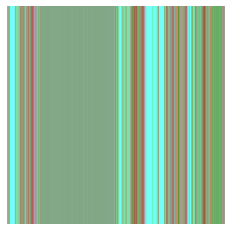

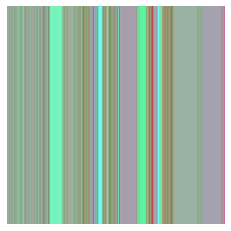

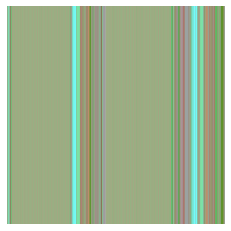

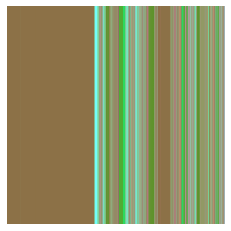

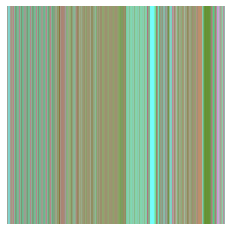

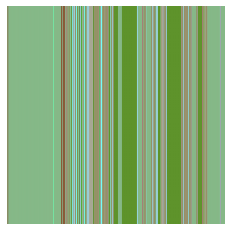

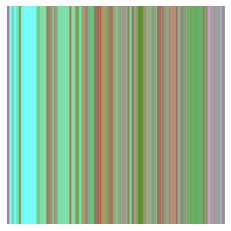

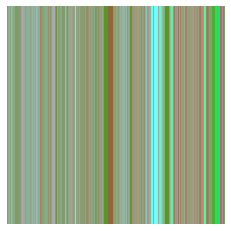

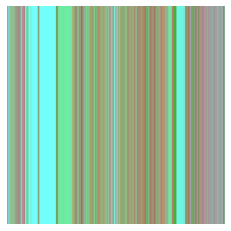

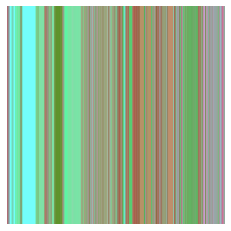

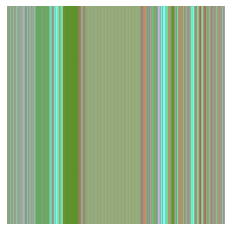

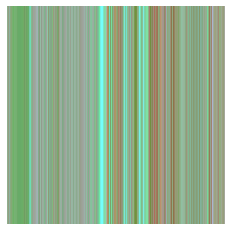

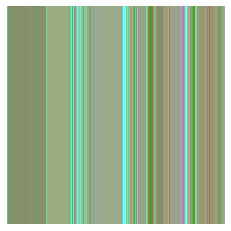

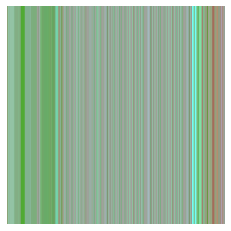

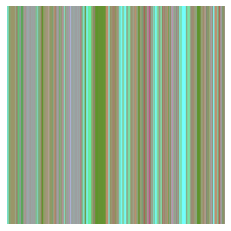

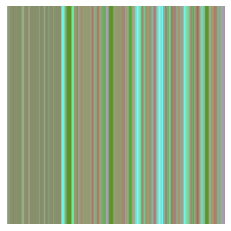

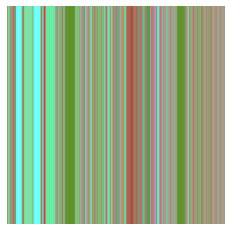

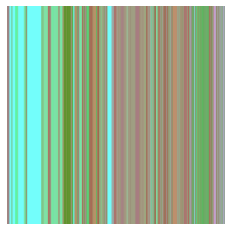

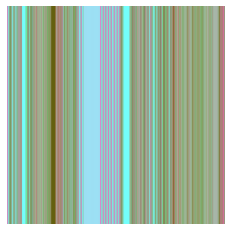

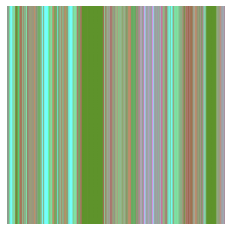

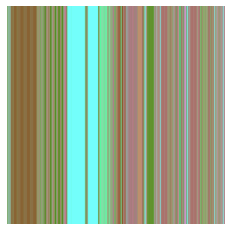

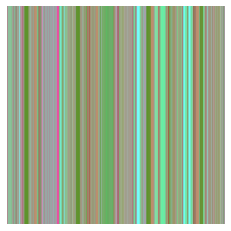

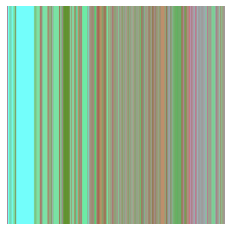

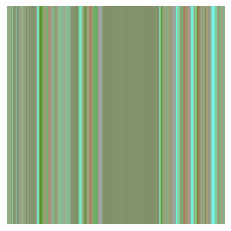

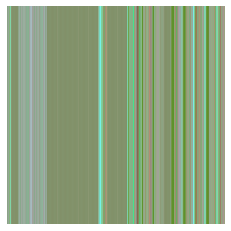

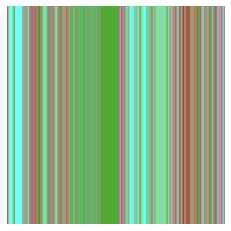

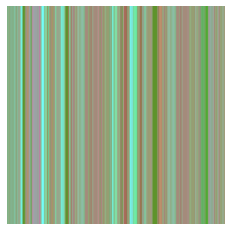

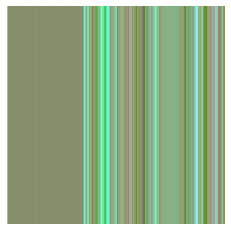

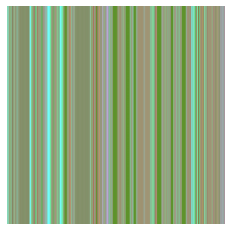

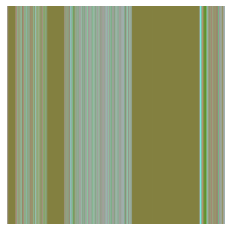

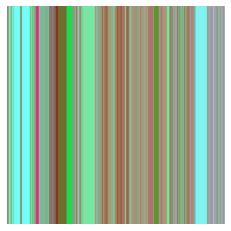

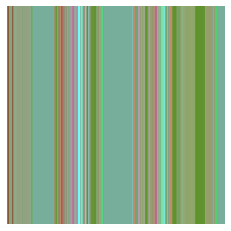

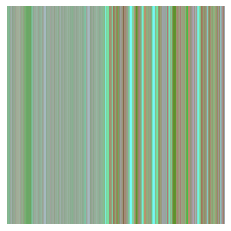

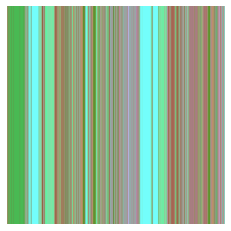

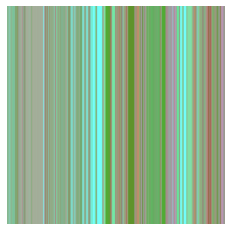

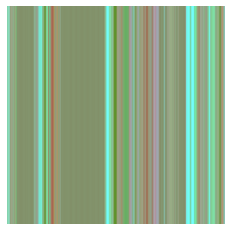

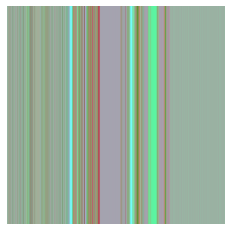

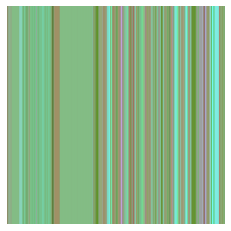

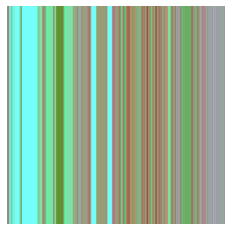

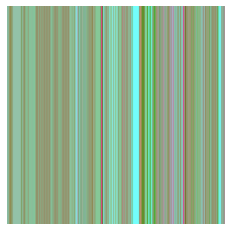

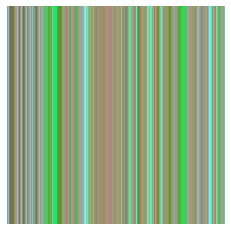

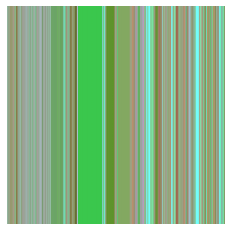

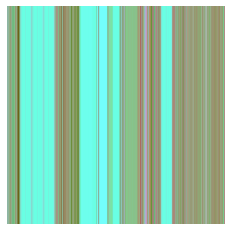

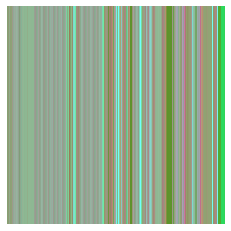

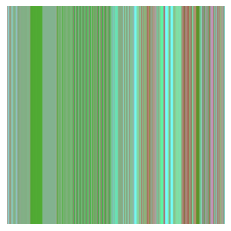

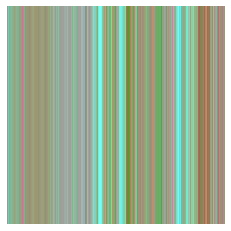

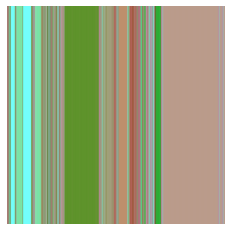

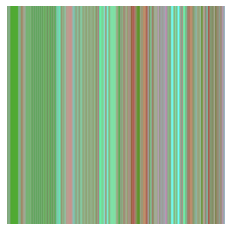

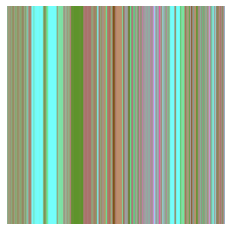

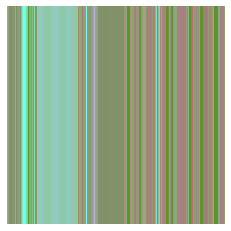

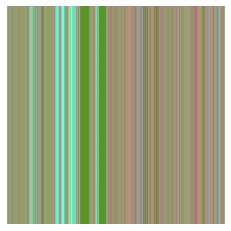

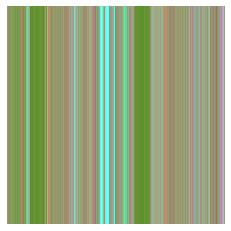

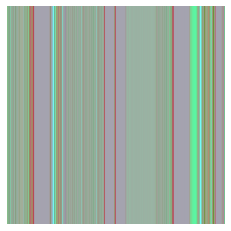

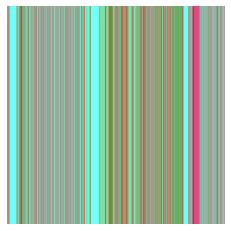

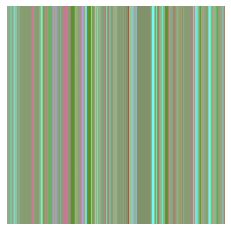

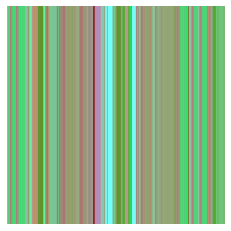

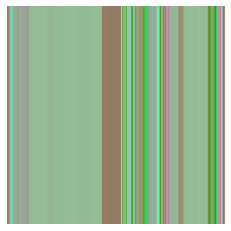

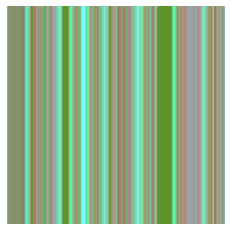

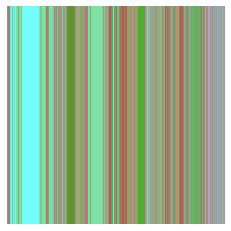

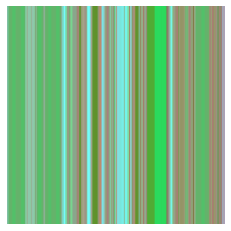

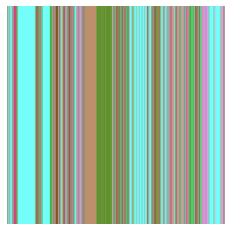

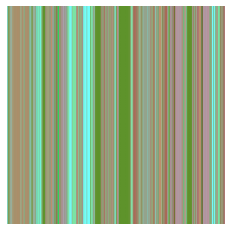

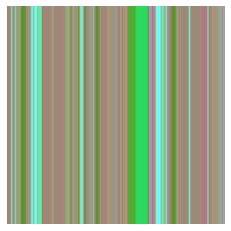

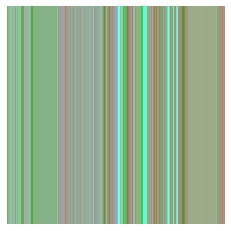

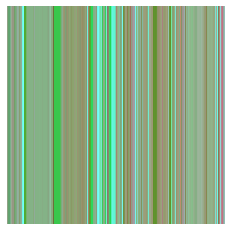

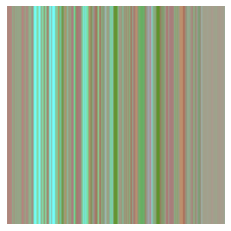

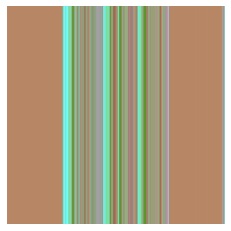

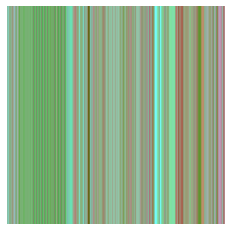

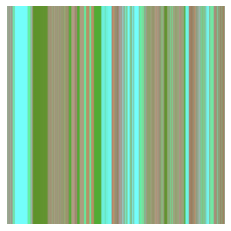

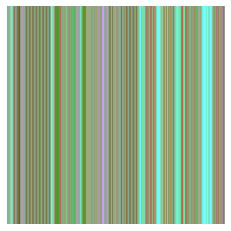

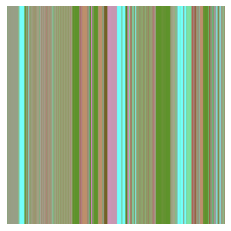

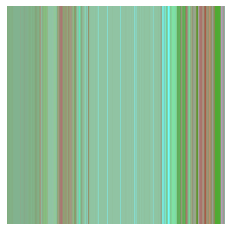

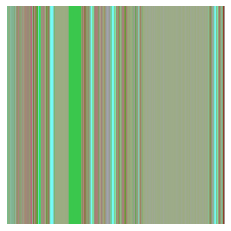

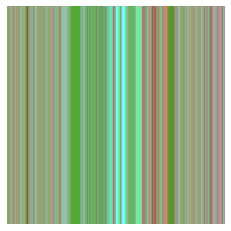

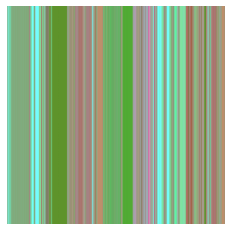

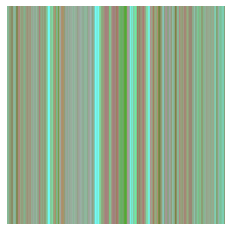

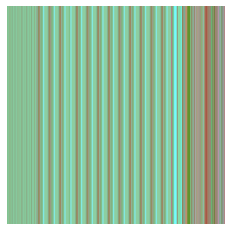

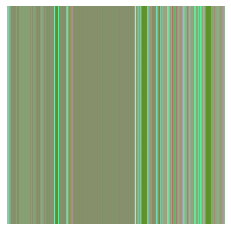

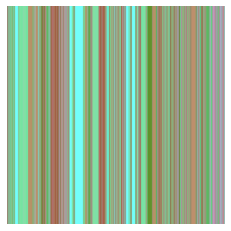

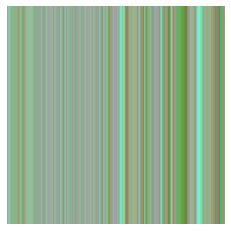

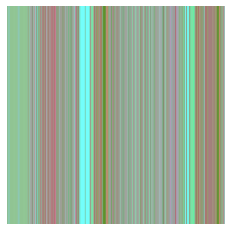

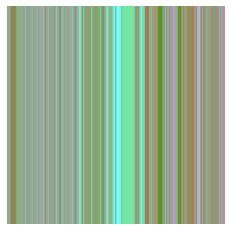

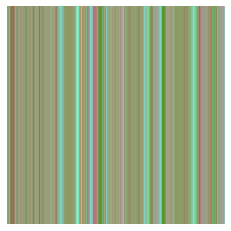

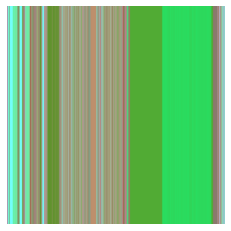

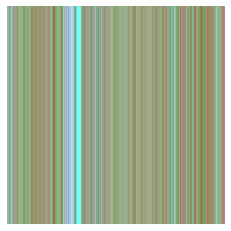

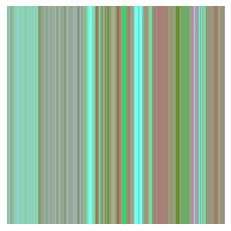

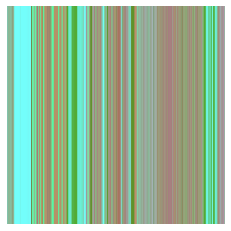

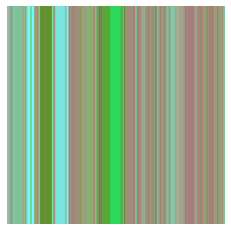

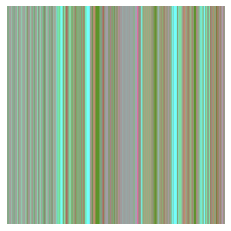

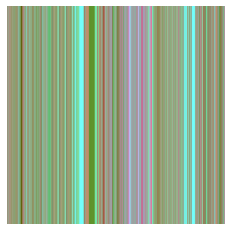

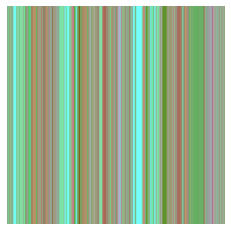

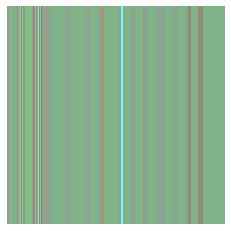

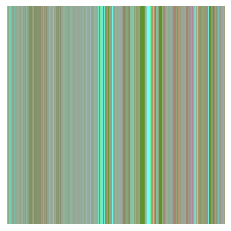

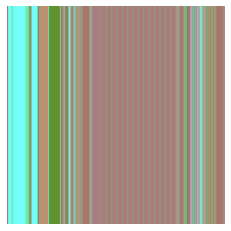

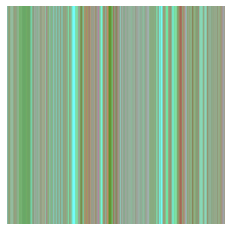

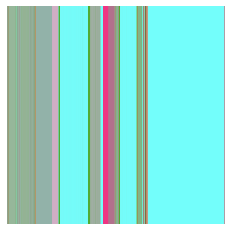

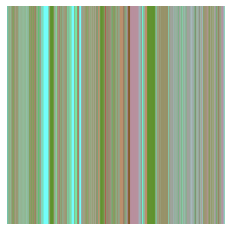

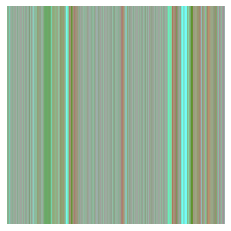

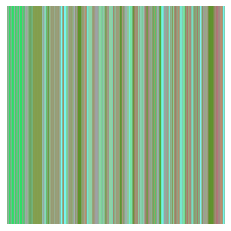

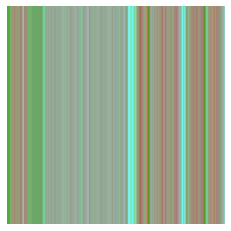

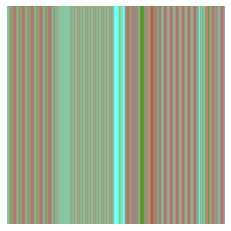

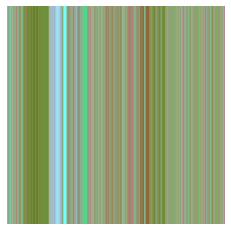

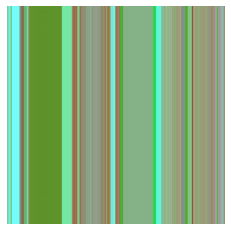

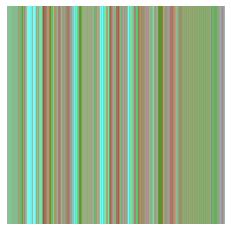

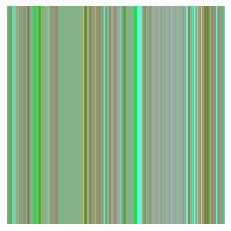

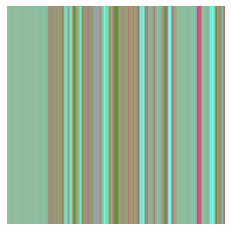

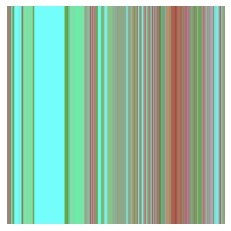

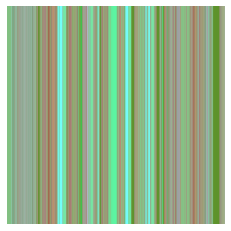

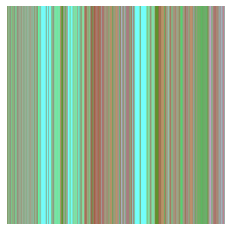

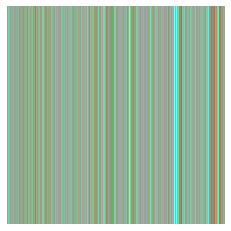

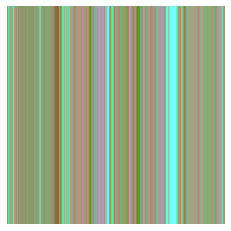

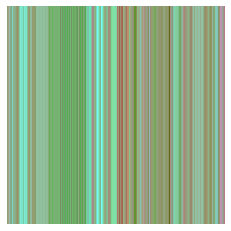

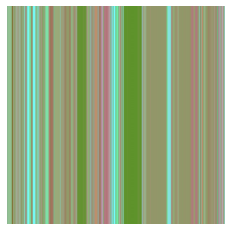

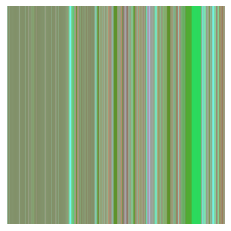

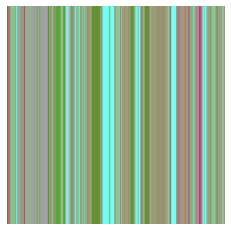

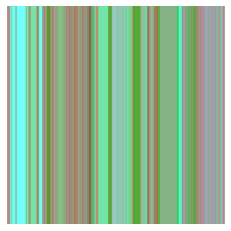

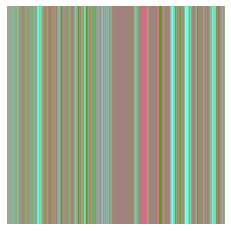

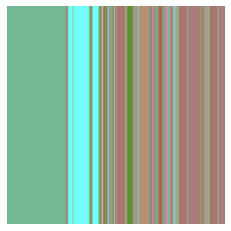

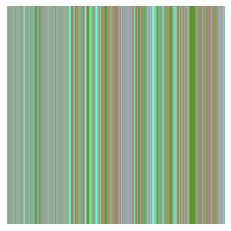

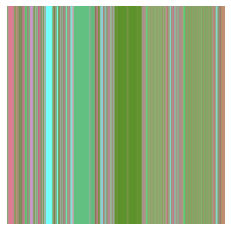

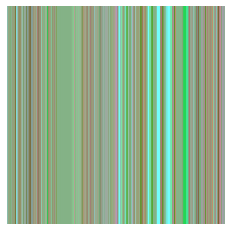

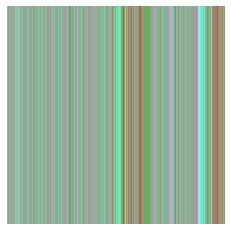

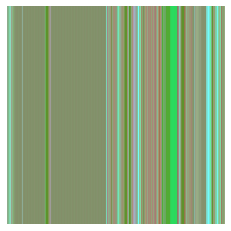

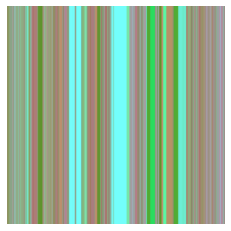

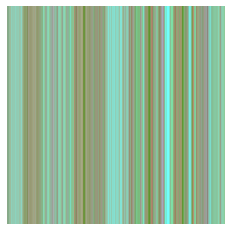

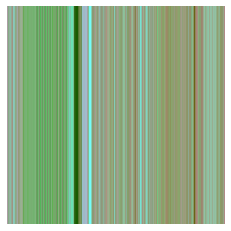

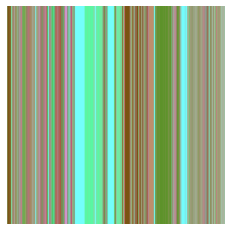

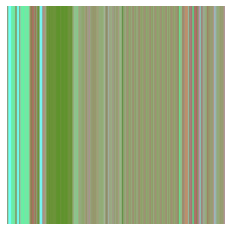

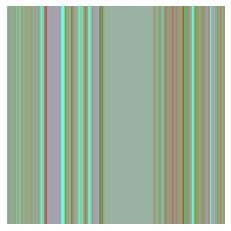

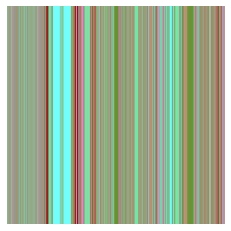

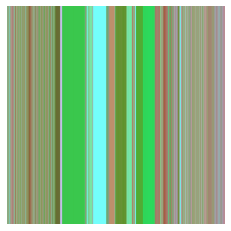

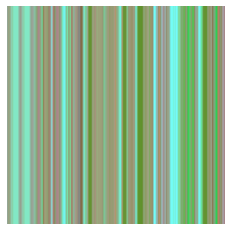

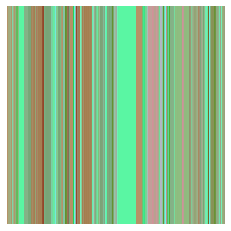

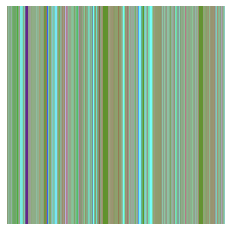

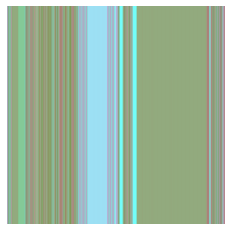

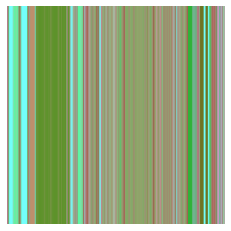

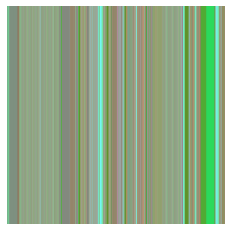

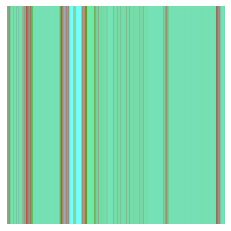

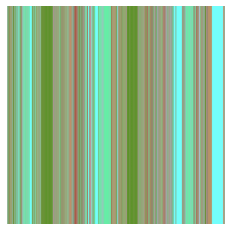

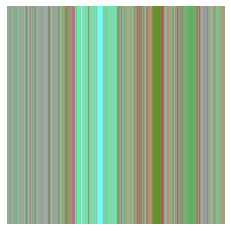

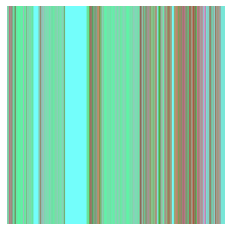

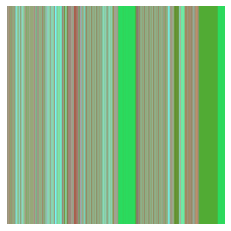

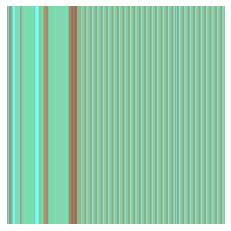

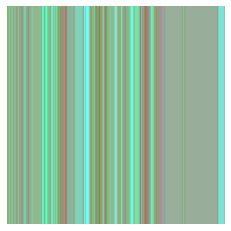

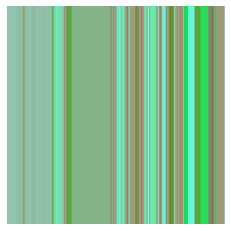

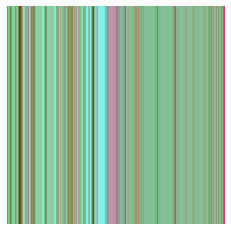

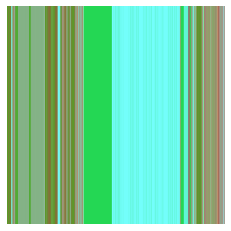

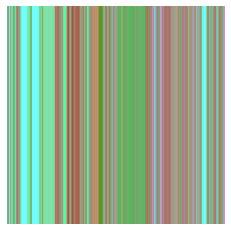

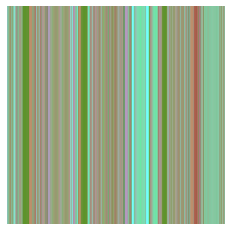

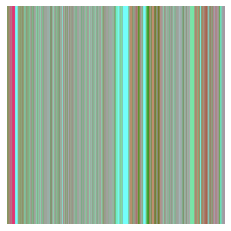

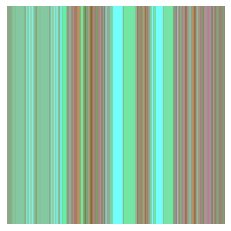

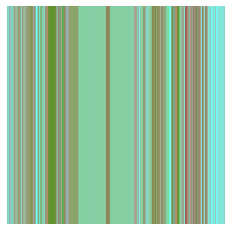

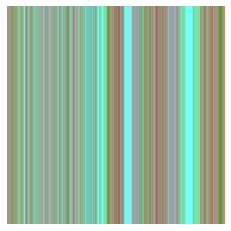

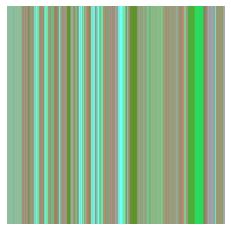

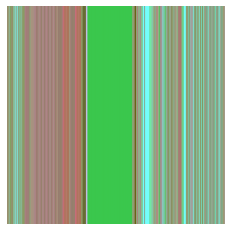

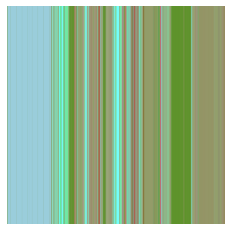

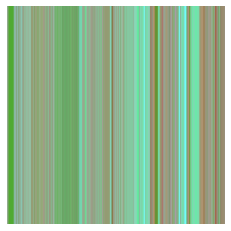

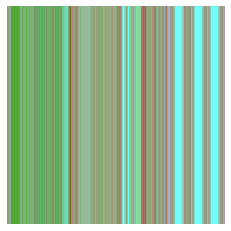

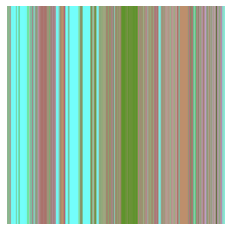

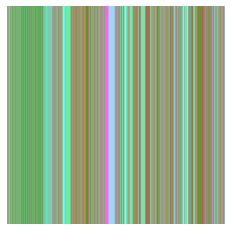

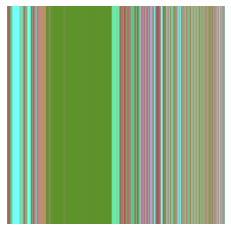

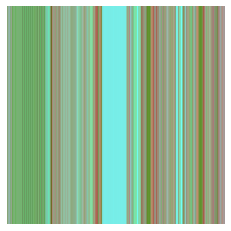

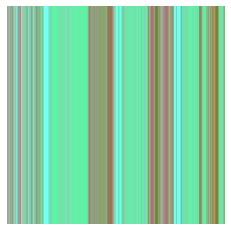

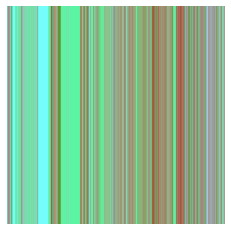

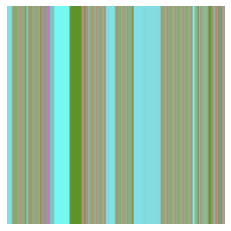

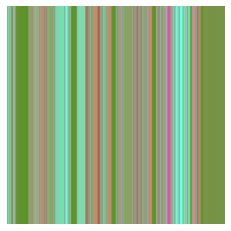

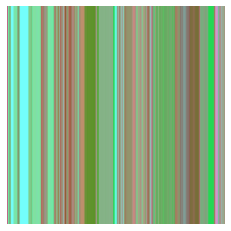

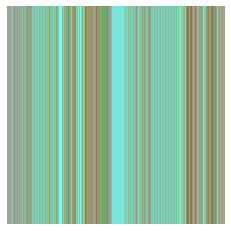

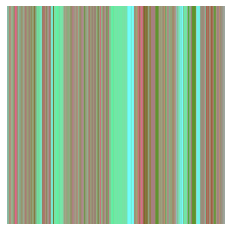

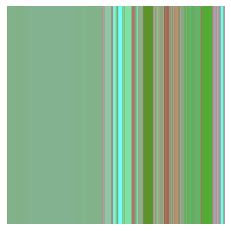

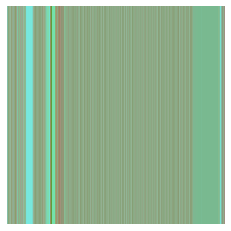

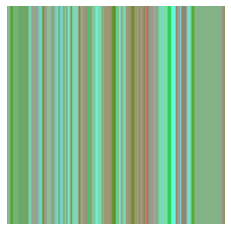

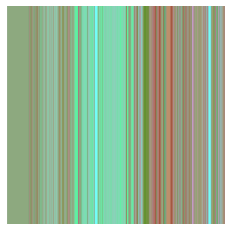

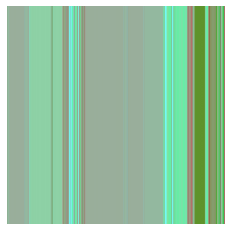

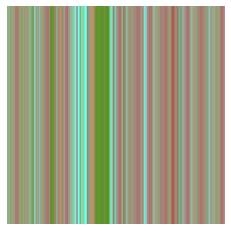

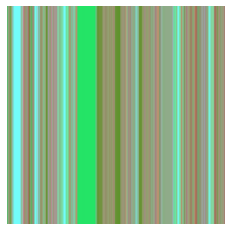

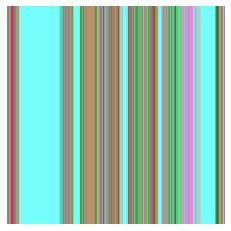

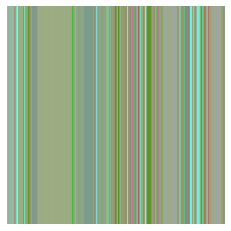

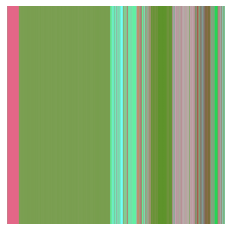

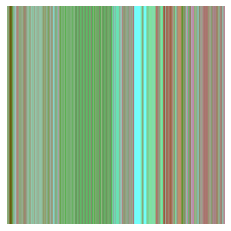

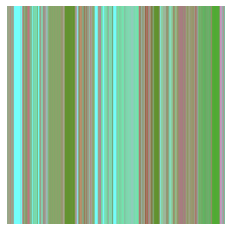

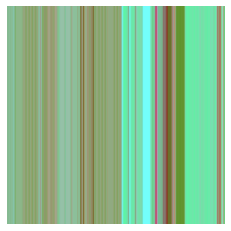

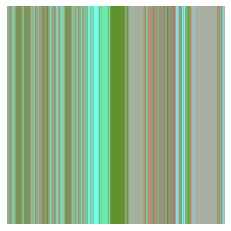

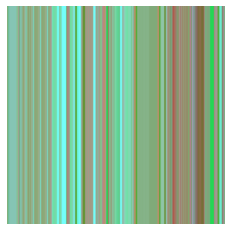

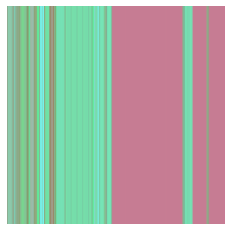

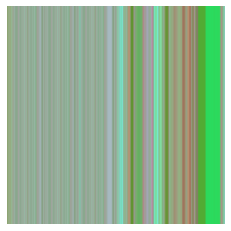

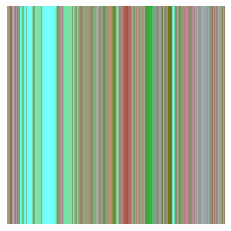

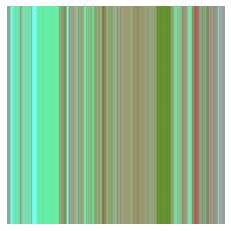

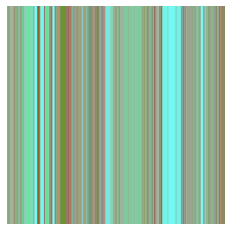

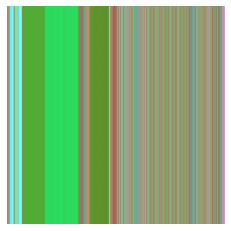

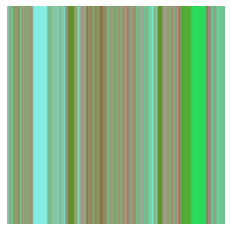

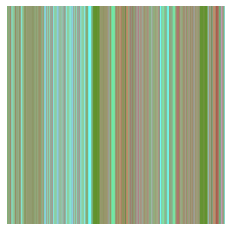

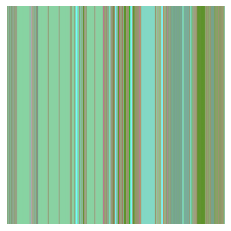

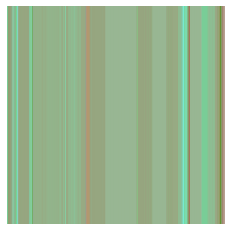

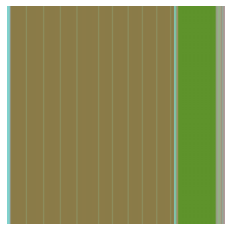

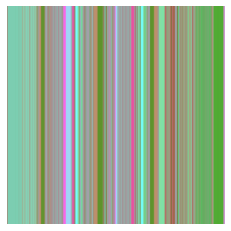

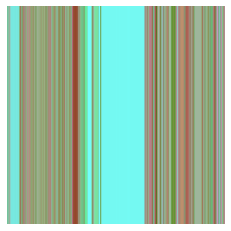

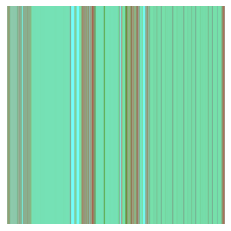

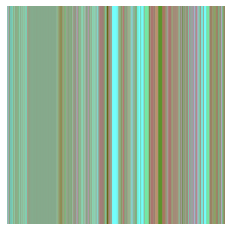

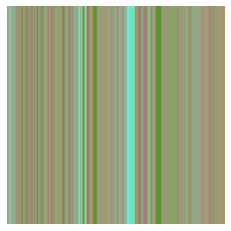

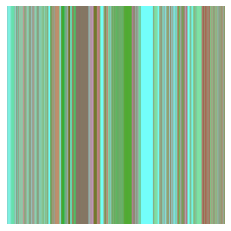

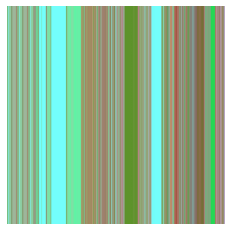

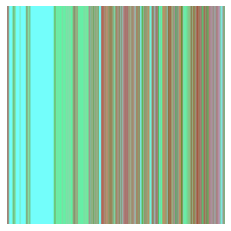

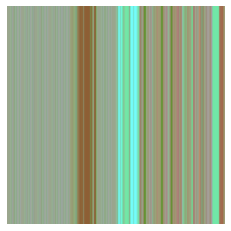

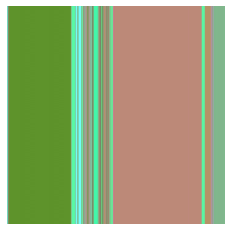

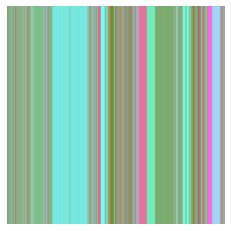

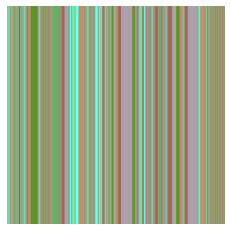

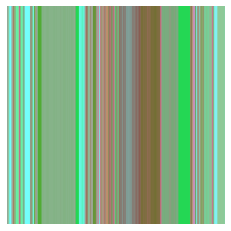

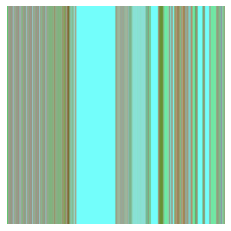

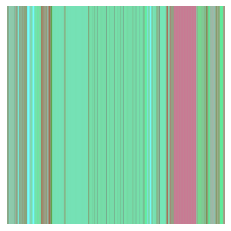

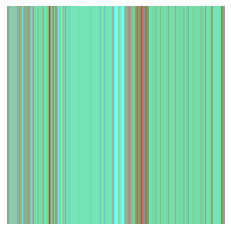

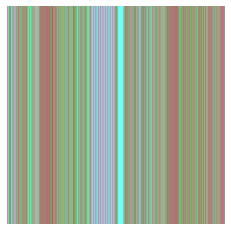

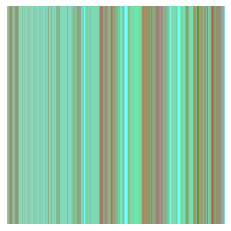

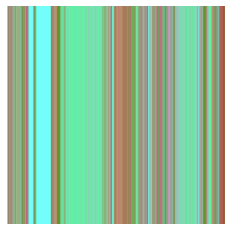

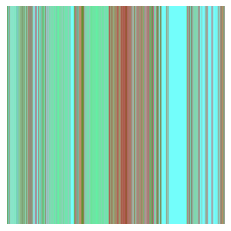

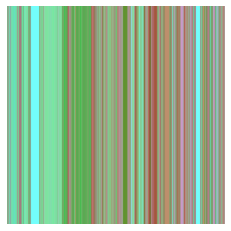

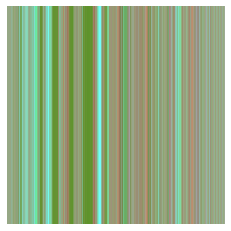

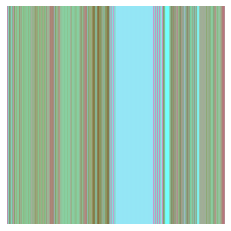

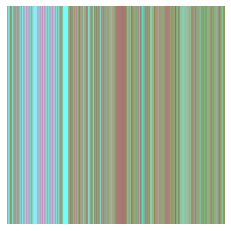

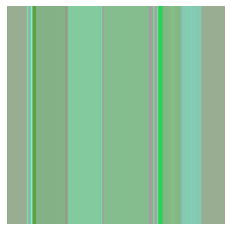

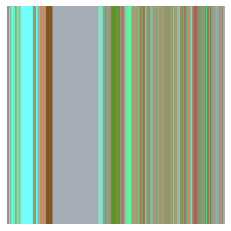

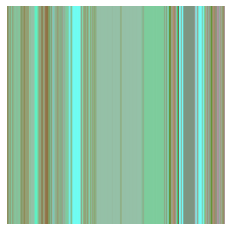

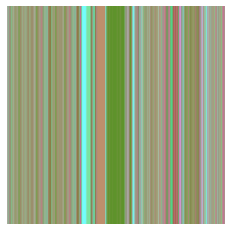

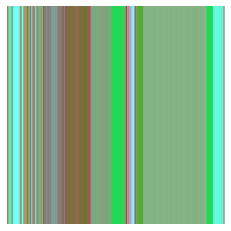

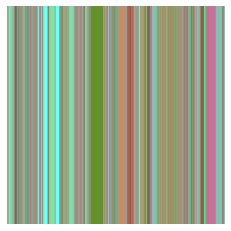

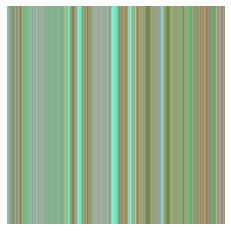

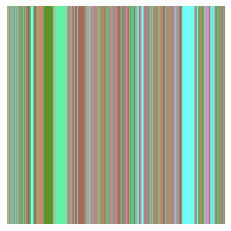

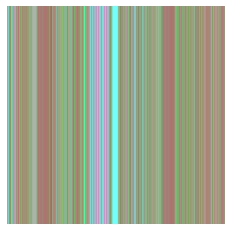

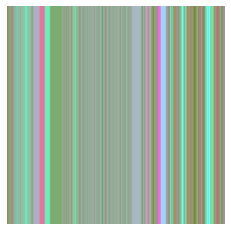

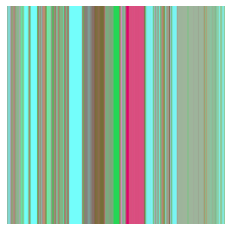

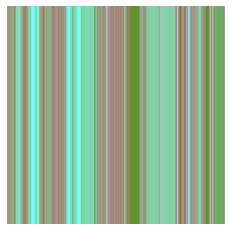

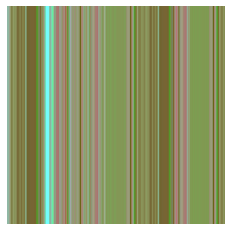

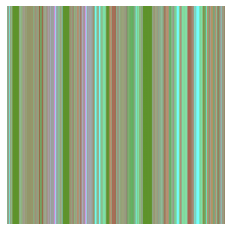

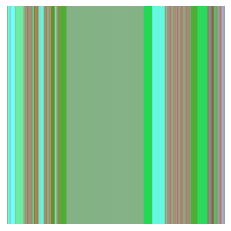

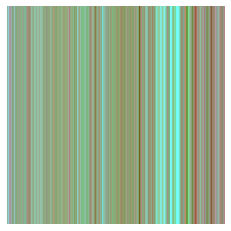

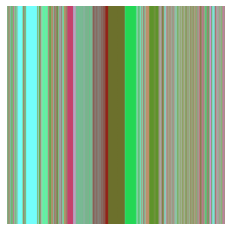

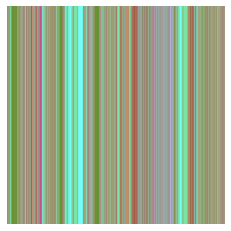

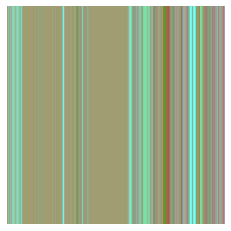

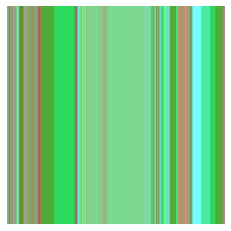

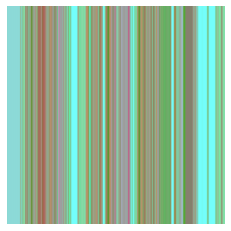

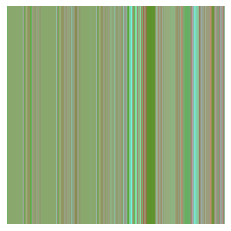

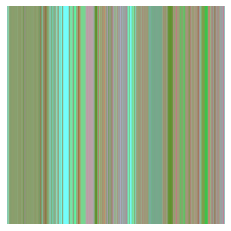

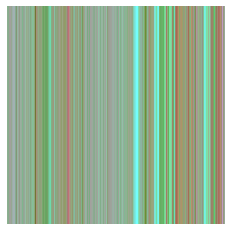

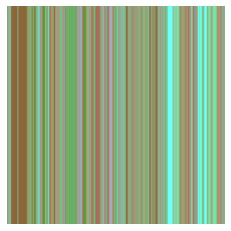

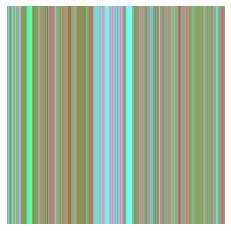

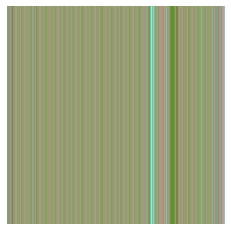

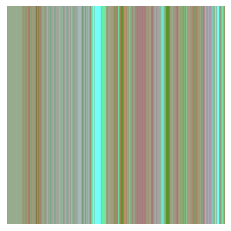

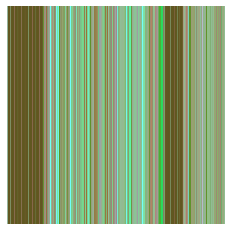

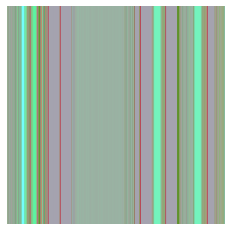

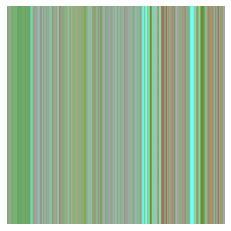

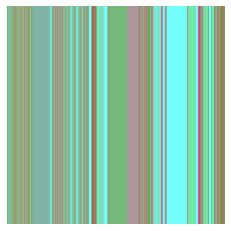

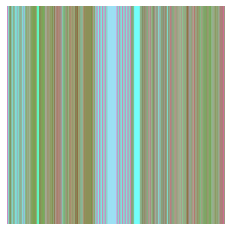

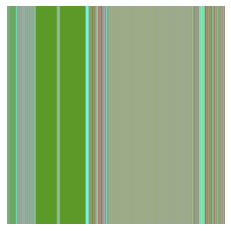

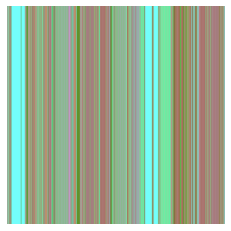

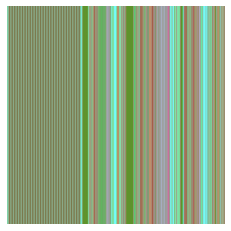

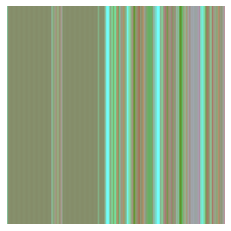

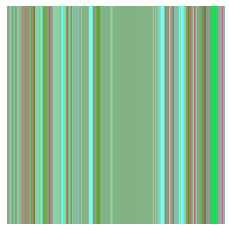

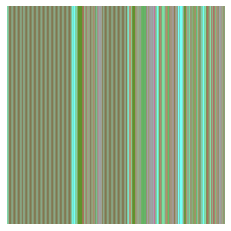

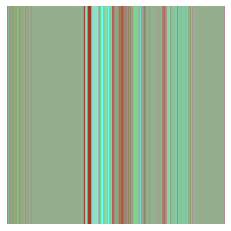

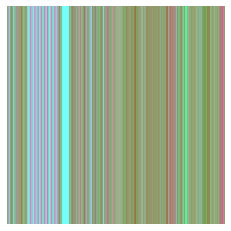

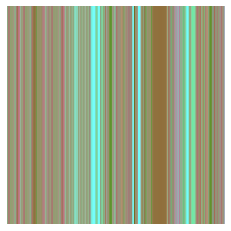

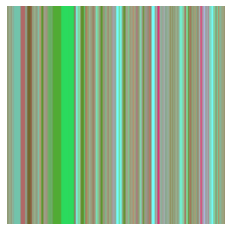

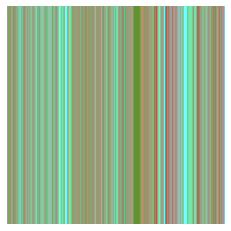

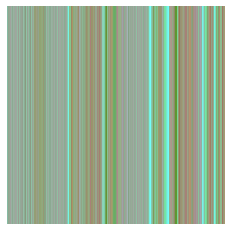

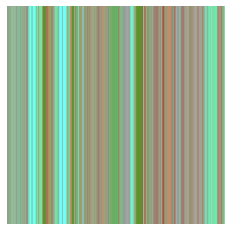

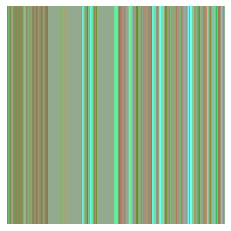

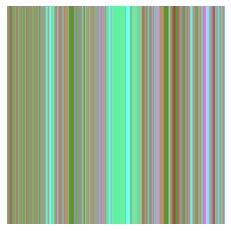

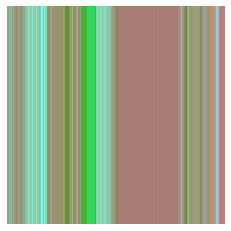

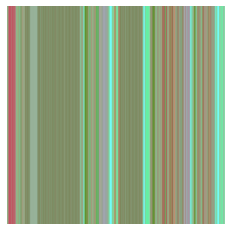

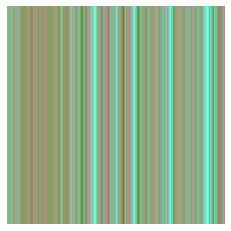

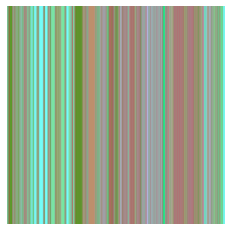

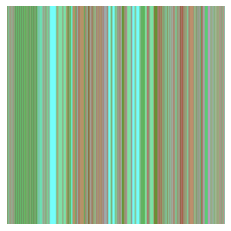

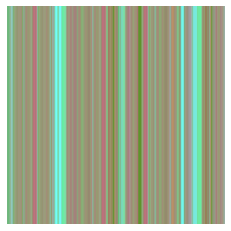

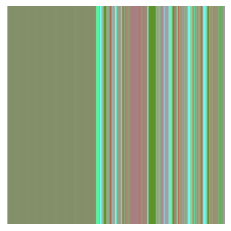

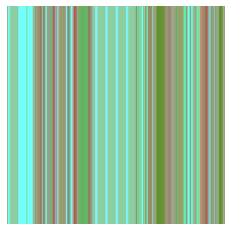

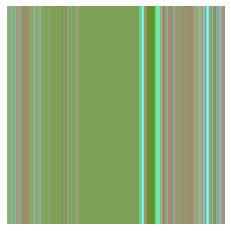

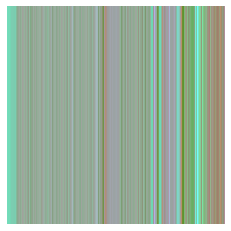

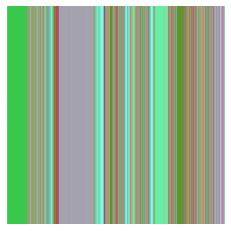

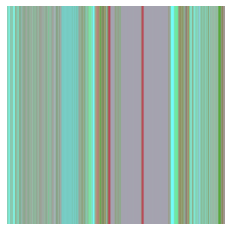

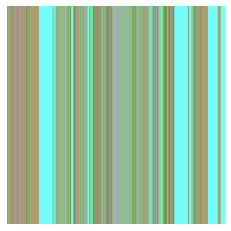

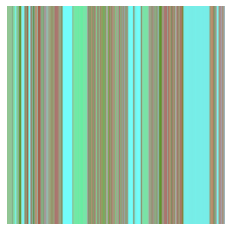

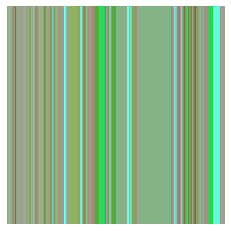

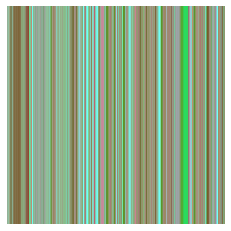

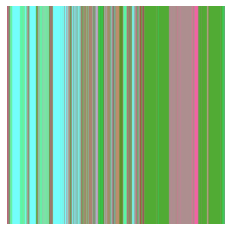

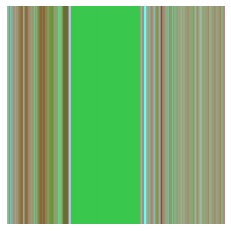

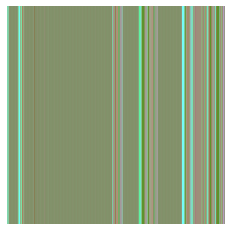

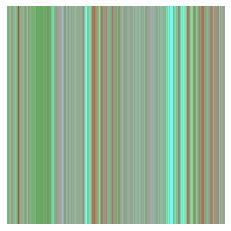

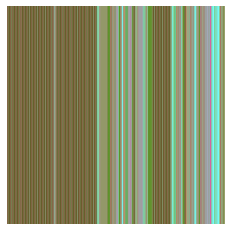

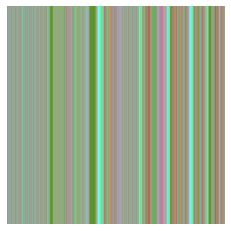

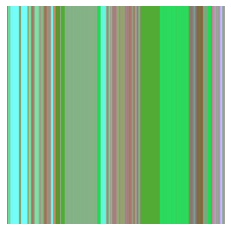

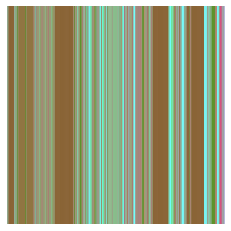

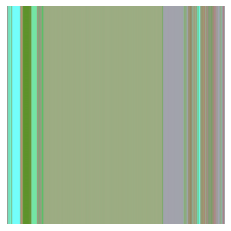

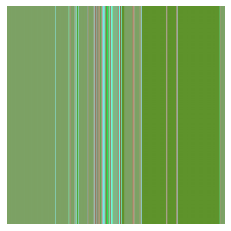

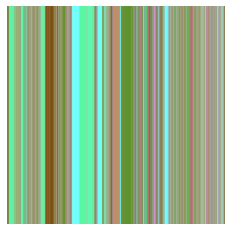

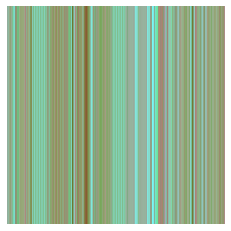

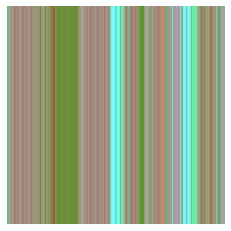

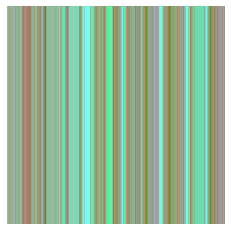

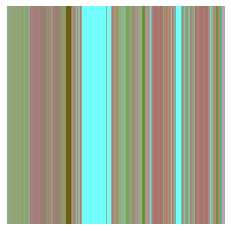

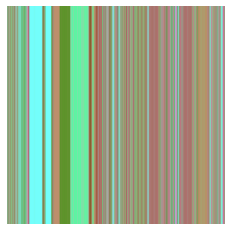

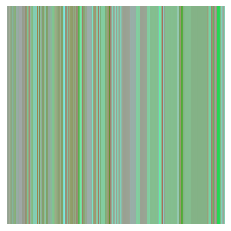

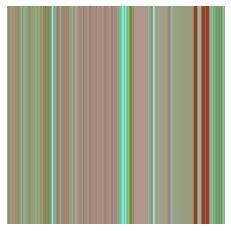

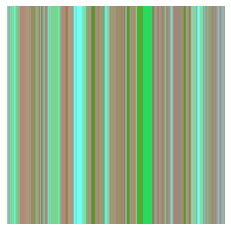

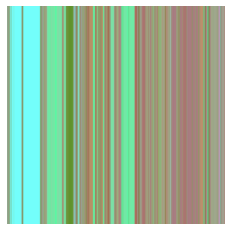

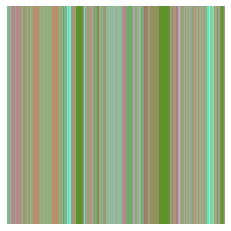

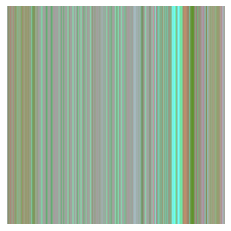

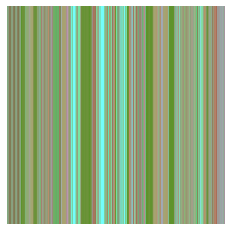

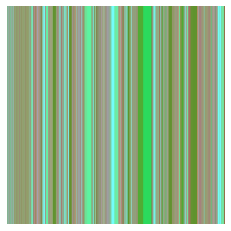

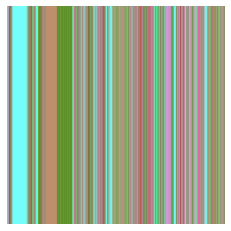

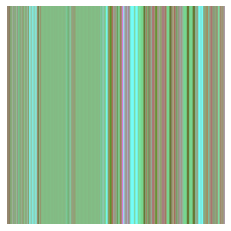

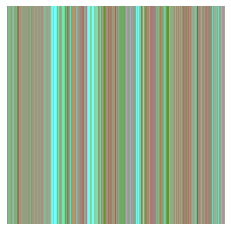

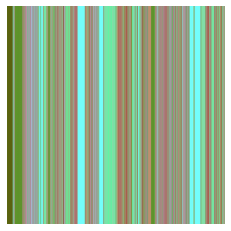

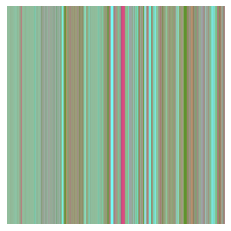

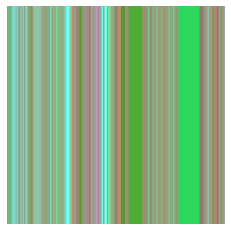

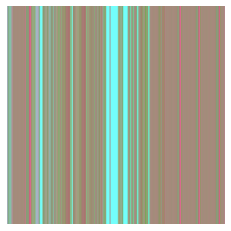

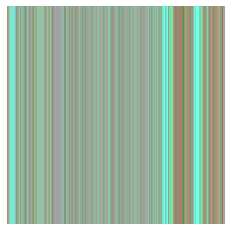

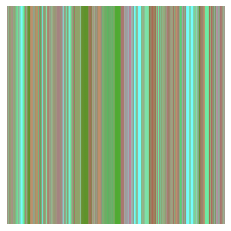

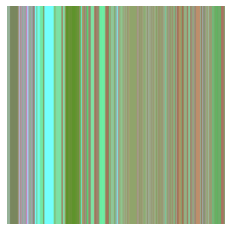

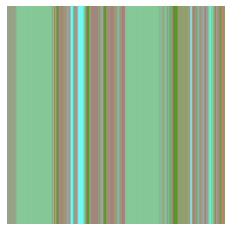

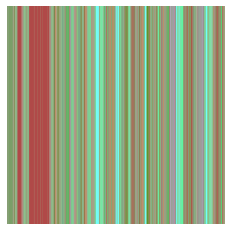

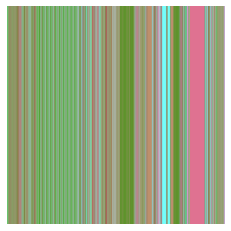

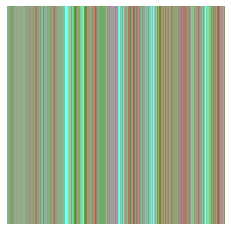

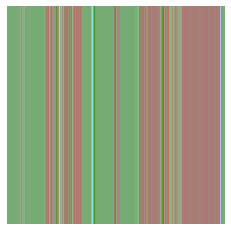

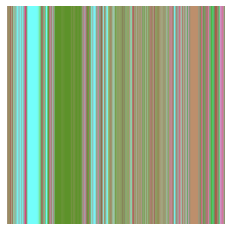

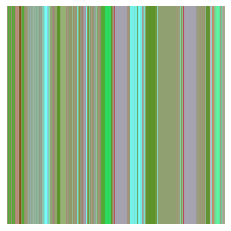

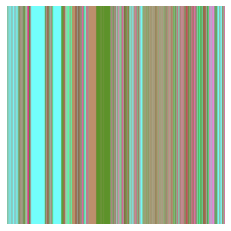

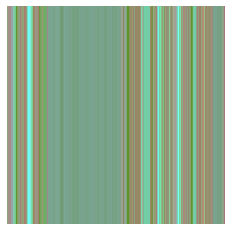

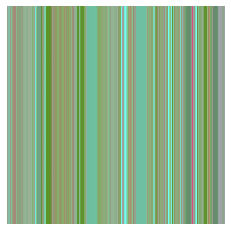

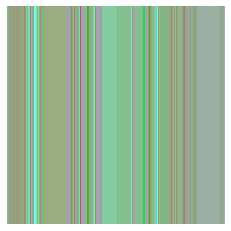

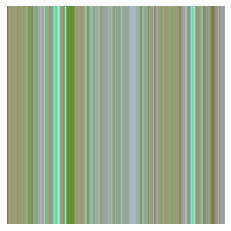

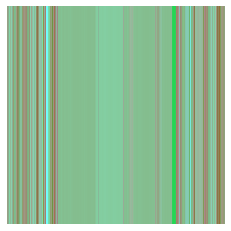

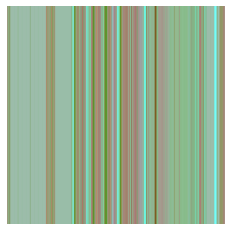

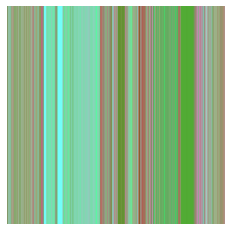

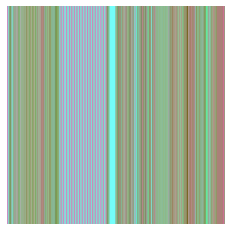

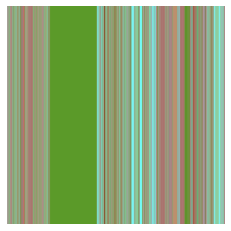

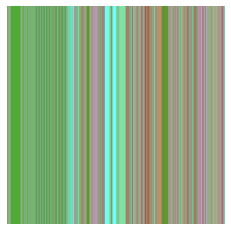

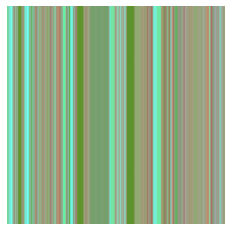

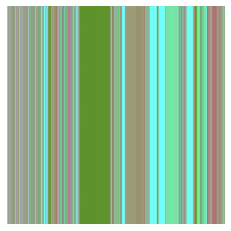

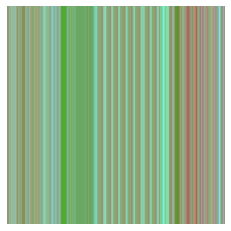

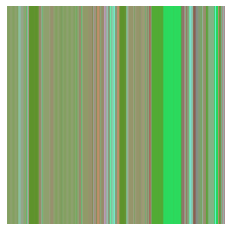

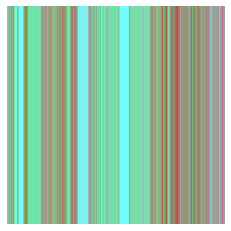

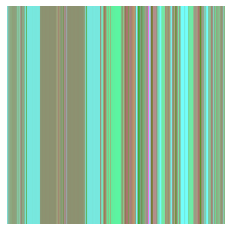

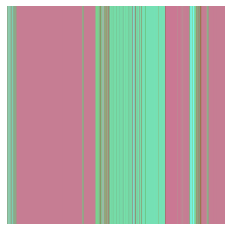

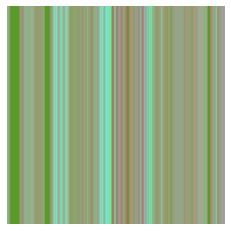

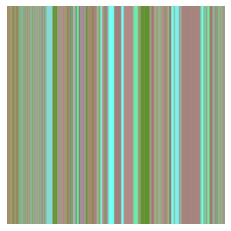

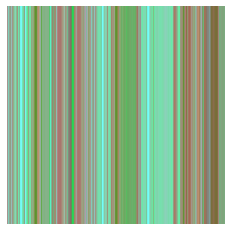

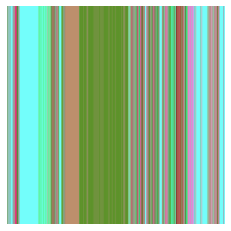

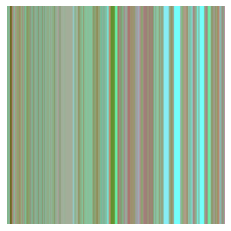

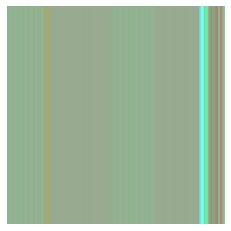

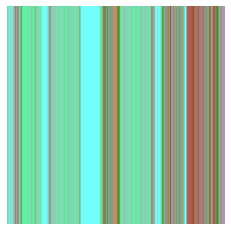

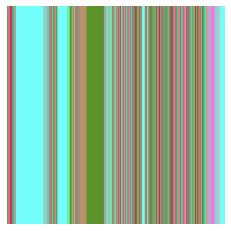

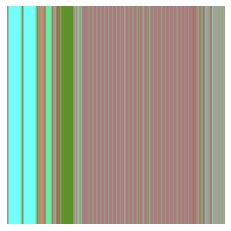

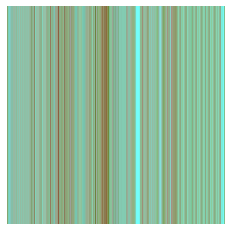

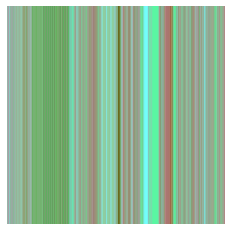

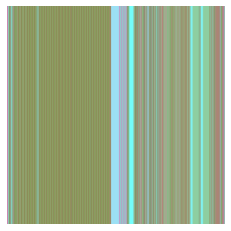

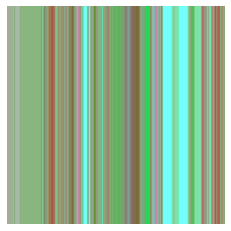

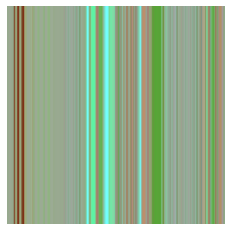

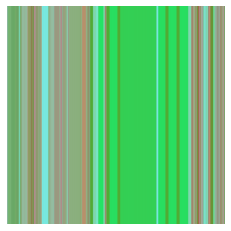

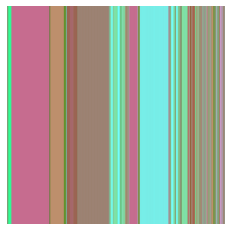

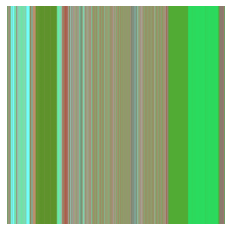

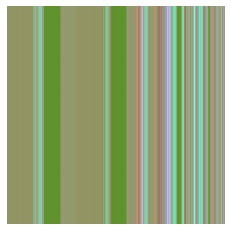

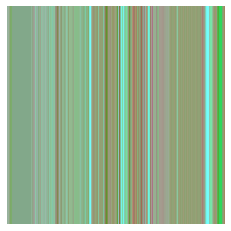

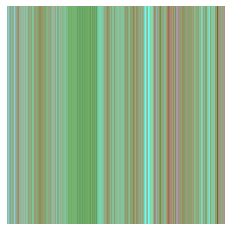

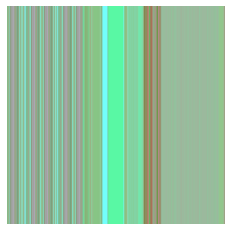

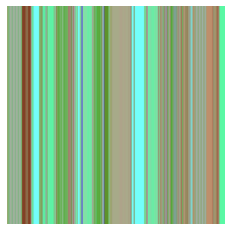

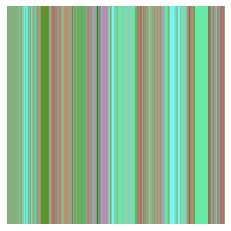

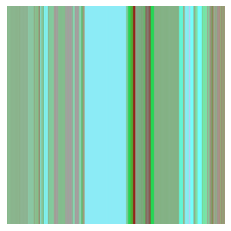

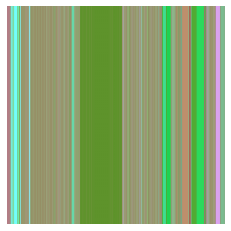

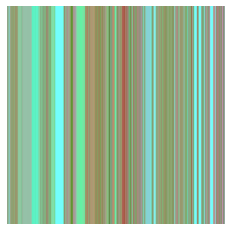

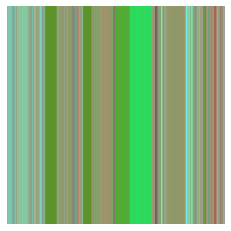

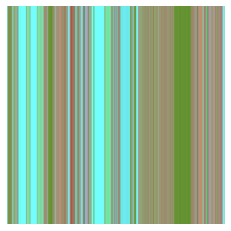

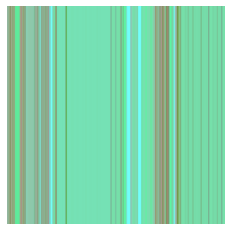

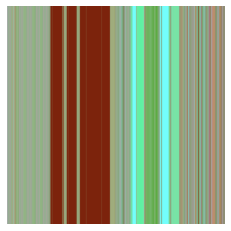

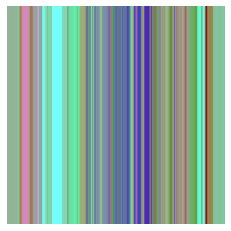

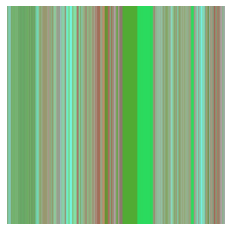

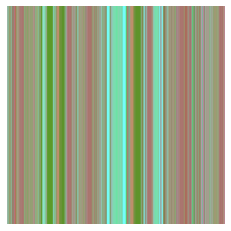

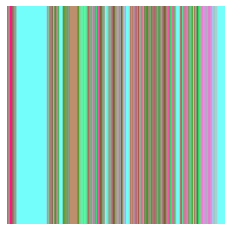

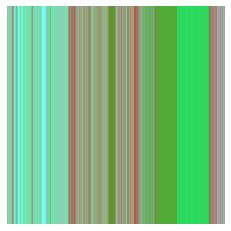

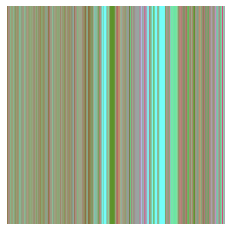

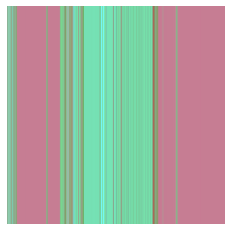

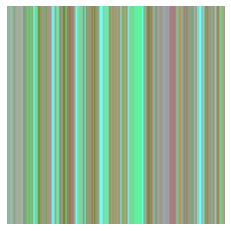

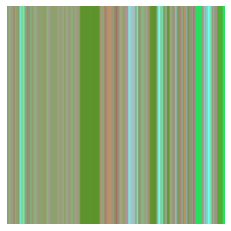

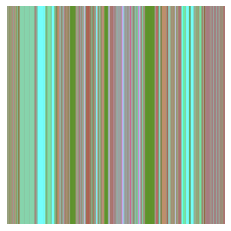

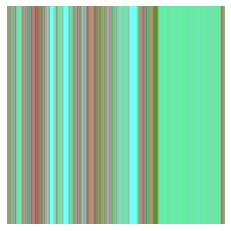

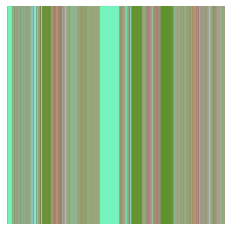

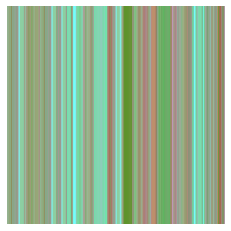

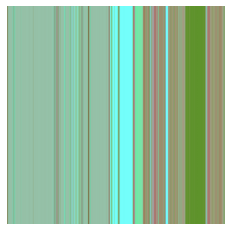

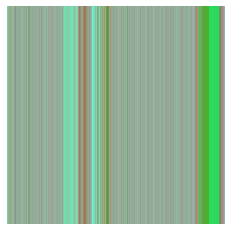

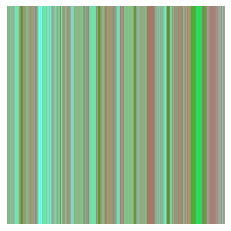

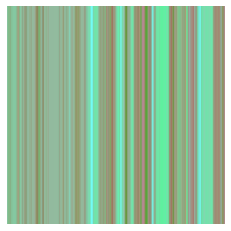

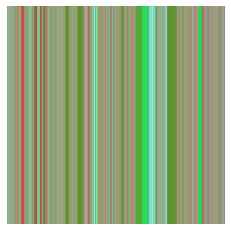

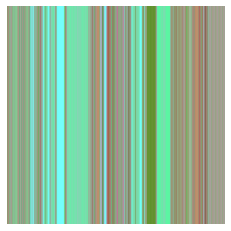

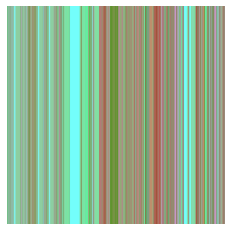

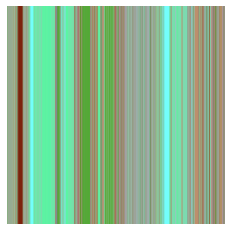

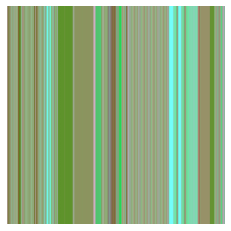

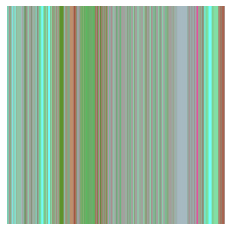

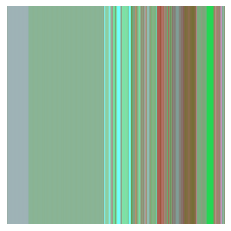

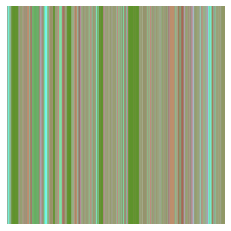

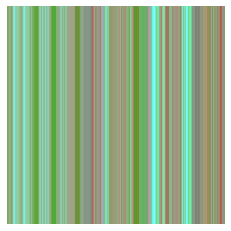

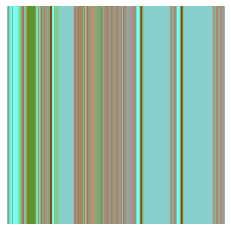

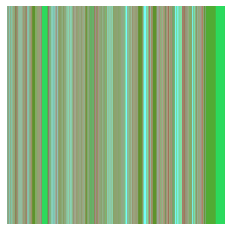

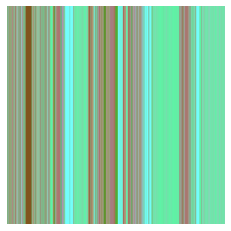

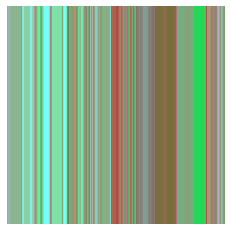

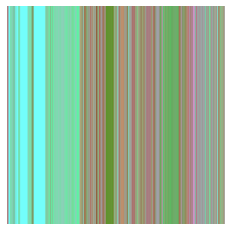

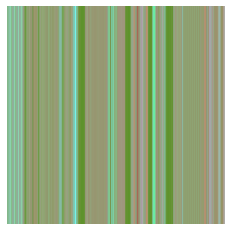

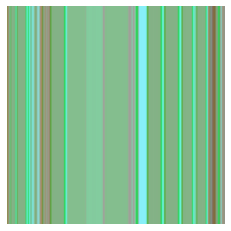

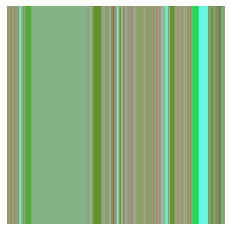

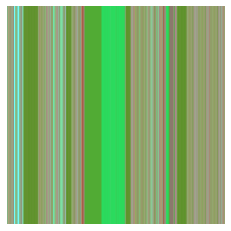

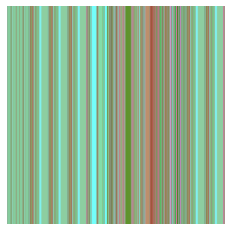

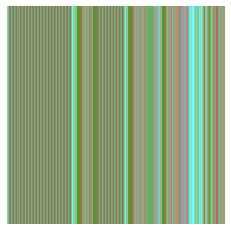

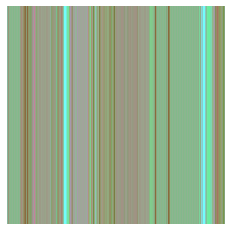

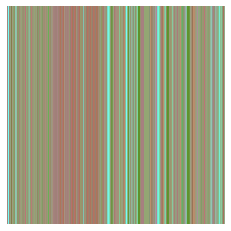

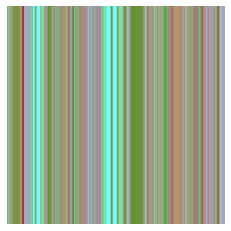

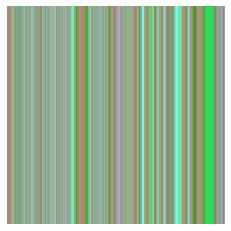

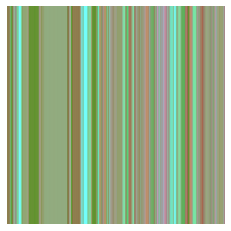

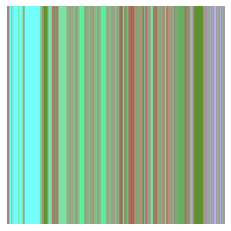

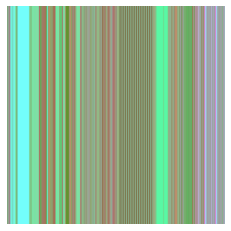

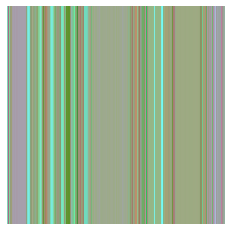

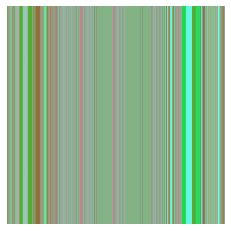

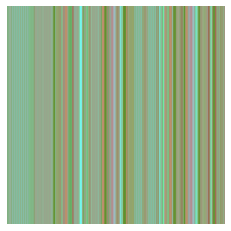

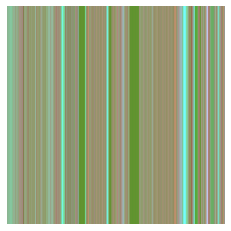

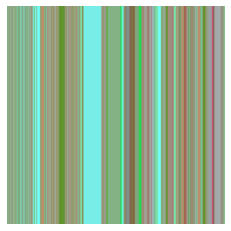

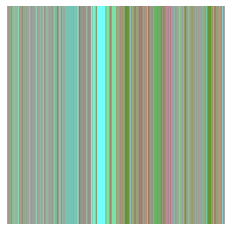

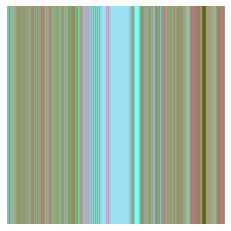

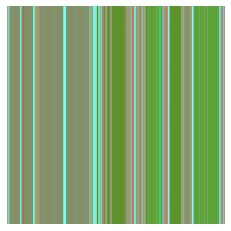

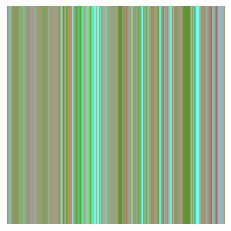

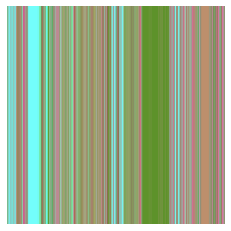

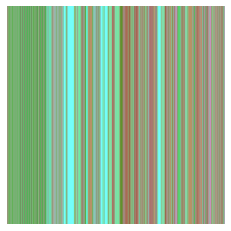

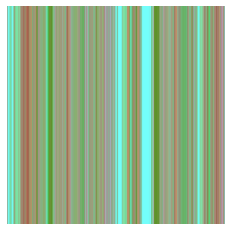

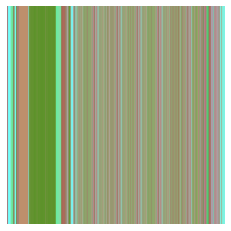

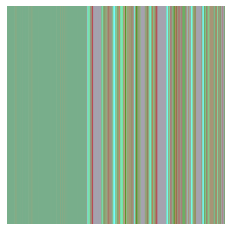

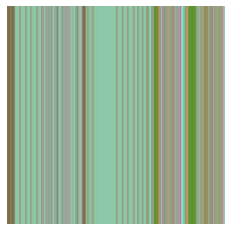

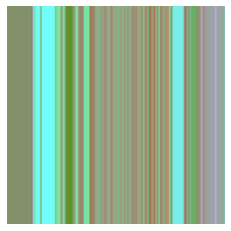

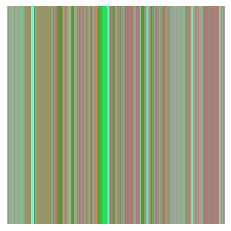

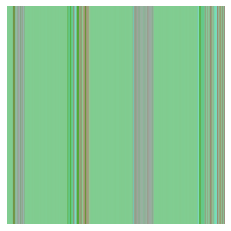

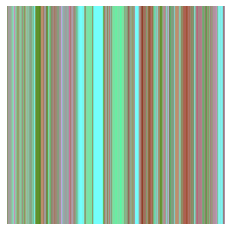

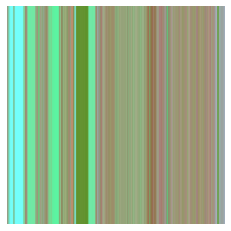

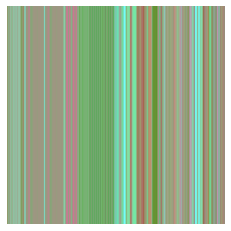

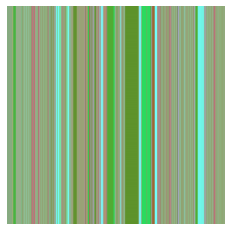

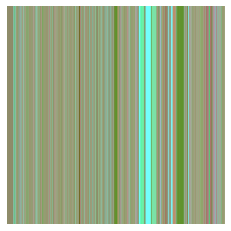

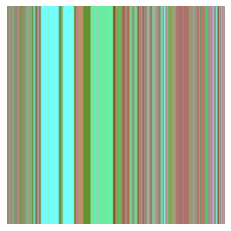

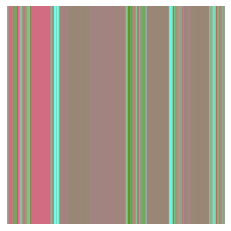

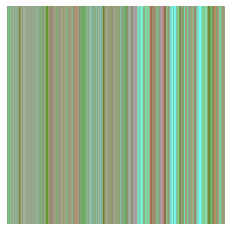

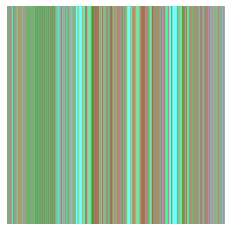

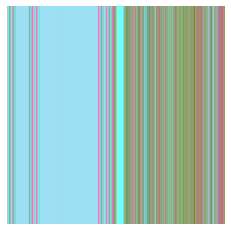

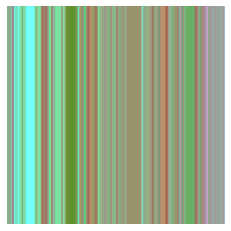

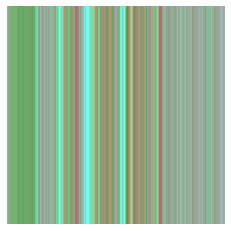

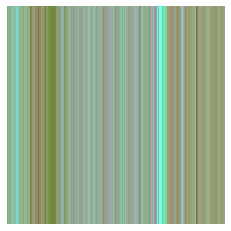

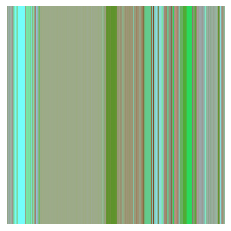

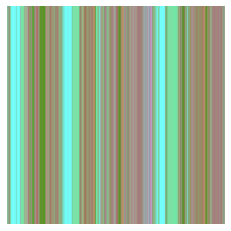

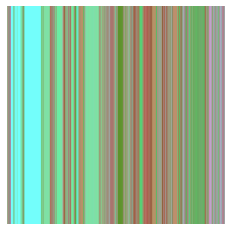

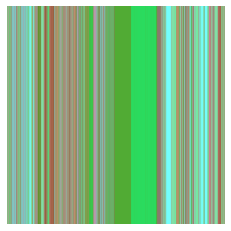

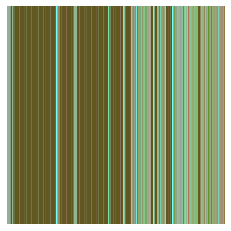

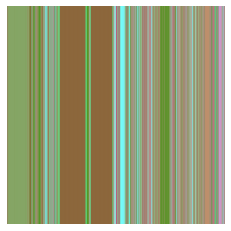

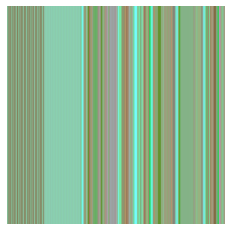

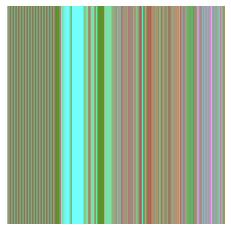

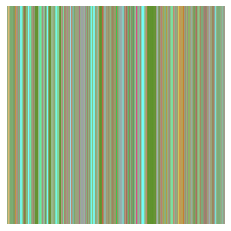

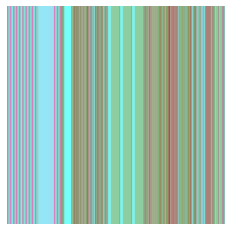

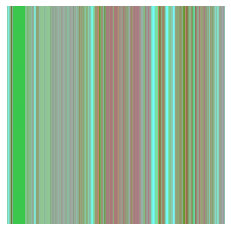

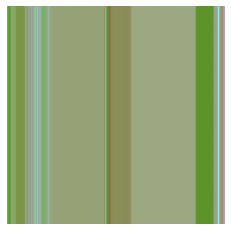

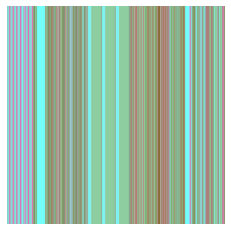

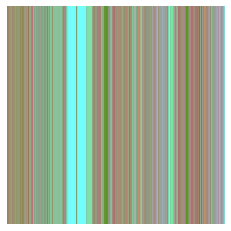

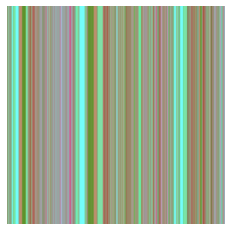

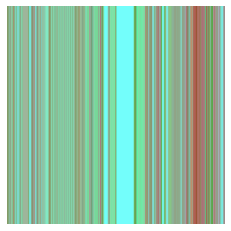

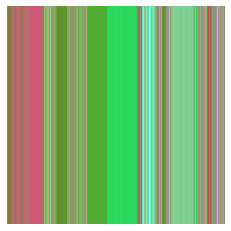

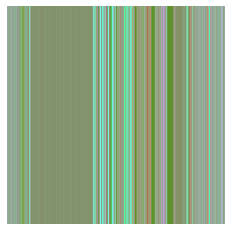

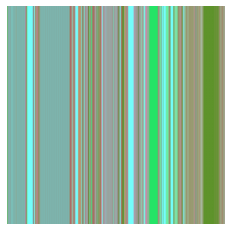

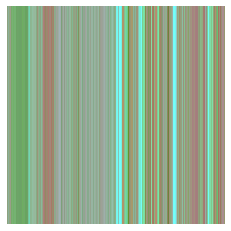

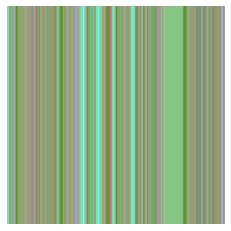

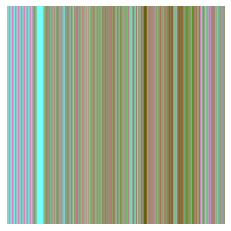

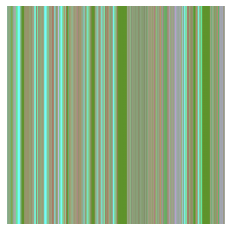

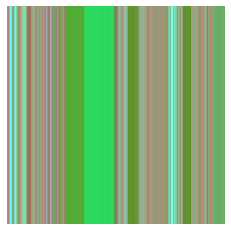

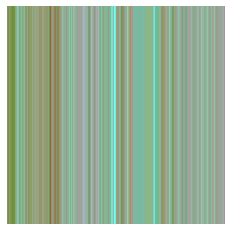

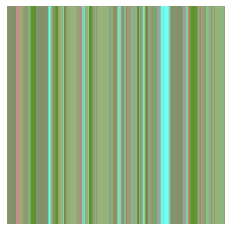

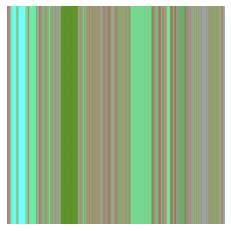

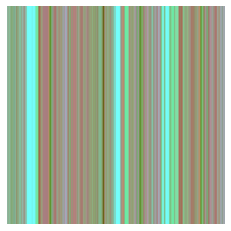

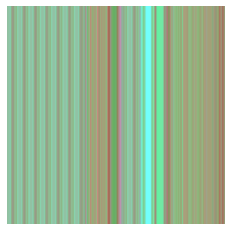

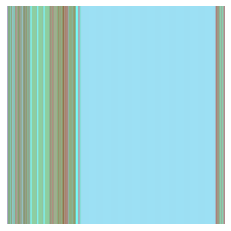

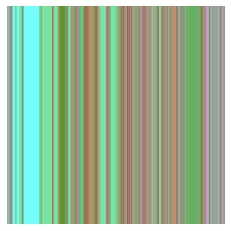

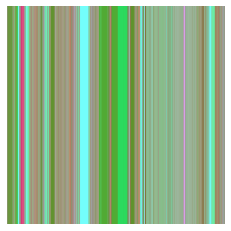

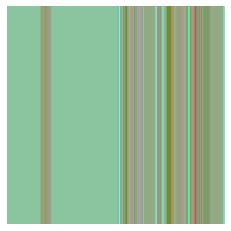

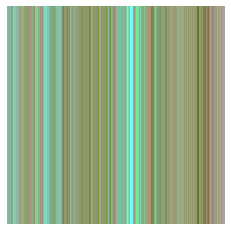

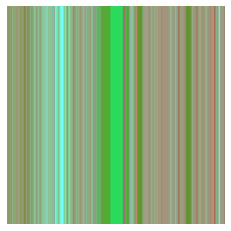

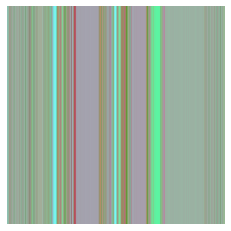

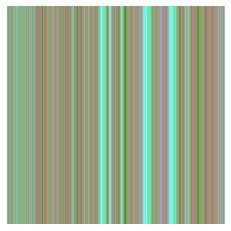

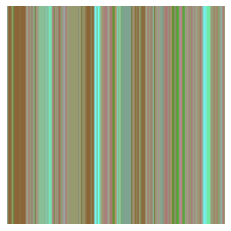

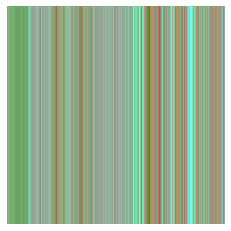

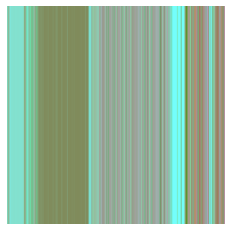

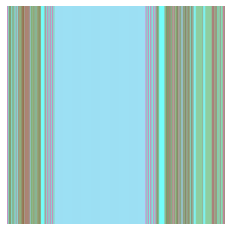

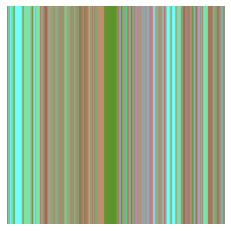

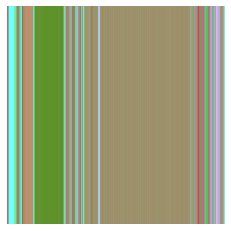

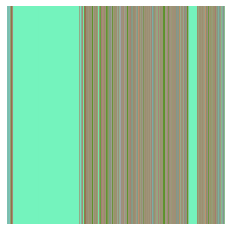

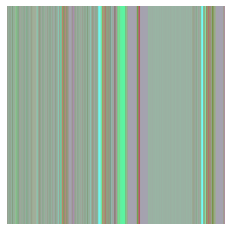

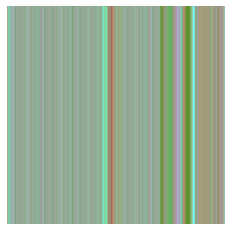

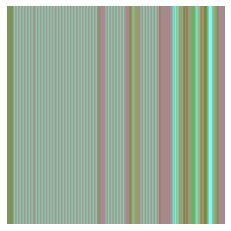

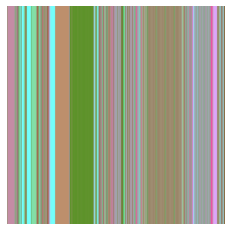

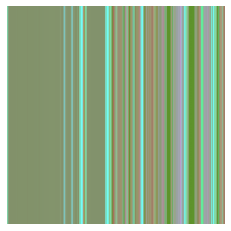

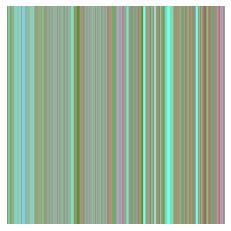

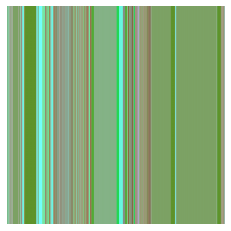

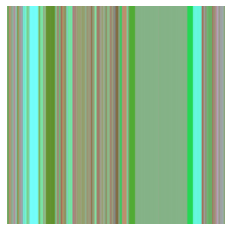

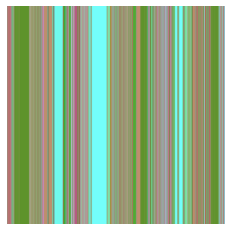

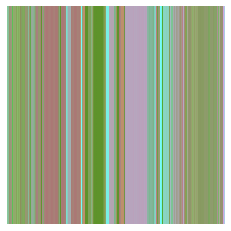

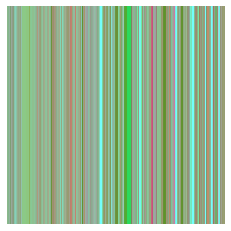

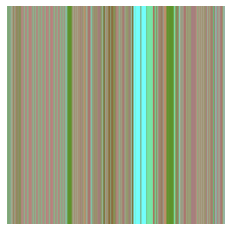

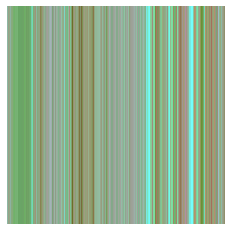

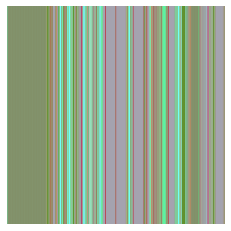

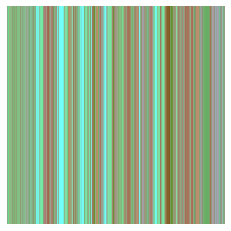

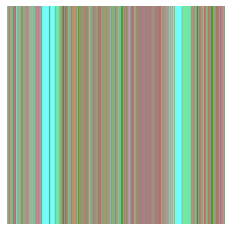

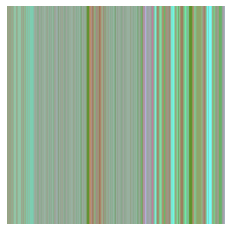

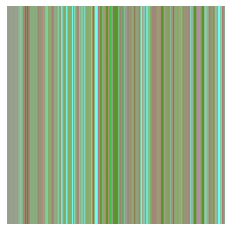

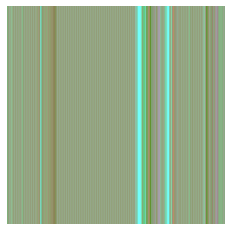

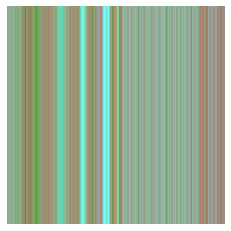

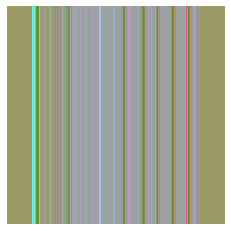

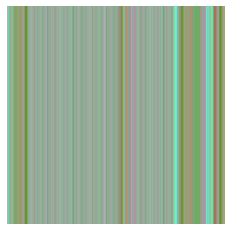

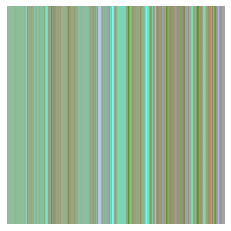

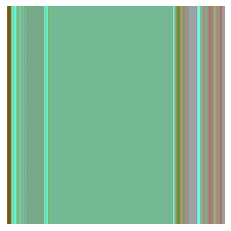

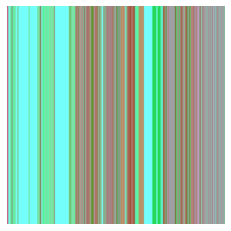

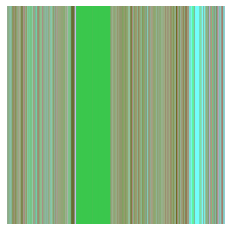

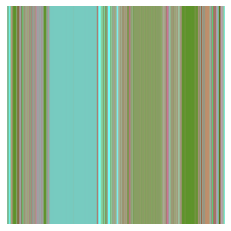

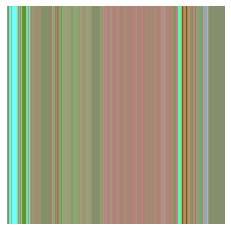

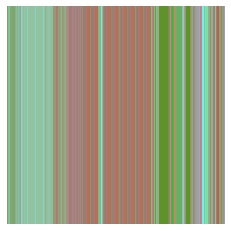

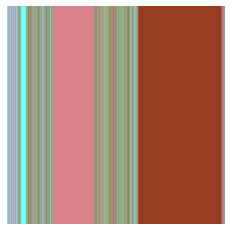

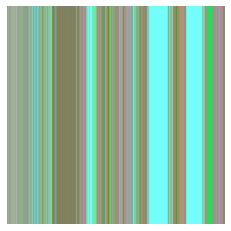

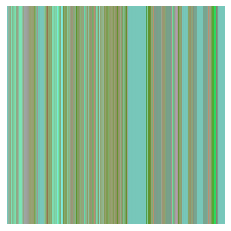

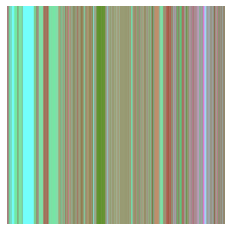

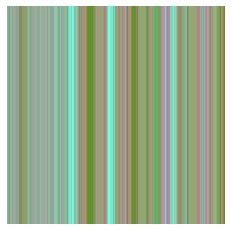

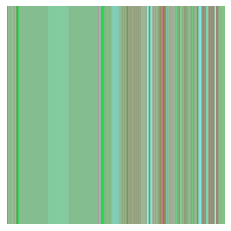

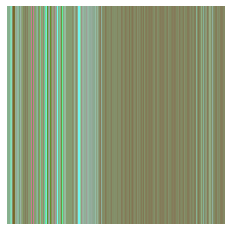

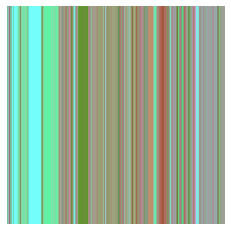

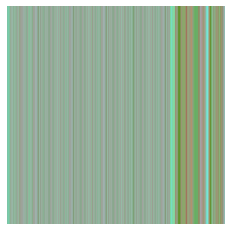

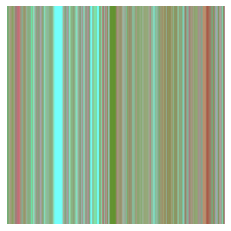

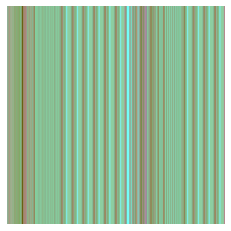

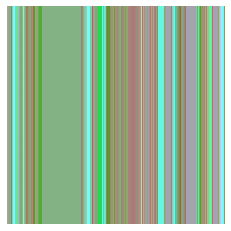

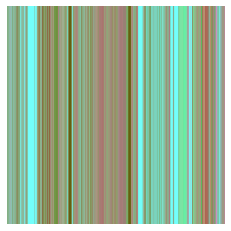

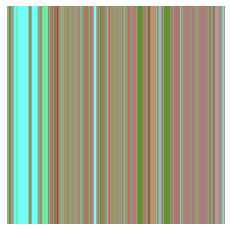

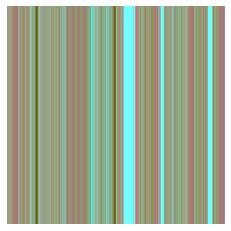

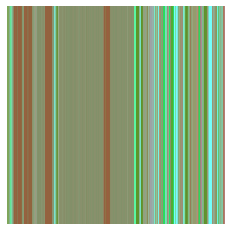

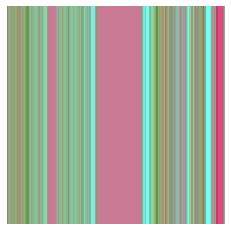

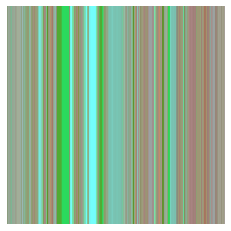

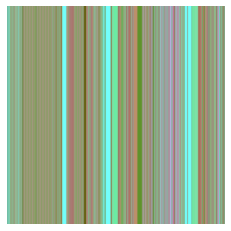

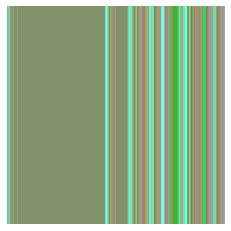

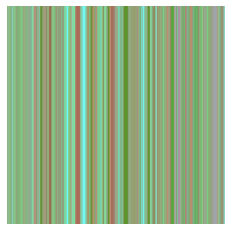

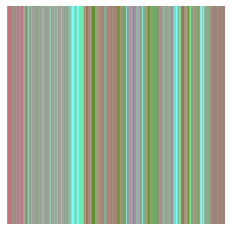

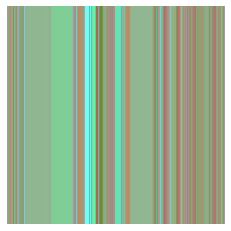

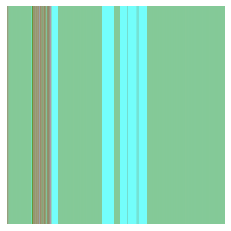

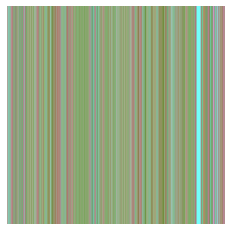

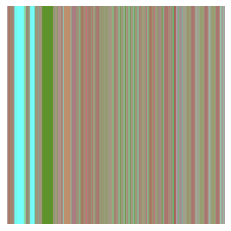

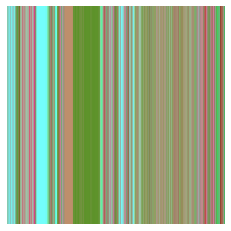

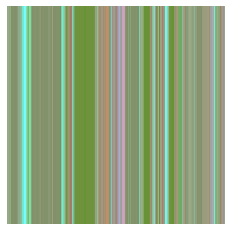

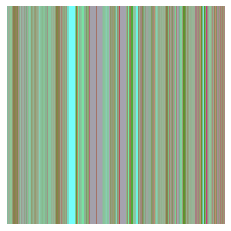

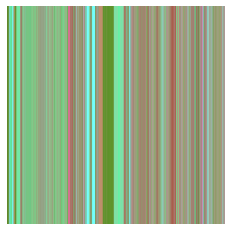

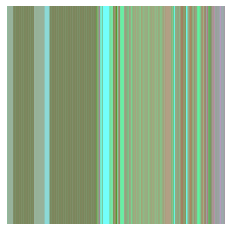

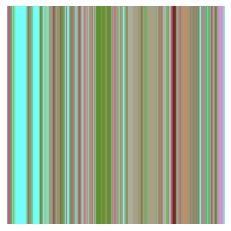

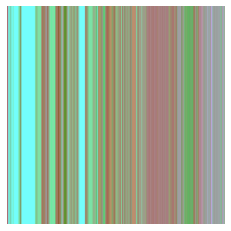

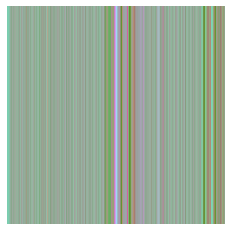

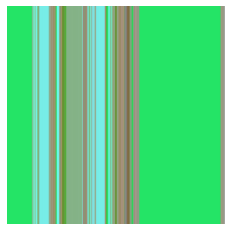

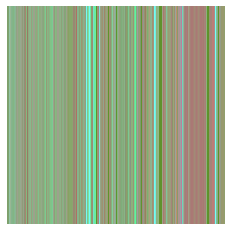

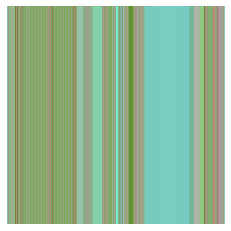

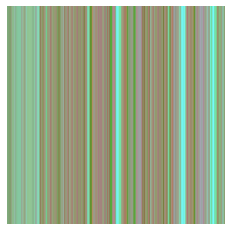

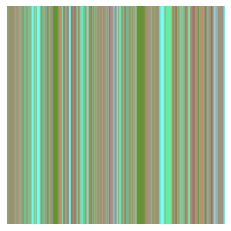

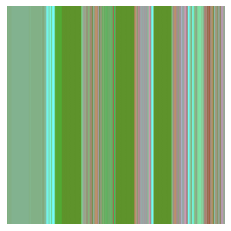

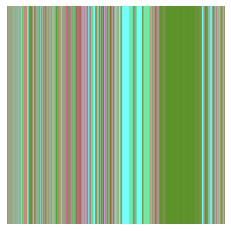

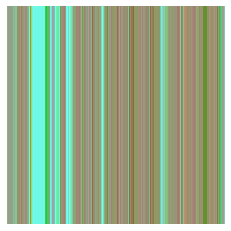

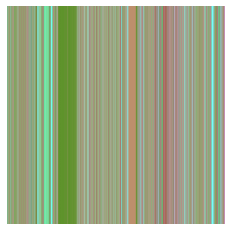

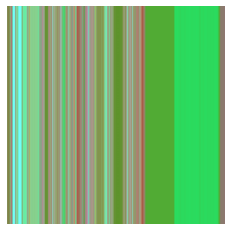

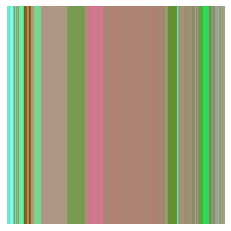

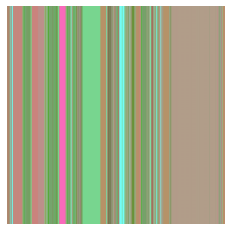

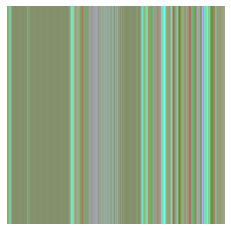

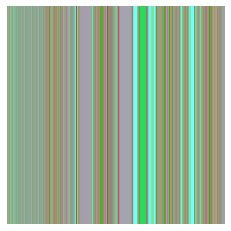

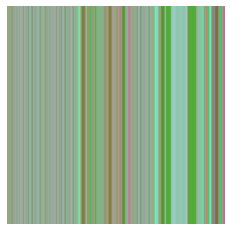

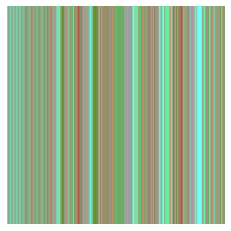

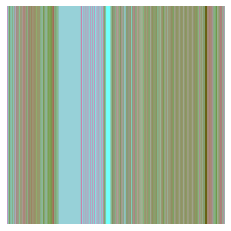

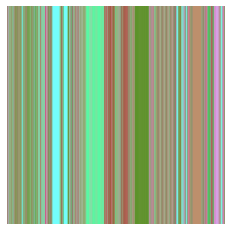

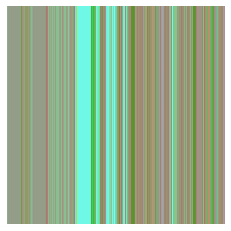

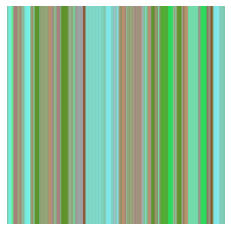

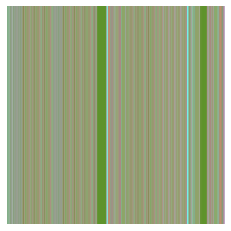

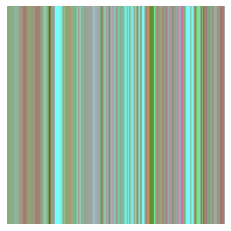

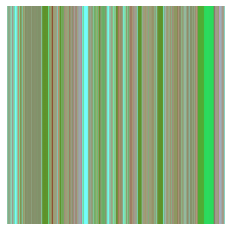

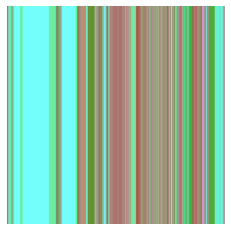

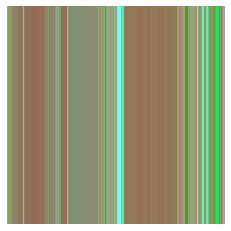

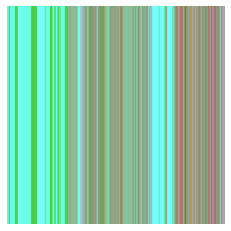

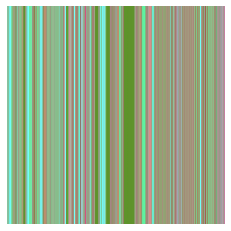

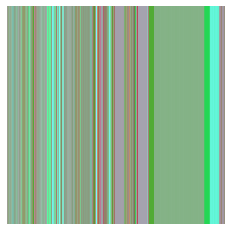

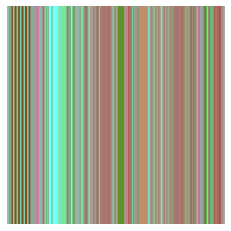

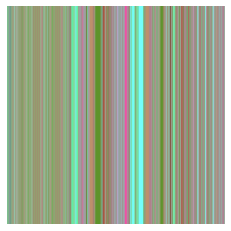

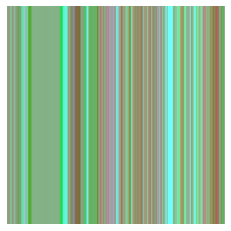

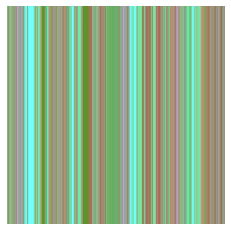

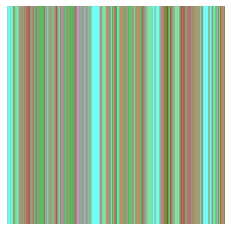

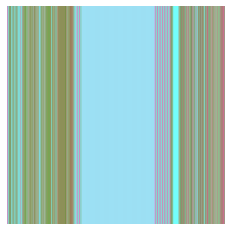

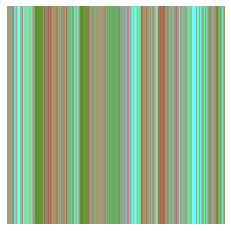

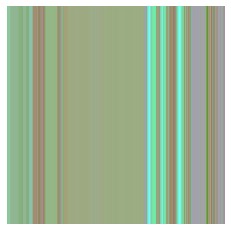

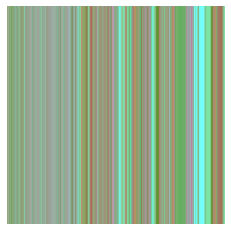

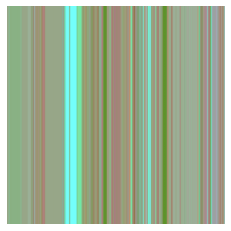

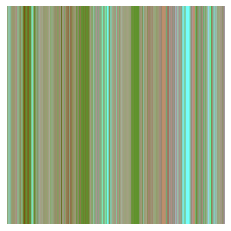

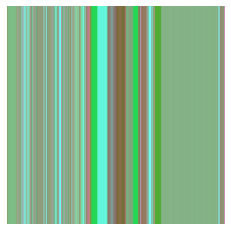

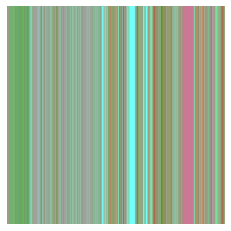

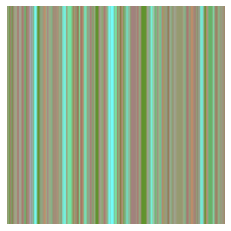

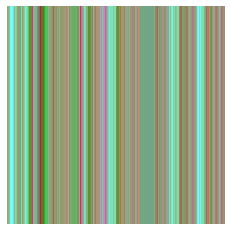

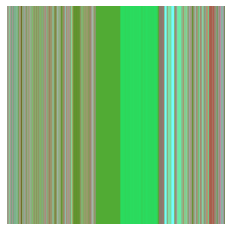

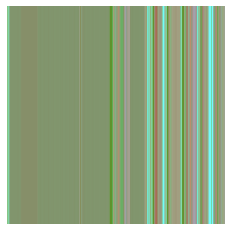

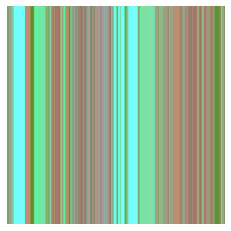

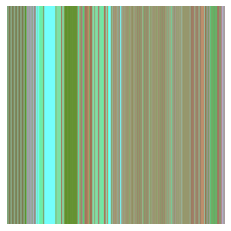

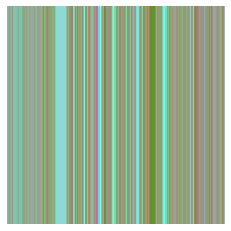

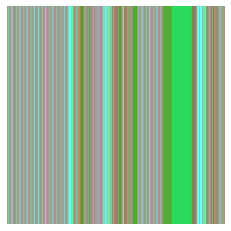

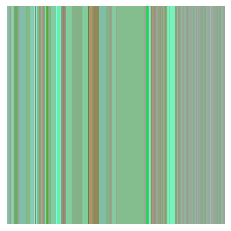

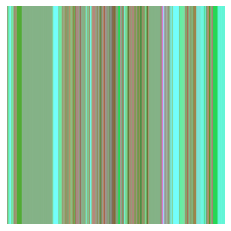

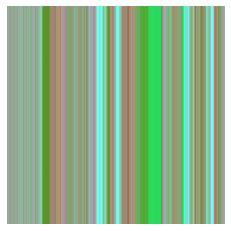

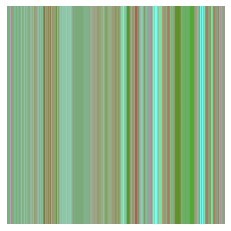

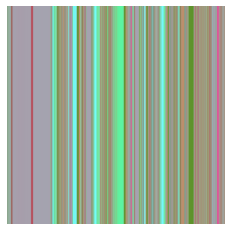

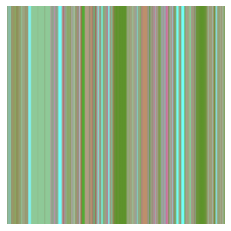

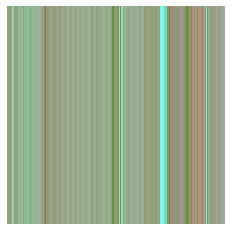

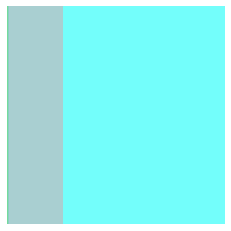

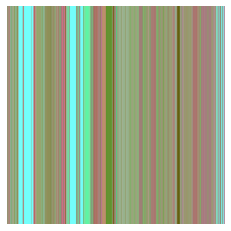

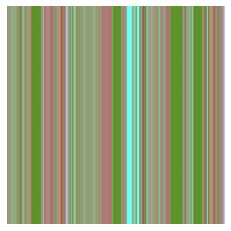

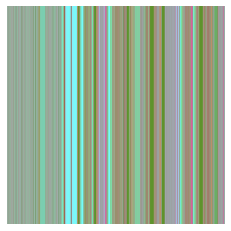

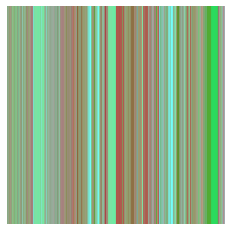

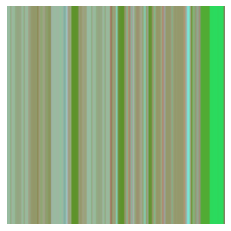

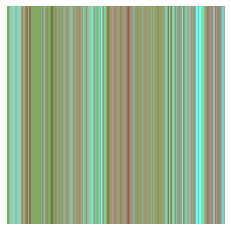

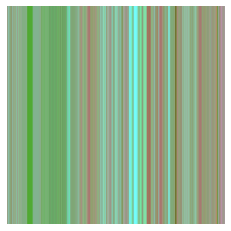

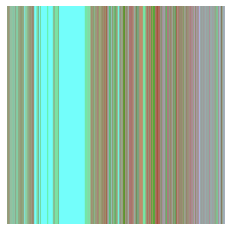

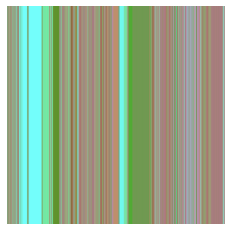

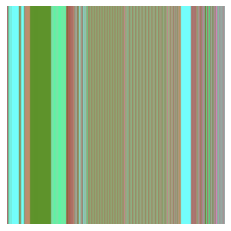

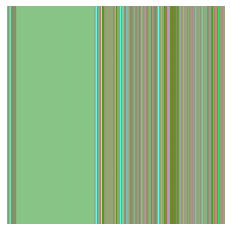

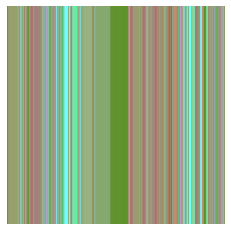

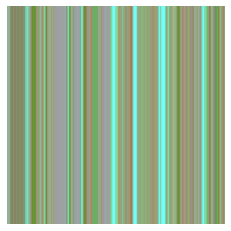

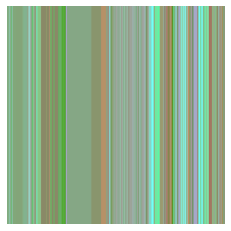

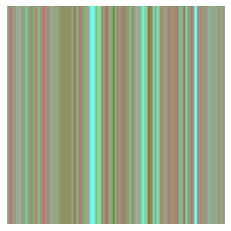

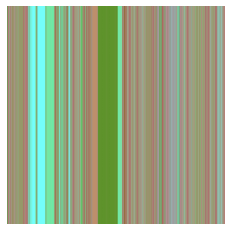

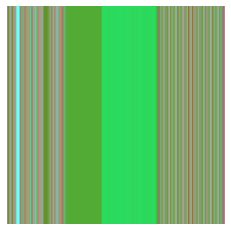

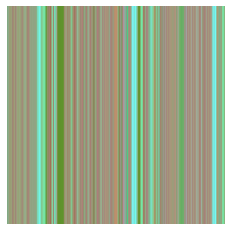

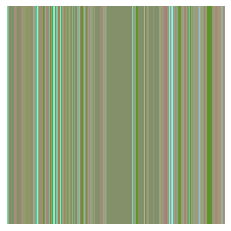

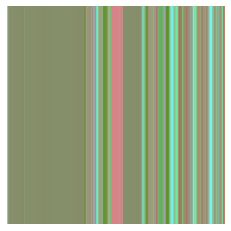

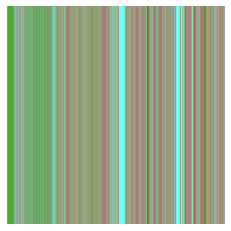

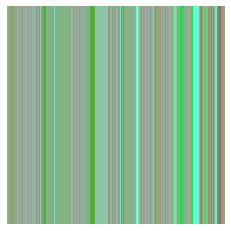

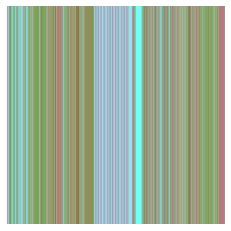

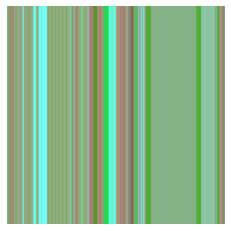

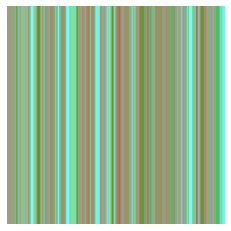

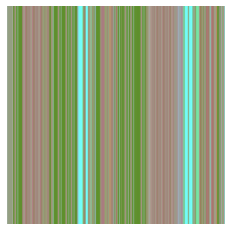

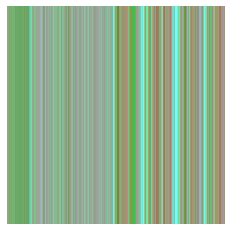

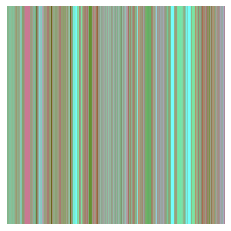

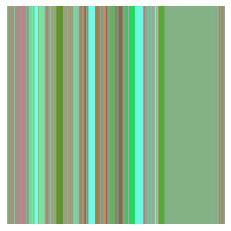

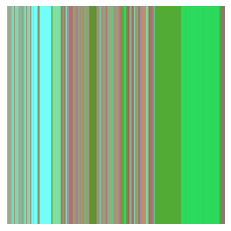

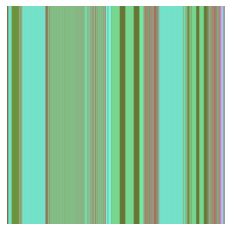

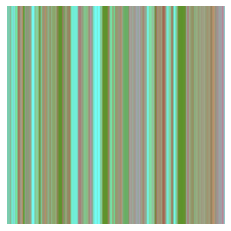

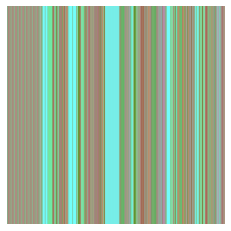

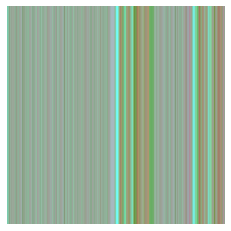

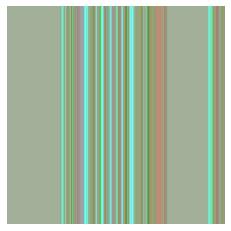

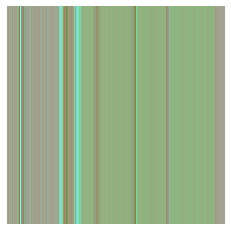

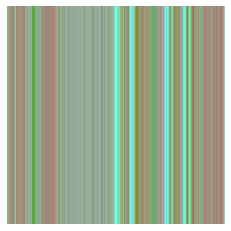

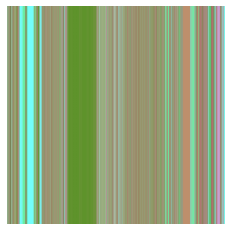

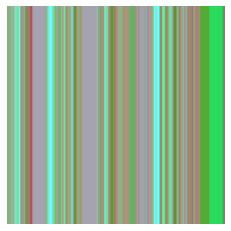

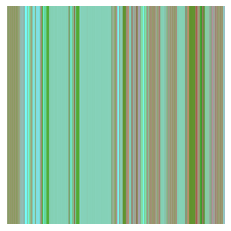

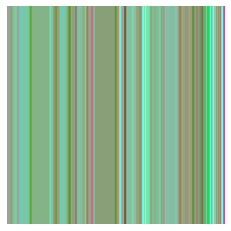

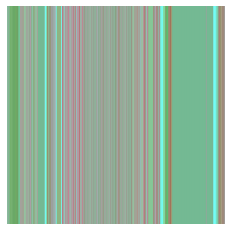

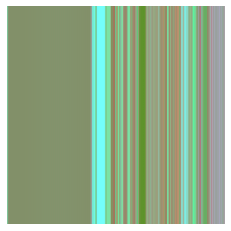

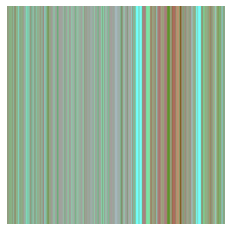

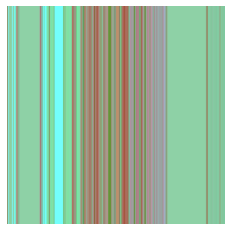

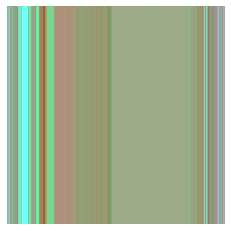

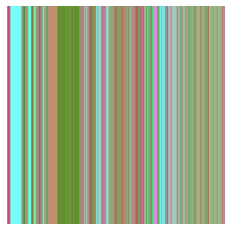

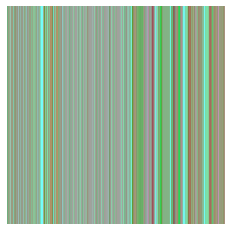

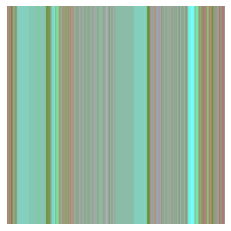

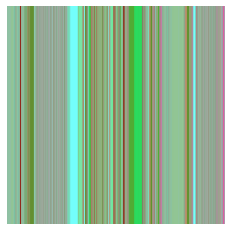

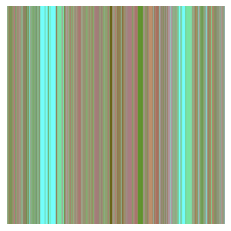

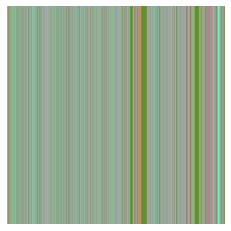

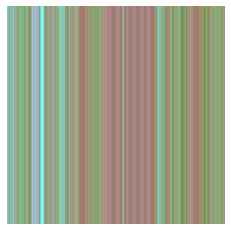

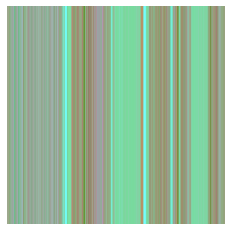

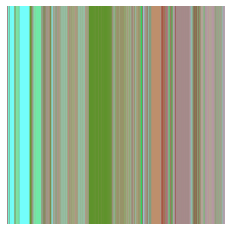

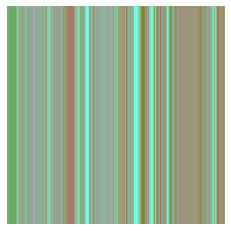

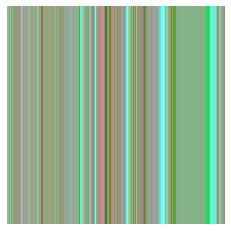

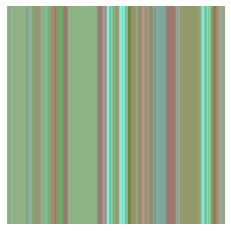

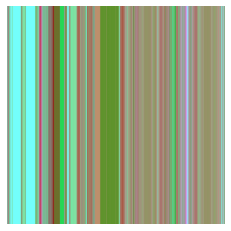

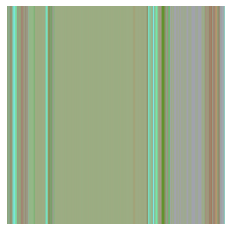

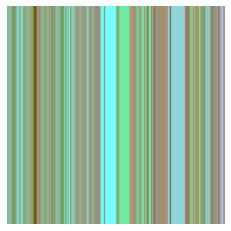

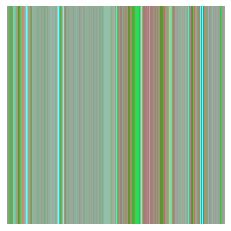

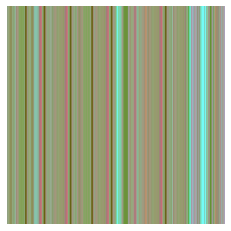

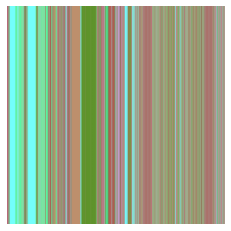

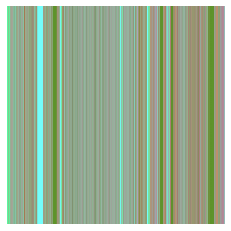

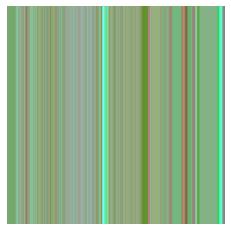

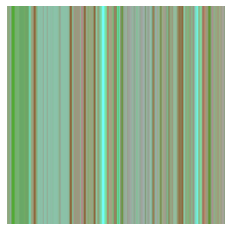

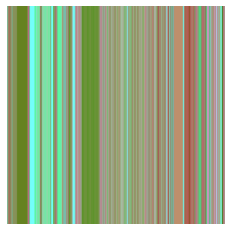

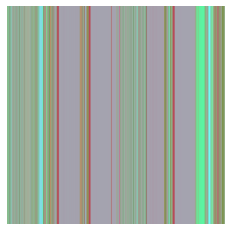

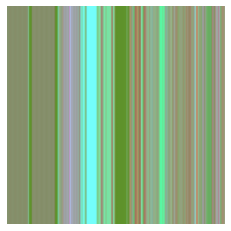

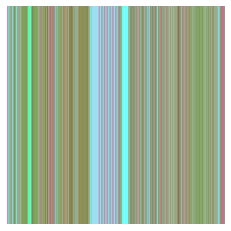

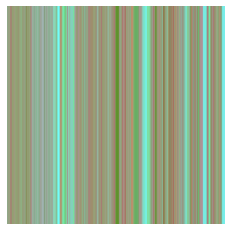

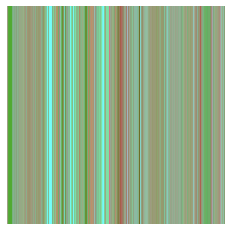

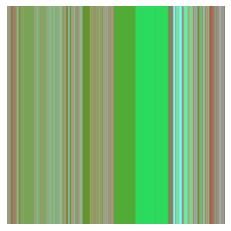

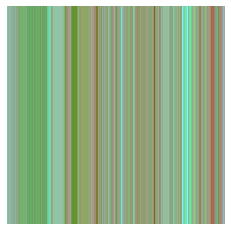

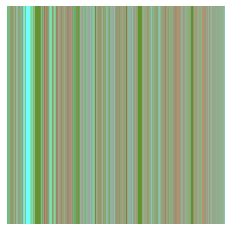

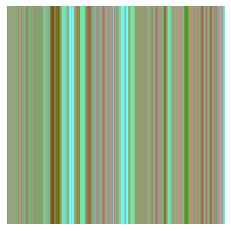

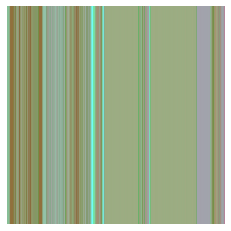

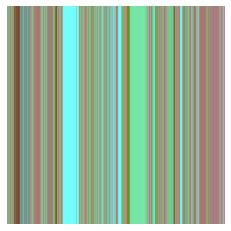

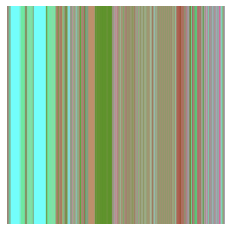

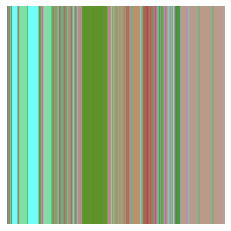

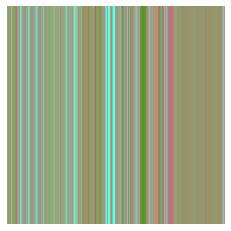

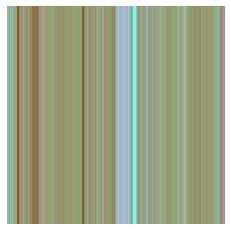

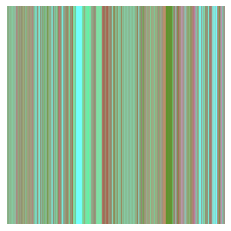

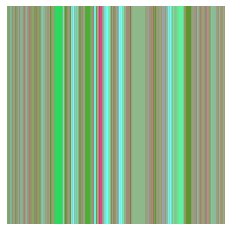

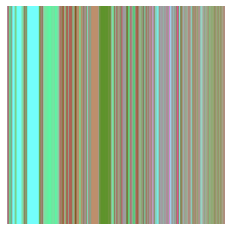

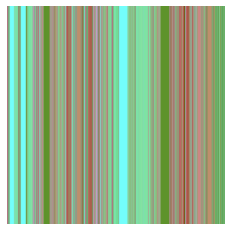

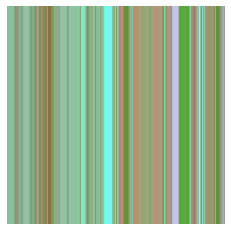

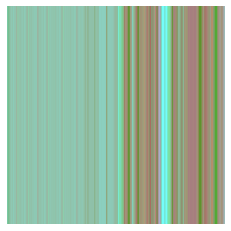

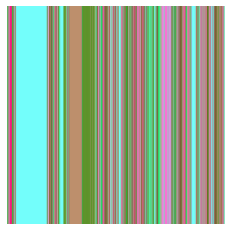

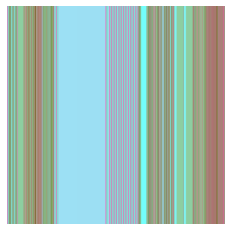

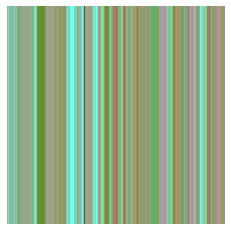

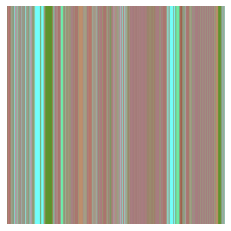

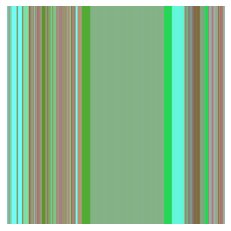

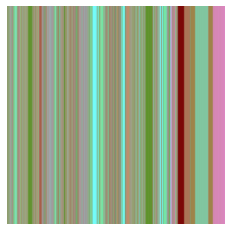

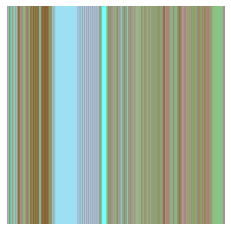

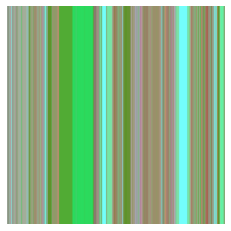

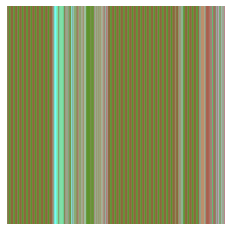

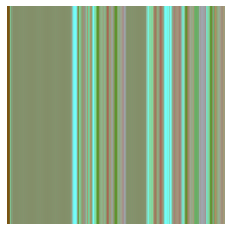

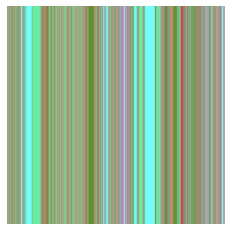

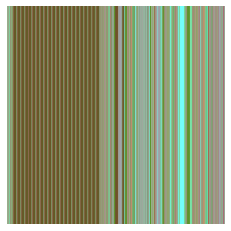

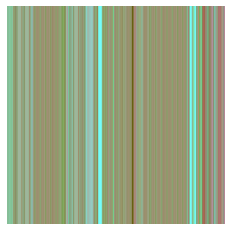

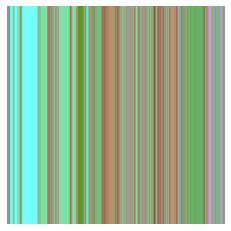

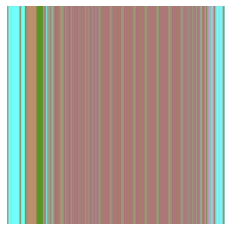

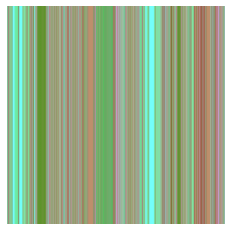

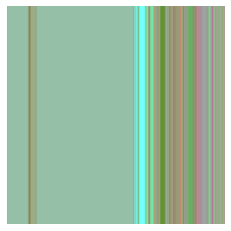

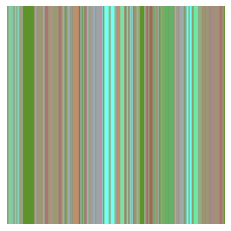

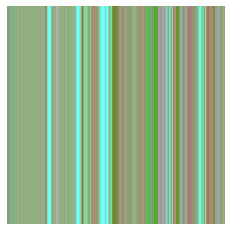

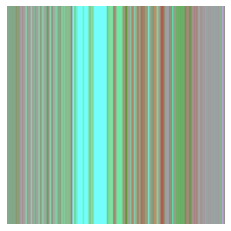

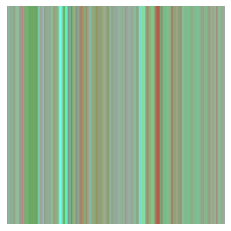

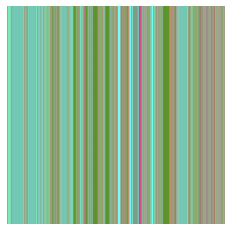

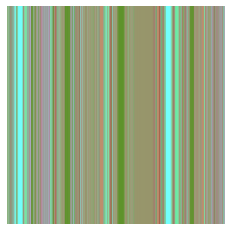

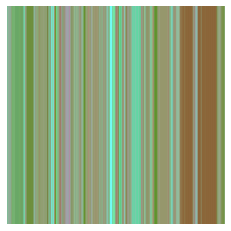

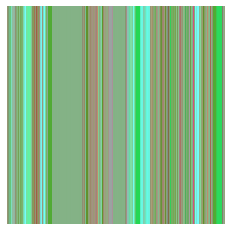

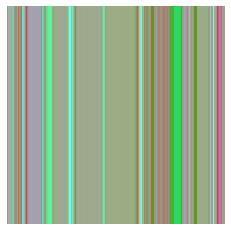

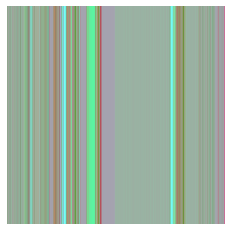

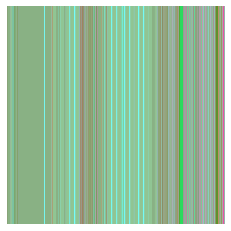

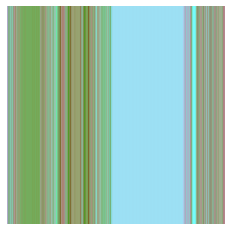

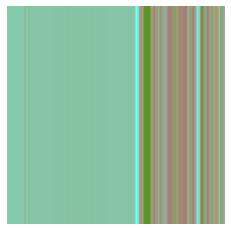

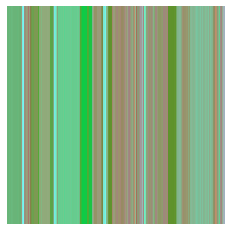

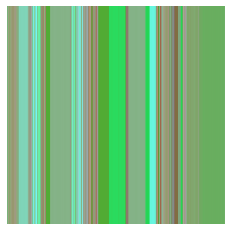

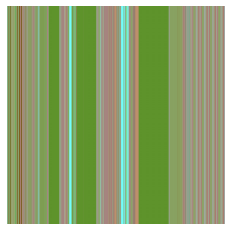

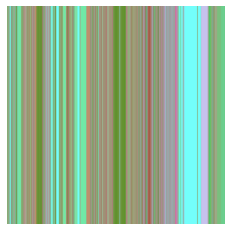

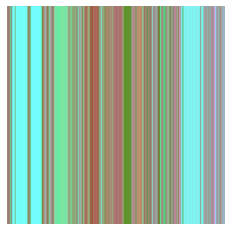

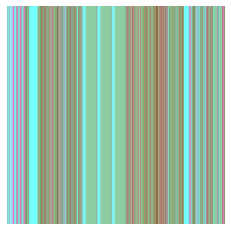

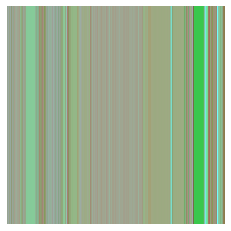

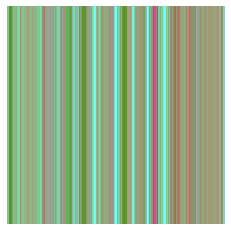

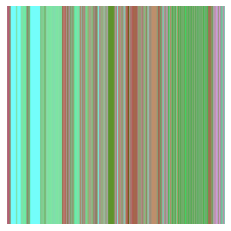

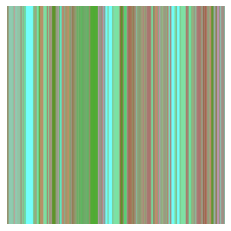

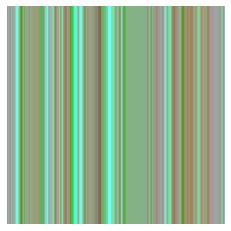

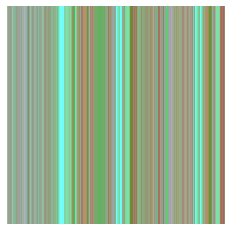

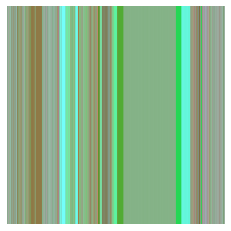

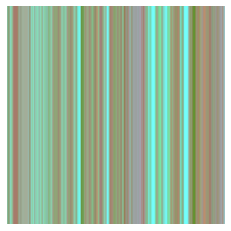

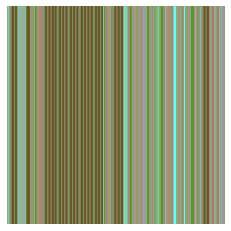

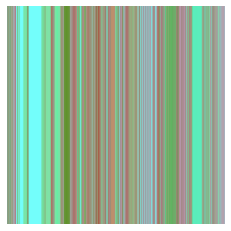

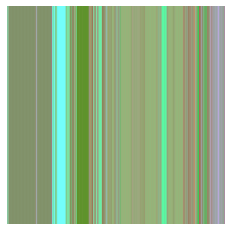

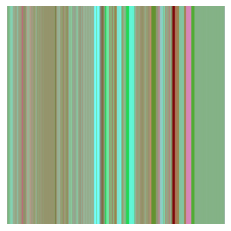

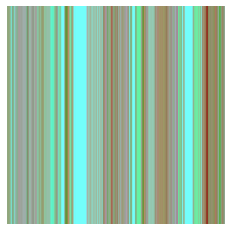

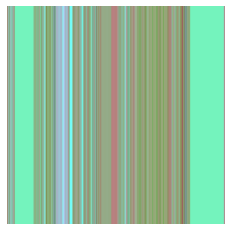

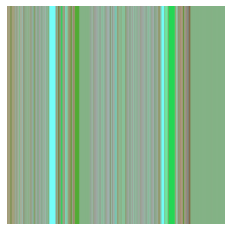

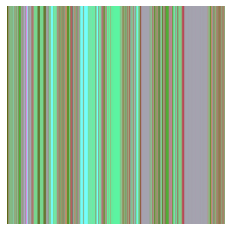

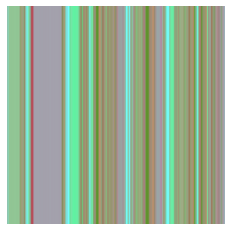

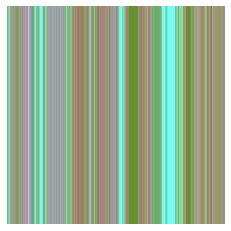

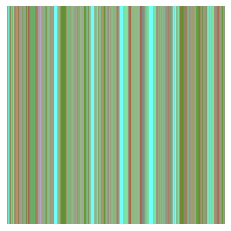

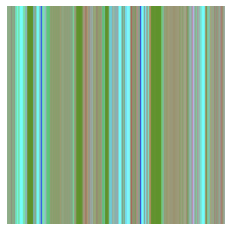

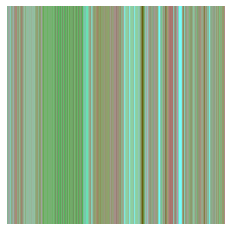

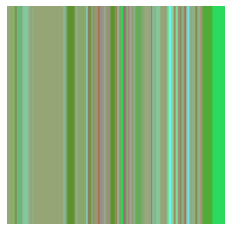

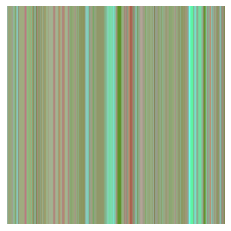

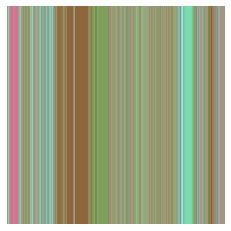

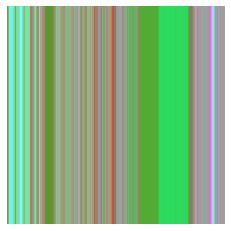

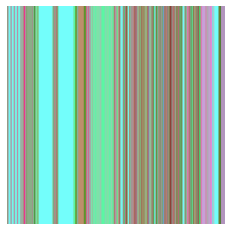

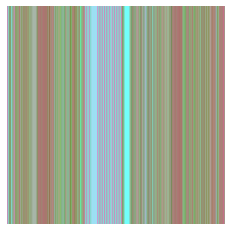

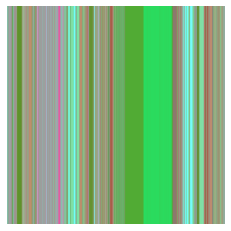

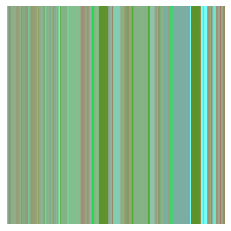

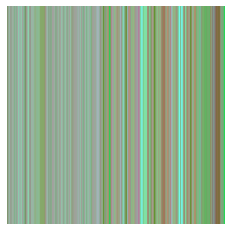

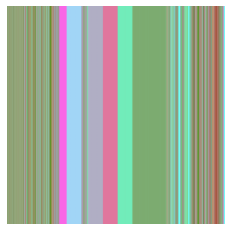

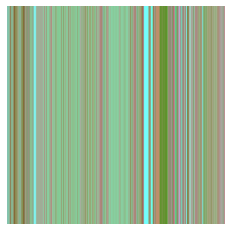

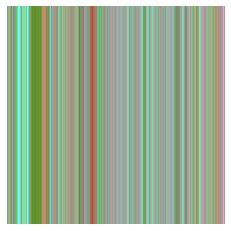

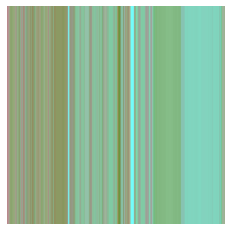

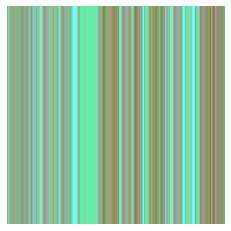

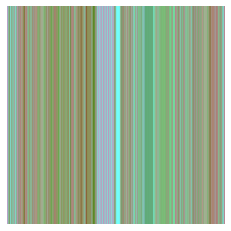

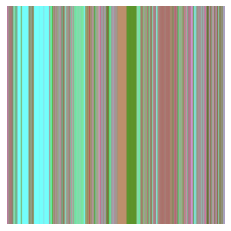

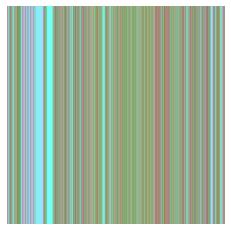

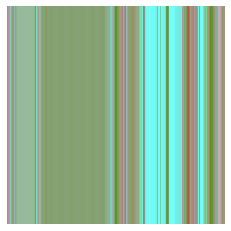

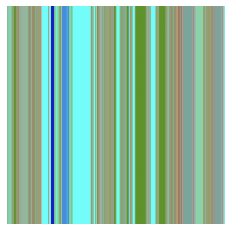

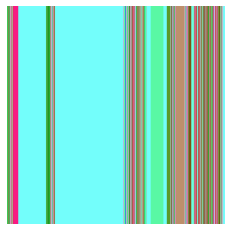

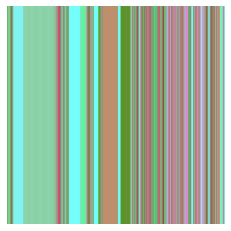

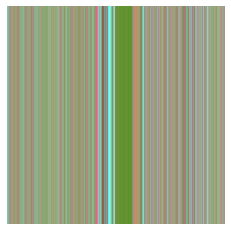

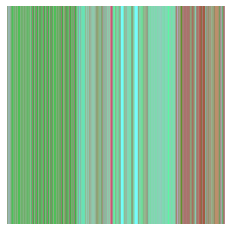

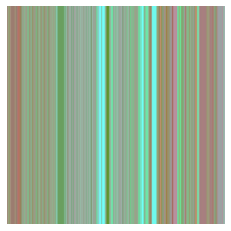

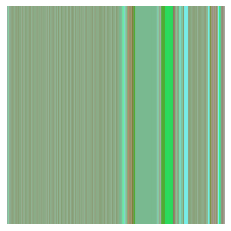

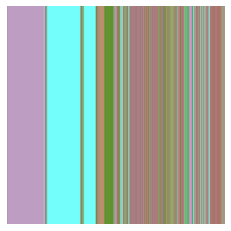

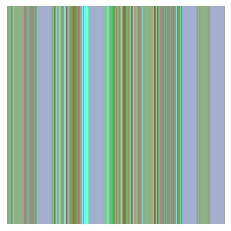

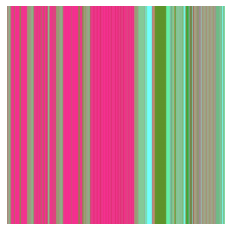

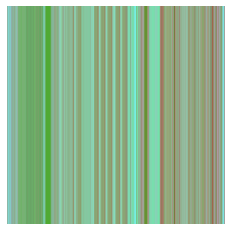

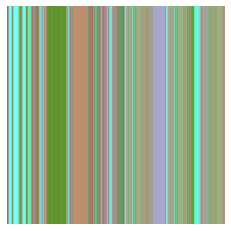

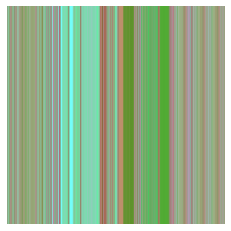

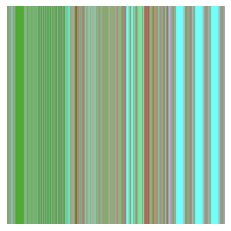

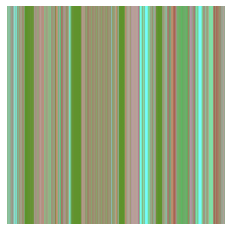

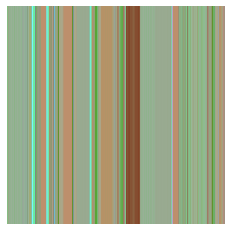

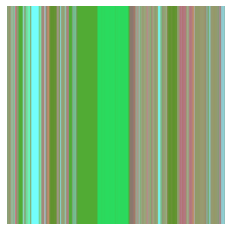

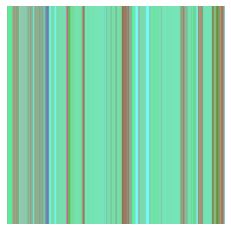

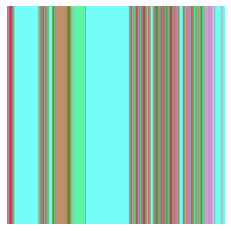

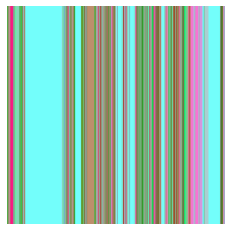

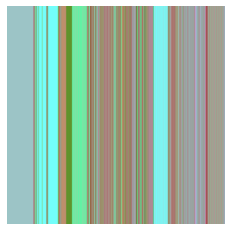

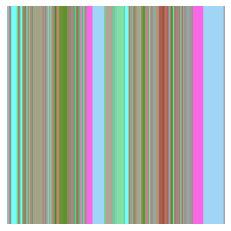

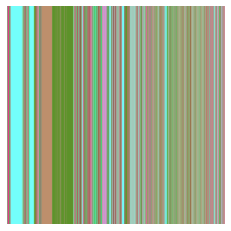

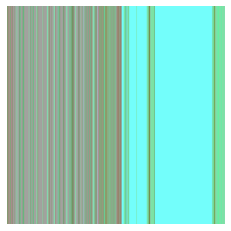

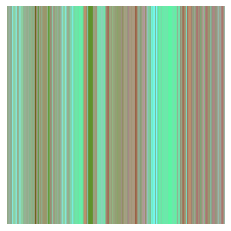

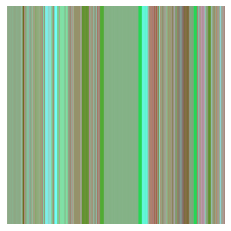

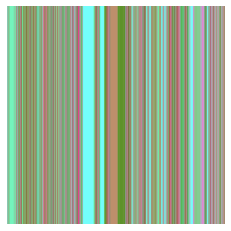

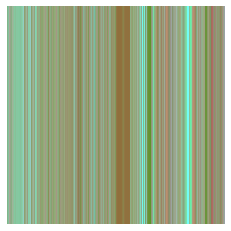

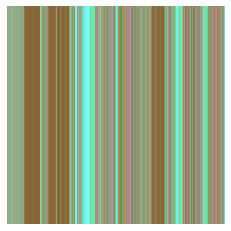

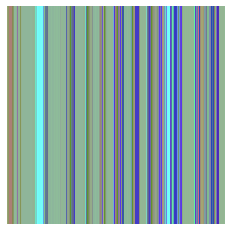

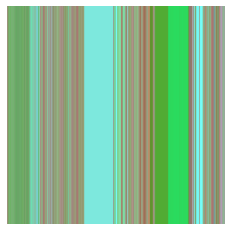

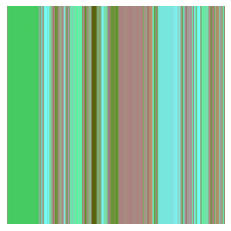

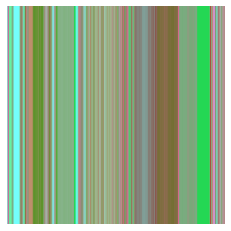

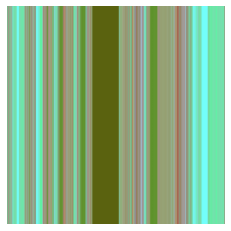

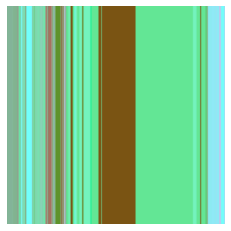

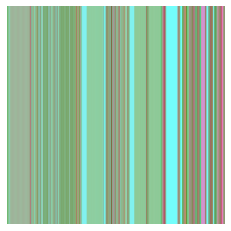

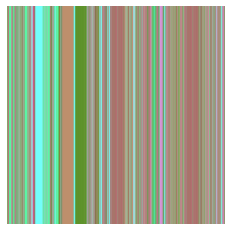

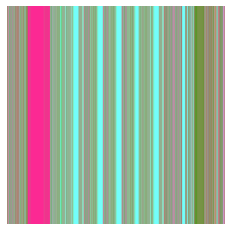

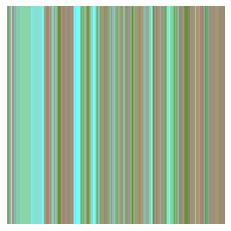

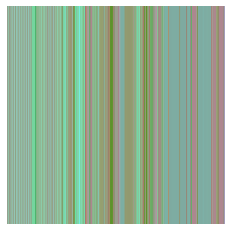

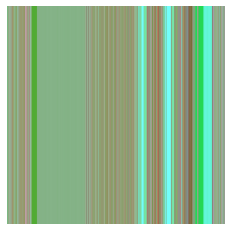

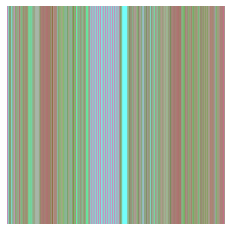

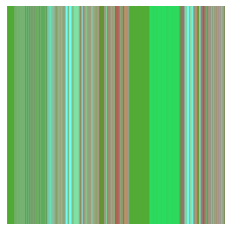

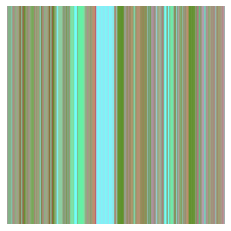

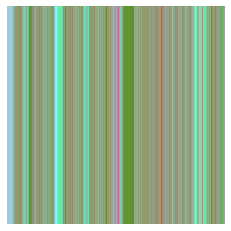

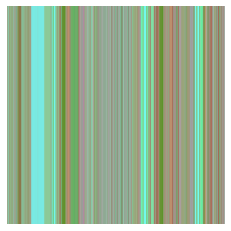

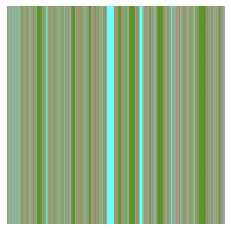

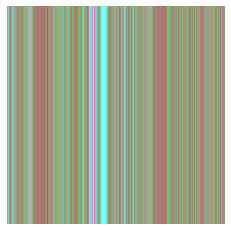

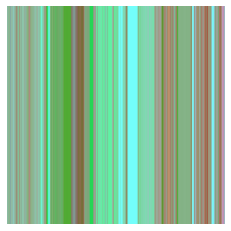

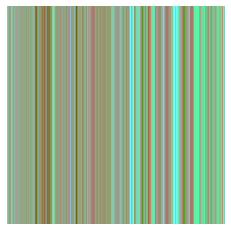

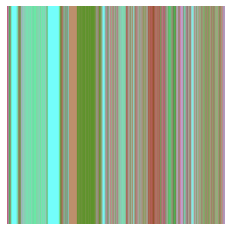

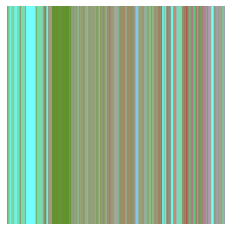

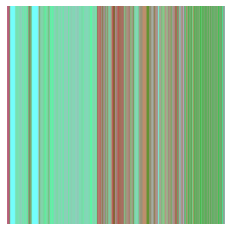

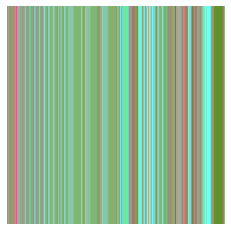

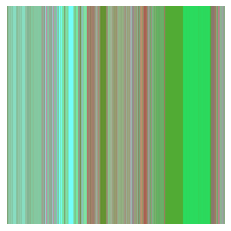

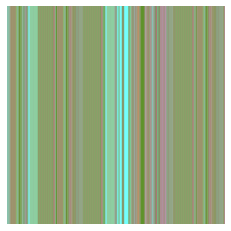

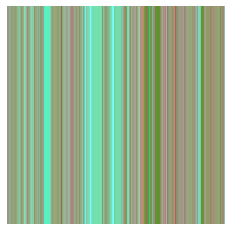

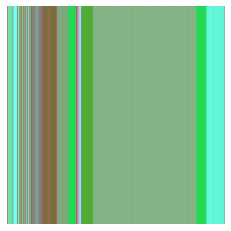

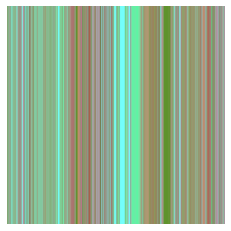

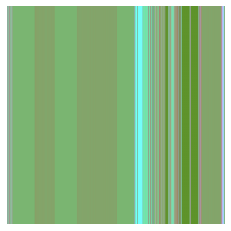

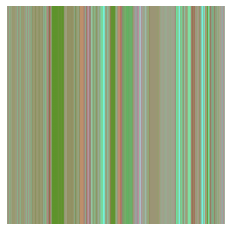

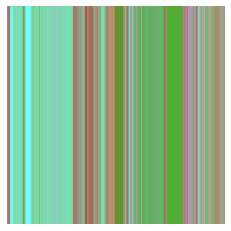

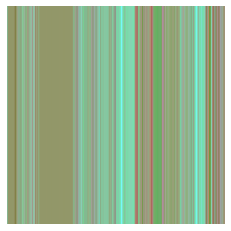

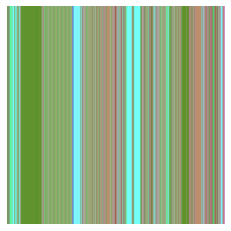

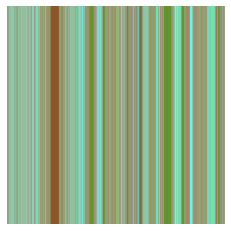

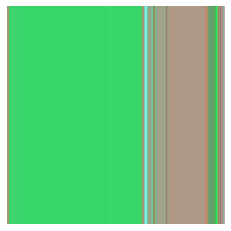

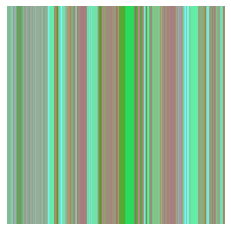

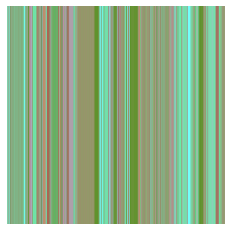

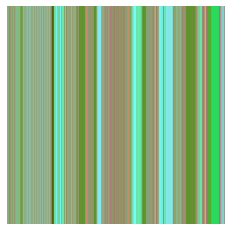

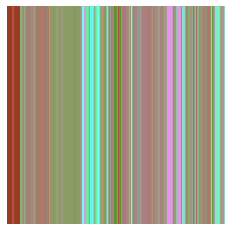

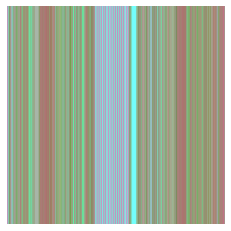

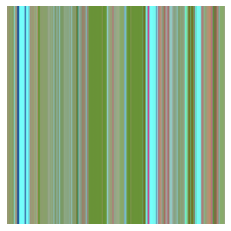

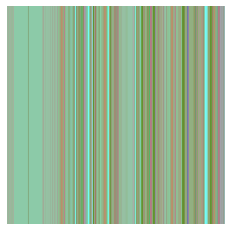

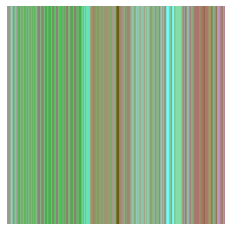

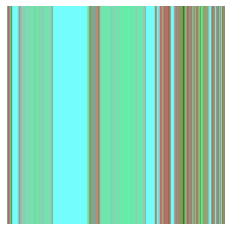

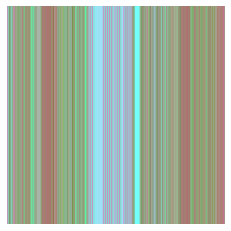

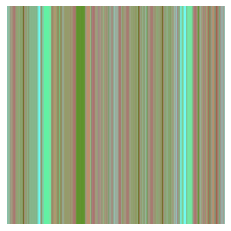

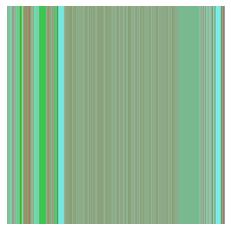

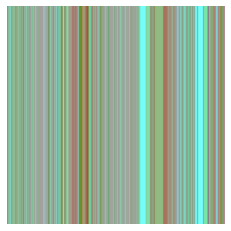

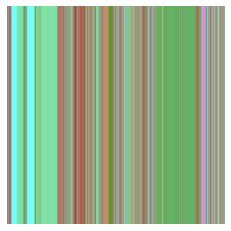

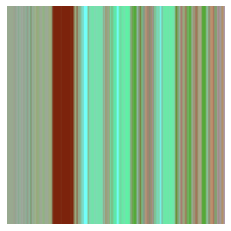

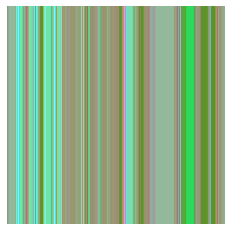

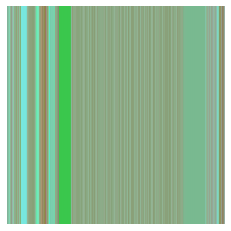

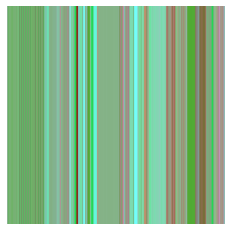

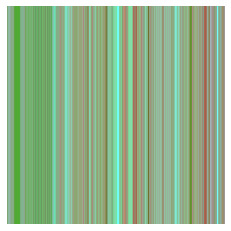

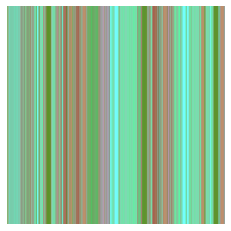

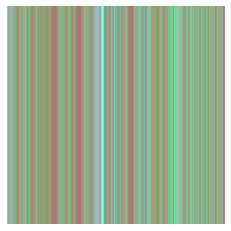

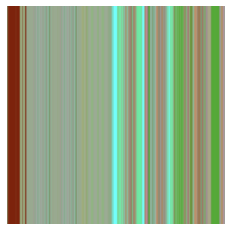

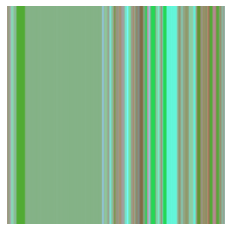

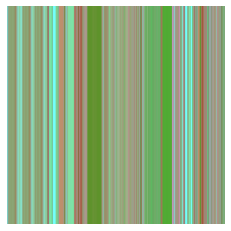

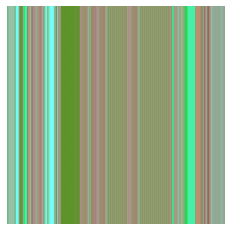

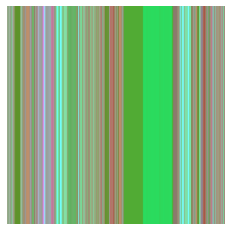

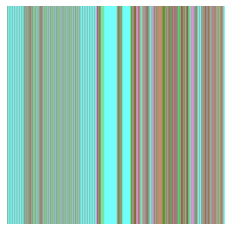

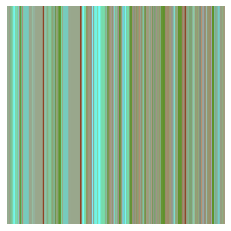

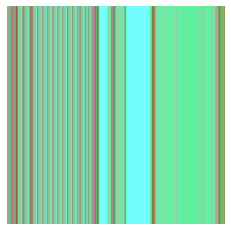

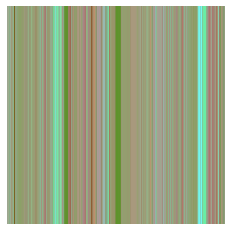

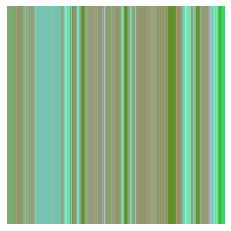

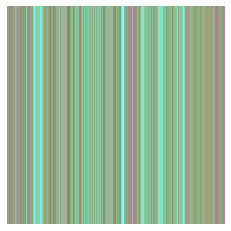

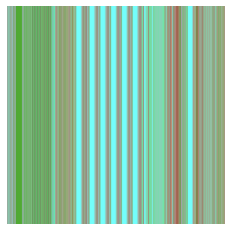

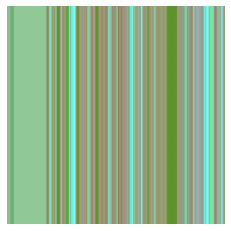

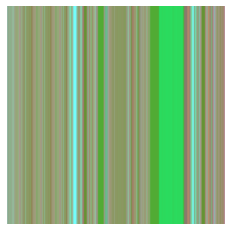

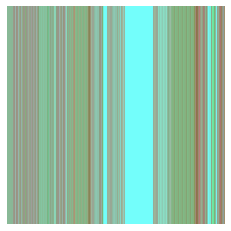

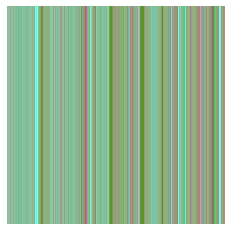

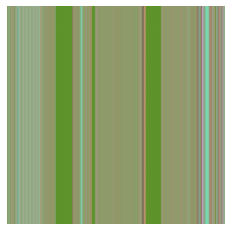

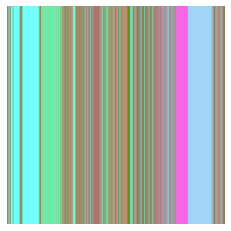

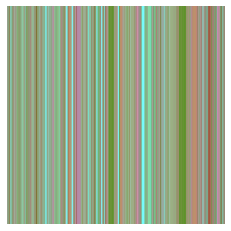

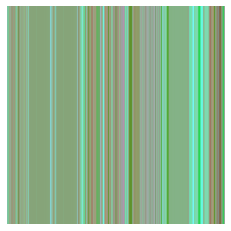

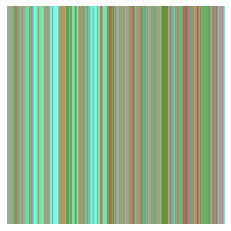

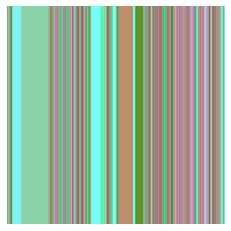

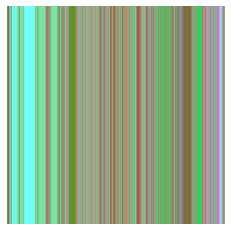

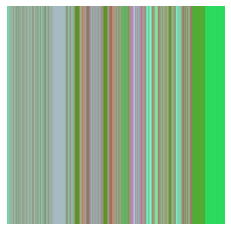

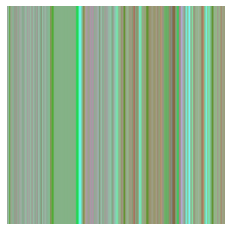

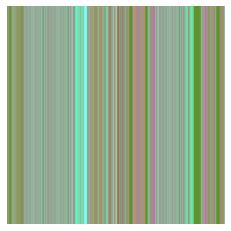

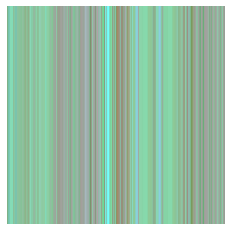

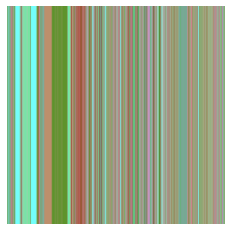

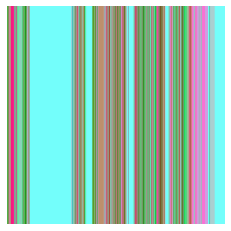

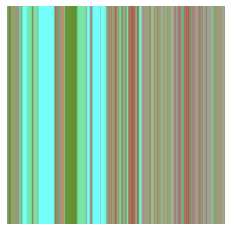

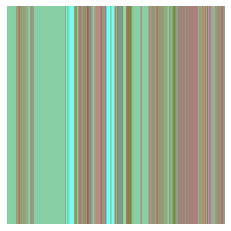

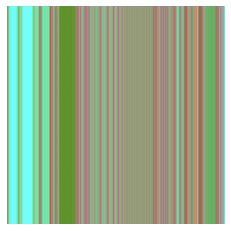

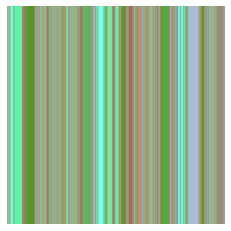

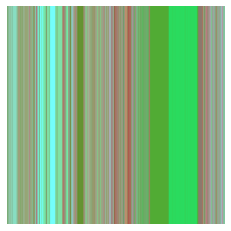

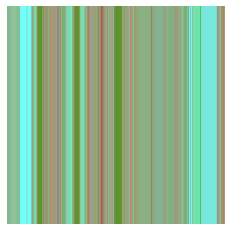

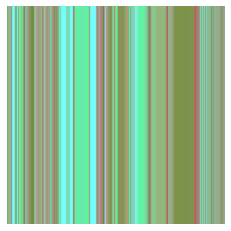

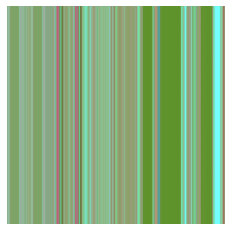

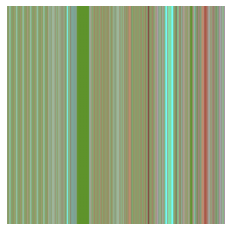

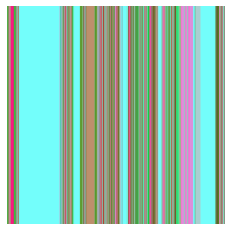

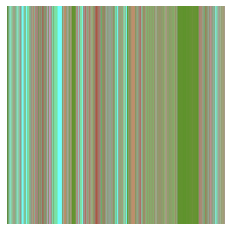

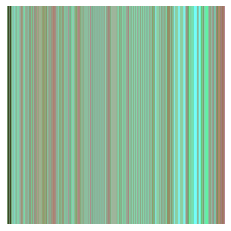

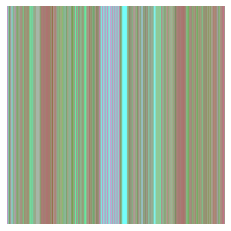

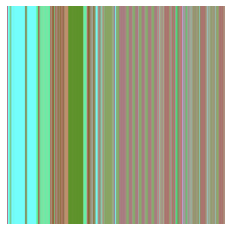

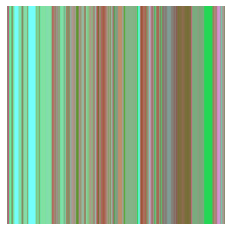

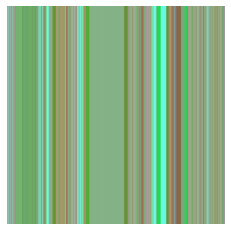

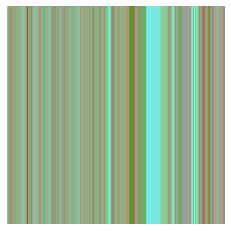

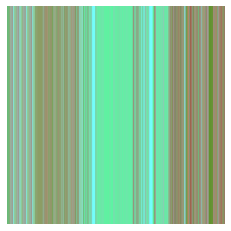

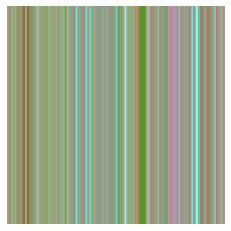

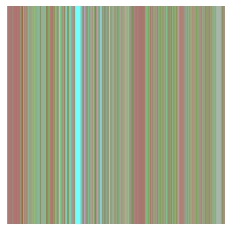

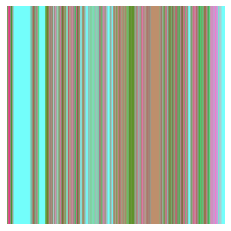

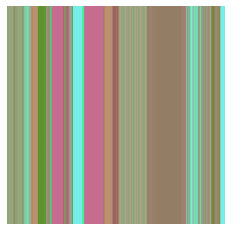

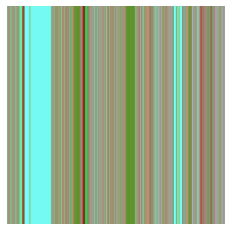

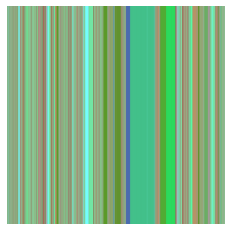

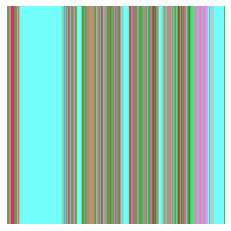

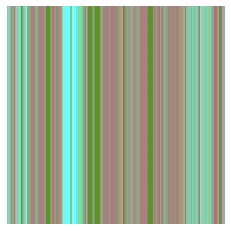

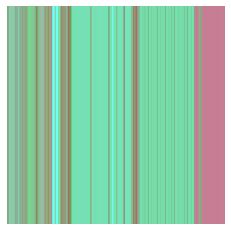

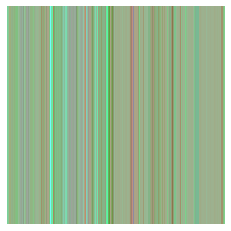

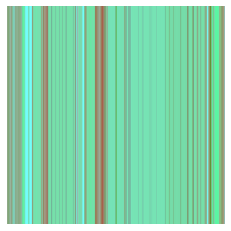

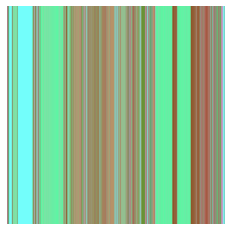

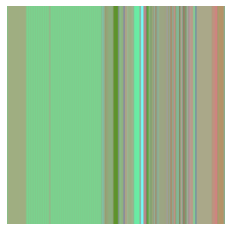

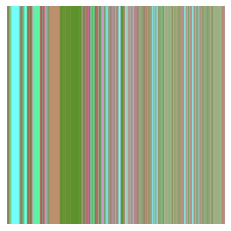

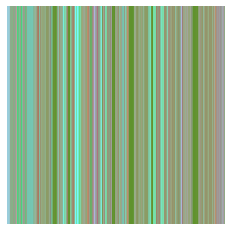

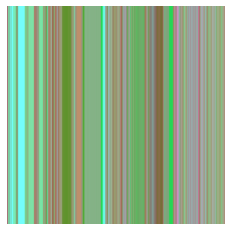

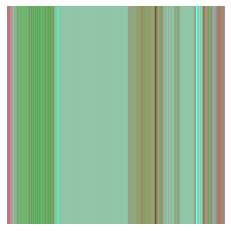

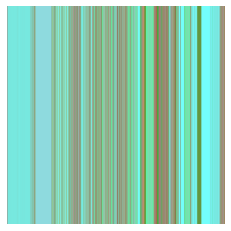

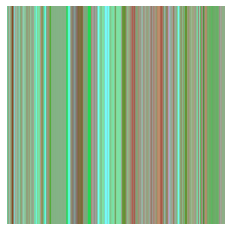

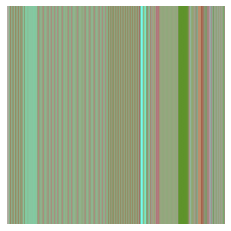

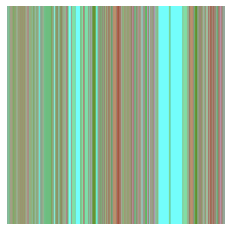

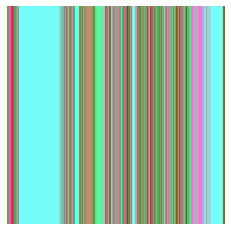

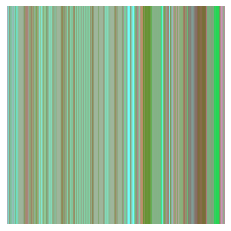

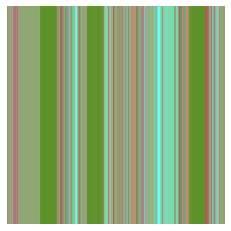

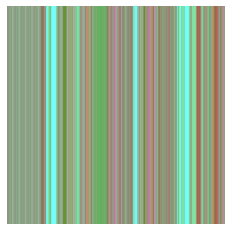

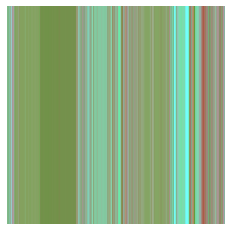

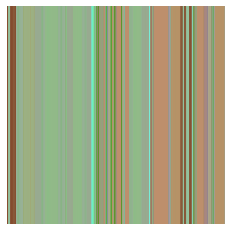

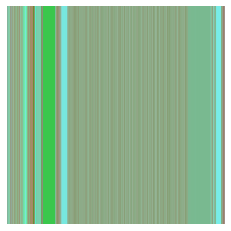

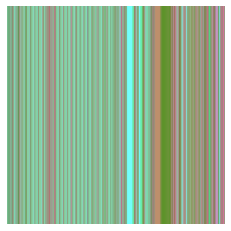

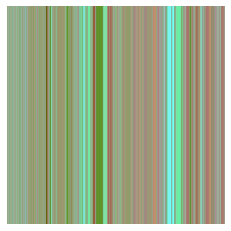

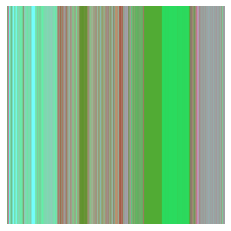

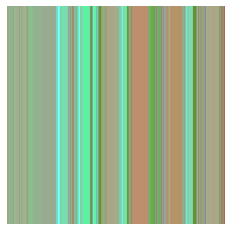

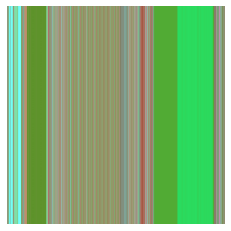

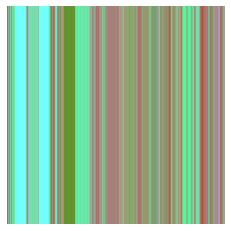

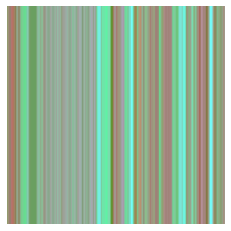

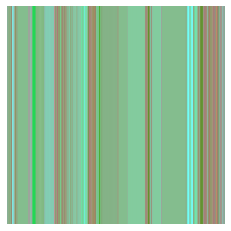

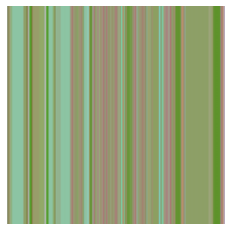

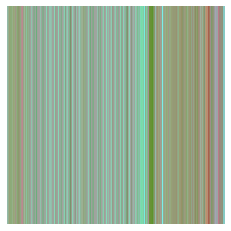

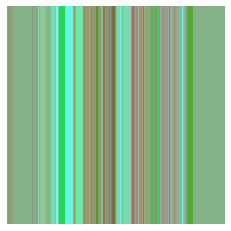

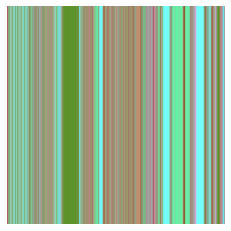

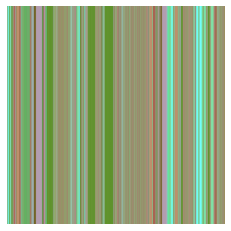

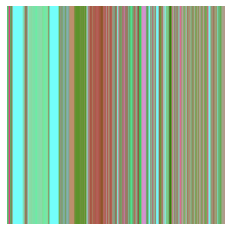

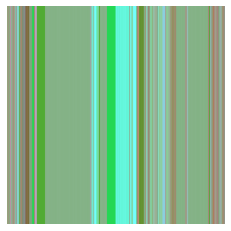

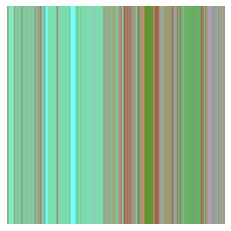

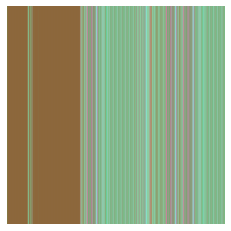

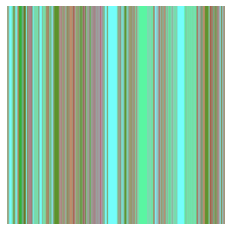

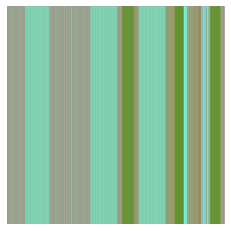

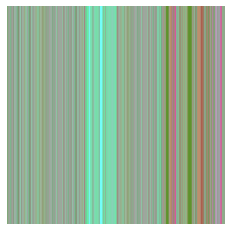

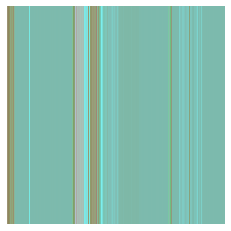

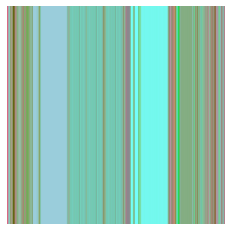

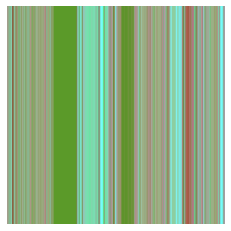

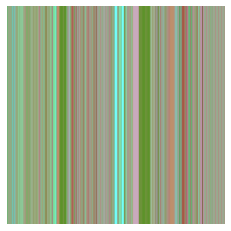

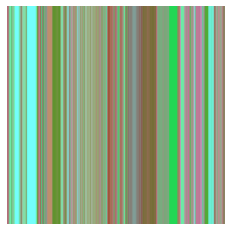

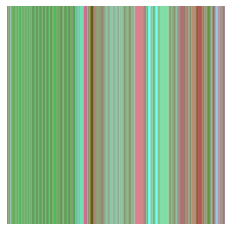

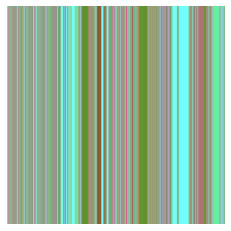

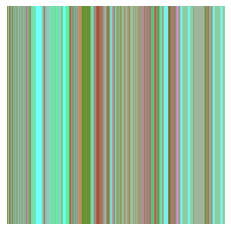

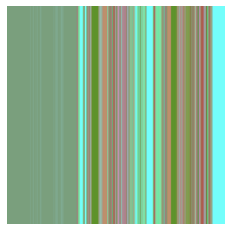

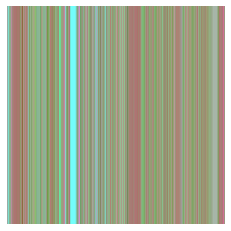

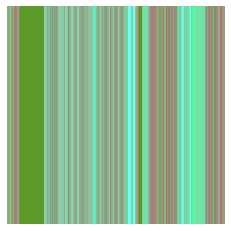

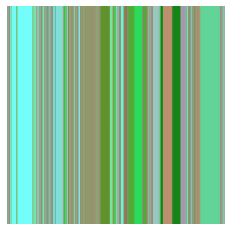

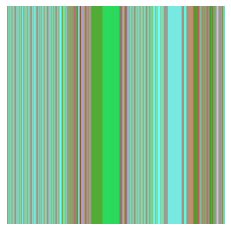

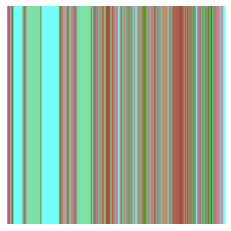

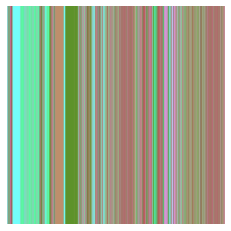

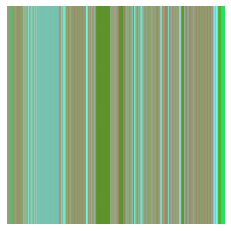

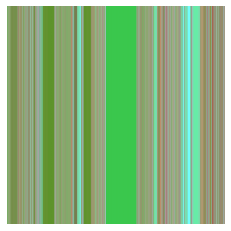

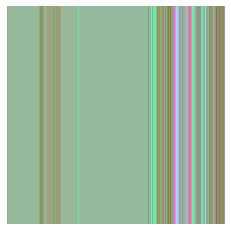

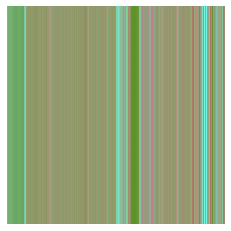

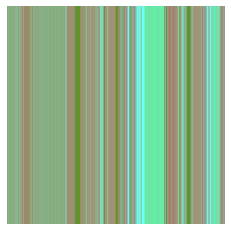

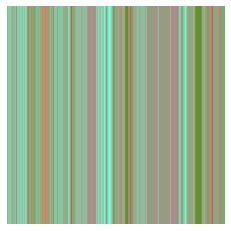

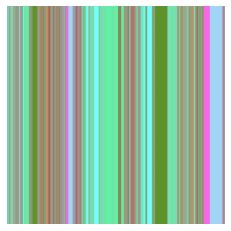

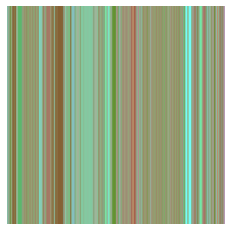

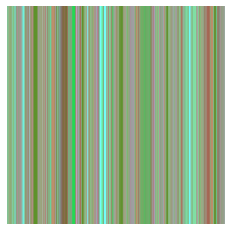

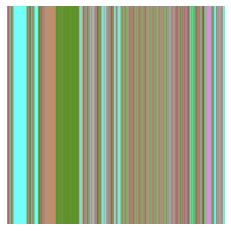

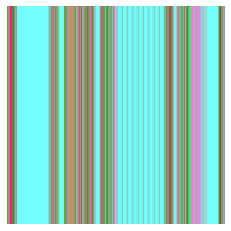

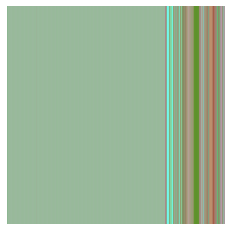

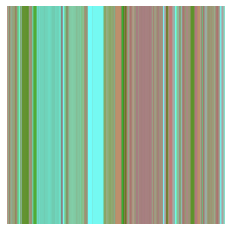

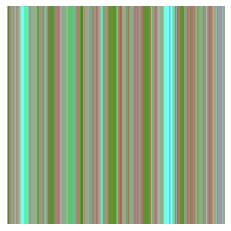

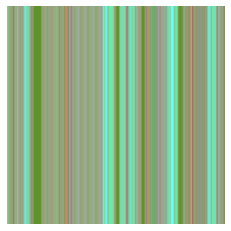

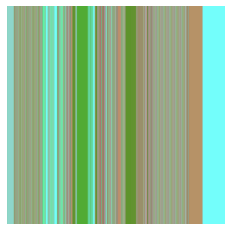

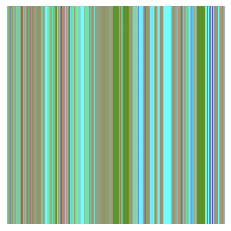

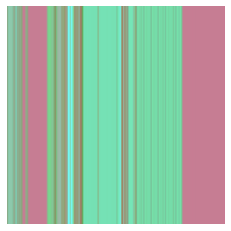

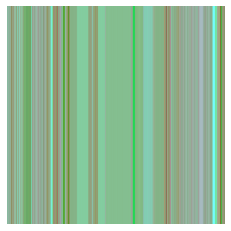

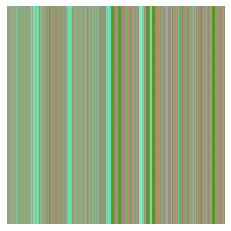

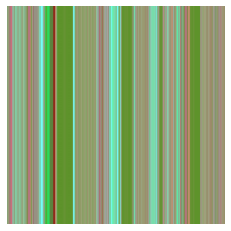

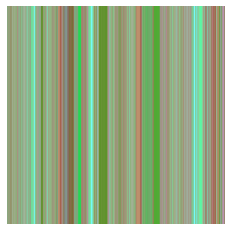

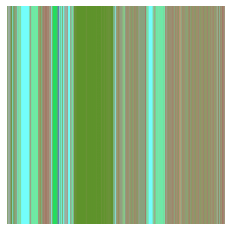

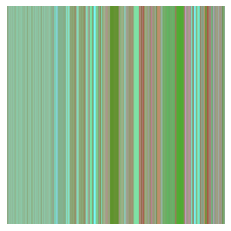

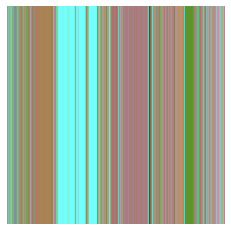

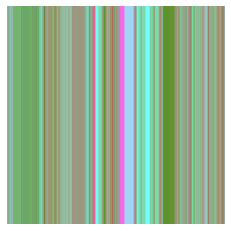

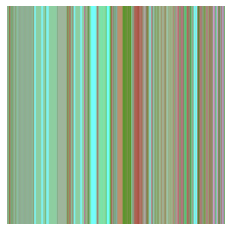

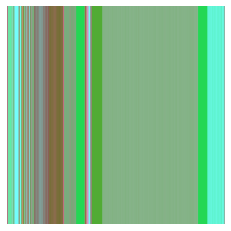

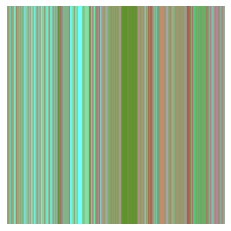

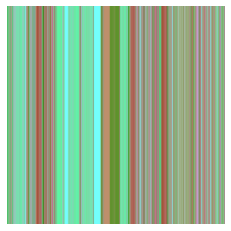

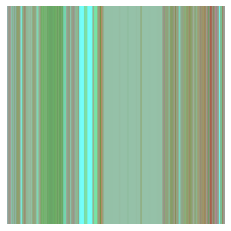

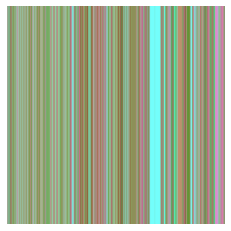

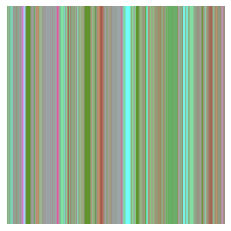

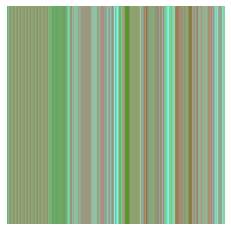

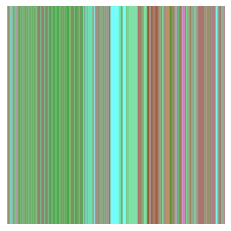

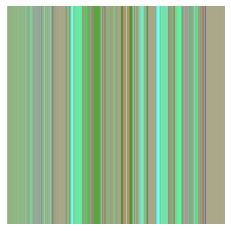

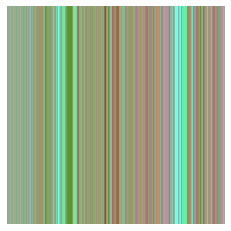

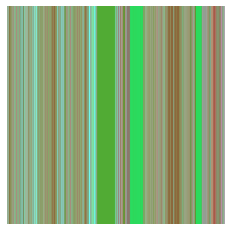

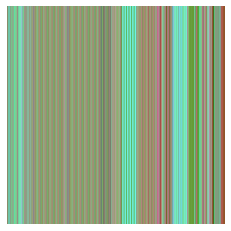

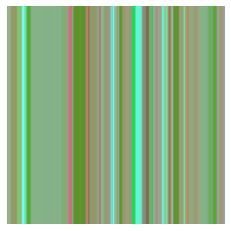

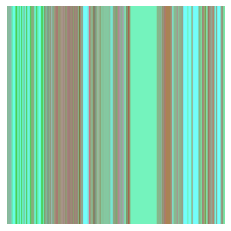

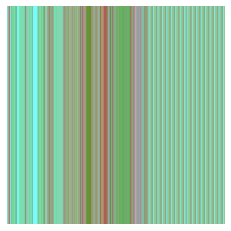

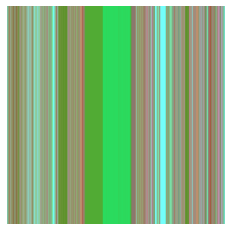

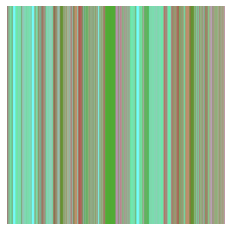

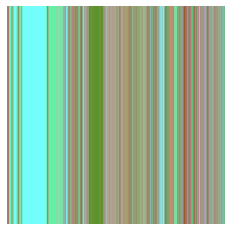

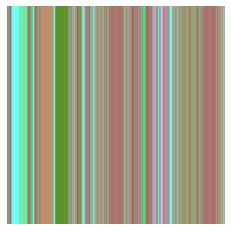

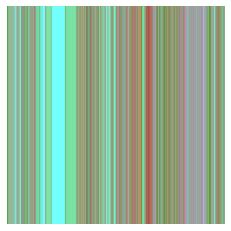

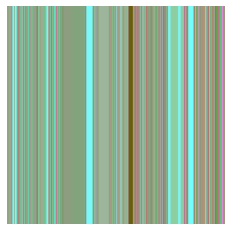

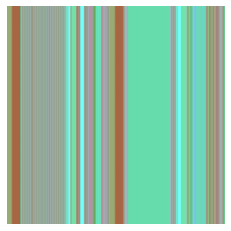

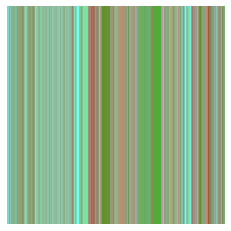

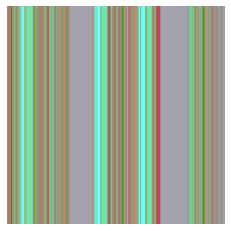

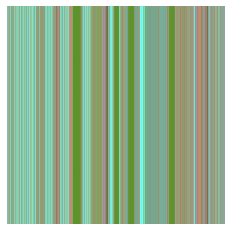

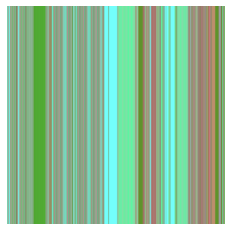

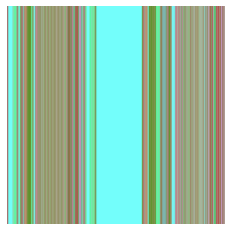

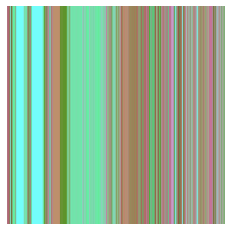

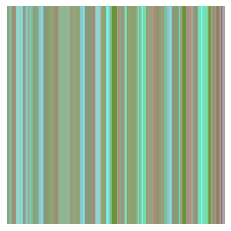

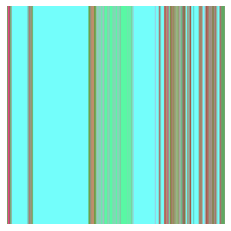

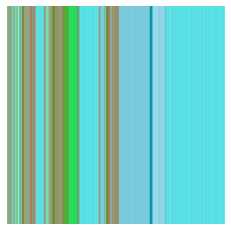

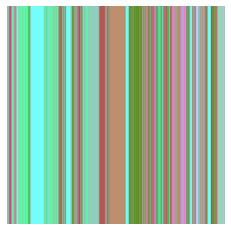

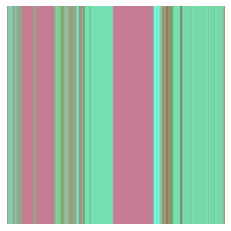

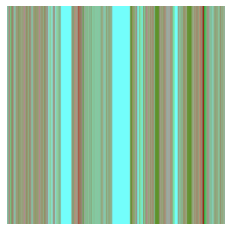

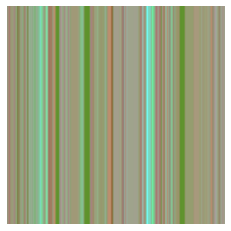

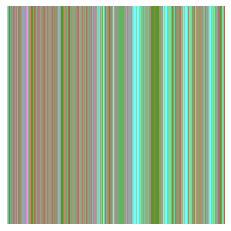

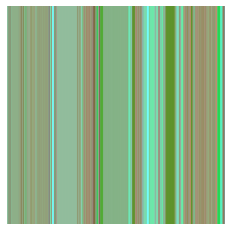

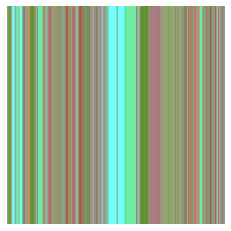

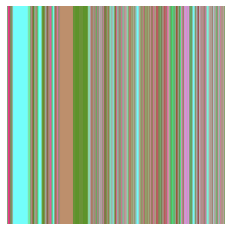

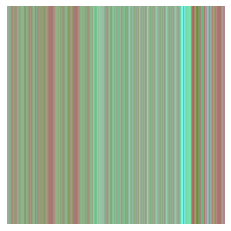

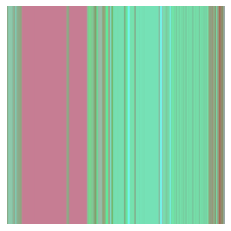

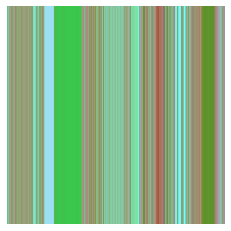

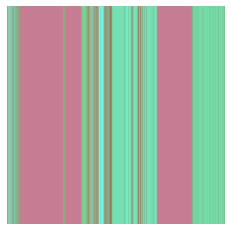

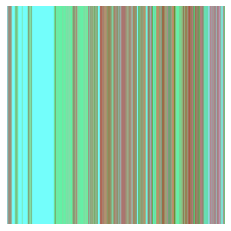

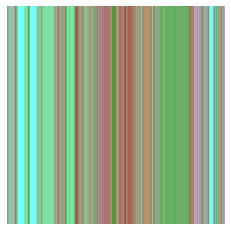

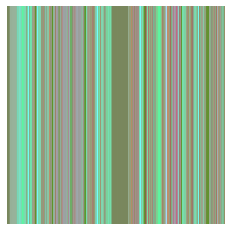

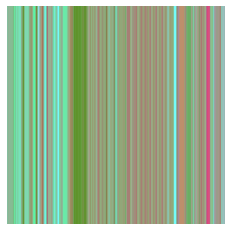

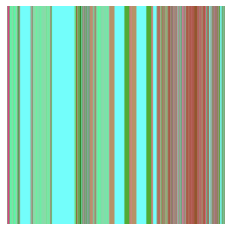

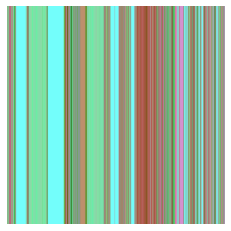

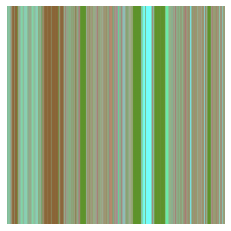

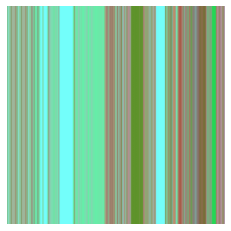

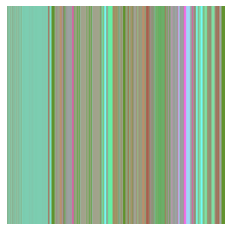

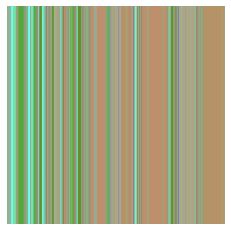

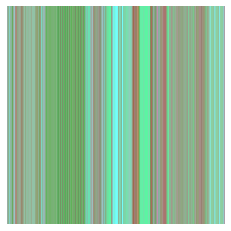

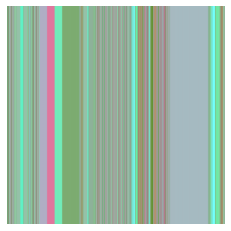

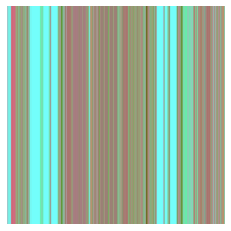

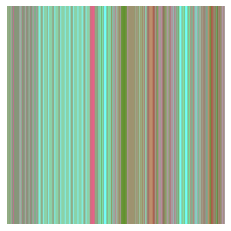

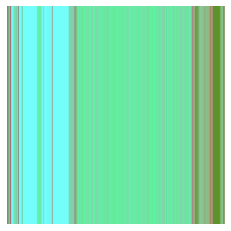

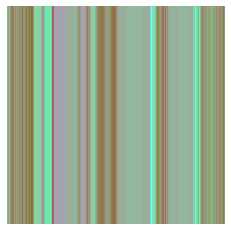

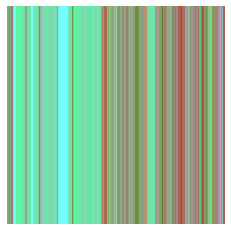

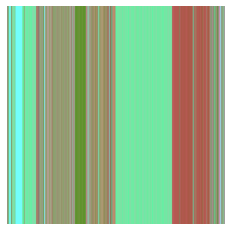

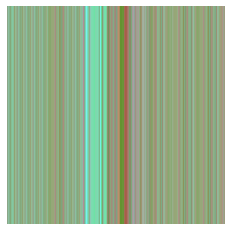

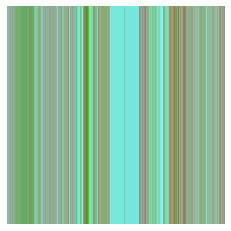

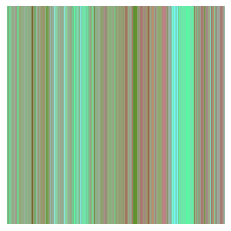

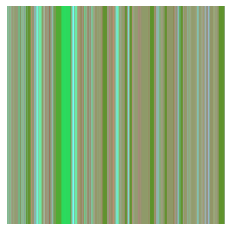

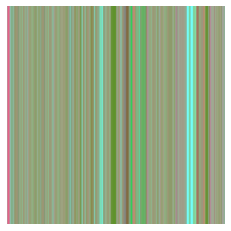

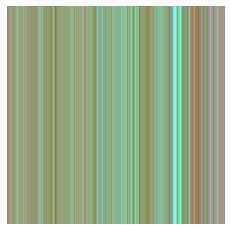

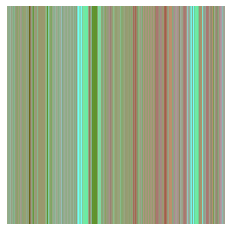

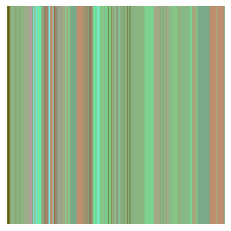

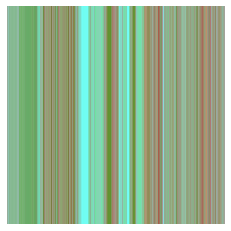

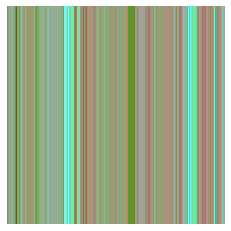

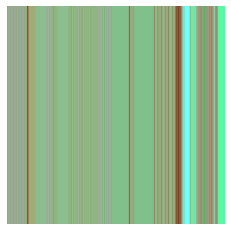

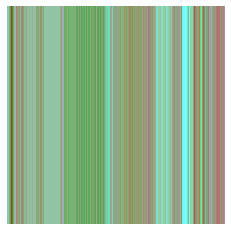

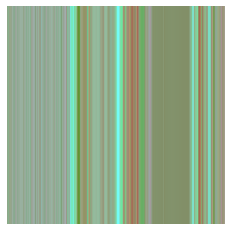

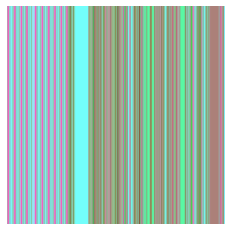

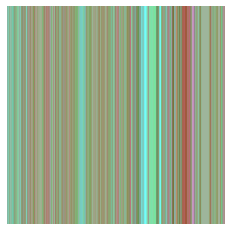

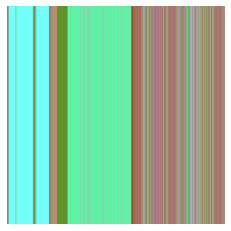

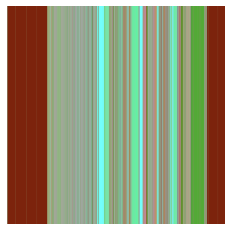

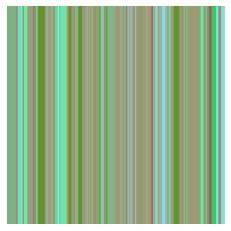

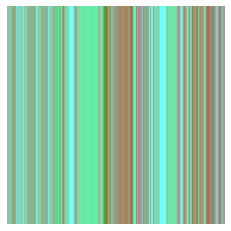

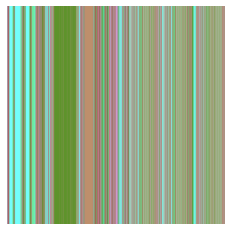

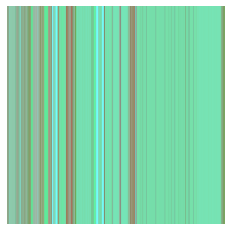

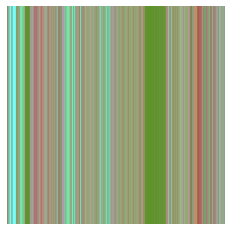

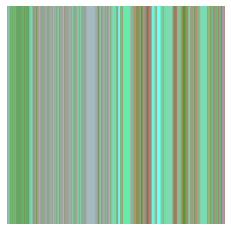

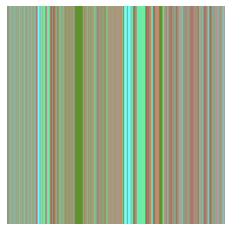

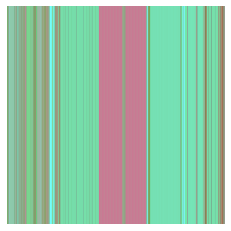

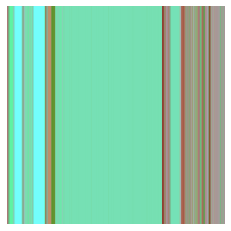

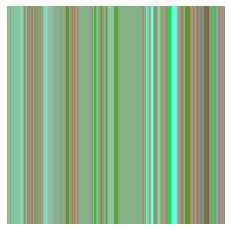

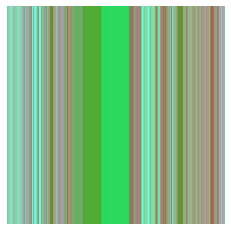

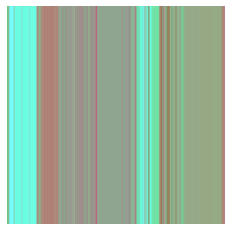

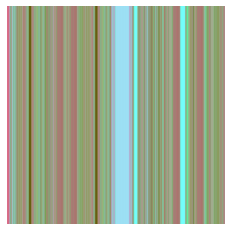

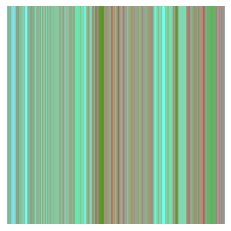

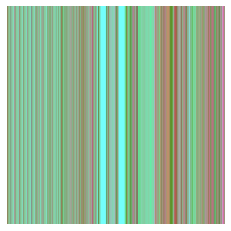

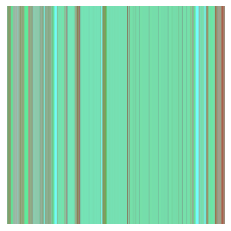

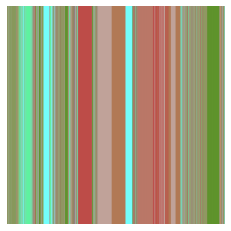

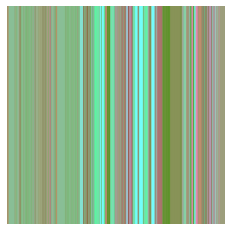

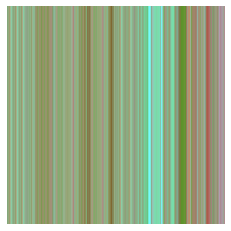

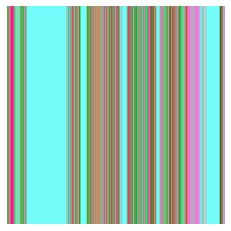

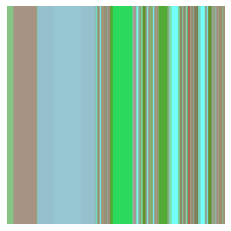

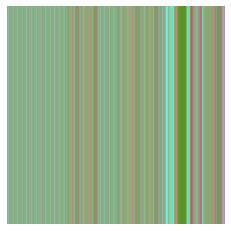

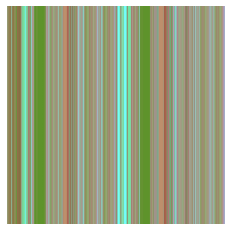

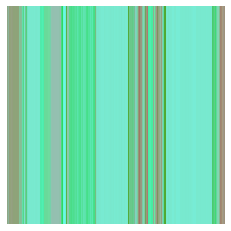

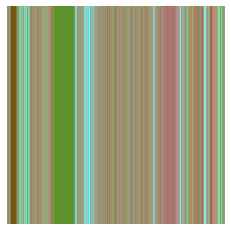

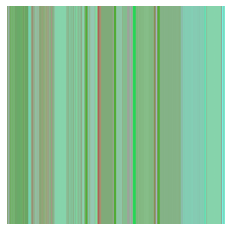

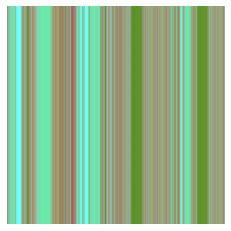

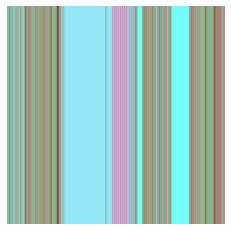

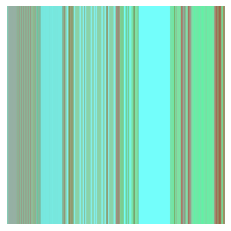

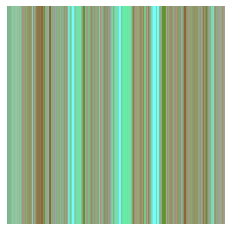

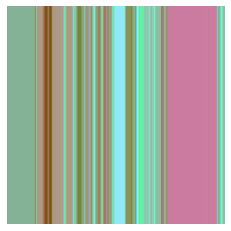

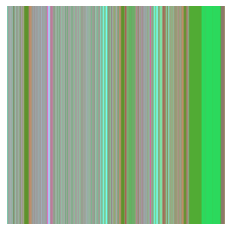

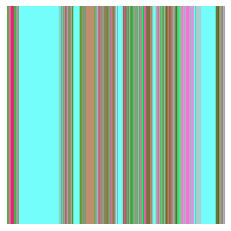

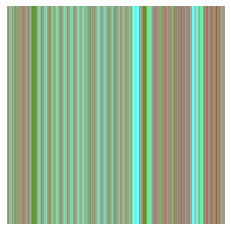

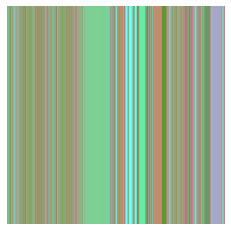

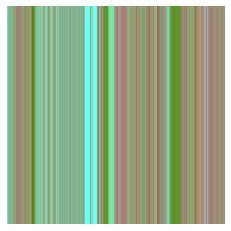

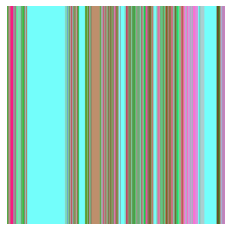

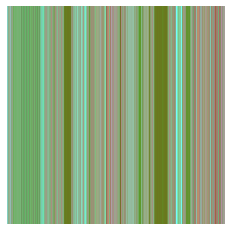

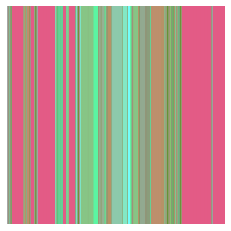

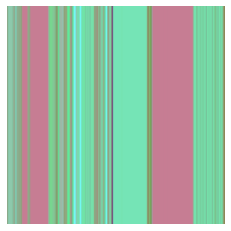

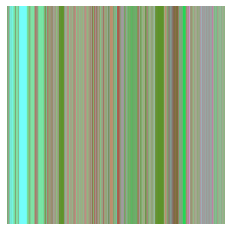

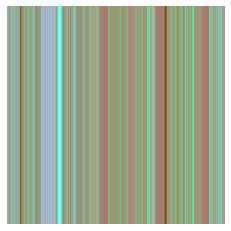

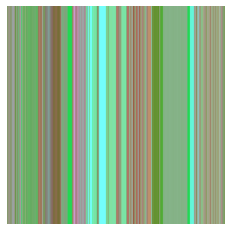

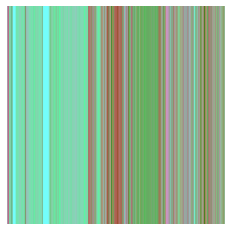

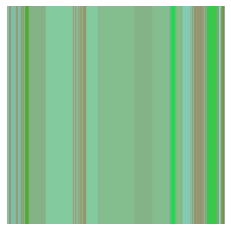

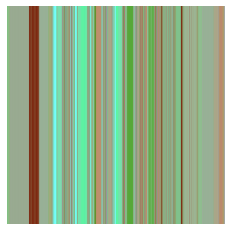

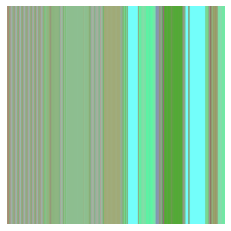

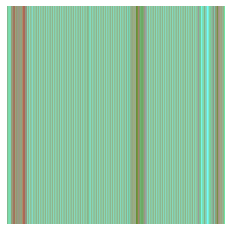

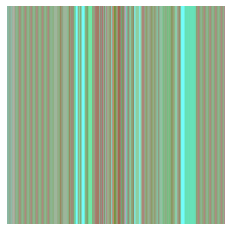

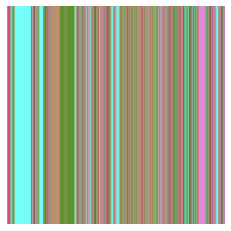

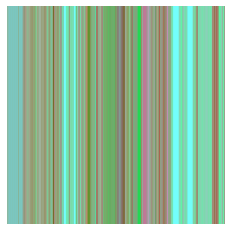

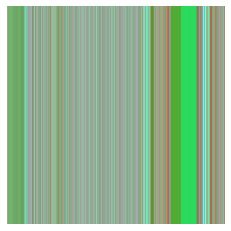

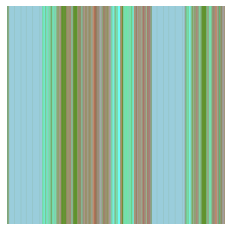

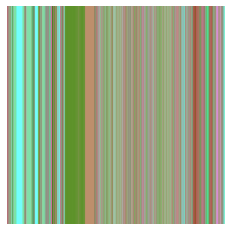

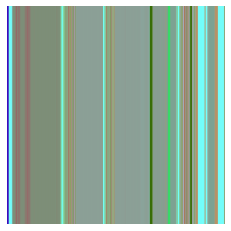

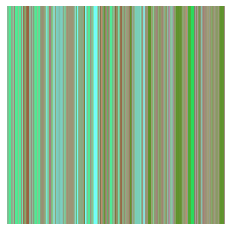

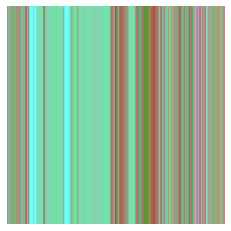

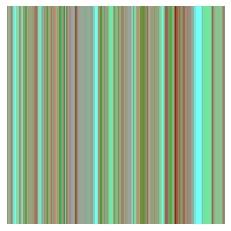

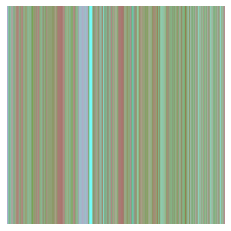

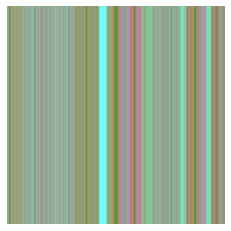

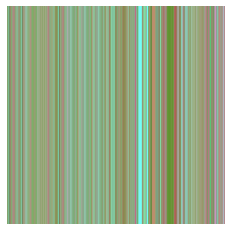

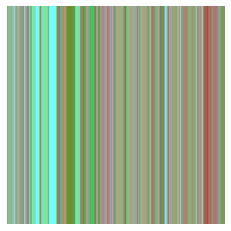

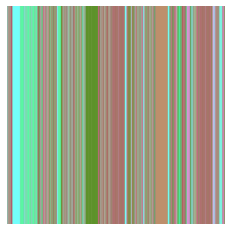

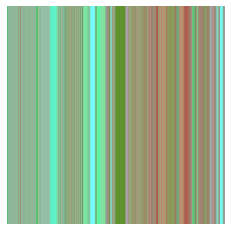

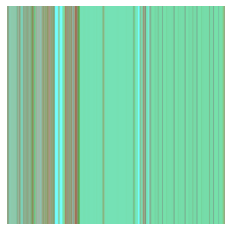

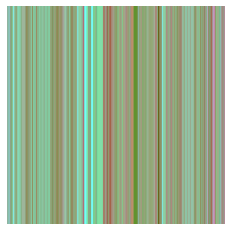

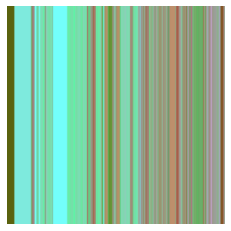

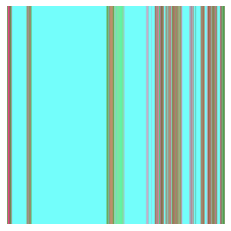

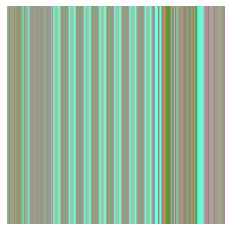

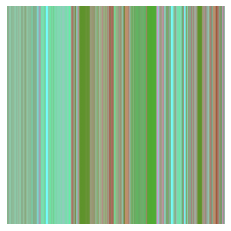

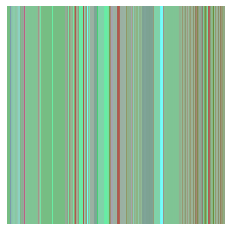

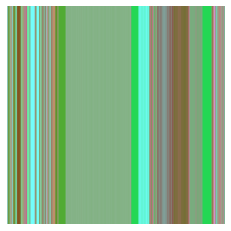

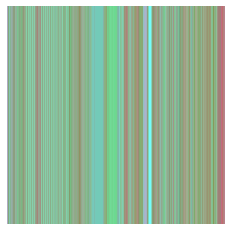

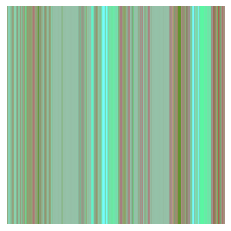

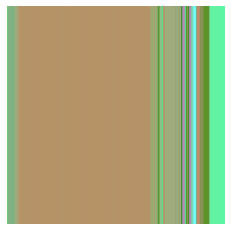

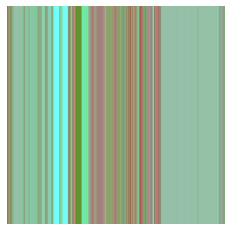

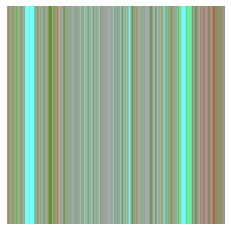

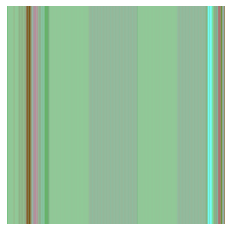

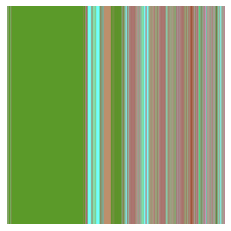

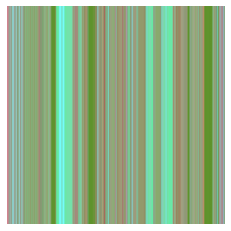

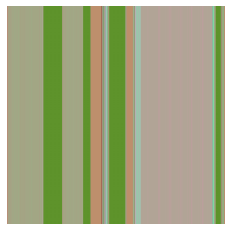

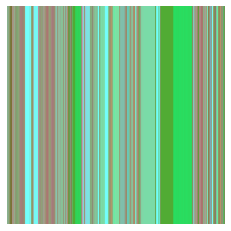

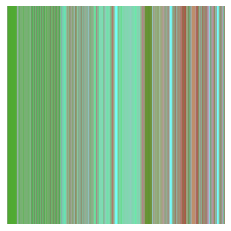

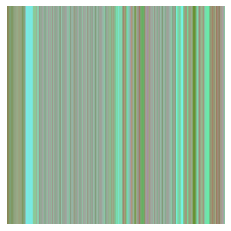

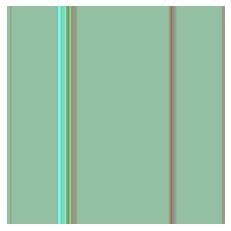

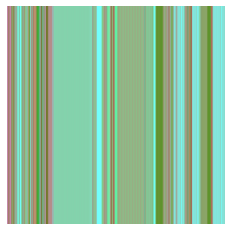

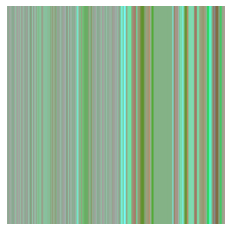

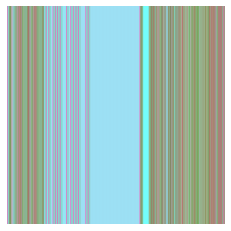

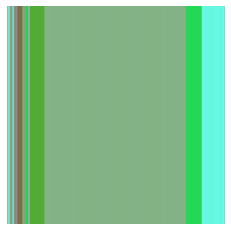

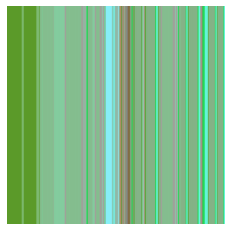

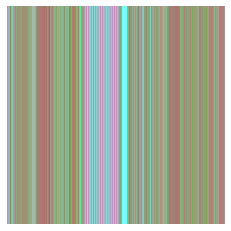

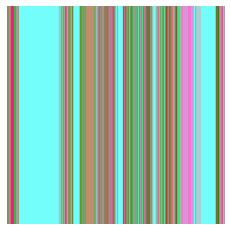

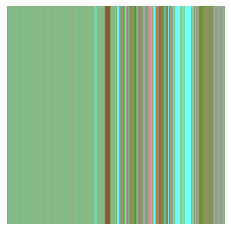

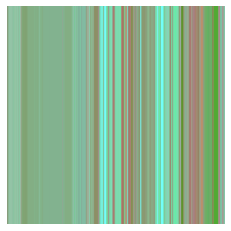

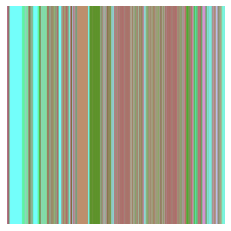

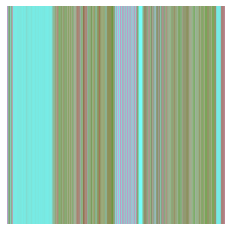

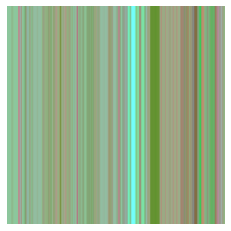

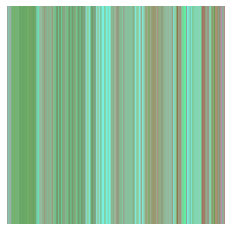

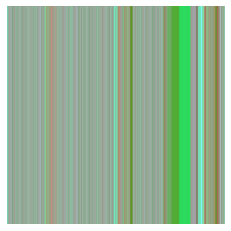

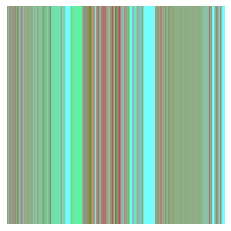

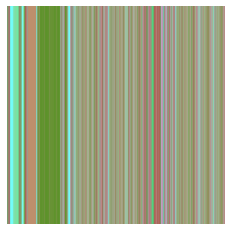

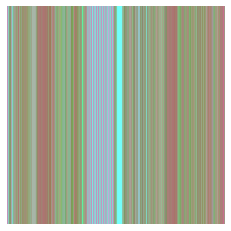

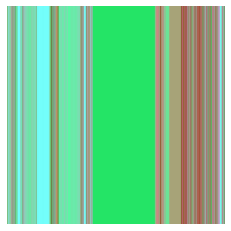

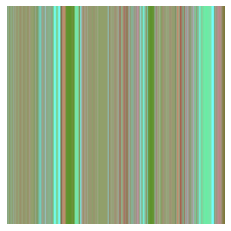

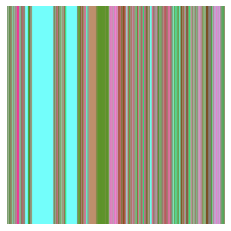

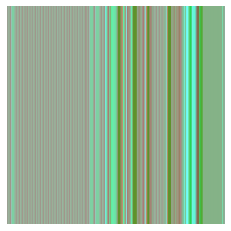

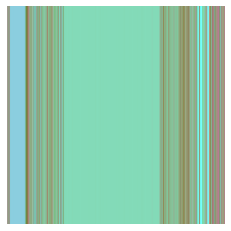

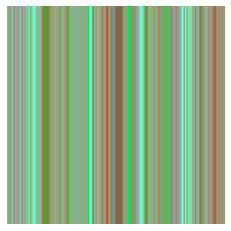

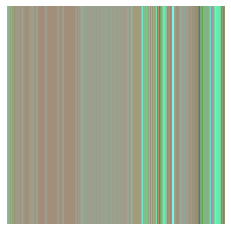

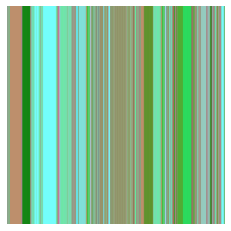

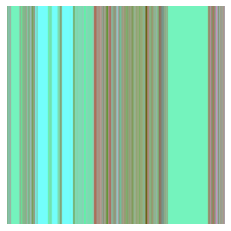

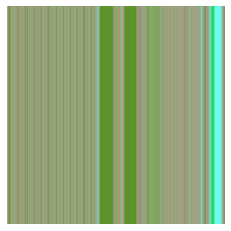

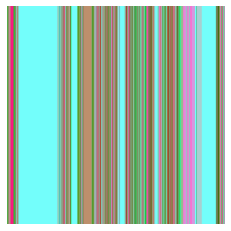

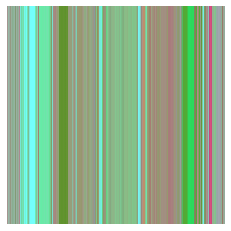

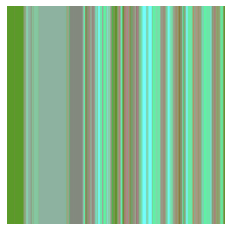

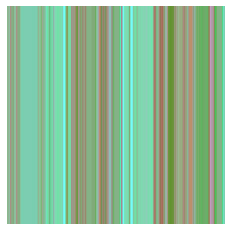

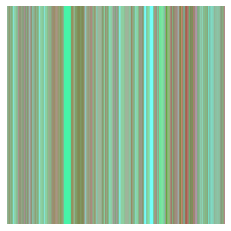

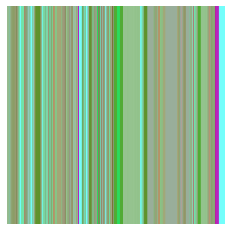

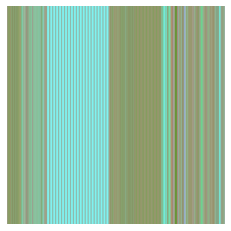

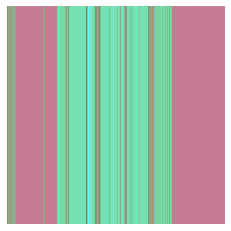

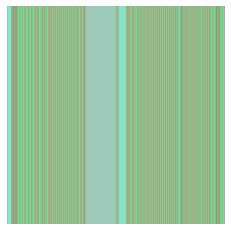

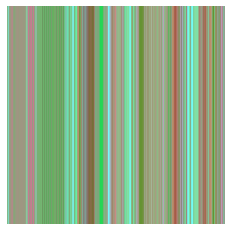

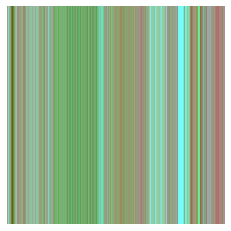

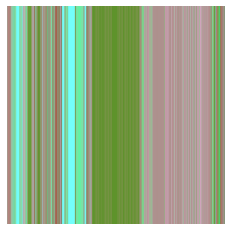

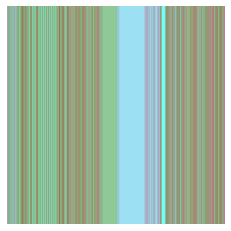

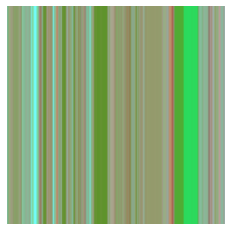

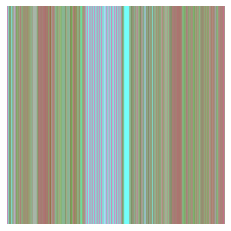

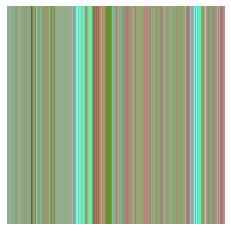

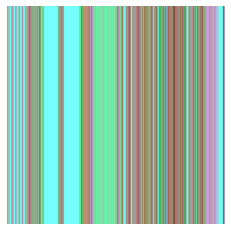

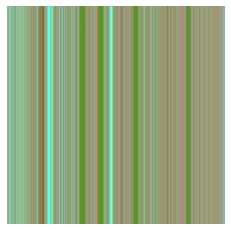

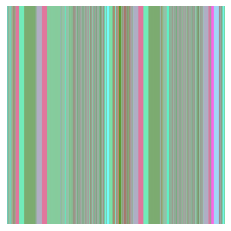

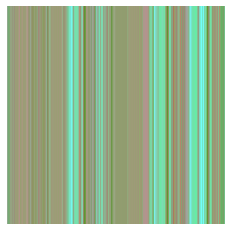

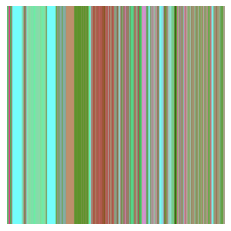

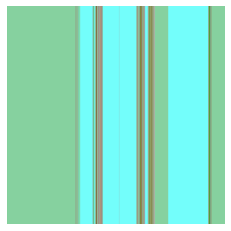

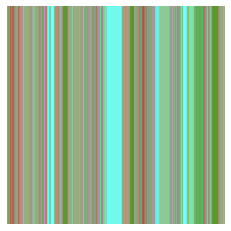

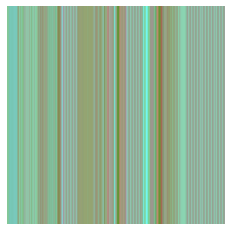

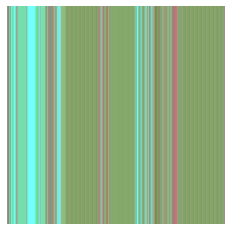

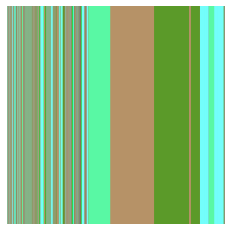

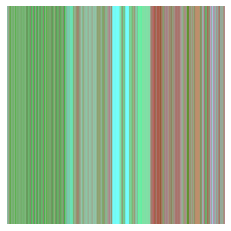

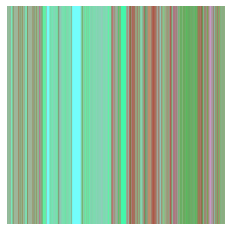

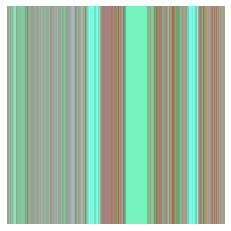

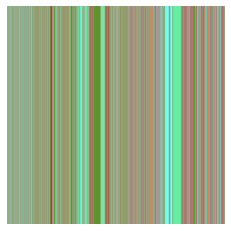

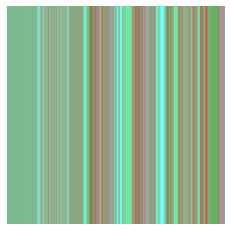

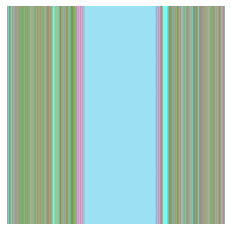

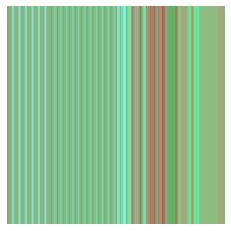

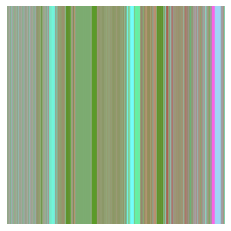

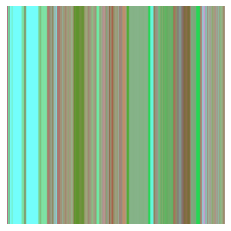

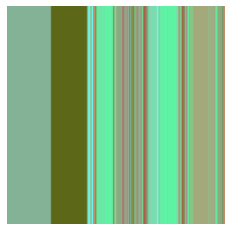

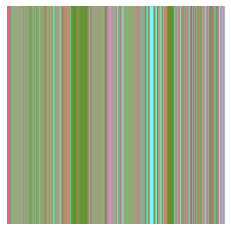

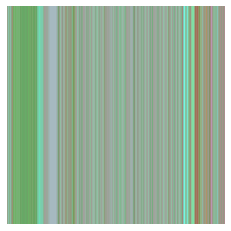

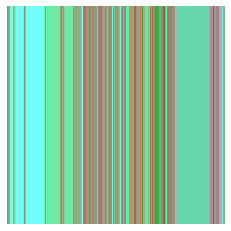

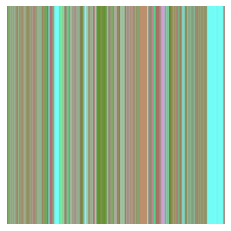

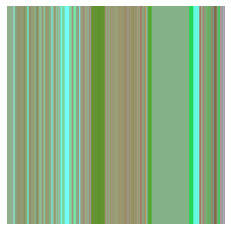

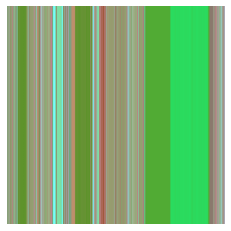

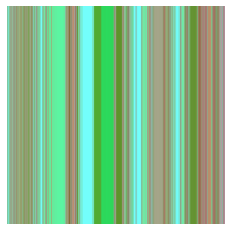

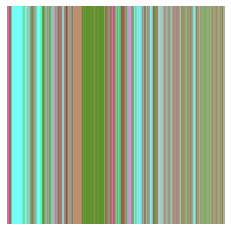

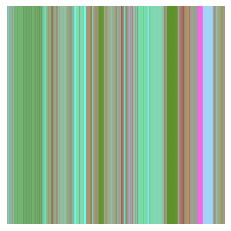

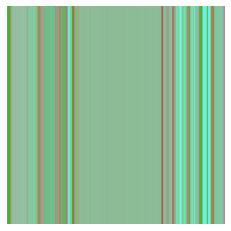

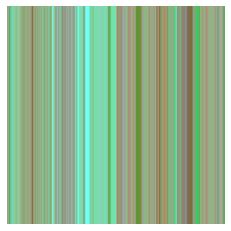

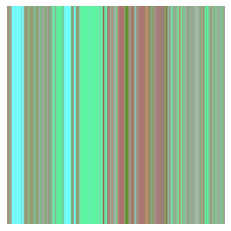

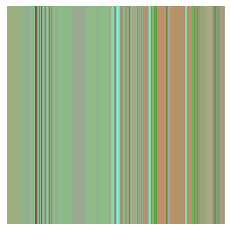

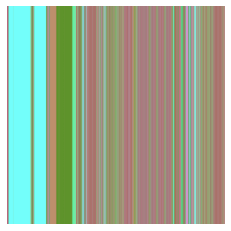

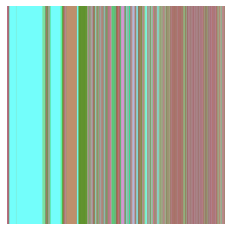

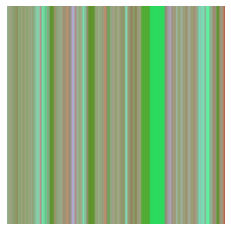

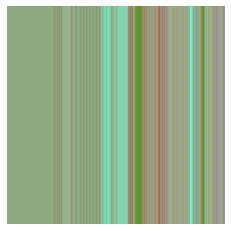

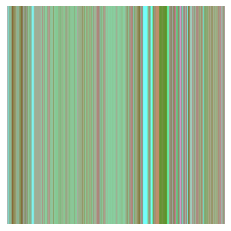

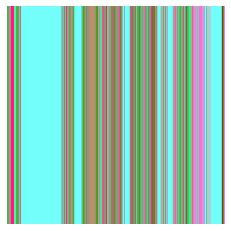

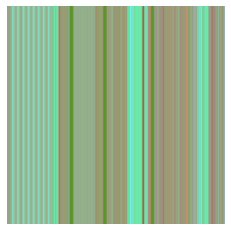

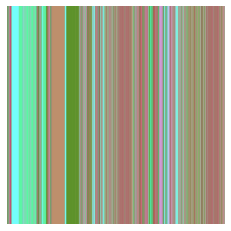

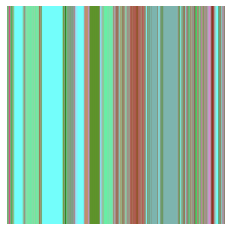

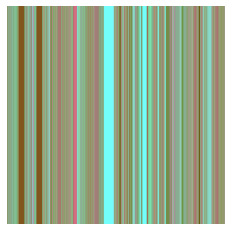

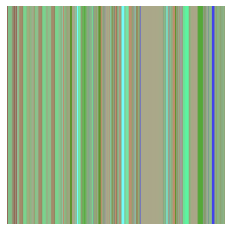

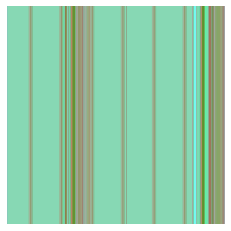

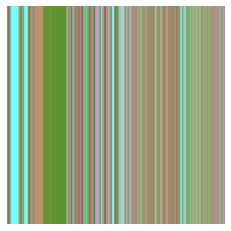

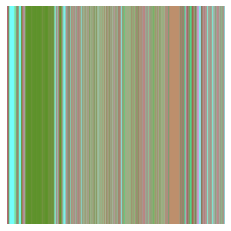

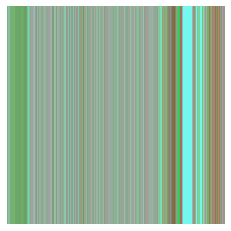

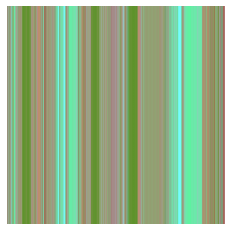

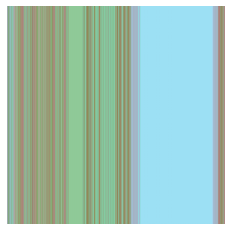

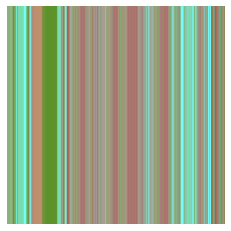

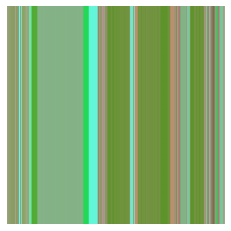

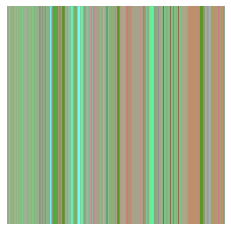

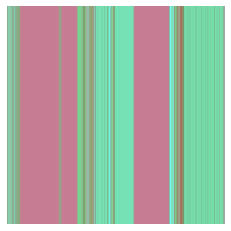

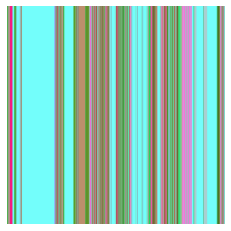

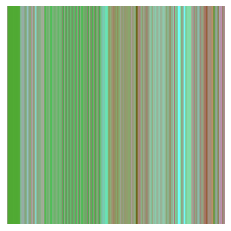

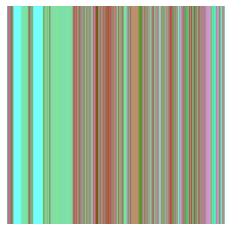

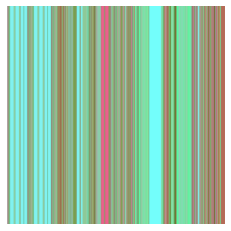

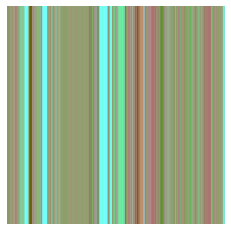

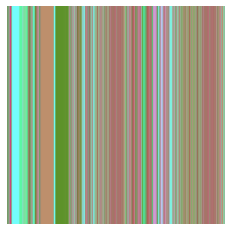

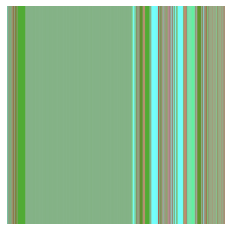

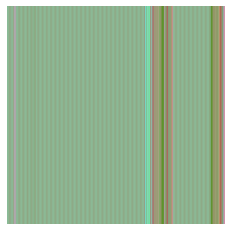

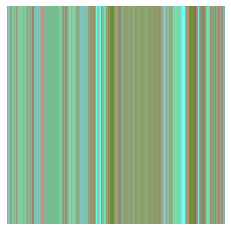

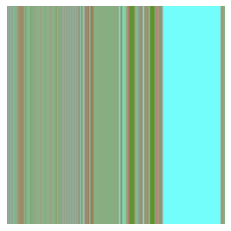

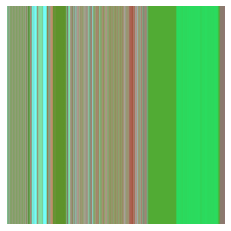

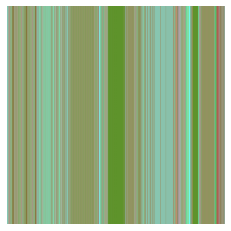

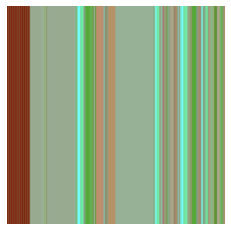

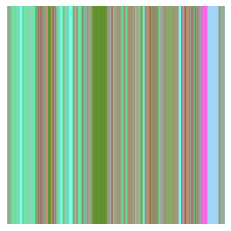

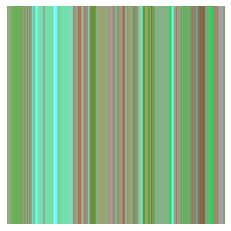

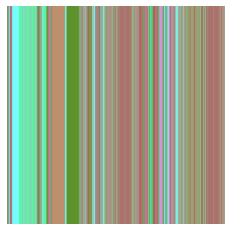

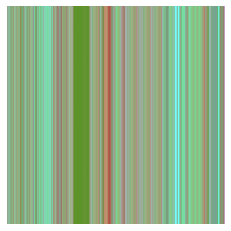

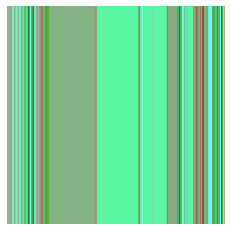

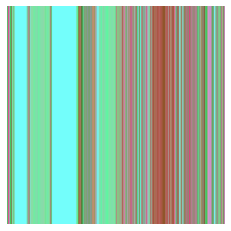

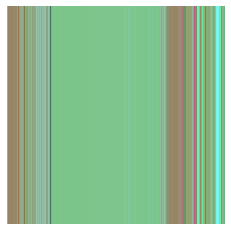

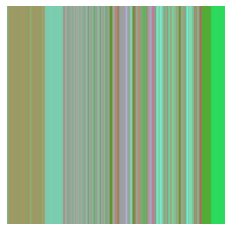

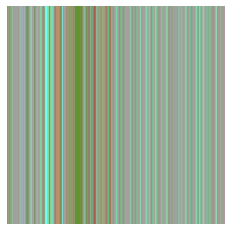

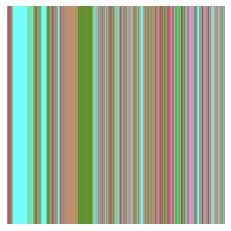

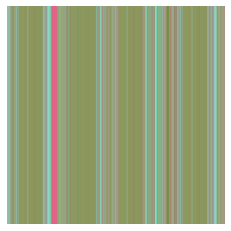

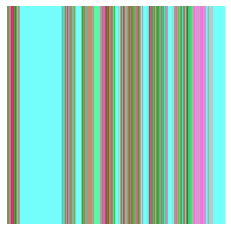

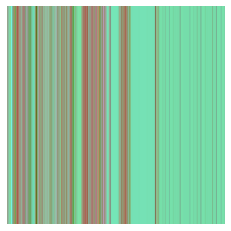

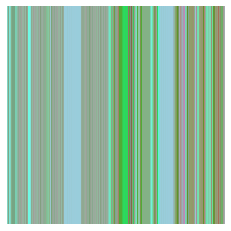

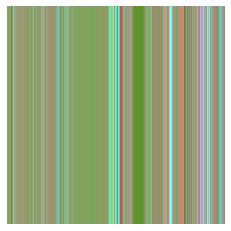

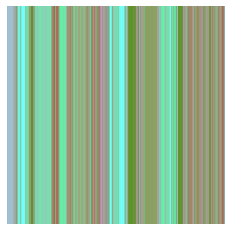

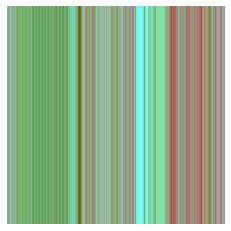

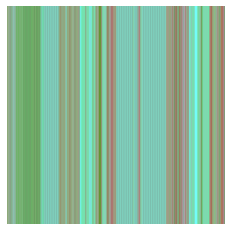

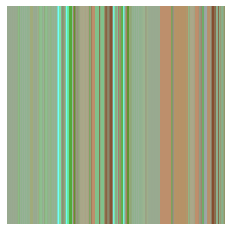

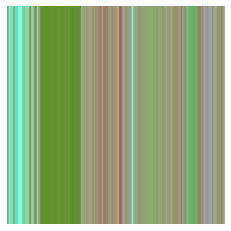

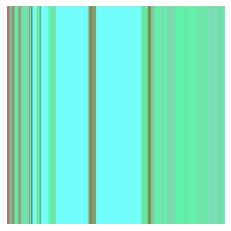

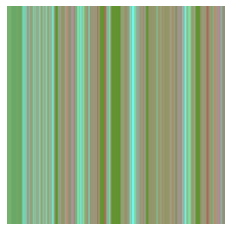

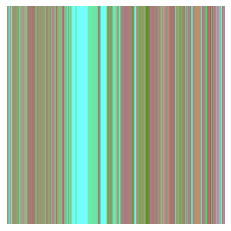

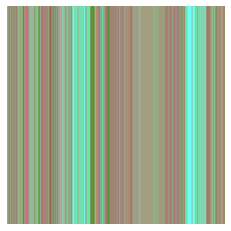

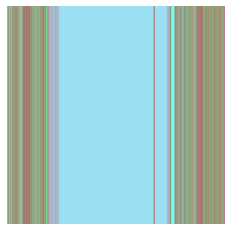

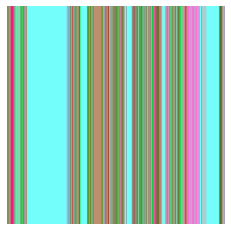

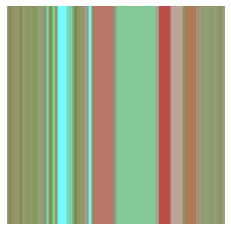

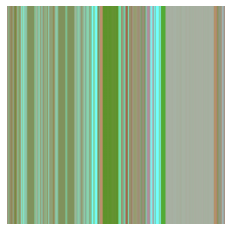

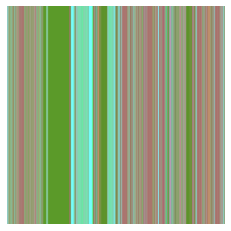

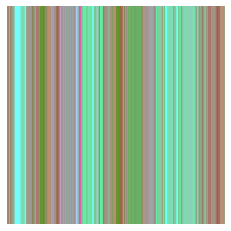

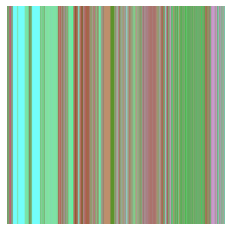

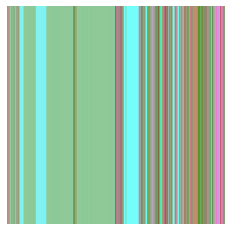

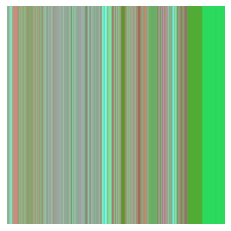

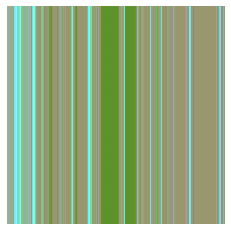

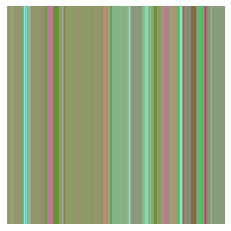

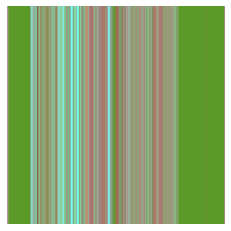

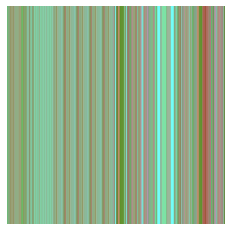

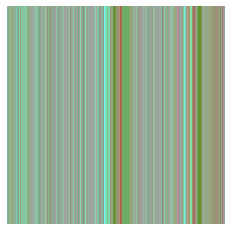

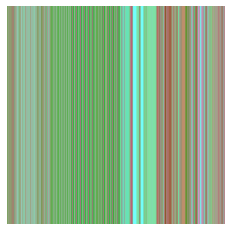

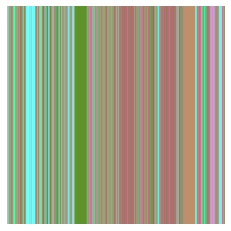

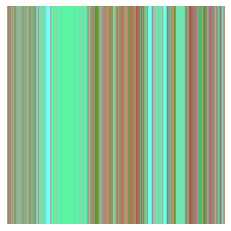

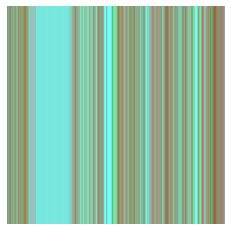

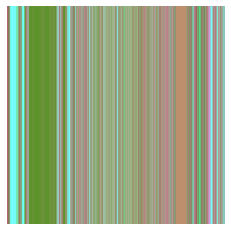

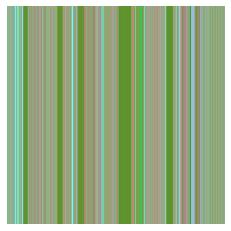

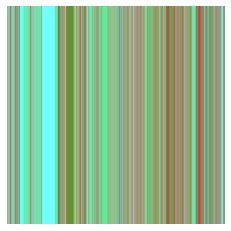

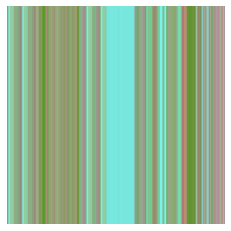

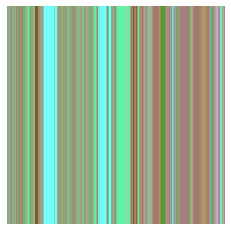

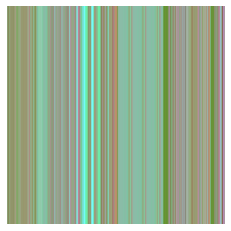

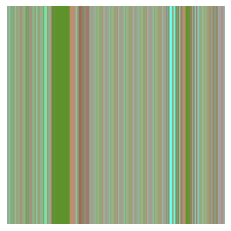

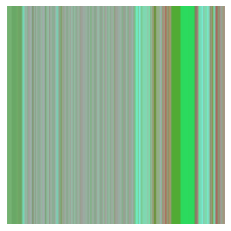

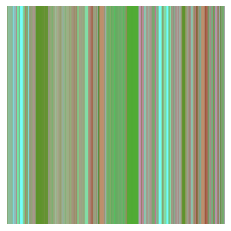

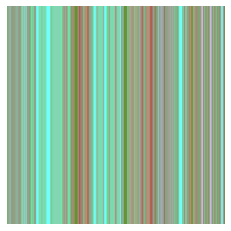

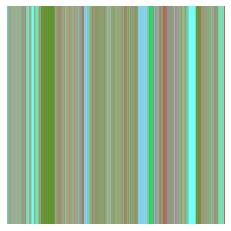

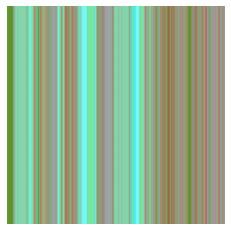

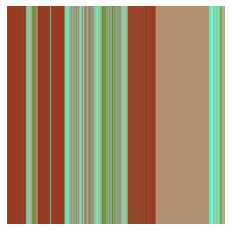

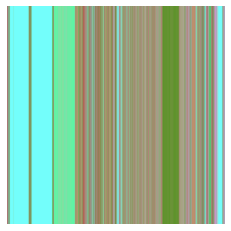

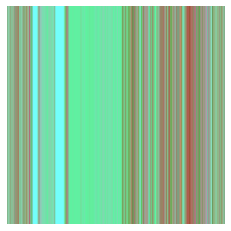

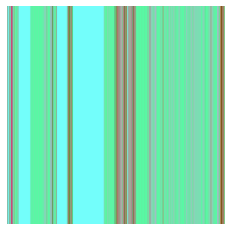

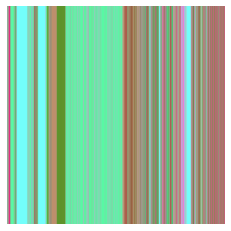

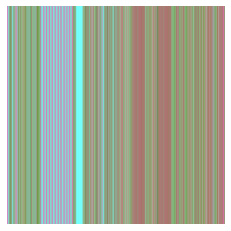

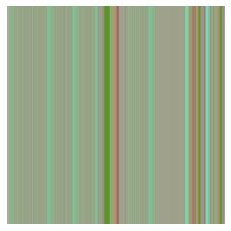

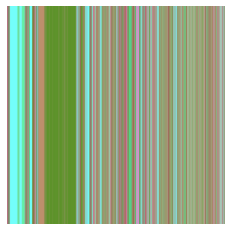

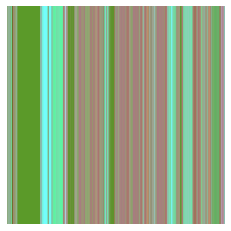

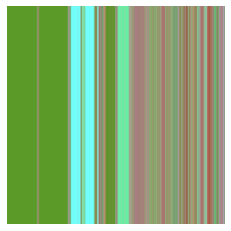

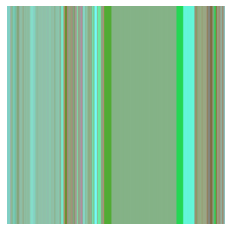

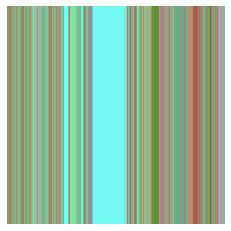

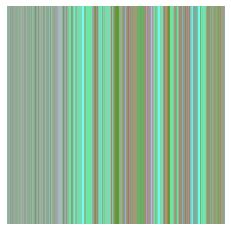

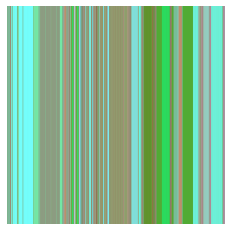

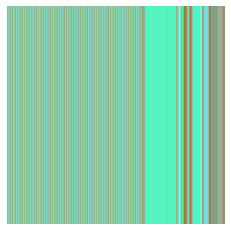

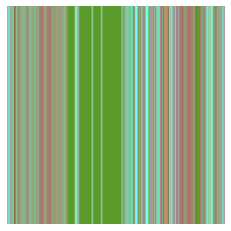

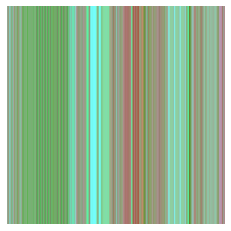

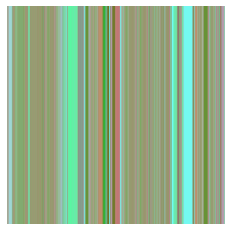

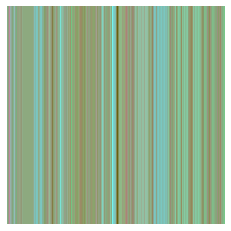

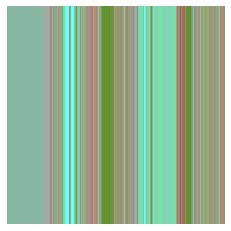

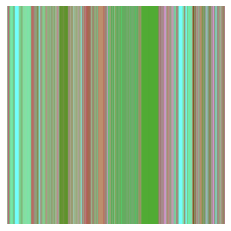

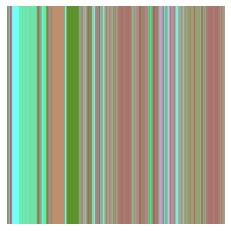

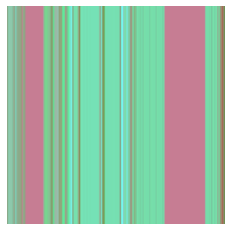

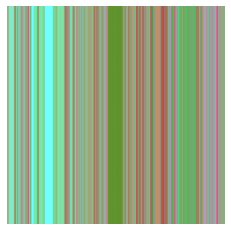

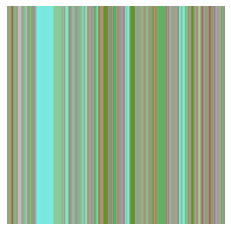

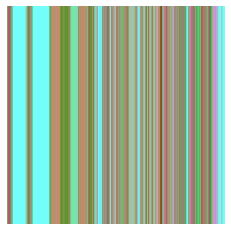

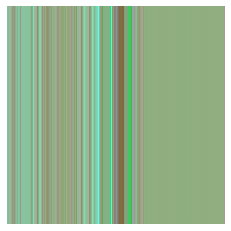

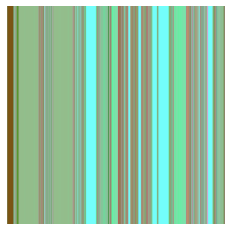

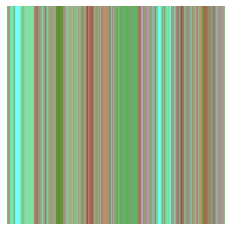

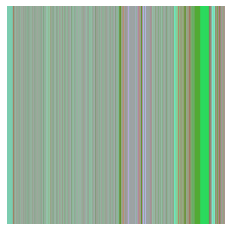

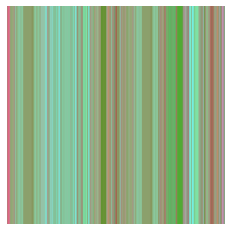

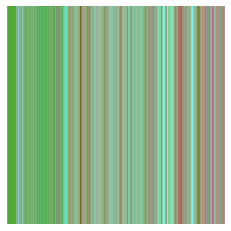

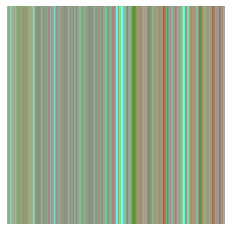

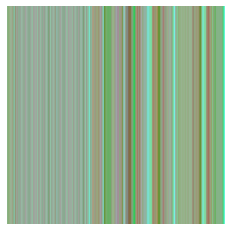

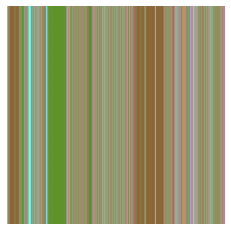

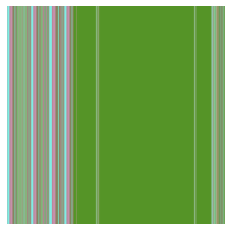

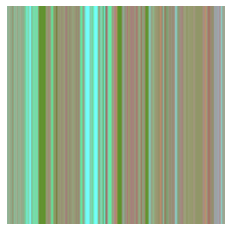

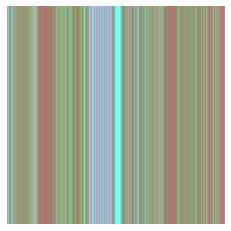

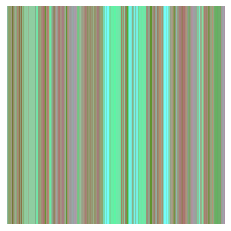

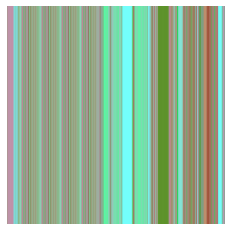

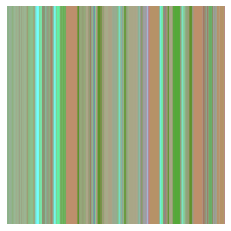

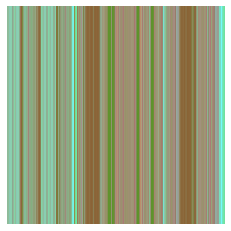

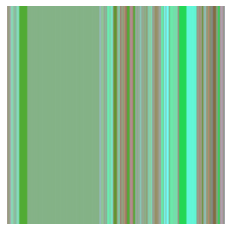

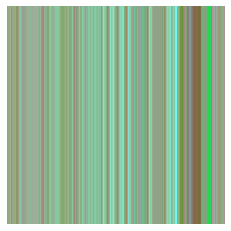

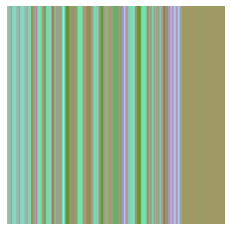

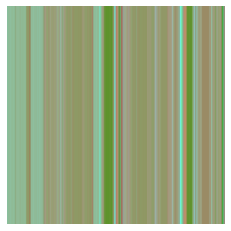

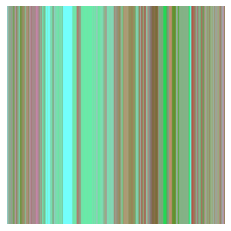

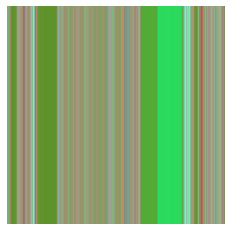

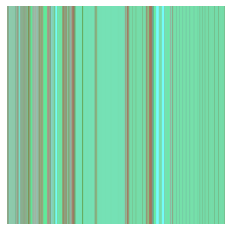

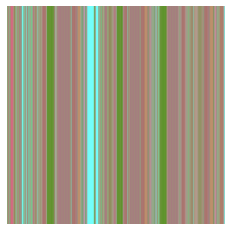

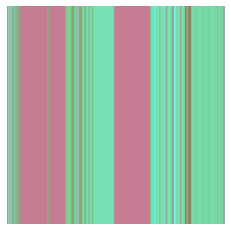

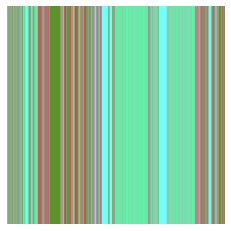

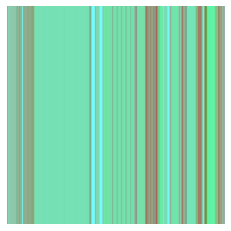

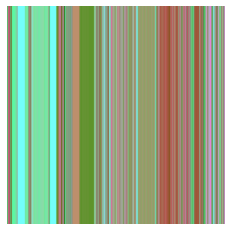

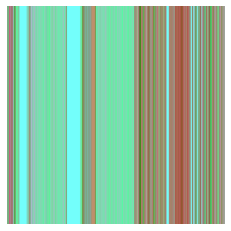

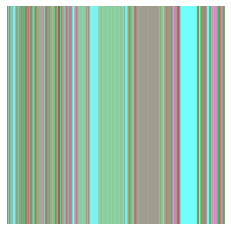

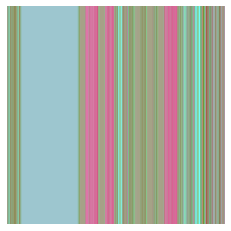

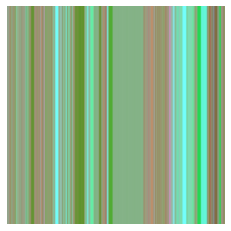

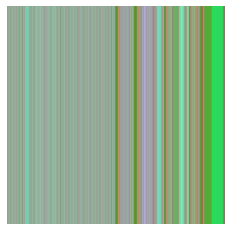

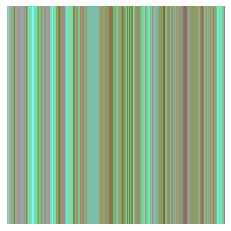

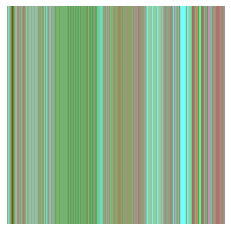

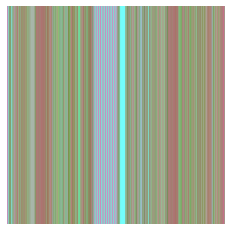

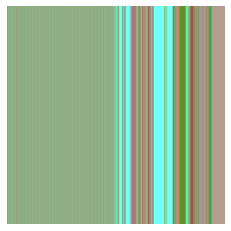

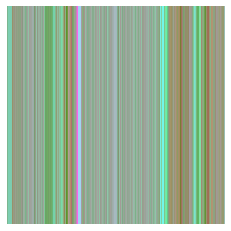

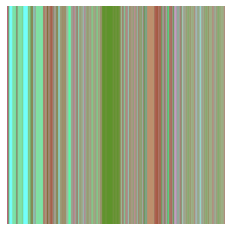

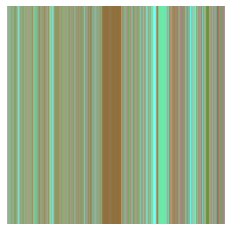

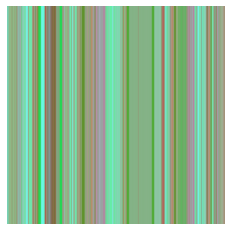

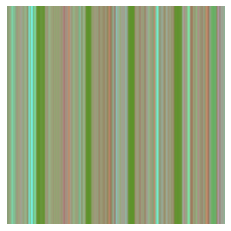

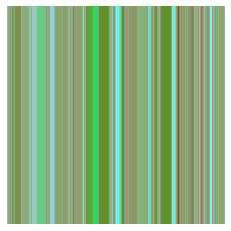

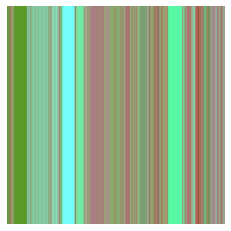

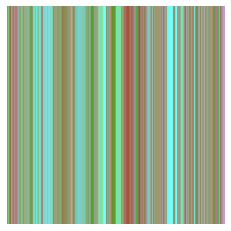

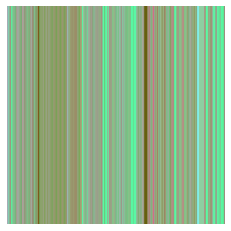

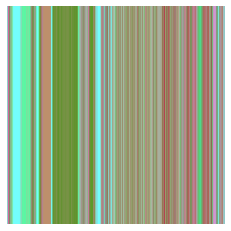

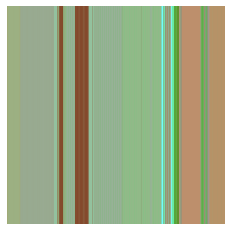

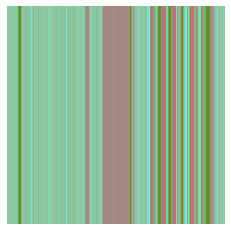

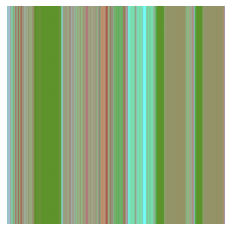

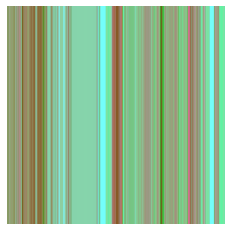

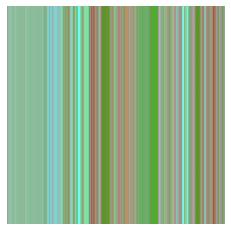

In [54]:
dirs = ['/home/ubuntu/ml/validation/Benign_Dumps','/home/ubuntu/ml/validation/Malware_Dumps','/home/ubuntu/ml/test/Benign_Dumps','/home/ubuntu/ml/test/Malware_Dumps','/home/ubuntu/ml/train/Benign_Dumps','/home/ubuntu/ml/train/Malware_Dumps']
for dir in dirs:
    files = os.listdir(dir)
    for file in files:
        with open(dir+"/"+file, 'rb') as f:
            rgbarray = []
            for line in f.readlines():
                try:
                    var = line.split()
                    obj = var[5].decode('utf-8')
                    if obj in token_color_map.keys():
                            rgbarray.append([val for val in token_color_map[obj]])
                    #if obj not in token_color_map.keys():
                            #rgbarray.append([22, 230, 108])
                except IndexError as e:
                         continue
#             print(rgbarray)
            #plot(np.expand_dims(np.array(rgbarray,dtype=int),axis=0),'PaperImages/'+dir+'/'+file+'.png')
            new_dir = '/'.join(dir.split('/')[4:])
            #print(new_dir)
            plot(np.expand_dims(np.array(rgbarray,dtype=int),axis=0),'/home/ubuntu/ml/Reworked_images/'+new_dir+'/'+file+'.png')
#             cvplot(rgbarray,'Remodeled_PaperImages/'+dir+'/'+file+'.png')
            f.close()

In [53]:
'/'.join('ShuffledImages/validation/Benign_Dumps'.split('/')[1:])

'validation/Benign_Dumps'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


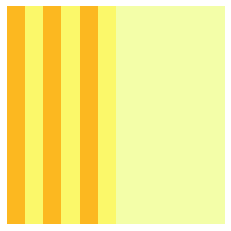

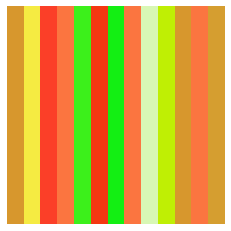

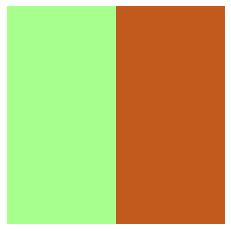

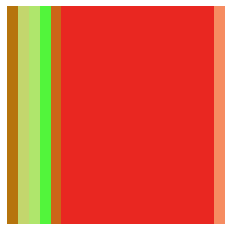

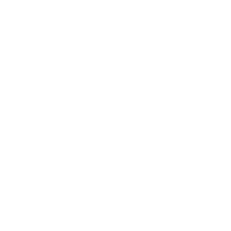

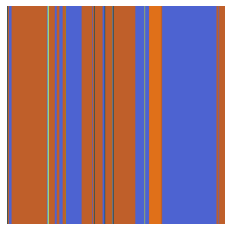

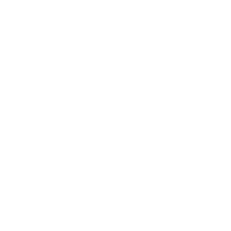

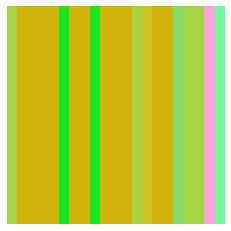

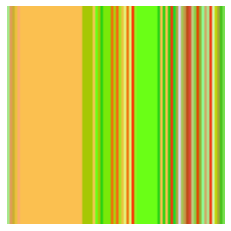

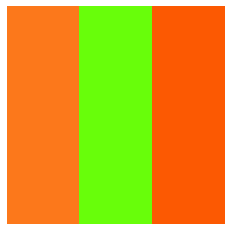

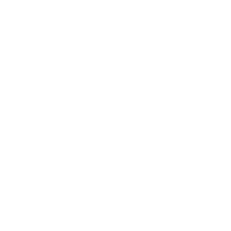

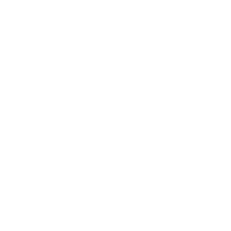

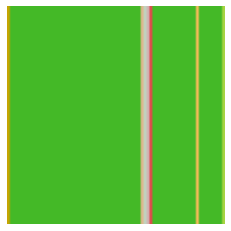

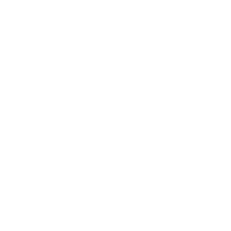

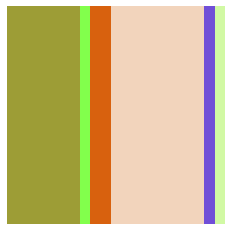

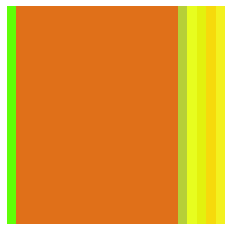

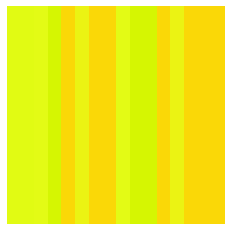

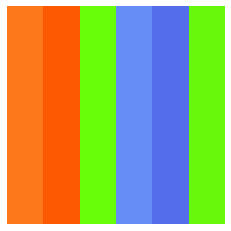

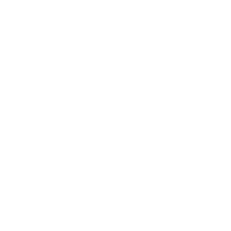

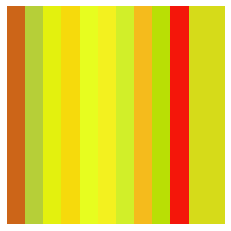

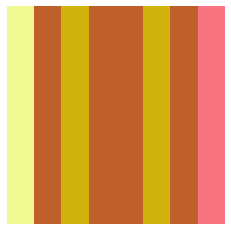

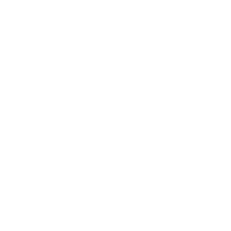

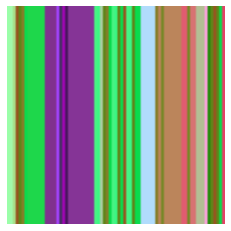

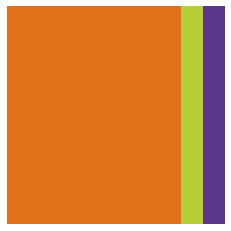

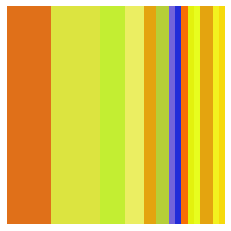

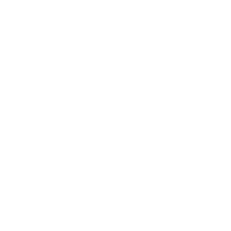

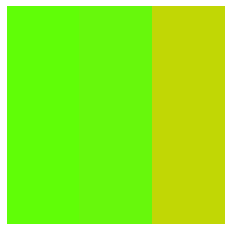

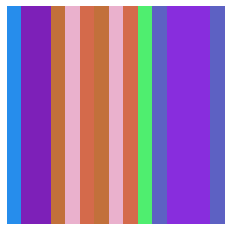

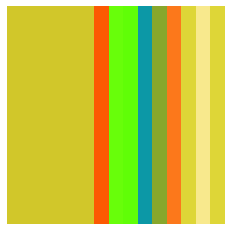

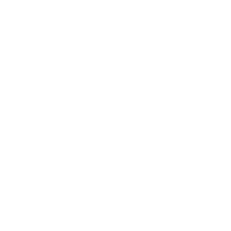

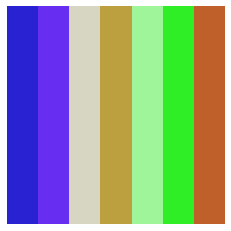

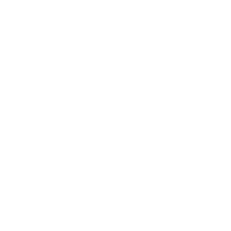

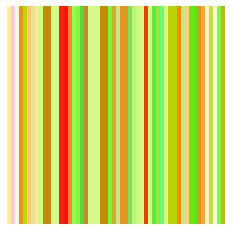

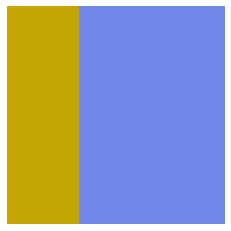

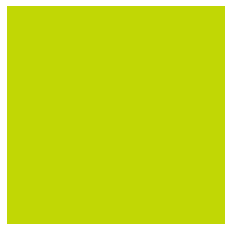

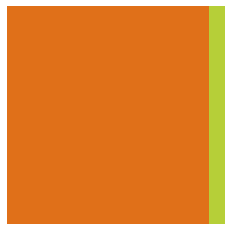

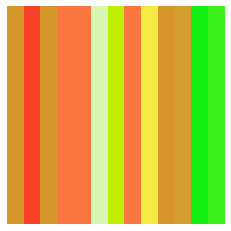

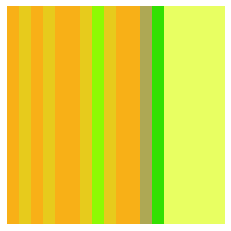

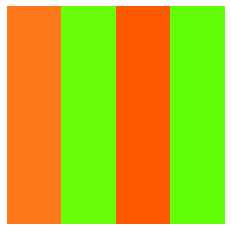

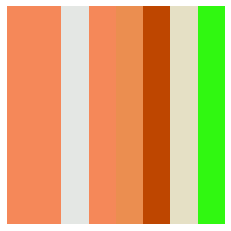

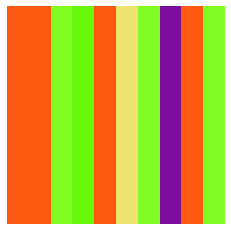

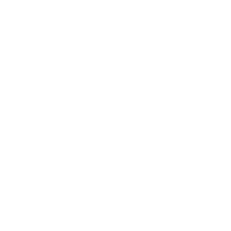

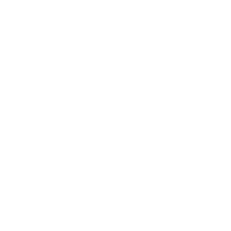

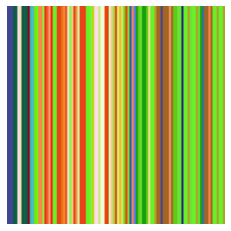

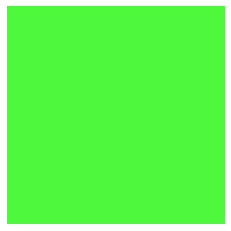

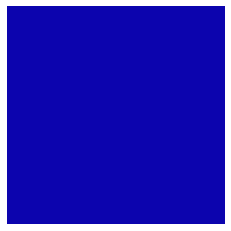

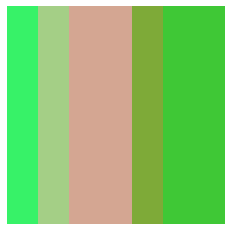

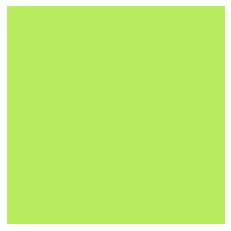

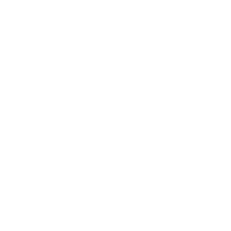

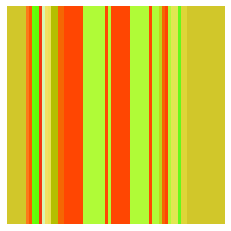

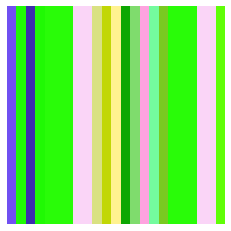

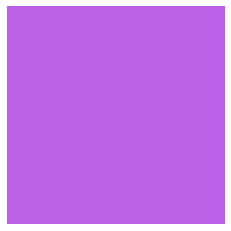

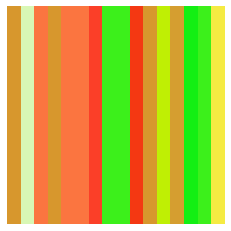

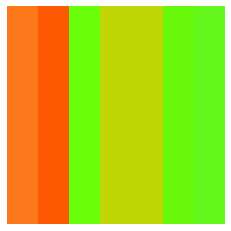

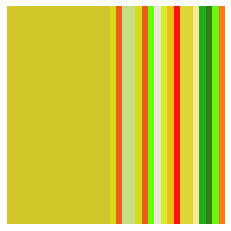

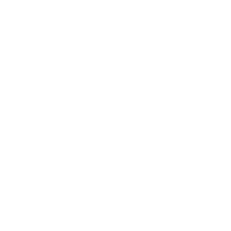

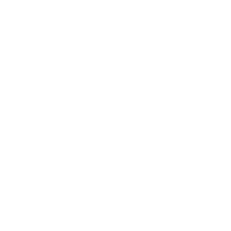

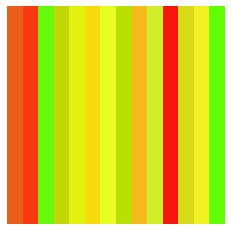

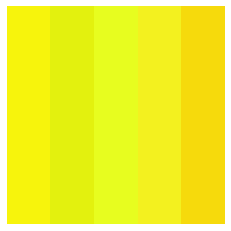

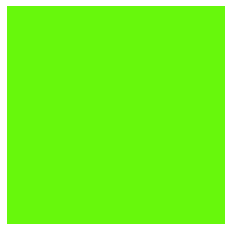

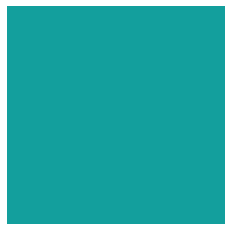

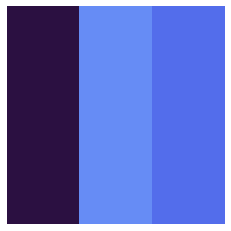

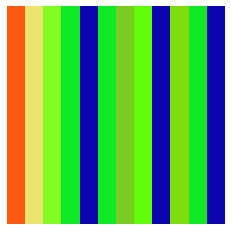

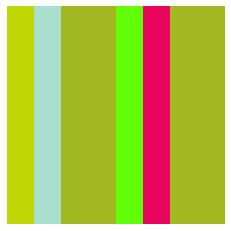

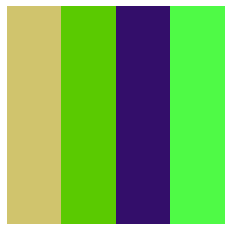

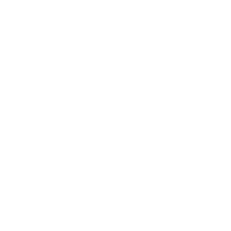

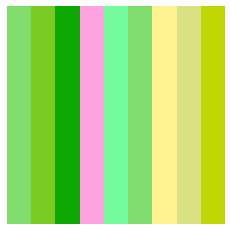

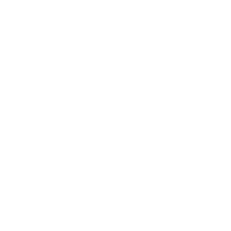

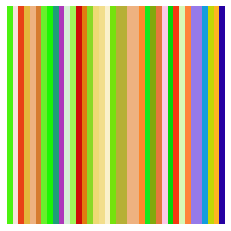

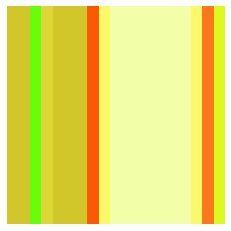

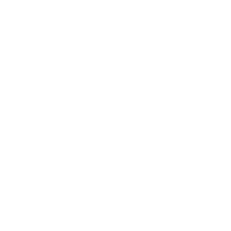

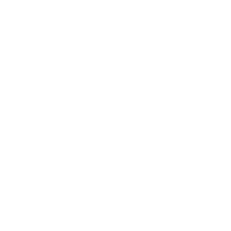

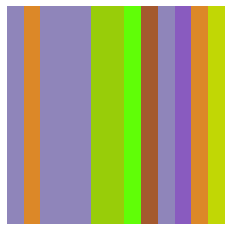

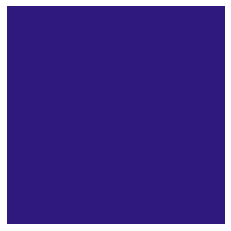

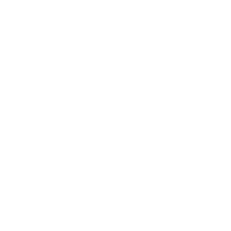

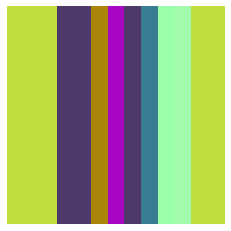

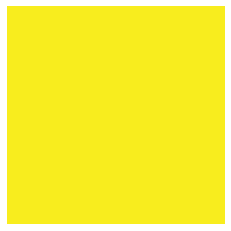

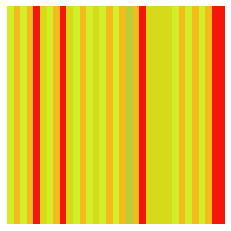

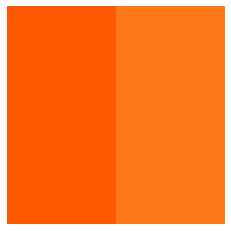

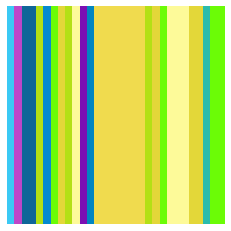

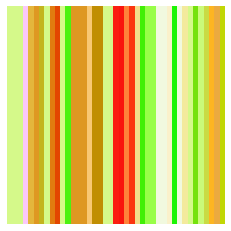

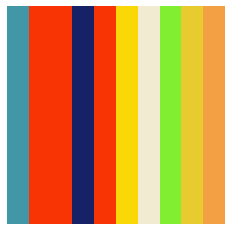

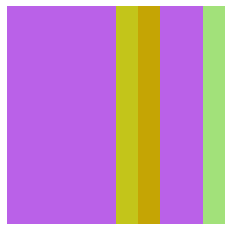

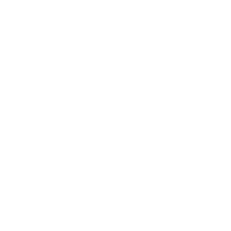

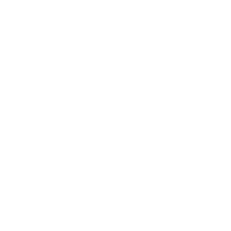

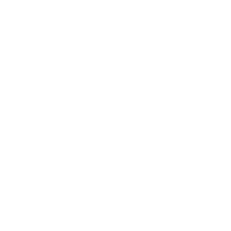

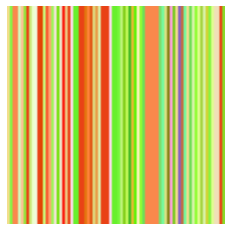

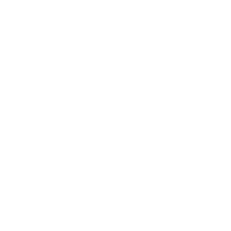

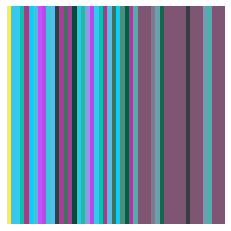

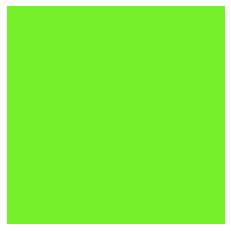

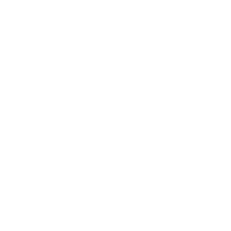

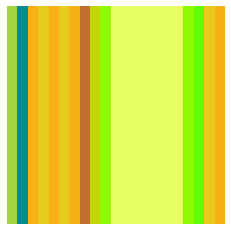

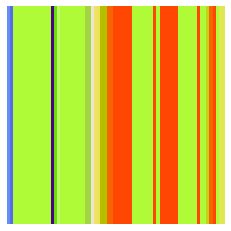

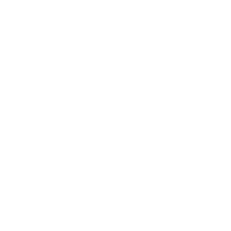

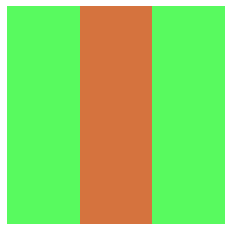

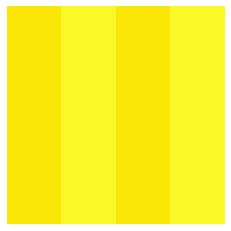

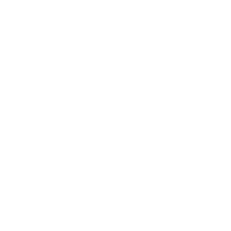

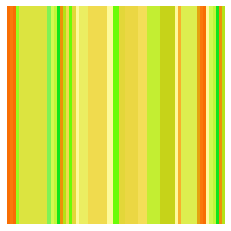

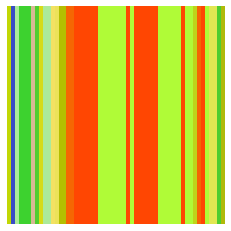

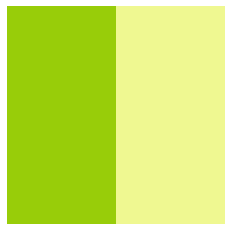

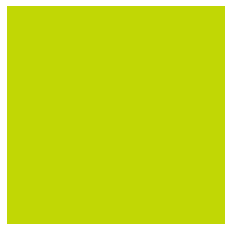

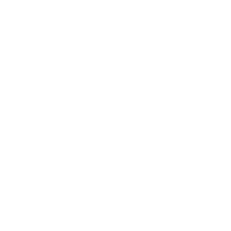

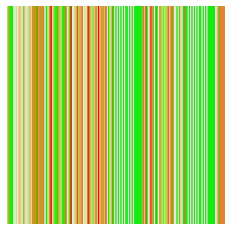

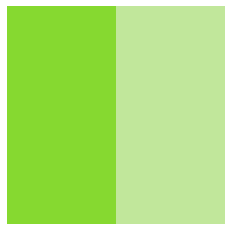

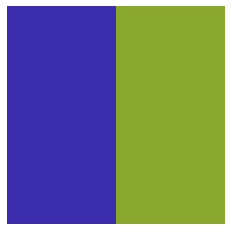

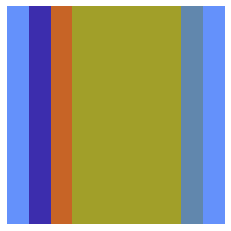

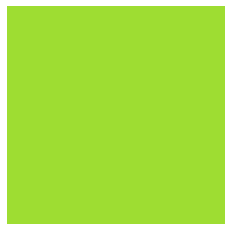

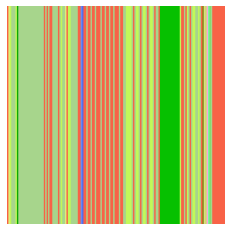

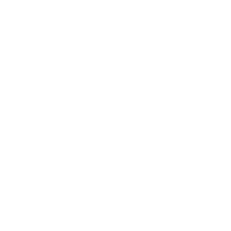

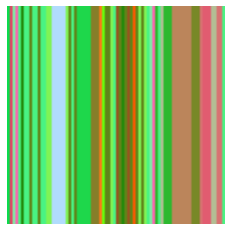

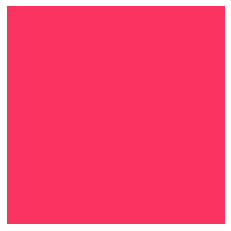

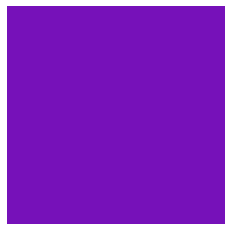

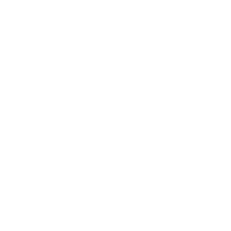

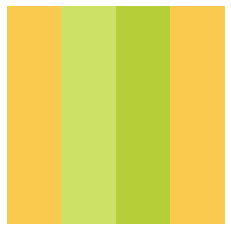

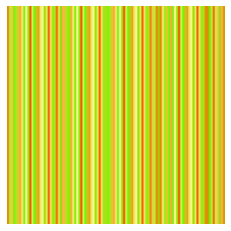

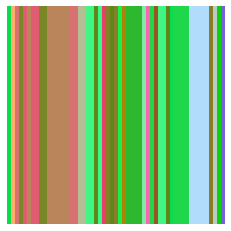

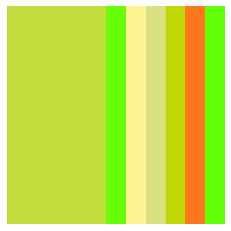

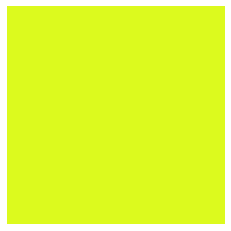

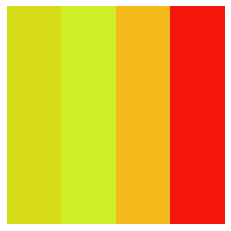

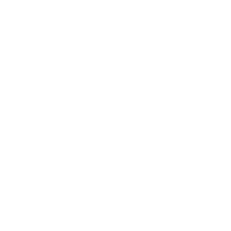

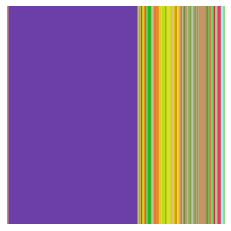

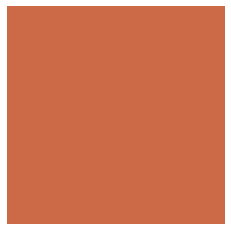

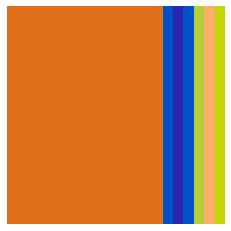

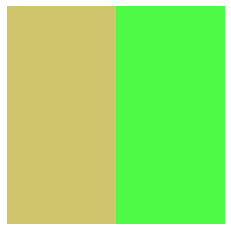

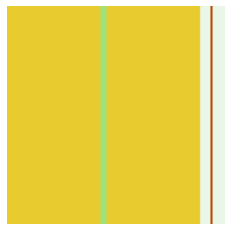

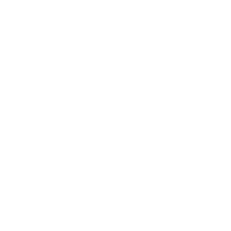

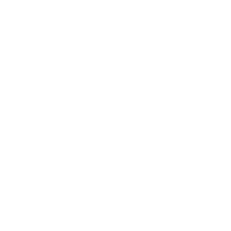

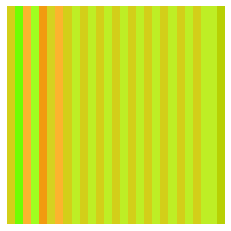

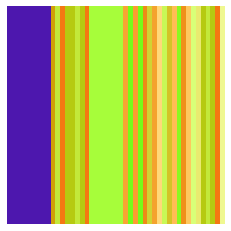

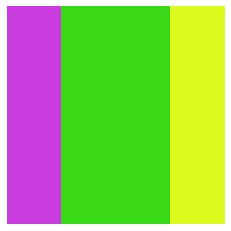

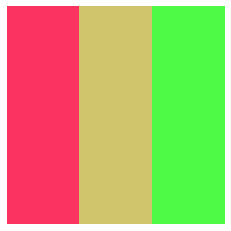

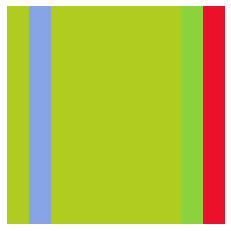

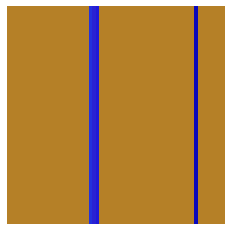

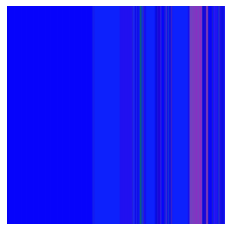

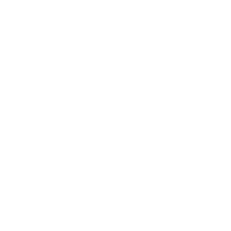

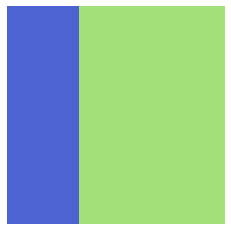

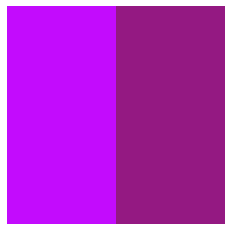

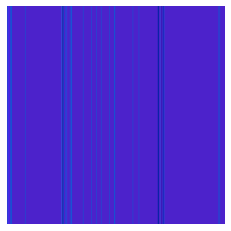

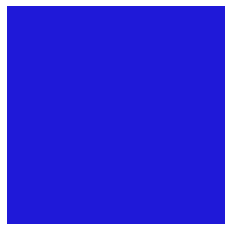

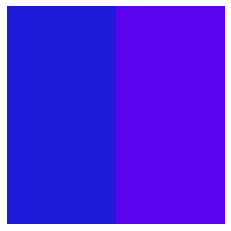

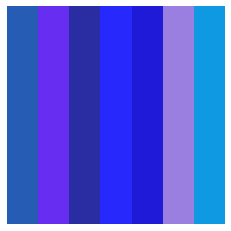

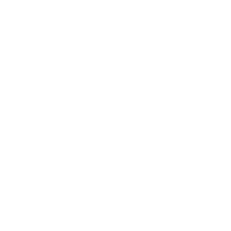

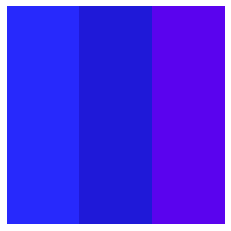

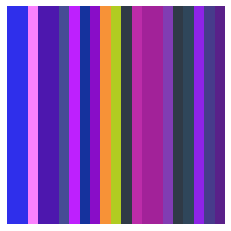

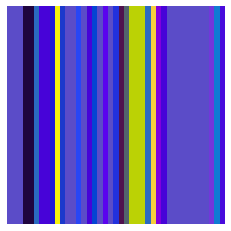

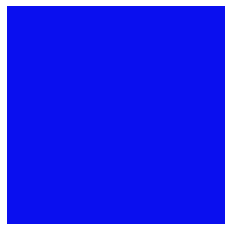

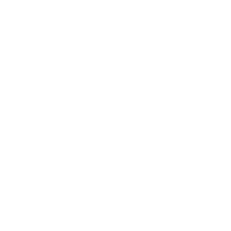

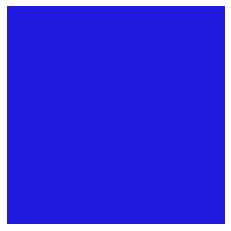

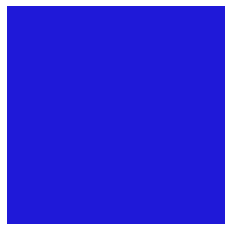

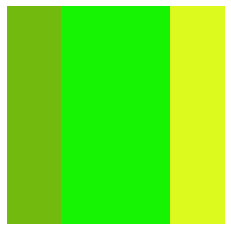

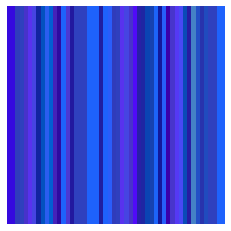

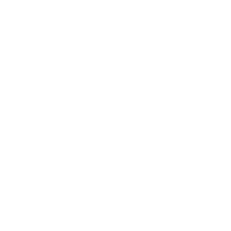

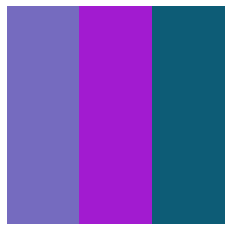

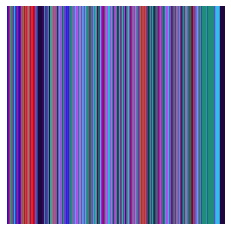

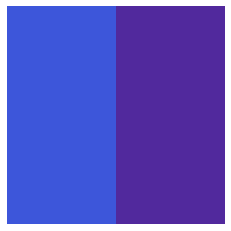

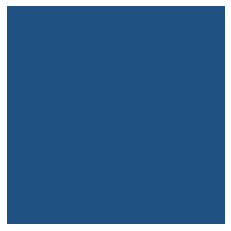

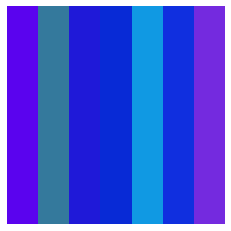

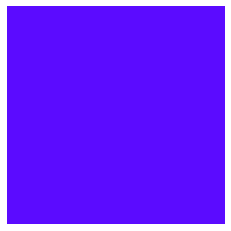

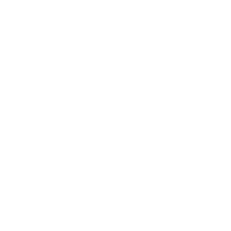

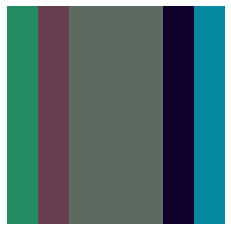

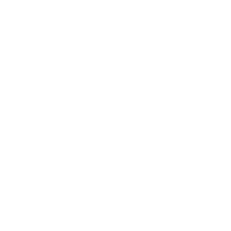

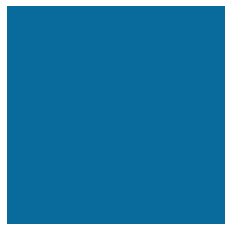

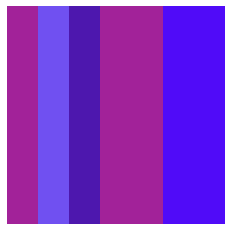

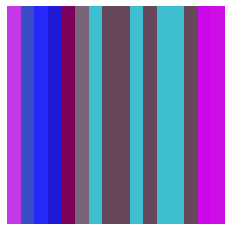

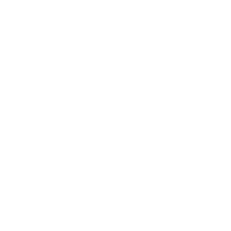

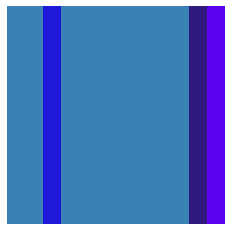

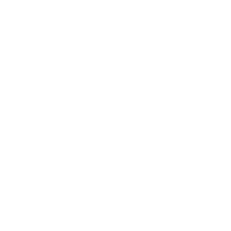

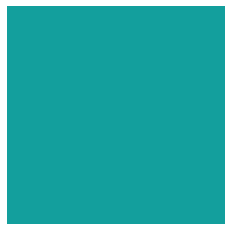

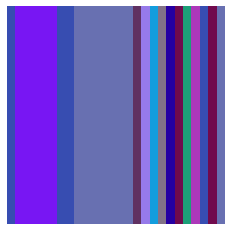

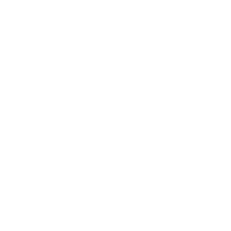

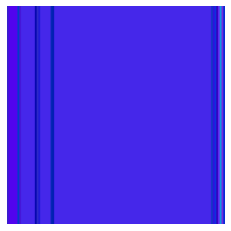

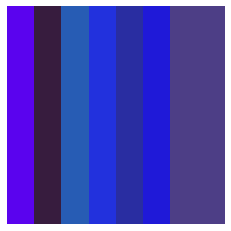

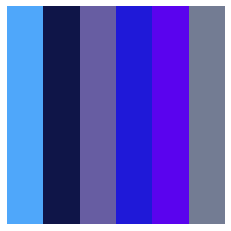

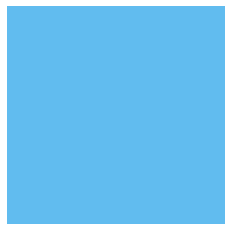

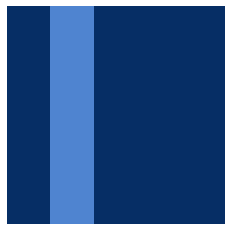

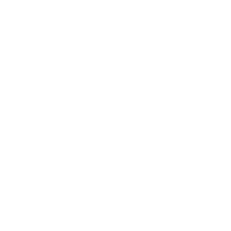

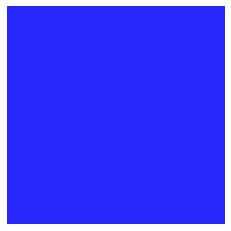

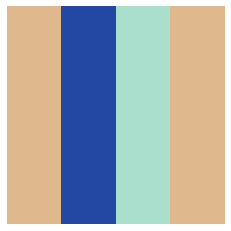

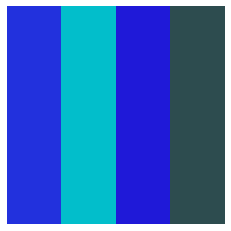

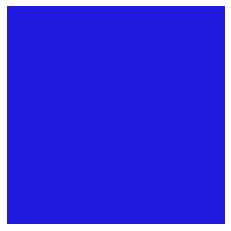

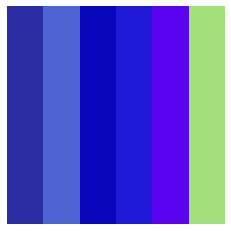

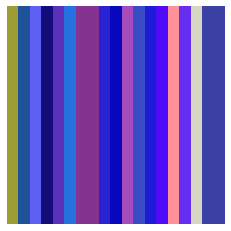

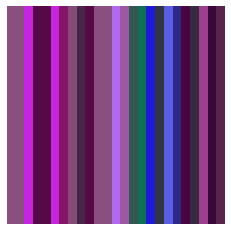

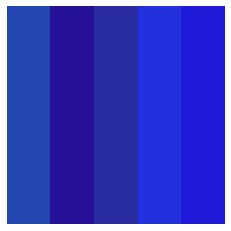

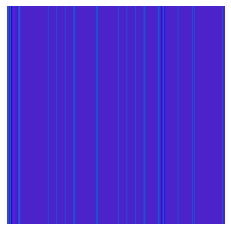

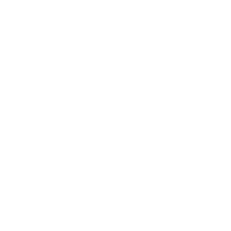

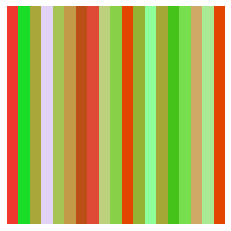

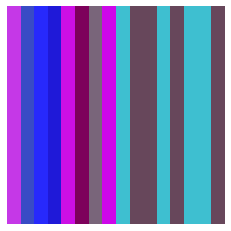

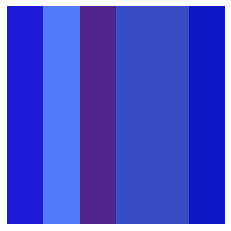

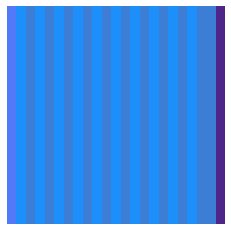

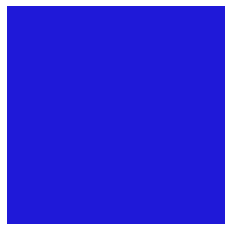

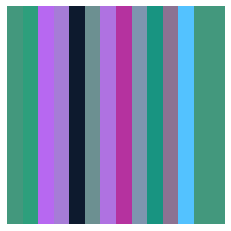

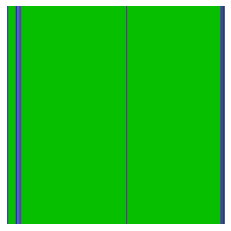

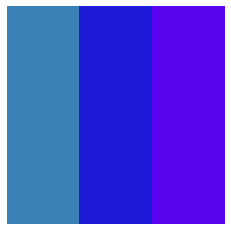

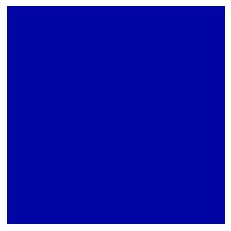

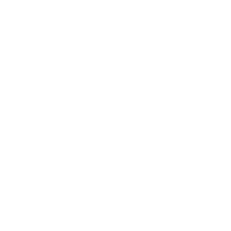

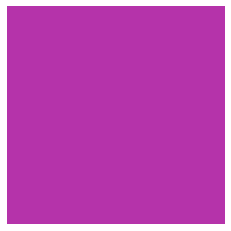

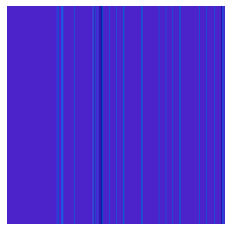

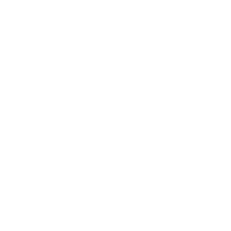

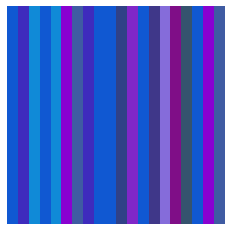

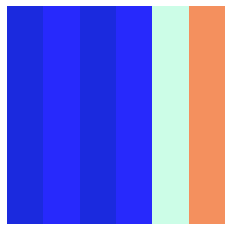

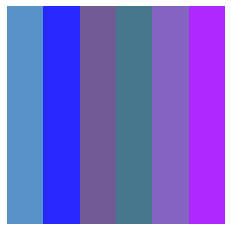

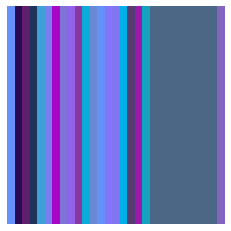

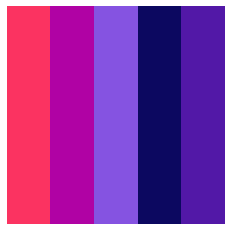

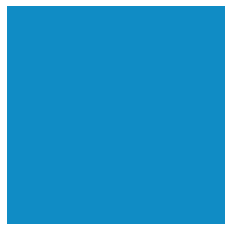

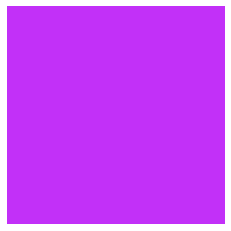

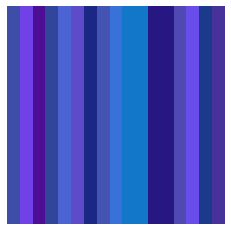

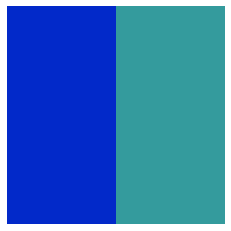

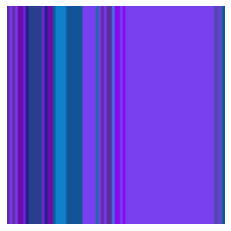

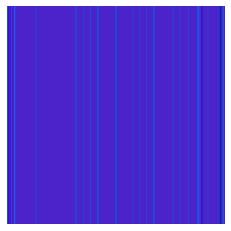

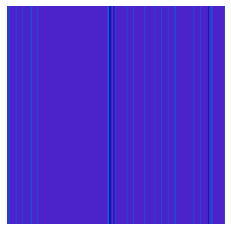

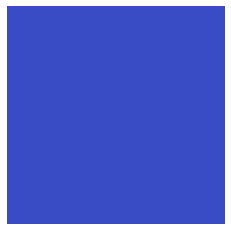

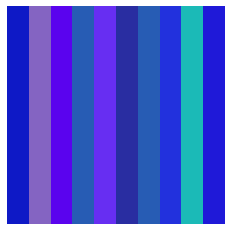

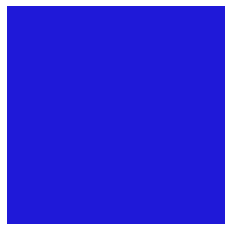

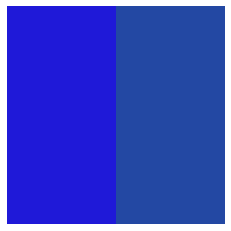

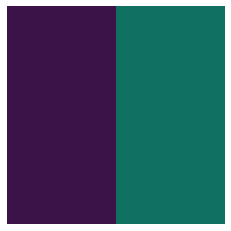

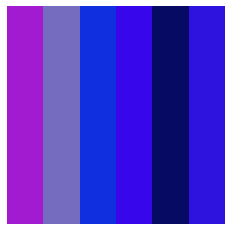

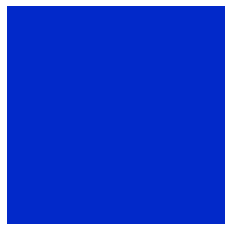

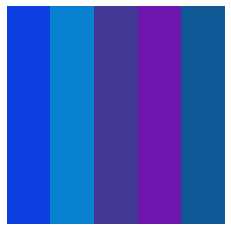

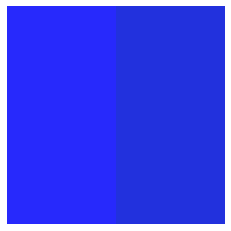

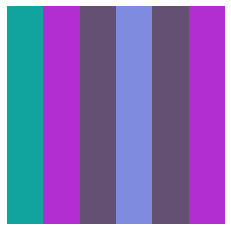

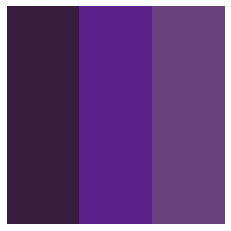

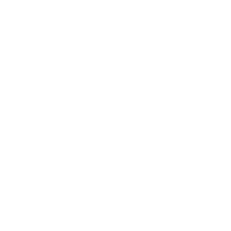

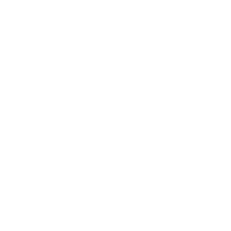

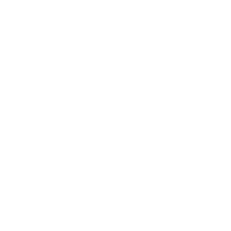

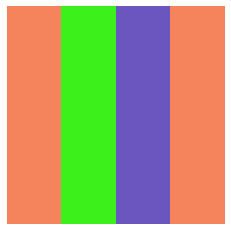

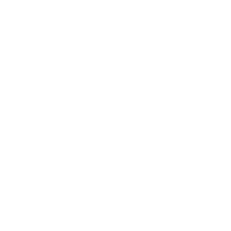

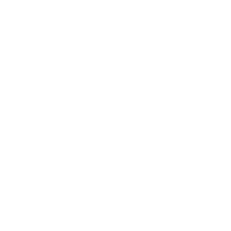

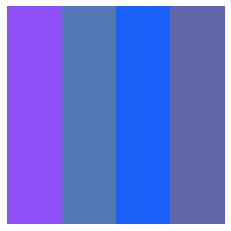

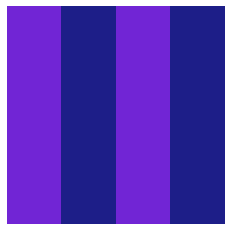

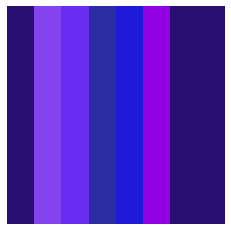

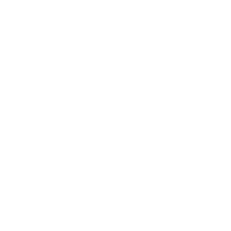

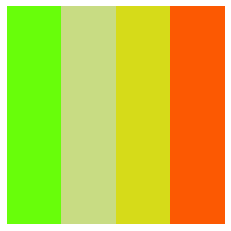

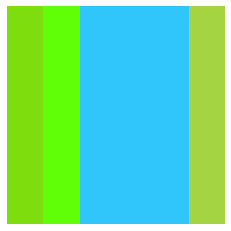

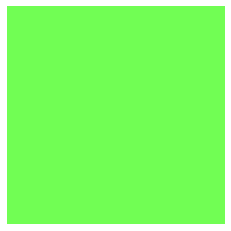

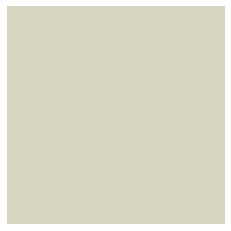

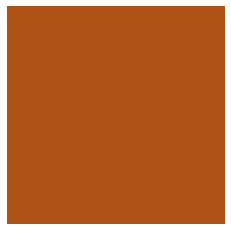

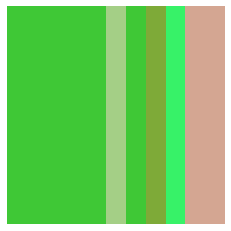

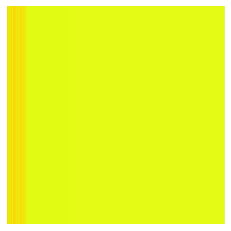

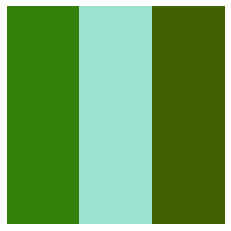

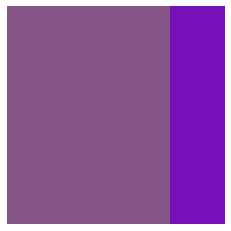

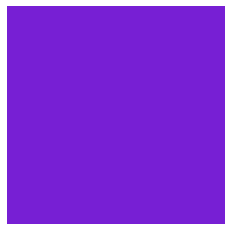

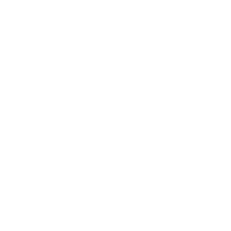

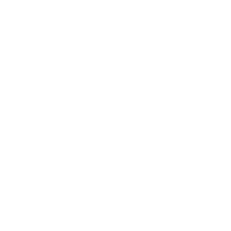

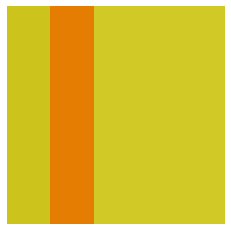

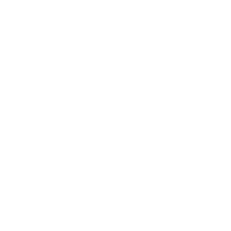

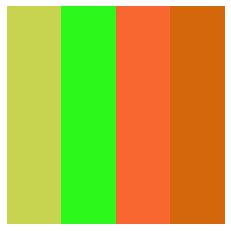

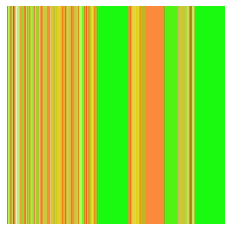

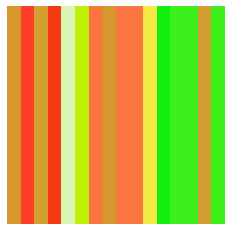

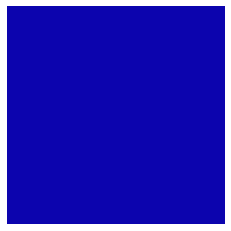

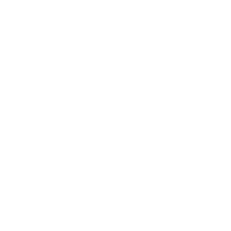

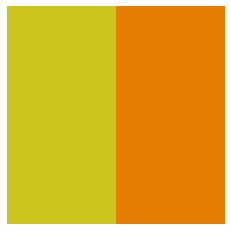

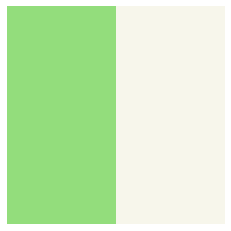

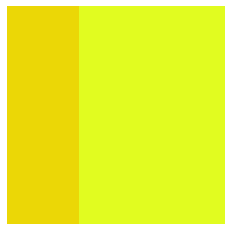

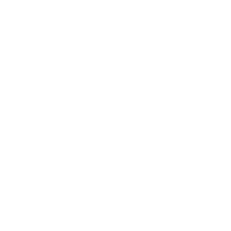

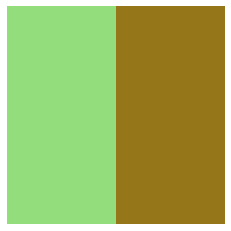

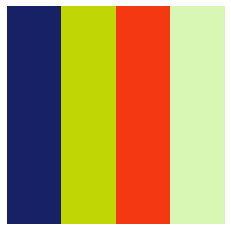

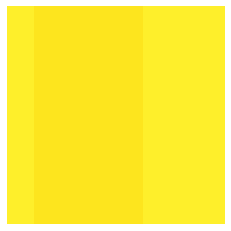

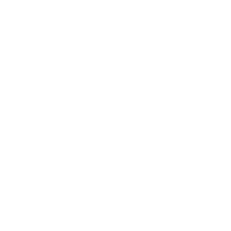

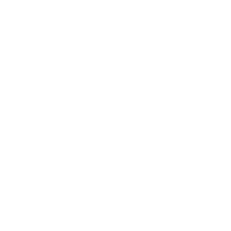

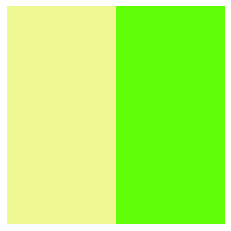

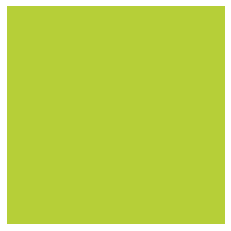

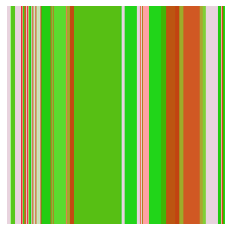

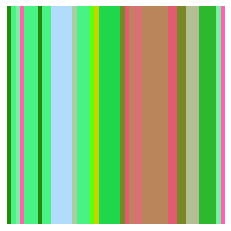

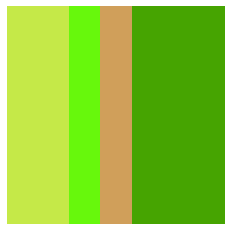

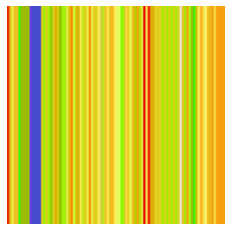

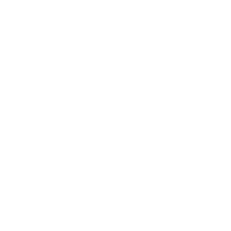

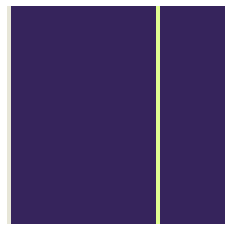

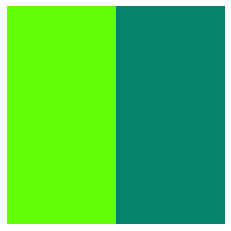

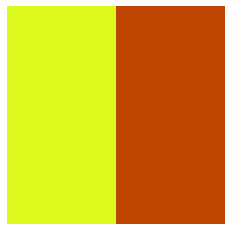

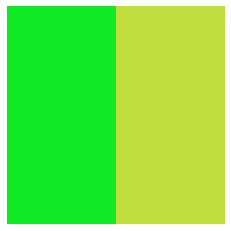

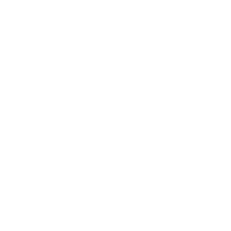

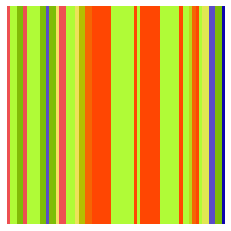

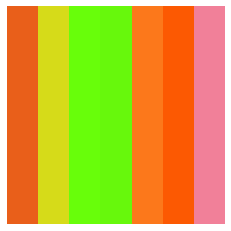

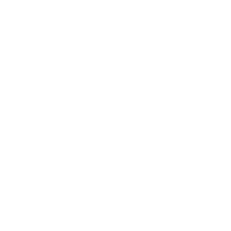

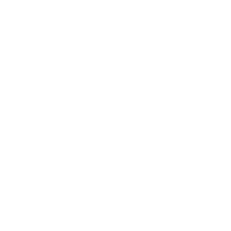

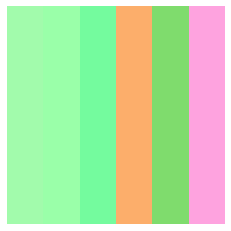

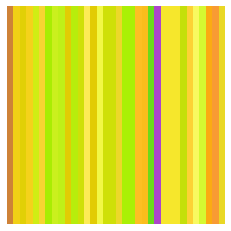

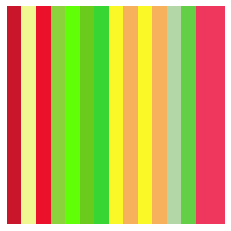

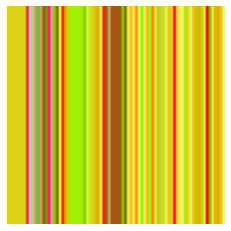

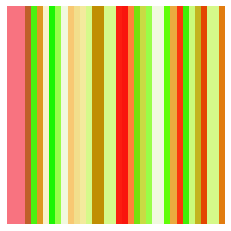

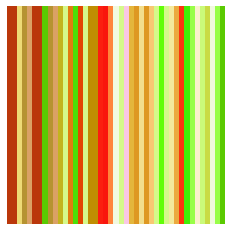

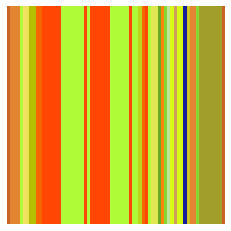

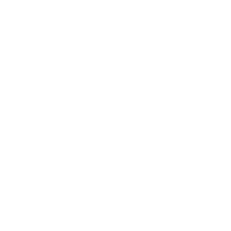

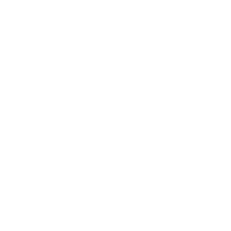

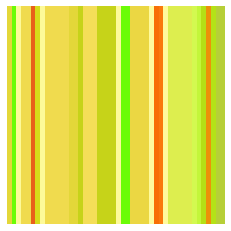

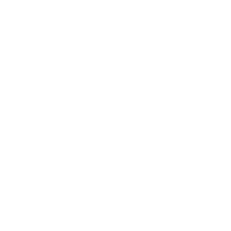

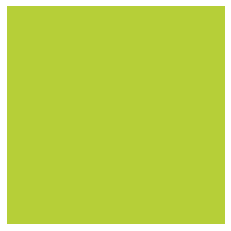

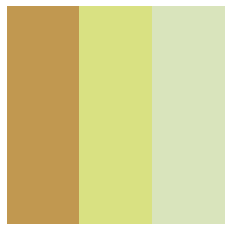

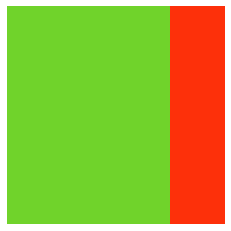

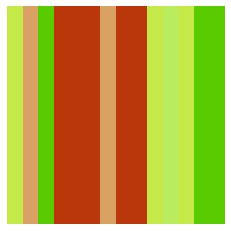

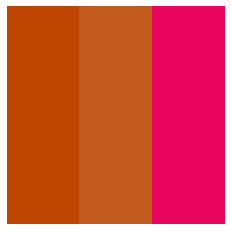

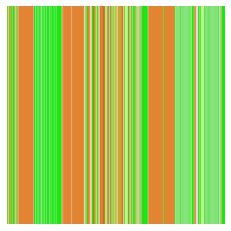

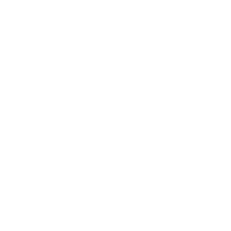

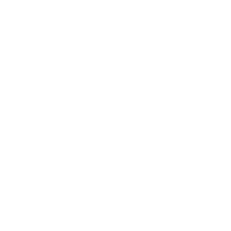

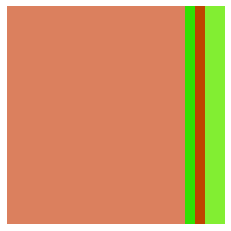

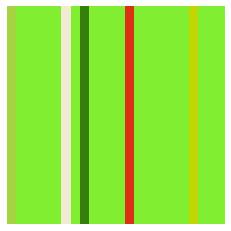

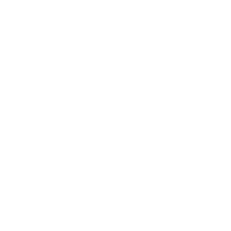

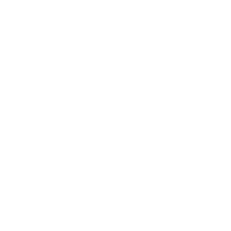

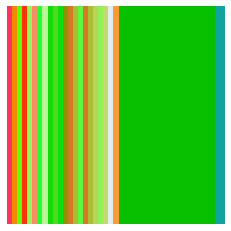

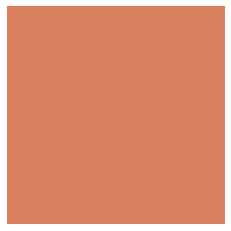

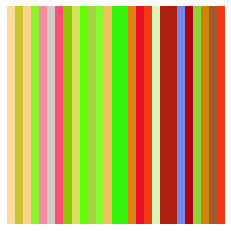

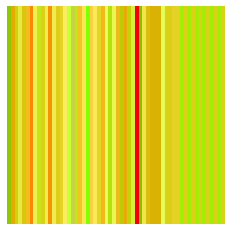

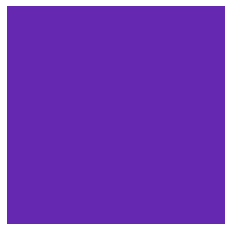

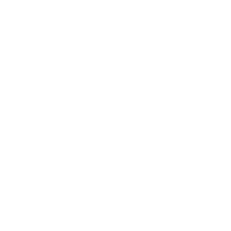

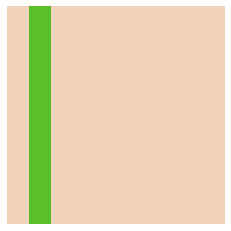

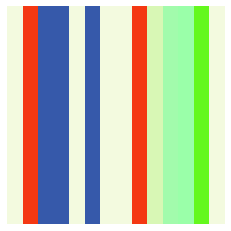

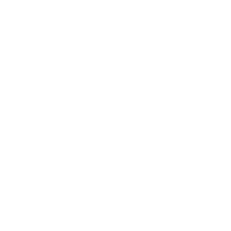

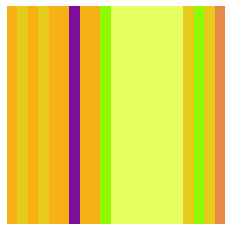

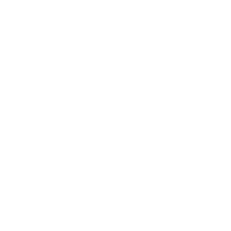

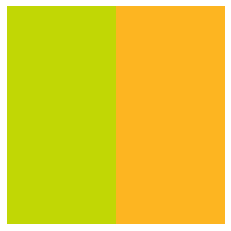

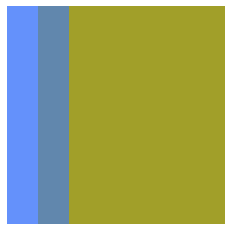

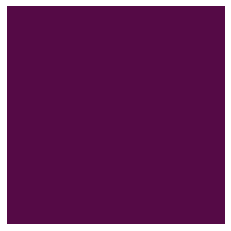

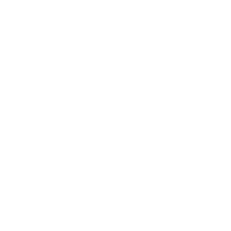

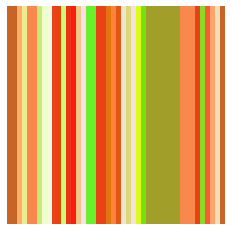

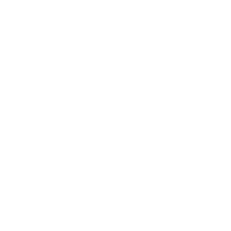

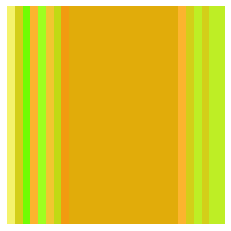

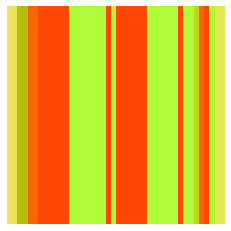

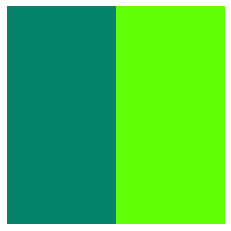

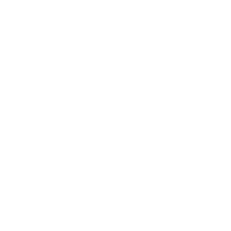

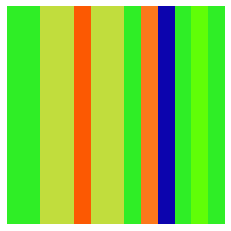

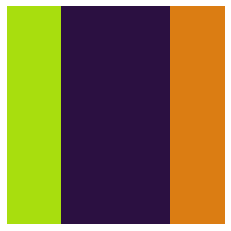

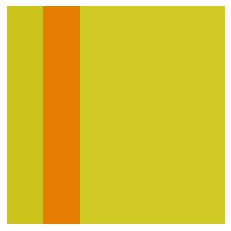

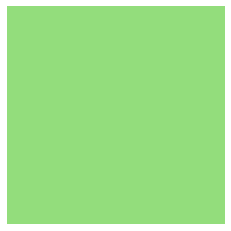

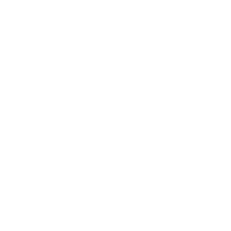

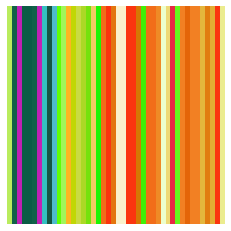

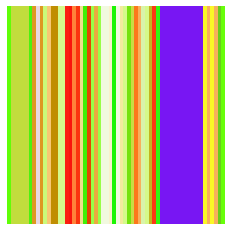

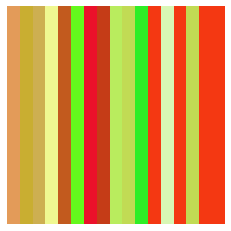

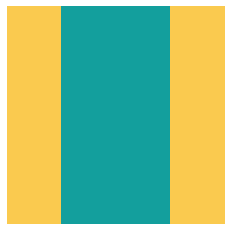

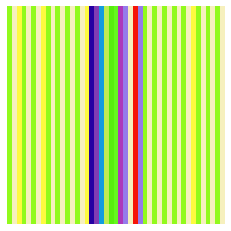

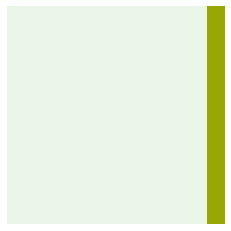

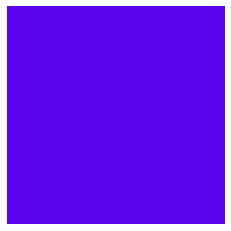

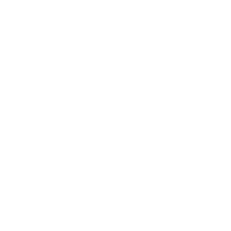

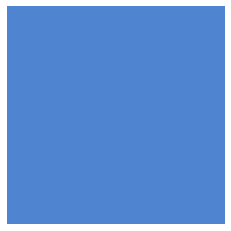

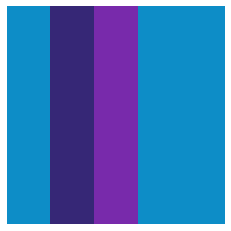

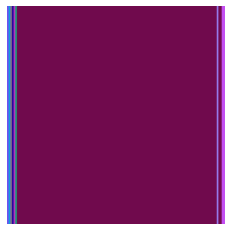

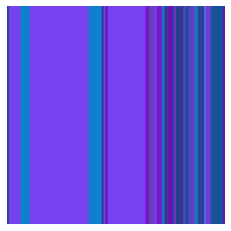

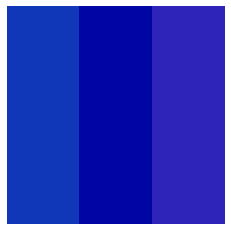

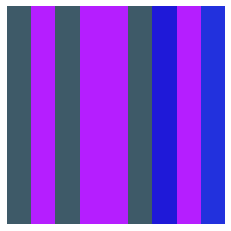

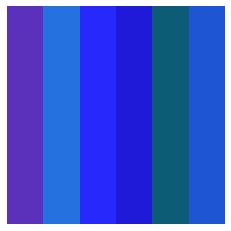

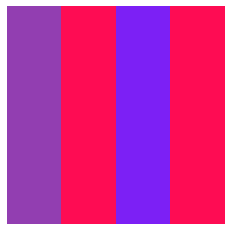

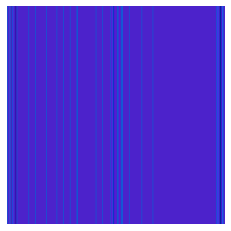

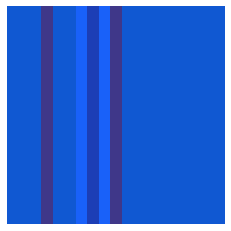

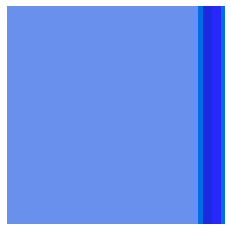

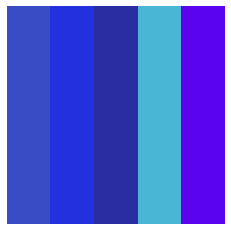

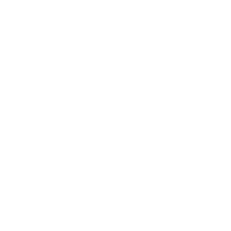

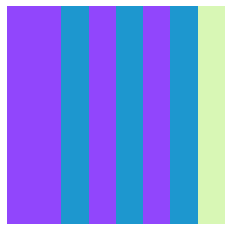

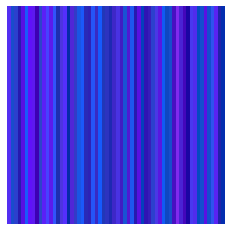

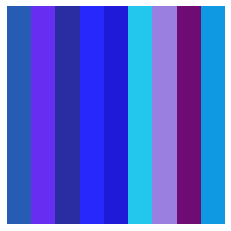

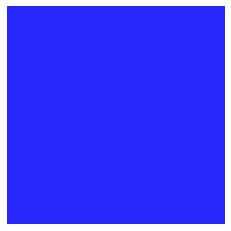

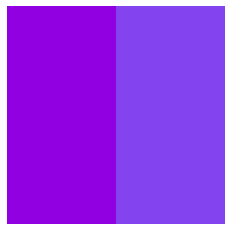

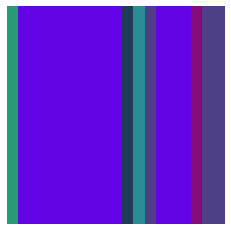

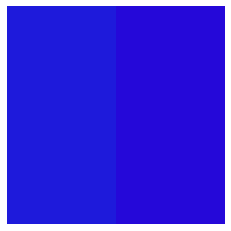

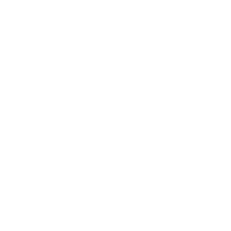

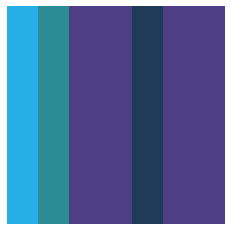

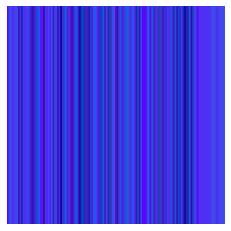

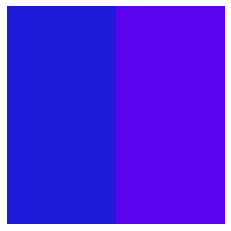

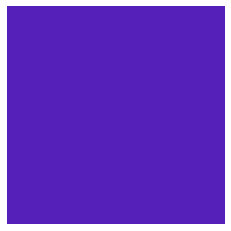

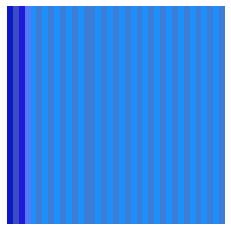

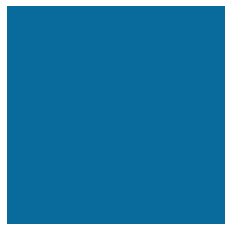

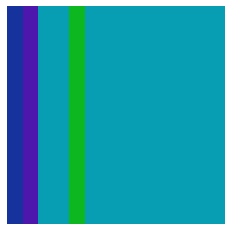

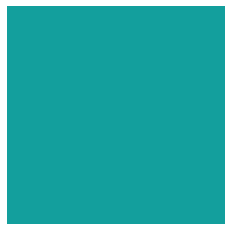

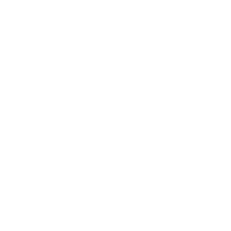

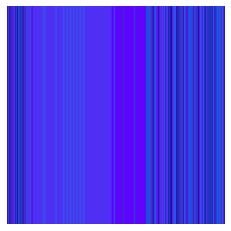

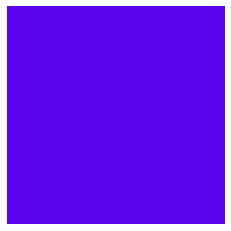

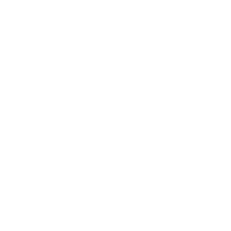

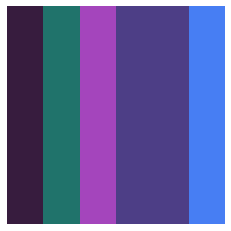

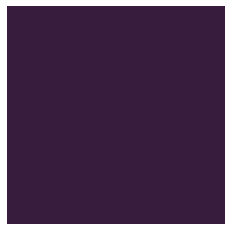

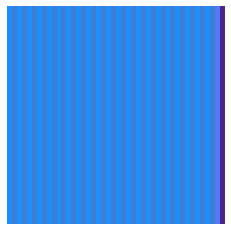

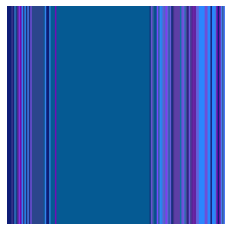

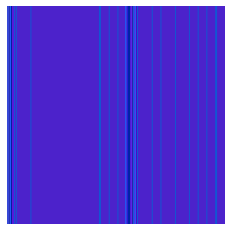

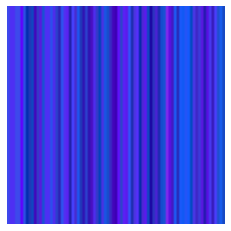

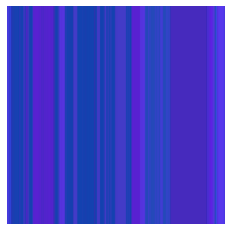

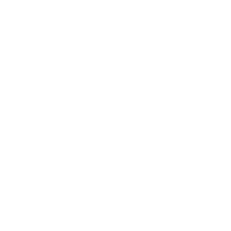

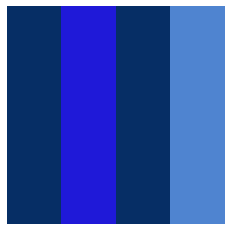

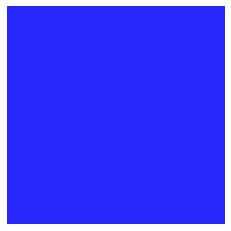

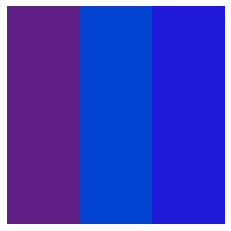

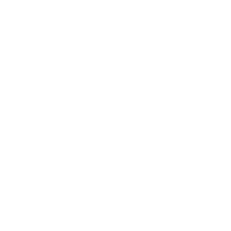

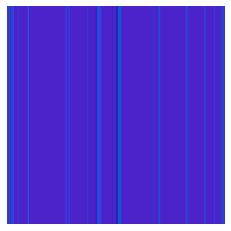

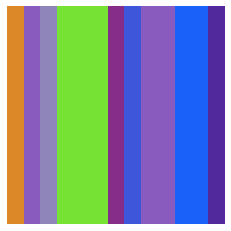

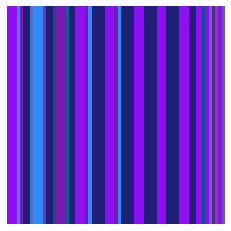

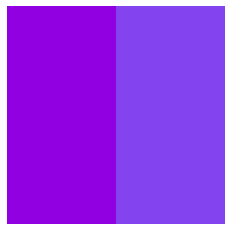

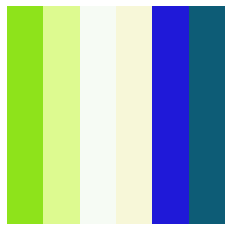

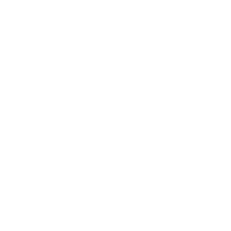

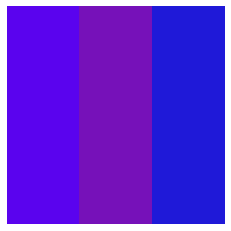

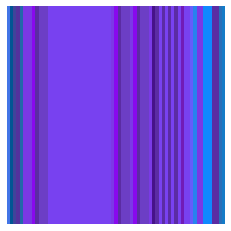

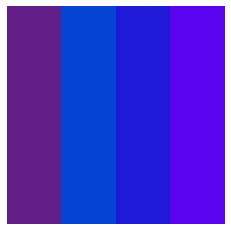

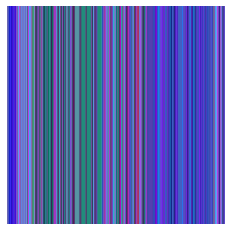

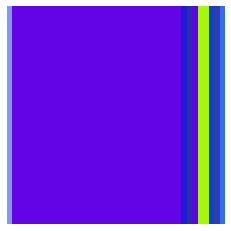

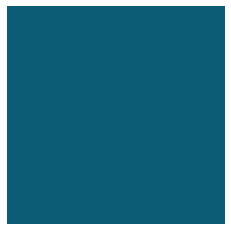

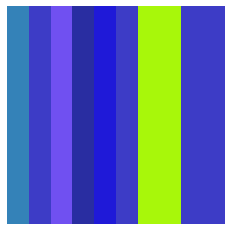

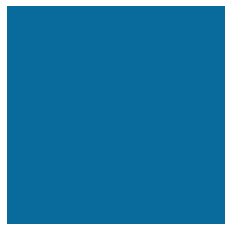

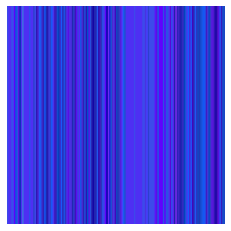

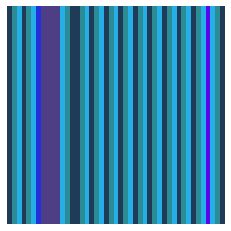

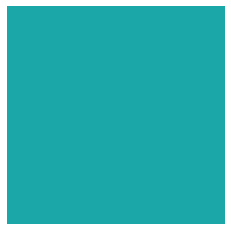

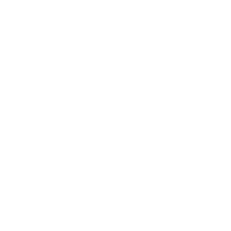

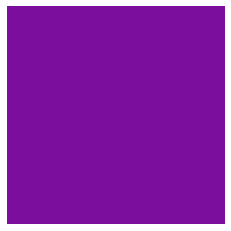

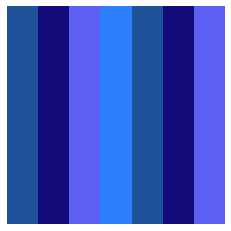

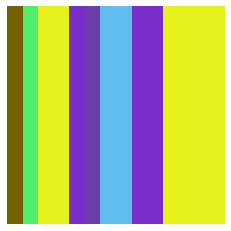

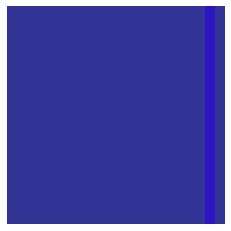

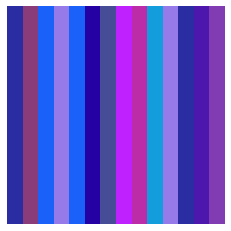

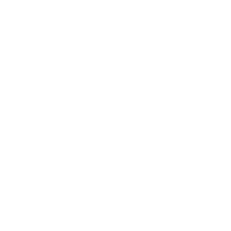

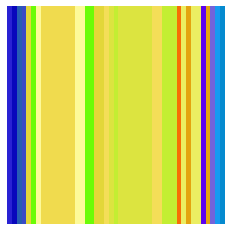

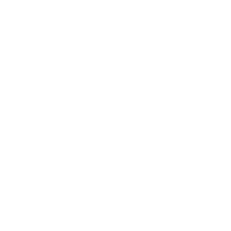

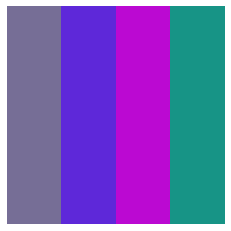

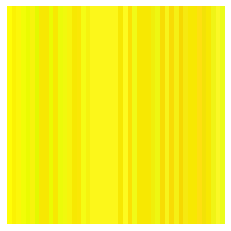

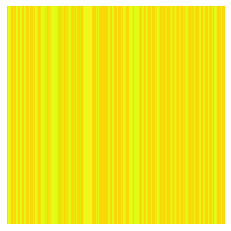

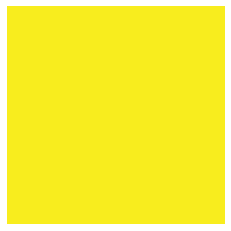

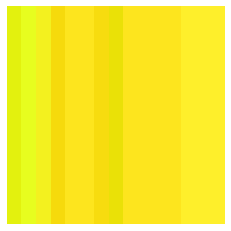

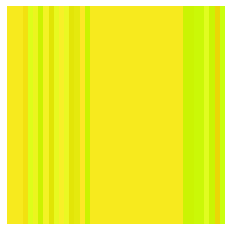

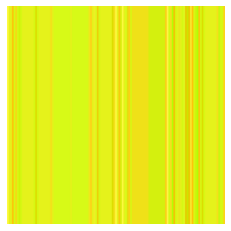

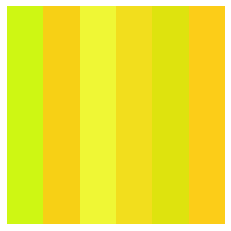

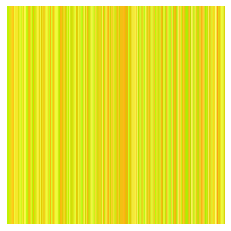

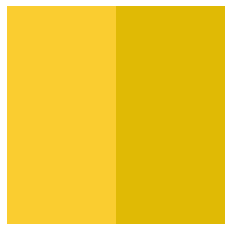

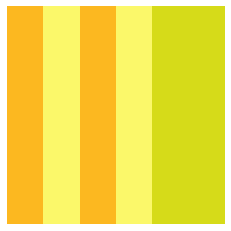

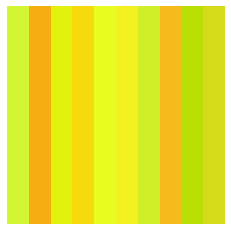

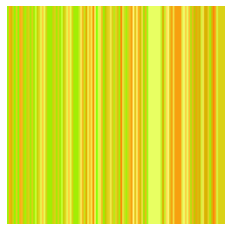

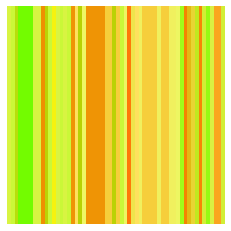

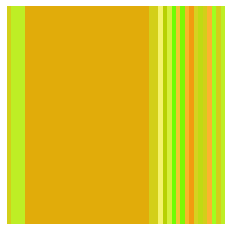

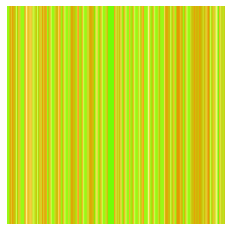

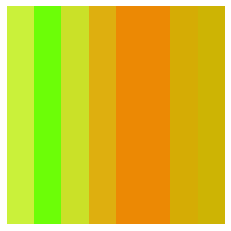

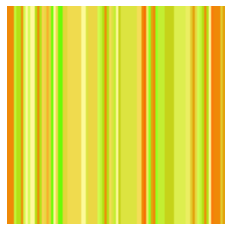

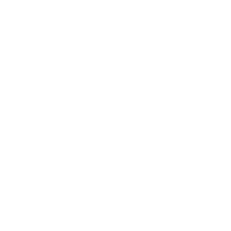

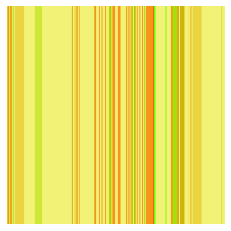

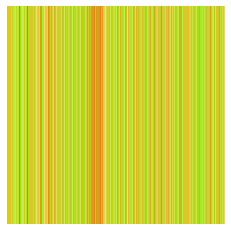

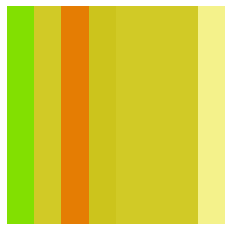

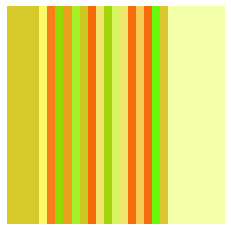

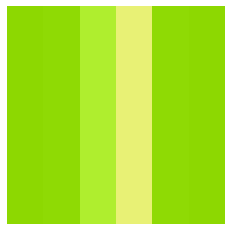

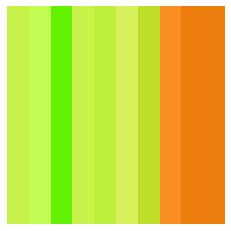

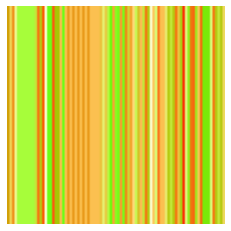

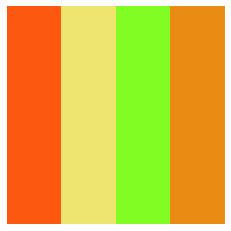

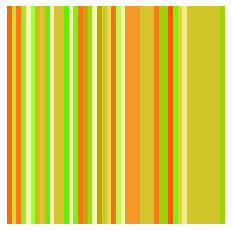

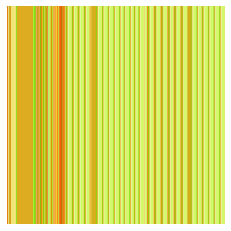

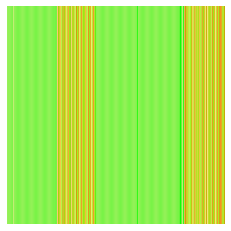

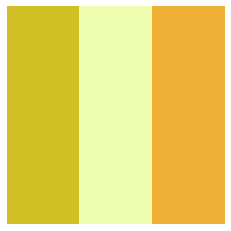

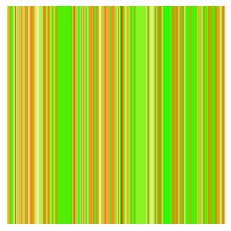

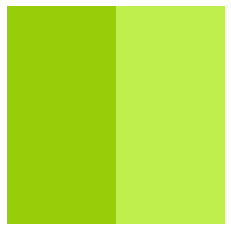

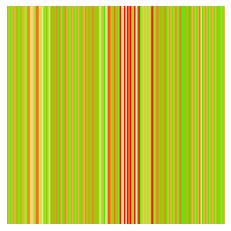

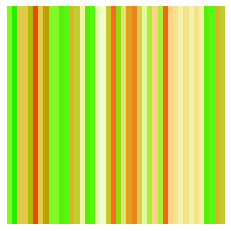

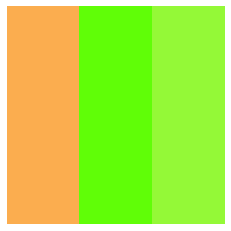

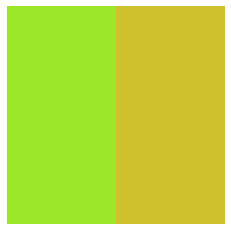

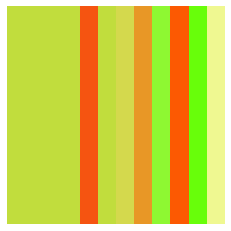

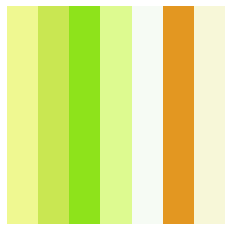

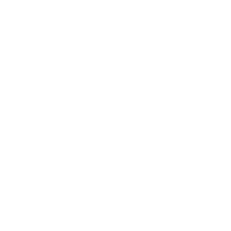

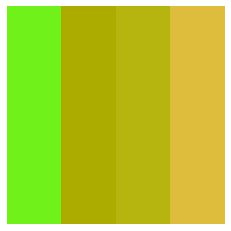

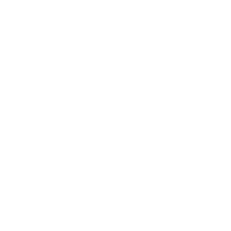

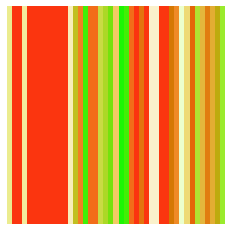

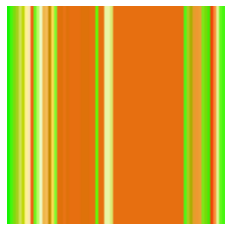

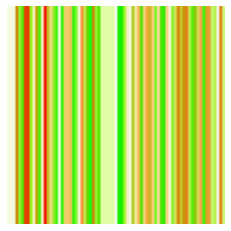

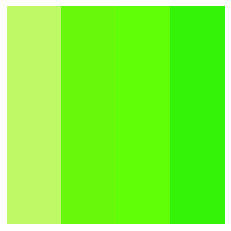

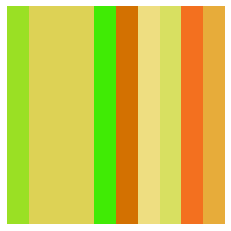

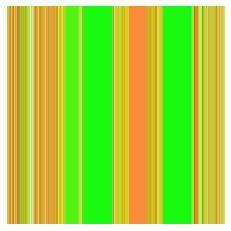

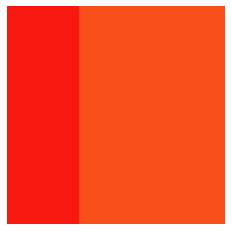

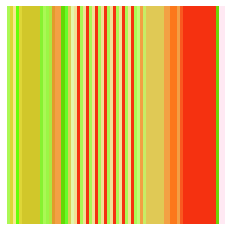

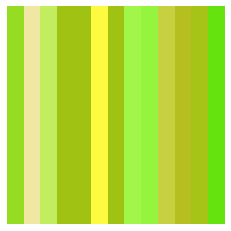

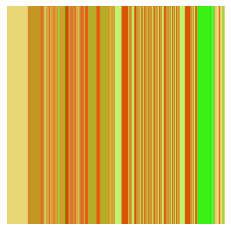

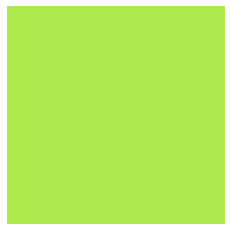

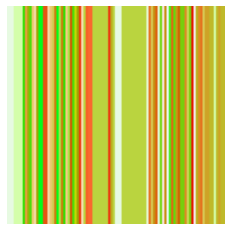

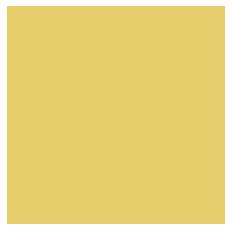

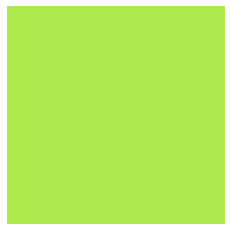

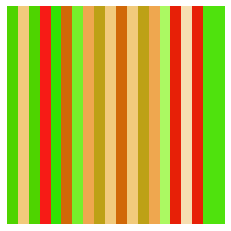

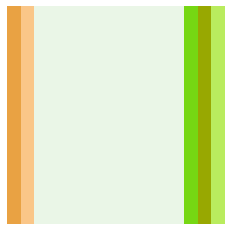

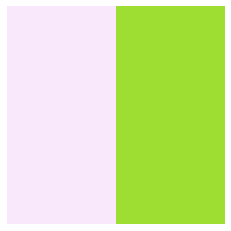

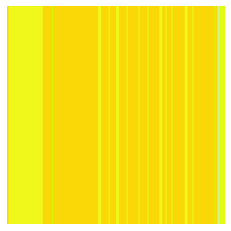

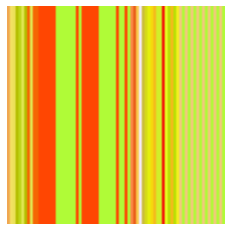

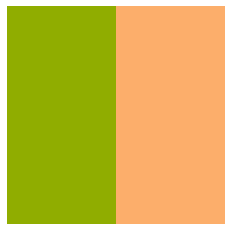

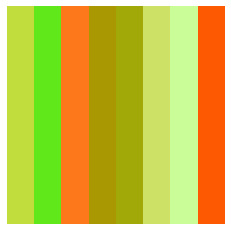

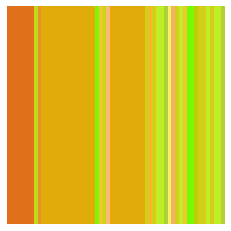

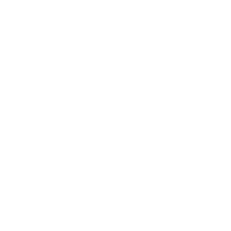

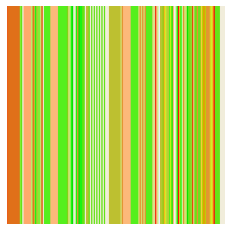

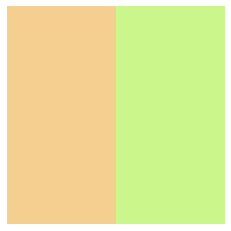

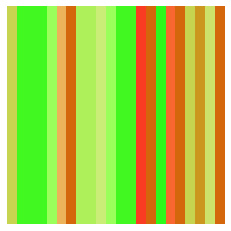

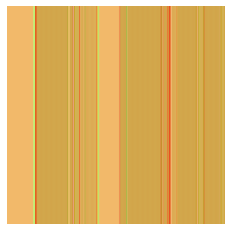

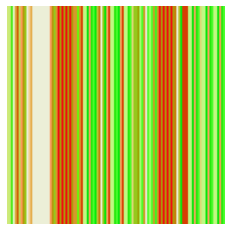

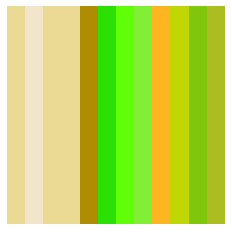

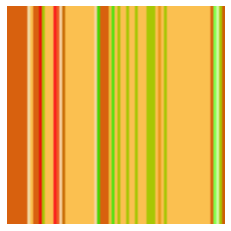

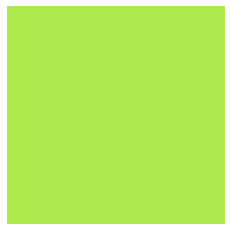

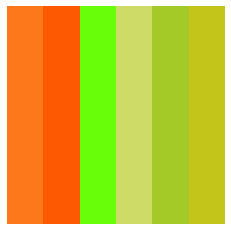

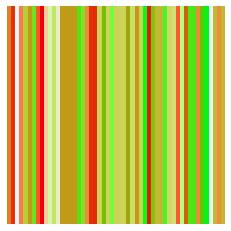

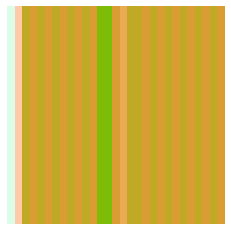

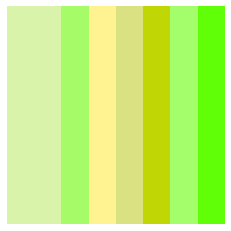

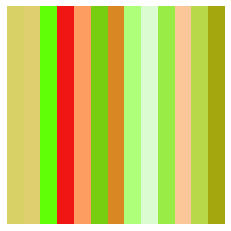

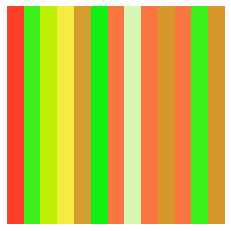

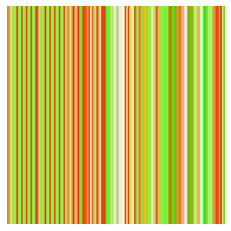

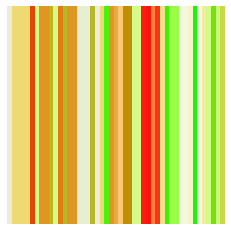

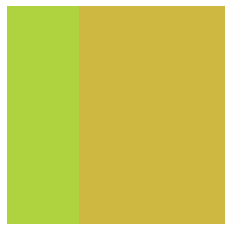

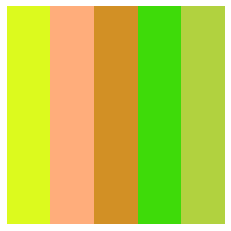

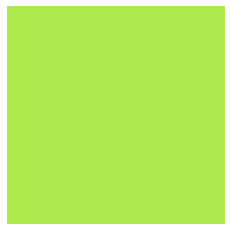

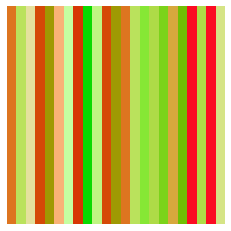

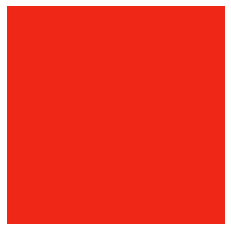

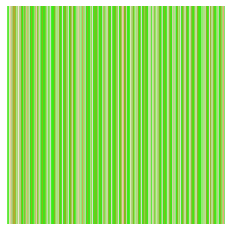

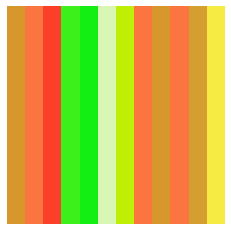

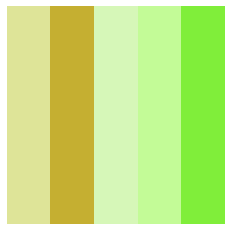

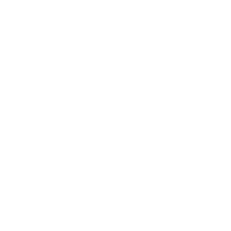

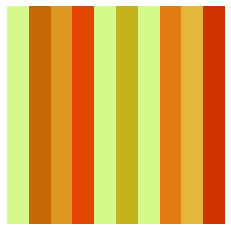

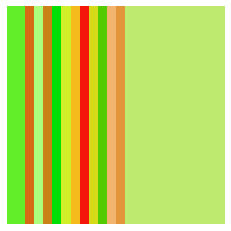

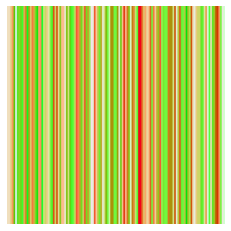

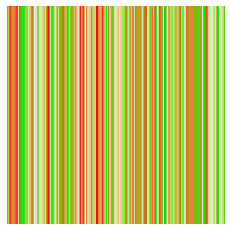

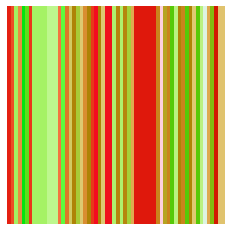

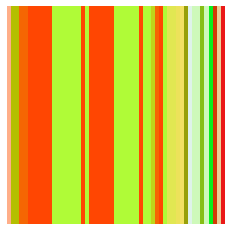

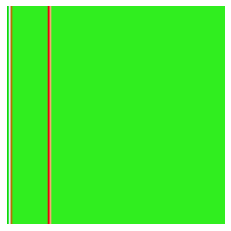

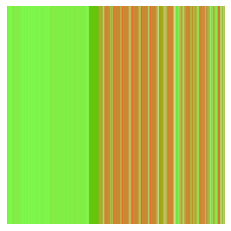

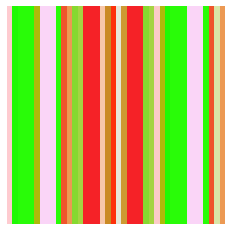

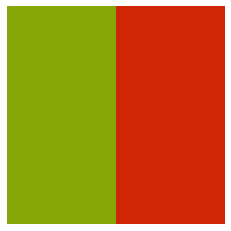

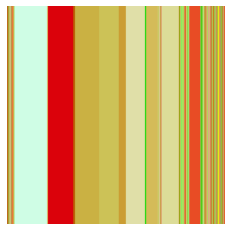

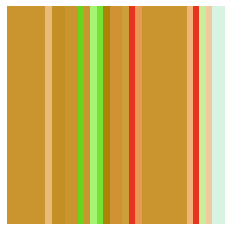

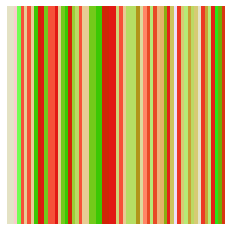

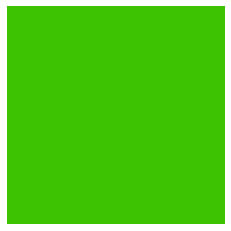

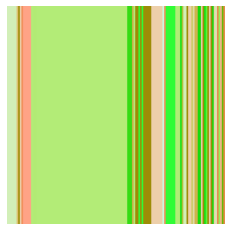

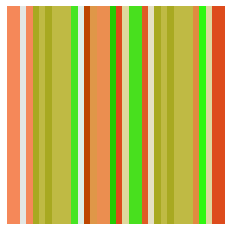

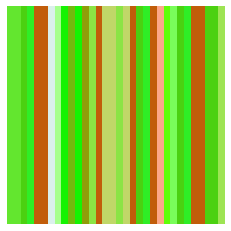

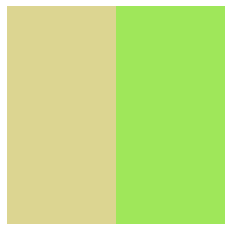

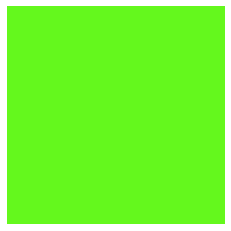

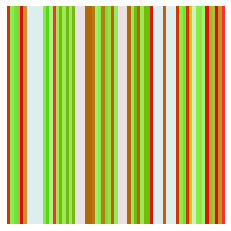

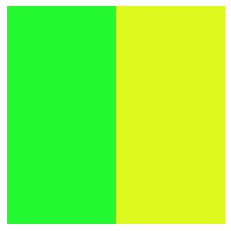

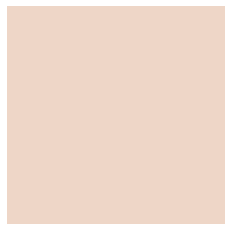

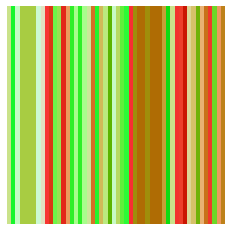

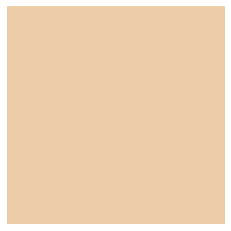

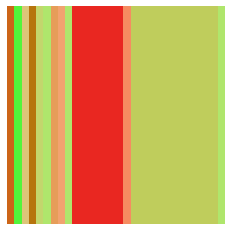

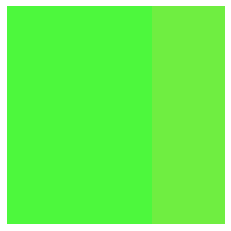

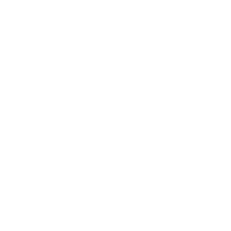

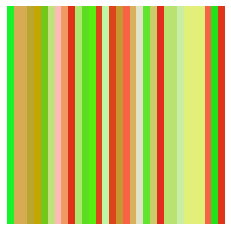

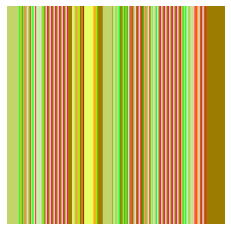

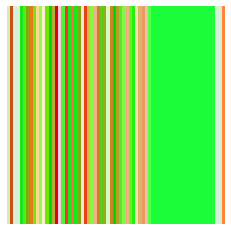

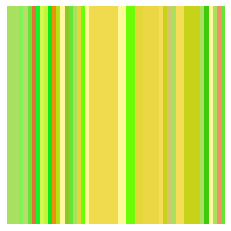

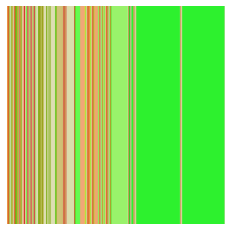

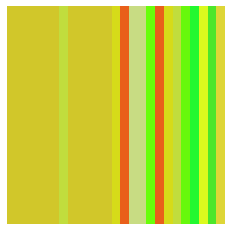

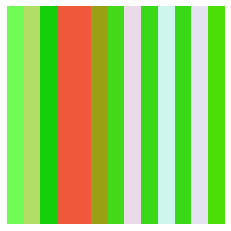

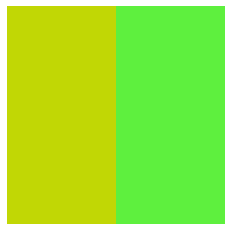

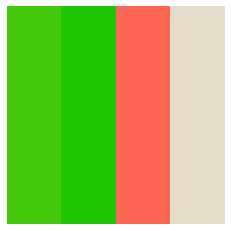

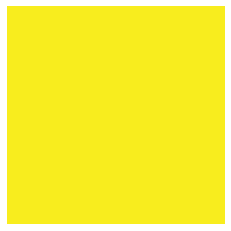

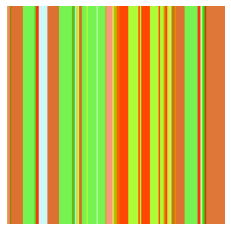

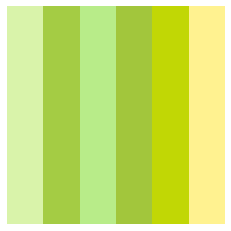

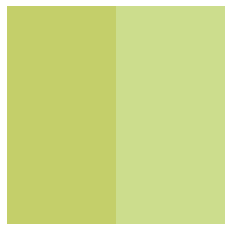

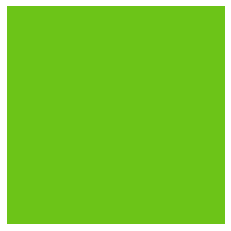

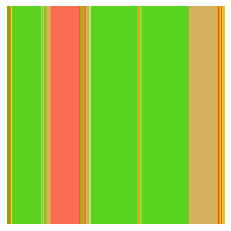

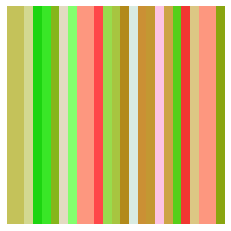

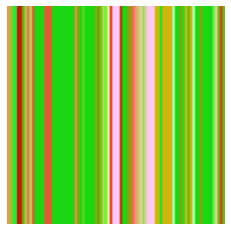

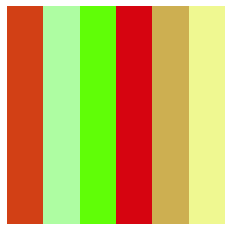

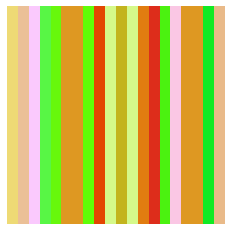

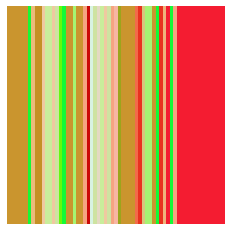

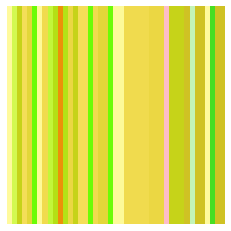

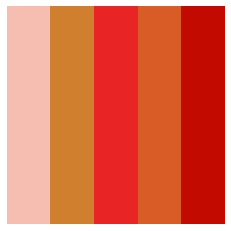

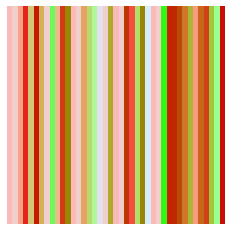

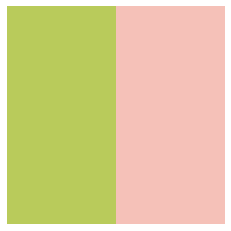

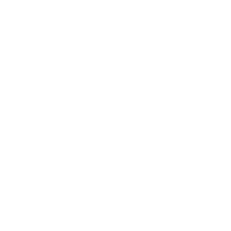

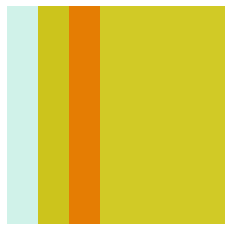

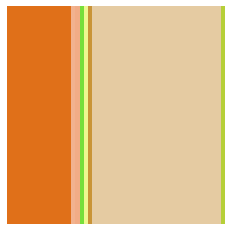

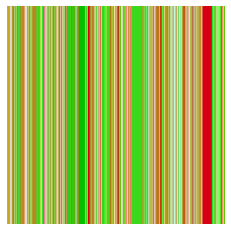

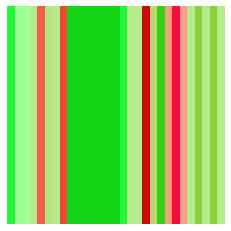

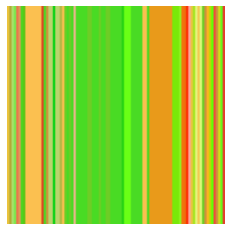

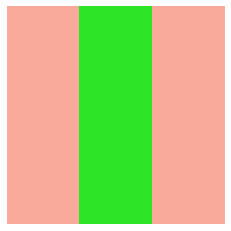

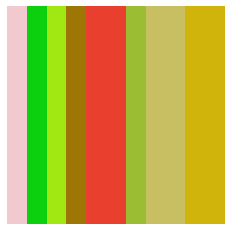

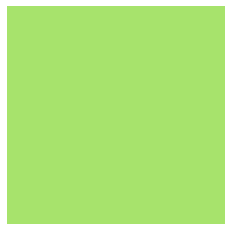

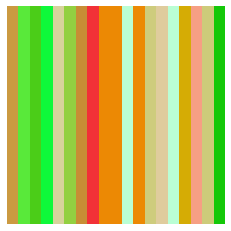

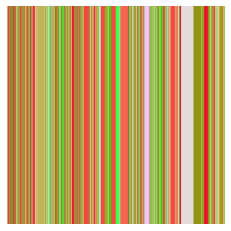

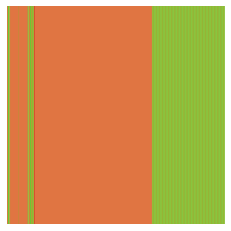

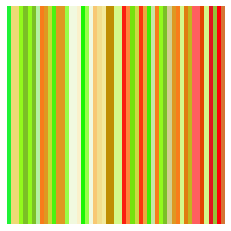

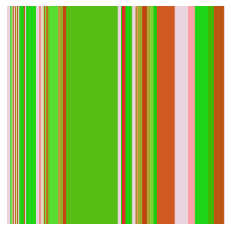

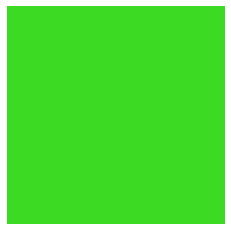

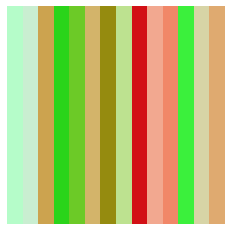

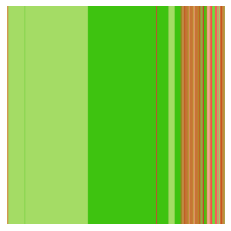

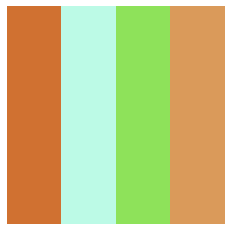

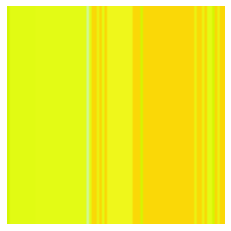

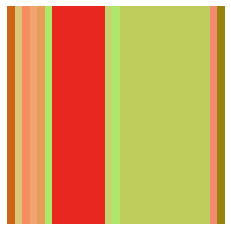

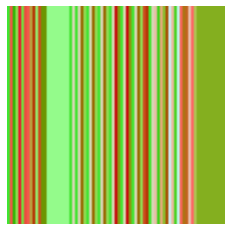

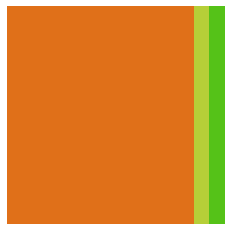

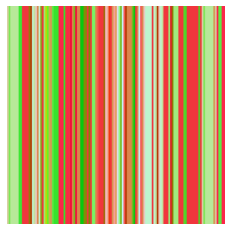

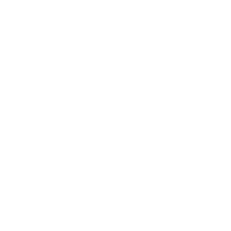

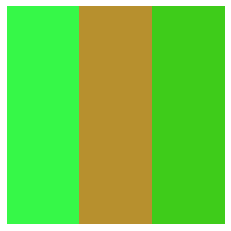

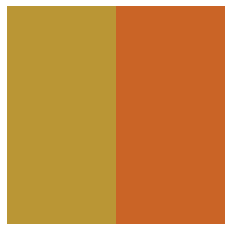

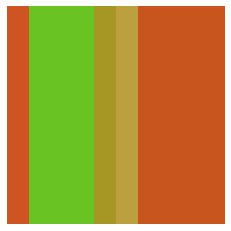

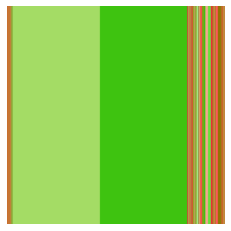

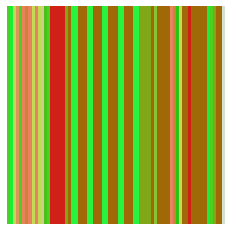

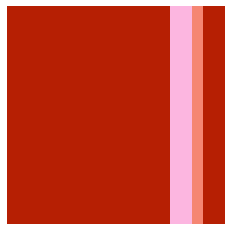

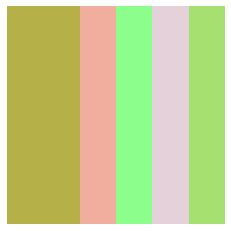

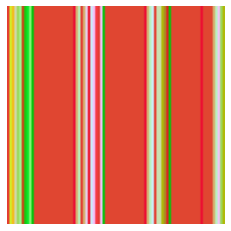

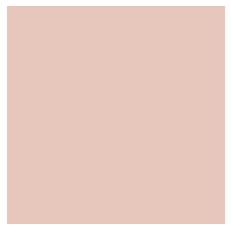

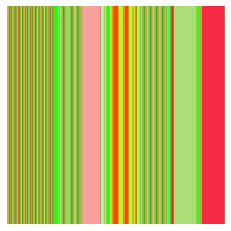

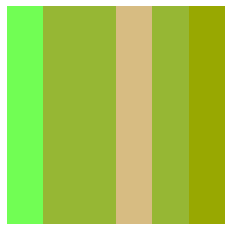

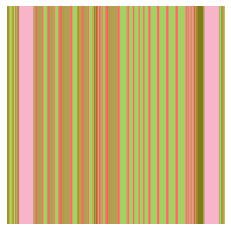

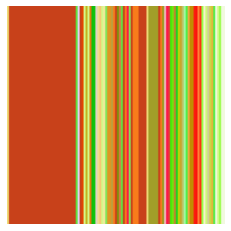

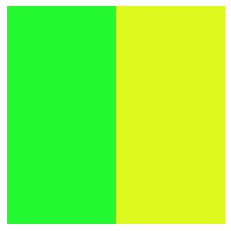

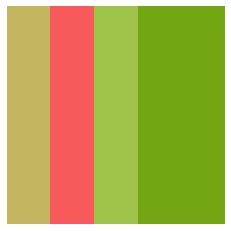

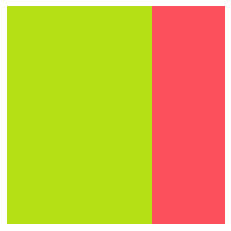

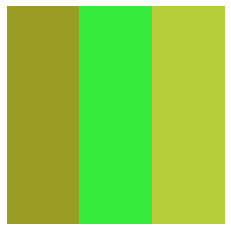

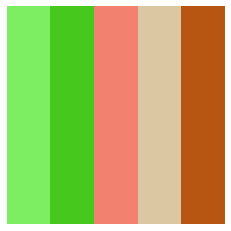

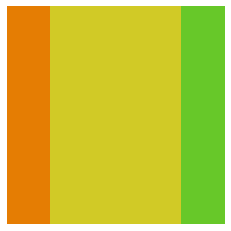

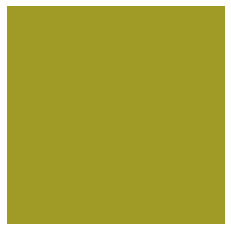

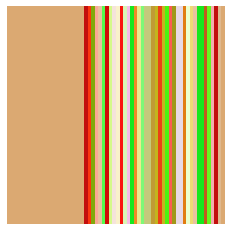

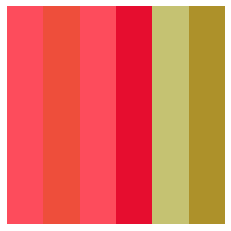

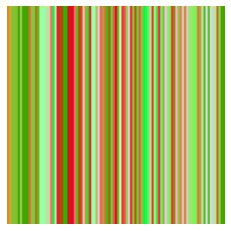

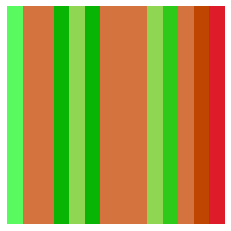

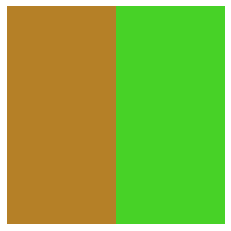

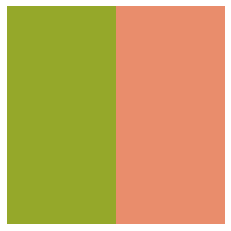

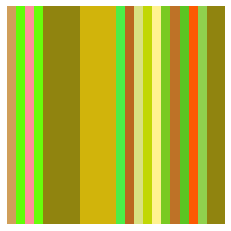

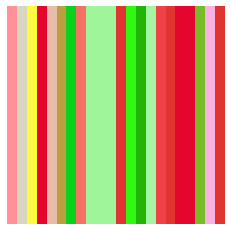

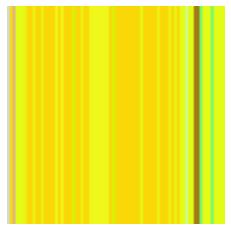

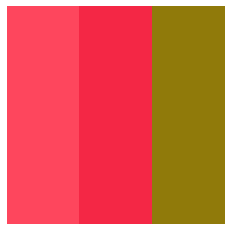

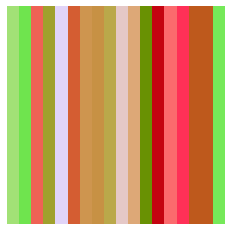

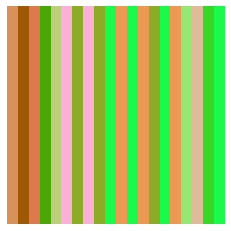

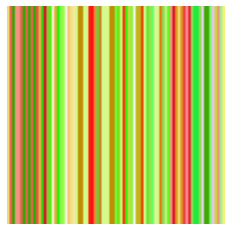

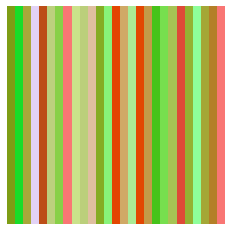

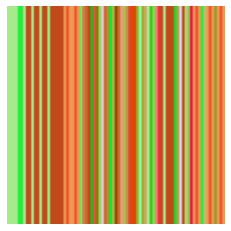

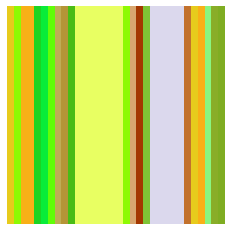

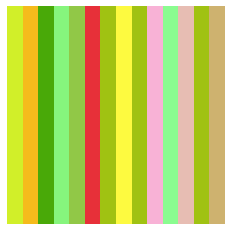

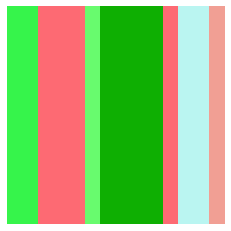

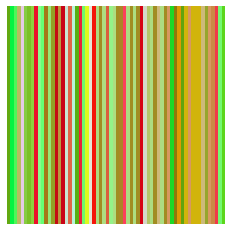

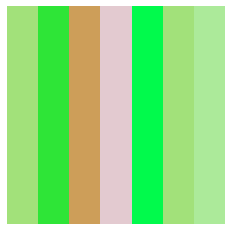

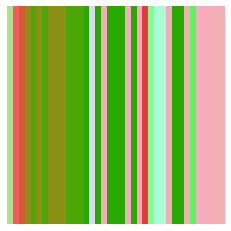

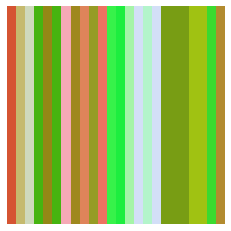

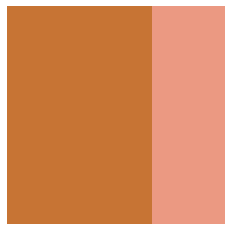

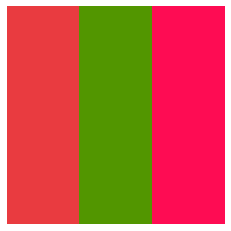

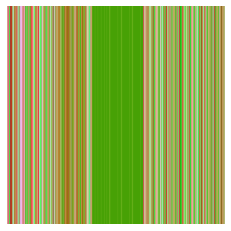

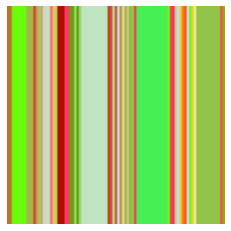

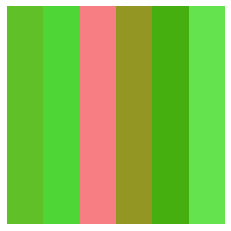

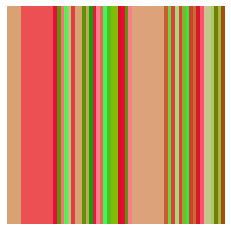

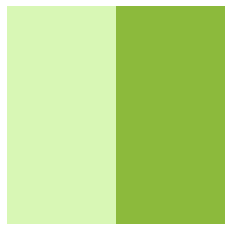

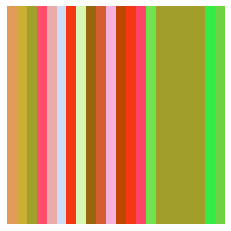

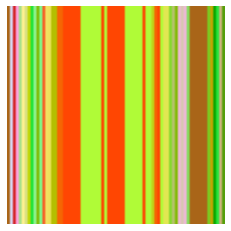

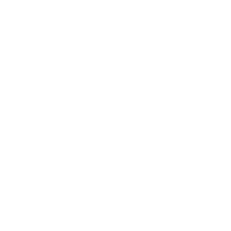

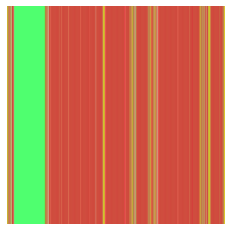

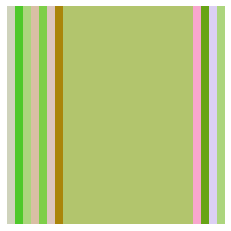

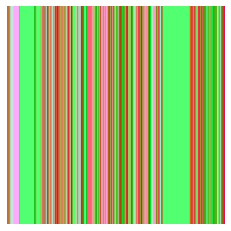

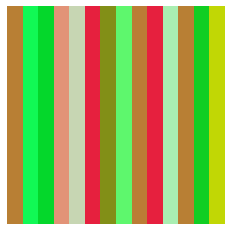

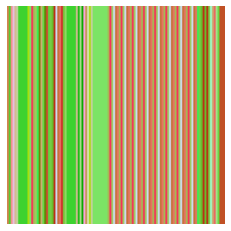

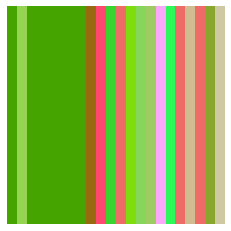

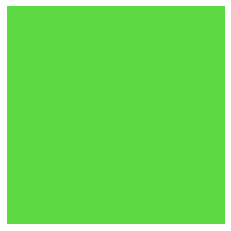

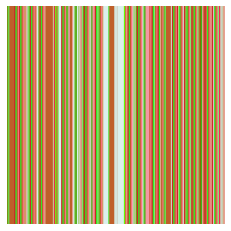

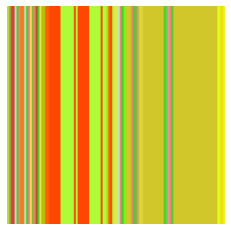

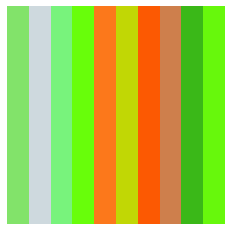

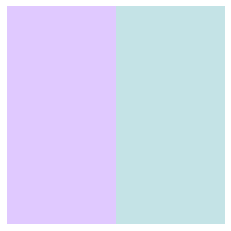

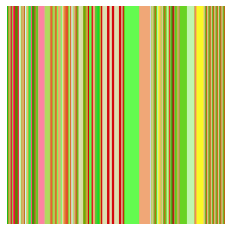

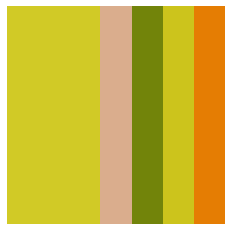

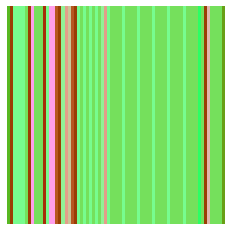

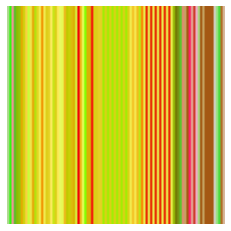

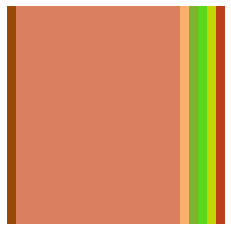

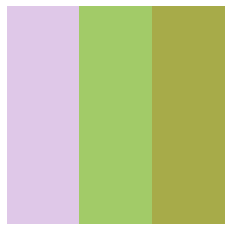

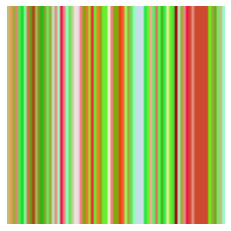

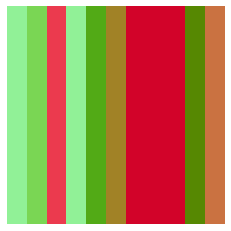

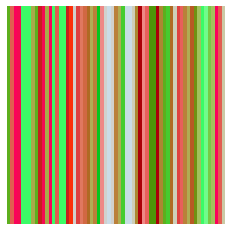

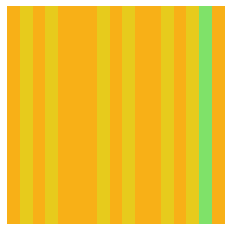

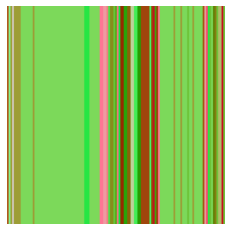

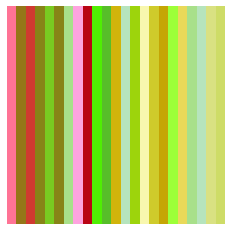

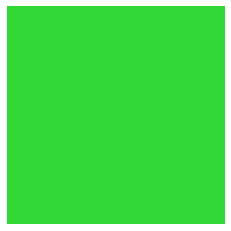

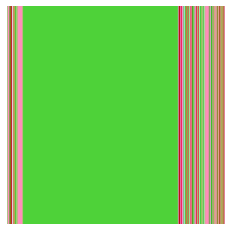

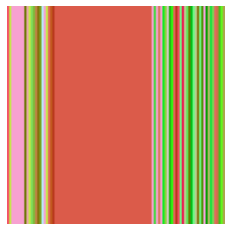

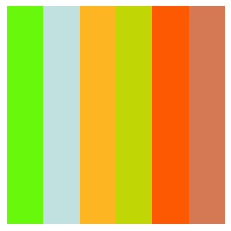

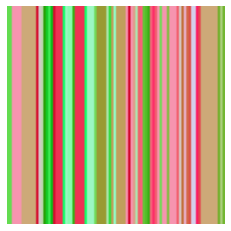

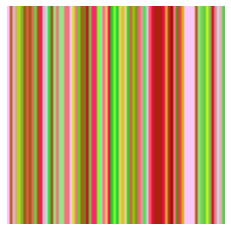

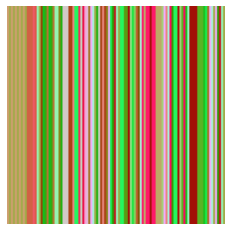

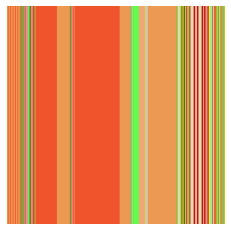

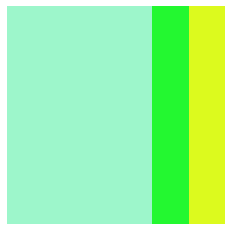

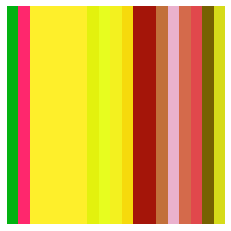

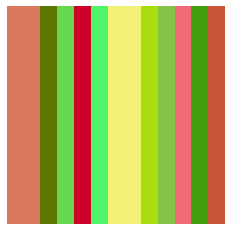

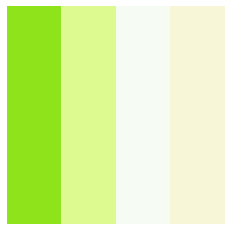

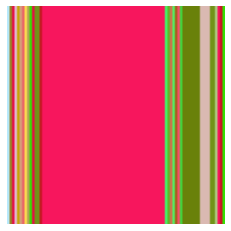

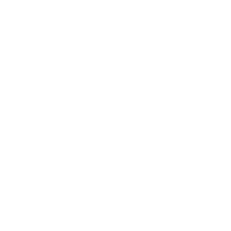

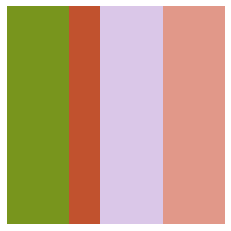

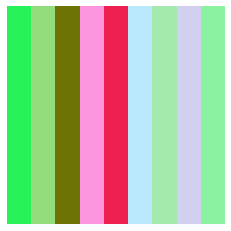

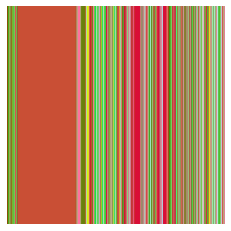

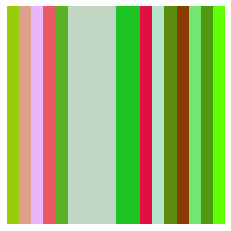

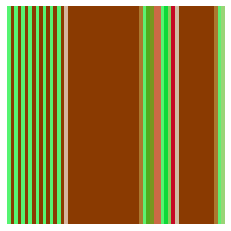

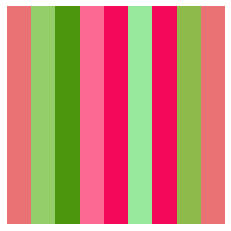

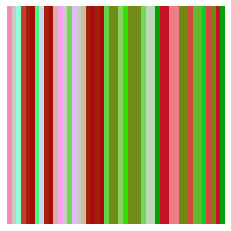

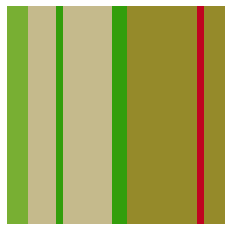

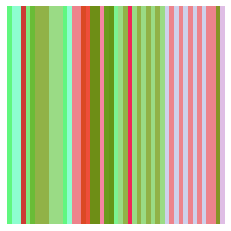

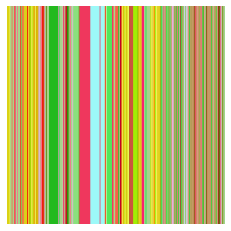

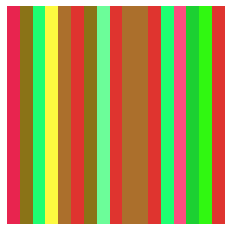

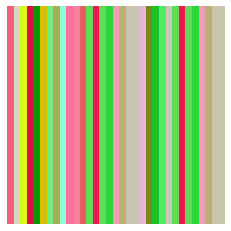

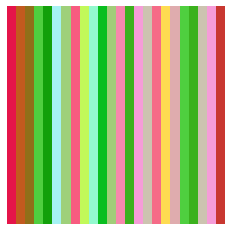

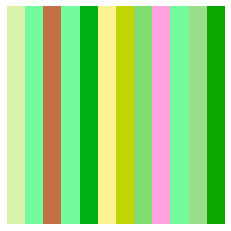

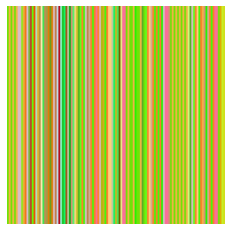

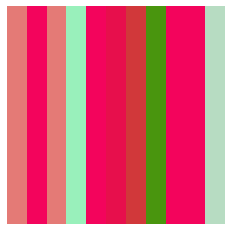

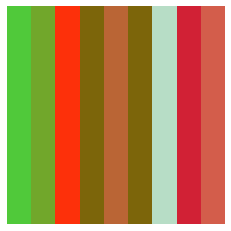

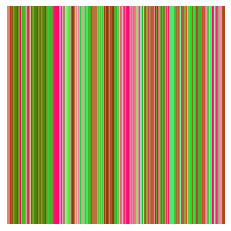

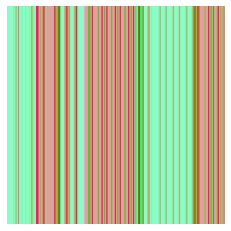

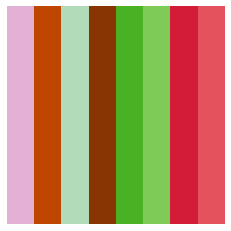

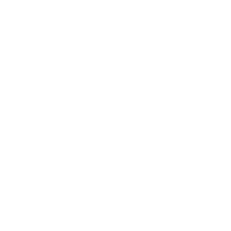

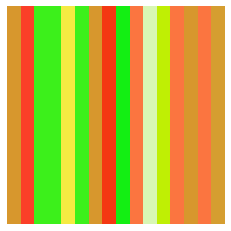

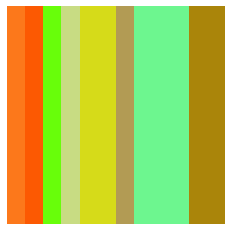

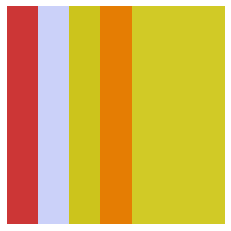

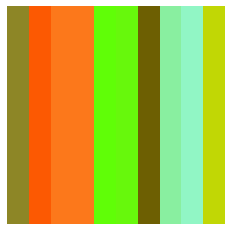

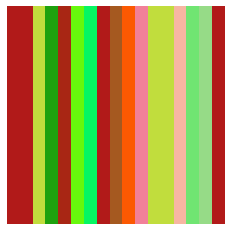

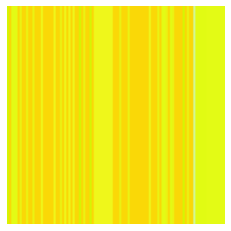

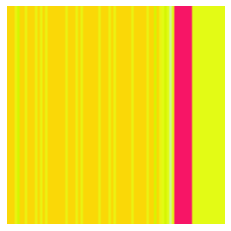

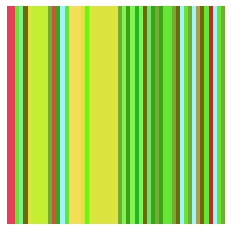

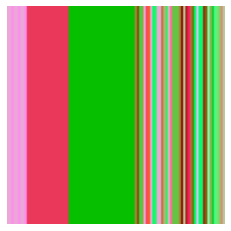

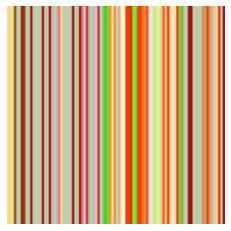

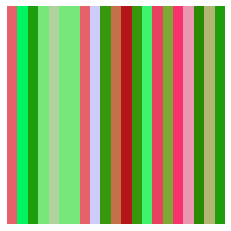

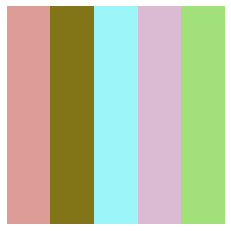

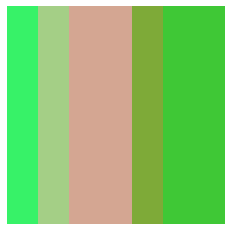

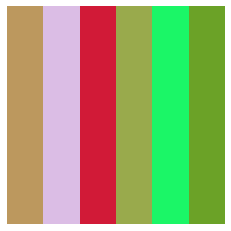

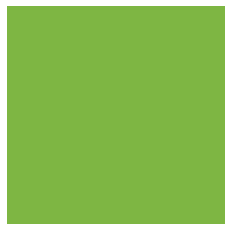

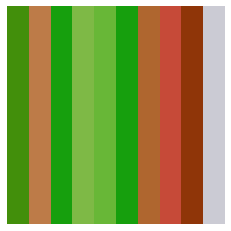

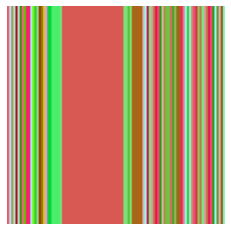

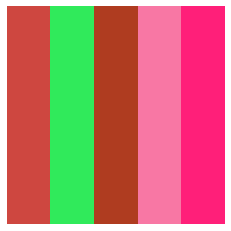

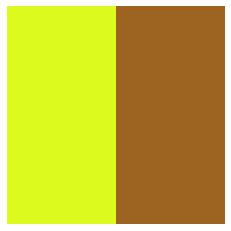

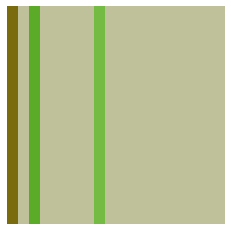

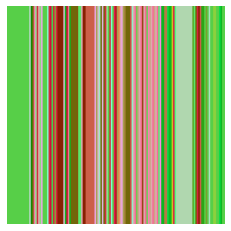

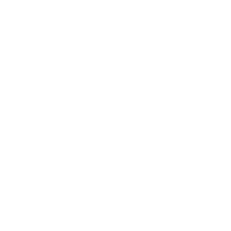

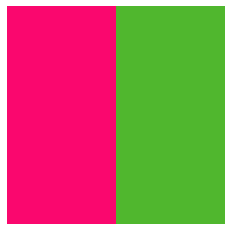

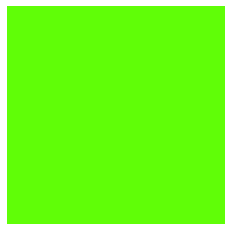

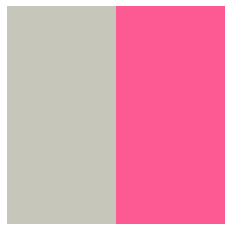

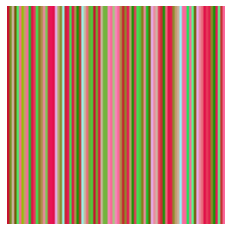

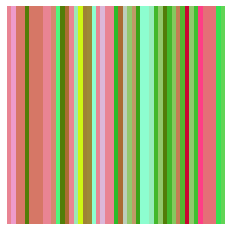

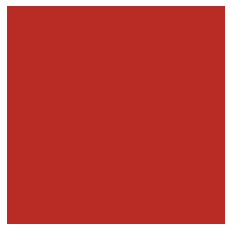

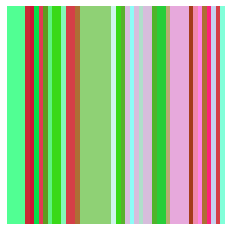

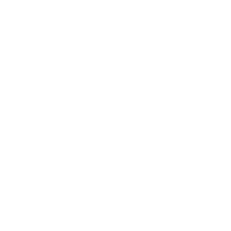

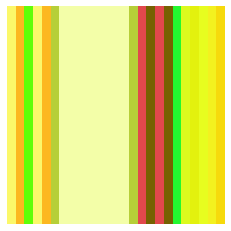

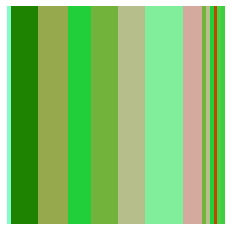

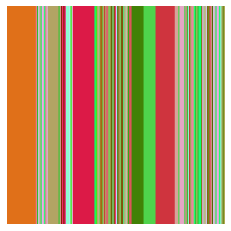

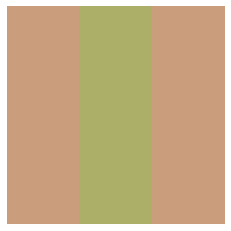

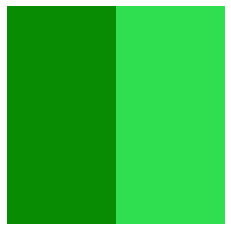

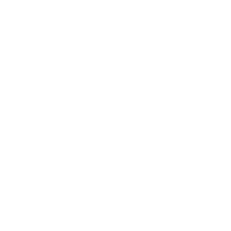

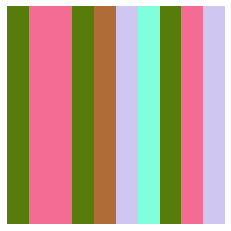

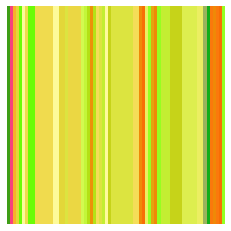

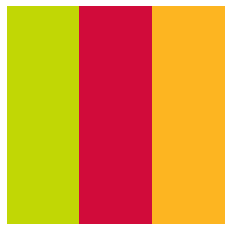

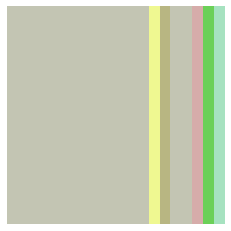

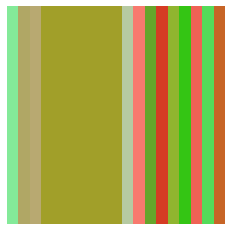

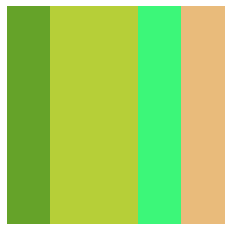

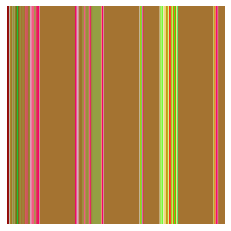

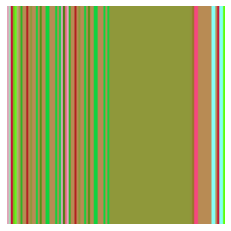

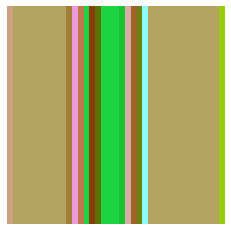

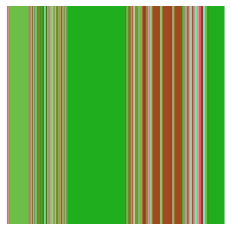

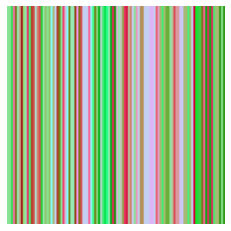

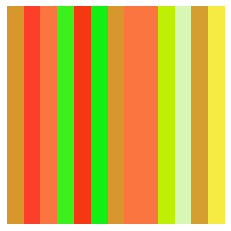

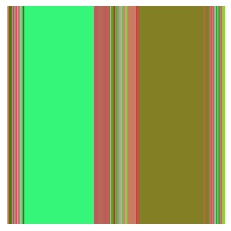

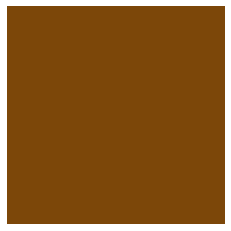

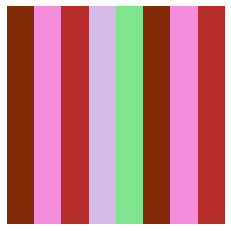

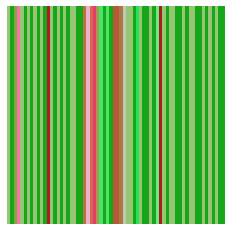

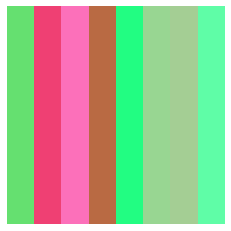

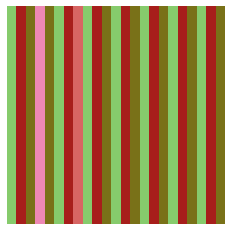

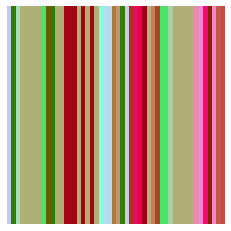

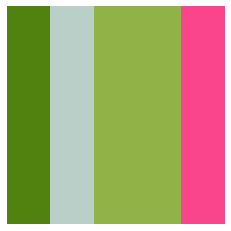

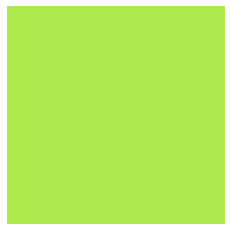

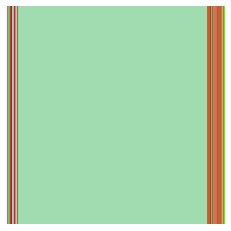

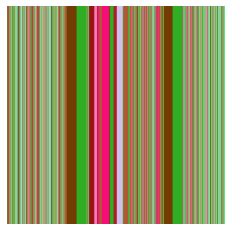

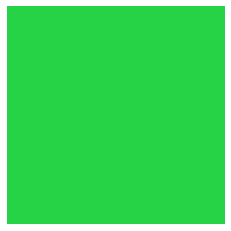

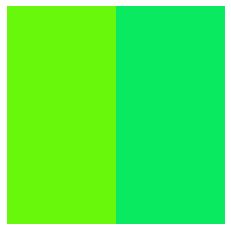

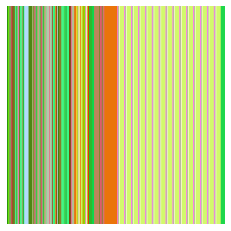

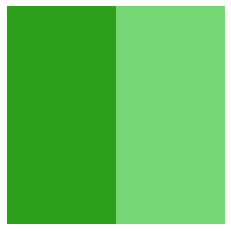

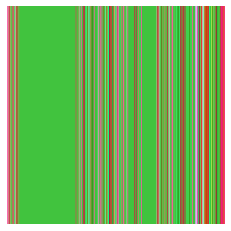

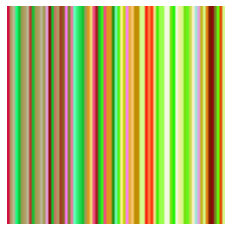

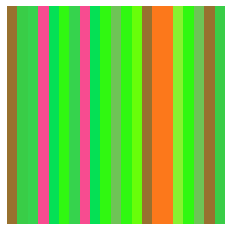

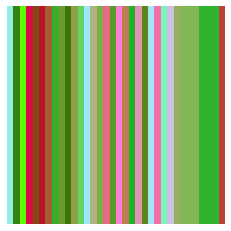

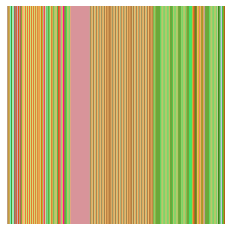

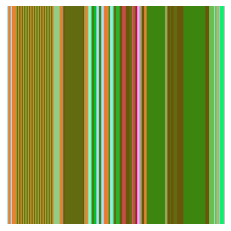

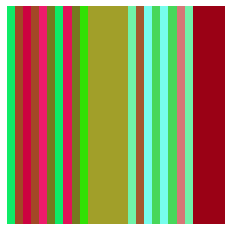

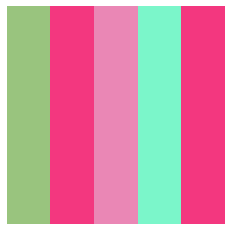

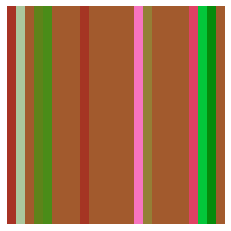

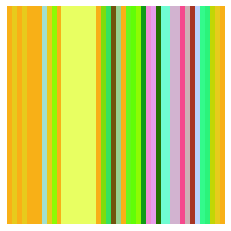

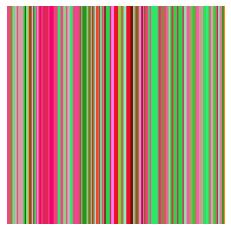

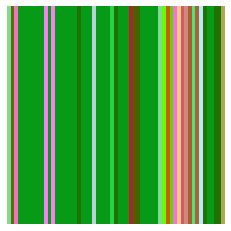

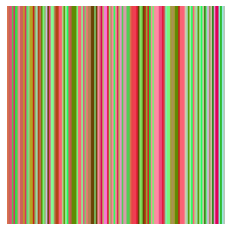

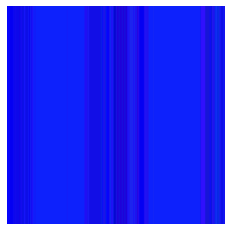

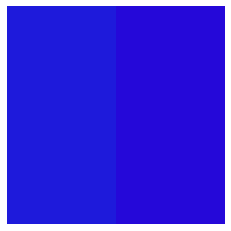

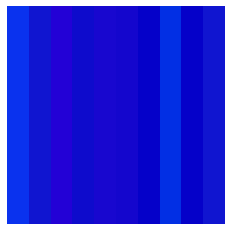

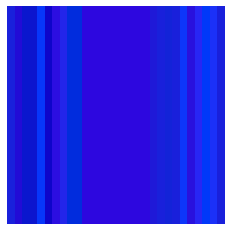

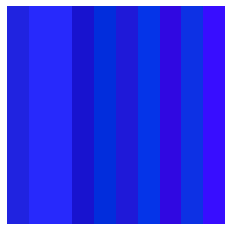

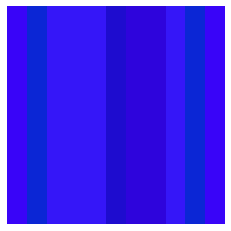

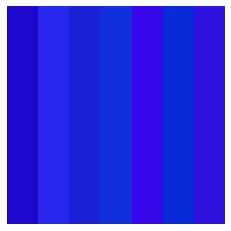

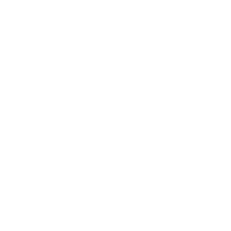

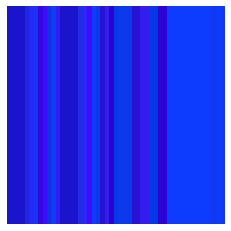

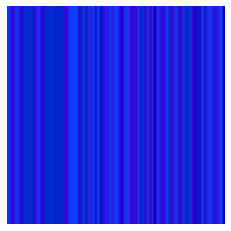

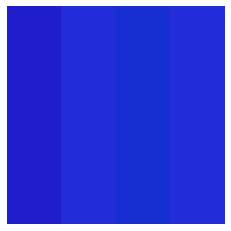

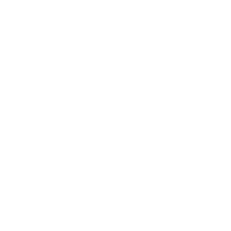

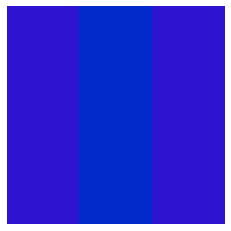

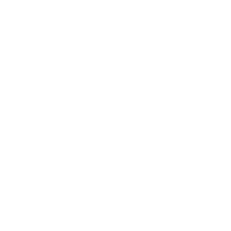

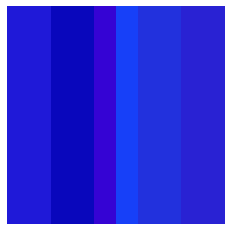

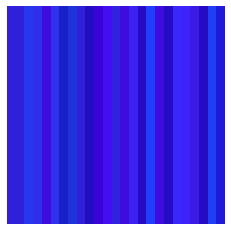

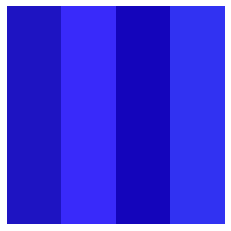

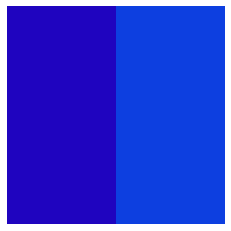

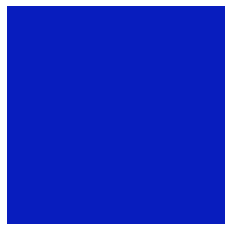

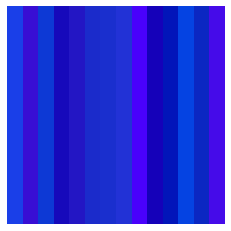

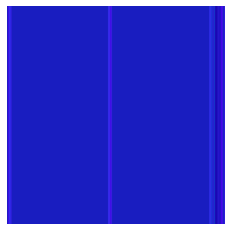

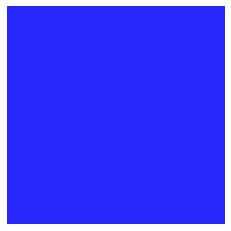

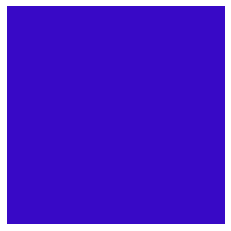

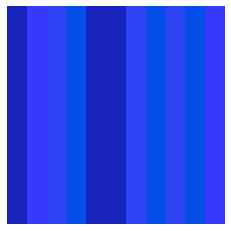

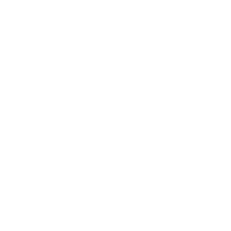

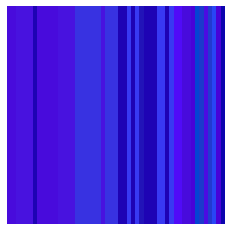

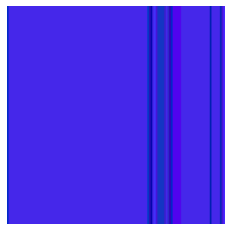

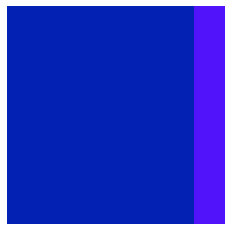

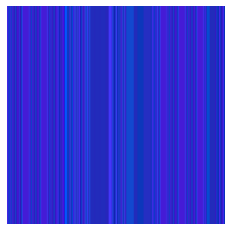

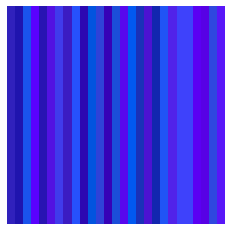

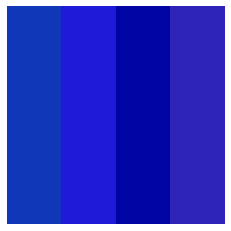

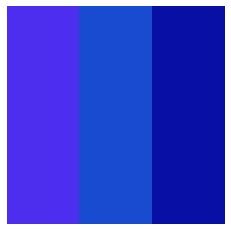

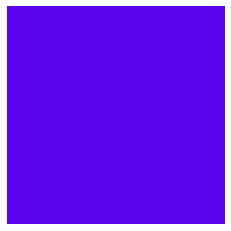

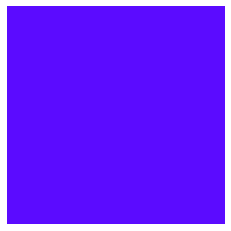

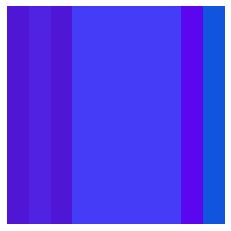

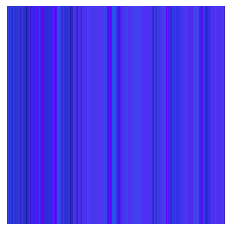

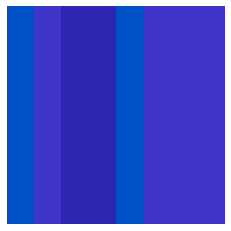

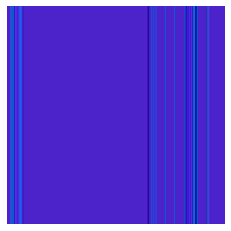

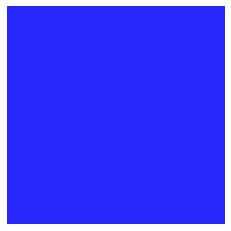

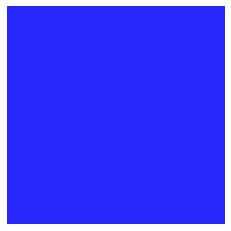

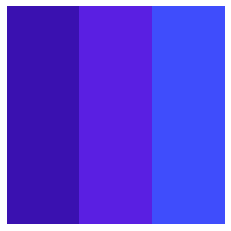

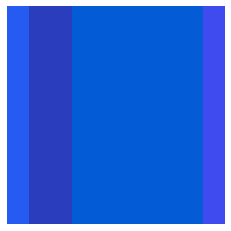

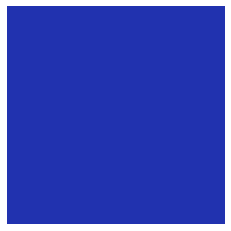

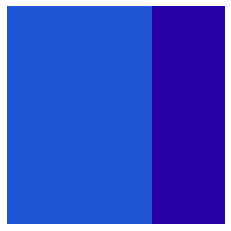

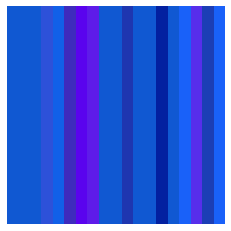

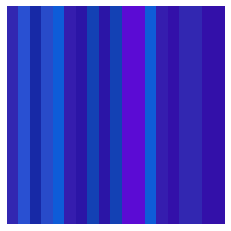

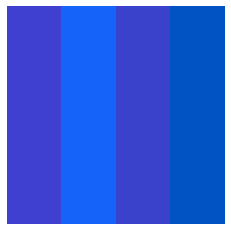

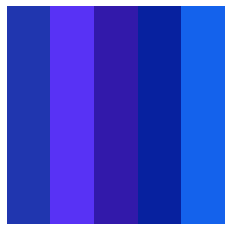

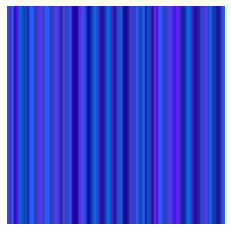

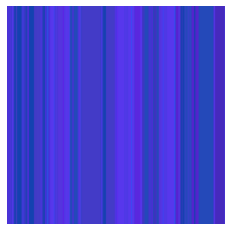

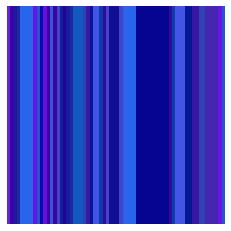

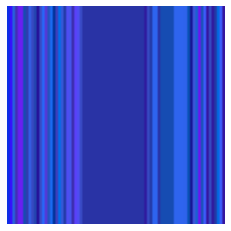

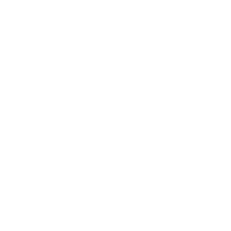

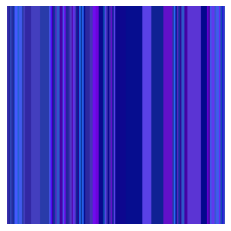

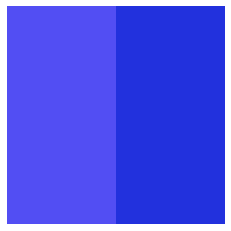

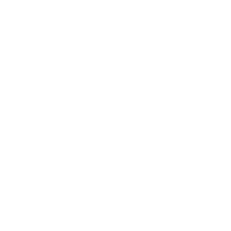

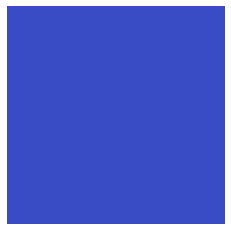

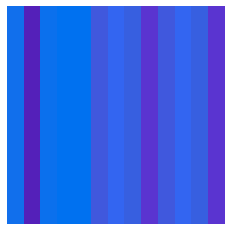

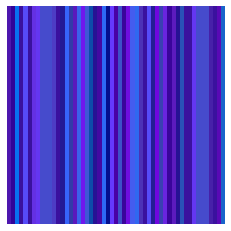

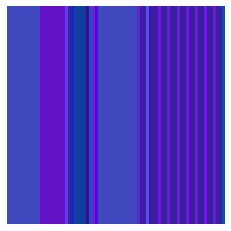

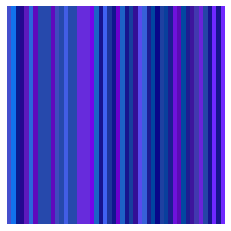

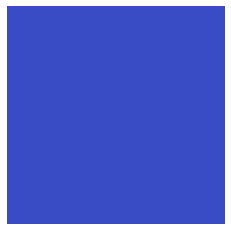

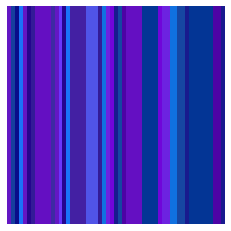

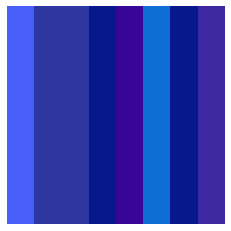

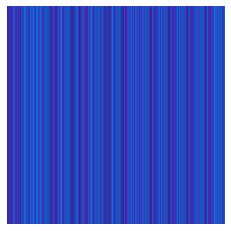

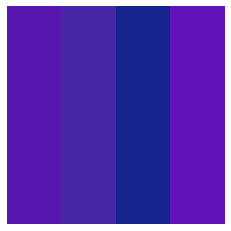

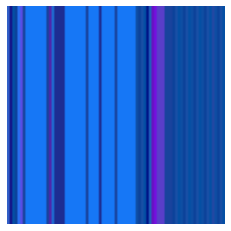

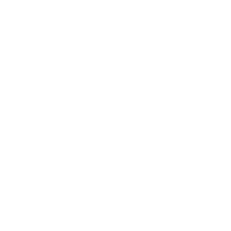

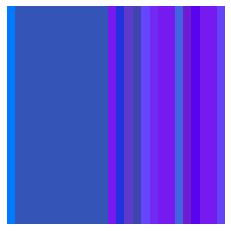

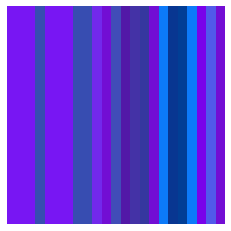

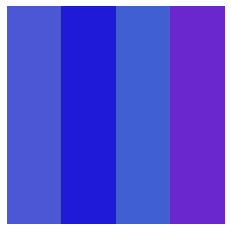

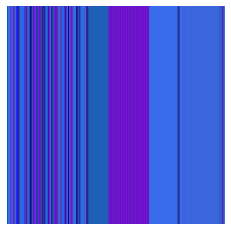

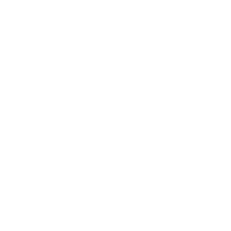

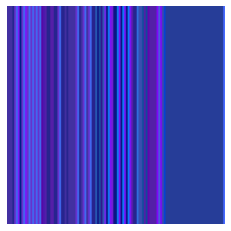

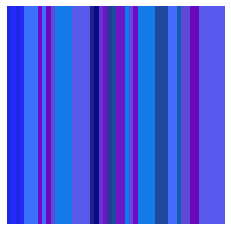

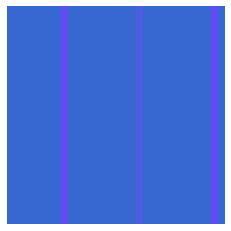

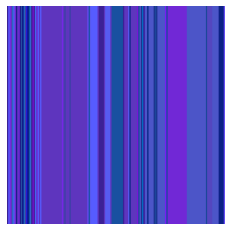

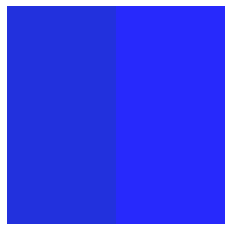

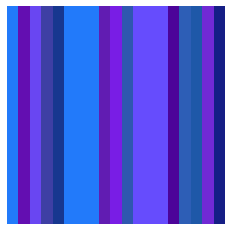

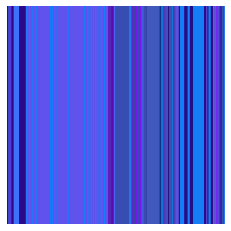

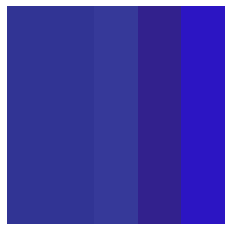

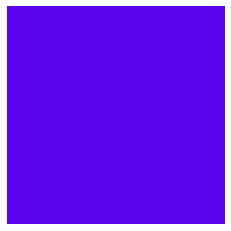

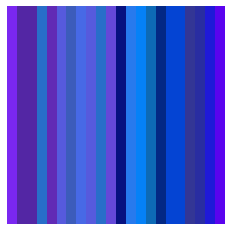

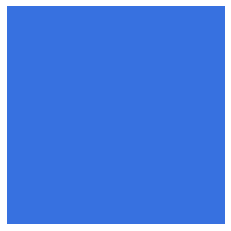

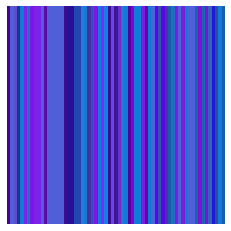

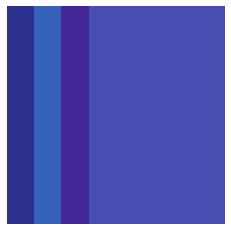

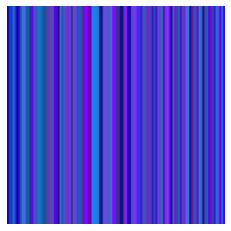

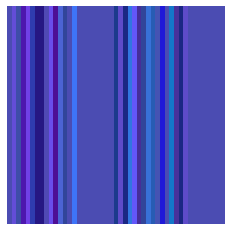

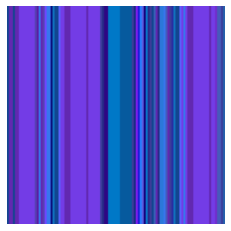

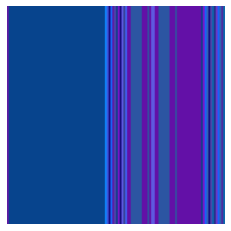

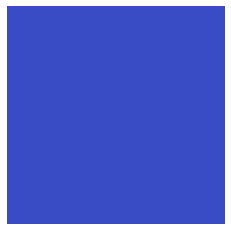

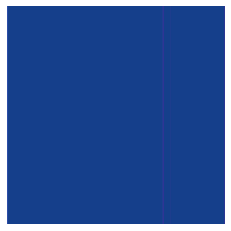

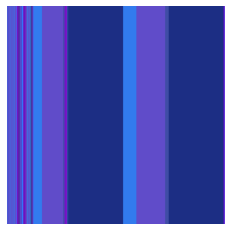

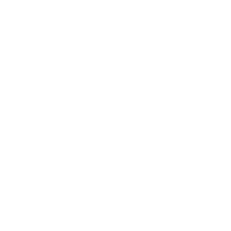

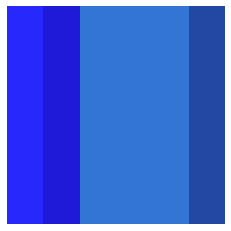

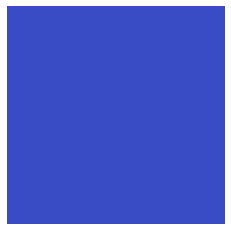

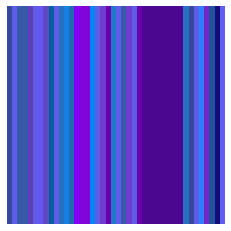

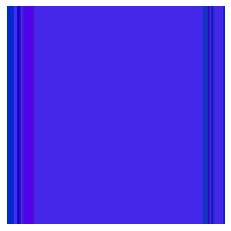

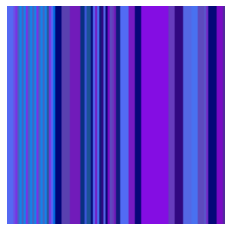

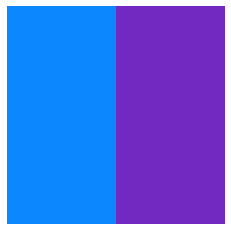

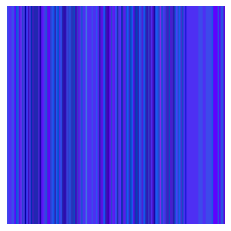

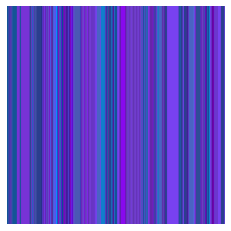

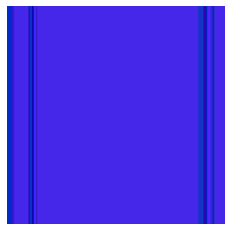

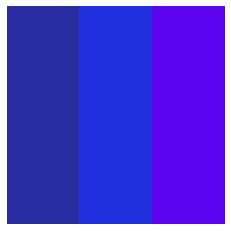

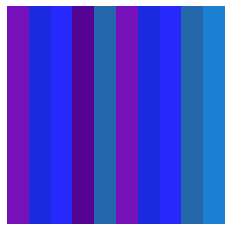

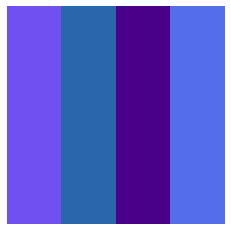

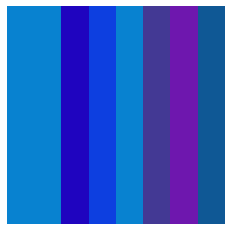

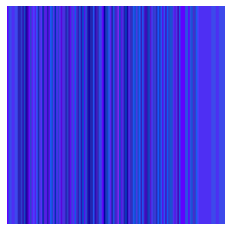

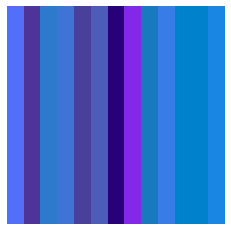

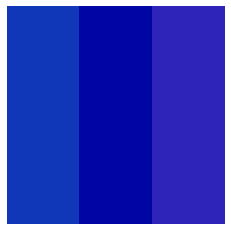

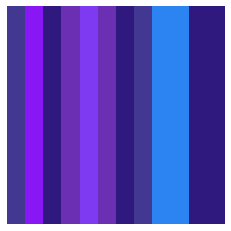

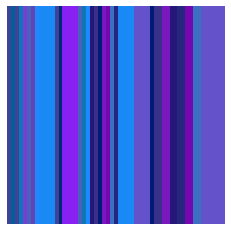

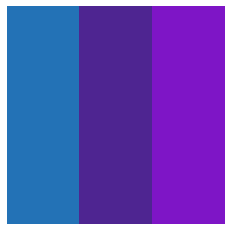

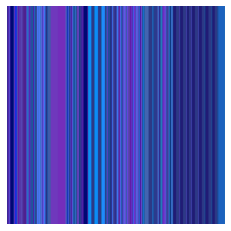

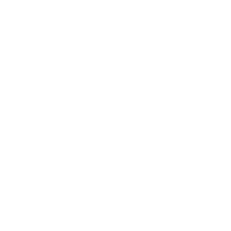

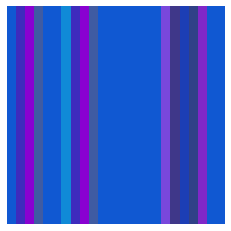

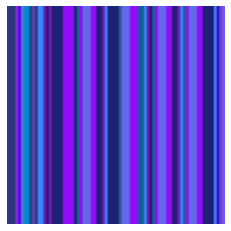

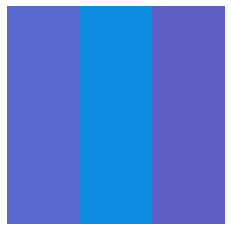

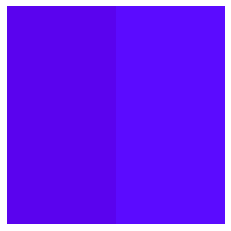

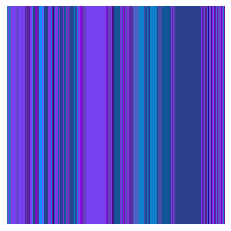

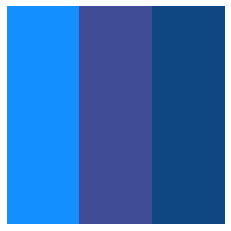

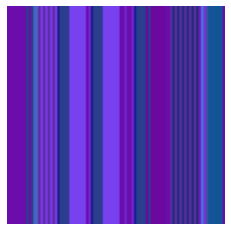

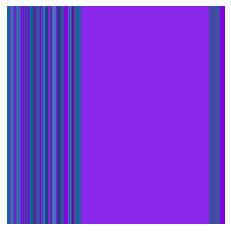

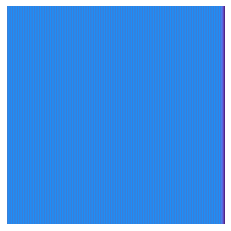

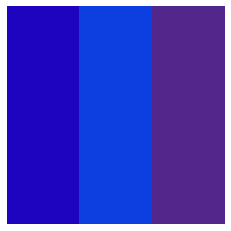

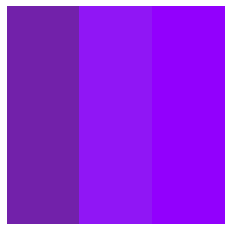

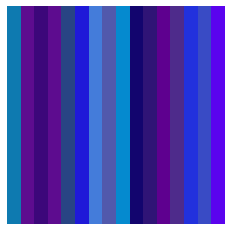

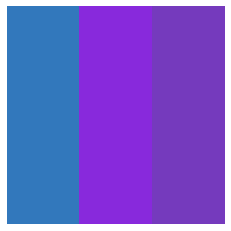

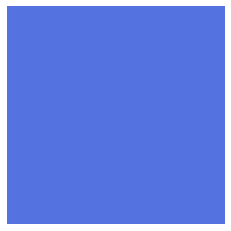

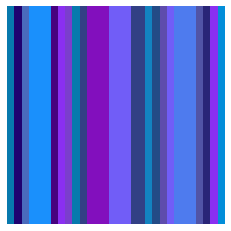

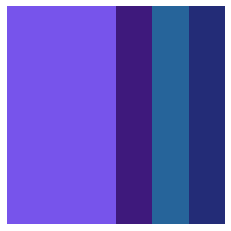

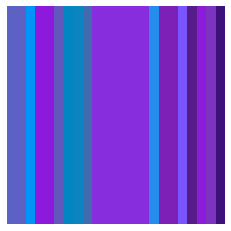

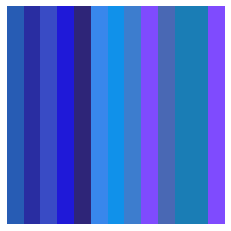

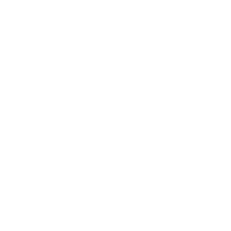

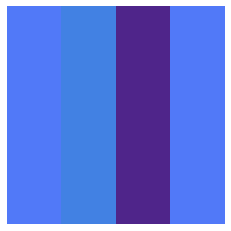

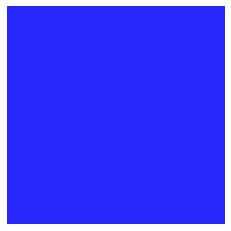

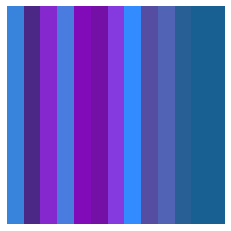

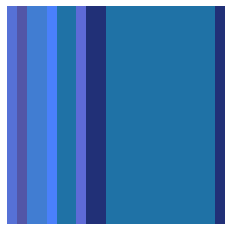

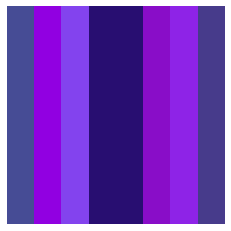

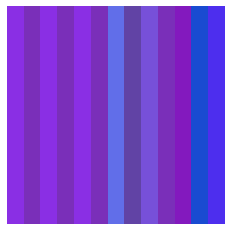

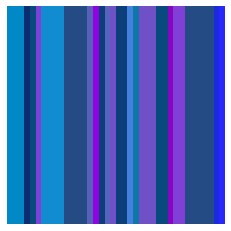

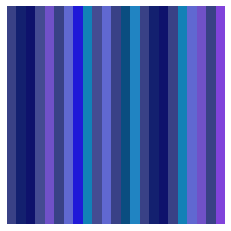

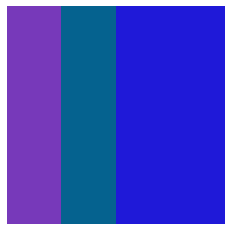

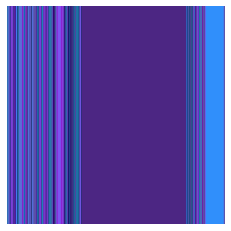

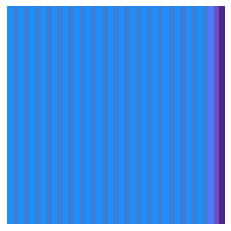

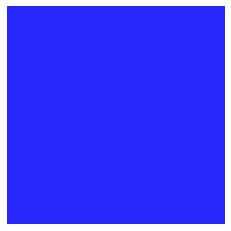

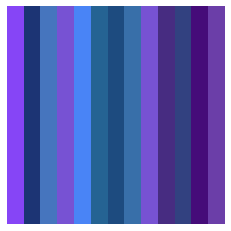

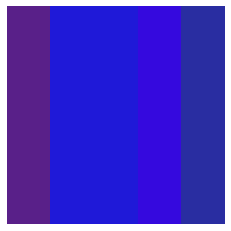

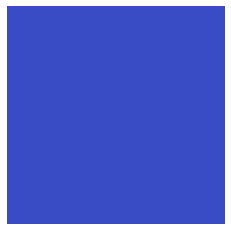

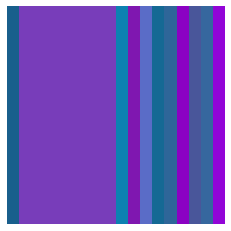

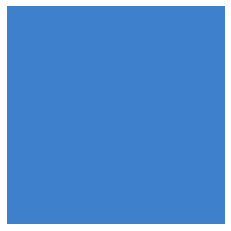

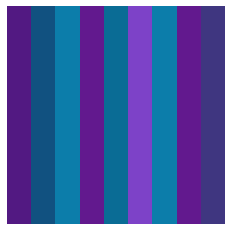

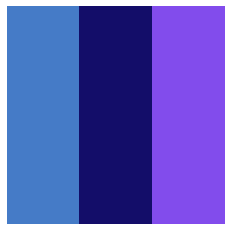

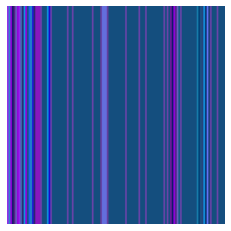

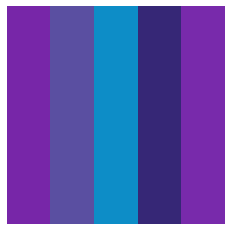

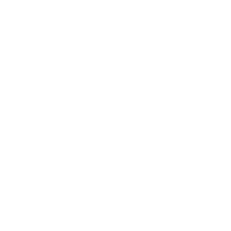

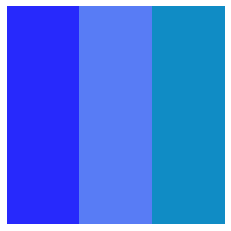

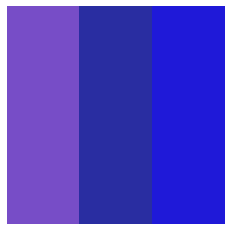

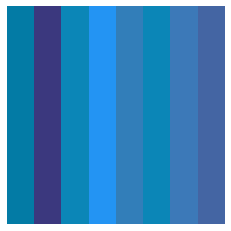

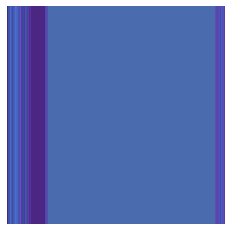

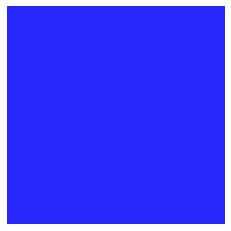

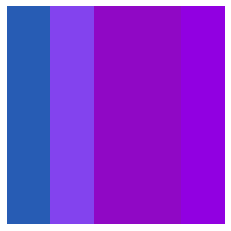

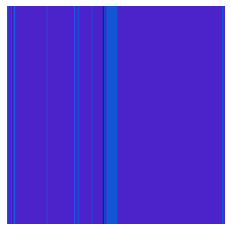

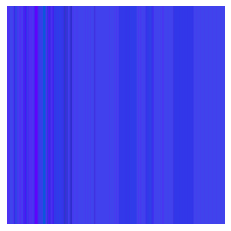

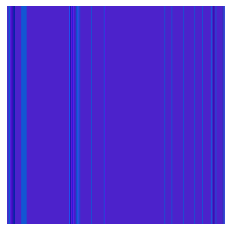

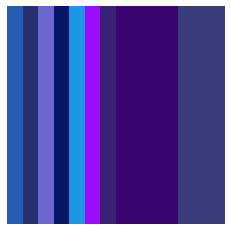

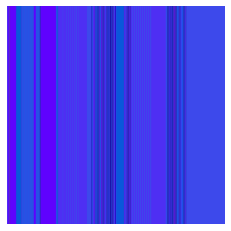

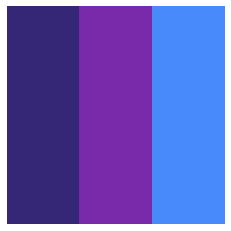

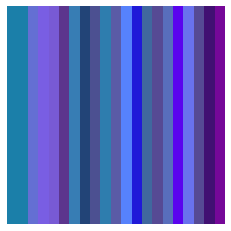

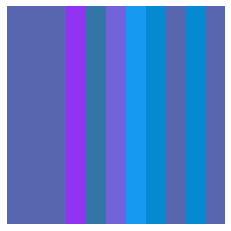

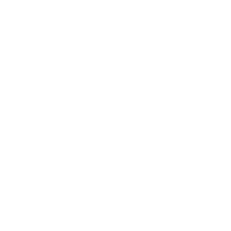

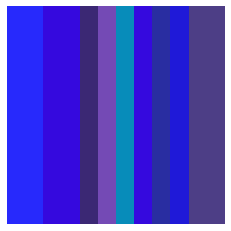

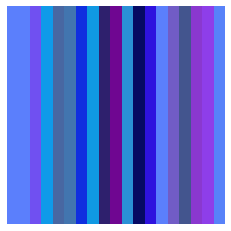

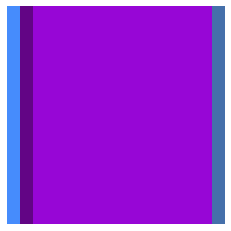

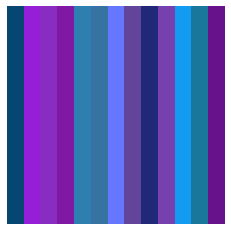

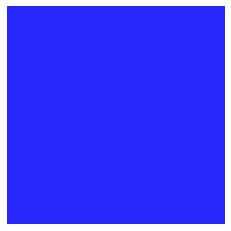

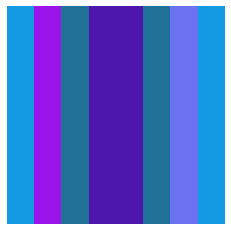

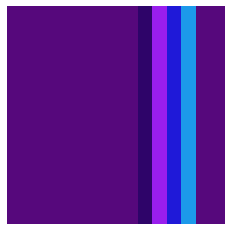

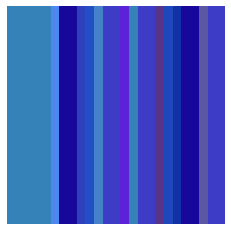

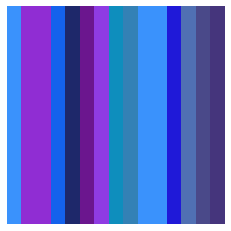

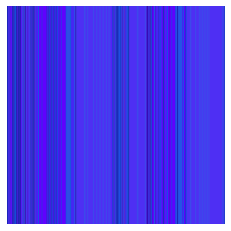

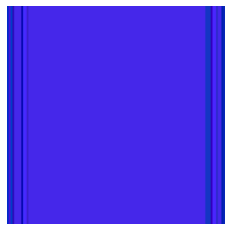

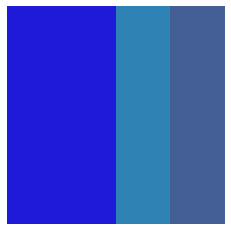

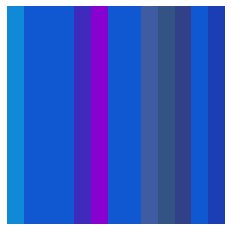

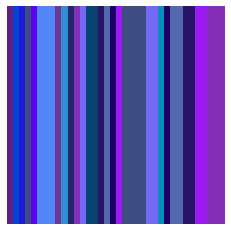

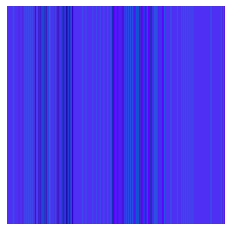

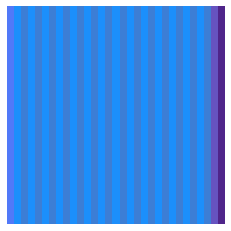

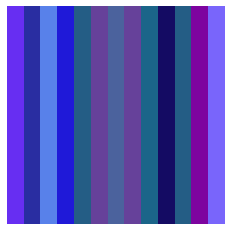

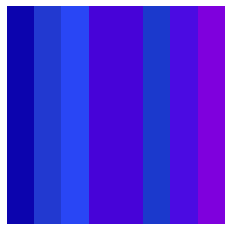

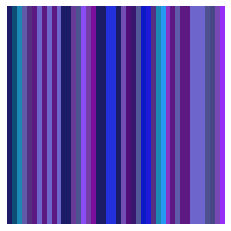

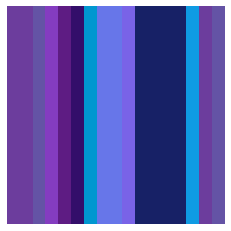

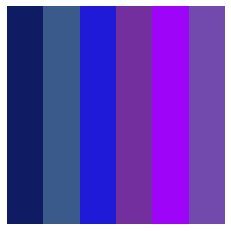

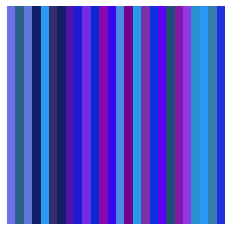

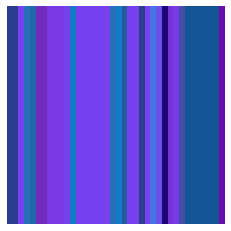

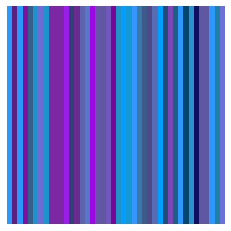

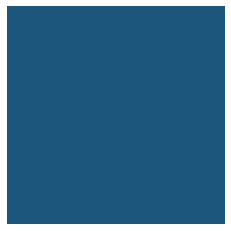

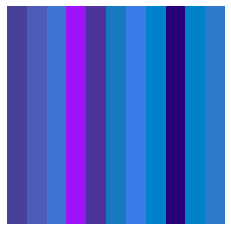

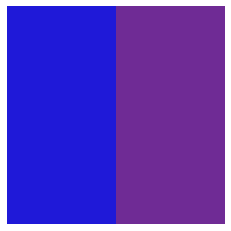

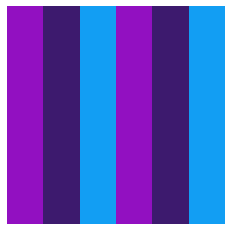

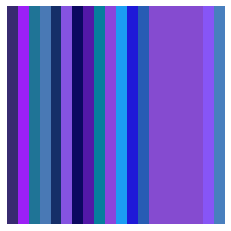

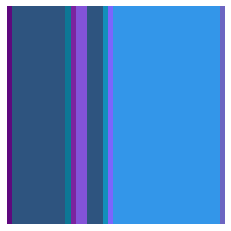

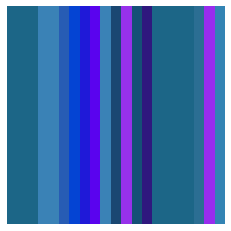

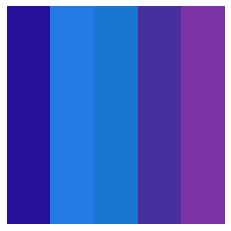

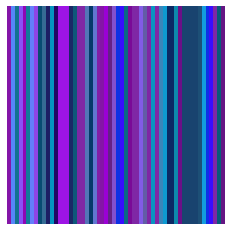

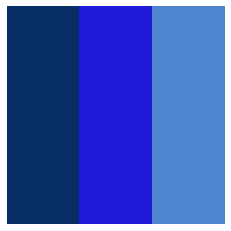

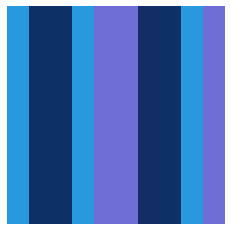

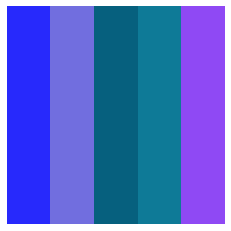

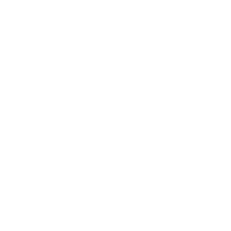

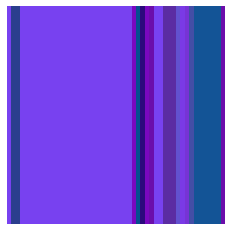

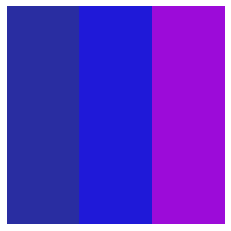

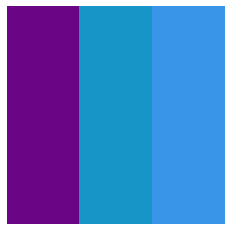

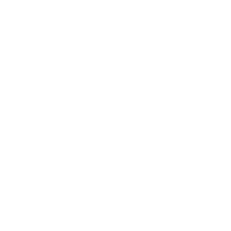

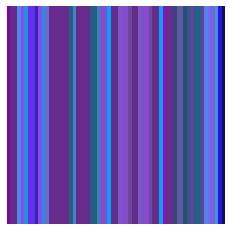

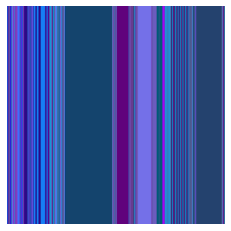

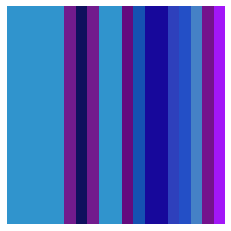

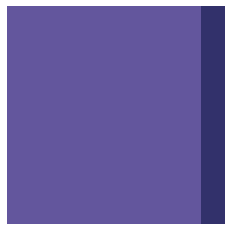

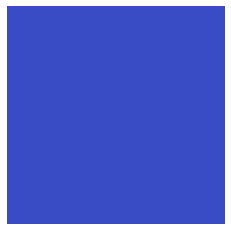

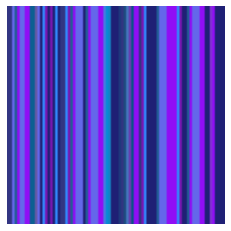

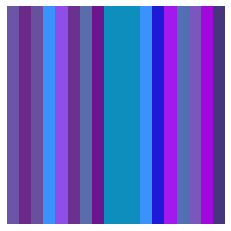

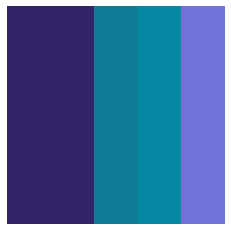

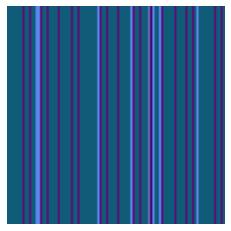

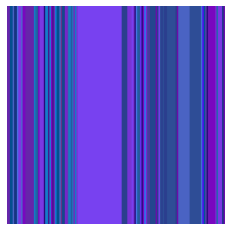

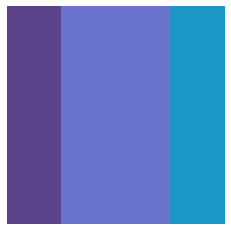

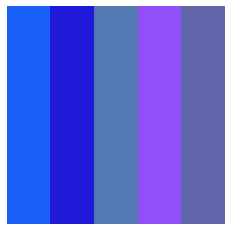

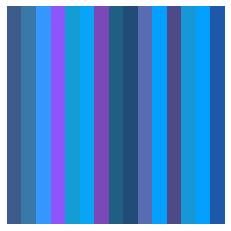

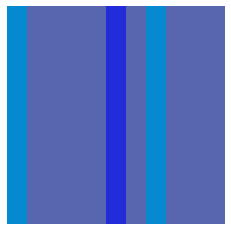

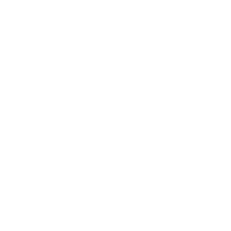

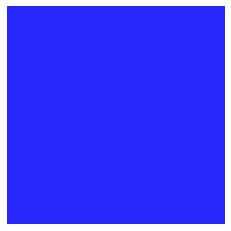

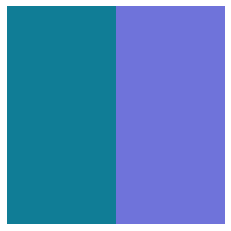

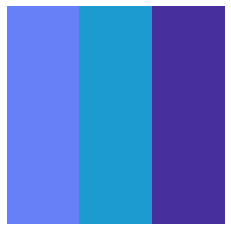

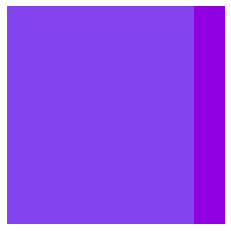

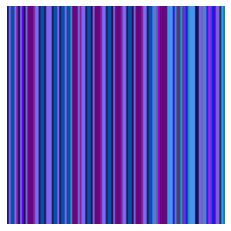

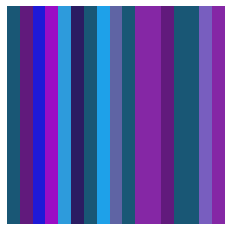

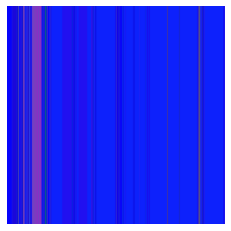

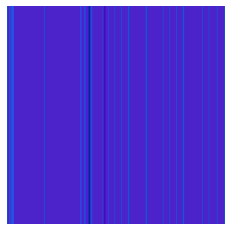

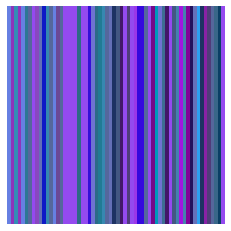

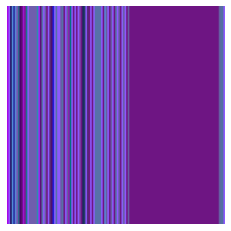

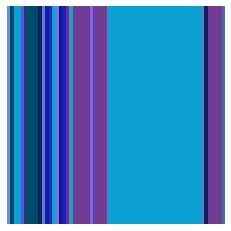

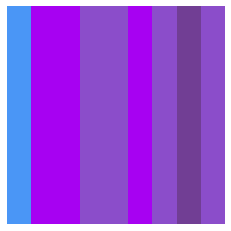

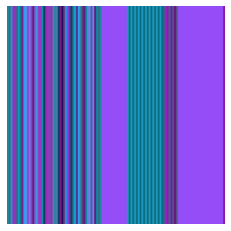

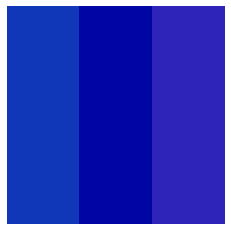

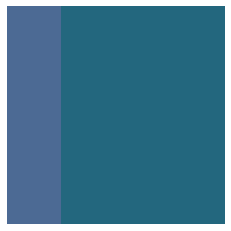

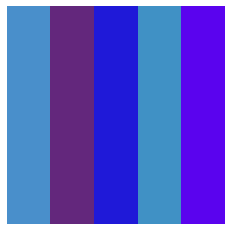

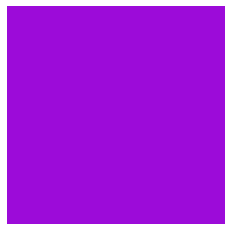

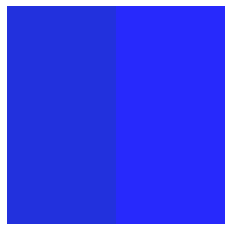

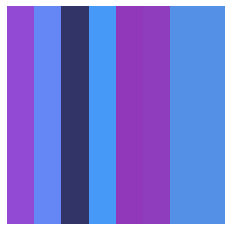

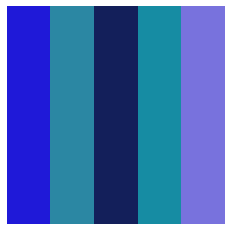

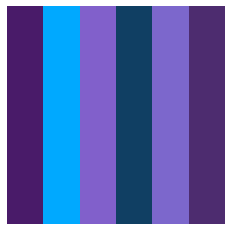

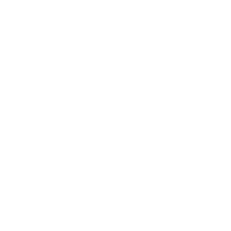

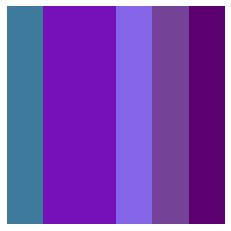

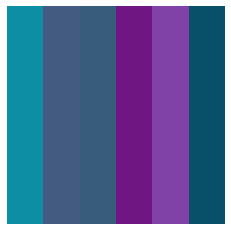

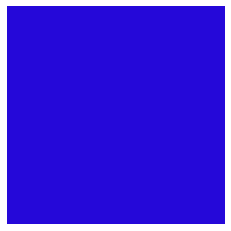

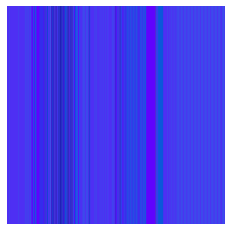

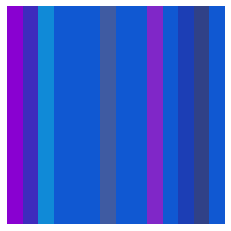

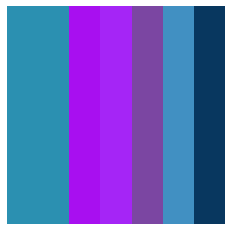

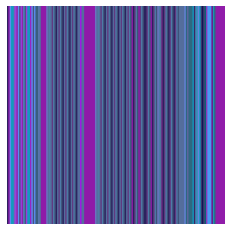

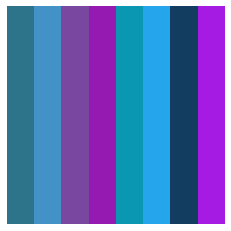

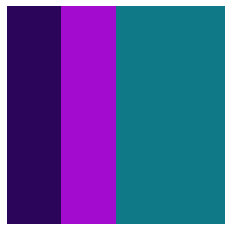

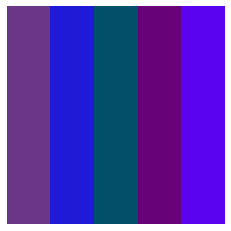

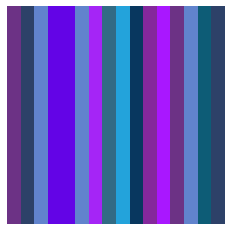

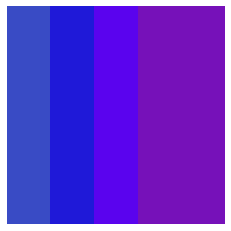

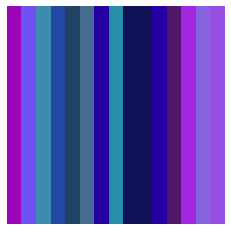

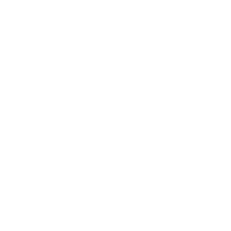

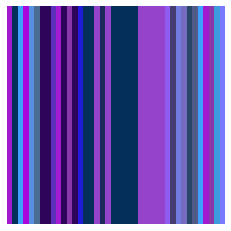

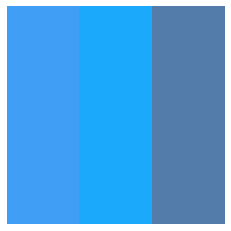

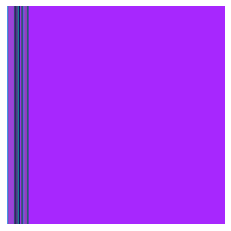

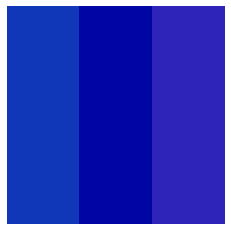

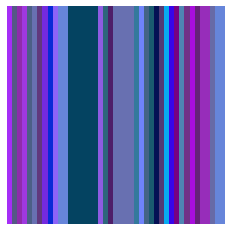

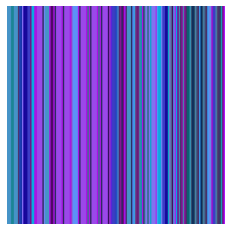

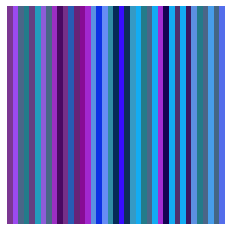

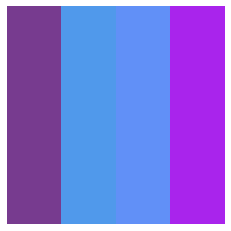

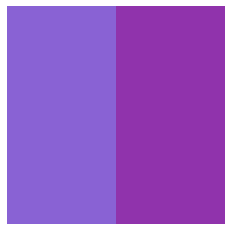

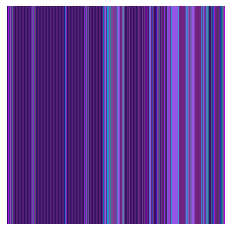

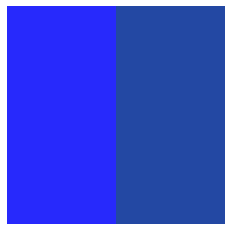

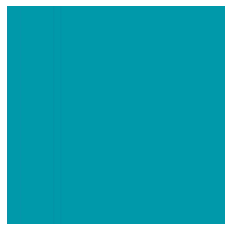

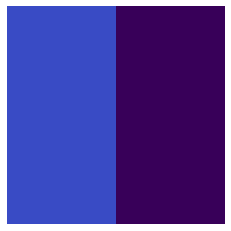

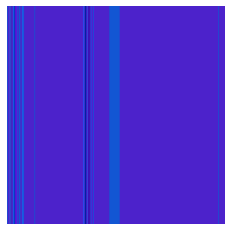

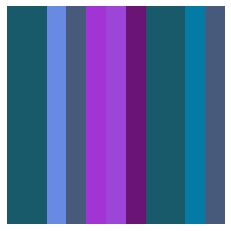

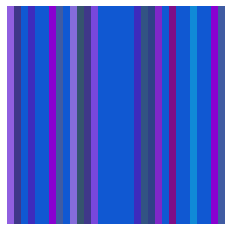

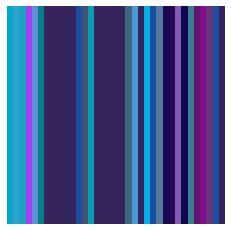

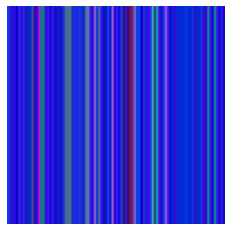

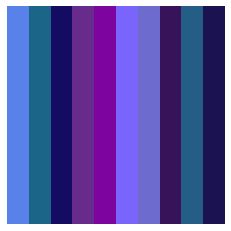

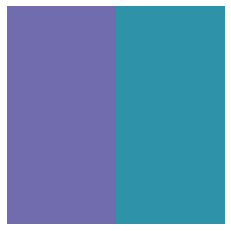

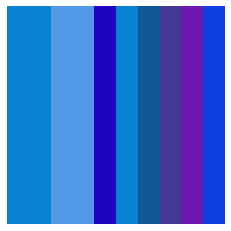

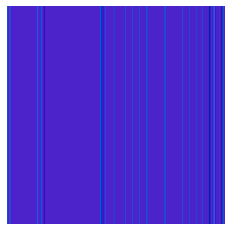

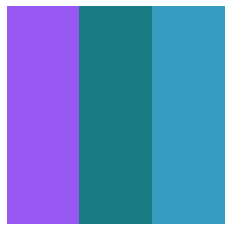

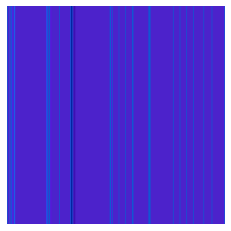

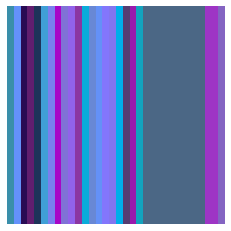

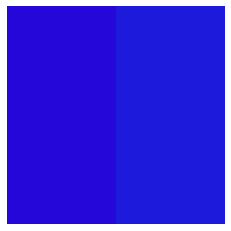

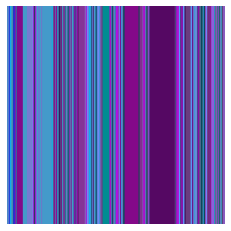

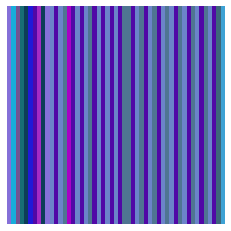

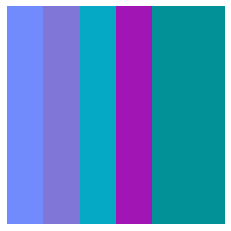

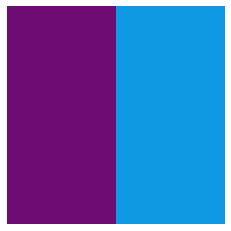

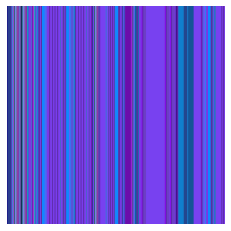

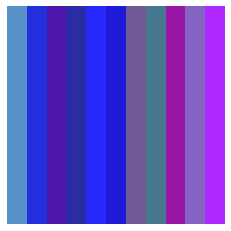

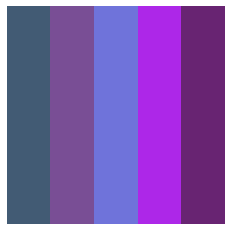

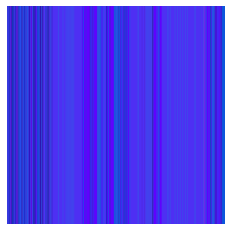

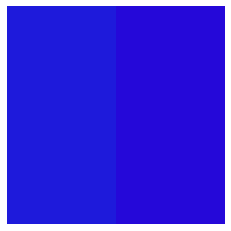

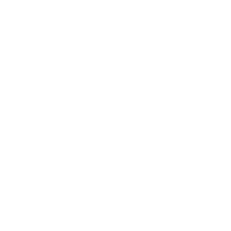

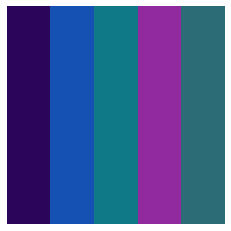

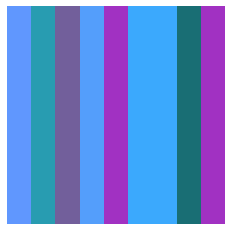

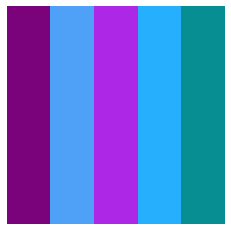

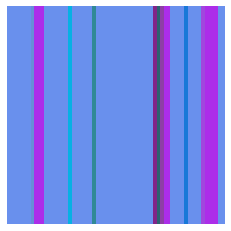

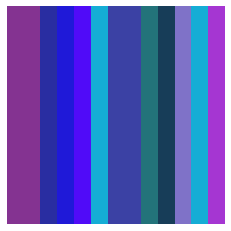

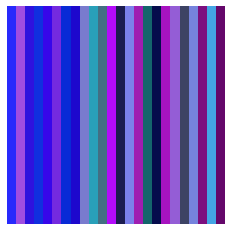

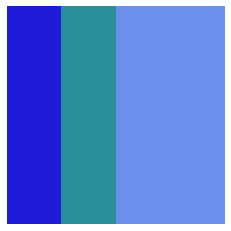

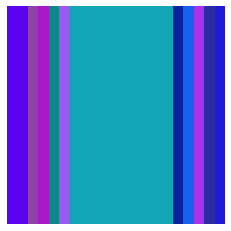

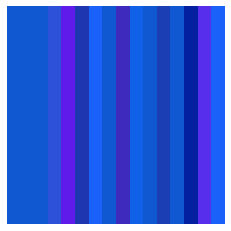

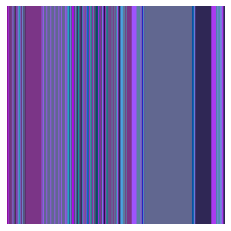

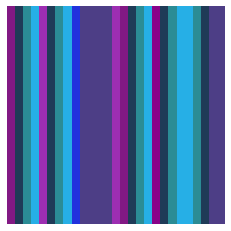

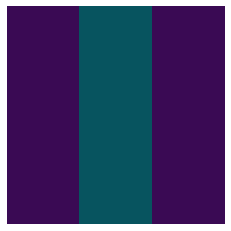

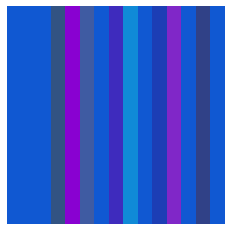

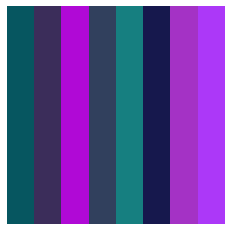

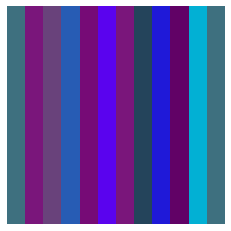

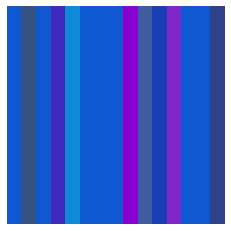

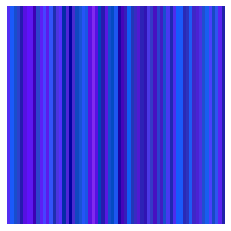

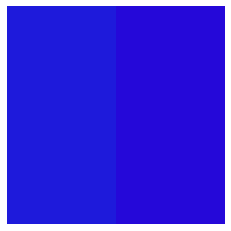

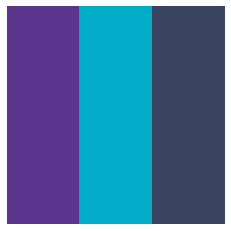

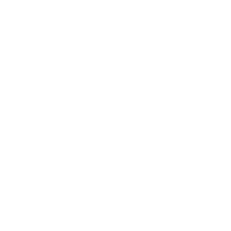

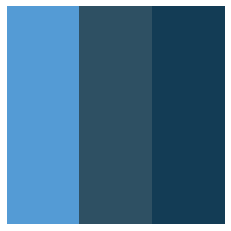

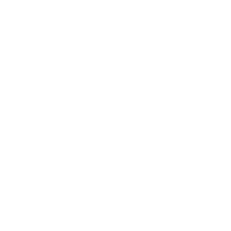

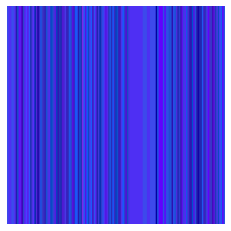

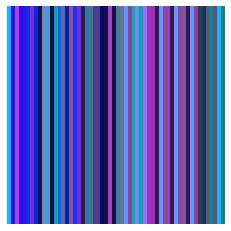

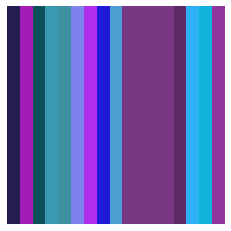

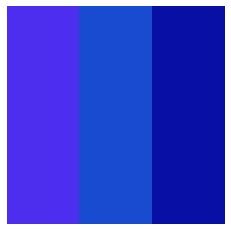

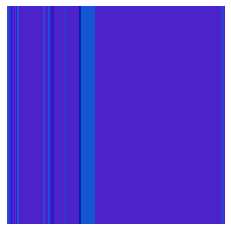

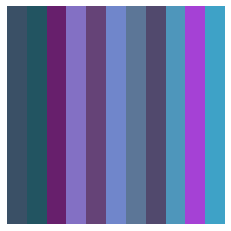

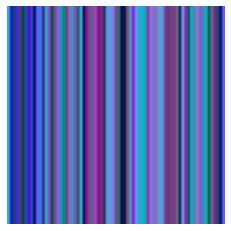

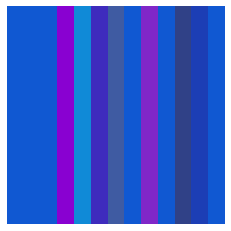

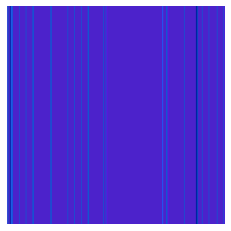

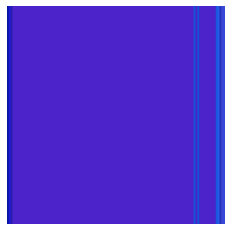

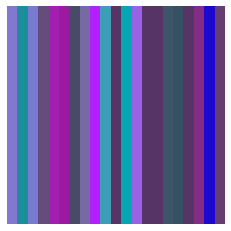

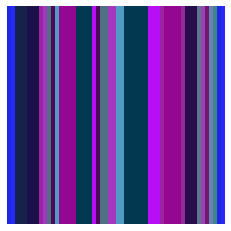

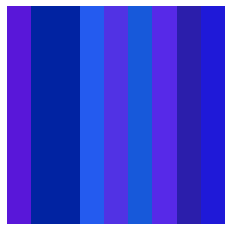

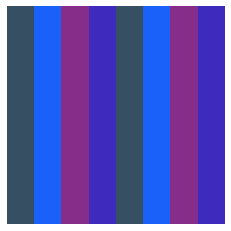

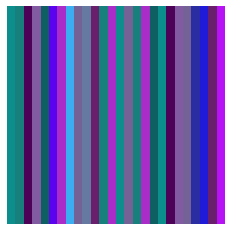

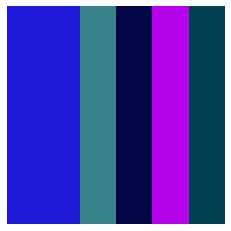

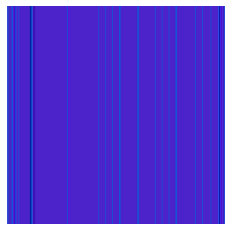

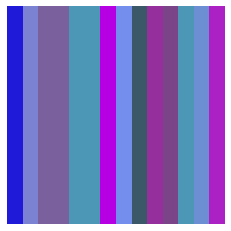

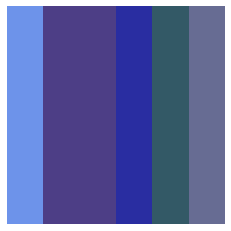

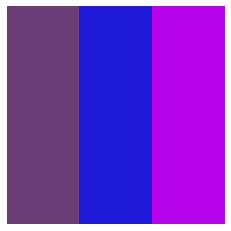

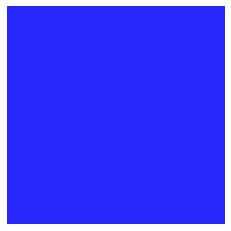

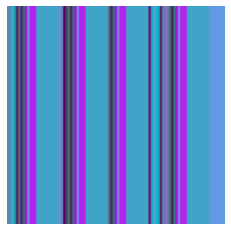

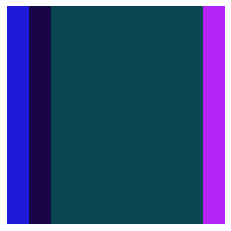

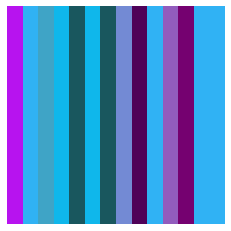

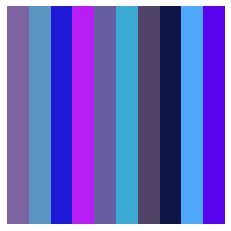

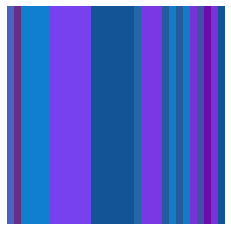

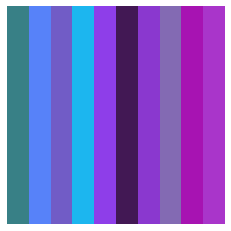

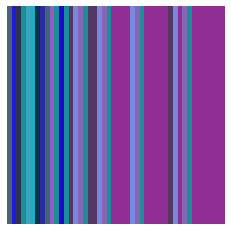

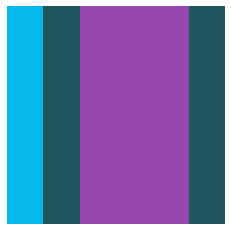

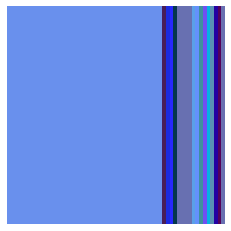

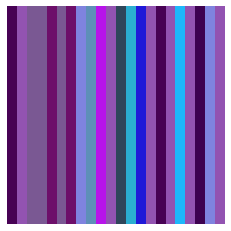

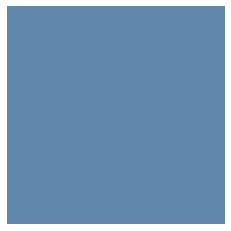

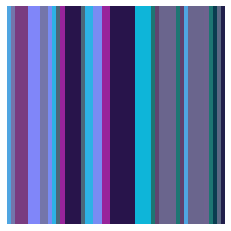

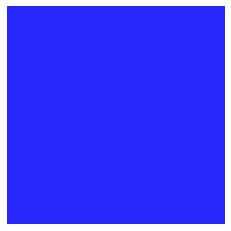

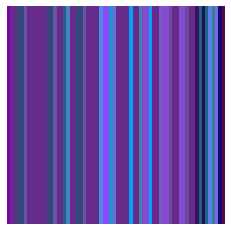

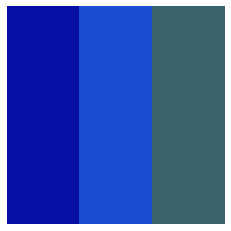

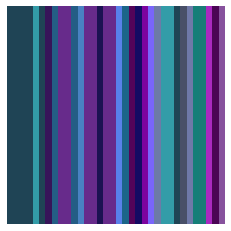

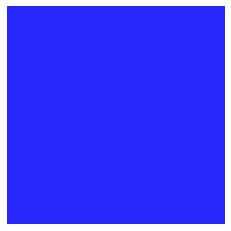

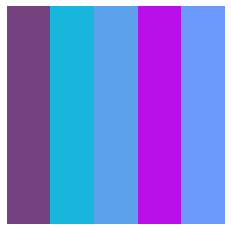

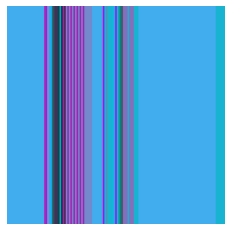

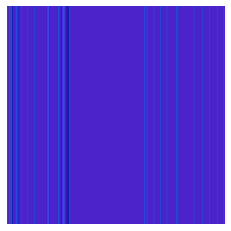

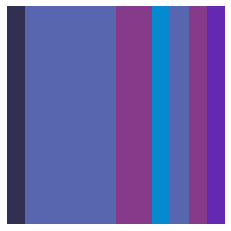

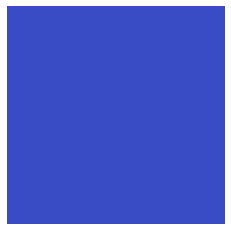

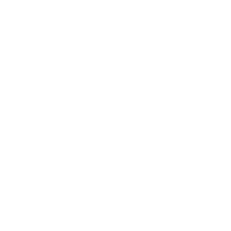

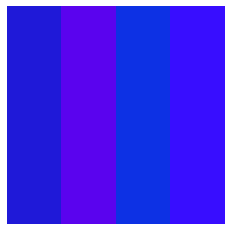

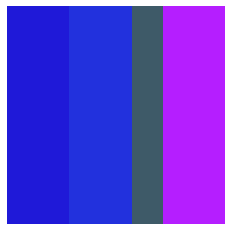

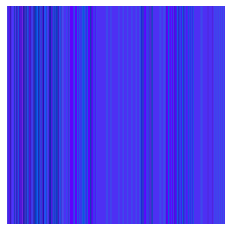

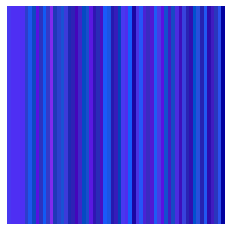

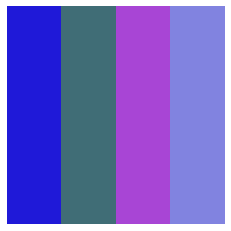

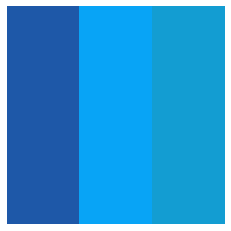

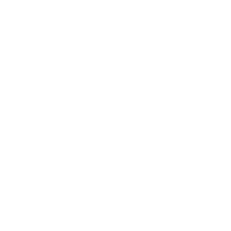

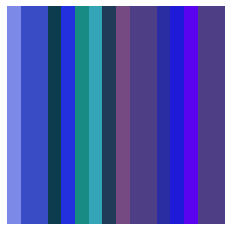

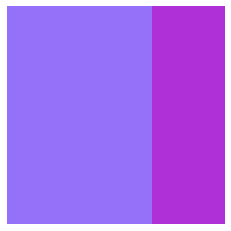

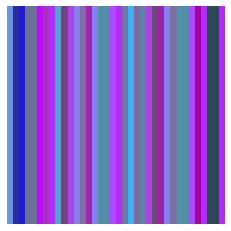

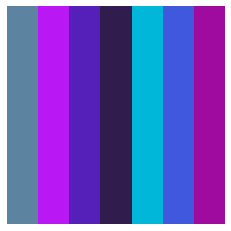

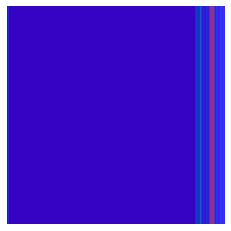

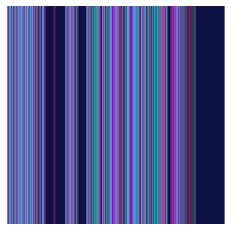

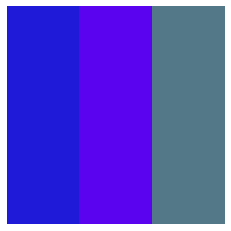

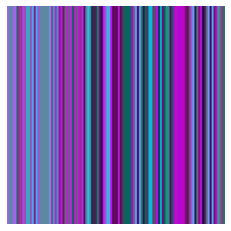

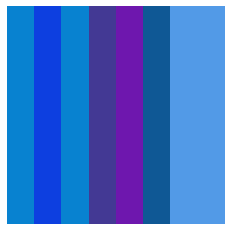

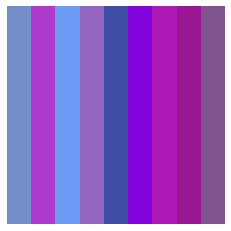

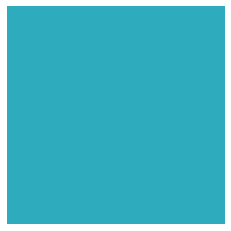

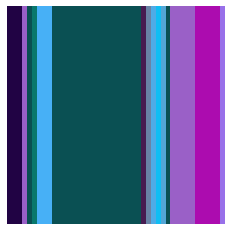

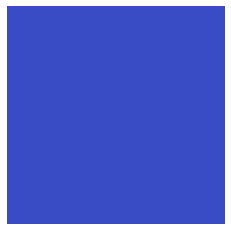

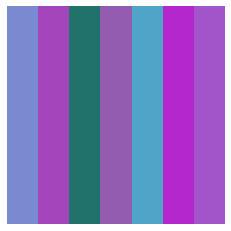

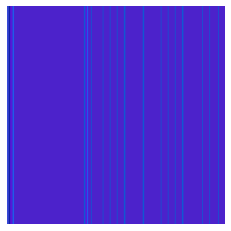

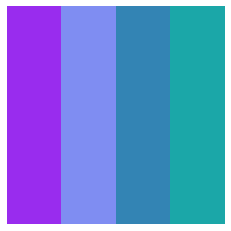

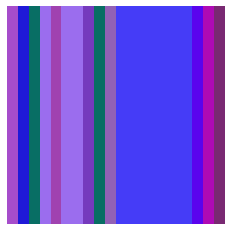

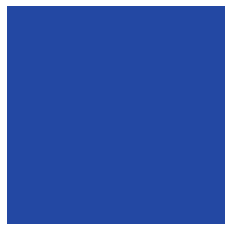

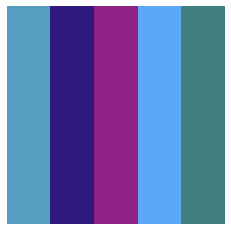

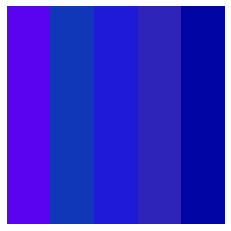

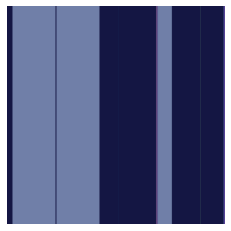

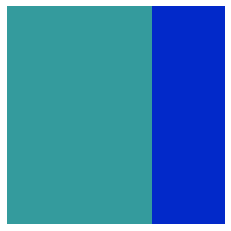

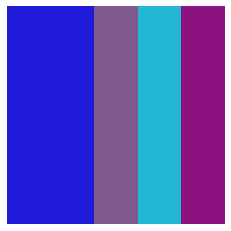

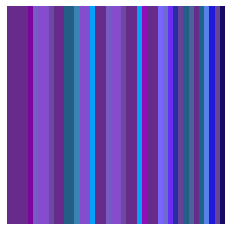

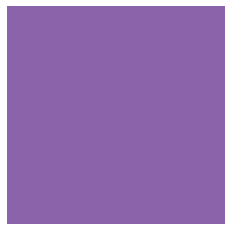

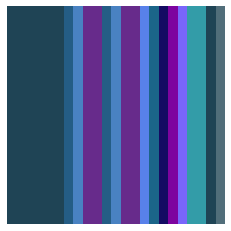

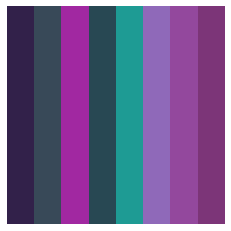

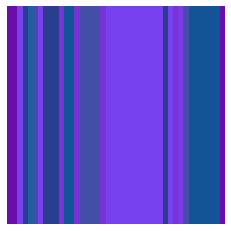

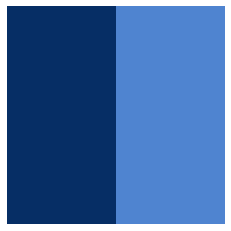

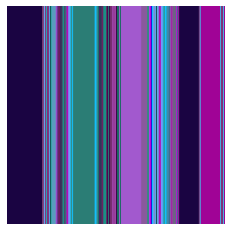

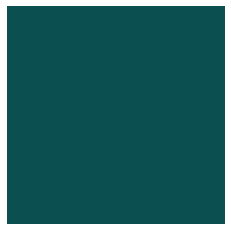

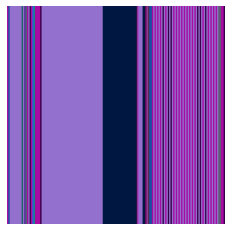

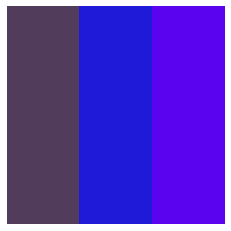

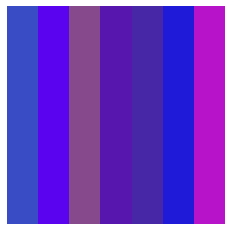

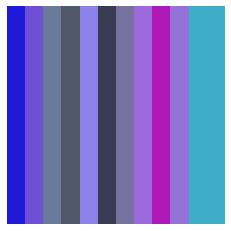

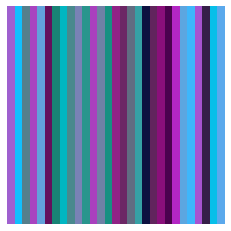

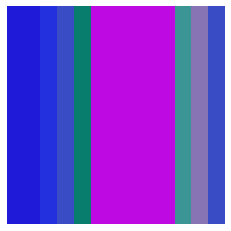

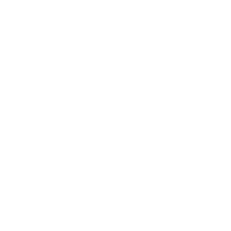

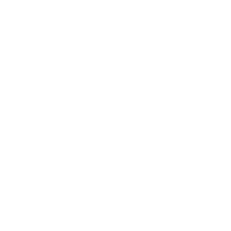

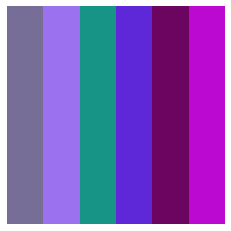

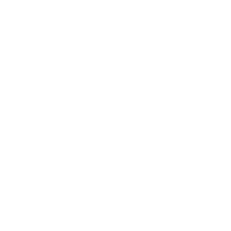

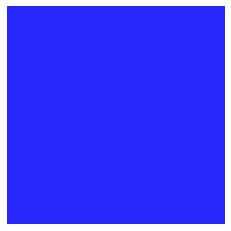

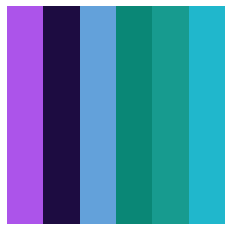

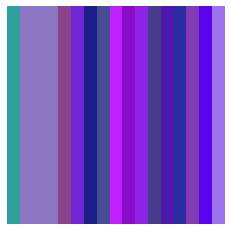

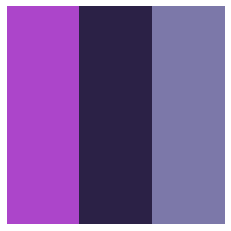

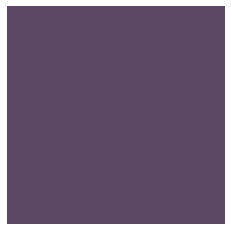

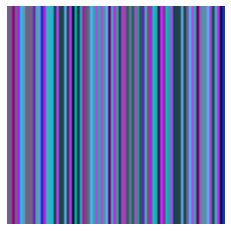

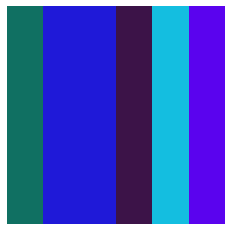

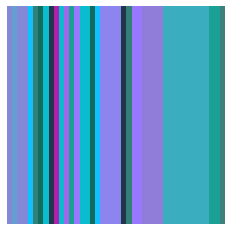

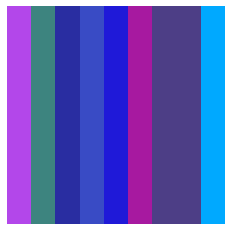

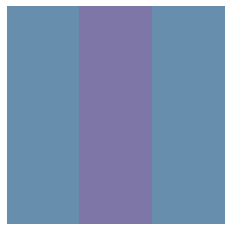

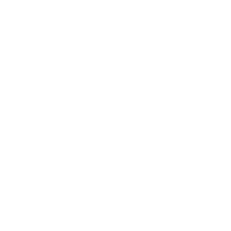

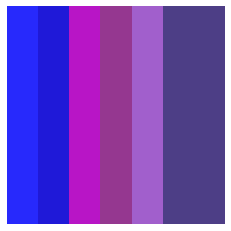

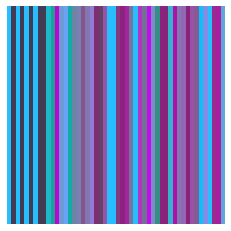

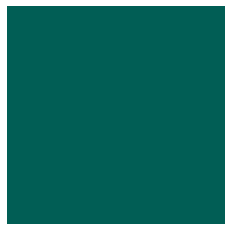

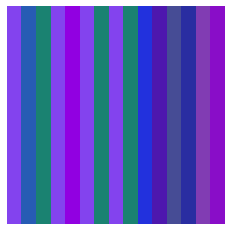

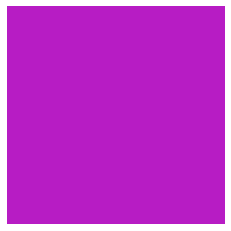

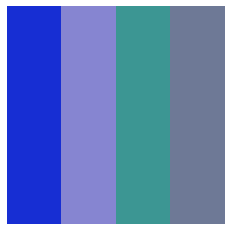

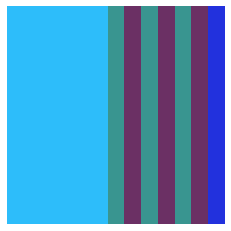

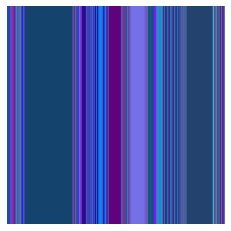

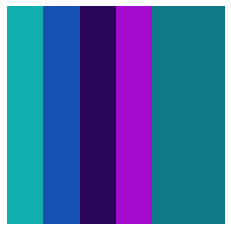

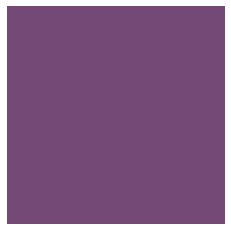

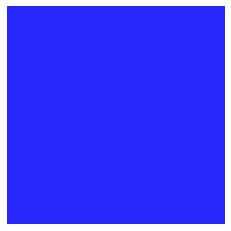

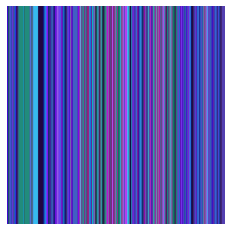

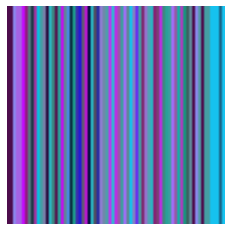

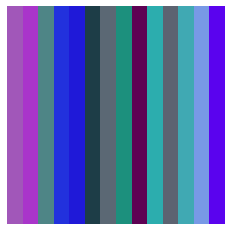

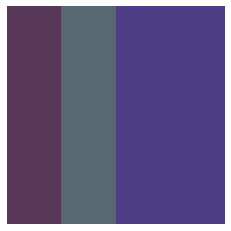

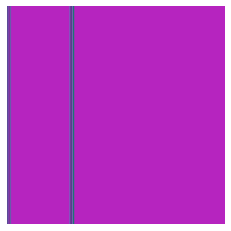

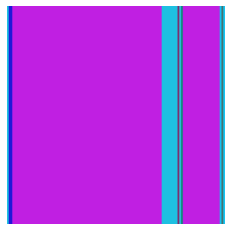

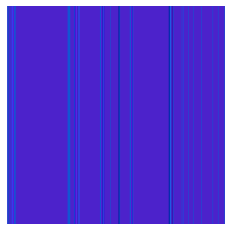

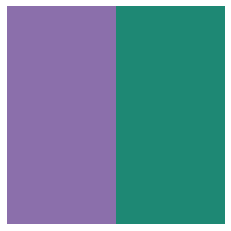

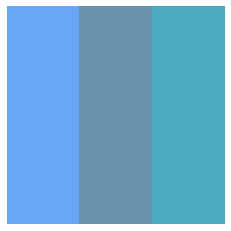

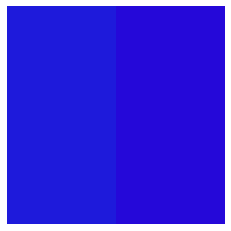

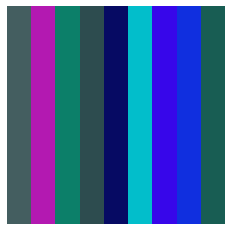

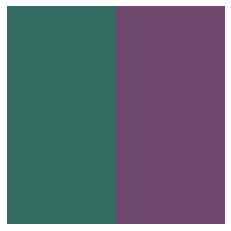

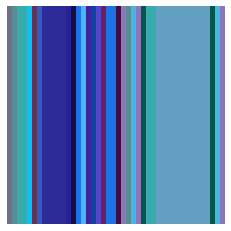

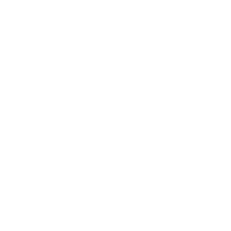

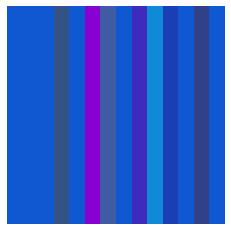

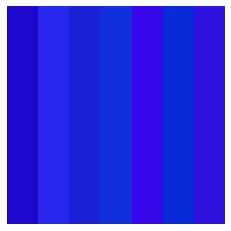

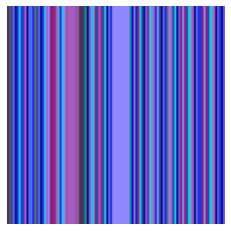

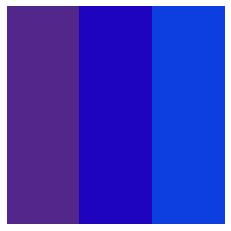

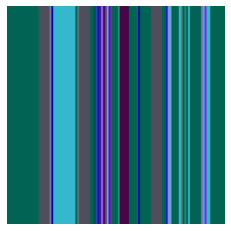

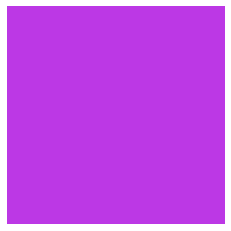

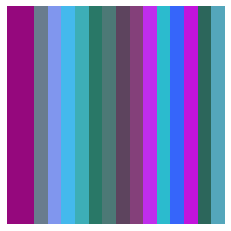

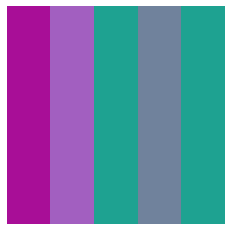

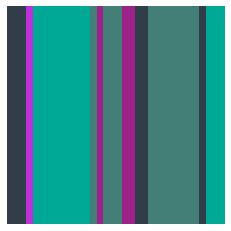

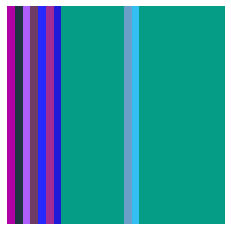

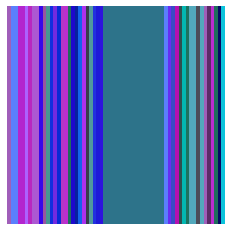

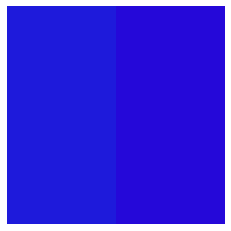

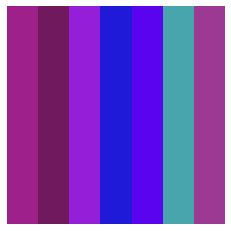

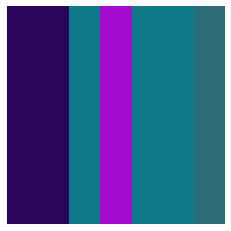

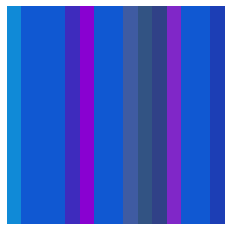

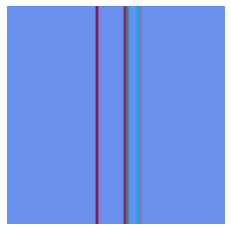

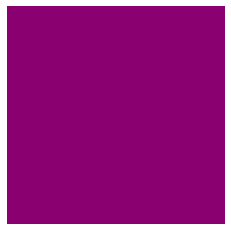

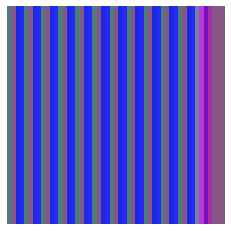

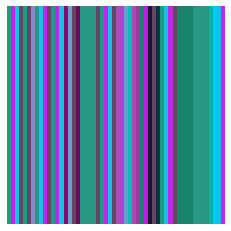

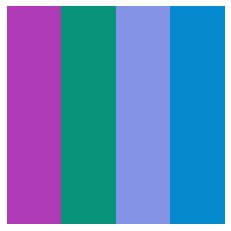

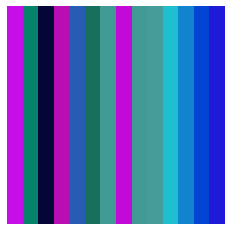

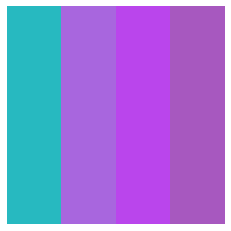

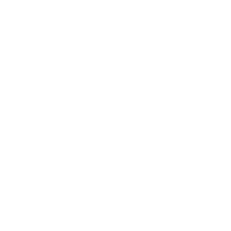

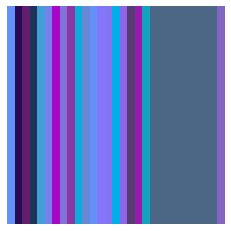

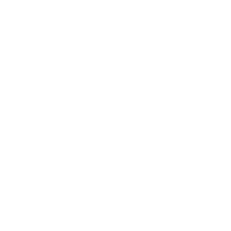

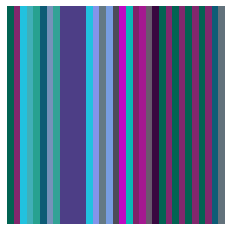

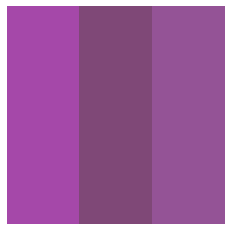

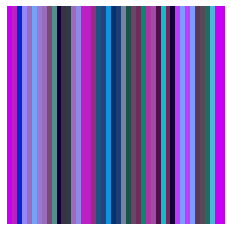

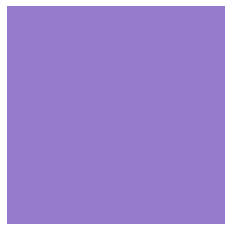

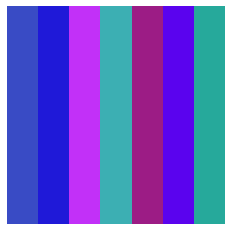

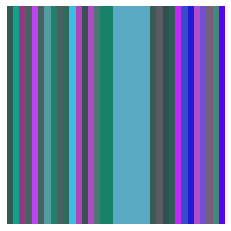

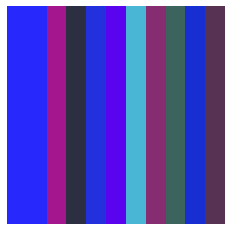

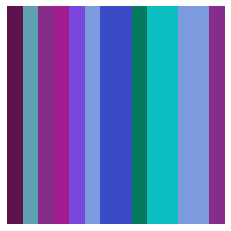

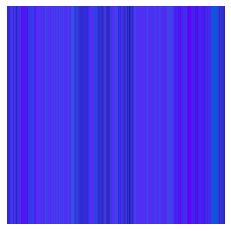

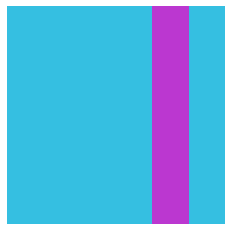

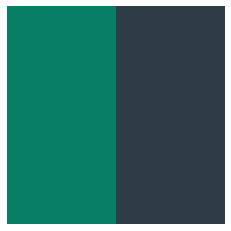

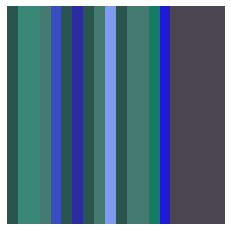

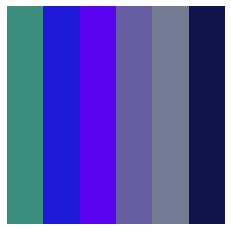

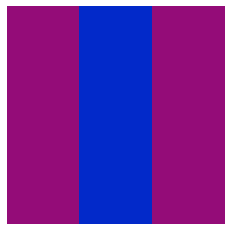

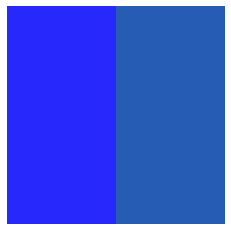

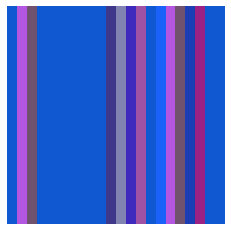

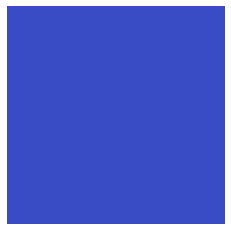

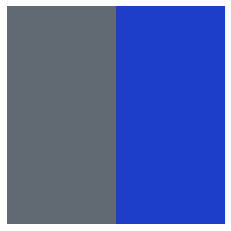

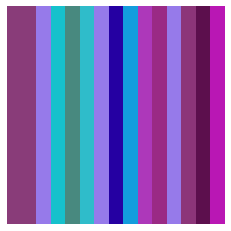

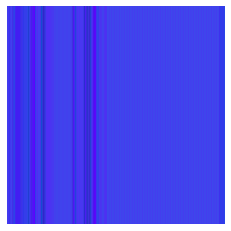

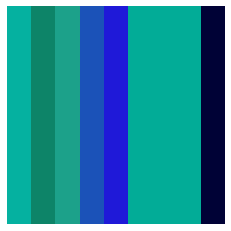

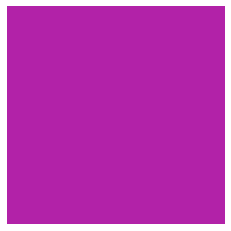

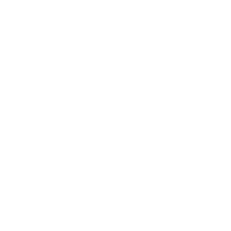

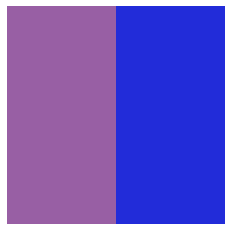

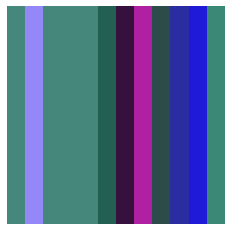

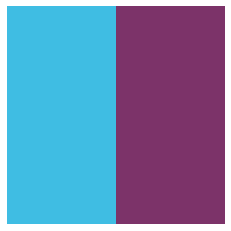

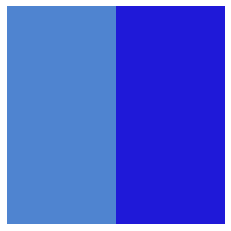

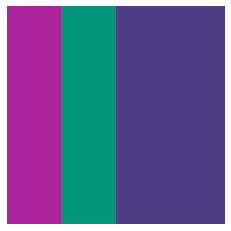

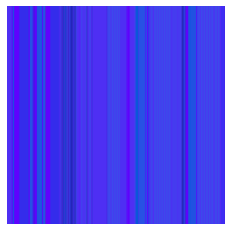

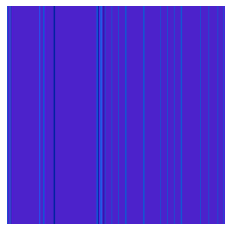

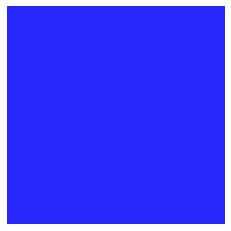

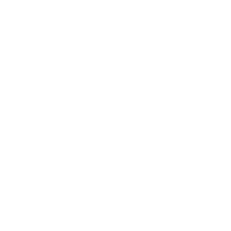

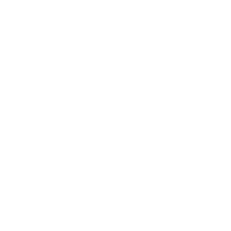

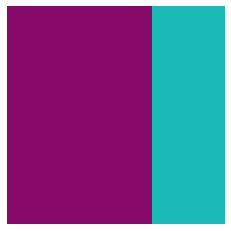

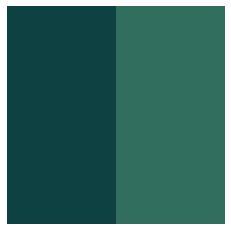

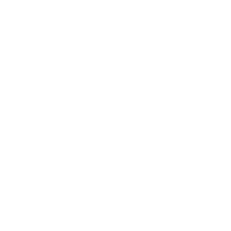

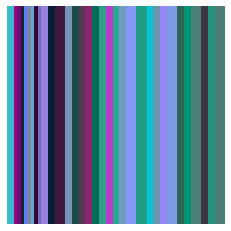

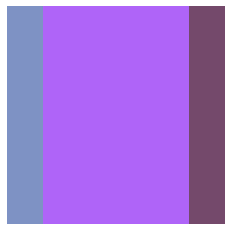

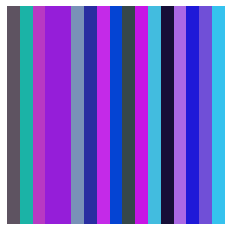

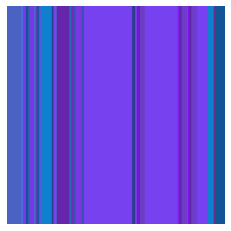

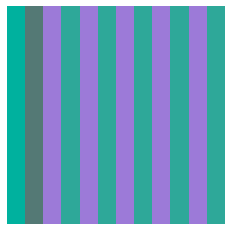

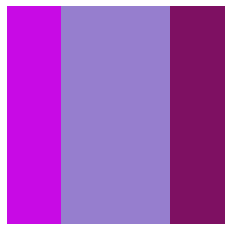

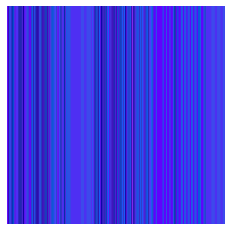

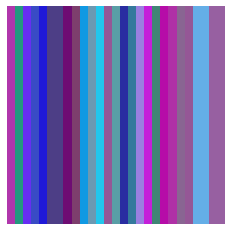

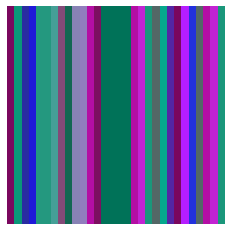

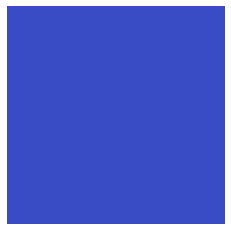

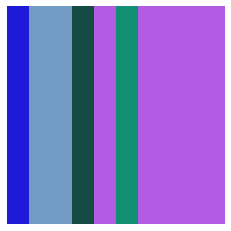

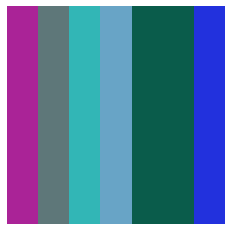

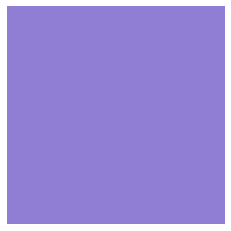

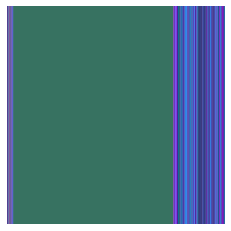

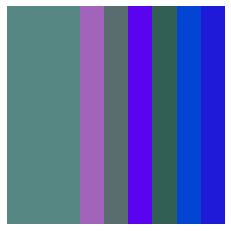

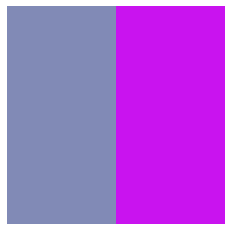

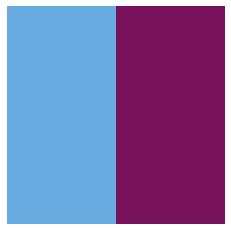

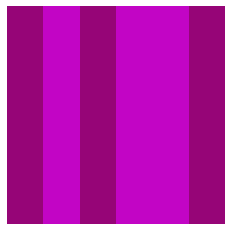

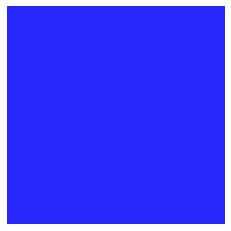

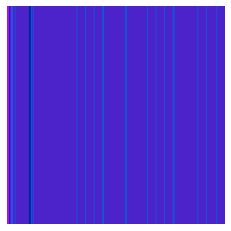

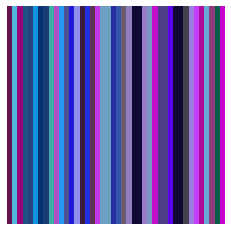

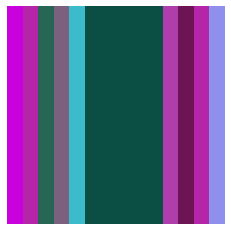

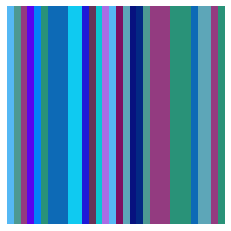

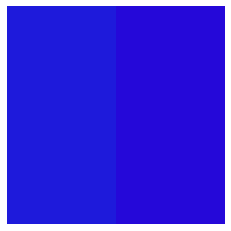

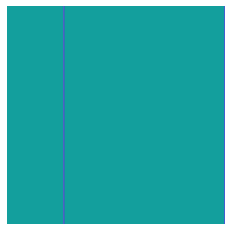

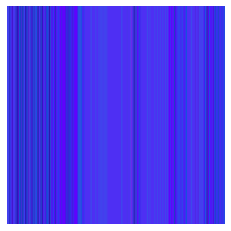

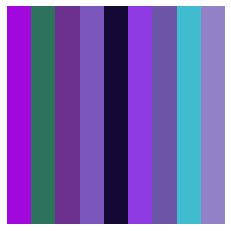

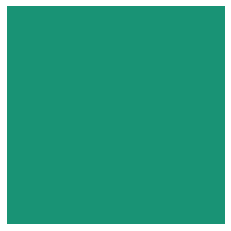

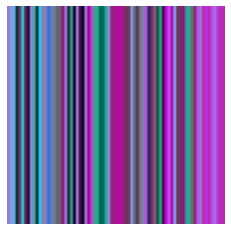

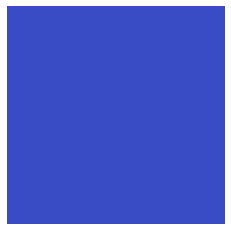

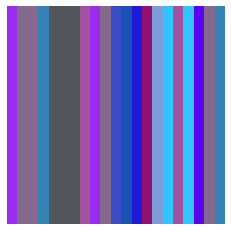

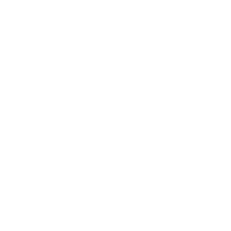

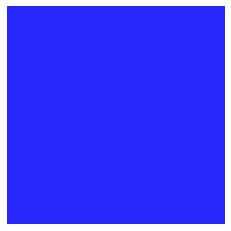

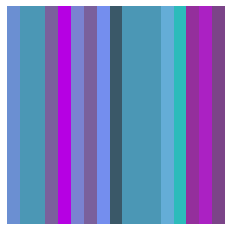

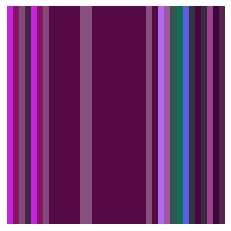

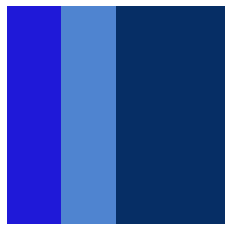

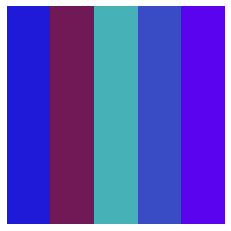

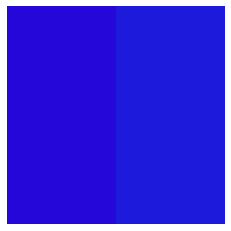

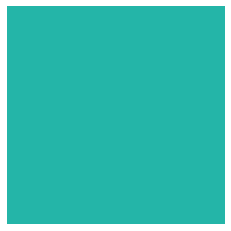

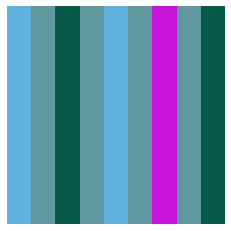

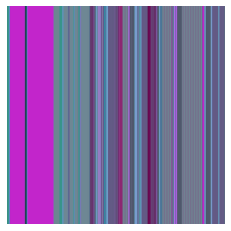

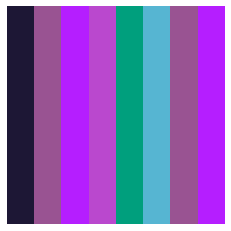

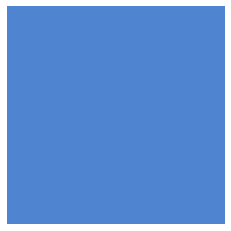

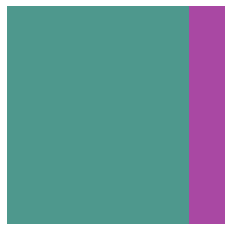

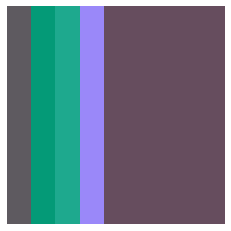

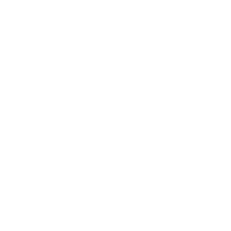

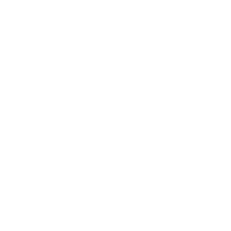

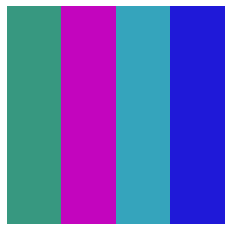

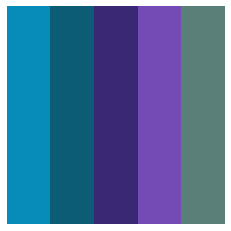

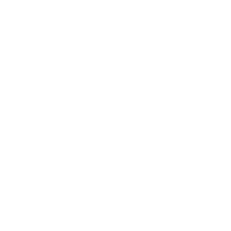

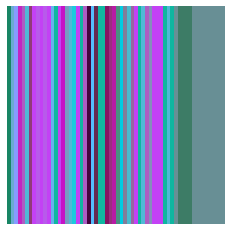

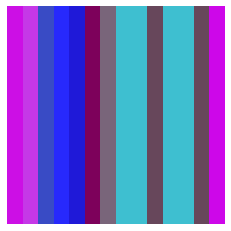

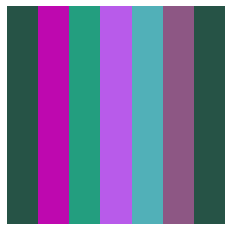

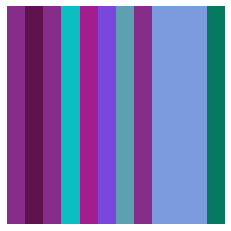

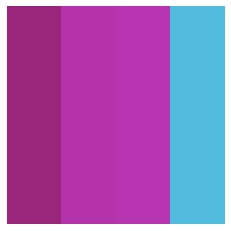

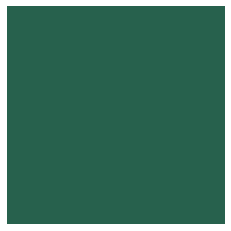

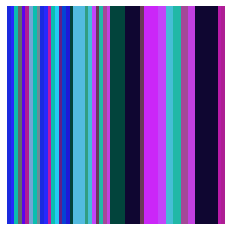

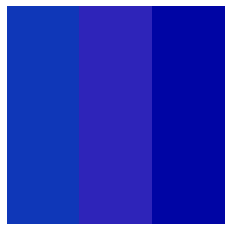

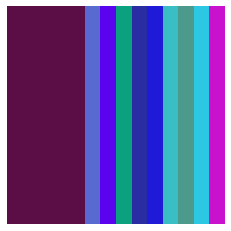

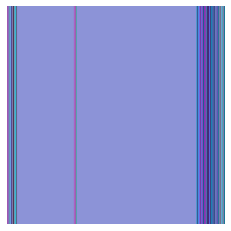

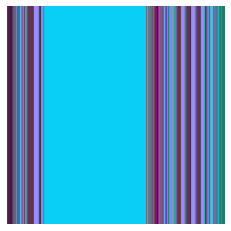

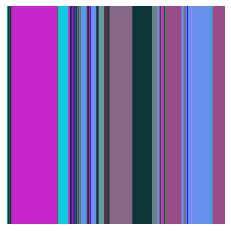

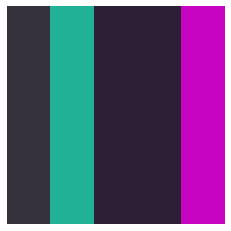

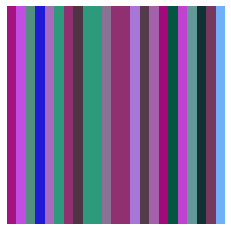

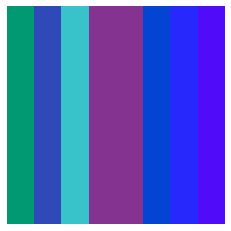

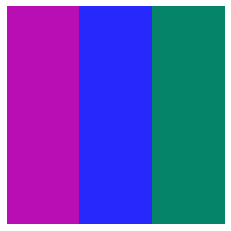

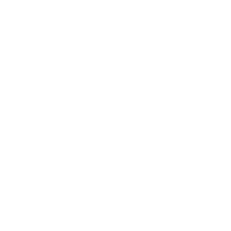

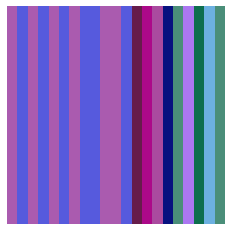

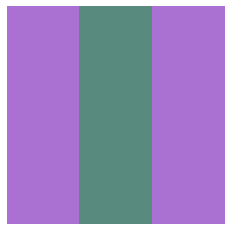

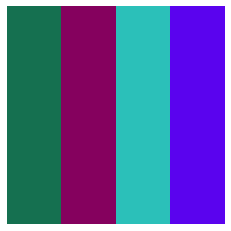

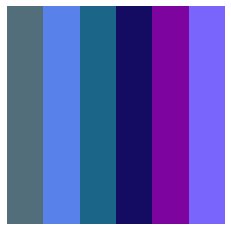

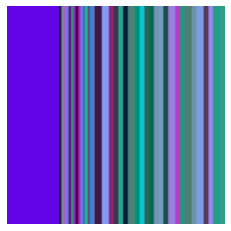

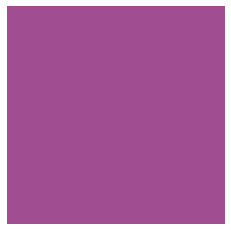

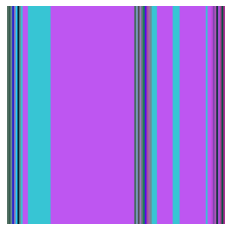

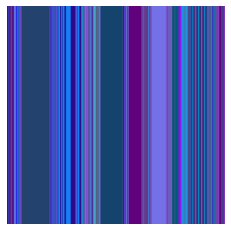

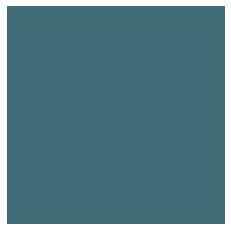

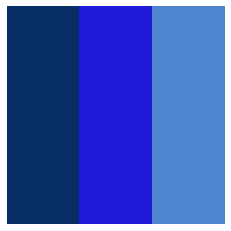

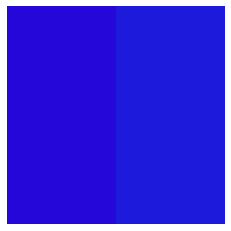

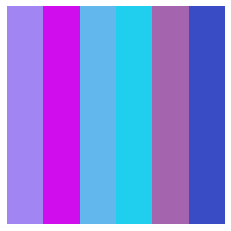

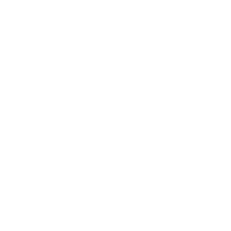

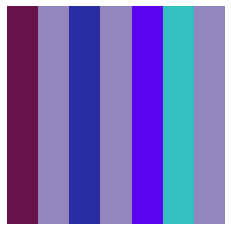

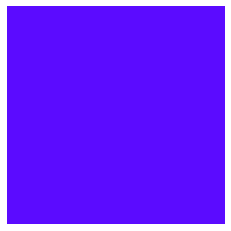

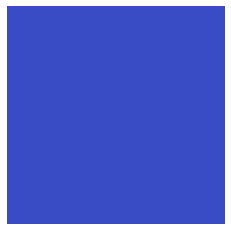

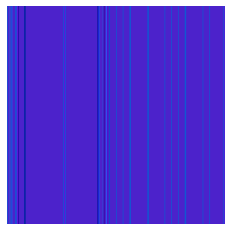

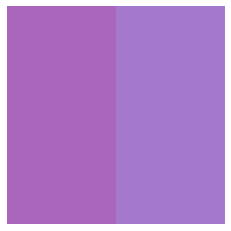

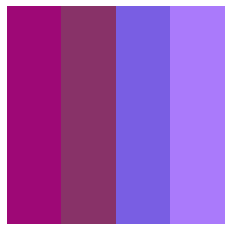

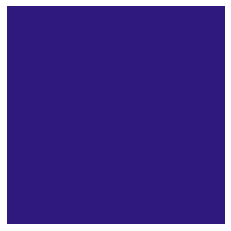

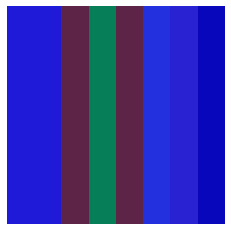

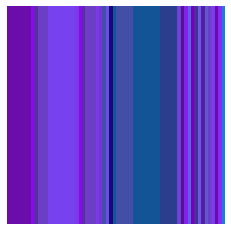

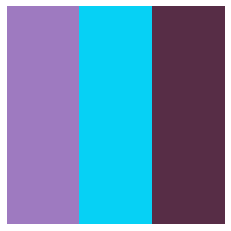

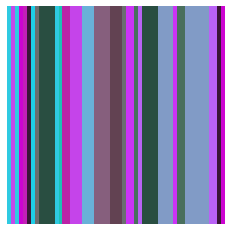

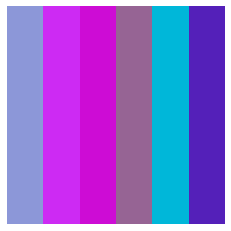

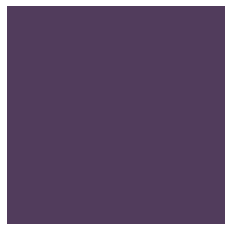

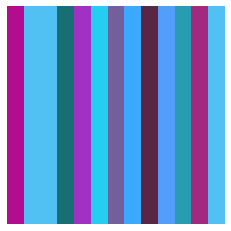

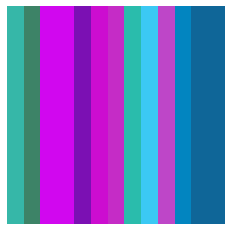

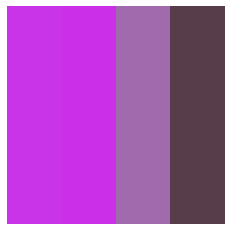

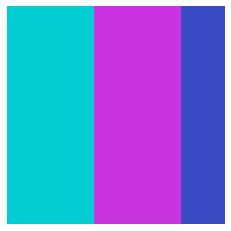

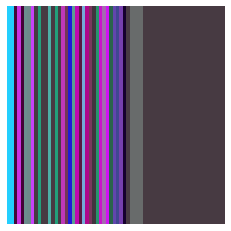

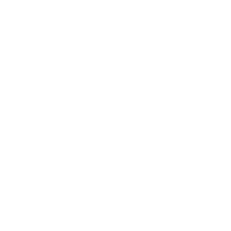

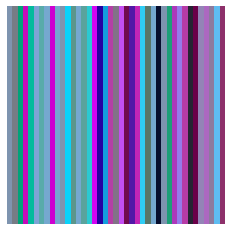

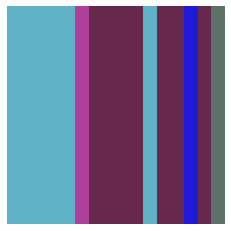

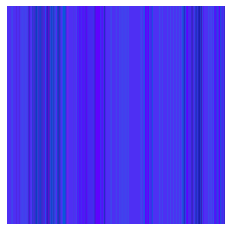

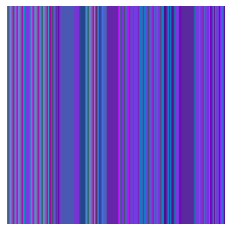

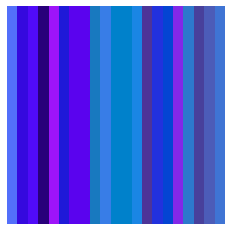

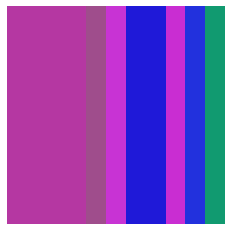

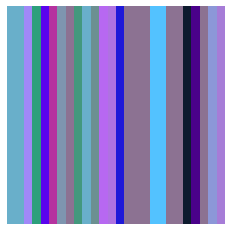

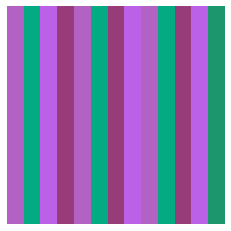

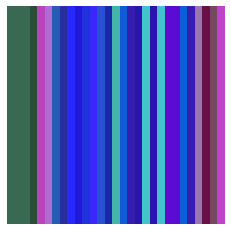

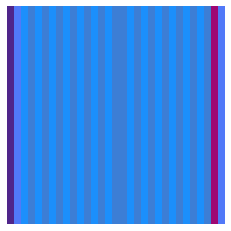

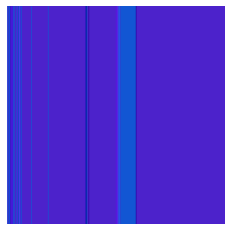

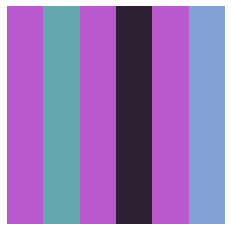

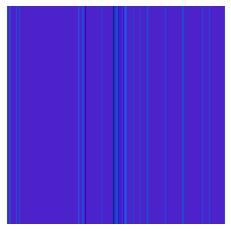

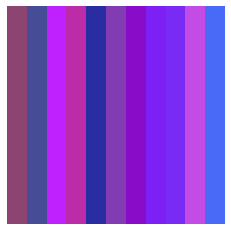

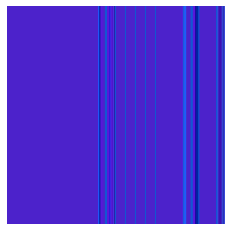

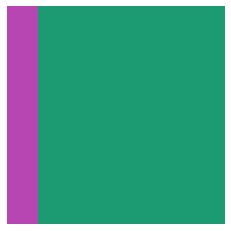

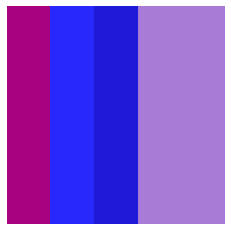

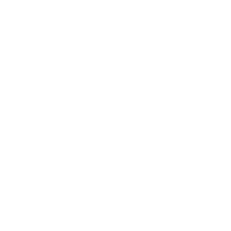

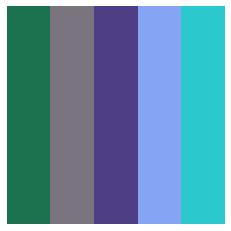

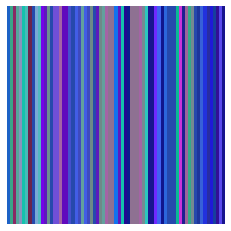

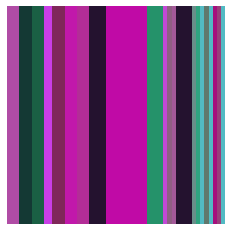

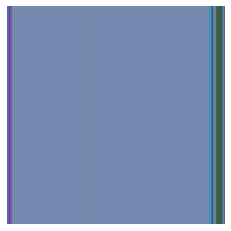

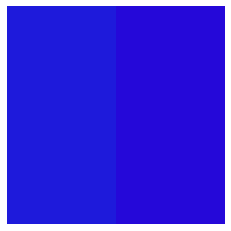

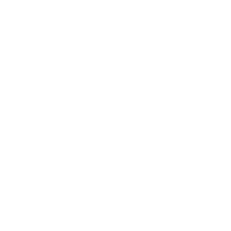

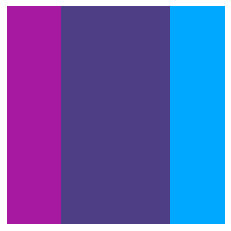

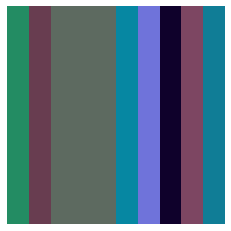

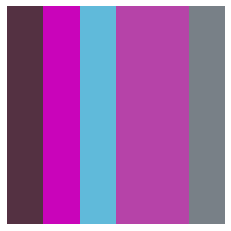

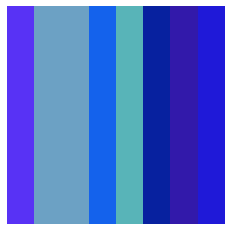

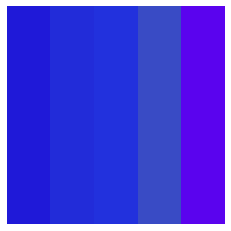

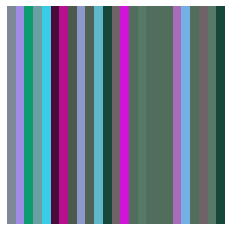

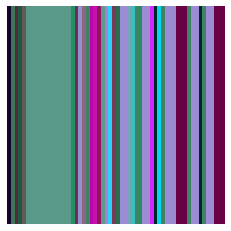

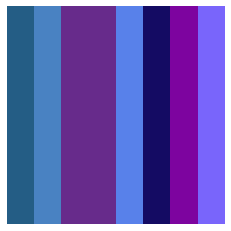

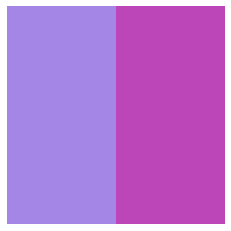

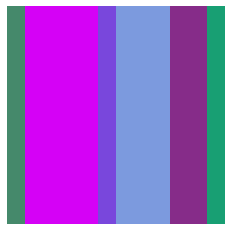

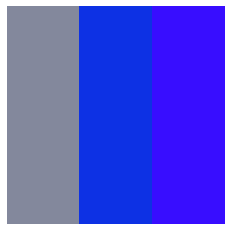

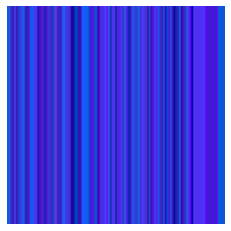

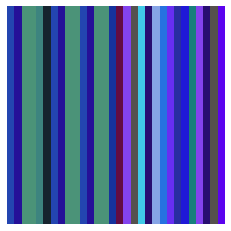

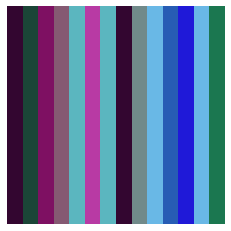

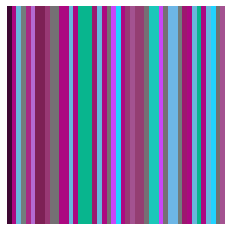

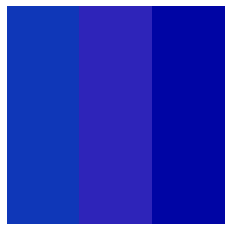

In [55]:
dirs = ['/home/ubuntu/ml/validation/Benign_Dumps','/home/ubuntu/ml/validation/Malware_Dumps','/home/ubuntu/ml/test/Benign_Dumps','/home/ubuntu/ml/test/Malware_Dumps','/home/ubuntu/ml/train/Benign_Dumps','/home/ubuntu/ml/train/Malware_Dumps']
for dir in dirs:
    files = os.listdir(dir)
    for file in files:
        with open(dir+"/"+file, 'rb') as f:
            rgbarray = []
            for line in f.readlines():
                try:
                    var = line.split()
                    obj = var[5].decode('utf-8')
                    if obj in token_color_map.keys() and var[5] not in both:
                            rgbarray.append([val for val in token_color_map[obj]])
                    #if obj not in token_color_map.keys():
                            #rgbarray.append([22, 230, 108])
                except IndexError as e:
                         continue
#             print(rgbarray)
            #plot(np.expand_dims(np.array(rgbarray,dtype=int),axis=0),'PaperImages/'+dir+'/'+file+'.png')
            new_dir = '/'.join(dir.split('/')[4:])
            plot(np.expand_dims(np.array(rgbarray,dtype=int),axis=0),'/home/ubuntu/ml/Shuffled_Reworked_Images/'+new_dir+'/'+file+'.png')
#             cvplot(rgbarray,'Remodeled_PaperImages/'+dir+'/'+file+'.png')
            f.close()
            

In [32]:
import sys
!{sys.executable} -m pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [60]:
'''
For Cv2 imwrite rgb values have to be reversed. So use 
color[::-1]
'''


import cv2
ben = [[color for i in range(200)] for color in sorted_colors[:6054]]
both = [[color for i in range(200)] for color in sorted_colors[6054:6054+2377]]
mal = [[color for i in range(200)] for color in sorted_colors[6054+2377:-1]]
cv2.imwrite('ben_new.png', np.array(ben,dtype=np.uint8))
cv2.imwrite('mal_new.png', np.array(mal,dtype=np.uint8))
cv2.imwrite('both_new.png', np.array(both,dtype=np.uint8))

True

In [34]:
import cv2
for j in range(19012):
    try:
        cv2.imwrite('token_palette/'+str(token_list[j]) +'.png', np.array([[sorted_colors[j] for i in range(200)]],dtype=np.uint8))
    except:
        print("couldn't create ",'token_palette/'+str(token_list[j])+'.png')

couldn't create  token_palette/o ..png
couldn't create  token_palette/o . .png
couldn't create  token_palette/c o m . e 4 a . r u n t i m e . c o m p o n e n t s .png
couldn't create  token_palette/c o m . e 4 a . r u n t i m e . c o m p o n e n t s . i m p l.png


IndexError: list index out of range

In [10]:
train_path = '/home/ubuntu/ml/Shuffled_Reworked_Images/train'
test_path = '/home/ubuntu/ml/Shuffled_Reworked_Images/test'
valid_path = '/home/ubuntu/ml/Shuffled_Reworked_Images/validation'
img_height = 288
img_width = 432 

In [11]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder(train_path,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
val_dataset = ImageFolder(valid_path,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_path,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
img, label = train_dataset[0]
print(img.shape,label,train_dataset.classes)

torch.Size([3, 150, 150]) 0 ['Benign_Dumps', 'Malware_Dumps']


Label : Benign_Dumps


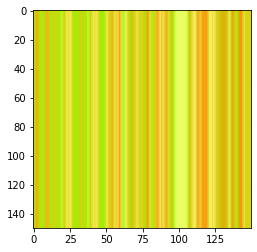

In [12]:
import matplotlib.pyplot as plt
def display_img(img,label,dataset):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))
display_img(*train_dataset[50],train_dataset)

In [13]:
from torch.utils.data.dataloader import DataLoader
batch_size=16
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
class malwareClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
#             nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
            
#             nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
            
            nn.Flatten(),
#             nn.Linear(82944,1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
            nn.Linear(360000,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history



In [17]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
model = malwareClassification()
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5508, val_loss: 2.4856, val_acc: 0.7792
Epoch [1], train_loss: 0.0881, val_loss: 1.4595, val_acc: 0.7958
Epoch [2], train_loss: 0.0921, val_loss: 1.2597, val_acc: 0.7958
Epoch [3], train_loss: 0.0408, val_loss: 1.4790, val_acc: 0.8000
Epoch [4], train_loss: 0.0444, val_loss: 1.7545, val_acc: 0.7958
Epoch [5], train_loss: 0.0430, val_loss: 2.8831, val_acc: 0.7833
Epoch [6], train_loss: 0.0366, val_loss: 2.9155, val_acc: 0.7875
Epoch [7], train_loss: 0.0376, val_loss: 3.4446, val_acc: 0.7958


KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(), 'malware_class_24feb_1st80.pth')

In [20]:
test_result = evaluate(model,test_dl)

In [22]:
def calculate_acc(model_path,dataset):
    model = malwareClassification()
    model.load_state_dict(torch.load(model_path))
    test_result = evaluate(model,dataset)
    print(test_result['val_acc'])
    return test_result

calculate_acc('malware_class_24feb_1st80.pth',test_dl)

0.7784090638160706


{'val_loss': 2.3401403427124023, 'val_acc': 0.7784090638160706}